In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [ ]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 300

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 7/80000 [00:00<19:09, 69.60it/s]


Adam:   0%|          | 79/80000 [00:00<02:57, 449.09it/s]


Adam:   0%|          | 151/80000 [00:00<02:20, 568.98it/s]


Adam:   0%|          | 224/80000 [00:00<02:06, 630.39it/s]


Adam:   0%|          | 297/80000 [00:00<01:59, 665.54it/s]


Adam:   0%|          | 364/80000 [00:00<02:00, 659.65it/s]


Adam:   1%|          | 439/80000 [00:00<01:55, 687.27it/s]


Adam:   1%|          | 514/80000 [00:00<01:52, 705.80it/s]


Adam:   1%|          | 585/80000 [00:00<02:01, 656.06it/s]


Adam:   1%|          | 657/80000 [00:01<01:57, 674.51it/s]


Adam:   1%|          | 729/80000 [00:01<01:55, 687.72it/s]


Adam:   1%|          | 799/80000 [00:01<01:58, 666.51it/s]


Adam:   1%|          | 874/80000 [00:01<01:54, 689.76it/s]


Adam:   1%|          | 948/80000 [00:01<01:52, 703.13it/s]


Adam:   1%|▏         | 1020/80000 [00:01<01:51, 705.66it/s]


Adam:   1%|▏         | 1091/80000 [00:01<01:55, 684.99it/s]


Adam:   1%|▏         | 1163/80000 [00:01<01:53, 695.11it/s]


Adam:   2%|▏         | 1237/80000 [00:01<01:51, 706.14it/s]


Adam:   2%|▏         | 1308/80000 [00:01<01:51, 706.52it/s]


Adam:   2%|▏         | 1383/80000 [00:02<01:49, 716.55it/s]


Adam:   2%|▏         | 1455/80000 [00:02<01:50, 712.58it/s]


Adam:   2%|▏         | 1527/80000 [00:02<01:53, 692.43it/s]


Adam:   2%|▏         | 1603/80000 [00:02<01:50, 710.29it/s]


Adam:   2%|▏         | 1676/80000 [00:02<01:49, 712.93it/s]


Adam:   2%|▏         | 1748/80000 [00:02<01:50, 710.87it/s]


Adam:   2%|▏         | 1822/80000 [00:02<01:48, 719.41it/s]


Adam:   2%|▏         | 1897/80000 [00:02<01:47, 725.90it/s]


Adam:   2%|▏         | 1970/80000 [00:02<01:50, 707.82it/s]


Adam:   3%|▎         | 2043/80000 [00:02<01:49, 712.91it/s]


Adam:   3%|▎         | 2117/80000 [00:03<01:48, 720.00it/s]


Adam:   3%|▎         | 2190/80000 [00:03<01:49, 711.17it/s]


Adam:   3%|▎         | 2266/80000 [00:03<01:47, 724.55it/s]


Adam:   3%|▎         | 2343/80000 [00:03<01:45, 735.44it/s]


Adam:   3%|▎         | 2417/80000 [00:03<01:45, 734.00it/s]


Adam:   3%|▎         | 2493/80000 [00:03<01:44, 740.58it/s]


Adam:   3%|▎         | 2569/80000 [00:03<01:43, 744.88it/s]


Adam:   3%|▎         | 2644/80000 [00:03<01:47, 721.77it/s]


Adam:   3%|▎         | 2718/80000 [00:03<01:46, 724.82it/s]


Adam:   3%|▎         | 2794/80000 [00:04<01:45, 734.36it/s]


Adam:   4%|▎         | 2868/80000 [00:04<02:08, 600.15it/s]


Adam:   4%|▎         | 2937/80000 [00:04<02:04, 621.06it/s]


Adam:   4%|▍         | 3012/80000 [00:04<01:57, 654.46it/s]


Adam:   4%|▍         | 3088/80000 [00:04<01:52, 681.35it/s]


Adam:   4%|▍         | 3164/80000 [00:04<01:49, 702.11it/s]


Adam:   4%|▍         | 3236/80000 [00:04<01:51, 689.47it/s]


Adam:   4%|▍         | 3312/80000 [00:04<01:48, 707.64it/s]


Adam:   4%|▍         | 3384/80000 [00:04<01:48, 707.76it/s]


Adam:   4%|▍         | 3460/80000 [00:05<01:46, 721.40it/s]


Adam:   4%|▍         | 3533/80000 [00:05<01:46, 714.90it/s]


Adam:   5%|▍         | 3608/80000 [00:05<01:45, 724.97it/s]


Adam:   5%|▍         | 3681/80000 [00:05<01:45, 720.82it/s]


Adam:   5%|▍         | 3754/80000 [00:05<01:45, 722.33it/s]


Adam:   5%|▍         | 3827/80000 [00:05<01:46, 716.53it/s]


Adam:   5%|▍         | 3903/80000 [00:05<01:44, 726.86it/s]


Adam:   5%|▍         | 3978/80000 [00:05<01:43, 731.47it/s]


Adam:   5%|▌         | 4052/80000 [00:05<01:44, 726.81it/s]


Adam:   5%|▌         | 4125/80000 [00:05<01:44, 727.38it/s]


Adam:   5%|▌         | 4201/80000 [00:06<01:42, 736.68it/s]


Adam:   5%|▌         | 4276/80000 [00:06<01:42, 739.25it/s]


Adam:   5%|▌         | 4353/80000 [00:06<01:41, 745.67it/s]


Adam:   6%|▌         | 4428/80000 [00:06<01:44, 719.97it/s]


Adam:   6%|▌         | 4502/80000 [00:06<01:44, 723.65it/s]


Adam:   6%|▌         | 4578/80000 [00:06<01:42, 733.20it/s]


Adam:   6%|▌         | 4652/80000 [00:06<01:52, 669.02it/s]


Adam:   6%|▌         | 4728/80000 [00:06<01:48, 692.90it/s]


Adam:   6%|▌         | 4799/80000 [00:06<01:49, 687.99it/s]


Adam:   6%|▌         | 4874/80000 [00:06<01:46, 704.12it/s]


Adam:   6%|▌         | 4945/80000 [00:07<01:51, 676.15it/s]


Adam:   6%|▋         | 5014/80000 [00:07<01:50, 677.96it/s]


Adam:   6%|▋         | 5088/80000 [00:07<01:47, 694.76it/s]


Adam:   6%|▋         | 5160/80000 [00:07<01:46, 700.34it/s]


Adam:   7%|▋         | 5231/80000 [00:07<01:53, 655.95it/s]


Adam:   7%|▋         | 5304/80000 [00:07<01:50, 676.36it/s]


Adam:   7%|▋         | 5377/80000 [00:07<01:47, 691.50it/s]


Adam:   7%|▋         | 5447/80000 [00:07<01:47, 691.39it/s]


Adam:   7%|▋         | 5517/80000 [00:07<01:49, 680.99it/s]


Adam:   7%|▋         | 5590/80000 [00:08<01:47, 695.14it/s]


Adam:   7%|▋         | 5663/80000 [00:08<01:45, 703.52it/s]


Adam:   7%|▋         | 5738/80000 [00:08<01:43, 714.82it/s]


Adam:   7%|▋         | 5810/80000 [00:08<01:45, 700.70it/s]


Adam:   7%|▋         | 5882/80000 [00:08<01:45, 703.61it/s]


Adam:   7%|▋         | 5956/80000 [00:08<01:43, 713.86it/s]


Adam:   8%|▊         | 6030/80000 [00:08<01:42, 720.55it/s]


Adam:   8%|▊         | 6103/80000 [00:08<01:43, 716.71it/s]


Adam:   8%|▊         | 6175/80000 [00:08<01:44, 705.66it/s]


Adam:   8%|▊         | 6246/80000 [00:08<01:45, 699.66it/s]


Adam:   8%|▊         | 6319/80000 [00:09<01:44, 708.01it/s]


Adam:   8%|▊         | 6390/80000 [00:09<01:44, 707.24it/s]


Adam:   8%|▊         | 6461/80000 [00:09<01:50, 667.94it/s]


Adam:   8%|▊         | 6531/80000 [00:09<01:48, 676.92it/s]


Adam:   8%|▊         | 6600/80000 [00:09<01:51, 659.78it/s]


Adam:   8%|▊         | 6667/80000 [00:09<02:14, 545.55it/s]


Adam:   8%|▊         | 6733/80000 [00:09<02:07, 572.48it/s]


Adam:   9%|▊         | 6806/80000 [00:09<01:59, 612.21it/s]


Adam:   9%|▊         | 6870/80000 [00:10<02:29, 488.66it/s]


Adam:   9%|▊         | 6927/80000 [00:10<02:24, 506.90it/s]


Adam:   9%|▊         | 6982/80000 [00:10<02:24, 503.79it/s]


Adam:   9%|▉         | 7055/80000 [00:10<02:09, 561.21it/s]


Adam:   9%|▉         | 7124/80000 [00:10<02:02, 595.24it/s]


Adam:   9%|▉         | 7198/80000 [00:10<01:54, 634.16it/s]


Adam:   9%|▉         | 7271/80000 [00:10<01:50, 661.13it/s]


Adam:   9%|▉         | 7345/80000 [00:10<01:46, 681.74it/s]


Adam:   9%|▉         | 7419/80000 [00:10<01:44, 696.62it/s]


Adam:   9%|▉         | 7491/80000 [00:10<01:43, 702.73it/s]


Adam:   9%|▉         | 7562/80000 [00:11<01:45, 689.79it/s]


Adam:  10%|▉         | 7632/80000 [00:11<01:50, 653.10it/s]


Adam:  10%|▉         | 7698/80000 [00:11<03:35, 335.74it/s]


Adam:  10%|▉         | 7749/80000 [00:11<03:31, 341.59it/s]


Adam:  10%|▉         | 7824/80000 [00:11<02:53, 416.74it/s]


Adam:  10%|▉         | 7898/80000 [00:11<02:29, 483.61it/s]


Adam:  10%|▉         | 7974/80000 [00:12<02:12, 545.61it/s]


Adam:  10%|█         | 8041/80000 [00:12<02:05, 574.23it/s]


Adam:  10%|█         | 8115/80000 [00:12<01:56, 615.43it/s]


Adam:  10%|█         | 8190/80000 [00:12<01:50, 650.77it/s]


Adam:  10%|█         | 8260/80000 [00:12<01:48, 658.40it/s]


Adam:  10%|█         | 8335/80000 [00:12<01:45, 682.18it/s]


Adam:  11%|█         | 8410/80000 [00:12<01:42, 701.27it/s]


Adam:  11%|█         | 8485/80000 [00:12<01:39, 715.39it/s]


Adam:  11%|█         | 8560/80000 [00:12<01:38, 724.92it/s]


Adam:  11%|█         | 8635/80000 [00:12<01:37, 729.98it/s]


Adam:  11%|█         | 8709/80000 [00:13<01:38, 726.68it/s]


Adam:  11%|█         | 8783/80000 [00:13<01:39, 719.00it/s]


Adam:  11%|█         | 8856/80000 [00:13<01:40, 705.93it/s]


Adam:  11%|█         | 8930/80000 [00:13<01:39, 714.61it/s]


Adam:  11%|█▏        | 9002/80000 [00:13<01:45, 670.92it/s]


Adam:  11%|█▏        | 9071/80000 [00:13<01:44, 676.12it/s]


Adam:  11%|█▏        | 9140/80000 [00:13<01:44, 679.36it/s]


Adam:  12%|█▏        | 9212/80000 [00:13<01:42, 688.49it/s]


Adam:  12%|█▏        | 9282/80000 [00:13<01:44, 678.08it/s]


Adam:  12%|█▏        | 9358/80000 [00:14<01:40, 699.45it/s]


Adam:  12%|█▏        | 9431/80000 [00:14<01:39, 706.33it/s]


Adam:  12%|█▏        | 9507/80000 [00:14<01:37, 721.67it/s]


Adam:  12%|█▏        | 9580/80000 [00:14<01:39, 707.80it/s]


Adam:  12%|█▏        | 9656/80000 [00:14<01:37, 721.38it/s]


Adam:  12%|█▏        | 9730/80000 [00:14<01:36, 725.96it/s]


Adam:  12%|█▏        | 9805/80000 [00:14<01:35, 731.36it/s]


Adam:  12%|█▏        | 9879/80000 [00:14<01:35, 733.73it/s]


Adam:  12%|█▏        | 9953/80000 [00:14<01:41, 687.58it/s]


Adam:  13%|█▎        | 10023/80000 [00:14<01:46, 659.47it/s]


Adam:  13%|█▎        | 10090/80000 [00:15<01:48, 643.03it/s]


Adam:  13%|█▎        | 10160/80000 [00:15<01:46, 658.28it/s]


Adam:  13%|█▎        | 10230/80000 [00:15<01:44, 667.60it/s]


Adam:  13%|█▎        | 10301/80000 [00:15<01:42, 679.01it/s]


Adam:  13%|█▎        | 10373/80000 [00:15<01:41, 688.66it/s]


Adam:  13%|█▎        | 10445/80000 [00:15<01:39, 697.60it/s]


Adam:  13%|█▎        | 10521/80000 [00:15<01:37, 714.84it/s]


Adam:  13%|█▎        | 10594/80000 [00:15<01:36, 717.36it/s]


Adam:  13%|█▎        | 10666/80000 [00:15<01:37, 714.68it/s]


Adam:  13%|█▎        | 10738/80000 [00:16<01:38, 701.26it/s]


Adam:  14%|█▎        | 10809/80000 [00:16<01:38, 701.39it/s]


Adam:  14%|█▎        | 10880/80000 [00:16<01:38, 701.96it/s]


Adam:  14%|█▎        | 10952/80000 [00:16<01:37, 705.39it/s]


Adam:  14%|█▍        | 11023/80000 [00:16<01:38, 702.51it/s]


Adam:  14%|█▍        | 11094/80000 [00:16<01:54, 600.36it/s]


Adam:  14%|█▍        | 11157/80000 [00:16<01:57, 587.01it/s]


Adam:  14%|█▍        | 11229/80000 [00:16<01:50, 621.40it/s]


Adam:  14%|█▍        | 11300/80000 [00:16<01:46, 644.95it/s]


Adam:  14%|█▍        | 11371/80000 [00:17<01:43, 662.49it/s]


Adam:  14%|█▍        | 11439/80000 [00:17<01:45, 650.65it/s]


Adam:  14%|█▍        | 11509/80000 [00:17<01:43, 662.73it/s]


Adam:  14%|█▍        | 11576/80000 [00:17<01:45, 646.54it/s]


Adam:  15%|█▍        | 11646/80000 [00:17<01:43, 660.45it/s]


Adam:  15%|█▍        | 11716/80000 [00:17<01:41, 670.27it/s]


Adam:  15%|█▍        | 11787/80000 [00:17<01:40, 678.63it/s]


Adam:  15%|█▍        | 11858/80000 [00:17<01:39, 684.91it/s]


Adam:  15%|█▍        | 11929/80000 [00:17<01:38, 692.30it/s]


Adam:  15%|█▍        | 11999/80000 [00:17<01:44, 652.53it/s]


Adam:  15%|█▌        | 12071/80000 [00:18<01:41, 669.68it/s]


Adam:  15%|█▌        | 12142/80000 [00:18<01:39, 680.58it/s]


Adam:  15%|█▌        | 12211/80000 [00:18<01:42, 663.98it/s]


Adam:  15%|█▌        | 12280/80000 [00:18<01:41, 669.78it/s]


Adam:  15%|█▌        | 12348/80000 [00:18<01:42, 659.81it/s]


Adam:  16%|█▌        | 12420/80000 [00:18<01:40, 674.65it/s]


Adam:  16%|█▌        | 12491/80000 [00:18<01:38, 683.14it/s]


Adam:  16%|█▌        | 12560/80000 [00:18<01:39, 677.40it/s]


Adam:  16%|█▌        | 12628/80000 [00:18<01:45, 640.65it/s]


Adam:  16%|█▌        | 12699/80000 [00:18<01:42, 658.58it/s]


Adam:  16%|█▌        | 12769/80000 [00:19<01:40, 666.61it/s]


Adam:  16%|█▌        | 12836/80000 [00:19<01:43, 648.14it/s]


Adam:  16%|█▌        | 12905/80000 [00:19<01:41, 659.11it/s]


Adam:  16%|█▌        | 12972/80000 [00:19<01:47, 625.62it/s]


Adam:  16%|█▋        | 13041/80000 [00:19<01:44, 643.69it/s]


Adam:  16%|█▋        | 13113/80000 [00:19<01:40, 663.53it/s]


Adam:  16%|█▋        | 13184/80000 [00:19<01:38, 676.29it/s]


Adam:  17%|█▋        | 13252/80000 [00:19<01:41, 656.35it/s]


Adam:  17%|█▋        | 13323/80000 [00:19<01:39, 671.02it/s]


Adam:  17%|█▋        | 13391/80000 [00:20<01:42, 650.22it/s]


Adam:  17%|█▋        | 13462/80000 [00:20<01:39, 665.78it/s]


Adam:  17%|█▋        | 13529/80000 [00:20<01:39, 665.41it/s]


Adam:  17%|█▋        | 13599/80000 [00:20<01:38, 674.83it/s]


Adam:  17%|█▋        | 13670/80000 [00:20<01:36, 684.68it/s]


Adam:  17%|█▋        | 13739/80000 [00:20<01:37, 676.89it/s]


Adam:  17%|█▋        | 13810/80000 [00:20<01:36, 685.67it/s]


Adam:  17%|█▋        | 13879/80000 [00:20<01:41, 651.17it/s]


Adam:  17%|█▋        | 13945/80000 [00:20<01:42, 644.21it/s]


Adam:  18%|█▊        | 14013/80000 [00:20<01:40, 654.38it/s]


Adam:  18%|█▊        | 14083/80000 [00:21<01:38, 666.24it/s]


Adam:  18%|█▊        | 14150/80000 [00:21<01:39, 660.07it/s]


Adam:  18%|█▊        | 14217/80000 [00:21<01:42, 639.22it/s]


Adam:  18%|█▊        | 14287/80000 [00:21<01:40, 656.62it/s]


Adam:  18%|█▊        | 14357/80000 [00:21<01:38, 669.14it/s]


Adam:  18%|█▊        | 14429/80000 [00:21<01:36, 681.33it/s]


Adam:  18%|█▊        | 14500/80000 [00:21<01:35, 687.73it/s]


Adam:  18%|█▊        | 14569/80000 [00:21<01:37, 669.55it/s]


Adam:  18%|█▊        | 14639/80000 [00:21<01:36, 677.11it/s]


Adam:  18%|█▊        | 14709/80000 [00:22<01:35, 680.52it/s]


Adam:  18%|█▊        | 14779/80000 [00:22<01:35, 685.44it/s]


Adam:  19%|█▊        | 14850/80000 [00:22<01:34, 692.42it/s]


Adam:  19%|█▊        | 14921/80000 [00:22<01:33, 695.45it/s]


Adam:  19%|█▊        | 14993/80000 [00:22<01:32, 701.46it/s]


Adam:  19%|█▉        | 15064/80000 [00:22<01:35, 679.32it/s]


Adam:  19%|█▉        | 15133/80000 [00:22<01:35, 678.84it/s]


Adam:  19%|█▉        | 15202/80000 [00:22<01:42, 632.20it/s]


Adam:  19%|█▉        | 15271/80000 [00:22<01:40, 643.42it/s]


Adam:  19%|█▉        | 15336/80000 [00:22<01:49, 591.54it/s]


Adam:  19%|█▉        | 15407/80000 [00:23<01:43, 622.30it/s]


Adam:  19%|█▉        | 15471/80000 [00:23<01:44, 618.05it/s]


Adam:  19%|█▉        | 15542/80000 [00:23<01:40, 642.79it/s]


Adam:  20%|█▉        | 15607/80000 [00:23<02:02, 524.69it/s]


Adam:  20%|█▉        | 15664/80000 [00:23<02:26, 438.95it/s]


Adam:  20%|█▉        | 15713/80000 [00:23<02:29, 429.72it/s]


Adam:  20%|█▉        | 15760/80000 [00:23<02:40, 399.95it/s]


Adam:  20%|█▉        | 15826/80000 [00:24<02:19, 459.48it/s]


Adam:  20%|█▉        | 15896/80000 [00:24<02:03, 517.88it/s]


Adam:  20%|█▉        | 15967/80000 [00:24<01:52, 566.82it/s]


Adam:  20%|██        | 16031/80000 [00:24<01:49, 585.62it/s]


Adam:  20%|██        | 16095/80000 [00:24<01:46, 600.21it/s]


Adam:  20%|██        | 16162/80000 [00:24<01:43, 619.36it/s]


Adam:  20%|██        | 16231/80000 [00:24<01:40, 637.17it/s]


Adam:  20%|██        | 16297/80000 [00:24<01:40, 636.79it/s]


Adam:  20%|██        | 16362/80000 [00:24<02:02, 521.28it/s]


Adam:  21%|██        | 16421/80000 [00:25<01:58, 538.62it/s]


Adam:  21%|██        | 16487/80000 [00:25<01:51, 570.69it/s]


Adam:  21%|██        | 16558/80000 [00:25<01:44, 606.88it/s]


Adam:  21%|██        | 16625/80000 [00:25<01:41, 622.47it/s]


Adam:  21%|██        | 16695/80000 [00:25<01:38, 644.00it/s]


Adam:  21%|██        | 16766/80000 [00:25<01:35, 660.61it/s]


Adam:  21%|██        | 16837/80000 [00:25<01:33, 673.11it/s]


Adam:  21%|██        | 16905/80000 [00:25<01:39, 635.18it/s]


Adam:  21%|██        | 16970/80000 [00:26<02:23, 437.97it/s]


Adam:  21%|██▏       | 17023/80000 [00:26<02:53, 363.99it/s]


Adam:  21%|██▏       | 17067/80000 [00:26<03:07, 335.05it/s]


Adam:  21%|██▏       | 17109/80000 [00:26<02:58, 351.77it/s]


Adam:  21%|██▏       | 17170/80000 [00:26<02:33, 408.13it/s]


Adam:  22%|██▏       | 17240/80000 [00:26<02:11, 477.50it/s]


Adam:  22%|██▏       | 17307/80000 [00:26<01:59, 525.46it/s]


Adam:  22%|██▏       | 17377/80000 [00:26<01:49, 571.20it/s]


Adam:  22%|██▏       | 17442/80000 [00:26<01:45, 592.32it/s]


Adam:  22%|██▏       | 17504/80000 [00:27<02:01, 513.52it/s]


Adam:  22%|██▏       | 17560/80000 [00:27<02:16, 458.49it/s]


Adam:  22%|██▏       | 17610/80000 [00:27<02:19, 446.83it/s]


Adam:  22%|██▏       | 17675/80000 [00:27<02:05, 496.32it/s]


Adam:  22%|██▏       | 17739/80000 [00:27<01:56, 533.19it/s]


Adam:  22%|██▏       | 17795/80000 [00:27<01:56, 533.55it/s]


Adam:  22%|██▏       | 17850/80000 [00:27<01:55, 537.53it/s]


Adam:  22%|██▏       | 17911/80000 [00:27<01:51, 556.05it/s]


Adam:  22%|██▏       | 17973/80000 [00:28<01:48, 572.39it/s]


Adam:  23%|██▎       | 18038/80000 [00:28<01:44, 594.72it/s]


Adam:  23%|██▎       | 18103/80000 [00:28<01:41, 609.11it/s]


Adam:  23%|██▎       | 18165/80000 [00:28<01:44, 590.02it/s]


Adam:  23%|██▎       | 18225/80000 [00:28<01:44, 591.66it/s]


Adam:  23%|██▎       | 18285/80000 [00:28<01:45, 585.67it/s]


Adam:  23%|██▎       | 18349/80000 [00:28<01:42, 601.47it/s]


Adam:  23%|██▎       | 18410/80000 [00:28<01:43, 595.77it/s]


Adam:  23%|██▎       | 18472/80000 [00:28<01:42, 599.88it/s]


Adam:  23%|██▎       | 18533/80000 [00:28<01:44, 587.90it/s]


Adam:  23%|██▎       | 18592/80000 [00:29<01:44, 587.36it/s]


Adam:  23%|██▎       | 18656/80000 [00:29<01:42, 600.78it/s]


Adam:  23%|██▎       | 18717/80000 [00:29<01:41, 602.96it/s]


Adam:  23%|██▎       | 18784/80000 [00:29<01:38, 621.12it/s]


Adam:  24%|██▎       | 18847/80000 [00:29<01:39, 612.49it/s]


Adam:  24%|██▎       | 18909/80000 [00:29<01:44, 584.12it/s]


Adam:  24%|██▎       | 18973/80000 [00:29<01:41, 599.08it/s]


Adam:  24%|██▍       | 19034/80000 [00:29<01:44, 582.29it/s]


Adam:  24%|██▍       | 19101/80000 [00:29<01:40, 604.55it/s]


Adam:  24%|██▍       | 19164/80000 [00:30<01:39, 610.47it/s]


Adam:  24%|██▍       | 19229/80000 [00:30<01:37, 620.88it/s]


Adam:  24%|██▍       | 19292/80000 [00:30<01:43, 587.90it/s]


Adam:  24%|██▍       | 19354/80000 [00:30<01:41, 595.02it/s]


Adam:  24%|██▍       | 19419/80000 [00:30<01:39, 608.44it/s]


Adam:  24%|██▍       | 19481/80000 [00:30<01:42, 589.94it/s]


Adam:  24%|██▍       | 19547/80000 [00:30<01:39, 609.60it/s]


Adam:  25%|██▍       | 19611/80000 [00:30<01:37, 616.83it/s]


Adam:  25%|██▍       | 19673/80000 [00:30<01:39, 605.28it/s]


Adam:  25%|██▍       | 19738/80000 [00:30<01:37, 616.09it/s]


Adam:  25%|██▍       | 19800/80000 [00:31<01:39, 605.88it/s]


Adam:  25%|██▍       | 19861/80000 [00:31<01:40, 600.12it/s]


Adam:  25%|██▍       | 19922/80000 [00:31<01:39, 602.82it/s]


Adam:  25%|██▍       | 19984/80000 [00:31<01:39, 606.22it/s]


Adam:  25%|██▌       | 20050/80000 [00:31<01:36, 619.44it/s]


Adam:  25%|██▌       | 20113/80000 [00:31<01:36, 621.40it/s]


Adam:  25%|██▌       | 20176/80000 [00:31<01:36, 622.64it/s]


Adam:  25%|██▌       | 20239/80000 [00:31<01:38, 603.67it/s]


Adam:  25%|██▌       | 20304/80000 [00:31<01:36, 616.61it/s]


Adam:  25%|██▌       | 20366/80000 [00:32<01:38, 603.13it/s]


Adam:  26%|██▌       | 20427/80000 [00:32<01:38, 603.97it/s]


Adam:  26%|██▌       | 20488/80000 [00:32<01:38, 603.98it/s]


Adam:  26%|██▌       | 20549/80000 [00:32<01:42, 578.73it/s]


Adam:  26%|██▌       | 20610/80000 [00:32<01:41, 584.57it/s]


Adam:  26%|██▌       | 20669/80000 [00:32<01:42, 577.33it/s]


Adam:  26%|██▌       | 20727/80000 [00:32<01:45, 560.91it/s]


Adam:  26%|██▌       | 20786/80000 [00:32<01:44, 567.25it/s]


Adam:  26%|██▌       | 20848/80000 [00:32<01:41, 582.12it/s]


Adam:  26%|██▌       | 20915/80000 [00:32<01:37, 605.81it/s]


Adam:  26%|██▌       | 20977/80000 [00:33<01:36, 608.92it/s]


Adam:  26%|██▋       | 21044/80000 [00:33<01:34, 624.44it/s]


Adam:  26%|██▋       | 21110/80000 [00:33<01:32, 634.25it/s]


Adam:  26%|██▋       | 21174/80000 [00:33<01:36, 611.14it/s]


Adam:  27%|██▋       | 21240/80000 [00:33<01:34, 623.19it/s]


Adam:  27%|██▋       | 21303/80000 [00:33<01:35, 613.46it/s]


Adam:  27%|██▋       | 21368/80000 [00:33<01:33, 623.91it/s]


Adam:  27%|██▋       | 21431/80000 [00:33<01:34, 618.85it/s]


Adam:  27%|██▋       | 21496/80000 [00:33<01:33, 627.06it/s]


Adam:  27%|██▋       | 21559/80000 [00:33<01:35, 611.93it/s]


Adam:  27%|██▋       | 21621/80000 [00:34<01:36, 602.70it/s]


Adam:  27%|██▋       | 21682/80000 [00:34<01:40, 580.07it/s]


Adam:  27%|██▋       | 21741/80000 [00:34<01:40, 581.11it/s]


Adam:  27%|██▋       | 21803/80000 [00:34<01:39, 587.05it/s]


Adam:  27%|██▋       | 21862/80000 [00:34<01:48, 535.31it/s]


Adam:  27%|██▋       | 21917/80000 [00:34<01:54, 506.55it/s]


Adam:  27%|██▋       | 21982/80000 [00:34<01:46, 543.64it/s]


Adam:  28%|██▊       | 22046/80000 [00:34<01:42, 568.10it/s]


Adam:  28%|██▊       | 22107/80000 [00:34<01:40, 578.14it/s]


Adam:  28%|██▊       | 22166/80000 [00:35<01:43, 558.06it/s]


Adam:  28%|██▊       | 22231/80000 [00:35<01:38, 583.82it/s]


Adam:  28%|██▊       | 22296/80000 [00:35<01:35, 601.40it/s]


Adam:  28%|██▊       | 22361/80000 [00:35<01:33, 614.59it/s]


Adam:  28%|██▊       | 22427/80000 [00:35<01:31, 626.67it/s]


Adam:  28%|██▊       | 22492/80000 [00:35<01:30, 633.48it/s]


Adam:  28%|██▊       | 22556/80000 [00:35<01:33, 616.10it/s]


Adam:  28%|██▊       | 22620/80000 [00:35<01:32, 620.36it/s]


Adam:  28%|██▊       | 22683/80000 [00:35<01:32, 618.39it/s]


Adam:  28%|██▊       | 22745/80000 [00:36<01:34, 608.49it/s]


Adam:  29%|██▊       | 22811/80000 [00:36<01:31, 622.17it/s]


Adam:  29%|██▊       | 22874/80000 [00:36<01:33, 609.28it/s]


Adam:  29%|██▊       | 22936/80000 [00:36<01:38, 578.20it/s]


Adam:  29%|██▉       | 23002/80000 [00:36<01:35, 599.14it/s]


Adam:  29%|██▉       | 23063/80000 [00:36<01:36, 592.14it/s]


Adam:  29%|██▉       | 23123/80000 [00:36<01:35, 592.56it/s]


Adam:  29%|██▉       | 23185/80000 [00:36<01:34, 600.25it/s]


Adam:  29%|██▉       | 23246/80000 [00:36<01:43, 546.05it/s]


Adam:  29%|██▉       | 23307/80000 [00:36<01:40, 561.58it/s]


Adam:  29%|██▉       | 23364/80000 [00:37<01:41, 557.75it/s]


Adam:  29%|██▉       | 23421/80000 [00:37<01:42, 549.94it/s]


Adam:  29%|██▉       | 23485/80000 [00:37<01:38, 570.94it/s]


Adam:  29%|██▉       | 23548/80000 [00:37<01:36, 587.62it/s]


Adam:  30%|██▉       | 23608/80000 [00:37<01:36, 586.07it/s]


Adam:  30%|██▉       | 23668/80000 [00:37<01:35, 589.30it/s]


Adam:  30%|██▉       | 23728/80000 [00:37<01:36, 585.77it/s]


Adam:  30%|██▉       | 23787/80000 [00:37<01:38, 569.99it/s]


Adam:  30%|██▉       | 23849/80000 [00:37<01:36, 583.02it/s]


Adam:  30%|██▉       | 23914/80000 [00:38<01:33, 601.80it/s]


Adam:  30%|██▉       | 23978/80000 [00:38<01:31, 611.89it/s]


Adam:  30%|███       | 24043/80000 [00:38<01:29, 621.82it/s]


Adam:  30%|███       | 24107/80000 [00:38<01:29, 625.82it/s]


Adam:  30%|███       | 24170/80000 [00:38<01:36, 581.55it/s]


Adam:  30%|███       | 24229/80000 [00:38<01:36, 577.55it/s]


Adam:  30%|███       | 24294/80000 [00:38<01:33, 598.04it/s]


Adam:  30%|███       | 24360/80000 [00:38<01:30, 615.78it/s]


Adam:  31%|███       | 24422/80000 [00:38<01:32, 603.81it/s]


Adam:  31%|███       | 24483/80000 [00:38<01:39, 559.63it/s]


Adam:  31%|███       | 24549/80000 [00:39<01:34, 586.07it/s]


Adam:  31%|███       | 24611/80000 [00:39<01:33, 594.75it/s]


Adam:  31%|███       | 24672/80000 [00:39<01:35, 578.32it/s]


Adam:  31%|███       | 24739/80000 [00:39<01:31, 604.31it/s]


Adam:  31%|███       | 24805/80000 [00:39<01:29, 619.18it/s]


Adam:  31%|███       | 24869/80000 [00:39<01:28, 622.97it/s]


Adam:  31%|███       | 24935/80000 [00:39<01:26, 633.13it/s]


Adam:  31%|███▏      | 25001/80000 [00:39<01:25, 640.00it/s]


Adam:  31%|███▏      | 25066/80000 [00:39<01:27, 626.88it/s]


Adam:  31%|███▏      | 25129/80000 [00:40<01:32, 591.38it/s]


Adam:  31%|███▏      | 25189/80000 [00:40<01:33, 583.29it/s]


Adam:  32%|███▏      | 25254/80000 [00:40<01:30, 601.64it/s]


Adam:  32%|███▏      | 25318/80000 [00:40<01:29, 612.65it/s]


Adam:  32%|███▏      | 25384/80000 [00:40<01:27, 624.34it/s]


Adam:  32%|███▏      | 25450/80000 [00:40<01:26, 633.29it/s]


Adam:  32%|███▏      | 25514/80000 [00:40<01:26, 630.06it/s]


Adam:  32%|███▏      | 25580/80000 [00:40<01:25, 633.34it/s]


Adam:  32%|███▏      | 25644/80000 [00:40<01:29, 607.28it/s]


Adam:  32%|███▏      | 25705/80000 [00:40<01:36, 561.38it/s]


Adam:  32%|███▏      | 25765/80000 [00:41<01:34, 571.65it/s]


Adam:  32%|███▏      | 25830/80000 [00:41<01:31, 592.76it/s]


Adam:  32%|███▏      | 25890/80000 [00:41<01:33, 581.73it/s]


Adam:  32%|███▏      | 25949/80000 [00:41<01:37, 552.31it/s]


Adam:  33%|███▎      | 26013/80000 [00:41<01:33, 575.27it/s]


Adam:  33%|███▎      | 26079/80000 [00:41<01:30, 598.80it/s]


Adam:  33%|███▎      | 26142/80000 [00:41<01:28, 606.74it/s]


Adam:  33%|███▎      | 26207/80000 [00:41<01:26, 618.78it/s]


Adam:  33%|███▎      | 26270/80000 [00:41<01:33, 576.33it/s]


Adam:  33%|███▎      | 26333/80000 [00:42<01:31, 589.52it/s]


Adam:  33%|███▎      | 26393/80000 [00:42<01:36, 557.14it/s]


Adam:  33%|███▎      | 26455/80000 [00:42<01:33, 572.43it/s]


Adam:  33%|███▎      | 26522/80000 [00:42<01:29, 598.10it/s]


Adam:  33%|███▎      | 26584/80000 [00:42<01:28, 602.78it/s]


Adam:  33%|███▎      | 26645/80000 [00:42<01:31, 586.14it/s]


Adam:  33%|███▎      | 26704/80000 [00:42<01:30, 586.93it/s]


Adam:  33%|███▎      | 26766/80000 [00:42<01:29, 595.50it/s]


Adam:  34%|███▎      | 26832/80000 [00:42<01:26, 612.79it/s]


Adam:  34%|███▎      | 26894/80000 [00:42<01:31, 582.04it/s]


Adam:  34%|███▎      | 26953/80000 [00:43<01:31, 582.69it/s]


Adam:  34%|███▍      | 27012/80000 [00:43<01:31, 576.47it/s]


Adam:  34%|███▍      | 27070/80000 [00:43<01:32, 572.28it/s]


Adam:  34%|███▍      | 27130/80000 [00:43<01:31, 578.95it/s]


Adam:  34%|███▍      | 27194/80000 [00:43<01:28, 595.10it/s]


Adam:  34%|███▍      | 27256/80000 [00:43<01:27, 600.92it/s]


Adam:  34%|███▍      | 27317/80000 [00:43<01:29, 585.77it/s]


Adam:  34%|███▍      | 27376/80000 [00:43<01:33, 561.47it/s]


Adam:  34%|███▍      | 27433/80000 [00:43<01:37, 539.76it/s]


Adam:  34%|███▍      | 27490/80000 [00:44<01:35, 547.18it/s]


Adam:  34%|███▍      | 27545/80000 [00:44<01:37, 537.18it/s]


Adam:  35%|███▍      | 27604/80000 [00:44<01:34, 552.17it/s]


Adam:  35%|███▍      | 27663/80000 [00:44<01:33, 560.73it/s]


Adam:  35%|███▍      | 27720/80000 [00:44<01:46, 492.57it/s]


Adam:  35%|███▍      | 27779/80000 [00:44<01:41, 516.80it/s]


Adam:  35%|███▍      | 27842/80000 [00:44<01:35, 545.99it/s]


Adam:  35%|███▍      | 27898/80000 [00:44<01:37, 535.51it/s]


Adam:  35%|███▍      | 27962/80000 [00:44<01:32, 564.87it/s]


Adam:  35%|███▌      | 28020/80000 [00:45<01:33, 557.26it/s]


Adam:  35%|███▌      | 28078/80000 [00:45<01:32, 561.43it/s]


Adam:  35%|███▌      | 28138/80000 [00:45<01:30, 571.04it/s]


Adam:  35%|███▌      | 28196/80000 [00:45<01:30, 571.31it/s]


Adam:  35%|███▌      | 28254/80000 [00:45<01:35, 540.82it/s]


Adam:  35%|███▌      | 28309/80000 [00:45<01:36, 538.09it/s]


Adam:  35%|███▌      | 28364/80000 [00:45<01:36, 537.45it/s]


Adam:  36%|███▌      | 28421/80000 [00:45<01:34, 545.22it/s]


Adam:  36%|███▌      | 28476/80000 [00:45<01:36, 535.81it/s]


Adam:  36%|███▌      | 28534/80000 [00:45<01:34, 547.32it/s]


Adam:  36%|███▌      | 28600/80000 [00:46<01:28, 578.79it/s]


Adam:  36%|███▌      | 28659/80000 [00:46<01:29, 574.43it/s]


Adam:  36%|███▌      | 28717/80000 [00:46<01:30, 567.89it/s]


Adam:  36%|███▌      | 28775/80000 [00:46<01:29, 570.69it/s]


Adam:  36%|███▌      | 28833/80000 [00:46<01:33, 546.49it/s]


Adam:  36%|███▌      | 28889/80000 [00:46<01:33, 549.03it/s]


Adam:  36%|███▌      | 28951/80000 [00:46<01:29, 569.54it/s]


Adam:  36%|███▋      | 29009/80000 [00:46<01:40, 509.46it/s]


Adam:  36%|███▋      | 29062/80000 [00:46<01:39, 510.26it/s]


Adam:  36%|███▋      | 29119/80000 [00:47<01:37, 523.94it/s]


Adam:  36%|███▋      | 29185/80000 [00:47<01:30, 561.96it/s]


Adam:  37%|███▋      | 29247/80000 [00:47<01:28, 574.90it/s]


Adam:  37%|███▋      | 29306/80000 [00:47<01:31, 553.36it/s]


Adam:  37%|███▋      | 29362/80000 [00:47<01:31, 551.83it/s]


Adam:  37%|███▋      | 29420/80000 [00:47<01:30, 558.00it/s]


Adam:  37%|███▋      | 29477/80000 [00:47<01:32, 546.21it/s]


Adam:  37%|███▋      | 29532/80000 [00:47<01:32, 543.93it/s]


Adam:  37%|███▋      | 29587/80000 [00:47<01:33, 536.89it/s]


Adam:  37%|███▋      | 29644/80000 [00:47<01:32, 545.66it/s]


Adam:  37%|███▋      | 29699/80000 [00:48<01:32, 545.94it/s]


Adam:  37%|███▋      | 29755/80000 [00:48<01:31, 547.80it/s]


Adam:  37%|███▋      | 29815/80000 [00:48<01:29, 560.97it/s]


Adam:  37%|███▋      | 29872/80000 [00:48<01:29, 561.86it/s]


Adam:  37%|███▋      | 29936/80000 [00:48<01:25, 583.97it/s]


Adam:  37%|███▋      | 29997/80000 [00:48<01:24, 590.07it/s]


Adam:  38%|███▊      | 30062/80000 [00:48<01:22, 607.60it/s]


Adam:  38%|███▊      | 30123/80000 [00:48<01:22, 606.72it/s]


Adam:  38%|███▊      | 30184/80000 [00:48<01:24, 591.57it/s]


Adam:  38%|███▊      | 30248/80000 [00:49<01:22, 603.75it/s]


Adam:  38%|███▊      | 30311/80000 [00:49<01:21, 610.04it/s]


Adam:  38%|███▊      | 30373/80000 [00:49<01:23, 594.26it/s]


Adam:  38%|███▊      | 30433/80000 [00:49<01:24, 587.74it/s]


Adam:  38%|███▊      | 30492/80000 [00:49<01:26, 574.05it/s]


Adam:  38%|███▊      | 30552/80000 [00:49<01:25, 580.64it/s]


Adam:  38%|███▊      | 30611/80000 [00:49<01:31, 539.71it/s]


Adam:  38%|███▊      | 30666/80000 [00:49<01:31, 541.90it/s]


Adam:  38%|███▊      | 30729/80000 [00:49<01:27, 566.14it/s]


Adam:  38%|███▊      | 30788/80000 [00:49<01:26, 570.19it/s]


Adam:  39%|███▊      | 30846/80000 [00:50<01:25, 571.93it/s]


Adam:  39%|███▊      | 30904/80000 [00:50<01:30, 541.71it/s]


Adam:  39%|███▊      | 30960/80000 [00:50<01:29, 545.66it/s]


Adam:  39%|███▉      | 31015/80000 [00:50<01:30, 541.07it/s]


Adam:  39%|███▉      | 31078/80000 [00:50<01:26, 565.14it/s]


Adam:  39%|███▉      | 31135/80000 [00:50<01:26, 565.92it/s]


Adam:  39%|███▉      | 31192/80000 [00:50<01:29, 547.01it/s]


Adam:  39%|███▉      | 31247/80000 [00:50<01:29, 543.63it/s]


Adam:  39%|███▉      | 31302/80000 [00:50<01:31, 530.73it/s]


Adam:  39%|███▉      | 31356/80000 [00:51<01:33, 517.73it/s]


Adam:  39%|███▉      | 31410/80000 [00:51<01:33, 519.04it/s]


Adam:  39%|███▉      | 31463/80000 [00:51<01:39, 489.33it/s]


Adam:  39%|███▉      | 31524/80000 [00:51<01:32, 521.64it/s]


Adam:  39%|███▉      | 31578/80000 [00:51<01:32, 525.84it/s]


Adam:  40%|███▉      | 31638/80000 [00:51<01:28, 546.37it/s]


Adam:  40%|███▉      | 31693/80000 [00:51<01:36, 501.15it/s]


Adam:  40%|███▉      | 31748/80000 [00:51<01:34, 512.77it/s]


Adam:  40%|███▉      | 31800/80000 [00:51<01:34, 511.76it/s]


Adam:  40%|███▉      | 31857/80000 [00:51<01:31, 524.17it/s]


Adam:  40%|███▉      | 31910/80000 [00:52<01:35, 501.95it/s]


Adam:  40%|███▉      | 31967/80000 [00:52<01:32, 519.68it/s]


Adam:  40%|████      | 32026/80000 [00:52<01:29, 537.64it/s]


Adam:  40%|████      | 32089/80000 [00:52<01:25, 562.13it/s]


Adam:  40%|████      | 32146/80000 [00:52<01:24, 563.14it/s]


Adam:  40%|████      | 32208/80000 [00:52<01:22, 577.97it/s]


Adam:  40%|████      | 32266/80000 [00:52<01:25, 559.82it/s]


Adam:  40%|████      | 32330/80000 [00:52<01:21, 581.94it/s]


Adam:  40%|████      | 32389/80000 [00:52<01:25, 554.57it/s]


Adam:  41%|████      | 32448/80000 [00:53<01:24, 563.25it/s]


Adam:  41%|████      | 32505/80000 [00:53<01:25, 555.86it/s]


Adam:  41%|████      | 32567/80000 [00:53<01:22, 572.16it/s]


Adam:  41%|████      | 32625/80000 [00:53<01:25, 552.84it/s]


Adam:  41%|████      | 32681/80000 [00:53<01:32, 513.94it/s]


Adam:  41%|████      | 32743/80000 [00:53<01:27, 542.62it/s]


Adam:  41%|████      | 32798/80000 [00:53<01:28, 530.96it/s]


Adam:  41%|████      | 32853/80000 [00:53<01:28, 534.61it/s]


Adam:  41%|████      | 32913/80000 [00:53<01:25, 550.04it/s]


Adam:  41%|████      | 32969/80000 [00:54<01:28, 531.41it/s]


Adam:  41%|████▏     | 33024/80000 [00:54<01:27, 535.51it/s]


Adam:  41%|████▏     | 33078/80000 [00:54<01:28, 530.91it/s]


Adam:  41%|████▏     | 33142/80000 [00:54<01:23, 561.89it/s]


Adam:  42%|████▏     | 33201/80000 [00:54<01:22, 569.27it/s]


Adam:  42%|████▏     | 33266/80000 [00:54<01:19, 589.97it/s]


Adam:  42%|████▏     | 33326/80000 [00:54<01:29, 520.23it/s]


Adam:  42%|████▏     | 33380/80000 [00:54<01:34, 494.30it/s]


Adam:  42%|████▏     | 33431/80000 [00:54<01:37, 477.50it/s]


Adam:  42%|████▏     | 33481/80000 [00:55<01:36, 481.39it/s]


Adam:  42%|████▏     | 33545/80000 [00:55<01:28, 523.28it/s]


Adam:  42%|████▏     | 33599/80000 [00:55<01:29, 518.09it/s]


Adam:  42%|████▏     | 33652/80000 [00:55<01:32, 502.83it/s]


Adam:  42%|████▏     | 33703/80000 [00:55<01:31, 504.16it/s]


Adam:  42%|████▏     | 33763/80000 [00:55<01:27, 529.66it/s]


Adam:  42%|████▏     | 33830/80000 [00:55<01:21, 569.26it/s]


Adam:  42%|████▏     | 33888/80000 [00:55<01:20, 569.72it/s]


Adam:  42%|████▏     | 33955/80000 [00:55<01:17, 597.60it/s]


Adam:  43%|████▎     | 34019/80000 [00:55<01:15, 607.98it/s]


Adam:  43%|████▎     | 34080/80000 [00:56<01:22, 559.06it/s]


Adam:  43%|████▎     | 34137/80000 [00:56<01:26, 527.23it/s]


Adam:  43%|████▎     | 34191/80000 [00:56<01:28, 516.91it/s]


Adam:  43%|████▎     | 34250/80000 [00:56<01:25, 535.76it/s]


Adam:  43%|████▎     | 34313/80000 [00:56<01:21, 560.24it/s]


Adam:  43%|████▎     | 34374/80000 [00:56<01:19, 573.35it/s]


Adam:  43%|████▎     | 34432/80000 [00:56<01:22, 550.91it/s]


Adam:  43%|████▎     | 34488/80000 [00:56<01:22, 553.28it/s]


Adam:  43%|████▎     | 34544/80000 [00:56<01:25, 533.51it/s]


Adam:  43%|████▎     | 34598/80000 [00:57<01:24, 534.62it/s]


Adam:  43%|████▎     | 34652/80000 [00:57<01:32, 492.20it/s]


Adam:  43%|████▎     | 34712/80000 [00:57<01:27, 518.51it/s]


Adam:  43%|████▎     | 34774/80000 [00:57<01:23, 544.73it/s]


Adam:  44%|████▎     | 34835/80000 [00:57<01:20, 562.25it/s]


Adam:  44%|████▎     | 34892/80000 [00:57<01:22, 546.90it/s]


Adam:  44%|████▎     | 34948/80000 [00:57<01:26, 519.08it/s]


Adam:  44%|████▍     | 35001/80000 [00:57<01:26, 521.79it/s]


Adam:  44%|████▍     | 35062/80000 [00:57<01:22, 546.39it/s]


Adam:  44%|████▍     | 35127/80000 [00:58<01:18, 574.04it/s]


Adam:  44%|████▍     | 35188/80000 [00:58<01:16, 583.07it/s]


Adam:  44%|████▍     | 35247/80000 [00:58<01:17, 576.38it/s]


Adam:  44%|████▍     | 35305/80000 [00:58<01:20, 555.51it/s]


Adam:  44%|████▍     | 35361/80000 [00:58<01:23, 533.06it/s]


Adam:  44%|████▍     | 35415/80000 [00:58<01:25, 521.02it/s]


Adam:  44%|████▍     | 35482/80000 [00:58<01:19, 562.41it/s]


Adam:  44%|████▍     | 35546/80000 [00:58<01:16, 584.57it/s]


Adam:  45%|████▍     | 35605/80000 [00:58<01:16, 580.56it/s]


Adam:  45%|████▍     | 35664/80000 [00:58<01:19, 560.80it/s]


Adam:  45%|████▍     | 35721/80000 [00:59<01:21, 544.78it/s]


Adam:  45%|████▍     | 35776/80000 [00:59<01:23, 527.77it/s]


Adam:  45%|████▍     | 35834/80000 [00:59<01:21, 540.28it/s]


Adam:  45%|████▍     | 35889/80000 [00:59<01:22, 537.10it/s]


Adam:  45%|████▍     | 35943/80000 [00:59<01:23, 530.60it/s]


Adam:  45%|████▌     | 36008/80000 [00:59<01:18, 563.05it/s]


Adam:  45%|████▌     | 36070/80000 [00:59<01:15, 579.59it/s]


Adam:  45%|████▌     | 36132/80000 [00:59<01:14, 589.35it/s]


Adam:  45%|████▌     | 36198/80000 [00:59<01:12, 608.22it/s]


Adam:  45%|████▌     | 36259/80000 [01:00<01:11, 608.72it/s]


Adam:  45%|████▌     | 36320/80000 [01:00<01:12, 601.94it/s]


Adam:  45%|████▌     | 36381/80000 [01:00<01:16, 568.48it/s]


Adam:  46%|████▌     | 36439/80000 [01:00<01:20, 543.08it/s]


Adam:  46%|████▌     | 36494/80000 [01:00<01:25, 510.37it/s]


Adam:  46%|████▌     | 36551/80000 [01:00<01:22, 526.16it/s]


Adam:  46%|████▌     | 36605/80000 [01:00<01:22, 526.07it/s]


Adam:  46%|████▌     | 36658/80000 [01:00<01:22, 526.90it/s]


Adam:  46%|████▌     | 36725/80000 [01:00<01:16, 567.42it/s]


Adam:  46%|████▌     | 36791/80000 [01:00<01:12, 594.06it/s]


Adam:  46%|████▌     | 36853/80000 [01:01<01:11, 599.72it/s]


Adam:  46%|████▌     | 36914/80000 [01:01<01:16, 566.25it/s]


Adam:  46%|████▌     | 36978/80000 [01:01<01:13, 586.77it/s]


Adam:  46%|████▋     | 37043/80000 [01:01<01:11, 604.19it/s]


Adam:  46%|████▋     | 37106/80000 [01:01<01:10, 609.82it/s]


Adam:  46%|████▋     | 37168/80000 [01:01<01:14, 577.97it/s]


Adam:  47%|████▋     | 37227/80000 [01:01<01:15, 563.07it/s]


Adam:  47%|████▋     | 37284/80000 [01:01<01:18, 543.83it/s]


Adam:  47%|████▋     | 37340/80000 [01:01<01:18, 546.61it/s]


Adam:  47%|████▋     | 37397/80000 [01:02<01:17, 552.71it/s]


Adam:  47%|████▋     | 37453/80000 [01:02<01:21, 522.01it/s]


Adam:  47%|████▋     | 37506/80000 [01:02<01:21, 520.66it/s]


Adam:  47%|████▋     | 37559/80000 [01:02<01:22, 513.86it/s]


Adam:  47%|████▋     | 37620/80000 [01:02<01:18, 539.17it/s]


Adam:  47%|████▋     | 37675/80000 [01:02<01:21, 520.18it/s]


Adam:  47%|████▋     | 37728/80000 [01:02<01:22, 512.73it/s]


Adam:  47%|████▋     | 37781/80000 [01:02<01:21, 516.14it/s]


Adam:  47%|████▋     | 37847/80000 [01:02<01:15, 557.44it/s]


Adam:  47%|████▋     | 37904/80000 [01:03<01:19, 527.48it/s]


Adam:  47%|████▋     | 37968/80000 [01:03<01:15, 557.72it/s]


Adam:  48%|████▊     | 38032/80000 [01:03<01:12, 581.04it/s]


Adam:  48%|████▊     | 38091/80000 [01:03<01:12, 576.88it/s]


Adam:  48%|████▊     | 38153/80000 [01:03<01:11, 589.27it/s]


Adam:  48%|████▊     | 38214/80000 [01:03<01:10, 595.05it/s]


Adam:  48%|████▊     | 38278/80000 [01:03<01:08, 606.43it/s]


Adam:  48%|████▊     | 38340/80000 [01:03<01:08, 607.76it/s]


Adam:  48%|████▊     | 38406/80000 [01:03<01:06, 620.93it/s]


Adam:  48%|████▊     | 38469/80000 [01:03<01:13, 565.19it/s]


Adam:  48%|████▊     | 38532/80000 [01:04<01:11, 581.55it/s]


Adam:  48%|████▊     | 38591/80000 [01:04<01:13, 560.60it/s]


Adam:  48%|████▊     | 38648/80000 [01:04<01:17, 536.98it/s]


Adam:  48%|████▊     | 38704/80000 [01:04<01:16, 542.02it/s]


Adam:  48%|████▊     | 38770/80000 [01:04<01:11, 573.95it/s]


Adam:  49%|████▊     | 38828/80000 [01:04<01:12, 565.46it/s]


Adam:  49%|████▊     | 38885/80000 [01:04<01:15, 544.22it/s]


Adam:  49%|████▊     | 38940/80000 [01:04<01:18, 524.22it/s]


Adam:  49%|████▉     | 39008/80000 [01:04<01:12, 563.46it/s]


Adam:  49%|████▉     | 39065/80000 [01:05<01:13, 559.17it/s]


Adam:  49%|████▉     | 39131/80000 [01:05<01:09, 586.40it/s]


Adam:  49%|████▉     | 39193/80000 [01:05<01:08, 594.57it/s]


Adam:  49%|████▉     | 39259/80000 [01:05<01:06, 612.44it/s]


Adam:  49%|████▉     | 39326/80000 [01:05<01:04, 627.64it/s]


Adam:  49%|████▉     | 39392/80000 [01:05<01:03, 636.70it/s]


Adam:  49%|████▉     | 39456/80000 [01:05<01:09, 585.43it/s]


Adam:  49%|████▉     | 39516/80000 [01:05<01:14, 541.81it/s]


Adam:  49%|████▉     | 39577/80000 [01:05<01:12, 556.93it/s]


Adam:  50%|████▉     | 39634/80000 [01:06<01:15, 537.74it/s]


Adam:  50%|████▉     | 39689/80000 [01:06<01:17, 516.92it/s]


Adam:  50%|████▉     | 39745/80000 [01:06<01:16, 528.63it/s]


Adam:  50%|████▉     | 39799/80000 [01:06<01:16, 522.44it/s]


Adam:  50%|████▉     | 39858/80000 [01:06<01:14, 541.06it/s]


Adam:  50%|████▉     | 39917/80000 [01:06<01:12, 554.81it/s]


Adam:  50%|████▉     | 39973/80000 [01:06<01:12, 550.71it/s]


Adam:  50%|█████     | 40029/80000 [01:06<01:12, 552.61it/s]


Adam:  50%|█████     | 40085/80000 [01:06<01:18, 510.71it/s]


Adam:  50%|█████     | 40146/80000 [01:06<01:14, 536.20it/s]


Adam:  50%|█████     | 40211/80000 [01:07<01:09, 568.50it/s]


Adam:  50%|█████     | 40269/80000 [01:07<01:15, 528.67it/s]


Adam:  50%|█████     | 40323/80000 [01:07<01:17, 514.91it/s]


Adam:  50%|█████     | 40389/80000 [01:07<01:11, 552.94it/s]


Adam:  51%|█████     | 40446/80000 [01:07<01:19, 496.00it/s]


Adam:  51%|█████     | 40504/80000 [01:07<01:16, 515.56it/s]


Adam:  51%|█████     | 40557/80000 [01:07<01:16, 516.16it/s]


Adam:  51%|█████     | 40618/80000 [01:07<01:12, 542.07it/s]


Adam:  51%|█████     | 40674/80000 [01:07<01:13, 537.18it/s]


Adam:  51%|█████     | 40733/80000 [01:08<01:11, 550.54it/s]


Adam:  51%|█████     | 40789/80000 [01:08<01:13, 535.97it/s]


Adam:  51%|█████     | 40854/80000 [01:08<01:08, 567.49it/s]


Adam:  51%|█████     | 40912/80000 [01:08<01:11, 548.75it/s]


Adam:  51%|█████     | 40974/80000 [01:08<01:09, 565.36it/s]


Adam:  51%|█████▏    | 41031/80000 [01:08<01:10, 554.42it/s]


Adam:  51%|█████▏    | 41093/80000 [01:08<01:08, 572.03it/s]


Adam:  51%|█████▏    | 41151/80000 [01:08<01:08, 567.67it/s]


Adam:  52%|█████▏    | 41208/80000 [01:08<01:13, 525.61it/s]


Adam:  52%|█████▏    | 41266/80000 [01:09<01:11, 538.69it/s]


Adam:  52%|█████▏    | 41321/80000 [01:09<01:12, 536.19it/s]


Adam:  52%|█████▏    | 41375/80000 [01:09<01:11, 536.49it/s]


Adam:  52%|█████▏    | 41433/80000 [01:09<01:10, 547.26it/s]


Adam:  52%|█████▏    | 41495/80000 [01:09<01:07, 567.04it/s]


Adam:  52%|█████▏    | 41552/80000 [01:09<01:10, 542.31it/s]


Adam:  52%|█████▏    | 41609/80000 [01:09<01:10, 548.00it/s]


Adam:  52%|█████▏    | 41665/80000 [01:09<01:11, 539.87it/s]


Adam:  52%|█████▏    | 41720/80000 [01:09<01:10, 541.85it/s]


Adam:  52%|█████▏    | 41781/80000 [01:09<01:08, 559.97it/s]


Adam:  52%|█████▏    | 41846/80000 [01:10<01:05, 584.94it/s]


Adam:  52%|█████▏    | 41912/80000 [01:10<01:03, 604.52it/s]


Adam:  52%|█████▏    | 41973/80000 [01:10<01:06, 572.95it/s]


Adam:  53%|█████▎    | 42031/80000 [01:10<01:08, 554.82it/s]


Adam:  53%|█████▎    | 42087/80000 [01:10<01:12, 523.14it/s]


Adam:  53%|█████▎    | 42151/80000 [01:10<01:08, 552.89it/s]


Adam:  53%|█████▎    | 42207/80000 [01:10<01:09, 542.38it/s]


Adam:  53%|█████▎    | 42269/80000 [01:10<01:07, 562.71it/s]


Adam:  53%|█████▎    | 42329/80000 [01:10<01:05, 571.18it/s]


Adam:  53%|█████▎    | 42387/80000 [01:11<01:05, 573.57it/s]


Adam:  53%|█████▎    | 42445/80000 [01:11<01:07, 553.96it/s]


Adam:  53%|█████▎    | 42501/80000 [01:11<01:07, 555.29it/s]


Adam:  53%|█████▎    | 42561/80000 [01:11<01:06, 565.98it/s]


Adam:  53%|█████▎    | 42618/80000 [01:11<01:09, 539.51it/s]


Adam:  53%|█████▎    | 42673/80000 [01:11<01:10, 531.39it/s]


Adam:  53%|█████▎    | 42734/80000 [01:11<01:07, 552.58it/s]


Adam:  53%|█████▎    | 42793/80000 [01:11<01:06, 558.31it/s]


Adam:  54%|█████▎    | 42850/80000 [01:11<01:06, 556.21it/s]


Adam:  54%|█████▎    | 42907/80000 [01:12<01:06, 560.09it/s]


Adam:  54%|█████▎    | 42964/80000 [01:12<01:06, 557.24it/s]


Adam:  54%|█████▍    | 43027/80000 [01:12<01:03, 577.86it/s]


Adam:  54%|█████▍    | 43089/80000 [01:12<01:02, 589.06it/s]


Adam:  54%|█████▍    | 43148/80000 [01:12<01:02, 587.35it/s]


Adam:  54%|█████▍    | 43207/80000 [01:12<01:03, 579.14it/s]


Adam:  54%|█████▍    | 43265/80000 [01:12<01:09, 532.24it/s]


Adam:  54%|█████▍    | 43329/80000 [01:12<01:05, 561.61it/s]


Adam:  54%|█████▍    | 43386/80000 [01:12<01:07, 544.23it/s]


Adam:  54%|█████▍    | 43441/80000 [01:12<01:08, 531.95it/s]


Adam:  54%|█████▍    | 43507/80000 [01:13<01:04, 565.74it/s]


Adam:  54%|█████▍    | 43565/80000 [01:13<01:07, 541.94it/s]


Adam:  55%|█████▍    | 43620/80000 [01:13<01:07, 536.66it/s]


Adam:  55%|█████▍    | 43677/80000 [01:13<01:06, 545.08it/s]


Adam:  55%|█████▍    | 43732/80000 [01:13<01:07, 537.39it/s]


Adam:  55%|█████▍    | 43790/80000 [01:13<01:05, 549.22it/s]


Adam:  55%|█████▍    | 43853/80000 [01:13<01:03, 571.80it/s]


Adam:  55%|█████▍    | 43911/80000 [01:13<01:04, 558.92it/s]


Adam:  55%|█████▍    | 43976/80000 [01:13<01:01, 583.58it/s]


Adam:  55%|█████▌    | 44042/80000 [01:14<00:59, 605.31it/s]


Adam:  55%|█████▌    | 44103/80000 [01:14<00:59, 601.01it/s]


Adam:  55%|█████▌    | 44164/80000 [01:14<01:00, 589.29it/s]


Adam:  55%|█████▌    | 44224/80000 [01:14<01:04, 556.59it/s]


Adam:  55%|█████▌    | 44285/80000 [01:14<01:02, 570.15it/s]


Adam:  55%|█████▌    | 44343/80000 [01:14<01:02, 566.61it/s]


Adam:  56%|█████▌    | 44400/80000 [01:14<01:05, 543.79it/s]


Adam:  56%|█████▌    | 44455/80000 [01:14<01:06, 530.71it/s]


Adam:  56%|█████▌    | 44509/80000 [01:14<01:07, 524.27it/s]


Adam:  56%|█████▌    | 44571/80000 [01:14<01:04, 549.89it/s]


Adam:  56%|█████▌    | 44631/80000 [01:15<01:02, 562.65it/s]


Adam:  56%|█████▌    | 44692/80000 [01:15<01:01, 576.01it/s]


Adam:  56%|█████▌    | 44750/80000 [01:15<01:01, 571.48it/s]


Adam:  56%|█████▌    | 44808/80000 [01:15<01:01, 567.77it/s]


Adam:  56%|█████▌    | 44865/80000 [01:15<01:07, 518.99it/s]


Adam:  56%|█████▌    | 44918/80000 [01:15<01:10, 494.62it/s]


Adam:  56%|█████▌    | 44970/80000 [01:15<01:09, 501.40it/s]


Adam:  56%|█████▋    | 45025/80000 [01:15<01:07, 514.75it/s]


Adam:  56%|█████▋    | 45084/80000 [01:15<01:05, 535.92it/s]


Adam:  56%|█████▋    | 45139/80000 [01:16<01:05, 533.76it/s]


Adam:  56%|█████▋    | 45197/80000 [01:16<01:03, 545.05it/s]


Adam:  57%|█████▋    | 45257/80000 [01:16<01:01, 560.47it/s]


Adam:  57%|█████▋    | 45314/80000 [01:16<01:03, 543.37it/s]


Adam:  57%|█████▋    | 45370/80000 [01:16<01:03, 547.91it/s]


Adam:  57%|█████▋    | 45427/80000 [01:16<01:02, 552.86it/s]


Adam:  57%|█████▋    | 45488/80000 [01:16<01:00, 568.24it/s]


Adam:  57%|█████▋    | 45549/80000 [01:16<00:59, 579.60it/s]


Adam:  57%|█████▋    | 45608/80000 [01:16<01:02, 548.96it/s]


Adam:  57%|█████▋    | 45665/80000 [01:16<01:02, 553.60it/s]


Adam:  57%|█████▋    | 45721/80000 [01:17<01:02, 551.46it/s]


Adam:  57%|█████▋    | 45777/80000 [01:17<01:04, 533.47it/s]


Adam:  57%|█████▋    | 45831/80000 [01:17<01:04, 527.02it/s]


Adam:  57%|█████▋    | 45892/80000 [01:17<01:02, 548.78it/s]


Adam:  57%|█████▋    | 45953/80000 [01:17<01:00, 565.71it/s]


Adam:  58%|█████▊    | 46010/80000 [01:17<01:03, 537.27it/s]


Adam:  58%|█████▊    | 46065/80000 [01:17<01:03, 532.44it/s]


Adam:  58%|█████▊    | 46121/80000 [01:17<01:02, 539.91it/s]


Adam:  58%|█████▊    | 46176/80000 [01:17<01:02, 540.04it/s]


Adam:  58%|█████▊    | 46238/80000 [01:18<01:00, 561.17it/s]


Adam:  58%|█████▊    | 46296/80000 [01:18<00:59, 565.37it/s]


Adam:  58%|█████▊    | 46353/80000 [01:18<01:00, 553.03it/s]


Adam:  58%|█████▊    | 46409/80000 [01:18<01:01, 543.72it/s]


Adam:  58%|█████▊    | 46469/80000 [01:18<01:00, 557.02it/s]


Adam:  58%|█████▊    | 46527/80000 [01:18<00:59, 560.81it/s]


Adam:  58%|█████▊    | 46586/80000 [01:18<00:58, 567.44it/s]


Adam:  58%|█████▊    | 46645/80000 [01:18<00:58, 569.42it/s]


Adam:  58%|█████▊    | 46703/80000 [01:18<00:58, 571.03it/s]


Adam:  58%|█████▊    | 46761/80000 [01:18<01:01, 540.76it/s]


Adam:  59%|█████▊    | 46816/80000 [01:19<01:03, 524.07it/s]


Adam:  59%|█████▊    | 46869/80000 [01:19<01:03, 518.71it/s]


Adam:  59%|█████▊    | 46922/80000 [01:19<01:04, 515.12it/s]


Adam:  59%|█████▊    | 46974/80000 [01:19<01:06, 496.98it/s]


Adam:  59%|█████▉    | 47031/80000 [01:19<01:04, 515.00it/s]


Adam:  59%|█████▉    | 47085/80000 [01:19<01:03, 521.64it/s]


Adam:  59%|█████▉    | 47152/80000 [01:19<00:58, 563.81it/s]


Adam:  59%|█████▉    | 47211/80000 [01:19<00:57, 569.91it/s]


Adam:  59%|█████▉    | 47275/80000 [01:19<00:55, 590.02it/s]


Adam:  59%|█████▉    | 47335/80000 [01:20<00:58, 555.06it/s]


Adam:  59%|█████▉    | 47392/80000 [01:20<00:59, 549.94it/s]


Adam:  59%|█████▉    | 47450/80000 [01:20<00:58, 558.31it/s]


Adam:  59%|█████▉    | 47508/80000 [01:20<00:57, 561.87it/s]


Adam:  59%|█████▉    | 47565/80000 [01:20<01:00, 538.00it/s]


Adam:  60%|█████▉    | 47620/80000 [01:20<01:01, 523.15it/s]


Adam:  60%|█████▉    | 47683/80000 [01:20<00:58, 551.15it/s]


Adam:  60%|█████▉    | 47741/80000 [01:20<00:57, 558.80it/s]


Adam:  60%|█████▉    | 47807/80000 [01:20<00:54, 585.94it/s]


Adam:  60%|█████▉    | 47866/80000 [01:20<00:54, 585.16it/s]


Adam:  60%|█████▉    | 47925/80000 [01:21<00:54, 584.48it/s]


Adam:  60%|█████▉    | 47985/80000 [01:21<00:54, 587.97it/s]


Adam:  60%|██████    | 48048/80000 [01:21<00:53, 599.13it/s]


Adam:  60%|██████    | 48108/80000 [01:21<00:53, 598.82it/s]


Adam:  60%|██████    | 48168/80000 [01:21<00:54, 587.38it/s]


Adam:  60%|██████    | 48231/80000 [01:21<00:53, 599.15it/s]


Adam:  60%|██████    | 48291/80000 [01:21<00:56, 565.07it/s]


Adam:  60%|██████    | 48358/80000 [01:21<00:53, 592.62it/s]


Adam:  61%|██████    | 48418/80000 [01:21<00:53, 586.62it/s]


Adam:  61%|██████    | 48477/80000 [01:22<00:55, 568.30it/s]


Adam:  61%|██████    | 48537/80000 [01:22<00:54, 576.90it/s]


Adam:  61%|██████    | 48603/80000 [01:22<00:52, 598.31it/s]


Adam:  61%|██████    | 48664/80000 [01:22<00:56, 551.71it/s]


Adam:  61%|██████    | 48720/80000 [01:22<00:56, 550.24it/s]


Adam:  61%|██████    | 48778/80000 [01:22<00:56, 556.55it/s]


Adam:  61%|██████    | 48839/80000 [01:22<00:54, 571.11it/s]


Adam:  61%|██████    | 48905/80000 [01:22<00:52, 594.86it/s]


Adam:  61%|██████    | 48970/80000 [01:22<00:50, 609.96it/s]


Adam:  61%|██████▏   | 49032/80000 [01:22<00:53, 579.27it/s]


Adam:  61%|██████▏   | 49096/80000 [01:23<00:51, 596.06it/s]


Adam:  61%|██████▏   | 49159/80000 [01:23<00:51, 604.11it/s]


Adam:  62%|██████▏   | 49220/80000 [01:23<00:50, 604.88it/s]


Adam:  62%|██████▏   | 49282/80000 [01:23<00:50, 606.34it/s]


Adam:  62%|██████▏   | 49343/80000 [01:23<00:52, 582.36it/s]


Adam:  62%|██████▏   | 49402/80000 [01:23<00:53, 567.89it/s]


Adam:  62%|██████▏   | 49460/80000 [01:23<00:56, 538.69it/s]


Adam:  62%|██████▏   | 49525/80000 [01:23<00:53, 568.36it/s]


Adam:  62%|██████▏   | 49583/80000 [01:23<00:53, 567.31it/s]


Adam:  62%|██████▏   | 49641/80000 [01:24<00:57, 526.01it/s]


Adam:  62%|██████▏   | 49696/80000 [01:24<00:57, 530.49it/s]


Adam:  62%|██████▏   | 49750/80000 [01:24<00:57, 529.98it/s]


Adam:  62%|██████▏   | 49804/80000 [01:24<00:56, 530.27it/s]


Adam:  62%|██████▏   | 49858/80000 [01:24<00:56, 529.69it/s]


Adam:  62%|██████▏   | 49924/80000 [01:24<00:53, 565.07it/s]


Adam:  62%|██████▏   | 49984/80000 [01:24<00:52, 573.43it/s]


Adam:  63%|██████▎   | 50042/80000 [01:24<00:53, 556.40it/s]


Adam:  63%|██████▎   | 50103/80000 [01:24<00:52, 570.31it/s]


Adam:  63%|██████▎   | 50161/80000 [01:25<00:52, 563.46it/s]


Adam:  63%|██████▎   | 50218/80000 [01:25<00:53, 551.72it/s]


Adam:  63%|██████▎   | 50275/80000 [01:25<00:53, 556.26it/s]


Adam:  63%|██████▎   | 50335/80000 [01:25<00:52, 567.45it/s]


Adam:  63%|██████▎   | 50397/80000 [01:25<00:50, 582.77it/s]


Adam:  63%|██████▎   | 50459/80000 [01:25<00:49, 592.52it/s]


Adam:  63%|██████▎   | 50519/80000 [01:25<00:55, 530.43it/s]


Adam:  63%|██████▎   | 50581/80000 [01:25<00:53, 553.25it/s]


Adam:  63%|██████▎   | 50638/80000 [01:25<00:52, 557.14it/s]


Adam:  63%|██████▎   | 50701/80000 [01:25<00:50, 576.93it/s]


Adam:  63%|██████▎   | 50760/80000 [01:26<00:53, 545.13it/s]


Adam:  64%|██████▎   | 50825/80000 [01:26<00:50, 572.77it/s]


Adam:  64%|██████▎   | 50883/80000 [01:26<00:51, 570.74it/s]


Adam:  64%|██████▎   | 50941/80000 [01:26<00:53, 546.81it/s]


Adam:  64%|██████▎   | 50997/80000 [01:26<00:54, 528.12it/s]


Adam:  64%|██████▍   | 51051/80000 [01:26<00:54, 528.41it/s]


Adam:  64%|██████▍   | 51107/80000 [01:26<00:53, 536.35it/s]


Adam:  64%|██████▍   | 51161/80000 [01:26<01:01, 471.62it/s]


Adam:  64%|██████▍   | 51226/80000 [01:26<00:55, 518.47it/s]


Adam:  64%|██████▍   | 51280/80000 [01:27<00:58, 490.03it/s]


Adam:  64%|██████▍   | 51334/80000 [01:27<00:57, 502.91it/s]


Adam:  64%|██████▍   | 51386/80000 [01:27<00:58, 490.99it/s]


Adam:  64%|██████▍   | 51436/80000 [01:27<00:59, 478.30it/s]


Adam:  64%|██████▍   | 51493/80000 [01:27<00:56, 501.92it/s]


Adam:  64%|██████▍   | 51552/80000 [01:27<00:54, 526.21it/s]


Adam:  65%|██████▍   | 51606/80000 [01:27<00:55, 513.67it/s]


Adam:  65%|██████▍   | 51658/80000 [01:27<00:56, 498.72it/s]


Adam:  65%|██████▍   | 51709/80000 [01:28<01:06, 427.07it/s]


Adam:  65%|██████▍   | 51762/80000 [01:28<01:02, 452.38it/s]


Adam:  65%|██████▍   | 51809/80000 [01:28<01:02, 449.78it/s]


Adam:  65%|██████▍   | 51856/80000 [01:28<01:02, 450.88it/s]


Adam:  65%|██████▍   | 51902/80000 [01:28<01:05, 431.04it/s]


Adam:  65%|██████▍   | 51946/80000 [01:28<01:05, 428.10it/s]


Adam:  65%|██████▌   | 52010/80000 [01:28<00:57, 487.04it/s]


Adam:  65%|██████▌   | 52074/80000 [01:28<00:52, 530.23it/s]


Adam:  65%|██████▌   | 52135/80000 [01:28<00:50, 546.40it/s]


Adam:  65%|██████▌   | 52191/80000 [01:28<00:55, 498.39it/s]


Adam:  65%|██████▌   | 52248/80000 [01:29<00:53, 515.44it/s]


Adam:  65%|██████▌   | 52301/80000 [01:29<00:53, 516.43it/s]


Adam:  65%|██████▌   | 52354/80000 [01:29<00:57, 484.33it/s]


Adam:  66%|██████▌   | 52404/80000 [01:29<00:57, 477.95it/s]


Adam:  66%|██████▌   | 52461/80000 [01:29<00:54, 503.11it/s]


Adam:  66%|██████▌   | 52512/80000 [01:29<00:56, 485.05it/s]


Adam:  66%|██████▌   | 52567/80000 [01:29<00:54, 503.19it/s]


Adam:  66%|██████▌   | 52618/80000 [01:29<01:01, 442.02it/s]


Adam:  66%|██████▌   | 52664/80000 [01:30<01:04, 427.10it/s]


Adam:  66%|██████▌   | 52708/80000 [01:30<01:04, 421.45it/s]


Adam:  66%|██████▌   | 52752/80000 [01:30<01:04, 425.00it/s]


Adam:  66%|██████▌   | 52816/80000 [01:30<00:56, 482.84it/s]


Adam:  66%|██████▌   | 52870/80000 [01:30<00:54, 497.88it/s]


Adam:  66%|██████▌   | 52921/80000 [01:30<00:57, 468.03it/s]


Adam:  66%|██████▌   | 52969/80000 [01:30<00:59, 453.01it/s]


Adam:  66%|██████▋   | 53015/80000 [01:30<00:59, 452.83it/s]


Adam:  66%|██████▋   | 53061/80000 [01:30<00:59, 453.19it/s]


Adam:  66%|██████▋   | 53127/80000 [01:30<00:52, 512.22it/s]


Adam:  66%|██████▋   | 53179/80000 [01:31<00:53, 496.84it/s]


Adam:  67%|██████▋   | 53230/80000 [01:31<00:53, 499.25it/s]


Adam:  67%|██████▋   | 53281/80000 [01:31<00:53, 497.43it/s]


Adam:  67%|██████▋   | 53334/80000 [01:31<00:52, 506.41it/s]


Adam:  67%|██████▋   | 53385/80000 [01:31<00:59, 445.33it/s]


Adam:  67%|██████▋   | 53432/80000 [01:31<00:59, 449.86it/s]


Adam:  67%|██████▋   | 53479/80000 [01:31<00:58, 451.63it/s]


Adam:  67%|██████▋   | 53531/80000 [01:31<00:56, 470.03it/s]


Adam:  67%|██████▋   | 53596/80000 [01:31<00:50, 520.57it/s]


Adam:  67%|██████▋   | 53655/80000 [01:32<00:48, 538.18it/s]


Adam:  67%|██████▋   | 53710/80000 [01:32<00:50, 522.69it/s]


Adam:  67%|██████▋   | 53763/80000 [01:32<00:50, 519.72it/s]


Adam:  67%|██████▋   | 53830/80000 [01:32<00:46, 557.72it/s]


Adam:  67%|██████▋   | 53887/80000 [01:32<00:47, 545.34it/s]


Adam:  67%|██████▋   | 53942/80000 [01:32<00:49, 525.96it/s]


Adam:  68%|██████▊   | 54002/80000 [01:32<00:47, 546.23it/s]


Adam:  68%|██████▊   | 54057/80000 [01:32<00:47, 545.53it/s]


Adam:  68%|██████▊   | 54112/80000 [01:32<00:49, 523.34it/s]


Adam:  68%|██████▊   | 54165/80000 [01:32<00:49, 521.76it/s]


Adam:  68%|██████▊   | 54218/80000 [01:33<00:54, 474.55it/s]


Adam:  68%|██████▊   | 54267/80000 [01:33<00:54, 473.73it/s]


Adam:  68%|██████▊   | 54318/80000 [01:33<00:53, 482.10it/s]


Adam:  68%|██████▊   | 54374/80000 [01:33<00:50, 502.66it/s]


Adam:  68%|██████▊   | 54425/80000 [01:33<00:51, 499.19it/s]


Adam:  68%|██████▊   | 54476/80000 [01:33<00:52, 490.36it/s]


Adam:  68%|██████▊   | 54526/80000 [01:33<00:53, 480.62it/s]


Adam:  68%|██████▊   | 54575/80000 [01:33<00:55, 459.34it/s]


Adam:  68%|██████▊   | 54642/80000 [01:33<00:49, 516.26it/s]


Adam:  68%|██████▊   | 54707/80000 [01:34<00:45, 553.33it/s]


Adam:  68%|██████▊   | 54770/80000 [01:34<00:43, 573.51it/s]


Adam:  69%|██████▊   | 54828/80000 [01:34<00:44, 560.65it/s]


Adam:  69%|██████▊   | 54894/80000 [01:34<00:42, 587.14it/s]


Adam:  69%|██████▊   | 54954/80000 [01:34<00:43, 569.46it/s]


Adam:  69%|██████▉   | 55016/80000 [01:34<00:42, 581.90it/s]


Adam:  69%|██████▉   | 55075/80000 [01:34<00:47, 521.08it/s]


Adam:  69%|██████▉   | 55129/80000 [01:34<00:49, 505.11it/s]


Adam:  69%|██████▉   | 55181/80000 [01:34<00:49, 499.14it/s]


Adam:  69%|██████▉   | 55243/80000 [01:35<00:46, 532.20it/s]


Adam:  69%|██████▉   | 55297/80000 [01:35<00:46, 534.19it/s]


Adam:  69%|██████▉   | 55351/80000 [01:35<00:50, 491.35it/s]


Adam:  69%|██████▉   | 55416/80000 [01:35<00:46, 533.12it/s]


Adam:  69%|██████▉   | 55480/80000 [01:35<00:43, 561.36it/s]


Adam:  69%|██████▉   | 55538/80000 [01:35<00:47, 518.61it/s]


Adam:  69%|██████▉   | 55592/80000 [01:35<00:47, 509.56it/s]


Adam:  70%|██████▉   | 55644/80000 [01:35<00:50, 480.59it/s]


Adam:  70%|██████▉   | 55703/80000 [01:35<00:47, 508.51it/s]


Adam:  70%|██████▉   | 55755/80000 [01:36<00:48, 496.99it/s]


Adam:  70%|██████▉   | 55806/80000 [01:36<00:54, 445.61it/s]


Adam:  70%|██████▉   | 55852/80000 [01:36<00:57, 421.27it/s]


Adam:  70%|██████▉   | 55902/80000 [01:36<00:54, 440.49it/s]


Adam:  70%|██████▉   | 55952/80000 [01:36<00:52, 454.82it/s]


Adam:  70%|███████   | 56003/80000 [01:36<00:51, 464.63it/s]


Adam:  70%|███████   | 56051/80000 [01:36<00:55, 432.79it/s]


Adam:  70%|███████   | 56096/80000 [01:36<00:56, 420.10it/s]


Adam:  70%|███████   | 56144/80000 [01:37<00:54, 435.20it/s]


Adam:  70%|███████   | 56194/80000 [01:37<00:52, 451.86it/s]


Adam:  70%|███████   | 56250/80000 [01:37<00:49, 481.65it/s]


Adam:  70%|███████   | 56299/80000 [01:37<00:54, 432.87it/s]


Adam:  70%|███████   | 56349/80000 [01:37<00:52, 448.72it/s]


Adam:  70%|███████   | 56400/80000 [01:37<00:50, 465.13it/s]


Adam:  71%|███████   | 56452/80000 [01:37<00:49, 480.48it/s]


Adam:  71%|███████   | 56503/80000 [01:37<00:48, 486.99it/s]


Adam:  71%|███████   | 56553/80000 [01:37<00:48, 483.44it/s]


Adam:  71%|███████   | 56618/80000 [01:37<00:44, 531.35it/s]


Adam:  71%|███████   | 56683/80000 [01:38<00:41, 563.95it/s]


Adam:  71%|███████   | 56749/80000 [01:38<00:39, 591.04it/s]


Adam:  71%|███████   | 56809/80000 [01:38<00:41, 555.02it/s]


Adam:  71%|███████   | 56869/80000 [01:38<00:40, 567.41it/s]


Adam:  71%|███████   | 56929/80000 [01:38<00:40, 576.25it/s]


Adam:  71%|███████   | 56988/80000 [01:38<00:42, 542.85it/s]


Adam:  71%|███████▏  | 57043/80000 [01:38<00:44, 517.11it/s]


Adam:  71%|███████▏  | 57096/80000 [01:38<00:44, 518.24it/s]


Adam:  71%|███████▏  | 57149/80000 [01:38<00:46, 490.70it/s]


Adam:  72%|███████▏  | 57206/80000 [01:39<00:44, 511.52it/s]


Adam:  72%|███████▏  | 57272/80000 [01:39<00:41, 552.29it/s]


Adam:  72%|███████▏  | 57330/80000 [01:39<00:40, 559.70it/s]


Adam:  72%|███████▏  | 57387/80000 [01:39<00:42, 528.21it/s]


Adam:  72%|███████▏  | 57454/80000 [01:39<00:39, 567.27it/s]


Adam:  72%|███████▏  | 57516/80000 [01:39<00:38, 582.28it/s]


Adam:  72%|███████▏  | 57582/80000 [01:39<00:37, 603.79it/s]


Adam:  72%|███████▏  | 57648/80000 [01:39<00:36, 618.84it/s]


Adam:  72%|███████▏  | 57711/80000 [01:39<00:36, 615.95it/s]


Adam:  72%|███████▏  | 57773/80000 [01:40<00:47, 470.58it/s]


Adam:  72%|███████▏  | 57826/80000 [01:40<00:47, 464.36it/s]


Adam:  72%|███████▏  | 57877/80000 [01:40<00:54, 403.48it/s]


Adam:  72%|███████▏  | 57921/80000 [01:40<00:55, 400.33it/s]


Adam:  72%|███████▏  | 57964/80000 [01:40<00:56, 391.44it/s]


Adam:  73%|███████▎  | 58007/80000 [01:40<00:54, 400.86it/s]


Adam:  73%|███████▎  | 58049/80000 [01:40<00:58, 373.18it/s]


Adam:  73%|███████▎  | 58109/80000 [01:40<00:50, 430.25it/s]


Adam:  73%|███████▎  | 58154/80000 [01:41<00:50, 431.29it/s]


Adam:  73%|███████▎  | 58199/80000 [01:41<00:54, 402.65it/s]


Adam:  73%|███████▎  | 58251/80000 [01:41<00:50, 432.16it/s]


Adam:  73%|███████▎  | 58301/80000 [01:41<00:48, 447.14it/s]


Adam:  73%|███████▎  | 58358/80000 [01:41<00:45, 479.49it/s]


Adam:  73%|███████▎  | 58407/80000 [01:41<00:52, 415.06it/s]


Adam:  73%|███████▎  | 58451/80000 [01:41<00:51, 416.38it/s]


Adam:  73%|███████▎  | 58495/80000 [01:41<00:54, 391.97it/s]


Adam:  73%|███████▎  | 58547/80000 [01:41<00:50, 425.27it/s]


Adam:  73%|███████▎  | 58591/80000 [01:42<00:50, 426.30it/s]


Adam:  73%|███████▎  | 58635/80000 [01:42<00:50, 425.91it/s]


Adam:  73%|███████▎  | 58683/80000 [01:42<00:48, 438.55it/s]


Adam:  73%|███████▎  | 58728/80000 [01:42<00:54, 393.80it/s]


Adam:  73%|███████▎  | 58769/80000 [01:42<00:58, 364.37it/s]


Adam:  74%|███████▎  | 58807/80000 [01:42<01:00, 350.08it/s]


Adam:  74%|███████▎  | 58843/80000 [01:42<01:01, 342.87it/s]


Adam:  74%|███████▎  | 58888/80000 [01:42<00:57, 370.21it/s]


Adam:  74%|███████▎  | 58937/80000 [01:42<00:52, 401.84it/s]


Adam:  74%|███████▎  | 58984/80000 [01:43<00:50, 419.31it/s]


Adam:  74%|███████▍  | 59027/80000 [01:43<00:54, 384.34it/s]


Adam:  74%|███████▍  | 59067/80000 [01:43<00:59, 353.62it/s]


Adam:  74%|███████▍  | 59115/80000 [01:43<00:54, 386.37it/s]


Adam:  74%|███████▍  | 59155/80000 [01:43<00:58, 353.88it/s]


Adam:  74%|███████▍  | 59200/80000 [01:43<00:55, 375.62it/s]


Adam:  74%|███████▍  | 59242/80000 [01:43<00:53, 385.68it/s]


Adam:  74%|███████▍  | 59282/80000 [01:43<00:55, 370.33it/s]


Adam:  74%|███████▍  | 59320/80000 [01:44<00:56, 364.05it/s]


Adam:  74%|███████▍  | 59357/80000 [01:44<00:57, 357.09it/s]


Adam:  74%|███████▍  | 59395/80000 [01:44<00:56, 362.31it/s]


Adam:  74%|███████▍  | 59441/80000 [01:44<00:52, 389.82it/s]


Adam:  74%|███████▍  | 59481/80000 [01:44<00:54, 374.70it/s]


Adam:  74%|███████▍  | 59535/80000 [01:44<00:48, 420.59it/s]


Adam:  74%|███████▍  | 59578/80000 [01:44<00:54, 374.62it/s]


Adam:  75%|███████▍  | 59617/80000 [01:44<00:54, 376.60it/s]


Adam:  75%|███████▍  | 59656/80000 [01:44<00:53, 378.26it/s]


Adam:  75%|███████▍  | 59695/80000 [01:45<00:55, 365.79it/s]


Adam:  75%|███████▍  | 59733/80000 [01:45<00:56, 359.52it/s]


Adam:  75%|███████▍  | 59776/80000 [01:45<00:53, 377.57it/s]


Adam:  75%|███████▍  | 59815/80000 [01:45<00:56, 355.16it/s]


Adam:  75%|███████▍  | 59855/80000 [01:45<00:54, 367.01it/s]


Adam:  75%|███████▍  | 59893/80000 [01:45<01:00, 333.54it/s]


Adam:  75%|███████▍  | 59933/80000 [01:45<00:57, 348.57it/s]


Adam:  75%|███████▍  | 59984/80000 [01:45<00:51, 392.32it/s]


Adam:  75%|███████▌  | 60025/80000 [01:45<00:51, 386.34it/s]


Adam:  75%|███████▌  | 60065/80000 [01:46<00:55, 359.18it/s]


Adam:  75%|███████▌  | 60113/80000 [01:46<00:50, 390.53it/s]


Adam:  75%|███████▌  | 60153/80000 [01:46<00:54, 361.22it/s]


Adam:  75%|███████▌  | 60195/80000 [01:46<00:52, 376.09it/s]


Adam:  75%|███████▌  | 60256/80000 [01:46<00:44, 439.38it/s]


Adam:  75%|███████▌  | 60317/80000 [01:46<00:40, 486.61it/s]


Adam:  75%|███████▌  | 60367/80000 [01:46<00:43, 456.39it/s]


Adam:  76%|███████▌  | 60414/80000 [01:46<00:45, 433.81it/s]


Adam:  76%|███████▌  | 60459/80000 [01:46<00:46, 424.00it/s]


Adam:  76%|███████▌  | 60502/80000 [01:47<00:47, 408.23it/s]


Adam:  76%|███████▌  | 60544/80000 [01:47<00:52, 368.44it/s]


Adam:  76%|███████▌  | 60604/80000 [01:47<00:45, 427.51it/s]


Adam:  76%|███████▌  | 60658/80000 [01:47<00:42, 455.83it/s]


Adam:  76%|███████▌  | 60720/80000 [01:47<00:38, 499.59it/s]


Adam:  76%|███████▌  | 60776/80000 [01:47<00:37, 516.65it/s]


Adam:  76%|███████▌  | 60833/80000 [01:47<00:36, 528.97it/s]


Adam:  76%|███████▌  | 60887/80000 [01:47<00:44, 429.19it/s]


Adam:  76%|███████▌  | 60934/80000 [01:47<00:44, 425.89it/s]


Adam:  76%|███████▌  | 60979/80000 [01:48<00:48, 391.24it/s]


Adam:  76%|███████▋  | 61021/80000 [01:48<00:48, 387.90it/s]


Adam:  76%|███████▋  | 61062/80000 [01:48<00:50, 371.85it/s]


Adam:  76%|███████▋  | 61101/80000 [01:48<00:50, 374.62it/s]


Adam:  76%|███████▋  | 61140/80000 [01:48<00:52, 359.35it/s]


Adam:  76%|███████▋  | 61197/80000 [01:48<00:45, 414.90it/s]


Adam:  77%|███████▋  | 61240/80000 [01:48<00:44, 418.08it/s]


Adam:  77%|███████▋  | 61283/80000 [01:48<00:53, 349.63it/s]


Adam:  77%|███████▋  | 61326/80000 [01:49<00:50, 369.75it/s]


Adam:  77%|███████▋  | 61383/80000 [01:49<00:44, 422.07it/s]


Adam:  77%|███████▋  | 61437/80000 [01:49<00:41, 452.18it/s]


Adam:  77%|███████▋  | 61484/80000 [01:49<00:40, 453.48it/s]


Adam:  77%|███████▋  | 61536/80000 [01:49<00:39, 470.02it/s]


Adam:  77%|███████▋  | 61584/80000 [01:49<00:42, 430.14it/s]


Adam:  77%|███████▋  | 61629/80000 [01:49<00:42, 435.05it/s]


Adam:  77%|███████▋  | 61680/80000 [01:49<00:40, 452.11it/s]


Adam:  77%|███████▋  | 61726/80000 [01:49<00:43, 417.81it/s]


Adam:  77%|███████▋  | 61769/80000 [01:50<00:43, 415.44it/s]


Adam:  77%|███████▋  | 61812/80000 [01:50<00:47, 383.13it/s]


Adam:  77%|███████▋  | 61855/80000 [01:50<00:46, 394.21it/s]


Adam:  77%|███████▋  | 61898/80000 [01:50<00:44, 403.70it/s]


Adam:  77%|███████▋  | 61939/80000 [01:50<00:44, 402.51it/s]


Adam:  77%|███████▋  | 61980/80000 [01:50<00:46, 384.20it/s]


Adam:  78%|███████▊  | 62019/80000 [01:50<00:46, 383.56it/s]


Adam:  78%|███████▊  | 62058/80000 [01:50<00:49, 365.27it/s]


Adam:  78%|███████▊  | 62101/80000 [01:50<00:46, 383.12it/s]


Adam:  78%|███████▊  | 62162/80000 [01:51<00:39, 447.33it/s]


Adam:  78%|███████▊  | 62214/80000 [01:51<00:38, 467.78it/s]


Adam:  78%|███████▊  | 62262/80000 [01:51<00:42, 421.70it/s]


Adam:  78%|███████▊  | 62306/80000 [01:51<00:44, 399.48it/s]


Adam:  78%|███████▊  | 62351/80000 [01:51<00:42, 410.61it/s]


Adam:  78%|███████▊  | 62397/80000 [01:51<00:41, 421.94it/s]


Adam:  78%|███████▊  | 62440/80000 [01:51<00:42, 411.88it/s]


Adam:  78%|███████▊  | 62482/80000 [01:51<00:45, 386.57it/s]


Adam:  78%|███████▊  | 62522/80000 [01:51<00:44, 388.54it/s]


Adam:  78%|███████▊  | 62572/80000 [01:52<00:41, 418.85it/s]


Adam:  78%|███████▊  | 62615/80000 [01:52<00:41, 419.09it/s]


Adam:  78%|███████▊  | 62666/80000 [01:52<00:39, 441.30it/s]


Adam:  78%|███████▊  | 62711/80000 [01:52<00:43, 393.16it/s]


Adam:  78%|███████▊  | 62752/80000 [01:52<00:47, 362.96it/s]


Adam:  78%|███████▊  | 62790/80000 [01:52<00:50, 338.78it/s]


Adam:  79%|███████▊  | 62842/80000 [01:52<00:44, 383.98it/s]


Adam:  79%|███████▊  | 62904/80000 [01:52<00:38, 444.98it/s]


Adam:  79%|███████▊  | 62951/80000 [01:52<00:38, 439.65it/s]


Adam:  79%|███████▉  | 63001/80000 [01:53<00:37, 455.62it/s]


Adam:  79%|███████▉  | 63062/80000 [01:53<00:34, 498.07it/s]


Adam:  79%|███████▉  | 63114/80000 [01:53<00:33, 502.65it/s]


Adam:  79%|███████▉  | 63165/80000 [01:53<00:38, 437.11it/s]


Adam:  79%|███████▉  | 63211/80000 [01:53<00:38, 432.20it/s]


Adam:  79%|███████▉  | 63256/80000 [01:53<00:38, 429.73it/s]


Adam:  79%|███████▉  | 63300/80000 [01:53<00:39, 423.84it/s]


Adam:  79%|███████▉  | 63343/80000 [01:53<00:39, 422.64it/s]


Adam:  79%|███████▉  | 63399/80000 [01:53<00:36, 459.33it/s]


Adam:  79%|███████▉  | 63446/80000 [01:54<00:38, 426.87it/s]


Adam:  79%|███████▉  | 63494/80000 [01:54<00:37, 439.46it/s]


Adam:  79%|███████▉  | 63548/80000 [01:54<00:35, 467.09it/s]


Adam:  80%|███████▉  | 63605/80000 [01:54<00:33, 494.92it/s]


Adam:  80%|███████▉  | 63663/80000 [01:54<00:31, 519.30it/s]


Adam:  80%|███████▉  | 63716/80000 [01:54<00:32, 498.64it/s]


Adam:  80%|███████▉  | 63774/80000 [01:54<00:31, 520.03it/s]


Adam:  80%|███████▉  | 63827/80000 [01:54<00:32, 500.64it/s]


Adam:  80%|███████▉  | 63878/80000 [01:54<00:34, 467.79it/s]


Adam:  80%|███████▉  | 63926/80000 [01:55<00:42, 377.23it/s]


Adam:  80%|███████▉  | 63967/80000 [01:55<00:42, 375.40it/s]


Adam:  80%|████████  | 64028/80000 [01:55<00:36, 432.71it/s]


Adam:  80%|████████  | 64088/80000 [01:55<00:33, 475.24it/s]


Adam:  80%|████████  | 64138/80000 [01:55<00:37, 424.14it/s]


Adam:  80%|████████  | 64183/80000 [01:55<00:40, 391.73it/s]


Adam:  80%|████████  | 64225/80000 [01:55<00:39, 398.75it/s]


Adam:  80%|████████  | 64267/80000 [01:55<00:40, 392.81it/s]


Adam:  80%|████████  | 64308/80000 [01:56<00:41, 375.09it/s]


Adam:  80%|████████  | 64347/80000 [01:56<00:44, 353.55it/s]


Adam:  80%|████████  | 64383/80000 [01:56<00:50, 311.61it/s]


Adam:  81%|████████  | 64443/80000 [01:56<00:40, 381.33it/s]


Adam:  81%|████████  | 64490/80000 [01:56<00:38, 403.70it/s]


Adam:  81%|████████  | 64533/80000 [01:56<00:38, 397.13it/s]


Adam:  81%|████████  | 64575/80000 [01:56<00:42, 361.08it/s]


Adam:  81%|████████  | 64616/80000 [01:56<00:41, 372.22it/s]


Adam:  81%|████████  | 64655/80000 [01:57<00:43, 352.21it/s]


Adam:  81%|████████  | 64692/80000 [01:57<00:47, 324.31it/s]


Adam:  81%|████████  | 64726/80000 [01:57<00:50, 302.18it/s]


Adam:  81%|████████  | 64761/80000 [01:57<00:48, 314.03it/s]


Adam:  81%|████████  | 64794/80000 [01:57<00:48, 312.91it/s]


Adam:  81%|████████  | 64831/80000 [01:57<00:46, 326.80it/s]


Adam:  81%|████████  | 64869/80000 [01:57<00:44, 341.19it/s]


Adam:  81%|████████  | 64904/80000 [01:57<00:45, 332.88it/s]


Adam:  81%|████████  | 64960/80000 [01:57<00:38, 395.37it/s]


Adam:  81%|████████▏ | 65001/80000 [01:58<00:39, 379.55it/s]


Adam:  81%|████████▏ | 65040/80000 [01:58<00:41, 358.86it/s]


Adam:  81%|████████▏ | 65077/80000 [01:58<00:41, 357.59it/s]


Adam:  81%|████████▏ | 65115/80000 [01:58<00:41, 362.07it/s]


Adam:  81%|████████▏ | 65152/80000 [01:58<00:41, 360.36it/s]


Adam:  82%|████████▏ | 65210/80000 [01:58<00:35, 422.31it/s]


Adam:  82%|████████▏ | 65253/80000 [01:58<00:40, 364.38it/s]


Adam:  82%|████████▏ | 65292/80000 [01:58<00:44, 331.24it/s]


Adam:  82%|████████▏ | 65327/80000 [01:58<00:44, 326.59it/s]


Adam:  82%|████████▏ | 65365/80000 [01:59<00:43, 338.88it/s]


Adam:  82%|████████▏ | 65417/80000 [01:59<00:37, 386.31it/s]


Adam:  82%|████████▏ | 65457/80000 [01:59<00:37, 386.36it/s]


Adam:  82%|████████▏ | 65497/80000 [01:59<00:40, 358.50it/s]


Adam:  82%|████████▏ | 65539/80000 [01:59<00:38, 373.64it/s]


Adam:  82%|████████▏ | 65578/80000 [01:59<00:41, 347.58it/s]


Adam:  82%|████████▏ | 65620/80000 [01:59<00:39, 366.36it/s]


Adam:  82%|████████▏ | 65669/80000 [01:59<00:36, 397.79it/s]


Adam:  82%|████████▏ | 65718/80000 [01:59<00:33, 422.83it/s]


Adam:  82%|████████▏ | 65763/80000 [02:00<00:33, 427.34it/s]


Adam:  82%|████████▏ | 65807/80000 [02:00<00:35, 401.66it/s]


Adam:  82%|████████▏ | 65848/80000 [02:00<00:35, 402.42it/s]


Adam:  82%|████████▏ | 65902/80000 [02:00<00:32, 439.76it/s]


Adam:  82%|████████▏ | 65947/80000 [02:00<00:34, 403.83it/s]


Adam:  83%|████████▎ | 66001/80000 [02:00<00:31, 440.03it/s]


Adam:  83%|████████▎ | 66063/80000 [02:00<00:28, 489.57it/s]


Adam:  83%|████████▎ | 66113/80000 [02:00<00:31, 437.78it/s]


Adam:  83%|████████▎ | 66159/80000 [02:00<00:32, 426.25it/s]


Adam:  83%|████████▎ | 66203/80000 [02:01<00:32, 427.35it/s]


Adam:  83%|████████▎ | 66256/80000 [02:01<00:30, 455.07it/s]


Adam:  83%|████████▎ | 66317/80000 [02:01<00:27, 498.61it/s]


Adam:  83%|████████▎ | 66368/80000 [02:01<00:28, 478.85it/s]


Adam:  83%|████████▎ | 66417/80000 [02:01<00:31, 436.68it/s]


Adam:  83%|████████▎ | 66478/80000 [02:01<00:28, 481.79it/s]


Adam:  83%|████████▎ | 66528/80000 [02:01<00:28, 467.76it/s]


Adam:  83%|████████▎ | 66580/80000 [02:01<00:27, 481.26it/s]


Adam:  83%|████████▎ | 66629/80000 [02:01<00:29, 449.10it/s]


Adam:  83%|████████▎ | 66675/80000 [02:02<00:31, 426.12it/s]


Adam:  83%|████████▎ | 66719/80000 [02:02<00:32, 411.60it/s]


Adam:  83%|████████▎ | 66769/80000 [02:02<00:30, 434.99it/s]


Adam:  84%|████████▎ | 66814/80000 [02:02<00:32, 409.63it/s]


Adam:  84%|████████▎ | 66856/80000 [02:02<00:35, 374.98it/s]


Adam:  84%|████████▎ | 66895/80000 [02:02<00:38, 342.35it/s]


Adam:  84%|████████▎ | 66931/80000 [02:02<00:40, 323.44it/s]


Adam:  84%|████████▎ | 66969/80000 [02:02<00:38, 335.20it/s]


Adam:  84%|████████▍ | 67004/80000 [02:03<00:38, 337.35it/s]


Adam:  84%|████████▍ | 67049/80000 [02:03<00:35, 365.67it/s]


Adam:  84%|████████▍ | 67087/80000 [02:03<00:36, 351.07it/s]


Adam:  84%|████████▍ | 67126/80000 [02:03<00:35, 360.30it/s]


Adam:  84%|████████▍ | 67170/80000 [02:03<00:33, 380.94it/s]


Adam:  84%|████████▍ | 67209/80000 [02:03<00:35, 361.62it/s]


Adam:  84%|████████▍ | 67251/80000 [02:03<00:33, 376.30it/s]


Adam:  84%|████████▍ | 67290/80000 [02:03<00:36, 352.34it/s]


Adam:  84%|████████▍ | 67332/80000 [02:03<00:34, 370.36it/s]


Adam:  84%|████████▍ | 67371/80000 [02:04<00:33, 373.73it/s]


Adam:  84%|████████▍ | 67409/80000 [02:04<00:34, 367.53it/s]


Adam:  84%|████████▍ | 67447/80000 [02:04<00:34, 367.88it/s]


Adam:  84%|████████▍ | 67484/80000 [02:04<00:36, 340.60it/s]


Adam:  84%|████████▍ | 67519/80000 [02:04<00:39, 317.34it/s]


Adam:  84%|████████▍ | 67552/80000 [02:04<00:42, 293.02it/s]


Adam:  84%|████████▍ | 67591/80000 [02:04<00:39, 317.44it/s]


Adam:  85%|████████▍ | 67636/80000 [02:04<00:35, 350.94it/s]


Adam:  85%|████████▍ | 67672/80000 [02:04<00:34, 353.39it/s]


Adam:  85%|████████▍ | 67708/80000 [02:05<00:36, 340.88it/s]


Adam:  85%|████████▍ | 67759/80000 [02:05<00:31, 386.60it/s]


Adam:  85%|████████▍ | 67799/80000 [02:05<00:32, 376.54it/s]


Adam:  85%|████████▍ | 67839/80000 [02:05<00:31, 380.75it/s]


Adam:  85%|████████▍ | 67892/80000 [02:05<00:28, 421.88it/s]


Adam:  85%|████████▍ | 67936/80000 [02:05<00:28, 425.58it/s]


Adam:  85%|████████▍ | 67979/80000 [02:05<00:30, 397.69it/s]


Adam:  85%|████████▌ | 68020/80000 [02:05<00:34, 350.47it/s]


Adam:  85%|████████▌ | 68057/80000 [02:05<00:34, 348.49it/s]


Adam:  85%|████████▌ | 68096/80000 [02:06<00:33, 357.86it/s]


Adam:  85%|████████▌ | 68133/80000 [02:06<00:33, 351.25it/s]


Adam:  85%|████████▌ | 68189/80000 [02:06<00:28, 407.72it/s]


Adam:  85%|████████▌ | 68231/80000 [02:06<00:29, 399.15it/s]


Adam:  85%|████████▌ | 68272/80000 [02:06<00:29, 391.33it/s]


Adam:  85%|████████▌ | 68328/80000 [02:06<00:26, 436.01it/s]


Adam:  85%|████████▌ | 68373/80000 [02:06<00:27, 427.31it/s]


Adam:  86%|████████▌ | 68417/80000 [02:06<00:29, 393.62it/s]


Adam:  86%|████████▌ | 68458/80000 [02:06<00:31, 367.24it/s]


Adam:  86%|████████▌ | 68496/80000 [02:07<00:36, 317.90it/s]


Adam:  86%|████████▌ | 68530/80000 [02:07<00:42, 272.38it/s]


Adam:  86%|████████▌ | 68560/80000 [02:07<00:43, 265.40it/s]


Adam:  86%|████████▌ | 68590/80000 [02:07<00:41, 272.43it/s]


Adam:  86%|████████▌ | 68645/80000 [02:07<00:33, 340.49it/s]


Adam:  86%|████████▌ | 68689/80000 [02:07<00:31, 364.50it/s]


Adam:  86%|████████▌ | 68728/80000 [02:07<00:32, 342.98it/s]


Adam:  86%|████████▌ | 68770/80000 [02:07<00:31, 359.26it/s]


Adam:  86%|████████▌ | 68808/80000 [02:08<00:31, 351.96it/s]


Adam:  86%|████████▌ | 68846/80000 [02:08<00:31, 357.56it/s]


Adam:  86%|████████▌ | 68883/80000 [02:08<00:31, 349.46it/s]


Adam:  86%|████████▌ | 68926/80000 [02:08<00:29, 370.41it/s]


Adam:  86%|████████▌ | 68985/80000 [02:08<00:25, 431.86it/s]


Adam:  86%|████████▋ | 69029/80000 [02:08<00:27, 398.77it/s]


Adam:  86%|████████▋ | 69070/80000 [02:08<00:29, 366.68it/s]


Adam:  86%|████████▋ | 69108/80000 [02:08<00:29, 364.79it/s]


Adam:  86%|████████▋ | 69164/80000 [02:08<00:26, 416.33it/s]


Adam:  87%|████████▋ | 69226/80000 [02:09<00:22, 471.24it/s]


Adam:  87%|████████▋ | 69275/80000 [02:09<00:22, 472.69it/s]


Adam:  87%|████████▋ | 69324/80000 [02:09<00:27, 385.47it/s]


Adam:  87%|████████▋ | 69366/80000 [02:09<00:27, 383.38it/s]


Adam:  87%|████████▋ | 69407/80000 [02:09<00:28, 376.69it/s]


Adam:  87%|████████▋ | 69455/80000 [02:09<00:26, 403.49it/s]


Adam:  87%|████████▋ | 69497/80000 [02:09<00:25, 404.96it/s]


Adam:  87%|████████▋ | 69546/80000 [02:09<00:24, 427.90it/s]


Adam:  87%|████████▋ | 69590/80000 [02:10<00:24, 417.84it/s]


Adam:  87%|████████▋ | 69633/80000 [02:10<00:25, 413.75it/s]


Adam:  87%|████████▋ | 69675/80000 [02:10<00:26, 392.78it/s]


Adam:  87%|████████▋ | 69715/80000 [02:10<00:30, 338.71it/s]


Adam:  87%|████████▋ | 69751/80000 [02:10<00:33, 302.14it/s]


Adam:  87%|████████▋ | 69796/80000 [02:10<00:30, 335.25it/s]


Adam:  87%|████████▋ | 69832/80000 [02:10<00:32, 313.80it/s]


Adam:  87%|████████▋ | 69865/80000 [02:10<00:32, 313.45it/s]


Adam:  87%|████████▋ | 69927/80000 [02:11<00:25, 391.99it/s]


Adam:  87%|████████▋ | 69986/80000 [02:11<00:22, 443.74it/s]


Adam:  88%|████████▊ | 70033/80000 [02:11<00:24, 407.07it/s]


Adam:  88%|████████▊ | 70076/80000 [02:11<00:25, 389.47it/s]


Adam:  88%|████████▊ | 70117/80000 [02:11<00:26, 376.99it/s]


Adam:  88%|████████▊ | 70156/80000 [02:11<00:28, 339.62it/s]


Adam:  88%|████████▊ | 70192/80000 [02:11<00:31, 311.95it/s]


Adam:  88%|████████▊ | 70229/80000 [02:11<00:30, 323.16it/s]


Adam:  88%|████████▊ | 70263/80000 [02:12<00:32, 301.90it/s]


Adam:  88%|████████▊ | 70294/80000 [02:12<00:33, 292.79it/s]


Adam:  88%|████████▊ | 70329/80000 [02:12<00:31, 306.16it/s]


Adam:  88%|████████▊ | 70374/80000 [02:12<00:27, 344.00it/s]


Adam:  88%|████████▊ | 70410/80000 [02:12<00:30, 317.03it/s]


Adam:  88%|████████▊ | 70443/80000 [02:12<00:29, 318.70it/s]


Adam:  88%|████████▊ | 70483/80000 [02:12<00:28, 337.92it/s]


Adam:  88%|████████▊ | 70518/80000 [02:12<00:27, 338.69it/s]


Adam:  88%|████████▊ | 70559/80000 [02:12<00:26, 358.41it/s]


Adam:  88%|████████▊ | 70600/80000 [02:12<00:25, 371.53it/s]


Adam:  88%|████████▊ | 70650/80000 [02:13<00:22, 407.82it/s]


Adam:  88%|████████▊ | 70692/80000 [02:13<00:25, 358.75it/s]


Adam:  88%|████████▊ | 70732/80000 [02:13<00:25, 368.56it/s]


Adam:  88%|████████▊ | 70770/80000 [02:13<00:25, 356.83it/s]


Adam:  89%|████████▊ | 70807/80000 [02:13<00:29, 316.85it/s]


Adam:  89%|████████▊ | 70840/80000 [02:13<00:29, 312.75it/s]


Adam:  89%|████████▊ | 70883/80000 [02:13<00:26, 343.60it/s]


Adam:  89%|████████▊ | 70919/80000 [02:13<00:27, 327.10it/s]


Adam:  89%|████████▊ | 70959/80000 [02:14<00:26, 342.92it/s]


Adam:  89%|████████▊ | 70994/80000 [02:14<00:29, 306.96it/s]


Adam:  89%|████████▉ | 71032/80000 [02:14<00:27, 325.24it/s]


Adam:  89%|████████▉ | 71092/80000 [02:14<00:22, 398.27it/s]


Adam:  89%|████████▉ | 71134/80000 [02:14<00:29, 298.24it/s]


Adam:  89%|████████▉ | 71169/80000 [02:14<00:29, 302.06it/s]


Adam:  89%|████████▉ | 71203/80000 [02:14<00:31, 281.61it/s]


Adam:  89%|████████▉ | 71234/80000 [02:14<00:31, 279.96it/s]


Adam:  89%|████████▉ | 71273/80000 [02:15<00:28, 306.65it/s]


Adam:  89%|████████▉ | 71325/80000 [02:15<00:24, 360.17it/s]


Adam:  89%|████████▉ | 71373/80000 [02:15<00:22, 392.13it/s]


Adam:  89%|████████▉ | 71414/80000 [02:15<00:23, 357.76it/s]


Adam:  89%|████████▉ | 71452/80000 [02:15<00:28, 303.42it/s]


Adam:  89%|████████▉ | 71489/80000 [02:15<00:26, 318.63it/s]


Adam:  89%|████████▉ | 71523/80000 [02:15<00:27, 311.91it/s]


Adam:  89%|████████▉ | 71583/80000 [02:15<00:21, 386.05it/s]


Adam:  90%|████████▉ | 71635/80000 [02:16<00:19, 421.54it/s]


Adam:  90%|████████▉ | 71684/80000 [02:16<00:18, 439.68it/s]


Adam:  90%|████████▉ | 71730/80000 [02:16<00:19, 425.91it/s]


Adam:  90%|████████▉ | 71774/80000 [02:16<00:22, 360.33it/s]


Adam:  90%|████████▉ | 71813/80000 [02:16<00:24, 328.36it/s]


Adam:  90%|████████▉ | 71865/80000 [02:16<00:21, 373.04it/s]


Adam:  90%|████████▉ | 71905/80000 [02:16<00:24, 334.41it/s]


Adam:  90%|████████▉ | 71941/80000 [02:16<00:29, 273.33it/s]


Adam:  90%|████████▉ | 71995/80000 [02:17<00:24, 331.39it/s]


Adam:  90%|█████████ | 72036/80000 [02:17<00:22, 348.66it/s]


Adam:  90%|█████████ | 72075/80000 [02:17<00:24, 325.51it/s]


Adam:  90%|█████████ | 72111/80000 [02:17<00:26, 300.66it/s]


Adam:  90%|█████████ | 72144/80000 [02:17<00:26, 301.80it/s]


Adam:  90%|█████████ | 72179/80000 [02:17<00:25, 310.67it/s]


Adam:  90%|█████████ | 72212/80000 [02:17<00:26, 289.42it/s]


Adam:  90%|█████████ | 72242/80000 [02:17<00:27, 280.39it/s]


Adam:  90%|█████████ | 72271/80000 [02:18<00:27, 277.70it/s]


Adam:  90%|█████████ | 72300/80000 [02:18<00:27, 276.88it/s]


Adam:  90%|█████████ | 72349/80000 [02:18<00:22, 334.78it/s]


Adam:  90%|█████████ | 72384/80000 [02:18<00:24, 312.66it/s]


Adam:  91%|█████████ | 72417/80000 [02:18<00:24, 310.98it/s]


Adam:  91%|█████████ | 72453/80000 [02:18<00:23, 321.05it/s]


Adam:  91%|█████████ | 72486/80000 [02:18<00:25, 294.84it/s]


Adam:  91%|█████████ | 72531/80000 [02:18<00:22, 335.87it/s]


Adam:  91%|█████████ | 72575/80000 [02:18<00:20, 363.83it/s]


Adam:  91%|█████████ | 72614/80000 [02:19<00:20, 367.75it/s]


Adam:  91%|█████████ | 72652/80000 [02:19<00:21, 343.35it/s]


Adam:  91%|█████████ | 72694/80000 [02:19<00:20, 363.49it/s]


Adam:  91%|█████████ | 72732/80000 [02:19<00:23, 315.07it/s]


Adam:  91%|█████████ | 72766/80000 [02:19<00:24, 300.66it/s]


Adam:  91%|█████████ | 72810/80000 [02:19<00:21, 335.23it/s]


Adam:  91%|█████████ | 72845/80000 [02:19<00:22, 315.33it/s]


Adam:  91%|█████████ | 72878/80000 [02:19<00:23, 306.75it/s]


Adam:  91%|█████████ | 72910/80000 [02:20<00:24, 291.42it/s]


Adam:  91%|█████████ | 72954/80000 [02:20<00:21, 328.98it/s]


Adam:  91%|█████████▏| 73002/80000 [02:20<00:18, 368.67it/s]


Adam:  91%|█████████▏| 73055/80000 [02:20<00:16, 413.42it/s]


Adam:  91%|█████████▏| 73098/80000 [02:20<00:18, 369.79it/s]


Adam:  91%|█████████▏| 73138/80000 [02:20<00:18, 376.61it/s]


Adam:  91%|█████████▏| 73177/80000 [02:20<00:19, 357.65it/s]


Adam:  92%|█████████▏| 73214/80000 [02:20<00:20, 336.43it/s]


Adam:  92%|█████████▏| 73249/80000 [02:20<00:21, 318.05it/s]


Adam:  92%|█████████▏| 73291/80000 [02:21<00:19, 343.32it/s]


Adam:  92%|█████████▏| 73330/80000 [02:21<00:18, 354.74it/s]


Adam:  92%|█████████▏| 73367/80000 [02:21<00:18, 353.01it/s]


Adam:  92%|█████████▏| 73407/80000 [02:21<00:18, 365.84it/s]


Adam:  92%|█████████▏| 73444/80000 [02:21<00:20, 315.13it/s]


Adam:  92%|█████████▏| 73493/80000 [02:21<00:18, 360.29it/s]


Adam:  92%|█████████▏| 73531/80000 [02:21<00:17, 361.62it/s]


Adam:  92%|█████████▏| 73569/80000 [02:21<00:18, 356.22it/s]


Adam:  92%|█████████▏| 73617/80000 [02:21<00:16, 386.86it/s]


Adam:  92%|█████████▏| 73657/80000 [02:22<00:18, 344.03it/s]


Adam:  92%|█████████▏| 73693/80000 [02:22<00:18, 333.16it/s]


Adam:  92%|█████████▏| 73728/80000 [02:22<00:19, 321.39it/s]


Adam:  92%|█████████▏| 73785/80000 [02:22<00:16, 385.42it/s]


Adam:  92%|█████████▏| 73838/80000 [02:22<00:14, 422.02it/s]


Adam:  92%|█████████▏| 73882/80000 [02:22<00:16, 373.16it/s]


Adam:  92%|█████████▏| 73922/80000 [02:22<00:16, 371.47it/s]


Adam:  92%|█████████▏| 73961/80000 [02:22<00:16, 370.89it/s]


Adam:  92%|█████████▏| 73999/80000 [02:23<00:16, 353.82it/s]


Adam:  93%|█████████▎| 74036/80000 [02:23<00:18, 315.10it/s]


Adam:  93%|█████████▎| 74080/80000 [02:23<00:17, 345.92it/s]


Adam:  93%|█████████▎| 74116/80000 [02:23<00:18, 325.51it/s]


Adam:  93%|█████████▎| 74174/80000 [02:23<00:14, 390.98it/s]


Adam:  93%|█████████▎| 74230/80000 [02:23<00:13, 436.17it/s]


Adam:  93%|█████████▎| 74276/80000 [02:23<00:14, 387.53it/s]


Adam:  93%|█████████▎| 74317/80000 [02:23<00:16, 354.44it/s]


Adam:  93%|█████████▎| 74355/80000 [02:24<00:16, 343.55it/s]


Adam:  93%|█████████▎| 74391/80000 [02:24<00:16, 336.24it/s]


Adam:  93%|█████████▎| 74426/80000 [02:24<00:17, 321.23it/s]


Adam:  93%|█████████▎| 74465/80000 [02:24<00:16, 337.67it/s]


Adam:  93%|█████████▎| 74506/80000 [02:24<00:15, 356.38it/s]


Adam:  93%|█████████▎| 74548/80000 [02:24<00:14, 372.78it/s]


Adam:  93%|█████████▎| 74600/80000 [02:24<00:13, 413.57it/s]


Adam:  93%|█████████▎| 74649/80000 [02:24<00:12, 431.47it/s]


Adam:  93%|█████████▎| 74693/80000 [02:24<00:13, 381.44it/s]


Adam:  93%|█████████▎| 74733/80000 [02:25<00:14, 356.76it/s]


Adam:  93%|█████████▎| 74770/80000 [02:25<00:15, 345.78it/s]


Adam:  94%|█████████▎| 74806/80000 [02:25<00:16, 321.64it/s]


Adam:  94%|█████████▎| 74852/80000 [02:25<00:14, 356.88it/s]


Adam:  94%|█████████▎| 74897/80000 [02:25<00:13, 380.83it/s]


Adam:  94%|█████████▎| 74951/80000 [02:25<00:11, 423.65it/s]


Adam:  94%|█████████▎| 74995/80000 [02:25<00:13, 373.12it/s]


Adam:  94%|█████████▍| 75035/80000 [02:25<00:14, 340.58it/s]


Adam:  94%|█████████▍| 75071/80000 [02:25<00:14, 344.10it/s]


Adam:  94%|█████████▍| 75113/80000 [02:26<00:13, 362.37it/s]


Adam:  94%|█████████▍| 75171/80000 [02:26<00:11, 420.49it/s]


Adam:  94%|█████████▍| 75215/80000 [02:26<00:13, 365.20it/s]


Adam:  94%|█████████▍| 75254/80000 [02:26<00:13, 339.68it/s]


Adam:  94%|█████████▍| 75290/80000 [02:26<00:14, 330.24it/s]


Adam:  94%|█████████▍| 75331/80000 [02:26<00:13, 349.80it/s]


Adam:  94%|█████████▍| 75369/80000 [02:26<00:12, 357.64it/s]


Adam:  94%|█████████▍| 75409/80000 [02:26<00:12, 369.28it/s]


Adam:  94%|█████████▍| 75447/80000 [02:27<00:12, 360.94it/s]


Adam:  94%|█████████▍| 75484/80000 [02:27<00:13, 339.24it/s]


Adam:  94%|█████████▍| 75520/80000 [02:27<00:13, 342.77it/s]


Adam:  94%|█████████▍| 75555/80000 [02:27<00:13, 331.45it/s]


Adam:  94%|█████████▍| 75589/80000 [02:27<00:14, 296.88it/s]


Adam:  95%|█████████▍| 75620/80000 [02:27<00:14, 294.88it/s]


Adam:  95%|█████████▍| 75664/80000 [02:27<00:13, 333.42it/s]


Adam:  95%|█████████▍| 75699/80000 [02:27<00:13, 323.54it/s]


Adam:  95%|█████████▍| 75732/80000 [02:27<00:13, 312.27it/s]


Adam:  95%|█████████▍| 75765/80000 [02:28<00:13, 315.99it/s]


Adam:  95%|█████████▍| 75797/80000 [02:28<00:13, 316.09it/s]


Adam:  95%|█████████▍| 75829/80000 [02:28<00:13, 305.66it/s]


Adam:  95%|█████████▍| 75875/80000 [02:28<00:11, 347.38it/s]


Adam:  95%|█████████▍| 75926/80000 [02:28<00:10, 392.01it/s]


Adam:  95%|█████████▍| 75966/80000 [02:28<00:11, 339.58it/s]


Adam:  95%|█████████▌| 76002/80000 [02:28<00:12, 318.45it/s]


Adam:  95%|█████████▌| 76036/80000 [02:28<00:13, 295.29it/s]


Adam:  95%|█████████▌| 76092/80000 [02:28<00:10, 360.31it/s]


Adam:  95%|█████████▌| 76130/80000 [02:29<00:11, 337.93it/s]


Adam:  95%|█████████▌| 76166/80000 [02:29<00:11, 329.23it/s]


Adam:  95%|█████████▌| 76200/80000 [02:29<00:11, 330.31it/s]


Adam:  95%|█████████▌| 76234/80000 [02:29<00:12, 298.94it/s]


Adam:  95%|█████████▌| 76265/80000 [02:29<00:12, 291.01it/s]


Adam:  95%|█████████▌| 76299/80000 [02:29<00:12, 301.08it/s]


Adam:  95%|█████████▌| 76330/80000 [02:29<00:12, 294.89it/s]


Adam:  95%|█████████▌| 76360/80000 [02:29<00:12, 288.03it/s]


Adam:  95%|█████████▌| 76390/80000 [02:30<00:12, 280.40it/s]


Adam:  96%|█████████▌| 76419/80000 [02:30<00:13, 268.41it/s]


Adam:  96%|█████████▌| 76447/80000 [02:30<00:13, 267.17it/s]


Adam:  96%|█████████▌| 76478/80000 [02:30<00:12, 276.03it/s]


Adam:  96%|█████████▌| 76526/80000 [02:30<00:10, 332.80it/s]


Adam:  96%|█████████▌| 76585/80000 [02:30<00:08, 404.82it/s]


Adam:  96%|█████████▌| 76636/80000 [02:30<00:07, 433.04it/s]


Adam:  96%|█████████▌| 76680/80000 [02:30<00:08, 372.91it/s]


Adam:  96%|█████████▌| 76720/80000 [02:30<00:09, 337.03it/s]


Adam:  96%|█████████▌| 76756/80000 [02:31<00:10, 313.15it/s]


Adam:  96%|█████████▌| 76803/80000 [02:31<00:09, 351.02it/s]


Adam:  96%|█████████▌| 76840/80000 [02:31<00:09, 348.20it/s]


Adam:  96%|█████████▌| 76877/80000 [02:31<00:10, 312.03it/s]


Adam:  96%|█████████▌| 76910/80000 [02:31<00:09, 313.36it/s]


Adam:  96%|█████████▌| 76964/80000 [02:31<00:08, 372.70it/s]


Adam:  96%|█████████▋| 77003/80000 [02:31<00:08, 351.21it/s]


Adam:  96%|█████████▋| 77040/80000 [02:31<00:08, 337.31it/s]


Adam:  96%|█████████▋| 77075/80000 [02:32<00:08, 334.99it/s]


Adam:  96%|█████████▋| 77117/80000 [02:32<00:08, 356.31it/s]


Adam:  96%|█████████▋| 77154/80000 [02:32<00:09, 310.67it/s]


Adam:  96%|█████████▋| 77187/80000 [02:32<00:08, 314.30it/s]


Adam:  97%|█████████▋| 77235/80000 [02:32<00:07, 357.09it/s]


Adam:  97%|█████████▋| 77272/80000 [02:32<00:07, 349.46it/s]


Adam:  97%|█████████▋| 77308/80000 [02:32<00:08, 309.95it/s]


Adam:  97%|█████████▋| 77341/80000 [02:32<00:08, 296.16it/s]


Adam:  97%|█████████▋| 77372/80000 [02:33<00:09, 275.51it/s]


Adam:  97%|█████████▋| 77401/80000 [02:33<00:09, 267.68it/s]


Adam:  97%|█████████▋| 77429/80000 [02:33<00:09, 266.43it/s]


Adam:  97%|█████████▋| 77460/80000 [02:33<00:09, 276.42it/s]


Adam:  97%|█████████▋| 77492/80000 [02:33<00:08, 286.80it/s]


Adam:  97%|█████████▋| 77521/80000 [02:33<00:09, 274.40it/s]


Adam:  97%|█████████▋| 77554/80000 [02:33<00:08, 289.34it/s]


Adam:  97%|█████████▋| 77584/80000 [02:33<00:08, 284.51it/s]


Adam:  97%|█████████▋| 77613/80000 [02:33<00:08, 265.24it/s]


Adam:  97%|█████████▋| 77647/80000 [02:33<00:08, 283.54it/s]


Adam:  97%|█████████▋| 77676/80000 [02:34<00:08, 276.91it/s]


Adam:  97%|█████████▋| 77706/80000 [02:34<00:08, 279.90it/s]


Adam:  97%|█████████▋| 77735/80000 [02:34<00:08, 260.59it/s]


Adam:  97%|█████████▋| 77762/80000 [02:34<00:08, 257.90it/s]


Adam:  97%|█████████▋| 77789/80000 [02:34<00:08, 249.31it/s]


Adam:  97%|█████████▋| 77826/80000 [02:34<00:07, 282.08it/s]


Adam:  97%|█████████▋| 77855/80000 [02:34<00:07, 271.36it/s]


Adam:  97%|█████████▋| 77883/80000 [02:34<00:08, 257.71it/s]


Adam:  97%|█████████▋| 77910/80000 [02:35<00:08, 252.76it/s]


Adam:  97%|█████████▋| 77936/80000 [02:35<00:08, 249.00it/s]


Adam:  97%|█████████▋| 77981/80000 [02:35<00:06, 302.81it/s]


Adam:  98%|█████████▊| 78023/80000 [02:35<00:05, 333.86it/s]


Adam:  98%|█████████▊| 78071/80000 [02:35<00:05, 373.18it/s]


Adam:  98%|█████████▊| 78109/80000 [02:35<00:05, 356.59it/s]


Adam:  98%|█████████▊| 78146/80000 [02:35<00:05, 335.70it/s]


Adam:  98%|█████████▊| 78181/80000 [02:35<00:05, 307.04it/s]


Adam:  98%|█████████▊| 78213/80000 [02:35<00:05, 303.90it/s]


Adam:  98%|█████████▊| 78244/80000 [02:36<00:06, 289.92it/s]


Adam:  98%|█████████▊| 78293/80000 [02:36<00:05, 341.07it/s]


Adam:  98%|█████████▊| 78328/80000 [02:36<00:04, 342.33it/s]


Adam:  98%|█████████▊| 78366/80000 [02:36<00:04, 350.62it/s]


Adam:  98%|█████████▊| 78402/80000 [02:36<00:05, 319.57it/s]


Adam:  98%|█████████▊| 78440/80000 [02:36<00:04, 335.74it/s]


Adam:  98%|█████████▊| 78475/80000 [02:36<00:04, 320.05it/s]


Adam:  98%|█████████▊| 78508/80000 [02:36<00:04, 300.66it/s]


Adam:  98%|█████████▊| 78540/80000 [02:36<00:04, 304.95it/s]


Adam:  98%|█████████▊| 78571/80000 [02:37<00:05, 283.44it/s]


Adam:  98%|█████████▊| 78613/80000 [02:37<00:04, 319.12it/s]


Adam:  98%|█████████▊| 78646/80000 [02:37<00:04, 311.56it/s]


Adam:  98%|█████████▊| 78679/80000 [02:37<00:04, 316.01it/s]


Adam:  98%|█████████▊| 78712/80000 [02:37<00:04, 287.59it/s]


Adam:  98%|█████████▊| 78744/80000 [02:37<00:04, 295.81it/s]


Adam:  98%|█████████▊| 78775/80000 [02:37<00:04, 298.02it/s]


Adam:  99%|█████████▊| 78818/80000 [02:37<00:03, 333.46it/s]


Adam:  99%|█████████▊| 78852/80000 [02:37<00:03, 292.45it/s]


Adam:  99%|█████████▊| 78889/80000 [02:38<00:03, 312.08it/s]


Adam:  99%|█████████▊| 78922/80000 [02:38<00:03, 308.47it/s]


Adam:  99%|█████████▊| 78965/80000 [02:38<00:03, 341.26it/s]


Adam:  99%|█████████▉| 79001/80000 [02:38<00:02, 344.08it/s]


Adam:  99%|█████████▉| 79036/80000 [02:38<00:03, 304.23it/s]


Adam:  99%|█████████▉| 79070/80000 [02:38<00:02, 313.33it/s]


Adam:  99%|█████████▉| 79103/80000 [02:38<00:03, 290.43it/s]


Adam:  99%|█████████▉| 79133/80000 [02:38<00:03, 284.97it/s]


Adam:  99%|█████████▉| 79163/80000 [02:39<00:03, 274.44it/s]


Adam:  99%|█████████▉| 79199/80000 [02:39<00:02, 296.79it/s]


Adam:  99%|█████████▉| 79230/80000 [02:39<00:02, 285.95it/s]


Adam:  99%|█████████▉| 79264/80000 [02:39<00:02, 299.26it/s]


Adam:  99%|█████████▉| 79295/80000 [02:39<00:02, 290.05it/s]


Adam:  99%|█████████▉| 79325/80000 [02:39<00:02, 281.02it/s]


Adam:  99%|█████████▉| 79363/80000 [02:39<00:02, 308.09it/s]


Adam:  99%|█████████▉| 79395/80000 [02:39<00:02, 298.92it/s]


Adam:  99%|█████████▉| 79426/80000 [02:39<00:02, 269.79it/s]


Adam:  99%|█████████▉| 79454/80000 [02:40<00:02, 254.06it/s]


Adam:  99%|█████████▉| 79492/80000 [02:40<00:01, 286.01it/s]


Adam:  99%|█████████▉| 79525/80000 [02:40<00:01, 296.19it/s]


Adam:  99%|█████████▉| 79564/80000 [02:40<00:01, 319.38it/s]


Adam:  99%|█████████▉| 79597/80000 [02:40<00:01, 285.24it/s]


Adam: 100%|█████████▉| 79643/80000 [02:40<00:01, 329.99it/s]


Adam: 100%|█████████▉| 79685/80000 [02:40<00:00, 353.22it/s]


Adam: 100%|█████████▉| 79722/80000 [02:40<00:00, 338.92it/s]


Adam: 100%|█████████▉| 79757/80000 [02:40<00:00, 309.07it/s]


Adam: 100%|█████████▉| 79789/80000 [02:41<00:00, 294.41it/s]


Adam: 100%|█████████▉| 79824/80000 [02:41<00:00, 307.75it/s]


Adam: 100%|█████████▉| 79856/80000 [02:41<00:00, 284.00it/s]


Adam: 100%|█████████▉| 79888/80000 [02:41<00:00, 290.84it/s]


Adam: 100%|█████████▉| 79918/80000 [02:41<00:00, 287.22it/s]


Adam: 100%|█████████▉| 79953/80000 [02:41<00:00, 303.44it/s]


Adam: 100%|█████████▉| 79984/80000 [02:41<00:00, 303.07it/s]


Adam: 100%|██████████| 80000/80000 [02:41<00:00, 494.49it/s]

Training time: 161.7857
当前为第1次循环，种子为0
Error y : 5.087824e-04
MAE: 1.639112e-04
MSE: 5.425984e-08
Chaos: 1.338758e-04
Residual: 4.224935e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:27:56,  4.07it/s]


Adam:   0%|          | 27/80000 [00:00<13:44, 97.03it/s] 


Adam:   0%|          | 51/80000 [00:00<09:14, 144.27it/s]


Adam:   0%|          | 74/80000 [00:00<07:46, 171.51it/s]


Adam:   0%|          | 97/80000 [00:00<07:02, 189.32it/s]


Adam:   0%|          | 123/80000 [00:00<06:20, 209.93it/s]


Adam:   0%|          | 169/80000 [00:00<04:40, 284.40it/s]


Adam:   0%|          | 211/80000 [00:00<04:05, 324.85it/s]


Adam:   0%|          | 259/80000 [00:01<03:35, 370.05it/s]


Adam:   0%|          | 297/80000 [00:01<04:17, 309.25it/s]


Adam:   0%|          | 349/80000 [00:01<03:39, 362.98it/s]


Adam:   0%|          | 390/80000 [00:01<03:31, 375.69it/s]


Adam:   1%|          | 430/80000 [00:01<04:09, 318.72it/s]


Adam:   1%|          | 465/80000 [00:01<04:27, 296.87it/s]


Adam:   1%|          | 524/80000 [00:01<03:35, 368.61it/s]


Adam:   1%|          | 565/80000 [00:01<03:30, 378.08it/s]


Adam:   1%|          | 610/80000 [00:02<03:19, 397.12it/s]


Adam:   1%|          | 655/80000 [00:02<03:13, 409.48it/s]


Adam:   1%|          | 698/80000 [00:02<03:19, 397.22it/s]


Adam:   1%|          | 739/80000 [00:02<03:57, 334.23it/s]


Adam:   1%|          | 775/80000 [00:02<04:09, 317.06it/s]


Adam:   1%|          | 832/80000 [00:02<03:28, 379.18it/s]


Adam:   1%|          | 873/80000 [00:02<03:28, 378.82it/s]


Adam:   1%|          | 913/80000 [00:02<03:48, 345.66it/s]


Adam:   1%|          | 950/80000 [00:03<03:53, 338.19it/s]


Adam:   1%|          | 998/80000 [00:03<03:31, 373.87it/s]


Adam:   1%|▏         | 1037/80000 [00:03<03:50, 342.73it/s]


Adam:   1%|▏         | 1083/80000 [00:03<03:32, 371.34it/s]


Adam:   1%|▏         | 1129/80000 [00:03<03:20, 393.12it/s]


Adam:   1%|▏         | 1170/80000 [00:03<03:47, 345.93it/s]


Adam:   2%|▏         | 1207/80000 [00:03<04:23, 299.23it/s]


Adam:   2%|▏         | 1239/80000 [00:03<04:36, 285.22it/s]


Adam:   2%|▏         | 1288/80000 [00:04<03:55, 333.72it/s]


Adam:   2%|▏         | 1324/80000 [00:04<03:51, 339.48it/s]


Adam:   2%|▏         | 1378/80000 [00:04<03:20, 391.54it/s]


Adam:   2%|▏         | 1419/80000 [00:04<04:08, 315.86it/s]


Adam:   2%|▏         | 1454/80000 [00:04<04:37, 283.42it/s]


Adam:   2%|▏         | 1486/80000 [00:04<04:53, 267.52it/s]


Adam:   2%|▏         | 1515/80000 [00:04<04:51, 269.36it/s]


Adam:   2%|▏         | 1544/80000 [00:04<05:05, 257.13it/s]


Adam:   2%|▏         | 1571/80000 [00:05<05:02, 259.20it/s]


Adam:   2%|▏         | 1604/80000 [00:05<04:42, 277.40it/s]


Adam:   2%|▏         | 1633/80000 [00:05<05:09, 253.57it/s]


Adam:   2%|▏         | 1663/80000 [00:05<04:55, 264.88it/s]


Adam:   2%|▏         | 1691/80000 [00:05<05:16, 247.55it/s]


Adam:   2%|▏         | 1723/80000 [00:05<04:53, 266.43it/s]


Adam:   2%|▏         | 1753/80000 [00:05<04:46, 272.79it/s]


Adam:   2%|▏         | 1781/80000 [00:05<05:15, 247.61it/s]


Adam:   2%|▏         | 1807/80000 [00:05<05:14, 248.82it/s]


Adam:   2%|▏         | 1833/80000 [00:06<05:24, 241.08it/s]


Adam:   2%|▏         | 1865/80000 [00:06<05:01, 259.12it/s]


Adam:   2%|▏         | 1896/80000 [00:06<04:47, 272.08it/s]


Adam:   2%|▏         | 1924/80000 [00:06<04:58, 261.93it/s]


Adam:   2%|▏         | 1969/80000 [00:06<04:10, 310.91it/s]


Adam:   3%|▎         | 2001/80000 [00:06<04:27, 291.60it/s]


Adam:   3%|▎         | 2036/80000 [00:06<04:16, 303.79it/s]


Adam:   3%|▎         | 2067/80000 [00:06<04:43, 274.92it/s]


Adam:   3%|▎         | 2109/80000 [00:06<04:09, 311.83it/s]


Adam:   3%|▎         | 2147/80000 [00:07<03:57, 328.47it/s]


Adam:   3%|▎         | 2182/80000 [00:07<03:54, 332.49it/s]


Adam:   3%|▎         | 2217/80000 [00:07<03:51, 336.38it/s]


Adam:   3%|▎         | 2252/80000 [00:07<04:01, 322.60it/s]


Adam:   3%|▎         | 2285/80000 [00:07<04:01, 321.91it/s]


Adam:   3%|▎         | 2318/80000 [00:07<04:11, 308.63it/s]


Adam:   3%|▎         | 2352/80000 [00:07<04:06, 314.84it/s]


Adam:   3%|▎         | 2384/80000 [00:07<04:36, 280.32it/s]


Adam:   3%|▎         | 2413/80000 [00:07<04:44, 273.04it/s]


Adam:   3%|▎         | 2441/80000 [00:08<04:52, 264.88it/s]


Adam:   3%|▎         | 2476/80000 [00:08<04:29, 287.18it/s]


Adam:   3%|▎         | 2506/80000 [00:08<04:42, 274.33it/s]


Adam:   3%|▎         | 2534/80000 [00:08<04:45, 271.75it/s]


Adam:   3%|▎         | 2566/80000 [00:08<04:34, 281.73it/s]


Adam:   3%|▎         | 2595/80000 [00:08<05:03, 254.70it/s]


Adam:   3%|▎         | 2622/80000 [00:08<05:29, 234.57it/s]


Adam:   3%|▎         | 2647/80000 [00:08<05:34, 231.54it/s]


Adam:   3%|▎         | 2671/80000 [00:09<05:37, 229.17it/s]


Adam:   3%|▎         | 2707/80000 [00:09<04:53, 263.32it/s]


Adam:   3%|▎         | 2734/80000 [00:09<04:59, 257.86it/s]


Adam:   3%|▎         | 2768/80000 [00:09<04:36, 279.74it/s]


Adam:   4%|▎         | 2813/80000 [00:09<03:56, 326.57it/s]


Adam:   4%|▎         | 2848/80000 [00:09<03:52, 332.13it/s]


Adam:   4%|▎         | 2894/80000 [00:09<03:29, 368.45it/s]


Adam:   4%|▎         | 2943/80000 [00:09<03:10, 403.76it/s]


Adam:   4%|▎         | 2984/80000 [00:09<03:10, 403.71it/s]


Adam:   4%|▍         | 3025/80000 [00:09<03:26, 373.57it/s]


Adam:   4%|▍         | 3063/80000 [00:10<04:05, 313.09it/s]


Adam:   4%|▍         | 3097/80000 [00:10<04:02, 316.68it/s]


Adam:   4%|▍         | 3131/80000 [00:10<04:27, 287.53it/s]


Adam:   4%|▍         | 3162/80000 [00:10<04:55, 259.98it/s]


Adam:   4%|▍         | 3190/80000 [00:10<05:18, 240.98it/s]


Adam:   4%|▍         | 3216/80000 [00:10<05:46, 221.86it/s]


Adam:   4%|▍         | 3239/80000 [00:10<05:58, 213.87it/s]


Adam:   4%|▍         | 3261/80000 [00:11<07:07, 179.66it/s]


Adam:   4%|▍         | 3284/80000 [00:11<06:42, 190.69it/s]


Adam:   4%|▍         | 3306/80000 [00:11<06:29, 197.12it/s]


Adam:   4%|▍         | 3327/80000 [00:11<07:04, 180.52it/s]


Adam:   4%|▍         | 3369/80000 [00:11<05:19, 239.53it/s]


Adam:   4%|▍         | 3407/80000 [00:11<04:39, 274.25it/s]


Adam:   4%|▍         | 3455/80000 [00:11<03:52, 328.61it/s]


Adam:   4%|▍         | 3490/80000 [00:11<03:53, 327.83it/s]


Adam:   4%|▍         | 3524/80000 [00:12<04:23, 290.34it/s]


Adam:   4%|▍         | 3555/80000 [00:12<04:29, 284.02it/s]


Adam:   4%|▍         | 3585/80000 [00:12<04:41, 271.06it/s]


Adam:   5%|▍         | 3613/80000 [00:12<04:51, 261.90it/s]


Adam:   5%|▍         | 3653/80000 [00:12<04:17, 296.43it/s]


Adam:   5%|▍         | 3694/80000 [00:12<03:53, 326.73it/s]


Adam:   5%|▍         | 3728/80000 [00:12<04:07, 308.50it/s]


Adam:   5%|▍         | 3760/80000 [00:12<04:44, 268.25it/s]


Adam:   5%|▍         | 3791/80000 [00:13<04:34, 277.89it/s]


Adam:   5%|▍         | 3830/80000 [00:13<04:08, 306.66it/s]


Adam:   5%|▍         | 3865/80000 [00:13<03:59, 318.38it/s]


Adam:   5%|▍         | 3910/80000 [00:13<03:35, 352.63it/s]


Adam:   5%|▍         | 3947/80000 [00:13<04:13, 299.93it/s]


Adam:   5%|▍         | 3979/80000 [00:13<04:19, 292.82it/s]


Adam:   5%|▌         | 4010/80000 [00:13<04:35, 275.80it/s]


Adam:   5%|▌         | 4039/80000 [00:13<04:55, 257.07it/s]


Adam:   5%|▌         | 4066/80000 [00:13<04:57, 255.10it/s]


Adam:   5%|▌         | 4093/80000 [00:14<05:06, 248.05it/s]


Adam:   5%|▌         | 4119/80000 [00:14<05:28, 230.68it/s]


Adam:   5%|▌         | 4152/80000 [00:14<04:57, 254.88it/s]


Adam:   5%|▌         | 4179/80000 [00:14<05:15, 240.63it/s]


Adam:   5%|▌         | 4205/80000 [00:14<05:10, 244.08it/s]


Adam:   5%|▌         | 4230/80000 [00:14<05:14, 240.58it/s]


Adam:   5%|▌         | 4258/80000 [00:14<05:01, 250.83it/s]


Adam:   5%|▌         | 4288/80000 [00:14<04:48, 262.23it/s]


Adam:   5%|▌         | 4315/80000 [00:14<04:57, 254.69it/s]


Adam:   5%|▌         | 4341/80000 [00:15<05:01, 250.70it/s]


Adam:   5%|▌         | 4379/80000 [00:15<04:23, 286.54it/s]


Adam:   6%|▌         | 4425/80000 [00:15<03:45, 335.76it/s]


Adam:   6%|▌         | 4459/80000 [00:15<04:14, 297.16it/s]


Adam:   6%|▌         | 4490/80000 [00:15<04:31, 278.30it/s]


Adam:   6%|▌         | 4519/80000 [00:15<04:51, 258.91it/s]


Adam:   6%|▌         | 4546/80000 [00:15<05:08, 244.48it/s]


Adam:   6%|▌         | 4572/80000 [00:15<05:06, 245.98it/s]


Adam:   6%|▌         | 4597/80000 [00:16<05:19, 235.81it/s]


Adam:   6%|▌         | 4635/80000 [00:16<04:35, 273.83it/s]


Adam:   6%|▌         | 4676/80000 [00:16<04:02, 310.86it/s]


Adam:   6%|▌         | 4723/80000 [00:16<03:34, 351.43it/s]


Adam:   6%|▌         | 4759/80000 [00:16<03:44, 334.45it/s]


Adam:   6%|▌         | 4794/80000 [00:16<03:54, 321.28it/s]


Adam:   6%|▌         | 4837/80000 [00:16<03:34, 350.95it/s]


Adam:   6%|▌         | 4873/80000 [00:16<04:07, 303.35it/s]


Adam:   6%|▌         | 4911/80000 [00:16<03:55, 319.37it/s]


Adam:   6%|▌         | 4945/80000 [00:17<04:23, 284.67it/s]


Adam:   6%|▌         | 4975/80000 [00:17<04:34, 273.43it/s]


Adam:   6%|▋         | 5004/80000 [00:17<04:47, 260.55it/s]


Adam:   6%|▋         | 5031/80000 [00:17<05:09, 242.33it/s]


Adam:   6%|▋         | 5062/80000 [00:17<04:50, 257.90it/s]


Adam:   6%|▋         | 5089/80000 [00:17<05:10, 241.22it/s]


Adam:   6%|▋         | 5116/80000 [00:17<05:01, 248.03it/s]


Adam:   6%|▋         | 5148/80000 [00:17<04:41, 266.11it/s]


Adam:   6%|▋         | 5176/80000 [00:18<04:37, 269.32it/s]


Adam:   7%|▋         | 5204/80000 [00:18<05:05, 245.00it/s]


Adam:   7%|▋         | 5245/80000 [00:18<04:19, 288.29it/s]


Adam:   7%|▋         | 5282/80000 [00:18<04:00, 310.73it/s]


Adam:   7%|▋         | 5314/80000 [00:18<04:35, 271.01it/s]


Adam:   7%|▋         | 5349/80000 [00:18<04:16, 291.00it/s]


Adam:   7%|▋         | 5380/80000 [00:18<04:41, 265.31it/s]


Adam:   7%|▋         | 5408/80000 [00:18<04:57, 251.06it/s]


Adam:   7%|▋         | 5435/80000 [00:19<05:10, 239.81it/s]


Adam:   7%|▋         | 5460/80000 [00:19<05:26, 228.42it/s]


Adam:   7%|▋         | 5484/80000 [00:19<05:23, 230.32it/s]


Adam:   7%|▋         | 5521/80000 [00:19<04:39, 266.63it/s]


Adam:   7%|▋         | 5553/80000 [00:19<04:26, 279.12it/s]


Adam:   7%|▋         | 5585/80000 [00:19<04:18, 287.60it/s]


Adam:   7%|▋         | 5615/80000 [00:19<04:28, 276.90it/s]


Adam:   7%|▋         | 5652/80000 [00:19<04:05, 302.77it/s]


Adam:   7%|▋         | 5684/80000 [00:19<04:03, 304.94it/s]


Adam:   7%|▋         | 5715/80000 [00:20<04:29, 275.75it/s]


Adam:   7%|▋         | 5744/80000 [00:20<04:54, 251.91it/s]


Adam:   7%|▋         | 5778/80000 [00:20<04:30, 274.16it/s]


Adam:   7%|▋         | 5807/80000 [00:20<04:52, 253.62it/s]


Adam:   7%|▋         | 5836/80000 [00:20<04:43, 261.62it/s]


Adam:   7%|▋         | 5863/80000 [00:20<04:57, 249.11it/s]


Adam:   7%|▋         | 5889/80000 [00:20<05:15, 235.06it/s]


Adam:   7%|▋         | 5913/80000 [00:20<05:33, 222.34it/s]


Adam:   7%|▋         | 5936/80000 [00:20<05:48, 212.74it/s]


Adam:   7%|▋         | 5962/80000 [00:21<05:31, 223.50it/s]


Adam:   7%|▋         | 5989/80000 [00:21<05:13, 235.83it/s]


Adam:   8%|▊         | 6015/80000 [00:21<05:08, 239.89it/s]


Adam:   8%|▊         | 6042/80000 [00:21<05:00, 246.39it/s]


Adam:   8%|▊         | 6070/80000 [00:21<04:53, 252.21it/s]


Adam:   8%|▊         | 6096/80000 [00:21<04:57, 248.18it/s]


Adam:   8%|▊         | 6128/80000 [00:21<04:35, 268.09it/s]


Adam:   8%|▊         | 6155/80000 [00:21<04:51, 253.71it/s]


Adam:   8%|▊         | 6182/80000 [00:21<04:49, 255.22it/s]


Adam:   8%|▊         | 6208/80000 [00:22<04:54, 250.89it/s]


Adam:   8%|▊         | 6236/80000 [00:22<04:48, 255.75it/s]


Adam:   8%|▊         | 6272/80000 [00:22<04:18, 285.11it/s]


Adam:   8%|▊         | 6301/80000 [00:22<04:37, 265.88it/s]


Adam:   8%|▊         | 6338/80000 [00:22<04:10, 294.56it/s]


Adam:   8%|▊         | 6368/80000 [00:22<04:35, 267.26it/s]


Adam:   8%|▊         | 6396/80000 [00:22<04:37, 264.77it/s]


Adam:   8%|▊         | 6423/80000 [00:22<04:43, 259.89it/s]


Adam:   8%|▊         | 6451/80000 [00:22<04:37, 264.64it/s]


Adam:   8%|▊         | 6478/80000 [00:23<04:50, 253.31it/s]


Adam:   8%|▊         | 6516/80000 [00:23<04:16, 286.20it/s]


Adam:   8%|▊         | 6546/80000 [00:23<04:37, 264.90it/s]


Adam:   8%|▊         | 6574/80000 [00:23<05:06, 239.59it/s]


Adam:   8%|▊         | 6599/80000 [00:23<05:10, 236.42it/s]


Adam:   8%|▊         | 6624/80000 [00:23<05:09, 236.74it/s]


Adam:   8%|▊         | 6649/80000 [00:23<05:27, 224.17it/s]


Adam:   8%|▊         | 6679/80000 [00:23<05:01, 243.02it/s]


Adam:   8%|▊         | 6711/80000 [00:23<04:38, 262.80it/s]


Adam:   8%|▊         | 6738/80000 [00:24<04:55, 248.33it/s]


Adam:   8%|▊         | 6769/80000 [00:24<04:37, 263.69it/s]


Adam:   8%|▊         | 6799/80000 [00:24<04:28, 272.79it/s]


Adam:   9%|▊         | 6827/80000 [00:24<04:39, 262.01it/s]


Adam:   9%|▊         | 6854/80000 [00:24<04:52, 249.77it/s]


Adam:   9%|▊         | 6880/80000 [00:24<05:04, 240.18it/s]


Adam:   9%|▊         | 6913/80000 [00:24<04:37, 263.09it/s]


Adam:   9%|▊         | 6940/80000 [00:24<04:53, 249.34it/s]


Adam:   9%|▊         | 6969/80000 [00:24<04:42, 258.73it/s]


Adam:   9%|▊         | 6998/80000 [00:25<04:35, 265.24it/s]


Adam:   9%|▉         | 7025/80000 [00:25<04:50, 251.06it/s]


Adam:   9%|▉         | 7056/80000 [00:25<04:34, 265.84it/s]


Adam:   9%|▉         | 7083/80000 [00:25<04:57, 244.69it/s]


Adam:   9%|▉         | 7108/80000 [00:25<05:05, 238.72it/s]


Adam:   9%|▉         | 7136/80000 [00:25<04:55, 246.64it/s]


Adam:   9%|▉         | 7161/80000 [00:25<05:05, 238.33it/s]


Adam:   9%|▉         | 7186/80000 [00:25<05:03, 240.00it/s]


Adam:   9%|▉         | 7213/80000 [00:25<04:53, 248.16it/s]


Adam:   9%|▉         | 7238/80000 [00:26<05:00, 242.15it/s]


Adam:   9%|▉         | 7263/80000 [00:26<05:18, 228.15it/s]


Adam:   9%|▉         | 7291/80000 [00:26<05:03, 239.41it/s]


Adam:   9%|▉         | 7319/80000 [00:26<04:51, 249.40it/s]


Adam:   9%|▉         | 7345/80000 [00:26<04:53, 247.40it/s]


Adam:   9%|▉         | 7373/80000 [00:26<04:47, 253.05it/s]


Adam:   9%|▉         | 7399/80000 [00:26<05:05, 237.84it/s]


Adam:   9%|▉         | 7424/80000 [00:26<05:08, 235.57it/s]


Adam:   9%|▉         | 7450/80000 [00:26<05:00, 241.29it/s]


Adam:   9%|▉         | 7480/80000 [00:27<04:44, 255.28it/s]


Adam:   9%|▉         | 7506/80000 [00:27<04:57, 243.76it/s]


Adam:   9%|▉         | 7531/80000 [00:27<05:04, 237.77it/s]


Adam:   9%|▉         | 7555/80000 [00:27<05:17, 228.14it/s]


Adam:   9%|▉         | 7590/80000 [00:27<04:39, 258.68it/s]


Adam:  10%|▉         | 7617/80000 [00:27<04:38, 260.00it/s]


Adam:  10%|▉         | 7644/80000 [00:27<04:40, 257.93it/s]


Adam:  10%|▉         | 7670/80000 [00:27<04:55, 245.10it/s]


Adam:  10%|▉         | 7695/80000 [00:27<05:11, 232.01it/s]


Adam:  10%|▉         | 7725/80000 [00:28<04:49, 249.98it/s]


Adam:  10%|▉         | 7751/80000 [00:28<04:54, 245.49it/s]


Adam:  10%|▉         | 7782/80000 [00:28<04:35, 262.37it/s]


Adam:  10%|▉         | 7815/80000 [00:28<04:19, 278.20it/s]


Adam:  10%|▉         | 7846/80000 [00:28<04:11, 287.27it/s]


Adam:  10%|▉         | 7875/80000 [00:28<04:17, 280.36it/s]


Adam:  10%|▉         | 7908/80000 [00:28<04:07, 291.77it/s]


Adam:  10%|▉         | 7938/80000 [00:28<04:23, 273.95it/s]


Adam:  10%|▉         | 7966/80000 [00:28<04:44, 252.79it/s]


Adam:  10%|▉         | 7992/80000 [00:29<04:58, 241.05it/s]


Adam:  10%|█         | 8017/80000 [00:29<04:56, 242.44it/s]


Adam:  10%|█         | 8042/80000 [00:29<05:11, 230.66it/s]


Adam:  10%|█         | 8066/80000 [00:29<05:13, 229.22it/s]


Adam:  10%|█         | 8091/80000 [00:29<05:07, 233.76it/s]


Adam:  10%|█         | 8116/80000 [00:29<05:02, 237.52it/s]


Adam:  10%|█         | 8140/80000 [00:29<05:03, 236.45it/s]


Adam:  10%|█         | 8164/80000 [00:29<05:07, 233.47it/s]


Adam:  10%|█         | 8188/80000 [00:29<05:30, 217.02it/s]


Adam:  10%|█         | 8213/80000 [00:30<05:19, 224.45it/s]


Adam:  10%|█         | 8238/80000 [00:30<05:14, 228.05it/s]


Adam:  10%|█         | 8261/80000 [00:30<05:25, 220.63it/s]


Adam:  10%|█         | 8284/80000 [00:30<05:30, 216.86it/s]


Adam:  10%|█         | 8309/80000 [00:30<05:17, 225.94it/s]


Adam:  10%|█         | 8332/80000 [00:30<05:26, 219.81it/s]


Adam:  10%|█         | 8355/80000 [00:30<05:33, 214.76it/s]


Adam:  10%|█         | 8380/80000 [00:30<05:20, 223.74it/s]


Adam:  11%|█         | 8403/80000 [00:30<05:36, 212.92it/s]


Adam:  11%|█         | 8425/80000 [00:31<05:41, 209.81it/s]


Adam:  11%|█         | 8447/80000 [00:31<05:38, 211.42it/s]


Adam:  11%|█         | 8473/80000 [00:31<05:20, 223.00it/s]


Adam:  11%|█         | 8496/80000 [00:31<05:28, 217.97it/s]


Adam:  11%|█         | 8520/80000 [00:31<05:19, 223.60it/s]


Adam:  11%|█         | 8553/80000 [00:31<04:42, 252.93it/s]


Adam:  11%|█         | 8588/80000 [00:31<04:17, 277.70it/s]


Adam:  11%|█         | 8617/80000 [00:31<04:16, 278.26it/s]


Adam:  11%|█         | 8645/80000 [00:31<04:39, 255.20it/s]


Adam:  11%|█         | 8671/80000 [00:32<05:01, 236.62it/s]


Adam:  11%|█         | 8701/80000 [00:32<04:42, 252.35it/s]


Adam:  11%|█         | 8729/80000 [00:32<04:35, 258.54it/s]


Adam:  11%|█         | 8756/80000 [00:32<04:46, 248.88it/s]


Adam:  11%|█         | 8792/80000 [00:32<04:15, 278.41it/s]


Adam:  11%|█         | 8821/80000 [00:32<04:31, 261.95it/s]


Adam:  11%|█         | 8849/80000 [00:32<04:27, 266.30it/s]


Adam:  11%|█         | 8877/80000 [00:32<04:43, 251.18it/s]


Adam:  11%|█         | 8910/80000 [00:32<04:22, 270.69it/s]


Adam:  11%|█         | 8943/80000 [00:33<04:08, 285.53it/s]


Adam:  11%|█         | 8972/80000 [00:33<04:37, 256.09it/s]


Adam:  11%|█         | 8999/80000 [00:33<04:44, 249.99it/s]


Adam:  11%|█▏        | 9033/80000 [00:33<04:21, 270.89it/s]


Adam:  11%|█▏        | 9061/80000 [00:33<04:33, 259.34it/s]


Adam:  11%|█▏        | 9090/80000 [00:33<04:26, 266.08it/s]


Adam:  11%|█▏        | 9117/80000 [00:33<04:44, 248.94it/s]


Adam:  11%|█▏        | 9152/80000 [00:33<04:17, 274.79it/s]


Adam:  11%|█▏        | 9188/80000 [00:33<03:59, 295.53it/s]


Adam:  12%|█▏        | 9219/80000 [00:34<04:09, 284.17it/s]


Adam:  12%|█▏        | 9248/80000 [00:34<04:31, 260.77it/s]


Adam:  12%|█▏        | 9275/80000 [00:34<04:52, 242.02it/s]


Adam:  12%|█▏        | 9307/80000 [00:34<04:29, 262.05it/s]


Adam:  12%|█▏        | 9334/80000 [00:34<04:38, 253.31it/s]


Adam:  12%|█▏        | 9360/80000 [00:34<04:57, 237.75it/s]


Adam:  12%|█▏        | 9385/80000 [00:34<04:55, 238.72it/s]


Adam:  12%|█▏        | 9413/80000 [00:34<04:45, 247.43it/s]


Adam:  12%|█▏        | 9441/80000 [00:34<04:36, 255.63it/s]


Adam:  12%|█▏        | 9467/80000 [00:35<04:49, 243.78it/s]


Adam:  12%|█▏        | 9499/80000 [00:35<04:26, 264.66it/s]


Adam:  12%|█▏        | 9526/80000 [00:35<04:43, 248.55it/s]


Adam:  12%|█▏        | 9552/80000 [00:35<04:48, 243.83it/s]


Adam:  12%|█▏        | 9578/80000 [00:35<04:43, 248.27it/s]


Adam:  12%|█▏        | 9606/80000 [00:35<04:34, 256.33it/s]


Adam:  12%|█▏        | 9632/80000 [00:35<04:51, 241.23it/s]


Adam:  12%|█▏        | 9657/80000 [00:35<05:04, 231.03it/s]


Adam:  12%|█▏        | 9683/80000 [00:35<04:54, 238.45it/s]


Adam:  12%|█▏        | 9710/80000 [00:36<04:46, 245.57it/s]


Adam:  12%|█▏        | 9740/80000 [00:36<04:31, 258.80it/s]


Adam:  12%|█▏        | 9769/80000 [00:36<04:23, 266.05it/s]


Adam:  12%|█▏        | 9798/80000 [00:36<04:17, 272.37it/s]


Adam:  12%|█▏        | 9826/80000 [00:36<04:42, 248.47it/s]


Adam:  12%|█▏        | 9852/80000 [00:36<04:45, 245.88it/s]


Adam:  12%|█▏        | 9880/80000 [00:36<04:36, 253.68it/s]


Adam:  12%|█▏        | 9906/80000 [00:36<04:48, 243.24it/s]


Adam:  12%|█▏        | 9931/80000 [00:36<04:56, 236.71it/s]


Adam:  12%|█▏        | 9961/80000 [00:37<04:39, 250.61it/s]


Adam:  12%|█▏        | 9987/80000 [00:37<04:48, 243.10it/s]


Adam:  13%|█▎        | 10012/80000 [00:37<04:53, 238.47it/s]


Adam:  13%|█▎        | 10051/80000 [00:37<04:11, 278.14it/s]


Adam:  13%|█▎        | 10080/80000 [00:37<04:14, 275.08it/s]


Adam:  13%|█▎        | 10108/80000 [00:37<04:33, 255.44it/s]


Adam:  13%|█▎        | 10134/80000 [00:37<04:45, 245.13it/s]


Adam:  13%|█▎        | 10162/80000 [00:37<04:34, 254.36it/s]


Adam:  13%|█▎        | 10193/80000 [00:37<04:18, 269.84it/s]


Adam:  13%|█▎        | 10221/80000 [00:38<04:39, 249.31it/s]


Adam:  13%|█▎        | 10257/80000 [00:38<04:12, 276.31it/s]


Adam:  13%|█▎        | 10290/80000 [00:38<03:59, 291.14it/s]


Adam:  13%|█▎        | 10320/80000 [00:38<04:01, 288.16it/s]


Adam:  13%|█▎        | 10350/80000 [00:38<04:17, 270.68it/s]


Adam:  13%|█▎        | 10390/80000 [00:38<03:48, 305.21it/s]


Adam:  13%|█▎        | 10424/80000 [00:38<03:41, 314.40it/s]


Adam:  13%|█▎        | 10457/80000 [00:38<03:39, 316.37it/s]


Adam:  13%|█▎        | 10489/80000 [00:38<04:04, 284.57it/s]


Adam:  13%|█▎        | 10519/80000 [00:39<04:18, 268.88it/s]


Adam:  13%|█▎        | 10547/80000 [00:39<04:38, 249.34it/s]


Adam:  13%|█▎        | 10573/80000 [00:39<04:48, 240.38it/s]


Adam:  13%|█▎        | 10598/80000 [00:39<04:45, 242.67it/s]


Adam:  13%|█▎        | 10623/80000 [00:39<04:56, 233.95it/s]


Adam:  13%|█▎        | 10648/80000 [00:39<04:53, 236.50it/s]


Adam:  13%|█▎        | 10676/80000 [00:39<04:41, 245.86it/s]


Adam:  13%|█▎        | 10701/80000 [00:39<05:00, 230.79it/s]


Adam:  13%|█▎        | 10727/80000 [00:39<04:51, 237.78it/s]


Adam:  13%|█▎        | 10756/80000 [00:40<04:36, 250.81it/s]


Adam:  13%|█▎        | 10782/80000 [00:40<04:52, 236.29it/s]


Adam:  14%|█▎        | 10809/80000 [00:40<04:42, 245.08it/s]


Adam:  14%|█▎        | 10845/80000 [00:40<04:11, 275.38it/s]


Adam:  14%|█▎        | 10877/80000 [00:40<04:00, 287.80it/s]


Adam:  14%|█▎        | 10909/80000 [00:40<03:54, 294.65it/s]


Adam:  14%|█▎        | 10939/80000 [00:40<04:17, 268.69it/s]


Adam:  14%|█▎        | 10971/80000 [00:40<04:06, 279.71it/s]


Adam:  14%|█▍        | 11000/80000 [00:40<04:25, 259.91it/s]


Adam:  14%|█▍        | 11027/80000 [00:41<04:33, 252.35it/s]


Adam:  14%|█▍        | 11061/80000 [00:41<04:10, 275.21it/s]


Adam:  14%|█▍        | 11090/80000 [00:41<04:27, 257.92it/s]


Adam:  14%|█▍        | 11117/80000 [00:41<04:40, 245.58it/s]


Adam:  14%|█▍        | 11146/80000 [00:41<04:28, 256.80it/s]


Adam:  14%|█▍        | 11173/80000 [00:41<04:56, 232.23it/s]


Adam:  14%|█▍        | 11202/80000 [00:41<04:39, 246.50it/s]


Adam:  14%|█▍        | 11236/80000 [00:41<04:15, 269.64it/s]


Adam:  14%|█▍        | 11264/80000 [00:42<04:38, 247.03it/s]


Adam:  14%|█▍        | 11290/80000 [00:42<04:56, 231.98it/s]


Adam:  14%|█▍        | 11314/80000 [00:42<05:14, 218.12it/s]


Adam:  14%|█▍        | 11337/80000 [00:42<05:19, 214.75it/s]


Adam:  14%|█▍        | 11363/80000 [00:42<05:04, 225.68it/s]


Adam:  14%|█▍        | 11391/80000 [00:42<04:46, 239.13it/s]


Adam:  14%|█▍        | 11416/80000 [00:42<05:06, 223.77it/s]


Adam:  14%|█▍        | 11443/80000 [00:42<04:50, 235.81it/s]


Adam:  14%|█▍        | 11468/80000 [00:42<04:52, 234.45it/s]


Adam:  14%|█▍        | 11492/80000 [00:43<05:09, 221.31it/s]


Adam:  14%|█▍        | 11517/80000 [00:43<05:01, 227.22it/s]


Adam:  14%|█▍        | 11540/80000 [00:43<05:11, 219.77it/s]


Adam:  14%|█▍        | 11563/80000 [00:43<05:08, 221.55it/s]


Adam:  14%|█▍        | 11593/80000 [00:43<04:43, 241.71it/s]


Adam:  15%|█▍        | 11618/80000 [00:43<04:53, 232.78it/s]


Adam:  15%|█▍        | 11643/80000 [00:43<04:47, 237.55it/s]


Adam:  15%|█▍        | 11667/80000 [00:43<05:06, 223.02it/s]


Adam:  15%|█▍        | 11691/80000 [00:43<05:03, 225.22it/s]


Adam:  15%|█▍        | 11714/80000 [00:44<05:12, 218.33it/s]


Adam:  15%|█▍        | 11740/80000 [00:44<04:58, 228.91it/s]


Adam:  15%|█▍        | 11764/80000 [00:44<05:18, 213.93it/s]


Adam:  15%|█▍        | 11796/80000 [00:44<04:42, 241.44it/s]


Adam:  15%|█▍        | 11821/80000 [00:44<04:55, 230.94it/s]


Adam:  15%|█▍        | 11852/80000 [00:44<04:30, 251.94it/s]


Adam:  15%|█▍        | 11878/80000 [00:44<04:46, 237.57it/s]


Adam:  15%|█▍        | 11903/80000 [00:44<04:53, 232.00it/s]


Adam:  15%|█▍        | 11927/80000 [00:44<04:59, 227.63it/s]


Adam:  15%|█▍        | 11950/80000 [00:45<04:59, 227.47it/s]


Adam:  15%|█▍        | 11987/80000 [00:45<04:15, 266.64it/s]


Adam:  15%|█▌        | 12015/80000 [00:45<04:12, 269.08it/s]


Adam:  15%|█▌        | 12043/80000 [00:45<04:34, 247.54it/s]


Adam:  15%|█▌        | 12069/80000 [00:45<04:54, 230.80it/s]


Adam:  15%|█▌        | 12093/80000 [00:45<05:04, 222.90it/s]


Adam:  15%|█▌        | 12116/80000 [00:45<05:02, 224.67it/s]


Adam:  15%|█▌        | 12143/80000 [00:45<04:49, 234.61it/s]


Adam:  15%|█▌        | 12167/80000 [00:46<05:26, 207.63it/s]


Adam:  15%|█▌        | 12190/80000 [00:46<05:18, 213.05it/s]


Adam:  15%|█▌        | 12212/80000 [00:46<05:30, 205.22it/s]


Adam:  15%|█▌        | 12241/80000 [00:46<05:00, 225.52it/s]


Adam:  15%|█▌        | 12264/80000 [00:46<05:03, 223.44it/s]


Adam:  15%|█▌        | 12295/80000 [00:46<04:36, 244.81it/s]


Adam:  15%|█▌        | 12322/80000 [00:46<04:31, 249.58it/s]


Adam:  15%|█▌        | 12348/80000 [00:46<04:37, 244.18it/s]


Adam:  15%|█▌        | 12373/80000 [00:46<04:39, 241.71it/s]


Adam:  15%|█▌        | 12398/80000 [00:46<04:41, 240.47it/s]


Adam:  16%|█▌        | 12425/80000 [00:47<04:34, 245.86it/s]


Adam:  16%|█▌        | 12455/80000 [00:47<04:19, 259.95it/s]


Adam:  16%|█▌        | 12486/80000 [00:47<04:06, 274.08it/s]


Adam:  16%|█▌        | 12514/80000 [00:47<04:06, 273.28it/s]


Adam:  16%|█▌        | 12544/80000 [00:47<04:02, 278.48it/s]


Adam:  16%|█▌        | 12572/80000 [00:47<04:12, 267.24it/s]


Adam:  16%|█▌        | 12599/80000 [00:47<04:21, 257.89it/s]


Adam:  16%|█▌        | 12634/80000 [00:47<03:58, 282.99it/s]


Adam:  16%|█▌        | 12663/80000 [00:47<04:27, 251.42it/s]


Adam:  16%|█▌        | 12690/80000 [00:48<04:25, 253.32it/s]


Adam:  16%|█▌        | 12716/80000 [00:48<04:38, 241.77it/s]


Adam:  16%|█▌        | 12741/80000 [00:48<05:02, 222.61it/s]


Adam:  16%|█▌        | 12764/80000 [00:48<05:01, 223.05it/s]


Adam:  16%|█▌        | 12794/80000 [00:48<04:38, 241.48it/s]


Adam:  16%|█▌        | 12824/80000 [00:48<04:21, 256.81it/s]


Adam:  16%|█▌        | 12853/80000 [00:48<04:14, 264.29it/s]


Adam:  16%|█▌        | 12884/80000 [00:48<04:02, 277.00it/s]


Adam:  16%|█▌        | 12912/80000 [00:48<04:26, 251.60it/s]


Adam:  16%|█▌        | 12938/80000 [00:49<04:30, 248.17it/s]


Adam:  16%|█▌        | 12964/80000 [00:49<04:45, 234.86it/s]


Adam:  16%|█▌        | 12992/80000 [00:49<04:32, 246.14it/s]


Adam:  16%|█▋        | 13017/80000 [00:49<04:39, 239.40it/s]


Adam:  16%|█▋        | 13042/80000 [00:49<04:39, 239.78it/s]


Adam:  16%|█▋        | 13069/80000 [00:49<04:31, 246.12it/s]


Adam:  16%|█▋        | 13094/80000 [00:49<04:48, 232.31it/s]


Adam:  16%|█▋        | 13132/80000 [00:49<04:06, 271.44it/s]


Adam:  16%|█▋        | 13162/80000 [00:49<04:01, 277.33it/s]


Adam:  16%|█▋        | 13191/80000 [00:50<04:11, 265.40it/s]


Adam:  17%|█▋        | 13218/80000 [00:50<04:17, 259.05it/s]


Adam:  17%|█▋        | 13245/80000 [00:50<04:45, 233.46it/s]


Adam:  17%|█▋        | 13269/80000 [00:50<05:07, 217.19it/s]


Adam:  17%|█▋        | 13292/80000 [00:50<05:09, 215.64it/s]


Adam:  17%|█▋        | 13314/80000 [00:50<05:20, 207.85it/s]


Adam:  17%|█▋        | 13344/80000 [00:50<04:47, 231.52it/s]


Adam:  17%|█▋        | 13376/80000 [00:50<04:21, 255.12it/s]


Adam:  17%|█▋        | 13404/80000 [00:50<04:15, 260.17it/s]


Adam:  17%|█▋        | 13433/80000 [00:51<04:08, 267.50it/s]


Adam:  17%|█▋        | 13461/80000 [00:51<04:30, 246.06it/s]


Adam:  17%|█▋        | 13492/80000 [00:51<04:13, 262.22it/s]


Adam:  17%|█▋        | 13519/80000 [00:51<04:37, 239.50it/s]


Adam:  17%|█▋        | 13544/80000 [00:51<04:52, 226.84it/s]


Adam:  17%|█▋        | 13568/80000 [00:51<04:50, 228.93it/s]


Adam:  17%|█▋        | 13598/80000 [00:51<04:30, 245.08it/s]


Adam:  17%|█▋        | 13623/80000 [00:51<04:45, 232.44it/s]


Adam:  17%|█▋        | 13647/80000 [00:52<04:51, 227.43it/s]


Adam:  17%|█▋        | 13672/80000 [00:52<04:44, 233.54it/s]


Adam:  17%|█▋        | 13696/80000 [00:52<04:43, 233.99it/s]


Adam:  17%|█▋        | 13720/80000 [00:52<04:41, 235.61it/s]


Adam:  17%|█▋        | 13751/80000 [00:52<04:21, 253.23it/s]


Adam:  17%|█▋        | 13777/80000 [00:52<04:22, 251.97it/s]


Adam:  17%|█▋        | 13806/80000 [00:52<04:12, 261.65it/s]


Adam:  17%|█▋        | 13835/80000 [00:52<04:07, 267.87it/s]


Adam:  17%|█▋        | 13862/80000 [00:52<04:48, 229.04it/s]


Adam:  17%|█▋        | 13886/80000 [00:53<05:09, 213.53it/s]


Adam:  17%|█▋        | 13909/80000 [00:53<05:08, 214.34it/s]


Adam:  17%|█▋        | 13931/80000 [00:53<05:12, 211.39it/s]


Adam:  17%|█▋        | 13953/80000 [00:53<05:16, 208.37it/s]


Adam:  17%|█▋        | 13981/80000 [00:53<04:50, 227.24it/s]


Adam:  18%|█▊        | 14005/80000 [00:53<04:47, 229.72it/s]


Adam:  18%|█▊        | 14040/80000 [00:53<04:10, 263.63it/s]


Adam:  18%|█▊        | 14067/80000 [00:53<04:44, 231.52it/s]


Adam:  18%|█▊        | 14096/80000 [00:53<04:27, 246.66it/s]


Adam:  18%|█▊        | 14122/80000 [00:54<04:34, 240.33it/s]


Adam:  18%|█▊        | 14148/80000 [00:54<04:29, 244.76it/s]


Adam:  18%|█▊        | 14175/80000 [00:54<04:25, 247.93it/s]


Adam:  18%|█▊        | 14209/80000 [00:54<04:01, 272.17it/s]


Adam:  18%|█▊        | 14237/80000 [00:54<04:13, 259.25it/s]


Adam:  18%|█▊        | 14264/80000 [00:54<04:16, 256.24it/s]


Adam:  18%|█▊        | 14296/80000 [00:54<04:00, 272.90it/s]


Adam:  18%|█▊        | 14324/80000 [00:54<04:28, 244.56it/s]


Adam:  18%|█▊        | 14350/80000 [00:54<04:56, 221.40it/s]


Adam:  18%|█▊        | 14373/80000 [00:55<05:10, 211.58it/s]


Adam:  18%|█▊        | 14405/80000 [00:55<04:36, 237.56it/s]


Adam:  18%|█▊        | 14430/80000 [00:55<04:45, 229.83it/s]


Adam:  18%|█▊        | 14454/80000 [00:55<04:49, 226.19it/s]


Adam:  18%|█▊        | 14480/80000 [00:55<04:41, 232.52it/s]


Adam:  18%|█▊        | 14504/80000 [00:55<04:46, 228.29it/s]


Adam:  18%|█▊        | 14528/80000 [00:55<04:45, 229.52it/s]


Adam:  18%|█▊        | 14559/80000 [00:55<04:22, 249.38it/s]


Adam:  18%|█▊        | 14585/80000 [00:55<04:20, 250.72it/s]


Adam:  18%|█▊        | 14615/80000 [00:56<04:07, 264.16it/s]


Adam:  18%|█▊        | 14642/80000 [00:56<04:25, 246.31it/s]


Adam:  18%|█▊        | 14667/80000 [00:56<04:40, 232.92it/s]


Adam:  18%|█▊        | 14691/80000 [00:56<04:50, 224.97it/s]


Adam:  18%|█▊        | 14718/80000 [00:56<04:35, 237.15it/s]


Adam:  18%|█▊        | 14758/80000 [00:56<03:51, 282.30it/s]


Adam:  18%|█▊        | 14787/80000 [00:56<03:52, 280.28it/s]


Adam:  19%|█▊        | 14816/80000 [00:56<04:09, 261.03it/s]


Adam:  19%|█▊        | 14847/80000 [00:56<03:59, 271.93it/s]


Adam:  19%|█▊        | 14875/80000 [00:57<04:13, 257.28it/s]


Adam:  19%|█▊        | 14906/80000 [00:57<03:59, 271.47it/s]


Adam:  19%|█▊        | 14934/80000 [00:57<04:09, 260.31it/s]


Adam:  19%|█▊        | 14967/80000 [00:57<03:53, 278.28it/s]


Adam:  19%|█▊        | 14996/80000 [00:57<04:08, 261.84it/s]


Adam:  19%|█▉        | 15026/80000 [00:57<03:59, 271.73it/s]


Adam:  19%|█▉        | 15065/80000 [00:57<03:34, 302.88it/s]


Adam:  19%|█▉        | 15096/80000 [00:57<03:58, 272.64it/s]


Adam:  19%|█▉        | 15127/80000 [00:57<03:51, 280.67it/s]


Adam:  19%|█▉        | 15156/80000 [00:58<04:02, 267.10it/s]


Adam:  19%|█▉        | 15184/80000 [00:58<04:01, 268.02it/s]


Adam:  19%|█▉        | 15212/80000 [00:58<04:23, 246.30it/s]


Adam:  19%|█▉        | 15239/80000 [00:58<04:16, 252.23it/s]


Adam:  19%|█▉        | 15265/80000 [00:58<04:38, 232.49it/s]


Adam:  19%|█▉        | 15289/80000 [00:58<04:48, 224.38it/s]


Adam:  19%|█▉        | 15325/80000 [00:58<04:08, 260.05it/s]


Adam:  19%|█▉        | 15362/80000 [00:58<03:46, 285.99it/s]


Adam:  19%|█▉        | 15392/80000 [00:59<03:58, 270.58it/s]


Adam:  19%|█▉        | 15420/80000 [00:59<04:19, 248.73it/s]


Adam:  19%|█▉        | 15446/80000 [00:59<04:20, 248.02it/s]


Adam:  19%|█▉        | 15472/80000 [00:59<04:29, 239.12it/s]


Adam:  19%|█▉        | 15499/80000 [00:59<04:23, 244.91it/s]


Adam:  19%|█▉        | 15524/80000 [00:59<04:38, 231.17it/s]


Adam:  19%|█▉        | 15548/80000 [00:59<04:53, 219.89it/s]


Adam:  19%|█▉        | 15571/80000 [00:59<05:20, 201.05it/s]


Adam:  19%|█▉        | 15592/80000 [00:59<05:24, 198.60it/s]


Adam:  20%|█▉        | 15625/80000 [01:00<04:36, 232.46it/s]


Adam:  20%|█▉        | 15649/80000 [01:00<04:42, 227.49it/s]


Adam:  20%|█▉        | 15683/80000 [01:00<04:10, 256.93it/s]


Adam:  20%|█▉        | 15710/80000 [01:00<04:17, 249.90it/s]


Adam:  20%|█▉        | 15736/80000 [01:00<04:23, 243.70it/s]


Adam:  20%|█▉        | 15761/80000 [01:00<04:29, 238.27it/s]


Adam:  20%|█▉        | 15786/80000 [01:00<04:42, 227.18it/s]


Adam:  20%|█▉        | 15809/80000 [01:00<04:53, 218.34it/s]


Adam:  20%|█▉        | 15839/80000 [01:00<04:27, 240.09it/s]


Adam:  20%|█▉        | 15864/80000 [01:01<04:32, 235.10it/s]


Adam:  20%|█▉        | 15898/80000 [01:01<04:03, 263.35it/s]


Adam:  20%|█▉        | 15931/80000 [01:01<03:47, 281.67it/s]


Adam:  20%|█▉        | 15962/80000 [01:01<03:41, 288.97it/s]


Adam:  20%|█▉        | 15992/80000 [01:01<03:57, 269.71it/s]


Adam:  20%|██        | 16020/80000 [01:01<04:17, 248.26it/s]


Adam:  20%|██        | 16046/80000 [01:01<04:34, 233.33it/s]


Adam:  20%|██        | 16070/80000 [01:01<04:41, 226.90it/s]


Adam:  20%|██        | 16100/80000 [01:01<04:21, 244.54it/s]


Adam:  20%|██        | 16133/80000 [01:02<03:58, 267.66it/s]


Adam:  20%|██        | 16161/80000 [01:02<04:28, 237.54it/s]


Adam:  20%|██        | 16195/80000 [01:02<04:02, 263.20it/s]


Adam:  20%|██        | 16231/80000 [01:02<03:41, 288.19it/s]


Adam:  20%|██        | 16261/80000 [01:02<03:58, 266.94it/s]


Adam:  20%|██        | 16289/80000 [01:02<04:17, 247.13it/s]


Adam:  20%|██        | 16316/80000 [01:02<04:12, 252.21it/s]


Adam:  20%|██        | 16342/80000 [01:02<04:24, 241.02it/s]


Adam:  20%|██        | 16367/80000 [01:03<04:26, 239.13it/s]


Adam:  21%|██        | 16401/80000 [01:03<03:59, 265.38it/s]


Adam:  21%|██        | 16436/80000 [01:03<03:40, 288.51it/s]


Adam:  21%|██        | 16466/80000 [01:03<03:50, 276.15it/s]


Adam:  21%|██        | 16495/80000 [01:03<04:12, 251.26it/s]


Adam:  21%|██        | 16531/80000 [01:03<03:48, 277.89it/s]


Adam:  21%|██        | 16560/80000 [01:03<03:55, 269.46it/s]


Adam:  21%|██        | 16588/80000 [01:03<04:08, 255.08it/s]


Adam:  21%|██        | 16614/80000 [01:03<04:14, 249.27it/s]


Adam:  21%|██        | 16640/80000 [01:04<04:34, 230.71it/s]


Adam:  21%|██        | 16664/80000 [01:04<04:56, 213.94it/s]


Adam:  21%|██        | 16702/80000 [01:04<04:07, 255.75it/s]


Adam:  21%|██        | 16731/80000 [01:04<04:01, 261.48it/s]


Adam:  21%|██        | 16758/80000 [01:04<04:16, 246.21it/s]


Adam:  21%|██        | 16796/80000 [01:04<03:45, 280.36it/s]


Adam:  21%|██        | 16825/80000 [01:04<03:56, 266.59it/s]


Adam:  21%|██        | 16853/80000 [01:04<04:12, 250.58it/s]


Adam:  21%|██        | 16879/80000 [01:05<04:13, 248.66it/s]


Adam:  21%|██        | 16908/80000 [01:05<04:02, 259.80it/s]


Adam:  21%|██        | 16937/80000 [01:05<03:55, 267.52it/s]


Adam:  21%|██        | 16965/80000 [01:05<04:20, 242.15it/s]


Adam:  21%|██        | 16990/80000 [01:05<04:35, 228.45it/s]


Adam:  21%|██▏       | 17015/80000 [01:05<04:31, 232.13it/s]


Adam:  21%|██▏       | 17039/80000 [01:05<04:45, 220.86it/s]


Adam:  21%|██▏       | 17065/80000 [01:05<04:34, 228.96it/s]


Adam:  21%|██▏       | 17089/80000 [01:05<04:53, 214.16it/s]


Adam:  21%|██▏       | 17111/80000 [01:06<05:06, 205.48it/s]


Adam:  21%|██▏       | 17140/80000 [01:06<04:40, 223.78it/s]


Adam:  21%|██▏       | 17167/80000 [01:06<04:27, 235.23it/s]


Adam:  21%|██▏       | 17196/80000 [01:06<04:13, 248.18it/s]


Adam:  22%|██▏       | 17222/80000 [01:06<04:11, 249.63it/s]


Adam:  22%|██▏       | 17253/80000 [01:06<03:57, 264.65it/s]


Adam:  22%|██▏       | 17280/80000 [01:06<03:58, 262.58it/s]


Adam:  22%|██▏       | 17319/80000 [01:06<03:29, 299.37it/s]


Adam:  22%|██▏       | 17350/80000 [01:06<03:31, 295.77it/s]


Adam:  22%|██▏       | 17380/80000 [01:07<03:53, 268.08it/s]


Adam:  22%|██▏       | 17418/80000 [01:07<03:30, 296.78it/s]


Adam:  22%|██▏       | 17452/80000 [01:07<03:22, 308.46it/s]


Adam:  22%|██▏       | 17484/80000 [01:07<03:27, 301.00it/s]


Adam:  22%|██▏       | 17515/80000 [01:07<03:30, 296.69it/s]


Adam:  22%|██▏       | 17549/80000 [01:07<03:24, 305.54it/s]


Adam:  22%|██▏       | 17580/80000 [01:07<03:45, 277.27it/s]


Adam:  22%|██▏       | 17615/80000 [01:07<03:30, 296.38it/s]


Adam:  22%|██▏       | 17646/80000 [01:07<03:44, 278.02it/s]


Adam:  22%|██▏       | 17676/80000 [01:08<03:40, 282.06it/s]


Adam:  22%|██▏       | 17705/80000 [01:08<04:02, 256.50it/s]


Adam:  22%|██▏       | 17735/80000 [01:08<03:52, 267.48it/s]


Adam:  22%|██▏       | 17763/80000 [01:08<04:14, 244.83it/s]


Adam:  22%|██▏       | 17790/80000 [01:08<04:08, 250.61it/s]


Adam:  22%|██▏       | 17816/80000 [01:08<04:20, 238.32it/s]


Adam:  22%|██▏       | 17842/80000 [01:08<04:15, 243.25it/s]


Adam:  22%|██▏       | 17869/80000 [01:08<04:10, 247.66it/s]


Adam:  22%|██▏       | 17895/80000 [01:08<04:07, 250.70it/s]


Adam:  22%|██▏       | 17924/80000 [01:09<03:58, 260.48it/s]


Adam:  22%|██▏       | 17953/80000 [01:09<03:50, 268.81it/s]


Adam:  22%|██▏       | 17981/80000 [01:09<04:05, 253.00it/s]


Adam:  23%|██▎       | 18007/80000 [01:09<04:22, 236.50it/s]


Adam:  23%|██▎       | 18032/80000 [01:09<04:33, 226.88it/s]


Adam:  23%|██▎       | 18066/80000 [01:09<04:01, 256.31it/s]


Adam:  23%|██▎       | 18093/80000 [01:09<04:19, 238.58it/s]


Adam:  23%|██▎       | 18118/80000 [01:09<04:19, 238.50it/s]


Adam:  23%|██▎       | 18143/80000 [01:09<04:38, 222.20it/s]


Adam:  23%|██▎       | 18166/80000 [01:10<04:42, 218.66it/s]


Adam:  23%|██▎       | 18191/80000 [01:10<04:35, 224.59it/s]


Adam:  23%|██▎       | 18216/80000 [01:10<04:30, 228.39it/s]


Adam:  23%|██▎       | 18242/80000 [01:10<04:21, 236.32it/s]


Adam:  23%|██▎       | 18266/80000 [01:10<04:20, 236.99it/s]


Adam:  23%|██▎       | 18296/80000 [01:10<04:02, 254.42it/s]


Adam:  23%|██▎       | 18333/80000 [01:10<03:36, 284.95it/s]


Adam:  23%|██▎       | 18363/80000 [01:10<03:33, 289.03it/s]


Adam:  23%|██▎       | 18401/80000 [01:10<03:15, 315.04it/s]


Adam:  23%|██▎       | 18433/80000 [01:11<03:36, 284.46it/s]


Adam:  23%|██▎       | 18463/80000 [01:11<03:34, 287.23it/s]


Adam:  23%|██▎       | 18493/80000 [01:11<03:40, 278.54it/s]


Adam:  23%|██▎       | 18522/80000 [01:11<03:51, 265.70it/s]


Adam:  23%|██▎       | 18564/80000 [01:11<03:20, 306.27it/s]


Adam:  23%|██▎       | 18596/80000 [01:11<03:45, 272.18it/s]


Adam:  23%|██▎       | 18625/80000 [01:11<04:03, 251.92it/s]


Adam:  23%|██▎       | 18652/80000 [01:11<03:59, 256.36it/s]


Adam:  23%|██▎       | 18679/80000 [01:11<04:00, 254.65it/s]


Adam:  23%|██▎       | 18705/80000 [01:12<04:18, 237.39it/s]


Adam:  23%|██▎       | 18732/80000 [01:12<04:09, 245.73it/s]


Adam:  23%|██▎       | 18758/80000 [01:12<04:13, 241.58it/s]


Adam:  23%|██▎       | 18793/80000 [01:12<03:45, 271.17it/s]


Adam:  24%|██▎       | 18821/80000 [01:12<04:02, 251.79it/s]


Adam:  24%|██▎       | 18847/80000 [01:12<04:19, 235.88it/s]


Adam:  24%|██▎       | 18872/80000 [01:12<04:47, 212.74it/s]


Adam:  24%|██▎       | 18894/80000 [01:13<05:43, 177.93it/s]


Adam:  24%|██▎       | 18913/80000 [01:13<05:46, 176.23it/s]


Adam:  24%|██▎       | 18934/80000 [01:13<05:31, 184.06it/s]


Adam:  24%|██▎       | 18966/80000 [01:13<04:39, 218.11it/s]


Adam:  24%|██▎       | 18989/80000 [01:13<04:47, 212.57it/s]


Adam:  24%|██▍       | 19027/80000 [01:13<03:57, 257.08it/s]


Adam:  24%|██▍       | 19064/80000 [01:13<03:32, 286.40it/s]


Adam:  24%|██▍       | 19094/80000 [01:13<03:57, 256.36it/s]


Adam:  24%|██▍       | 19121/80000 [01:13<04:03, 249.71it/s]


Adam:  24%|██▍       | 19147/80000 [01:14<04:15, 238.53it/s]


Adam:  24%|██▍       | 19174/80000 [01:14<04:09, 243.50it/s]


Adam:  24%|██▍       | 19199/80000 [01:14<04:22, 231.44it/s]


Adam:  24%|██▍       | 19223/80000 [01:14<04:30, 224.29it/s]


Adam:  24%|██▍       | 19247/80000 [01:14<04:28, 226.04it/s]


Adam:  24%|██▍       | 19279/80000 [01:14<04:02, 250.09it/s]


Adam:  24%|██▍       | 19309/80000 [01:14<03:51, 262.22it/s]


Adam:  24%|██▍       | 19343/80000 [01:14<03:34, 282.81it/s]


Adam:  24%|██▍       | 19373/80000 [01:14<03:31, 287.05it/s]


Adam:  24%|██▍       | 19402/80000 [01:15<04:00, 252.30it/s]


Adam:  24%|██▍       | 19429/80000 [01:15<04:03, 248.28it/s]


Adam:  24%|██▍       | 19461/80000 [01:15<03:46, 267.31it/s]


Adam:  24%|██▍       | 19492/80000 [01:15<03:38, 277.32it/s]


Adam:  24%|██▍       | 19521/80000 [01:15<03:42, 271.47it/s]


Adam:  24%|██▍       | 19550/80000 [01:15<03:39, 275.05it/s]


Adam:  24%|██▍       | 19578/80000 [01:15<04:01, 250.10it/s]


Adam:  25%|██▍       | 19604/80000 [01:15<04:13, 238.24it/s]


Adam:  25%|██▍       | 19629/80000 [01:15<04:27, 225.61it/s]


Adam:  25%|██▍       | 19667/80000 [01:16<03:48, 264.34it/s]


Adam:  25%|██▍       | 19695/80000 [01:16<03:46, 266.24it/s]


Adam:  25%|██▍       | 19724/80000 [01:16<03:41, 272.71it/s]


Adam:  25%|██▍       | 19752/80000 [01:16<03:42, 270.48it/s]


Adam:  25%|██▍       | 19780/80000 [01:16<03:42, 270.90it/s]


Adam:  25%|██▍       | 19808/80000 [01:16<03:52, 258.99it/s]


Adam:  25%|██▍       | 19835/80000 [01:16<04:13, 237.24it/s]


Adam:  25%|██▍       | 19860/80000 [01:16<04:14, 236.11it/s]


Adam:  25%|██▍       | 19884/80000 [01:16<04:24, 227.27it/s]


Adam:  25%|██▍       | 19907/80000 [01:17<04:34, 219.00it/s]


Adam:  25%|██▍       | 19936/80000 [01:17<04:15, 235.12it/s]


Adam:  25%|██▍       | 19961/80000 [01:17<04:12, 237.56it/s]


Adam:  25%|██▍       | 19985/80000 [01:17<04:25, 225.94it/s]


Adam:  25%|██▌       | 20008/80000 [01:17<04:29, 222.24it/s]


Adam:  25%|██▌       | 20031/80000 [01:17<04:36, 216.55it/s]


Adam:  25%|██▌       | 20055/80000 [01:17<04:29, 222.07it/s]


Adam:  25%|██▌       | 20078/80000 [01:17<04:29, 222.61it/s]


Adam:  25%|██▌       | 20101/80000 [01:17<04:33, 219.28it/s]


Adam:  25%|██▌       | 20123/80000 [01:18<04:35, 217.66it/s]


Adam:  25%|██▌       | 20145/80000 [01:18<04:52, 204.38it/s]


Adam:  25%|██▌       | 20167/80000 [01:18<04:46, 208.66it/s]


Adam:  25%|██▌       | 20196/80000 [01:18<04:19, 230.47it/s]


Adam:  25%|██▌       | 20227/80000 [01:18<03:55, 253.33it/s]


Adam:  25%|██▌       | 20253/80000 [01:18<04:09, 239.20it/s]


Adam:  25%|██▌       | 20278/80000 [01:18<04:23, 226.57it/s]


Adam:  25%|██▌       | 20303/80000 [01:18<04:17, 231.93it/s]


Adam:  25%|██▌       | 20329/80000 [01:18<04:09, 239.43it/s]


Adam:  25%|██▌       | 20360/80000 [01:18<03:50, 258.45it/s]


Adam:  25%|██▌       | 20387/80000 [01:19<03:55, 253.53it/s]


Adam:  26%|██▌       | 20413/80000 [01:19<04:12, 235.75it/s]


Adam:  26%|██▌       | 20437/80000 [01:19<04:24, 225.47it/s]


Adam:  26%|██▌       | 20461/80000 [01:19<04:20, 228.82it/s]


Adam:  26%|██▌       | 20489/80000 [01:19<04:05, 242.22it/s]


Adam:  26%|██▌       | 20514/80000 [01:19<04:11, 236.45it/s]


Adam:  26%|██▌       | 20538/80000 [01:19<04:22, 226.50it/s]


Adam:  26%|██▌       | 20561/80000 [01:19<04:24, 224.60it/s]


Adam:  26%|██▌       | 20584/80000 [01:19<04:25, 223.76it/s]


Adam:  26%|██▌       | 20619/80000 [01:20<03:50, 257.41it/s]


Adam:  26%|██▌       | 20652/80000 [01:20<03:36, 274.55it/s]


Adam:  26%|██▌       | 20680/80000 [01:20<03:57, 249.68it/s]


Adam:  26%|██▌       | 20706/80000 [01:20<04:09, 237.65it/s]


Adam:  26%|██▌       | 20734/80000 [01:20<03:59, 247.20it/s]


Adam:  26%|██▌       | 20766/80000 [01:20<03:42, 266.70it/s]


Adam:  26%|██▌       | 20794/80000 [01:20<04:29, 219.35it/s]


Adam:  26%|██▌       | 20819/80000 [01:20<04:21, 226.33it/s]


Adam:  26%|██▌       | 20843/80000 [01:21<04:21, 226.07it/s]


Adam:  26%|██▌       | 20867/80000 [01:21<04:28, 219.88it/s]


Adam:  26%|██▌       | 20890/80000 [01:21<04:37, 213.00it/s]


Adam:  26%|██▌       | 20912/80000 [01:21<04:57, 198.63it/s]


Adam:  26%|██▌       | 20940/80000 [01:21<04:30, 218.20it/s]


Adam:  26%|██▌       | 20964/80000 [01:21<04:24, 223.42it/s]


Adam:  26%|██▌       | 20987/80000 [01:21<04:27, 220.31it/s]


Adam:  26%|██▋       | 21010/80000 [01:21<04:26, 221.30it/s]


Adam:  26%|██▋       | 21033/80000 [01:21<04:25, 221.74it/s]


Adam:  26%|██▋       | 21056/80000 [01:22<04:25, 222.00it/s]


Adam:  26%|██▋       | 21079/80000 [01:22<04:26, 221.44it/s]


Adam:  26%|██▋       | 21102/80000 [01:22<04:28, 219.58it/s]


Adam:  26%|██▋       | 21132/80000 [01:22<04:03, 241.92it/s]


Adam:  26%|██▋       | 21157/80000 [01:22<04:07, 237.86it/s]


Adam:  26%|██▋       | 21181/80000 [01:22<04:15, 230.05it/s]


Adam:  27%|██▋       | 21205/80000 [01:22<04:26, 220.58it/s]


Adam:  27%|██▋       | 21233/80000 [01:22<04:10, 234.15it/s]


Adam:  27%|██▋       | 21257/80000 [01:22<04:22, 224.10it/s]


Adam:  27%|██▋       | 21284/80000 [01:23<04:08, 236.18it/s]


Adam:  27%|██▋       | 21308/80000 [01:23<04:24, 222.15it/s]


Adam:  27%|██▋       | 21332/80000 [01:23<04:21, 224.31it/s]


Adam:  27%|██▋       | 21355/80000 [01:23<04:20, 225.06it/s]


Adam:  27%|██▋       | 21379/80000 [01:23<04:18, 227.05it/s]


Adam:  27%|██▋       | 21402/80000 [01:23<04:23, 222.36it/s]


Adam:  27%|██▋       | 21428/80000 [01:23<04:13, 230.74it/s]


Adam:  27%|██▋       | 21452/80000 [01:23<04:22, 222.91it/s]


Adam:  27%|██▋       | 21486/80000 [01:23<03:49, 255.04it/s]


Adam:  27%|██▋       | 21512/80000 [01:23<03:56, 247.64it/s]


Adam:  27%|██▋       | 21537/80000 [01:24<04:09, 234.77it/s]


Adam:  27%|██▋       | 21561/80000 [01:24<04:07, 235.98it/s]


Adam:  27%|██▋       | 21589/80000 [01:24<03:57, 245.63it/s]


Adam:  27%|██▋       | 21616/80000 [01:24<03:53, 250.21it/s]


Adam:  27%|██▋       | 21642/80000 [01:24<04:05, 238.10it/s]


Adam:  27%|██▋       | 21667/80000 [01:24<04:03, 239.58it/s]


Adam:  27%|██▋       | 21692/80000 [01:24<04:18, 225.60it/s]


Adam:  27%|██▋       | 21715/80000 [01:24<04:28, 217.27it/s]


Adam:  27%|██▋       | 21743/80000 [01:24<04:11, 231.72it/s]


Adam:  27%|██▋       | 21767/80000 [01:25<04:12, 230.64it/s]


Adam:  27%|██▋       | 21798/80000 [01:25<03:51, 250.96it/s]


Adam:  27%|██▋       | 21824/80000 [01:25<03:55, 247.39it/s]


Adam:  27%|██▋       | 21859/80000 [01:25<03:31, 274.37it/s]


Adam:  27%|██▋       | 21887/80000 [01:25<03:32, 273.17it/s]


Adam:  27%|██▋       | 21915/80000 [01:25<03:34, 270.90it/s]


Adam:  27%|██▋       | 21943/80000 [01:25<03:45, 257.01it/s]


Adam:  27%|██▋       | 21969/80000 [01:25<04:09, 232.16it/s]


Adam:  27%|██▋       | 21997/80000 [01:25<03:57, 244.01it/s]


Adam:  28%|██▊       | 22022/80000 [01:26<04:02, 239.17it/s]


Adam:  28%|██▊       | 22054/80000 [01:26<03:42, 260.39it/s]


Adam:  28%|██▊       | 22081/80000 [01:26<03:42, 259.80it/s]


Adam:  28%|██▊       | 22108/80000 [01:26<04:02, 238.94it/s]


Adam:  28%|██▊       | 22135/80000 [01:26<03:56, 245.18it/s]


Adam:  28%|██▊       | 22160/80000 [01:26<04:01, 239.50it/s]


Adam:  28%|██▊       | 22187/80000 [01:26<03:54, 246.66it/s]


Adam:  28%|██▊       | 22212/80000 [01:26<04:08, 232.28it/s]


Adam:  28%|██▊       | 22246/80000 [01:26<03:41, 261.07it/s]


Adam:  28%|██▊       | 22283/80000 [01:27<03:18, 290.87it/s]


Adam:  28%|██▊       | 22313/80000 [01:27<03:17, 291.73it/s]


Adam:  28%|██▊       | 22343/80000 [01:27<03:26, 279.58it/s]


Adam:  28%|██▊       | 22372/80000 [01:27<03:33, 270.26it/s]


Adam:  28%|██▊       | 22400/80000 [01:27<03:47, 252.68it/s]


Adam:  28%|██▊       | 22432/80000 [01:27<03:32, 270.36it/s]


Adam:  28%|██▊       | 22460/80000 [01:27<03:39, 261.58it/s]


Adam:  28%|██▊       | 22487/80000 [01:27<03:46, 254.41it/s]


Adam:  28%|██▊       | 22513/80000 [01:27<03:48, 251.46it/s]


Adam:  28%|██▊       | 22539/80000 [01:28<03:49, 250.37it/s]


Adam:  28%|██▊       | 22565/80000 [01:28<04:00, 239.24it/s]


Adam:  28%|██▊       | 22590/80000 [01:28<04:09, 230.56it/s]


Adam:  28%|██▊       | 22614/80000 [01:28<04:07, 231.80it/s]


Adam:  28%|██▊       | 22638/80000 [01:28<04:05, 233.31it/s]


Adam:  28%|██▊       | 22665/80000 [01:28<03:58, 240.54it/s]


Adam:  28%|██▊       | 22690/80000 [01:28<04:15, 224.51it/s]


Adam:  28%|██▊       | 22713/80000 [01:28<04:15, 223.95it/s]


Adam:  28%|██▊       | 22736/80000 [01:28<04:33, 209.58it/s]


Adam:  28%|██▊       | 22762/80000 [01:29<04:17, 222.17it/s]


Adam:  28%|██▊       | 22787/80000 [01:29<04:09, 229.45it/s]


Adam:  29%|██▊       | 22811/80000 [01:29<04:06, 232.36it/s]


Adam:  29%|██▊       | 22850/80000 [01:29<03:27, 275.12it/s]


Adam:  29%|██▊       | 22878/80000 [01:29<03:50, 247.35it/s]


Adam:  29%|██▊       | 22905/80000 [01:29<03:46, 252.09it/s]


Adam:  29%|██▊       | 22931/80000 [01:29<03:54, 243.87it/s]


Adam:  29%|██▊       | 22956/80000 [01:29<04:07, 230.33it/s]


Adam:  29%|██▊       | 22980/80000 [01:29<04:07, 230.79it/s]


Adam:  29%|██▉       | 23006/80000 [01:30<04:01, 236.30it/s]


Adam:  29%|██▉       | 23030/80000 [01:30<04:19, 219.44it/s]


Adam:  29%|██▉       | 23053/80000 [01:30<04:17, 221.44it/s]


Adam:  29%|██▉       | 23077/80000 [01:30<04:14, 223.34it/s]


Adam:  29%|██▉       | 23107/80000 [01:30<03:53, 243.30it/s]


Adam:  29%|██▉       | 23132/80000 [01:30<03:57, 239.07it/s]


Adam:  29%|██▉       | 23160/80000 [01:30<03:47, 249.66it/s]


Adam:  29%|██▉       | 23189/80000 [01:30<03:37, 261.21it/s]


Adam:  29%|██▉       | 23224/80000 [01:30<03:18, 286.20it/s]


Adam:  29%|██▉       | 23253/80000 [01:31<03:30, 269.82it/s]


Adam:  29%|██▉       | 23281/80000 [01:31<03:39, 258.80it/s]


Adam:  29%|██▉       | 23308/80000 [01:31<03:54, 242.02it/s]


Adam:  29%|██▉       | 23333/80000 [01:31<04:34, 206.55it/s]


Adam:  29%|██▉       | 23357/80000 [01:31<04:24, 214.11it/s]


Adam:  29%|██▉       | 23383/80000 [01:31<04:11, 225.44it/s]


Adam:  29%|██▉       | 23407/80000 [01:31<04:08, 228.02it/s]


Adam:  29%|██▉       | 23432/80000 [01:31<04:03, 232.26it/s]


Adam:  29%|██▉       | 23456/80000 [01:32<04:12, 223.79it/s]


Adam:  29%|██▉       | 23479/80000 [01:32<04:13, 223.05it/s]


Adam:  29%|██▉       | 23505/80000 [01:32<04:05, 230.43it/s]


Adam:  29%|██▉       | 23529/80000 [01:32<04:16, 220.38it/s]


Adam:  29%|██▉       | 23557/80000 [01:32<03:58, 236.86it/s]


Adam:  29%|██▉       | 23585/80000 [01:32<03:47, 247.95it/s]


Adam:  30%|██▉       | 23611/80000 [01:32<04:11, 223.83it/s]


Adam:  30%|██▉       | 23639/80000 [01:32<03:57, 237.50it/s]


Adam:  30%|██▉       | 23666/80000 [01:32<03:51, 243.67it/s]


Adam:  30%|██▉       | 23691/80000 [01:33<04:05, 229.40it/s]


Adam:  30%|██▉       | 23719/80000 [01:33<03:52, 242.37it/s]


Adam:  30%|██▉       | 23744/80000 [01:33<04:03, 230.91it/s]


Adam:  30%|██▉       | 23772/80000 [01:33<03:51, 242.87it/s]


Adam:  30%|██▉       | 23802/80000 [01:33<03:39, 256.60it/s]


Adam:  30%|██▉       | 23828/80000 [01:33<04:01, 232.82it/s]


Adam:  30%|██▉       | 23852/80000 [01:33<04:28, 208.94it/s]


Adam:  30%|██▉       | 23874/80000 [01:33<04:51, 192.62it/s]


Adam:  30%|██▉       | 23898/80000 [01:33<04:36, 202.83it/s]


Adam:  30%|██▉       | 23919/80000 [01:34<04:52, 191.72it/s]


Adam:  30%|██▉       | 23944/80000 [01:34<04:31, 206.73it/s]


Adam:  30%|██▉       | 23966/80000 [01:34<05:00, 186.48it/s]


Adam:  30%|██▉       | 23999/80000 [01:34<04:11, 222.84it/s]


Adam:  30%|███       | 24026/80000 [01:34<03:59, 233.94it/s]


Adam:  30%|███       | 24052/80000 [01:34<03:53, 239.56it/s]


Adam:  30%|███       | 24081/80000 [01:34<03:42, 251.45it/s]


Adam:  30%|███       | 24107/80000 [01:34<03:55, 237.78it/s]


Adam:  30%|███       | 24132/80000 [01:34<03:57, 235.55it/s]


Adam:  30%|███       | 24156/80000 [01:35<04:06, 226.89it/s]


Adam:  30%|███       | 24190/80000 [01:35<03:36, 257.60it/s]


Adam:  30%|███       | 24217/80000 [01:35<03:48, 244.17it/s]


Adam:  30%|███       | 24245/80000 [01:35<03:41, 251.16it/s]


Adam:  30%|███       | 24271/80000 [01:35<03:51, 240.81it/s]


Adam:  30%|███       | 24296/80000 [01:35<03:57, 234.66it/s]


Adam:  30%|███       | 24326/80000 [01:35<03:41, 250.99it/s]


Adam:  30%|███       | 24355/80000 [01:35<03:33, 260.14it/s]


Adam:  30%|███       | 24397/80000 [01:35<03:03, 303.04it/s]


Adam:  31%|███       | 24428/80000 [01:36<03:24, 271.90it/s]


Adam:  31%|███       | 24456/80000 [01:36<03:32, 260.81it/s]


Adam:  31%|███       | 24486/80000 [01:36<03:25, 269.71it/s]


Adam:  31%|███       | 24520/80000 [01:36<03:12, 287.49it/s]


Adam:  31%|███       | 24550/80000 [01:36<03:12, 288.09it/s]


Adam:  31%|███       | 24580/80000 [01:36<03:26, 267.79it/s]


Adam:  31%|███       | 24608/80000 [01:36<03:40, 250.71it/s]


Adam:  31%|███       | 24636/80000 [01:36<03:34, 258.30it/s]


Adam:  31%|███       | 24668/80000 [01:36<03:22, 273.24it/s]


Adam:  31%|███       | 24696/80000 [01:37<03:41, 249.41it/s]


Adam:  31%|███       | 24726/80000 [01:37<03:32, 259.59it/s]


Adam:  31%|███       | 24753/80000 [01:37<03:43, 247.53it/s]


Adam:  31%|███       | 24779/80000 [01:37<04:09, 221.41it/s]


Adam:  31%|███       | 24802/80000 [01:37<04:25, 208.26it/s]


Adam:  31%|███       | 24831/80000 [01:37<04:01, 228.14it/s]


Adam:  31%|███       | 24855/80000 [01:37<04:37, 198.38it/s]


Adam:  31%|███       | 24876/80000 [01:38<04:56, 185.69it/s]


Adam:  31%|███       | 24899/80000 [01:38<04:44, 193.35it/s]


Adam:  31%|███       | 24922/80000 [01:38<04:34, 200.53it/s]


Adam:  31%|███       | 24951/80000 [01:38<04:06, 223.57it/s]


Adam:  31%|███       | 24977/80000 [01:38<03:56, 232.30it/s]


Adam:  31%|███▏      | 25002/80000 [01:38<03:51, 237.25it/s]


Adam:  31%|███▏      | 25027/80000 [01:38<03:56, 232.01it/s]


Adam:  31%|███▏      | 25057/80000 [01:38<03:41, 247.52it/s]


Adam:  31%|███▏      | 25083/80000 [01:38<03:55, 233.37it/s]


Adam:  31%|███▏      | 25110/80000 [01:38<03:47, 241.60it/s]


Adam:  31%|███▏      | 25135/80000 [01:39<03:46, 241.99it/s]


Adam:  31%|███▏      | 25162/80000 [01:39<03:41, 247.37it/s]


Adam:  31%|███▏      | 25187/80000 [01:39<03:42, 246.39it/s]


Adam:  32%|███▏      | 25212/80000 [01:39<03:55, 232.93it/s]


Adam:  32%|███▏      | 25236/80000 [01:39<04:06, 222.55it/s]


Adam:  32%|███▏      | 25263/80000 [01:39<03:53, 234.82it/s]


Adam:  32%|███▏      | 25287/80000 [01:39<03:52, 235.18it/s]


Adam:  32%|███▏      | 25314/80000 [01:39<03:44, 243.86it/s]


Adam:  32%|███▏      | 25343/80000 [01:39<03:33, 255.57it/s]


Adam:  32%|███▏      | 25371/80000 [01:40<03:29, 261.01it/s]


Adam:  32%|███▏      | 25402/80000 [01:40<03:18, 274.56it/s]


Adam:  32%|███▏      | 25431/80000 [01:40<03:15, 278.72it/s]


Adam:  32%|███▏      | 25459/80000 [01:40<03:34, 254.43it/s]


Adam:  32%|███▏      | 25485/80000 [01:40<03:50, 236.77it/s]


Adam:  32%|███▏      | 25514/80000 [01:40<03:37, 250.38it/s]


Adam:  32%|███▏      | 25548/80000 [01:40<03:18, 274.89it/s]


Adam:  32%|███▏      | 25577/80000 [01:40<03:17, 275.67it/s]


Adam:  32%|███▏      | 25605/80000 [01:40<03:37, 250.16it/s]


Adam:  32%|███▏      | 25631/80000 [01:41<04:06, 220.63it/s]


Adam:  32%|███▏      | 25668/80000 [01:41<03:31, 256.72it/s]


Adam:  32%|███▏      | 25695/80000 [01:41<03:35, 251.59it/s]


Adam:  32%|███▏      | 25722/80000 [01:41<03:44, 241.77it/s]


Adam:  32%|███▏      | 25747/80000 [01:41<03:46, 239.14it/s]


Adam:  32%|███▏      | 25772/80000 [01:41<03:58, 227.45it/s]


Adam:  32%|███▏      | 25796/80000 [01:41<04:07, 218.67it/s]


Adam:  32%|███▏      | 25824/80000 [01:41<03:51, 233.88it/s]


Adam:  32%|███▏      | 25858/80000 [01:42<03:28, 259.54it/s]


Adam:  32%|███▏      | 25895/80000 [01:42<03:08, 287.69it/s]


Adam:  32%|███▏      | 25927/80000 [01:42<03:02, 295.53it/s]


Adam:  32%|███▏      | 25957/80000 [01:42<03:11, 282.94it/s]


Adam:  32%|███▏      | 25986/80000 [01:42<03:32, 254.10it/s]


Adam:  33%|███▎      | 26014/80000 [01:42<03:27, 260.14it/s]


Adam:  33%|███▎      | 26050/80000 [01:42<03:07, 287.24it/s]


Adam:  33%|███▎      | 26090/80000 [01:42<02:50, 316.24it/s]


Adam:  33%|███▎      | 26123/80000 [01:42<03:02, 295.15it/s]


Adam:  33%|███▎      | 26161/80000 [01:43<02:50, 315.41it/s]


Adam:  33%|███▎      | 26194/80000 [01:43<03:20, 268.89it/s]


Adam:  33%|███▎      | 26223/80000 [01:43<03:18, 270.92it/s]


Adam:  33%|███▎      | 26252/80000 [01:43<03:15, 274.72it/s]


Adam:  33%|███▎      | 26281/80000 [01:43<03:24, 262.40it/s]


Adam:  33%|███▎      | 26308/80000 [01:43<03:24, 262.51it/s]


Adam:  33%|███▎      | 26337/80000 [01:43<03:19, 268.68it/s]


Adam:  33%|███▎      | 26365/80000 [01:43<03:31, 253.20it/s]


Adam:  33%|███▎      | 26396/80000 [01:43<03:20, 266.86it/s]


Adam:  33%|███▎      | 26424/80000 [01:44<03:32, 252.57it/s]


Adam:  33%|███▎      | 26450/80000 [01:44<03:43, 239.10it/s]


Adam:  33%|███▎      | 26475/80000 [01:44<03:42, 240.44it/s]


Adam:  33%|███▎      | 26513/80000 [01:44<03:12, 277.81it/s]


Adam:  33%|███▎      | 26542/80000 [01:44<03:35, 247.92it/s]


Adam:  33%|███▎      | 26568/80000 [01:44<03:49, 233.09it/s]


Adam:  33%|███▎      | 26593/80000 [01:44<03:45, 237.20it/s]


Adam:  33%|███▎      | 26618/80000 [01:44<03:42, 239.55it/s]


Adam:  33%|███▎      | 26648/80000 [01:44<03:29, 254.07it/s]


Adam:  33%|███▎      | 26674/80000 [01:45<03:47, 234.91it/s]


Adam:  33%|███▎      | 26698/80000 [01:45<03:49, 232.00it/s]


Adam:  33%|███▎      | 26722/80000 [01:45<03:54, 227.62it/s]


Adam:  33%|███▎      | 26749/80000 [01:45<03:44, 237.56it/s]


Adam:  33%|███▎      | 26773/80000 [01:45<03:47, 233.83it/s]


Adam:  33%|███▎      | 26797/80000 [01:45<03:56, 224.58it/s]


Adam:  34%|███▎      | 26820/80000 [01:45<03:55, 225.40it/s]


Adam:  34%|███▎      | 26851/80000 [01:45<03:37, 244.83it/s]


Adam:  34%|███▎      | 26876/80000 [01:46<04:08, 214.17it/s]


Adam:  34%|███▎      | 26899/80000 [01:46<04:05, 216.51it/s]


Adam:  34%|███▎      | 26922/80000 [01:46<04:07, 214.50it/s]


Adam:  34%|███▎      | 26944/80000 [01:46<04:12, 210.01it/s]


Adam:  34%|███▎      | 26971/80000 [01:46<03:54, 226.38it/s]


Adam:  34%|███▎      | 26997/80000 [01:46<03:44, 235.57it/s]


Adam:  34%|███▍      | 27022/80000 [01:46<03:44, 235.76it/s]


Adam:  34%|███▍      | 27046/80000 [01:46<04:00, 219.86it/s]


Adam:  34%|███▍      | 27074/80000 [01:46<03:45, 235.08it/s]


Adam:  34%|███▍      | 27098/80000 [01:47<03:58, 221.60it/s]


Adam:  34%|███▍      | 27125/80000 [01:47<03:46, 233.54it/s]


Adam:  34%|███▍      | 27149/80000 [01:47<03:55, 224.12it/s]


Adam:  34%|███▍      | 27175/80000 [01:47<03:47, 232.64it/s]


Adam:  34%|███▍      | 27199/80000 [01:47<03:58, 221.03it/s]


Adam:  34%|███▍      | 27225/80000 [01:47<03:48, 231.45it/s]


Adam:  34%|███▍      | 27249/80000 [01:47<04:00, 218.93it/s]


Adam:  34%|███▍      | 27272/80000 [01:47<04:05, 214.44it/s]


Adam:  34%|███▍      | 27296/80000 [01:47<03:59, 220.27it/s]


Adam:  34%|███▍      | 27321/80000 [01:47<03:53, 225.51it/s]


Adam:  34%|███▍      | 27346/80000 [01:48<03:48, 230.69it/s]


Adam:  34%|███▍      | 27370/80000 [01:48<03:54, 224.85it/s]


Adam:  34%|███▍      | 27393/80000 [01:48<03:57, 221.94it/s]


Adam:  34%|███▍      | 27418/80000 [01:48<03:50, 228.60it/s]


Adam:  34%|███▍      | 27441/80000 [01:48<03:53, 224.96it/s]


Adam:  34%|███▍      | 27464/80000 [01:48<04:01, 217.51it/s]


Adam:  34%|███▍      | 27486/80000 [01:48<04:09, 210.22it/s]


Adam:  34%|███▍      | 27508/80000 [01:48<04:09, 210.27it/s]


Adam:  34%|███▍      | 27532/80000 [01:48<04:00, 217.84it/s]


Adam:  34%|███▍      | 27554/80000 [01:49<04:06, 212.96it/s]


Adam:  34%|███▍      | 27576/80000 [01:49<04:05, 213.25it/s]


Adam:  35%|███▍      | 27609/80000 [01:49<03:32, 246.00it/s]


Adam:  35%|███▍      | 27639/80000 [01:49<03:22, 258.47it/s]


Adam:  35%|███▍      | 27665/80000 [01:49<03:38, 239.29it/s]


Adam:  35%|███▍      | 27700/80000 [01:49<03:14, 268.53it/s]


Adam:  35%|███▍      | 27728/80000 [01:49<03:32, 245.61it/s]


Adam:  35%|███▍      | 27754/80000 [01:49<03:45, 231.80it/s]


Adam:  35%|███▍      | 27781/80000 [01:49<03:37, 240.46it/s]


Adam:  35%|███▍      | 27806/80000 [01:50<03:39, 237.88it/s]


Adam:  35%|███▍      | 27838/80000 [01:50<03:21, 259.36it/s]


Adam:  35%|███▍      | 27865/80000 [01:50<03:26, 251.99it/s]


Adam:  35%|███▍      | 27892/80000 [01:50<03:23, 255.51it/s]


Adam:  35%|███▍      | 27918/80000 [01:50<03:27, 250.47it/s]


Adam:  35%|███▍      | 27950/80000 [01:50<03:12, 269.80it/s]


Adam:  35%|███▍      | 27978/80000 [01:50<03:25, 253.09it/s]


Adam:  35%|███▌      | 28004/80000 [01:50<03:29, 248.64it/s]


Adam:  35%|███▌      | 28030/80000 [01:50<03:35, 240.92it/s]


Adam:  35%|███▌      | 28063/80000 [01:51<03:17, 263.54it/s]


Adam:  35%|███▌      | 28090/80000 [01:51<03:35, 241.19it/s]


Adam:  35%|███▌      | 28116/80000 [01:51<03:31, 245.13it/s]


Adam:  35%|███▌      | 28146/80000 [01:51<03:20, 259.17it/s]


Adam:  35%|███▌      | 28180/80000 [01:51<03:05, 279.28it/s]


Adam:  35%|███▌      | 28209/80000 [01:51<03:06, 277.68it/s]


Adam:  35%|███▌      | 28238/80000 [01:51<03:07, 275.98it/s]


Adam:  35%|███▌      | 28266/80000 [01:51<03:14, 265.81it/s]


Adam:  35%|███▌      | 28295/80000 [01:51<03:11, 270.28it/s]


Adam:  35%|███▌      | 28323/80000 [01:52<03:29, 246.12it/s]


Adam:  35%|███▌      | 28349/80000 [01:52<03:33, 242.47it/s]


Adam:  35%|███▌      | 28374/80000 [01:52<03:39, 235.52it/s]


Adam:  35%|███▌      | 28398/80000 [01:52<03:42, 232.19it/s]


Adam:  36%|███▌      | 28422/80000 [01:52<03:48, 225.94it/s]


Adam:  36%|███▌      | 28445/80000 [01:52<03:47, 226.88it/s]


Adam:  36%|███▌      | 28483/80000 [01:52<03:12, 267.12it/s]


Adam:  36%|███▌      | 28510/80000 [01:52<03:14, 264.89it/s]


Adam:  36%|███▌      | 28537/80000 [01:52<03:13, 266.12it/s]


Adam:  36%|███▌      | 28564/80000 [01:53<03:12, 266.68it/s]


Adam:  36%|███▌      | 28600/80000 [01:53<02:54, 293.84it/s]


Adam:  36%|███▌      | 28630/80000 [01:53<03:01, 283.45it/s]


Adam:  36%|███▌      | 28664/80000 [01:53<02:52, 297.88it/s]


Adam:  36%|███▌      | 28694/80000 [01:53<02:57, 288.80it/s]


Adam:  36%|███▌      | 28724/80000 [01:53<03:11, 267.18it/s]


Adam:  36%|███▌      | 28752/80000 [01:53<03:20, 255.00it/s]


Adam:  36%|███▌      | 28778/80000 [01:53<03:34, 238.69it/s]


Adam:  36%|███▌      | 28810/80000 [01:53<03:18, 257.86it/s]


Adam:  36%|███▌      | 28837/80000 [01:54<03:36, 236.77it/s]


Adam:  36%|███▌      | 28867/80000 [01:54<03:22, 252.29it/s]


Adam:  36%|███▌      | 28893/80000 [01:54<03:25, 248.53it/s]


Adam:  36%|███▌      | 28927/80000 [01:54<03:07, 272.38it/s]


Adam:  36%|███▌      | 28955/80000 [01:54<03:09, 269.21it/s]


Adam:  36%|███▌      | 28983/80000 [01:54<03:07, 272.13it/s]


Adam:  36%|███▋      | 29011/80000 [01:54<03:09, 269.45it/s]


Adam:  36%|███▋      | 29039/80000 [01:54<03:12, 264.72it/s]


Adam:  36%|███▋      | 29066/80000 [01:54<03:26, 246.76it/s]


Adam:  36%|███▋      | 29093/80000 [01:55<03:23, 250.60it/s]


Adam:  36%|███▋      | 29119/80000 [01:55<03:29, 242.99it/s]


Adam:  36%|███▋      | 29158/80000 [01:55<02:59, 282.57it/s]


Adam:  36%|███▋      | 29198/80000 [01:55<02:41, 314.29it/s]


Adam:  37%|███▋      | 29230/80000 [01:55<03:02, 278.78it/s]


Adam:  37%|███▋      | 29259/80000 [01:55<03:20, 253.58it/s]


Adam:  37%|███▋      | 29286/80000 [01:55<03:26, 245.58it/s]


Adam:  37%|███▋      | 29312/80000 [01:55<03:40, 230.23it/s]


Adam:  37%|███▋      | 29336/80000 [01:56<03:40, 229.41it/s]


Adam:  37%|███▋      | 29360/80000 [01:56<03:41, 228.89it/s]


Adam:  37%|███▋      | 29384/80000 [01:56<03:44, 224.97it/s]


Adam:  37%|███▋      | 29417/80000 [01:56<03:20, 252.37it/s]


Adam:  37%|███▋      | 29443/80000 [01:56<03:28, 242.01it/s]


Adam:  37%|███▋      | 29468/80000 [01:56<03:29, 240.74it/s]


Adam:  37%|███▋      | 29496/80000 [01:56<03:22, 249.30it/s]


Adam:  37%|███▋      | 29522/80000 [01:56<03:20, 252.25it/s]


Adam:  37%|███▋      | 29548/80000 [01:56<03:34, 235.59it/s]


Adam:  37%|███▋      | 29572/80000 [01:57<03:45, 223.75it/s]


Adam:  37%|███▋      | 29598/80000 [01:57<03:36, 233.29it/s]


Adam:  37%|███▋      | 29622/80000 [01:57<03:47, 221.30it/s]


Adam:  37%|███▋      | 29647/80000 [01:57<03:41, 227.58it/s]


Adam:  37%|███▋      | 29671/80000 [01:57<03:45, 223.45it/s]


Adam:  37%|███▋      | 29694/80000 [01:57<03:48, 219.74it/s]


Adam:  37%|███▋      | 29725/80000 [01:57<03:25, 244.23it/s]


Adam:  37%|███▋      | 29750/80000 [01:57<03:43, 224.96it/s]


Adam:  37%|███▋      | 29773/80000 [01:57<03:51, 217.33it/s]


Adam:  37%|███▋      | 29797/80000 [01:58<03:45, 222.53it/s]


Adam:  37%|███▋      | 29823/80000 [01:58<03:36, 231.41it/s]


Adam:  37%|███▋      | 29847/80000 [01:58<03:41, 226.74it/s]


Adam:  37%|███▋      | 29874/80000 [01:58<03:31, 237.23it/s]


Adam:  37%|███▋      | 29898/80000 [01:58<03:41, 226.59it/s]


Adam:  37%|███▋      | 29921/80000 [01:58<03:50, 217.18it/s]


Adam:  37%|███▋      | 29943/80000 [01:58<03:50, 217.25it/s]


Adam:  37%|███▋      | 29975/80000 [01:58<03:24, 244.96it/s]


Adam:  38%|███▊      | 30000/80000 [01:58<03:23, 245.55it/s]


Adam:  38%|███▊      | 30025/80000 [01:58<03:36, 230.54it/s]


Adam:  38%|███▊      | 30049/80000 [01:59<03:41, 225.02it/s]


Adam:  38%|███▊      | 30075/80000 [01:59<03:33, 234.21it/s]


Adam:  38%|███▊      | 30099/80000 [01:59<03:31, 235.52it/s]


Adam:  38%|███▊      | 30126/80000 [01:59<03:24, 244.15it/s]


Adam:  38%|███▊      | 30156/80000 [01:59<03:13, 256.96it/s]


Adam:  38%|███▊      | 30182/80000 [01:59<03:32, 234.29it/s]


Adam:  38%|███▊      | 30206/80000 [01:59<03:32, 234.13it/s]


Adam:  38%|███▊      | 30239/80000 [01:59<03:10, 260.58it/s]


Adam:  38%|███▊      | 30266/80000 [01:59<03:14, 255.08it/s]


Adam:  38%|███▊      | 30292/80000 [02:00<03:17, 251.65it/s]


Adam:  38%|███▊      | 30322/80000 [02:00<03:08, 262.85it/s]


Adam:  38%|███▊      | 30349/80000 [02:00<03:24, 242.33it/s]


Adam:  38%|███▊      | 30374/80000 [02:00<03:29, 236.54it/s]


Adam:  38%|███▊      | 30401/80000 [02:00<03:22, 245.37it/s]


Adam:  38%|███▊      | 30426/80000 [02:00<03:27, 238.76it/s]


Adam:  38%|███▊      | 30451/80000 [02:00<03:36, 228.69it/s]


Adam:  38%|███▊      | 30476/80000 [02:00<03:32, 232.84it/s]


Adam:  38%|███▊      | 30501/80000 [02:00<03:28, 237.54it/s]


Adam:  38%|███▊      | 30525/80000 [02:01<03:33, 231.91it/s]


Adam:  38%|███▊      | 30552/80000 [02:01<03:25, 240.72it/s]


Adam:  38%|███▊      | 30577/80000 [02:01<03:23, 242.72it/s]


Adam:  38%|███▊      | 30602/80000 [02:01<03:30, 234.40it/s]


Adam:  38%|███▊      | 30626/80000 [02:01<03:38, 225.98it/s]


Adam:  38%|███▊      | 30652/80000 [02:01<03:31, 233.55it/s]


Adam:  38%|███▊      | 30677/80000 [02:01<03:28, 236.20it/s]


Adam:  38%|███▊      | 30701/80000 [02:01<03:33, 230.72it/s]


Adam:  38%|███▊      | 30735/80000 [02:01<03:09, 260.43it/s]


Adam:  38%|███▊      | 30767/80000 [02:02<02:58, 275.38it/s]


Adam:  38%|███▊      | 30795/80000 [02:02<03:12, 255.62it/s]


Adam:  39%|███▊      | 30821/80000 [02:02<03:11, 256.39it/s]


Adam:  39%|███▊      | 30849/80000 [02:02<03:07, 262.26it/s]


Adam:  39%|███▊      | 30876/80000 [02:02<03:22, 242.55it/s]


Adam:  39%|███▊      | 30905/80000 [02:02<03:12, 255.34it/s]


Adam:  39%|███▊      | 30936/80000 [02:02<03:02, 269.04it/s]


Adam:  39%|███▊      | 30970/80000 [02:02<02:50, 287.92it/s]


Adam:  39%|███▉      | 31000/80000 [02:02<03:08, 259.54it/s]


Adam:  39%|███▉      | 31032/80000 [02:03<02:58, 274.19it/s]


Adam:  39%|███▉      | 31061/80000 [02:03<02:59, 272.78it/s]


Adam:  39%|███▉      | 31089/80000 [02:03<03:08, 259.72it/s]


Adam:  39%|███▉      | 31116/80000 [02:03<03:15, 249.95it/s]


Adam:  39%|███▉      | 31142/80000 [02:03<03:18, 246.12it/s]


Adam:  39%|███▉      | 31167/80000 [02:03<03:33, 228.64it/s]


Adam:  39%|███▉      | 31197/80000 [02:03<03:19, 244.25it/s]


Adam:  39%|███▉      | 31222/80000 [02:03<03:35, 226.17it/s]


Adam:  39%|███▉      | 31247/80000 [02:03<03:30, 231.12it/s]


Adam:  39%|███▉      | 31278/80000 [02:04<03:12, 252.59it/s]


Adam:  39%|███▉      | 31304/80000 [02:04<03:24, 238.56it/s]


Adam:  39%|███▉      | 31329/80000 [02:04<03:41, 219.60it/s]


Adam:  39%|███▉      | 31352/80000 [02:04<03:39, 221.52it/s]


Adam:  39%|███▉      | 31393/80000 [02:04<02:59, 271.45it/s]


Adam:  39%|███▉      | 31421/80000 [02:04<03:01, 267.06it/s]


Adam:  39%|███▉      | 31451/80000 [02:04<02:55, 275.92it/s]


Adam:  39%|███▉      | 31480/80000 [02:04<03:06, 260.17it/s]


Adam:  39%|███▉      | 31507/80000 [02:04<03:10, 253.95it/s]


Adam:  39%|███▉      | 31534/80000 [02:05<03:09, 256.39it/s]


Adam:  39%|███▉      | 31560/80000 [02:05<03:17, 245.52it/s]


Adam:  39%|███▉      | 31591/80000 [02:05<03:03, 263.10it/s]


Adam:  40%|███▉      | 31618/80000 [02:05<03:19, 242.66it/s]


Adam:  40%|███▉      | 31643/80000 [02:05<03:20, 240.60it/s]


Adam:  40%|███▉      | 31669/80000 [02:05<03:17, 244.12it/s]


Adam:  40%|███▉      | 31694/80000 [02:05<03:17, 244.14it/s]


Adam:  40%|███▉      | 31727/80000 [02:05<03:00, 267.42it/s]


Adam:  40%|███▉      | 31758/80000 [02:05<02:52, 279.62it/s]


Adam:  40%|███▉      | 31787/80000 [02:06<03:06, 259.20it/s]


Adam:  40%|███▉      | 31814/80000 [02:06<03:18, 243.09it/s]


Adam:  40%|███▉      | 31839/80000 [02:06<03:26, 232.90it/s]


Adam:  40%|███▉      | 31863/80000 [02:06<03:30, 229.03it/s]


Adam:  40%|███▉      | 31896/80000 [02:06<03:08, 254.80it/s]


Adam:  40%|███▉      | 31922/80000 [02:06<03:19, 240.47it/s]


Adam:  40%|███▉      | 31947/80000 [02:06<03:23, 235.62it/s]


Adam:  40%|███▉      | 31974/80000 [02:06<03:18, 242.37it/s]


Adam:  40%|████      | 32001/80000 [02:06<03:12, 249.34it/s]


Adam:  40%|████      | 32027/80000 [02:07<03:19, 240.36it/s]


Adam:  40%|████      | 32053/80000 [02:07<03:17, 243.06it/s]


Adam:  40%|████      | 32078/80000 [02:07<03:25, 233.09it/s]


Adam:  40%|████      | 32102/80000 [02:07<03:26, 231.93it/s]


Adam:  40%|████      | 32133/80000 [02:07<03:09, 252.17it/s]


Adam:  40%|████      | 32159/80000 [02:07<03:16, 243.28it/s]


Adam:  40%|████      | 32186/80000 [02:07<03:11, 250.13it/s]


Adam:  40%|████      | 32212/80000 [02:07<03:18, 240.98it/s]


Adam:  40%|████      | 32242/80000 [02:07<03:07, 255.22it/s]


Adam:  40%|████      | 32268/80000 [02:08<03:23, 234.77it/s]


Adam:  40%|████      | 32292/80000 [02:08<03:33, 223.50it/s]


Adam:  40%|████      | 32315/80000 [02:08<03:36, 220.64it/s]


Adam:  40%|████      | 32338/80000 [02:08<03:38, 217.92it/s]


Adam:  40%|████      | 32361/80000 [02:08<03:37, 219.39it/s]


Adam:  40%|████      | 32392/80000 [02:08<03:15, 243.58it/s]


Adam:  41%|████      | 32417/80000 [02:08<03:29, 227.08it/s]


Adam:  41%|████      | 32441/80000 [02:08<03:35, 221.18it/s]


Adam:  41%|████      | 32470/80000 [02:08<03:20, 237.41it/s]


Adam:  41%|████      | 32495/80000 [02:09<03:20, 236.86it/s]


Adam:  41%|████      | 32528/80000 [02:09<03:02, 260.81it/s]


Adam:  41%|████      | 32555/80000 [02:09<03:05, 256.42it/s]


Adam:  41%|████      | 32587/80000 [02:09<02:53, 272.72it/s]


Adam:  41%|████      | 32615/80000 [02:09<03:09, 249.78it/s]


Adam:  41%|████      | 32641/80000 [02:09<03:21, 235.51it/s]


Adam:  41%|████      | 32665/80000 [02:09<03:21, 234.82it/s]


Adam:  41%|████      | 32702/80000 [02:09<02:54, 270.76it/s]


Adam:  41%|████      | 32732/80000 [02:09<02:49, 278.41it/s]


Adam:  41%|████      | 32761/80000 [02:10<02:52, 273.36it/s]


Adam:  41%|████      | 32792/80000 [02:10<02:46, 282.94it/s]


Adam:  41%|████      | 32821/80000 [02:10<03:01, 259.68it/s]


Adam:  41%|████      | 32848/80000 [02:10<03:06, 253.26it/s]


Adam:  41%|████      | 32874/80000 [02:10<03:16, 239.97it/s]


Adam:  41%|████      | 32899/80000 [02:10<03:15, 240.86it/s]


Adam:  41%|████      | 32924/80000 [02:10<03:24, 230.19it/s]


Adam:  41%|████      | 32948/80000 [02:10<03:32, 221.19it/s]


Adam:  41%|████      | 32971/80000 [02:10<03:40, 213.34it/s]


Adam:  41%|████      | 32994/80000 [02:11<03:37, 216.07it/s]


Adam:  41%|████▏     | 33016/80000 [02:11<03:43, 210.06it/s]


Adam:  41%|████▏     | 33041/80000 [02:11<03:33, 219.86it/s]


Adam:  41%|████▏     | 33064/80000 [02:11<03:34, 219.09it/s]


Adam:  41%|████▏     | 33087/80000 [02:11<03:31, 221.83it/s]


Adam:  41%|████▏     | 33115/80000 [02:11<03:16, 238.33it/s]


Adam:  41%|████▏     | 33139/80000 [02:11<03:22, 231.02it/s]


Adam:  41%|████▏     | 33163/80000 [02:11<03:28, 224.42it/s]


Adam:  41%|████▏     | 33187/80000 [02:11<03:27, 225.68it/s]


Adam:  42%|████▏     | 33216/80000 [02:12<03:12, 243.27it/s]


Adam:  42%|████▏     | 33242/80000 [02:12<03:09, 246.35it/s]


Adam:  42%|████▏     | 33269/80000 [02:12<03:07, 249.58it/s]


Adam:  42%|████▏     | 33295/80000 [02:12<03:36, 215.30it/s]


Adam:  42%|████▏     | 33325/80000 [02:12<03:17, 236.57it/s]


Adam:  42%|████▏     | 33350/80000 [02:12<03:29, 222.83it/s]


Adam:  42%|████▏     | 33378/80000 [02:12<03:17, 236.05it/s]


Adam:  42%|████▏     | 33404/80000 [02:12<03:14, 239.68it/s]


Adam:  42%|████▏     | 33436/80000 [02:12<02:58, 260.98it/s]


Adam:  42%|████▏     | 33463/80000 [02:13<02:57, 262.36it/s]


Adam:  42%|████▏     | 33490/80000 [02:13<03:01, 255.66it/s]


Adam:  42%|████▏     | 33517/80000 [02:13<03:00, 258.10it/s]


Adam:  42%|████▏     | 33544/80000 [02:13<03:16, 236.51it/s]


Adam:  42%|████▏     | 33569/80000 [02:13<03:28, 222.86it/s]


Adam:  42%|████▏     | 33592/80000 [02:13<03:34, 216.34it/s]


Adam:  42%|████▏     | 33630/80000 [02:13<02:59, 258.07it/s]


Adam:  42%|████▏     | 33658/80000 [02:13<02:55, 263.91it/s]


Adam:  42%|████▏     | 33685/80000 [02:13<02:54, 265.53it/s]


Adam:  42%|████▏     | 33721/80000 [02:14<02:38, 292.45it/s]


Adam:  42%|████▏     | 33751/80000 [02:14<02:47, 275.51it/s]


Adam:  42%|████▏     | 33779/80000 [02:14<03:05, 248.86it/s]


Adam:  42%|████▏     | 33807/80000 [02:14<03:00, 256.33it/s]


Adam:  42%|████▏     | 33844/80000 [02:14<02:40, 287.28it/s]


Adam:  42%|████▏     | 33874/80000 [02:14<02:57, 259.35it/s]


Adam:  42%|████▏     | 33902/80000 [02:14<02:55, 262.58it/s]


Adam:  42%|████▏     | 33929/80000 [02:14<03:06, 247.10it/s]


Adam:  42%|████▏     | 33957/80000 [02:14<03:00, 255.01it/s]


Adam:  42%|████▏     | 33986/80000 [02:15<02:54, 264.15it/s]


Adam:  43%|████▎     | 34013/80000 [02:15<02:57, 259.47it/s]


Adam:  43%|████▎     | 34040/80000 [02:15<03:16, 233.43it/s]


Adam:  43%|████▎     | 34064/80000 [02:15<03:32, 216.18it/s]


Adam:  43%|████▎     | 34087/80000 [02:15<03:38, 210.33it/s]


Adam:  43%|████▎     | 34111/80000 [02:15<03:30, 217.75it/s]


Adam:  43%|████▎     | 34135/80000 [02:15<03:26, 221.95it/s]


Adam:  43%|████▎     | 34158/80000 [02:15<03:29, 219.16it/s]


Adam:  43%|████▎     | 34186/80000 [02:16<03:15, 233.86it/s]


Adam:  43%|████▎     | 34210/80000 [02:16<03:23, 225.08it/s]


Adam:  43%|████▎     | 34233/80000 [02:16<03:29, 218.03it/s]


Adam:  43%|████▎     | 34255/80000 [02:16<03:32, 214.89it/s]


Adam:  43%|████▎     | 34277/80000 [02:16<03:36, 211.17it/s]


Adam:  43%|████▎     | 34299/80000 [02:16<03:42, 205.26it/s]


Adam:  43%|████▎     | 34324/80000 [02:16<03:32, 214.60it/s]


Adam:  43%|████▎     | 34346/80000 [02:16<03:34, 212.35it/s]


Adam:  43%|████▎     | 34381/80000 [02:16<03:03, 249.01it/s]


Adam:  43%|████▎     | 34407/80000 [02:16<03:05, 246.15it/s]


Adam:  43%|████▎     | 34437/80000 [02:17<02:55, 259.82it/s]


Adam:  43%|████▎     | 34464/80000 [02:17<02:59, 254.09it/s]


Adam:  43%|████▎     | 34490/80000 [02:17<03:09, 239.63it/s]


Adam:  43%|████▎     | 34515/80000 [02:17<03:19, 228.47it/s]


Adam:  43%|████▎     | 34539/80000 [02:17<03:20, 227.24it/s]


Adam:  43%|████▎     | 34565/80000 [02:17<03:13, 234.90it/s]


Adam:  43%|████▎     | 34597/80000 [02:17<02:56, 257.53it/s]


Adam:  43%|████▎     | 34623/80000 [02:17<02:59, 252.55it/s]


Adam:  43%|████▎     | 34649/80000 [02:17<03:02, 248.28it/s]


Adam:  43%|████▎     | 34674/80000 [02:18<03:03, 246.68it/s]


Adam:  43%|████▎     | 34702/80000 [02:18<02:58, 254.43it/s]


Adam:  43%|████▎     | 34728/80000 [02:18<03:03, 246.53it/s]


Adam:  43%|████▎     | 34763/80000 [02:18<02:44, 274.62it/s]


Adam:  44%|████▎     | 34803/80000 [02:18<02:27, 306.58it/s]


Adam:  44%|████▎     | 34834/80000 [02:18<02:42, 277.61it/s]


Adam:  44%|████▎     | 34863/80000 [02:18<02:43, 275.73it/s]


Adam:  44%|████▎     | 34899/80000 [02:18<02:31, 297.66it/s]


Adam:  44%|████▎     | 34930/80000 [02:18<02:39, 281.87it/s]


Adam:  44%|████▎     | 34959/80000 [02:19<02:47, 269.35it/s]


Adam:  44%|████▎     | 34987/80000 [02:19<02:52, 261.31it/s]


Adam:  44%|████▍     | 35014/80000 [02:19<03:02, 246.40it/s]


Adam:  44%|████▍     | 35039/80000 [02:19<03:03, 244.46it/s]


Adam:  44%|████▍     | 35065/80000 [02:19<03:01, 247.08it/s]


Adam:  44%|████▍     | 35090/80000 [02:19<03:09, 237.18it/s]


Adam:  44%|████▍     | 35122/80000 [02:19<02:53, 259.38it/s]


Adam:  44%|████▍     | 35150/80000 [02:19<02:49, 264.31it/s]


Adam:  44%|████▍     | 35177/80000 [02:19<03:02, 246.04it/s]


Adam:  44%|████▍     | 35214/80000 [02:20<02:40, 278.54it/s]


Adam:  44%|████▍     | 35243/80000 [02:20<02:54, 255.82it/s]


Adam:  44%|████▍     | 35270/80000 [02:20<02:56, 253.81it/s]


Adam:  44%|████▍     | 35301/80000 [02:20<02:47, 267.62it/s]


Adam:  44%|████▍     | 35329/80000 [02:20<02:49, 264.00it/s]


Adam:  44%|████▍     | 35356/80000 [02:20<02:52, 258.14it/s]


Adam:  44%|████▍     | 35396/80000 [02:20<02:30, 297.28it/s]


Adam:  44%|████▍     | 35427/80000 [02:20<02:32, 292.43it/s]


Adam:  44%|████▍     | 35457/80000 [02:21<02:46, 267.86it/s]


Adam:  44%|████▍     | 35485/80000 [02:21<03:00, 246.39it/s]


Adam:  44%|████▍     | 35511/80000 [02:21<02:59, 247.99it/s]


Adam:  44%|████▍     | 35541/80000 [02:21<02:52, 258.33it/s]


Adam:  44%|████▍     | 35568/80000 [02:21<03:05, 239.74it/s]


Adam:  44%|████▍     | 35595/80000 [02:21<02:59, 247.40it/s]


Adam:  45%|████▍     | 35622/80000 [02:21<02:56, 250.90it/s]


Adam:  45%|████▍     | 35648/80000 [02:21<03:08, 235.03it/s]


Adam:  45%|████▍     | 35678/80000 [02:21<02:56, 250.69it/s]


Adam:  45%|████▍     | 35704/80000 [02:22<02:55, 253.02it/s]


Adam:  45%|████▍     | 35730/80000 [02:22<03:02, 242.66it/s]


Adam:  45%|████▍     | 35755/80000 [02:22<03:10, 232.85it/s]


Adam:  45%|████▍     | 35779/80000 [02:22<03:38, 202.23it/s]


Adam:  45%|████▍     | 35800/80000 [02:22<03:58, 185.28it/s]


Adam:  45%|████▍     | 35820/80000 [02:22<03:57, 185.76it/s]


Adam:  45%|████▍     | 35846/80000 [02:22<03:38, 202.23it/s]


Adam:  45%|████▍     | 35871/80000 [02:22<03:26, 213.90it/s]


Adam:  45%|████▍     | 35893/80000 [02:22<03:30, 209.51it/s]


Adam:  45%|████▍     | 35916/80000 [02:23<03:25, 214.91it/s]


Adam:  45%|████▍     | 35938/80000 [02:23<03:28, 211.56it/s]


Adam:  45%|████▍     | 35960/80000 [02:23<03:35, 204.72it/s]


Adam:  45%|████▍     | 35983/80000 [02:23<03:28, 210.98it/s]


Adam:  45%|████▌     | 36017/80000 [02:23<02:59, 245.66it/s]


Adam:  45%|████▌     | 36042/80000 [02:23<03:00, 243.47it/s]


Adam:  45%|████▌     | 36068/80000 [02:23<02:57, 247.71it/s]


Adam:  45%|████▌     | 36093/80000 [02:23<03:09, 231.48it/s]


Adam:  45%|████▌     | 36117/80000 [02:23<03:19, 219.64it/s]


Adam:  45%|████▌     | 36145/80000 [02:24<03:07, 234.26it/s]


Adam:  45%|████▌     | 36169/80000 [02:24<03:14, 224.82it/s]


Adam:  45%|████▌     | 36196/80000 [02:24<03:06, 235.07it/s]


Adam:  45%|████▌     | 36221/80000 [02:24<03:04, 237.70it/s]


Adam:  45%|████▌     | 36258/80000 [02:24<02:39, 273.45it/s]


Adam:  45%|████▌     | 36287/80000 [02:24<02:39, 274.49it/s]


Adam:  45%|████▌     | 36315/80000 [02:24<02:38, 275.40it/s]


Adam:  45%|████▌     | 36343/80000 [02:24<02:51, 255.18it/s]


Adam:  45%|████▌     | 36373/80000 [02:24<02:43, 266.69it/s]


Adam:  46%|████▌     | 36401/80000 [02:25<02:43, 266.64it/s]


Adam:  46%|████▌     | 36434/80000 [02:25<02:33, 284.52it/s]


Adam:  46%|████▌     | 36463/80000 [02:25<02:46, 261.08it/s]


Adam:  46%|████▌     | 36503/80000 [02:25<02:26, 297.48it/s]


Adam:  46%|████▌     | 36534/80000 [02:25<02:24, 300.61it/s]


Adam:  46%|████▌     | 36565/80000 [02:25<02:25, 299.27it/s]


Adam:  46%|████▌     | 36596/80000 [02:25<02:31, 285.90it/s]


Adam:  46%|████▌     | 36633/80000 [02:25<02:20, 307.72it/s]


Adam:  46%|████▌     | 36665/80000 [02:25<02:32, 283.34it/s]


Adam:  46%|████▌     | 36697/80000 [02:26<02:27, 293.16it/s]


Adam:  46%|████▌     | 36727/80000 [02:26<02:37, 274.89it/s]


Adam:  46%|████▌     | 36756/80000 [02:26<02:37, 274.40it/s]


Adam:  46%|████▌     | 36795/80000 [02:26<02:21, 304.47it/s]


Adam:  46%|████▌     | 36828/80000 [02:26<02:20, 308.32it/s]


Adam:  46%|████▌     | 36860/80000 [02:26<02:45, 260.24it/s]


Adam:  46%|████▌     | 36888/80000 [02:26<03:06, 231.70it/s]


Adam:  46%|████▌     | 36913/80000 [02:26<03:24, 210.91it/s]


Adam:  46%|████▌     | 36936/80000 [02:27<03:28, 206.23it/s]


Adam:  46%|████▌     | 36961/80000 [02:27<03:19, 216.01it/s]


Adam:  46%|████▌     | 36989/80000 [02:27<03:05, 231.42it/s]


Adam:  46%|████▋     | 37013/80000 [02:27<03:13, 222.32it/s]


Adam:  46%|████▋     | 37037/80000 [02:27<03:11, 224.83it/s]


Adam:  46%|████▋     | 37060/80000 [02:27<03:14, 220.35it/s]


Adam:  46%|████▋     | 37084/80000 [02:27<03:11, 224.19it/s]


Adam:  46%|████▋     | 37109/80000 [02:27<03:06, 230.18it/s]


Adam:  46%|████▋     | 37133/80000 [02:27<03:07, 228.67it/s]


Adam:  46%|████▋     | 37160/80000 [02:28<03:00, 237.58it/s]


Adam:  46%|████▋     | 37187/80000 [02:28<02:55, 243.86it/s]


Adam:  47%|████▋     | 37214/80000 [02:28<02:51, 249.92it/s]


Adam:  47%|████▋     | 37240/80000 [02:28<03:08, 226.92it/s]


Adam:  47%|████▋     | 37264/80000 [02:28<03:07, 228.10it/s]


Adam:  47%|████▋     | 37288/80000 [02:28<03:20, 212.67it/s]


Adam:  47%|████▋     | 37314/80000 [02:28<03:09, 224.93it/s]


Adam:  47%|████▋     | 37337/80000 [02:28<03:15, 217.75it/s]


Adam:  47%|████▋     | 37360/80000 [02:28<03:35, 198.17it/s]


Adam:  47%|████▋     | 37381/80000 [02:29<03:36, 196.58it/s]


Adam:  47%|████▋     | 37401/80000 [02:29<03:46, 188.30it/s]


Adam:  47%|████▋     | 37422/80000 [02:29<03:40, 193.18it/s]


Adam:  47%|████▋     | 37444/80000 [02:29<03:34, 198.12it/s]


Adam:  47%|████▋     | 37475/80000 [02:29<03:06, 227.91it/s]


Adam:  47%|████▋     | 37502/80000 [02:29<02:58, 238.15it/s]


Adam:  47%|████▋     | 37531/80000 [02:29<02:47, 252.91it/s]


Adam:  47%|████▋     | 37558/80000 [02:29<02:46, 254.83it/s]


Adam:  47%|████▋     | 37584/80000 [02:29<02:55, 241.07it/s]


Adam:  47%|████▋     | 37609/80000 [02:30<02:57, 238.60it/s]


Adam:  47%|████▋     | 37634/80000 [02:30<02:57, 238.54it/s]


Adam:  47%|████▋     | 37658/80000 [02:30<03:01, 233.77it/s]


Adam:  47%|████▋     | 37682/80000 [02:30<03:01, 232.62it/s]


Adam:  47%|████▋     | 37708/80000 [02:30<02:56, 239.55it/s]


Adam:  47%|████▋     | 37733/80000 [02:30<03:00, 234.81it/s]


Adam:  47%|████▋     | 37765/80000 [02:30<02:43, 259.05it/s]


Adam:  47%|████▋     | 37793/80000 [02:30<02:40, 262.54it/s]


Adam:  47%|████▋     | 37820/80000 [02:30<02:43, 258.27it/s]


Adam:  47%|████▋     | 37846/80000 [02:30<02:48, 249.90it/s]


Adam:  47%|████▋     | 37872/80000 [02:31<02:55, 240.65it/s]


Adam:  47%|████▋     | 37897/80000 [02:31<02:57, 237.20it/s]


Adam:  47%|████▋     | 37921/80000 [02:31<02:58, 236.34it/s]


Adam:  47%|████▋     | 37946/80000 [02:31<02:55, 240.18it/s]


Adam:  47%|████▋     | 37971/80000 [02:31<02:55, 238.97it/s]


Adam:  47%|████▋     | 37995/80000 [02:31<03:07, 224.17it/s]


Adam:  48%|████▊     | 38019/80000 [02:31<03:04, 227.40it/s]


Adam:  48%|████▊     | 38042/80000 [02:31<03:07, 223.49it/s]


Adam:  48%|████▊     | 38065/80000 [02:31<03:08, 222.65it/s]


Adam:  48%|████▊     | 38089/80000 [02:32<03:05, 225.80it/s]


Adam:  48%|████▊     | 38112/80000 [02:32<03:08, 222.31it/s]


Adam:  48%|████▊     | 38135/80000 [02:32<03:12, 217.45it/s]


Adam:  48%|████▊     | 38157/80000 [02:32<03:11, 218.15it/s]


Adam:  48%|████▊     | 38184/80000 [02:32<03:00, 231.37it/s]


Adam:  48%|████▊     | 38208/80000 [02:32<03:02, 228.68it/s]


Adam:  48%|████▊     | 38232/80000 [02:32<03:01, 229.80it/s]


Adam:  48%|████▊     | 38256/80000 [02:32<03:10, 219.54it/s]


Adam:  48%|████▊     | 38283/80000 [02:32<02:59, 232.99it/s]


Adam:  48%|████▊     | 38307/80000 [02:33<03:10, 219.08it/s]


Adam:  48%|████▊     | 38330/80000 [02:33<03:20, 207.68it/s]


Adam:  48%|████▊     | 38360/80000 [02:33<03:00, 230.36it/s]


Adam:  48%|████▊     | 38389/80000 [02:33<02:49, 244.89it/s]


Adam:  48%|████▊     | 38414/80000 [02:33<03:00, 230.16it/s]


Adam:  48%|████▊     | 38438/80000 [02:33<03:02, 227.95it/s]


Adam:  48%|████▊     | 38462/80000 [02:33<03:07, 221.81it/s]


Adam:  48%|████▊     | 38488/80000 [02:33<02:59, 231.02it/s]


Adam:  48%|████▊     | 38516/80000 [02:33<02:49, 244.29it/s]


Adam:  48%|████▊     | 38541/80000 [02:34<02:57, 234.22it/s]


Adam:  48%|████▊     | 38565/80000 [02:34<02:55, 235.81it/s]


Adam:  48%|████▊     | 38601/80000 [02:34<02:32, 270.78it/s]


Adam:  48%|████▊     | 38629/80000 [02:34<02:50, 242.89it/s]


Adam:  48%|████▊     | 38655/80000 [02:34<02:55, 235.88it/s]


Adam:  48%|████▊     | 38681/80000 [02:34<02:52, 239.78it/s]


Adam:  48%|████▊     | 38706/80000 [02:34<03:03, 224.64it/s]


Adam:  48%|████▊     | 38729/80000 [02:34<03:07, 220.21it/s]


Adam:  48%|████▊     | 38760/80000 [02:34<02:49, 243.13it/s]


Adam:  48%|████▊     | 38789/80000 [02:35<02:41, 255.71it/s]


Adam:  49%|████▊     | 38815/80000 [02:35<02:47, 246.13it/s]


Adam:  49%|████▊     | 38840/80000 [02:35<02:55, 234.04it/s]


Adam:  49%|████▊     | 38865/80000 [02:35<02:55, 234.88it/s]


Adam:  49%|████▊     | 38889/80000 [02:35<03:05, 221.33it/s]


Adam:  49%|████▊     | 38912/80000 [02:35<03:13, 212.42it/s]


Adam:  49%|████▊     | 38937/80000 [02:35<03:05, 221.12it/s]


Adam:  49%|████▊     | 38960/80000 [02:35<03:07, 218.35it/s]


Adam:  49%|████▊     | 38989/80000 [02:35<02:53, 236.90it/s]


Adam:  49%|████▉     | 39017/80000 [02:36<02:44, 248.74it/s]


Adam:  49%|████▉     | 39047/80000 [02:36<02:36, 262.19it/s]


Adam:  49%|████▉     | 39082/80000 [02:36<02:22, 287.35it/s]


Adam:  49%|████▉     | 39111/80000 [02:36<02:28, 275.64it/s]


Adam:  49%|████▉     | 39139/80000 [02:36<02:42, 251.26it/s]


Adam:  49%|████▉     | 39165/80000 [02:36<03:04, 220.92it/s]


Adam:  49%|████▉     | 39188/80000 [02:36<03:22, 201.08it/s]


Adam:  49%|████▉     | 39211/80000 [02:36<03:17, 206.80it/s]


Adam:  49%|████▉     | 39234/80000 [02:36<03:12, 211.60it/s]


Adam:  49%|████▉     | 39261/80000 [02:37<02:59, 226.35it/s]


Adam:  49%|████▉     | 39296/80000 [02:37<02:37, 258.77it/s]


Adam:  49%|████▉     | 39323/80000 [02:37<02:50, 238.13it/s]


Adam:  49%|████▉     | 39348/80000 [02:37<02:51, 237.34it/s]


Adam:  49%|████▉     | 39373/80000 [02:37<02:53, 233.75it/s]


Adam:  49%|████▉     | 39402/80000 [02:37<02:43, 247.63it/s]


Adam:  49%|████▉     | 39428/80000 [02:37<02:55, 230.73it/s]


Adam:  49%|████▉     | 39454/80000 [02:37<02:50, 238.44it/s]


Adam:  49%|████▉     | 39479/80000 [02:38<03:03, 220.51it/s]


Adam:  49%|████▉     | 39502/80000 [02:38<03:06, 216.96it/s]


Adam:  49%|████▉     | 39525/80000 [02:38<03:21, 201.22it/s]


Adam:  49%|████▉     | 39549/80000 [02:38<03:11, 211.04it/s]


Adam:  49%|████▉     | 39576/80000 [02:38<03:00, 224.44it/s]


Adam:  50%|████▉     | 39601/80000 [02:38<02:54, 231.09it/s]


Adam:  50%|████▉     | 39625/80000 [02:38<02:55, 229.57it/s]


Adam:  50%|████▉     | 39652/80000 [02:38<02:47, 240.96it/s]


Adam:  50%|████▉     | 39677/80000 [02:38<02:50, 235.89it/s]


Adam:  50%|████▉     | 39718/80000 [02:38<02:21, 283.80it/s]


Adam:  50%|████▉     | 39747/80000 [02:39<02:39, 252.84it/s]


Adam:  50%|████▉     | 39774/80000 [02:39<02:47, 239.47it/s]


Adam:  50%|████▉     | 39799/80000 [02:39<02:51, 234.88it/s]


Adam:  50%|████▉     | 39825/80000 [02:39<02:46, 240.68it/s]


Adam:  50%|████▉     | 39850/80000 [02:39<02:46, 240.66it/s]


Adam:  50%|████▉     | 39875/80000 [02:39<02:49, 237.26it/s]


Adam:  50%|████▉     | 39899/80000 [02:39<03:03, 219.02it/s]


Adam:  50%|████▉     | 39930/80000 [02:39<02:44, 242.95it/s]


Adam:  50%|████▉     | 39955/80000 [02:40<02:59, 222.79it/s]


Adam:  50%|████▉     | 39984/80000 [02:40<02:47, 239.05it/s]


Adam:  50%|█████     | 40009/80000 [02:40<02:57, 225.76it/s]


Adam:  50%|█████     | 40033/80000 [02:40<03:14, 205.15it/s]


Adam:  50%|█████     | 40060/80000 [02:40<03:00, 221.21it/s]


Adam:  50%|█████     | 40086/80000 [02:40<02:52, 230.93it/s]


Adam:  50%|█████     | 40113/80000 [02:40<02:46, 239.37it/s]


Adam:  50%|█████     | 40138/80000 [02:40<02:53, 229.82it/s]


Adam:  50%|█████     | 40162/80000 [02:40<02:51, 232.38it/s]


Adam:  50%|█████     | 40190/80000 [02:41<02:43, 242.93it/s]


Adam:  50%|█████     | 40215/80000 [02:41<02:53, 229.52it/s]


Adam:  50%|█████     | 40239/80000 [02:41<02:52, 230.49it/s]


Adam:  50%|█████     | 40271/80000 [02:41<02:36, 253.61it/s]


Adam:  50%|█████     | 40298/80000 [02:41<02:34, 257.21it/s]


Adam:  50%|█████     | 40324/80000 [02:41<02:37, 251.22it/s]


Adam:  50%|█████     | 40352/80000 [02:41<02:34, 256.72it/s]


Adam:  50%|█████     | 40378/80000 [02:41<02:48, 235.22it/s]


Adam:  51%|█████     | 40402/80000 [02:41<02:51, 231.49it/s]


Adam:  51%|█████     | 40430/80000 [02:42<02:42, 243.35it/s]


Adam:  51%|█████     | 40455/80000 [02:42<02:42, 244.08it/s]


Adam:  51%|█████     | 40480/80000 [02:42<02:42, 242.85it/s]


Adam:  51%|█████     | 40505/80000 [02:42<02:52, 229.03it/s]


Adam:  51%|█████     | 40529/80000 [02:42<03:00, 218.96it/s]


Adam:  51%|█████     | 40565/80000 [02:42<02:34, 255.25it/s]


Adam:  51%|█████     | 40591/80000 [02:42<02:35, 253.19it/s]


Adam:  51%|█████     | 40617/80000 [02:42<02:34, 254.75it/s]


Adam:  51%|█████     | 40643/80000 [02:42<02:35, 252.68it/s]


Adam:  51%|█████     | 40682/80000 [02:43<02:15, 290.43it/s]


Adam:  51%|█████     | 40712/80000 [02:43<02:20, 279.83it/s]


Adam:  51%|█████     | 40742/80000 [02:43<02:18, 283.40it/s]


Adam:  51%|█████     | 40771/80000 [02:43<02:31, 258.86it/s]


Adam:  51%|█████     | 40798/80000 [02:43<02:32, 257.27it/s]


Adam:  51%|█████     | 40825/80000 [02:43<02:33, 255.17it/s]


Adam:  51%|█████     | 40851/80000 [02:43<02:46, 235.55it/s]


Adam:  51%|█████     | 40879/80000 [02:43<02:39, 244.97it/s]


Adam:  51%|█████     | 40904/80000 [02:43<02:44, 237.70it/s]


Adam:  51%|█████     | 40929/80000 [02:44<02:46, 234.97it/s]


Adam:  51%|█████     | 40961/80000 [02:44<02:31, 258.37it/s]


Adam:  51%|█████     | 40990/80000 [02:44<02:26, 266.88it/s]


Adam:  51%|█████▏    | 41022/80000 [02:44<02:19, 279.59it/s]


Adam:  51%|█████▏    | 41051/80000 [02:44<02:47, 232.02it/s]


Adam:  51%|█████▏    | 41076/80000 [02:44<02:56, 220.85it/s]


Adam:  51%|█████▏    | 41100/80000 [02:44<02:56, 220.32it/s]


Adam:  51%|█████▏    | 41123/80000 [02:44<02:57, 219.36it/s]


Adam:  51%|█████▏    | 41146/80000 [02:44<03:02, 213.28it/s]


Adam:  51%|█████▏    | 41168/80000 [02:45<03:02, 212.90it/s]


Adam:  51%|█████▏    | 41190/80000 [02:45<03:01, 213.84it/s]


Adam:  52%|█████▏    | 41216/80000 [02:45<02:52, 224.50it/s]


Adam:  52%|█████▏    | 41239/80000 [02:45<02:53, 223.54it/s]


Adam:  52%|█████▏    | 41263/80000 [02:45<02:52, 224.88it/s]


Adam:  52%|█████▏    | 41286/80000 [02:45<02:51, 226.28it/s]


Adam:  52%|█████▏    | 41309/80000 [02:45<02:58, 216.35it/s]


Adam:  52%|█████▏    | 41332/80000 [02:45<02:56, 219.38it/s]


Adam:  52%|█████▏    | 41358/80000 [02:45<02:47, 231.00it/s]


Adam:  52%|█████▏    | 41382/80000 [02:46<02:55, 219.47it/s]


Adam:  52%|█████▏    | 41405/80000 [02:46<02:59, 214.44it/s]


Adam:  52%|█████▏    | 41427/80000 [02:46<02:59, 214.47it/s]


Adam:  52%|█████▏    | 41454/80000 [02:46<02:47, 229.84it/s]


Adam:  52%|█████▏    | 41489/80000 [02:46<02:25, 263.95it/s]


Adam:  52%|█████▏    | 41526/80000 [02:46<02:10, 294.68it/s]


Adam:  52%|█████▏    | 41556/80000 [02:46<02:25, 264.03it/s]


Adam:  52%|█████▏    | 41584/80000 [02:46<02:29, 257.49it/s]


Adam:  52%|█████▏    | 41611/80000 [02:46<02:36, 245.21it/s]


Adam:  52%|█████▏    | 41638/80000 [02:47<02:32, 250.90it/s]


Adam:  52%|█████▏    | 41664/80000 [02:47<02:48, 227.01it/s]


Adam:  52%|█████▏    | 41694/80000 [02:47<02:36, 244.45it/s]


Adam:  52%|█████▏    | 41720/80000 [02:47<02:38, 241.50it/s]


Adam:  52%|█████▏    | 41747/80000 [02:47<02:33, 248.51it/s]


Adam:  52%|█████▏    | 41773/80000 [02:47<02:38, 240.66it/s]


Adam:  52%|█████▏    | 41798/80000 [02:47<02:42, 235.26it/s]


Adam:  52%|█████▏    | 41822/80000 [02:47<02:52, 221.41it/s]


Adam:  52%|█████▏    | 41845/80000 [02:47<02:53, 220.21it/s]


Adam:  52%|█████▏    | 41871/80000 [02:48<02:46, 228.81it/s]


Adam:  52%|█████▏    | 41895/80000 [02:48<02:51, 221.65it/s]


Adam:  52%|█████▏    | 41923/80000 [02:48<02:40, 237.48it/s]


Adam:  52%|█████▏    | 41950/80000 [02:48<02:35, 245.13it/s]


Adam:  52%|█████▏    | 41975/80000 [02:48<02:36, 242.59it/s]


Adam:  52%|█████▎    | 42000/80000 [02:48<02:50, 223.36it/s]


Adam:  53%|█████▎    | 42027/80000 [02:48<02:41, 234.97it/s]


Adam:  53%|█████▎    | 42061/80000 [02:48<02:24, 262.64it/s]


Adam:  53%|█████▎    | 42088/80000 [02:49<02:56, 214.49it/s]


Adam:  53%|█████▎    | 42112/80000 [02:49<03:00, 210.20it/s]


Adam:  53%|█████▎    | 42135/80000 [02:49<03:05, 204.22it/s]


Adam:  53%|█████▎    | 42164/80000 [02:49<02:48, 224.96it/s]


Adam:  53%|█████▎    | 42188/80000 [02:49<02:52, 219.40it/s]


Adam:  53%|█████▎    | 42211/80000 [02:49<02:52, 219.58it/s]


Adam:  53%|█████▎    | 42234/80000 [02:49<02:54, 216.10it/s]


Adam:  53%|█████▎    | 42270/80000 [02:49<02:28, 254.80it/s]


Adam:  53%|█████▎    | 42296/80000 [02:49<02:35, 242.26it/s]


Adam:  53%|█████▎    | 42325/80000 [02:50<02:28, 254.46it/s]


Adam:  53%|█████▎    | 42351/80000 [02:50<02:38, 237.66it/s]


Adam:  53%|█████▎    | 42376/80000 [02:50<02:46, 226.48it/s]


Adam:  53%|█████▎    | 42400/80000 [02:50<02:51, 218.90it/s]


Adam:  53%|█████▎    | 42425/80000 [02:50<02:45, 226.56it/s]


Adam:  53%|█████▎    | 42448/80000 [02:50<02:51, 219.18it/s]


Adam:  53%|█████▎    | 42473/80000 [02:50<02:45, 226.24it/s]


Adam:  53%|█████▎    | 42500/80000 [02:50<02:37, 237.60it/s]


Adam:  53%|█████▎    | 42524/80000 [02:50<02:40, 234.11it/s]


Adam:  53%|█████▎    | 42551/80000 [02:51<02:35, 240.46it/s]


Adam:  53%|█████▎    | 42576/80000 [02:51<02:41, 231.28it/s]


Adam:  53%|█████▎    | 42601/80000 [02:51<02:39, 234.31it/s]


Adam:  53%|█████▎    | 42631/80000 [02:51<02:27, 252.59it/s]


Adam:  53%|█████▎    | 42663/80000 [02:51<02:17, 271.94it/s]


Adam:  53%|█████▎    | 42691/80000 [02:51<02:29, 249.57it/s]


Adam:  53%|█████▎    | 42720/80000 [02:51<02:25, 257.08it/s]


Adam:  53%|█████▎    | 42747/80000 [02:51<02:35, 239.22it/s]


Adam:  53%|█████▎    | 42772/80000 [02:51<02:39, 233.82it/s]


Adam:  53%|█████▎    | 42796/80000 [02:52<02:43, 228.05it/s]


Adam:  54%|█████▎    | 42825/80000 [02:52<02:32, 243.98it/s]


Adam:  54%|█████▎    | 42852/80000 [02:52<02:28, 249.79it/s]


Adam:  54%|█████▎    | 42882/80000 [02:52<02:20, 263.63it/s]


Adam:  54%|█████▎    | 42909/80000 [02:52<02:38, 234.31it/s]


Adam:  54%|█████▎    | 42934/80000 [02:52<02:42, 228.31it/s]


Adam:  54%|█████▎    | 42965/80000 [02:52<02:28, 249.34it/s]


Adam:  54%|█████▎    | 42995/80000 [02:52<02:22, 259.81it/s]


Adam:  54%|█████▍    | 43022/80000 [02:52<02:31, 243.57it/s]


Adam:  54%|█████▍    | 43047/80000 [02:53<02:46, 222.34it/s]


Adam:  54%|█████▍    | 43074/80000 [02:53<02:37, 233.98it/s]


Adam:  54%|█████▍    | 43098/80000 [02:53<02:37, 234.16it/s]


Adam:  54%|█████▍    | 43122/80000 [02:53<02:44, 224.59it/s]


Adam:  54%|█████▍    | 43149/80000 [02:53<02:35, 236.74it/s]


Adam:  54%|█████▍    | 43181/80000 [02:53<02:22, 258.76it/s]


Adam:  54%|█████▍    | 43209/80000 [02:53<02:19, 264.55it/s]


Adam:  54%|█████▍    | 43236/80000 [02:53<02:29, 246.30it/s]


Adam:  54%|█████▍    | 43262/80000 [02:53<02:38, 232.46it/s]


Adam:  54%|█████▍    | 43293/80000 [02:54<02:25, 252.96it/s]


Adam:  54%|█████▍    | 43322/80000 [02:54<02:20, 260.84it/s]


Adam:  54%|█████▍    | 43350/80000 [02:54<02:19, 262.57it/s]


Adam:  54%|█████▍    | 43380/80000 [02:54<02:14, 272.60it/s]


Adam:  54%|█████▍    | 43408/80000 [02:54<02:28, 246.10it/s]


Adam:  54%|█████▍    | 43434/80000 [02:54<02:32, 239.23it/s]


Adam:  54%|█████▍    | 43466/80000 [02:54<02:20, 259.89it/s]


Adam:  54%|█████▍    | 43496/80000 [02:54<02:15, 269.49it/s]


Adam:  54%|█████▍    | 43524/80000 [02:54<02:16, 266.41it/s]


Adam:  54%|█████▍    | 43551/80000 [02:55<02:28, 245.81it/s]


Adam:  54%|█████▍    | 43577/80000 [02:55<02:35, 234.33it/s]


Adam:  55%|█████▍    | 43601/80000 [02:55<02:42, 223.85it/s]


Adam:  55%|█████▍    | 43624/80000 [02:55<02:45, 219.85it/s]


Adam:  55%|█████▍    | 43653/80000 [02:55<02:34, 235.34it/s]


Adam:  55%|█████▍    | 43677/80000 [02:55<02:43, 222.25it/s]


Adam:  55%|█████▍    | 43711/80000 [02:55<02:23, 252.74it/s]


Adam:  55%|█████▍    | 43737/80000 [02:55<02:31, 239.26it/s]


Adam:  55%|█████▍    | 43762/80000 [02:55<02:39, 226.81it/s]


Adam:  55%|█████▍    | 43786/80000 [02:56<02:43, 220.83it/s]


Adam:  55%|█████▍    | 43818/80000 [02:56<02:26, 246.73it/s]


Adam:  55%|█████▍    | 43854/80000 [02:56<02:10, 277.34it/s]


Adam:  55%|█████▍    | 43883/80000 [02:56<02:11, 274.83it/s]


Adam:  55%|█████▍    | 43911/80000 [02:56<02:14, 268.69it/s]


Adam:  55%|█████▍    | 43939/80000 [02:56<02:14, 267.84it/s]


Adam:  55%|█████▍    | 43969/80000 [02:56<02:10, 275.29it/s]


Adam:  55%|█████▍    | 43997/80000 [02:56<02:14, 268.58it/s]


Adam:  55%|█████▌    | 44034/80000 [02:56<02:00, 297.36it/s]


Adam:  55%|█████▌    | 44064/80000 [02:57<02:05, 287.22it/s]


Adam:  55%|█████▌    | 44093/80000 [02:57<02:25, 247.23it/s]


Adam:  55%|█████▌    | 44119/80000 [02:57<02:25, 246.17it/s]


Adam:  55%|█████▌    | 44159/80000 [02:57<02:04, 286.86it/s]


Adam:  55%|█████▌    | 44189/80000 [02:57<02:08, 279.53it/s]


Adam:  55%|█████▌    | 44218/80000 [02:57<02:15, 263.92it/s]


Adam:  55%|█████▌    | 44250/80000 [02:57<02:09, 276.20it/s]


Adam:  55%|█████▌    | 44279/80000 [02:57<02:10, 274.28it/s]


Adam:  55%|█████▌    | 44307/80000 [02:57<02:15, 262.91it/s]


Adam:  55%|█████▌    | 44348/80000 [02:58<01:57, 302.91it/s]


Adam:  55%|█████▌    | 44379/80000 [02:58<02:01, 294.15it/s]


Adam:  56%|█████▌    | 44409/80000 [02:58<02:14, 265.07it/s]


Adam:  56%|█████▌    | 44437/80000 [02:58<02:16, 260.13it/s]


Adam:  56%|█████▌    | 44469/80000 [02:58<02:09, 274.32it/s]


Adam:  56%|█████▌    | 44497/80000 [02:58<02:19, 254.91it/s]


Adam:  56%|█████▌    | 44524/80000 [02:58<02:17, 258.27it/s]


Adam:  56%|█████▌    | 44551/80000 [02:58<02:18, 256.40it/s]


Adam:  56%|█████▌    | 44577/80000 [02:59<02:28, 237.98it/s]


Adam:  56%|█████▌    | 44602/80000 [02:59<02:28, 237.64it/s]


Adam:  56%|█████▌    | 44633/80000 [02:59<02:18, 256.04it/s]


Adam:  56%|█████▌    | 44661/80000 [02:59<02:16, 259.54it/s]


Adam:  56%|█████▌    | 44689/80000 [02:59<02:13, 263.85it/s]


Adam:  56%|█████▌    | 44716/80000 [02:59<02:26, 241.37it/s]


Adam:  56%|█████▌    | 44745/80000 [02:59<02:19, 252.84it/s]


Adam:  56%|█████▌    | 44771/80000 [02:59<02:22, 246.40it/s]


Adam:  56%|█████▌    | 44796/80000 [02:59<02:28, 237.79it/s]


Adam:  56%|█████▌    | 44831/80000 [03:00<02:11, 267.42it/s]


Adam:  56%|█████▌    | 44859/80000 [03:00<02:11, 268.04it/s]


Adam:  56%|█████▌    | 44887/80000 [03:00<02:14, 261.49it/s]


Adam:  56%|█████▌    | 44918/80000 [03:00<02:09, 271.86it/s]


Adam:  56%|█████▌    | 44946/80000 [03:00<02:17, 254.98it/s]


Adam:  56%|█████▌    | 44982/80000 [03:00<02:03, 283.35it/s]


Adam:  56%|█████▋    | 45011/80000 [03:00<02:13, 262.72it/s]


Adam:  56%|█████▋    | 45044/80000 [03:00<02:06, 277.40it/s]


Adam:  56%|█████▋    | 45074/80000 [03:00<02:03, 283.36it/s]


Adam:  56%|█████▋    | 45103/80000 [03:01<02:18, 252.39it/s]


Adam:  56%|█████▋    | 45130/80000 [03:01<02:26, 237.81it/s]


Adam:  56%|█████▋    | 45162/80000 [03:01<02:15, 257.73it/s]


Adam:  56%|█████▋    | 45189/80000 [03:01<02:22, 243.71it/s]


Adam:  57%|█████▋    | 45215/80000 [03:01<02:20, 247.85it/s]


Adam:  57%|█████▋    | 45241/80000 [03:01<02:24, 241.11it/s]


Adam:  57%|█████▋    | 45279/80000 [03:01<02:04, 278.69it/s]


Adam:  57%|█████▋    | 45308/80000 [03:01<02:12, 262.33it/s]


Adam:  57%|█████▋    | 45335/80000 [03:01<02:19, 247.72it/s]


Adam:  57%|█████▋    | 45361/80000 [03:02<02:28, 233.53it/s]


Adam:  57%|█████▋    | 45396/80000 [03:02<02:12, 261.46it/s]


Adam:  57%|█████▋    | 45423/80000 [03:02<02:16, 252.75it/s]


Adam:  57%|█████▋    | 45449/80000 [03:02<02:21, 244.87it/s]


Adam:  57%|█████▋    | 45474/80000 [03:02<02:25, 236.81it/s]


Adam:  57%|█████▋    | 45501/80000 [03:02<02:21, 243.08it/s]


Adam:  57%|█████▋    | 45526/80000 [03:02<02:23, 240.40it/s]


Adam:  57%|█████▋    | 45551/80000 [03:02<02:42, 211.56it/s]


Adam:  57%|█████▋    | 45573/80000 [03:03<02:48, 204.36it/s]


Adam:  57%|█████▋    | 45594/80000 [03:03<02:55, 196.15it/s]


Adam:  57%|█████▋    | 45614/80000 [03:03<02:55, 195.99it/s]


Adam:  57%|█████▋    | 45635/80000 [03:03<02:53, 197.89it/s]


Adam:  57%|█████▋    | 45665/80000 [03:03<02:32, 225.41it/s]


Adam:  57%|█████▋    | 45688/80000 [03:03<02:36, 218.61it/s]


Adam:  57%|█████▋    | 45717/80000 [03:03<02:25, 235.57it/s]


Adam:  57%|█████▋    | 45741/80000 [03:03<02:33, 223.52it/s]


Adam:  57%|█████▋    | 45766/80000 [03:03<02:29, 228.51it/s]


Adam:  57%|█████▋    | 45795/80000 [03:03<02:20, 243.12it/s]


Adam:  57%|█████▋    | 45820/80000 [03:04<02:51, 199.42it/s]


Adam:  57%|█████▋    | 45842/80000 [03:04<02:50, 200.71it/s]


Adam:  57%|█████▋    | 45864/80000 [03:04<02:52, 197.97it/s]


Adam:  57%|█████▋    | 45885/80000 [03:04<02:49, 201.08it/s]


Adam:  57%|█████▋    | 45909/80000 [03:04<02:41, 211.03it/s]


Adam:  57%|█████▋    | 45933/80000 [03:04<02:35, 218.80it/s]


Adam:  57%|█████▋    | 45957/80000 [03:04<02:32, 223.40it/s]


Adam:  57%|█████▋    | 45999/80000 [03:04<02:02, 278.69it/s]


Adam:  58%|█████▊    | 46037/80000 [03:05<01:50, 306.28it/s]


Adam:  58%|█████▊    | 46068/80000 [03:05<02:06, 268.83it/s]


Adam:  58%|█████▊    | 46097/80000 [03:05<02:03, 273.59it/s]


Adam:  58%|█████▊    | 46127/80000 [03:05<02:01, 279.51it/s]


Adam:  58%|█████▊    | 46156/80000 [03:05<02:06, 267.94it/s]


Adam:  58%|█████▊    | 46184/80000 [03:05<02:09, 260.24it/s]


Adam:  58%|█████▊    | 46214/80000 [03:05<02:04, 270.74it/s]


Adam:  58%|█████▊    | 46242/80000 [03:05<02:07, 264.16it/s]


Adam:  58%|█████▊    | 46269/80000 [03:05<02:13, 253.46it/s]


Adam:  58%|█████▊    | 46301/80000 [03:06<02:04, 271.39it/s]


Adam:  58%|█████▊    | 46329/80000 [03:06<02:10, 257.85it/s]


Adam:  58%|█████▊    | 46367/80000 [03:06<01:55, 291.09it/s]


Adam:  58%|█████▊    | 46397/80000 [03:06<02:04, 270.91it/s]


Adam:  58%|█████▊    | 46425/80000 [03:06<02:03, 272.24it/s]


Adam:  58%|█████▊    | 46458/80000 [03:06<01:57, 284.84it/s]


Adam:  58%|█████▊    | 46487/80000 [03:06<02:09, 259.54it/s]


Adam:  58%|█████▊    | 46514/80000 [03:06<02:16, 245.47it/s]


Adam:  58%|█████▊    | 46540/80000 [03:06<02:21, 235.82it/s]


Adam:  58%|█████▊    | 46564/80000 [03:07<02:27, 226.83it/s]


Adam:  58%|█████▊    | 46597/80000 [03:07<02:12, 252.64it/s]


Adam:  58%|█████▊    | 46623/80000 [03:07<02:14, 248.62it/s]


Adam:  58%|█████▊    | 46649/80000 [03:07<02:26, 227.54it/s]


Adam:  58%|█████▊    | 46673/80000 [03:07<02:29, 223.16it/s]


Adam:  58%|█████▊    | 46696/80000 [03:07<02:39, 208.22it/s]


Adam:  58%|█████▊    | 46722/80000 [03:07<02:30, 221.60it/s]


Adam:  58%|█████▊    | 46745/80000 [03:07<02:29, 222.33it/s]


Adam:  58%|█████▊    | 46768/80000 [03:08<02:40, 206.50it/s]


Adam:  58%|█████▊    | 46790/80000 [03:08<02:40, 207.08it/s]


Adam:  59%|█████▊    | 46811/80000 [03:08<02:41, 205.16it/s]


Adam:  59%|█████▊    | 46833/80000 [03:08<02:39, 208.45it/s]


Adam:  59%|█████▊    | 46858/80000 [03:08<02:31, 219.43it/s]


Adam:  59%|█████▊    | 46881/80000 [03:08<02:30, 220.10it/s]


Adam:  59%|█████▊    | 46907/80000 [03:08<02:22, 231.46it/s]


Adam:  59%|█████▊    | 46931/80000 [03:08<02:29, 221.02it/s]


Adam:  59%|█████▊    | 46968/80000 [03:08<02:06, 261.48it/s]


Adam:  59%|█████▊    | 46995/80000 [03:08<02:12, 249.78it/s]


Adam:  59%|█████▉    | 47026/80000 [03:09<02:04, 265.22it/s]


Adam:  59%|█████▉    | 47053/80000 [03:09<02:13, 247.25it/s]


Adam:  59%|█████▉    | 47079/80000 [03:09<02:16, 241.39it/s]


Adam:  59%|█████▉    | 47111/80000 [03:09<02:05, 261.25it/s]


Adam:  59%|█████▉    | 47138/80000 [03:09<02:10, 251.47it/s]


Adam:  59%|█████▉    | 47164/80000 [03:09<02:19, 234.70it/s]


Adam:  59%|█████▉    | 47188/80000 [03:09<02:29, 218.85it/s]


Adam:  59%|█████▉    | 47211/80000 [03:09<02:42, 201.41it/s]


Adam:  59%|█████▉    | 47232/80000 [03:10<02:43, 199.90it/s]


Adam:  59%|█████▉    | 47253/80000 [03:10<03:08, 173.52it/s]


Adam:  59%|█████▉    | 47272/80000 [03:10<03:04, 177.25it/s]


Adam:  59%|█████▉    | 47291/80000 [03:10<03:02, 179.32it/s]


Adam:  59%|█████▉    | 47310/80000 [03:10<03:20, 162.67it/s]


Adam:  59%|█████▉    | 47327/80000 [03:10<03:50, 141.49it/s]


Adam:  59%|█████▉    | 47345/80000 [03:10<03:40, 148.27it/s]


Adam:  59%|█████▉    | 47361/80000 [03:10<04:07, 132.01it/s]


Adam:  59%|█████▉    | 47375/80000 [03:11<04:19, 125.61it/s]


Adam:  59%|█████▉    | 47395/80000 [03:11<03:48, 142.86it/s]


Adam:  59%|█████▉    | 47412/80000 [03:11<03:39, 148.58it/s]


Adam:  59%|█████▉    | 47430/80000 [03:11<03:30, 154.40it/s]


Adam:  59%|█████▉    | 47451/80000 [03:11<03:12, 169.51it/s]


Adam:  59%|█████▉    | 47481/80000 [03:11<02:39, 204.28it/s]


Adam:  59%|█████▉    | 47502/80000 [03:11<03:12, 168.93it/s]


Adam:  59%|█████▉    | 47521/80000 [03:11<03:18, 163.25it/s]


Adam:  59%|█████▉    | 47540/80000 [03:12<03:11, 169.64it/s]


Adam:  59%|█████▉    | 47558/80000 [03:12<03:19, 163.01it/s]


Adam:  59%|█████▉    | 47581/80000 [03:12<03:02, 177.69it/s]


Adam:  60%|█████▉    | 47601/80000 [03:12<02:56, 183.16it/s]


Adam:  60%|█████▉    | 47623/80000 [03:12<02:48, 191.82it/s]


Adam:  60%|█████▉    | 47643/80000 [03:12<02:50, 190.20it/s]


Adam:  60%|█████▉    | 47663/80000 [03:12<03:03, 176.23it/s]


Adam:  60%|█████▉    | 47681/80000 [03:12<03:04, 174.71it/s]


Adam:  60%|█████▉    | 47704/80000 [03:12<02:51, 187.83it/s]


Adam:  60%|█████▉    | 47732/80000 [03:13<02:31, 212.59it/s]


Adam:  60%|█████▉    | 47760/80000 [03:13<02:20, 229.55it/s]


Adam:  60%|█████▉    | 47788/80000 [03:13<02:12, 242.66it/s]


Adam:  60%|█████▉    | 47820/80000 [03:13<02:02, 262.88it/s]


Adam:  60%|█████▉    | 47848/80000 [03:13<02:01, 265.01it/s]


Adam:  60%|█████▉    | 47875/80000 [03:13<02:08, 249.05it/s]


Adam:  60%|█████▉    | 47901/80000 [03:13<02:15, 236.18it/s]


Adam:  60%|█████▉    | 47925/80000 [03:13<02:19, 229.70it/s]


Adam:  60%|█████▉    | 47962/80000 [03:13<02:00, 264.93it/s]


Adam:  60%|█████▉    | 47989/80000 [03:14<02:10, 244.44it/s]


Adam:  60%|██████    | 48014/80000 [03:14<02:15, 236.63it/s]


Adam:  60%|██████    | 48038/80000 [03:14<02:19, 229.67it/s]


Adam:  60%|██████    | 48066/80000 [03:14<02:13, 239.92it/s]


Adam:  60%|██████    | 48091/80000 [03:14<02:15, 235.19it/s]


Adam:  60%|██████    | 48115/80000 [03:14<02:15, 235.53it/s]


Adam:  60%|██████    | 48139/80000 [03:14<02:14, 236.42it/s]


Adam:  60%|██████    | 48163/80000 [03:14<02:18, 230.42it/s]


Adam:  60%|██████    | 48187/80000 [03:14<02:17, 232.04it/s]


Adam:  60%|██████    | 48211/80000 [03:14<02:20, 225.89it/s]


Adam:  60%|██████    | 48235/80000 [03:15<02:18, 229.10it/s]


Adam:  60%|██████    | 48269/80000 [03:15<02:02, 259.56it/s]


Adam:  60%|██████    | 48297/80000 [03:15<02:00, 263.32it/s]


Adam:  60%|██████    | 48324/80000 [03:15<02:13, 236.89it/s]


Adam:  60%|██████    | 48349/80000 [03:15<02:20, 224.77it/s]


Adam:  60%|██████    | 48375/80000 [03:15<02:16, 231.73it/s]


Adam:  60%|██████    | 48399/80000 [03:15<02:18, 227.78it/s]


Adam:  61%|██████    | 48423/80000 [03:15<02:22, 221.23it/s]


Adam:  61%|██████    | 48446/80000 [03:16<02:27, 213.91it/s]


Adam:  61%|██████    | 48472/80000 [03:16<02:19, 225.70it/s]


Adam:  61%|██████    | 48495/80000 [03:16<02:27, 214.12it/s]


Adam:  61%|██████    | 48523/80000 [03:16<02:15, 231.95it/s]


Adam:  61%|██████    | 48547/80000 [03:16<02:19, 225.32it/s]


Adam:  61%|██████    | 48571/80000 [03:16<02:17, 227.90it/s]


Adam:  61%|██████    | 48594/80000 [03:16<02:17, 228.26it/s]


Adam:  61%|██████    | 48621/80000 [03:16<02:11, 239.26it/s]


Adam:  61%|██████    | 48646/80000 [03:16<02:12, 236.48it/s]


Adam:  61%|██████    | 48672/80000 [03:16<02:09, 241.49it/s]


Adam:  61%|██████    | 48699/80000 [03:17<02:06, 246.47it/s]


Adam:  61%|██████    | 48724/80000 [03:17<02:15, 230.44it/s]


Adam:  61%|██████    | 48748/80000 [03:17<02:20, 223.19it/s]


Adam:  61%|██████    | 48771/80000 [03:17<02:19, 223.48it/s]


Adam:  61%|██████    | 48794/80000 [03:17<02:22, 219.35it/s]


Adam:  61%|██████    | 48820/80000 [03:17<02:16, 228.93it/s]


Adam:  61%|██████    | 48844/80000 [03:17<02:14, 231.60it/s]


Adam:  61%|██████    | 48868/80000 [03:17<02:17, 226.93it/s]


Adam:  61%|██████    | 48891/80000 [03:17<02:19, 223.22it/s]


Adam:  61%|██████    | 48917/80000 [03:18<02:13, 232.90it/s]


Adam:  61%|██████    | 48942/80000 [03:18<02:11, 236.83it/s]


Adam:  61%|██████    | 48970/80000 [03:18<02:05, 246.77it/s]


Adam:  61%|██████    | 48998/80000 [03:18<02:01, 255.88it/s]


Adam:  61%|██████▏   | 49024/80000 [03:18<02:01, 255.33it/s]


Adam:  61%|██████▏   | 49050/80000 [03:18<02:08, 241.64it/s]


Adam:  61%|██████▏   | 49075/80000 [03:18<02:10, 237.59it/s]


Adam:  61%|██████▏   | 49099/80000 [03:18<02:15, 228.83it/s]


Adam:  61%|██████▏   | 49138/80000 [03:18<01:53, 272.06it/s]


Adam:  61%|██████▏   | 49166/80000 [03:19<01:58, 261.26it/s]


Adam:  61%|██████▏   | 49193/80000 [03:19<02:08, 239.10it/s]


Adam:  62%|██████▏   | 49218/80000 [03:19<02:16, 226.23it/s]


Adam:  62%|██████▏   | 49246/80000 [03:19<02:08, 240.03it/s]


Adam:  62%|██████▏   | 49271/80000 [03:19<02:08, 239.13it/s]


Adam:  62%|██████▏   | 49307/80000 [03:19<01:52, 271.83it/s]


Adam:  62%|██████▏   | 49335/80000 [03:19<02:01, 253.29it/s]


Adam:  62%|██████▏   | 49361/80000 [03:19<02:12, 231.74it/s]


Adam:  62%|██████▏   | 49385/80000 [03:19<02:22, 214.45it/s]


Adam:  62%|██████▏   | 49411/80000 [03:20<02:16, 223.56it/s]


Adam:  62%|██████▏   | 49434/80000 [03:20<02:17, 222.62it/s]


Adam:  62%|██████▏   | 49461/80000 [03:20<02:09, 235.37it/s]


Adam:  62%|██████▏   | 49493/80000 [03:20<01:58, 257.63it/s]


Adam:  62%|██████▏   | 49520/80000 [03:20<02:00, 252.17it/s]


Adam:  62%|██████▏   | 49546/80000 [03:20<02:10, 233.10it/s]


Adam:  62%|██████▏   | 49570/80000 [03:20<02:15, 224.83it/s]


Adam:  62%|██████▏   | 49596/80000 [03:20<02:10, 232.58it/s]


Adam:  62%|██████▏   | 49620/80000 [03:20<02:15, 224.20it/s]


Adam:  62%|██████▏   | 49643/80000 [03:21<02:19, 217.87it/s]


Adam:  62%|██████▏   | 49670/80000 [03:21<02:11, 231.05it/s]


Adam:  62%|██████▏   | 49699/80000 [03:21<02:03, 246.14it/s]


Adam:  62%|██████▏   | 49724/80000 [03:21<02:25, 207.44it/s]


Adam:  62%|██████▏   | 49746/80000 [03:21<02:41, 186.89it/s]


Adam:  62%|██████▏   | 49766/80000 [03:21<02:47, 180.55it/s]


Adam:  62%|██████▏   | 49785/80000 [03:21<02:46, 181.21it/s]


Adam:  62%|██████▏   | 49809/80000 [03:21<02:35, 194.60it/s]


Adam:  62%|██████▏   | 49830/80000 [03:22<02:33, 196.17it/s]


Adam:  62%|██████▏   | 49855/80000 [03:22<02:24, 209.08it/s]


Adam:  62%|██████▏   | 49877/80000 [03:22<02:22, 211.11it/s]


Adam:  62%|██████▏   | 49908/80000 [03:22<02:06, 237.34it/s]


Adam:  62%|██████▏   | 49934/80000 [03:22<02:04, 242.13it/s]


Adam:  62%|██████▏   | 49964/80000 [03:22<01:56, 257.82it/s]


Adam:  62%|██████▏   | 49995/80000 [03:22<01:50, 271.48it/s]


Adam:  63%|██████▎   | 50027/80000 [03:22<01:45, 284.08it/s]


Adam:  63%|██████▎   | 50056/80000 [03:22<01:45, 283.09it/s]


Adam:  63%|██████▎   | 50085/80000 [03:22<01:51, 268.24it/s]


Adam:  63%|██████▎   | 50113/80000 [03:23<01:53, 262.50it/s]


Adam:  63%|██████▎   | 50140/80000 [03:23<02:00, 248.25it/s]


Adam:  63%|██████▎   | 50166/80000 [03:23<02:08, 231.30it/s]


Adam:  63%|██████▎   | 50190/80000 [03:23<02:09, 229.89it/s]


Adam:  63%|██████▎   | 50214/80000 [03:23<02:13, 223.36it/s]


Adam:  63%|██████▎   | 50244/80000 [03:23<02:02, 242.17it/s]


Adam:  63%|██████▎   | 50273/80000 [03:23<01:56, 254.63it/s]


Adam:  63%|██████▎   | 50299/80000 [03:23<01:58, 251.70it/s]


Adam:  63%|██████▎   | 50325/80000 [03:24<02:08, 230.99it/s]


Adam:  63%|██████▎   | 50349/80000 [03:24<02:14, 221.08it/s]


Adam:  63%|██████▎   | 50372/80000 [03:24<02:16, 216.67it/s]


Adam:  63%|██████▎   | 50400/80000 [03:24<02:06, 233.71it/s]


Adam:  63%|██████▎   | 50424/80000 [03:24<02:11, 225.08it/s]


Adam:  63%|██████▎   | 50458/80000 [03:24<01:55, 255.66it/s]


Adam:  63%|██████▎   | 50486/80000 [03:24<01:53, 260.71it/s]


Adam:  63%|██████▎   | 50513/80000 [03:24<01:59, 246.26it/s]


Adam:  63%|██████▎   | 50538/80000 [03:24<02:07, 231.49it/s]


Adam:  63%|██████▎   | 50562/80000 [03:25<02:07, 230.97it/s]


Adam:  63%|██████▎   | 50586/80000 [03:25<02:07, 229.84it/s]


Adam:  63%|██████▎   | 50610/80000 [03:25<02:08, 228.65it/s]


Adam:  63%|██████▎   | 50635/80000 [03:25<02:05, 234.07it/s]


Adam:  63%|██████▎   | 50659/80000 [03:25<02:09, 226.31it/s]


Adam:  63%|██████▎   | 50684/80000 [03:25<02:06, 232.26it/s]


Adam:  63%|██████▎   | 50710/80000 [03:25<02:02, 239.17it/s]


Adam:  63%|██████▎   | 50735/80000 [03:25<02:02, 239.21it/s]


Adam:  63%|██████▎   | 50759/80000 [03:25<02:03, 237.24it/s]


Adam:  63%|██████▎   | 50783/80000 [03:25<02:11, 222.78it/s]


Adam:  64%|██████▎   | 50808/80000 [03:26<02:06, 230.06it/s]


Adam:  64%|██████▎   | 50839/80000 [03:26<01:56, 249.65it/s]


Adam:  64%|██████▎   | 50865/80000 [03:26<02:07, 228.69it/s]


Adam:  64%|██████▎   | 50892/80000 [03:26<02:02, 237.86it/s]


Adam:  64%|██████▎   | 50920/80000 [03:26<01:56, 249.32it/s]


Adam:  64%|██████▎   | 50946/80000 [03:26<02:06, 230.14it/s]


Adam:  64%|██████▎   | 50970/80000 [03:26<02:10, 223.29it/s]


Adam:  64%|██████▍   | 51005/80000 [03:26<01:53, 254.35it/s]


Adam:  64%|██████▍   | 51031/80000 [03:27<02:04, 232.91it/s]


Adam:  64%|██████▍   | 51055/80000 [03:27<02:13, 216.13it/s]


Adam:  64%|██████▍   | 51078/80000 [03:27<02:16, 211.91it/s]


Adam:  64%|██████▍   | 51100/80000 [03:27<02:15, 213.75it/s]


Adam:  64%|██████▍   | 51122/80000 [03:27<02:16, 211.48it/s]


Adam:  64%|██████▍   | 51150/80000 [03:27<02:05, 229.22it/s]


Adam:  64%|██████▍   | 51175/80000 [03:27<02:03, 233.37it/s]


Adam:  64%|██████▍   | 51199/80000 [03:27<02:12, 217.06it/s]


Adam:  64%|██████▍   | 51222/80000 [03:27<02:18, 208.09it/s]


Adam:  64%|██████▍   | 51244/80000 [03:28<02:20, 204.77it/s]


Adam:  64%|██████▍   | 51272/80000 [03:28<02:07, 225.13it/s]


Adam:  64%|██████▍   | 51296/80000 [03:28<02:05, 228.23it/s]


Adam:  64%|██████▍   | 51320/80000 [03:28<02:29, 191.47it/s]


Adam:  64%|██████▍   | 51350/80000 [03:28<02:11, 218.32it/s]


Adam:  64%|██████▍   | 51382/80000 [03:28<01:57, 244.40it/s]


Adam:  64%|██████▍   | 51418/80000 [03:28<01:43, 275.66it/s]


Adam:  64%|██████▍   | 51447/80000 [03:28<01:54, 249.53it/s]


Adam:  64%|██████▍   | 51487/80000 [03:28<01:38, 289.12it/s]


Adam:  64%|██████▍   | 51519/80000 [03:29<01:36, 294.73it/s]


Adam:  64%|██████▍   | 51550/80000 [03:29<01:36, 293.81it/s]


Adam:  64%|██████▍   | 51581/80000 [03:29<01:42, 277.74it/s]


Adam:  65%|██████▍   | 51610/80000 [03:29<01:50, 256.14it/s]


Adam:  65%|██████▍   | 51637/80000 [03:29<01:49, 259.36it/s]


Adam:  65%|██████▍   | 51664/80000 [03:29<02:01, 233.43it/s]


Adam:  65%|██████▍   | 51689/80000 [03:29<02:06, 224.49it/s]


Adam:  65%|██████▍   | 51712/80000 [03:29<02:08, 220.33it/s]


Adam:  65%|██████▍   | 51736/80000 [03:30<02:07, 222.05it/s]


Adam:  65%|██████▍   | 51759/80000 [03:30<02:10, 216.16it/s]


Adam:  65%|██████▍   | 51781/80000 [03:30<02:12, 212.60it/s]


Adam:  65%|██████▍   | 51803/80000 [03:30<02:15, 207.93it/s]


Adam:  65%|██████▍   | 51829/80000 [03:30<02:06, 222.09it/s]


Adam:  65%|██████▍   | 51857/80000 [03:30<01:58, 236.52it/s]


Adam:  65%|██████▍   | 51884/80000 [03:30<01:54, 245.90it/s]


Adam:  65%|██████▍   | 51911/80000 [03:30<01:51, 251.60it/s]


Adam:  65%|██████▍   | 51948/80000 [03:30<01:38, 285.49it/s]


Adam:  65%|██████▍   | 51977/80000 [03:30<01:40, 279.72it/s]


Adam:  65%|██████▌   | 52006/80000 [03:31<01:51, 252.04it/s]


Adam:  65%|██████▌   | 52044/80000 [03:31<01:37, 286.48it/s]


Adam:  65%|██████▌   | 52074/80000 [03:31<01:48, 258.00it/s]


Adam:  65%|██████▌   | 52101/80000 [03:31<02:00, 231.53it/s]


Adam:  65%|██████▌   | 52126/80000 [03:31<01:58, 234.57it/s]


Adam:  65%|██████▌   | 52151/80000 [03:31<02:01, 228.62it/s]


Adam:  65%|██████▌   | 52175/80000 [03:31<02:01, 228.62it/s]


Adam:  65%|██████▌   | 52211/80000 [03:31<01:46, 261.48it/s]


Adam:  65%|██████▌   | 52241/80000 [03:32<01:42, 270.65it/s]


Adam:  65%|██████▌   | 52269/80000 [03:32<01:45, 262.57it/s]


Adam:  65%|██████▌   | 52296/80000 [03:32<01:51, 248.10it/s]


Adam:  65%|██████▌   | 52329/80000 [03:32<01:42, 269.19it/s]


Adam:  65%|██████▌   | 52357/80000 [03:32<01:47, 257.78it/s]


Adam:  65%|██████▌   | 52384/80000 [03:32<01:53, 244.22it/s]


Adam:  66%|██████▌   | 52413/80000 [03:32<01:47, 255.95it/s]


Adam:  66%|██████▌   | 52439/80000 [03:32<01:53, 242.84it/s]


Adam:  66%|██████▌   | 52468/80000 [03:32<01:48, 253.12it/s]


Adam:  66%|██████▌   | 52494/80000 [03:33<01:55, 238.77it/s]


Adam:  66%|██████▌   | 52521/80000 [03:33<01:51, 247.08it/s]


Adam:  66%|██████▌   | 52547/80000 [03:33<02:01, 226.38it/s]


Adam:  66%|██████▌   | 52571/80000 [03:33<02:00, 227.34it/s]


Adam:  66%|██████▌   | 52597/80000 [03:33<01:56, 235.99it/s]


Adam:  66%|██████▌   | 52632/80000 [03:33<01:42, 267.54it/s]


Adam:  66%|██████▌   | 52660/80000 [03:33<01:47, 254.71it/s]


Adam:  66%|██████▌   | 52686/80000 [03:33<01:51, 244.05it/s]


Adam:  66%|██████▌   | 52719/80000 [03:33<01:42, 267.32it/s]


Adam:  66%|██████▌   | 52748/80000 [03:34<01:40, 270.18it/s]


Adam:  66%|██████▌   | 52788/80000 [03:34<01:28, 305.89it/s]


Adam:  66%|██████▌   | 52819/80000 [03:34<01:39, 271.84it/s]


Adam:  66%|██████▌   | 52848/80000 [03:34<01:42, 266.07it/s]


Adam:  66%|██████▌   | 52876/80000 [03:34<01:50, 244.41it/s]


Adam:  66%|██████▌   | 52902/80000 [03:34<01:58, 228.54it/s]


Adam:  66%|██████▌   | 52929/80000 [03:34<01:54, 237.18it/s]


Adam:  66%|██████▌   | 52955/80000 [03:34<01:52, 241.04it/s]


Adam:  66%|██████▌   | 52980/80000 [03:35<01:57, 230.18it/s]


Adam:  66%|██████▋   | 53004/80000 [03:35<01:56, 231.46it/s]


Adam:  66%|██████▋   | 53030/80000 [03:35<01:54, 235.78it/s]


Adam:  66%|██████▋   | 53056/80000 [03:35<01:51, 240.93it/s]


Adam:  66%|██████▋   | 53081/80000 [03:35<01:56, 231.14it/s]


Adam:  66%|██████▋   | 53109/80000 [03:35<01:50, 244.04it/s]


Adam:  66%|██████▋   | 53138/80000 [03:35<01:44, 256.97it/s]


Adam:  66%|██████▋   | 53164/80000 [03:35<01:47, 248.51it/s]


Adam:  66%|██████▋   | 53194/80000 [03:35<01:42, 261.99it/s]


Adam:  67%|██████▋   | 53221/80000 [03:36<01:49, 243.60it/s]


Adam:  67%|██████▋   | 53246/80000 [03:36<01:50, 241.59it/s]


Adam:  67%|██████▋   | 53274/80000 [03:36<01:46, 251.02it/s]


Adam:  67%|██████▋   | 53303/80000 [03:36<01:42, 259.86it/s]


Adam:  67%|██████▋   | 53336/80000 [03:36<01:35, 279.37it/s]


Adam:  67%|██████▋   | 53365/80000 [03:36<01:41, 263.19it/s]


Adam:  67%|██████▋   | 53392/80000 [03:36<01:41, 262.97it/s]


Adam:  67%|██████▋   | 53419/80000 [03:36<01:57, 226.02it/s]


Adam:  67%|██████▋   | 53443/80000 [03:36<02:14, 197.46it/s]


Adam:  67%|██████▋   | 53464/80000 [03:37<02:36, 169.53it/s]


Adam:  67%|██████▋   | 53483/80000 [03:37<02:41, 164.19it/s]


Adam:  67%|██████▋   | 53501/80000 [03:37<02:45, 160.11it/s]


Adam:  67%|██████▋   | 53532/80000 [03:37<02:15, 196.06it/s]


Adam:  67%|██████▋   | 53558/80000 [03:37<02:05, 211.28it/s]


Adam:  67%|██████▋   | 53581/80000 [03:37<02:05, 210.12it/s]


Adam:  67%|██████▋   | 53607/80000 [03:37<01:59, 220.68it/s]


Adam:  67%|██████▋   | 53635/80000 [03:37<01:51, 236.55it/s]


Adam:  67%|██████▋   | 53664/80000 [03:38<01:45, 250.79it/s]


Adam:  67%|██████▋   | 53695/80000 [03:38<01:38, 267.51it/s]


Adam:  67%|██████▋   | 53723/80000 [03:38<01:44, 250.60it/s]


Adam:  67%|██████▋   | 53752/80000 [03:38<01:40, 261.00it/s]


Adam:  67%|██████▋   | 53779/80000 [03:38<01:46, 246.39it/s]


Adam:  67%|██████▋   | 53813/80000 [03:38<01:37, 269.12it/s]


Adam:  67%|██████▋   | 53841/80000 [03:38<01:49, 238.30it/s]


Adam:  67%|██████▋   | 53866/80000 [03:38<01:55, 226.21it/s]


Adam:  67%|██████▋   | 53891/80000 [03:38<01:53, 230.43it/s]


Adam:  67%|██████▋   | 53917/80000 [03:39<01:49, 237.45it/s]


Adam:  67%|██████▋   | 53942/80000 [03:39<01:51, 233.61it/s]


Adam:  67%|██████▋   | 53966/80000 [03:39<01:59, 218.32it/s]


Adam:  68%|██████▊   | 54002/80000 [03:39<01:41, 255.38it/s]


Adam:  68%|██████▊   | 54030/80000 [03:39<01:39, 261.00it/s]


Adam:  68%|██████▊   | 54066/80000 [03:39<01:30, 287.27it/s]


Adam:  68%|██████▊   | 54096/80000 [03:39<01:33, 276.12it/s]


Adam:  68%|██████▊   | 54125/80000 [03:39<01:42, 252.82it/s]


Adam:  68%|██████▊   | 54151/80000 [03:39<01:44, 246.40it/s]


Adam:  68%|██████▊   | 54177/80000 [03:40<01:43, 249.63it/s]


Adam:  68%|██████▊   | 54205/80000 [03:40<01:40, 257.12it/s]


Adam:  68%|██████▊   | 54231/80000 [03:40<01:47, 239.26it/s]


Adam:  68%|██████▊   | 54261/80000 [03:40<01:41, 254.41it/s]


Adam:  68%|██████▊   | 54292/80000 [03:40<01:35, 268.38it/s]


Adam:  68%|██████▊   | 54320/80000 [03:40<01:41, 253.28it/s]


Adam:  68%|██████▊   | 54346/80000 [03:40<01:48, 235.62it/s]


Adam:  68%|██████▊   | 54371/80000 [03:40<01:49, 233.94it/s]


Adam:  68%|██████▊   | 54400/80000 [03:40<01:44, 245.94it/s]


Adam:  68%|██████▊   | 54426/80000 [03:41<01:43, 248.23it/s]


Adam:  68%|██████▊   | 54453/80000 [03:41<01:40, 253.65it/s]


Adam:  68%|██████▊   | 54479/80000 [03:41<01:56, 218.67it/s]


Adam:  68%|██████▊   | 54502/80000 [03:41<02:02, 208.85it/s]


Adam:  68%|██████▊   | 54524/80000 [03:41<02:08, 198.75it/s]


Adam:  68%|██████▊   | 54548/80000 [03:41<02:02, 207.91it/s]


Adam:  68%|██████▊   | 54570/80000 [03:41<02:06, 200.97it/s]


Adam:  68%|██████▊   | 54594/80000 [03:41<02:01, 209.91it/s]


Adam:  68%|██████▊   | 54618/80000 [03:42<01:56, 217.05it/s]


Adam:  68%|██████▊   | 54648/80000 [03:42<01:46, 237.21it/s]


Adam:  68%|██████▊   | 54673/80000 [03:42<01:46, 237.76it/s]


Adam:  68%|██████▊   | 54697/80000 [03:42<01:52, 224.80it/s]


Adam:  68%|██████▊   | 54720/80000 [03:42<02:02, 206.42it/s]


Adam:  68%|██████▊   | 54742/80000 [03:42<02:04, 202.76it/s]


Adam:  68%|██████▊   | 54764/80000 [03:42<02:03, 204.79it/s]


Adam:  68%|██████▊   | 54785/80000 [03:42<02:04, 202.35it/s]


Adam:  69%|██████▊   | 54812/80000 [03:42<01:54, 219.53it/s]


Adam:  69%|██████▊   | 54847/80000 [03:42<01:38, 255.42it/s]


Adam:  69%|██████▊   | 54879/80000 [03:43<01:32, 270.51it/s]


Adam:  69%|██████▊   | 54908/80000 [03:43<01:31, 274.56it/s]


Adam:  69%|██████▊   | 54936/80000 [03:43<01:40, 248.25it/s]


Adam:  69%|██████▊   | 54966/80000 [03:43<01:35, 260.95it/s]


Adam:  69%|██████▊   | 54993/80000 [03:43<01:42, 243.43it/s]


Adam:  69%|██████▉   | 55018/80000 [03:43<01:53, 220.23it/s]


Adam:  69%|██████▉   | 55051/80000 [03:43<01:40, 247.45it/s]


Adam:  69%|██████▉   | 55090/80000 [03:43<01:28, 283.06it/s]


Adam:  69%|██████▉   | 55120/80000 [03:44<01:33, 267.07it/s]


Adam:  69%|██████▉   | 55148/80000 [03:44<01:40, 246.25it/s]


Adam:  69%|██████▉   | 55175/80000 [03:44<01:38, 251.85it/s]


Adam:  69%|██████▉   | 55201/80000 [03:44<01:40, 246.30it/s]


Adam:  69%|██████▉   | 55227/80000 [03:44<01:39, 248.18it/s]


Adam:  69%|██████▉   | 55255/80000 [03:44<01:37, 253.53it/s]


Adam:  69%|██████▉   | 55281/80000 [03:44<01:38, 249.95it/s]


Adam:  69%|██████▉   | 55307/80000 [03:44<01:41, 243.77it/s]


Adam:  69%|██████▉   | 55332/80000 [03:44<01:42, 240.78it/s]


Adam:  69%|██████▉   | 55357/80000 [03:45<01:45, 233.76it/s]


Adam:  69%|██████▉   | 55381/80000 [03:45<01:55, 212.24it/s]


Adam:  69%|██████▉   | 55414/80000 [03:45<01:41, 243.12it/s]


Adam:  69%|██████▉   | 55439/80000 [03:45<01:51, 219.54it/s]


Adam:  69%|██████▉   | 55474/80000 [03:45<01:36, 253.03it/s]


Adam:  69%|██████▉   | 55501/80000 [03:45<01:35, 255.22it/s]


Adam:  69%|██████▉   | 55528/80000 [03:45<01:44, 235.17it/s]


Adam:  69%|██████▉   | 55554/80000 [03:45<01:41, 240.65it/s]


Adam:  69%|██████▉   | 55583/80000 [03:45<01:37, 250.55it/s]


Adam:  70%|██████▉   | 55609/80000 [03:46<01:36, 251.98it/s]


Adam:  70%|██████▉   | 55635/80000 [03:46<01:43, 235.23it/s]


Adam:  70%|██████▉   | 55667/80000 [03:46<01:34, 256.31it/s]


Adam:  70%|██████▉   | 55694/80000 [03:46<01:41, 239.76it/s]


Adam:  70%|██████▉   | 55731/80000 [03:46<01:28, 272.74it/s]


Adam:  70%|██████▉   | 55759/80000 [03:46<01:40, 241.33it/s]


Adam:  70%|██████▉   | 55785/80000 [03:46<01:43, 233.38it/s]


Adam:  70%|██████▉   | 55813/80000 [03:46<01:39, 242.59it/s]


Adam:  70%|██████▉   | 55838/80000 [03:47<01:41, 237.36it/s]


Adam:  70%|██████▉   | 55863/80000 [03:47<01:43, 232.80it/s]


Adam:  70%|██████▉   | 55887/80000 [03:47<01:45, 229.08it/s]


Adam:  70%|██████▉   | 55911/80000 [03:47<01:50, 217.69it/s]


Adam:  70%|██████▉   | 55937/80000 [03:47<01:45, 228.42it/s]


Adam:  70%|██████▉   | 55961/80000 [03:47<01:58, 202.78it/s]


Adam:  70%|██████▉   | 55982/80000 [03:47<02:01, 197.96it/s]


Adam:  70%|███████   | 56004/80000 [03:47<01:58, 202.27it/s]


Adam:  70%|███████   | 56036/80000 [03:47<01:42, 232.84it/s]


Adam:  70%|███████   | 56060/80000 [03:48<01:45, 227.47it/s]


Adam:  70%|███████   | 56084/80000 [03:48<01:48, 220.85it/s]


Adam:  70%|███████   | 56107/80000 [03:48<01:52, 213.17it/s]


Adam:  70%|███████   | 56135/80000 [03:48<01:44, 229.25it/s]


Adam:  70%|███████   | 56159/80000 [03:48<01:45, 226.18it/s]


Adam:  70%|███████   | 56182/80000 [03:48<01:52, 212.45it/s]


Adam:  70%|███████   | 56211/80000 [03:48<01:42, 232.15it/s]


Adam:  70%|███████   | 56239/80000 [03:48<01:38, 242.45it/s]


Adam:  70%|███████   | 56264/80000 [03:48<01:45, 225.11it/s]


Adam:  70%|███████   | 56287/80000 [03:49<01:44, 226.37it/s]


Adam:  70%|███████   | 56310/80000 [03:49<01:55, 205.18it/s]


Adam:  70%|███████   | 56340/80000 [03:49<01:44, 227.24it/s]


Adam:  70%|███████   | 56364/80000 [03:49<01:51, 211.40it/s]


Adam:  70%|███████   | 56386/80000 [03:49<01:54, 206.81it/s]


Adam:  71%|███████   | 56408/80000 [03:49<02:04, 190.13it/s]


Adam:  71%|███████   | 56428/80000 [03:49<02:07, 184.52it/s]


Adam:  71%|███████   | 56447/80000 [03:49<02:07, 185.44it/s]


Adam:  71%|███████   | 56466/80000 [03:50<02:10, 180.88it/s]


Adam:  71%|███████   | 56489/80000 [03:50<02:02, 192.66it/s]


Adam:  71%|███████   | 56520/80000 [03:50<01:45, 223.55it/s]


Adam:  71%|███████   | 56551/80000 [03:50<01:34, 247.66it/s]


Adam:  71%|███████   | 56577/80000 [03:50<01:40, 232.23it/s]


Adam:  71%|███████   | 56608/80000 [03:50<01:33, 251.42it/s]


Adam:  71%|███████   | 56634/80000 [03:50<01:37, 238.52it/s]


Adam:  71%|███████   | 56659/80000 [03:50<01:39, 233.99it/s]


Adam:  71%|███████   | 56683/80000 [03:50<01:41, 230.63it/s]


Adam:  71%|███████   | 56707/80000 [03:51<01:44, 222.79it/s]


Adam:  71%|███████   | 56730/80000 [03:51<01:47, 217.36it/s]


Adam:  71%|███████   | 56755/80000 [03:51<01:43, 224.93it/s]


Adam:  71%|███████   | 56778/80000 [03:51<01:43, 225.25it/s]


Adam:  71%|███████   | 56806/80000 [03:51<01:36, 240.43it/s]


Adam:  71%|███████   | 56831/80000 [03:51<01:42, 225.94it/s]


Adam:  71%|███████   | 56854/80000 [03:51<01:48, 214.14it/s]


Adam:  71%|███████   | 56876/80000 [03:51<02:12, 174.05it/s]


Adam:  71%|███████   | 56895/80000 [03:52<02:19, 165.29it/s]


Adam:  71%|███████   | 56916/80000 [03:52<02:11, 175.70it/s]


Adam:  71%|███████   | 56950/80000 [03:52<01:45, 217.65it/s]


Adam:  71%|███████   | 56981/80000 [03:52<01:35, 240.08it/s]


Adam:  71%|███████▏  | 57008/80000 [03:52<01:32, 247.80it/s]


Adam:  71%|███████▏  | 57039/80000 [03:52<01:27, 262.90it/s]


Adam:  71%|███████▏  | 57069/80000 [03:52<01:25, 269.70it/s]


Adam:  71%|███████▏  | 57104/80000 [03:52<01:19, 288.81it/s]


Adam:  71%|███████▏  | 57134/80000 [03:52<01:24, 271.08it/s]


Adam:  71%|███████▏  | 57162/80000 [03:52<01:32, 246.03it/s]


Adam:  71%|███████▏  | 57188/80000 [03:53<01:37, 233.50it/s]


Adam:  72%|███████▏  | 57224/80000 [03:53<01:26, 264.51it/s]


Adam:  72%|███████▏  | 57262/80000 [03:53<01:17, 293.86it/s]


Adam:  72%|███████▏  | 57293/80000 [03:53<01:22, 275.72it/s]


Adam:  72%|███████▏  | 57322/80000 [03:53<01:34, 239.75it/s]


Adam:  72%|███████▏  | 57355/80000 [03:53<01:26, 260.39it/s]


Adam:  72%|███████▏  | 57385/80000 [03:53<01:24, 267.45it/s]


Adam:  72%|███████▏  | 57413/80000 [03:53<01:28, 256.54it/s]


Adam:  72%|███████▏  | 57444/80000 [03:54<01:23, 269.71it/s]


Adam:  72%|███████▏  | 57472/80000 [03:54<01:32, 243.86it/s]


Adam:  72%|███████▏  | 57498/80000 [03:54<01:30, 247.63it/s]


Adam:  72%|███████▏  | 57524/80000 [03:54<01:32, 242.41it/s]


Adam:  72%|███████▏  | 57552/80000 [03:54<01:29, 251.70it/s]


Adam:  72%|███████▏  | 57581/80000 [03:54<01:25, 262.35it/s]


Adam:  72%|███████▏  | 57612/80000 [03:54<01:21, 275.72it/s]


Adam:  72%|███████▏  | 57640/80000 [03:54<01:24, 264.43it/s]


Adam:  72%|███████▏  | 57670/80000 [03:54<01:21, 273.09it/s]


Adam:  72%|███████▏  | 57698/80000 [03:55<01:28, 251.03it/s]


Adam:  72%|███████▏  | 57724/80000 [03:55<01:32, 240.30it/s]


Adam:  72%|███████▏  | 57755/80000 [03:55<01:25, 259.02it/s]


Adam:  72%|███████▏  | 57782/80000 [03:55<01:36, 229.64it/s]


Adam:  72%|███████▏  | 57810/80000 [03:55<01:31, 241.39it/s]


Adam:  72%|███████▏  | 57835/80000 [03:55<01:36, 228.89it/s]


Adam:  72%|███████▏  | 57859/80000 [03:55<01:37, 227.19it/s]


Adam:  72%|███████▏  | 57883/80000 [03:55<01:39, 222.29it/s]


Adam:  72%|███████▏  | 57913/80000 [03:55<01:30, 243.35it/s]


Adam:  72%|███████▏  | 57940/80000 [03:56<01:28, 249.79it/s]


Adam:  72%|███████▏  | 57966/80000 [03:56<01:38, 223.07it/s]


Adam:  72%|███████▏  | 57990/80000 [03:56<01:38, 224.08it/s]


Adam:  73%|███████▎  | 58028/80000 [03:56<01:22, 265.53it/s]


Adam:  73%|███████▎  | 58068/80000 [03:56<01:13, 299.82it/s]


Adam:  73%|███████▎  | 58099/80000 [03:56<01:18, 279.54it/s]


Adam:  73%|███████▎  | 58128/80000 [03:56<01:22, 263.89it/s]


Adam:  73%|███████▎  | 58155/80000 [03:56<01:30, 242.05it/s]


Adam:  73%|███████▎  | 58180/80000 [03:57<01:38, 222.28it/s]


Adam:  73%|███████▎  | 58203/80000 [03:57<01:39, 218.59it/s]


Adam:  73%|███████▎  | 58226/80000 [03:57<01:44, 208.08it/s]


Adam:  73%|███████▎  | 58251/80000 [03:57<01:39, 218.69it/s]


Adam:  73%|███████▎  | 58282/80000 [03:57<01:30, 240.59it/s]


Adam:  73%|███████▎  | 58307/80000 [03:57<01:30, 239.00it/s]


Adam:  73%|███████▎  | 58345/80000 [03:57<01:18, 276.92it/s]


Adam:  73%|███████▎  | 58374/80000 [03:57<01:25, 254.08it/s]


Adam:  73%|███████▎  | 58401/80000 [03:57<01:28, 243.22it/s]


Adam:  73%|███████▎  | 58427/80000 [03:58<01:28, 244.68it/s]


Adam:  73%|███████▎  | 58452/80000 [03:58<01:30, 237.24it/s]


Adam:  73%|███████▎  | 58478/80000 [03:58<01:29, 240.93it/s]


Adam:  73%|███████▎  | 58511/80000 [03:58<01:21, 263.39it/s]


Adam:  73%|███████▎  | 58538/80000 [03:58<01:25, 250.87it/s]


Adam:  73%|███████▎  | 58568/80000 [03:58<01:21, 261.44it/s]


Adam:  73%|███████▎  | 58595/80000 [03:58<01:30, 235.72it/s]


Adam:  73%|███████▎  | 58627/80000 [03:58<01:23, 257.01it/s]


Adam:  73%|███████▎  | 58654/80000 [03:58<01:24, 252.23it/s]


Adam:  73%|███████▎  | 58686/80000 [03:59<01:19, 268.93it/s]


Adam:  73%|███████▎  | 58714/80000 [03:59<01:21, 261.27it/s]


Adam:  73%|███████▎  | 58741/80000 [03:59<01:21, 259.67it/s]


Adam:  73%|███████▎  | 58776/80000 [03:59<01:14, 284.21it/s]


Adam:  74%|███████▎  | 58811/80000 [03:59<01:10, 298.57it/s]


Adam:  74%|███████▎  | 58842/80000 [03:59<01:19, 267.05it/s]


Adam:  74%|███████▎  | 58870/80000 [03:59<01:22, 257.63it/s]


Adam:  74%|███████▎  | 58897/80000 [03:59<01:23, 252.41it/s]


Adam:  74%|███████▎  | 58923/80000 [04:00<01:28, 237.89it/s]


Adam:  74%|███████▎  | 58948/80000 [04:00<01:31, 229.43it/s]


Adam:  74%|███████▎  | 58979/80000 [04:00<01:24, 249.35it/s]


Adam:  74%|███████▍  | 59005/80000 [04:00<01:30, 232.03it/s]


Adam:  74%|███████▍  | 59029/80000 [04:00<01:34, 223.07it/s]


Adam:  74%|███████▍  | 59052/80000 [04:00<01:34, 221.64it/s]


Adam:  74%|███████▍  | 59080/80000 [04:00<01:28, 235.09it/s]


Adam:  74%|███████▍  | 59107/80000 [04:00<01:25, 243.77it/s]


Adam:  74%|███████▍  | 59132/80000 [04:00<01:29, 232.20it/s]


Adam:  74%|███████▍  | 59156/80000 [04:01<01:29, 233.30it/s]


Adam:  74%|███████▍  | 59180/80000 [04:01<01:33, 221.76it/s]


Adam:  74%|███████▍  | 59208/80000 [04:01<01:28, 235.30it/s]


Adam:  74%|███████▍  | 59235/80000 [04:01<01:25, 242.48it/s]


Adam:  74%|███████▍  | 59261/80000 [04:01<01:24, 245.60it/s]


Adam:  74%|███████▍  | 59286/80000 [04:01<01:25, 241.37it/s]


Adam:  74%|███████▍  | 59311/80000 [04:01<01:29, 232.18it/s]


Adam:  74%|███████▍  | 59336/80000 [04:01<01:28, 233.87it/s]


Adam:  74%|███████▍  | 59372/80000 [04:01<01:16, 268.28it/s]


Adam:  74%|███████▍  | 59400/80000 [04:02<01:20, 255.88it/s]


Adam:  74%|███████▍  | 59434/80000 [04:02<01:13, 278.34it/s]


Adam:  74%|███████▍  | 59463/80000 [04:02<01:17, 263.79it/s]


Adam:  74%|███████▍  | 59490/80000 [04:02<01:20, 253.85it/s]


Adam:  74%|███████▍  | 59518/80000 [04:02<01:18, 259.86it/s]


Adam:  74%|███████▍  | 59545/80000 [04:02<01:24, 240.94it/s]


Adam:  74%|███████▍  | 59570/80000 [04:02<01:28, 230.97it/s]


Adam:  74%|███████▍  | 59594/80000 [04:02<01:28, 230.38it/s]


Adam:  75%|███████▍  | 59618/80000 [04:02<01:29, 228.27it/s]


Adam:  75%|███████▍  | 59641/80000 [04:03<01:32, 221.12it/s]


Adam:  75%|███████▍  | 59664/80000 [04:03<01:32, 220.63it/s]


Adam:  75%|███████▍  | 59687/80000 [04:03<01:31, 221.01it/s]


Adam:  75%|███████▍  | 59717/80000 [04:03<01:23, 242.40it/s]


Adam:  75%|███████▍  | 59742/80000 [04:03<01:26, 233.49it/s]


Adam:  75%|███████▍  | 59766/80000 [04:03<01:26, 233.38it/s]


Adam:  75%|███████▍  | 59791/80000 [04:03<01:24, 238.05it/s]


Adam:  75%|███████▍  | 59815/80000 [04:03<01:29, 224.93it/s]


Adam:  75%|███████▍  | 59838/80000 [04:03<01:32, 219.07it/s]


Adam:  75%|███████▍  | 59861/80000 [04:03<01:33, 214.78it/s]


Adam:  75%|███████▍  | 59886/80000 [04:04<01:29, 224.55it/s]


Adam:  75%|███████▍  | 59910/80000 [04:04<01:28, 227.27it/s]


Adam:  75%|███████▍  | 59942/80000 [04:04<01:19, 252.72it/s]


Adam:  75%|███████▍  | 59968/80000 [04:04<01:25, 235.34it/s]


Adam:  75%|███████▍  | 59992/80000 [04:04<01:28, 225.91it/s]


Adam:  75%|███████▌  | 60021/80000 [04:04<01:23, 240.18it/s]


Adam:  75%|███████▌  | 60046/80000 [04:04<01:35, 208.82it/s]


Adam:  75%|███████▌  | 60068/80000 [04:04<01:42, 195.16it/s]


Adam:  75%|███████▌  | 60099/80000 [04:05<01:28, 223.88it/s]


Adam:  75%|███████▌  | 60124/80000 [04:05<01:27, 228.03it/s]


Adam:  75%|███████▌  | 60153/80000 [04:05<01:21, 244.03it/s]


Adam:  75%|███████▌  | 60179/80000 [04:05<01:24, 233.51it/s]


Adam:  75%|███████▌  | 60203/80000 [04:05<01:27, 227.31it/s]


Adam:  75%|███████▌  | 60227/80000 [04:05<01:28, 222.23it/s]


Adam:  75%|███████▌  | 60254/80000 [04:05<01:24, 233.86it/s]


Adam:  75%|███████▌  | 60286/80000 [04:05<01:17, 254.37it/s]


Adam:  75%|███████▌  | 60312/80000 [04:05<01:24, 232.21it/s]


Adam:  75%|███████▌  | 60336/80000 [04:06<01:27, 223.60it/s]


Adam:  75%|███████▌  | 60360/80000 [04:06<01:26, 227.51it/s]


Adam:  75%|███████▌  | 60388/80000 [04:06<01:22, 239.09it/s]


Adam:  76%|███████▌  | 60413/80000 [04:06<01:21, 238.91it/s]


Adam:  76%|███████▌  | 60438/80000 [04:06<01:24, 230.77it/s]


Adam:  76%|███████▌  | 60463/80000 [04:06<01:22, 235.94it/s]


Adam:  76%|███████▌  | 60494/80000 [04:06<01:16, 255.49it/s]


Adam:  76%|███████▌  | 60528/80000 [04:06<01:09, 279.61it/s]


Adam:  76%|███████▌  | 60557/80000 [04:06<01:13, 264.33it/s]


Adam:  76%|███████▌  | 60584/80000 [04:07<01:14, 261.17it/s]


Adam:  76%|███████▌  | 60611/80000 [04:07<01:22, 235.64it/s]


Adam:  76%|███████▌  | 60636/80000 [04:07<01:30, 213.16it/s]


Adam:  76%|███████▌  | 60667/80000 [04:07<01:22, 235.23it/s]


Adam:  76%|███████▌  | 60692/80000 [04:07<01:23, 230.87it/s]


Adam:  76%|███████▌  | 60733/80000 [04:07<01:09, 276.99it/s]


Adam:  76%|███████▌  | 60767/80000 [04:07<01:05, 292.43it/s]


Adam:  76%|███████▌  | 60797/80000 [04:07<01:07, 282.46it/s]


Adam:  76%|███████▌  | 60826/80000 [04:07<01:12, 265.61it/s]


Adam:  76%|███████▌  | 60854/80000 [04:08<01:15, 253.03it/s]


Adam:  76%|███████▌  | 60880/80000 [04:08<01:25, 222.65it/s]


Adam:  76%|███████▌  | 60912/80000 [04:08<01:17, 245.30it/s]


Adam:  76%|███████▌  | 60944/80000 [04:08<01:12, 264.31it/s]


Adam:  76%|███████▌  | 60972/80000 [04:08<01:12, 262.84it/s]


Adam:  76%|███████▌  | 60999/80000 [04:08<01:19, 237.90it/s]


Adam:  76%|███████▋  | 61024/80000 [04:08<01:22, 230.09it/s]


Adam:  76%|███████▋  | 61048/80000 [04:08<01:28, 214.51it/s]


Adam:  76%|███████▋  | 61070/80000 [04:09<01:28, 213.80it/s]


Adam:  76%|███████▋  | 61095/80000 [04:09<01:24, 222.97it/s]


Adam:  76%|███████▋  | 61120/80000 [04:09<01:21, 230.38it/s]


Adam:  76%|███████▋  | 61152/80000 [04:09<01:14, 254.68it/s]


Adam:  76%|███████▋  | 61183/80000 [04:09<01:09, 269.30it/s]


Adam:  77%|███████▋  | 61211/80000 [04:09<01:13, 254.47it/s]


Adam:  77%|███████▋  | 61241/80000 [04:09<01:10, 266.40it/s]


Adam:  77%|███████▋  | 61268/80000 [04:09<01:19, 236.44it/s]


Adam:  77%|███████▋  | 61302/80000 [04:09<01:11, 263.00it/s]


Adam:  77%|███████▋  | 61330/80000 [04:10<01:11, 262.60it/s]


Adam:  77%|███████▋  | 61357/80000 [04:10<01:15, 248.31it/s]


Adam:  77%|███████▋  | 61383/80000 [04:10<01:14, 251.21it/s]


Adam:  77%|███████▋  | 61409/80000 [04:10<01:14, 249.76it/s]


Adam:  77%|███████▋  | 61435/80000 [04:10<01:16, 243.10it/s]


Adam:  77%|███████▋  | 61460/80000 [04:10<01:16, 243.75it/s]


Adam:  77%|███████▋  | 61487/80000 [04:10<01:14, 248.73it/s]


Adam:  77%|███████▋  | 61512/80000 [04:10<01:18, 236.58it/s]


Adam:  77%|███████▋  | 61536/80000 [04:10<01:21, 225.40it/s]


Adam:  77%|███████▋  | 61561/80000 [04:11<01:20, 228.83it/s]


Adam:  77%|███████▋  | 61585/80000 [04:11<01:22, 222.23it/s]


Adam:  77%|███████▋  | 61608/80000 [04:11<01:23, 219.68it/s]


Adam:  77%|███████▋  | 61633/80000 [04:11<01:20, 227.56it/s]


Adam:  77%|███████▋  | 61656/80000 [04:11<01:21, 223.77it/s]


Adam:  77%|███████▋  | 61679/80000 [04:11<01:38, 185.67it/s]


Adam:  77%|███████▋  | 61699/80000 [04:11<01:46, 172.42it/s]


Adam:  77%|███████▋  | 61722/80000 [04:11<01:38, 185.90it/s]


Adam:  77%|███████▋  | 61743/80000 [04:11<01:35, 191.57it/s]


Adam:  77%|███████▋  | 61763/80000 [04:12<01:37, 187.94it/s]


Adam:  77%|███████▋  | 61783/80000 [04:12<01:35, 190.02it/s]


Adam:  77%|███████▋  | 61809/80000 [04:12<01:27, 208.88it/s]


Adam:  77%|███████▋  | 61841/80000 [04:12<01:16, 238.91it/s]


Adam:  77%|███████▋  | 61866/80000 [04:12<01:19, 228.13it/s]


Adam:  77%|███████▋  | 61890/80000 [04:12<01:20, 225.31it/s]


Adam:  77%|███████▋  | 61913/80000 [04:12<01:22, 219.18it/s]


Adam:  77%|███████▋  | 61936/80000 [04:12<01:30, 199.70it/s]


Adam:  77%|███████▋  | 61964/80000 [04:12<01:22, 218.10it/s]


Adam:  77%|███████▋  | 61987/80000 [04:13<01:22, 219.54it/s]


Adam:  78%|███████▊  | 62014/80000 [04:13<01:17, 232.58it/s]


Adam:  78%|███████▊  | 62045/80000 [04:13<01:11, 251.05it/s]


Adam:  78%|███████▊  | 62071/80000 [04:13<01:14, 242.23it/s]


Adam:  78%|███████▊  | 62097/80000 [04:13<01:12, 246.65it/s]


Adam:  78%|███████▊  | 62122/80000 [04:13<01:14, 239.49it/s]


Adam:  78%|███████▊  | 62150/80000 [04:13<01:12, 247.90it/s]


Adam:  78%|███████▊  | 62175/80000 [04:13<01:16, 233.25it/s]


Adam:  78%|███████▊  | 62203/80000 [04:13<01:12, 245.76it/s]


Adam:  78%|███████▊  | 62228/80000 [04:14<01:15, 234.98it/s]


Adam:  78%|███████▊  | 62252/80000 [04:14<01:16, 233.03it/s]


Adam:  78%|███████▊  | 62284/80000 [04:14<01:09, 254.77it/s]


Adam:  78%|███████▊  | 62310/80000 [04:14<01:15, 235.62it/s]


Adam:  78%|███████▊  | 62334/80000 [04:14<01:14, 236.67it/s]


Adam:  78%|███████▊  | 62359/80000 [04:14<01:13, 240.25it/s]


Adam:  78%|███████▊  | 62385/80000 [04:14<01:12, 242.74it/s]


Adam:  78%|███████▊  | 62410/80000 [04:14<01:21, 215.29it/s]


Adam:  78%|███████▊  | 62433/80000 [04:14<01:25, 205.12it/s]


Adam:  78%|███████▊  | 62455/80000 [04:15<01:30, 193.79it/s]


Adam:  78%|███████▊  | 62475/80000 [04:15<01:43, 169.84it/s]


Adam:  78%|███████▊  | 62493/80000 [04:15<01:45, 165.54it/s]


Adam:  78%|███████▊  | 62510/80000 [04:15<01:54, 152.63it/s]


Adam:  78%|███████▊  | 62528/80000 [04:15<01:50, 158.69it/s]


Adam:  78%|███████▊  | 62547/80000 [04:15<01:45, 165.59it/s]


Adam:  78%|███████▊  | 62564/80000 [04:15<02:03, 141.62it/s]


Adam:  78%|███████▊  | 62587/80000 [04:16<01:46, 163.01it/s]


Adam:  78%|███████▊  | 62605/80000 [04:16<01:47, 161.31it/s]


Adam:  78%|███████▊  | 62622/80000 [04:16<01:46, 163.46it/s]


Adam:  78%|███████▊  | 62647/80000 [04:16<01:32, 186.95it/s]


Adam:  78%|███████▊  | 62674/80000 [04:16<01:23, 207.57it/s]


Adam:  78%|███████▊  | 62699/80000 [04:16<01:19, 218.32it/s]


Adam:  78%|███████▊  | 62733/80000 [04:16<01:08, 252.68it/s]


Adam:  78%|███████▊  | 62761/80000 [04:16<01:06, 260.19it/s]


Adam:  78%|███████▊  | 62788/80000 [04:16<01:09, 247.56it/s]


Adam:  79%|███████▊  | 62814/80000 [04:16<01:11, 238.76it/s]


Adam:  79%|███████▊  | 62839/80000 [04:17<01:14, 231.37it/s]


Adam:  79%|███████▊  | 62863/80000 [04:17<01:15, 226.29it/s]


Adam:  79%|███████▊  | 62886/80000 [04:17<01:18, 218.31it/s]


Adam:  79%|███████▊  | 62908/80000 [04:17<01:18, 216.65it/s]


Adam:  79%|███████▊  | 62937/80000 [04:17<01:12, 236.21it/s]


Adam:  79%|███████▊  | 62967/80000 [04:17<01:07, 253.17it/s]


Adam:  79%|███████▊  | 62993/80000 [04:17<01:08, 247.90it/s]


Adam:  79%|███████▉  | 63020/80000 [04:17<01:06, 254.11it/s]


Adam:  79%|███████▉  | 63046/80000 [04:17<01:11, 238.33it/s]


Adam:  79%|███████▉  | 63071/80000 [04:18<01:17, 218.78it/s]


Adam:  79%|███████▉  | 63097/80000 [04:18<01:13, 228.78it/s]


Adam:  79%|███████▉  | 63133/80000 [04:18<01:04, 263.36it/s]


Adam:  79%|███████▉  | 63160/80000 [04:18<01:04, 261.17it/s]


Adam:  79%|███████▉  | 63187/80000 [04:18<01:04, 260.19it/s]


Adam:  79%|███████▉  | 63217/80000 [04:18<01:02, 269.30it/s]


Adam:  79%|███████▉  | 63245/80000 [04:18<01:06, 251.82it/s]


Adam:  79%|███████▉  | 63271/80000 [04:18<01:07, 248.17it/s]


Adam:  79%|███████▉  | 63298/80000 [04:18<01:06, 250.99it/s]


Adam:  79%|███████▉  | 63324/80000 [04:19<01:08, 244.23it/s]


Adam:  79%|███████▉  | 63352/80000 [04:19<01:05, 253.68it/s]


Adam:  79%|███████▉  | 63378/80000 [04:19<01:05, 255.04it/s]


Adam:  79%|███████▉  | 63404/80000 [04:19<01:10, 235.57it/s]


Adam:  79%|███████▉  | 63437/80000 [04:19<01:03, 261.23it/s]


Adam:  79%|███████▉  | 63464/80000 [04:19<01:08, 242.89it/s]


Adam:  79%|███████▉  | 63489/80000 [04:19<01:11, 229.53it/s]


Adam:  79%|███████▉  | 63513/80000 [04:19<01:14, 221.53it/s]


Adam:  79%|███████▉  | 63538/80000 [04:19<01:12, 228.22it/s]


Adam:  79%|███████▉  | 63562/80000 [04:20<01:14, 219.84it/s]


Adam:  79%|███████▉  | 63593/80000 [04:20<01:07, 243.55it/s]


Adam:  80%|███████▉  | 63618/80000 [04:20<01:07, 244.48it/s]


Adam:  80%|███████▉  | 63643/80000 [04:20<01:08, 239.69it/s]


Adam:  80%|███████▉  | 63668/80000 [04:20<01:08, 237.20it/s]


Adam:  80%|███████▉  | 63692/80000 [04:20<01:11, 228.59it/s]


Adam:  80%|███████▉  | 63715/80000 [04:20<01:14, 218.40it/s]


Adam:  80%|███████▉  | 63737/80000 [04:20<01:14, 217.08it/s]


Adam:  80%|███████▉  | 63770/80000 [04:20<01:05, 247.34it/s]


Adam:  80%|███████▉  | 63795/80000 [04:21<01:12, 224.68it/s]


Adam:  80%|███████▉  | 63818/80000 [04:21<01:17, 208.47it/s]


Adam:  80%|███████▉  | 63840/80000 [04:21<01:17, 207.28it/s]


Adam:  80%|███████▉  | 63863/80000 [04:21<01:16, 210.91it/s]


Adam:  80%|███████▉  | 63886/80000 [04:21<01:14, 215.90it/s]


Adam:  80%|███████▉  | 63908/80000 [04:21<01:16, 209.08it/s]


Adam:  80%|███████▉  | 63930/80000 [04:21<01:17, 207.94it/s]


Adam:  80%|███████▉  | 63951/80000 [04:21<01:18, 204.38it/s]


Adam:  80%|███████▉  | 63972/80000 [04:21<01:19, 201.63it/s]


Adam:  80%|████████  | 64004/80000 [04:22<01:08, 232.93it/s]


Adam:  80%|████████  | 64036/80000 [04:22<01:03, 253.38it/s]


Adam:  80%|████████  | 64062/80000 [04:22<01:15, 210.88it/s]


Adam:  80%|████████  | 64085/80000 [04:22<01:18, 203.32it/s]


Adam:  80%|████████  | 64111/80000 [04:22<01:13, 216.40it/s]


Adam:  80%|████████  | 64137/80000 [04:22<01:09, 227.38it/s]


Adam:  80%|████████  | 64161/80000 [04:22<01:09, 227.41it/s]


Adam:  80%|████████  | 64185/80000 [04:22<01:09, 226.23it/s]


Adam:  80%|████████  | 64224/80000 [04:22<00:58, 271.06it/s]


Adam:  80%|████████  | 64252/80000 [04:23<01:00, 260.81it/s]


Adam:  80%|████████  | 64280/80000 [04:23<00:59, 262.93it/s]


Adam:  80%|████████  | 64307/80000 [04:23<01:04, 243.28it/s]


Adam:  80%|████████  | 64332/80000 [04:23<01:14, 210.42it/s]


Adam:  80%|████████  | 64355/80000 [04:23<01:14, 210.70it/s]


Adam:  80%|████████  | 64378/80000 [04:23<01:12, 214.16it/s]


Adam:  80%|████████  | 64400/80000 [04:23<01:12, 215.31it/s]


Adam:  81%|████████  | 64425/80000 [04:23<01:09, 222.90it/s]


Adam:  81%|████████  | 64448/80000 [04:24<01:12, 213.55it/s]


Adam:  81%|████████  | 64470/80000 [04:24<01:16, 203.93it/s]


Adam:  81%|████████  | 64491/80000 [04:24<01:16, 203.09it/s]


Adam:  81%|████████  | 64515/80000 [04:24<01:12, 212.74it/s]


Adam:  81%|████████  | 64541/80000 [04:24<01:08, 225.56it/s]


Adam:  81%|████████  | 64569/80000 [04:24<01:04, 239.24it/s]


Adam:  81%|████████  | 64595/80000 [04:24<01:03, 243.21it/s]


Adam:  81%|████████  | 64620/80000 [04:24<01:08, 223.89it/s]


Adam:  81%|████████  | 64643/80000 [04:24<01:09, 219.87it/s]


Adam:  81%|████████  | 64666/80000 [04:25<01:09, 220.40it/s]


Adam:  81%|████████  | 64689/80000 [04:25<01:09, 218.82it/s]


Adam:  81%|████████  | 64712/80000 [04:25<01:10, 218.29it/s]


Adam:  81%|████████  | 64736/80000 [04:25<01:09, 220.94it/s]


Adam:  81%|████████  | 64764/80000 [04:25<01:04, 237.69it/s]


Adam:  81%|████████  | 64792/80000 [04:25<01:01, 248.64it/s]


Adam:  81%|████████  | 64823/80000 [04:25<00:57, 262.35it/s]


Adam:  81%|████████  | 64850/80000 [04:25<01:01, 245.41it/s]


Adam:  81%|████████  | 64875/80000 [04:25<01:05, 229.72it/s]


Adam:  81%|████████  | 64899/80000 [04:26<01:07, 222.94it/s]


Adam:  81%|████████  | 64927/80000 [04:26<01:03, 237.71it/s]


Adam:  81%|████████  | 64956/80000 [04:26<00:59, 251.97it/s]


Adam:  81%|████████  | 64982/80000 [04:26<01:01, 242.37it/s]


Adam:  81%|████████▏ | 65014/80000 [04:26<00:56, 262.98it/s]


Adam:  81%|████████▏ | 65041/80000 [04:26<01:01, 241.82it/s]


Adam:  81%|████████▏ | 65076/80000 [04:26<00:55, 270.73it/s]


Adam:  81%|████████▏ | 65104/80000 [04:26<00:59, 250.43it/s]


Adam:  81%|████████▏ | 65130/80000 [04:26<00:58, 252.67it/s]


Adam:  81%|████████▏ | 65158/80000 [04:26<00:57, 258.77it/s]


Adam:  81%|████████▏ | 65185/80000 [04:27<01:01, 240.66it/s]


Adam:  82%|████████▏ | 65211/80000 [04:27<01:00, 245.26it/s]


Adam:  82%|████████▏ | 65236/80000 [04:27<01:03, 231.97it/s]


Adam:  82%|████████▏ | 65260/80000 [04:27<01:03, 231.99it/s]


Adam:  82%|████████▏ | 65288/80000 [04:27<01:00, 244.23it/s]


Adam:  82%|████████▏ | 65313/80000 [04:27<01:00, 242.50it/s]


Adam:  82%|████████▏ | 65338/80000 [04:27<01:00, 244.27it/s]


Adam:  82%|████████▏ | 65363/80000 [04:27<01:06, 220.10it/s]


Adam:  82%|████████▏ | 65386/80000 [04:28<01:07, 216.36it/s]


Adam:  82%|████████▏ | 65408/80000 [04:28<01:09, 211.36it/s]


Adam:  82%|████████▏ | 65430/80000 [04:28<01:09, 209.45it/s]


Adam:  82%|████████▏ | 65452/80000 [04:28<01:16, 189.93it/s]


Adam:  82%|████████▏ | 65472/80000 [04:28<01:15, 192.47it/s]


Adam:  82%|████████▏ | 65501/80000 [04:28<01:06, 216.72it/s]


Adam:  82%|████████▏ | 65524/80000 [04:28<01:06, 217.42it/s]


Adam:  82%|████████▏ | 65549/80000 [04:28<01:04, 225.69it/s]


Adam:  82%|████████▏ | 65572/80000 [04:28<01:05, 220.33it/s]


Adam:  82%|████████▏ | 65595/80000 [04:29<01:06, 217.66it/s]


Adam:  82%|████████▏ | 65617/80000 [04:29<01:07, 211.66it/s]


Adam:  82%|████████▏ | 65642/80000 [04:29<01:05, 219.47it/s]


Adam:  82%|████████▏ | 65665/80000 [04:29<01:09, 207.29it/s]


Adam:  82%|████████▏ | 65693/80000 [04:29<01:03, 227.08it/s]


Adam:  82%|████████▏ | 65717/80000 [04:29<01:05, 217.08it/s]


Adam:  82%|████████▏ | 65739/80000 [04:29<01:05, 217.36it/s]


Adam:  82%|████████▏ | 65766/80000 [04:29<01:01, 231.42it/s]


Adam:  82%|████████▏ | 65793/80000 [04:29<00:59, 239.72it/s]


Adam:  82%|████████▏ | 65825/80000 [04:29<00:54, 262.23it/s]


Adam:  82%|████████▏ | 65852/80000 [04:30<00:55, 255.65it/s]


Adam:  82%|████████▏ | 65883/80000 [04:30<00:52, 270.98it/s]


Adam:  82%|████████▏ | 65914/80000 [04:30<00:49, 282.12it/s]


Adam:  82%|████████▏ | 65947/80000 [04:30<00:47, 295.04it/s]


Adam:  82%|████████▏ | 65977/80000 [04:30<00:48, 291.80it/s]


Adam:  83%|████████▎ | 66007/80000 [04:30<00:51, 271.70it/s]


Adam:  83%|████████▎ | 66035/80000 [04:30<00:56, 247.46it/s]


Adam:  83%|████████▎ | 66061/80000 [04:30<01:02, 223.25it/s]


Adam:  83%|████████▎ | 66085/80000 [04:31<01:03, 219.26it/s]


Adam:  83%|████████▎ | 66108/80000 [04:31<01:04, 214.91it/s]


Adam:  83%|████████▎ | 66130/80000 [04:31<01:06, 207.10it/s]


Adam:  83%|████████▎ | 66154/80000 [04:31<01:04, 215.10it/s]


Adam:  83%|████████▎ | 66178/80000 [04:31<01:03, 218.91it/s]


Adam:  83%|████████▎ | 66202/80000 [04:31<01:02, 221.78it/s]


Adam:  83%|████████▎ | 66235/80000 [04:31<00:54, 250.92it/s]


Adam:  83%|████████▎ | 66261/80000 [04:31<00:54, 251.42it/s]


Adam:  83%|████████▎ | 66287/80000 [04:31<00:58, 234.56it/s]


Adam:  83%|████████▎ | 66311/80000 [04:32<01:05, 209.12it/s]


Adam:  83%|████████▎ | 66333/80000 [04:32<01:14, 182.71it/s]


Adam:  83%|████████▎ | 66353/80000 [04:32<01:17, 175.76it/s]


Adam:  83%|████████▎ | 66372/80000 [04:32<01:17, 176.23it/s]


Adam:  83%|████████▎ | 66395/80000 [04:32<01:11, 189.06it/s]


Adam:  83%|████████▎ | 66415/80000 [04:32<01:13, 186.07it/s]


Adam:  83%|████████▎ | 66438/80000 [04:32<01:08, 197.07it/s]


Adam:  83%|████████▎ | 66459/80000 [04:32<01:11, 189.72it/s]


Adam:  83%|████████▎ | 66485/80000 [04:32<01:04, 208.24it/s]


Adam:  83%|████████▎ | 66512/80000 [04:33<01:00, 224.75it/s]


Adam:  83%|████████▎ | 66535/80000 [04:33<01:02, 213.92it/s]


Adam:  83%|████████▎ | 66557/80000 [04:33<01:02, 214.88it/s]


Adam:  83%|████████▎ | 66579/80000 [04:33<01:02, 214.86it/s]


Adam:  83%|████████▎ | 66601/80000 [04:33<01:02, 212.83it/s]


Adam:  83%|████████▎ | 66623/80000 [04:33<01:03, 210.52it/s]


Adam:  83%|████████▎ | 66646/80000 [04:33<01:02, 214.13it/s]


Adam:  83%|████████▎ | 66669/80000 [04:33<01:01, 216.63it/s]


Adam:  83%|████████▎ | 66691/80000 [04:33<01:04, 206.50it/s]


Adam:  83%|████████▎ | 66716/80000 [04:34<01:01, 217.66it/s]


Adam:  83%|████████▎ | 66739/80000 [04:34<01:00, 218.57it/s]


Adam:  83%|████████▎ | 66762/80000 [04:34<01:00, 219.77it/s]


Adam:  83%|████████▎ | 66785/80000 [04:34<01:01, 215.06it/s]


Adam:  84%|████████▎ | 66808/80000 [04:34<01:00, 219.02it/s]


Adam:  84%|████████▎ | 66830/80000 [04:34<01:02, 209.36it/s]


Adam:  84%|████████▎ | 66852/80000 [04:34<01:02, 208.91it/s]


Adam:  84%|████████▎ | 66881/80000 [04:34<00:56, 230.93it/s]


Adam:  84%|████████▎ | 66912/80000 [04:34<00:51, 252.35it/s]


Adam:  84%|████████▎ | 66938/80000 [04:34<00:52, 249.16it/s]


Adam:  84%|████████▎ | 66967/80000 [04:35<00:50, 259.47it/s]


Adam:  84%|████████▎ | 66997/80000 [04:35<00:48, 270.40it/s]


Adam:  84%|████████▍ | 67025/80000 [04:35<00:52, 246.67it/s]


Adam:  84%|████████▍ | 67051/80000 [04:35<00:52, 247.57it/s]


Adam:  84%|████████▍ | 67077/80000 [04:35<00:54, 238.81it/s]


Adam:  84%|████████▍ | 67103/80000 [04:35<00:52, 243.91it/s]


Adam:  84%|████████▍ | 67128/80000 [04:35<00:53, 240.10it/s]


Adam:  84%|████████▍ | 67160/80000 [04:35<00:49, 260.67it/s]


Adam:  84%|████████▍ | 67187/80000 [04:36<00:56, 227.85it/s]


Adam:  84%|████████▍ | 67216/80000 [04:36<00:52, 241.40it/s]


Adam:  84%|████████▍ | 67241/80000 [04:36<00:57, 223.30it/s]


Adam:  84%|████████▍ | 67265/80000 [04:36<00:57, 221.22it/s]


Adam:  84%|████████▍ | 67289/80000 [04:36<00:56, 224.36it/s]


Adam:  84%|████████▍ | 67316/80000 [04:36<00:53, 236.26it/s]


Adam:  84%|████████▍ | 67351/80000 [04:36<00:47, 266.49it/s]


Adam:  84%|████████▍ | 67379/80000 [04:36<00:51, 243.33it/s]


Adam:  84%|████████▍ | 67404/80000 [04:36<00:53, 235.12it/s]


Adam:  84%|████████▍ | 67428/80000 [04:37<00:58, 215.44it/s]


Adam:  84%|████████▍ | 67457/80000 [04:37<00:53, 233.38it/s]


Adam:  84%|████████▍ | 67481/80000 [04:37<00:54, 230.51it/s]


Adam:  84%|████████▍ | 67507/80000 [04:37<00:52, 236.61it/s]


Adam:  84%|████████▍ | 67531/80000 [04:37<00:54, 228.37it/s]


Adam:  84%|████████▍ | 67555/80000 [04:37<00:53, 230.75it/s]


Adam:  84%|████████▍ | 67579/80000 [04:37<00:54, 227.23it/s]


Adam:  85%|████████▍ | 67614/80000 [04:37<00:47, 260.26it/s]


Adam:  85%|████████▍ | 67644/80000 [04:37<00:46, 267.82it/s]


Adam:  85%|████████▍ | 67671/80000 [04:38<00:48, 253.97it/s]


Adam:  85%|████████▍ | 67698/80000 [04:38<00:48, 254.83it/s]


Adam:  85%|████████▍ | 67731/80000 [04:38<00:44, 275.12it/s]


Adam:  85%|████████▍ | 67759/80000 [04:38<00:47, 255.72it/s]


Adam:  85%|████████▍ | 67785/80000 [04:38<00:50, 240.17it/s]


Adam:  85%|████████▍ | 67810/80000 [04:38<00:52, 233.31it/s]


Adam:  85%|████████▍ | 67834/80000 [04:38<00:52, 233.76it/s]


Adam:  85%|████████▍ | 67867/80000 [04:38<00:46, 258.72it/s]


Adam:  85%|████████▍ | 67894/80000 [04:38<00:47, 252.35it/s]


Adam:  85%|████████▍ | 67920/80000 [04:39<00:48, 250.99it/s]


Adam:  85%|████████▍ | 67946/80000 [04:39<00:50, 240.74it/s]


Adam:  85%|████████▍ | 67971/80000 [04:39<00:53, 225.87it/s]


Adam:  85%|████████▍ | 67994/80000 [04:39<00:54, 219.99it/s]


Adam:  85%|████████▌ | 68032/80000 [04:39<00:45, 262.35it/s]


Adam:  85%|████████▌ | 68059/80000 [04:39<00:47, 250.12it/s]


Adam:  85%|████████▌ | 68085/80000 [04:39<00:50, 234.08it/s]


Adam:  85%|████████▌ | 68109/80000 [04:39<00:53, 221.91it/s]


Adam:  85%|████████▌ | 68135/80000 [04:39<00:51, 229.70it/s]


Adam:  85%|████████▌ | 68159/80000 [04:40<00:55, 212.85it/s]


Adam:  85%|████████▌ | 68185/80000 [04:40<00:52, 223.03it/s]


Adam:  85%|████████▌ | 68209/80000 [04:40<00:52, 225.36it/s]


Adam:  85%|████████▌ | 68232/80000 [04:40<00:56, 210.11it/s]


Adam:  85%|████████▌ | 68260/80000 [04:40<00:51, 226.58it/s]


Adam:  85%|████████▌ | 68284/80000 [04:40<00:54, 213.34it/s]


Adam:  85%|████████▌ | 68313/80000 [04:40<00:50, 232.28it/s]


Adam:  85%|████████▌ | 68337/80000 [04:40<00:52, 220.23it/s]


Adam:  85%|████████▌ | 68360/80000 [04:41<00:53, 218.30it/s]


Adam:  85%|████████▌ | 68383/80000 [04:41<00:53, 215.35it/s]


Adam:  86%|████████▌ | 68405/80000 [04:41<00:53, 216.58it/s]


Adam:  86%|████████▌ | 68428/80000 [04:41<00:53, 217.09it/s]


Adam:  86%|████████▌ | 68450/80000 [04:41<00:54, 210.31it/s]


Adam:  86%|████████▌ | 68472/80000 [04:41<00:56, 205.38it/s]


Adam:  86%|████████▌ | 68493/80000 [04:41<00:58, 195.44it/s]


Adam:  86%|████████▌ | 68515/80000 [04:41<00:57, 198.33it/s]


Adam:  86%|████████▌ | 68538/80000 [04:41<00:55, 207.11it/s]


Adam:  86%|████████▌ | 68559/80000 [04:41<00:55, 207.53it/s]


Adam:  86%|████████▌ | 68583/80000 [04:42<00:52, 216.85it/s]


Adam:  86%|████████▌ | 68606/80000 [04:42<00:51, 220.60it/s]


Adam:  86%|████████▌ | 68629/80000 [04:42<00:55, 203.97it/s]


Adam:  86%|████████▌ | 68651/80000 [04:42<00:54, 206.86it/s]


Adam:  86%|████████▌ | 68672/80000 [04:42<00:54, 207.24it/s]


Adam:  86%|████████▌ | 68694/80000 [04:42<00:54, 207.83it/s]


Adam:  86%|████████▌ | 68716/80000 [04:42<00:54, 208.71it/s]


Adam:  86%|████████▌ | 68738/80000 [04:42<00:53, 211.52it/s]


Adam:  86%|████████▌ | 68766/80000 [04:42<00:49, 228.60it/s]


Adam:  86%|████████▌ | 68792/80000 [04:43<00:47, 236.70it/s]


Adam:  86%|████████▌ | 68816/80000 [04:43<00:49, 225.86it/s]


Adam:  86%|████████▌ | 68842/80000 [04:43<00:47, 235.46it/s]


Adam:  86%|████████▌ | 68868/80000 [04:43<00:46, 241.06it/s]


Adam:  86%|████████▌ | 68894/80000 [04:43<00:45, 245.79it/s]


Adam:  86%|████████▌ | 68923/80000 [04:43<00:43, 257.18it/s]


Adam:  86%|████████▌ | 68953/80000 [04:43<00:40, 269.48it/s]


Adam:  86%|████████▌ | 68995/80000 [04:43<00:35, 311.14it/s]


Adam:  86%|████████▋ | 69030/80000 [04:43<00:34, 322.29it/s]


Adam:  86%|████████▋ | 69063/80000 [04:43<00:37, 292.09it/s]


Adam:  86%|████████▋ | 69097/80000 [04:44<00:35, 304.74it/s]


Adam:  86%|████████▋ | 69134/80000 [04:44<00:33, 319.81it/s]


Adam:  86%|████████▋ | 69167/80000 [04:44<00:37, 289.68it/s]


Adam:  86%|████████▋ | 69197/80000 [04:44<00:39, 275.39it/s]


Adam:  87%|████████▋ | 69226/80000 [04:44<00:42, 254.82it/s]


Adam:  87%|████████▋ | 69254/80000 [04:44<00:41, 258.14it/s]


Adam:  87%|████████▋ | 69281/80000 [04:44<00:45, 237.11it/s]


Adam:  87%|████████▋ | 69306/80000 [04:44<00:46, 231.92it/s]


Adam:  87%|████████▋ | 69330/80000 [04:45<00:47, 223.97it/s]


Adam:  87%|████████▋ | 69358/80000 [04:45<00:44, 238.53it/s]


Adam:  87%|████████▋ | 69383/80000 [04:45<00:43, 241.43it/s]


Adam:  87%|████████▋ | 69408/80000 [04:45<00:44, 236.34it/s]


Adam:  87%|████████▋ | 69432/80000 [04:45<00:46, 226.08it/s]


Adam:  87%|████████▋ | 69464/80000 [04:45<00:42, 250.15it/s]


Adam:  87%|████████▋ | 69490/80000 [04:45<00:45, 229.31it/s]


Adam:  87%|████████▋ | 69514/80000 [04:45<00:48, 216.81it/s]


Adam:  87%|████████▋ | 69539/80000 [04:45<00:46, 225.19it/s]


Adam:  87%|████████▋ | 69562/80000 [04:46<00:46, 225.05it/s]


Adam:  87%|████████▋ | 69592/80000 [04:46<00:42, 245.22it/s]


Adam:  87%|████████▋ | 69617/80000 [04:46<00:47, 216.73it/s]


Adam:  87%|████████▋ | 69640/80000 [04:46<00:48, 213.66it/s]


Adam:  87%|████████▋ | 69662/80000 [04:46<00:48, 211.97it/s]


Adam:  87%|████████▋ | 69695/80000 [04:46<00:42, 243.07it/s]


Adam:  87%|████████▋ | 69721/80000 [04:46<00:42, 244.59it/s]


Adam:  87%|████████▋ | 69746/80000 [04:46<00:44, 230.87it/s]


Adam:  87%|████████▋ | 69771/80000 [04:46<00:43, 235.10it/s]


Adam:  87%|████████▋ | 69795/80000 [04:47<00:44, 230.00it/s]


Adam:  87%|████████▋ | 69821/80000 [04:47<00:42, 237.14it/s]


Adam:  87%|████████▋ | 69845/80000 [04:47<00:43, 233.27it/s]


Adam:  87%|████████▋ | 69869/80000 [04:47<00:44, 227.44it/s]


Adam:  87%|████████▋ | 69898/80000 [04:47<00:41, 244.41it/s]


Adam:  87%|████████▋ | 69925/80000 [04:47<00:40, 247.98it/s]


Adam:  87%|████████▋ | 69950/80000 [04:47<00:44, 223.93it/s]


Adam:  87%|████████▋ | 69973/80000 [04:47<00:49, 203.39it/s]


Adam:  88%|████████▊ | 70003/80000 [04:47<00:44, 226.94it/s]


Adam:  88%|████████▊ | 70027/80000 [04:48<00:48, 207.29it/s]


Adam:  88%|████████▊ | 70049/80000 [04:48<00:54, 181.54it/s]


Adam:  88%|████████▊ | 70072/80000 [04:48<00:51, 191.79it/s]


Adam:  88%|████████▊ | 70093/80000 [04:48<00:52, 189.81it/s]


Adam:  88%|████████▊ | 70114/80000 [04:48<00:50, 194.64it/s]


Adam:  88%|████████▊ | 70134/80000 [04:48<00:50, 195.98it/s]


Adam:  88%|████████▊ | 70154/80000 [04:48<00:50, 196.38it/s]


Adam:  88%|████████▊ | 70175/80000 [04:48<00:49, 200.01it/s]


Adam:  88%|████████▊ | 70201/80000 [04:49<00:45, 215.35it/s]


Adam:  88%|████████▊ | 70225/80000 [04:49<00:44, 222.16it/s]


Adam:  88%|████████▊ | 70250/80000 [04:49<00:42, 230.25it/s]


Adam:  88%|████████▊ | 70285/80000 [04:49<00:36, 263.55it/s]


Adam:  88%|████████▊ | 70312/80000 [04:49<00:37, 256.43it/s]


Adam:  88%|████████▊ | 70339/80000 [04:49<00:37, 257.37it/s]


Adam:  88%|████████▊ | 70365/80000 [04:49<00:39, 244.65it/s]


Adam:  88%|████████▊ | 70391/80000 [04:49<00:38, 248.77it/s]


Adam:  88%|████████▊ | 70417/80000 [04:49<00:38, 250.90it/s]


Adam:  88%|████████▊ | 70443/80000 [04:49<00:37, 253.46it/s]


Adam:  88%|████████▊ | 70469/80000 [04:50<00:37, 252.84it/s]


Adam:  88%|████████▊ | 70497/80000 [04:50<00:36, 260.07it/s]


Adam:  88%|████████▊ | 70532/80000 [04:50<00:33, 286.27it/s]


Adam:  88%|████████▊ | 70561/80000 [04:50<00:35, 265.80it/s]


Adam:  88%|████████▊ | 70588/80000 [04:50<00:39, 239.90it/s]


Adam:  88%|████████▊ | 70620/80000 [04:50<00:36, 259.63it/s]


Adam:  88%|████████▊ | 70657/80000 [04:50<00:32, 289.56it/s]


Adam:  88%|████████▊ | 70687/80000 [04:50<00:36, 252.10it/s]


Adam:  88%|████████▊ | 70714/80000 [04:51<00:38, 238.19it/s]


Adam:  88%|████████▊ | 70739/80000 [04:51<00:41, 221.95it/s]


Adam:  88%|████████▊ | 70764/80000 [04:51<00:40, 226.96it/s]


Adam:  88%|████████▊ | 70788/80000 [04:51<00:41, 223.73it/s]


Adam:  89%|████████▊ | 70821/80000 [04:51<00:36, 251.91it/s]


Adam:  89%|████████▊ | 70847/80000 [04:51<00:39, 231.76it/s]


Adam:  89%|████████▊ | 70871/80000 [04:51<00:39, 233.76it/s]


Adam:  89%|████████▊ | 70895/80000 [04:51<00:38, 234.91it/s]


Adam:  89%|████████▊ | 70920/80000 [04:51<00:38, 237.49it/s]


Adam:  89%|████████▊ | 70945/80000 [04:52<00:38, 235.79it/s]


Adam:  89%|████████▊ | 70969/80000 [04:52<00:40, 224.77it/s]


Adam:  89%|████████▊ | 70993/80000 [04:52<00:39, 226.82it/s]


Adam:  89%|████████▉ | 71016/80000 [04:52<00:41, 217.58it/s]


Adam:  89%|████████▉ | 71043/80000 [04:52<00:38, 230.82it/s]


Adam:  89%|████████▉ | 71067/80000 [04:52<00:41, 217.17it/s]


Adam:  89%|████████▉ | 71091/80000 [04:52<00:40, 222.66it/s]


Adam:  89%|████████▉ | 71114/80000 [04:52<00:42, 210.09it/s]


Adam:  89%|████████▉ | 71136/80000 [04:52<00:42, 209.15it/s]


Adam:  89%|████████▉ | 71159/80000 [04:53<00:41, 213.91it/s]


Adam:  89%|████████▉ | 71181/80000 [04:53<00:41, 211.12it/s]


Adam:  89%|████████▉ | 71203/80000 [04:53<00:46, 189.66it/s]


Adam:  89%|████████▉ | 71223/80000 [04:53<00:48, 180.03it/s]


Adam:  89%|████████▉ | 71242/80000 [04:53<00:55, 157.65it/s]


Adam:  89%|████████▉ | 71259/80000 [04:53<00:57, 153.23it/s]


Adam:  89%|████████▉ | 71279/80000 [04:53<00:53, 163.18it/s]


Adam:  89%|████████▉ | 71301/80000 [04:53<00:49, 175.93it/s]


Adam:  89%|████████▉ | 71326/80000 [04:53<00:44, 194.52it/s]


Adam:  89%|████████▉ | 71354/80000 [04:54<00:39, 217.39it/s]


Adam:  89%|████████▉ | 71377/80000 [04:54<00:40, 212.33it/s]


Adam:  89%|████████▉ | 71407/80000 [04:54<00:36, 234.25it/s]


Adam:  89%|████████▉ | 71435/80000 [04:54<00:34, 246.33it/s]


Adam:  89%|████████▉ | 71460/80000 [04:54<00:37, 224.76it/s]


Adam:  89%|████████▉ | 71484/80000 [04:54<00:37, 225.91it/s]


Adam:  89%|████████▉ | 71511/80000 [04:54<00:35, 237.95it/s]


Adam:  89%|████████▉ | 71536/80000 [04:54<00:35, 239.73it/s]


Adam:  89%|████████▉ | 71564/80000 [04:54<00:34, 247.57it/s]


Adam:  89%|████████▉ | 71589/80000 [04:55<00:34, 240.99it/s]


Adam:  90%|████████▉ | 71615/80000 [04:55<00:34, 243.66it/s]


Adam:  90%|████████▉ | 71640/80000 [04:55<00:36, 230.13it/s]


Adam:  90%|████████▉ | 71665/80000 [04:55<00:35, 234.71it/s]


Adam:  90%|████████▉ | 71702/80000 [04:55<00:30, 272.85it/s]


Adam:  90%|████████▉ | 71730/80000 [04:55<00:32, 258.23it/s]


Adam:  90%|████████▉ | 71757/80000 [04:55<00:35, 232.20it/s]


Adam:  90%|████████▉ | 71781/80000 [04:55<00:35, 229.01it/s]


Adam:  90%|████████▉ | 71814/80000 [04:55<00:32, 255.34it/s]


Adam:  90%|████████▉ | 71848/80000 [04:56<00:29, 276.03it/s]


Adam:  90%|████████▉ | 71877/80000 [04:56<00:32, 252.02it/s]


Adam:  90%|████████▉ | 71903/80000 [04:56<00:33, 243.75it/s]


Adam:  90%|████████▉ | 71928/80000 [04:56<00:33, 243.20it/s]


Adam:  90%|████████▉ | 71953/80000 [04:56<00:33, 238.89it/s]


Adam:  90%|████████▉ | 71979/80000 [04:56<00:33, 242.91it/s]


Adam:  90%|█████████ | 72004/80000 [04:56<00:33, 238.83it/s]


Adam:  90%|█████████ | 72032/80000 [04:56<00:32, 247.83it/s]


Adam:  90%|█████████ | 72057/80000 [04:56<00:33, 234.77it/s]


Adam:  90%|█████████ | 72082/80000 [04:57<00:33, 237.58it/s]


Adam:  90%|█████████ | 72106/80000 [04:57<00:34, 228.31it/s]


Adam:  90%|█████████ | 72129/80000 [04:57<00:35, 222.32it/s]


Adam:  90%|█████████ | 72152/80000 [04:57<00:35, 222.32it/s]


Adam:  90%|█████████ | 72175/80000 [04:57<00:36, 215.92it/s]


Adam:  90%|█████████ | 72197/80000 [04:57<00:36, 212.31it/s]


Adam:  90%|█████████ | 72219/80000 [04:57<00:36, 211.38it/s]


Adam:  90%|█████████ | 72246/80000 [04:57<00:34, 227.94it/s]


Adam:  90%|█████████ | 72270/80000 [04:57<00:33, 230.45it/s]


Adam:  90%|█████████ | 72301/80000 [04:58<00:30, 250.93it/s]


Adam:  90%|█████████ | 72329/80000 [04:58<00:29, 258.98it/s]


Adam:  90%|█████████ | 72355/80000 [04:58<00:30, 254.68it/s]


Adam:  90%|█████████ | 72390/80000 [04:58<00:26, 282.29it/s]


Adam:  91%|█████████ | 72419/80000 [04:58<00:27, 278.35it/s]


Adam:  91%|█████████ | 72447/80000 [04:58<00:29, 257.79it/s]


Adam:  91%|█████████ | 72475/80000 [04:58<00:28, 262.60it/s]


Adam:  91%|█████████ | 72503/80000 [04:58<00:28, 266.14it/s]


Adam:  91%|█████████ | 72530/80000 [04:58<00:29, 252.72it/s]


Adam:  91%|█████████ | 72556/80000 [04:59<00:30, 247.96it/s]


Adam:  91%|█████████ | 72585/80000 [04:59<00:28, 256.47it/s]


Adam:  91%|█████████ | 72611/80000 [04:59<00:29, 250.97it/s]


Adam:  91%|█████████ | 72637/80000 [04:59<00:29, 250.96it/s]


Adam:  91%|█████████ | 72663/80000 [04:59<00:31, 236.53it/s]


Adam:  91%|█████████ | 72693/80000 [04:59<00:29, 251.93it/s]


Adam:  91%|█████████ | 72719/80000 [04:59<00:30, 239.07it/s]


Adam:  91%|█████████ | 72744/80000 [04:59<00:31, 229.60it/s]


Adam:  91%|█████████ | 72768/80000 [04:59<00:31, 227.55it/s]


Adam:  91%|█████████ | 72791/80000 [05:00<00:31, 227.75it/s]


Adam:  91%|█████████ | 72814/80000 [05:00<00:32, 218.12it/s]


Adam:  91%|█████████ | 72844/80000 [05:00<00:29, 238.98it/s]


Adam:  91%|█████████ | 72869/80000 [05:00<00:30, 237.29it/s]


Adam:  91%|█████████ | 72894/80000 [05:00<00:29, 239.87it/s]


Adam:  91%|█████████ | 72919/80000 [05:00<00:30, 229.09it/s]


Adam:  91%|█████████ | 72944/80000 [05:00<00:30, 232.11it/s]


Adam:  91%|█████████ | 72968/80000 [05:00<00:30, 227.74it/s]


Adam:  91%|█████████ | 72994/80000 [05:00<00:29, 235.84it/s]


Adam:  91%|█████████▏| 73018/80000 [05:00<00:30, 227.16it/s]


Adam:  91%|█████████▏| 73043/80000 [05:01<00:30, 231.82it/s]


Adam:  91%|█████████▏| 73067/80000 [05:01<00:31, 222.67it/s]


Adam:  91%|█████████▏| 73096/80000 [05:01<00:29, 237.93it/s]


Adam:  91%|█████████▏| 73127/80000 [05:01<00:26, 256.50it/s]


Adam:  91%|█████████▏| 73153/80000 [05:01<00:29, 234.66it/s]


Adam:  91%|█████████▏| 73179/80000 [05:01<00:28, 238.92it/s]


Adam:  92%|█████████▏| 73208/80000 [05:01<00:26, 251.58it/s]


Adam:  92%|█████████▏| 73241/80000 [05:01<00:24, 272.52it/s]


Adam:  92%|█████████▏| 73269/80000 [05:01<00:25, 263.02it/s]


Adam:  92%|█████████▏| 73298/80000 [05:02<00:24, 269.93it/s]


Adam:  92%|█████████▏| 73326/80000 [05:02<00:26, 248.76it/s]


Adam:  92%|█████████▏| 73352/80000 [05:02<00:28, 229.52it/s]


Adam:  92%|█████████▏| 73376/80000 [05:02<00:32, 203.09it/s]


Adam:  92%|█████████▏| 73398/80000 [05:02<00:35, 186.60it/s]


Adam:  92%|█████████▏| 73422/80000 [05:02<00:33, 197.32it/s]


Adam:  92%|█████████▏| 73448/80000 [05:02<00:30, 211.66it/s]


Adam:  92%|█████████▏| 73470/80000 [05:02<00:30, 210.93it/s]


Adam:  92%|█████████▏| 73492/80000 [05:03<00:32, 199.12it/s]


Adam:  92%|█████████▏| 73513/80000 [05:03<00:34, 188.86it/s]


Adam:  92%|█████████▏| 73533/80000 [05:03<00:35, 181.65it/s]


Adam:  92%|█████████▏| 73556/80000 [05:03<00:33, 191.24it/s]


Adam:  92%|█████████▏| 73576/80000 [05:03<00:35, 180.28it/s]


Adam:  92%|█████████▏| 73599/80000 [05:03<00:33, 191.64it/s]


Adam:  92%|█████████▏| 73631/80000 [05:03<00:28, 224.83it/s]


Adam:  92%|█████████▏| 73654/80000 [05:03<00:28, 222.01it/s]


Adam:  92%|█████████▏| 73677/80000 [05:03<00:29, 215.71it/s]


Adam:  92%|█████████▏| 73699/80000 [05:04<00:29, 215.19it/s]


Adam:  92%|█████████▏| 73721/80000 [05:04<00:29, 216.40it/s]


Adam:  92%|█████████▏| 73744/80000 [05:04<00:28, 218.79it/s]


Adam:  92%|█████████▏| 73766/80000 [05:04<00:29, 212.00it/s]


Adam:  92%|█████████▏| 73795/80000 [05:04<00:26, 232.63it/s]


Adam:  92%|█████████▏| 73819/80000 [05:04<00:27, 222.54it/s]


Adam:  92%|█████████▏| 73847/80000 [05:04<00:25, 237.41it/s]


Adam:  92%|█████████▏| 73871/80000 [05:04<00:25, 237.40it/s]


Adam:  92%|█████████▏| 73895/80000 [05:04<00:26, 228.66it/s]


Adam:  92%|█████████▏| 73919/80000 [05:05<00:28, 216.34it/s]


Adam:  92%|█████████▏| 73941/80000 [05:05<00:27, 216.77it/s]


Adam:  92%|█████████▏| 73963/80000 [05:05<00:28, 212.92it/s]


Adam:  92%|█████████▏| 73994/80000 [05:05<00:25, 237.53it/s]


Adam:  93%|█████████▎| 74018/80000 [05:05<00:26, 226.54it/s]


Adam:  93%|█████████▎| 74042/80000 [05:05<00:26, 228.06it/s]


Adam:  93%|█████████▎| 74065/80000 [05:05<00:27, 215.13it/s]


Adam:  93%|█████████▎| 74093/80000 [05:05<00:25, 231.65it/s]


Adam:  93%|█████████▎| 74121/80000 [05:05<00:24, 244.01it/s]


Adam:  93%|█████████▎| 74146/80000 [05:06<00:23, 244.81it/s]


Adam:  93%|█████████▎| 74173/80000 [05:06<00:23, 251.63it/s]


Adam:  93%|█████████▎| 74199/80000 [05:06<00:23, 244.22it/s]


Adam:  93%|█████████▎| 74227/80000 [05:06<00:22, 251.53it/s]


Adam:  93%|█████████▎| 74253/80000 [05:06<00:24, 237.43it/s]


Adam:  93%|█████████▎| 74277/80000 [05:06<00:25, 227.61it/s]


Adam:  93%|█████████▎| 74309/80000 [05:06<00:22, 250.46it/s]


Adam:  93%|█████████▎| 74335/80000 [05:06<00:23, 237.54it/s]


Adam:  93%|█████████▎| 74360/80000 [05:06<00:25, 224.97it/s]


Adam:  93%|█████████▎| 74383/80000 [05:07<00:26, 216.00it/s]


Adam:  93%|█████████▎| 74407/80000 [05:07<00:25, 219.19it/s]


Adam:  93%|█████████▎| 74431/80000 [05:07<00:24, 223.89it/s]


Adam:  93%|█████████▎| 74454/80000 [05:07<00:24, 223.65it/s]


Adam:  93%|█████████▎| 74477/80000 [05:07<00:25, 213.75it/s]


Adam:  93%|█████████▎| 74504/80000 [05:07<00:24, 228.49it/s]


Adam:  93%|█████████▎| 74528/80000 [05:07<00:25, 218.60it/s]


Adam:  93%|█████████▎| 74554/80000 [05:07<00:23, 228.94it/s]


Adam:  93%|█████████▎| 74578/80000 [05:07<00:24, 221.89it/s]


Adam:  93%|█████████▎| 74601/80000 [05:08<00:24, 219.46it/s]


Adam:  93%|█████████▎| 74627/80000 [05:08<00:23, 230.11it/s]


Adam:  93%|█████████▎| 74651/80000 [05:08<00:23, 230.22it/s]


Adam:  93%|█████████▎| 74677/80000 [05:08<00:22, 238.60it/s]


Adam:  93%|█████████▎| 74701/80000 [05:08<00:22, 232.07it/s]


Adam:  93%|█████████▎| 74734/80000 [05:08<00:20, 258.45it/s]


Adam:  93%|█████████▎| 74762/80000 [05:08<00:19, 263.79it/s]


Adam:  93%|█████████▎| 74791/80000 [05:08<00:19, 269.48it/s]


Adam:  94%|█████████▎| 74819/80000 [05:08<00:21, 246.47it/s]


Adam:  94%|█████████▎| 74845/80000 [05:09<00:21, 240.10it/s]


Adam:  94%|█████████▎| 74880/80000 [05:09<00:19, 269.36it/s]


Adam:  94%|█████████▎| 74909/80000 [05:09<00:18, 273.81it/s]


Adam:  94%|█████████▎| 74937/80000 [05:09<00:19, 253.92it/s]


Adam:  94%|█████████▎| 74963/80000 [05:09<00:19, 253.80it/s]


Adam:  94%|█████████▎| 74989/80000 [05:09<00:20, 245.45it/s]


Adam:  94%|█████████▍| 75014/80000 [05:09<00:21, 234.03it/s]


Adam:  94%|█████████▍| 75038/80000 [05:09<00:21, 229.08it/s]


Adam:  94%|█████████▍| 75062/80000 [05:09<00:22, 223.91it/s]


Adam:  94%|█████████▍| 75085/80000 [05:10<00:22, 220.03it/s]


Adam:  94%|█████████▍| 75108/80000 [05:10<00:23, 209.81it/s]


Adam:  94%|█████████▍| 75136/80000 [05:10<00:21, 227.70it/s]


Adam:  94%|█████████▍| 75160/80000 [05:10<00:21, 224.61it/s]


Adam:  94%|█████████▍| 75186/80000 [05:10<00:20, 232.94it/s]


Adam:  94%|█████████▍| 75210/80000 [05:10<00:21, 223.08it/s]


Adam:  94%|█████████▍| 75233/80000 [05:10<00:22, 213.24it/s]


Adam:  94%|█████████▍| 75255/80000 [05:10<00:22, 214.63it/s]


Adam:  94%|█████████▍| 75287/80000 [05:10<00:19, 241.72it/s]


Adam:  94%|█████████▍| 75312/80000 [05:11<00:20, 231.41it/s]


Adam:  94%|█████████▍| 75336/80000 [05:11<00:20, 229.14it/s]


Adam:  94%|█████████▍| 75360/80000 [05:11<00:20, 228.76it/s]


Adam:  94%|█████████▍| 75388/80000 [05:11<00:19, 242.30it/s]


Adam:  94%|█████████▍| 75415/80000 [05:11<00:18, 249.03it/s]


Adam:  94%|█████████▍| 75441/80000 [05:11<00:18, 242.13it/s]


Adam:  94%|█████████▍| 75468/80000 [05:11<00:18, 248.99it/s]


Adam:  94%|█████████▍| 75494/80000 [05:11<00:19, 236.08it/s]


Adam:  94%|█████████▍| 75530/80000 [05:11<00:16, 269.11it/s]


Adam:  94%|█████████▍| 75558/80000 [05:12<00:17, 247.34it/s]


Adam:  94%|█████████▍| 75586/80000 [05:12<00:17, 252.65it/s]


Adam:  95%|█████████▍| 75612/80000 [05:12<00:18, 234.97it/s]


Adam:  95%|█████████▍| 75636/80000 [05:12<00:19, 228.42it/s]


Adam:  95%|█████████▍| 75663/80000 [05:12<00:18, 237.80it/s]


Adam:  95%|█████████▍| 75688/80000 [05:12<00:18, 230.17it/s]


Adam:  95%|█████████▍| 75712/80000 [05:12<00:19, 224.60it/s]


Adam:  95%|█████████▍| 75736/80000 [05:12<00:18, 226.77it/s]


Adam:  95%|█████████▍| 75759/80000 [05:12<00:18, 227.54it/s]


Adam:  95%|█████████▍| 75783/80000 [05:13<00:18, 230.68it/s]


Adam:  95%|█████████▍| 75807/80000 [05:13<00:19, 215.04it/s]


Adam:  95%|█████████▍| 75829/80000 [05:13<00:20, 203.29it/s]


Adam:  95%|█████████▍| 75850/80000 [05:13<00:20, 200.44it/s]


Adam:  95%|█████████▍| 75872/80000 [05:13<00:20, 203.59it/s]


Adam:  95%|█████████▍| 75893/80000 [05:13<00:20, 202.09it/s]


Adam:  95%|█████████▍| 75918/80000 [05:13<00:18, 215.14it/s]


Adam:  95%|█████████▍| 75942/80000 [05:13<00:18, 220.25it/s]


Adam:  95%|█████████▍| 75965/80000 [05:13<00:19, 210.82it/s]


Adam:  95%|█████████▍| 75990/80000 [05:13<00:18, 221.00it/s]


Adam:  95%|█████████▌| 76017/80000 [05:14<00:17, 232.00it/s]


Adam:  95%|█████████▌| 76041/80000 [05:14<00:17, 228.88it/s]


Adam:  95%|█████████▌| 76064/80000 [05:14<00:17, 223.31it/s]


Adam:  95%|█████████▌| 76095/80000 [05:14<00:15, 246.94it/s]


Adam:  95%|█████████▌| 76120/80000 [05:14<00:15, 246.76it/s]


Adam:  95%|█████████▌| 76148/80000 [05:14<00:15, 252.89it/s]


Adam:  95%|█████████▌| 76174/80000 [05:14<00:15, 245.73it/s]


Adam:  95%|█████████▌| 76199/80000 [05:14<00:16, 234.88it/s]


Adam:  95%|█████████▌| 76223/80000 [05:14<00:16, 226.40it/s]


Adam:  95%|█████████▌| 76250/80000 [05:15<00:15, 238.40it/s]


Adam:  95%|█████████▌| 76277/80000 [05:15<00:15, 247.15it/s]


Adam:  95%|█████████▌| 76302/80000 [05:15<00:15, 234.57it/s]


Adam:  95%|█████████▌| 76326/80000 [05:15<00:15, 235.31it/s]


Adam:  95%|█████████▌| 76354/80000 [05:15<00:14, 247.89it/s]


Adam:  95%|█████████▌| 76379/80000 [05:15<00:14, 243.02it/s]


Adam:  96%|█████████▌| 76404/80000 [05:15<00:15, 228.56it/s]


Adam:  96%|█████████▌| 76432/80000 [05:15<00:14, 241.61it/s]


Adam:  96%|█████████▌| 76457/80000 [05:15<00:14, 236.33it/s]


Adam:  96%|█████████▌| 76481/80000 [05:16<00:15, 224.44it/s]


Adam:  96%|█████████▌| 76508/80000 [05:16<00:14, 236.21it/s]


Adam:  96%|█████████▌| 76532/80000 [05:16<00:14, 233.07it/s]


Adam:  96%|█████████▌| 76558/80000 [05:16<00:14, 239.19it/s]


Adam:  96%|█████████▌| 76589/80000 [05:16<00:13, 258.27it/s]


Adam:  96%|█████████▌| 76622/80000 [05:16<00:12, 275.28it/s]


Adam:  96%|█████████▌| 76650/80000 [05:16<00:13, 247.28it/s]


Adam:  96%|█████████▌| 76676/80000 [05:16<00:13, 246.65it/s]


Adam:  96%|█████████▌| 76709/80000 [05:16<00:12, 267.93it/s]


Adam:  96%|█████████▌| 76737/80000 [05:17<00:12, 258.40it/s]


Adam:  96%|█████████▌| 76764/80000 [05:17<00:12, 254.99it/s]


Adam:  96%|█████████▌| 76790/80000 [05:17<00:13, 242.87it/s]


Adam:  96%|█████████▌| 76819/80000 [05:17<00:12, 253.23it/s]


Adam:  96%|█████████▌| 76845/80000 [05:17<00:12, 245.22it/s]


Adam:  96%|█████████▌| 76870/80000 [05:17<00:14, 217.27it/s]


Adam:  96%|█████████▌| 76893/80000 [05:17<00:14, 213.68it/s]


Adam:  96%|█████████▌| 76915/80000 [05:17<00:14, 208.01it/s]


Adam:  96%|█████████▌| 76941/80000 [05:17<00:13, 219.45it/s]


Adam:  96%|█████████▌| 76964/80000 [05:18<00:13, 221.49it/s]


Adam:  96%|█████████▌| 76987/80000 [05:18<00:14, 213.49it/s]


Adam:  96%|█████████▋| 77012/80000 [05:18<00:13, 222.24it/s]


Adam:  96%|█████████▋| 77035/80000 [05:18<00:14, 207.79it/s]


Adam:  96%|█████████▋| 77063/80000 [05:18<00:12, 227.22it/s]


Adam:  96%|█████████▋| 77087/80000 [05:18<00:13, 219.91it/s]


Adam:  96%|█████████▋| 77110/80000 [05:18<00:13, 209.78it/s]


Adam:  96%|█████████▋| 77132/80000 [05:18<00:14, 197.11it/s]


Adam:  96%|█████████▋| 77156/80000 [05:18<00:13, 207.35it/s]


Adam:  96%|█████████▋| 77178/80000 [05:19<00:13, 204.54it/s]


Adam:  97%|█████████▋| 77204/80000 [05:19<00:12, 216.63it/s]


Adam:  97%|█████████▋| 77231/80000 [05:19<00:12, 230.73it/s]


Adam:  97%|█████████▋| 77256/80000 [05:19<00:11, 233.02it/s]


Adam:  97%|█████████▋| 77283/80000 [05:19<00:11, 241.65it/s]


Adam:  97%|█████████▋| 77314/80000 [05:19<00:10, 260.01it/s]


Adam:  97%|█████████▋| 77348/80000 [05:19<00:09, 282.98it/s]


Adam:  97%|█████████▋| 77377/80000 [05:19<00:09, 270.92it/s]


Adam:  97%|█████████▋| 77407/80000 [05:19<00:09, 275.60it/s]


Adam:  97%|█████████▋| 77435/80000 [05:20<00:11, 232.44it/s]


Adam:  97%|█████████▋| 77460/80000 [05:20<00:11, 220.89it/s]


Adam:  97%|█████████▋| 77485/80000 [05:20<00:11, 227.33it/s]


Adam:  97%|█████████▋| 77509/80000 [05:20<00:12, 197.48it/s]


Adam:  97%|█████████▋| 77530/80000 [05:20<00:13, 189.84it/s]


Adam:  97%|█████████▋| 77556/80000 [05:20<00:11, 206.63it/s]


Adam:  97%|█████████▋| 77578/80000 [05:20<00:11, 208.14it/s]


Adam:  97%|█████████▋| 77606/80000 [05:20<00:10, 227.18it/s]


Adam:  97%|█████████▋| 77630/80000 [05:21<00:10, 217.61it/s]


Adam:  97%|█████████▋| 77655/80000 [05:21<00:10, 226.42it/s]


Adam:  97%|█████████▋| 77679/80000 [05:21<00:10, 224.23it/s]


Adam:  97%|█████████▋| 77703/80000 [05:21<00:10, 225.69it/s]


Adam:  97%|█████████▋| 77726/80000 [05:21<00:10, 223.19it/s]


Adam:  97%|█████████▋| 77749/80000 [05:21<00:10, 224.19it/s]


Adam:  97%|█████████▋| 77784/80000 [05:21<00:08, 258.32it/s]


Adam:  97%|█████████▋| 77810/80000 [05:21<00:09, 240.22it/s]


Adam:  97%|█████████▋| 77835/80000 [05:21<00:09, 239.17it/s]


Adam:  97%|█████████▋| 77863/80000 [05:22<00:08, 249.62it/s]


Adam:  97%|█████████▋| 77889/80000 [05:22<00:08, 238.92it/s]


Adam:  97%|█████████▋| 77914/80000 [05:22<00:08, 238.46it/s]


Adam:  97%|█████████▋| 77939/80000 [05:22<00:08, 231.32it/s]


Adam:  97%|█████████▋| 77963/80000 [05:22<00:08, 226.84it/s]


Adam:  97%|█████████▋| 77991/80000 [05:22<00:08, 241.35it/s]


Adam:  98%|█████████▊| 78016/80000 [05:22<00:08, 230.01it/s]


Adam:  98%|█████████▊| 78040/80000 [05:22<00:09, 216.90it/s]


Adam:  98%|█████████▊| 78075/80000 [05:22<00:07, 251.35it/s]


Adam:  98%|█████████▊| 78104/80000 [05:23<00:07, 259.86it/s]


Adam:  98%|█████████▊| 78131/80000 [05:23<00:08, 232.63it/s]


Adam:  98%|█████████▊| 78156/80000 [05:23<00:08, 222.40it/s]


Adam:  98%|█████████▊| 78179/80000 [05:23<00:08, 220.57it/s]


Adam:  98%|█████████▊| 78211/80000 [05:23<00:07, 245.91it/s]


Adam:  98%|█████████▊| 78242/80000 [05:23<00:06, 261.73it/s]


Adam:  98%|█████████▊| 78269/80000 [05:23<00:06, 260.74it/s]


Adam:  98%|█████████▊| 78296/80000 [05:23<00:07, 240.81it/s]


Adam:  98%|█████████▊| 78321/80000 [05:23<00:07, 224.15it/s]


Adam:  98%|█████████▊| 78350/80000 [05:24<00:06, 241.23it/s]


Adam:  98%|█████████▊| 78375/80000 [05:24<00:06, 232.95it/s]


Adam:  98%|█████████▊| 78399/80000 [05:24<00:07, 219.49it/s]


Adam:  98%|█████████▊| 78422/80000 [05:24<00:07, 214.21it/s]


Adam:  98%|█████████▊| 78454/80000 [05:24<00:06, 239.14it/s]


Adam:  98%|█████████▊| 78479/80000 [05:24<00:06, 223.37it/s]


Adam:  98%|█████████▊| 78506/80000 [05:24<00:06, 234.46it/s]


Adam:  98%|█████████▊| 78541/80000 [05:24<00:05, 263.87it/s]


Adam:  98%|█████████▊| 78568/80000 [05:24<00:05, 261.66it/s]


Adam:  98%|█████████▊| 78597/80000 [05:25<00:05, 269.65it/s]


Adam:  98%|█████████▊| 78628/80000 [05:25<00:04, 277.84it/s]


Adam:  98%|█████████▊| 78660/80000 [05:25<00:04, 289.16it/s]


Adam:  98%|█████████▊| 78690/80000 [05:25<00:04, 281.50it/s]


Adam:  98%|█████████▊| 78719/80000 [05:25<00:04, 258.10it/s]


Adam:  98%|█████████▊| 78746/80000 [05:25<00:05, 244.98it/s]


Adam:  98%|█████████▊| 78771/80000 [05:25<00:05, 212.02it/s]


Adam:  98%|█████████▊| 78794/80000 [05:25<00:06, 194.71it/s]


Adam:  99%|█████████▊| 78815/80000 [05:26<00:06, 194.06it/s]


Adam:  99%|█████████▊| 78835/80000 [05:26<00:06, 188.64it/s]


Adam:  99%|█████████▊| 78859/80000 [05:26<00:05, 198.76it/s]


Adam:  99%|█████████▊| 78885/80000 [05:26<00:05, 213.10it/s]


Adam:  99%|█████████▊| 78908/80000 [05:26<00:05, 217.28it/s]


Adam:  99%|█████████▊| 78940/80000 [05:26<00:04, 244.48it/s]


Adam:  99%|█████████▊| 78965/80000 [05:26<00:04, 241.78it/s]


Adam:  99%|█████████▊| 78996/80000 [05:26<00:03, 258.86it/s]


Adam:  99%|█████████▉| 79023/80000 [05:26<00:03, 248.34it/s]


Adam:  99%|█████████▉| 79049/80000 [05:27<00:03, 239.31it/s]


Adam:  99%|█████████▉| 79079/80000 [05:27<00:03, 252.21it/s]


Adam:  99%|█████████▉| 79105/80000 [05:27<00:03, 238.13it/s]


Adam:  99%|█████████▉| 79140/80000 [05:27<00:03, 266.06it/s]


Adam:  99%|█████████▉| 79167/80000 [05:27<00:03, 243.90it/s]


Adam:  99%|█████████▉| 79193/80000 [05:27<00:03, 247.85it/s]


Adam:  99%|█████████▉| 79219/80000 [05:27<00:03, 242.76it/s]


Adam:  99%|█████████▉| 79244/80000 [05:27<00:03, 244.55it/s]


Adam:  99%|█████████▉| 79272/80000 [05:27<00:02, 254.12it/s]


Adam:  99%|█████████▉| 79302/80000 [05:28<00:02, 266.71it/s]


Adam:  99%|█████████▉| 79329/80000 [05:28<00:02, 254.78it/s]


Adam:  99%|█████████▉| 79361/80000 [05:28<00:02, 272.93it/s]


Adam:  99%|█████████▉| 79389/80000 [05:28<00:02, 274.58it/s]


Adam:  99%|█████████▉| 79417/80000 [05:28<00:02, 257.75it/s]


Adam:  99%|█████████▉| 79444/80000 [05:28<00:02, 243.41it/s]


Adam:  99%|█████████▉| 79469/80000 [05:28<00:02, 242.92it/s]


Adam:  99%|█████████▉| 79494/80000 [05:28<00:02, 241.40it/s]


Adam:  99%|█████████▉| 79519/80000 [05:28<00:01, 241.05it/s]


Adam:  99%|█████████▉| 79544/80000 [05:29<00:01, 241.56it/s]


Adam:  99%|█████████▉| 79569/80000 [05:29<00:01, 234.97it/s]


Adam:  99%|█████████▉| 79593/80000 [05:29<00:01, 235.91it/s]


Adam: 100%|█████████▉| 79617/80000 [05:29<00:01, 228.15it/s]


Adam: 100%|█████████▉| 79640/80000 [05:29<00:01, 221.56it/s]


Adam: 100%|█████████▉| 79670/80000 [05:29<00:01, 243.25it/s]


Adam: 100%|█████████▉| 79703/80000 [05:29<00:01, 267.59it/s]


Adam: 100%|█████████▉| 79730/80000 [05:29<00:01, 243.15it/s]


Adam: 100%|█████████▉| 79755/80000 [05:29<00:01, 234.15it/s]


Adam: 100%|█████████▉| 79784/80000 [05:30<00:00, 249.25it/s]


Adam: 100%|█████████▉| 79810/80000 [05:30<00:00, 229.85it/s]


Adam: 100%|█████████▉| 79834/80000 [05:30<00:00, 217.65it/s]


Adam: 100%|█████████▉| 79857/80000 [05:30<00:00, 214.00it/s]


Adam: 100%|█████████▉| 79881/80000 [05:30<00:00, 220.22it/s]


Adam: 100%|█████████▉| 79904/80000 [05:30<00:00, 221.33it/s]


Adam: 100%|█████████▉| 79927/80000 [05:30<00:00, 201.91it/s]


Adam: 100%|█████████▉| 79948/80000 [05:30<00:00, 199.68it/s]


Adam: 100%|█████████▉| 79969/80000 [05:30<00:00, 198.47it/s]


Adam: 100%|█████████▉| 79991/80000 [05:31<00:00, 202.46it/s]


Adam: 100%|██████████| 80000/80000 [05:31<00:00, 241.63it/s]

Training time: 331.0827
当前为第2次循环，种子为1
Error y : 5.036982e-04
MAE: 1.591301e-04
MSE: 5.273245e-08
Chaos: 1.230227e-03
Residual: 5.268619e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<6:43:00,  3.31it/s]


Adam:   0%|          | 29/80000 [00:00<14:37, 91.15it/s] 


Adam:   0%|          | 51/80000 [00:00<10:10, 130.92it/s]


Adam:   0%|          | 71/80000 [00:00<08:45, 152.04it/s]


Adam:   0%|          | 96/80000 [00:00<07:21, 181.06it/s]


Adam:   0%|          | 120/80000 [00:00<06:47, 195.79it/s]


Adam:   0%|          | 142/80000 [00:00<06:47, 195.80it/s]


Adam:   0%|          | 164/80000 [00:01<06:49, 194.84it/s]


Adam:   0%|          | 192/80000 [00:01<06:05, 218.26it/s]


Adam:   0%|          | 216/80000 [00:01<05:56, 224.09it/s]


Adam:   0%|          | 248/80000 [00:01<05:19, 249.50it/s]


Adam:   0%|          | 274/80000 [00:01<05:28, 243.06it/s]


Adam:   0%|          | 299/80000 [00:01<05:40, 234.07it/s]


Adam:   0%|          | 324/80000 [00:01<05:35, 237.69it/s]


Adam:   0%|          | 357/80000 [00:01<05:03, 262.20it/s]


Adam:   0%|          | 384/80000 [00:01<05:32, 239.42it/s]


Adam:   1%|          | 409/80000 [00:02<05:37, 236.04it/s]


Adam:   1%|          | 433/80000 [00:02<05:48, 228.36it/s]


Adam:   1%|          | 466/80000 [00:02<05:13, 254.09it/s]


Adam:   1%|          | 492/80000 [00:02<05:55, 223.71it/s]


Adam:   1%|          | 522/80000 [00:02<05:27, 242.75it/s]


Adam:   1%|          | 558/80000 [00:02<04:51, 272.19it/s]


Adam:   1%|          | 587/80000 [00:02<05:07, 257.98it/s]


Adam:   1%|          | 614/80000 [00:02<05:30, 240.38it/s]


Adam:   1%|          | 639/80000 [00:02<05:34, 237.48it/s]


Adam:   1%|          | 667/80000 [00:03<05:18, 248.78it/s]


Adam:   1%|          | 693/80000 [00:03<05:20, 247.45it/s]


Adam:   1%|          | 719/80000 [00:03<05:28, 241.31it/s]


Adam:   1%|          | 744/80000 [00:03<05:31, 239.29it/s]


Adam:   1%|          | 771/80000 [00:03<05:19, 247.86it/s]


Adam:   1%|          | 799/80000 [00:03<05:09, 256.18it/s]


Adam:   1%|          | 825/80000 [00:03<05:40, 232.37it/s]


Adam:   1%|          | 849/80000 [00:03<05:44, 229.64it/s]


Adam:   1%|          | 873/80000 [00:03<05:54, 223.37it/s]


Adam:   1%|          | 896/80000 [00:04<05:58, 220.95it/s]


Adam:   1%|          | 928/80000 [00:04<05:23, 244.68it/s]


Adam:   1%|          | 953/80000 [00:04<05:51, 224.85it/s]


Adam:   1%|          | 980/80000 [00:04<05:35, 235.69it/s]


Adam:   1%|▏         | 1008/80000 [00:04<05:22, 244.87it/s]


Adam:   1%|▏         | 1033/80000 [00:04<05:47, 227.15it/s]


Adam:   1%|▏         | 1057/80000 [00:04<05:51, 224.54it/s]


Adam:   1%|▏         | 1082/80000 [00:04<05:42, 230.44it/s]


Adam:   1%|▏         | 1106/80000 [00:04<05:56, 221.06it/s]


Adam:   1%|▏         | 1130/80000 [00:05<05:52, 223.52it/s]


Adam:   1%|▏         | 1161/80000 [00:05<05:19, 246.97it/s]


Adam:   1%|▏         | 1196/80000 [00:05<04:48, 273.05it/s]


Adam:   2%|▏         | 1224/80000 [00:05<05:30, 238.64it/s]


Adam:   2%|▏         | 1249/80000 [00:05<05:57, 220.08it/s]


Adam:   2%|▏         | 1272/80000 [00:05<06:00, 218.45it/s]


Adam:   2%|▏         | 1299/80000 [00:05<05:41, 230.56it/s]


Adam:   2%|▏         | 1332/80000 [00:05<05:07, 256.15it/s]


Adam:   2%|▏         | 1359/80000 [00:06<05:33, 236.13it/s]


Adam:   2%|▏         | 1395/80000 [00:06<04:54, 266.52it/s]


Adam:   2%|▏         | 1423/80000 [00:06<05:20, 244.84it/s]


Adam:   2%|▏         | 1452/80000 [00:06<05:07, 255.47it/s]


Adam:   2%|▏         | 1479/80000 [00:06<05:03, 258.50it/s]


Adam:   2%|▏         | 1506/80000 [00:06<05:22, 243.28it/s]


Adam:   2%|▏         | 1537/80000 [00:06<05:02, 259.62it/s]


Adam:   2%|▏         | 1564/80000 [00:06<05:24, 241.57it/s]


Adam:   2%|▏         | 1589/80000 [00:06<05:22, 242.95it/s]


Adam:   2%|▏         | 1620/80000 [00:07<05:00, 260.74it/s]


Adam:   2%|▏         | 1647/80000 [00:07<05:27, 239.02it/s]


Adam:   2%|▏         | 1672/80000 [00:07<05:42, 228.43it/s]


Adam:   2%|▏         | 1696/80000 [00:07<05:57, 219.10it/s]


Adam:   2%|▏         | 1721/80000 [00:07<05:44, 227.05it/s]


Adam:   2%|▏         | 1748/80000 [00:07<05:28, 238.57it/s]


Adam:   2%|▏         | 1773/80000 [00:07<05:37, 232.07it/s]


Adam:   2%|▏         | 1809/80000 [00:07<04:55, 264.77it/s]


Adam:   2%|▏         | 1836/80000 [00:07<05:12, 249.89it/s]


Adam:   2%|▏         | 1863/80000 [00:08<05:07, 254.22it/s]


Adam:   2%|▏         | 1889/80000 [00:08<05:11, 250.56it/s]


Adam:   2%|▏         | 1915/80000 [00:08<05:15, 247.30it/s]


Adam:   2%|▏         | 1940/80000 [00:08<05:27, 238.67it/s]


Adam:   2%|▏         | 1969/80000 [00:08<05:09, 252.38it/s]


Adam:   2%|▏         | 1996/80000 [00:08<05:04, 256.45it/s]


Adam:   3%|▎         | 2026/80000 [00:08<04:52, 266.89it/s]


Adam:   3%|▎         | 2053/80000 [00:08<05:28, 237.10it/s]


Adam:   3%|▎         | 2079/80000 [00:08<05:22, 241.89it/s]


Adam:   3%|▎         | 2104/80000 [00:09<06:04, 213.74it/s]


Adam:   3%|▎         | 2127/80000 [00:09<05:58, 217.18it/s]


Adam:   3%|▎         | 2161/80000 [00:09<05:13, 248.42it/s]


Adam:   3%|▎         | 2187/80000 [00:09<05:43, 226.33it/s]


Adam:   3%|▎         | 2211/80000 [00:09<06:25, 201.70it/s]


Adam:   3%|▎         | 2233/80000 [00:09<06:19, 204.85it/s]


Adam:   3%|▎         | 2260/80000 [00:09<05:55, 218.94it/s]


Adam:   3%|▎         | 2283/80000 [00:09<05:58, 216.73it/s]


Adam:   3%|▎         | 2306/80000 [00:10<06:05, 212.28it/s]


Adam:   3%|▎         | 2328/80000 [00:10<06:14, 207.50it/s]


Adam:   3%|▎         | 2349/80000 [00:10<06:19, 204.61it/s]


Adam:   3%|▎         | 2381/80000 [00:10<05:32, 233.14it/s]


Adam:   3%|▎         | 2405/80000 [00:10<05:58, 216.70it/s]


Adam:   3%|▎         | 2429/80000 [00:10<05:48, 222.70it/s]


Adam:   3%|▎         | 2452/80000 [00:10<05:57, 217.17it/s]


Adam:   3%|▎         | 2480/80000 [00:10<05:32, 232.84it/s]


Adam:   3%|▎         | 2504/80000 [00:10<05:49, 221.52it/s]


Adam:   3%|▎         | 2527/80000 [00:11<05:56, 217.09it/s]


Adam:   3%|▎         | 2556/80000 [00:11<05:28, 235.57it/s]


Adam:   3%|▎         | 2580/80000 [00:11<05:37, 229.48it/s]


Adam:   3%|▎         | 2604/80000 [00:11<06:00, 214.68it/s]


Adam:   3%|▎         | 2634/80000 [00:11<05:28, 235.81it/s]


Adam:   3%|▎         | 2658/80000 [00:11<05:39, 227.89it/s]


Adam:   3%|▎         | 2682/80000 [00:11<05:35, 230.52it/s]


Adam:   3%|▎         | 2710/80000 [00:11<05:16, 243.90it/s]


Adam:   3%|▎         | 2735/80000 [00:11<05:36, 229.55it/s]


Adam:   3%|▎         | 2768/80000 [00:12<05:02, 255.60it/s]


Adam:   3%|▎         | 2794/80000 [00:12<05:26, 236.62it/s]


Adam:   4%|▎         | 2819/80000 [00:12<05:34, 230.66it/s]


Adam:   4%|▎         | 2846/80000 [00:12<05:22, 239.48it/s]


Adam:   4%|▎         | 2871/80000 [00:12<05:44, 223.68it/s]


Adam:   4%|▎         | 2894/80000 [00:12<05:57, 215.68it/s]


Adam:   4%|▎         | 2917/80000 [00:12<05:52, 218.83it/s]


Adam:   4%|▎         | 2942/80000 [00:12<05:40, 226.32it/s]


Adam:   4%|▎         | 2965/80000 [00:12<05:39, 227.16it/s]


Adam:   4%|▎         | 2996/80000 [00:13<05:11, 247.24it/s]


Adam:   4%|▍         | 3021/80000 [00:13<05:21, 239.21it/s]


Adam:   4%|▍         | 3046/80000 [00:13<05:32, 231.13it/s]


Adam:   4%|▍         | 3070/80000 [00:13<06:01, 212.78it/s]


Adam:   4%|▍         | 3096/80000 [00:13<05:41, 225.01it/s]


Adam:   4%|▍         | 3122/80000 [00:13<05:28, 234.14it/s]


Adam:   4%|▍         | 3149/80000 [00:13<05:16, 242.91it/s]


Adam:   4%|▍         | 3174/80000 [00:13<05:35, 228.90it/s]


Adam:   4%|▍         | 3203/80000 [00:13<05:15, 243.66it/s]


Adam:   4%|▍         | 3228/80000 [00:14<05:30, 232.63it/s]


Adam:   4%|▍         | 3252/80000 [00:14<05:41, 224.79it/s]


Adam:   4%|▍         | 3282/80000 [00:14<05:15, 242.91it/s]


Adam:   4%|▍         | 3307/80000 [00:14<05:29, 232.43it/s]


Adam:   4%|▍         | 3331/80000 [00:14<05:52, 217.29it/s]


Adam:   4%|▍         | 3354/80000 [00:14<05:56, 215.17it/s]


Adam:   4%|▍         | 3376/80000 [00:14<05:57, 214.10it/s]


Adam:   4%|▍         | 3409/80000 [00:14<05:11, 245.78it/s]


Adam:   4%|▍         | 3434/80000 [00:14<05:38, 226.08it/s]


Adam:   4%|▍         | 3462/80000 [00:15<05:18, 240.41it/s]


Adam:   4%|▍         | 3487/80000 [00:15<05:25, 234.92it/s]


Adam:   4%|▍         | 3511/80000 [00:15<05:48, 219.58it/s]


Adam:   4%|▍         | 3534/80000 [00:15<05:54, 215.51it/s]


Adam:   4%|▍         | 3559/80000 [00:15<05:40, 224.55it/s]


Adam:   4%|▍         | 3585/80000 [00:15<05:27, 233.18it/s]


Adam:   5%|▍         | 3610/80000 [00:15<05:24, 235.25it/s]


Adam:   5%|▍         | 3638/80000 [00:15<05:09, 246.59it/s]


Adam:   5%|▍         | 3667/80000 [00:15<04:57, 256.64it/s]


Adam:   5%|▍         | 3693/80000 [00:16<05:26, 233.67it/s]


Adam:   5%|▍         | 3719/80000 [00:16<05:17, 240.36it/s]


Adam:   5%|▍         | 3744/80000 [00:16<05:16, 240.64it/s]


Adam:   5%|▍         | 3777/80000 [00:16<04:47, 265.38it/s]


Adam:   5%|▍         | 3807/80000 [00:16<04:37, 274.23it/s]


Adam:   5%|▍         | 3835/80000 [00:16<04:47, 265.38it/s]


Adam:   5%|▍         | 3862/80000 [00:16<05:04, 250.16it/s]


Adam:   5%|▍         | 3888/80000 [00:16<05:28, 231.79it/s]


Adam:   5%|▍         | 3912/80000 [00:16<05:39, 224.08it/s]


Adam:   5%|▍         | 3935/80000 [00:17<05:44, 221.00it/s]


Adam:   5%|▍         | 3961/80000 [00:17<05:28, 231.14it/s]


Adam:   5%|▍         | 3986/80000 [00:17<05:23, 234.76it/s]


Adam:   5%|▌         | 4012/80000 [00:17<05:15, 240.48it/s]


Adam:   5%|▌         | 4037/80000 [00:17<05:32, 228.60it/s]


Adam:   5%|▌         | 4073/80000 [00:17<04:47, 263.70it/s]


Adam:   5%|▌         | 4100/80000 [00:17<05:25, 233.11it/s]


Adam:   5%|▌         | 4125/80000 [00:17<05:24, 233.84it/s]


Adam:   5%|▌         | 4154/80000 [00:17<05:05, 248.12it/s]


Adam:   5%|▌         | 4180/80000 [00:18<05:06, 247.07it/s]


Adam:   5%|▌         | 4206/80000 [00:18<05:06, 247.40it/s]


Adam:   5%|▌         | 4233/80000 [00:18<05:02, 250.53it/s]


Adam:   5%|▌         | 4259/80000 [00:18<05:31, 228.69it/s]


Adam:   5%|▌         | 4283/80000 [00:18<05:46, 218.79it/s]


Adam:   5%|▌         | 4311/80000 [00:18<05:25, 232.56it/s]


Adam:   5%|▌         | 4335/80000 [00:18<05:48, 216.91it/s]


Adam:   5%|▌         | 4359/80000 [00:18<05:43, 220.06it/s]


Adam:   5%|▌         | 4384/80000 [00:18<05:32, 227.54it/s]


Adam:   6%|▌         | 4410/80000 [00:19<05:21, 235.44it/s]


Adam:   6%|▌         | 4436/80000 [00:19<05:15, 239.41it/s]


Adam:   6%|▌         | 4461/80000 [00:19<05:30, 228.36it/s]


Adam:   6%|▌         | 4494/80000 [00:19<04:54, 256.30it/s]


Adam:   6%|▌         | 4521/80000 [00:19<04:52, 257.64it/s]


Adam:   6%|▌         | 4548/80000 [00:19<05:28, 229.75it/s]


Adam:   6%|▌         | 4572/80000 [00:19<05:55, 212.40it/s]


Adam:   6%|▌         | 4594/80000 [00:19<06:25, 195.74it/s]


Adam:   6%|▌         | 4625/80000 [00:19<05:38, 222.88it/s]


Adam:   6%|▌         | 4652/80000 [00:20<05:21, 234.26it/s]


Adam:   6%|▌         | 4677/80000 [00:20<05:45, 218.02it/s]


Adam:   6%|▌         | 4700/80000 [00:20<05:58, 210.20it/s]


Adam:   6%|▌         | 4724/80000 [00:20<05:46, 217.28it/s]


Adam:   6%|▌         | 4762/80000 [00:20<04:50, 259.27it/s]


Adam:   6%|▌         | 4789/80000 [00:20<05:10, 241.86it/s]


Adam:   6%|▌         | 4814/80000 [00:20<05:18, 235.93it/s]


Adam:   6%|▌         | 4839/80000 [00:20<05:27, 229.72it/s]


Adam:   6%|▌         | 4863/80000 [00:21<05:32, 225.78it/s]


Adam:   6%|▌         | 4890/80000 [00:21<05:18, 235.51it/s]


Adam:   6%|▌         | 4916/80000 [00:21<05:13, 239.73it/s]


Adam:   6%|▌         | 4941/80000 [00:21<06:14, 200.42it/s]


Adam:   6%|▌         | 4963/80000 [00:21<06:25, 194.44it/s]


Adam:   6%|▌         | 4984/80000 [00:21<06:44, 185.42it/s]


Adam:   6%|▋         | 5005/80000 [00:21<06:33, 190.56it/s]


Adam:   6%|▋         | 5029/80000 [00:21<06:12, 201.31it/s]


Adam:   6%|▋         | 5052/80000 [00:21<05:58, 208.83it/s]


Adam:   6%|▋         | 5089/80000 [00:22<04:58, 251.27it/s]


Adam:   6%|▋         | 5115/80000 [00:22<05:11, 240.04it/s]


Adam:   6%|▋         | 5142/80000 [00:22<05:03, 246.87it/s]


Adam:   6%|▋         | 5168/80000 [00:22<05:16, 236.32it/s]


Adam:   6%|▋         | 5192/80000 [00:22<05:22, 232.12it/s]


Adam:   7%|▋         | 5216/80000 [00:22<05:34, 223.56it/s]


Adam:   7%|▋         | 5239/80000 [00:22<05:47, 215.06it/s]


Adam:   7%|▋         | 5264/80000 [00:22<05:35, 222.96it/s]


Adam:   7%|▋         | 5296/80000 [00:22<04:59, 249.65it/s]


Adam:   7%|▋         | 5322/80000 [00:23<05:10, 240.21it/s]


Adam:   7%|▋         | 5347/80000 [00:23<05:30, 226.21it/s]


Adam:   7%|▋         | 5375/80000 [00:23<05:11, 239.75it/s]


Adam:   7%|▋         | 5404/80000 [00:23<04:56, 251.28it/s]


Adam:   7%|▋         | 5430/80000 [00:23<04:58, 249.98it/s]


Adam:   7%|▋         | 5456/80000 [00:23<04:59, 248.73it/s]


Adam:   7%|▋         | 5482/80000 [00:23<05:07, 242.19it/s]


Adam:   7%|▋         | 5507/80000 [00:23<05:28, 226.57it/s]


Adam:   7%|▋         | 5535/80000 [00:23<05:10, 239.93it/s]


Adam:   7%|▋         | 5560/80000 [00:24<05:14, 237.02it/s]


Adam:   7%|▋         | 5592/80000 [00:24<04:47, 258.67it/s]


Adam:   7%|▋         | 5619/80000 [00:24<04:52, 254.42it/s]


Adam:   7%|▋         | 5645/80000 [00:24<04:51, 255.17it/s]


Adam:   7%|▋         | 5671/80000 [00:24<05:11, 238.78it/s]


Adam:   7%|▋         | 5696/80000 [00:24<05:28, 226.42it/s]


Adam:   7%|▋         | 5719/80000 [00:24<05:28, 225.94it/s]


Adam:   7%|▋         | 5742/80000 [00:24<05:34, 222.08it/s]


Adam:   7%|▋         | 5766/80000 [00:24<05:27, 226.46it/s]


Adam:   7%|▋         | 5799/80000 [00:25<04:52, 253.67it/s]


Adam:   7%|▋         | 5825/80000 [00:25<05:01, 245.69it/s]


Adam:   7%|▋         | 5859/80000 [00:25<04:34, 270.21it/s]


Adam:   7%|▋         | 5892/80000 [00:25<04:21, 283.60it/s]


Adam:   7%|▋         | 5921/80000 [00:25<04:41, 262.73it/s]


Adam:   7%|▋         | 5948/80000 [00:25<05:30, 224.26it/s]


Adam:   7%|▋         | 5972/80000 [00:25<06:04, 202.88it/s]


Adam:   7%|▋         | 5994/80000 [00:25<06:08, 200.98it/s]


Adam:   8%|▊         | 6016/80000 [00:26<06:01, 204.38it/s]


Adam:   8%|▊         | 6050/80000 [00:26<05:09, 238.80it/s]


Adam:   8%|▊         | 6075/80000 [00:26<05:06, 241.29it/s]


Adam:   8%|▊         | 6116/80000 [00:26<04:17, 286.69it/s]


Adam:   8%|▊         | 6147/80000 [00:26<04:13, 291.37it/s]


Adam:   8%|▊         | 6177/80000 [00:26<04:32, 271.34it/s]


Adam:   8%|▊         | 6211/80000 [00:26<04:15, 288.90it/s]


Adam:   8%|▊         | 6241/80000 [00:26<04:44, 259.26it/s]


Adam:   8%|▊         | 6268/80000 [00:26<05:04, 241.86it/s]


Adam:   8%|▊         | 6293/80000 [00:27<05:10, 237.60it/s]


Adam:   8%|▊         | 6318/80000 [00:27<05:07, 239.70it/s]


Adam:   8%|▊         | 6345/80000 [00:27<05:00, 244.77it/s]


Adam:   8%|▊         | 6373/80000 [00:27<04:53, 250.97it/s]


Adam:   8%|▊         | 6399/80000 [00:27<05:47, 211.98it/s]


Adam:   8%|▊         | 6422/80000 [00:27<06:10, 198.33it/s]


Adam:   8%|▊         | 6452/80000 [00:27<05:31, 222.07it/s]


Adam:   8%|▊         | 6479/80000 [00:27<05:15, 233.00it/s]


Adam:   8%|▊         | 6504/80000 [00:28<06:35, 185.98it/s]


Adam:   8%|▊         | 6525/80000 [00:28<07:09, 170.93it/s]


Adam:   8%|▊         | 6545/80000 [00:28<06:56, 176.47it/s]


Adam:   8%|▊         | 6564/80000 [00:28<07:32, 162.15it/s]


Adam:   8%|▊         | 6582/80000 [00:28<07:43, 158.29it/s]


Adam:   8%|▊         | 6600/80000 [00:28<07:32, 162.23it/s]


Adam:   8%|▊         | 6620/80000 [00:28<07:09, 170.74it/s]


Adam:   8%|▊         | 6638/80000 [00:28<07:18, 167.42it/s]


Adam:   8%|▊         | 6660/80000 [00:29<06:46, 180.60it/s]


Adam:   8%|▊         | 6683/80000 [00:29<06:21, 192.04it/s]


Adam:   8%|▊         | 6722/80000 [00:29<04:56, 246.75it/s]


Adam:   8%|▊         | 6748/80000 [00:29<05:04, 240.59it/s]


Adam:   8%|▊         | 6773/80000 [00:29<05:24, 225.86it/s]


Adam:   8%|▊         | 6797/80000 [00:29<05:18, 229.55it/s]


Adam:   9%|▊         | 6833/80000 [00:29<04:37, 263.73it/s]


Adam:   9%|▊         | 6861/80000 [00:29<04:33, 267.21it/s]


Adam:   9%|▊         | 6889/80000 [00:29<04:50, 251.52it/s]


Adam:   9%|▊         | 6916/80000 [00:30<04:46, 254.92it/s]


Adam:   9%|▊         | 6942/80000 [00:30<04:48, 252.85it/s]


Adam:   9%|▊         | 6970/80000 [00:30<04:41, 259.34it/s]


Adam:   9%|▊         | 6997/80000 [00:30<04:47, 254.17it/s]


Adam:   9%|▉         | 7023/80000 [00:30<05:16, 230.86it/s]


Adam:   9%|▉         | 7051/80000 [00:30<05:01, 242.11it/s]


Adam:   9%|▉         | 7077/80000 [00:30<04:56, 245.54it/s]


Adam:   9%|▉         | 7106/80000 [00:30<04:43, 256.76it/s]


Adam:   9%|▉         | 7133/80000 [00:30<04:41, 258.88it/s]


Adam:   9%|▉         | 7160/80000 [00:30<04:54, 247.38it/s]


Adam:   9%|▉         | 7185/80000 [00:31<05:07, 237.16it/s]


Adam:   9%|▉         | 7209/80000 [00:31<05:06, 237.75it/s]


Adam:   9%|▉         | 7233/80000 [00:31<05:24, 224.14it/s]


Adam:   9%|▉         | 7256/80000 [00:31<05:38, 214.60it/s]


Adam:   9%|▉         | 7288/80000 [00:31<04:59, 242.54it/s]


Adam:   9%|▉         | 7319/80000 [00:31<04:38, 261.20it/s]


Adam:   9%|▉         | 7349/80000 [00:31<04:28, 271.07it/s]


Adam:   9%|▉         | 7377/80000 [00:31<04:30, 268.51it/s]


Adam:   9%|▉         | 7405/80000 [00:32<05:37, 215.19it/s]


Adam:   9%|▉         | 7429/80000 [00:32<06:00, 201.18it/s]


Adam:   9%|▉         | 7451/80000 [00:32<05:59, 201.75it/s]


Adam:   9%|▉         | 7477/80000 [00:32<05:36, 215.45it/s]


Adam:   9%|▉         | 7500/80000 [00:32<05:31, 218.58it/s]


Adam:   9%|▉         | 7528/80000 [00:32<05:10, 233.19it/s]


Adam:   9%|▉         | 7558/80000 [00:32<04:47, 251.71it/s]


Adam:   9%|▉         | 7584/80000 [00:32<05:12, 231.64it/s]


Adam:  10%|▉         | 7608/80000 [00:32<05:19, 226.68it/s]


Adam:  10%|▉         | 7632/80000 [00:33<06:07, 196.80it/s]


Adam:  10%|▉         | 7654/80000 [00:33<05:57, 202.59it/s]


Adam:  10%|▉         | 7676/80000 [00:33<06:11, 194.45it/s]


Adam:  10%|▉         | 7697/80000 [00:33<06:05, 198.02it/s]


Adam:  10%|▉         | 7720/80000 [00:33<05:50, 206.45it/s]


Adam:  10%|▉         | 7742/80000 [00:33<05:52, 204.97it/s]


Adam:  10%|▉         | 7768/80000 [00:33<05:32, 216.94it/s]


Adam:  10%|▉         | 7790/80000 [00:33<05:44, 209.91it/s]


Adam:  10%|▉         | 7812/80000 [00:33<05:42, 210.80it/s]


Adam:  10%|▉         | 7836/80000 [00:34<05:29, 218.86it/s]


Adam:  10%|▉         | 7859/80000 [00:34<05:38, 213.23it/s]


Adam:  10%|▉         | 7885/80000 [00:34<05:19, 225.57it/s]


Adam:  10%|▉         | 7908/80000 [00:34<05:29, 218.60it/s]


Adam:  10%|▉         | 7933/80000 [00:34<05:19, 225.22it/s]


Adam:  10%|▉         | 7956/80000 [00:34<05:35, 214.72it/s]


Adam:  10%|▉         | 7978/80000 [00:34<05:42, 210.42it/s]


Adam:  10%|█         | 8004/80000 [00:34<05:21, 223.66it/s]


Adam:  10%|█         | 8032/80000 [00:34<05:01, 238.78it/s]


Adam:  10%|█         | 8062/80000 [00:35<04:41, 255.70it/s]


Adam:  10%|█         | 8095/80000 [00:35<04:19, 277.12it/s]


Adam:  10%|█         | 8125/80000 [00:35<04:13, 283.44it/s]


Adam:  10%|█         | 8155/80000 [00:35<04:10, 286.72it/s]


Adam:  10%|█         | 8184/80000 [00:35<04:25, 270.28it/s]


Adam:  10%|█         | 8212/80000 [00:35<04:28, 267.65it/s]


Adam:  10%|█         | 8239/80000 [00:35<05:03, 236.08it/s]


Adam:  10%|█         | 8264/80000 [00:35<05:07, 233.08it/s]


Adam:  10%|█         | 8298/80000 [00:35<04:35, 260.37it/s]


Adam:  10%|█         | 8325/80000 [00:36<05:06, 234.03it/s]


Adam:  10%|█         | 8350/80000 [00:36<05:20, 223.49it/s]


Adam:  10%|█         | 8375/80000 [00:36<05:14, 228.02it/s]


Adam:  10%|█         | 8400/80000 [00:36<05:07, 232.48it/s]


Adam:  11%|█         | 8430/80000 [00:36<04:47, 249.20it/s]


Adam:  11%|█         | 8458/80000 [00:36<04:40, 255.12it/s]


Adam:  11%|█         | 8484/80000 [00:36<04:53, 243.77it/s]


Adam:  11%|█         | 8516/80000 [00:36<04:31, 263.72it/s]


Adam:  11%|█         | 8543/80000 [00:36<04:42, 252.85it/s]


Adam:  11%|█         | 8569/80000 [00:37<04:59, 238.83it/s]


Adam:  11%|█         | 8600/80000 [00:37<04:38, 256.07it/s]


Adam:  11%|█         | 8626/80000 [00:37<04:44, 250.88it/s]


Adam:  11%|█         | 8659/80000 [00:37<04:22, 271.32it/s]


Adam:  11%|█         | 8687/80000 [00:37<04:35, 258.38it/s]


Adam:  11%|█         | 8714/80000 [00:37<04:53, 242.63it/s]


Adam:  11%|█         | 8744/80000 [00:37<04:36, 257.67it/s]


Adam:  11%|█         | 8771/80000 [00:37<04:57, 239.51it/s]


Adam:  11%|█         | 8796/80000 [00:38<05:49, 204.02it/s]


Adam:  11%|█         | 8818/80000 [00:38<06:58, 170.01it/s]


Adam:  11%|█         | 8837/80000 [00:38<07:06, 166.82it/s]


Adam:  11%|█         | 8860/80000 [00:38<06:34, 180.13it/s]


Adam:  11%|█         | 8880/80000 [00:38<06:40, 177.72it/s]


Adam:  11%|█         | 8903/80000 [00:38<06:17, 188.50it/s]


Adam:  11%|█         | 8924/80000 [00:38<06:07, 193.51it/s]


Adam:  11%|█         | 8947/80000 [00:38<05:51, 202.18it/s]


Adam:  11%|█         | 8968/80000 [00:38<05:53, 200.90it/s]


Adam:  11%|█         | 8990/80000 [00:39<05:46, 204.85it/s]


Adam:  11%|█▏        | 9016/80000 [00:39<05:24, 218.97it/s]


Adam:  11%|█▏        | 9039/80000 [00:39<05:52, 201.46it/s]


Adam:  11%|█▏        | 9061/80000 [00:39<05:44, 205.80it/s]


Adam:  11%|█▏        | 9084/80000 [00:39<05:38, 209.70it/s]


Adam:  11%|█▏        | 9111/80000 [00:39<05:15, 224.97it/s]


Adam:  11%|█▏        | 9137/80000 [00:39<05:01, 234.78it/s]


Adam:  11%|█▏        | 9161/80000 [00:39<05:05, 231.92it/s]


Adam:  11%|█▏        | 9185/80000 [00:39<05:06, 230.92it/s]


Adam:  12%|█▏        | 9209/80000 [00:40<05:19, 221.61it/s]


Adam:  12%|█▏        | 9238/80000 [00:40<04:54, 240.01it/s]


Adam:  12%|█▏        | 9263/80000 [00:40<05:09, 228.72it/s]


Adam:  12%|█▏        | 9287/80000 [00:40<05:20, 220.73it/s]


Adam:  12%|█▏        | 9316/80000 [00:40<04:55, 239.31it/s]


Adam:  12%|█▏        | 9341/80000 [00:40<04:53, 240.44it/s]


Adam:  12%|█▏        | 9366/80000 [00:40<05:04, 231.73it/s]


Adam:  12%|█▏        | 9390/80000 [00:40<05:04, 231.51it/s]


Adam:  12%|█▏        | 9414/80000 [00:40<05:09, 227.89it/s]


Adam:  12%|█▏        | 9437/80000 [00:41<05:11, 226.41it/s]


Adam:  12%|█▏        | 9463/80000 [00:41<05:00, 234.61it/s]


Adam:  12%|█▏        | 9490/80000 [00:41<04:48, 244.81it/s]


Adam:  12%|█▏        | 9515/80000 [00:41<05:10, 226.95it/s]


Adam:  12%|█▏        | 9539/80000 [00:41<05:08, 228.43it/s]


Adam:  12%|█▏        | 9563/80000 [00:41<05:05, 230.46it/s]


Adam:  12%|█▏        | 9587/80000 [00:41<05:12, 225.03it/s]


Adam:  12%|█▏        | 9612/80000 [00:41<05:05, 230.52it/s]


Adam:  12%|█▏        | 9636/80000 [00:41<05:14, 223.86it/s]


Adam:  12%|█▏        | 9660/80000 [00:42<05:11, 225.98it/s]


Adam:  12%|█▏        | 9685/80000 [00:42<05:03, 231.38it/s]


Adam:  12%|█▏        | 9715/80000 [00:42<04:40, 250.40it/s]


Adam:  12%|█▏        | 9755/80000 [00:42<03:59, 292.88it/s]


Adam:  12%|█▏        | 9789/80000 [00:42<03:49, 305.56it/s]


Adam:  12%|█▏        | 9826/80000 [00:42<03:38, 321.82it/s]


Adam:  12%|█▏        | 9859/80000 [00:42<04:04, 287.34it/s]


Adam:  12%|█▏        | 9889/80000 [00:42<04:21, 268.20it/s]


Adam:  12%|█▏        | 9917/80000 [00:42<04:25, 263.49it/s]


Adam:  12%|█▏        | 9944/80000 [00:43<04:33, 256.59it/s]


Adam:  12%|█▏        | 9970/80000 [00:43<04:39, 250.38it/s]


Adam:  12%|█▏        | 9996/80000 [00:43<04:58, 234.88it/s]


Adam:  13%|█▎        | 10020/80000 [00:43<05:06, 228.18it/s]


Adam:  13%|█▎        | 10045/80000 [00:43<05:00, 232.92it/s]


Adam:  13%|█▎        | 10077/80000 [00:43<04:34, 254.42it/s]


Adam:  13%|█▎        | 10103/80000 [00:43<04:41, 247.91it/s]


Adam:  13%|█▎        | 10128/80000 [00:43<04:49, 241.51it/s]


Adam:  13%|█▎        | 10153/80000 [00:43<05:00, 232.06it/s]


Adam:  13%|█▎        | 10191/80000 [00:44<04:18, 270.39it/s]


Adam:  13%|█▎        | 10219/80000 [00:44<04:39, 249.64it/s]


Adam:  13%|█▎        | 10247/80000 [00:44<04:33, 255.36it/s]


Adam:  13%|█▎        | 10273/80000 [00:44<04:35, 253.44it/s]


Adam:  13%|█▎        | 10304/80000 [00:44<04:20, 267.18it/s]


Adam:  13%|█▎        | 10331/80000 [00:44<04:24, 263.68it/s]


Adam:  13%|█▎        | 10358/80000 [00:44<04:40, 248.24it/s]


Adam:  13%|█▎        | 10393/80000 [00:44<04:12, 276.05it/s]


Adam:  13%|█▎        | 10422/80000 [00:44<04:28, 259.08it/s]


Adam:  13%|█▎        | 10449/80000 [00:45<04:26, 261.16it/s]


Adam:  13%|█▎        | 10476/80000 [00:45<04:42, 245.80it/s]


Adam:  13%|█▎        | 10513/80000 [00:45<04:10, 277.78it/s]


Adam:  13%|█▎        | 10543/80000 [00:45<04:07, 281.05it/s]


Adam:  13%|█▎        | 10572/80000 [00:45<04:22, 264.16it/s]


Adam:  13%|█▎        | 10599/80000 [00:45<04:37, 250.42it/s]


Adam:  13%|█▎        | 10625/80000 [00:45<04:52, 237.46it/s]


Adam:  13%|█▎        | 10656/80000 [00:45<04:30, 256.49it/s]


Adam:  13%|█▎        | 10683/80000 [00:45<04:50, 238.96it/s]


Adam:  13%|█▎        | 10708/80000 [00:46<05:18, 217.29it/s]


Adam:  13%|█▎        | 10731/80000 [00:46<05:20, 216.46it/s]


Adam:  13%|█▎        | 10754/80000 [00:46<05:31, 209.20it/s]


Adam:  13%|█▎        | 10787/80000 [00:46<04:48, 240.10it/s]


Adam:  14%|█▎        | 10812/80000 [00:46<05:00, 230.62it/s]


Adam:  14%|█▎        | 10839/80000 [00:46<04:50, 237.99it/s]


Adam:  14%|█▎        | 10864/80000 [00:46<04:54, 234.51it/s]


Adam:  14%|█▎        | 10888/80000 [00:46<04:57, 232.61it/s]


Adam:  14%|█▎        | 10912/80000 [00:46<05:02, 228.71it/s]


Adam:  14%|█▎        | 10936/80000 [00:47<04:59, 230.50it/s]


Adam:  14%|█▎        | 10960/80000 [00:47<05:05, 225.89it/s]


Adam:  14%|█▎        | 10989/80000 [00:47<04:43, 243.46it/s]


Adam:  14%|█▍        | 11014/80000 [00:47<05:03, 227.25it/s]


Adam:  14%|█▍        | 11039/80000 [00:47<04:58, 231.35it/s]


Adam:  14%|█▍        | 11063/80000 [00:47<05:19, 215.68it/s]


Adam:  14%|█▍        | 11085/80000 [00:47<05:30, 208.40it/s]


Adam:  14%|█▍        | 11112/80000 [00:47<05:07, 224.20it/s]


Adam:  14%|█▍        | 11136/80000 [00:47<05:03, 226.59it/s]


Adam:  14%|█▍        | 11159/80000 [00:48<05:08, 223.40it/s]


Adam:  14%|█▍        | 11182/80000 [00:48<05:16, 217.69it/s]


Adam:  14%|█▍        | 11209/80000 [00:48<04:57, 231.50it/s]


Adam:  14%|█▍        | 11237/80000 [00:48<04:41, 243.97it/s]


Adam:  14%|█▍        | 11262/80000 [00:48<04:52, 234.84it/s]


Adam:  14%|█▍        | 11286/80000 [00:48<05:03, 226.54it/s]


Adam:  14%|█▍        | 11309/80000 [00:48<06:05, 187.76it/s]


Adam:  14%|█▍        | 11329/80000 [00:48<07:01, 162.84it/s]


Adam:  14%|█▍        | 11347/80000 [00:49<07:30, 152.46it/s]


Adam:  14%|█▍        | 11364/80000 [00:49<07:46, 147.19it/s]


Adam:  14%|█▍        | 11381/80000 [00:49<07:33, 151.25it/s]


Adam:  14%|█▍        | 11406/80000 [00:49<06:31, 175.08it/s]


Adam:  14%|█▍        | 11425/80000 [00:49<06:35, 173.20it/s]


Adam:  14%|█▍        | 11446/80000 [00:49<06:17, 181.83it/s]


Adam:  14%|█▍        | 11465/80000 [00:49<06:37, 172.47it/s]


Adam:  14%|█▍        | 11483/80000 [00:49<06:43, 169.89it/s]


Adam:  14%|█▍        | 11504/80000 [00:50<06:21, 179.51it/s]


Adam:  14%|█▍        | 11528/80000 [00:50<05:50, 195.61it/s]


Adam:  14%|█▍        | 11549/80000 [00:50<05:44, 198.44it/s]


Adam:  14%|█▍        | 11574/80000 [00:50<05:21, 212.74it/s]


Adam:  14%|█▍        | 11597/80000 [00:50<05:16, 215.88it/s]


Adam:  15%|█▍        | 11624/80000 [00:50<04:55, 231.18it/s]


Adam:  15%|█▍        | 11648/80000 [00:50<04:59, 228.00it/s]


Adam:  15%|█▍        | 11673/80000 [00:50<04:54, 232.15it/s]


Adam:  15%|█▍        | 11700/80000 [00:50<04:43, 240.60it/s]


Adam:  15%|█▍        | 11725/80000 [00:50<05:05, 223.75it/s]


Adam:  15%|█▍        | 11748/80000 [00:51<05:11, 219.18it/s]


Adam:  15%|█▍        | 11773/80000 [00:51<05:02, 225.29it/s]


Adam:  15%|█▍        | 11796/80000 [00:51<05:29, 207.29it/s]


Adam:  15%|█▍        | 11818/80000 [00:51<05:46, 196.51it/s]


Adam:  15%|█▍        | 11838/80000 [00:51<05:58, 189.90it/s]


Adam:  15%|█▍        | 11867/80000 [00:51<05:18, 214.17it/s]


Adam:  15%|█▍        | 11896/80000 [00:51<04:50, 234.28it/s]


Adam:  15%|█▍        | 11920/80000 [00:51<04:50, 234.59it/s]


Adam:  15%|█▍        | 11944/80000 [00:51<04:49, 235.23it/s]


Adam:  15%|█▍        | 11969/80000 [00:52<04:45, 238.25it/s]


Adam:  15%|█▍        | 11999/80000 [00:52<04:28, 253.22it/s]


Adam:  15%|█▌        | 12026/80000 [00:52<04:23, 257.68it/s]


Adam:  15%|█▌        | 12053/80000 [00:52<04:21, 259.66it/s]


Adam:  15%|█▌        | 12080/80000 [00:52<04:43, 239.65it/s]


Adam:  15%|█▌        | 12105/80000 [00:52<04:58, 227.46it/s]


Adam:  15%|█▌        | 12129/80000 [00:52<04:55, 229.45it/s]


Adam:  15%|█▌        | 12159/80000 [00:52<04:35, 246.64it/s]


Adam:  15%|█▌        | 12185/80000 [00:52<04:31, 249.68it/s]


Adam:  15%|█▌        | 12213/80000 [00:53<04:24, 256.37it/s]


Adam:  15%|█▌        | 12239/80000 [00:53<04:41, 241.06it/s]


Adam:  15%|█▌        | 12264/80000 [00:53<04:39, 242.45it/s]


Adam:  15%|█▌        | 12289/80000 [00:53<04:54, 229.94it/s]


Adam:  15%|█▌        | 12316/80000 [00:53<04:44, 238.17it/s]


Adam:  15%|█▌        | 12352/80000 [00:53<04:09, 271.13it/s]


Adam:  15%|█▌        | 12385/80000 [00:53<03:55, 287.10it/s]


Adam:  16%|█▌        | 12415/80000 [00:53<04:22, 257.94it/s]


Adam:  16%|█▌        | 12442/80000 [00:53<04:37, 243.02it/s]


Adam:  16%|█▌        | 12468/80000 [00:54<04:33, 246.54it/s]


Adam:  16%|█▌        | 12494/80000 [00:54<04:30, 249.88it/s]


Adam:  16%|█▌        | 12520/80000 [00:54<04:44, 236.80it/s]


Adam:  16%|█▌        | 12545/80000 [00:54<04:52, 230.73it/s]


Adam:  16%|█▌        | 12569/80000 [00:54<04:53, 229.70it/s]


Adam:  16%|█▌        | 12593/80000 [00:54<05:05, 220.75it/s]


Adam:  16%|█▌        | 12616/80000 [00:54<05:10, 216.83it/s]


Adam:  16%|█▌        | 12641/80000 [00:54<04:58, 225.78it/s]


Adam:  16%|█▌        | 12667/80000 [00:54<04:49, 232.51it/s]


Adam:  16%|█▌        | 12693/80000 [00:55<04:42, 238.17it/s]


Adam:  16%|█▌        | 12717/80000 [00:55<04:51, 231.19it/s]


Adam:  16%|█▌        | 12741/80000 [00:55<04:54, 228.19it/s]


Adam:  16%|█▌        | 12764/80000 [00:55<05:25, 206.79it/s]


Adam:  16%|█▌        | 12789/80000 [00:55<05:09, 217.41it/s]


Adam:  16%|█▌        | 12815/80000 [00:55<04:54, 228.50it/s]


Adam:  16%|█▌        | 12841/80000 [00:55<04:43, 236.61it/s]


Adam:  16%|█▌        | 12865/80000 [00:55<05:10, 216.39it/s]


Adam:  16%|█▌        | 12888/80000 [00:55<05:17, 211.62it/s]


Adam:  16%|█▌        | 12910/80000 [00:56<05:30, 203.20it/s]


Adam:  16%|█▌        | 12939/80000 [00:56<04:56, 226.55it/s]


Adam:  16%|█▌        | 12963/80000 [00:56<05:24, 206.80it/s]


Adam:  16%|█▌        | 12985/80000 [00:56<05:35, 199.65it/s]


Adam:  16%|█▋        | 13006/80000 [00:56<05:44, 194.64it/s]


Adam:  16%|█▋        | 13028/80000 [00:56<05:33, 200.55it/s]


Adam:  16%|█▋        | 13049/80000 [00:56<05:38, 197.98it/s]


Adam:  16%|█▋        | 13072/80000 [00:56<05:28, 203.49it/s]


Adam:  16%|█▋        | 13093/80000 [00:56<05:36, 199.09it/s]


Adam:  16%|█▋        | 13118/80000 [00:57<05:15, 211.75it/s]


Adam:  16%|█▋        | 13145/80000 [00:57<04:52, 228.22it/s]


Adam:  16%|█▋        | 13172/80000 [00:57<04:42, 236.95it/s]


Adam:  16%|█▋        | 13196/80000 [00:57<04:43, 235.90it/s]


Adam:  17%|█▋        | 13220/80000 [00:57<04:46, 232.87it/s]


Adam:  17%|█▋        | 13252/80000 [00:57<04:19, 256.95it/s]


Adam:  17%|█▋        | 13278/80000 [00:57<04:42, 236.59it/s]


Adam:  17%|█▋        | 13303/80000 [00:57<04:54, 226.41it/s]


Adam:  17%|█▋        | 13326/80000 [00:57<05:03, 219.84it/s]


Adam:  17%|█▋        | 13349/80000 [00:58<05:13, 212.71it/s]


Adam:  17%|█▋        | 13371/80000 [00:58<05:24, 205.44it/s]


Adam:  17%|█▋        | 13392/80000 [00:58<05:28, 202.51it/s]


Adam:  17%|█▋        | 13413/80000 [00:58<05:37, 197.30it/s]


Adam:  17%|█▋        | 13438/80000 [00:58<05:15, 210.94it/s]


Adam:  17%|█▋        | 13460/80000 [00:58<05:14, 211.26it/s]


Adam:  17%|█▋        | 13482/80000 [00:58<05:26, 203.73it/s]


Adam:  17%|█▋        | 13509/80000 [00:58<05:01, 220.57it/s]


Adam:  17%|█▋        | 13540/80000 [00:58<04:30, 245.88it/s]


Adam:  17%|█▋        | 13570/80000 [00:59<04:16, 259.46it/s]


Adam:  17%|█▋        | 13597/80000 [00:59<05:09, 214.69it/s]


Adam:  17%|█▋        | 13620/80000 [00:59<05:44, 192.46it/s]


Adam:  17%|█▋        | 13641/80000 [00:59<06:24, 172.76it/s]


Adam:  17%|█▋        | 13662/80000 [00:59<06:06, 181.20it/s]


Adam:  17%|█▋        | 13683/80000 [00:59<05:53, 187.62it/s]


Adam:  17%|█▋        | 13703/80000 [00:59<05:52, 188.08it/s]


Adam:  17%|█▋        | 13735/80000 [00:59<04:59, 221.34it/s]


Adam:  17%|█▋        | 13758/80000 [01:00<05:08, 214.69it/s]


Adam:  17%|█▋        | 13780/80000 [01:00<05:19, 207.33it/s]


Adam:  17%|█▋        | 13804/80000 [01:00<05:08, 214.59it/s]


Adam:  17%|█▋        | 13832/80000 [01:00<04:46, 231.03it/s]


Adam:  17%|█▋        | 13857/80000 [01:00<04:42, 233.84it/s]


Adam:  17%|█▋        | 13881/80000 [01:00<04:40, 235.39it/s]


Adam:  17%|█▋        | 13911/80000 [01:00<04:20, 253.62it/s]


Adam:  17%|█▋        | 13944/80000 [01:00<03:59, 275.44it/s]


Adam:  17%|█▋        | 13972/80000 [01:00<04:50, 227.59it/s]


Adam:  17%|█▋        | 13997/80000 [01:01<05:25, 202.86it/s]


Adam:  18%|█▊        | 14019/80000 [01:01<05:49, 189.00it/s]


Adam:  18%|█▊        | 14046/80000 [01:01<05:18, 206.99it/s]


Adam:  18%|█▊        | 14068/80000 [01:01<05:20, 205.93it/s]


Adam:  18%|█▊        | 14091/80000 [01:01<05:12, 211.22it/s]


Adam:  18%|█▊        | 14115/80000 [01:01<05:02, 217.87it/s]


Adam:  18%|█▊        | 14138/80000 [01:01<05:08, 213.52it/s]


Adam:  18%|█▊        | 14160/80000 [01:01<05:08, 213.26it/s]


Adam:  18%|█▊        | 14182/80000 [01:01<05:07, 214.06it/s]


Adam:  18%|█▊        | 14213/80000 [01:02<04:32, 241.18it/s]


Adam:  18%|█▊        | 14240/80000 [01:02<04:24, 248.85it/s]


Adam:  18%|█▊        | 14268/80000 [01:02<04:16, 255.95it/s]


Adam:  18%|█▊        | 14300/80000 [01:02<04:02, 270.83it/s]


Adam:  18%|█▊        | 14328/80000 [01:02<04:26, 246.12it/s]


Adam:  18%|█▊        | 14354/80000 [01:02<05:42, 191.81it/s]


Adam:  18%|█▊        | 14376/80000 [01:02<06:14, 175.29it/s]


Adam:  18%|█▊        | 14396/80000 [01:03<06:34, 166.18it/s]


Adam:  18%|█▊        | 14414/80000 [01:03<06:29, 168.37it/s]


Adam:  18%|█▊        | 14440/80000 [01:03<05:46, 189.27it/s]


Adam:  18%|█▊        | 14461/80000 [01:03<05:40, 192.55it/s]


Adam:  18%|█▊        | 14483/80000 [01:03<05:29, 198.79it/s]


Adam:  18%|█▊        | 14509/80000 [01:03<05:04, 215.19it/s]


Adam:  18%|█▊        | 14532/80000 [01:03<05:09, 211.28it/s]


Adam:  18%|█▊        | 14556/80000 [01:03<05:02, 216.59it/s]


Adam:  18%|█▊        | 14578/80000 [01:03<05:04, 214.65it/s]


Adam:  18%|█▊        | 14609/80000 [01:03<04:32, 240.30it/s]


Adam:  18%|█▊        | 14634/80000 [01:04<04:32, 239.89it/s]


Adam:  18%|█▊        | 14659/80000 [01:04<04:46, 227.71it/s]


Adam:  18%|█▊        | 14692/80000 [01:04<04:16, 254.31it/s]


Adam:  18%|█▊        | 14718/80000 [01:04<04:19, 251.18it/s]


Adam:  18%|█▊        | 14744/80000 [01:04<04:28, 243.38it/s]


Adam:  18%|█▊        | 14769/80000 [01:04<04:26, 244.57it/s]


Adam:  19%|█▊        | 14802/80000 [01:04<04:03, 267.42it/s]


Adam:  19%|█▊        | 14835/80000 [01:04<03:50, 282.24it/s]


Adam:  19%|█▊        | 14864/80000 [01:05<04:28, 243.01it/s]


Adam:  19%|█▊        | 14890/80000 [01:05<04:51, 223.49it/s]


Adam:  19%|█▊        | 14914/80000 [01:05<04:51, 223.54it/s]


Adam:  19%|█▊        | 14940/80000 [01:05<04:42, 230.11it/s]


Adam:  19%|█▊        | 14964/80000 [01:05<04:56, 219.30it/s]


Adam:  19%|█▊        | 14994/80000 [01:05<04:32, 238.52it/s]


Adam:  19%|█▉        | 15019/80000 [01:05<04:40, 231.61it/s]


Adam:  19%|█▉        | 15046/80000 [01:05<04:30, 240.28it/s]


Adam:  19%|█▉        | 15071/80000 [01:05<04:34, 236.58it/s]


Adam:  19%|█▉        | 15096/80000 [01:06<04:32, 238.49it/s]


Adam:  19%|█▉        | 15121/80000 [01:06<04:34, 236.60it/s]


Adam:  19%|█▉        | 15145/80000 [01:06<04:37, 233.45it/s]


Adam:  19%|█▉        | 15169/80000 [01:06<04:50, 222.83it/s]


Adam:  19%|█▉        | 15192/80000 [01:06<05:03, 213.81it/s]


Adam:  19%|█▉        | 15218/80000 [01:06<04:46, 225.86it/s]


Adam:  19%|█▉        | 15251/80000 [01:06<04:15, 253.87it/s]


Adam:  19%|█▉        | 15277/80000 [01:06<04:13, 254.94it/s]


Adam:  19%|█▉        | 15303/80000 [01:06<04:33, 236.35it/s]


Adam:  19%|█▉        | 15334/80000 [01:06<04:12, 256.11it/s]


Adam:  19%|█▉        | 15361/80000 [01:07<04:35, 234.61it/s]


Adam:  19%|█▉        | 15386/80000 [01:07<04:38, 232.11it/s]


Adam:  19%|█▉        | 15410/80000 [01:07<04:42, 228.31it/s]


Adam:  19%|█▉        | 15434/80000 [01:07<04:51, 221.53it/s]


Adam:  19%|█▉        | 15457/80000 [01:07<05:06, 210.86it/s]


Adam:  19%|█▉        | 15480/80000 [01:07<05:01, 213.88it/s]


Adam:  19%|█▉        | 15505/80000 [01:07<04:50, 221.87it/s]


Adam:  19%|█▉        | 15530/80000 [01:07<04:41, 228.86it/s]


Adam:  19%|█▉        | 15562/80000 [01:08<04:14, 253.40it/s]


Adam:  19%|█▉        | 15588/80000 [01:08<04:23, 244.38it/s]


Adam:  20%|█▉        | 15615/80000 [01:08<04:16, 251.47it/s]


Adam:  20%|█▉        | 15641/80000 [01:08<04:42, 227.69it/s]


Adam:  20%|█▉        | 15665/80000 [01:08<04:51, 220.36it/s]


Adam:  20%|█▉        | 15689/80000 [01:08<04:46, 224.61it/s]


Adam:  20%|█▉        | 15712/80000 [01:08<05:00, 213.74it/s]


Adam:  20%|█▉        | 15738/80000 [01:08<04:44, 226.08it/s]


Adam:  20%|█▉        | 15771/80000 [01:08<04:13, 253.02it/s]


Adam:  20%|█▉        | 15797/80000 [01:09<04:38, 230.23it/s]


Adam:  20%|█▉        | 15821/80000 [01:09<04:48, 222.50it/s]


Adam:  20%|█▉        | 15851/80000 [01:09<04:25, 241.86it/s]


Adam:  20%|█▉        | 15881/80000 [01:09<04:09, 256.96it/s]


Adam:  20%|█▉        | 15911/80000 [01:09<03:59, 267.89it/s]


Adam:  20%|█▉        | 15939/80000 [01:09<04:15, 251.01it/s]


Adam:  20%|█▉        | 15965/80000 [01:09<04:42, 226.92it/s]


Adam:  20%|█▉        | 15989/80000 [01:09<05:17, 201.54it/s]


Adam:  20%|██        | 16018/80000 [01:09<04:46, 223.19it/s]


Adam:  20%|██        | 16053/80000 [01:10<04:11, 254.75it/s]


Adam:  20%|██        | 16080/80000 [01:10<04:14, 251.16it/s]


Adam:  20%|██        | 16106/80000 [01:10<04:32, 234.18it/s]


Adam:  20%|██        | 16131/80000 [01:10<04:39, 228.81it/s]


Adam:  20%|██        | 16162/80000 [01:10<04:17, 247.46it/s]


Adam:  20%|██        | 16188/80000 [01:10<04:32, 234.27it/s]


Adam:  20%|██        | 16212/80000 [01:10<04:38, 229.39it/s]


Adam:  20%|██        | 16236/80000 [01:10<04:44, 224.48it/s]


Adam:  20%|██        | 16267/80000 [01:11<04:20, 245.10it/s]


Adam:  20%|██        | 16292/80000 [01:11<04:33, 232.96it/s]


Adam:  20%|██        | 16316/80000 [01:11<04:39, 227.45it/s]


Adam:  20%|██        | 16339/80000 [01:11<04:46, 222.52it/s]


Adam:  20%|██        | 16363/80000 [01:11<04:42, 225.48it/s]


Adam:  20%|██        | 16386/80000 [01:11<04:52, 217.30it/s]


Adam:  21%|██        | 16408/80000 [01:11<05:06, 207.34it/s]


Adam:  21%|██        | 16429/80000 [01:11<05:10, 204.85it/s]


Adam:  21%|██        | 16453/80000 [01:11<04:59, 212.30it/s]


Adam:  21%|██        | 16475/80000 [01:12<05:04, 208.44it/s]


Adam:  21%|██        | 16501/80000 [01:12<04:46, 221.77it/s]


Adam:  21%|██        | 16531/80000 [01:12<04:22, 241.93it/s]


Adam:  21%|██        | 16556/80000 [01:12<04:22, 241.50it/s]


Adam:  21%|██        | 16581/80000 [01:12<04:25, 239.00it/s]


Adam:  21%|██        | 16605/80000 [01:12<04:30, 234.20it/s]


Adam:  21%|██        | 16629/80000 [01:12<04:48, 219.54it/s]


Adam:  21%|██        | 16652/80000 [01:12<04:51, 217.07it/s]


Adam:  21%|██        | 16683/80000 [01:12<04:21, 241.95it/s]


Adam:  21%|██        | 16718/80000 [01:12<03:52, 272.07it/s]


Adam:  21%|██        | 16746/80000 [01:13<03:53, 270.55it/s]


Adam:  21%|██        | 16774/80000 [01:13<03:56, 267.48it/s]


Adam:  21%|██        | 16801/80000 [01:13<03:58, 264.78it/s]


Adam:  21%|██        | 16828/80000 [01:13<04:11, 251.15it/s]


Adam:  21%|██        | 16854/80000 [01:13<04:19, 243.63it/s]


Adam:  21%|██        | 16886/80000 [01:13<03:59, 263.67it/s]


Adam:  21%|██        | 16913/80000 [01:13<04:03, 258.82it/s]


Adam:  21%|██        | 16940/80000 [01:13<04:29, 234.02it/s]


Adam:  21%|██        | 16967/80000 [01:13<04:19, 242.69it/s]


Adam:  21%|██        | 16992/80000 [01:14<04:31, 231.82it/s]


Adam:  21%|██▏       | 17016/80000 [01:14<04:35, 228.38it/s]


Adam:  21%|██▏       | 17040/80000 [01:14<04:46, 219.79it/s]


Adam:  21%|██▏       | 17064/80000 [01:14<04:42, 223.12it/s]


Adam:  21%|██▏       | 17087/80000 [01:14<04:51, 215.65it/s]


Adam:  21%|██▏       | 17109/80000 [01:14<04:59, 209.75it/s]


Adam:  21%|██▏       | 17134/80000 [01:14<04:47, 218.35it/s]


Adam:  21%|██▏       | 17166/80000 [01:14<04:17, 243.57it/s]


Adam:  21%|██▏       | 17194/80000 [01:14<04:09, 251.78it/s]


Adam:  22%|██▏       | 17220/80000 [01:15<04:21, 240.49it/s]


Adam:  22%|██▏       | 17249/80000 [01:15<04:08, 252.58it/s]


Adam:  22%|██▏       | 17278/80000 [01:15<03:59, 261.36it/s]


Adam:  22%|██▏       | 17305/80000 [01:15<04:19, 241.26it/s]


Adam:  22%|██▏       | 17330/80000 [01:15<04:31, 230.51it/s]


Adam:  22%|██▏       | 17354/80000 [01:15<04:36, 226.26it/s]


Adam:  22%|██▏       | 17381/80000 [01:15<04:26, 235.10it/s]


Adam:  22%|██▏       | 17410/80000 [01:15<04:10, 250.31it/s]


Adam:  22%|██▏       | 17440/80000 [01:15<03:58, 262.17it/s]


Adam:  22%|██▏       | 17471/80000 [01:16<03:48, 273.23it/s]


Adam:  22%|██▏       | 17499/80000 [01:16<03:48, 274.11it/s]


Adam:  22%|██▏       | 17527/80000 [01:16<03:47, 274.15it/s]


Adam:  22%|██▏       | 17555/80000 [01:16<04:24, 236.26it/s]


Adam:  22%|██▏       | 17580/80000 [01:16<04:20, 239.85it/s]


Adam:  22%|██▏       | 17605/80000 [01:16<04:34, 227.21it/s]


Adam:  22%|██▏       | 17629/80000 [01:16<04:51, 214.10it/s]


Adam:  22%|██▏       | 17658/80000 [01:16<04:27, 232.89it/s]


Adam:  22%|██▏       | 17683/80000 [01:16<04:23, 236.29it/s]


Adam:  22%|██▏       | 17708/80000 [01:17<04:44, 219.10it/s]


Adam:  22%|██▏       | 17732/80000 [01:17<04:40, 221.90it/s]


Adam:  22%|██▏       | 17761/80000 [01:17<04:22, 237.22it/s]


Adam:  22%|██▏       | 17786/80000 [01:17<05:01, 206.14it/s]


Adam:  22%|██▏       | 17808/80000 [01:17<05:11, 199.36it/s]


Adam:  22%|██▏       | 17830/80000 [01:17<05:05, 203.56it/s]


Adam:  22%|██▏       | 17851/80000 [01:17<05:11, 199.34it/s]


Adam:  22%|██▏       | 17872/80000 [01:17<05:15, 196.97it/s]


Adam:  22%|██▏       | 17893/80000 [01:18<05:10, 200.28it/s]


Adam:  22%|██▏       | 17914/80000 [01:18<05:07, 202.15it/s]


Adam:  22%|██▏       | 17936/80000 [01:18<05:03, 204.39it/s]


Adam:  22%|██▏       | 17962/80000 [01:18<04:43, 219.17it/s]


Adam:  22%|██▏       | 17985/80000 [01:18<04:54, 210.69it/s]


Adam:  23%|██▎       | 18007/80000 [01:18<05:01, 205.38it/s]


Adam:  23%|██▎       | 18039/80000 [01:18<04:21, 236.57it/s]


Adam:  23%|██▎       | 18063/80000 [01:18<04:26, 232.18it/s]


Adam:  23%|██▎       | 18087/80000 [01:18<04:39, 221.46it/s]


Adam:  23%|██▎       | 18110/80000 [01:19<04:52, 211.73it/s]


Adam:  23%|██▎       | 18133/80000 [01:19<04:46, 215.89it/s]


Adam:  23%|██▎       | 18155/80000 [01:19<04:52, 211.39it/s]


Adam:  23%|██▎       | 18177/80000 [01:19<05:01, 204.88it/s]


Adam:  23%|██▎       | 18198/80000 [01:19<05:08, 200.42it/s]


Adam:  23%|██▎       | 18227/80000 [01:19<04:36, 223.64it/s]


Adam:  23%|██▎       | 18250/80000 [01:19<04:42, 218.28it/s]


Adam:  23%|██▎       | 18273/80000 [01:19<04:39, 220.46it/s]


Adam:  23%|██▎       | 18296/80000 [01:19<04:45, 216.49it/s]


Adam:  23%|██▎       | 18319/80000 [01:19<04:40, 219.87it/s]


Adam:  23%|██▎       | 18342/80000 [01:20<04:52, 211.03it/s]


Adam:  23%|██▎       | 18364/80000 [01:20<05:01, 204.73it/s]


Adam:  23%|██▎       | 18388/80000 [01:20<04:47, 214.10it/s]


Adam:  23%|██▎       | 18412/80000 [01:20<04:38, 221.03it/s]


Adam:  23%|██▎       | 18435/80000 [01:20<04:37, 222.04it/s]


Adam:  23%|██▎       | 18458/80000 [01:20<04:58, 206.49it/s]


Adam:  23%|██▎       | 18479/80000 [01:20<05:15, 195.21it/s]


Adam:  23%|██▎       | 18500/80000 [01:20<05:09, 198.50it/s]


Adam:  23%|██▎       | 18521/80000 [01:21<05:31, 185.31it/s]


Adam:  23%|██▎       | 18549/80000 [01:21<04:55, 208.15it/s]


Adam:  23%|██▎       | 18571/80000 [01:21<05:06, 200.55it/s]


Adam:  23%|██▎       | 18596/80000 [01:21<04:48, 212.86it/s]


Adam:  23%|██▎       | 18623/80000 [01:21<04:30, 226.94it/s]


Adam:  23%|██▎       | 18664/80000 [01:21<03:41, 276.80it/s]


Adam:  23%|██▎       | 18693/80000 [01:21<03:49, 266.72it/s]


Adam:  23%|██▎       | 18721/80000 [01:21<04:03, 251.25it/s]


Adam:  23%|██▎       | 18747/80000 [01:21<04:26, 229.95it/s]


Adam:  23%|██▎       | 18771/80000 [01:22<04:41, 217.80it/s]


Adam:  23%|██▎       | 18794/80000 [01:22<04:43, 215.82it/s]


Adam:  24%|██▎       | 18818/80000 [01:22<04:36, 221.11it/s]


Adam:  24%|██▎       | 18841/80000 [01:22<04:35, 222.17it/s]


Adam:  24%|██▎       | 18865/80000 [01:22<04:32, 224.55it/s]


Adam:  24%|██▎       | 18888/80000 [01:22<04:53, 207.95it/s]


Adam:  24%|██▎       | 18910/80000 [01:22<04:55, 206.57it/s]


Adam:  24%|██▎       | 18939/80000 [01:22<04:28, 227.01it/s]


Adam:  24%|██▎       | 18962/80000 [01:22<04:37, 219.86it/s]


Adam:  24%|██▎       | 18986/80000 [01:23<04:34, 222.43it/s]


Adam:  24%|██▍       | 19013/80000 [01:23<04:20, 233.68it/s]


Adam:  24%|██▍       | 19037/80000 [01:23<04:29, 226.38it/s]


Adam:  24%|██▍       | 19060/80000 [01:23<04:31, 224.58it/s]


Adam:  24%|██▍       | 19088/80000 [01:23<04:13, 239.96it/s]


Adam:  24%|██▍       | 19113/80000 [01:23<04:30, 224.76it/s]


Adam:  24%|██▍       | 19136/80000 [01:23<04:29, 225.81it/s]


Adam:  24%|██▍       | 19160/80000 [01:23<04:26, 227.91it/s]


Adam:  24%|██▍       | 19185/80000 [01:23<04:20, 233.69it/s]


Adam:  24%|██▍       | 19209/80000 [01:23<04:23, 231.01it/s]


Adam:  24%|██▍       | 19233/80000 [01:24<04:21, 232.73it/s]


Adam:  24%|██▍       | 19259/80000 [01:24<04:14, 238.33it/s]


Adam:  24%|██▍       | 19286/80000 [01:24<04:06, 245.99it/s]


Adam:  24%|██▍       | 19311/80000 [01:24<04:12, 240.68it/s]


Adam:  24%|██▍       | 19336/80000 [01:24<04:22, 231.30it/s]


Adam:  24%|██▍       | 19362/80000 [01:24<04:14, 237.96it/s]


Adam:  24%|██▍       | 19390/80000 [01:24<04:05, 246.88it/s]


Adam:  24%|██▍       | 19417/80000 [01:24<04:00, 251.96it/s]


Adam:  24%|██▍       | 19443/80000 [01:24<04:01, 251.11it/s]


Adam:  24%|██▍       | 19469/80000 [01:25<04:08, 243.82it/s]


Adam:  24%|██▍       | 19496/80000 [01:25<04:04, 247.81it/s]


Adam:  24%|██▍       | 19521/80000 [01:25<04:24, 228.55it/s]


Adam:  24%|██▍       | 19548/80000 [01:25<04:14, 237.59it/s]


Adam:  24%|██▍       | 19573/80000 [01:25<04:21, 231.16it/s]


Adam:  24%|██▍       | 19597/80000 [01:25<04:23, 229.45it/s]


Adam:  25%|██▍       | 19629/80000 [01:25<03:59, 252.27it/s]


Adam:  25%|██▍       | 19655/80000 [01:25<04:18, 233.67it/s]


Adam:  25%|██▍       | 19679/80000 [01:25<04:16, 235.29it/s]


Adam:  25%|██▍       | 19709/80000 [01:26<04:00, 250.80it/s]


Adam:  25%|██▍       | 19735/80000 [01:26<04:04, 246.79it/s]


Adam:  25%|██▍       | 19765/80000 [01:26<03:50, 261.61it/s]


Adam:  25%|██▍       | 19792/80000 [01:26<04:08, 242.56it/s]


Adam:  25%|██▍       | 19817/80000 [01:26<04:08, 242.20it/s]


Adam:  25%|██▍       | 19842/80000 [01:26<04:19, 231.94it/s]


Adam:  25%|██▍       | 19868/80000 [01:26<04:14, 236.50it/s]


Adam:  25%|██▍       | 19892/80000 [01:26<04:29, 222.66it/s]


Adam:  25%|██▍       | 19916/80000 [01:26<04:26, 225.50it/s]


Adam:  25%|██▍       | 19939/80000 [01:27<04:32, 220.26it/s]


Adam:  25%|██▍       | 19962/80000 [01:27<04:39, 214.56it/s]


Adam:  25%|██▍       | 19993/80000 [01:27<04:12, 237.90it/s]


Adam:  25%|██▌       | 20017/80000 [01:27<04:26, 225.50it/s]


Adam:  25%|██▌       | 20040/80000 [01:27<04:48, 207.78it/s]


Adam:  25%|██▌       | 20062/80000 [01:27<04:52, 204.63it/s]


Adam:  25%|██▌       | 20087/80000 [01:27<04:38, 214.77it/s]


Adam:  25%|██▌       | 20109/80000 [01:27<04:41, 212.82it/s]


Adam:  25%|██▌       | 20135/80000 [01:27<04:28, 222.81it/s]


Adam:  25%|██▌       | 20158/80000 [01:28<04:35, 217.46it/s]


Adam:  25%|██▌       | 20184/80000 [01:28<04:22, 227.53it/s]


Adam:  25%|██▌       | 20207/80000 [01:28<04:26, 223.95it/s]


Adam:  25%|██▌       | 20230/80000 [01:28<04:28, 222.63it/s]


Adam:  25%|██▌       | 20253/80000 [01:28<04:32, 219.13it/s]


Adam:  25%|██▌       | 20288/80000 [01:28<03:53, 255.66it/s]


Adam:  25%|██▌       | 20314/80000 [01:28<04:03, 245.02it/s]


Adam:  25%|██▌       | 20344/80000 [01:28<03:50, 259.21it/s]


Adam:  25%|██▌       | 20371/80000 [01:28<03:55, 252.97it/s]


Adam:  25%|██▌       | 20397/80000 [01:29<04:07, 240.82it/s]


Adam:  26%|██▌       | 20428/80000 [01:29<03:49, 259.85it/s]


Adam:  26%|██▌       | 20455/80000 [01:29<03:59, 248.67it/s]


Adam:  26%|██▌       | 20481/80000 [01:29<04:11, 236.92it/s]


Adam:  26%|██▌       | 20505/80000 [01:29<04:23, 225.66it/s]


Adam:  26%|██▌       | 20528/80000 [01:29<04:25, 224.42it/s]


Adam:  26%|██▌       | 20551/80000 [01:29<04:25, 224.11it/s]


Adam:  26%|██▌       | 20576/80000 [01:29<04:19, 228.70it/s]


Adam:  26%|██▌       | 20599/80000 [01:29<04:21, 226.90it/s]


Adam:  26%|██▌       | 20628/80000 [01:30<04:02, 244.65it/s]


Adam:  26%|██▌       | 20653/80000 [01:30<04:07, 240.25it/s]


Adam:  26%|██▌       | 20678/80000 [01:30<04:25, 223.47it/s]


Adam:  26%|██▌       | 20701/80000 [01:30<04:28, 220.53it/s]


Adam:  26%|██▌       | 20724/80000 [01:30<04:34, 215.79it/s]


Adam:  26%|██▌       | 20747/80000 [01:30<04:33, 216.97it/s]


Adam:  26%|██▌       | 20769/80000 [01:30<04:34, 215.73it/s]


Adam:  26%|██▌       | 20797/80000 [01:30<04:14, 232.19it/s]


Adam:  26%|██▌       | 20821/80000 [01:30<04:16, 230.70it/s]


Adam:  26%|██▌       | 20845/80000 [01:31<04:29, 219.38it/s]


Adam:  26%|██▌       | 20874/80000 [01:31<04:08, 238.26it/s]


Adam:  26%|██▌       | 20899/80000 [01:31<04:10, 236.31it/s]


Adam:  26%|██▌       | 20924/80000 [01:31<04:08, 237.61it/s]


Adam:  26%|██▌       | 20949/80000 [01:31<04:06, 239.29it/s]


Adam:  26%|██▌       | 20974/80000 [01:31<04:07, 238.02it/s]


Adam:  26%|██▌       | 20998/80000 [01:31<04:08, 237.52it/s]


Adam:  26%|██▋       | 21022/80000 [01:31<04:20, 226.36it/s]


Adam:  26%|██▋       | 21045/80000 [01:31<04:28, 219.18it/s]


Adam:  26%|██▋       | 21073/80000 [01:31<04:10, 235.05it/s]


Adam:  26%|██▋       | 21097/80000 [01:32<04:21, 225.65it/s]


Adam:  26%|██▋       | 21120/80000 [01:32<04:31, 216.66it/s]


Adam:  26%|██▋       | 21142/80000 [01:32<04:39, 210.39it/s]


Adam:  26%|██▋       | 21167/80000 [01:32<04:25, 221.24it/s]


Adam:  26%|██▋       | 21190/80000 [01:32<05:10, 189.63it/s]


Adam:  27%|██▋       | 21219/80000 [01:32<04:33, 214.92it/s]


Adam:  27%|██▋       | 21242/80000 [01:32<04:32, 215.70it/s]


Adam:  27%|██▋       | 21265/80000 [01:32<04:32, 215.54it/s]


Adam:  27%|██▋       | 21288/80000 [01:33<04:37, 211.42it/s]


Adam:  27%|██▋       | 21310/80000 [01:33<04:35, 212.76it/s]


Adam:  27%|██▋       | 21341/80000 [01:33<04:05, 239.00it/s]


Adam:  27%|██▋       | 21366/80000 [01:33<04:09, 234.81it/s]


Adam:  27%|██▋       | 21392/80000 [01:33<04:05, 238.46it/s]


Adam:  27%|██▋       | 21417/80000 [01:33<04:15, 229.21it/s]


Adam:  27%|██▋       | 21441/80000 [01:33<04:18, 226.38it/s]


Adam:  27%|██▋       | 21473/80000 [01:33<03:52, 252.20it/s]


Adam:  27%|██▋       | 21499/80000 [01:33<04:11, 232.53it/s]


Adam:  27%|██▋       | 21526/80000 [01:34<04:01, 241.85it/s]


Adam:  27%|██▋       | 21558/80000 [01:34<03:43, 260.93it/s]


Adam:  27%|██▋       | 21585/80000 [01:34<03:57, 246.19it/s]


Adam:  27%|██▋       | 21611/80000 [01:34<04:02, 240.60it/s]


Adam:  27%|██▋       | 21636/80000 [01:34<04:00, 243.14it/s]


Adam:  27%|██▋       | 21661/80000 [01:34<04:08, 234.78it/s]


Adam:  27%|██▋       | 21696/80000 [01:34<03:39, 265.14it/s]


Adam:  27%|██▋       | 21723/80000 [01:34<03:56, 246.17it/s]


Adam:  27%|██▋       | 21749/80000 [01:34<03:54, 248.00it/s]


Adam:  27%|██▋       | 21775/80000 [01:35<04:01, 240.85it/s]


Adam:  27%|██▋       | 21801/80000 [01:35<03:57, 244.78it/s]


Adam:  27%|██▋       | 21832/80000 [01:35<03:41, 262.15it/s]


Adam:  27%|██▋       | 21859/80000 [01:35<03:43, 260.05it/s]


Adam:  27%|██▋       | 21886/80000 [01:35<04:04, 237.24it/s]


Adam:  27%|██▋       | 21911/80000 [01:35<04:30, 215.05it/s]


Adam:  27%|██▋       | 21934/80000 [01:35<04:37, 209.17it/s]


Adam:  27%|██▋       | 21956/80000 [01:35<04:49, 200.79it/s]


Adam:  27%|██▋       | 21978/80000 [01:35<04:42, 205.54it/s]


Adam:  28%|██▊       | 22010/80000 [01:36<04:06, 235.30it/s]


Adam:  28%|██▊       | 22035/80000 [01:36<04:24, 218.90it/s]


Adam:  28%|██▊       | 22060/80000 [01:36<04:16, 225.74it/s]


Adam:  28%|██▊       | 22089/80000 [01:36<03:59, 241.64it/s]


Adam:  28%|██▊       | 22114/80000 [01:36<04:03, 237.51it/s]


Adam:  28%|██▊       | 22139/80000 [01:36<04:13, 228.51it/s]


Adam:  28%|██▊       | 22166/80000 [01:36<04:05, 235.69it/s]


Adam:  28%|██▊       | 22190/80000 [01:36<04:57, 194.35it/s]


Adam:  28%|██▊       | 22211/80000 [01:37<05:05, 189.16it/s]


Adam:  28%|██▊       | 22237/80000 [01:37<04:40, 206.08it/s]


Adam:  28%|██▊       | 22271/80000 [01:37<04:02, 238.14it/s]


Adam:  28%|██▊       | 22296/80000 [01:37<04:20, 221.36it/s]


Adam:  28%|██▊       | 22321/80000 [01:37<04:12, 228.00it/s]


Adam:  28%|██▊       | 22345/80000 [01:37<04:27, 215.25it/s]


Adam:  28%|██▊       | 22368/80000 [01:37<04:40, 205.58it/s]


Adam:  28%|██▊       | 22389/80000 [01:37<05:07, 187.18it/s]


Adam:  28%|██▊       | 22409/80000 [01:37<05:20, 179.65it/s]


Adam:  28%|██▊       | 22434/80000 [01:38<04:53, 196.35it/s]


Adam:  28%|██▊       | 22455/80000 [01:38<04:48, 199.49it/s]


Adam:  28%|██▊       | 22478/80000 [01:38<04:40, 204.77it/s]


Adam:  28%|██▊       | 22505/80000 [01:38<04:19, 221.22it/s]


Adam:  28%|██▊       | 22538/80000 [01:38<03:48, 251.41it/s]


Adam:  28%|██▊       | 22564/80000 [01:38<03:49, 250.44it/s]


Adam:  28%|██▊       | 22590/80000 [01:38<04:11, 227.88it/s]


Adam:  28%|██▊       | 22614/80000 [01:38<04:12, 227.07it/s]


Adam:  28%|██▊       | 22638/80000 [01:38<04:14, 225.57it/s]


Adam:  28%|██▊       | 22661/80000 [01:39<04:25, 216.22it/s]


Adam:  28%|██▊       | 22689/80000 [01:39<04:06, 232.79it/s]


Adam:  28%|██▊       | 22728/80000 [01:39<03:27, 276.59it/s]


Adam:  28%|██▊       | 22757/80000 [01:39<03:43, 256.11it/s]


Adam:  28%|██▊       | 22785/80000 [01:39<03:38, 261.85it/s]


Adam:  29%|██▊       | 22819/80000 [01:39<03:23, 280.78it/s]


Adam:  29%|██▊       | 22848/80000 [01:39<04:04, 233.56it/s]


Adam:  29%|██▊       | 22876/80000 [01:39<03:55, 242.88it/s]


Adam:  29%|██▊       | 22902/80000 [01:40<04:06, 231.24it/s]


Adam:  29%|██▊       | 22928/80000 [01:40<03:59, 238.64it/s]


Adam:  29%|██▊       | 22953/80000 [01:40<04:04, 233.61it/s]


Adam:  29%|██▊       | 22985/80000 [01:40<03:43, 255.54it/s]


Adam:  29%|██▉       | 23013/80000 [01:40<03:38, 261.29it/s]


Adam:  29%|██▉       | 23042/80000 [01:40<03:32, 267.53it/s]


Adam:  29%|██▉       | 23077/80000 [01:40<03:16, 289.07it/s]


Adam:  29%|██▉       | 23107/80000 [01:40<03:22, 281.05it/s]


Adam:  29%|██▉       | 23136/80000 [01:40<03:36, 262.38it/s]


Adam:  29%|██▉       | 23163/80000 [01:40<03:46, 250.56it/s]


Adam:  29%|██▉       | 23189/80000 [01:41<03:50, 246.17it/s]


Adam:  29%|██▉       | 23217/80000 [01:41<03:42, 255.12it/s]


Adam:  29%|██▉       | 23243/80000 [01:41<03:49, 247.06it/s]


Adam:  29%|██▉       | 23281/80000 [01:41<03:20, 282.58it/s]


Adam:  29%|██▉       | 23310/80000 [01:41<03:27, 273.11it/s]


Adam:  29%|██▉       | 23339/80000 [01:41<03:27, 273.68it/s]


Adam:  29%|██▉       | 23367/80000 [01:41<03:45, 250.93it/s]


Adam:  29%|██▉       | 23393/80000 [01:41<03:51, 244.25it/s]


Adam:  29%|██▉       | 23420/80000 [01:41<03:47, 248.88it/s]


Adam:  29%|██▉       | 23446/80000 [01:42<04:00, 235.30it/s]


Adam:  29%|██▉       | 23476/80000 [01:42<03:45, 250.37it/s]


Adam:  29%|██▉       | 23502/80000 [01:42<03:46, 249.23it/s]


Adam:  29%|██▉       | 23528/80000 [01:42<03:59, 235.58it/s]


Adam:  29%|██▉       | 23552/80000 [01:42<04:35, 204.85it/s]


Adam:  29%|██▉       | 23574/80000 [01:42<04:41, 200.10it/s]


Adam:  29%|██▉       | 23595/80000 [01:42<04:46, 196.64it/s]


Adam:  30%|██▉       | 23615/80000 [01:42<04:46, 197.01it/s]


Adam:  30%|██▉       | 23635/80000 [01:43<04:59, 188.47it/s]


Adam:  30%|██▉       | 23663/80000 [01:43<04:27, 210.49it/s]


Adam:  30%|██▉       | 23685/80000 [01:43<04:24, 212.65it/s]


Adam:  30%|██▉       | 23707/80000 [01:43<04:32, 206.36it/s]


Adam:  30%|██▉       | 23746/80000 [01:43<03:39, 256.46it/s]


Adam:  30%|██▉       | 23778/80000 [01:43<03:25, 273.51it/s]


Adam:  30%|██▉       | 23806/80000 [01:43<03:35, 260.77it/s]


Adam:  30%|██▉       | 23833/80000 [01:43<03:43, 250.97it/s]


Adam:  30%|██▉       | 23859/80000 [01:43<03:57, 236.65it/s]


Adam:  30%|██▉       | 23892/80000 [01:44<03:34, 261.66it/s]


Adam:  30%|██▉       | 23921/80000 [01:44<03:30, 266.23it/s]


Adam:  30%|██▉       | 23948/80000 [01:44<03:56, 237.44it/s]


Adam:  30%|██▉       | 23973/80000 [01:44<04:20, 215.48it/s]


Adam:  30%|██▉       | 23996/80000 [01:44<04:29, 208.13it/s]


Adam:  30%|███       | 24023/80000 [01:44<04:10, 223.42it/s]


Adam:  30%|███       | 24046/80000 [01:44<04:09, 224.45it/s]


Adam:  30%|███       | 24069/80000 [01:44<04:17, 216.91it/s]


Adam:  30%|███       | 24101/80000 [01:44<03:48, 245.10it/s]


Adam:  30%|███       | 24127/80000 [01:45<03:48, 244.34it/s]


Adam:  30%|███       | 24158/80000 [01:45<03:34, 259.79it/s]


Adam:  30%|███       | 24185/80000 [01:45<04:14, 219.20it/s]


Adam:  30%|███       | 24217/80000 [01:45<03:48, 244.31it/s]


Adam:  30%|███       | 24243/80000 [01:45<03:59, 233.08it/s]


Adam:  30%|███       | 24268/80000 [01:45<04:07, 224.98it/s]


Adam:  30%|███       | 24299/80000 [01:45<03:46, 246.43it/s]


Adam:  30%|███       | 24332/80000 [01:45<03:27, 268.02it/s]


Adam:  30%|███       | 24360/80000 [01:46<03:51, 240.00it/s]


Adam:  30%|███       | 24385/80000 [01:46<04:06, 225.31it/s]


Adam:  31%|███       | 24409/80000 [01:46<04:14, 218.59it/s]


Adam:  31%|███       | 24433/80000 [01:46<04:08, 224.06it/s]


Adam:  31%|███       | 24456/80000 [01:46<04:17, 215.57it/s]


Adam:  31%|███       | 24478/80000 [01:46<04:43, 195.56it/s]


Adam:  31%|███       | 24499/80000 [01:46<04:47, 192.94it/s]


Adam:  31%|███       | 24530/80000 [01:46<04:09, 222.32it/s]


Adam:  31%|███       | 24556/80000 [01:46<04:00, 230.50it/s]


Adam:  31%|███       | 24580/80000 [01:47<04:06, 224.53it/s]


Adam:  31%|███       | 24603/80000 [01:47<04:12, 219.32it/s]


Adam:  31%|███       | 24626/80000 [01:47<04:20, 212.24it/s]


Adam:  31%|███       | 24650/80000 [01:47<04:12, 218.88it/s]


Adam:  31%|███       | 24683/80000 [01:47<03:42, 248.16it/s]


Adam:  31%|███       | 24709/80000 [01:47<03:46, 244.28it/s]


Adam:  31%|███       | 24738/80000 [01:47<03:37, 253.55it/s]


Adam:  31%|███       | 24764/80000 [01:47<03:54, 235.50it/s]


Adam:  31%|███       | 24791/80000 [01:47<03:48, 241.28it/s]


Adam:  31%|███       | 24816/80000 [01:48<04:05, 224.47it/s]


Adam:  31%|███       | 24845/80000 [01:48<03:48, 241.76it/s]


Adam:  31%|███       | 24870/80000 [01:48<03:56, 233.34it/s]


Adam:  31%|███       | 24902/80000 [01:48<03:35, 255.25it/s]


Adam:  31%|███       | 24934/80000 [01:48<03:22, 272.11it/s]


Adam:  31%|███       | 24963/80000 [01:48<03:19, 275.41it/s]


Adam:  31%|███       | 24991/80000 [01:48<03:37, 252.41it/s]


Adam:  31%|███▏      | 25017/80000 [01:48<03:49, 239.42it/s]


Adam:  31%|███▏      | 25042/80000 [01:48<03:49, 239.70it/s]


Adam:  31%|███▏      | 25074/80000 [01:49<03:30, 261.45it/s]


Adam:  31%|███▏      | 25101/80000 [01:49<03:35, 254.39it/s]


Adam:  31%|███▏      | 25127/80000 [01:49<03:51, 237.21it/s]


Adam:  31%|███▏      | 25152/80000 [01:49<03:55, 232.42it/s]


Adam:  31%|███▏      | 25176/80000 [01:49<03:55, 232.77it/s]


Adam:  32%|███▏      | 25200/80000 [01:49<04:07, 221.25it/s]


Adam:  32%|███▏      | 25223/80000 [01:49<04:08, 220.13it/s]


Adam:  32%|███▏      | 25246/80000 [01:49<04:22, 208.92it/s]


Adam:  32%|███▏      | 25271/80000 [01:49<04:08, 219.83it/s]


Adam:  32%|███▏      | 25294/80000 [01:50<04:20, 210.32it/s]


Adam:  32%|███▏      | 25316/80000 [01:50<04:17, 212.22it/s]


Adam:  32%|███▏      | 25341/80000 [01:50<04:06, 221.42it/s]


Adam:  32%|███▏      | 25364/80000 [01:50<04:15, 213.57it/s]


Adam:  32%|███▏      | 25395/80000 [01:50<03:47, 240.20it/s]


Adam:  32%|███▏      | 25420/80000 [01:50<04:01, 226.44it/s]


Adam:  32%|███▏      | 25447/80000 [01:50<03:49, 237.37it/s]


Adam:  32%|███▏      | 25472/80000 [01:50<03:49, 237.86it/s]


Adam:  32%|███▏      | 25497/80000 [01:50<03:58, 228.38it/s]


Adam:  32%|███▏      | 25521/80000 [01:51<04:11, 216.86it/s]


Adam:  32%|███▏      | 25545/80000 [01:51<04:05, 221.64it/s]


Adam:  32%|███▏      | 25569/80000 [01:51<04:02, 224.79it/s]


Adam:  32%|███▏      | 25595/80000 [01:51<03:51, 234.70it/s]


Adam:  32%|███▏      | 25619/80000 [01:51<04:00, 226.35it/s]


Adam:  32%|███▏      | 25643/80000 [01:51<03:57, 228.56it/s]


Adam:  32%|███▏      | 25673/80000 [01:51<03:39, 247.48it/s]


Adam:  32%|███▏      | 25701/80000 [01:51<03:31, 256.29it/s]


Adam:  32%|███▏      | 25729/80000 [01:51<03:28, 260.79it/s]


Adam:  32%|███▏      | 25758/80000 [01:52<03:22, 267.71it/s]


Adam:  32%|███▏      | 25785/80000 [01:52<03:41, 244.43it/s]


Adam:  32%|███▏      | 25810/80000 [01:52<03:50, 234.61it/s]


Adam:  32%|███▏      | 25846/80000 [01:52<03:21, 268.84it/s]


Adam:  32%|███▏      | 25874/80000 [01:52<03:33, 253.72it/s]


Adam:  32%|███▏      | 25905/80000 [01:52<03:21, 267.93it/s]


Adam:  32%|███▏      | 25934/80000 [01:52<03:17, 273.51it/s]


Adam:  32%|███▏      | 25962/80000 [01:52<03:29, 257.61it/s]


Adam:  32%|███▏      | 25989/80000 [01:52<03:50, 234.07it/s]


Adam:  33%|███▎      | 26014/80000 [01:53<03:50, 234.65it/s]


Adam:  33%|███▎      | 26047/80000 [01:53<03:28, 259.36it/s]


Adam:  33%|███▎      | 26077/80000 [01:53<03:20, 269.45it/s]


Adam:  33%|███▎      | 26105/80000 [01:53<03:31, 255.39it/s]


Adam:  33%|███▎      | 26131/80000 [01:53<03:37, 247.16it/s]


Adam:  33%|███▎      | 26157/80000 [01:53<04:12, 213.59it/s]


Adam:  33%|███▎      | 26183/80000 [01:53<04:00, 224.22it/s]


Adam:  33%|███▎      | 26207/80000 [01:53<04:01, 222.52it/s]


Adam:  33%|███▎      | 26238/80000 [01:54<03:39, 245.04it/s]


Adam:  33%|███▎      | 26273/80000 [01:54<03:17, 272.13it/s]


Adam:  33%|███▎      | 26301/80000 [01:54<03:39, 244.99it/s]


Adam:  33%|███▎      | 26327/80000 [01:54<03:44, 238.85it/s]


Adam:  33%|███▎      | 26352/80000 [01:54<03:49, 233.39it/s]


Adam:  33%|███▎      | 26376/80000 [01:54<04:00, 223.02it/s]


Adam:  33%|███▎      | 26412/80000 [01:54<03:27, 258.59it/s]


Adam:  33%|███▎      | 26439/80000 [01:54<03:32, 251.90it/s]


Adam:  33%|███▎      | 26465/80000 [01:54<03:42, 240.95it/s]


Adam:  33%|███▎      | 26493/80000 [01:55<03:33, 250.42it/s]


Adam:  33%|███▎      | 26519/80000 [01:55<03:48, 233.60it/s]


Adam:  33%|███▎      | 26543/80000 [01:55<04:02, 220.06it/s]


Adam:  33%|███▎      | 26570/80000 [01:55<03:50, 232.03it/s]


Adam:  33%|███▎      | 26599/80000 [01:55<03:35, 247.74it/s]


Adam:  33%|███▎      | 26625/80000 [01:55<03:38, 243.75it/s]


Adam:  33%|███▎      | 26650/80000 [01:55<03:44, 237.30it/s]


Adam:  33%|███▎      | 26674/80000 [01:55<04:25, 200.97it/s]


Adam:  33%|███▎      | 26696/80000 [01:56<05:20, 166.49it/s]


Adam:  33%|███▎      | 26722/80000 [01:56<04:48, 184.73it/s]


Adam:  33%|███▎      | 26743/80000 [01:56<05:54, 150.30it/s]


Adam:  33%|███▎      | 26760/80000 [01:56<06:04, 146.08it/s]


Adam:  33%|███▎      | 26776/80000 [01:56<06:09, 143.99it/s]


Adam:  33%|███▎      | 26792/80000 [01:56<06:54, 128.46it/s]


Adam:  34%|███▎      | 26814/80000 [01:56<05:59, 147.93it/s]


Adam:  34%|███▎      | 26841/80000 [01:57<05:00, 177.05it/s]


Adam:  34%|███▎      | 26863/80000 [01:57<04:42, 187.84it/s]


Adam:  34%|███▎      | 26884/80000 [01:57<04:35, 192.93it/s]


Adam:  34%|███▎      | 26906/80000 [01:57<04:25, 200.04it/s]


Adam:  34%|███▎      | 26927/80000 [01:57<04:35, 192.95it/s]


Adam:  34%|███▎      | 26947/80000 [01:57<04:33, 194.19it/s]


Adam:  34%|███▎      | 26969/80000 [01:57<04:24, 200.66it/s]


Adam:  34%|███▎      | 26990/80000 [01:57<04:22, 202.03it/s]


Adam:  34%|███▍      | 27011/80000 [01:57<04:21, 202.97it/s]


Adam:  34%|███▍      | 27033/80000 [01:57<04:15, 207.03it/s]


Adam:  34%|███▍      | 27054/80000 [01:58<04:17, 205.34it/s]


Adam:  34%|███▍      | 27078/80000 [01:58<04:06, 214.37it/s]


Adam:  34%|███▍      | 27100/80000 [01:58<04:17, 205.82it/s]


Adam:  34%|███▍      | 27123/80000 [01:58<04:09, 212.02it/s]


Adam:  34%|███▍      | 27145/80000 [01:58<04:14, 207.51it/s]


Adam:  34%|███▍      | 27167/80000 [01:58<04:14, 207.91it/s]


Adam:  34%|███▍      | 27189/80000 [01:58<04:10, 211.06it/s]


Adam:  34%|███▍      | 27221/80000 [01:58<03:40, 239.00it/s]


Adam:  34%|███▍      | 27245/80000 [01:58<03:54, 225.37it/s]


Adam:  34%|███▍      | 27268/80000 [01:59<04:02, 217.37it/s]


Adam:  34%|███▍      | 27291/80000 [01:59<03:59, 219.95it/s]


Adam:  34%|███▍      | 27314/80000 [01:59<04:08, 212.12it/s]


Adam:  34%|███▍      | 27348/80000 [01:59<03:32, 247.28it/s]


Adam:  34%|███▍      | 27374/80000 [01:59<03:33, 246.80it/s]


Adam:  34%|███▍      | 27404/80000 [01:59<03:22, 260.29it/s]


Adam:  34%|███▍      | 27431/80000 [01:59<03:28, 252.61it/s]


Adam:  34%|███▍      | 27457/80000 [01:59<03:44, 234.27it/s]


Adam:  34%|███▍      | 27491/80000 [01:59<03:20, 262.10it/s]


Adam:  34%|███▍      | 27518/80000 [02:00<03:24, 257.26it/s]


Adam:  34%|███▍      | 27545/80000 [02:00<03:28, 251.42it/s]


Adam:  34%|███▍      | 27571/80000 [02:00<03:36, 241.63it/s]


Adam:  34%|███▍      | 27598/80000 [02:00<03:32, 247.09it/s]


Adam:  35%|███▍      | 27623/80000 [02:00<03:57, 220.75it/s]


Adam:  35%|███▍      | 27650/80000 [02:00<03:44, 233.53it/s]


Adam:  35%|███▍      | 27674/80000 [02:00<04:23, 198.47it/s]


Adam:  35%|███▍      | 27696/80000 [02:00<04:29, 194.32it/s]


Adam:  35%|███▍      | 27718/80000 [02:00<04:21, 199.61it/s]


Adam:  35%|███▍      | 27740/80000 [02:01<04:15, 204.82it/s]


Adam:  35%|███▍      | 27762/80000 [02:01<04:17, 202.76it/s]


Adam:  35%|███▍      | 27783/80000 [02:01<04:17, 202.92it/s]


Adam:  35%|███▍      | 27805/80000 [02:01<04:11, 207.27it/s]


Adam:  35%|███▍      | 27835/80000 [02:01<03:44, 232.22it/s]


Adam:  35%|███▍      | 27868/80000 [02:01<03:22, 257.06it/s]


Adam:  35%|███▍      | 27900/80000 [02:01<03:10, 273.43it/s]


Adam:  35%|███▍      | 27931/80000 [02:01<03:04, 282.48it/s]


Adam:  35%|███▍      | 27960/80000 [02:01<03:08, 275.69it/s]


Adam:  35%|███▍      | 27988/80000 [02:02<03:14, 266.81it/s]


Adam:  35%|███▌      | 28015/80000 [02:02<03:18, 261.25it/s]


Adam:  35%|███▌      | 28051/80000 [02:02<02:59, 289.21it/s]


Adam:  35%|███▌      | 28085/80000 [02:02<02:51, 303.25it/s]


Adam:  35%|███▌      | 28116/80000 [02:02<03:08, 275.98it/s]


Adam:  35%|███▌      | 28148/80000 [02:02<03:02, 284.00it/s]


Adam:  35%|███▌      | 28177/80000 [02:02<03:16, 263.81it/s]


Adam:  35%|███▌      | 28204/80000 [02:02<03:34, 241.55it/s]


Adam:  35%|███▌      | 28229/80000 [02:03<04:00, 215.24it/s]


Adam:  35%|███▌      | 28252/80000 [02:03<03:56, 218.61it/s]


Adam:  35%|███▌      | 28275/80000 [02:03<04:42, 183.39it/s]


Adam:  35%|███▌      | 28297/80000 [02:03<04:29, 191.62it/s]


Adam:  35%|███▌      | 28318/80000 [02:03<04:32, 189.36it/s]


Adam:  35%|███▌      | 28338/80000 [02:03<04:32, 189.88it/s]


Adam:  35%|███▌      | 28367/80000 [02:03<04:00, 214.58it/s]


Adam:  35%|███▌      | 28392/80000 [02:03<03:50, 223.54it/s]


Adam:  36%|███▌      | 28426/80000 [02:03<03:21, 255.43it/s]


Adam:  36%|███▌      | 28453/80000 [02:04<03:36, 238.52it/s]


Adam:  36%|███▌      | 28479/80000 [02:04<03:30, 244.37it/s]


Adam:  36%|███▌      | 28505/80000 [02:04<03:28, 246.87it/s]


Adam:  36%|███▌      | 28531/80000 [02:04<03:28, 247.03it/s]


Adam:  36%|███▌      | 28566/80000 [02:04<03:07, 274.78it/s]


Adam:  36%|███▌      | 28594/80000 [02:04<03:11, 269.10it/s]


Adam:  36%|███▌      | 28627/80000 [02:04<02:59, 285.70it/s]


Adam:  36%|███▌      | 28656/80000 [02:04<03:17, 259.61it/s]


Adam:  36%|███▌      | 28685/80000 [02:04<03:12, 267.11it/s]


Adam:  36%|███▌      | 28713/80000 [02:05<03:22, 252.92it/s]


Adam:  36%|███▌      | 28739/80000 [02:05<03:33, 239.88it/s]


Adam:  36%|███▌      | 28766/80000 [02:05<03:28, 246.22it/s]


Adam:  36%|███▌      | 28791/80000 [02:05<03:44, 228.55it/s]


Adam:  36%|███▌      | 28818/80000 [02:05<03:34, 238.57it/s]


Adam:  36%|███▌      | 28843/80000 [02:05<03:35, 237.38it/s]


Adam:  36%|███▌      | 28868/80000 [02:05<03:40, 232.19it/s]


Adam:  36%|███▌      | 28907/80000 [02:05<03:05, 275.86it/s]


Adam:  36%|███▌      | 28936/80000 [02:05<03:09, 268.81it/s]


Adam:  36%|███▌      | 28964/80000 [02:06<03:19, 255.57it/s]


Adam:  36%|███▌      | 28990/80000 [02:06<03:30, 242.12it/s]


Adam:  36%|███▋      | 29021/80000 [02:06<03:16, 259.14it/s]


Adam:  36%|███▋      | 29048/80000 [02:06<03:28, 244.21it/s]


Adam:  36%|███▋      | 29073/80000 [02:06<03:30, 242.31it/s]


Adam:  36%|███▋      | 29103/80000 [02:06<03:17, 258.11it/s]


Adam:  36%|███▋      | 29130/80000 [02:06<03:28, 243.90it/s]


Adam:  36%|███▋      | 29165/80000 [02:06<03:07, 271.10it/s]


Adam:  36%|███▋      | 29193/80000 [02:06<03:09, 268.01it/s]


Adam:  37%|███▋      | 29221/80000 [02:07<03:26, 246.01it/s]


Adam:  37%|███▋      | 29247/80000 [02:07<03:35, 235.71it/s]


Adam:  37%|███▋      | 29271/80000 [02:07<03:48, 221.88it/s]


Adam:  37%|███▋      | 29296/80000 [02:07<03:43, 227.11it/s]


Adam:  37%|███▋      | 29320/80000 [02:07<03:45, 224.69it/s]


Adam:  37%|███▋      | 29343/80000 [02:07<03:48, 221.49it/s]


Adam:  37%|███▋      | 29377/80000 [02:07<03:20, 252.60it/s]


Adam:  37%|███▋      | 29403/80000 [02:07<03:35, 234.77it/s]


Adam:  37%|███▋      | 29438/80000 [02:07<03:10, 265.52it/s]


Adam:  37%|███▋      | 29467/80000 [02:08<03:08, 268.34it/s]


Adam:  37%|███▋      | 29495/80000 [02:08<03:23, 248.51it/s]


Adam:  37%|███▋      | 29521/80000 [02:08<03:26, 244.60it/s]


Adam:  37%|███▋      | 29546/80000 [02:08<03:27, 242.91it/s]


Adam:  37%|███▋      | 29571/80000 [02:08<03:40, 228.27it/s]


Adam:  37%|███▋      | 29600/80000 [02:08<03:26, 244.26it/s]


Adam:  37%|███▋      | 29625/80000 [02:08<03:33, 235.80it/s]


Adam:  37%|███▋      | 29649/80000 [02:08<03:33, 235.36it/s]


Adam:  37%|███▋      | 29677/80000 [02:08<03:23, 247.05it/s]


Adam:  37%|███▋      | 29707/80000 [02:09<03:13, 260.38it/s]


Adam:  37%|███▋      | 29734/80000 [02:09<03:28, 240.99it/s]


Adam:  37%|███▋      | 29768/80000 [02:09<03:08, 266.78it/s]


Adam:  37%|███▋      | 29806/80000 [02:09<02:48, 297.65it/s]


Adam:  37%|███▋      | 29837/80000 [02:09<02:53, 288.58it/s]


Adam:  37%|███▋      | 29867/80000 [02:09<03:09, 264.68it/s]


Adam:  37%|███▋      | 29895/80000 [02:09<03:27, 241.78it/s]


Adam:  37%|███▋      | 29920/80000 [02:09<03:44, 222.91it/s]


Adam:  37%|███▋      | 29950/80000 [02:10<03:27, 241.66it/s]


Adam:  37%|███▋      | 29978/80000 [02:10<03:18, 251.61it/s]


Adam:  38%|███▊      | 30008/80000 [02:10<03:08, 264.71it/s]


Adam:  38%|███▊      | 30036/80000 [02:10<03:14, 256.28it/s]


Adam:  38%|███▊      | 30063/80000 [02:10<03:27, 240.42it/s]


Adam:  38%|███▊      | 30097/80000 [02:10<03:08, 264.36it/s]


Adam:  38%|███▊      | 30135/80000 [02:10<02:49, 294.95it/s]


Adam:  38%|███▊      | 30170/80000 [02:10<02:40, 309.94it/s]


Adam:  38%|███▊      | 30202/80000 [02:10<03:04, 269.66it/s]


Adam:  38%|███▊      | 30233/80000 [02:11<02:59, 277.37it/s]


Adam:  38%|███▊      | 30262/80000 [02:11<02:59, 276.71it/s]


Adam:  38%|███▊      | 30293/80000 [02:11<02:54, 284.08it/s]


Adam:  38%|███▊      | 30322/80000 [02:11<03:16, 253.18it/s]


Adam:  38%|███▊      | 30358/80000 [02:11<02:56, 280.90it/s]


Adam:  38%|███▊      | 30388/80000 [02:11<02:58, 277.48it/s]


Adam:  38%|███▊      | 30417/80000 [02:11<03:18, 249.82it/s]


Adam:  38%|███▊      | 30443/80000 [02:11<03:31, 234.09it/s]


Adam:  38%|███▊      | 30468/80000 [02:11<03:29, 236.30it/s]


Adam:  38%|███▊      | 30493/80000 [02:12<03:28, 237.28it/s]


Adam:  38%|███▊      | 30519/80000 [02:12<03:24, 242.31it/s]


Adam:  38%|███▊      | 30551/80000 [02:12<03:07, 263.33it/s]


Adam:  38%|███▊      | 30578/80000 [02:12<03:20, 246.42it/s]


Adam:  38%|███▊      | 30604/80000 [02:12<03:27, 237.97it/s]


Adam:  38%|███▊      | 30629/80000 [02:12<03:35, 229.62it/s]


Adam:  38%|███▊      | 30653/80000 [02:12<03:59, 206.20it/s]


Adam:  38%|███▊      | 30675/80000 [02:12<04:08, 198.42it/s]


Adam:  38%|███▊      | 30696/80000 [02:13<04:30, 182.28it/s]


Adam:  38%|███▊      | 30715/80000 [02:13<04:27, 183.91it/s]


Adam:  38%|███▊      | 30739/80000 [02:13<04:09, 197.77it/s]


Adam:  38%|███▊      | 30767/80000 [02:13<03:44, 218.98it/s]


Adam:  39%|███▊      | 30803/80000 [02:13<03:11, 256.99it/s]


Adam:  39%|███▊      | 30836/80000 [02:13<02:59, 273.47it/s]


Adam:  39%|███▊      | 30864/80000 [02:13<03:04, 265.78it/s]


Adam:  39%|███▊      | 30891/80000 [02:13<03:20, 244.62it/s]


Adam:  39%|███▊      | 30916/80000 [02:13<03:29, 234.10it/s]


Adam:  39%|███▊      | 30940/80000 [02:14<03:32, 231.17it/s]


Adam:  39%|███▊      | 30964/80000 [02:14<03:42, 220.29it/s]


Adam:  39%|███▉      | 31002/80000 [02:14<03:07, 261.52it/s]


Adam:  39%|███▉      | 31038/80000 [02:14<02:50, 287.04it/s]


Adam:  39%|███▉      | 31071/80000 [02:14<02:44, 296.88it/s]


Adam:  39%|███▉      | 31102/80000 [02:14<02:58, 274.36it/s]


Adam:  39%|███▉      | 31131/80000 [02:14<03:00, 271.22it/s]


Adam:  39%|███▉      | 31163/80000 [02:14<02:53, 282.27it/s]


Adam:  39%|███▉      | 31192/80000 [02:14<03:07, 260.00it/s]


Adam:  39%|███▉      | 31225/80000 [02:15<02:55, 277.38it/s]


Adam:  39%|███▉      | 31254/80000 [02:15<02:59, 272.04it/s]


Adam:  39%|███▉      | 31282/80000 [02:15<03:08, 258.33it/s]


Adam:  39%|███▉      | 31309/80000 [02:15<03:07, 260.36it/s]


Adam:  39%|███▉      | 31336/80000 [02:15<03:11, 254.65it/s]


Adam:  39%|███▉      | 31367/80000 [02:15<03:00, 269.36it/s]


Adam:  39%|███▉      | 31395/80000 [02:15<03:04, 263.83it/s]


Adam:  39%|███▉      | 31422/80000 [02:15<03:22, 239.51it/s]


Adam:  39%|███▉      | 31447/80000 [02:15<03:29, 232.13it/s]


Adam:  39%|███▉      | 31471/80000 [02:16<03:28, 232.96it/s]


Adam:  39%|███▉      | 31495/80000 [02:16<03:37, 223.41it/s]


Adam:  39%|███▉      | 31518/80000 [02:16<03:37, 222.67it/s]


Adam:  39%|███▉      | 31541/80000 [02:16<03:59, 202.75it/s]


Adam:  39%|███▉      | 31562/80000 [02:16<04:05, 197.25it/s]


Adam:  39%|███▉      | 31582/80000 [02:16<04:31, 178.25it/s]


Adam:  40%|███▉      | 31606/80000 [02:16<04:10, 192.97it/s]


Adam:  40%|███▉      | 31626/80000 [02:16<04:22, 184.52it/s]


Adam:  40%|███▉      | 31650/80000 [02:17<04:04, 198.02it/s]


Adam:  40%|███▉      | 31687/80000 [02:17<03:18, 243.68it/s]


Adam:  40%|███▉      | 31717/80000 [02:17<03:07, 257.16it/s]


Adam:  40%|███▉      | 31744/80000 [02:17<03:05, 259.51it/s]


Adam:  40%|███▉      | 31771/80000 [02:17<03:15, 247.19it/s]


Adam:  40%|███▉      | 31802/80000 [02:17<03:02, 263.42it/s]


Adam:  40%|███▉      | 31829/80000 [02:17<03:14, 248.11it/s]


Adam:  40%|███▉      | 31860/80000 [02:17<03:02, 264.02it/s]


Adam:  40%|███▉      | 31887/80000 [02:17<03:11, 251.50it/s]


Adam:  40%|███▉      | 31914/80000 [02:18<03:09, 254.23it/s]


Adam:  40%|███▉      | 31940/80000 [02:18<03:18, 242.19it/s]


Adam:  40%|███▉      | 31967/80000 [02:18<03:12, 249.09it/s]


Adam:  40%|███▉      | 31993/80000 [02:18<03:29, 228.62it/s]


Adam:  40%|████      | 32017/80000 [02:18<03:38, 219.48it/s]


Adam:  40%|████      | 32044/80000 [02:18<03:27, 231.18it/s]


Adam:  40%|████      | 32074/80000 [02:18<03:12, 248.79it/s]


Adam:  40%|████      | 32100/80000 [02:18<03:24, 234.66it/s]


Adam:  40%|████      | 32129/80000 [02:18<03:11, 249.63it/s]


Adam:  40%|████      | 32155/80000 [02:19<03:27, 230.17it/s]


Adam:  40%|████      | 32179/80000 [02:19<03:36, 221.06it/s]


Adam:  40%|████      | 32202/80000 [02:19<03:33, 223.43it/s]


Adam:  40%|████      | 32227/80000 [02:19<03:29, 227.83it/s]


Adam:  40%|████      | 32251/80000 [02:19<03:31, 225.79it/s]


Adam:  40%|████      | 32280/80000 [02:19<03:17, 241.82it/s]


Adam:  40%|████      | 32305/80000 [02:19<03:26, 231.19it/s]


Adam:  40%|████      | 32329/80000 [02:19<03:27, 229.34it/s]


Adam:  40%|████      | 32353/80000 [02:19<03:27, 229.46it/s]


Adam:  40%|████      | 32378/80000 [02:20<03:23, 233.73it/s]


Adam:  41%|████      | 32402/80000 [02:20<03:30, 225.68it/s]


Adam:  41%|████      | 32425/80000 [02:20<03:37, 218.78it/s]


Adam:  41%|████      | 32453/80000 [02:20<03:22, 234.71it/s]


Adam:  41%|████      | 32484/80000 [02:20<03:05, 256.06it/s]


Adam:  41%|████      | 32510/80000 [02:20<03:12, 247.25it/s]


Adam:  41%|████      | 32535/80000 [02:20<03:27, 229.14it/s]


Adam:  41%|████      | 32560/80000 [02:20<03:23, 233.16it/s]


Adam:  41%|████      | 32585/80000 [02:20<03:20, 236.30it/s]


Adam:  41%|████      | 32613/80000 [02:21<03:12, 246.56it/s]


Adam:  41%|████      | 32638/80000 [02:21<03:27, 228.76it/s]


Adam:  41%|████      | 32662/80000 [02:21<03:41, 213.47it/s]


Adam:  41%|████      | 32688/80000 [02:21<03:30, 224.37it/s]


Adam:  41%|████      | 32718/80000 [02:21<03:14, 243.67it/s]


Adam:  41%|████      | 32745/80000 [02:21<03:09, 249.07it/s]


Adam:  41%|████      | 32772/80000 [02:21<03:05, 254.59it/s]


Adam:  41%|████      | 32799/80000 [02:21<03:02, 258.54it/s]


Adam:  41%|████      | 32826/80000 [02:21<03:14, 242.59it/s]


Adam:  41%|████      | 32851/80000 [02:22<03:29, 225.52it/s]


Adam:  41%|████      | 32874/80000 [02:22<03:27, 226.68it/s]


Adam:  41%|████      | 32899/80000 [02:22<03:23, 231.30it/s]


Adam:  41%|████      | 32923/80000 [02:22<03:32, 221.66it/s]


Adam:  41%|████      | 32949/80000 [02:22<03:25, 229.37it/s]


Adam:  41%|████      | 32976/80000 [02:22<03:16, 238.93it/s]


Adam:  41%|████▏     | 33009/80000 [02:22<02:58, 263.26it/s]


Adam:  41%|████▏     | 33036/80000 [02:22<03:04, 254.49it/s]


Adam:  41%|████▏     | 33062/80000 [02:22<03:10, 246.92it/s]


Adam:  41%|████▏     | 33087/80000 [02:22<03:11, 245.06it/s]


Adam:  41%|████▏     | 33112/80000 [02:23<03:18, 236.69it/s]


Adam:  41%|████▏     | 33138/80000 [02:23<03:15, 240.22it/s]


Adam:  41%|████▏     | 33163/80000 [02:23<03:24, 228.49it/s]


Adam:  41%|████▏     | 33191/80000 [02:23<03:13, 242.04it/s]


Adam:  42%|████▏     | 33216/80000 [02:23<03:17, 237.06it/s]


Adam:  42%|████▏     | 33246/80000 [02:23<03:04, 252.78it/s]


Adam:  42%|████▏     | 33278/80000 [02:23<02:51, 271.71it/s]


Adam:  42%|████▏     | 33314/80000 [02:23<02:37, 295.52it/s]


Adam:  42%|████▏     | 33344/80000 [02:23<02:47, 277.92it/s]


Adam:  42%|████▏     | 33373/80000 [02:24<02:49, 275.21it/s]


Adam:  42%|████▏     | 33401/80000 [02:24<03:02, 255.43it/s]


Adam:  42%|████▏     | 33427/80000 [02:24<03:26, 225.49it/s]


Adam:  42%|████▏     | 33459/80000 [02:24<03:07, 248.52it/s]


Adam:  42%|████▏     | 33490/80000 [02:24<02:57, 262.23it/s]


Adam:  42%|████▏     | 33522/80000 [02:24<02:47, 277.86it/s]


Adam:  42%|████▏     | 33551/80000 [02:24<02:52, 268.77it/s]


Adam:  42%|████▏     | 33579/80000 [02:24<03:04, 251.14it/s]


Adam:  42%|████▏     | 33609/80000 [02:25<02:56, 263.18it/s]


Adam:  42%|████▏     | 33636/80000 [02:25<03:08, 246.20it/s]


Adam:  42%|████▏     | 33662/80000 [02:25<03:06, 248.26it/s]


Adam:  42%|████▏     | 33693/80000 [02:25<02:55, 264.03it/s]


Adam:  42%|████▏     | 33724/80000 [02:25<02:48, 274.97it/s]


Adam:  42%|████▏     | 33752/80000 [02:25<02:53, 266.27it/s]


Adam:  42%|████▏     | 33779/80000 [02:25<03:07, 246.59it/s]


Adam:  42%|████▏     | 33805/80000 [02:25<03:24, 225.61it/s]


Adam:  42%|████▏     | 33829/80000 [02:25<03:25, 224.28it/s]


Adam:  42%|████▏     | 33854/80000 [02:26<03:21, 229.22it/s]


Adam:  42%|████▏     | 33881/80000 [02:26<03:12, 239.68it/s]


Adam:  42%|████▏     | 33912/80000 [02:26<02:58, 257.76it/s]


Adam:  42%|████▏     | 33939/80000 [02:26<03:16, 234.85it/s]


Adam:  42%|████▏     | 33964/80000 [02:26<03:21, 228.33it/s]


Adam:  43%|████▎     | 34003/80000 [02:26<02:50, 270.45it/s]


Adam:  43%|████▎     | 34031/80000 [02:26<02:50, 270.10it/s]


Adam:  43%|████▎     | 34059/80000 [02:26<03:09, 241.86it/s]


Adam:  43%|████▎     | 34085/80000 [02:26<03:24, 225.02it/s]


Adam:  43%|████▎     | 34109/80000 [02:27<03:24, 224.41it/s]


Adam:  43%|████▎     | 34132/80000 [02:27<03:31, 217.31it/s]


Adam:  43%|████▎     | 34160/80000 [02:27<03:16, 233.17it/s]


Adam:  43%|████▎     | 34195/80000 [02:27<02:53, 264.45it/s]


Adam:  43%|████▎     | 34223/80000 [02:27<02:57, 258.48it/s]


Adam:  43%|████▎     | 34250/80000 [02:27<03:12, 238.12it/s]


Adam:  43%|████▎     | 34278/80000 [02:27<03:04, 247.60it/s]


Adam:  43%|████▎     | 34304/80000 [02:27<03:20, 228.37it/s]


Adam:  43%|████▎     | 34328/80000 [02:28<03:24, 223.22it/s]


Adam:  43%|████▎     | 34354/80000 [02:28<03:17, 231.51it/s]


Adam:  43%|████▎     | 34389/80000 [02:28<02:55, 260.57it/s]


Adam:  43%|████▎     | 34416/80000 [02:28<03:05, 246.01it/s]


Adam:  43%|████▎     | 34444/80000 [02:28<02:58, 254.52it/s]


Adam:  43%|████▎     | 34470/80000 [02:28<02:59, 253.55it/s]


Adam:  43%|████▎     | 34496/80000 [02:28<03:08, 240.84it/s]


Adam:  43%|████▎     | 34521/80000 [02:28<03:12, 236.25it/s]


Adam:  43%|████▎     | 34545/80000 [02:28<03:13, 234.99it/s]


Adam:  43%|████▎     | 34575/80000 [02:28<03:00, 251.07it/s]


Adam:  43%|████▎     | 34601/80000 [02:29<03:00, 251.01it/s]


Adam:  43%|████▎     | 34627/80000 [02:29<03:02, 248.21it/s]


Adam:  43%|████▎     | 34652/80000 [02:29<03:03, 246.77it/s]


Adam:  43%|████▎     | 34677/80000 [02:29<03:13, 233.82it/s]


Adam:  43%|████▎     | 34701/80000 [02:29<03:15, 231.24it/s]


Adam:  43%|████▎     | 34725/80000 [02:29<03:23, 222.85it/s]


Adam:  43%|████▎     | 34748/80000 [02:29<03:26, 218.71it/s]


Adam:  43%|████▎     | 34770/80000 [02:29<03:26, 218.75it/s]


Adam:  43%|████▎     | 34792/80000 [02:29<03:28, 217.31it/s]


Adam:  44%|████▎     | 34815/80000 [02:30<03:26, 218.36it/s]


Adam:  44%|████▎     | 34840/80000 [02:30<03:18, 227.09it/s]


Adam:  44%|████▎     | 34863/80000 [02:30<03:30, 214.84it/s]


Adam:  44%|████▎     | 34886/80000 [02:30<03:27, 217.44it/s]


Adam:  44%|████▎     | 34908/80000 [02:30<03:28, 215.97it/s]


Adam:  44%|████▎     | 34936/80000 [02:30<03:12, 234.18it/s]


Adam:  44%|████▎     | 34960/80000 [02:30<03:23, 221.86it/s]


Adam:  44%|████▎     | 34984/80000 [02:30<03:20, 224.21it/s]


Adam:  44%|████▍     | 35007/80000 [02:30<03:25, 218.48it/s]


Adam:  44%|████▍     | 35033/80000 [02:31<03:17, 227.25it/s]


Adam:  44%|████▍     | 35058/80000 [02:31<03:14, 230.59it/s]


Adam:  44%|████▍     | 35090/80000 [02:31<02:55, 255.83it/s]


Adam:  44%|████▍     | 35118/80000 [02:31<02:51, 261.30it/s]


Adam:  44%|████▍     | 35145/80000 [02:31<02:57, 252.36it/s]


Adam:  44%|████▍     | 35171/80000 [02:31<03:07, 239.23it/s]


Adam:  44%|████▍     | 35205/80000 [02:31<02:49, 264.84it/s]


Adam:  44%|████▍     | 35242/80000 [02:31<02:32, 293.61it/s]


Adam:  44%|████▍     | 35277/80000 [02:31<02:24, 308.68it/s]


Adam:  44%|████▍     | 35309/80000 [02:32<02:33, 291.35it/s]


Adam:  44%|████▍     | 35339/80000 [02:32<02:37, 284.38it/s]


Adam:  44%|████▍     | 35368/80000 [02:32<02:48, 265.36it/s]


Adam:  44%|████▍     | 35395/80000 [02:32<02:55, 254.68it/s]


Adam:  44%|████▍     | 35421/80000 [02:32<03:06, 239.44it/s]


Adam:  44%|████▍     | 35453/80000 [02:32<02:52, 257.92it/s]


Adam:  44%|████▍     | 35480/80000 [02:32<02:59, 247.53it/s]


Adam:  44%|████▍     | 35507/80000 [02:32<02:57, 251.16it/s]


Adam:  44%|████▍     | 35533/80000 [02:32<03:04, 240.39it/s]


Adam:  44%|████▍     | 35566/80000 [02:33<02:48, 263.44it/s]


Adam:  44%|████▍     | 35595/80000 [02:33<02:45, 268.13it/s]


Adam:  45%|████▍     | 35623/80000 [02:33<02:50, 260.46it/s]


Adam:  45%|████▍     | 35650/80000 [02:33<03:04, 239.83it/s]


Adam:  45%|████▍     | 35680/80000 [02:33<02:53, 255.47it/s]


Adam:  45%|████▍     | 35720/80000 [02:33<02:31, 293.08it/s]


Adam:  45%|████▍     | 35750/80000 [02:33<02:50, 259.28it/s]


Adam:  45%|████▍     | 35777/80000 [02:33<03:22, 218.71it/s]


Adam:  45%|████▍     | 35801/80000 [02:34<03:17, 223.31it/s]


Adam:  45%|████▍     | 35825/80000 [02:34<03:17, 223.71it/s]


Adam:  45%|████▍     | 35849/80000 [02:34<03:23, 217.27it/s]


Adam:  45%|████▍     | 35873/80000 [02:34<03:20, 220.38it/s]


Adam:  45%|████▍     | 35896/80000 [02:34<03:38, 201.91it/s]


Adam:  45%|████▍     | 35917/80000 [02:34<03:58, 184.88it/s]


Adam:  45%|████▍     | 35937/80000 [02:34<04:20, 169.41it/s]


Adam:  45%|████▍     | 35962/80000 [02:34<03:53, 188.43it/s]


Adam:  45%|████▍     | 35984/80000 [02:34<03:45, 194.92it/s]


Adam:  45%|████▌     | 36005/80000 [02:35<03:48, 192.28it/s]


Adam:  45%|████▌     | 36032/80000 [02:35<03:27, 212.14it/s]


Adam:  45%|████▌     | 36056/80000 [02:35<03:20, 218.70it/s]


Adam:  45%|████▌     | 36079/80000 [02:35<03:22, 216.91it/s]


Adam:  45%|████▌     | 36101/80000 [02:35<03:25, 213.64it/s]


Adam:  45%|████▌     | 36123/80000 [02:35<03:27, 211.48it/s]


Adam:  45%|████▌     | 36145/80000 [02:35<03:29, 209.32it/s]


Adam:  45%|████▌     | 36173/80000 [02:35<03:12, 227.60it/s]


Adam:  45%|████▌     | 36196/80000 [02:35<03:14, 225.43it/s]


Adam:  45%|████▌     | 36219/80000 [02:36<03:24, 214.02it/s]


Adam:  45%|████▌     | 36243/80000 [02:36<03:17, 221.13it/s]


Adam:  45%|████▌     | 36267/80000 [02:36<03:14, 224.81it/s]


Adam:  45%|████▌     | 36294/80000 [02:36<03:04, 237.35it/s]


Adam:  45%|████▌     | 36318/80000 [02:36<03:09, 230.88it/s]


Adam:  45%|████▌     | 36345/80000 [02:36<03:00, 241.69it/s]


Adam:  45%|████▌     | 36371/80000 [02:36<02:59, 243.13it/s]


Adam:  45%|████▌     | 36396/80000 [02:36<02:59, 242.43it/s]


Adam:  46%|████▌     | 36421/80000 [02:36<03:08, 231.34it/s]


Adam:  46%|████▌     | 36447/80000 [02:37<03:02, 238.63it/s]


Adam:  46%|████▌     | 36472/80000 [02:37<03:11, 227.02it/s]


Adam:  46%|████▌     | 36497/80000 [02:37<03:08, 230.55it/s]


Adam:  46%|████▌     | 36521/80000 [02:37<03:10, 227.90it/s]


Adam:  46%|████▌     | 36544/80000 [02:37<03:23, 213.67it/s]


Adam:  46%|████▌     | 36566/80000 [02:37<03:28, 208.01it/s]


Adam:  46%|████▌     | 36589/80000 [02:37<03:24, 212.34it/s]


Adam:  46%|████▌     | 36624/80000 [02:37<02:53, 249.56it/s]


Adam:  46%|████▌     | 36650/80000 [02:37<02:53, 249.38it/s]


Adam:  46%|████▌     | 36676/80000 [02:38<02:58, 242.37it/s]


Adam:  46%|████▌     | 36707/80000 [02:38<02:45, 261.03it/s]


Adam:  46%|████▌     | 36734/80000 [02:38<02:53, 248.86it/s]


Adam:  46%|████▌     | 36763/80000 [02:38<02:47, 258.42it/s]


Adam:  46%|████▌     | 36790/80000 [02:38<03:00, 240.01it/s]


Adam:  46%|████▌     | 36815/80000 [02:38<03:04, 234.46it/s]


Adam:  46%|████▌     | 36841/80000 [02:38<02:59, 240.63it/s]


Adam:  46%|████▌     | 36869/80000 [02:38<02:51, 251.21it/s]


Adam:  46%|████▌     | 36895/80000 [02:38<03:01, 237.23it/s]


Adam:  46%|████▌     | 36920/80000 [02:39<03:09, 227.10it/s]


Adam:  46%|████▌     | 36943/80000 [02:39<03:11, 224.35it/s]


Adam:  46%|████▌     | 36966/80000 [02:39<03:12, 223.38it/s]


Adam:  46%|████▌     | 36992/80000 [02:39<03:05, 231.56it/s]


Adam:  46%|████▋     | 37016/80000 [02:39<03:14, 220.45it/s]


Adam:  46%|████▋     | 37044/80000 [02:39<03:01, 236.68it/s]


Adam:  46%|████▋     | 37082/80000 [02:39<02:35, 275.79it/s]


Adam:  46%|████▋     | 37113/80000 [02:39<02:31, 282.74it/s]


Adam:  46%|████▋     | 37142/80000 [02:39<02:34, 277.66it/s]


Adam:  46%|████▋     | 37170/80000 [02:39<02:42, 263.58it/s]


Adam:  46%|████▋     | 37198/80000 [02:40<02:39, 267.73it/s]


Adam:  47%|████▋     | 37231/80000 [02:40<02:31, 281.38it/s]


Adam:  47%|████▋     | 37261/80000 [02:40<02:29, 285.36it/s]


Adam:  47%|████▋     | 37290/80000 [02:40<02:39, 267.43it/s]


Adam:  47%|████▋     | 37324/80000 [02:40<02:29, 285.30it/s]


Adam:  47%|████▋     | 37353/80000 [02:40<02:47, 254.65it/s]


Adam:  47%|████▋     | 37380/80000 [02:40<03:04, 231.62it/s]


Adam:  47%|████▋     | 37412/80000 [02:40<02:48, 252.53it/s]


Adam:  47%|████▋     | 37439/80000 [02:41<03:02, 233.00it/s]


Adam:  47%|████▋     | 37464/80000 [02:41<03:04, 230.34it/s]


Adam:  47%|████▋     | 37488/80000 [02:41<03:02, 232.78it/s]


Adam:  47%|████▋     | 37512/80000 [02:41<03:19, 212.84it/s]


Adam:  47%|████▋     | 37536/80000 [02:41<03:13, 219.33it/s]


Adam:  47%|████▋     | 37569/80000 [02:41<02:51, 247.69it/s]


Adam:  47%|████▋     | 37595/80000 [02:41<02:49, 249.92it/s]


Adam:  47%|████▋     | 37631/80000 [02:41<02:31, 280.54it/s]


Adam:  47%|████▋     | 37661/80000 [02:41<02:28, 285.37it/s]


Adam:  47%|████▋     | 37690/80000 [02:42<02:54, 243.06it/s]


Adam:  47%|████▋     | 37716/80000 [02:42<03:20, 210.67it/s]


Adam:  47%|████▋     | 37739/80000 [02:42<03:42, 189.70it/s]


Adam:  47%|████▋     | 37760/80000 [02:42<04:12, 167.50it/s]


Adam:  47%|████▋     | 37778/80000 [02:42<04:09, 169.12it/s]


Adam:  47%|████▋     | 37802/80000 [02:42<03:47, 185.68it/s]


Adam:  47%|████▋     | 37833/80000 [02:42<03:16, 214.57it/s]


Adam:  47%|████▋     | 37856/80000 [02:42<03:20, 210.46it/s]


Adam:  47%|████▋     | 37890/80000 [02:43<02:52, 244.36it/s]


Adam:  47%|████▋     | 37916/80000 [02:43<02:58, 236.26it/s]


Adam:  47%|████▋     | 37944/80000 [02:43<02:51, 245.39it/s]


Adam:  47%|████▋     | 37970/80000 [02:43<02:56, 238.68it/s]


Adam:  47%|████▋     | 37995/80000 [02:43<03:00, 233.33it/s]


Adam:  48%|████▊     | 38019/80000 [02:43<03:03, 228.42it/s]


Adam:  48%|████▊     | 38043/80000 [02:43<03:08, 222.29it/s]


Adam:  48%|████▊     | 38066/80000 [02:43<03:27, 202.51it/s]


Adam:  48%|████▊     | 38087/80000 [02:44<03:25, 203.58it/s]


Adam:  48%|████▊     | 38109/80000 [02:44<03:22, 207.03it/s]


Adam:  48%|████▊     | 38130/80000 [02:44<03:28, 200.43it/s]


Adam:  48%|████▊     | 38151/80000 [02:44<03:27, 201.62it/s]


Adam:  48%|████▊     | 38177/80000 [02:44<03:12, 216.94it/s]


Adam:  48%|████▊     | 38199/80000 [02:44<03:26, 202.02it/s]


Adam:  48%|████▊     | 38220/80000 [02:44<03:29, 199.66it/s]


Adam:  48%|████▊     | 38241/80000 [02:44<03:56, 176.45it/s]


Adam:  48%|████▊     | 38260/80000 [02:44<04:16, 162.75it/s]


Adam:  48%|████▊     | 38277/80000 [02:45<04:25, 157.32it/s]


Adam:  48%|████▊     | 38294/80000 [02:45<04:28, 155.32it/s]


Adam:  48%|████▊     | 38310/80000 [02:45<04:41, 148.23it/s]


Adam:  48%|████▊     | 38326/80000 [02:45<04:39, 149.21it/s]


Adam:  48%|████▊     | 38345/80000 [02:45<04:21, 159.58it/s]


Adam:  48%|████▊     | 38366/80000 [02:45<04:00, 172.85it/s]


Adam:  48%|████▊     | 38387/80000 [02:45<03:49, 181.49it/s]


Adam:  48%|████▊     | 38409/80000 [02:45<03:38, 190.73it/s]


Adam:  48%|████▊     | 38436/80000 [02:45<03:15, 212.83it/s]


Adam:  48%|████▊     | 38458/80000 [02:46<03:16, 210.92it/s]


Adam:  48%|████▊     | 38482/80000 [02:46<03:09, 219.19it/s]


Adam:  48%|████▊     | 38506/80000 [02:46<03:04, 225.25it/s]


Adam:  48%|████▊     | 38535/80000 [02:46<02:50, 243.06it/s]


Adam:  48%|████▊     | 38571/80000 [02:46<02:29, 276.94it/s]


Adam:  48%|████▊     | 38599/80000 [02:46<02:30, 275.96it/s]


Adam:  48%|████▊     | 38627/80000 [02:46<02:29, 276.57it/s]


Adam:  48%|████▊     | 38655/80000 [02:46<02:49, 243.27it/s]


Adam:  48%|████▊     | 38681/80000 [02:46<02:54, 237.31it/s]


Adam:  48%|████▊     | 38706/80000 [02:47<03:05, 222.30it/s]


Adam:  48%|████▊     | 38729/80000 [02:47<03:05, 221.97it/s]


Adam:  48%|████▊     | 38757/80000 [02:47<02:55, 235.60it/s]


Adam:  48%|████▊     | 38782/80000 [02:47<02:53, 238.25it/s]


Adam:  49%|████▊     | 38807/80000 [02:47<02:53, 237.82it/s]


Adam:  49%|████▊     | 38831/80000 [02:47<02:55, 235.02it/s]


Adam:  49%|████▊     | 38855/80000 [02:47<03:08, 217.82it/s]


Adam:  49%|████▊     | 38878/80000 [02:47<03:16, 208.92it/s]


Adam:  49%|████▊     | 38900/80000 [02:47<03:15, 210.25it/s]


Adam:  49%|████▊     | 38924/80000 [02:48<03:08, 217.94it/s]


Adam:  49%|████▊     | 38952/80000 [02:48<02:55, 234.26it/s]


Adam:  49%|████▊     | 38992/80000 [02:48<02:27, 278.37it/s]


Adam:  49%|████▉     | 39021/80000 [02:48<02:26, 279.64it/s]


Adam:  49%|████▉     | 39050/80000 [02:48<02:27, 276.92it/s]


Adam:  49%|████▉     | 39081/80000 [02:48<02:23, 285.92it/s]


Adam:  49%|████▉     | 39110/80000 [02:48<02:29, 273.41it/s]


Adam:  49%|████▉     | 39138/80000 [02:48<02:28, 274.87it/s]


Adam:  49%|████▉     | 39166/80000 [02:48<02:45, 246.93it/s]


Adam:  49%|████▉     | 39195/80000 [02:48<02:39, 255.76it/s]


Adam:  49%|████▉     | 39222/80000 [02:49<02:57, 230.02it/s]


Adam:  49%|████▉     | 39246/80000 [02:49<03:07, 216.94it/s]


Adam:  49%|████▉     | 39271/80000 [02:49<03:00, 225.39it/s]


Adam:  49%|████▉     | 39295/80000 [02:49<03:05, 219.20it/s]


Adam:  49%|████▉     | 39318/80000 [02:49<03:10, 213.73it/s]


Adam:  49%|████▉     | 39340/80000 [02:49<03:10, 213.39it/s]


Adam:  49%|████▉     | 39362/80000 [02:49<03:10, 212.90it/s]


Adam:  49%|████▉     | 39384/80000 [02:49<03:10, 213.37it/s]


Adam:  49%|████▉     | 39406/80000 [02:50<03:14, 208.31it/s]


Adam:  49%|████▉     | 39427/80000 [02:50<03:16, 206.74it/s]


Adam:  49%|████▉     | 39448/80000 [02:50<03:17, 205.02it/s]


Adam:  49%|████▉     | 39469/80000 [02:50<03:18, 204.29it/s]


Adam:  49%|████▉     | 39496/80000 [02:50<03:02, 221.35it/s]


Adam:  49%|████▉     | 39525/80000 [02:50<02:48, 240.59it/s]


Adam:  49%|████▉     | 39558/80000 [02:50<02:33, 264.02it/s]


Adam:  49%|████▉     | 39585/80000 [02:50<02:38, 254.91it/s]


Adam:  50%|████▉     | 39611/80000 [02:50<02:53, 232.29it/s]


Adam:  50%|████▉     | 39637/80000 [02:50<02:49, 238.20it/s]


Adam:  50%|████▉     | 39664/80000 [02:51<02:43, 246.57it/s]


Adam:  50%|████▉     | 39691/80000 [02:51<02:41, 250.15it/s]


Adam:  50%|████▉     | 39717/80000 [02:51<02:46, 242.32it/s]


Adam:  50%|████▉     | 39742/80000 [02:51<02:52, 232.86it/s]


Adam:  50%|████▉     | 39766/80000 [02:51<02:51, 234.53it/s]


Adam:  50%|████▉     | 39790/80000 [02:51<03:03, 219.05it/s]


Adam:  50%|████▉     | 39813/80000 [02:51<03:03, 219.00it/s]


Adam:  50%|████▉     | 39839/80000 [02:51<02:54, 229.53it/s]


Adam:  50%|████▉     | 39863/80000 [02:51<02:56, 226.77it/s]


Adam:  50%|████▉     | 39886/80000 [02:52<03:08, 213.27it/s]


Adam:  50%|████▉     | 39912/80000 [02:52<02:59, 223.60it/s]


Adam:  50%|████▉     | 39935/80000 [02:52<03:00, 221.94it/s]


Adam:  50%|████▉     | 39958/80000 [02:52<03:00, 221.51it/s]


Adam:  50%|████▉     | 39983/80000 [02:52<02:55, 227.41it/s]


Adam:  50%|█████     | 40006/80000 [02:52<03:01, 219.75it/s]


Adam:  50%|█████     | 40029/80000 [02:52<03:14, 205.77it/s]


Adam:  50%|█████     | 40058/80000 [02:52<02:55, 227.32it/s]


Adam:  50%|█████     | 40082/80000 [02:52<02:53, 229.87it/s]


Adam:  50%|█████     | 40109/80000 [02:53<02:47, 237.99it/s]


Adam:  50%|█████     | 40133/80000 [02:53<02:58, 223.96it/s]


Adam:  50%|█████     | 40170/80000 [02:53<02:30, 264.29it/s]


Adam:  50%|█████     | 40197/80000 [02:53<02:46, 239.51it/s]


Adam:  50%|█████     | 40225/80000 [02:53<02:39, 249.31it/s]


Adam:  50%|█████     | 40263/80000 [02:53<02:20, 282.28it/s]


Adam:  50%|█████     | 40292/80000 [02:53<02:31, 261.27it/s]


Adam:  50%|█████     | 40319/80000 [02:53<02:34, 256.24it/s]


Adam:  50%|█████     | 40346/80000 [02:54<02:44, 241.33it/s]


Adam:  50%|█████     | 40371/80000 [02:54<02:50, 232.16it/s]


Adam:  50%|█████     | 40396/80000 [02:54<02:47, 236.45it/s]


Adam:  51%|█████     | 40420/80000 [02:54<02:56, 224.81it/s]


Adam:  51%|█████     | 40443/80000 [02:54<02:56, 224.46it/s]


Adam:  51%|█████     | 40472/80000 [02:54<02:43, 241.63it/s]


Adam:  51%|█████     | 40497/80000 [02:54<02:43, 242.10it/s]


Adam:  51%|█████     | 40525/80000 [02:54<02:37, 251.11it/s]


Adam:  51%|█████     | 40551/80000 [02:54<02:40, 246.31it/s]


Adam:  51%|█████     | 40582/80000 [02:54<02:29, 264.06it/s]


Adam:  51%|█████     | 40620/80000 [02:55<02:12, 296.18it/s]


Adam:  51%|█████     | 40650/80000 [02:55<02:20, 280.71it/s]


Adam:  51%|█████     | 40679/80000 [02:55<02:26, 268.18it/s]


Adam:  51%|█████     | 40707/80000 [02:55<02:34, 253.94it/s]


Adam:  51%|█████     | 40733/80000 [02:55<02:49, 231.84it/s]


Adam:  51%|█████     | 40760/80000 [02:55<02:42, 240.79it/s]


Adam:  51%|█████     | 40785/80000 [02:55<02:44, 237.83it/s]


Adam:  51%|█████     | 40810/80000 [02:55<02:53, 225.29it/s]


Adam:  51%|█████     | 40834/80000 [02:56<02:51, 228.63it/s]


Adam:  51%|█████     | 40869/80000 [02:56<02:30, 260.50it/s]


Adam:  51%|█████     | 40896/80000 [02:56<02:41, 242.14it/s]


Adam:  51%|█████     | 40921/80000 [02:56<02:42, 240.37it/s]


Adam:  51%|█████     | 40946/80000 [02:56<02:48, 232.07it/s]


Adam:  51%|█████     | 40970/80000 [02:56<02:51, 227.86it/s]


Adam:  51%|█████     | 40996/80000 [02:56<02:44, 236.57it/s]


Adam:  51%|█████▏    | 41024/80000 [02:56<02:38, 246.04it/s]


Adam:  51%|█████▏    | 41049/80000 [02:56<03:03, 212.78it/s]


Adam:  51%|█████▏    | 41072/80000 [02:57<03:02, 213.52it/s]


Adam:  51%|█████▏    | 41099/80000 [02:57<02:50, 227.69it/s]


Adam:  51%|█████▏    | 41129/80000 [02:57<02:37, 247.37it/s]


Adam:  51%|█████▏    | 41155/80000 [02:57<02:44, 235.45it/s]


Adam:  51%|█████▏    | 41180/80000 [02:57<02:54, 222.62it/s]


Adam:  52%|█████▏    | 41203/80000 [02:57<03:02, 212.17it/s]


Adam:  52%|█████▏    | 41228/80000 [02:57<02:55, 220.55it/s]


Adam:  52%|█████▏    | 41251/80000 [02:57<02:53, 222.78it/s]


Adam:  52%|█████▏    | 41274/80000 [02:57<02:59, 215.31it/s]


Adam:  52%|█████▏    | 41304/80000 [02:58<02:42, 237.77it/s]


Adam:  52%|█████▏    | 41329/80000 [02:58<02:41, 240.02it/s]


Adam:  52%|█████▏    | 41354/80000 [02:58<02:45, 233.96it/s]


Adam:  52%|█████▏    | 41390/80000 [02:58<02:23, 268.62it/s]


Adam:  52%|█████▏    | 41418/80000 [02:58<02:32, 252.71it/s]


Adam:  52%|█████▏    | 41444/80000 [02:58<02:44, 233.86it/s]


Adam:  52%|█████▏    | 41472/80000 [02:58<02:37, 244.66it/s]


Adam:  52%|█████▏    | 41497/80000 [02:58<02:42, 236.77it/s]


Adam:  52%|█████▏    | 41522/80000 [02:58<02:41, 237.75it/s]


Adam:  52%|█████▏    | 41547/80000 [02:59<02:49, 226.41it/s]


Adam:  52%|█████▏    | 41573/80000 [02:59<02:45, 232.35it/s]


Adam:  52%|█████▏    | 41597/80000 [02:59<02:50, 224.84it/s]


Adam:  52%|█████▏    | 41627/80000 [02:59<02:36, 244.48it/s]


Adam:  52%|█████▏    | 41652/80000 [02:59<02:41, 237.95it/s]


Adam:  52%|█████▏    | 41680/80000 [02:59<02:34, 247.83it/s]


Adam:  52%|█████▏    | 41705/80000 [02:59<02:40, 237.93it/s]


Adam:  52%|█████▏    | 41729/80000 [02:59<02:42, 235.60it/s]


Adam:  52%|█████▏    | 41757/80000 [02:59<02:35, 245.39it/s]


Adam:  52%|█████▏    | 41782/80000 [03:00<02:49, 225.92it/s]


Adam:  52%|█████▏    | 41810/80000 [03:00<02:38, 240.46it/s]


Adam:  52%|█████▏    | 41835/80000 [03:00<02:42, 234.57it/s]


Adam:  52%|█████▏    | 41868/80000 [03:00<02:26, 261.07it/s]


Adam:  52%|█████▏    | 41895/80000 [03:00<02:24, 263.50it/s]


Adam:  52%|█████▏    | 41922/80000 [03:00<02:37, 241.36it/s]


Adam:  52%|█████▏    | 41947/80000 [03:00<02:43, 232.57it/s]


Adam:  52%|█████▏    | 41975/80000 [03:00<02:35, 244.47it/s]


Adam:  53%|█████▎    | 42008/80000 [03:00<02:22, 265.84it/s]


Adam:  53%|█████▎    | 42035/80000 [03:01<02:34, 246.25it/s]


Adam:  53%|█████▎    | 42074/80000 [03:01<02:14, 282.96it/s]


Adam:  53%|█████▎    | 42103/80000 [03:01<02:17, 276.08it/s]


Adam:  53%|█████▎    | 42135/80000 [03:01<02:12, 284.77it/s]


Adam:  53%|█████▎    | 42164/80000 [03:01<02:15, 280.14it/s]


Adam:  53%|█████▎    | 42193/80000 [03:01<02:22, 265.75it/s]


Adam:  53%|█████▎    | 42222/80000 [03:01<02:19, 271.65it/s]


Adam:  53%|█████▎    | 42250/80000 [03:01<02:30, 251.54it/s]


Adam:  53%|█████▎    | 42276/80000 [03:01<02:32, 247.50it/s]


Adam:  53%|█████▎    | 42302/80000 [03:02<02:32, 247.20it/s]


Adam:  53%|█████▎    | 42328/80000 [03:02<02:32, 247.37it/s]


Adam:  53%|█████▎    | 42353/80000 [03:02<02:39, 236.07it/s]


Adam:  53%|█████▎    | 42377/80000 [03:02<02:47, 225.11it/s]


Adam:  53%|█████▎    | 42402/80000 [03:02<02:43, 230.16it/s]


Adam:  53%|█████▎    | 42426/80000 [03:02<02:56, 212.63it/s]


Adam:  53%|█████▎    | 42448/80000 [03:02<02:59, 209.54it/s]


Adam:  53%|█████▎    | 42481/80000 [03:02<02:35, 241.39it/s]


Adam:  53%|█████▎    | 42515/80000 [03:02<02:20, 266.74it/s]


Adam:  53%|█████▎    | 42543/80000 [03:03<02:26, 255.54it/s]


Adam:  53%|█████▎    | 42569/80000 [03:03<02:28, 251.75it/s]


Adam:  53%|█████▎    | 42595/80000 [03:03<02:39, 234.70it/s]


Adam:  53%|█████▎    | 42619/80000 [03:03<02:48, 221.45it/s]


Adam:  53%|█████▎    | 42646/80000 [03:03<02:39, 234.14it/s]


Adam:  53%|█████▎    | 42672/80000 [03:03<02:35, 239.34it/s]


Adam:  53%|█████▎    | 42702/80000 [03:03<02:25, 255.92it/s]


Adam:  53%|█████▎    | 42729/80000 [03:03<02:23, 259.63it/s]


Adam:  53%|█████▎    | 42756/80000 [03:03<02:27, 252.73it/s]


Adam:  53%|█████▎    | 42782/80000 [03:04<02:34, 241.43it/s]


Adam:  54%|█████▎    | 42807/80000 [03:04<02:43, 226.98it/s]


Adam:  54%|█████▎    | 42834/80000 [03:04<02:37, 236.50it/s]


Adam:  54%|█████▎    | 42858/80000 [03:04<02:42, 229.10it/s]


Adam:  54%|█████▎    | 42882/80000 [03:04<02:47, 221.03it/s]


Adam:  54%|█████▎    | 42909/80000 [03:04<02:40, 231.56it/s]


Adam:  54%|█████▎    | 42933/80000 [03:04<02:39, 232.42it/s]


Adam:  54%|█████▎    | 42957/80000 [03:04<02:47, 221.77it/s]


Adam:  54%|█████▎    | 42980/80000 [03:04<03:05, 199.35it/s]


Adam:  54%|█████▍    | 43012/80000 [03:05<02:40, 230.08it/s]


Adam:  54%|█████▍    | 43038/80000 [03:05<02:35, 237.74it/s]


Adam:  54%|█████▍    | 43072/80000 [03:05<02:19, 264.75it/s]


Adam:  54%|█████▍    | 43100/80000 [03:05<02:32, 241.58it/s]


Adam:  54%|█████▍    | 43134/80000 [03:05<02:18, 267.03it/s]


Adam:  54%|█████▍    | 43162/80000 [03:05<02:21, 260.68it/s]


Adam:  54%|█████▍    | 43196/80000 [03:05<02:10, 281.64it/s]


Adam:  54%|█████▍    | 43225/80000 [03:05<02:20, 261.94it/s]


Adam:  54%|█████▍    | 43256/80000 [03:05<02:13, 274.32it/s]


Adam:  54%|█████▍    | 43287/80000 [03:06<02:09, 283.57it/s]


Adam:  54%|█████▍    | 43316/80000 [03:06<02:19, 263.54it/s]


Adam:  54%|█████▍    | 43348/80000 [03:06<02:12, 277.40it/s]


Adam:  54%|█████▍    | 43378/80000 [03:06<02:10, 281.69it/s]


Adam:  54%|█████▍    | 43410/80000 [03:06<02:05, 290.46it/s]


Adam:  54%|█████▍    | 43440/80000 [03:06<02:16, 267.88it/s]


Adam:  54%|█████▍    | 43472/80000 [03:06<02:10, 280.19it/s]


Adam:  54%|█████▍    | 43501/80000 [03:06<02:18, 262.76it/s]


Adam:  54%|█████▍    | 43531/80000 [03:06<02:15, 269.64it/s]


Adam:  54%|█████▍    | 43559/80000 [03:07<02:15, 269.77it/s]


Adam:  54%|█████▍    | 43590/80000 [03:07<02:09, 280.29it/s]


Adam:  55%|█████▍    | 43626/80000 [03:07<02:00, 302.19it/s]


Adam:  55%|█████▍    | 43657/80000 [03:07<02:02, 297.35it/s]


Adam:  55%|█████▍    | 43692/80000 [03:07<01:56, 311.74it/s]


Adam:  55%|█████▍    | 43724/80000 [03:07<02:06, 287.25it/s]


Adam:  55%|█████▍    | 43755/80000 [03:07<02:05, 289.84it/s]


Adam:  55%|█████▍    | 43785/80000 [03:07<02:12, 273.87it/s]


Adam:  55%|█████▍    | 43815/80000 [03:07<02:09, 279.47it/s]


Adam:  55%|█████▍    | 43844/80000 [03:08<02:16, 265.61it/s]


Adam:  55%|█████▍    | 43873/80000 [03:08<02:13, 271.30it/s]


Adam:  55%|█████▍    | 43901/80000 [03:08<02:19, 258.80it/s]


Adam:  55%|█████▍    | 43928/80000 [03:08<02:31, 237.34it/s]


Adam:  55%|█████▍    | 43953/80000 [03:08<02:38, 226.97it/s]


Adam:  55%|█████▍    | 43978/80000 [03:08<02:34, 232.93it/s]


Adam:  55%|█████▌    | 44007/80000 [03:08<02:25, 247.89it/s]


Adam:  55%|█████▌    | 44035/80000 [03:08<02:21, 253.72it/s]


Adam:  55%|█████▌    | 44061/80000 [03:09<02:34, 233.29it/s]


Adam:  55%|█████▌    | 44085/80000 [03:09<02:33, 234.21it/s]


Adam:  55%|█████▌    | 44122/80000 [03:09<02:12, 270.19it/s]


Adam:  55%|█████▌    | 44150/80000 [03:09<02:26, 244.84it/s]


Adam:  55%|█████▌    | 44176/80000 [03:09<02:27, 242.65it/s]


Adam:  55%|█████▌    | 44209/80000 [03:09<02:15, 263.97it/s]


Adam:  55%|█████▌    | 44236/80000 [03:09<02:22, 251.83it/s]


Adam:  55%|█████▌    | 44265/80000 [03:09<02:17, 259.06it/s]


Adam:  55%|█████▌    | 44293/80000 [03:09<02:15, 264.30it/s]


Adam:  55%|█████▌    | 44330/80000 [03:09<02:01, 292.42it/s]


Adam:  55%|█████▌    | 44360/80000 [03:10<02:24, 246.96it/s]


Adam:  55%|█████▌    | 44387/80000 [03:10<02:37, 226.24it/s]


Adam:  56%|█████▌    | 44413/80000 [03:10<02:32, 232.94it/s]


Adam:  56%|█████▌    | 44438/80000 [03:10<02:49, 210.22it/s]


Adam:  56%|█████▌    | 44460/80000 [03:10<02:51, 207.42it/s]


Adam:  56%|█████▌    | 44482/80000 [03:10<02:50, 207.82it/s]


Adam:  56%|█████▌    | 44504/80000 [03:10<02:52, 205.25it/s]


Adam:  56%|█████▌    | 44526/80000 [03:10<02:50, 207.74it/s]


Adam:  56%|█████▌    | 44553/80000 [03:11<02:37, 224.83it/s]


Adam:  56%|█████▌    | 44579/80000 [03:11<02:31, 233.81it/s]


Adam:  56%|█████▌    | 44603/80000 [03:11<02:35, 227.68it/s]


Adam:  56%|█████▌    | 44626/80000 [03:11<02:38, 223.81it/s]


Adam:  56%|█████▌    | 44653/80000 [03:11<02:29, 235.84it/s]


Adam:  56%|█████▌    | 44683/80000 [03:11<02:20, 251.43it/s]


Adam:  56%|█████▌    | 44709/80000 [03:11<02:26, 241.10it/s]


Adam:  56%|█████▌    | 44734/80000 [03:11<02:33, 229.97it/s]


Adam:  56%|█████▌    | 44758/80000 [03:11<02:36, 224.59it/s]


Adam:  56%|█████▌    | 44793/80000 [03:12<02:16, 257.20it/s]


Adam:  56%|█████▌    | 44820/80000 [03:12<02:19, 252.00it/s]


Adam:  56%|█████▌    | 44846/80000 [03:12<02:19, 251.96it/s]


Adam:  56%|█████▌    | 44872/80000 [03:12<02:24, 242.33it/s]


Adam:  56%|█████▌    | 44897/80000 [03:12<02:28, 235.90it/s]


Adam:  56%|█████▌    | 44921/80000 [03:12<02:42, 215.94it/s]


Adam:  56%|█████▌    | 44960/80000 [03:12<02:14, 261.22it/s]


Adam:  56%|█████▌    | 44987/80000 [03:12<02:25, 240.41it/s]


Adam:  56%|█████▋    | 45014/80000 [03:12<02:22, 245.00it/s]


Adam:  56%|█████▋    | 45044/80000 [03:13<02:14, 259.87it/s]


Adam:  56%|█████▋    | 45071/80000 [03:13<02:21, 247.26it/s]


Adam:  56%|█████▋    | 45097/80000 [03:13<02:23, 243.06it/s]


Adam:  56%|█████▋    | 45122/80000 [03:13<02:31, 230.83it/s]


Adam:  56%|█████▋    | 45146/80000 [03:13<02:32, 228.09it/s]


Adam:  56%|█████▋    | 45176/80000 [03:13<02:21, 246.57it/s]


Adam:  57%|█████▋    | 45201/80000 [03:13<02:25, 238.96it/s]


Adam:  57%|█████▋    | 45238/80000 [03:13<02:06, 275.40it/s]


Adam:  57%|█████▋    | 45266/80000 [03:14<02:15, 255.91it/s]


Adam:  57%|█████▋    | 45293/80000 [03:14<02:27, 235.63it/s]


Adam:  57%|█████▋    | 45318/80000 [03:14<02:35, 222.67it/s]


Adam:  57%|█████▋    | 45341/80000 [03:14<02:41, 215.18it/s]


Adam:  57%|█████▋    | 45363/80000 [03:14<02:40, 215.54it/s]


Adam:  57%|█████▋    | 45386/80000 [03:14<02:38, 218.76it/s]


Adam:  57%|█████▋    | 45409/80000 [03:14<02:41, 214.28it/s]


Adam:  57%|█████▋    | 45431/80000 [03:14<02:43, 211.56it/s]


Adam:  57%|█████▋    | 45455/80000 [03:14<02:38, 218.60it/s]


Adam:  57%|█████▋    | 45477/80000 [03:15<02:39, 216.17it/s]


Adam:  57%|█████▋    | 45499/80000 [03:15<02:40, 214.48it/s]


Adam:  57%|█████▋    | 45523/80000 [03:15<02:36, 219.78it/s]


Adam:  57%|█████▋    | 45550/80000 [03:15<02:28, 231.43it/s]


Adam:  57%|█████▋    | 45574/80000 [03:15<02:41, 213.21it/s]


Adam:  57%|█████▋    | 45596/80000 [03:15<02:47, 205.35it/s]


Adam:  57%|█████▋    | 45620/80000 [03:15<02:41, 213.00it/s]


Adam:  57%|█████▋    | 45642/80000 [03:15<02:42, 211.67it/s]


Adam:  57%|█████▋    | 45664/80000 [03:15<02:50, 201.79it/s]


Adam:  57%|█████▋    | 45689/80000 [03:16<02:40, 214.15it/s]


Adam:  57%|█████▋    | 45724/80000 [03:16<02:16, 251.10it/s]


Adam:  57%|█████▋    | 45750/80000 [03:16<02:16, 250.35it/s]


Adam:  57%|█████▋    | 45784/80000 [03:16<02:04, 274.69it/s]


Adam:  57%|█████▋    | 45812/80000 [03:16<02:08, 265.95it/s]


Adam:  57%|█████▋    | 45839/80000 [03:16<02:21, 241.96it/s]


Adam:  57%|█████▋    | 45864/80000 [03:16<02:26, 232.59it/s]


Adam:  57%|█████▋    | 45891/80000 [03:16<02:21, 241.35it/s]


Adam:  57%|█████▋    | 45916/80000 [03:16<02:23, 237.55it/s]


Adam:  57%|█████▋    | 45940/80000 [03:17<02:25, 233.85it/s]


Adam:  57%|█████▋    | 45970/80000 [03:17<02:15, 251.33it/s]


Adam:  57%|█████▋    | 45996/80000 [03:17<02:23, 237.22it/s]


Adam:  58%|█████▊    | 46022/80000 [03:17<02:21, 240.57it/s]


Adam:  58%|█████▊    | 46047/80000 [03:17<02:28, 228.71it/s]


Adam:  58%|█████▊    | 46071/80000 [03:17<02:31, 224.03it/s]


Adam:  58%|█████▊    | 46094/80000 [03:17<02:44, 206.42it/s]


Adam:  58%|█████▊    | 46115/80000 [03:17<02:49, 199.50it/s]


Adam:  58%|█████▊    | 46141/80000 [03:17<02:38, 213.06it/s]


Adam:  58%|█████▊    | 46164/80000 [03:18<02:37, 214.85it/s]


Adam:  58%|█████▊    | 46192/80000 [03:18<02:25, 232.27it/s]


Adam:  58%|█████▊    | 46216/80000 [03:18<02:26, 230.28it/s]


Adam:  58%|█████▊    | 46240/80000 [03:18<02:32, 220.92it/s]


Adam:  58%|█████▊    | 46263/80000 [03:18<02:33, 219.84it/s]


Adam:  58%|█████▊    | 46289/80000 [03:18<02:26, 229.87it/s]


Adam:  58%|█████▊    | 46313/80000 [03:18<02:44, 204.37it/s]


Adam:  58%|█████▊    | 46339/80000 [03:18<02:34, 217.28it/s]


Adam:  58%|█████▊    | 46362/80000 [03:18<02:37, 213.56it/s]


Adam:  58%|█████▊    | 46386/80000 [03:19<02:32, 220.07it/s]


Adam:  58%|█████▊    | 46417/80000 [03:19<02:18, 243.24it/s]


Adam:  58%|█████▊    | 46442/80000 [03:19<02:23, 233.05it/s]


Adam:  58%|█████▊    | 46472/80000 [03:19<02:14, 250.12it/s]


Adam:  58%|█████▊    | 46498/80000 [03:19<02:14, 249.73it/s]


Adam:  58%|█████▊    | 46528/80000 [03:19<02:07, 262.09it/s]


Adam:  58%|█████▊    | 46555/80000 [03:19<02:20, 238.41it/s]


Adam:  58%|█████▊    | 46580/80000 [03:19<02:26, 228.53it/s]


Adam:  58%|█████▊    | 46604/80000 [03:19<02:28, 224.53it/s]


Adam:  58%|█████▊    | 46627/80000 [03:20<02:34, 215.98it/s]


Adam:  58%|█████▊    | 46649/80000 [03:20<02:40, 208.05it/s]


Adam:  58%|█████▊    | 46670/80000 [03:20<02:43, 203.76it/s]


Adam:  58%|█████▊    | 46691/80000 [03:20<02:42, 204.35it/s]


Adam:  58%|█████▊    | 46714/80000 [03:20<02:38, 209.93it/s]


Adam:  58%|█████▊    | 46738/80000 [03:20<02:32, 217.48it/s]


Adam:  58%|█████▊    | 46767/80000 [03:20<02:20, 235.93it/s]


Adam:  58%|█████▊    | 46791/80000 [03:20<02:28, 223.21it/s]


Adam:  59%|█████▊    | 46816/80000 [03:20<02:24, 229.70it/s]


Adam:  59%|█████▊    | 46842/80000 [03:21<02:19, 237.18it/s]


Adam:  59%|█████▊    | 46867/80000 [03:21<02:19, 237.70it/s]


Adam:  59%|█████▊    | 46891/80000 [03:21<02:35, 212.91it/s]


Adam:  59%|█████▊    | 46913/80000 [03:21<02:36, 211.17it/s]


Adam:  59%|█████▊    | 46942/80000 [03:21<02:22, 232.12it/s]


Adam:  59%|█████▊    | 46966/80000 [03:21<02:31, 218.35it/s]


Adam:  59%|█████▊    | 46989/80000 [03:21<02:46, 197.90it/s]


Adam:  59%|█████▉    | 47010/80000 [03:21<02:46, 198.54it/s]


Adam:  59%|█████▉    | 47033/80000 [03:21<02:39, 206.20it/s]


Adam:  59%|█████▉    | 47058/80000 [03:22<02:32, 216.56it/s]


Adam:  59%|█████▉    | 47088/80000 [03:22<02:17, 239.25it/s]


Adam:  59%|█████▉    | 47115/80000 [03:22<02:14, 245.32it/s]


Adam:  59%|█████▉    | 47140/80000 [03:22<02:18, 237.65it/s]


Adam:  59%|█████▉    | 47164/80000 [03:22<02:25, 225.18it/s]


Adam:  59%|█████▉    | 47187/80000 [03:22<02:28, 220.25it/s]


Adam:  59%|█████▉    | 47210/80000 [03:22<02:27, 222.51it/s]


Adam:  59%|█████▉    | 47233/80000 [03:22<02:34, 211.97it/s]


Adam:  59%|█████▉    | 47264/80000 [03:22<02:17, 237.62it/s]


Adam:  59%|█████▉    | 47289/80000 [03:23<02:25, 224.99it/s]


Adam:  59%|█████▉    | 47312/80000 [03:23<02:30, 216.96it/s]


Adam:  59%|█████▉    | 47341/80000 [03:23<02:18, 236.43it/s]


Adam:  59%|█████▉    | 47365/80000 [03:23<02:26, 222.34it/s]


Adam:  59%|█████▉    | 47392/80000 [03:23<02:19, 234.10it/s]


Adam:  59%|█████▉    | 47416/80000 [03:23<02:22, 228.18it/s]


Adam:  59%|█████▉    | 47445/80000 [03:23<02:12, 245.11it/s]


Adam:  59%|█████▉    | 47470/80000 [03:23<02:20, 231.48it/s]


Adam:  59%|█████▉    | 47494/80000 [03:23<02:27, 219.94it/s]


Adam:  59%|█████▉    | 47517/80000 [03:24<02:26, 221.31it/s]


Adam:  59%|█████▉    | 47540/80000 [03:24<02:26, 220.98it/s]


Adam:  59%|█████▉    | 47567/80000 [03:24<02:19, 232.99it/s]


Adam:  59%|█████▉    | 47591/80000 [03:24<02:22, 227.07it/s]


Adam:  60%|█████▉    | 47620/80000 [03:24<02:12, 244.67it/s]


Adam:  60%|█████▉    | 47645/80000 [03:24<02:14, 241.17it/s]


Adam:  60%|█████▉    | 47670/80000 [03:24<02:20, 229.88it/s]


Adam:  60%|█████▉    | 47696/80000 [03:24<02:16, 237.05it/s]


Adam:  60%|█████▉    | 47725/80000 [03:24<02:08, 250.69it/s]


Adam:  60%|█████▉    | 47751/80000 [03:25<02:22, 226.67it/s]


Adam:  60%|█████▉    | 47775/80000 [03:25<02:32, 211.31it/s]


Adam:  60%|█████▉    | 47797/80000 [03:25<02:32, 211.47it/s]


Adam:  60%|█████▉    | 47832/80000 [03:25<02:09, 248.17it/s]


Adam:  60%|█████▉    | 47858/80000 [03:25<02:22, 225.56it/s]


Adam:  60%|█████▉    | 47886/80000 [03:25<02:15, 237.33it/s]


Adam:  60%|█████▉    | 47911/80000 [03:25<02:17, 232.97it/s]


Adam:  60%|█████▉    | 47942/80000 [03:25<02:06, 252.58it/s]


Adam:  60%|█████▉    | 47975/80000 [03:25<01:57, 272.83it/s]


Adam:  60%|██████    | 48003/80000 [03:26<02:13, 239.53it/s]


Adam:  60%|██████    | 48028/80000 [03:26<02:38, 201.45it/s]


Adam:  60%|██████    | 48050/80000 [03:26<02:43, 195.51it/s]


Adam:  60%|██████    | 48079/80000 [03:26<02:26, 218.41it/s]


Adam:  60%|██████    | 48103/80000 [03:26<02:23, 221.78it/s]


Adam:  60%|██████    | 48132/80000 [03:26<02:13, 238.56it/s]


Adam:  60%|██████    | 48157/80000 [03:26<02:18, 229.54it/s]


Adam:  60%|██████    | 48187/80000 [03:26<02:08, 248.23it/s]


Adam:  60%|██████    | 48213/80000 [03:27<02:20, 226.71it/s]


Adam:  60%|██████    | 48237/80000 [03:27<02:18, 229.88it/s]


Adam:  60%|██████    | 48261/80000 [03:27<02:17, 231.38it/s]


Adam:  60%|██████    | 48291/80000 [03:27<02:08, 247.68it/s]


Adam:  60%|██████    | 48317/80000 [03:27<02:16, 232.53it/s]


Adam:  60%|██████    | 48341/80000 [03:27<02:18, 229.16it/s]


Adam:  60%|██████    | 48365/80000 [03:27<02:21, 223.14it/s]


Adam:  60%|██████    | 48388/80000 [03:27<02:22, 221.56it/s]


Adam:  61%|██████    | 48418/80000 [03:27<02:10, 242.24it/s]


Adam:  61%|██████    | 48443/80000 [03:28<02:11, 239.17it/s]


Adam:  61%|██████    | 48468/80000 [03:28<02:17, 228.73it/s]


Adam:  61%|██████    | 48492/80000 [03:28<02:18, 227.76it/s]


Adam:  61%|██████    | 48515/80000 [03:28<02:21, 222.82it/s]


Adam:  61%|██████    | 48538/80000 [03:28<02:22, 221.51it/s]


Adam:  61%|██████    | 48561/80000 [03:28<02:22, 220.15it/s]


Adam:  61%|██████    | 48598/80000 [03:28<01:59, 262.31it/s]


Adam:  61%|██████    | 48625/80000 [03:28<02:07, 245.76it/s]


Adam:  61%|██████    | 48663/80000 [03:28<01:50, 282.61it/s]


Adam:  61%|██████    | 48692/80000 [03:29<01:56, 269.86it/s]


Adam:  61%|██████    | 48729/80000 [03:29<01:45, 296.52it/s]


Adam:  61%|██████    | 48760/80000 [03:29<01:55, 270.24it/s]


Adam:  61%|██████    | 48788/80000 [03:29<01:58, 263.49it/s]


Adam:  61%|██████    | 48815/80000 [03:29<01:59, 261.64it/s]


Adam:  61%|██████    | 48854/80000 [03:29<01:44, 296.67it/s]


Adam:  61%|██████    | 48885/80000 [03:29<01:49, 285.23it/s]


Adam:  61%|██████    | 48923/80000 [03:29<01:40, 310.28it/s]


Adam:  61%|██████    | 48966/80000 [03:29<01:30, 342.78it/s]


Adam:  61%|██████▏   | 49001/80000 [03:30<01:30, 342.19it/s]


Adam:  61%|██████▏   | 49037/80000 [03:30<01:29, 345.19it/s]


Adam:  61%|██████▏   | 49072/80000 [03:30<01:41, 305.05it/s]


Adam:  61%|██████▏   | 49104/80000 [03:30<01:53, 273.20it/s]


Adam:  61%|██████▏   | 49133/80000 [03:30<01:57, 263.32it/s]


Adam:  61%|██████▏   | 49161/80000 [03:30<02:07, 241.45it/s]


Adam:  61%|██████▏   | 49186/80000 [03:30<02:09, 237.78it/s]


Adam:  62%|██████▏   | 49211/80000 [03:30<02:10, 236.70it/s]


Adam:  62%|██████▏   | 49235/80000 [03:30<02:14, 229.32it/s]


Adam:  62%|██████▏   | 49259/80000 [03:31<02:20, 219.17it/s]


Adam:  62%|██████▏   | 49282/80000 [03:31<02:23, 214.48it/s]


Adam:  62%|██████▏   | 49304/80000 [03:31<02:27, 208.68it/s]


Adam:  62%|██████▏   | 49325/80000 [03:31<02:28, 206.57it/s]


Adam:  62%|██████▏   | 49356/80000 [03:31<02:10, 233.99it/s]


Adam:  62%|██████▏   | 49380/80000 [03:31<02:15, 226.39it/s]


Adam:  62%|██████▏   | 49403/80000 [03:31<02:21, 216.45it/s]


Adam:  62%|██████▏   | 49425/80000 [03:31<02:25, 210.59it/s]


Adam:  62%|██████▏   | 49447/80000 [03:32<02:28, 205.56it/s]


Adam:  62%|██████▏   | 49476/80000 [03:32<02:13, 228.43it/s]


Adam:  62%|██████▏   | 49501/80000 [03:32<02:10, 234.43it/s]


Adam:  62%|██████▏   | 49526/80000 [03:32<02:07, 238.40it/s]


Adam:  62%|██████▏   | 49551/80000 [03:32<02:11, 230.81it/s]


Adam:  62%|██████▏   | 49575/80000 [03:32<02:19, 218.17it/s]


Adam:  62%|██████▏   | 49600/80000 [03:32<02:14, 225.98it/s]


Adam:  62%|██████▏   | 49623/80000 [03:32<02:23, 211.99it/s]


Adam:  62%|██████▏   | 49645/80000 [03:32<02:27, 205.39it/s]


Adam:  62%|██████▏   | 49667/80000 [03:32<02:25, 208.89it/s]


Adam:  62%|██████▏   | 49689/80000 [03:33<02:26, 207.37it/s]


Adam:  62%|██████▏   | 49714/80000 [03:33<02:18, 218.16it/s]


Adam:  62%|██████▏   | 49736/80000 [03:33<02:20, 215.80it/s]


Adam:  62%|██████▏   | 49769/80000 [03:33<02:02, 246.38it/s]


Adam:  62%|██████▏   | 49795/80000 [03:33<02:02, 247.40it/s]


Adam:  62%|██████▏   | 49820/80000 [03:33<02:02, 246.08it/s]


Adam:  62%|██████▏   | 49852/80000 [03:33<01:52, 266.89it/s]


Adam:  62%|██████▏   | 49880/80000 [03:33<01:52, 266.81it/s]


Adam:  62%|██████▏   | 49907/80000 [03:33<02:04, 241.07it/s]


Adam:  62%|██████▏   | 49932/80000 [03:34<02:05, 239.09it/s]


Adam:  62%|██████▏   | 49962/80000 [03:34<01:58, 254.43it/s]


Adam:  62%|██████▏   | 49988/80000 [03:34<01:58, 253.37it/s]


Adam:  63%|██████▎   | 50017/80000 [03:34<01:53, 263.38it/s]


Adam:  63%|██████▎   | 50044/80000 [03:34<01:59, 250.18it/s]


Adam:  63%|██████▎   | 50070/80000 [03:34<02:04, 240.67it/s]


Adam:  63%|██████▎   | 50097/80000 [03:34<02:00, 247.51it/s]


Adam:  63%|██████▎   | 50122/80000 [03:34<02:01, 245.39it/s]


Adam:  63%|██████▎   | 50155/80000 [03:34<01:51, 267.91it/s]


Adam:  63%|██████▎   | 50185/80000 [03:35<01:47, 276.85it/s]


Adam:  63%|██████▎   | 50213/80000 [03:35<01:59, 250.09it/s]


Adam:  63%|██████▎   | 50241/80000 [03:35<01:56, 256.36it/s]


Adam:  63%|██████▎   | 50268/80000 [03:35<02:06, 235.79it/s]


Adam:  63%|██████▎   | 50293/80000 [03:35<02:10, 226.87it/s]


Adam:  63%|██████▎   | 50331/80000 [03:35<01:51, 265.78it/s]


Adam:  63%|██████▎   | 50359/80000 [03:35<02:09, 229.44it/s]


Adam:  63%|██████▎   | 50384/80000 [03:35<02:20, 210.33it/s]


Adam:  63%|██████▎   | 50408/80000 [03:36<02:17, 215.64it/s]


Adam:  63%|██████▎   | 50431/80000 [03:36<02:37, 187.71it/s]


Adam:  63%|██████▎   | 50451/80000 [03:36<03:01, 163.01it/s]


Adam:  63%|██████▎   | 50478/80000 [03:36<02:37, 186.92it/s]


Adam:  63%|██████▎   | 50499/80000 [03:36<02:33, 191.91it/s]


Adam:  63%|██████▎   | 50528/80000 [03:36<02:16, 215.70it/s]


Adam:  63%|██████▎   | 50551/80000 [03:36<02:19, 210.50it/s]


Adam:  63%|██████▎   | 50573/80000 [03:36<02:22, 207.12it/s]


Adam:  63%|██████▎   | 50600/80000 [03:37<02:12, 222.38it/s]


Adam:  63%|██████▎   | 50623/80000 [03:37<02:17, 213.24it/s]


Adam:  63%|██████▎   | 50645/80000 [03:37<02:18, 212.27it/s]


Adam:  63%|██████▎   | 50672/80000 [03:37<02:08, 228.03it/s]


Adam:  63%|██████▎   | 50696/80000 [03:37<02:07, 230.21it/s]


Adam:  63%|██████▎   | 50720/80000 [03:37<02:05, 232.43it/s]


Adam:  63%|██████▎   | 50749/80000 [03:37<01:58, 247.39it/s]


Adam:  63%|██████▎   | 50774/80000 [03:37<02:05, 233.01it/s]


Adam:  63%|██████▎   | 50798/80000 [03:37<02:10, 224.16it/s]


Adam:  64%|██████▎   | 50824/80000 [03:37<02:06, 231.29it/s]


Adam:  64%|██████▎   | 50848/80000 [03:38<02:14, 217.40it/s]


Adam:  64%|██████▎   | 50871/80000 [03:38<02:19, 208.50it/s]


Adam:  64%|██████▎   | 50895/80000 [03:38<02:15, 215.39it/s]


Adam:  64%|██████▎   | 50917/80000 [03:38<02:15, 214.80it/s]


Adam:  64%|██████▎   | 50940/80000 [03:38<02:13, 217.13it/s]


Adam:  64%|██████▎   | 50976/80000 [03:38<01:53, 256.64it/s]


Adam:  64%|██████▍   | 51002/80000 [03:38<02:04, 233.27it/s]


Adam:  64%|██████▍   | 51028/80000 [03:38<02:00, 239.58it/s]


Adam:  64%|██████▍   | 51053/80000 [03:38<02:04, 232.39it/s]


Adam:  64%|██████▍   | 51077/80000 [03:39<02:09, 223.64it/s]


Adam:  64%|██████▍   | 51109/80000 [03:39<01:56, 248.70it/s]


Adam:  64%|██████▍   | 51140/80000 [03:39<01:49, 263.90it/s]


Adam:  64%|██████▍   | 51169/80000 [03:39<01:47, 268.85it/s]


Adam:  64%|██████▍   | 51197/80000 [03:39<01:52, 256.25it/s]


Adam:  64%|██████▍   | 51223/80000 [03:39<01:53, 253.72it/s]


Adam:  64%|██████▍   | 51249/80000 [03:39<01:57, 244.55it/s]


Adam:  64%|██████▍   | 51275/80000 [03:39<01:55, 248.82it/s]


Adam:  64%|██████▍   | 51301/80000 [03:39<02:00, 237.59it/s]


Adam:  64%|██████▍   | 51325/80000 [03:40<02:06, 227.49it/s]


Adam:  64%|██████▍   | 51348/80000 [03:40<02:11, 218.26it/s]


Adam:  64%|██████▍   | 51370/80000 [03:40<02:11, 217.38it/s]


Adam:  64%|██████▍   | 51394/80000 [03:40<02:08, 221.80it/s]


Adam:  64%|██████▍   | 51431/80000 [03:40<01:48, 263.32it/s]


Adam:  64%|██████▍   | 51458/80000 [03:40<01:52, 253.20it/s]


Adam:  64%|██████▍   | 51495/80000 [03:40<01:39, 285.27it/s]


Adam:  64%|██████▍   | 51524/80000 [03:40<01:50, 258.19it/s]


Adam:  64%|██████▍   | 51551/80000 [03:40<01:49, 258.88it/s]


Adam:  64%|██████▍   | 51578/80000 [03:41<01:51, 255.37it/s]


Adam:  65%|██████▍   | 51604/80000 [03:41<01:57, 241.66it/s]


Adam:  65%|██████▍   | 51629/80000 [03:41<02:02, 230.80it/s]


Adam:  65%|██████▍   | 51655/80000 [03:41<01:59, 237.10it/s]


Adam:  65%|██████▍   | 51679/80000 [03:41<02:07, 221.39it/s]


Adam:  65%|██████▍   | 51702/80000 [03:41<02:07, 221.42it/s]


Adam:  65%|██████▍   | 51725/80000 [03:41<02:11, 214.73it/s]


Adam:  65%|██████▍   | 51761/80000 [03:41<01:51, 253.73it/s]


Adam:  65%|██████▍   | 51787/80000 [03:41<01:51, 253.60it/s]


Adam:  65%|██████▍   | 51814/80000 [03:42<01:50, 255.06it/s]


Adam:  65%|██████▍   | 51840/80000 [03:42<01:58, 237.73it/s]


Adam:  65%|██████▍   | 51865/80000 [03:42<02:01, 232.39it/s]


Adam:  65%|██████▍   | 51889/80000 [03:42<02:03, 226.71it/s]


Adam:  65%|██████▍   | 51914/80000 [03:42<02:01, 231.54it/s]


Adam:  65%|██████▍   | 51938/80000 [03:42<02:07, 220.59it/s]


Adam:  65%|██████▍   | 51973/80000 [03:42<01:49, 255.78it/s]


Adam:  65%|██████▌   | 52000/80000 [03:42<01:53, 246.27it/s]


Adam:  65%|██████▌   | 52031/80000 [03:42<01:46, 262.65it/s]


Adam:  65%|██████▌   | 52060/80000 [03:43<01:44, 268.57it/s]


Adam:  65%|██████▌   | 52088/80000 [03:43<01:50, 253.53it/s]


Adam:  65%|██████▌   | 52114/80000 [03:43<01:51, 249.99it/s]


Adam:  65%|██████▌   | 52140/80000 [03:43<01:56, 239.10it/s]


Adam:  65%|██████▌   | 52165/80000 [03:43<01:55, 241.34it/s]


Adam:  65%|██████▌   | 52190/80000 [03:43<01:54, 243.02it/s]


Adam:  65%|██████▌   | 52217/80000 [03:43<01:51, 248.29it/s]


Adam:  65%|██████▌   | 52242/80000 [03:43<02:12, 209.03it/s]


Adam:  65%|██████▌   | 52264/80000 [03:44<02:23, 193.34it/s]


Adam:  65%|██████▌   | 52285/80000 [03:44<02:26, 189.30it/s]


Adam:  65%|██████▌   | 52305/80000 [03:44<02:37, 176.33it/s]


Adam:  65%|██████▌   | 52325/80000 [03:44<02:32, 181.98it/s]


Adam:  65%|██████▌   | 52352/80000 [03:44<02:15, 204.35it/s]


Adam:  65%|██████▌   | 52374/80000 [03:44<02:24, 191.27it/s]


Adam:  65%|██████▌   | 52394/80000 [03:44<02:26, 188.69it/s]


Adam:  66%|██████▌   | 52414/80000 [03:44<02:39, 173.13it/s]


Adam:  66%|██████▌   | 52432/80000 [03:45<02:40, 171.97it/s]


Adam:  66%|██████▌   | 52464/80000 [03:45<02:11, 209.72it/s]


Adam:  66%|██████▌   | 52488/80000 [03:45<02:07, 215.04it/s]


Adam:  66%|██████▌   | 52513/80000 [03:45<02:02, 223.72it/s]


Adam:  66%|██████▌   | 52536/80000 [03:45<02:05, 218.78it/s]


Adam:  66%|██████▌   | 52559/80000 [03:45<02:05, 218.61it/s]


Adam:  66%|██████▌   | 52583/80000 [03:45<02:02, 224.44it/s]


Adam:  66%|██████▌   | 52616/80000 [03:45<01:47, 254.40it/s]


Adam:  66%|██████▌   | 52652/80000 [03:45<01:36, 283.15it/s]


Adam:  66%|██████▌   | 52681/80000 [03:45<01:48, 251.61it/s]


Adam:  66%|██████▌   | 52707/80000 [03:46<01:52, 242.97it/s]


Adam:  66%|██████▌   | 52732/80000 [03:46<01:58, 230.18it/s]


Adam:  66%|██████▌   | 52756/80000 [03:46<02:02, 222.52it/s]


Adam:  66%|██████▌   | 52780/80000 [03:46<01:59, 227.05it/s]


Adam:  66%|██████▌   | 52803/80000 [03:46<01:59, 226.88it/s]


Adam:  66%|██████▌   | 52826/80000 [03:46<02:03, 219.38it/s]


Adam:  66%|██████▌   | 52849/80000 [03:46<02:05, 215.58it/s]


Adam:  66%|██████▌   | 52873/80000 [03:46<02:02, 221.19it/s]


Adam:  66%|██████▌   | 52896/80000 [03:46<02:01, 222.77it/s]


Adam:  66%|██████▌   | 52925/80000 [03:47<01:52, 240.11it/s]


Adam:  66%|██████▌   | 52958/80000 [03:47<01:42, 264.55it/s]


Adam:  66%|██████▌   | 52985/80000 [03:47<01:49, 247.34it/s]


Adam:  66%|██████▋   | 53020/80000 [03:47<01:38, 273.65it/s]


Adam:  66%|██████▋   | 53048/80000 [03:47<01:48, 248.95it/s]


Adam:  66%|██████▋   | 53080/80000 [03:47<01:40, 267.89it/s]


Adam:  66%|██████▋   | 53108/80000 [03:47<01:41, 264.47it/s]


Adam:  66%|██████▋   | 53135/80000 [03:47<01:49, 244.61it/s]


Adam:  66%|██████▋   | 53160/80000 [03:47<01:50, 243.54it/s]


Adam:  66%|██████▋   | 53185/80000 [03:48<01:55, 232.56it/s]


Adam:  67%|██████▋   | 53209/80000 [03:48<01:57, 227.07it/s]


Adam:  67%|██████▋   | 53240/80000 [03:48<01:48, 246.73it/s]


Adam:  67%|██████▋   | 53265/80000 [03:48<01:55, 232.27it/s]


Adam:  67%|██████▋   | 53289/80000 [03:48<01:57, 228.28it/s]


Adam:  67%|██████▋   | 53313/80000 [03:48<01:58, 225.56it/s]


Adam:  67%|██████▋   | 53336/80000 [03:48<02:03, 216.06it/s]


Adam:  67%|██████▋   | 53361/80000 [03:48<01:58, 224.04it/s]


Adam:  67%|██████▋   | 53386/80000 [03:48<01:55, 230.55it/s]


Adam:  67%|██████▋   | 53415/80000 [03:49<01:47, 247.30it/s]


Adam:  67%|██████▋   | 53440/80000 [03:49<01:52, 236.71it/s]


Adam:  67%|██████▋   | 53464/80000 [03:49<01:53, 233.35it/s]


Adam:  67%|██████▋   | 53488/80000 [03:49<01:52, 235.10it/s]


Adam:  67%|██████▋   | 53512/80000 [03:49<01:58, 224.01it/s]


Adam:  67%|██████▋   | 53535/80000 [03:49<02:00, 220.48it/s]


Adam:  67%|██████▋   | 53573/80000 [03:49<01:39, 264.89it/s]


Adam:  67%|██████▋   | 53600/80000 [03:49<01:43, 253.87it/s]


Adam:  67%|██████▋   | 53626/80000 [03:49<01:49, 240.52it/s]


Adam:  67%|██████▋   | 53651/80000 [03:50<01:51, 235.93it/s]


Adam:  67%|██████▋   | 53675/80000 [03:50<01:56, 225.17it/s]


Adam:  67%|██████▋   | 53698/80000 [03:50<01:57, 224.75it/s]


Adam:  67%|██████▋   | 53736/80000 [03:50<01:38, 266.24it/s]


Adam:  67%|██████▋   | 53763/80000 [03:50<01:41, 257.34it/s]


Adam:  67%|██████▋   | 53790/80000 [03:50<01:50, 238.26it/s]


Adam:  67%|██████▋   | 53815/80000 [03:50<01:51, 234.12it/s]


Adam:  67%|██████▋   | 53839/80000 [03:50<01:57, 222.59it/s]


Adam:  67%|██████▋   | 53866/80000 [03:50<01:51, 233.58it/s]


Adam:  67%|██████▋   | 53905/80000 [03:51<01:34, 275.56it/s]


Adam:  67%|██████▋   | 53938/80000 [03:51<01:29, 290.00it/s]


Adam:  67%|██████▋   | 53968/80000 [03:51<01:33, 279.85it/s]


Adam:  67%|██████▋   | 53997/80000 [03:51<01:38, 265.02it/s]


Adam:  68%|██████▊   | 54024/80000 [03:51<01:37, 265.11it/s]


Adam:  68%|██████▊   | 54051/80000 [03:51<01:40, 259.02it/s]


Adam:  68%|██████▊   | 54078/80000 [03:51<01:45, 246.45it/s]


Adam:  68%|██████▊   | 54103/80000 [03:51<01:51, 231.29it/s]


Adam:  68%|██████▊   | 54127/80000 [03:52<01:55, 224.11it/s]


Adam:  68%|██████▊   | 54162/80000 [03:52<01:40, 256.99it/s]


Adam:  68%|██████▊   | 54189/80000 [03:52<01:50, 234.18it/s]


Adam:  68%|██████▊   | 54216/80000 [03:52<01:46, 242.55it/s]


Adam:  68%|██████▊   | 54243/80000 [03:52<01:43, 249.61it/s]


Adam:  68%|██████▊   | 54271/80000 [03:52<01:39, 257.59it/s]


Adam:  68%|██████▊   | 54298/80000 [03:52<01:46, 240.91it/s]


Adam:  68%|██████▊   | 54335/80000 [03:52<01:33, 275.64it/s]


Adam:  68%|██████▊   | 54364/80000 [03:52<01:44, 244.58it/s]


Adam:  68%|██████▊   | 54390/80000 [03:53<01:43, 246.50it/s]


Adam:  68%|██████▊   | 54421/80000 [03:53<01:37, 262.95it/s]


Adam:  68%|██████▊   | 54449/80000 [03:53<01:45, 241.65it/s]


Adam:  68%|██████▊   | 54474/80000 [03:53<01:47, 238.41it/s]


Adam:  68%|██████▊   | 54509/80000 [03:53<01:35, 267.66it/s]


Adam:  68%|██████▊   | 54537/80000 [03:53<01:39, 257.13it/s]


Adam:  68%|██████▊   | 54564/80000 [03:53<01:47, 237.31it/s]


Adam:  68%|██████▊   | 54589/80000 [03:53<01:51, 228.23it/s]


Adam:  68%|██████▊   | 54613/80000 [03:53<01:50, 229.18it/s]


Adam:  68%|██████▊   | 54637/80000 [03:54<01:55, 220.52it/s]


Adam:  68%|██████▊   | 54660/80000 [03:54<01:57, 215.80it/s]


Adam:  68%|██████▊   | 54687/80000 [03:54<01:50, 228.23it/s]


Adam:  68%|██████▊   | 54711/80000 [03:54<01:51, 225.84it/s]


Adam:  68%|██████▊   | 54734/80000 [03:54<01:55, 219.62it/s]


Adam:  68%|██████▊   | 54771/80000 [03:54<01:37, 259.60it/s]


Adam:  68%|██████▊   | 54798/80000 [03:54<01:41, 247.95it/s]


Adam:  69%|██████▊   | 54824/80000 [03:54<01:52, 223.97it/s]


Adam:  69%|██████▊   | 54847/80000 [03:55<01:57, 213.51it/s]


Adam:  69%|██████▊   | 54873/80000 [03:55<01:52, 223.98it/s]


Adam:  69%|██████▊   | 54896/80000 [03:55<01:53, 221.22it/s]


Adam:  69%|██████▊   | 54924/80000 [03:55<01:45, 236.60it/s]


Adam:  69%|██████▊   | 54949/80000 [03:55<01:45, 238.44it/s]


Adam:  69%|██████▊   | 54980/80000 [03:55<01:38, 255.07it/s]


Adam:  69%|██████▉   | 55006/80000 [03:55<01:46, 235.62it/s]


Adam:  69%|██████▉   | 55030/80000 [03:55<01:53, 220.27it/s]


Adam:  69%|██████▉   | 55057/80000 [03:55<01:47, 232.13it/s]


Adam:  69%|██████▉   | 55087/80000 [03:55<01:39, 250.42it/s]


Adam:  69%|██████▉   | 55113/80000 [03:56<01:43, 239.99it/s]


Adam:  69%|██████▉   | 55139/80000 [03:56<01:42, 242.77it/s]


Adam:  69%|██████▉   | 55164/80000 [03:56<01:55, 214.79it/s]


Adam:  69%|██████▉   | 55187/80000 [03:56<02:01, 204.55it/s]


Adam:  69%|██████▉   | 55212/80000 [03:56<01:55, 215.31it/s]


Adam:  69%|██████▉   | 55235/80000 [03:56<01:54, 216.44it/s]


Adam:  69%|██████▉   | 55258/80000 [03:56<01:52, 219.25it/s]


Adam:  69%|██████▉   | 55284/80000 [03:56<01:48, 228.00it/s]


Adam:  69%|██████▉   | 55308/80000 [03:57<01:47, 230.44it/s]


Adam:  69%|██████▉   | 55337/80000 [03:57<01:40, 244.41it/s]


Adam:  69%|██████▉   | 55371/80000 [03:57<01:31, 269.89it/s]


Adam:  69%|██████▉   | 55399/80000 [03:57<01:41, 242.06it/s]


Adam:  69%|██████▉   | 55424/80000 [03:57<01:46, 230.24it/s]


Adam:  69%|██████▉   | 55449/80000 [03:57<01:44, 234.76it/s]


Adam:  69%|██████▉   | 55473/80000 [03:57<01:49, 223.26it/s]


Adam:  69%|██████▉   | 55496/80000 [03:57<01:50, 220.83it/s]


Adam:  69%|██████▉   | 55519/80000 [03:57<01:53, 215.34it/s]


Adam:  69%|██████▉   | 55541/80000 [03:58<01:53, 214.56it/s]


Adam:  69%|██████▉   | 55563/80000 [03:58<01:53, 214.70it/s]


Adam:  69%|██████▉   | 55585/80000 [03:58<01:55, 211.79it/s]


Adam:  70%|██████▉   | 55609/80000 [03:58<01:51, 219.05it/s]


Adam:  70%|██████▉   | 55631/80000 [03:58<01:54, 212.03it/s]


Adam:  70%|██████▉   | 55667/80000 [03:58<01:35, 253.71it/s]


Adam:  70%|██████▉   | 55696/80000 [03:58<01:33, 260.99it/s]


Adam:  70%|██████▉   | 55723/80000 [03:58<01:34, 256.10it/s]


Adam:  70%|██████▉   | 55749/80000 [03:58<01:39, 244.69it/s]


Adam:  70%|██████▉   | 55774/80000 [03:59<01:47, 225.35it/s]


Adam:  70%|██████▉   | 55797/80000 [03:59<01:51, 216.78it/s]


Adam:  70%|██████▉   | 55819/80000 [03:59<01:52, 215.08it/s]


Adam:  70%|██████▉   | 55841/80000 [03:59<02:03, 195.94it/s]


Adam:  70%|██████▉   | 55861/80000 [03:59<02:04, 194.06it/s]


Adam:  70%|██████▉   | 55881/80000 [03:59<02:04, 193.09it/s]


Adam:  70%|██████▉   | 55907/80000 [03:59<01:54, 210.01it/s]


Adam:  70%|██████▉   | 55931/80000 [03:59<01:50, 218.31it/s]


Adam:  70%|██████▉   | 55955/80000 [03:59<01:48, 221.38it/s]


Adam:  70%|██████▉   | 55983/80000 [03:59<01:41, 236.54it/s]


Adam:  70%|███████   | 56007/80000 [04:00<01:41, 237.06it/s]


Adam:  70%|███████   | 56031/80000 [04:00<01:41, 235.51it/s]


Adam:  70%|███████   | 56055/80000 [04:00<01:45, 226.10it/s]


Adam:  70%|███████   | 56083/80000 [04:00<01:40, 238.87it/s]


Adam:  70%|███████   | 56108/80000 [04:00<01:39, 240.71it/s]


Adam:  70%|███████   | 56138/80000 [04:00<01:33, 255.24it/s]


Adam:  70%|███████   | 56164/80000 [04:00<01:42, 232.78it/s]


Adam:  70%|███████   | 56195/80000 [04:00<01:34, 250.66it/s]


Adam:  70%|███████   | 56221/80000 [04:00<01:39, 237.91it/s]


Adam:  70%|███████   | 56246/80000 [04:01<01:43, 229.71it/s]


Adam:  70%|███████   | 56274/80000 [04:01<01:37, 242.50it/s]


Adam:  70%|███████   | 56299/80000 [04:01<01:39, 238.17it/s]


Adam:  70%|███████   | 56324/80000 [04:01<01:41, 232.65it/s]


Adam:  70%|███████   | 56348/80000 [04:01<01:42, 231.32it/s]


Adam:  70%|███████   | 56379/80000 [04:01<01:33, 252.56it/s]


Adam:  71%|███████   | 56405/80000 [04:01<01:35, 247.07it/s]


Adam:  71%|███████   | 56430/80000 [04:01<01:39, 236.85it/s]


Adam:  71%|███████   | 56455/80000 [04:01<01:38, 240.06it/s]


Adam:  71%|███████   | 56483/80000 [04:02<01:34, 249.84it/s]


Adam:  71%|███████   | 56509/80000 [04:02<01:38, 237.75it/s]


Adam:  71%|███████   | 56540/80000 [04:02<01:31, 257.69it/s]


Adam:  71%|███████   | 56567/80000 [04:02<01:35, 245.23it/s]


Adam:  71%|███████   | 56605/80000 [04:02<01:23, 278.81it/s]


Adam:  71%|███████   | 56634/80000 [04:02<01:36, 243.23it/s]


Adam:  71%|███████   | 56660/80000 [04:02<01:42, 228.18it/s]


Adam:  71%|███████   | 56687/80000 [04:02<01:38, 237.49it/s]


Adam:  71%|███████   | 56715/80000 [04:03<01:34, 247.20it/s]


Adam:  71%|███████   | 56743/80000 [04:03<01:31, 254.33it/s]


Adam:  71%|███████   | 56769/80000 [04:03<01:39, 234.64it/s]


Adam:  71%|███████   | 56802/80000 [04:03<01:29, 259.33it/s]


Adam:  71%|███████   | 56829/80000 [04:03<01:32, 249.61it/s]


Adam:  71%|███████   | 56855/80000 [04:03<01:36, 239.77it/s]


Adam:  71%|███████   | 56880/80000 [04:03<01:37, 236.83it/s]


Adam:  71%|███████   | 56910/80000 [04:03<01:32, 250.76it/s]


Adam:  71%|███████   | 56936/80000 [04:03<01:36, 237.90it/s]


Adam:  71%|███████   | 56968/80000 [04:04<01:29, 257.51it/s]


Adam:  71%|███████   | 56995/80000 [04:04<01:29, 255.71it/s]


Adam:  71%|███████▏  | 57021/80000 [04:04<01:33, 244.94it/s]


Adam:  71%|███████▏  | 57046/80000 [04:04<01:37, 236.06it/s]


Adam:  71%|███████▏  | 57070/80000 [04:04<01:42, 224.34it/s]


Adam:  71%|███████▏  | 57093/80000 [04:04<01:46, 216.01it/s]


Adam:  71%|███████▏  | 57118/80000 [04:04<01:41, 224.94it/s]


Adam:  71%|███████▏  | 57142/80000 [04:04<01:40, 228.10it/s]


Adam:  71%|███████▏  | 57175/80000 [04:04<01:28, 256.55it/s]


Adam:  72%|███████▏  | 57213/80000 [04:05<01:18, 288.52it/s]


Adam:  72%|███████▏  | 57243/80000 [04:05<01:21, 279.33it/s]


Adam:  72%|███████▏  | 57272/80000 [04:05<01:26, 263.46it/s]


Adam:  72%|███████▏  | 57299/80000 [04:05<01:34, 239.67it/s]


Adam:  72%|███████▏  | 57324/80000 [04:05<01:40, 225.97it/s]


Adam:  72%|███████▏  | 57359/80000 [04:05<01:28, 256.29it/s]


Adam:  72%|███████▏  | 57394/80000 [04:05<01:20, 280.93it/s]


Adam:  72%|███████▏  | 57423/80000 [04:05<01:24, 266.07it/s]


Adam:  72%|███████▏  | 57451/80000 [04:05<01:27, 256.94it/s]


Adam:  72%|███████▏  | 57478/80000 [04:06<01:34, 237.40it/s]


Adam:  72%|███████▏  | 57503/80000 [04:06<01:37, 230.90it/s]


Adam:  72%|███████▏  | 57527/80000 [04:06<01:37, 230.99it/s]


Adam:  72%|███████▏  | 57551/80000 [04:06<01:39, 224.57it/s]


Adam:  72%|███████▏  | 57585/80000 [04:06<01:28, 254.64it/s]


Adam:  72%|███████▏  | 57611/80000 [04:06<01:35, 234.20it/s]


Adam:  72%|███████▏  | 57635/80000 [04:06<01:40, 222.09it/s]


Adam:  72%|███████▏  | 57663/80000 [04:06<01:34, 235.44it/s]


Adam:  72%|███████▏  | 57687/80000 [04:07<01:41, 220.44it/s]


Adam:  72%|███████▏  | 57711/80000 [04:07<01:39, 224.30it/s]


Adam:  72%|███████▏  | 57742/80000 [04:07<01:29, 247.51it/s]


Adam:  72%|███████▏  | 57773/80000 [04:07<01:24, 261.59it/s]


Adam:  72%|███████▏  | 57800/80000 [04:07<01:32, 240.54it/s]


Adam:  72%|███████▏  | 57834/80000 [04:07<01:23, 266.37it/s]


Adam:  72%|███████▏  | 57862/80000 [04:07<01:26, 256.77it/s]


Adam:  72%|███████▏  | 57889/80000 [04:07<01:28, 250.13it/s]


Adam:  72%|███████▏  | 57915/80000 [04:07<01:31, 240.38it/s]


Adam:  72%|███████▏  | 57940/80000 [04:08<01:35, 231.71it/s]


Adam:  72%|███████▏  | 57968/80000 [04:08<01:30, 244.70it/s]


Adam:  73%|███████▎  | 58001/80000 [04:08<01:22, 268.27it/s]


Adam:  73%|███████▎  | 58029/80000 [04:08<01:30, 242.57it/s]


Adam:  73%|███████▎  | 58057/80000 [04:08<01:27, 250.73it/s]


Adam:  73%|███████▎  | 58083/80000 [04:08<01:31, 239.83it/s]


Adam:  73%|███████▎  | 58108/80000 [04:08<01:36, 227.01it/s]


Adam:  73%|███████▎  | 58135/80000 [04:08<01:32, 236.37it/s]


Adam:  73%|███████▎  | 58162/80000 [04:08<01:29, 244.05it/s]


Adam:  73%|███████▎  | 58188/80000 [04:09<01:27, 248.43it/s]


Adam:  73%|███████▎  | 58214/80000 [04:09<01:31, 237.85it/s]


Adam:  73%|███████▎  | 58239/80000 [04:09<01:34, 230.55it/s]


Adam:  73%|███████▎  | 58269/80000 [04:09<01:27, 249.39it/s]


Adam:  73%|███████▎  | 58295/80000 [04:09<01:32, 234.71it/s]


Adam:  73%|███████▎  | 58319/80000 [04:09<01:35, 226.79it/s]


Adam:  73%|███████▎  | 58345/80000 [04:09<01:31, 235.67it/s]


Adam:  73%|███████▎  | 58369/80000 [04:09<01:36, 223.69it/s]


Adam:  73%|███████▎  | 58393/80000 [04:09<01:35, 226.56it/s]


Adam:  73%|███████▎  | 58419/80000 [04:10<01:32, 233.94it/s]


Adam:  73%|███████▎  | 58443/80000 [04:10<01:36, 222.76it/s]


Adam:  73%|███████▎  | 58466/80000 [04:10<01:37, 221.23it/s]


Adam:  73%|███████▎  | 58489/80000 [04:10<01:37, 220.35it/s]


Adam:  73%|███████▎  | 58516/80000 [04:10<01:32, 231.38it/s]


Adam:  73%|███████▎  | 58540/80000 [04:10<01:32, 231.33it/s]


Adam:  73%|███████▎  | 58567/80000 [04:10<01:29, 240.54it/s]


Adam:  73%|███████▎  | 58592/80000 [04:10<01:30, 236.86it/s]


Adam:  73%|███████▎  | 58616/80000 [04:10<01:32, 232.01it/s]


Adam:  73%|███████▎  | 58645/80000 [04:11<01:26, 247.77it/s]


Adam:  73%|███████▎  | 58670/80000 [04:11<01:31, 233.07it/s]


Adam:  73%|███████▎  | 58694/80000 [04:11<01:36, 221.11it/s]


Adam:  73%|███████▎  | 58717/80000 [04:11<01:40, 211.08it/s]


Adam:  73%|███████▎  | 58739/80000 [04:11<01:42, 207.72it/s]


Adam:  73%|███████▎  | 58766/80000 [04:11<01:35, 222.51it/s]


Adam:  73%|███████▎  | 58792/80000 [04:11<01:31, 231.21it/s]


Adam:  74%|███████▎  | 58816/80000 [04:11<01:32, 229.02it/s]


Adam:  74%|███████▎  | 58840/80000 [04:11<01:33, 227.01it/s]


Adam:  74%|███████▎  | 58865/80000 [04:12<01:30, 233.18it/s]


Adam:  74%|███████▎  | 58889/80000 [04:12<01:32, 227.86it/s]


Adam:  74%|███████▎  | 58912/80000 [04:12<01:34, 223.84it/s]


Adam:  74%|███████▎  | 58935/80000 [04:12<01:34, 222.76it/s]


Adam:  74%|███████▎  | 58958/80000 [04:12<01:36, 218.98it/s]


Adam:  74%|███████▎  | 58980/80000 [04:12<01:37, 216.53it/s]


Adam:  74%|███████▍  | 59002/80000 [04:12<01:36, 217.01it/s]


Adam:  74%|███████▍  | 59024/80000 [04:12<01:38, 213.60it/s]


Adam:  74%|███████▍  | 59054/80000 [04:12<01:28, 237.30it/s]


Adam:  74%|███████▍  | 59078/80000 [04:12<01:31, 229.76it/s]


Adam:  74%|███████▍  | 59102/80000 [04:13<01:31, 228.83it/s]


Adam:  74%|███████▍  | 59125/80000 [04:13<01:36, 217.40it/s]


Adam:  74%|███████▍  | 59158/80000 [04:13<01:23, 248.49it/s]


Adam:  74%|███████▍  | 59184/80000 [04:13<01:23, 249.08it/s]


Adam:  74%|███████▍  | 59210/80000 [04:13<01:31, 227.83it/s]


Adam:  74%|███████▍  | 59234/80000 [04:13<01:33, 221.24it/s]


Adam:  74%|███████▍  | 59273/80000 [04:13<01:17, 266.10it/s]


Adam:  74%|███████▍  | 59301/80000 [04:13<01:22, 251.90it/s]


Adam:  74%|███████▍  | 59328/80000 [04:13<01:21, 253.72it/s]


Adam:  74%|███████▍  | 59359/80000 [04:14<01:16, 269.09it/s]


Adam:  74%|███████▍  | 59387/80000 [04:14<01:17, 266.69it/s]


Adam:  74%|███████▍  | 59414/80000 [04:14<01:19, 259.65it/s]


Adam:  74%|███████▍  | 59441/80000 [04:14<01:27, 236.00it/s]


Adam:  74%|███████▍  | 59469/80000 [04:14<01:24, 244.41it/s]


Adam:  74%|███████▍  | 59494/80000 [04:14<01:25, 241.20it/s]


Adam:  74%|███████▍  | 59519/80000 [04:14<01:31, 224.90it/s]


Adam:  74%|███████▍  | 59542/80000 [04:14<01:37, 210.08it/s]


Adam:  74%|███████▍  | 59564/80000 [04:15<01:43, 197.19it/s]


Adam:  74%|███████▍  | 59585/80000 [04:15<01:50, 185.27it/s]


Adam:  75%|███████▍  | 59620/80000 [04:15<01:30, 226.36it/s]


Adam:  75%|███████▍  | 59658/80000 [04:15<01:17, 263.46it/s]


Adam:  75%|███████▍  | 59686/80000 [04:15<01:24, 239.42it/s]


Adam:  75%|███████▍  | 59713/80000 [04:15<01:22, 244.73it/s]


Adam:  75%|███████▍  | 59739/80000 [04:15<01:28, 227.94it/s]


Adam:  75%|███████▍  | 59765/80000 [04:15<01:26, 233.74it/s]


Adam:  75%|███████▍  | 59789/80000 [04:15<01:31, 222.02it/s]


Adam:  75%|███████▍  | 59822/80000 [04:16<01:21, 248.26it/s]


Adam:  75%|███████▍  | 59848/80000 [04:16<01:24, 237.90it/s]


Adam:  75%|███████▍  | 59873/80000 [04:16<01:27, 230.90it/s]


Adam:  75%|███████▍  | 59897/80000 [04:16<01:30, 221.84it/s]


Adam:  75%|███████▍  | 59925/80000 [04:16<01:25, 234.34it/s]


Adam:  75%|███████▍  | 59949/80000 [04:16<01:25, 234.40it/s]


Adam:  75%|███████▍  | 59973/80000 [04:16<01:27, 228.29it/s]


Adam:  75%|███████▍  | 59996/80000 [04:16<01:32, 217.12it/s]


Adam:  75%|███████▌  | 60020/80000 [04:16<01:29, 222.02it/s]


Adam:  75%|███████▌  | 60063/80000 [04:17<01:11, 278.75it/s]


Adam:  75%|███████▌  | 60093/80000 [04:17<01:10, 283.13it/s]


Adam:  75%|███████▌  | 60122/80000 [04:17<01:15, 263.84it/s]


Adam:  75%|███████▌  | 60149/80000 [04:17<01:23, 237.13it/s]


Adam:  75%|███████▌  | 60174/80000 [04:17<01:27, 225.33it/s]


Adam:  75%|███████▌  | 60198/80000 [04:17<01:26, 228.24it/s]


Adam:  75%|███████▌  | 60222/80000 [04:17<01:28, 224.70it/s]


Adam:  75%|███████▌  | 60245/80000 [04:17<01:33, 210.31it/s]


Adam:  75%|███████▌  | 60267/80000 [04:18<01:55, 170.77it/s]


Adam:  75%|███████▌  | 60286/80000 [04:18<01:55, 171.29it/s]


Adam:  75%|███████▌  | 60311/80000 [04:18<01:44, 189.21it/s]


Adam:  75%|███████▌  | 60335/80000 [04:18<01:38, 199.21it/s]


Adam:  75%|███████▌  | 60356/80000 [04:18<01:42, 191.41it/s]


Adam:  75%|███████▌  | 60376/80000 [04:18<01:50, 177.33it/s]


Adam:  75%|███████▌  | 60395/80000 [04:18<01:56, 168.21it/s]


Adam:  76%|███████▌  | 60413/80000 [04:18<02:03, 159.00it/s]


Adam:  76%|███████▌  | 60440/80000 [04:19<01:45, 185.36it/s]


Adam:  76%|███████▌  | 60460/80000 [04:19<01:46, 183.40it/s]


Adam:  76%|███████▌  | 60479/80000 [04:19<01:51, 175.25it/s]


Adam:  76%|███████▌  | 60497/80000 [04:19<01:58, 164.73it/s]


Adam:  76%|███████▌  | 60529/80000 [04:19<01:34, 205.08it/s]


Adam:  76%|███████▌  | 60567/80000 [04:19<01:17, 251.79it/s]


Adam:  76%|███████▌  | 60598/80000 [04:19<01:12, 265.90it/s]


Adam:  76%|███████▌  | 60626/80000 [04:19<01:16, 254.76it/s]


Adam:  76%|███████▌  | 60653/80000 [04:19<01:17, 249.65it/s]


Adam:  76%|███████▌  | 60679/80000 [04:20<01:21, 237.94it/s]


Adam:  76%|███████▌  | 60715/80000 [04:20<01:11, 270.48it/s]


Adam:  76%|███████▌  | 60743/80000 [04:20<01:15, 254.53it/s]


Adam:  76%|███████▌  | 60770/80000 [04:20<01:15, 253.99it/s]


Adam:  76%|███████▌  | 60805/80000 [04:20<01:08, 278.29it/s]


Adam:  76%|███████▌  | 60834/80000 [04:20<01:16, 250.97it/s]


Adam:  76%|███████▌  | 60860/80000 [04:20<01:18, 244.51it/s]


Adam:  76%|███████▌  | 60891/80000 [04:20<01:13, 261.25it/s]


Adam:  76%|███████▌  | 60927/80000 [04:20<01:06, 286.27it/s]


Adam:  76%|███████▌  | 60958/80000 [04:21<01:05, 292.13it/s]


Adam:  76%|███████▌  | 60988/80000 [04:21<01:06, 284.59it/s]


Adam:  76%|███████▋  | 61017/80000 [04:21<01:09, 272.74it/s]


Adam:  76%|███████▋  | 61045/80000 [04:21<01:12, 261.13it/s]


Adam:  76%|███████▋  | 61072/80000 [04:21<01:14, 254.96it/s]


Adam:  76%|███████▋  | 61098/80000 [04:21<01:14, 252.34it/s]


Adam:  76%|███████▋  | 61133/80000 [04:21<01:07, 278.15it/s]


Adam:  76%|███████▋  | 61169/80000 [04:21<01:02, 300.69it/s]


Adam:  77%|███████▋  | 61207/80000 [04:21<00:58, 319.74it/s]


Adam:  77%|███████▋  | 61240/80000 [04:22<01:04, 292.32it/s]


Adam:  77%|███████▋  | 61270/80000 [04:22<01:08, 274.56it/s]


Adam:  77%|███████▋  | 61298/80000 [04:22<01:09, 269.41it/s]


Adam:  77%|███████▋  | 61326/80000 [04:22<01:16, 245.52it/s]


Adam:  77%|███████▋  | 61352/80000 [04:22<01:20, 231.02it/s]


Adam:  77%|███████▋  | 61376/80000 [04:22<01:20, 230.65it/s]


Adam:  77%|███████▋  | 61400/80000 [04:22<01:21, 227.61it/s]


Adam:  77%|███████▋  | 61425/80000 [04:22<01:19, 233.05it/s]


Adam:  77%|███████▋  | 61449/80000 [04:23<01:20, 231.37it/s]


Adam:  77%|███████▋  | 61473/80000 [04:23<01:25, 216.88it/s]


Adam:  77%|███████▋  | 61498/80000 [04:23<01:22, 224.84it/s]


Adam:  77%|███████▋  | 61528/80000 [04:23<01:15, 244.82it/s]


Adam:  77%|███████▋  | 61553/80000 [04:23<01:19, 233.44it/s]


Adam:  77%|███████▋  | 61579/80000 [04:23<01:17, 238.97it/s]


Adam:  77%|███████▋  | 61604/80000 [04:23<01:20, 227.73it/s]


Adam:  77%|███████▋  | 61628/80000 [04:23<01:21, 226.67it/s]


Adam:  77%|███████▋  | 61653/80000 [04:23<01:19, 232.07it/s]


Adam:  77%|███████▋  | 61677/80000 [04:23<01:18, 233.81it/s]


Adam:  77%|███████▋  | 61701/80000 [04:24<01:18, 232.67it/s]


Adam:  77%|███████▋  | 61725/80000 [04:24<01:19, 230.84it/s]


Adam:  77%|███████▋  | 61753/80000 [04:24<01:14, 244.51it/s]


Adam:  77%|███████▋  | 61788/80000 [04:24<01:06, 274.97it/s]


Adam:  77%|███████▋  | 61816/80000 [04:24<01:09, 261.40it/s]


Adam:  77%|███████▋  | 61843/80000 [04:24<01:10, 258.82it/s]


Adam:  77%|███████▋  | 61871/80000 [04:24<01:08, 263.01it/s]


Adam:  77%|███████▋  | 61898/80000 [04:24<01:08, 263.62it/s]


Adam:  77%|███████▋  | 61935/80000 [04:24<01:01, 294.06it/s]


Adam:  77%|███████▋  | 61969/80000 [04:25<00:58, 306.26it/s]


Adam:  78%|███████▊  | 62000/80000 [04:25<01:04, 279.88it/s]


Adam:  78%|███████▊  | 62037/80000 [04:25<00:58, 304.80it/s]


Adam:  78%|███████▊  | 62069/80000 [04:25<01:06, 269.71it/s]


Adam:  78%|███████▊  | 62098/80000 [04:25<01:11, 250.95it/s]


Adam:  78%|███████▊  | 62125/80000 [04:25<01:16, 234.07it/s]


Adam:  78%|███████▊  | 62161/80000 [04:25<01:07, 265.31it/s]


Adam:  78%|███████▊  | 62189/80000 [04:25<01:11, 248.09it/s]


Adam:  78%|███████▊  | 62215/80000 [04:26<01:16, 232.05it/s]


Adam:  78%|███████▊  | 62239/80000 [04:26<01:22, 216.23it/s]


Adam:  78%|███████▊  | 62262/80000 [04:26<01:22, 215.16it/s]


Adam:  78%|███████▊  | 62287/80000 [04:26<01:19, 223.62it/s]


Adam:  78%|███████▊  | 62310/80000 [04:26<01:22, 215.42it/s]


Adam:  78%|███████▊  | 62332/80000 [04:26<01:24, 208.54it/s]


Adam:  78%|███████▊  | 62354/80000 [04:26<01:26, 204.95it/s]


Adam:  78%|███████▊  | 62375/80000 [04:26<01:27, 201.72it/s]


Adam:  78%|███████▊  | 62399/80000 [04:26<01:23, 210.62it/s]


Adam:  78%|███████▊  | 62424/80000 [04:27<01:20, 218.44it/s]


Adam:  78%|███████▊  | 62446/80000 [04:27<01:23, 209.08it/s]


Adam:  78%|███████▊  | 62469/80000 [04:27<01:22, 211.88it/s]


Adam:  78%|███████▊  | 62494/80000 [04:27<01:19, 220.96it/s]


Adam:  78%|███████▊  | 62519/80000 [04:27<01:16, 228.70it/s]


Adam:  78%|███████▊  | 62549/80000 [04:27<01:10, 246.35it/s]


Adam:  78%|███████▊  | 62574/80000 [04:27<01:10, 246.57it/s]


Adam:  78%|███████▊  | 62600/80000 [04:27<01:09, 249.22it/s]


Adam:  78%|███████▊  | 62629/80000 [04:27<01:06, 259.96it/s]


Adam:  78%|███████▊  | 62656/80000 [04:28<01:06, 261.87it/s]


Adam:  78%|███████▊  | 62683/80000 [04:28<01:13, 236.66it/s]


Adam:  78%|███████▊  | 62710/80000 [04:28<01:10, 243.68it/s]


Adam:  78%|███████▊  | 62735/80000 [04:28<01:14, 233.18it/s]


Adam:  78%|███████▊  | 62759/80000 [04:28<01:14, 230.51it/s]


Adam:  78%|███████▊  | 62790/80000 [04:28<01:08, 251.94it/s]


Adam:  79%|███████▊  | 62816/80000 [04:28<01:11, 241.77it/s]


Adam:  79%|███████▊  | 62841/80000 [04:28<01:10, 241.88it/s]


Adam:  79%|███████▊  | 62866/80000 [04:28<01:12, 237.52it/s]


Adam:  79%|███████▊  | 62900/80000 [04:29<01:04, 265.79it/s]


Adam:  79%|███████▊  | 62927/80000 [04:29<01:05, 261.83it/s]


Adam:  79%|███████▊  | 62954/80000 [04:29<01:11, 238.81it/s]


Adam:  79%|███████▊  | 62983/80000 [04:29<01:07, 251.09it/s]


Adam:  79%|███████▉  | 63009/80000 [04:29<01:14, 228.49it/s]


Adam:  79%|███████▉  | 63033/80000 [04:29<01:17, 219.69it/s]


Adam:  79%|███████▉  | 63056/80000 [04:29<01:16, 220.34it/s]


Adam:  79%|███████▉  | 63079/80000 [04:29<01:18, 215.87it/s]


Adam:  79%|███████▉  | 63103/80000 [04:29<01:17, 219.42it/s]


Adam:  79%|███████▉  | 63126/80000 [04:30<01:20, 210.26it/s]


Adam:  79%|███████▉  | 63148/80000 [04:30<01:25, 198.23it/s]


Adam:  79%|███████▉  | 63169/80000 [04:30<01:31, 183.27it/s]


Adam:  79%|███████▉  | 63191/80000 [04:30<01:28, 189.86it/s]


Adam:  79%|███████▉  | 63211/80000 [04:30<01:28, 189.05it/s]


Adam:  79%|███████▉  | 63231/80000 [04:30<01:29, 187.78it/s]


Adam:  79%|███████▉  | 63257/80000 [04:30<01:20, 207.19it/s]


Adam:  79%|███████▉  | 63283/80000 [04:30<01:15, 221.66it/s]


Adam:  79%|███████▉  | 63306/80000 [04:30<01:14, 223.05it/s]


Adam:  79%|███████▉  | 63329/80000 [04:31<01:16, 218.28it/s]


Adam:  79%|███████▉  | 63356/80000 [04:31<01:11, 232.11it/s]


Adam:  79%|███████▉  | 63380/80000 [04:31<01:13, 225.54it/s]


Adam:  79%|███████▉  | 63403/80000 [04:31<01:16, 217.79it/s]


Adam:  79%|███████▉  | 63425/80000 [04:31<01:18, 210.19it/s]


Adam:  79%|███████▉  | 63447/80000 [04:31<01:19, 207.62it/s]


Adam:  79%|███████▉  | 63479/80000 [04:31<01:09, 238.50it/s]


Adam:  79%|███████▉  | 63505/80000 [04:31<01:07, 244.02it/s]


Adam:  79%|███████▉  | 63535/80000 [04:31<01:03, 258.61it/s]


Adam:  79%|███████▉  | 63562/80000 [04:32<01:09, 235.92it/s]


Adam:  79%|███████▉  | 63587/80000 [04:32<01:12, 226.71it/s]


Adam:  80%|███████▉  | 63611/80000 [04:32<01:13, 222.29it/s]


Adam:  80%|███████▉  | 63639/80000 [04:32<01:09, 234.67it/s]


Adam:  80%|███████▉  | 63663/80000 [04:32<01:10, 233.03it/s]


Adam:  80%|███████▉  | 63691/80000 [04:32<01:06, 244.85it/s]


Adam:  80%|███████▉  | 63716/80000 [04:32<01:08, 236.09it/s]


Adam:  80%|███████▉  | 63743/80000 [04:32<01:06, 245.49it/s]


Adam:  80%|███████▉  | 63768/80000 [04:32<01:06, 245.36it/s]


Adam:  80%|███████▉  | 63793/80000 [04:33<01:09, 231.96it/s]


Adam:  80%|███████▉  | 63817/80000 [04:33<01:11, 226.57it/s]


Adam:  80%|███████▉  | 63846/80000 [04:33<01:06, 243.62it/s]


Adam:  80%|███████▉  | 63871/80000 [04:33<01:07, 238.22it/s]


Adam:  80%|███████▉  | 63896/80000 [04:33<01:07, 239.38it/s]


Adam:  80%|███████▉  | 63921/80000 [04:33<01:06, 240.77it/s]


Adam:  80%|███████▉  | 63948/80000 [04:33<01:05, 246.91it/s]


Adam:  80%|███████▉  | 63975/80000 [04:33<01:03, 252.65it/s]


Adam:  80%|████████  | 64001/80000 [04:33<01:07, 236.16it/s]


Adam:  80%|████████  | 64028/80000 [04:33<01:05, 243.34it/s]


Adam:  80%|████████  | 64053/80000 [04:34<01:07, 237.43it/s]


Adam:  80%|████████  | 64077/80000 [04:34<01:07, 237.55it/s]


Adam:  80%|████████  | 64102/80000 [04:34<01:06, 239.35it/s]


Adam:  80%|████████  | 64127/80000 [04:34<01:09, 228.46it/s]


Adam:  80%|████████  | 64151/80000 [04:34<01:12, 218.32it/s]


Adam:  80%|████████  | 64181/80000 [04:34<01:05, 240.32it/s]


Adam:  80%|████████  | 64211/80000 [04:34<01:02, 253.66it/s]


Adam:  80%|████████  | 64237/80000 [04:34<01:06, 238.60it/s]


Adam:  80%|████████  | 64262/80000 [04:34<01:05, 240.06it/s]


Adam:  80%|████████  | 64287/80000 [04:35<01:06, 235.00it/s]


Adam:  80%|████████  | 64311/80000 [04:35<01:12, 215.94it/s]


Adam:  80%|████████  | 64333/80000 [04:35<01:12, 215.43it/s]


Adam:  80%|████████  | 64358/80000 [04:35<01:10, 223.28it/s]


Adam:  80%|████████  | 64393/80000 [04:35<01:00, 258.38it/s]


Adam:  81%|████████  | 64426/80000 [04:35<00:56, 277.54it/s]


Adam:  81%|████████  | 64455/80000 [04:35<00:58, 265.35it/s]


Adam:  81%|████████  | 64482/80000 [04:35<00:59, 260.32it/s]


Adam:  81%|████████  | 64509/80000 [04:36<01:06, 231.22it/s]


Adam:  81%|████████  | 64533/80000 [04:36<01:09, 222.65it/s]


Adam:  81%|████████  | 64563/80000 [04:36<01:03, 242.21it/s]


Adam:  81%|████████  | 64594/80000 [04:36<00:59, 259.14it/s]


Adam:  81%|████████  | 64625/80000 [04:36<00:56, 272.42it/s]


Adam:  81%|████████  | 64653/80000 [04:36<00:56, 269.60it/s]


Adam:  81%|████████  | 64681/80000 [04:36<00:59, 256.52it/s]


Adam:  81%|████████  | 64707/80000 [04:36<01:06, 229.50it/s]


Adam:  81%|████████  | 64731/80000 [04:36<01:07, 227.74it/s]


Adam:  81%|████████  | 64760/80000 [04:37<01:02, 242.95it/s]


Adam:  81%|████████  | 64785/80000 [04:37<01:04, 234.66it/s]


Adam:  81%|████████  | 64811/80000 [04:37<01:03, 240.18it/s]


Adam:  81%|████████  | 64836/80000 [04:37<01:06, 229.17it/s]


Adam:  81%|████████  | 64860/80000 [04:37<01:05, 230.94it/s]


Adam:  81%|████████  | 64884/80000 [04:37<01:06, 226.34it/s]


Adam:  81%|████████  | 64928/80000 [04:37<00:52, 285.94it/s]


Adam:  81%|████████  | 64961/80000 [04:37<00:50, 295.92it/s]


Adam:  81%|████████  | 64991/80000 [04:37<00:54, 277.16it/s]


Adam:  81%|████████▏ | 65020/80000 [04:38<00:56, 263.48it/s]


Adam:  81%|████████▏ | 65047/80000 [04:38<00:59, 252.04it/s]


Adam:  81%|████████▏ | 65081/80000 [04:38<00:54, 273.18it/s]


Adam:  81%|████████▏ | 65109/80000 [04:38<00:54, 273.24it/s]


Adam:  81%|████████▏ | 65139/80000 [04:38<00:53, 279.04it/s]


Adam:  81%|████████▏ | 65168/80000 [04:38<00:54, 273.75it/s]


Adam:  81%|████████▏ | 65196/80000 [04:38<00:58, 251.46it/s]


Adam:  82%|████████▏ | 65222/80000 [04:38<01:00, 243.22it/s]


Adam:  82%|████████▏ | 65254/80000 [04:38<00:55, 263.78it/s]


Adam:  82%|████████▏ | 65283/80000 [04:39<00:54, 269.97it/s]


Adam:  82%|████████▏ | 65311/80000 [04:39<00:56, 258.65it/s]


Adam:  82%|████████▏ | 65345/80000 [04:39<00:52, 279.71it/s]


Adam:  82%|████████▏ | 65374/80000 [04:39<00:57, 255.26it/s]


Adam:  82%|████████▏ | 65401/80000 [04:39<00:58, 250.09it/s]


Adam:  82%|████████▏ | 65427/80000 [04:39<00:58, 249.27it/s]


Adam:  82%|████████▏ | 65460/80000 [04:39<00:53, 270.40it/s]


Adam:  82%|████████▏ | 65496/80000 [04:39<00:49, 293.10it/s]


Adam:  82%|████████▏ | 65526/80000 [04:39<00:52, 275.83it/s]


Adam:  82%|████████▏ | 65554/80000 [04:40<00:52, 275.63it/s]


Adam:  82%|████████▏ | 65582/80000 [04:40<00:53, 269.25it/s]


Adam:  82%|████████▏ | 65610/80000 [04:40<00:53, 266.55it/s]


Adam:  82%|████████▏ | 65637/80000 [04:40<00:58, 245.48it/s]


Adam:  82%|████████▏ | 65666/80000 [04:40<00:55, 256.56it/s]


Adam:  82%|████████▏ | 65693/80000 [04:40<00:57, 250.42it/s]


Adam:  82%|████████▏ | 65733/80000 [04:40<00:49, 290.60it/s]


Adam:  82%|████████▏ | 65766/80000 [04:40<00:47, 300.19it/s]


Adam:  82%|████████▏ | 65797/80000 [04:40<00:53, 265.59it/s]


Adam:  82%|████████▏ | 65825/80000 [04:41<00:56, 249.38it/s]


Adam:  82%|████████▏ | 65851/80000 [04:41<01:01, 229.89it/s]


Adam:  82%|████████▏ | 65875/80000 [04:41<01:03, 222.87it/s]


Adam:  82%|████████▏ | 65903/80000 [04:41<00:59, 235.40it/s]


Adam:  82%|████████▏ | 65928/80000 [04:41<01:02, 226.69it/s]


Adam:  82%|████████▏ | 65967/80000 [04:41<00:52, 269.54it/s]


Adam:  82%|████████▏ | 65995/80000 [04:41<00:56, 247.13it/s]


Adam:  83%|████████▎ | 66021/80000 [04:41<00:57, 243.30it/s]


Adam:  83%|████████▎ | 66046/80000 [04:42<00:59, 234.13it/s]


Adam:  83%|████████▎ | 66070/80000 [04:42<01:02, 224.19it/s]


Adam:  83%|████████▎ | 66100/80000 [04:42<00:57, 243.12it/s]


Adam:  83%|████████▎ | 66125/80000 [04:42<00:58, 237.62it/s]


Adam:  83%|████████▎ | 66161/80000 [04:42<00:51, 268.50it/s]


Adam:  83%|████████▎ | 66189/80000 [04:42<00:56, 243.66it/s]


Adam:  83%|████████▎ | 66215/80000 [04:42<00:56, 244.62it/s]


Adam:  83%|████████▎ | 66240/80000 [04:42<00:58, 235.37it/s]


Adam:  83%|████████▎ | 66264/80000 [04:42<00:59, 230.52it/s]


Adam:  83%|████████▎ | 66288/80000 [04:43<01:01, 223.01it/s]


Adam:  83%|████████▎ | 66311/80000 [04:43<01:04, 212.13it/s]


Adam:  83%|████████▎ | 66339/80000 [04:43<00:59, 230.25it/s]


Adam:  83%|████████▎ | 66367/80000 [04:43<00:56, 241.64it/s]


Adam:  83%|████████▎ | 66397/80000 [04:43<00:52, 256.99it/s]


Adam:  83%|████████▎ | 66423/80000 [04:43<00:55, 243.64it/s]


Adam:  83%|████████▎ | 66452/80000 [04:43<00:53, 254.77it/s]


Adam:  83%|████████▎ | 66485/80000 [04:43<00:49, 272.52it/s]


Adam:  83%|████████▎ | 66514/80000 [04:43<00:49, 273.56it/s]


Adam:  83%|████████▎ | 66542/80000 [04:44<00:54, 246.30it/s]


Adam:  83%|████████▎ | 66568/80000 [04:44<00:59, 224.21it/s]


Adam:  83%|████████▎ | 66592/80000 [04:44<01:04, 208.23it/s]


Adam:  83%|████████▎ | 66619/80000 [04:44<01:00, 222.42it/s]


Adam:  83%|████████▎ | 66651/80000 [04:44<00:54, 246.17it/s]


Adam:  83%|████████▎ | 66677/80000 [04:44<00:55, 241.03it/s]


Adam:  83%|████████▎ | 66702/80000 [04:44<00:55, 241.24it/s]


Adam:  83%|████████▎ | 66727/80000 [04:44<00:57, 230.69it/s]


Adam:  83%|████████▎ | 66756/80000 [04:44<00:53, 245.96it/s]


Adam:  83%|████████▎ | 66787/80000 [04:45<00:50, 260.61it/s]


Adam:  84%|████████▎ | 66814/80000 [04:45<00:54, 241.68it/s]


Adam:  84%|████████▎ | 66839/80000 [04:45<00:55, 238.36it/s]


Adam:  84%|████████▎ | 66864/80000 [04:45<01:04, 204.92it/s]


Adam:  84%|████████▎ | 66886/80000 [04:45<01:04, 203.57it/s]


Adam:  84%|████████▎ | 66907/80000 [04:45<01:12, 181.37it/s]


Adam:  84%|████████▎ | 66926/80000 [04:45<01:14, 174.54it/s]


Adam:  84%|████████▎ | 66945/80000 [04:45<01:13, 178.06it/s]


Adam:  84%|████████▎ | 66977/80000 [04:46<01:01, 213.30it/s]


Adam:  84%|████████▎ | 66999/80000 [04:46<01:02, 207.79it/s]


Adam:  84%|████████▍ | 67021/80000 [04:46<01:01, 210.07it/s]


Adam:  84%|████████▍ | 67050/80000 [04:46<00:56, 231.22it/s]


Adam:  84%|████████▍ | 67074/80000 [04:46<00:55, 233.12it/s]


Adam:  84%|████████▍ | 67098/80000 [04:46<00:59, 215.29it/s]


Adam:  84%|████████▍ | 67120/80000 [04:46<01:01, 210.83it/s]


Adam:  84%|████████▍ | 67142/80000 [04:46<01:00, 211.98it/s]


Adam:  84%|████████▍ | 67174/80000 [04:46<00:53, 240.03it/s]


Adam:  84%|████████▍ | 67199/80000 [04:47<00:57, 224.08it/s]


Adam:  84%|████████▍ | 67222/80000 [04:47<01:05, 194.49it/s]


Adam:  84%|████████▍ | 67243/80000 [04:47<01:08, 186.10it/s]


Adam:  84%|████████▍ | 67275/80000 [04:47<00:58, 218.62it/s]


Adam:  84%|████████▍ | 67298/80000 [04:47<00:59, 212.31it/s]


Adam:  84%|████████▍ | 67320/80000 [04:47<01:01, 207.85it/s]


Adam:  84%|████████▍ | 67342/80000 [04:47<01:00, 208.05it/s]


Adam:  84%|████████▍ | 67364/80000 [04:47<01:01, 206.16it/s]


Adam:  84%|████████▍ | 67385/80000 [04:47<01:02, 203.18it/s]


Adam:  84%|████████▍ | 67406/80000 [04:48<01:01, 204.43it/s]


Adam:  84%|████████▍ | 67427/80000 [04:48<01:03, 199.35it/s]


Adam:  84%|████████▍ | 67448/80000 [04:48<01:03, 197.83it/s]


Adam:  84%|████████▍ | 67474/80000 [04:48<00:59, 211.87it/s]


Adam:  84%|████████▍ | 67496/80000 [04:48<00:58, 212.21it/s]


Adam:  84%|████████▍ | 67527/80000 [04:48<00:52, 238.78it/s]


Adam:  84%|████████▍ | 67559/80000 [04:48<00:47, 260.83it/s]


Adam:  84%|████████▍ | 67594/80000 [04:48<00:43, 283.66it/s]


Adam:  85%|████████▍ | 67623/80000 [04:48<00:46, 264.38it/s]


Adam:  85%|████████▍ | 67650/80000 [04:49<00:49, 247.89it/s]


Adam:  85%|████████▍ | 67679/80000 [04:49<00:47, 258.24it/s]


Adam:  85%|████████▍ | 67706/80000 [04:49<00:51, 240.28it/s]


Adam:  85%|████████▍ | 67731/80000 [04:49<00:52, 233.10it/s]


Adam:  85%|████████▍ | 67755/80000 [04:49<00:55, 222.03it/s]


Adam:  85%|████████▍ | 67778/80000 [04:49<00:54, 222.98it/s]


Adam:  85%|████████▍ | 67801/80000 [04:49<00:56, 215.29it/s]


Adam:  85%|████████▍ | 67823/80000 [04:49<00:58, 208.96it/s]


Adam:  85%|████████▍ | 67845/80000 [04:49<00:58, 208.98it/s]


Adam:  85%|████████▍ | 67876/80000 [04:50<00:51, 235.71it/s]


Adam:  85%|████████▍ | 67914/80000 [04:50<00:43, 276.47it/s]


Adam:  85%|████████▍ | 67943/80000 [04:50<00:45, 267.85it/s]


Adam:  85%|████████▍ | 67971/80000 [04:50<00:44, 268.93it/s]


Adam:  85%|████████▍ | 67999/80000 [04:50<00:46, 257.74it/s]


Adam:  85%|████████▌ | 68026/80000 [04:50<00:53, 225.19it/s]


Adam:  85%|████████▌ | 68050/80000 [04:50<00:54, 217.52it/s]


Adam:  85%|████████▌ | 68073/80000 [04:50<00:56, 210.12it/s]


Adam:  85%|████████▌ | 68100/80000 [04:51<00:53, 224.28it/s]


Adam:  85%|████████▌ | 68123/80000 [04:51<00:53, 223.16it/s]


Adam:  85%|████████▌ | 68150/80000 [04:51<00:50, 233.67it/s]


Adam:  85%|████████▌ | 68174/80000 [04:51<00:52, 226.98it/s]


Adam:  85%|████████▌ | 68197/80000 [04:51<00:52, 224.93it/s]


Adam:  85%|████████▌ | 68220/80000 [04:51<01:00, 196.23it/s]


Adam:  85%|████████▌ | 68243/80000 [04:51<00:57, 204.72it/s]


Adam:  85%|████████▌ | 68265/80000 [04:51<01:00, 193.34it/s]


Adam:  85%|████████▌ | 68290/80000 [04:51<00:56, 206.81it/s]


Adam:  85%|████████▌ | 68312/80000 [04:52<00:58, 199.81it/s]


Adam:  85%|████████▌ | 68333/80000 [04:52<01:01, 188.84it/s]


Adam:  85%|████████▌ | 68361/80000 [04:52<00:55, 211.61it/s]


Adam:  85%|████████▌ | 68384/80000 [04:52<00:53, 215.43it/s]


Adam:  86%|████████▌ | 68409/80000 [04:52<00:51, 224.47it/s]


Adam:  86%|████████▌ | 68445/80000 [04:52<00:44, 260.53it/s]


Adam:  86%|████████▌ | 68472/80000 [04:52<00:45, 251.94it/s]


Adam:  86%|████████▌ | 68511/80000 [04:52<00:39, 290.84it/s]


Adam:  86%|████████▌ | 68541/80000 [04:52<00:40, 284.20it/s]


Adam:  86%|████████▌ | 68570/80000 [04:53<00:39, 285.78it/s]


Adam:  86%|████████▌ | 68599/80000 [04:53<00:42, 269.06it/s]


Adam:  86%|████████▌ | 68635/80000 [04:53<00:38, 292.93it/s]


Adam:  86%|████████▌ | 68665/80000 [04:53<00:43, 261.54it/s]


Adam:  86%|████████▌ | 68692/80000 [04:53<00:43, 262.64it/s]


Adam:  86%|████████▌ | 68719/80000 [04:53<00:46, 244.57it/s]


Adam:  86%|████████▌ | 68745/80000 [04:53<00:47, 236.98it/s]


Adam:  86%|████████▌ | 68770/80000 [04:53<00:50, 221.84it/s]


Adam:  86%|████████▌ | 68793/80000 [04:53<00:51, 217.48it/s]


Adam:  86%|████████▌ | 68832/80000 [04:54<00:42, 261.89it/s]


Adam:  86%|████████▌ | 68863/80000 [04:54<00:40, 272.08it/s]


Adam:  86%|████████▌ | 68891/80000 [04:54<00:45, 242.56it/s]


Adam:  86%|████████▌ | 68917/80000 [04:54<00:47, 232.99it/s]


Adam:  86%|████████▌ | 68941/80000 [04:54<00:47, 232.64it/s]


Adam:  86%|████████▌ | 68965/80000 [04:54<00:49, 221.34it/s]


Adam:  86%|████████▌ | 68988/80000 [04:54<00:49, 222.43it/s]


Adam:  86%|████████▋ | 69011/80000 [04:54<00:51, 212.86it/s]


Adam:  86%|████████▋ | 69037/80000 [04:55<00:49, 223.72it/s]


Adam:  86%|████████▋ | 69067/80000 [04:55<00:45, 241.72it/s]


Adam:  86%|████████▋ | 69092/80000 [04:55<00:46, 236.62it/s]


Adam:  86%|████████▋ | 69120/80000 [04:55<00:44, 247.11it/s]


Adam:  86%|████████▋ | 69145/80000 [04:55<00:45, 238.55it/s]


Adam:  86%|████████▋ | 69170/80000 [04:55<00:45, 237.19it/s]


Adam:  86%|████████▋ | 69194/80000 [04:55<00:47, 228.24it/s]


Adam:  87%|████████▋ | 69224/80000 [04:55<00:43, 247.24it/s]


Adam:  87%|████████▋ | 69251/80000 [04:55<00:42, 250.70it/s]


Adam:  87%|████████▋ | 69281/80000 [04:55<00:40, 262.60it/s]


Adam:  87%|████████▋ | 69308/80000 [04:56<00:42, 249.74it/s]


Adam:  87%|████████▋ | 69334/80000 [04:56<00:42, 250.52it/s]


Adam:  87%|████████▋ | 69360/80000 [04:56<00:45, 231.89it/s]


Adam:  87%|████████▋ | 69384/80000 [04:56<00:48, 220.71it/s]


Adam:  87%|████████▋ | 69411/80000 [04:56<00:45, 232.52it/s]


Adam:  87%|████████▋ | 69435/80000 [04:56<00:47, 224.30it/s]


Adam:  87%|████████▋ | 69458/80000 [04:56<00:50, 209.12it/s]


Adam:  87%|████████▋ | 69481/80000 [04:56<00:49, 213.28it/s]


Adam:  87%|████████▋ | 69503/80000 [04:57<00:50, 209.26it/s]


Adam:  87%|████████▋ | 69535/80000 [04:57<00:44, 237.30it/s]


Adam:  87%|████████▋ | 69560/80000 [04:57<00:47, 219.83it/s]


Adam:  87%|████████▋ | 69589/80000 [04:57<00:44, 236.40it/s]


Adam:  87%|████████▋ | 69614/80000 [04:57<00:47, 220.23it/s]


Adam:  87%|████████▋ | 69637/80000 [04:57<00:46, 220.75it/s]


Adam:  87%|████████▋ | 69661/80000 [04:57<00:46, 224.59it/s]


Adam:  87%|████████▋ | 69684/80000 [04:57<00:47, 215.57it/s]


Adam:  87%|████████▋ | 69706/80000 [04:57<00:50, 202.06it/s]


Adam:  87%|████████▋ | 69731/80000 [04:58<00:48, 213.12it/s]


Adam:  87%|████████▋ | 69767/80000 [04:58<00:40, 252.38it/s]


Adam:  87%|████████▋ | 69793/80000 [04:58<00:43, 233.04it/s]


Adam:  87%|████████▋ | 69817/80000 [04:58<00:44, 227.42it/s]


Adam:  87%|████████▋ | 69841/80000 [04:58<00:47, 211.70it/s]


Adam:  87%|████████▋ | 69867/80000 [04:58<00:45, 223.59it/s]


Adam:  87%|████████▋ | 69890/80000 [04:58<00:45, 221.07it/s]


Adam:  87%|████████▋ | 69913/80000 [04:58<00:47, 213.81it/s]


Adam:  87%|████████▋ | 69935/80000 [04:58<00:48, 207.34it/s]


Adam:  87%|████████▋ | 69958/80000 [04:59<00:47, 212.02it/s]


Adam:  87%|████████▋ | 69980/80000 [04:59<00:51, 195.96it/s]


Adam:  88%|████████▊ | 70000/80000 [04:59<00:52, 189.17it/s]


Adam:  88%|████████▊ | 70020/80000 [04:59<00:56, 176.29it/s]


Adam:  88%|████████▊ | 70046/80000 [04:59<00:50, 197.08it/s]


Adam:  88%|████████▊ | 70077/80000 [04:59<00:43, 227.00it/s]


Adam:  88%|████████▊ | 70101/80000 [04:59<00:43, 226.74it/s]


Adam:  88%|████████▊ | 70125/80000 [04:59<00:44, 223.97it/s]


Adam:  88%|████████▊ | 70156/80000 [04:59<00:39, 247.74it/s]


Adam:  88%|████████▊ | 70186/80000 [05:00<00:37, 259.36it/s]


Adam:  88%|████████▊ | 70213/80000 [05:00<00:42, 231.96it/s]


Adam:  88%|████████▊ | 70237/80000 [05:00<00:44, 219.87it/s]


Adam:  88%|████████▊ | 70270/80000 [05:00<00:39, 248.66it/s]


Adam:  88%|████████▊ | 70310/80000 [05:00<00:33, 288.20it/s]


Adam:  88%|████████▊ | 70340/80000 [05:00<00:33, 284.16it/s]


Adam:  88%|████████▊ | 70370/80000 [05:00<00:34, 275.52it/s]


Adam:  88%|████████▊ | 70399/80000 [05:00<00:37, 254.76it/s]


Adam:  88%|████████▊ | 70427/80000 [05:01<00:36, 259.27it/s]


Adam:  88%|████████▊ | 70454/80000 [05:01<00:39, 240.83it/s]


Adam:  88%|████████▊ | 70479/80000 [05:01<00:39, 240.45it/s]


Adam:  88%|████████▊ | 70504/80000 [05:01<00:40, 233.05it/s]


Adam:  88%|████████▊ | 70538/80000 [05:01<00:36, 261.92it/s]


Adam:  88%|████████▊ | 70565/80000 [05:01<00:38, 244.60it/s]


Adam:  88%|████████▊ | 70591/80000 [05:01<00:37, 248.21it/s]


Adam:  88%|████████▊ | 70617/80000 [05:01<00:46, 201.81it/s]


Adam:  88%|████████▊ | 70639/80000 [05:02<00:55, 169.09it/s]


Adam:  88%|████████▊ | 70658/80000 [05:02<00:56, 165.14it/s]


Adam:  88%|████████▊ | 70682/80000 [05:02<00:51, 180.01it/s]


Adam:  88%|████████▊ | 70702/80000 [05:02<00:50, 184.64it/s]


Adam:  88%|████████▊ | 70725/80000 [05:02<00:47, 193.62it/s]


Adam:  88%|████████▊ | 70749/80000 [05:02<00:45, 204.49it/s]


Adam:  88%|████████▊ | 70771/80000 [05:02<00:44, 207.75it/s]


Adam:  88%|████████▊ | 70793/80000 [05:02<00:44, 206.60it/s]


Adam:  89%|████████▊ | 70816/80000 [05:02<00:43, 211.07it/s]


Adam:  89%|████████▊ | 70838/80000 [05:03<00:44, 203.92it/s]


Adam:  89%|████████▊ | 70861/80000 [05:03<00:43, 209.48it/s]


Adam:  89%|████████▊ | 70883/80000 [05:03<00:43, 210.23it/s]


Adam:  89%|████████▊ | 70916/80000 [05:03<00:37, 244.00it/s]


Adam:  89%|████████▊ | 70941/80000 [05:03<00:38, 233.35it/s]


Adam:  89%|████████▊ | 70966/80000 [05:03<00:38, 236.62it/s]


Adam:  89%|████████▊ | 70990/80000 [05:03<00:38, 231.65it/s]


Adam:  89%|████████▉ | 71022/80000 [05:03<00:35, 254.94it/s]


Adam:  89%|████████▉ | 71050/80000 [05:03<00:34, 261.16it/s]


Adam:  89%|████████▉ | 71077/80000 [05:04<00:37, 240.19it/s]


Adam:  89%|████████▉ | 71102/80000 [05:04<00:37, 235.64it/s]


Adam:  89%|████████▉ | 71139/80000 [05:04<00:32, 271.12it/s]


Adam:  89%|████████▉ | 71174/80000 [05:04<00:30, 292.17it/s]


Adam:  89%|████████▉ | 71204/80000 [05:04<00:31, 282.94it/s]


Adam:  89%|████████▉ | 71233/80000 [05:04<00:34, 257.74it/s]


Adam:  89%|████████▉ | 71260/80000 [05:04<00:34, 256.63it/s]


Adam:  89%|████████▉ | 71291/80000 [05:04<00:32, 270.34it/s]


Adam:  89%|████████▉ | 71322/80000 [05:04<00:30, 280.80it/s]


Adam:  89%|████████▉ | 71351/80000 [05:05<00:31, 271.98it/s]


Adam:  89%|████████▉ | 71379/80000 [05:05<00:31, 273.43it/s]


Adam:  89%|████████▉ | 71412/80000 [05:05<00:29, 288.03it/s]


Adam:  89%|████████▉ | 71445/80000 [05:05<00:28, 297.83it/s]


Adam:  89%|████████▉ | 71475/80000 [05:05<00:31, 270.73it/s]


Adam:  89%|████████▉ | 71503/80000 [05:05<00:32, 259.55it/s]


Adam:  89%|████████▉ | 71530/80000 [05:05<00:33, 250.08it/s]


Adam:  89%|████████▉ | 71556/80000 [05:05<00:37, 222.63it/s]


Adam:  89%|████████▉ | 71579/80000 [05:05<00:37, 222.77it/s]


Adam:  90%|████████▉ | 71606/80000 [05:06<00:35, 234.77it/s]


Adam:  90%|████████▉ | 71630/80000 [05:06<00:35, 233.50it/s]


Adam:  90%|████████▉ | 71654/80000 [05:06<00:35, 232.77it/s]


Adam:  90%|████████▉ | 71678/80000 [05:06<00:35, 233.21it/s]


Adam:  90%|████████▉ | 71702/80000 [05:06<00:36, 228.70it/s]


Adam:  90%|████████▉ | 71728/80000 [05:06<00:35, 235.84it/s]


Adam:  90%|████████▉ | 71755/80000 [05:06<00:33, 245.45it/s]


Adam:  90%|████████▉ | 71780/80000 [05:06<00:39, 209.24it/s]


Adam:  90%|████████▉ | 71802/80000 [05:06<00:41, 197.59it/s]


Adam:  90%|████████▉ | 71837/80000 [05:07<00:34, 236.02it/s]


Adam:  90%|████████▉ | 71867/80000 [05:07<00:32, 252.68it/s]


Adam:  90%|████████▉ | 71894/80000 [05:07<00:32, 246.71it/s]


Adam:  90%|████████▉ | 71920/80000 [05:07<00:33, 244.79it/s]


Adam:  90%|████████▉ | 71945/80000 [05:07<00:33, 243.78it/s]


Adam:  90%|████████▉ | 71970/80000 [05:07<00:34, 230.94it/s]


Adam:  90%|████████▉ | 71994/80000 [05:07<00:35, 223.08it/s]


Adam:  90%|█████████ | 72017/80000 [05:07<00:37, 215.36it/s]


Adam:  90%|█████████ | 72042/80000 [05:07<00:36, 220.60it/s]


Adam:  90%|█████████ | 72065/80000 [05:08<00:41, 191.79it/s]


Adam:  90%|█████████ | 72085/80000 [05:08<00:42, 186.64it/s]


Adam:  90%|█████████ | 72105/80000 [05:08<00:48, 162.92it/s]


Adam:  90%|█████████ | 72126/80000 [05:08<00:45, 172.60it/s]


Adam:  90%|█████████ | 72149/80000 [05:08<00:42, 186.06it/s]


Adam:  90%|█████████ | 72169/80000 [05:08<00:42, 183.29it/s]


Adam:  90%|█████████ | 72193/80000 [05:08<00:39, 196.78it/s]


Adam:  90%|█████████ | 72214/80000 [05:08<00:40, 193.17it/s]


Adam:  90%|█████████ | 72234/80000 [05:09<00:39, 194.59it/s]


Adam:  90%|█████████ | 72261/80000 [05:09<00:36, 214.19it/s]


Adam:  90%|█████████ | 72286/80000 [05:09<00:34, 222.29it/s]


Adam:  90%|█████████ | 72315/80000 [05:09<00:31, 240.71it/s]


Adam:  90%|█████████ | 72344/80000 [05:09<00:30, 252.17it/s]


Adam:  90%|█████████ | 72370/80000 [05:09<00:33, 230.13it/s]


Adam:  91%|█████████ | 72401/80000 [05:09<00:30, 249.99it/s]


Adam:  91%|█████████ | 72427/80000 [05:09<00:31, 240.36it/s]


Adam:  91%|█████████ | 72452/80000 [05:09<00:34, 219.29it/s]


Adam:  91%|█████████ | 72475/80000 [05:10<00:35, 210.40it/s]


Adam:  91%|█████████ | 72500/80000 [05:10<00:34, 217.50it/s]


Adam:  91%|█████████ | 72523/80000 [05:10<00:34, 215.47it/s]


Adam:  91%|█████████ | 72545/80000 [05:10<00:36, 201.74it/s]


Adam:  91%|█████████ | 72577/80000 [05:10<00:31, 232.69it/s]


Adam:  91%|█████████ | 72601/80000 [05:10<00:33, 218.92it/s]


Adam:  91%|█████████ | 72624/80000 [05:10<00:33, 221.67it/s]


Adam:  91%|█████████ | 72654/80000 [05:10<00:30, 242.70it/s]


Adam:  91%|█████████ | 72679/80000 [05:10<00:30, 237.69it/s]


Adam:  91%|█████████ | 72704/80000 [05:11<00:31, 229.97it/s]


Adam:  91%|█████████ | 72730/80000 [05:11<00:30, 237.58it/s]


Adam:  91%|█████████ | 72763/80000 [05:11<00:27, 262.40it/s]


Adam:  91%|█████████ | 72790/80000 [05:11<00:31, 230.88it/s]


Adam:  91%|█████████ | 72814/80000 [05:11<00:31, 230.43it/s]


Adam:  91%|█████████ | 72838/80000 [05:11<00:31, 224.37it/s]


Adam:  91%|█████████ | 72861/80000 [05:11<00:31, 225.36it/s]


Adam:  91%|█████████ | 72884/80000 [05:11<00:34, 206.39it/s]


Adam:  91%|█████████ | 72910/80000 [05:11<00:32, 219.77it/s]


Adam:  91%|█████████ | 72937/80000 [05:12<00:30, 233.31it/s]


Adam:  91%|█████████ | 72962/80000 [05:12<00:29, 236.94it/s]


Adam:  91%|█████████ | 72987/80000 [05:12<00:30, 231.23it/s]


Adam:  91%|█████████▏| 73011/80000 [05:12<00:30, 231.12it/s]


Adam:  91%|█████████▏| 73039/80000 [05:12<00:28, 244.21it/s]


Adam:  91%|█████████▏| 73064/80000 [05:12<00:28, 242.40it/s]


Adam:  91%|█████████▏| 73099/80000 [05:12<00:25, 271.34it/s]


Adam:  91%|█████████▏| 73127/80000 [05:12<00:25, 268.54it/s]


Adam:  91%|█████████▏| 73154/80000 [05:12<00:27, 253.29it/s]


Adam:  91%|█████████▏| 73185/80000 [05:13<00:25, 268.01it/s]


Adam:  92%|█████████▏| 73213/80000 [05:13<00:26, 260.68it/s]


Adam:  92%|█████████▏| 73240/80000 [05:13<00:26, 256.65it/s]


Adam:  92%|█████████▏| 73266/80000 [05:13<00:28, 240.41it/s]


Adam:  92%|█████████▏| 73291/80000 [05:13<00:28, 235.89it/s]


Adam:  92%|█████████▏| 73319/80000 [05:13<00:26, 247.78it/s]


Adam:  92%|█████████▏| 73344/80000 [05:13<00:27, 241.06it/s]


Adam:  92%|█████████▏| 73369/80000 [05:13<00:27, 241.93it/s]


Adam:  92%|█████████▏| 73394/80000 [05:13<00:28, 235.23it/s]


Adam:  92%|█████████▏| 73420/80000 [05:14<00:27, 241.47it/s]


Adam:  92%|█████████▏| 73445/80000 [05:14<00:29, 224.51it/s]


Adam:  92%|█████████▏| 73474/80000 [05:14<00:27, 241.09it/s]


Adam:  92%|█████████▏| 73503/80000 [05:14<00:25, 254.01it/s]


Adam:  92%|█████████▏| 73530/80000 [05:14<00:25, 258.44it/s]


Adam:  92%|█████████▏| 73557/80000 [05:14<00:24, 259.01it/s]


Adam:  92%|█████████▏| 73584/80000 [05:14<00:26, 245.93it/s]


Adam:  92%|█████████▏| 73610/80000 [05:14<00:25, 249.45it/s]


Adam:  92%|█████████▏| 73636/80000 [05:14<00:26, 241.31it/s]


Adam:  92%|█████████▏| 73668/80000 [05:14<00:24, 262.08it/s]


Adam:  92%|█████████▏| 73698/80000 [05:15<00:23, 271.65it/s]


Adam:  92%|█████████▏| 73726/80000 [05:15<00:23, 262.04it/s]


Adam:  92%|█████████▏| 73755/80000 [05:15<00:23, 266.53it/s]


Adam:  92%|█████████▏| 73785/80000 [05:15<00:22, 275.45it/s]


Adam:  92%|█████████▏| 73813/80000 [05:15<00:24, 255.07it/s]


Adam:  92%|█████████▏| 73847/80000 [05:15<00:22, 276.47it/s]


Adam:  92%|█████████▏| 73876/80000 [05:15<00:23, 256.58it/s]


Adam:  92%|█████████▏| 73903/80000 [05:15<00:24, 252.31it/s]


Adam:  92%|█████████▏| 73929/80000 [05:16<00:24, 245.21it/s]


Adam:  92%|█████████▏| 73961/80000 [05:16<00:22, 264.19it/s]


Adam:  92%|█████████▏| 73988/80000 [05:16<00:23, 253.62it/s]


Adam:  93%|█████████▎| 74014/80000 [05:16<00:24, 245.72it/s]


Adam:  93%|█████████▎| 74039/80000 [05:16<00:24, 241.73it/s]


Adam:  93%|█████████▎| 74065/80000 [05:16<00:24, 246.79it/s]


Adam:  93%|█████████▎| 74090/80000 [05:16<00:25, 231.96it/s]


Adam:  93%|█████████▎| 74116/80000 [05:16<00:24, 238.69it/s]


Adam:  93%|█████████▎| 74141/80000 [05:16<00:24, 234.96it/s]


Adam:  93%|█████████▎| 74165/80000 [05:16<00:25, 228.75it/s]


Adam:  93%|█████████▎| 74192/80000 [05:17<00:24, 238.39it/s]


Adam:  93%|█████████▎| 74217/80000 [05:17<00:24, 240.53it/s]


Adam:  93%|█████████▎| 74242/80000 [05:17<00:25, 230.25it/s]


Adam:  93%|█████████▎| 74266/80000 [05:17<00:24, 229.41it/s]


Adam:  93%|█████████▎| 74290/80000 [05:17<00:24, 231.13it/s]


Adam:  93%|█████████▎| 74314/80000 [05:17<00:24, 232.72it/s]


Adam:  93%|█████████▎| 74338/80000 [05:17<00:25, 226.17it/s]


Adam:  93%|█████████▎| 74369/80000 [05:17<00:22, 247.54it/s]


Adam:  93%|█████████▎| 74398/80000 [05:17<00:21, 258.92it/s]


Adam:  93%|█████████▎| 74425/80000 [05:18<00:22, 243.09it/s]


Adam:  93%|█████████▎| 74450/80000 [05:18<00:23, 231.64it/s]


Adam:  93%|█████████▎| 74479/80000 [05:18<00:22, 246.64it/s]


Adam:  93%|█████████▎| 74504/80000 [05:18<00:23, 238.73it/s]


Adam:  93%|█████████▎| 74538/80000 [05:18<00:20, 266.00it/s]


Adam:  93%|█████████▎| 74577/80000 [05:18<00:18, 297.28it/s]


Adam:  93%|█████████▎| 74608/80000 [05:18<00:19, 281.95it/s]


Adam:  93%|█████████▎| 74641/80000 [05:18<00:18, 294.33it/s]


Adam:  93%|█████████▎| 74671/80000 [05:18<00:18, 294.92it/s]


Adam:  93%|█████████▎| 74701/80000 [05:19<00:20, 257.54it/s]


Adam:  93%|█████████▎| 74728/80000 [05:19<00:20, 257.08it/s]


Adam:  93%|█████████▎| 74755/80000 [05:19<00:21, 248.80it/s]


Adam:  93%|█████████▎| 74787/80000 [05:19<00:19, 267.90it/s]


Adam:  94%|█████████▎| 74815/80000 [05:19<00:19, 266.48it/s]


Adam:  94%|█████████▎| 74843/80000 [05:19<00:19, 262.69it/s]


Adam:  94%|█████████▎| 74870/80000 [05:19<00:21, 242.55it/s]


Adam:  94%|█████████▎| 74895/80000 [05:19<00:21, 241.84it/s]


Adam:  94%|█████████▎| 74924/80000 [05:19<00:20, 252.63it/s]


Adam:  94%|█████████▎| 74957/80000 [05:20<00:18, 273.97it/s]


Adam:  94%|█████████▎| 74995/80000 [05:20<00:16, 303.86it/s]


Adam:  94%|█████████▍| 75026/80000 [05:20<00:19, 253.84it/s]


Adam:  94%|█████████▍| 75053/80000 [05:20<00:19, 249.87it/s]


Adam:  94%|█████████▍| 75080/80000 [05:20<00:19, 250.12it/s]


Adam:  94%|█████████▍| 75106/80000 [05:20<00:20, 235.32it/s]


Adam:  94%|█████████▍| 75140/80000 [05:20<00:18, 262.74it/s]


Adam:  94%|█████████▍| 75168/80000 [05:20<00:18, 259.85it/s]


Adam:  94%|█████████▍| 75195/80000 [05:21<00:19, 245.74it/s]


Adam:  94%|█████████▍| 75227/80000 [05:21<00:18, 264.81it/s]


Adam:  94%|█████████▍| 75255/80000 [05:21<00:18, 261.88it/s]


Adam:  94%|█████████▍| 75282/80000 [05:21<00:18, 259.95it/s]


Adam:  94%|█████████▍| 75309/80000 [05:21<00:19, 239.14it/s]


Adam:  94%|█████████▍| 75344/80000 [05:21<00:17, 267.73it/s]


Adam:  94%|█████████▍| 75372/80000 [05:21<00:18, 250.92it/s]


Adam:  94%|█████████▍| 75398/80000 [05:21<00:19, 237.52it/s]


Adam:  94%|█████████▍| 75423/80000 [05:21<00:19, 235.57it/s]


Adam:  94%|█████████▍| 75447/80000 [05:22<00:20, 223.53it/s]


Adam:  94%|█████████▍| 75476/80000 [05:22<00:18, 240.49it/s]


Adam:  94%|█████████▍| 75502/80000 [05:22<00:18, 242.49it/s]


Adam:  94%|█████████▍| 75527/80000 [05:22<00:19, 232.92it/s]


Adam:  94%|█████████▍| 75551/80000 [05:22<00:21, 210.63it/s]


Adam:  94%|█████████▍| 75583/80000 [05:22<00:18, 235.65it/s]


Adam:  95%|█████████▍| 75608/80000 [05:22<00:19, 230.73it/s]


Adam:  95%|█████████▍| 75638/80000 [05:22<00:17, 246.58it/s]


Adam:  95%|█████████▍| 75671/80000 [05:22<00:16, 267.79it/s]


Adam:  95%|█████████▍| 75701/80000 [05:23<00:15, 276.68it/s]


Adam:  95%|█████████▍| 75734/80000 [05:23<00:14, 291.05it/s]


Adam:  95%|█████████▍| 75767/80000 [05:23<00:14, 301.34it/s]


Adam:  95%|█████████▍| 75804/80000 [05:23<00:13, 321.36it/s]


Adam:  95%|█████████▍| 75837/80000 [05:23<00:12, 322.19it/s]


Adam:  95%|█████████▍| 75870/80000 [05:23<00:14, 278.73it/s]


Adam:  95%|█████████▍| 75900/80000 [05:23<00:15, 266.15it/s]


Adam:  95%|█████████▍| 75931/80000 [05:23<00:14, 276.62it/s]


Adam:  95%|█████████▍| 75960/80000 [05:23<00:14, 269.84it/s]


Adam:  95%|█████████▍| 75988/80000 [05:24<00:14, 272.27it/s]


Adam:  95%|█████████▌| 76016/80000 [05:24<00:15, 260.57it/s]


Adam:  95%|█████████▌| 76043/80000 [05:24<00:15, 249.41it/s]


Adam:  95%|█████████▌| 76075/80000 [05:24<00:14, 267.68it/s]


Adam:  95%|█████████▌| 76103/80000 [05:24<00:15, 256.87it/s]


Adam:  95%|█████████▌| 76130/80000 [05:24<00:15, 248.74it/s]


Adam:  95%|█████████▌| 76156/80000 [05:24<00:16, 231.16it/s]


Adam:  95%|█████████▌| 76180/80000 [05:24<00:17, 223.48it/s]


Adam:  95%|█████████▌| 76203/80000 [05:24<00:16, 224.68it/s]


Adam:  95%|█████████▌| 76233/80000 [05:25<00:15, 245.27it/s]


Adam:  95%|█████████▌| 76258/80000 [05:25<00:16, 228.85it/s]


Adam:  95%|█████████▌| 76282/80000 [05:25<00:16, 230.60it/s]


Adam:  95%|█████████▌| 76306/80000 [05:25<00:15, 231.31it/s]


Adam:  95%|█████████▌| 76330/80000 [05:25<00:16, 226.42it/s]


Adam:  95%|█████████▌| 76353/80000 [05:25<00:16, 223.01it/s]


Adam:  95%|█████████▌| 76376/80000 [05:25<00:16, 219.09it/s]


Adam:  95%|█████████▌| 76398/80000 [05:25<00:16, 218.69it/s]


Adam:  96%|█████████▌| 76420/80000 [05:25<00:16, 212.91it/s]


Adam:  96%|█████████▌| 76447/80000 [05:26<00:15, 227.39it/s]


Adam:  96%|█████████▌| 76470/80000 [05:26<00:15, 224.37it/s]


Adam:  96%|█████████▌| 76497/80000 [05:26<00:14, 233.88it/s]


Adam:  96%|█████████▌| 76521/80000 [05:26<00:15, 222.88it/s]


Adam:  96%|█████████▌| 76562/80000 [05:26<00:12, 273.52it/s]


Adam:  96%|█████████▌| 76590/80000 [05:26<00:12, 264.84it/s]


Adam:  96%|█████████▌| 76617/80000 [05:26<00:13, 258.92it/s]


Adam:  96%|█████████▌| 76644/80000 [05:26<00:14, 238.33it/s]


Adam:  96%|█████████▌| 76676/80000 [05:26<00:12, 259.50it/s]


Adam:  96%|█████████▌| 76703/80000 [05:27<00:13, 245.93it/s]


Adam:  96%|█████████▌| 76729/80000 [05:27<00:14, 233.12it/s]


Adam:  96%|█████████▌| 76759/80000 [05:27<00:12, 249.94it/s]


Adam:  96%|█████████▌| 76788/80000 [05:27<00:12, 259.42it/s]


Adam:  96%|█████████▌| 76815/80000 [05:27<00:13, 239.58it/s]


Adam:  96%|█████████▌| 76841/80000 [05:27<00:13, 241.66it/s]


Adam:  96%|█████████▌| 76866/80000 [05:27<00:13, 230.78it/s]


Adam:  96%|█████████▌| 76893/80000 [05:27<00:12, 240.74it/s]


Adam:  96%|█████████▌| 76918/80000 [05:27<00:13, 228.79it/s]


Adam:  96%|█████████▌| 76950/80000 [05:28<00:12, 251.94it/s]


Adam:  96%|█████████▌| 76976/80000 [05:28<00:12, 236.76it/s]


Adam:  96%|█████████▋| 77001/80000 [05:28<00:13, 222.01it/s]


Adam:  96%|█████████▋| 77031/80000 [05:28<00:12, 241.55it/s]


Adam:  96%|█████████▋| 77060/80000 [05:28<00:11, 252.07it/s]


Adam:  96%|█████████▋| 77086/80000 [05:28<00:11, 243.57it/s]


Adam:  96%|█████████▋| 77111/80000 [05:28<00:12, 235.44it/s]


Adam:  96%|█████████▋| 77135/80000 [05:28<00:12, 221.99it/s]


Adam:  96%|█████████▋| 77158/80000 [05:29<00:13, 208.14it/s]


Adam:  96%|█████████▋| 77181/80000 [05:29<00:13, 213.71it/s]


Adam:  97%|█████████▋| 77205/80000 [05:29<00:12, 219.66it/s]


Adam:  97%|█████████▋| 77228/80000 [05:29<00:12, 215.37it/s]


Adam:  97%|█████████▋| 77250/80000 [05:29<00:13, 210.88it/s]


Adam:  97%|█████████▋| 77272/80000 [05:29<00:13, 205.30it/s]


Adam:  97%|█████████▋| 77293/80000 [05:29<00:13, 201.50it/s]


Adam:  97%|█████████▋| 77318/80000 [05:29<00:12, 214.05it/s]


Adam:  97%|█████████▋| 77343/80000 [05:29<00:11, 222.17it/s]


Adam:  97%|█████████▋| 77366/80000 [05:30<00:12, 216.39it/s]


Adam:  97%|█████████▋| 77391/80000 [05:30<00:11, 225.75it/s]


Adam:  97%|█████████▋| 77414/80000 [05:30<00:11, 217.68it/s]


Adam:  97%|█████████▋| 77440/80000 [05:30<00:11, 228.39it/s]


Adam:  97%|█████████▋| 77463/80000 [05:30<00:11, 228.44it/s]


Adam:  97%|█████████▋| 77492/80000 [05:30<00:10, 245.82it/s]


Adam:  97%|█████████▋| 77517/80000 [05:30<00:10, 232.89it/s]


Adam:  97%|█████████▋| 77542/80000 [05:30<00:10, 236.11it/s]


Adam:  97%|█████████▋| 77566/80000 [05:30<00:10, 234.77it/s]


Adam:  97%|█████████▋| 77590/80000 [05:30<00:10, 226.77it/s]


Adam:  97%|█████████▋| 77620/80000 [05:31<00:09, 247.45it/s]


Adam:  97%|█████████▋| 77648/80000 [05:31<00:09, 256.17it/s]


Adam:  97%|█████████▋| 77674/80000 [05:31<00:09, 239.46it/s]


Adam:  97%|█████████▋| 77699/80000 [05:31<00:10, 226.33it/s]


Adam:  97%|█████████▋| 77730/80000 [05:31<00:09, 247.73it/s]


Adam:  97%|█████████▋| 77756/80000 [05:31<00:09, 240.26it/s]


Adam:  97%|█████████▋| 77781/80000 [05:31<00:09, 236.08it/s]


Adam:  97%|█████████▋| 77805/80000 [05:31<00:09, 235.77it/s]


Adam:  97%|█████████▋| 77829/80000 [05:31<00:09, 234.40it/s]


Adam:  97%|█████████▋| 77858/80000 [05:32<00:08, 248.47it/s]


Adam:  97%|█████████▋| 77883/80000 [05:32<00:08, 236.07it/s]


Adam:  97%|█████████▋| 77907/80000 [05:32<00:09, 225.63it/s]


Adam:  97%|█████████▋| 77930/80000 [05:32<00:09, 222.15it/s]


Adam:  97%|█████████▋| 77957/80000 [05:32<00:08, 233.54it/s]


Adam:  97%|█████████▋| 77988/80000 [05:32<00:07, 254.39it/s]


Adam:  98%|█████████▊| 78016/80000 [05:32<00:07, 261.55it/s]


Adam:  98%|█████████▊| 78043/80000 [05:32<00:07, 263.58it/s]


Adam:  98%|█████████▊| 78070/80000 [05:32<00:07, 256.29it/s]


Adam:  98%|█████████▊| 78100/80000 [05:33<00:07, 267.89it/s]


Adam:  98%|█████████▊| 78130/80000 [05:33<00:06, 275.06it/s]


Adam:  98%|█████████▊| 78158/80000 [05:33<00:07, 262.32it/s]


Adam:  98%|█████████▊| 78188/80000 [05:33<00:06, 271.63it/s]


Adam:  98%|█████████▊| 78216/80000 [05:33<00:07, 241.62it/s]


Adam:  98%|█████████▊| 78241/80000 [05:33<00:07, 239.55it/s]


Adam:  98%|█████████▊| 78266/80000 [05:33<00:07, 239.94it/s]


Adam:  98%|█████████▊| 78296/80000 [05:33<00:06, 254.94it/s]


Adam:  98%|█████████▊| 78322/80000 [05:33<00:06, 256.32it/s]


Adam:  98%|█████████▊| 78348/80000 [05:34<00:06, 236.26it/s]


Adam:  98%|█████████▊| 78377/80000 [05:34<00:06, 248.77it/s]


Adam:  98%|█████████▊| 78403/80000 [05:34<00:06, 238.64it/s]


Adam:  98%|█████████▊| 78428/80000 [05:34<00:06, 229.51it/s]


Adam:  98%|█████████▊| 78454/80000 [05:34<00:06, 235.27it/s]


Adam:  98%|█████████▊| 78483/80000 [05:34<00:06, 247.69it/s]


Adam:  98%|█████████▊| 78508/80000 [05:34<00:06, 248.32it/s]


Adam:  98%|█████████▊| 78540/80000 [05:34<00:05, 266.87it/s]


Adam:  98%|█████████▊| 78567/80000 [05:34<00:05, 251.40it/s]


Adam:  98%|█████████▊| 78602/80000 [05:35<00:05, 277.79it/s]


Adam:  98%|█████████▊| 78631/80000 [05:35<00:05, 254.11it/s]


Adam:  98%|█████████▊| 78658/80000 [05:35<00:05, 245.85it/s]


Adam:  98%|█████████▊| 78685/80000 [05:35<00:05, 250.71it/s]


Adam:  98%|█████████▊| 78711/80000 [05:35<00:05, 232.35it/s]


Adam:  98%|█████████▊| 78740/80000 [05:35<00:05, 245.84it/s]


Adam:  98%|█████████▊| 78766/80000 [05:35<00:05, 227.17it/s]


Adam:  99%|█████████▊| 78801/80000 [05:35<00:04, 256.26it/s]


Adam:  99%|█████████▊| 78831/80000 [05:35<00:04, 264.39it/s]


Adam:  99%|█████████▊| 78858/80000 [05:36<00:04, 240.48it/s]


Adam:  99%|█████████▊| 78883/80000 [05:36<00:04, 231.23it/s]


Adam:  99%|█████████▊| 78914/80000 [05:36<00:04, 251.92it/s]


Adam:  99%|█████████▊| 78940/80000 [05:36<00:04, 247.69it/s]


Adam:  99%|█████████▊| 78966/80000 [05:36<00:04, 239.82it/s]


Adam:  99%|█████████▊| 78995/80000 [05:36<00:03, 252.66it/s]


Adam:  99%|█████████▉| 79021/80000 [05:36<00:04, 239.75it/s]


Adam:  99%|█████████▉| 79046/80000 [05:36<00:04, 222.58it/s]


Adam:  99%|█████████▉| 79078/80000 [05:36<00:03, 248.24it/s]


Adam:  99%|█████████▉| 79106/80000 [05:37<00:03, 253.93it/s]


Adam:  99%|█████████▉| 79132/80000 [05:37<00:03, 241.80it/s]


Adam:  99%|█████████▉| 79157/80000 [05:37<00:03, 229.75it/s]


Adam:  99%|█████████▉| 79181/80000 [05:37<00:03, 217.98it/s]


Adam:  99%|█████████▉| 79204/80000 [05:37<00:03, 219.36it/s]


Adam:  99%|█████████▉| 79235/80000 [05:37<00:03, 241.77it/s]


Adam:  99%|█████████▉| 79264/80000 [05:37<00:02, 252.84it/s]


Adam:  99%|█████████▉| 79290/80000 [05:37<00:03, 228.23it/s]


Adam:  99%|█████████▉| 79314/80000 [05:38<00:03, 208.10it/s]


Adam:  99%|█████████▉| 79347/80000 [05:38<00:02, 236.83it/s]


Adam:  99%|█████████▉| 79372/80000 [05:38<00:02, 214.90it/s]


Adam:  99%|█████████▉| 79395/80000 [05:38<00:02, 214.09it/s]


Adam:  99%|█████████▉| 79419/80000 [05:38<00:02, 220.58it/s]


Adam:  99%|█████████▉| 79452/80000 [05:38<00:02, 249.08it/s]


Adam:  99%|█████████▉| 79478/80000 [05:38<00:02, 233.86it/s]


Adam:  99%|█████████▉| 79504/80000 [05:38<00:02, 240.31it/s]


Adam:  99%|█████████▉| 79538/80000 [05:38<00:01, 264.17it/s]


Adam:  99%|█████████▉| 79569/80000 [05:39<00:01, 274.49it/s]


Adam:  99%|█████████▉| 79597/80000 [05:39<00:01, 253.72it/s]


Adam: 100%|█████████▉| 79623/80000 [05:39<00:01, 249.21it/s]


Adam: 100%|█████████▉| 79649/80000 [05:39<00:01, 241.02it/s]


Adam: 100%|█████████▉| 79678/80000 [05:39<00:01, 253.16it/s]


Adam: 100%|█████████▉| 79704/80000 [05:39<00:01, 209.61it/s]


Adam: 100%|█████████▉| 79727/80000 [05:39<00:01, 206.49it/s]


Adam: 100%|█████████▉| 79750/80000 [05:39<00:01, 210.85it/s]


Adam: 100%|█████████▉| 79775/80000 [05:40<00:01, 218.24it/s]


Adam: 100%|█████████▉| 79798/80000 [05:40<00:00, 214.30it/s]


Adam: 100%|█████████▉| 79823/80000 [05:40<00:00, 223.18it/s]


Adam: 100%|█████████▉| 79853/80000 [05:40<00:00, 242.37it/s]


Adam: 100%|█████████▉| 79882/80000 [05:40<00:00, 253.27it/s]


Adam: 100%|█████████▉| 79908/80000 [05:40<00:00, 242.67it/s]


Adam: 100%|█████████▉| 79933/80000 [05:40<00:00, 240.78it/s]


Adam: 100%|█████████▉| 79970/80000 [05:40<00:00, 275.03it/s]


Adam: 100%|█████████▉| 79998/80000 [05:40<00:00, 258.87it/s]


Adam: 100%|██████████| 80000/80000 [05:40<00:00, 234.67it/s]

Training time: 340.9004
当前为第3次循环，种子为12
Error y : 4.735416e-04
MAE: 1.504947e-04
MSE: 4.691584e-08
Chaos: 8.361079e-05
Residual: 5.634311e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:29:51,  4.04it/s]


Adam:   0%|          | 23/80000 [00:00<16:06, 82.76it/s] 


Adam:   0%|          | 52/80000 [00:00<08:44, 152.43it/s]


Adam:   0%|          | 75/80000 [00:00<07:30, 177.60it/s]


Adam:   0%|          | 97/80000 [00:00<07:16, 183.23it/s]


Adam:   0%|          | 121/80000 [00:00<06:44, 197.71it/s]


Adam:   0%|          | 143/80000 [00:00<06:43, 198.05it/s]


Adam:   0%|          | 164/80000 [00:00<06:40, 199.29it/s]


Adam:   0%|          | 186/80000 [00:01<06:29, 204.67it/s]


Adam:   0%|          | 215/80000 [00:01<05:48, 228.87it/s]


Adam:   0%|          | 241/80000 [00:01<05:39, 235.01it/s]


Adam:   0%|          | 278/80000 [00:01<04:50, 274.65it/s]


Adam:   0%|          | 306/80000 [00:01<05:20, 248.75it/s]


Adam:   0%|          | 332/80000 [00:01<05:20, 248.51it/s]


Adam:   0%|          | 359/80000 [00:01<05:16, 251.57it/s]


Adam:   0%|          | 385/80000 [00:01<05:45, 230.57it/s]


Adam:   1%|          | 413/80000 [00:01<05:26, 243.42it/s]


Adam:   1%|          | 438/80000 [00:02<05:31, 239.91it/s]


Adam:   1%|          | 463/80000 [00:02<05:37, 235.55it/s]


Adam:   1%|          | 487/80000 [00:02<05:48, 227.94it/s]


Adam:   1%|          | 515/80000 [00:02<05:28, 242.32it/s]


Adam:   1%|          | 540/80000 [00:02<05:51, 226.19it/s]


Adam:   1%|          | 566/80000 [00:02<05:41, 232.72it/s]


Adam:   1%|          | 590/80000 [00:02<06:08, 215.45it/s]


Adam:   1%|          | 617/80000 [00:02<05:46, 229.42it/s]


Adam:   1%|          | 641/80000 [00:02<05:44, 230.53it/s]


Adam:   1%|          | 668/80000 [00:03<05:29, 240.46it/s]


Adam:   1%|          | 702/80000 [00:03<04:55, 268.64it/s]


Adam:   1%|          | 735/80000 [00:03<04:37, 285.56it/s]


Adam:   1%|          | 764/80000 [00:03<05:03, 261.08it/s]


Adam:   1%|          | 791/80000 [00:03<05:12, 253.71it/s]


Adam:   1%|          | 817/80000 [00:03<05:21, 245.92it/s]


Adam:   1%|          | 842/80000 [00:03<05:40, 232.56it/s]


Adam:   1%|          | 872/80000 [00:03<05:16, 250.25it/s]


Adam:   1%|          | 903/80000 [00:03<04:57, 265.77it/s]


Adam:   1%|          | 930/80000 [00:04<05:11, 254.18it/s]


Adam:   1%|          | 956/80000 [00:04<05:19, 247.60it/s]


Adam:   1%|          | 981/80000 [00:04<05:32, 237.67it/s]


Adam:   1%|▏         | 1007/80000 [00:04<05:25, 242.68it/s]


Adam:   1%|▏         | 1032/80000 [00:04<05:38, 233.53it/s]


Adam:   1%|▏         | 1056/80000 [00:04<05:42, 230.21it/s]


Adam:   1%|▏         | 1080/80000 [00:04<05:39, 232.68it/s]


Adam:   1%|▏         | 1104/80000 [00:04<05:46, 227.48it/s]


Adam:   1%|▏         | 1138/80000 [00:04<05:05, 258.38it/s]


Adam:   1%|▏         | 1165/80000 [00:05<05:19, 246.83it/s]


Adam:   1%|▏         | 1199/80000 [00:05<04:49, 272.61it/s]


Adam:   2%|▏         | 1229/80000 [00:05<04:45, 276.22it/s]


Adam:   2%|▏         | 1261/80000 [00:05<04:33, 288.11it/s]


Adam:   2%|▏         | 1291/80000 [00:05<04:47, 273.56it/s]


Adam:   2%|▏         | 1320/80000 [00:05<04:43, 277.66it/s]


Adam:   2%|▏         | 1349/80000 [00:05<05:08, 255.17it/s]


Adam:   2%|▏         | 1376/80000 [00:05<05:26, 240.59it/s]


Adam:   2%|▏         | 1401/80000 [00:05<05:42, 229.32it/s]


Adam:   2%|▏         | 1429/80000 [00:06<05:26, 240.43it/s]


Adam:   2%|▏         | 1454/80000 [00:06<05:38, 231.82it/s]


Adam:   2%|▏         | 1491/80000 [00:06<04:54, 266.93it/s]


Adam:   2%|▏         | 1519/80000 [00:06<05:11, 252.07it/s]


Adam:   2%|▏         | 1547/80000 [00:06<05:05, 257.03it/s]


Adam:   2%|▏         | 1574/80000 [00:06<05:15, 248.45it/s]


Adam:   2%|▏         | 1600/80000 [00:06<05:17, 246.57it/s]


Adam:   2%|▏         | 1625/80000 [00:06<05:27, 239.36it/s]


Adam:   2%|▏         | 1650/80000 [00:06<05:31, 236.48it/s]


Adam:   2%|▏         | 1674/80000 [00:07<05:51, 222.99it/s]


Adam:   2%|▏         | 1697/80000 [00:07<05:56, 219.37it/s]


Adam:   2%|▏         | 1720/80000 [00:07<06:15, 208.58it/s]


Adam:   2%|▏         | 1747/80000 [00:07<05:48, 224.71it/s]


Adam:   2%|▏         | 1771/80000 [00:07<05:45, 226.56it/s]


Adam:   2%|▏         | 1794/80000 [00:07<05:57, 218.53it/s]


Adam:   2%|▏         | 1817/80000 [00:07<06:01, 216.16it/s]


Adam:   2%|▏         | 1851/80000 [00:07<05:12, 250.41it/s]


Adam:   2%|▏         | 1877/80000 [00:08<05:37, 231.38it/s]


Adam:   2%|▏         | 1910/80000 [00:08<05:03, 257.41it/s]


Adam:   2%|▏         | 1937/80000 [00:08<05:28, 237.66it/s]


Adam:   2%|▏         | 1962/80000 [00:08<05:44, 226.23it/s]


Adam:   2%|▏         | 1990/80000 [00:08<05:28, 237.50it/s]


Adam:   3%|▎         | 2015/80000 [00:08<05:48, 223.93it/s]


Adam:   3%|▎         | 2038/80000 [00:08<05:57, 218.30it/s]


Adam:   3%|▎         | 2070/80000 [00:08<05:17, 245.20it/s]


Adam:   3%|▎         | 2096/80000 [00:08<05:19, 243.87it/s]


Adam:   3%|▎         | 2121/80000 [00:09<05:36, 231.17it/s]


Adam:   3%|▎         | 2159/80000 [00:09<04:48, 270.16it/s]


Adam:   3%|▎         | 2187/80000 [00:09<04:58, 261.07it/s]


Adam:   3%|▎         | 2214/80000 [00:09<05:14, 247.27it/s]


Adam:   3%|▎         | 2242/80000 [00:09<05:04, 255.69it/s]


Adam:   3%|▎         | 2273/80000 [00:09<04:48, 269.28it/s]


Adam:   3%|▎         | 2301/80000 [00:09<04:47, 269.89it/s]


Adam:   3%|▎         | 2329/80000 [00:09<04:59, 259.36it/s]


Adam:   3%|▎         | 2358/80000 [00:09<04:50, 267.08it/s]


Adam:   3%|▎         | 2391/80000 [00:10<04:34, 282.34it/s]


Adam:   3%|▎         | 2420/80000 [00:10<04:38, 278.27it/s]


Adam:   3%|▎         | 2448/80000 [00:10<05:01, 257.32it/s]


Adam:   3%|▎         | 2475/80000 [00:10<05:18, 243.32it/s]


Adam:   3%|▎         | 2508/80000 [00:10<04:51, 266.03it/s]


Adam:   3%|▎         | 2536/80000 [00:10<04:57, 260.54it/s]


Adam:   3%|▎         | 2563/80000 [00:10<05:28, 235.74it/s]


Adam:   3%|▎         | 2588/80000 [00:10<05:43, 225.29it/s]


Adam:   3%|▎         | 2611/80000 [00:10<06:12, 208.01it/s]


Adam:   3%|▎         | 2642/80000 [00:11<05:34, 231.40it/s]


Adam:   3%|▎         | 2666/80000 [00:11<05:33, 232.17it/s]


Adam:   3%|▎         | 2699/80000 [00:11<04:59, 258.38it/s]


Adam:   3%|▎         | 2726/80000 [00:11<05:10, 249.22it/s]


Adam:   3%|▎         | 2753/80000 [00:11<05:03, 254.38it/s]


Adam:   3%|▎         | 2779/80000 [00:11<05:11, 248.20it/s]


Adam:   4%|▎         | 2805/80000 [00:11<05:18, 242.00it/s]


Adam:   4%|▎         | 2830/80000 [00:11<05:43, 224.35it/s]


Adam:   4%|▎         | 2864/80000 [00:11<05:03, 254.09it/s]


Adam:   4%|▎         | 2894/80000 [00:12<04:52, 263.95it/s]


Adam:   4%|▎         | 2926/80000 [00:12<04:37, 277.59it/s]


Adam:   4%|▎         | 2955/80000 [00:12<05:01, 255.71it/s]


Adam:   4%|▎         | 2982/80000 [00:12<05:24, 237.17it/s]


Adam:   4%|▍         | 3007/80000 [00:12<06:13, 206.31it/s]


Adam:   4%|▍         | 3029/80000 [00:12<07:12, 177.76it/s]


Adam:   4%|▍         | 3048/80000 [00:12<07:44, 165.75it/s]


Adam:   4%|▍         | 3067/80000 [00:13<07:29, 170.99it/s]


Adam:   4%|▍         | 3085/80000 [00:13<07:33, 169.62it/s]


Adam:   4%|▍         | 3110/80000 [00:13<06:45, 189.65it/s]


Adam:   4%|▍         | 3144/80000 [00:13<05:35, 228.77it/s]


Adam:   4%|▍         | 3168/80000 [00:13<05:35, 228.74it/s]


Adam:   4%|▍         | 3192/80000 [00:13<05:43, 223.68it/s]


Adam:   4%|▍         | 3215/80000 [00:13<05:42, 224.13it/s]


Adam:   4%|▍         | 3245/80000 [00:13<05:15, 243.19it/s]


Adam:   4%|▍         | 3273/80000 [00:13<05:03, 253.16it/s]


Adam:   4%|▍         | 3299/80000 [00:13<05:23, 236.86it/s]


Adam:   4%|▍         | 3324/80000 [00:14<05:25, 235.36it/s]


Adam:   4%|▍         | 3348/80000 [00:14<05:29, 232.79it/s]


Adam:   4%|▍         | 3379/80000 [00:14<05:01, 254.34it/s]


Adam:   4%|▍         | 3405/80000 [00:14<05:06, 249.64it/s]


Adam:   4%|▍         | 3431/80000 [00:14<05:28, 232.96it/s]


Adam:   4%|▍         | 3455/80000 [00:14<05:26, 234.71it/s]


Adam:   4%|▍         | 3484/80000 [00:14<05:07, 248.75it/s]


Adam:   4%|▍         | 3510/80000 [00:14<05:07, 248.92it/s]


Adam:   4%|▍         | 3538/80000 [00:14<04:57, 256.68it/s]


Adam:   4%|▍         | 3568/80000 [00:15<04:47, 266.02it/s]


Adam:   4%|▍         | 3595/80000 [00:15<04:51, 261.75it/s]


Adam:   5%|▍         | 3622/80000 [00:15<05:07, 248.41it/s]


Adam:   5%|▍         | 3649/80000 [00:15<05:03, 251.35it/s]


Adam:   5%|▍         | 3675/80000 [00:15<05:19, 238.69it/s]


Adam:   5%|▍         | 3700/80000 [00:15<05:26, 233.87it/s]


Adam:   5%|▍         | 3724/80000 [00:15<05:31, 229.93it/s]


Adam:   5%|▍         | 3748/80000 [00:15<05:40, 223.87it/s]


Adam:   5%|▍         | 3785/80000 [00:15<04:49, 263.04it/s]


Adam:   5%|▍         | 3812/80000 [00:16<05:11, 244.81it/s]


Adam:   5%|▍         | 3837/80000 [00:16<05:40, 223.41it/s]


Adam:   5%|▍         | 3860/80000 [00:16<06:21, 199.62it/s]


Adam:   5%|▍         | 3881/80000 [00:16<06:55, 183.19it/s]


Adam:   5%|▍         | 3900/80000 [00:16<08:07, 155.95it/s]


Adam:   5%|▍         | 3917/80000 [00:16<08:55, 142.11it/s]


Adam:   5%|▍         | 3932/80000 [00:16<09:30, 133.27it/s]


Adam:   5%|▍         | 3957/80000 [00:17<07:58, 159.00it/s]


Adam:   5%|▍         | 3978/80000 [00:17<07:26, 170.38it/s]


Adam:   5%|▍         | 3999/80000 [00:17<07:01, 180.33it/s]


Adam:   5%|▌         | 4025/80000 [00:17<06:18, 200.53it/s]


Adam:   5%|▌         | 4046/80000 [00:17<06:26, 196.63it/s]


Adam:   5%|▌         | 4068/80000 [00:17<06:15, 202.08it/s]


Adam:   5%|▌         | 4098/80000 [00:17<05:31, 228.89it/s]


Adam:   5%|▌         | 4123/80000 [00:17<05:26, 232.32it/s]


Adam:   5%|▌         | 4147/80000 [00:17<05:28, 230.81it/s]


Adam:   5%|▌         | 4177/80000 [00:18<05:03, 250.18it/s]


Adam:   5%|▌         | 4203/80000 [00:18<05:09, 245.24it/s]


Adam:   5%|▌         | 4228/80000 [00:18<05:19, 237.02it/s]


Adam:   5%|▌         | 4266/80000 [00:18<04:34, 275.56it/s]


Adam:   5%|▌         | 4294/80000 [00:18<04:42, 268.31it/s]


Adam:   5%|▌         | 4322/80000 [00:18<04:45, 265.27it/s]


Adam:   5%|▌         | 4349/80000 [00:18<04:44, 266.09it/s]


Adam:   5%|▌         | 4376/80000 [00:18<04:54, 257.05it/s]


Adam:   6%|▌         | 4402/80000 [00:18<05:45, 218.60it/s]


Adam:   6%|▌         | 4425/80000 [00:19<06:37, 190.04it/s]


Adam:   6%|▌         | 4446/80000 [00:19<06:49, 184.61it/s]


Adam:   6%|▌         | 4466/80000 [00:19<06:42, 187.84it/s]


Adam:   6%|▌         | 4489/80000 [00:19<06:23, 196.89it/s]


Adam:   6%|▌         | 4518/80000 [00:19<05:43, 219.96it/s]


Adam:   6%|▌         | 4541/80000 [00:19<05:39, 222.04it/s]


Adam:   6%|▌         | 4569/80000 [00:19<05:17, 237.61it/s]


Adam:   6%|▌         | 4599/80000 [00:19<04:59, 251.95it/s]


Adam:   6%|▌         | 4625/80000 [00:19<05:03, 248.17it/s]


Adam:   6%|▌         | 4662/80000 [00:20<04:27, 282.00it/s]


Adam:   6%|▌         | 4692/80000 [00:20<04:23, 286.29it/s]


Adam:   6%|▌         | 4721/80000 [00:20<04:35, 273.20it/s]


Adam:   6%|▌         | 4750/80000 [00:20<04:32, 275.74it/s]


Adam:   6%|▌         | 4778/80000 [00:20<04:37, 271.31it/s]


Adam:   6%|▌         | 4812/80000 [00:20<04:18, 290.31it/s]


Adam:   6%|▌         | 4842/80000 [00:20<04:39, 269.16it/s]


Adam:   6%|▌         | 4870/80000 [00:20<04:55, 254.30it/s]


Adam:   6%|▌         | 4896/80000 [00:20<05:03, 247.09it/s]


Adam:   6%|▌         | 4924/80000 [00:21<04:53, 255.71it/s]


Adam:   6%|▌         | 4957/80000 [00:21<04:31, 275.98it/s]


Adam:   6%|▌         | 4985/80000 [00:21<04:44, 264.07it/s]


Adam:   6%|▋         | 5015/80000 [00:21<04:35, 272.58it/s]


Adam:   6%|▋         | 5043/80000 [00:21<04:44, 263.87it/s]


Adam:   6%|▋         | 5070/80000 [00:21<04:55, 253.38it/s]


Adam:   6%|▋         | 5096/80000 [00:21<05:02, 248.02it/s]


Adam:   6%|▋         | 5121/80000 [00:21<05:23, 231.54it/s]


Adam:   6%|▋         | 5145/80000 [00:21<05:35, 223.29it/s]


Adam:   6%|▋         | 5170/80000 [00:22<05:25, 229.84it/s]


Adam:   6%|▋         | 5194/80000 [00:22<05:49, 214.05it/s]


Adam:   7%|▋         | 5219/80000 [00:22<05:36, 221.93it/s]


Adam:   7%|▋         | 5247/80000 [00:22<05:15, 237.19it/s]


Adam:   7%|▋         | 5276/80000 [00:22<04:58, 250.75it/s]


Adam:   7%|▋         | 5307/80000 [00:22<04:41, 265.25it/s]


Adam:   7%|▋         | 5334/80000 [00:22<04:52, 255.60it/s]


Adam:   7%|▋         | 5360/80000 [00:22<04:50, 256.57it/s]


Adam:   7%|▋         | 5386/80000 [00:22<05:08, 241.56it/s]


Adam:   7%|▋         | 5411/80000 [00:23<05:32, 224.61it/s]


Adam:   7%|▋         | 5434/80000 [00:23<05:46, 214.91it/s]


Adam:   7%|▋         | 5457/80000 [00:23<05:43, 217.22it/s]


Adam:   7%|▋         | 5482/80000 [00:23<05:30, 225.52it/s]


Adam:   7%|▋         | 5508/80000 [00:23<05:17, 234.70it/s]


Adam:   7%|▋         | 5532/80000 [00:23<05:44, 216.29it/s]


Adam:   7%|▋         | 5557/80000 [00:23<05:30, 225.18it/s]


Adam:   7%|▋         | 5580/80000 [00:23<05:31, 224.36it/s]


Adam:   7%|▋         | 5620/80000 [00:23<04:33, 271.47it/s]


Adam:   7%|▋         | 5648/80000 [00:24<04:54, 252.84it/s]


Adam:   7%|▋         | 5674/80000 [00:24<05:03, 245.08it/s]


Adam:   7%|▋         | 5699/80000 [00:24<05:03, 244.81it/s]


Adam:   7%|▋         | 5738/80000 [00:24<04:20, 284.84it/s]


Adam:   7%|▋         | 5767/80000 [00:24<04:48, 256.93it/s]


Adam:   7%|▋         | 5794/80000 [00:24<05:01, 246.45it/s]


Adam:   7%|▋         | 5820/80000 [00:24<05:26, 227.27it/s]


Adam:   7%|▋         | 5844/80000 [00:24<05:40, 217.60it/s]


Adam:   7%|▋         | 5867/80000 [00:25<05:48, 212.93it/s]


Adam:   7%|▋         | 5889/80000 [00:25<05:45, 214.32it/s]


Adam:   7%|▋         | 5911/80000 [00:25<05:56, 207.77it/s]


Adam:   7%|▋         | 5937/80000 [00:25<05:34, 221.24it/s]


Adam:   7%|▋         | 5960/80000 [00:25<05:50, 210.95it/s]


Adam:   7%|▋         | 5982/80000 [00:25<06:00, 205.24it/s]


Adam:   8%|▊         | 6009/80000 [00:25<05:33, 222.18it/s]


Adam:   8%|▊         | 6040/80000 [00:25<05:01, 245.34it/s]


Adam:   8%|▊         | 6065/80000 [00:25<05:21, 229.66it/s]


Adam:   8%|▊         | 6089/80000 [00:25<05:18, 231.90it/s]


Adam:   8%|▊         | 6113/80000 [00:26<05:25, 226.81it/s]


Adam:   8%|▊         | 6136/80000 [00:26<05:43, 215.07it/s]


Adam:   8%|▊         | 6158/80000 [00:26<05:49, 211.14it/s]


Adam:   8%|▊         | 6187/80000 [00:26<05:19, 231.02it/s]


Adam:   8%|▊         | 6211/80000 [00:26<05:33, 221.16it/s]


Adam:   8%|▊         | 6236/80000 [00:26<05:25, 226.84it/s]


Adam:   8%|▊         | 6261/80000 [00:26<05:17, 232.46it/s]


Adam:   8%|▊         | 6285/80000 [00:26<05:27, 225.24it/s]


Adam:   8%|▊         | 6308/80000 [00:26<05:29, 223.83it/s]


Adam:   8%|▊         | 6331/80000 [00:27<05:41, 215.58it/s]


Adam:   8%|▊         | 6353/80000 [00:27<05:53, 208.20it/s]


Adam:   8%|▊         | 6375/80000 [00:27<05:51, 209.65it/s]


Adam:   8%|▊         | 6398/80000 [00:27<05:42, 214.91it/s]


Adam:   8%|▊         | 6420/80000 [00:27<05:48, 211.23it/s]


Adam:   8%|▊         | 6443/80000 [00:27<05:44, 213.66it/s]


Adam:   8%|▊         | 6465/80000 [00:27<05:55, 206.96it/s]


Adam:   8%|▊         | 6492/80000 [00:27<05:28, 224.07it/s]


Adam:   8%|▊         | 6515/80000 [00:27<05:46, 212.20it/s]


Adam:   8%|▊         | 6537/80000 [00:28<05:44, 213.25it/s]


Adam:   8%|▊         | 6559/80000 [00:28<06:13, 196.53it/s]


Adam:   8%|▊         | 6591/80000 [00:28<05:20, 229.01it/s]


Adam:   8%|▊         | 6615/80000 [00:28<05:27, 224.13it/s]


Adam:   8%|▊         | 6646/80000 [00:28<04:57, 246.88it/s]


Adam:   8%|▊         | 6672/80000 [00:28<05:19, 229.70it/s]


Adam:   8%|▊         | 6696/80000 [00:28<05:33, 219.52it/s]


Adam:   8%|▊         | 6722/80000 [00:28<05:19, 229.43it/s]


Adam:   8%|▊         | 6748/80000 [00:28<05:10, 236.11it/s]


Adam:   8%|▊         | 6772/80000 [00:29<05:51, 208.12it/s]


Adam:   9%|▊         | 6801/80000 [00:29<05:19, 228.80it/s]


Adam:   9%|▊         | 6825/80000 [00:29<05:43, 212.79it/s]


Adam:   9%|▊         | 6863/80000 [00:29<04:46, 255.55it/s]


Adam:   9%|▊         | 6890/80000 [00:29<04:47, 254.44it/s]


Adam:   9%|▊         | 6925/80000 [00:29<04:22, 278.91it/s]


Adam:   9%|▊         | 6954/80000 [00:29<05:17, 230.06it/s]


Adam:   9%|▊         | 6979/80000 [00:29<05:40, 214.75it/s]


Adam:   9%|▉         | 7002/80000 [00:30<06:10, 196.89it/s]


Adam:   9%|▉         | 7023/80000 [00:30<06:21, 191.40it/s]


Adam:   9%|▉         | 7051/80000 [00:30<05:44, 211.54it/s]


Adam:   9%|▉         | 7076/80000 [00:30<05:32, 219.19it/s]


Adam:   9%|▉         | 7099/80000 [00:30<05:37, 215.99it/s]


Adam:   9%|▉         | 7124/80000 [00:30<05:24, 224.58it/s]


Adam:   9%|▉         | 7147/80000 [00:30<05:23, 225.38it/s]


Adam:   9%|▉         | 7172/80000 [00:30<05:15, 230.72it/s]


Adam:   9%|▉         | 7196/80000 [00:30<05:24, 224.18it/s]


Adam:   9%|▉         | 7219/80000 [00:31<05:33, 217.99it/s]


Adam:   9%|▉         | 7241/80000 [00:31<05:38, 215.25it/s]


Adam:   9%|▉         | 7263/80000 [00:31<05:44, 210.84it/s]


Adam:   9%|▉         | 7285/80000 [00:31<05:41, 212.78it/s]


Adam:   9%|▉         | 7318/80000 [00:31<05:01, 241.06it/s]


Adam:   9%|▉         | 7343/80000 [00:31<05:36, 215.63it/s]


Adam:   9%|▉         | 7366/80000 [00:31<05:49, 207.89it/s]


Adam:   9%|▉         | 7395/80000 [00:31<05:17, 228.55it/s]


Adam:   9%|▉         | 7419/80000 [00:31<05:15, 229.83it/s]


Adam:   9%|▉         | 7443/80000 [00:32<05:14, 231.05it/s]


Adam:   9%|▉         | 7469/80000 [00:32<05:07, 235.95it/s]


Adam:   9%|▉         | 7493/80000 [00:32<05:24, 223.35it/s]


Adam:   9%|▉         | 7526/80000 [00:32<04:48, 251.13it/s]


Adam:   9%|▉         | 7552/80000 [00:32<05:02, 239.78it/s]


Adam:   9%|▉         | 7577/80000 [00:32<05:14, 230.58it/s]


Adam:  10%|▉         | 7606/80000 [00:32<04:54, 245.73it/s]


Adam:  10%|▉         | 7631/80000 [00:32<05:09, 233.88it/s]


Adam:  10%|▉         | 7655/80000 [00:32<05:07, 235.11it/s]


Adam:  10%|▉         | 7679/80000 [00:33<05:09, 233.85it/s]


Adam:  10%|▉         | 7703/80000 [00:33<05:29, 219.29it/s]


Adam:  10%|▉         | 7726/80000 [00:33<05:33, 216.87it/s]


Adam:  10%|▉         | 7748/80000 [00:33<05:38, 213.62it/s]


Adam:  10%|▉         | 7776/80000 [00:33<05:11, 231.58it/s]


Adam:  10%|▉         | 7803/80000 [00:33<04:58, 241.72it/s]


Adam:  10%|▉         | 7841/80000 [00:33<04:16, 280.78it/s]


Adam:  10%|▉         | 7877/80000 [00:33<03:57, 303.42it/s]


Adam:  10%|▉         | 7908/80000 [00:33<04:36, 260.60it/s]


Adam:  10%|▉         | 7938/80000 [00:34<04:28, 268.32it/s]


Adam:  10%|▉         | 7966/80000 [00:34<04:58, 241.06it/s]


Adam:  10%|▉         | 7992/80000 [00:34<05:01, 239.06it/s]


Adam:  10%|█         | 8017/80000 [00:34<05:12, 229.98it/s]


Adam:  10%|█         | 8050/80000 [00:34<04:41, 255.16it/s]


Adam:  10%|█         | 8080/80000 [00:34<04:29, 266.45it/s]


Adam:  10%|█         | 8108/80000 [00:34<04:59, 240.11it/s]


Adam:  10%|█         | 8133/80000 [00:34<05:12, 230.04it/s]


Adam:  10%|█         | 8157/80000 [00:35<05:19, 224.69it/s]


Adam:  10%|█         | 8185/80000 [00:35<05:01, 238.28it/s]


Adam:  10%|█         | 8217/80000 [00:35<04:36, 259.53it/s]


Adam:  10%|█         | 8244/80000 [00:35<04:46, 250.27it/s]


Adam:  10%|█         | 8270/80000 [00:35<04:58, 240.27it/s]


Adam:  10%|█         | 8295/80000 [00:35<05:11, 229.84it/s]


Adam:  10%|█         | 8322/80000 [00:35<04:57, 240.55it/s]


Adam:  10%|█         | 8354/80000 [00:35<04:33, 261.54it/s]


Adam:  10%|█         | 8381/80000 [00:35<04:44, 251.60it/s]


Adam:  11%|█         | 8407/80000 [00:36<05:01, 237.85it/s]


Adam:  11%|█         | 8432/80000 [00:36<05:11, 229.68it/s]


Adam:  11%|█         | 8463/80000 [00:36<04:48, 247.91it/s]


Adam:  11%|█         | 8494/80000 [00:36<04:30, 264.81it/s]


Adam:  11%|█         | 8524/80000 [00:36<04:21, 273.18it/s]


Adam:  11%|█         | 8552/80000 [00:36<04:23, 270.79it/s]


Adam:  11%|█         | 8580/80000 [00:36<04:32, 262.05it/s]


Adam:  11%|█         | 8607/80000 [00:36<04:34, 259.93it/s]


Adam:  11%|█         | 8634/80000 [00:36<04:35, 259.30it/s]


Adam:  11%|█         | 8661/80000 [00:37<05:06, 232.66it/s]


Adam:  11%|█         | 8685/80000 [00:37<05:06, 232.68it/s]


Adam:  11%|█         | 8709/80000 [00:37<05:08, 231.05it/s]


Adam:  11%|█         | 8733/80000 [00:37<05:13, 227.49it/s]


Adam:  11%|█         | 8763/80000 [00:37<04:48, 246.60it/s]


Adam:  11%|█         | 8797/80000 [00:37<04:21, 272.70it/s]


Adam:  11%|█         | 8826/80000 [00:37<04:18, 275.16it/s]


Adam:  11%|█         | 8855/80000 [00:37<04:16, 277.45it/s]


Adam:  11%|█         | 8883/80000 [00:37<04:27, 265.99it/s]


Adam:  11%|█         | 8910/80000 [00:38<04:28, 264.67it/s]


Adam:  11%|█         | 8943/80000 [00:38<04:11, 282.73it/s]


Adam:  11%|█         | 8972/80000 [00:38<04:17, 276.07it/s]


Adam:  11%|█▏        | 9000/80000 [00:38<04:25, 267.43it/s]


Adam:  11%|█▏        | 9032/80000 [00:38<04:15, 278.06it/s]


Adam:  11%|█▏        | 9060/80000 [00:38<04:44, 248.94it/s]


Adam:  11%|█▏        | 9086/80000 [00:38<05:00, 235.77it/s]


Adam:  11%|█▏        | 9111/80000 [00:38<05:07, 230.63it/s]


Adam:  11%|█▏        | 9142/80000 [00:38<04:42, 250.74it/s]


Adam:  11%|█▏        | 9168/80000 [00:39<05:01, 235.03it/s]


Adam:  11%|█▏        | 9192/80000 [00:39<05:00, 235.26it/s]


Adam:  12%|█▏        | 9216/80000 [00:39<05:06, 230.72it/s]


Adam:  12%|█▏        | 9240/80000 [00:39<05:05, 231.31it/s]


Adam:  12%|█▏        | 9264/80000 [00:39<05:15, 224.20it/s]


Adam:  12%|█▏        | 9287/80000 [00:39<05:32, 212.68it/s]


Adam:  12%|█▏        | 9310/80000 [00:39<05:29, 214.43it/s]


Adam:  12%|█▏        | 9336/80000 [00:39<05:12, 226.48it/s]


Adam:  12%|█▏        | 9359/80000 [00:39<05:17, 222.68it/s]


Adam:  12%|█▏        | 9382/80000 [00:40<05:34, 211.24it/s]


Adam:  12%|█▏        | 9404/80000 [00:40<05:33, 211.47it/s]


Adam:  12%|█▏        | 9426/80000 [00:40<05:45, 204.00it/s]


Adam:  12%|█▏        | 9450/80000 [00:40<05:30, 213.37it/s]


Adam:  12%|█▏        | 9474/80000 [00:40<05:20, 220.23it/s]


Adam:  12%|█▏        | 9499/80000 [00:40<05:10, 226.84it/s]


Adam:  12%|█▏        | 9522/80000 [00:40<05:29, 214.03it/s]


Adam:  12%|█▏        | 9544/80000 [00:40<05:32, 211.74it/s]


Adam:  12%|█▏        | 9567/80000 [00:40<05:26, 216.00it/s]


Adam:  12%|█▏        | 9592/80000 [00:40<05:12, 225.57it/s]


Adam:  12%|█▏        | 9618/80000 [00:41<05:01, 233.37it/s]


Adam:  12%|█▏        | 9642/80000 [00:41<05:17, 221.71it/s]


Adam:  12%|█▏        | 9665/80000 [00:41<05:32, 211.77it/s]


Adam:  12%|█▏        | 9687/80000 [00:41<05:29, 213.37it/s]


Adam:  12%|█▏        | 9713/80000 [00:41<05:14, 223.24it/s]


Adam:  12%|█▏        | 9736/80000 [00:41<05:18, 220.81it/s]


Adam:  12%|█▏        | 9759/80000 [00:41<05:29, 212.90it/s]


Adam:  12%|█▏        | 9785/80000 [00:41<05:12, 225.02it/s]


Adam:  12%|█▏        | 9810/80000 [00:41<05:05, 229.86it/s]


Adam:  12%|█▏        | 9840/80000 [00:42<04:40, 249.71it/s]


Adam:  12%|█▏        | 9866/80000 [00:42<05:03, 230.74it/s]


Adam:  12%|█▏        | 9890/80000 [00:42<05:15, 222.53it/s]


Adam:  12%|█▏        | 9913/80000 [00:42<05:19, 219.31it/s]


Adam:  12%|█▏        | 9936/80000 [00:42<05:24, 215.63it/s]


Adam:  12%|█▏        | 9962/80000 [00:42<05:12, 224.28it/s]


Adam:  12%|█▏        | 9985/80000 [00:42<05:26, 214.30it/s]


Adam:  13%|█▎        | 10020/80000 [00:42<04:39, 250.75it/s]


Adam:  13%|█▎        | 10046/80000 [00:42<04:46, 244.20it/s]


Adam:  13%|█▎        | 10071/80000 [00:43<04:58, 234.15it/s]


Adam:  13%|█▎        | 10095/80000 [00:43<05:14, 222.44it/s]


Adam:  13%|█▎        | 10123/80000 [00:43<04:56, 235.31it/s]


Adam:  13%|█▎        | 10151/80000 [00:43<04:42, 246.86it/s]


Adam:  13%|█▎        | 10176/80000 [00:43<05:05, 228.41it/s]


Adam:  13%|█▎        | 10202/80000 [00:43<04:57, 234.59it/s]


Adam:  13%|█▎        | 10229/80000 [00:43<04:48, 241.92it/s]


Adam:  13%|█▎        | 10254/80000 [00:43<04:51, 239.26it/s]


Adam:  13%|█▎        | 10279/80000 [00:44<05:06, 227.73it/s]


Adam:  13%|█▎        | 10305/80000 [00:44<04:56, 235.08it/s]


Adam:  13%|█▎        | 10334/80000 [00:44<04:39, 249.20it/s]


Adam:  13%|█▎        | 10361/80000 [00:44<04:34, 253.56it/s]


Adam:  13%|█▎        | 10389/80000 [00:44<04:27, 260.27it/s]


Adam:  13%|█▎        | 10416/80000 [00:44<04:29, 257.94it/s]


Adam:  13%|█▎        | 10442/80000 [00:44<04:46, 242.73it/s]


Adam:  13%|█▎        | 10467/80000 [00:44<04:49, 240.44it/s]


Adam:  13%|█▎        | 10492/80000 [00:44<04:56, 234.11it/s]


Adam:  13%|█▎        | 10516/80000 [00:44<05:05, 227.62it/s]


Adam:  13%|█▎        | 10542/80000 [00:45<04:54, 236.06it/s]


Adam:  13%|█▎        | 10566/80000 [00:45<04:55, 235.08it/s]


Adam:  13%|█▎        | 10590/80000 [00:45<05:24, 213.88it/s]


Adam:  13%|█▎        | 10626/80000 [00:45<04:35, 252.00it/s]


Adam:  13%|█▎        | 10652/80000 [00:45<04:42, 245.50it/s]


Adam:  13%|█▎        | 10679/80000 [00:45<04:37, 249.73it/s]


Adam:  13%|█▎        | 10705/80000 [00:45<04:39, 247.63it/s]


Adam:  13%|█▎        | 10730/80000 [00:45<05:06, 225.72it/s]


Adam:  13%|█▎        | 10757/80000 [00:45<04:52, 236.82it/s]


Adam:  13%|█▎        | 10782/80000 [00:46<05:10, 222.68it/s]


Adam:  14%|█▎        | 10805/80000 [00:46<05:20, 216.09it/s]


Adam:  14%|█▎        | 10832/80000 [00:46<05:00, 230.35it/s]


Adam:  14%|█▎        | 10860/80000 [00:46<04:43, 244.00it/s]


Adam:  14%|█▎        | 10885/80000 [00:46<04:50, 238.23it/s]


Adam:  14%|█▎        | 10910/80000 [00:46<04:59, 230.80it/s]


Adam:  14%|█▎        | 10939/80000 [00:46<04:40, 245.94it/s]


Adam:  14%|█▎        | 10964/80000 [00:46<04:54, 234.45it/s]


Adam:  14%|█▎        | 10988/80000 [00:47<05:37, 204.66it/s]


Adam:  14%|█▍        | 11011/80000 [00:47<05:28, 210.06it/s]


Adam:  14%|█▍        | 11038/80000 [00:47<05:05, 225.86it/s]


Adam:  14%|█▍        | 11062/80000 [00:47<05:14, 219.05it/s]


Adam:  14%|█▍        | 11085/80000 [00:47<05:31, 208.20it/s]


Adam:  14%|█▍        | 11110/80000 [00:47<05:15, 218.10it/s]


Adam:  14%|█▍        | 11135/80000 [00:47<05:04, 226.43it/s]


Adam:  14%|█▍        | 11158/80000 [00:47<05:12, 220.07it/s]


Adam:  14%|█▍        | 11199/80000 [00:47<04:12, 272.33it/s]


Adam:  14%|█▍        | 11228/80000 [00:47<04:09, 275.93it/s]


Adam:  14%|█▍        | 11256/80000 [00:48<04:21, 263.19it/s]


Adam:  14%|█▍        | 11283/80000 [00:48<04:38, 246.31it/s]


Adam:  14%|█▍        | 11309/80000 [00:48<04:44, 241.10it/s]


Adam:  14%|█▍        | 11336/80000 [00:48<04:37, 247.55it/s]


Adam:  14%|█▍        | 11362/80000 [00:48<04:40, 244.67it/s]


Adam:  14%|█▍        | 11387/80000 [00:48<04:57, 230.90it/s]


Adam:  14%|█▍        | 11411/80000 [00:48<05:07, 223.03it/s]


Adam:  14%|█▍        | 11434/80000 [00:48<05:12, 219.16it/s]


Adam:  14%|█▍        | 11466/80000 [00:49<04:39, 245.40it/s]


Adam:  14%|█▍        | 11491/80000 [00:49<04:54, 232.60it/s]


Adam:  14%|█▍        | 11516/80000 [00:49<04:49, 236.67it/s]


Adam:  14%|█▍        | 11540/80000 [00:49<04:53, 232.99it/s]


Adam:  14%|█▍        | 11564/80000 [00:49<04:52, 233.86it/s]


Adam:  14%|█▍        | 11588/80000 [00:49<05:09, 221.37it/s]


Adam:  15%|█▍        | 11620/80000 [00:49<04:35, 248.45it/s]


Adam:  15%|█▍        | 11646/80000 [00:49<04:42, 241.62it/s]


Adam:  15%|█▍        | 11671/80000 [00:49<04:58, 229.26it/s]


Adam:  15%|█▍        | 11697/80000 [00:50<04:50, 235.10it/s]


Adam:  15%|█▍        | 11723/80000 [00:50<04:42, 241.92it/s]


Adam:  15%|█▍        | 11748/80000 [00:50<04:57, 229.32it/s]


Adam:  15%|█▍        | 11772/80000 [00:50<05:01, 226.36it/s]


Adam:  15%|█▍        | 11809/80000 [00:50<04:17, 265.06it/s]


Adam:  15%|█▍        | 11836/80000 [00:50<04:40, 243.03it/s]


Adam:  15%|█▍        | 11861/80000 [00:50<04:57, 228.74it/s]


Adam:  15%|█▍        | 11885/80000 [00:50<05:04, 223.56it/s]


Adam:  15%|█▍        | 11913/80000 [00:50<04:45, 238.34it/s]


Adam:  15%|█▍        | 11938/80000 [00:51<05:00, 226.43it/s]


Adam:  15%|█▍        | 11967/80000 [00:51<04:42, 240.86it/s]


Adam:  15%|█▍        | 11994/80000 [00:51<04:33, 248.66it/s]


Adam:  15%|█▌        | 12034/80000 [00:51<03:54, 290.06it/s]


Adam:  15%|█▌        | 12064/80000 [00:51<04:30, 251.21it/s]


Adam:  15%|█▌        | 12091/80000 [00:51<04:46, 236.81it/s]


Adam:  15%|█▌        | 12119/80000 [00:51<04:36, 245.77it/s]


Adam:  15%|█▌        | 12145/80000 [00:51<04:40, 242.12it/s]


Adam:  15%|█▌        | 12170/80000 [00:51<04:58, 227.01it/s]


Adam:  15%|█▌        | 12194/80000 [00:52<05:15, 215.08it/s]


Adam:  15%|█▌        | 12216/80000 [00:52<05:23, 209.54it/s]


Adam:  15%|█▌        | 12241/80000 [00:52<05:09, 219.26it/s]


Adam:  15%|█▌        | 12264/80000 [00:52<05:09, 218.77it/s]


Adam:  15%|█▌        | 12288/80000 [00:52<05:01, 224.49it/s]


Adam:  15%|█▌        | 12316/80000 [00:52<04:43, 238.68it/s]


Adam:  15%|█▌        | 12344/80000 [00:52<04:32, 248.32it/s]


Adam:  15%|█▌        | 12370/80000 [00:52<04:31, 249.37it/s]


Adam:  15%|█▌        | 12396/80000 [00:52<04:43, 238.14it/s]


Adam:  16%|█▌        | 12420/80000 [00:53<04:58, 226.66it/s]


Adam:  16%|█▌        | 12443/80000 [00:53<05:05, 221.01it/s]


Adam:  16%|█▌        | 12466/80000 [00:53<05:04, 221.92it/s]


Adam:  16%|█▌        | 12489/80000 [00:53<05:23, 208.46it/s]


Adam:  16%|█▌        | 12517/80000 [00:53<04:56, 227.69it/s]


Adam:  16%|█▌        | 12546/80000 [00:53<04:37, 243.23it/s]


Adam:  16%|█▌        | 12576/80000 [00:53<04:20, 258.82it/s]


Adam:  16%|█▌        | 12604/80000 [00:53<04:14, 264.47it/s]


Adam:  16%|█▌        | 12633/80000 [00:53<04:09, 269.69it/s]


Adam:  16%|█▌        | 12661/80000 [00:54<04:28, 251.06it/s]


Adam:  16%|█▌        | 12700/80000 [00:54<03:55, 285.54it/s]


Adam:  16%|█▌        | 12729/80000 [00:54<04:07, 271.92it/s]


Adam:  16%|█▌        | 12757/80000 [00:54<04:29, 249.08it/s]


Adam:  16%|█▌        | 12783/80000 [00:54<04:36, 243.03it/s]


Adam:  16%|█▌        | 12810/80000 [00:54<04:30, 248.64it/s]


Adam:  16%|█▌        | 12839/80000 [00:54<04:20, 257.53it/s]


Adam:  16%|█▌        | 12866/80000 [00:54<04:34, 244.40it/s]


Adam:  16%|█▌        | 12891/80000 [00:54<04:47, 233.21it/s]


Adam:  16%|█▌        | 12915/80000 [00:55<04:46, 233.99it/s]


Adam:  16%|█▌        | 12939/80000 [00:55<04:53, 228.38it/s]


Adam:  16%|█▌        | 12966/80000 [00:55<04:40, 238.83it/s]


Adam:  16%|█▌        | 12997/80000 [00:55<04:19, 258.46it/s]


Adam:  16%|█▋        | 13024/80000 [00:55<04:40, 238.69it/s]


Adam:  16%|█▋        | 13049/80000 [00:55<04:58, 224.46it/s]


Adam:  16%|█▋        | 13076/80000 [00:55<04:46, 233.88it/s]


Adam:  16%|█▋        | 13100/80000 [00:55<04:58, 224.18it/s]


Adam:  16%|█▋        | 13130/80000 [00:55<04:33, 244.66it/s]


Adam:  16%|█▋        | 13155/80000 [00:56<04:33, 244.69it/s]


Adam:  16%|█▋        | 13180/80000 [00:56<04:46, 232.82it/s]


Adam:  17%|█▋        | 13204/80000 [00:56<04:50, 230.17it/s]


Adam:  17%|█▋        | 13228/80000 [00:56<04:49, 230.46it/s]


Adam:  17%|█▋        | 13262/80000 [00:56<04:16, 259.95it/s]


Adam:  17%|█▋        | 13289/80000 [00:56<04:21, 255.36it/s]


Adam:  17%|█▋        | 13315/80000 [00:56<04:24, 251.74it/s]


Adam:  17%|█▋        | 13348/80000 [00:56<04:05, 271.82it/s]


Adam:  17%|█▋        | 13376/80000 [00:56<04:22, 254.25it/s]


Adam:  17%|█▋        | 13402/80000 [00:57<04:29, 247.30it/s]


Adam:  17%|█▋        | 13427/80000 [00:57<04:42, 235.87it/s]


Adam:  17%|█▋        | 13451/80000 [00:57<04:41, 236.44it/s]


Adam:  17%|█▋        | 13481/80000 [00:57<04:23, 252.83it/s]


Adam:  17%|█▋        | 13512/80000 [00:57<04:07, 268.54it/s]


Adam:  17%|█▋        | 13540/80000 [00:57<04:27, 248.33it/s]


Adam:  17%|█▋        | 13575/80000 [00:57<04:02, 274.44it/s]


Adam:  17%|█▋        | 13603/80000 [00:57<04:13, 262.10it/s]


Adam:  17%|█▋        | 13634/80000 [00:57<04:02, 273.37it/s]


Adam:  17%|█▋        | 13662/80000 [00:58<04:16, 258.88it/s]


Adam:  17%|█▋        | 13692/80000 [00:58<04:07, 268.45it/s]


Adam:  17%|█▋        | 13720/80000 [00:58<04:20, 254.59it/s]


Adam:  17%|█▋        | 13746/80000 [00:58<04:20, 254.76it/s]


Adam:  17%|█▋        | 13772/80000 [00:58<04:25, 249.03it/s]


Adam:  17%|█▋        | 13798/80000 [00:58<04:48, 229.63it/s]


Adam:  17%|█▋        | 13822/80000 [00:58<04:58, 221.98it/s]


Adam:  17%|█▋        | 13860/80000 [00:58<04:10, 263.84it/s]


Adam:  17%|█▋        | 13888/80000 [00:58<04:18, 256.04it/s]


Adam:  17%|█▋        | 13915/80000 [00:59<04:22, 252.02it/s]


Adam:  17%|█▋        | 13941/80000 [00:59<04:31, 243.60it/s]


Adam:  17%|█▋        | 13966/80000 [00:59<04:45, 231.07it/s]


Adam:  17%|█▋        | 13993/80000 [00:59<04:35, 239.94it/s]


Adam:  18%|█▊        | 14018/80000 [00:59<04:43, 232.85it/s]


Adam:  18%|█▊        | 14042/80000 [00:59<04:41, 234.07it/s]


Adam:  18%|█▊        | 14066/80000 [00:59<04:53, 224.38it/s]


Adam:  18%|█▊        | 14092/80000 [00:59<04:44, 231.96it/s]


Adam:  18%|█▊        | 14118/80000 [00:59<04:34, 239.82it/s]


Adam:  18%|█▊        | 14143/80000 [01:00<04:44, 231.62it/s]


Adam:  18%|█▊        | 14169/80000 [01:00<04:36, 238.15it/s]


Adam:  18%|█▊        | 14193/80000 [01:00<04:36, 238.36it/s]


Adam:  18%|█▊        | 14224/80000 [01:00<04:16, 256.18it/s]


Adam:  18%|█▊        | 14255/80000 [01:00<04:03, 269.88it/s]


Adam:  18%|█▊        | 14283/80000 [01:00<04:11, 260.96it/s]


Adam:  18%|█▊        | 14317/80000 [01:00<03:53, 281.67it/s]


Adam:  18%|█▊        | 14348/80000 [01:00<03:50, 284.84it/s]


Adam:  18%|█▊        | 14377/80000 [01:00<04:05, 266.85it/s]


Adam:  18%|█▊        | 14404/80000 [01:01<04:32, 240.99it/s]


Adam:  18%|█▊        | 14429/80000 [01:01<04:48, 226.90it/s]


Adam:  18%|█▊        | 14458/80000 [01:01<04:32, 240.64it/s]


Adam:  18%|█▊        | 14483/80000 [01:01<04:50, 225.38it/s]


Adam:  18%|█▊        | 14506/80000 [01:01<04:59, 218.90it/s]


Adam:  18%|█▊        | 14529/80000 [01:01<05:00, 217.59it/s]


Adam:  18%|█▊        | 14555/80000 [01:01<04:47, 227.72it/s]


Adam:  18%|█▊        | 14579/80000 [01:01<04:46, 228.40it/s]


Adam:  18%|█▊        | 14602/80000 [01:01<04:58, 218.97it/s]


Adam:  18%|█▊        | 14632/80000 [01:02<04:31, 240.88it/s]


Adam:  18%|█▊        | 14667/80000 [01:02<04:03, 268.32it/s]


Adam:  18%|█▊        | 14704/80000 [01:02<03:40, 296.65it/s]


Adam:  18%|█▊        | 14734/80000 [01:02<04:06, 264.75it/s]


Adam:  18%|█▊        | 14762/80000 [01:02<04:18, 252.78it/s]


Adam:  18%|█▊        | 14788/80000 [01:02<04:19, 251.09it/s]


Adam:  19%|█▊        | 14814/80000 [01:02<04:20, 249.80it/s]


Adam:  19%|█▊        | 14840/80000 [01:02<04:32, 239.17it/s]


Adam:  19%|█▊        | 14865/80000 [01:03<04:43, 229.80it/s]


Adam:  19%|█▊        | 14889/80000 [01:03<04:57, 218.67it/s]


Adam:  19%|█▊        | 14912/80000 [01:03<04:55, 220.24it/s]


Adam:  19%|█▊        | 14937/80000 [01:03<04:45, 227.96it/s]


Adam:  19%|█▊        | 14960/80000 [01:03<04:52, 222.41it/s]


Adam:  19%|█▊        | 14984/80000 [01:03<04:47, 226.47it/s]


Adam:  19%|█▉        | 15007/80000 [01:03<04:52, 221.86it/s]


Adam:  19%|█▉        | 15039/80000 [01:03<04:22, 247.17it/s]


Adam:  19%|█▉        | 15064/80000 [01:03<04:24, 245.34it/s]


Adam:  19%|█▉        | 15089/80000 [01:03<04:35, 235.77it/s]


Adam:  19%|█▉        | 15113/80000 [01:04<04:40, 231.51it/s]


Adam:  19%|█▉        | 15137/80000 [01:04<04:47, 225.52it/s]


Adam:  19%|█▉        | 15160/80000 [01:04<04:57, 217.60it/s]


Adam:  19%|█▉        | 15196/80000 [01:04<04:14, 254.88it/s]


Adam:  19%|█▉        | 15227/80000 [01:04<03:59, 270.24it/s]


Adam:  19%|█▉        | 15255/80000 [01:04<03:59, 270.29it/s]


Adam:  19%|█▉        | 15283/80000 [01:04<04:02, 267.03it/s]


Adam:  19%|█▉        | 15310/80000 [01:04<04:17, 251.13it/s]


Adam:  19%|█▉        | 15336/80000 [01:05<05:18, 202.85it/s]


Adam:  19%|█▉        | 15358/80000 [01:05<05:23, 200.04it/s]


Adam:  19%|█▉        | 15380/80000 [01:05<05:22, 200.09it/s]


Adam:  19%|█▉        | 15401/80000 [01:05<05:23, 199.98it/s]


Adam:  19%|█▉        | 15425/80000 [01:05<05:06, 210.60it/s]


Adam:  19%|█▉        | 15452/80000 [01:05<04:47, 224.24it/s]


Adam:  19%|█▉        | 15475/80000 [01:05<04:55, 218.67it/s]


Adam:  19%|█▉        | 15501/80000 [01:05<04:41, 229.26it/s]


Adam:  19%|█▉        | 15542/80000 [01:05<03:50, 279.30it/s]


Adam:  19%|█▉        | 15575/80000 [01:05<03:39, 293.32it/s]


Adam:  20%|█▉        | 15605/80000 [01:06<04:39, 230.34it/s]


Adam:  20%|█▉        | 15631/80000 [01:06<04:40, 229.79it/s]


Adam:  20%|█▉        | 15656/80000 [01:06<04:48, 222.77it/s]


Adam:  20%|█▉        | 15680/80000 [01:06<04:45, 225.16it/s]


Adam:  20%|█▉        | 15704/80000 [01:06<04:42, 227.70it/s]


Adam:  20%|█▉        | 15728/80000 [01:06<04:45, 225.39it/s]


Adam:  20%|█▉        | 15751/80000 [01:06<04:44, 225.97it/s]


Adam:  20%|█▉        | 15776/80000 [01:06<04:38, 230.85it/s]


Adam:  20%|█▉        | 15800/80000 [01:07<04:54, 217.77it/s]


Adam:  20%|█▉        | 15826/80000 [01:07<04:41, 228.31it/s]


Adam:  20%|█▉        | 15854/80000 [01:07<04:28, 239.28it/s]


Adam:  20%|█▉        | 15879/80000 [01:07<04:27, 239.30it/s]


Adam:  20%|█▉        | 15904/80000 [01:07<04:32, 235.20it/s]


Adam:  20%|█▉        | 15928/80000 [01:07<04:49, 221.44it/s]


Adam:  20%|█▉        | 15951/80000 [01:07<04:48, 222.18it/s]


Adam:  20%|█▉        | 15974/80000 [01:07<04:55, 216.53it/s]


Adam:  20%|█▉        | 15998/80000 [01:07<04:48, 221.55it/s]


Adam:  20%|██        | 16026/80000 [01:08<04:32, 234.87it/s]


Adam:  20%|██        | 16052/80000 [01:08<04:25, 240.93it/s]


Adam:  20%|██        | 16089/80000 [01:08<03:51, 275.67it/s]


Adam:  20%|██        | 16117/80000 [01:08<04:14, 251.00it/s]


Adam:  20%|██        | 16143/80000 [01:08<04:31, 235.45it/s]


Adam:  20%|██        | 16167/80000 [01:08<04:37, 230.30it/s]


Adam:  20%|██        | 16191/80000 [01:08<04:43, 225.39it/s]


Adam:  20%|██        | 16216/80000 [01:08<04:35, 231.62it/s]


Adam:  20%|██        | 16240/80000 [01:08<04:46, 222.37it/s]


Adam:  20%|██        | 16270/80000 [01:09<04:22, 242.81it/s]


Adam:  20%|██        | 16295/80000 [01:09<04:23, 242.09it/s]


Adam:  20%|██        | 16320/80000 [01:09<04:30, 235.47it/s]


Adam:  20%|██        | 16344/80000 [01:09<04:49, 219.52it/s]


Adam:  20%|██        | 16367/80000 [01:09<04:54, 216.19it/s]


Adam:  20%|██        | 16391/80000 [01:09<04:50, 219.23it/s]


Adam:  21%|██        | 16414/80000 [01:09<05:51, 180.82it/s]


Adam:  21%|██        | 16434/80000 [01:09<06:08, 172.72it/s]


Adam:  21%|██        | 16453/80000 [01:10<06:24, 165.36it/s]


Adam:  21%|██        | 16472/80000 [01:10<06:13, 170.23it/s]


Adam:  21%|██        | 16492/80000 [01:10<05:57, 177.84it/s]


Adam:  21%|██        | 16511/80000 [01:10<05:58, 177.12it/s]


Adam:  21%|██        | 16536/80000 [01:10<05:22, 197.04it/s]


Adam:  21%|██        | 16557/80000 [01:10<05:23, 196.18it/s]


Adam:  21%|██        | 16579/80000 [01:10<05:16, 200.65it/s]


Adam:  21%|██        | 16600/80000 [01:10<05:15, 200.76it/s]


Adam:  21%|██        | 16630/80000 [01:10<04:39, 226.46it/s]


Adam:  21%|██        | 16653/80000 [01:11<04:47, 220.16it/s]


Adam:  21%|██        | 16676/80000 [01:11<04:46, 220.99it/s]


Adam:  21%|██        | 16699/80000 [01:11<04:58, 212.07it/s]


Adam:  21%|██        | 16721/80000 [01:11<05:00, 210.41it/s]


Adam:  21%|██        | 16745/80000 [01:11<04:49, 218.47it/s]


Adam:  21%|██        | 16768/80000 [01:11<04:46, 220.78it/s]


Adam:  21%|██        | 16801/80000 [01:11<04:13, 249.46it/s]


Adam:  21%|██        | 16827/80000 [01:11<04:22, 240.81it/s]


Adam:  21%|██        | 16852/80000 [01:11<04:39, 226.19it/s]


Adam:  21%|██        | 16875/80000 [01:11<04:39, 225.72it/s]


Adam:  21%|██        | 16902/80000 [01:12<04:27, 236.26it/s]


Adam:  21%|██        | 16926/80000 [01:12<04:41, 223.75it/s]


Adam:  21%|██        | 16952/80000 [01:12<04:30, 233.16it/s]


Adam:  21%|██        | 16979/80000 [01:12<04:21, 240.92it/s]


Adam:  21%|██▏       | 17008/80000 [01:12<04:08, 253.69it/s]


Adam:  21%|██▏       | 17034/80000 [01:12<04:21, 241.03it/s]


Adam:  21%|██▏       | 17066/80000 [01:12<03:59, 262.84it/s]


Adam:  21%|██▏       | 17093/80000 [01:12<04:07, 254.60it/s]


Adam:  21%|██▏       | 17120/80000 [01:12<04:03, 257.84it/s]


Adam:  21%|██▏       | 17146/80000 [01:13<04:12, 248.86it/s]


Adam:  21%|██▏       | 17172/80000 [01:13<04:10, 250.37it/s]


Adam:  21%|██▏       | 17198/80000 [01:13<04:19, 241.87it/s]


Adam:  22%|██▏       | 17230/80000 [01:13<04:00, 261.49it/s]


Adam:  22%|██▏       | 17257/80000 [01:13<04:17, 243.23it/s]


Adam:  22%|██▏       | 17284/80000 [01:13<04:11, 249.07it/s]


Adam:  22%|██▏       | 17310/80000 [01:13<04:28, 233.19it/s]


Adam:  22%|██▏       | 17335/80000 [01:13<04:25, 236.18it/s]


Adam:  22%|██▏       | 17359/80000 [01:13<04:24, 237.14it/s]


Adam:  22%|██▏       | 17383/80000 [01:14<04:24, 237.13it/s]


Adam:  22%|██▏       | 17407/80000 [01:14<04:37, 225.68it/s]


Adam:  22%|██▏       | 17430/80000 [01:14<04:46, 218.59it/s]


Adam:  22%|██▏       | 17453/80000 [01:14<04:42, 221.38it/s]


Adam:  22%|██▏       | 17477/80000 [01:14<04:37, 225.05it/s]


Adam:  22%|██▏       | 17500/80000 [01:14<04:36, 225.83it/s]


Adam:  22%|██▏       | 17528/80000 [01:14<04:21, 239.08it/s]


Adam:  22%|██▏       | 17552/80000 [01:14<04:23, 237.04it/s]


Adam:  22%|██▏       | 17577/80000 [01:14<04:21, 238.29it/s]


Adam:  22%|██▏       | 17604/80000 [01:14<04:12, 247.44it/s]


Adam:  22%|██▏       | 17629/80000 [01:15<04:30, 230.29it/s]


Adam:  22%|██▏       | 17660/80000 [01:15<04:06, 252.50it/s]


Adam:  22%|██▏       | 17698/80000 [01:15<03:36, 287.29it/s]


Adam:  22%|██▏       | 17728/80000 [01:15<03:47, 273.43it/s]


Adam:  22%|██▏       | 17756/80000 [01:15<03:48, 271.88it/s]


Adam:  22%|██▏       | 17785/80000 [01:15<03:45, 275.53it/s]


Adam:  22%|██▏       | 17813/80000 [01:15<04:01, 257.10it/s]


Adam:  22%|██▏       | 17840/80000 [01:15<04:00, 257.95it/s]


Adam:  22%|██▏       | 17867/80000 [01:16<04:20, 238.64it/s]


Adam:  22%|██▏       | 17892/80000 [01:16<04:54, 210.70it/s]


Adam:  22%|██▏       | 17923/80000 [01:16<04:25, 233.96it/s]


Adam:  22%|██▏       | 17948/80000 [01:16<04:23, 235.64it/s]


Adam:  22%|██▏       | 17973/80000 [01:16<04:39, 222.27it/s]


Adam:  23%|██▎       | 18002/80000 [01:16<04:19, 238.89it/s]


Adam:  23%|██▎       | 18027/80000 [01:16<04:28, 230.98it/s]


Adam:  23%|██▎       | 18059/80000 [01:16<04:03, 254.06it/s]


Adam:  23%|██▎       | 18085/80000 [01:16<04:05, 252.59it/s]


Adam:  23%|██▎       | 18121/80000 [01:17<03:38, 282.70it/s]


Adam:  23%|██▎       | 18154/80000 [01:17<03:31, 291.86it/s]


Adam:  23%|██▎       | 18184/80000 [01:17<04:05, 252.28it/s]


Adam:  23%|██▎       | 18211/80000 [01:17<04:34, 225.39it/s]


Adam:  23%|██▎       | 18237/80000 [01:17<04:24, 233.10it/s]


Adam:  23%|██▎       | 18265/80000 [01:17<04:13, 243.08it/s]


Adam:  23%|██▎       | 18291/80000 [01:17<04:36, 223.22it/s]


Adam:  23%|██▎       | 18319/80000 [01:17<04:21, 236.08it/s]


Adam:  23%|██▎       | 18344/80000 [01:18<04:22, 234.60it/s]


Adam:  23%|██▎       | 18368/80000 [01:18<04:31, 226.97it/s]


Adam:  23%|██▎       | 18394/80000 [01:18<04:23, 234.12it/s]


Adam:  23%|██▎       | 18420/80000 [01:18<04:16, 240.12it/s]


Adam:  23%|██▎       | 18445/80000 [01:18<04:22, 234.31it/s]


Adam:  23%|██▎       | 18469/80000 [01:18<04:30, 227.87it/s]


Adam:  23%|██▎       | 18494/80000 [01:18<04:25, 231.59it/s]


Adam:  23%|██▎       | 18518/80000 [01:18<04:41, 218.47it/s]


Adam:  23%|██▎       | 18543/80000 [01:18<04:32, 225.93it/s]


Adam:  23%|██▎       | 18572/80000 [01:18<04:12, 242.85it/s]


Adam:  23%|██▎       | 18599/80000 [01:19<04:05, 250.55it/s]


Adam:  23%|██▎       | 18625/80000 [01:19<04:21, 234.66it/s]


Adam:  23%|██▎       | 18656/80000 [01:19<04:01, 254.36it/s]


Adam:  23%|██▎       | 18686/80000 [01:19<03:50, 265.47it/s]


Adam:  23%|██▎       | 18713/80000 [01:19<04:02, 252.81it/s]


Adam:  23%|██▎       | 18739/80000 [01:19<04:06, 248.64it/s]


Adam:  23%|██▎       | 18765/80000 [01:19<04:13, 241.12it/s]


Adam:  23%|██▎       | 18790/80000 [01:19<04:31, 225.84it/s]


Adam:  24%|██▎       | 18813/80000 [01:19<04:34, 222.60it/s]


Adam:  24%|██▎       | 18836/80000 [01:20<04:41, 217.26it/s]


Adam:  24%|██▎       | 18866/80000 [01:20<04:17, 237.08it/s]


Adam:  24%|██▎       | 18896/80000 [01:20<04:00, 253.85it/s]


Adam:  24%|██▎       | 18926/80000 [01:20<03:49, 266.38it/s]


Adam:  24%|██▎       | 18953/80000 [01:20<03:59, 254.83it/s]


Adam:  24%|██▎       | 18980/80000 [01:20<03:57, 257.24it/s]


Adam:  24%|██▍       | 19007/80000 [01:20<03:54, 260.47it/s]


Adam:  24%|██▍       | 19034/80000 [01:20<04:05, 247.88it/s]


Adam:  24%|██▍       | 19060/80000 [01:20<04:12, 241.01it/s]


Adam:  24%|██▍       | 19085/80000 [01:21<04:30, 225.06it/s]


Adam:  24%|██▍       | 19108/80000 [01:21<04:31, 224.04it/s]


Adam:  24%|██▍       | 19138/80000 [01:21<04:11, 242.27it/s]


Adam:  24%|██▍       | 19165/80000 [01:21<04:05, 247.82it/s]


Adam:  24%|██▍       | 19190/80000 [01:21<04:19, 234.37it/s]


Adam:  24%|██▍       | 19214/80000 [01:21<04:24, 229.47it/s]


Adam:  24%|██▍       | 19238/80000 [01:21<04:28, 225.96it/s]


Adam:  24%|██▍       | 19261/80000 [01:21<04:31, 223.78it/s]


Adam:  24%|██▍       | 19284/80000 [01:21<04:39, 217.43it/s]


Adam:  24%|██▍       | 19310/80000 [01:22<04:25, 228.81it/s]


Adam:  24%|██▍       | 19336/80000 [01:22<04:16, 236.91it/s]


Adam:  24%|██▍       | 19362/80000 [01:22<04:10, 242.10it/s]


Adam:  24%|██▍       | 19387/80000 [01:22<04:21, 231.93it/s]


Adam:  24%|██▍       | 19411/80000 [01:22<04:26, 227.46it/s]


Adam:  24%|██▍       | 19436/80000 [01:22<04:19, 233.55it/s]


Adam:  24%|██▍       | 19473/80000 [01:22<03:43, 271.08it/s]


Adam:  24%|██▍       | 19506/80000 [01:22<03:32, 284.28it/s]


Adam:  24%|██▍       | 19538/80000 [01:22<03:26, 292.89it/s]


Adam:  24%|██▍       | 19568/80000 [01:23<03:56, 255.69it/s]


Adam:  24%|██▍       | 19595/80000 [01:23<04:04, 246.59it/s]


Adam:  25%|██▍       | 19623/80000 [01:23<03:57, 253.77it/s]


Adam:  25%|██▍       | 19649/80000 [01:23<04:03, 247.97it/s]


Adam:  25%|██▍       | 19675/80000 [01:23<04:19, 232.24it/s]


Adam:  25%|██▍       | 19701/80000 [01:23<04:13, 237.62it/s]


Adam:  25%|██▍       | 19726/80000 [01:23<04:14, 236.96it/s]


Adam:  25%|██▍       | 19750/80000 [01:23<04:26, 225.95it/s]


Adam:  25%|██▍       | 19774/80000 [01:23<04:23, 228.89it/s]


Adam:  25%|██▍       | 19800/80000 [01:24<04:14, 236.82it/s]


Adam:  25%|██▍       | 19824/80000 [01:24<04:24, 227.12it/s]


Adam:  25%|██▍       | 19849/80000 [01:24<04:19, 231.46it/s]


Adam:  25%|██▍       | 19878/80000 [01:24<04:05, 244.42it/s]


Adam:  25%|██▍       | 19903/80000 [01:24<04:10, 240.00it/s]


Adam:  25%|██▍       | 19928/80000 [01:24<04:29, 223.26it/s]


Adam:  25%|██▍       | 19951/80000 [01:24<04:31, 221.54it/s]


Adam:  25%|██▍       | 19974/80000 [01:24<04:40, 214.02it/s]


Adam:  25%|██▍       | 19996/80000 [01:24<04:41, 212.86it/s]


Adam:  25%|██▌       | 20018/80000 [01:25<04:41, 213.06it/s]


Adam:  25%|██▌       | 20040/80000 [01:25<04:50, 206.08it/s]


Adam:  25%|██▌       | 20066/80000 [01:25<04:33, 219.41it/s]


Adam:  25%|██▌       | 20092/80000 [01:25<04:20, 229.70it/s]


Adam:  25%|██▌       | 20117/80000 [01:25<04:16, 233.73it/s]


Adam:  25%|██▌       | 20141/80000 [01:25<04:20, 229.97it/s]


Adam:  25%|██▌       | 20165/80000 [01:25<04:52, 204.31it/s]


Adam:  25%|██▌       | 20187/80000 [01:25<04:50, 205.60it/s]


Adam:  25%|██▌       | 20218/80000 [01:25<04:17, 232.54it/s]


Adam:  25%|██▌       | 20242/80000 [01:26<04:19, 230.63it/s]


Adam:  25%|██▌       | 20266/80000 [01:26<04:21, 228.64it/s]


Adam:  25%|██▌       | 20290/80000 [01:26<04:25, 224.66it/s]


Adam:  25%|██▌       | 20313/80000 [01:26<04:24, 225.49it/s]


Adam:  25%|██▌       | 20345/80000 [01:26<03:56, 252.32it/s]


Adam:  25%|██▌       | 20371/80000 [01:26<04:08, 239.63it/s]


Adam:  25%|██▌       | 20399/80000 [01:26<03:57, 250.83it/s]


Adam:  26%|██▌       | 20425/80000 [01:26<04:07, 241.11it/s]


Adam:  26%|██▌       | 20450/80000 [01:26<04:23, 225.60it/s]


Adam:  26%|██▌       | 20473/80000 [01:27<04:38, 214.03it/s]


Adam:  26%|██▌       | 20501/80000 [01:27<04:19, 229.25it/s]


Adam:  26%|██▌       | 20527/80000 [01:27<04:13, 234.42it/s]


Adam:  26%|██▌       | 20551/80000 [01:27<04:19, 228.80it/s]


Adam:  26%|██▌       | 20575/80000 [01:27<04:24, 224.72it/s]


Adam:  26%|██▌       | 20609/80000 [01:27<03:51, 256.78it/s]


Adam:  26%|██▌       | 20636/80000 [01:27<03:55, 251.97it/s]


Adam:  26%|██▌       | 20669/80000 [01:27<03:37, 272.70it/s]


Adam:  26%|██▌       | 20697/80000 [01:27<03:44, 263.78it/s]


Adam:  26%|██▌       | 20727/80000 [01:28<03:36, 273.86it/s]


Adam:  26%|██▌       | 20755/80000 [01:28<03:46, 261.49it/s]


Adam:  26%|██▌       | 20782/80000 [01:28<03:47, 260.56it/s]


Adam:  26%|██▌       | 20809/80000 [01:28<03:56, 250.59it/s]


Adam:  26%|██▌       | 20835/80000 [01:28<04:08, 238.48it/s]


Adam:  26%|██▌       | 20860/80000 [01:28<04:19, 227.52it/s]


Adam:  26%|██▌       | 20883/80000 [01:28<04:35, 214.67it/s]


Adam:  26%|██▌       | 20909/80000 [01:28<04:23, 224.65it/s]


Adam:  26%|██▌       | 20932/80000 [01:28<04:21, 225.79it/s]


Adam:  26%|██▌       | 20955/80000 [01:29<04:28, 220.02it/s]


Adam:  26%|██▌       | 20978/80000 [01:29<04:28, 219.95it/s]


Adam:  26%|██▋       | 21002/80000 [01:29<04:23, 223.69it/s]


Adam:  26%|██▋       | 21031/80000 [01:29<04:04, 241.27it/s]


Adam:  26%|██▋       | 21056/80000 [01:29<04:16, 229.56it/s]


Adam:  26%|██▋       | 21080/80000 [01:29<04:28, 219.52it/s]


Adam:  26%|██▋       | 21106/80000 [01:29<04:16, 229.92it/s]


Adam:  26%|██▋       | 21131/80000 [01:29<04:12, 233.35it/s]


Adam:  26%|██▋       | 21155/80000 [01:29<04:21, 224.67it/s]


Adam:  26%|██▋       | 21186/80000 [01:30<03:59, 245.11it/s]


Adam:  27%|██▋       | 21216/80000 [01:30<03:46, 259.01it/s]


Adam:  27%|██▋       | 21252/80000 [01:30<03:25, 286.28it/s]


Adam:  27%|██▋       | 21281/80000 [01:30<03:33, 274.91it/s]


Adam:  27%|██▋       | 21310/80000 [01:30<03:30, 278.94it/s]


Adam:  27%|██▋       | 21344/80000 [01:30<03:19, 294.45it/s]


Adam:  27%|██▋       | 21374/80000 [01:30<03:43, 261.76it/s]


Adam:  27%|██▋       | 21401/80000 [01:30<04:09, 234.94it/s]


Adam:  27%|██▋       | 21426/80000 [01:30<04:22, 223.03it/s]


Adam:  27%|██▋       | 21459/80000 [01:31<03:54, 249.50it/s]


Adam:  27%|██▋       | 21485/80000 [01:31<03:56, 247.54it/s]


Adam:  27%|██▋       | 21516/80000 [01:31<03:42, 262.90it/s]


Adam:  27%|██▋       | 21547/80000 [01:31<03:32, 275.15it/s]


Adam:  27%|██▋       | 21576/80000 [01:31<04:02, 240.68it/s]


Adam:  27%|██▋       | 21602/80000 [01:31<04:34, 212.73it/s]


Adam:  27%|██▋       | 21625/80000 [01:31<04:36, 211.04it/s]


Adam:  27%|██▋       | 21648/80000 [01:31<04:31, 214.75it/s]


Adam:  27%|██▋       | 21671/80000 [01:32<04:31, 214.63it/s]


Adam:  27%|██▋       | 21693/80000 [01:32<04:53, 198.56it/s]


Adam:  27%|██▋       | 21715/80000 [01:32<04:46, 203.50it/s]


Adam:  27%|██▋       | 21739/80000 [01:32<04:33, 212.69it/s]


Adam:  27%|██▋       | 21761/80000 [01:32<04:36, 210.56it/s]


Adam:  27%|██▋       | 21783/80000 [01:32<05:12, 186.13it/s]


Adam:  27%|██▋       | 21803/80000 [01:32<05:11, 186.92it/s]


Adam:  27%|██▋       | 21823/80000 [01:32<05:07, 189.20it/s]


Adam:  27%|██▋       | 21848/80000 [01:32<04:43, 205.24it/s]


Adam:  27%|██▋       | 21870/80000 [01:33<04:40, 207.01it/s]


Adam:  27%|██▋       | 21892/80000 [01:33<04:37, 209.10it/s]


Adam:  27%|██▋       | 21914/80000 [01:33<04:34, 211.45it/s]


Adam:  27%|██▋       | 21936/80000 [01:33<04:40, 207.07it/s]


Adam:  27%|██▋       | 21960/80000 [01:33<04:29, 215.44it/s]


Adam:  27%|██▋       | 21982/80000 [01:33<04:52, 198.49it/s]


Adam:  28%|██▊       | 22003/80000 [01:33<04:53, 197.51it/s]


Adam:  28%|██▊       | 22026/80000 [01:33<04:42, 204.91it/s]


Adam:  28%|██▊       | 22047/80000 [01:33<04:50, 199.24it/s]


Adam:  28%|██▊       | 22072/80000 [01:33<04:33, 211.91it/s]


Adam:  28%|██▊       | 22094/80000 [01:34<04:34, 210.77it/s]


Adam:  28%|██▊       | 22116/80000 [01:34<04:47, 201.28it/s]


Adam:  28%|██▊       | 22140/80000 [01:34<04:34, 210.71it/s]


Adam:  28%|██▊       | 22168/80000 [01:34<04:12, 228.88it/s]


Adam:  28%|██▊       | 22192/80000 [01:34<04:20, 221.87it/s]


Adam:  28%|██▊       | 22215/80000 [01:34<04:19, 222.68it/s]


Adam:  28%|██▊       | 22250/80000 [01:34<03:43, 258.32it/s]


Adam:  28%|██▊       | 22277/80000 [01:34<03:56, 244.21it/s]


Adam:  28%|██▊       | 22302/80000 [01:35<04:12, 228.65it/s]


Adam:  28%|██▊       | 22326/80000 [01:35<04:23, 218.65it/s]


Adam:  28%|██▊       | 22353/80000 [01:35<04:11, 229.61it/s]


Adam:  28%|██▊       | 22381/80000 [01:35<03:57, 243.09it/s]


Adam:  28%|██▊       | 22406/80000 [01:35<04:06, 233.20it/s]


Adam:  28%|██▊       | 22430/80000 [01:35<04:05, 234.42it/s]


Adam:  28%|██▊       | 22456/80000 [01:35<04:01, 238.11it/s]


Adam:  28%|██▊       | 22480/80000 [01:35<04:12, 228.03it/s]


Adam:  28%|██▊       | 22507/80000 [01:35<04:02, 237.10it/s]


Adam:  28%|██▊       | 22531/80000 [01:35<04:13, 226.93it/s]


Adam:  28%|██▊       | 22558/80000 [01:36<04:00, 238.56it/s]


Adam:  28%|██▊       | 22583/80000 [01:36<04:11, 228.27it/s]


Adam:  28%|██▊       | 22607/80000 [01:36<04:20, 220.25it/s]


Adam:  28%|██▊       | 22630/80000 [01:36<04:27, 214.44it/s]


Adam:  28%|██▊       | 22652/80000 [01:36<04:31, 211.55it/s]


Adam:  28%|██▊       | 22674/80000 [01:36<04:33, 209.65it/s]


Adam:  28%|██▊       | 22696/80000 [01:36<04:36, 206.98it/s]


Adam:  28%|██▊       | 22718/80000 [01:36<04:32, 210.56it/s]


Adam:  28%|██▊       | 22749/80000 [01:36<04:00, 238.33it/s]


Adam:  28%|██▊       | 22773/80000 [01:37<04:06, 231.70it/s]


Adam:  28%|██▊       | 22797/80000 [01:37<04:17, 221.86it/s]


Adam:  29%|██▊       | 22820/80000 [01:37<04:19, 220.13it/s]


Adam:  29%|██▊       | 22843/80000 [01:37<04:22, 217.79it/s]


Adam:  29%|██▊       | 22867/80000 [01:37<04:17, 222.01it/s]


Adam:  29%|██▊       | 22890/80000 [01:37<04:29, 212.12it/s]


Adam:  29%|██▊       | 22918/80000 [01:37<04:07, 230.87it/s]


Adam:  29%|██▊       | 22942/80000 [01:37<04:11, 226.44it/s]


Adam:  29%|██▊       | 22968/80000 [01:37<04:03, 233.84it/s]


Adam:  29%|██▊       | 22998/80000 [01:38<03:47, 250.12it/s]


Adam:  29%|██▉       | 23024/80000 [01:38<03:46, 251.65it/s]


Adam:  29%|██▉       | 23050/80000 [01:38<04:10, 227.62it/s]


Adam:  29%|██▉       | 23074/80000 [01:38<04:21, 217.61it/s]


Adam:  29%|██▉       | 23099/80000 [01:38<04:13, 224.15it/s]


Adam:  29%|██▉       | 23122/80000 [01:38<04:21, 217.83it/s]


Adam:  29%|██▉       | 23145/80000 [01:38<04:20, 218.07it/s]


Adam:  29%|██▉       | 23174/80000 [01:38<04:01, 235.50it/s]


Adam:  29%|██▉       | 23198/80000 [01:38<04:00, 235.85it/s]


Adam:  29%|██▉       | 23223/80000 [01:39<04:00, 236.30it/s]


Adam:  29%|██▉       | 23254/80000 [01:39<03:41, 255.71it/s]


Adam:  29%|██▉       | 23286/80000 [01:39<03:27, 272.86it/s]


Adam:  29%|██▉       | 23314/80000 [01:39<03:55, 241.20it/s]


Adam:  29%|██▉       | 23339/80000 [01:39<04:20, 217.58it/s]


Adam:  29%|██▉       | 23365/80000 [01:39<04:08, 227.46it/s]


Adam:  29%|██▉       | 23390/80000 [01:39<04:05, 230.55it/s]


Adam:  29%|██▉       | 23414/80000 [01:39<04:09, 226.82it/s]


Adam:  29%|██▉       | 23447/80000 [01:39<03:43, 253.16it/s]


Adam:  29%|██▉       | 23473/80000 [01:40<03:54, 241.55it/s]


Adam:  29%|██▉       | 23510/80000 [01:40<03:25, 274.74it/s]


Adam:  29%|██▉       | 23538/80000 [01:40<03:26, 272.85it/s]


Adam:  29%|██▉       | 23566/80000 [01:40<03:52, 242.35it/s]


Adam:  29%|██▉       | 23592/80000 [01:40<03:54, 240.51it/s]


Adam:  30%|██▉       | 23617/80000 [01:40<04:10, 225.15it/s]


Adam:  30%|██▉       | 23641/80000 [01:40<04:14, 221.61it/s]


Adam:  30%|██▉       | 23664/80000 [01:40<04:20, 216.18it/s]


Adam:  30%|██▉       | 23698/80000 [01:41<03:46, 248.30it/s]


Adam:  30%|██▉       | 23724/80000 [01:41<04:01, 233.43it/s]


Adam:  30%|██▉       | 23748/80000 [01:41<04:17, 218.71it/s]


Adam:  30%|██▉       | 23771/80000 [01:41<04:19, 216.48it/s]


Adam:  30%|██▉       | 23805/80000 [01:41<03:46, 248.48it/s]


Adam:  30%|██▉       | 23831/80000 [01:41<03:56, 237.62it/s]


Adam:  30%|██▉       | 23856/80000 [01:41<03:55, 238.41it/s]


Adam:  30%|██▉       | 23881/80000 [01:41<03:56, 237.58it/s]


Adam:  30%|██▉       | 23905/80000 [01:41<04:01, 232.69it/s]


Adam:  30%|██▉       | 23929/80000 [01:42<04:08, 225.55it/s]


Adam:  30%|██▉       | 23952/80000 [01:42<04:25, 211.26it/s]


Adam:  30%|██▉       | 23975/80000 [01:42<04:19, 215.79it/s]


Adam:  30%|██▉       | 23997/80000 [01:42<04:26, 210.18it/s]


Adam:  30%|███       | 24019/80000 [01:42<04:42, 198.15it/s]


Adam:  30%|███       | 24040/80000 [01:42<04:45, 195.82it/s]


Adam:  30%|███       | 24068/80000 [01:42<04:16, 218.00it/s]


Adam:  30%|███       | 24091/80000 [01:42<04:24, 211.06it/s]


Adam:  30%|███       | 24115/80000 [01:42<04:15, 218.97it/s]


Adam:  30%|███       | 24138/80000 [01:43<04:39, 200.10it/s]


Adam:  30%|███       | 24164/80000 [01:43<04:18, 215.98it/s]


Adam:  30%|███       | 24198/80000 [01:43<03:44, 248.64it/s]


Adam:  30%|███       | 24224/80000 [01:43<03:59, 232.94it/s]


Adam:  30%|███       | 24248/80000 [01:43<04:03, 229.08it/s]


Adam:  30%|███       | 24272/80000 [01:43<04:05, 227.24it/s]


Adam:  30%|███       | 24296/80000 [01:43<04:03, 228.72it/s]


Adam:  30%|███       | 24321/80000 [01:43<04:02, 229.50it/s]


Adam:  30%|███       | 24347/80000 [01:43<03:55, 236.70it/s]


Adam:  30%|███       | 24373/80000 [01:44<03:49, 241.93it/s]


Adam:  30%|███       | 24398/80000 [01:44<03:50, 241.69it/s]


Adam:  31%|███       | 24423/80000 [01:44<03:55, 236.00it/s]


Adam:  31%|███       | 24447/80000 [01:44<03:55, 235.97it/s]


Adam:  31%|███       | 24474/80000 [01:44<03:49, 242.36it/s]


Adam:  31%|███       | 24499/80000 [01:44<04:03, 227.61it/s]


Adam:  31%|███       | 24535/80000 [01:44<03:30, 262.89it/s]


Adam:  31%|███       | 24562/80000 [01:44<03:40, 251.05it/s]


Adam:  31%|███       | 24588/80000 [01:44<03:43, 248.19it/s]


Adam:  31%|███       | 24614/80000 [01:45<03:44, 247.01it/s]


Adam:  31%|███       | 24639/80000 [01:45<03:45, 245.27it/s]


Adam:  31%|███       | 24664/80000 [01:45<04:00, 229.66it/s]


Adam:  31%|███       | 24689/80000 [01:45<03:55, 234.76it/s]


Adam:  31%|███       | 24726/80000 [01:45<03:24, 270.62it/s]


Adam:  31%|███       | 24754/80000 [01:45<03:30, 262.05it/s]


Adam:  31%|███       | 24781/80000 [01:45<03:47, 242.63it/s]


Adam:  31%|███       | 24806/80000 [01:45<04:03, 226.28it/s]


Adam:  31%|███       | 24835/80000 [01:45<03:47, 242.13it/s]


Adam:  31%|███       | 24860/80000 [01:46<03:59, 229.91it/s]


Adam:  31%|███       | 24886/80000 [01:46<03:52, 237.26it/s]


Adam:  31%|███       | 24911/80000 [01:46<04:01, 227.94it/s]


Adam:  31%|███       | 24935/80000 [01:46<04:11, 219.11it/s]


Adam:  31%|███       | 24959/80000 [01:46<04:05, 224.01it/s]


Adam:  31%|███       | 24982/80000 [01:46<04:23, 208.82it/s]


Adam:  31%|███▏      | 25004/80000 [01:46<04:40, 196.09it/s]


Adam:  31%|███▏      | 25024/80000 [01:46<04:49, 190.19it/s]


Adam:  31%|███▏      | 25044/80000 [01:46<04:50, 189.33it/s]


Adam:  31%|███▏      | 25074/80000 [01:47<04:12, 217.25it/s]


Adam:  31%|███▏      | 25098/80000 [01:47<04:06, 222.39it/s]


Adam:  31%|███▏      | 25124/80000 [01:47<03:59, 228.70it/s]


Adam:  31%|███▏      | 25148/80000 [01:47<04:19, 211.31it/s]


Adam:  31%|███▏      | 25170/80000 [01:47<04:22, 208.57it/s]


Adam:  31%|███▏      | 25194/80000 [01:47<04:12, 216.81it/s]


Adam:  32%|███▏      | 25226/80000 [01:47<03:43, 244.79it/s]


Adam:  32%|███▏      | 25253/80000 [01:47<03:38, 250.56it/s]


Adam:  32%|███▏      | 25279/80000 [01:47<04:09, 219.67it/s]


Adam:  32%|███▏      | 25302/80000 [01:48<04:15, 214.20it/s]


Adam:  32%|███▏      | 25325/80000 [01:48<04:11, 217.23it/s]


Adam:  32%|███▏      | 25348/80000 [01:48<04:12, 216.12it/s]


Adam:  32%|███▏      | 25370/80000 [01:48<04:14, 214.69it/s]


Adam:  32%|███▏      | 25395/80000 [01:48<04:04, 223.09it/s]


Adam:  32%|███▏      | 25418/80000 [01:48<04:17, 211.89it/s]


Adam:  32%|███▏      | 25444/80000 [01:48<04:02, 224.89it/s]


Adam:  32%|███▏      | 25467/80000 [01:48<04:05, 222.14it/s]


Adam:  32%|███▏      | 25500/80000 [01:48<03:36, 251.46it/s]


Adam:  32%|███▏      | 25533/80000 [01:49<03:18, 273.97it/s]


Adam:  32%|███▏      | 25566/80000 [01:49<03:08, 289.53it/s]


Adam:  32%|███▏      | 25596/80000 [01:49<03:32, 256.07it/s]


Adam:  32%|███▏      | 25629/80000 [01:49<03:17, 275.25it/s]


Adam:  32%|███▏      | 25658/80000 [01:49<03:31, 256.35it/s]


Adam:  32%|███▏      | 25685/80000 [01:49<03:38, 248.90it/s]


Adam:  32%|███▏      | 25711/80000 [01:49<03:42, 243.45it/s]


Adam:  32%|███▏      | 25736/80000 [01:49<03:58, 227.76it/s]


Adam:  32%|███▏      | 25760/80000 [01:50<04:03, 223.16it/s]


Adam:  32%|███▏      | 25783/80000 [01:50<04:06, 220.20it/s]


Adam:  32%|███▏      | 25811/80000 [01:50<03:52, 233.48it/s]


Adam:  32%|███▏      | 25835/80000 [01:50<03:53, 231.97it/s]


Adam:  32%|███▏      | 25863/80000 [01:50<03:41, 243.95it/s]


Adam:  32%|███▏      | 25888/80000 [01:50<03:50, 235.06it/s]


Adam:  32%|███▏      | 25912/80000 [01:50<03:58, 226.80it/s]


Adam:  32%|███▏      | 25935/80000 [01:50<04:04, 221.53it/s]


Adam:  32%|███▏      | 25965/80000 [01:50<03:42, 243.03it/s]


Adam:  32%|███▏      | 25990/80000 [01:50<03:40, 244.86it/s]


Adam:  33%|███▎      | 26015/80000 [01:51<03:45, 239.84it/s]


Adam:  33%|███▎      | 26040/80000 [01:51<04:17, 209.73it/s]


Adam:  33%|███▎      | 26062/80000 [01:51<04:36, 195.01it/s]


Adam:  33%|███▎      | 26090/80000 [01:51<04:10, 215.10it/s]


Adam:  33%|███▎      | 26117/80000 [01:51<03:56, 227.66it/s]


Adam:  33%|███▎      | 26142/80000 [01:51<03:51, 232.29it/s]


Adam:  33%|███▎      | 26169/80000 [01:51<03:42, 241.76it/s]


Adam:  33%|███▎      | 26195/80000 [01:51<03:38, 246.24it/s]


Adam:  33%|███▎      | 26220/80000 [01:51<03:40, 244.43it/s]


Adam:  33%|███▎      | 26248/80000 [01:52<03:33, 251.78it/s]


Adam:  33%|███▎      | 26274/80000 [01:52<03:34, 250.64it/s]


Adam:  33%|███▎      | 26305/80000 [01:52<03:23, 264.00it/s]


Adam:  33%|███▎      | 26332/80000 [01:52<03:39, 244.57it/s]


Adam:  33%|███▎      | 26357/80000 [01:52<03:50, 232.40it/s]


Adam:  33%|███▎      | 26381/80000 [01:52<03:50, 232.34it/s]


Adam:  33%|███▎      | 26405/80000 [01:52<03:58, 224.59it/s]


Adam:  33%|███▎      | 26428/80000 [01:52<03:59, 223.66it/s]


Adam:  33%|███▎      | 26456/80000 [01:52<03:45, 237.00it/s]


Adam:  33%|███▎      | 26480/80000 [01:53<03:55, 227.68it/s]


Adam:  33%|███▎      | 26503/80000 [01:53<03:59, 223.57it/s]


Adam:  33%|███▎      | 26529/80000 [01:53<03:51, 231.14it/s]


Adam:  33%|███▎      | 26553/80000 [01:53<04:01, 221.71it/s]


Adam:  33%|███▎      | 26576/80000 [01:53<04:03, 219.58it/s]


Adam:  33%|███▎      | 26601/80000 [01:53<03:57, 224.43it/s]


Adam:  33%|███▎      | 26631/80000 [01:53<03:40, 242.08it/s]


Adam:  33%|███▎      | 26656/80000 [01:53<03:39, 243.53it/s]


Adam:  33%|███▎      | 26681/80000 [01:53<03:50, 231.78it/s]


Adam:  33%|███▎      | 26711/80000 [01:54<03:33, 249.55it/s]


Adam:  33%|███▎      | 26737/80000 [01:54<03:46, 235.30it/s]


Adam:  33%|███▎      | 26761/80000 [01:54<03:56, 224.81it/s]


Adam:  33%|███▎      | 26787/80000 [01:54<03:49, 231.55it/s]


Adam:  34%|███▎      | 26814/80000 [01:54<03:39, 241.98it/s]


Adam:  34%|███▎      | 26839/80000 [01:54<03:54, 226.72it/s]


Adam:  34%|███▎      | 26863/80000 [01:54<03:52, 228.76it/s]


Adam:  34%|███▎      | 26900/80000 [01:54<03:19, 266.25it/s]


Adam:  34%|███▎      | 26927/80000 [01:54<03:23, 261.36it/s]


Adam:  34%|███▎      | 26956/80000 [01:55<03:18, 267.89it/s]


Adam:  34%|███▎      | 26983/80000 [01:55<03:30, 251.91it/s]


Adam:  34%|███▍      | 27009/80000 [01:55<03:45, 235.45it/s]


Adam:  34%|███▍      | 27033/80000 [01:55<03:57, 222.68it/s]


Adam:  34%|███▍      | 27056/80000 [01:55<03:58, 221.92it/s]


Adam:  34%|███▍      | 27091/80000 [01:55<03:26, 255.66it/s]


Adam:  34%|███▍      | 27118/80000 [01:55<03:33, 247.54it/s]


Adam:  34%|███▍      | 27144/80000 [01:55<03:32, 249.08it/s]


Adam:  34%|███▍      | 27175/80000 [01:55<03:18, 265.53it/s]


Adam:  34%|███▍      | 27202/80000 [01:56<03:34, 245.76it/s]


Adam:  34%|███▍      | 27229/80000 [01:56<03:29, 251.61it/s]


Adam:  34%|███▍      | 27255/80000 [01:56<03:42, 237.02it/s]


Adam:  34%|███▍      | 27283/80000 [01:56<03:32, 248.48it/s]


Adam:  34%|███▍      | 27309/80000 [01:56<03:41, 238.14it/s]


Adam:  34%|███▍      | 27334/80000 [01:56<03:39, 239.85it/s]


Adam:  34%|███▍      | 27359/80000 [01:56<03:53, 225.62it/s]


Adam:  34%|███▍      | 27382/80000 [01:56<03:58, 220.32it/s]


Adam:  34%|███▍      | 27405/80000 [01:56<04:13, 207.62it/s]


Adam:  34%|███▍      | 27432/80000 [01:57<03:56, 222.60it/s]


Adam:  34%|███▍      | 27455/80000 [01:57<03:56, 222.18it/s]


Adam:  34%|███▍      | 27478/80000 [01:57<04:07, 212.08it/s]


Adam:  34%|███▍      | 27500/80000 [01:57<04:09, 210.73it/s]


Adam:  34%|███▍      | 27522/80000 [01:57<04:31, 193.30it/s]


Adam:  34%|███▍      | 27542/80000 [01:57<04:37, 188.79it/s]


Adam:  34%|███▍      | 27567/80000 [01:57<04:16, 204.76it/s]


Adam:  34%|███▍      | 27593/80000 [01:57<03:58, 219.46it/s]


Adam:  35%|███▍      | 27624/80000 [01:57<03:33, 244.87it/s]


Adam:  35%|███▍      | 27649/80000 [01:58<03:37, 240.31it/s]


Adam:  35%|███▍      | 27674/80000 [01:58<03:41, 236.29it/s]


Adam:  35%|███▍      | 27698/80000 [01:58<03:40, 236.88it/s]


Adam:  35%|███▍      | 27722/80000 [01:58<03:41, 235.57it/s]


Adam:  35%|███▍      | 27746/80000 [01:58<03:47, 230.11it/s]


Adam:  35%|███▍      | 27770/80000 [01:58<03:49, 227.92it/s]


Adam:  35%|███▍      | 27798/80000 [01:58<03:35, 242.18it/s]


Adam:  35%|███▍      | 27824/80000 [01:58<03:31, 246.97it/s]


Adam:  35%|███▍      | 27849/80000 [01:58<03:32, 245.10it/s]


Adam:  35%|███▍      | 27874/80000 [01:59<03:33, 244.59it/s]


Adam:  35%|███▍      | 27899/80000 [01:59<03:43, 233.25it/s]


Adam:  35%|███▍      | 27927/80000 [01:59<03:32, 244.78it/s]


Adam:  35%|███▍      | 27952/80000 [01:59<03:49, 226.99it/s]


Adam:  35%|███▍      | 27976/80000 [01:59<04:14, 204.02it/s]


Adam:  35%|███▍      | 27997/80000 [01:59<04:12, 205.55it/s]


Adam:  35%|███▌      | 28021/80000 [01:59<04:04, 212.86it/s]


Adam:  35%|███▌      | 28046/80000 [01:59<03:55, 220.58it/s]


Adam:  35%|███▌      | 28069/80000 [01:59<03:56, 219.69it/s]


Adam:  35%|███▌      | 28092/80000 [02:00<04:10, 207.42it/s]


Adam:  35%|███▌      | 28116/80000 [02:00<04:00, 215.77it/s]


Adam:  35%|███▌      | 28143/80000 [02:00<03:47, 227.65it/s]


Adam:  35%|███▌      | 28172/80000 [02:00<03:31, 244.93it/s]


Adam:  35%|███▌      | 28197/80000 [02:00<03:32, 244.03it/s]


Adam:  35%|███▌      | 28222/80000 [02:00<03:43, 231.26it/s]


Adam:  35%|███▌      | 28246/80000 [02:00<03:58, 217.05it/s]


Adam:  35%|███▌      | 28269/80000 [02:00<04:12, 204.71it/s]


Adam:  35%|███▌      | 28304/80000 [02:00<03:33, 241.66it/s]


Adam:  35%|███▌      | 28336/80000 [02:01<03:17, 261.17it/s]


Adam:  35%|███▌      | 28363/80000 [02:01<03:42, 231.76it/s]


Adam:  35%|███▌      | 28388/80000 [02:01<03:59, 215.48it/s]


Adam:  36%|███▌      | 28411/80000 [02:01<04:02, 212.51it/s]


Adam:  36%|███▌      | 28438/80000 [02:01<03:48, 225.83it/s]


Adam:  36%|███▌      | 28464/80000 [02:01<03:41, 232.30it/s]


Adam:  36%|███▌      | 28488/80000 [02:01<03:49, 224.13it/s]


Adam:  36%|███▌      | 28511/80000 [02:01<03:53, 220.13it/s]


Adam:  36%|███▌      | 28534/80000 [02:02<03:57, 216.50it/s]


Adam:  36%|███▌      | 28558/80000 [02:02<03:52, 221.07it/s]


Adam:  36%|███▌      | 28584/80000 [02:02<03:42, 231.22it/s]


Adam:  36%|███▌      | 28608/80000 [02:02<03:58, 215.80it/s]


Adam:  36%|███▌      | 28634/80000 [02:02<03:49, 224.28it/s]


Adam:  36%|███▌      | 28657/80000 [02:02<04:08, 206.96it/s]


Adam:  36%|███▌      | 28679/80000 [02:02<04:11, 204.29it/s]


Adam:  36%|███▌      | 28706/80000 [02:02<03:51, 221.69it/s]


Adam:  36%|███▌      | 28730/80000 [02:02<03:48, 224.45it/s]


Adam:  36%|███▌      | 28757/80000 [02:02<03:35, 237.30it/s]


Adam:  36%|███▌      | 28781/80000 [02:03<03:43, 228.68it/s]


Adam:  36%|███▌      | 28809/80000 [02:03<03:31, 242.13it/s]


Adam:  36%|███▌      | 28840/80000 [02:03<03:15, 261.14it/s]


Adam:  36%|███▌      | 28867/80000 [02:03<03:21, 253.59it/s]


Adam:  36%|███▌      | 28905/80000 [02:03<02:57, 287.90it/s]


Adam:  36%|███▌      | 28938/80000 [02:03<02:50, 299.42it/s]


Adam:  36%|███▌      | 28969/80000 [02:03<03:16, 260.05it/s]


Adam:  36%|███▋      | 29003/80000 [02:03<03:02, 279.88it/s]


Adam:  36%|███▋      | 29032/80000 [02:03<03:00, 281.65it/s]


Adam:  36%|███▋      | 29062/80000 [02:04<02:58, 284.84it/s]


Adam:  36%|███▋      | 29092/80000 [02:04<03:16, 258.95it/s]


Adam:  36%|███▋      | 29119/80000 [02:04<03:17, 258.09it/s]


Adam:  36%|███▋      | 29146/80000 [02:04<03:31, 240.91it/s]


Adam:  36%|███▋      | 29179/80000 [02:04<03:13, 263.06it/s]


Adam:  37%|███▋      | 29206/80000 [02:04<03:30, 241.55it/s]


Adam:  37%|███▋      | 29231/80000 [02:04<03:50, 220.31it/s]


Adam:  37%|███▋      | 29270/80000 [02:04<03:13, 261.74it/s]


Adam:  37%|███▋      | 29303/80000 [02:05<03:02, 277.66it/s]


Adam:  37%|███▋      | 29332/80000 [02:05<03:57, 213.29it/s]


Adam:  37%|███▋      | 29357/80000 [02:05<04:10, 201.83it/s]


Adam:  37%|███▋      | 29380/80000 [02:05<04:55, 171.47it/s]


Adam:  37%|███▋      | 29400/80000 [02:05<05:04, 166.24it/s]


Adam:  37%|███▋      | 29418/80000 [02:05<05:44, 147.03it/s]


Adam:  37%|███▋      | 29437/80000 [02:06<05:26, 154.97it/s]


Adam:  37%|███▋      | 29454/80000 [02:06<05:29, 153.36it/s]


Adam:  37%|███▋      | 29471/80000 [02:06<05:52, 143.17it/s]


Adam:  37%|███▋      | 29491/80000 [02:06<05:22, 156.51it/s]


Adam:  37%|███▋      | 29517/80000 [02:06<04:38, 181.41it/s]


Adam:  37%|███▋      | 29546/80000 [02:06<04:02, 207.70it/s]


Adam:  37%|███▋      | 29568/80000 [02:06<04:17, 195.92it/s]


Adam:  37%|███▋      | 29589/80000 [02:06<04:14, 198.14it/s]


Adam:  37%|███▋      | 29613/80000 [02:06<04:02, 208.07it/s]


Adam:  37%|███▋      | 29642/80000 [02:07<03:38, 230.78it/s]


Adam:  37%|███▋      | 29673/80000 [02:07<03:19, 252.26it/s]


Adam:  37%|███▋      | 29699/80000 [02:07<03:52, 216.07it/s]


Adam:  37%|███▋      | 29722/80000 [02:07<03:53, 215.63it/s]


Adam:  37%|███▋      | 29745/80000 [02:07<04:26, 188.30it/s]


Adam:  37%|███▋      | 29765/80000 [02:07<05:43, 146.33it/s]


Adam:  37%|███▋      | 29782/80000 [02:07<06:21, 131.58it/s]


Adam:  37%|███▋      | 29797/80000 [02:08<06:34, 127.38it/s]


Adam:  37%|███▋      | 29814/80000 [02:08<06:08, 136.13it/s]


Adam:  37%|███▋      | 29834/80000 [02:08<05:35, 149.63it/s]


Adam:  37%|███▋      | 29858/80000 [02:08<04:51, 172.11it/s]


Adam:  37%|███▋      | 29880/80000 [02:08<04:31, 184.71it/s]


Adam:  37%|███▋      | 29916/80000 [02:08<03:35, 231.94it/s]


Adam:  37%|███▋      | 29947/80000 [02:08<03:18, 252.76it/s]


Adam:  37%|███▋      | 29974/80000 [02:08<03:27, 241.64it/s]


Adam:  37%|███▋      | 29999/80000 [02:08<03:34, 233.36it/s]


Adam:  38%|███▊      | 30031/80000 [02:09<03:17, 252.72it/s]


Adam:  38%|███▊      | 30057/80000 [02:09<03:58, 209.58it/s]


Adam:  38%|███▊      | 30080/80000 [02:09<04:37, 179.73it/s]


Adam:  38%|███▊      | 30100/80000 [02:09<05:09, 161.26it/s]


Adam:  38%|███▊      | 30118/80000 [02:09<05:22, 154.50it/s]


Adam:  38%|███▊      | 30135/80000 [02:09<06:06, 136.21it/s]


Adam:  38%|███▊      | 30163/80000 [02:09<04:58, 166.97it/s]


Adam:  38%|███▊      | 30183/80000 [02:10<04:45, 174.32it/s]


Adam:  38%|███▊      | 30210/80000 [02:10<04:12, 197.51it/s]


Adam:  38%|███▊      | 30242/80000 [02:10<03:37, 228.74it/s]


Adam:  38%|███▊      | 30267/80000 [02:10<03:46, 219.41it/s]


Adam:  38%|███▊      | 30292/80000 [02:10<03:38, 227.28it/s]


Adam:  38%|███▊      | 30317/80000 [02:10<03:33, 232.68it/s]


Adam:  38%|███▊      | 30341/80000 [02:10<03:32, 234.10it/s]


Adam:  38%|███▊      | 30365/80000 [02:10<03:42, 223.02it/s]


Adam:  38%|███▊      | 30390/80000 [02:10<03:35, 229.88it/s]


Adam:  38%|███▊      | 30415/80000 [02:10<03:31, 234.60it/s]


Adam:  38%|███▊      | 30439/80000 [02:11<03:30, 235.25it/s]


Adam:  38%|███▊      | 30463/80000 [02:11<03:36, 229.28it/s]


Adam:  38%|███▊      | 30493/80000 [02:11<03:18, 248.84it/s]


Adam:  38%|███▊      | 30525/80000 [02:11<03:03, 269.26it/s]


Adam:  38%|███▊      | 30553/80000 [02:11<03:22, 244.50it/s]


Adam:  38%|███▊      | 30579/80000 [02:11<03:25, 240.84it/s]


Adam:  38%|███▊      | 30604/80000 [02:11<03:34, 230.71it/s]


Adam:  38%|███▊      | 30628/80000 [02:11<03:46, 217.51it/s]


Adam:  38%|███▊      | 30651/80000 [02:12<03:59, 206.47it/s]


Adam:  38%|███▊      | 30672/80000 [02:12<04:02, 203.58it/s]


Adam:  38%|███▊      | 30696/80000 [02:12<03:52, 212.27it/s]


Adam:  38%|███▊      | 30724/80000 [02:12<03:36, 227.94it/s]


Adam:  38%|███▊      | 30748/80000 [02:12<03:40, 223.19it/s]


Adam:  38%|███▊      | 30771/80000 [02:12<03:40, 223.68it/s]


Adam:  38%|███▊      | 30794/80000 [02:12<03:49, 214.54it/s]


Adam:  39%|███▊      | 30829/80000 [02:12<03:16, 250.26it/s]


Adam:  39%|███▊      | 30855/80000 [02:12<03:40, 223.26it/s]


Adam:  39%|███▊      | 30884/80000 [02:13<03:24, 240.73it/s]


Adam:  39%|███▊      | 30909/80000 [02:13<03:24, 240.11it/s]


Adam:  39%|███▊      | 30934/80000 [02:13<03:33, 229.71it/s]


Adam:  39%|███▊      | 30963/80000 [02:13<03:20, 244.53it/s]


Adam:  39%|███▊      | 30999/80000 [02:13<02:58, 274.96it/s]


Adam:  39%|███▉      | 31035/80000 [02:13<02:44, 298.35it/s]


Adam:  39%|███▉      | 31067/80000 [02:13<02:41, 303.23it/s]


Adam:  39%|███▉      | 31098/80000 [02:13<02:56, 277.02it/s]


Adam:  39%|███▉      | 31127/80000 [02:13<03:02, 267.57it/s]


Adam:  39%|███▉      | 31155/80000 [02:14<03:04, 264.17it/s]


Adam:  39%|███▉      | 31193/80000 [02:14<02:45, 295.69it/s]


Adam:  39%|███▉      | 31224/80000 [02:14<03:00, 269.85it/s]


Adam:  39%|███▉      | 31252/80000 [02:14<03:04, 264.81it/s]


Adam:  39%|███▉      | 31279/80000 [02:14<03:34, 227.36it/s]


Adam:  39%|███▉      | 31303/80000 [02:14<03:32, 229.05it/s]


Adam:  39%|███▉      | 31327/80000 [02:14<03:35, 225.38it/s]


Adam:  39%|███▉      | 31356/80000 [02:14<03:21, 241.80it/s]


Adam:  39%|███▉      | 31382/80000 [02:14<03:17, 245.59it/s]


Adam:  39%|███▉      | 31409/80000 [02:15<03:13, 250.59it/s]


Adam:  39%|███▉      | 31435/80000 [02:15<03:23, 238.39it/s]


Adam:  39%|███▉      | 31460/80000 [02:15<03:28, 232.33it/s]


Adam:  39%|███▉      | 31484/80000 [02:15<03:29, 231.49it/s]


Adam:  39%|███▉      | 31508/80000 [02:15<03:36, 224.49it/s]


Adam:  39%|███▉      | 31545/80000 [02:15<03:03, 263.52it/s]


Adam:  39%|███▉      | 31578/80000 [02:15<02:53, 278.38it/s]


Adam:  40%|███▉      | 31607/80000 [02:15<03:03, 263.30it/s]


Adam:  40%|███▉      | 31634/80000 [02:15<03:16, 246.57it/s]


Adam:  40%|███▉      | 31660/80000 [02:16<03:22, 239.04it/s]


Adam:  40%|███▉      | 31685/80000 [02:16<03:35, 224.64it/s]


Adam:  40%|███▉      | 31709/80000 [02:16<03:32, 226.81it/s]


Adam:  40%|███▉      | 31733/80000 [02:16<03:29, 230.14it/s]


Adam:  40%|███▉      | 31757/80000 [02:16<03:32, 226.99it/s]


Adam:  40%|███▉      | 31780/80000 [02:16<03:40, 218.71it/s]


Adam:  40%|███▉      | 31803/80000 [02:16<03:39, 219.28it/s]


Adam:  40%|███▉      | 31827/80000 [02:16<03:36, 222.57it/s]


Adam:  40%|███▉      | 31850/80000 [02:16<03:43, 215.31it/s]


Adam:  40%|███▉      | 31872/80000 [02:17<03:45, 213.43it/s]


Adam:  40%|███▉      | 31904/80000 [02:17<03:19, 241.32it/s]


Adam:  40%|███▉      | 31934/80000 [02:17<03:06, 257.78it/s]


Adam:  40%|███▉      | 31960/80000 [02:17<03:19, 241.36it/s]


Adam:  40%|███▉      | 31985/80000 [02:17<03:26, 232.34it/s]


Adam:  40%|████      | 32009/80000 [02:17<03:27, 231.52it/s]


Adam:  40%|████      | 32036/80000 [02:17<03:18, 241.97it/s]


Adam:  40%|████      | 32061/80000 [02:17<03:34, 223.52it/s]


Adam:  40%|████      | 32084/80000 [02:17<03:32, 224.96it/s]


Adam:  40%|████      | 32116/80000 [02:18<03:10, 251.45it/s]


Adam:  40%|████      | 32142/80000 [02:18<03:50, 207.56it/s]


Adam:  40%|████      | 32165/80000 [02:18<04:01, 197.69it/s]


Adam:  40%|████      | 32200/80000 [02:18<03:23, 235.40it/s]


Adam:  40%|████      | 32227/80000 [02:18<03:15, 244.13it/s]


Adam:  40%|████      | 32253/80000 [02:18<03:12, 248.16it/s]


Adam:  40%|████      | 32279/80000 [02:18<03:13, 246.29it/s]


Adam:  40%|████      | 32305/80000 [02:18<03:23, 233.80it/s]


Adam:  40%|████      | 32329/80000 [02:19<03:31, 225.04it/s]


Adam:  40%|████      | 32353/80000 [02:19<03:28, 228.13it/s]


Adam:  40%|████      | 32384/80000 [02:19<03:09, 250.86it/s]


Adam:  41%|████      | 32410/80000 [02:19<03:21, 235.89it/s]


Adam:  41%|████      | 32435/80000 [02:19<03:24, 232.93it/s]


Adam:  41%|████      | 32464/80000 [02:19<03:12, 247.55it/s]


Adam:  41%|████      | 32490/80000 [02:19<03:21, 236.09it/s]


Adam:  41%|████      | 32524/80000 [02:19<03:00, 262.93it/s]


Adam:  41%|████      | 32551/80000 [02:19<03:03, 258.88it/s]


Adam:  41%|████      | 32578/80000 [02:20<03:12, 245.76it/s]


Adam:  41%|████      | 32603/80000 [02:20<03:23, 232.60it/s]


Adam:  41%|████      | 32627/80000 [02:20<03:26, 229.87it/s]


Adam:  41%|████      | 32651/80000 [02:20<03:28, 227.35it/s]


Adam:  41%|████      | 32674/80000 [02:20<03:29, 225.86it/s]


Adam:  41%|████      | 32697/80000 [02:20<03:39, 215.13it/s]


Adam:  41%|████      | 32725/80000 [02:20<03:23, 232.11it/s]


Adam:  41%|████      | 32749/80000 [02:20<03:23, 232.25it/s]


Adam:  41%|████      | 32773/80000 [02:20<03:34, 219.80it/s]


Adam:  41%|████      | 32796/80000 [02:21<03:42, 211.72it/s]


Adam:  41%|████      | 32818/80000 [02:21<03:42, 212.04it/s]


Adam:  41%|████      | 32840/80000 [02:21<03:55, 199.99it/s]


Adam:  41%|████      | 32864/80000 [02:21<03:43, 210.64it/s]


Adam:  41%|████      | 32892/80000 [02:21<03:25, 228.94it/s]


Adam:  41%|████      | 32916/80000 [02:21<03:29, 224.26it/s]


Adam:  41%|████      | 32943/80000 [02:21<03:19, 235.33it/s]


Adam:  41%|████      | 32967/80000 [02:21<03:28, 225.83it/s]


Adam:  41%|████      | 32990/80000 [02:21<03:51, 202.65it/s]


Adam:  41%|████▏     | 33021/80000 [02:22<03:24, 230.09it/s]


Adam:  41%|████▏     | 33050/80000 [02:22<03:10, 246.30it/s]


Adam:  41%|████▏     | 33076/80000 [02:22<03:23, 230.16it/s]


Adam:  41%|████▏     | 33100/80000 [02:22<03:31, 221.68it/s]


Adam:  41%|████▏     | 33123/80000 [02:22<03:30, 223.00it/s]


Adam:  41%|████▏     | 33146/80000 [02:22<03:36, 216.35it/s]


Adam:  41%|████▏     | 33169/80000 [02:22<03:32, 220.04it/s]


Adam:  42%|████▏     | 33206/80000 [02:22<02:59, 260.38it/s]


Adam:  42%|████▏     | 33239/80000 [02:22<02:47, 278.65it/s]


Adam:  42%|████▏     | 33268/80000 [02:23<03:07, 248.79it/s]


Adam:  42%|████▏     | 33300/80000 [02:23<02:54, 267.76it/s]


Adam:  42%|████▏     | 33328/80000 [02:23<02:56, 263.76it/s]


Adam:  42%|████▏     | 33359/80000 [02:23<02:49, 275.97it/s]


Adam:  42%|████▏     | 33388/80000 [02:23<02:59, 259.09it/s]


Adam:  42%|████▏     | 33415/80000 [02:23<03:05, 250.73it/s]


Adam:  42%|████▏     | 33442/80000 [02:23<03:02, 255.49it/s]


Adam:  42%|████▏     | 33468/80000 [02:23<03:10, 244.84it/s]


Adam:  42%|████▏     | 33493/80000 [02:23<03:14, 238.81it/s]


Adam:  42%|████▏     | 33528/80000 [02:24<02:53, 267.15it/s]


Adam:  42%|████▏     | 33558/80000 [02:24<02:48, 275.83it/s]


Adam:  42%|████▏     | 33590/80000 [02:24<02:41, 288.03it/s]


Adam:  42%|████▏     | 33620/80000 [02:24<02:52, 268.87it/s]


Adam:  42%|████▏     | 33648/80000 [02:24<02:55, 263.48it/s]


Adam:  42%|████▏     | 33675/80000 [02:24<02:57, 260.43it/s]


Adam:  42%|████▏     | 33702/80000 [02:24<02:59, 257.84it/s]


Adam:  42%|████▏     | 33728/80000 [02:24<03:07, 247.32it/s]


Adam:  42%|████▏     | 33767/80000 [02:24<02:41, 285.49it/s]


Adam:  42%|████▏     | 33796/80000 [02:25<02:54, 265.43it/s]


Adam:  42%|████▏     | 33825/80000 [02:25<02:51, 268.71it/s]


Adam:  42%|████▏     | 33853/80000 [02:25<02:51, 269.26it/s]


Adam:  42%|████▏     | 33881/80000 [02:25<03:01, 253.92it/s]


Adam:  42%|████▏     | 33907/80000 [02:25<03:05, 249.00it/s]


Adam:  42%|████▏     | 33933/80000 [02:25<03:10, 242.21it/s]


Adam:  42%|████▏     | 33961/80000 [02:25<03:03, 250.53it/s]


Adam:  42%|████▏     | 33988/80000 [02:25<02:59, 255.80it/s]


Adam:  43%|████▎     | 34018/80000 [02:25<02:51, 267.40it/s]


Adam:  43%|████▎     | 34045/80000 [02:26<02:53, 264.98it/s]


Adam:  43%|████▎     | 34072/80000 [02:26<03:04, 248.73it/s]


Adam:  43%|████▎     | 34098/80000 [02:26<03:19, 230.07it/s]


Adam:  43%|████▎     | 34122/80000 [02:26<03:19, 230.30it/s]


Adam:  43%|████▎     | 34146/80000 [02:26<03:35, 213.01it/s]


Adam:  43%|████▎     | 34170/80000 [02:26<03:30, 217.49it/s]


Adam:  43%|████▎     | 34193/80000 [02:26<03:32, 215.28it/s]


Adam:  43%|████▎     | 34219/80000 [02:26<03:23, 224.44it/s]


Adam:  43%|████▎     | 34242/80000 [02:26<03:31, 216.04it/s]


Adam:  43%|████▎     | 34264/80000 [02:27<03:42, 205.29it/s]


Adam:  43%|████▎     | 34294/80000 [02:27<03:18, 230.21it/s]


Adam:  43%|████▎     | 34318/80000 [02:27<03:29, 217.84it/s]


Adam:  43%|████▎     | 34341/80000 [02:27<03:36, 210.90it/s]


Adam:  43%|████▎     | 34363/80000 [02:27<03:36, 210.43it/s]


Adam:  43%|████▎     | 34392/80000 [02:27<03:17, 230.54it/s]


Adam:  43%|████▎     | 34418/80000 [02:27<03:11, 238.42it/s]


Adam:  43%|████▎     | 34443/80000 [02:27<03:12, 236.90it/s]


Adam:  43%|████▎     | 34467/80000 [02:27<03:11, 237.17it/s]


Adam:  43%|████▎     | 34491/80000 [02:28<03:17, 230.11it/s]


Adam:  43%|████▎     | 34515/80000 [02:28<03:24, 222.53it/s]


Adam:  43%|████▎     | 34538/80000 [02:28<03:31, 214.70it/s]


Adam:  43%|████▎     | 34568/80000 [02:28<03:13, 235.37it/s]


Adam:  43%|████▎     | 34592/80000 [02:28<03:21, 225.81it/s]


Adam:  43%|████▎     | 34627/80000 [02:28<02:55, 258.77it/s]


Adam:  43%|████▎     | 34654/80000 [02:28<02:55, 258.52it/s]


Adam:  43%|████▎     | 34681/80000 [02:28<02:56, 256.85it/s]


Adam:  43%|████▎     | 34711/80000 [02:28<02:49, 267.33it/s]


Adam:  43%|████▎     | 34742/80000 [02:29<02:43, 277.55it/s]


Adam:  43%|████▎     | 34771/80000 [02:29<02:42, 278.87it/s]


Adam:  43%|████▎     | 34799/80000 [02:29<02:51, 263.48it/s]


Adam:  44%|████▎     | 34826/80000 [02:29<03:00, 249.99it/s]


Adam:  44%|████▎     | 34852/80000 [02:29<03:15, 230.71it/s]


Adam:  44%|████▎     | 34876/80000 [02:29<03:36, 208.10it/s]


Adam:  44%|████▎     | 34903/80000 [02:29<03:21, 223.59it/s]


Adam:  44%|████▎     | 34932/80000 [02:29<03:07, 240.97it/s]


Adam:  44%|████▎     | 34957/80000 [02:29<03:16, 229.42it/s]


Adam:  44%|████▎     | 34981/80000 [02:30<03:22, 222.20it/s]


Adam:  44%|████▍     | 35004/80000 [02:30<03:46, 198.25it/s]


Adam:  44%|████▍     | 35025/80000 [02:30<03:58, 188.60it/s]


Adam:  44%|████▍     | 35048/80000 [02:30<03:47, 197.40it/s]


Adam:  44%|████▍     | 35069/80000 [02:30<03:47, 197.85it/s]


Adam:  44%|████▍     | 35090/80000 [02:30<04:00, 187.12it/s]


Adam:  44%|████▍     | 35110/80000 [02:30<03:58, 188.60it/s]


Adam:  44%|████▍     | 35131/80000 [02:30<03:52, 192.86it/s]


Adam:  44%|████▍     | 35158/80000 [02:30<03:30, 213.04it/s]


Adam:  44%|████▍     | 35188/80000 [02:31<03:09, 236.36it/s]


Adam:  44%|████▍     | 35216/80000 [02:31<03:00, 248.64it/s]


Adam:  44%|████▍     | 35242/80000 [02:31<03:48, 196.16it/s]


Adam:  44%|████▍     | 35264/80000 [02:31<03:59, 187.12it/s]


Adam:  44%|████▍     | 35285/80000 [02:31<04:17, 173.92it/s]


Adam:  44%|████▍     | 35308/80000 [02:31<03:58, 187.25it/s]


Adam:  44%|████▍     | 35328/80000 [02:31<04:20, 171.67it/s]


Adam:  44%|████▍     | 35348/80000 [02:32<04:12, 177.05it/s]


Adam:  44%|████▍     | 35378/80000 [02:32<03:33, 208.56it/s]


Adam:  44%|████▍     | 35400/80000 [02:32<03:33, 209.29it/s]


Adam:  44%|████▍     | 35422/80000 [02:32<03:42, 200.30it/s]


Adam:  44%|████▍     | 35448/80000 [02:32<03:27, 214.81it/s]


Adam:  44%|████▍     | 35477/80000 [02:32<03:09, 235.56it/s]


Adam:  44%|████▍     | 35503/80000 [02:32<03:05, 239.98it/s]


Adam:  44%|████▍     | 35528/80000 [02:32<03:13, 230.02it/s]


Adam:  44%|████▍     | 35559/80000 [02:32<02:56, 252.30it/s]


Adam:  44%|████▍     | 35585/80000 [02:32<03:06, 238.42it/s]


Adam:  45%|████▍     | 35611/80000 [02:33<03:01, 243.97it/s]


Adam:  45%|████▍     | 35637/80000 [02:33<03:00, 245.53it/s]


Adam:  45%|████▍     | 35662/80000 [02:33<03:12, 229.97it/s]


Adam:  45%|████▍     | 35688/80000 [02:33<03:07, 236.59it/s]


Adam:  45%|████▍     | 35712/80000 [02:33<03:16, 225.38it/s]


Adam:  45%|████▍     | 35735/80000 [02:33<03:26, 214.72it/s]


Adam:  45%|████▍     | 35757/80000 [02:33<03:51, 190.91it/s]


Adam:  45%|████▍     | 35777/80000 [02:33<04:20, 169.70it/s]


Adam:  45%|████▍     | 35795/80000 [02:34<04:34, 161.14it/s]


Adam:  45%|████▍     | 35812/80000 [02:34<04:34, 161.01it/s]


Adam:  45%|████▍     | 35829/80000 [02:34<04:42, 156.63it/s]


Adam:  45%|████▍     | 35845/80000 [02:34<04:46, 154.16it/s]


Adam:  45%|████▍     | 35861/80000 [02:34<05:07, 143.49it/s]


Adam:  45%|████▍     | 35876/80000 [02:34<05:10, 142.05it/s]


Adam:  45%|████▍     | 35891/80000 [02:34<05:11, 141.76it/s]


Adam:  45%|████▍     | 35923/80000 [02:34<03:53, 188.82it/s]


Adam:  45%|████▍     | 35947/80000 [02:34<03:38, 201.86it/s]


Adam:  45%|████▍     | 35968/80000 [02:35<03:36, 203.50it/s]


Adam:  45%|████▍     | 35991/80000 [02:35<03:29, 210.04it/s]


Adam:  45%|████▌     | 36013/80000 [02:35<03:31, 207.63it/s]


Adam:  45%|████▌     | 36034/80000 [02:35<03:31, 207.63it/s]


Adam:  45%|████▌     | 36064/80000 [02:35<03:09, 231.97it/s]


Adam:  45%|████▌     | 36088/80000 [02:35<03:24, 214.74it/s]


Adam:  45%|████▌     | 36110/80000 [02:35<03:27, 211.66it/s]


Adam:  45%|████▌     | 36132/80000 [02:35<03:29, 209.78it/s]


Adam:  45%|████▌     | 36159/80000 [02:35<03:14, 225.13it/s]


Adam:  45%|████▌     | 36182/80000 [02:36<03:22, 216.64it/s]


Adam:  45%|████▌     | 36204/80000 [02:36<03:21, 217.20it/s]


Adam:  45%|████▌     | 36230/80000 [02:36<03:10, 229.29it/s]


Adam:  45%|████▌     | 36254/80000 [02:36<03:16, 222.10it/s]


Adam:  45%|████▌     | 36277/80000 [02:36<03:24, 214.13it/s]


Adam:  45%|████▌     | 36299/80000 [02:36<03:23, 214.67it/s]


Adam:  45%|████▌     | 36330/80000 [02:36<03:02, 239.33it/s]


Adam:  45%|████▌     | 36356/80000 [02:36<02:58, 243.94it/s]


Adam:  45%|████▌     | 36381/80000 [02:36<03:09, 229.77it/s]


Adam:  46%|████▌     | 36407/80000 [02:37<03:04, 236.81it/s]


Adam:  46%|████▌     | 36431/80000 [02:37<03:10, 228.44it/s]


Adam:  46%|████▌     | 36466/80000 [02:37<02:46, 261.61it/s]


Adam:  46%|████▌     | 36493/80000 [02:37<03:00, 240.66it/s]


Adam:  46%|████▌     | 36518/80000 [02:37<03:03, 237.39it/s]


Adam:  46%|████▌     | 36545/80000 [02:37<02:57, 245.44it/s]


Adam:  46%|████▌     | 36570/80000 [02:37<03:08, 230.21it/s]


Adam:  46%|████▌     | 36602/80000 [02:37<02:51, 253.41it/s]


Adam:  46%|████▌     | 36628/80000 [02:37<02:51, 253.11it/s]


Adam:  46%|████▌     | 36654/80000 [02:38<03:06, 232.40it/s]


Adam:  46%|████▌     | 36678/80000 [02:38<03:09, 229.02it/s]


Adam:  46%|████▌     | 36702/80000 [02:38<03:10, 227.70it/s]


Adam:  46%|████▌     | 36725/80000 [02:38<03:15, 221.03it/s]


Adam:  46%|████▌     | 36748/80000 [02:38<03:17, 219.41it/s]


Adam:  46%|████▌     | 36785/80000 [02:38<02:45, 261.53it/s]


Adam:  46%|████▌     | 36812/80000 [02:38<02:52, 251.01it/s]


Adam:  46%|████▌     | 36838/80000 [02:38<03:16, 219.76it/s]


Adam:  46%|████▌     | 36862/80000 [02:38<03:12, 224.13it/s]


Adam:  46%|████▌     | 36896/80000 [02:39<02:49, 254.67it/s]


Adam:  46%|████▌     | 36923/80000 [02:39<02:51, 251.29it/s]


Adam:  46%|████▌     | 36949/80000 [02:39<02:59, 240.42it/s]


Adam:  46%|████▌     | 36974/80000 [02:39<03:08, 227.72it/s]


Adam:  46%|████▋     | 37009/80000 [02:39<02:45, 259.68it/s]


Adam:  46%|████▋     | 37036/80000 [02:39<02:49, 253.22it/s]


Adam:  46%|████▋     | 37067/80000 [02:39<02:40, 268.06it/s]


Adam:  46%|████▋     | 37095/80000 [02:39<02:53, 246.60it/s]


Adam:  46%|████▋     | 37121/80000 [02:40<03:28, 205.86it/s]


Adam:  46%|████▋     | 37144/80000 [02:40<03:27, 206.27it/s]


Adam:  46%|████▋     | 37168/80000 [02:40<03:20, 213.25it/s]


Adam:  46%|████▋     | 37191/80000 [02:40<03:20, 213.92it/s]


Adam:  47%|████▋     | 37214/80000 [02:40<03:17, 216.52it/s]


Adam:  47%|████▋     | 37237/80000 [02:40<03:15, 218.27it/s]


Adam:  47%|████▋     | 37260/80000 [02:40<03:18, 215.34it/s]


Adam:  47%|████▋     | 37283/80000 [02:40<03:16, 217.47it/s]


Adam:  47%|████▋     | 37305/80000 [02:40<03:20, 213.02it/s]


Adam:  47%|████▋     | 37327/80000 [02:41<03:25, 207.70it/s]


Adam:  47%|████▋     | 37348/80000 [02:41<03:32, 200.70it/s]


Adam:  47%|████▋     | 37370/80000 [02:41<03:28, 204.64it/s]


Adam:  47%|████▋     | 37391/80000 [02:41<03:30, 201.96it/s]


Adam:  47%|████▋     | 37417/80000 [02:41<03:15, 217.81it/s]


Adam:  47%|████▋     | 37441/80000 [02:41<03:10, 223.79it/s]


Adam:  47%|████▋     | 37464/80000 [02:41<03:13, 219.26it/s]


Adam:  47%|████▋     | 37487/80000 [02:41<03:13, 219.70it/s]


Adam:  47%|████▋     | 37510/80000 [02:41<03:14, 217.96it/s]


Adam:  47%|████▋     | 37547/80000 [02:41<02:42, 261.24it/s]


Adam:  47%|████▋     | 37583/80000 [02:42<02:27, 288.18it/s]


Adam:  47%|████▋     | 37612/80000 [02:42<02:30, 281.22it/s]


Adam:  47%|████▋     | 37641/80000 [02:42<02:45, 255.57it/s]


Adam:  47%|████▋     | 37668/80000 [02:42<02:50, 248.12it/s]


Adam:  47%|████▋     | 37694/80000 [02:42<02:58, 237.16it/s]


Adam:  47%|████▋     | 37719/80000 [02:42<03:04, 228.89it/s]


Adam:  47%|████▋     | 37743/80000 [02:42<03:06, 227.10it/s]


Adam:  47%|████▋     | 37768/80000 [02:42<03:01, 233.30it/s]


Adam:  47%|████▋     | 37792/80000 [02:42<03:11, 220.41it/s]


Adam:  47%|████▋     | 37815/80000 [02:43<03:17, 213.08it/s]


Adam:  47%|████▋     | 37837/80000 [02:43<03:19, 210.98it/s]


Adam:  47%|████▋     | 37869/80000 [02:43<02:57, 237.89it/s]


Adam:  47%|████▋     | 37894/80000 [02:43<03:03, 229.08it/s]


Adam:  47%|████▋     | 37918/80000 [02:43<03:11, 220.22it/s]


Adam:  47%|████▋     | 37942/80000 [02:43<03:06, 224.93it/s]


Adam:  47%|████▋     | 37966/80000 [02:43<03:05, 226.91it/s]


Adam:  47%|████▋     | 37993/80000 [02:43<02:56, 237.72it/s]


Adam:  48%|████▊     | 38038/80000 [02:43<02:21, 295.74it/s]


Adam:  48%|████▊     | 38073/80000 [02:44<02:15, 310.40it/s]


Adam:  48%|████▊     | 38105/80000 [02:44<02:20, 297.14it/s]


Adam:  48%|████▊     | 38135/80000 [02:44<02:42, 257.28it/s]


Adam:  48%|████▊     | 38162/80000 [02:44<02:49, 247.38it/s]


Adam:  48%|████▊     | 38188/80000 [02:44<02:53, 241.07it/s]


Adam:  48%|████▊     | 38213/80000 [02:44<02:52, 242.90it/s]


Adam:  48%|████▊     | 38240/80000 [02:44<02:46, 250.12it/s]


Adam:  48%|████▊     | 38266/80000 [02:44<02:56, 235.98it/s]


Adam:  48%|████▊     | 38292/80000 [02:45<02:54, 239.09it/s]


Adam:  48%|████▊     | 38317/80000 [02:45<03:10, 219.06it/s]


Adam:  48%|████▊     | 38346/80000 [02:45<02:57, 234.13it/s]


Adam:  48%|████▊     | 38370/80000 [02:45<03:26, 201.62it/s]


Adam:  48%|████▊     | 38392/80000 [02:45<04:03, 170.62it/s]


Adam:  48%|████▊     | 38415/80000 [02:45<03:47, 182.60it/s]


Adam:  48%|████▊     | 38435/80000 [02:45<03:47, 182.40it/s]


Adam:  48%|████▊     | 38455/80000 [02:45<04:04, 169.91it/s]


Adam:  48%|████▊     | 38475/80000 [02:46<03:54, 177.06it/s]


Adam:  48%|████▊     | 38494/80000 [02:46<03:51, 179.12it/s]


Adam:  48%|████▊     | 38514/80000 [02:46<03:45, 184.25it/s]


Adam:  48%|████▊     | 38541/80000 [02:46<03:20, 207.19it/s]


Adam:  48%|████▊     | 38563/80000 [02:46<03:24, 202.62it/s]


Adam:  48%|████▊     | 38584/80000 [02:46<03:24, 202.21it/s]


Adam:  48%|████▊     | 38608/80000 [02:46<03:14, 212.37it/s]


Adam:  48%|████▊     | 38630/80000 [02:46<03:13, 213.52it/s]


Adam:  48%|████▊     | 38658/80000 [02:46<03:00, 229.04it/s]


Adam:  48%|████▊     | 38681/80000 [02:46<03:01, 228.12it/s]


Adam:  48%|████▊     | 38704/80000 [02:47<03:12, 215.07it/s]


Adam:  48%|████▊     | 38726/80000 [02:47<03:14, 211.87it/s]


Adam:  48%|████▊     | 38755/80000 [02:47<02:57, 232.86it/s]


Adam:  48%|████▊     | 38779/80000 [02:47<03:03, 224.14it/s]


Adam:  49%|████▊     | 38809/80000 [02:47<02:48, 245.14it/s]


Adam:  49%|████▊     | 38834/80000 [02:47<02:48, 244.53it/s]


Adam:  49%|████▊     | 38861/80000 [02:47<02:44, 249.84it/s]


Adam:  49%|████▊     | 38892/80000 [02:47<02:34, 266.24it/s]


Adam:  49%|████▊     | 38919/80000 [02:47<02:44, 250.09it/s]


Adam:  49%|████▊     | 38945/80000 [02:48<02:44, 249.67it/s]


Adam:  49%|████▊     | 38971/80000 [02:48<02:42, 251.82it/s]


Adam:  49%|████▉     | 39002/80000 [02:48<02:32, 267.97it/s]


Adam:  49%|████▉     | 39029/80000 [02:48<02:40, 255.41it/s]


Adam:  49%|████▉     | 39055/80000 [02:48<02:41, 253.23it/s]


Adam:  49%|████▉     | 39081/80000 [02:48<02:53, 236.52it/s]


Adam:  49%|████▉     | 39105/80000 [02:48<03:04, 221.88it/s]


Adam:  49%|████▉     | 39128/80000 [02:48<03:06, 219.50it/s]


Adam:  49%|████▉     | 39151/80000 [02:48<03:12, 212.54it/s]


Adam:  49%|████▉     | 39188/80000 [02:49<02:39, 255.25it/s]


Adam:  49%|████▉     | 39215/80000 [02:49<02:45, 247.15it/s]


Adam:  49%|████▉     | 39241/80000 [02:49<02:51, 237.75it/s]


Adam:  49%|████▉     | 39269/80000 [02:49<02:44, 248.02it/s]


Adam:  49%|████▉     | 39295/80000 [02:49<02:49, 239.75it/s]


Adam:  49%|████▉     | 39320/80000 [02:49<02:56, 230.37it/s]


Adam:  49%|████▉     | 39344/80000 [02:49<03:02, 223.24it/s]


Adam:  49%|████▉     | 39371/80000 [02:49<02:54, 233.02it/s]


Adam:  49%|████▉     | 39395/80000 [02:49<02:57, 228.82it/s]


Adam:  49%|████▉     | 39419/80000 [02:50<03:05, 219.19it/s]


Adam:  49%|████▉     | 39443/80000 [02:50<03:02, 222.60it/s]


Adam:  49%|████▉     | 39466/80000 [02:50<03:01, 223.26it/s]


Adam:  49%|████▉     | 39495/80000 [02:50<02:49, 239.59it/s]


Adam:  49%|████▉     | 39520/80000 [02:50<02:56, 229.31it/s]


Adam:  49%|████▉     | 39550/80000 [02:50<02:43, 247.24it/s]


Adam:  49%|████▉     | 39575/80000 [02:50<02:52, 234.48it/s]


Adam:  50%|████▉     | 39604/80000 [02:50<02:43, 247.13it/s]


Adam:  50%|████▉     | 39629/80000 [02:50<02:54, 231.16it/s]


Adam:  50%|████▉     | 39653/80000 [02:51<02:59, 224.72it/s]


Adam:  50%|████▉     | 39689/80000 [02:51<02:34, 261.46it/s]


Adam:  50%|████▉     | 39716/80000 [02:51<02:36, 256.86it/s]


Adam:  50%|████▉     | 39743/80000 [02:51<02:39, 252.70it/s]


Adam:  50%|████▉     | 39769/80000 [02:51<02:50, 236.12it/s]


Adam:  50%|████▉     | 39793/80000 [02:51<02:53, 232.20it/s]


Adam:  50%|████▉     | 39817/80000 [02:51<02:55, 229.53it/s]


Adam:  50%|████▉     | 39841/80000 [02:51<02:57, 226.47it/s]


Adam:  50%|████▉     | 39874/80000 [02:51<02:38, 252.54it/s]


Adam:  50%|████▉     | 39900/80000 [02:52<02:44, 244.10it/s]


Adam:  50%|████▉     | 39925/80000 [02:52<02:44, 243.05it/s]


Adam:  50%|████▉     | 39950/80000 [02:52<02:51, 232.93it/s]


Adam:  50%|████▉     | 39983/80000 [02:52<02:35, 257.71it/s]


Adam:  50%|█████     | 40010/80000 [02:52<02:33, 260.06it/s]


Adam:  50%|█████     | 40037/80000 [02:52<02:45, 241.94it/s]


Adam:  50%|█████     | 40064/80000 [02:52<02:40, 249.51it/s]


Adam:  50%|█████     | 40097/80000 [02:52<02:28, 269.53it/s]


Adam:  50%|█████     | 40125/80000 [02:52<02:26, 271.63it/s]


Adam:  50%|█████     | 40165/80000 [02:53<02:09, 308.24it/s]


Adam:  50%|█████     | 40201/80000 [02:53<02:03, 322.99it/s]


Adam:  50%|█████     | 40234/80000 [02:53<02:05, 317.21it/s]


Adam:  50%|█████     | 40266/80000 [02:53<02:10, 305.25it/s]


Adam:  50%|█████     | 40297/80000 [02:53<02:20, 282.22it/s]


Adam:  50%|█████     | 40332/80000 [02:53<02:12, 299.75it/s]


Adam:  50%|█████     | 40363/80000 [02:53<02:20, 282.81it/s]


Adam:  50%|█████     | 40392/80000 [02:53<02:34, 255.88it/s]


Adam:  51%|█████     | 40419/80000 [02:53<02:33, 257.47it/s]


Adam:  51%|█████     | 40468/80000 [02:54<02:05, 315.97it/s]


Adam:  51%|█████     | 40501/80000 [02:54<02:20, 281.86it/s]


Adam:  51%|█████     | 40531/80000 [02:54<02:28, 265.00it/s]


Adam:  51%|█████     | 40570/80000 [02:54<02:13, 295.00it/s]


Adam:  51%|█████     | 40601/80000 [02:54<02:30, 261.96it/s]


Adam:  51%|█████     | 40629/80000 [02:54<02:40, 244.67it/s]


Adam:  51%|█████     | 40656/80000 [02:54<02:37, 249.33it/s]


Adam:  51%|█████     | 40696/80000 [02:54<02:16, 288.03it/s]


Adam:  51%|█████     | 40726/80000 [02:55<02:20, 279.36it/s]


Adam:  51%|█████     | 40755/80000 [02:55<02:19, 282.15it/s]


Adam:  51%|█████     | 40784/80000 [02:55<02:25, 269.10it/s]


Adam:  51%|█████     | 40812/80000 [02:55<02:25, 268.59it/s]


Adam:  51%|█████     | 40840/80000 [02:55<02:40, 244.48it/s]


Adam:  51%|█████     | 40868/80000 [02:55<02:34, 252.92it/s]


Adam:  51%|█████     | 40894/80000 [02:55<02:42, 240.53it/s]


Adam:  51%|█████     | 40919/80000 [02:55<02:45, 236.01it/s]


Adam:  51%|█████     | 40953/80000 [02:55<02:27, 264.13it/s]


Adam:  51%|█████     | 40981/80000 [02:56<02:25, 267.58it/s]


Adam:  51%|█████▏    | 41023/80000 [02:56<02:05, 309.88it/s]


Adam:  51%|█████▏    | 41055/80000 [02:56<02:11, 295.11it/s]


Adam:  51%|█████▏    | 41085/80000 [02:56<02:24, 269.39it/s]


Adam:  51%|█████▏    | 41113/80000 [02:56<02:31, 255.94it/s]


Adam:  51%|█████▏    | 41140/80000 [02:56<02:41, 240.59it/s]


Adam:  51%|█████▏    | 41165/80000 [02:56<02:41, 239.99it/s]


Adam:  51%|█████▏    | 41191/80000 [02:56<02:39, 243.07it/s]


Adam:  52%|█████▏    | 41216/80000 [02:57<02:38, 244.37it/s]


Adam:  52%|█████▏    | 41241/80000 [02:57<02:45, 233.89it/s]


Adam:  52%|█████▏    | 41265/80000 [02:57<02:46, 232.50it/s]


Adam:  52%|█████▏    | 41289/80000 [02:57<02:51, 225.22it/s]


Adam:  52%|█████▏    | 41312/80000 [02:57<02:51, 225.38it/s]


Adam:  52%|█████▏    | 41335/80000 [02:57<02:59, 215.68it/s]


Adam:  52%|█████▏    | 41359/80000 [02:57<02:53, 222.23it/s]


Adam:  52%|█████▏    | 41390/80000 [02:57<02:36, 246.02it/s]


Adam:  52%|█████▏    | 41427/80000 [02:57<02:17, 280.92it/s]


Adam:  52%|█████▏    | 41456/80000 [02:57<02:21, 271.96it/s]


Adam:  52%|█████▏    | 41484/80000 [02:58<02:36, 245.50it/s]


Adam:  52%|█████▏    | 41510/80000 [02:58<02:37, 244.19it/s]


Adam:  52%|█████▏    | 41558/80000 [02:58<02:04, 307.84it/s]


Adam:  52%|█████▏    | 41596/80000 [02:58<01:58, 324.47it/s]


Adam:  52%|█████▏    | 41630/80000 [02:58<02:19, 275.59it/s]


Adam:  52%|█████▏    | 41660/80000 [02:58<02:19, 275.38it/s]


Adam:  52%|█████▏    | 41705/80000 [02:58<01:59, 320.79it/s]


Adam:  52%|█████▏    | 41739/80000 [02:58<02:13, 286.81it/s]


Adam:  52%|█████▏    | 41770/80000 [02:59<02:27, 259.76it/s]


Adam:  52%|█████▏    | 41798/80000 [02:59<02:34, 246.84it/s]


Adam:  52%|█████▏    | 41824/80000 [02:59<02:46, 229.60it/s]


Adam:  52%|█████▏    | 41864/80000 [02:59<02:21, 270.34it/s]


Adam:  52%|█████▏    | 41893/80000 [02:59<02:32, 249.51it/s]


Adam:  52%|█████▏    | 41920/80000 [02:59<02:33, 248.36it/s]


Adam:  52%|█████▏    | 41946/80000 [02:59<02:34, 245.82it/s]


Adam:  52%|█████▏    | 41972/80000 [02:59<02:36, 243.56it/s]


Adam:  53%|█████▎    | 42005/80000 [03:00<02:22, 266.75it/s]


Adam:  53%|█████▎    | 42037/80000 [03:00<02:15, 281.19it/s]


Adam:  53%|█████▎    | 42066/80000 [03:00<02:18, 274.50it/s]


Adam:  53%|█████▎    | 42094/80000 [03:00<02:32, 248.62it/s]


Adam:  53%|█████▎    | 42120/80000 [03:00<02:46, 227.58it/s]


Adam:  53%|█████▎    | 42144/80000 [03:00<02:51, 221.17it/s]


Adam:  53%|█████▎    | 42167/80000 [03:00<03:05, 203.66it/s]


Adam:  53%|█████▎    | 42188/80000 [03:00<03:06, 202.68it/s]


Adam:  53%|█████▎    | 42209/80000 [03:01<03:13, 195.08it/s]


Adam:  53%|█████▎    | 42230/80000 [03:01<03:11, 197.65it/s]


Adam:  53%|█████▎    | 42260/80000 [03:01<02:48, 224.03it/s]


Adam:  53%|█████▎    | 42293/80000 [03:01<02:30, 250.91it/s]


Adam:  53%|█████▎    | 42319/80000 [03:01<02:39, 236.33it/s]


Adam:  53%|█████▎    | 42353/80000 [03:01<02:22, 264.37it/s]


Adam:  53%|█████▎    | 42380/80000 [03:01<03:15, 192.88it/s]


Adam:  53%|█████▎    | 42404/80000 [03:01<03:06, 201.92it/s]


Adam:  53%|█████▎    | 42427/80000 [03:01<03:04, 203.54it/s]


Adam:  53%|█████▎    | 42450/80000 [03:02<03:05, 202.44it/s]


Adam:  53%|█████▎    | 42482/80000 [03:02<02:41, 231.69it/s]


Adam:  53%|█████▎    | 42507/80000 [03:02<02:44, 227.59it/s]


Adam:  53%|█████▎    | 42538/80000 [03:02<02:30, 249.49it/s]


Adam:  53%|█████▎    | 42574/80000 [03:02<02:13, 280.04it/s]


Adam:  53%|█████▎    | 42603/80000 [03:02<02:21, 263.70it/s]


Adam:  53%|█████▎    | 42631/80000 [03:02<02:28, 251.85it/s]


Adam:  53%|█████▎    | 42657/80000 [03:02<02:40, 231.96it/s]


Adam:  53%|█████▎    | 42681/80000 [03:03<02:46, 224.80it/s]


Adam:  53%|█████▎    | 42704/80000 [03:03<02:51, 217.10it/s]


Adam:  53%|█████▎    | 42726/80000 [03:03<02:59, 208.10it/s]


Adam:  53%|█████▎    | 42753/80000 [03:03<02:46, 223.89it/s]


Adam:  53%|█████▎    | 42776/80000 [03:03<02:46, 222.92it/s]


Adam:  54%|█████▎    | 42803/80000 [03:03<02:37, 236.05it/s]


Adam:  54%|█████▎    | 42838/80000 [03:03<02:19, 266.38it/s]


Adam:  54%|█████▎    | 42865/80000 [03:03<02:23, 259.02it/s]


Adam:  54%|█████▎    | 42892/80000 [03:03<02:28, 250.13it/s]


Adam:  54%|█████▎    | 42921/80000 [03:04<02:22, 259.50it/s]


Adam:  54%|█████▎    | 42948/80000 [03:04<02:30, 246.31it/s]


Adam:  54%|█████▎    | 42973/80000 [03:04<02:41, 229.44it/s]


Adam:  54%|█████▎    | 42997/80000 [03:04<02:40, 229.85it/s]


Adam:  54%|█████▍    | 43024/80000 [03:04<02:34, 239.52it/s]


Adam:  54%|█████▍    | 43055/80000 [03:04<02:23, 257.78it/s]


Adam:  54%|█████▍    | 43082/80000 [03:10<42:54, 14.34it/s] 


Adam:  54%|█████▍    | 43101/80000 [03:10<33:56, 18.11it/s]


Adam:  54%|█████▍    | 43119/80000 [03:10<26:48, 22.92it/s]


Adam:  54%|█████▍    | 43137/80000 [03:11<20:55, 29.37it/s]


Adam:  54%|█████▍    | 43157/80000 [03:11<15:48, 38.84it/s]


Adam:  54%|█████▍    | 43189/80000 [03:11<10:19, 59.45it/s]


Adam:  54%|█████▍    | 43221/80000 [03:11<07:17, 84.06it/s]


Adam:  54%|█████▍    | 43246/80000 [03:11<06:07, 99.90it/s]


Adam:  54%|█████▍    | 43270/80000 [03:11<05:09, 118.71it/s]


Adam:  54%|█████▍    | 43294/80000 [03:11<04:37, 132.29it/s]


Adam:  54%|█████▍    | 43323/80000 [03:11<03:48, 160.54it/s]


Adam:  54%|█████▍    | 43349/80000 [03:11<03:22, 181.09it/s]


Adam:  54%|█████▍    | 43374/80000 [03:12<03:25, 178.52it/s]


Adam:  54%|█████▍    | 43408/80000 [03:12<02:50, 214.90it/s]


Adam:  54%|█████▍    | 43434/80000 [03:12<02:54, 209.20it/s]


Adam:  54%|█████▍    | 43461/80000 [03:12<02:44, 222.80it/s]


Adam:  54%|█████▍    | 43486/80000 [03:12<02:50, 214.31it/s]


Adam:  54%|█████▍    | 43510/80000 [03:12<02:51, 213.02it/s]


Adam:  54%|█████▍    | 43537/80000 [03:12<02:41, 225.62it/s]


Adam:  54%|█████▍    | 43561/80000 [03:12<02:48, 216.31it/s]


Adam:  54%|█████▍    | 43586/80000 [03:12<02:43, 223.23it/s]


Adam:  55%|█████▍    | 43609/80000 [03:13<02:50, 213.68it/s]


Adam:  55%|█████▍    | 43631/80000 [03:13<02:56, 205.74it/s]


Adam:  55%|█████▍    | 43655/80000 [03:13<02:50, 213.68it/s]


Adam:  55%|█████▍    | 43677/80000 [03:13<03:01, 199.94it/s]


Adam:  55%|█████▍    | 43704/80000 [03:13<02:46, 218.16it/s]


Adam:  55%|█████▍    | 43727/80000 [03:13<02:49, 214.15it/s]


Adam:  55%|█████▍    | 43749/80000 [03:13<02:50, 212.54it/s]


Adam:  55%|█████▍    | 43771/80000 [03:13<02:52, 209.45it/s]


Adam:  55%|█████▍    | 43793/80000 [03:13<02:55, 206.90it/s]


Adam:  55%|█████▍    | 43814/80000 [03:14<02:58, 203.18it/s]


Adam:  55%|█████▍    | 43835/80000 [03:14<03:00, 200.77it/s]


Adam:  55%|█████▍    | 43858/80000 [03:14<02:55, 206.52it/s]


Adam:  55%|█████▍    | 43884/80000 [03:14<02:43, 220.45it/s]


Adam:  55%|█████▍    | 43907/80000 [03:14<02:41, 222.86it/s]


Adam:  55%|█████▍    | 43930/80000 [03:14<02:46, 217.11it/s]


Adam:  55%|█████▍    | 43952/80000 [03:14<02:52, 208.85it/s]


Adam:  55%|█████▍    | 43973/80000 [03:14<02:55, 204.94it/s]


Adam:  55%|█████▍    | 43994/80000 [03:14<02:54, 206.24it/s]


Adam:  55%|█████▌    | 44019/80000 [03:15<02:45, 217.83it/s]


Adam:  55%|█████▌    | 44041/80000 [03:15<02:51, 210.10it/s]


Adam:  55%|█████▌    | 44071/80000 [03:15<02:33, 234.16it/s]


Adam:  55%|█████▌    | 44095/80000 [03:15<02:49, 211.70it/s]


Adam:  55%|█████▌    | 44117/80000 [03:15<02:56, 202.80it/s]


Adam:  55%|█████▌    | 44139/80000 [03:15<02:55, 204.78it/s]


Adam:  55%|█████▌    | 44160/80000 [03:15<02:58, 200.79it/s]


Adam:  55%|█████▌    | 44181/80000 [03:15<03:00, 198.39it/s]


Adam:  55%|█████▌    | 44207/80000 [03:15<02:46, 215.04it/s]


Adam:  55%|█████▌    | 44229/80000 [03:16<03:04, 193.99it/s]


Adam:  55%|█████▌    | 44249/80000 [03:16<03:33, 167.14it/s]


Adam:  55%|█████▌    | 44267/80000 [03:16<03:53, 153.10it/s]


Adam:  55%|█████▌    | 44284/80000 [03:16<03:52, 153.91it/s]


Adam:  55%|█████▌    | 44300/80000 [03:16<03:52, 153.43it/s]


Adam:  55%|█████▌    | 44319/80000 [03:16<03:40, 161.93it/s]


Adam:  55%|█████▌    | 44339/80000 [03:16<03:27, 172.19it/s]


Adam:  55%|█████▌    | 44357/80000 [03:16<03:26, 173.02it/s]


Adam:  55%|█████▌    | 44382/80000 [03:16<03:03, 193.67it/s]


Adam:  56%|█████▌    | 44404/80000 [03:17<02:57, 201.09it/s]


Adam:  56%|█████▌    | 44426/80000 [03:17<02:54, 203.56it/s]


Adam:  56%|█████▌    | 44447/80000 [03:17<02:53, 205.32it/s]


Adam:  56%|█████▌    | 44468/80000 [03:17<02:56, 201.89it/s]


Adam:  56%|█████▌    | 44498/80000 [03:17<02:35, 227.71it/s]


Adam:  56%|█████▌    | 44521/80000 [03:17<02:39, 222.92it/s]


Adam:  56%|█████▌    | 44549/80000 [03:17<02:28, 238.61it/s]


Adam:  56%|█████▌    | 44573/80000 [03:17<02:35, 227.33it/s]


Adam:  56%|█████▌    | 44599/80000 [03:17<02:31, 233.37it/s]


Adam:  56%|█████▌    | 44623/80000 [03:18<02:34, 229.46it/s]


Adam:  56%|█████▌    | 44658/80000 [03:18<02:15, 260.26it/s]


Adam:  56%|█████▌    | 44685/80000 [03:18<02:18, 254.63it/s]


Adam:  56%|█████▌    | 44711/80000 [03:18<02:30, 235.12it/s]


Adam:  56%|█████▌    | 44735/80000 [03:18<02:40, 220.40it/s]


Adam:  56%|█████▌    | 44760/80000 [03:18<02:34, 227.51it/s]


Adam:  56%|█████▌    | 44794/80000 [03:18<02:17, 255.58it/s]


Adam:  56%|█████▌    | 44820/80000 [03:18<02:19, 251.79it/s]


Adam:  56%|█████▌    | 44846/80000 [03:19<02:43, 214.91it/s]


Adam:  56%|█████▌    | 44869/80000 [03:19<02:40, 218.68it/s]


Adam:  56%|█████▌    | 44892/80000 [03:19<02:51, 205.30it/s]


Adam:  56%|█████▌    | 44916/80000 [03:19<02:44, 213.71it/s]


Adam:  56%|█████▌    | 44941/80000 [03:19<02:36, 223.31it/s]


Adam:  56%|█████▌    | 44966/80000 [03:19<02:34, 227.35it/s]


Adam:  56%|█████▌    | 44990/80000 [03:19<02:40, 218.81it/s]


Adam:  56%|█████▋    | 45013/80000 [03:19<02:38, 220.65it/s]


Adam:  56%|█████▋    | 45042/80000 [03:19<02:26, 238.58it/s]


Adam:  56%|█████▋    | 45067/80000 [03:19<02:31, 231.30it/s]


Adam:  56%|█████▋    | 45092/80000 [03:20<02:29, 233.44it/s]


Adam:  56%|█████▋    | 45116/80000 [03:20<02:44, 212.69it/s]


Adam:  56%|█████▋    | 45143/80000 [03:20<02:34, 226.05it/s]


Adam:  56%|█████▋    | 45167/80000 [03:20<02:42, 214.18it/s]


Adam:  56%|█████▋    | 45189/80000 [03:20<02:45, 210.91it/s]


Adam:  57%|█████▋    | 45211/80000 [03:20<02:48, 206.77it/s]


Adam:  57%|█████▋    | 45238/80000 [03:20<02:35, 223.21it/s]


Adam:  57%|█████▋    | 45261/80000 [03:20<02:41, 215.35it/s]


Adam:  57%|█████▋    | 45283/80000 [03:21<02:47, 207.10it/s]


Adam:  57%|█████▋    | 45304/80000 [03:21<02:52, 200.69it/s]


Adam:  57%|█████▋    | 45325/80000 [03:21<02:52, 200.53it/s]


Adam:  57%|█████▋    | 45357/80000 [03:21<02:28, 232.97it/s]


Adam:  57%|█████▋    | 45384/80000 [03:21<02:23, 241.16it/s]


Adam:  57%|█████▋    | 45409/80000 [03:21<02:31, 227.93it/s]


Adam:  57%|█████▋    | 45433/80000 [03:21<02:40, 215.18it/s]


Adam:  57%|█████▋    | 45461/80000 [03:21<02:29, 231.01it/s]


Adam:  57%|█████▋    | 45485/80000 [03:21<02:32, 226.01it/s]


Adam:  57%|█████▋    | 45508/80000 [03:22<02:47, 206.09it/s]


Adam:  57%|█████▋    | 45530/80000 [03:22<02:53, 198.27it/s]


Adam:  57%|█████▋    | 45555/80000 [03:22<02:44, 209.02it/s]


Adam:  57%|█████▋    | 45577/80000 [03:22<03:10, 180.29it/s]


Adam:  57%|█████▋    | 45596/80000 [03:22<03:15, 176.08it/s]


Adam:  57%|█████▋    | 45617/80000 [03:22<03:06, 184.27it/s]


Adam:  57%|█████▋    | 45638/80000 [03:22<03:00, 190.61it/s]


Adam:  57%|█████▋    | 45658/80000 [03:22<02:59, 191.38it/s]


Adam:  57%|█████▋    | 45683/80000 [03:22<02:45, 207.16it/s]


Adam:  57%|█████▋    | 45706/80000 [03:23<02:40, 213.47it/s]


Adam:  57%|█████▋    | 45736/80000 [03:23<02:23, 238.34it/s]


Adam:  57%|█████▋    | 45764/80000 [03:23<02:18, 247.76it/s]


Adam:  57%|█████▋    | 45789/80000 [03:23<02:35, 220.16it/s]


Adam:  57%|█████▋    | 45812/80000 [03:23<02:49, 201.18it/s]


Adam:  57%|█████▋    | 45833/80000 [03:23<02:48, 203.08it/s]


Adam:  57%|█████▋    | 45863/80000 [03:23<02:29, 228.07it/s]


Adam:  57%|█████▋    | 45887/80000 [03:23<02:44, 206.83it/s]


Adam:  57%|█████▋    | 45909/80000 [03:24<03:01, 187.37it/s]


Adam:  57%|█████▋    | 45944/80000 [03:24<02:29, 227.12it/s]


Adam:  57%|█████▋    | 45968/80000 [03:24<02:33, 221.74it/s]


Adam:  57%|█████▊    | 46000/80000 [03:24<02:17, 247.63it/s]


Adam:  58%|█████▊    | 46026/80000 [03:24<02:20, 241.59it/s]


Adam:  58%|█████▊    | 46051/80000 [03:24<02:28, 227.92it/s]


Adam:  58%|█████▊    | 46082/80000 [03:24<02:16, 249.04it/s]


Adam:  58%|█████▊    | 46108/80000 [03:24<02:26, 231.21it/s]


Adam:  58%|█████▊    | 46132/80000 [03:24<02:29, 225.93it/s]


Adam:  58%|█████▊    | 46162/80000 [03:25<02:18, 243.51it/s]


Adam:  58%|█████▊    | 46187/80000 [03:25<02:29, 226.81it/s]


Adam:  58%|█████▊    | 46216/80000 [03:25<02:19, 242.85it/s]


Adam:  58%|█████▊    | 46245/80000 [03:25<02:12, 255.07it/s]


Adam:  58%|█████▊    | 46271/80000 [03:25<02:14, 249.86it/s]


Adam:  58%|█████▊    | 46297/80000 [03:25<02:23, 234.17it/s]


Adam:  58%|█████▊    | 46321/80000 [03:25<02:33, 219.49it/s]


Adam:  58%|█████▊    | 46344/80000 [03:25<02:37, 213.16it/s]


Adam:  58%|█████▊    | 46368/80000 [03:25<02:33, 218.66it/s]


Adam:  58%|█████▊    | 46396/80000 [03:26<02:24, 233.08it/s]


Adam:  58%|█████▊    | 46420/80000 [03:26<02:24, 232.88it/s]


Adam:  58%|█████▊    | 46444/80000 [03:26<02:32, 219.85it/s]


Adam:  58%|█████▊    | 46467/80000 [03:26<02:37, 213.57it/s]


Adam:  58%|█████▊    | 46489/80000 [03:26<02:36, 214.75it/s]


Adam:  58%|█████▊    | 46513/80000 [03:26<02:32, 218.99it/s]


Adam:  58%|█████▊    | 46536/80000 [03:26<02:33, 217.63it/s]


Adam:  58%|█████▊    | 46558/80000 [03:26<02:38, 211.18it/s]


Adam:  58%|█████▊    | 46580/80000 [03:26<02:43, 204.64it/s]


Adam:  58%|█████▊    | 46602/80000 [03:27<02:40, 207.94it/s]


Adam:  58%|█████▊    | 46624/80000 [03:27<02:38, 210.20it/s]


Adam:  58%|█████▊    | 46646/80000 [03:27<02:43, 204.42it/s]


Adam:  58%|█████▊    | 46667/80000 [03:27<02:41, 205.98it/s]


Adam:  58%|█████▊    | 46693/80000 [03:27<02:31, 219.88it/s]


Adam:  58%|█████▊    | 46716/80000 [03:27<02:36, 212.69it/s]


Adam:  58%|█████▊    | 46739/80000 [03:27<02:35, 213.55it/s]


Adam:  58%|█████▊    | 46761/80000 [03:27<02:57, 187.39it/s]


Adam:  58%|█████▊    | 46781/80000 [03:27<03:06, 178.01it/s]


Adam:  59%|█████▊    | 46807/80000 [03:28<02:46, 198.88it/s]


Adam:  59%|█████▊    | 46837/80000 [03:28<02:27, 225.31it/s]


Adam:  59%|█████▊    | 46868/80000 [03:28<02:14, 246.81it/s]


Adam:  59%|█████▊    | 46894/80000 [03:28<02:34, 213.60it/s]


Adam:  59%|█████▊    | 46917/80000 [03:28<02:40, 205.57it/s]


Adam:  59%|█████▊    | 46939/80000 [03:28<02:40, 206.16it/s]


Adam:  59%|█████▊    | 46965/80000 [03:28<02:31, 217.71it/s]


Adam:  59%|█████▊    | 46991/80000 [03:28<02:24, 227.88it/s]


Adam:  59%|█████▉    | 47021/80000 [03:28<02:14, 246.08it/s]


Adam:  59%|█████▉    | 47052/80000 [03:29<02:05, 262.73it/s]


Adam:  59%|█████▉    | 47079/80000 [03:29<02:13, 246.19it/s]


Adam:  59%|█████▉    | 47105/80000 [03:29<02:11, 249.76it/s]


Adam:  59%|█████▉    | 47131/80000 [03:29<02:20, 233.52it/s]


Adam:  59%|█████▉    | 47156/80000 [03:29<02:18, 237.16it/s]


Adam:  59%|█████▉    | 47181/80000 [03:29<02:27, 222.62it/s]


Adam:  59%|█████▉    | 47204/80000 [03:29<02:35, 211.27it/s]


Adam:  59%|█████▉    | 47226/80000 [03:29<02:39, 204.87it/s]


Adam:  59%|█████▉    | 47247/80000 [03:29<02:39, 205.76it/s]


Adam:  59%|█████▉    | 47268/80000 [03:30<02:43, 199.62it/s]


Adam:  59%|█████▉    | 47290/80000 [03:30<02:40, 203.35it/s]


Adam:  59%|█████▉    | 47312/80000 [03:30<02:38, 206.42it/s]


Adam:  59%|█████▉    | 47334/80000 [03:30<02:35, 209.68it/s]


Adam:  59%|█████▉    | 47365/80000 [03:30<02:18, 235.29it/s]


Adam:  59%|█████▉    | 47389/80000 [03:30<02:22, 229.55it/s]


Adam:  59%|█████▉    | 47413/80000 [03:30<02:29, 218.18it/s]


Adam:  59%|█████▉    | 47440/80000 [03:30<02:21, 229.57it/s]


Adam:  59%|█████▉    | 47464/80000 [03:30<02:23, 227.34it/s]


Adam:  59%|█████▉    | 47493/80000 [03:31<02:13, 244.26it/s]


Adam:  59%|█████▉    | 47518/80000 [03:31<02:14, 241.42it/s]


Adam:  59%|█████▉    | 47543/80000 [03:31<02:21, 228.65it/s]


Adam:  59%|█████▉    | 47570/80000 [03:31<02:16, 238.43it/s]


Adam:  59%|█████▉    | 47595/80000 [03:31<02:27, 219.23it/s]


Adam:  60%|█████▉    | 47618/80000 [03:31<02:29, 216.13it/s]


Adam:  60%|█████▉    | 47640/80000 [03:31<02:33, 211.09it/s]


Adam:  60%|█████▉    | 47673/80000 [03:31<02:13, 243.05it/s]


Adam:  60%|█████▉    | 47702/80000 [03:31<02:06, 254.95it/s]


Adam:  60%|█████▉    | 47728/80000 [03:32<02:13, 242.14it/s]


Adam:  60%|█████▉    | 47753/80000 [03:32<02:25, 222.04it/s]


Adam:  60%|█████▉    | 47776/80000 [03:32<02:29, 215.60it/s]


Adam:  60%|█████▉    | 47800/80000 [03:32<02:25, 221.77it/s]


Adam:  60%|█████▉    | 47823/80000 [03:32<02:26, 219.90it/s]


Adam:  60%|█████▉    | 47854/80000 [03:32<02:11, 244.15it/s]


Adam:  60%|█████▉    | 47888/80000 [03:32<01:58, 270.88it/s]


Adam:  60%|█████▉    | 47927/80000 [03:32<01:45, 304.06it/s]


Adam:  60%|█████▉    | 47958/80000 [03:32<01:54, 279.76it/s]


Adam:  60%|█████▉    | 47992/80000 [03:33<01:48, 295.46it/s]


Adam:  60%|██████    | 48023/80000 [03:33<01:51, 287.98it/s]


Adam:  60%|██████    | 48053/80000 [03:33<01:58, 270.06it/s]


Adam:  60%|██████    | 48081/80000 [03:33<01:59, 267.84it/s]


Adam:  60%|██████    | 48109/80000 [03:33<02:02, 261.10it/s]


Adam:  60%|██████    | 48136/80000 [03:33<02:06, 252.30it/s]


Adam:  60%|██████    | 48162/80000 [03:33<02:08, 247.16it/s]


Adam:  60%|██████    | 48194/80000 [03:33<01:59, 265.30it/s]


Adam:  60%|██████    | 48221/80000 [03:33<02:00, 263.40it/s]


Adam:  60%|██████    | 48248/80000 [03:34<02:12, 240.04it/s]


Adam:  60%|██████    | 48273/80000 [03:34<02:12, 238.73it/s]


Adam:  60%|██████    | 48298/80000 [03:34<02:20, 225.65it/s]


Adam:  60%|██████    | 48321/80000 [03:34<02:23, 221.46it/s]


Adam:  60%|██████    | 48344/80000 [03:34<02:23, 220.92it/s]


Adam:  60%|██████    | 48367/80000 [03:34<02:28, 212.39it/s]


Adam:  60%|██████    | 48390/80000 [03:34<02:25, 217.10it/s]


Adam:  61%|██████    | 48412/80000 [03:34<02:28, 212.75it/s]


Adam:  61%|██████    | 48436/80000 [03:34<02:23, 220.09it/s]


Adam:  61%|██████    | 48461/80000 [03:35<02:18, 227.35it/s]


Adam:  61%|██████    | 48492/80000 [03:35<02:06, 249.89it/s]


Adam:  61%|██████    | 48518/80000 [03:35<02:11, 238.63it/s]


Adam:  61%|██████    | 48543/80000 [03:35<02:13, 235.31it/s]


Adam:  61%|██████    | 48576/80000 [03:35<02:00, 261.39it/s]


Adam:  61%|██████    | 48603/80000 [03:35<02:05, 250.17it/s]


Adam:  61%|██████    | 48629/80000 [03:35<02:10, 240.77it/s]


Adam:  61%|██████    | 48654/80000 [03:35<02:20, 222.93it/s]


Adam:  61%|██████    | 48677/80000 [03:36<02:25, 215.61it/s]


Adam:  61%|██████    | 48708/80000 [03:36<02:10, 239.52it/s]


Adam:  61%|██████    | 48733/80000 [03:36<02:16, 229.87it/s]


Adam:  61%|██████    | 48762/80000 [03:36<02:07, 244.12it/s]


Adam:  61%|██████    | 48787/80000 [03:36<02:18, 225.52it/s]


Adam:  61%|██████    | 48811/80000 [03:36<02:17, 226.13it/s]


Adam:  61%|██████    | 48834/80000 [03:36<02:28, 209.50it/s]


Adam:  61%|██████    | 48857/80000 [03:36<02:25, 213.86it/s]


Adam:  61%|██████    | 48889/80000 [03:36<02:09, 239.67it/s]


Adam:  61%|██████    | 48914/80000 [03:37<02:24, 215.51it/s]


Adam:  61%|██████    | 48938/80000 [03:37<02:20, 221.10it/s]


Adam:  61%|██████    | 48961/80000 [03:37<02:21, 218.84it/s]


Adam:  61%|██████    | 48986/80000 [03:37<02:17, 226.17it/s]


Adam:  61%|██████▏   | 49014/80000 [03:37<02:08, 240.52it/s]


Adam:  61%|██████▏   | 49042/80000 [03:37<02:03, 250.29it/s]


Adam:  61%|██████▏   | 49069/80000 [03:37<02:01, 254.02it/s]


Adam:  61%|██████▏   | 49095/80000 [03:37<02:07, 241.74it/s]


Adam:  61%|██████▏   | 49125/80000 [03:37<01:59, 258.09it/s]


Adam:  61%|██████▏   | 49153/80000 [03:37<01:58, 261.16it/s]


Adam:  61%|██████▏   | 49181/80000 [03:38<01:55, 266.43it/s]


Adam:  62%|██████▏   | 49208/80000 [03:38<01:57, 262.89it/s]


Adam:  62%|██████▏   | 49235/80000 [03:38<02:02, 252.00it/s]


Adam:  62%|██████▏   | 49261/80000 [03:38<02:01, 252.62it/s]


Adam:  62%|██████▏   | 49287/80000 [03:38<02:15, 227.37it/s]


Adam:  62%|██████▏   | 49311/80000 [03:38<02:15, 227.29it/s]


Adam:  62%|██████▏   | 49335/80000 [03:38<02:13, 229.69it/s]


Adam:  62%|██████▏   | 49359/80000 [03:38<02:16, 225.21it/s]


Adam:  62%|██████▏   | 49382/80000 [03:38<02:20, 217.36it/s]


Adam:  62%|██████▏   | 49406/80000 [03:39<02:16, 223.52it/s]


Adam:  62%|██████▏   | 49429/80000 [03:39<02:17, 221.91it/s]


Adam:  62%|██████▏   | 49452/80000 [03:39<02:28, 205.25it/s]


Adam:  62%|██████▏   | 49475/80000 [03:39<02:26, 208.44it/s]


Adam:  62%|██████▏   | 49507/80000 [03:39<02:07, 239.03it/s]


Adam:  62%|██████▏   | 49532/80000 [03:39<02:26, 207.71it/s]


Adam:  62%|██████▏   | 49554/80000 [03:39<02:34, 196.72it/s]


Adam:  62%|██████▏   | 49575/80000 [03:39<02:39, 190.46it/s]


Adam:  62%|██████▏   | 49595/80000 [03:40<02:40, 189.16it/s]


Adam:  62%|██████▏   | 49621/80000 [03:40<02:26, 206.93it/s]


Adam:  62%|██████▏   | 49644/80000 [03:40<02:23, 211.67it/s]


Adam:  62%|██████▏   | 49670/80000 [03:40<02:16, 222.51it/s]


Adam:  62%|██████▏   | 49693/80000 [03:40<02:43, 184.90it/s]


Adam:  62%|██████▏   | 49713/80000 [03:40<02:48, 180.23it/s]


Adam:  62%|██████▏   | 49732/80000 [03:40<02:46, 181.27it/s]


Adam:  62%|██████▏   | 49763/80000 [03:40<02:21, 214.28it/s]


Adam:  62%|██████▏   | 49789/80000 [03:40<02:14, 224.01it/s]


Adam:  62%|██████▏   | 49813/80000 [03:41<02:26, 205.78it/s]


Adam:  62%|██████▏   | 49835/80000 [03:41<02:25, 206.69it/s]


Adam:  62%|██████▏   | 49861/80000 [03:41<02:17, 219.92it/s]


Adam:  62%|██████▏   | 49884/80000 [03:41<02:17, 219.74it/s]


Adam:  62%|██████▏   | 49907/80000 [03:41<02:24, 208.61it/s]


Adam:  62%|██████▏   | 49929/80000 [03:41<02:27, 204.26it/s]


Adam:  62%|██████▏   | 49952/80000 [03:41<02:22, 211.11it/s]


Adam:  62%|██████▏   | 49974/80000 [03:41<02:26, 205.04it/s]


Adam:  62%|██████▎   | 50000/80000 [03:41<02:16, 219.27it/s]


Adam:  63%|██████▎   | 50027/80000 [03:42<02:09, 232.22it/s]


Adam:  63%|██████▎   | 50054/80000 [03:42<02:03, 243.04it/s]


Adam:  63%|██████▎   | 50079/80000 [03:42<02:07, 235.09it/s]


Adam:  63%|██████▎   | 50103/80000 [03:42<02:08, 232.86it/s]


Adam:  63%|██████▎   | 50133/80000 [03:42<01:59, 250.29it/s]


Adam:  63%|██████▎   | 50159/80000 [03:42<02:10, 228.01it/s]


Adam:  63%|██████▎   | 50183/80000 [03:42<02:14, 221.38it/s]


Adam:  63%|██████▎   | 50214/80000 [03:42<02:02, 242.27it/s]


Adam:  63%|██████▎   | 50239/80000 [03:43<02:20, 212.23it/s]


Adam:  63%|██████▎   | 50262/80000 [03:43<02:38, 188.21it/s]


Adam:  63%|██████▎   | 50283/80000 [03:43<02:35, 191.59it/s]


Adam:  63%|██████▎   | 50303/80000 [03:43<02:48, 176.41it/s]


Adam:  63%|██████▎   | 50322/80000 [03:43<03:15, 152.07it/s]


Adam:  63%|██████▎   | 50343/80000 [03:43<02:59, 164.93it/s]


Adam:  63%|██████▎   | 50363/80000 [03:43<02:53, 170.80it/s]


Adam:  63%|██████▎   | 50383/80000 [03:43<02:48, 176.14it/s]


Adam:  63%|██████▎   | 50402/80000 [03:44<02:48, 175.63it/s]


Adam:  63%|██████▎   | 50421/80000 [03:44<02:45, 178.69it/s]


Adam:  63%|██████▎   | 50440/80000 [03:44<02:55, 168.76it/s]


Adam:  63%|██████▎   | 50460/80000 [03:44<02:48, 175.14it/s]


Adam:  63%|██████▎   | 50480/80000 [03:44<02:44, 179.97it/s]


Adam:  63%|██████▎   | 50509/80000 [03:44<02:20, 210.46it/s]


Adam:  63%|██████▎   | 50534/80000 [03:44<02:13, 220.69it/s]


Adam:  63%|██████▎   | 50557/80000 [03:44<02:18, 212.56it/s]


Adam:  63%|██████▎   | 50590/80000 [03:44<02:00, 245.01it/s]


Adam:  63%|██████▎   | 50627/80000 [03:44<01:45, 279.51it/s]


Adam:  63%|██████▎   | 50656/80000 [03:45<01:54, 256.35it/s]


Adam:  63%|██████▎   | 50683/80000 [03:45<01:58, 246.76it/s]


Adam:  63%|██████▎   | 50709/80000 [03:45<01:57, 248.36it/s]


Adam:  63%|██████▎   | 50737/80000 [03:45<01:54, 255.96it/s]


Adam:  63%|██████▎   | 50763/80000 [03:45<01:54, 255.13it/s]


Adam:  63%|██████▎   | 50791/80000 [03:45<01:52, 259.35it/s]


Adam:  64%|██████▎   | 50818/80000 [03:45<02:04, 235.13it/s]


Adam:  64%|██████▎   | 50843/80000 [03:45<02:10, 222.84it/s]


Adam:  64%|██████▎   | 50866/80000 [03:46<02:10, 222.79it/s]


Adam:  64%|██████▎   | 50890/80000 [03:46<02:09, 224.87it/s]


Adam:  64%|██████▎   | 50913/80000 [03:46<02:11, 221.14it/s]


Adam:  64%|██████▎   | 50936/80000 [03:46<02:12, 218.66it/s]


Adam:  64%|██████▎   | 50968/80000 [03:46<01:58, 244.39it/s]


Adam:  64%|██████▎   | 50993/80000 [03:46<02:08, 225.55it/s]


Adam:  64%|██████▍   | 51029/80000 [03:46<01:51, 260.00it/s]


Adam:  64%|██████▍   | 51061/80000 [03:46<01:44, 276.22it/s]


Adam:  64%|██████▍   | 51095/80000 [03:46<01:39, 290.82it/s]


Adam:  64%|██████▍   | 51125/80000 [03:47<01:55, 250.93it/s]


Adam:  64%|██████▍   | 51159/80000 [03:47<01:45, 272.61it/s]


Adam:  64%|██████▍   | 51188/80000 [03:47<01:46, 271.76it/s]


Adam:  64%|██████▍   | 51216/80000 [03:47<01:50, 260.57it/s]


Adam:  64%|██████▍   | 51243/80000 [03:47<01:53, 253.27it/s]


Adam:  64%|██████▍   | 51273/80000 [03:47<01:48, 264.47it/s]


Adam:  64%|██████▍   | 51300/80000 [03:47<01:49, 263.16it/s]


Adam:  64%|██████▍   | 51327/80000 [03:47<02:08, 223.08it/s]


Adam:  64%|██████▍   | 51355/80000 [03:47<02:01, 236.57it/s]


Adam:  64%|██████▍   | 51380/80000 [03:48<02:06, 225.65it/s]


Adam:  64%|██████▍   | 51404/80000 [03:48<02:07, 225.16it/s]


Adam:  64%|██████▍   | 51432/80000 [03:48<02:00, 237.52it/s]


Adam:  64%|██████▍   | 51457/80000 [03:48<02:05, 227.05it/s]


Adam:  64%|██████▍   | 51481/80000 [03:48<02:17, 206.94it/s]


Adam:  64%|██████▍   | 51503/80000 [03:48<02:30, 189.57it/s]


Adam:  64%|██████▍   | 51523/80000 [03:48<02:33, 185.22it/s]


Adam:  64%|██████▍   | 51542/80000 [03:48<02:33, 184.87it/s]


Adam:  64%|██████▍   | 51561/80000 [03:49<02:37, 180.33it/s]


Adam:  64%|██████▍   | 51580/80000 [03:49<02:39, 178.68it/s]


Adam:  65%|██████▍   | 51606/80000 [03:49<02:22, 199.55it/s]


Adam:  65%|██████▍   | 51636/80000 [03:49<02:05, 226.71it/s]


Adam:  65%|██████▍   | 51660/80000 [03:49<02:09, 218.74it/s]


Adam:  65%|██████▍   | 51683/80000 [03:49<02:08, 220.48it/s]


Adam:  65%|██████▍   | 51706/80000 [03:49<02:07, 221.09it/s]


Adam:  65%|██████▍   | 51730/80000 [03:49<02:05, 225.77it/s]


Adam:  65%|██████▍   | 51753/80000 [03:49<02:08, 218.98it/s]


Adam:  65%|██████▍   | 51776/80000 [03:49<02:07, 221.42it/s]


Adam:  65%|██████▍   | 51799/80000 [03:50<02:06, 222.63it/s]


Adam:  65%|██████▍   | 51824/80000 [03:50<02:02, 229.87it/s]


Adam:  65%|██████▍   | 51848/80000 [03:50<02:06, 223.31it/s]


Adam:  65%|██████▍   | 51871/80000 [03:50<02:06, 222.68it/s]


Adam:  65%|██████▍   | 51898/80000 [03:50<02:00, 232.79it/s]


Adam:  65%|██████▍   | 51925/80000 [03:50<01:56, 240.24it/s]


Adam:  65%|██████▍   | 51950/80000 [03:50<02:16, 205.26it/s]


Adam:  65%|██████▍   | 51973/80000 [03:50<02:12, 211.45it/s]


Adam:  65%|██████▍   | 51995/80000 [03:50<02:18, 202.46it/s]


Adam:  65%|██████▌   | 52016/80000 [03:51<02:24, 193.72it/s]


Adam:  65%|██████▌   | 52038/80000 [03:51<02:19, 200.09it/s]


Adam:  65%|██████▌   | 52061/80000 [03:51<02:15, 206.83it/s]


Adam:  65%|██████▌   | 52082/80000 [03:51<02:18, 201.83it/s]


Adam:  65%|██████▌   | 52103/80000 [03:51<02:19, 199.73it/s]


Adam:  65%|██████▌   | 52126/80000 [03:51<02:14, 207.91it/s]


Adam:  65%|██████▌   | 52147/80000 [03:51<02:15, 205.93it/s]


Adam:  65%|██████▌   | 52176/80000 [03:51<02:00, 230.11it/s]


Adam:  65%|██████▌   | 52203/80000 [03:51<01:55, 241.49it/s]


Adam:  65%|██████▌   | 52228/80000 [03:52<01:59, 232.55it/s]


Adam:  65%|██████▌   | 52259/80000 [03:52<01:49, 253.48it/s]


Adam:  65%|██████▌   | 52285/80000 [03:52<01:53, 244.14it/s]


Adam:  65%|██████▌   | 52310/80000 [03:52<02:02, 226.81it/s]


Adam:  65%|██████▌   | 52335/80000 [03:52<01:58, 232.99it/s]


Adam:  65%|██████▌   | 52359/80000 [03:52<02:00, 229.30it/s]


Adam:  65%|██████▌   | 52384/80000 [03:52<01:57, 234.95it/s]


Adam:  66%|██████▌   | 52410/80000 [03:52<01:54, 240.93it/s]


Adam:  66%|██████▌   | 52435/80000 [03:52<02:12, 208.30it/s]


Adam:  66%|██████▌   | 52457/80000 [03:53<02:25, 189.04it/s]


Adam:  66%|██████▌   | 52477/80000 [03:53<02:36, 175.46it/s]


Adam:  66%|██████▌   | 52499/80000 [03:53<02:29, 184.11it/s]


Adam:  66%|██████▌   | 52523/80000 [03:53<02:19, 196.98it/s]


Adam:  66%|██████▌   | 52544/80000 [03:53<02:19, 196.88it/s]


Adam:  66%|██████▌   | 52570/80000 [03:53<02:09, 212.51it/s]


Adam:  66%|██████▌   | 52593/80000 [03:53<02:07, 214.85it/s]


Adam:  66%|██████▌   | 52615/80000 [03:53<02:17, 199.38it/s]


Adam:  66%|██████▌   | 52645/80000 [03:54<02:01, 224.89it/s]


Adam:  66%|██████▌   | 52668/80000 [03:54<02:07, 214.57it/s]


Adam:  66%|██████▌   | 52690/80000 [03:54<02:12, 206.70it/s]


Adam:  66%|██████▌   | 52713/80000 [03:54<02:08, 211.55it/s]


Adam:  66%|██████▌   | 52738/80000 [03:54<02:03, 220.80it/s]


Adam:  66%|██████▌   | 52761/80000 [03:54<02:02, 221.76it/s]


Adam:  66%|██████▌   | 52790/80000 [03:54<01:53, 238.98it/s]


Adam:  66%|██████▌   | 52817/80000 [03:54<01:50, 245.99it/s]


Adam:  66%|██████▌   | 52842/80000 [03:54<01:55, 234.86it/s]


Adam:  66%|██████▌   | 52870/80000 [03:54<01:50, 245.96it/s]


Adam:  66%|██████▌   | 52895/80000 [03:55<01:52, 241.26it/s]


Adam:  66%|██████▌   | 52923/80000 [03:55<01:48, 249.46it/s]


Adam:  66%|██████▌   | 52949/80000 [03:55<01:56, 232.32it/s]


Adam:  66%|██████▌   | 52974/80000 [03:55<01:54, 236.35it/s]


Adam:  66%|██████▌   | 52998/80000 [03:55<01:55, 233.91it/s]


Adam:  66%|██████▋   | 53025/80000 [03:55<01:51, 242.72it/s]


Adam:  66%|██████▋   | 53050/80000 [03:55<01:59, 224.88it/s]


Adam:  66%|██████▋   | 53077/80000 [03:55<01:55, 233.90it/s]


Adam:  66%|██████▋   | 53101/80000 [03:55<01:56, 230.05it/s]


Adam:  66%|██████▋   | 53140/80000 [03:56<01:37, 274.38it/s]


Adam:  66%|██████▋   | 53168/80000 [03:56<01:49, 244.32it/s]


Adam:  66%|██████▋   | 53194/80000 [03:56<01:49, 243.87it/s]


Adam:  67%|██████▋   | 53230/80000 [03:56<01:37, 274.73it/s]


Adam:  67%|██████▋   | 53259/80000 [03:56<01:44, 255.86it/s]


Adam:  67%|██████▋   | 53286/80000 [03:56<01:47, 249.25it/s]


Adam:  67%|██████▋   | 53319/80000 [03:56<01:39, 268.59it/s]


Adam:  67%|██████▋   | 53347/80000 [03:56<01:44, 254.03it/s]


Adam:  67%|██████▋   | 53373/80000 [03:57<01:48, 245.97it/s]


Adam:  67%|██████▋   | 53398/80000 [03:57<01:48, 244.09it/s]


Adam:  67%|██████▋   | 53423/80000 [03:57<01:48, 244.55it/s]


Adam:  67%|██████▋   | 53448/80000 [03:57<02:19, 189.96it/s]


Adam:  67%|██████▋   | 53469/80000 [03:57<02:27, 179.28it/s]


Adam:  67%|██████▋   | 53489/80000 [03:57<02:55, 151.07it/s]


Adam:  67%|██████▋   | 53506/80000 [03:57<03:12, 137.74it/s]


Adam:  67%|██████▋   | 53533/80000 [03:58<02:39, 166.35it/s]


Adam:  67%|██████▋   | 53555/80000 [03:58<02:28, 178.48it/s]


Adam:  67%|██████▋   | 53575/80000 [03:58<02:35, 169.72it/s]


Adam:  67%|██████▋   | 53594/80000 [03:58<02:42, 162.93it/s]


Adam:  67%|██████▋   | 53613/80000 [03:58<02:38, 166.34it/s]


Adam:  67%|██████▋   | 53631/80000 [03:58<03:01, 145.33it/s]


Adam:  67%|██████▋   | 53647/80000 [03:58<03:08, 139.57it/s]


Adam:  67%|██████▋   | 53662/80000 [03:58<03:15, 134.59it/s]


Adam:  67%|██████▋   | 53681/80000 [03:59<02:58, 147.21it/s]


Adam:  67%|██████▋   | 53702/80000 [03:59<02:40, 163.44it/s]


Adam:  67%|██████▋   | 53737/80000 [03:59<02:04, 210.55it/s]


Adam:  67%|██████▋   | 53759/80000 [03:59<02:16, 191.76it/s]


Adam:  67%|██████▋   | 53779/80000 [03:59<02:21, 184.89it/s]


Adam:  67%|██████▋   | 53817/80000 [03:59<01:51, 234.44it/s]


Adam:  67%|██████▋   | 53842/80000 [03:59<01:57, 223.19it/s]


Adam:  67%|██████▋   | 53870/80000 [03:59<01:50, 237.13it/s]


Adam:  67%|██████▋   | 53895/80000 [03:59<01:57, 222.66it/s]


Adam:  67%|██████▋   | 53927/80000 [04:00<01:44, 248.50it/s]


Adam:  67%|██████▋   | 53960/80000 [04:00<01:36, 268.84it/s]


Adam:  67%|██████▋   | 53991/80000 [04:00<01:33, 277.44it/s]


Adam:  68%|██████▊   | 54020/80000 [04:00<01:40, 258.14it/s]


Adam:  68%|██████▊   | 54053/80000 [04:00<01:33, 276.21it/s]


Adam:  68%|██████▊   | 54082/80000 [04:00<01:34, 274.19it/s]


Adam:  68%|██████▊   | 54110/80000 [04:00<01:38, 263.14it/s]


Adam:  68%|██████▊   | 54137/80000 [04:00<01:42, 251.62it/s]


Adam:  68%|██████▊   | 54163/80000 [04:00<01:45, 243.97it/s]


Adam:  68%|██████▊   | 54188/80000 [04:01<01:51, 230.71it/s]


Adam:  68%|██████▊   | 54215/80000 [04:01<01:48, 238.05it/s]


Adam:  68%|██████▊   | 54240/80000 [04:01<01:50, 232.60it/s]


Adam:  68%|██████▊   | 54264/80000 [04:01<01:52, 228.84it/s]


Adam:  68%|██████▊   | 54287/80000 [04:01<02:10, 197.39it/s]


Adam:  68%|██████▊   | 54308/80000 [04:01<02:15, 189.84it/s]


Adam:  68%|██████▊   | 54328/80000 [04:01<02:18, 184.95it/s]


Adam:  68%|██████▊   | 54347/80000 [04:01<02:19, 183.95it/s]


Adam:  68%|██████▊   | 54370/80000 [04:01<02:11, 194.18it/s]


Adam:  68%|██████▊   | 54392/80000 [04:02<02:08, 198.82it/s]


Adam:  68%|██████▊   | 54423/80000 [04:02<01:52, 228.22it/s]


Adam:  68%|██████▊   | 54452/80000 [04:02<01:45, 242.51it/s]


Adam:  68%|██████▊   | 54477/80000 [04:02<01:47, 237.34it/s]


Adam:  68%|██████▊   | 54501/80000 [04:02<01:54, 223.30it/s]


Adam:  68%|██████▊   | 54524/80000 [04:02<02:07, 199.08it/s]


Adam:  68%|██████▊   | 54545/80000 [04:02<02:07, 199.80it/s]


Adam:  68%|██████▊   | 54571/80000 [04:02<01:58, 214.81it/s]


Adam:  68%|██████▊   | 54593/80000 [04:03<02:03, 204.92it/s]


Adam:  68%|██████▊   | 54614/80000 [04:03<02:06, 200.96it/s]


Adam:  68%|██████▊   | 54635/80000 [04:03<02:14, 187.90it/s]


Adam:  68%|██████▊   | 54662/80000 [04:03<02:01, 208.08it/s]


Adam:  68%|██████▊   | 54694/80000 [04:03<01:46, 238.65it/s]


Adam:  68%|██████▊   | 54719/80000 [04:03<01:52, 224.25it/s]


Adam:  68%|██████▊   | 54747/80000 [04:03<01:46, 237.48it/s]


Adam:  68%|██████▊   | 54772/80000 [04:03<02:04, 202.72it/s]


Adam:  68%|██████▊   | 54794/80000 [04:03<02:07, 196.95it/s]


Adam:  69%|██████▊   | 54815/80000 [04:04<02:15, 185.62it/s]


Adam:  69%|██████▊   | 54835/80000 [04:04<02:21, 177.83it/s]


Adam:  69%|██████▊   | 54854/80000 [04:04<02:20, 179.11it/s]


Adam:  69%|██████▊   | 54879/80000 [04:04<02:09, 194.38it/s]


Adam:  69%|██████▊   | 54899/80000 [04:04<02:31, 165.79it/s]


Adam:  69%|██████▊   | 54917/80000 [04:04<02:42, 154.29it/s]


Adam:  69%|██████▊   | 54934/80000 [04:04<02:57, 141.03it/s]


Adam:  69%|██████▊   | 54949/80000 [04:05<03:15, 128.03it/s]


Adam:  69%|██████▊   | 54970/80000 [04:05<02:50, 146.89it/s]


Adam:  69%|██████▊   | 54991/80000 [04:05<02:35, 160.98it/s]


Adam:  69%|██████▉   | 55009/80000 [04:05<02:30, 165.52it/s]


Adam:  69%|██████▉   | 55033/80000 [04:05<02:16, 183.15it/s]


Adam:  69%|██████▉   | 55052/80000 [04:05<02:17, 180.95it/s]


Adam:  69%|██████▉   | 55079/80000 [04:05<02:02, 202.76it/s]


Adam:  69%|██████▉   | 55100/80000 [04:05<02:11, 188.69it/s]


Adam:  69%|██████▉   | 55123/80000 [04:05<02:06, 197.27it/s]


Adam:  69%|██████▉   | 55153/80000 [04:06<01:50, 224.45it/s]


Adam:  69%|██████▉   | 55176/80000 [04:06<02:08, 193.78it/s]


Adam:  69%|██████▉   | 55197/80000 [04:06<02:24, 171.79it/s]


Adam:  69%|██████▉   | 55216/80000 [04:06<02:41, 153.50it/s]


Adam:  69%|██████▉   | 55233/80000 [04:06<02:44, 150.73it/s]


Adam:  69%|██████▉   | 55252/80000 [04:06<02:36, 158.35it/s]


Adam:  69%|██████▉   | 55271/80000 [04:06<02:29, 164.98it/s]


Adam:  69%|██████▉   | 55290/80000 [04:06<02:25, 170.24it/s]


Adam:  69%|██████▉   | 55312/80000 [04:07<02:14, 183.18it/s]


Adam:  69%|██████▉   | 55342/80000 [04:07<01:54, 215.56it/s]


Adam:  69%|██████▉   | 55365/80000 [04:07<01:56, 210.84it/s]


Adam:  69%|██████▉   | 55387/80000 [04:07<01:58, 207.49it/s]


Adam:  69%|██████▉   | 55411/80000 [04:07<01:54, 215.29it/s]


Adam:  69%|██████▉   | 55447/80000 [04:07<01:36, 255.46it/s]


Adam:  69%|██████▉   | 55476/80000 [04:07<01:33, 262.21it/s]


Adam:  69%|██████▉   | 55503/80000 [04:07<01:37, 250.37it/s]


Adam:  69%|██████▉   | 55529/80000 [04:07<01:44, 233.18it/s]


Adam:  69%|██████▉   | 55553/80000 [04:08<01:48, 224.40it/s]


Adam:  69%|██████▉   | 55577/80000 [04:08<01:47, 227.74it/s]


Adam:  70%|██████▉   | 55602/80000 [04:08<01:44, 233.58it/s]


Adam:  70%|██████▉   | 55626/80000 [04:08<01:49, 222.01it/s]


Adam:  70%|██████▉   | 55655/80000 [04:08<01:42, 238.29it/s]


Adam:  70%|██████▉   | 55680/80000 [04:08<01:44, 232.95it/s]


Adam:  70%|██████▉   | 55713/80000 [04:08<01:33, 259.39it/s]


Adam:  70%|██████▉   | 55740/80000 [04:08<01:40, 240.42it/s]


Adam:  70%|██████▉   | 55765/80000 [04:08<01:43, 233.77it/s]


Adam:  70%|██████▉   | 55791/80000 [04:09<01:41, 237.61it/s]


Adam:  70%|██████▉   | 55816/80000 [04:09<01:57, 206.45it/s]


Adam:  70%|██████▉   | 55841/80000 [04:09<01:51, 216.06it/s]


Adam:  70%|██████▉   | 55864/80000 [04:09<01:56, 207.77it/s]


Adam:  70%|██████▉   | 55886/80000 [04:09<01:56, 206.47it/s]


Adam:  70%|██████▉   | 55920/80000 [04:09<01:39, 241.35it/s]


Adam:  70%|██████▉   | 55945/80000 [04:09<01:50, 217.96it/s]


Adam:  70%|██████▉   | 55977/80000 [04:09<01:38, 243.21it/s]


Adam:  70%|███████   | 56006/80000 [04:09<01:34, 255.20it/s]


Adam:  70%|███████   | 56036/80000 [04:10<01:29, 266.63it/s]


Adam:  70%|███████   | 56069/80000 [04:10<01:24, 282.33it/s]


Adam:  70%|███████   | 56103/80000 [04:10<01:20, 296.94it/s]


Adam:  70%|███████   | 56134/80000 [04:10<01:31, 259.93it/s]


Adam:  70%|███████   | 56162/80000 [04:10<01:33, 254.11it/s]


Adam:  70%|███████   | 56189/80000 [04:10<01:41, 233.72it/s]


Adam:  70%|███████   | 56227/80000 [04:10<01:28, 268.08it/s]


Adam:  70%|███████   | 56267/80000 [04:10<01:19, 299.63it/s]


Adam:  70%|███████   | 56298/80000 [04:11<01:26, 272.51it/s]


Adam:  70%|███████   | 56327/80000 [04:11<01:35, 246.74it/s]


Adam:  70%|███████   | 56353/80000 [04:11<01:38, 239.41it/s]


Adam:  70%|███████   | 56382/80000 [04:11<01:34, 250.31it/s]


Adam:  71%|███████   | 56408/80000 [04:11<01:35, 247.81it/s]


Adam:  71%|███████   | 56440/80000 [04:11<01:29, 264.35it/s]


Adam:  71%|███████   | 56467/80000 [04:11<01:35, 245.56it/s]


Adam:  71%|███████   | 56502/80000 [04:11<01:26, 272.43it/s]


Adam:  71%|███████   | 56530/80000 [04:11<01:30, 258.91it/s]


Adam:  71%|███████   | 56558/80000 [04:12<01:28, 264.42it/s]


Adam:  71%|███████   | 56585/80000 [04:12<01:34, 248.55it/s]


Adam:  71%|███████   | 56611/80000 [04:12<01:46, 218.89it/s]


Adam:  71%|███████   | 56634/80000 [04:12<01:55, 202.04it/s]


Adam:  71%|███████   | 56657/80000 [04:12<01:52, 207.05it/s]


Adam:  71%|███████   | 56679/80000 [04:12<01:55, 201.96it/s]


Adam:  71%|███████   | 56707/80000 [04:12<01:44, 222.30it/s]


Adam:  71%|███████   | 56730/80000 [04:12<01:44, 223.25it/s]


Adam:  71%|███████   | 56753/80000 [04:13<01:57, 198.63it/s]


Adam:  71%|███████   | 56774/80000 [04:13<02:10, 178.63it/s]


Adam:  71%|███████   | 56795/80000 [04:13<02:05, 185.49it/s]


Adam:  71%|███████   | 56815/80000 [04:13<02:02, 188.51it/s]


Adam:  71%|███████   | 56845/80000 [04:13<01:46, 218.05it/s]


Adam:  71%|███████   | 56876/80000 [04:13<01:36, 240.24it/s]


Adam:  71%|███████   | 56901/80000 [04:13<01:47, 215.67it/s]


Adam:  71%|███████   | 56926/80000 [04:13<01:43, 223.47it/s]


Adam:  71%|███████   | 56950/80000 [04:13<01:50, 208.40it/s]


Adam:  71%|███████   | 56972/80000 [04:14<01:49, 210.70it/s]


Adam:  71%|███████▏  | 57005/80000 [04:14<01:34, 243.00it/s]


Adam:  71%|███████▏  | 57036/80000 [04:14<01:28, 260.46it/s]


Adam:  71%|███████▏  | 57066/80000 [04:14<01:24, 270.25it/s]


Adam:  71%|███████▏  | 57094/80000 [04:14<01:26, 264.43it/s]


Adam:  71%|███████▏  | 57121/80000 [04:14<01:30, 253.59it/s]


Adam:  71%|███████▏  | 57147/80000 [04:14<01:34, 242.42it/s]


Adam:  71%|███████▏  | 57172/80000 [04:14<01:34, 242.25it/s]


Adam:  71%|███████▏  | 57197/80000 [04:14<01:40, 227.62it/s]


Adam:  72%|███████▏  | 57221/80000 [04:15<01:46, 213.51it/s]


Adam:  72%|███████▏  | 57250/80000 [04:15<01:37, 232.31it/s]


Adam:  72%|███████▏  | 57277/80000 [04:15<01:33, 241.99it/s]


Adam:  72%|███████▏  | 57303/80000 [04:15<01:32, 245.70it/s]


Adam:  72%|███████▏  | 57330/80000 [04:15<01:30, 249.33it/s]


Adam:  72%|███████▏  | 57357/80000 [04:15<01:29, 253.17it/s]


Adam:  72%|███████▏  | 57383/80000 [04:15<01:35, 237.59it/s]


Adam:  72%|███████▏  | 57408/80000 [04:15<01:35, 237.59it/s]


Adam:  72%|███████▏  | 57432/80000 [04:15<01:40, 225.60it/s]


Adam:  72%|███████▏  | 57455/80000 [04:16<01:42, 220.06it/s]


Adam:  72%|███████▏  | 57487/80000 [04:16<01:31, 246.25it/s]


Adam:  72%|███████▏  | 57520/80000 [04:16<01:23, 268.04it/s]


Adam:  72%|███████▏  | 57548/80000 [04:16<01:25, 263.46it/s]


Adam:  72%|███████▏  | 57575/80000 [04:16<01:29, 249.85it/s]


Adam:  72%|███████▏  | 57601/80000 [04:16<01:31, 244.02it/s]


Adam:  72%|███████▏  | 57630/80000 [04:16<01:27, 256.41it/s]


Adam:  72%|███████▏  | 57656/80000 [04:16<01:30, 247.29it/s]


Adam:  72%|███████▏  | 57686/80000 [04:16<01:25, 260.53it/s]


Adam:  72%|███████▏  | 57713/80000 [04:17<01:26, 258.59it/s]


Adam:  72%|███████▏  | 57740/80000 [04:17<01:35, 233.65it/s]


Adam:  72%|███████▏  | 57766/80000 [04:17<01:32, 239.73it/s]


Adam:  72%|███████▏  | 57791/80000 [04:17<01:39, 223.82it/s]


Adam:  72%|███████▏  | 57814/80000 [04:17<01:43, 214.66it/s]


Adam:  72%|███████▏  | 57836/80000 [04:17<01:45, 209.58it/s]


Adam:  72%|███████▏  | 57859/80000 [04:17<01:43, 214.30it/s]


Adam:  72%|███████▏  | 57894/80000 [04:17<01:27, 251.76it/s]


Adam:  72%|███████▏  | 57920/80000 [04:17<01:27, 253.34it/s]


Adam:  72%|███████▏  | 57946/80000 [04:18<01:33, 234.99it/s]


Adam:  72%|███████▏  | 57970/80000 [04:18<01:38, 223.06it/s]


Adam:  72%|███████▏  | 57993/80000 [04:18<01:43, 212.38it/s]


Adam:  73%|███████▎  | 58015/80000 [04:18<01:47, 203.71it/s]


Adam:  73%|███████▎  | 58036/80000 [04:18<01:49, 200.03it/s]


Adam:  73%|███████▎  | 58057/80000 [04:18<01:51, 195.92it/s]


Adam:  73%|███████▎  | 58077/80000 [04:18<01:52, 195.44it/s]


Adam:  73%|███████▎  | 58105/80000 [04:18<01:40, 217.94it/s]


Adam:  73%|███████▎  | 58129/80000 [04:18<01:38, 221.83it/s]


Adam:  73%|███████▎  | 58152/80000 [04:19<01:41, 215.88it/s]


Adam:  73%|███████▎  | 58182/80000 [04:19<01:31, 238.39it/s]


Adam:  73%|███████▎  | 58207/80000 [04:19<01:35, 229.31it/s]


Adam:  73%|███████▎  | 58237/80000 [04:19<01:27, 248.90it/s]


Adam:  73%|███████▎  | 58263/80000 [04:19<01:42, 212.32it/s]


Adam:  73%|███████▎  | 58286/80000 [04:19<01:55, 188.78it/s]


Adam:  73%|███████▎  | 58308/80000 [04:19<01:50, 195.60it/s]


Adam:  73%|███████▎  | 58334/80000 [04:19<01:42, 211.78it/s]


Adam:  73%|███████▎  | 58372/80000 [04:20<01:24, 255.03it/s]


Adam:  73%|███████▎  | 58399/80000 [04:20<01:29, 241.13it/s]


Adam:  73%|███████▎  | 58425/80000 [04:20<01:28, 244.77it/s]


Adam:  73%|███████▎  | 58451/80000 [04:20<01:29, 241.36it/s]


Adam:  73%|███████▎  | 58476/80000 [04:20<01:29, 240.85it/s]


Adam:  73%|███████▎  | 58501/80000 [04:20<01:31, 235.34it/s]


Adam:  73%|███████▎  | 58525/80000 [04:20<01:37, 220.68it/s]


Adam:  73%|███████▎  | 58548/80000 [04:20<01:36, 222.74it/s]


Adam:  73%|███████▎  | 58571/80000 [04:20<01:38, 218.02it/s]


Adam:  73%|███████▎  | 58593/80000 [04:21<01:38, 216.53it/s]


Adam:  73%|███████▎  | 58615/80000 [04:21<01:42, 208.66it/s]


Adam:  73%|███████▎  | 58637/80000 [04:21<01:40, 211.77it/s]


Adam:  73%|███████▎  | 58669/80000 [04:21<01:28, 239.78it/s]


Adam:  73%|███████▎  | 58696/80000 [04:21<01:26, 247.65it/s]


Adam:  73%|███████▎  | 58721/80000 [04:21<01:28, 239.44it/s]


Adam:  73%|███████▎  | 58746/80000 [04:21<01:31, 231.04it/s]


Adam:  73%|███████▎  | 58777/80000 [04:21<01:24, 251.44it/s]


Adam:  74%|███████▎  | 58803/80000 [04:21<01:31, 232.57it/s]


Adam:  74%|███████▎  | 58827/80000 [04:22<01:36, 219.98it/s]


Adam:  74%|███████▎  | 58856/80000 [04:22<01:29, 237.33it/s]


Adam:  74%|███████▎  | 58881/80000 [04:22<01:29, 235.55it/s]


Adam:  74%|███████▎  | 58905/80000 [04:22<01:29, 235.71it/s]


Adam:  74%|███████▎  | 58936/80000 [04:22<01:22, 255.91it/s]


Adam:  74%|███████▎  | 58962/80000 [04:22<01:23, 251.10it/s]


Adam:  74%|███████▎  | 58991/80000 [04:22<01:20, 261.56it/s]


Adam:  74%|███████▍  | 59027/80000 [04:22<01:12, 289.17it/s]


Adam:  74%|███████▍  | 59061/80000 [04:22<01:09, 301.96it/s]


Adam:  74%|███████▍  | 59092/80000 [04:22<01:14, 281.73it/s]


Adam:  74%|███████▍  | 59121/80000 [04:23<01:21, 257.51it/s]


Adam:  74%|███████▍  | 59148/80000 [04:23<01:22, 252.56it/s]


Adam:  74%|███████▍  | 59182/80000 [04:23<01:16, 272.03it/s]


Adam:  74%|███████▍  | 59210/80000 [04:23<01:21, 254.03it/s]


Adam:  74%|███████▍  | 59242/80000 [04:23<01:16, 270.82it/s]


Adam:  74%|███████▍  | 59270/80000 [04:23<01:17, 266.59it/s]


Adam:  74%|███████▍  | 59298/80000 [04:23<01:26, 238.04it/s]


Adam:  74%|███████▍  | 59323/80000 [04:23<01:30, 229.69it/s]


Adam:  74%|███████▍  | 59352/80000 [04:24<01:24, 245.36it/s]


Adam:  74%|███████▍  | 59378/80000 [04:24<01:25, 241.27it/s]


Adam:  74%|███████▍  | 59403/80000 [04:24<01:31, 224.63it/s]


Adam:  74%|███████▍  | 59426/80000 [04:24<01:32, 221.55it/s]


Adam:  74%|███████▍  | 59449/80000 [04:24<01:41, 202.88it/s]


Adam:  74%|███████▍  | 59470/80000 [04:24<01:40, 203.88it/s]


Adam:  74%|███████▍  | 59491/80000 [04:24<01:40, 204.86it/s]


Adam:  74%|███████▍  | 59519/80000 [04:24<01:30, 225.10it/s]


Adam:  74%|███████▍  | 59548/80000 [04:24<01:25, 239.83it/s]


Adam:  74%|███████▍  | 59573/80000 [04:25<01:32, 221.67it/s]


Adam:  75%|███████▍  | 59603/80000 [04:25<01:24, 242.55it/s]


Adam:  75%|███████▍  | 59628/80000 [04:25<01:24, 241.34it/s]


Adam:  75%|███████▍  | 59653/80000 [04:25<01:27, 231.39it/s]


Adam:  75%|███████▍  | 59677/80000 [04:25<01:43, 195.62it/s]


Adam:  75%|███████▍  | 59698/80000 [04:25<01:54, 177.28it/s]


Adam:  75%|███████▍  | 59718/80000 [04:25<01:52, 180.69it/s]


Adam:  75%|███████▍  | 59737/80000 [04:26<02:07, 159.05it/s]


Adam:  75%|███████▍  | 59754/80000 [04:26<02:11, 154.05it/s]


Adam:  75%|███████▍  | 59773/80000 [04:26<02:05, 161.51it/s]


Adam:  75%|███████▍  | 59791/80000 [04:26<02:01, 166.04it/s]


Adam:  75%|███████▍  | 59809/80000 [04:26<01:59, 168.65it/s]


Adam:  75%|███████▍  | 59833/80000 [04:26<01:47, 187.27it/s]


Adam:  75%|███████▍  | 59857/80000 [04:26<01:40, 200.71it/s]


Adam:  75%|███████▍  | 59879/80000 [04:26<01:37, 205.58it/s]


Adam:  75%|███████▍  | 59904/80000 [04:26<01:32, 218.13it/s]


Adam:  75%|███████▍  | 59927/80000 [04:26<01:34, 212.27it/s]


Adam:  75%|███████▍  | 59949/80000 [04:27<01:34, 211.12it/s]


Adam:  75%|███████▍  | 59971/80000 [04:27<01:35, 208.65it/s]


Adam:  75%|███████▍  | 59997/80000 [04:27<01:29, 222.80it/s]


Adam:  75%|███████▌  | 60022/80000 [04:27<01:27, 228.65it/s]


Adam:  75%|███████▌  | 60054/80000 [04:27<01:18, 254.32it/s]


Adam:  75%|███████▌  | 60080/80000 [04:27<01:19, 249.67it/s]


Adam:  75%|███████▌  | 60110/80000 [04:27<01:15, 264.19it/s]


Adam:  75%|███████▌  | 60137/80000 [04:27<01:21, 244.87it/s]


Adam:  75%|███████▌  | 60162/80000 [04:27<01:29, 221.10it/s]


Adam:  75%|███████▌  | 60190/80000 [04:28<01:24, 235.67it/s]


Adam:  75%|███████▌  | 60226/80000 [04:28<01:14, 267.01it/s]


Adam:  75%|███████▌  | 60254/80000 [04:28<01:17, 255.45it/s]


Adam:  75%|███████▌  | 60281/80000 [04:28<01:21, 242.51it/s]


Adam:  75%|███████▌  | 60306/80000 [04:28<01:22, 239.39it/s]


Adam:  75%|███████▌  | 60331/80000 [04:28<01:42, 192.74it/s]


Adam:  75%|███████▌  | 60352/80000 [04:28<01:42, 192.19it/s]


Adam:  75%|███████▌  | 60373/80000 [04:28<01:44, 187.44it/s]


Adam:  75%|███████▌  | 60396/80000 [04:29<01:39, 196.59it/s]


Adam:  76%|███████▌  | 60417/80000 [04:29<01:38, 198.19it/s]


Adam:  76%|███████▌  | 60439/80000 [04:29<01:36, 202.93it/s]


Adam:  76%|███████▌  | 60460/80000 [04:29<01:36, 202.06it/s]


Adam:  76%|███████▌  | 60487/80000 [04:29<01:28, 220.13it/s]


Adam:  76%|███████▌  | 60510/80000 [04:29<01:29, 218.08it/s]


Adam:  76%|███████▌  | 60533/80000 [04:29<01:31, 212.40it/s]


Adam:  76%|███████▌  | 60556/80000 [04:29<01:30, 215.42it/s]


Adam:  76%|███████▌  | 60580/80000 [04:29<01:27, 221.10it/s]


Adam:  76%|███████▌  | 60612/80000 [04:29<01:18, 248.32it/s]


Adam:  76%|███████▌  | 60644/80000 [04:30<01:12, 266.37it/s]


Adam:  76%|███████▌  | 60671/80000 [04:30<01:20, 240.65it/s]


Adam:  76%|███████▌  | 60696/80000 [04:30<01:24, 228.21it/s]


Adam:  76%|███████▌  | 60723/80000 [04:30<01:20, 238.80it/s]


Adam:  76%|███████▌  | 60748/80000 [04:30<01:21, 236.43it/s]


Adam:  76%|███████▌  | 60772/80000 [04:30<01:30, 211.73it/s]


Adam:  76%|███████▌  | 60794/80000 [04:30<01:33, 206.43it/s]


Adam:  76%|███████▌  | 60820/80000 [04:30<01:28, 217.92it/s]


Adam:  76%|███████▌  | 60854/80000 [04:31<01:16, 249.21it/s]


Adam:  76%|███████▌  | 60880/80000 [04:31<01:27, 218.74it/s]


Adam:  76%|███████▌  | 60903/80000 [04:31<01:32, 205.61it/s]


Adam:  76%|███████▌  | 60925/80000 [04:31<01:38, 193.33it/s]


Adam:  76%|███████▌  | 60954/80000 [04:31<01:27, 216.60it/s]


Adam:  76%|███████▌  | 60977/80000 [04:31<01:28, 215.02it/s]


Adam:  76%|███████▋  | 61000/80000 [04:31<01:32, 206.04it/s]


Adam:  76%|███████▋  | 61022/80000 [04:31<01:31, 207.68it/s]


Adam:  76%|███████▋  | 61044/80000 [04:31<01:30, 209.93it/s]


Adam:  76%|███████▋  | 61066/80000 [04:32<01:33, 202.17it/s]


Adam:  76%|███████▋  | 61090/80000 [04:32<01:28, 212.49it/s]


Adam:  76%|███████▋  | 61112/80000 [04:32<01:29, 211.96it/s]


Adam:  76%|███████▋  | 61136/80000 [04:32<01:26, 218.94it/s]


Adam:  76%|███████▋  | 61160/80000 [04:32<01:23, 224.63it/s]


Adam:  76%|███████▋  | 61190/80000 [04:32<01:17, 243.87it/s]


Adam:  77%|███████▋  | 61215/80000 [04:32<01:22, 228.27it/s]


Adam:  77%|███████▋  | 61239/80000 [04:32<01:21, 230.93it/s]


Adam:  77%|███████▋  | 61263/80000 [04:32<01:24, 221.44it/s]


Adam:  77%|███████▋  | 61294/80000 [04:33<01:16, 245.73it/s]


Adam:  77%|███████▋  | 61319/80000 [04:33<01:24, 221.76it/s]


Adam:  77%|███████▋  | 61342/80000 [04:33<01:26, 214.50it/s]


Adam:  77%|███████▋  | 61364/80000 [04:33<01:37, 190.51it/s]


Adam:  77%|███████▋  | 61393/80000 [04:33<01:26, 215.46it/s]


Adam:  77%|███████▋  | 61416/80000 [04:33<01:35, 195.51it/s]


Adam:  77%|███████▋  | 61437/80000 [04:33<01:43, 180.10it/s]


Adam:  77%|███████▋  | 61459/80000 [04:33<01:37, 189.52it/s]


Adam:  77%|███████▋  | 61479/80000 [04:34<01:40, 183.47it/s]


Adam:  77%|███████▋  | 61498/80000 [04:34<01:49, 168.82it/s]


Adam:  77%|███████▋  | 61524/80000 [04:34<01:36, 191.71it/s]


Adam:  77%|███████▋  | 61552/80000 [04:34<01:26, 213.26it/s]


Adam:  77%|███████▋  | 61586/80000 [04:34<01:15, 244.69it/s]


Adam:  77%|███████▋  | 61612/80000 [04:34<01:16, 240.04it/s]


Adam:  77%|███████▋  | 61641/80000 [04:34<01:12, 252.06it/s]


Adam:  77%|███████▋  | 61669/80000 [04:34<01:10, 259.12it/s]


Adam:  77%|███████▋  | 61696/80000 [04:35<01:30, 202.79it/s]


Adam:  77%|███████▋  | 61719/80000 [04:35<01:29, 204.68it/s]


Adam:  77%|███████▋  | 61741/80000 [04:35<01:28, 206.54it/s]


Adam:  77%|███████▋  | 61763/80000 [04:35<01:30, 201.86it/s]


Adam:  77%|███████▋  | 61784/80000 [04:35<01:37, 186.57it/s]


Adam:  77%|███████▋  | 61818/80000 [04:35<01:20, 224.60it/s]


Adam:  77%|███████▋  | 61843/80000 [04:35<01:18, 230.64it/s]


Adam:  77%|███████▋  | 61867/80000 [04:35<01:17, 232.97it/s]


Adam:  77%|███████▋  | 61891/80000 [04:35<01:21, 222.16it/s]


Adam:  77%|███████▋  | 61915/80000 [04:36<01:20, 225.82it/s]


Adam:  77%|███████▋  | 61945/80000 [04:36<01:13, 246.39it/s]


Adam:  77%|███████▋  | 61971/80000 [04:36<01:21, 222.07it/s]


Adam:  78%|███████▊  | 62000/80000 [04:36<01:15, 237.58it/s]


Adam:  78%|███████▊  | 62025/80000 [04:36<01:16, 236.27it/s]


Adam:  78%|███████▊  | 62050/80000 [04:36<01:16, 234.94it/s]


Adam:  78%|███████▊  | 62074/80000 [04:36<01:18, 227.27it/s]


Adam:  78%|███████▊  | 62097/80000 [04:36<01:19, 223.89it/s]


Adam:  78%|███████▊  | 62126/80000 [04:36<01:14, 240.83it/s]


Adam:  78%|███████▊  | 62151/80000 [04:37<01:14, 240.70it/s]


Adam:  78%|███████▊  | 62176/80000 [04:37<01:15, 237.54it/s]


Adam:  78%|███████▊  | 62200/80000 [04:37<01:14, 237.76it/s]


Adam:  78%|███████▊  | 62224/80000 [04:37<01:18, 225.31it/s]


Adam:  78%|███████▊  | 62249/80000 [04:37<01:17, 229.77it/s]


Adam:  78%|███████▊  | 62279/80000 [04:37<01:11, 248.32it/s]


Adam:  78%|███████▊  | 62304/80000 [04:37<01:12, 243.91it/s]


Adam:  78%|███████▊  | 62329/80000 [04:37<01:15, 233.22it/s]


Adam:  78%|███████▊  | 62353/80000 [04:37<01:20, 218.64it/s]


Adam:  78%|███████▊  | 62380/80000 [04:38<01:16, 231.05it/s]


Adam:  78%|███████▊  | 62414/80000 [04:38<01:07, 259.52it/s]


Adam:  78%|███████▊  | 62441/80000 [04:38<01:10, 248.13it/s]


Adam:  78%|███████▊  | 62471/80000 [04:38<01:06, 262.12it/s]


Adam:  78%|███████▊  | 62508/80000 [04:38<00:59, 292.17it/s]


Adam:  78%|███████▊  | 62539/80000 [04:38<00:58, 296.50it/s]


Adam:  78%|███████▊  | 62569/80000 [04:38<01:01, 284.98it/s]


Adam:  78%|███████▊  | 62605/80000 [04:38<00:57, 304.13it/s]


Adam:  78%|███████▊  | 62636/80000 [04:38<01:07, 255.79it/s]


Adam:  78%|███████▊  | 62664/80000 [04:39<01:14, 233.66it/s]


Adam:  78%|███████▊  | 62689/80000 [04:39<01:18, 220.06it/s]


Adam:  78%|███████▊  | 62712/80000 [04:39<01:24, 204.30it/s]


Adam:  78%|███████▊  | 62734/80000 [04:39<01:28, 194.16it/s]


Adam:  78%|███████▊  | 62755/80000 [04:39<01:27, 197.07it/s]


Adam:  78%|███████▊  | 62777/80000 [04:39<01:24, 202.87it/s]


Adam:  79%|███████▊  | 62804/80000 [04:39<01:17, 220.74it/s]


Adam:  79%|███████▊  | 62828/80000 [04:39<01:16, 224.27it/s]


Adam:  79%|███████▊  | 62851/80000 [04:39<01:20, 212.02it/s]


Adam:  79%|███████▊  | 62874/80000 [04:40<01:19, 215.25it/s]


Adam:  79%|███████▊  | 62896/80000 [04:40<01:19, 215.50it/s]


Adam:  79%|███████▊  | 62919/80000 [04:40<01:18, 218.80it/s]


Adam:  79%|███████▊  | 62952/80000 [04:40<01:08, 250.47it/s]


Adam:  79%|███████▊  | 62978/80000 [04:40<01:07, 250.54it/s]


Adam:  79%|███████▉  | 63004/80000 [04:40<01:09, 243.34it/s]


Adam:  79%|███████▉  | 63035/80000 [04:40<01:05, 260.85it/s]


Adam:  79%|███████▉  | 63062/80000 [04:40<01:08, 247.84it/s]


Adam:  79%|███████▉  | 63088/80000 [04:40<01:10, 238.45it/s]


Adam:  79%|███████▉  | 63113/80000 [04:41<01:14, 225.35it/s]


Adam:  79%|███████▉  | 63136/80000 [04:41<01:15, 224.17it/s]


Adam:  79%|███████▉  | 63159/80000 [04:41<01:27, 192.40it/s]


Adam:  79%|███████▉  | 63180/80000 [04:41<01:31, 184.56it/s]


Adam:  79%|███████▉  | 63200/80000 [04:41<01:38, 171.00it/s]


Adam:  79%|███████▉  | 63218/80000 [04:41<01:45, 158.63it/s]


Adam:  79%|███████▉  | 63236/80000 [04:41<01:42, 163.82it/s]


Adam:  79%|███████▉  | 63267/80000 [04:41<01:23, 200.58it/s]


Adam:  79%|███████▉  | 63288/80000 [04:42<01:25, 195.32it/s]


Adam:  79%|███████▉  | 63309/80000 [04:42<01:25, 194.12it/s]


Adam:  79%|███████▉  | 63329/80000 [04:42<01:26, 192.47it/s]


Adam:  79%|███████▉  | 63354/80000 [04:42<01:20, 207.39it/s]


Adam:  79%|███████▉  | 63385/80000 [04:42<01:10, 236.36it/s]


Adam:  79%|███████▉  | 63410/80000 [04:42<01:17, 213.99it/s]


Adam:  79%|███████▉  | 63433/80000 [04:42<01:29, 184.95it/s]


Adam:  79%|███████▉  | 63453/80000 [04:42<01:28, 186.30it/s]


Adam:  79%|███████▉  | 63487/80000 [04:43<01:13, 225.26it/s]


Adam:  79%|███████▉  | 63511/80000 [04:43<01:12, 227.79it/s]


Adam:  79%|███████▉  | 63539/80000 [04:43<01:09, 238.10it/s]


Adam:  79%|███████▉  | 63564/80000 [04:43<01:11, 229.45it/s]


Adam:  79%|███████▉  | 63595/80000 [04:43<01:05, 249.72it/s]


Adam:  80%|███████▉  | 63621/80000 [04:43<01:08, 238.77it/s]


Adam:  80%|███████▉  | 63646/80000 [04:43<01:09, 235.54it/s]


Adam:  80%|███████▉  | 63670/80000 [04:43<01:11, 227.19it/s]


Adam:  80%|███████▉  | 63695/80000 [04:43<01:09, 233.08it/s]


Adam:  80%|███████▉  | 63721/80000 [04:43<01:07, 240.16it/s]


Adam:  80%|███████▉  | 63746/80000 [04:44<01:10, 230.57it/s]


Adam:  80%|███████▉  | 63770/80000 [04:44<01:13, 219.74it/s]


Adam:  80%|███████▉  | 63793/80000 [04:44<01:25, 188.68it/s]


Adam:  80%|███████▉  | 63821/80000 [04:44<01:16, 210.54it/s]


Adam:  80%|███████▉  | 63844/80000 [04:44<01:25, 189.34it/s]


Adam:  80%|███████▉  | 63869/80000 [04:44<01:19, 203.90it/s]


Adam:  80%|███████▉  | 63896/80000 [04:44<01:13, 220.48it/s]


Adam:  80%|███████▉  | 63919/80000 [04:44<01:12, 221.24it/s]


Adam:  80%|███████▉  | 63954/80000 [04:45<01:02, 256.79it/s]


Adam:  80%|███████▉  | 63982/80000 [04:45<01:01, 261.77it/s]


Adam:  80%|████████  | 64009/80000 [04:45<01:09, 230.81it/s]


Adam:  80%|████████  | 64034/80000 [04:45<01:13, 218.09it/s]


Adam:  80%|████████  | 64058/80000 [04:45<01:11, 223.04it/s]


Adam:  80%|████████  | 64081/80000 [04:45<01:12, 220.64it/s]


Adam:  80%|████████  | 64115/80000 [04:45<01:02, 252.62it/s]


Adam:  80%|████████  | 64141/80000 [04:45<01:02, 254.33it/s]


Adam:  80%|████████  | 64167/80000 [04:45<01:03, 248.72it/s]


Adam:  80%|████████  | 64193/80000 [04:46<01:03, 247.84it/s]


Adam:  80%|████████  | 64223/80000 [04:46<01:00, 260.53it/s]


Adam:  80%|████████  | 64260/80000 [04:46<00:54, 290.20it/s]


Adam:  80%|████████  | 64290/80000 [04:46<00:59, 262.55it/s]


Adam:  80%|████████  | 64317/80000 [04:46<00:59, 261.63it/s]


Adam:  80%|████████  | 64357/80000 [04:46<00:52, 297.94it/s]


Adam:  80%|████████  | 64395/80000 [04:46<00:48, 319.67it/s]


Adam:  81%|████████  | 64428/80000 [04:46<00:59, 261.59it/s]


Adam:  81%|████████  | 64457/80000 [04:46<00:58, 267.11it/s]


Adam:  81%|████████  | 64486/80000 [04:47<01:00, 255.44it/s]


Adam:  81%|████████  | 64523/80000 [04:47<00:54, 284.42it/s]


Adam:  81%|████████  | 64553/80000 [04:47<00:57, 269.38it/s]


Adam:  81%|████████  | 64581/80000 [04:47<01:00, 256.55it/s]


Adam:  81%|████████  | 64608/80000 [04:47<01:04, 239.51it/s]


Adam:  81%|████████  | 64636/80000 [04:47<01:02, 246.89it/s]


Adam:  81%|████████  | 64662/80000 [04:47<01:05, 235.05it/s]


Adam:  81%|████████  | 64687/80000 [04:47<01:04, 236.79it/s]


Adam:  81%|████████  | 64711/80000 [04:48<01:15, 203.22it/s]


Adam:  81%|████████  | 64745/80000 [04:48<01:04, 237.06it/s]


Adam:  81%|████████  | 64771/80000 [04:48<01:07, 227.16it/s]


Adam:  81%|████████  | 64799/80000 [04:48<01:03, 240.78it/s]


Adam:  81%|████████  | 64824/80000 [04:48<01:06, 228.80it/s]


Adam:  81%|████████  | 64848/80000 [04:48<01:07, 224.44it/s]


Adam:  81%|████████  | 64874/80000 [04:48<01:04, 232.84it/s]


Adam:  81%|████████  | 64907/80000 [04:48<00:58, 258.68it/s]


Adam:  81%|████████  | 64934/80000 [04:48<01:01, 245.67it/s]


Adam:  81%|████████  | 64960/80000 [04:49<01:04, 232.53it/s]


Adam:  81%|████████  | 64984/80000 [04:49<01:05, 228.47it/s]


Adam:  81%|████████▏ | 65008/80000 [04:49<01:04, 231.28it/s]


Adam:  81%|████████▏ | 65032/80000 [04:49<01:04, 231.55it/s]


Adam:  81%|████████▏ | 65056/80000 [04:49<01:06, 225.13it/s]


Adam:  81%|████████▏ | 65082/80000 [04:49<01:03, 233.99it/s]


Adam:  81%|████████▏ | 65106/80000 [04:49<01:07, 220.69it/s]


Adam:  81%|████████▏ | 65129/80000 [04:49<01:10, 211.26it/s]


Adam:  81%|████████▏ | 65157/80000 [04:49<01:05, 228.33it/s]


Adam:  81%|████████▏ | 65181/80000 [04:50<01:07, 218.80it/s]


Adam:  82%|████████▏ | 65206/80000 [04:50<01:05, 225.76it/s]


Adam:  82%|████████▏ | 65229/80000 [04:50<01:05, 224.76it/s]


Adam:  82%|████████▏ | 65252/80000 [04:50<01:06, 223.10it/s]


Adam:  82%|████████▏ | 65282/80000 [04:50<01:00, 244.06it/s]


Adam:  82%|████████▏ | 65312/80000 [04:50<00:57, 257.43it/s]


Adam:  82%|████████▏ | 65338/80000 [04:50<01:00, 241.67it/s]


Adam:  82%|████████▏ | 65363/80000 [04:50<01:01, 238.97it/s]


Adam:  82%|████████▏ | 65388/80000 [04:50<01:05, 222.59it/s]


Adam:  82%|████████▏ | 65411/80000 [04:51<01:06, 219.17it/s]


Adam:  82%|████████▏ | 65434/80000 [04:51<01:08, 212.13it/s]


Adam:  82%|████████▏ | 65458/80000 [04:51<01:06, 218.58it/s]


Adam:  82%|████████▏ | 65486/80000 [04:51<01:01, 234.76it/s]


Adam:  82%|████████▏ | 65510/80000 [04:51<01:03, 228.35it/s]


Adam:  82%|████████▏ | 65537/80000 [04:51<01:00, 238.73it/s]


Adam:  82%|████████▏ | 65565/80000 [04:51<00:58, 247.22it/s]


Adam:  82%|████████▏ | 65591/80000 [04:51<00:57, 250.05it/s]


Adam:  82%|████████▏ | 65617/80000 [04:51<01:01, 232.72it/s]


Adam:  82%|████████▏ | 65641/80000 [04:52<01:04, 222.08it/s]


Adam:  82%|████████▏ | 65664/80000 [04:52<01:07, 213.23it/s]


Adam:  82%|████████▏ | 65694/80000 [04:52<01:00, 236.55it/s]


Adam:  82%|████████▏ | 65719/80000 [04:52<01:03, 223.79it/s]


Adam:  82%|████████▏ | 65743/80000 [04:52<01:02, 227.72it/s]


Adam:  82%|████████▏ | 65767/80000 [04:52<01:04, 219.25it/s]


Adam:  82%|████████▏ | 65790/80000 [04:52<01:06, 214.31it/s]


Adam:  82%|████████▏ | 65817/80000 [04:52<01:01, 228.80it/s]


Adam:  82%|████████▏ | 65843/80000 [04:52<00:59, 237.22it/s]


Adam:  82%|████████▏ | 65876/80000 [04:53<00:53, 262.99it/s]


Adam:  82%|████████▏ | 65903/80000 [04:53<00:56, 249.64it/s]


Adam:  82%|████████▏ | 65929/80000 [04:53<00:59, 234.97it/s]


Adam:  82%|████████▏ | 65953/80000 [04:53<00:59, 235.37it/s]


Adam:  82%|████████▏ | 65982/80000 [04:53<00:56, 250.26it/s]


Adam:  83%|████████▎ | 66008/80000 [04:53<01:01, 227.56it/s]


Adam:  83%|████████▎ | 66033/80000 [04:53<01:00, 231.37it/s]


Adam:  83%|████████▎ | 66057/80000 [04:53<01:00, 231.26it/s]


Adam:  83%|████████▎ | 66081/80000 [04:53<01:02, 222.07it/s]


Adam:  83%|████████▎ | 66104/80000 [04:54<01:09, 200.99it/s]


Adam:  83%|████████▎ | 66125/80000 [04:54<01:11, 194.10it/s]


Adam:  83%|████████▎ | 66148/80000 [04:54<01:09, 200.72it/s]


Adam:  83%|████████▎ | 66174/80000 [04:54<01:03, 216.23it/s]


Adam:  83%|████████▎ | 66199/80000 [04:54<01:01, 225.06it/s]


Adam:  83%|████████▎ | 66222/80000 [04:54<01:02, 219.64it/s]


Adam:  83%|████████▎ | 66245/80000 [04:54<01:01, 222.52it/s]


Adam:  83%|████████▎ | 66270/80000 [04:54<01:00, 228.57it/s]


Adam:  83%|████████▎ | 66295/80000 [04:54<00:59, 232.10it/s]


Adam:  83%|████████▎ | 66319/80000 [04:55<01:01, 223.68it/s]


Adam:  83%|████████▎ | 66342/80000 [04:55<01:01, 220.45it/s]


Adam:  83%|████████▎ | 66367/80000 [04:55<01:00, 225.35it/s]


Adam:  83%|████████▎ | 66390/80000 [04:55<01:05, 209.00it/s]


Adam:  83%|████████▎ | 66418/80000 [04:55<00:59, 227.20it/s]


Adam:  83%|████████▎ | 66442/80000 [04:55<01:02, 215.72it/s]


Adam:  83%|████████▎ | 66464/80000 [04:55<01:03, 212.59it/s]


Adam:  83%|████████▎ | 66489/80000 [04:55<01:01, 221.07it/s]


Adam:  83%|████████▎ | 66516/80000 [04:55<00:58, 232.42it/s]


Adam:  83%|████████▎ | 66540/80000 [04:56<01:00, 223.82it/s]


Adam:  83%|████████▎ | 66578/80000 [04:56<00:50, 266.51it/s]


Adam:  83%|████████▎ | 66606/80000 [04:56<00:56, 237.22it/s]


Adam:  83%|████████▎ | 66631/80000 [04:56<00:59, 224.54it/s]


Adam:  83%|████████▎ | 66662/80000 [04:56<00:54, 245.69it/s]


Adam:  83%|████████▎ | 66688/80000 [04:56<00:55, 238.91it/s]


Adam:  83%|████████▎ | 66715/80000 [04:56<00:53, 246.90it/s]


Adam:  83%|████████▎ | 66741/80000 [04:56<00:56, 233.62it/s]


Adam:  83%|████████▎ | 66765/80000 [04:57<00:56, 234.24it/s]


Adam:  83%|████████▎ | 66789/80000 [04:57<00:57, 228.58it/s]


Adam:  84%|████████▎ | 66815/80000 [04:57<00:55, 236.09it/s]


Adam:  84%|████████▎ | 66839/80000 [04:57<00:56, 233.93it/s]


Adam:  84%|████████▎ | 66863/80000 [04:57<00:57, 227.01it/s]


Adam:  84%|████████▎ | 66893/80000 [04:57<00:53, 246.21it/s]


Adam:  84%|████████▎ | 66925/80000 [04:57<00:49, 264.60it/s]


Adam:  84%|████████▎ | 66952/80000 [04:57<00:53, 242.40it/s]


Adam:  84%|████████▎ | 66977/80000 [04:57<00:57, 227.71it/s]


Adam:  84%|████████▍ | 67004/80000 [04:58<00:54, 237.88it/s]


Adam:  84%|████████▍ | 67029/80000 [04:58<00:54, 236.62it/s]


Adam:  84%|████████▍ | 67053/80000 [04:58<00:55, 232.27it/s]


Adam:  84%|████████▍ | 67077/80000 [04:58<00:55, 233.33it/s]


Adam:  84%|████████▍ | 67101/80000 [04:58<00:56, 229.27it/s]


Adam:  84%|████████▍ | 67131/80000 [04:58<00:52, 247.47it/s]


Adam:  84%|████████▍ | 67156/80000 [04:58<00:58, 221.25it/s]


Adam:  84%|████████▍ | 67179/80000 [04:58<01:00, 211.85it/s]


Adam:  84%|████████▍ | 67201/80000 [04:58<00:59, 213.96it/s]


Adam:  84%|████████▍ | 67223/80000 [04:59<01:00, 212.61it/s]


Adam:  84%|████████▍ | 67245/80000 [04:59<01:01, 208.06it/s]


Adam:  84%|████████▍ | 67277/80000 [04:59<00:53, 236.62it/s]


Adam:  84%|████████▍ | 67303/80000 [04:59<00:52, 242.39it/s]


Adam:  84%|████████▍ | 67331/80000 [04:59<00:50, 253.02it/s]


Adam:  84%|████████▍ | 67362/80000 [04:59<00:47, 268.81it/s]


Adam:  84%|████████▍ | 67390/80000 [04:59<00:51, 243.68it/s]


Adam:  84%|████████▍ | 67418/80000 [04:59<00:49, 253.51it/s]


Adam:  84%|████████▍ | 67444/80000 [04:59<00:54, 231.75it/s]


Adam:  84%|████████▍ | 67478/80000 [05:00<00:48, 259.27it/s]


Adam:  84%|████████▍ | 67505/80000 [05:00<00:50, 247.59it/s]


Adam:  84%|████████▍ | 67531/80000 [05:00<00:51, 243.48it/s]


Adam:  84%|████████▍ | 67556/80000 [05:00<00:53, 232.59it/s]


Adam:  84%|████████▍ | 67580/80000 [05:00<01:01, 202.77it/s]


Adam:  85%|████████▍ | 67602/80000 [05:00<01:02, 197.02it/s]


Adam:  85%|████████▍ | 67633/80000 [05:00<00:55, 224.49it/s]


Adam:  85%|████████▍ | 67657/80000 [05:00<00:55, 224.09it/s]


Adam:  85%|████████▍ | 67682/80000 [05:00<00:53, 229.88it/s]


Adam:  85%|████████▍ | 67706/80000 [05:01<00:53, 228.23it/s]


Adam:  85%|████████▍ | 67731/80000 [05:01<00:52, 232.82it/s]


Adam:  85%|████████▍ | 67755/80000 [05:01<00:52, 232.27it/s]


Adam:  85%|████████▍ | 67783/80000 [05:01<00:50, 242.49it/s]


Adam:  85%|████████▍ | 67808/80000 [05:01<00:53, 229.54it/s]


Adam:  85%|████████▍ | 67832/80000 [05:01<00:55, 220.14it/s]


Adam:  85%|████████▍ | 67855/80000 [05:01<00:55, 218.37it/s]


Adam:  85%|████████▍ | 67879/80000 [05:01<00:54, 221.97it/s]


Adam:  85%|████████▍ | 67902/80000 [05:01<00:57, 211.58it/s]


Adam:  85%|████████▍ | 67924/80000 [05:02<00:58, 207.48it/s]


Adam:  85%|████████▍ | 67945/80000 [05:02<01:01, 195.66it/s]


Adam:  85%|████████▍ | 67975/80000 [05:02<00:53, 223.28it/s]


Adam:  85%|████████▌ | 68003/80000 [05:02<00:50, 238.63it/s]


Adam:  85%|████████▌ | 68028/80000 [05:02<00:52, 227.82it/s]


Adam:  85%|████████▌ | 68052/80000 [05:02<00:53, 221.90it/s]


Adam:  85%|████████▌ | 68077/80000 [05:02<00:52, 229.23it/s]


Adam:  85%|████████▌ | 68105/80000 [05:02<00:49, 241.97it/s]


Adam:  85%|████████▌ | 68138/80000 [05:02<00:44, 265.94it/s]


Adam:  85%|████████▌ | 68169/80000 [05:03<00:42, 278.14it/s]


Adam:  85%|████████▌ | 68198/80000 [05:03<00:45, 260.42it/s]


Adam:  85%|████████▌ | 68225/80000 [05:03<00:47, 246.78it/s]


Adam:  85%|████████▌ | 68251/80000 [05:03<00:48, 242.76it/s]


Adam:  85%|████████▌ | 68276/80000 [05:03<00:50, 231.40it/s]


Adam:  85%|████████▌ | 68300/80000 [05:03<00:53, 219.28it/s]


Adam:  85%|████████▌ | 68323/80000 [05:03<00:53, 216.55it/s]


Adam:  85%|████████▌ | 68345/80000 [05:03<00:54, 212.54it/s]


Adam:  85%|████████▌ | 68372/80000 [05:03<00:51, 225.66it/s]


Adam:  85%|████████▌ | 68395/80000 [05:04<00:54, 212.91it/s]


Adam:  86%|████████▌ | 68419/80000 [05:04<00:52, 219.65it/s]


Adam:  86%|████████▌ | 68443/80000 [05:04<00:51, 225.09it/s]


Adam:  86%|████████▌ | 68466/80000 [05:04<00:56, 203.42it/s]


Adam:  86%|████████▌ | 68487/80000 [05:04<00:56, 202.90it/s]


Adam:  86%|████████▌ | 68508/80000 [05:04<00:56, 202.25it/s]


Adam:  86%|████████▌ | 68532/80000 [05:04<00:53, 212.57it/s]


Adam:  86%|████████▌ | 68558/80000 [05:04<00:51, 224.08it/s]


Adam:  86%|████████▌ | 68581/80000 [05:04<00:56, 200.47it/s]


Adam:  86%|████████▌ | 68603/80000 [05:05<00:56, 203.02it/s]


Adam:  86%|████████▌ | 68629/80000 [05:05<00:52, 216.46it/s]


Adam:  86%|████████▌ | 68652/80000 [05:05<00:55, 203.14it/s]


Adam:  86%|████████▌ | 68678/80000 [05:05<00:52, 216.76it/s]


Adam:  86%|████████▌ | 68701/80000 [05:05<00:55, 202.94it/s]


Adam:  86%|████████▌ | 68722/80000 [05:05<00:57, 197.23it/s]


Adam:  86%|████████▌ | 68743/80000 [05:05<00:57, 194.47it/s]


Adam:  86%|████████▌ | 68763/80000 [05:05<00:58, 193.62it/s]


Adam:  86%|████████▌ | 68790/80000 [05:05<00:52, 213.29it/s]


Adam:  86%|████████▌ | 68814/80000 [05:06<00:50, 220.36it/s]


Adam:  86%|████████▌ | 68837/80000 [05:06<00:51, 215.35it/s]


Adam:  86%|████████▌ | 68863/80000 [05:06<00:49, 224.89it/s]


Adam:  86%|████████▌ | 68892/80000 [05:06<00:46, 241.48it/s]


Adam:  86%|████████▌ | 68917/80000 [05:06<00:47, 233.54it/s]


Adam:  86%|████████▌ | 68942/80000 [05:06<00:46, 237.16it/s]


Adam:  86%|████████▌ | 68969/80000 [05:06<00:44, 246.36it/s]


Adam:  86%|████████▌ | 68994/80000 [05:06<00:48, 226.84it/s]


Adam:  86%|████████▋ | 69019/80000 [05:06<00:47, 232.50it/s]


Adam:  86%|████████▋ | 69052/80000 [05:07<00:42, 257.67it/s]


Adam:  86%|████████▋ | 69079/80000 [05:07<00:42, 254.20it/s]


Adam:  86%|████████▋ | 69105/80000 [05:07<00:44, 246.07it/s]


Adam:  86%|████████▋ | 69130/80000 [05:07<00:46, 234.24it/s]


Adam:  86%|████████▋ | 69154/80000 [05:07<00:50, 215.46it/s]


Adam:  86%|████████▋ | 69176/80000 [05:07<00:55, 195.51it/s]


Adam:  86%|████████▋ | 69197/80000 [05:07<00:58, 183.76it/s]


Adam:  87%|████████▋ | 69216/80000 [05:07<01:11, 151.43it/s]


Adam:  87%|████████▋ | 69233/80000 [05:08<01:13, 146.90it/s]


Adam:  87%|████████▋ | 69249/80000 [05:08<01:12, 147.90it/s]


Adam:  87%|████████▋ | 69267/80000 [05:08<01:08, 155.59it/s]


Adam:  87%|████████▋ | 69307/80000 [05:08<00:49, 217.63it/s]


Adam:  87%|████████▋ | 69334/80000 [05:08<00:46, 229.44it/s]


Adam:  87%|████████▋ | 69358/80000 [05:08<00:47, 223.68it/s]


Adam:  87%|████████▋ | 69381/80000 [05:08<00:48, 217.01it/s]


Adam:  87%|████████▋ | 69404/80000 [05:08<00:49, 212.09it/s]


Adam:  87%|████████▋ | 69426/80000 [05:08<00:50, 208.23it/s]


Adam:  87%|████████▋ | 69448/80000 [05:09<00:51, 205.86it/s]


Adam:  87%|████████▋ | 69475/80000 [05:09<00:47, 220.47it/s]


Adam:  87%|████████▋ | 69498/80000 [05:09<00:49, 211.09it/s]


Adam:  87%|████████▋ | 69524/80000 [05:09<00:46, 224.08it/s]


Adam:  87%|████████▋ | 69554/80000 [05:09<00:42, 243.23it/s]


Adam:  87%|████████▋ | 69579/80000 [05:09<00:45, 227.43it/s]


Adam:  87%|████████▋ | 69604/80000 [05:09<00:44, 232.06it/s]


Adam:  87%|████████▋ | 69631/80000 [05:09<00:42, 242.06it/s]


Adam:  87%|████████▋ | 69662/80000 [05:09<00:39, 261.35it/s]


Adam:  87%|████████▋ | 69689/80000 [05:10<00:41, 247.51it/s]


Adam:  87%|████████▋ | 69715/80000 [05:10<00:42, 240.03it/s]


Adam:  87%|████████▋ | 69740/80000 [05:10<00:44, 232.48it/s]


Adam:  87%|████████▋ | 69768/80000 [05:10<00:41, 244.49it/s]


Adam:  87%|████████▋ | 69793/80000 [05:10<00:42, 242.31it/s]


Adam:  87%|████████▋ | 69821/80000 [05:10<00:40, 251.35it/s]


Adam:  87%|████████▋ | 69847/80000 [05:10<00:43, 234.18it/s]


Adam:  87%|████████▋ | 69871/80000 [05:10<00:44, 228.50it/s]


Adam:  87%|████████▋ | 69900/80000 [05:10<00:41, 244.33it/s]


Adam:  87%|████████▋ | 69925/80000 [05:11<00:42, 239.34it/s]


Adam:  87%|████████▋ | 69950/80000 [05:11<00:42, 235.04it/s]


Adam:  87%|████████▋ | 69976/80000 [05:11<00:41, 242.03it/s]


Adam:  88%|████████▊ | 70002/80000 [05:11<00:40, 244.81it/s]


Adam:  88%|████████▊ | 70027/80000 [05:11<00:40, 243.26it/s]


Adam:  88%|████████▊ | 70052/80000 [05:11<00:40, 242.98it/s]


Adam:  88%|████████▊ | 70077/80000 [05:11<00:42, 234.85it/s]


Adam:  88%|████████▊ | 70101/80000 [05:11<00:45, 219.39it/s]


Adam:  88%|████████▊ | 70124/80000 [05:11<00:44, 220.34it/s]


Adam:  88%|████████▊ | 70147/80000 [05:12<00:45, 214.95it/s]


Adam:  88%|████████▊ | 70182/80000 [05:12<00:39, 248.69it/s]


Adam:  88%|████████▊ | 70208/80000 [05:12<00:41, 234.20it/s]


Adam:  88%|████████▊ | 70232/80000 [05:12<00:44, 217.76it/s]


Adam:  88%|████████▊ | 70255/80000 [05:12<00:46, 210.86it/s]


Adam:  88%|████████▊ | 70280/80000 [05:12<00:44, 219.94it/s]


Adam:  88%|████████▊ | 70303/80000 [05:12<00:44, 217.97it/s]


Adam:  88%|████████▊ | 70327/80000 [05:12<00:43, 221.60it/s]


Adam:  88%|████████▊ | 70350/80000 [05:13<00:48, 197.12it/s]


Adam:  88%|████████▊ | 70377/80000 [05:13<00:44, 214.13it/s]


Adam:  88%|████████▊ | 70400/80000 [05:13<00:44, 217.60it/s]


Adam:  88%|████████▊ | 70423/80000 [05:13<00:45, 211.84it/s]


Adam:  88%|████████▊ | 70445/80000 [05:13<00:46, 205.91it/s]


Adam:  88%|████████▊ | 70466/80000 [05:13<00:46, 206.48it/s]


Adam:  88%|████████▊ | 70487/80000 [05:13<00:51, 186.05it/s]


Adam:  88%|████████▊ | 70510/80000 [05:13<00:48, 196.23it/s]


Adam:  88%|████████▊ | 70531/80000 [05:13<00:50, 188.20it/s]


Adam:  88%|████████▊ | 70551/80000 [05:14<00:50, 187.18it/s]


Adam:  88%|████████▊ | 70574/80000 [05:14<00:48, 195.86it/s]


Adam:  88%|████████▊ | 70594/80000 [05:14<00:48, 192.59it/s]


Adam:  88%|████████▊ | 70614/80000 [05:14<00:48, 191.59it/s]


Adam:  88%|████████▊ | 70634/80000 [05:14<00:48, 191.87it/s]


Adam:  88%|████████▊ | 70654/80000 [05:14<00:51, 181.13it/s]


Adam:  88%|████████▊ | 70674/80000 [05:14<00:50, 185.00it/s]


Adam:  88%|████████▊ | 70693/80000 [05:14<00:55, 166.70it/s]


Adam:  88%|████████▊ | 70711/80000 [05:14<00:56, 164.33it/s]


Adam:  88%|████████▊ | 70728/80000 [05:15<01:00, 153.83it/s]


Adam:  88%|████████▊ | 70753/80000 [05:15<00:52, 177.06it/s]


Adam:  88%|████████▊ | 70776/80000 [05:15<00:48, 189.20it/s]


Adam:  88%|████████▊ | 70796/80000 [05:15<00:50, 182.01it/s]


Adam:  89%|████████▊ | 70815/80000 [05:15<00:50, 180.79it/s]


Adam:  89%|████████▊ | 70834/80000 [05:15<00:51, 178.79it/s]


Adam:  89%|████████▊ | 70857/80000 [05:15<00:47, 191.77it/s]


Adam:  89%|████████▊ | 70877/80000 [05:15<00:47, 190.34it/s]


Adam:  89%|████████▊ | 70900/80000 [05:15<00:45, 201.29it/s]


Adam:  89%|████████▊ | 70921/80000 [05:16<00:44, 202.98it/s]


Adam:  89%|████████▊ | 70945/80000 [05:16<00:43, 210.42it/s]


Adam:  89%|████████▊ | 70967/80000 [05:16<00:47, 188.22it/s]


Adam:  89%|████████▊ | 70987/80000 [05:16<00:50, 179.18it/s]


Adam:  89%|████████▉ | 71013/80000 [05:16<00:45, 199.09it/s]


Adam:  89%|████████▉ | 71034/80000 [05:16<00:46, 193.63it/s]


Adam:  89%|████████▉ | 71062/80000 [05:16<00:41, 215.19it/s]


Adam:  89%|████████▉ | 71092/80000 [05:16<00:37, 237.32it/s]


Adam:  89%|████████▉ | 71117/80000 [05:16<00:38, 229.53it/s]


Adam:  89%|████████▉ | 71141/80000 [05:17<00:39, 221.83it/s]


Adam:  89%|████████▉ | 71175/80000 [05:17<00:34, 252.75it/s]


Adam:  89%|████████▉ | 71207/80000 [05:17<00:32, 271.22it/s]


Adam:  89%|████████▉ | 71235/80000 [05:17<00:34, 253.31it/s]


Adam:  89%|████████▉ | 71264/80000 [05:17<00:33, 259.63it/s]


Adam:  89%|████████▉ | 71291/80000 [05:17<00:40, 213.47it/s]


Adam:  89%|████████▉ | 71314/80000 [05:17<00:45, 189.54it/s]


Adam:  89%|████████▉ | 71335/80000 [05:17<00:46, 184.97it/s]


Adam:  89%|████████▉ | 71358/80000 [05:18<00:44, 194.61it/s]


Adam:  89%|████████▉ | 71379/80000 [05:18<00:49, 173.67it/s]


Adam:  89%|████████▉ | 71404/80000 [05:18<00:45, 190.52it/s]


Adam:  89%|████████▉ | 71431/80000 [05:18<00:41, 208.13it/s]


Adam:  89%|████████▉ | 71453/80000 [05:18<00:42, 203.08it/s]


Adam:  89%|████████▉ | 71479/80000 [05:18<00:39, 218.03it/s]


Adam:  89%|████████▉ | 71502/80000 [05:18<00:40, 209.20it/s]


Adam:  89%|████████▉ | 71524/80000 [05:18<00:41, 204.26it/s]


Adam:  89%|████████▉ | 71550/80000 [05:18<00:38, 217.02it/s]


Adam:  89%|████████▉ | 71579/80000 [05:19<00:35, 237.11it/s]


Adam:  90%|████████▉ | 71611/80000 [05:19<00:32, 259.27it/s]


Adam:  90%|████████▉ | 71638/80000 [05:19<00:39, 209.49it/s]


Adam:  90%|████████▉ | 71661/80000 [05:19<00:39, 208.72it/s]


Adam:  90%|████████▉ | 71692/80000 [05:19<00:35, 231.64it/s]


Adam:  90%|████████▉ | 71717/80000 [05:19<00:36, 225.55it/s]


Adam:  90%|████████▉ | 71751/80000 [05:19<00:32, 255.58it/s]


Adam:  90%|████████▉ | 71778/80000 [05:19<00:32, 253.61it/s]


Adam:  90%|████████▉ | 71805/80000 [05:20<00:33, 244.97it/s]


Adam:  90%|████████▉ | 71837/80000 [05:20<00:30, 264.92it/s]


Adam:  90%|████████▉ | 71865/80000 [05:20<00:31, 254.90it/s]


Adam:  90%|████████▉ | 71891/80000 [05:20<00:33, 239.37it/s]


Adam:  90%|████████▉ | 71916/80000 [05:20<00:34, 234.21it/s]


Adam:  90%|████████▉ | 71945/80000 [05:20<00:32, 247.58it/s]


Adam:  90%|████████▉ | 71979/80000 [05:20<00:29, 271.25it/s]


Adam:  90%|█████████ | 72007/80000 [05:20<00:32, 248.83it/s]


Adam:  90%|█████████ | 72033/80000 [05:20<00:34, 232.08it/s]


Adam:  90%|█████████ | 72057/80000 [05:21<00:36, 218.75it/s]


Adam:  90%|█████████ | 72080/80000 [05:21<00:38, 208.17it/s]


Adam:  90%|█████████ | 72102/80000 [05:21<00:37, 208.78it/s]


Adam:  90%|█████████ | 72124/80000 [05:21<00:39, 201.19it/s]


Adam:  90%|█████████ | 72145/80000 [05:21<00:39, 200.17it/s]


Adam:  90%|█████████ | 72169/80000 [05:21<00:37, 209.31it/s]


Adam:  90%|█████████ | 72198/80000 [05:21<00:33, 231.11it/s]


Adam:  90%|█████████ | 72222/80000 [05:21<00:36, 211.70it/s]


Adam:  90%|█████████ | 72244/80000 [05:21<00:38, 202.14it/s]


Adam:  90%|█████████ | 72265/80000 [05:22<00:38, 199.33it/s]


Adam:  90%|█████████ | 72286/80000 [05:22<00:39, 192.93it/s]


Adam:  90%|█████████ | 72306/80000 [05:22<00:39, 194.79it/s]


Adam:  90%|█████████ | 72326/80000 [05:22<00:40, 191.02it/s]


Adam:  90%|█████████ | 72346/80000 [05:22<00:40, 188.95it/s]


Adam:  90%|█████████ | 72379/80000 [05:22<00:33, 227.86it/s]


Adam:  91%|█████████ | 72409/80000 [05:22<00:30, 247.30it/s]


Adam:  91%|█████████ | 72439/80000 [05:22<00:28, 262.33it/s]


Adam:  91%|█████████ | 72470/80000 [05:22<00:27, 275.94it/s]


Adam:  91%|█████████ | 72498/80000 [05:23<00:28, 265.96it/s]


Adam:  91%|█████████ | 72525/80000 [05:23<00:29, 252.12it/s]


Adam:  91%|█████████ | 72551/80000 [05:23<00:29, 253.77it/s]


Adam:  91%|█████████ | 72580/80000 [05:23<00:28, 261.65it/s]


Adam:  91%|█████████ | 72607/80000 [05:23<00:28, 260.41it/s]


Adam:  91%|█████████ | 72644/80000 [05:23<00:25, 291.67it/s]


Adam:  91%|█████████ | 72674/80000 [05:23<00:27, 266.12it/s]


Adam:  91%|█████████ | 72702/80000 [05:23<00:28, 255.15it/s]


Adam:  91%|█████████ | 72728/80000 [05:23<00:31, 230.19it/s]


Adam:  91%|█████████ | 72752/80000 [05:24<00:33, 219.61it/s]


Adam:  91%|█████████ | 72778/80000 [05:24<00:31, 228.55it/s]


Adam:  91%|█████████ | 72802/80000 [05:24<00:32, 222.91it/s]


Adam:  91%|█████████ | 72825/80000 [05:24<00:32, 223.76it/s]


Adam:  91%|█████████ | 72848/80000 [05:24<00:32, 217.57it/s]


Adam:  91%|█████████ | 72872/80000 [05:24<00:31, 223.76it/s]


Adam:  91%|█████████ | 72898/80000 [05:24<00:30, 232.99it/s]


Adam:  91%|█████████ | 72923/80000 [05:24<00:29, 236.78it/s]


Adam:  91%|█████████ | 72950/80000 [05:24<00:28, 244.54it/s]


Adam:  91%|█████████ | 72975/80000 [05:25<00:29, 235.20it/s]


Adam:  91%|█████████ | 72999/80000 [05:25<00:29, 234.65it/s]


Adam:  91%|█████████▏| 73023/80000 [05:25<00:31, 224.12it/s]


Adam:  91%|█████████▏| 73046/80000 [05:25<00:31, 224.15it/s]


Adam:  91%|█████████▏| 73069/80000 [05:25<00:31, 218.14it/s]


Adam:  91%|█████████▏| 73098/80000 [05:25<00:29, 237.11it/s]


Adam:  91%|█████████▏| 73124/80000 [05:25<00:28, 241.34it/s]


Adam:  91%|█████████▏| 73154/80000 [05:25<00:26, 254.99it/s]


Adam:  91%|█████████▏| 73180/80000 [05:25<00:26, 252.69it/s]


Adam:  92%|█████████▏| 73216/80000 [05:26<00:23, 283.59it/s]


Adam:  92%|█████████▏| 73246/80000 [05:26<00:23, 285.09it/s]


Adam:  92%|█████████▏| 73275/80000 [05:26<00:23, 285.74it/s]


Adam:  92%|█████████▏| 73304/80000 [05:26<00:25, 259.13it/s]


Adam:  92%|█████████▏| 73331/80000 [05:26<00:29, 229.41it/s]


Adam:  92%|█████████▏| 73355/80000 [05:26<00:29, 222.92it/s]


Adam:  92%|█████████▏| 73378/80000 [05:26<00:30, 215.23it/s]


Adam:  92%|█████████▏| 73404/80000 [05:26<00:29, 225.53it/s]


Adam:  92%|█████████▏| 73427/80000 [05:26<00:29, 221.08it/s]


Adam:  92%|█████████▏| 73450/80000 [05:27<00:29, 222.89it/s]


Adam:  92%|█████████▏| 73479/80000 [05:27<00:27, 241.07it/s]


Adam:  92%|█████████▏| 73504/80000 [05:27<00:27, 233.44it/s]


Adam:  92%|█████████▏| 73531/80000 [05:27<00:26, 241.39it/s]


Adam:  92%|█████████▏| 73562/80000 [05:27<00:24, 257.60it/s]


Adam:  92%|█████████▏| 73588/80000 [05:27<00:26, 243.05it/s]


Adam:  92%|█████████▏| 73613/80000 [05:27<00:28, 222.68it/s]


Adam:  92%|█████████▏| 73636/80000 [05:27<00:29, 212.73it/s]


Adam:  92%|█████████▏| 73658/80000 [05:27<00:32, 196.64it/s]


Adam:  92%|█████████▏| 73681/80000 [05:28<00:31, 202.03it/s]


Adam:  92%|█████████▏| 73702/80000 [05:28<00:33, 188.85it/s]


Adam:  92%|█████████▏| 73724/80000 [05:28<00:31, 196.13it/s]


Adam:  92%|█████████▏| 73746/80000 [05:28<00:30, 202.54it/s]


Adam:  92%|█████████▏| 73767/80000 [05:28<00:30, 203.58it/s]


Adam:  92%|█████████▏| 73798/80000 [05:28<00:26, 232.00it/s]


Adam:  92%|█████████▏| 73827/80000 [05:28<00:24, 248.15it/s]


Adam:  92%|█████████▏| 73860/80000 [05:28<00:22, 269.34it/s]


Adam:  92%|█████████▏| 73888/80000 [05:28<00:25, 240.67it/s]


Adam:  92%|█████████▏| 73913/80000 [05:29<00:25, 238.91it/s]


Adam:  92%|█████████▏| 73939/80000 [05:29<00:24, 243.52it/s]


Adam:  92%|█████████▏| 73966/80000 [05:29<00:24, 249.62it/s]


Adam:  92%|█████████▏| 73992/80000 [05:29<00:26, 230.75it/s]


Adam:  93%|█████████▎| 74016/80000 [05:29<00:32, 183.18it/s]


Adam:  93%|█████████▎| 74037/80000 [05:29<00:34, 174.42it/s]


Adam:  93%|█████████▎| 74056/80000 [05:29<00:38, 156.06it/s]


Adam:  93%|█████████▎| 74073/80000 [05:30<00:42, 139.08it/s]


Adam:  93%|█████████▎| 74088/80000 [05:30<00:44, 133.71it/s]


Adam:  93%|█████████▎| 74108/80000 [05:30<00:39, 148.58it/s]


Adam:  93%|█████████▎| 74133/80000 [05:30<00:33, 172.57it/s]


Adam:  93%|█████████▎| 74153/80000 [05:30<00:32, 177.45it/s]


Adam:  93%|█████████▎| 74186/80000 [05:30<00:26, 217.60it/s]


Adam:  93%|█████████▎| 74215/80000 [05:30<00:24, 236.07it/s]


Adam:  93%|█████████▎| 74240/80000 [05:30<00:24, 239.09it/s]


Adam:  93%|█████████▎| 74279/80000 [05:30<00:20, 281.01it/s]


Adam:  93%|█████████▎| 74308/80000 [05:31<00:21, 260.53it/s]


Adam:  93%|█████████▎| 74335/80000 [05:31<00:23, 239.18it/s]


Adam:  93%|█████████▎| 74360/80000 [05:31<00:25, 220.13it/s]


Adam:  93%|█████████▎| 74383/80000 [05:31<00:29, 189.21it/s]


Adam:  93%|█████████▎| 74403/80000 [05:31<00:29, 189.02it/s]


Adam:  93%|█████████▎| 74423/80000 [05:31<00:31, 178.91it/s]


Adam:  93%|█████████▎| 74449/80000 [05:31<00:28, 196.97it/s]


Adam:  93%|█████████▎| 74471/80000 [05:31<00:27, 201.93it/s]


Adam:  93%|█████████▎| 74493/80000 [05:32<00:26, 206.38it/s]


Adam:  93%|█████████▎| 74515/80000 [05:32<00:29, 187.11it/s]


Adam:  93%|█████████▎| 74535/80000 [05:32<00:32, 169.47it/s]


Adam:  93%|█████████▎| 74553/80000 [05:32<00:32, 170.14it/s]


Adam:  93%|█████████▎| 74583/80000 [05:32<00:26, 201.92it/s]


Adam:  93%|█████████▎| 74604/80000 [05:32<00:31, 172.06it/s]


Adam:  93%|█████████▎| 74623/80000 [05:32<00:30, 174.79it/s]


Adam:  93%|█████████▎| 74643/80000 [05:32<00:29, 180.87it/s]


Adam:  93%|█████████▎| 74665/80000 [05:33<00:27, 191.21it/s]


Adam:  93%|█████████▎| 74697/80000 [05:33<00:23, 225.93it/s]


Adam:  93%|█████████▎| 74721/80000 [05:33<00:25, 210.32it/s]


Adam:  93%|█████████▎| 74743/80000 [05:33<00:24, 211.42it/s]


Adam:  93%|█████████▎| 74765/80000 [05:33<00:25, 206.27it/s]


Adam:  93%|█████████▎| 74790/80000 [05:33<00:23, 217.44it/s]


Adam:  94%|█████████▎| 74817/80000 [05:33<00:22, 230.59it/s]


Adam:  94%|█████████▎| 74841/80000 [05:33<00:22, 228.09it/s]


Adam:  94%|█████████▎| 74871/80000 [05:33<00:20, 247.08it/s]


Adam:  94%|█████████▎| 74896/80000 [05:33<00:20, 243.38it/s]


Adam:  94%|█████████▎| 74927/80000 [05:34<00:19, 262.16it/s]


Adam:  94%|█████████▎| 74954/80000 [05:34<00:22, 222.73it/s]


Adam:  94%|█████████▎| 74979/80000 [05:34<00:22, 227.97it/s]


Adam:  94%|█████████▍| 75003/80000 [05:34<00:25, 194.47it/s]


Adam:  94%|█████████▍| 75024/80000 [05:34<00:28, 177.71it/s]


Adam:  94%|█████████▍| 75043/80000 [05:34<00:27, 179.47it/s]


Adam:  94%|█████████▍| 75066/80000 [05:34<00:25, 190.51it/s]


Adam:  94%|█████████▍| 75094/80000 [05:34<00:23, 213.04it/s]


Adam:  94%|█████████▍| 75121/80000 [05:35<00:21, 228.32it/s]


Adam:  94%|█████████▍| 75153/80000 [05:35<00:19, 252.66it/s]


Adam:  94%|█████████▍| 75179/80000 [05:35<00:20, 237.55it/s]


Adam:  94%|█████████▍| 75204/80000 [05:35<00:20, 232.18it/s]


Adam:  94%|█████████▍| 75228/80000 [05:35<00:20, 230.10it/s]


Adam:  94%|█████████▍| 75252/80000 [05:35<00:23, 205.40it/s]


Adam:  94%|█████████▍| 75274/80000 [05:35<00:22, 207.69it/s]


Adam:  94%|█████████▍| 75296/80000 [05:35<00:23, 196.79it/s]


Adam:  94%|█████████▍| 75320/80000 [05:36<00:22, 207.53it/s]


Adam:  94%|█████████▍| 75342/80000 [05:36<00:22, 209.17it/s]


Adam:  94%|█████████▍| 75371/80000 [05:36<00:20, 230.95it/s]


Adam:  94%|█████████▍| 75395/80000 [05:36<00:20, 219.51it/s]


Adam:  94%|█████████▍| 75418/80000 [05:36<00:21, 214.98it/s]


Adam:  94%|█████████▍| 75441/80000 [05:36<00:21, 216.39it/s]


Adam:  94%|█████████▍| 75463/80000 [05:36<00:21, 211.10it/s]


Adam:  94%|█████████▍| 75485/80000 [05:36<00:21, 212.71it/s]


Adam:  94%|█████████▍| 75510/80000 [05:36<00:20, 220.49it/s]


Adam:  94%|█████████▍| 75533/80000 [05:37<00:22, 200.52it/s]


Adam:  94%|█████████▍| 75554/80000 [05:37<00:23, 188.71it/s]


Adam:  94%|█████████▍| 75576/80000 [05:37<00:22, 195.16it/s]


Adam:  94%|█████████▍| 75596/80000 [05:37<00:28, 155.82it/s]


Adam:  95%|█████████▍| 75613/80000 [05:37<00:30, 141.72it/s]


Adam:  95%|█████████▍| 75633/80000 [05:37<00:28, 154.25it/s]


Adam:  95%|█████████▍| 75652/80000 [05:37<00:26, 161.81it/s]


Adam:  95%|█████████▍| 75670/80000 [05:37<00:26, 162.98it/s]


Adam:  95%|█████████▍| 75693/80000 [05:38<00:23, 179.57it/s]


Adam:  95%|█████████▍| 75712/80000 [05:38<00:24, 173.34it/s]


Adam:  95%|█████████▍| 75735/80000 [05:38<00:22, 188.61it/s]


Adam:  95%|█████████▍| 75757/80000 [05:38<00:21, 195.58it/s]


Adam:  95%|█████████▍| 75778/80000 [05:38<00:21, 198.98it/s]


Adam:  95%|█████████▍| 75808/80000 [05:38<00:18, 226.87it/s]


Adam:  95%|█████████▍| 75835/80000 [05:38<00:17, 237.36it/s]


Adam:  95%|█████████▍| 75859/80000 [05:38<00:19, 213.99it/s]


Adam:  95%|█████████▍| 75881/80000 [05:38<00:24, 170.13it/s]


Adam:  95%|█████████▍| 75900/80000 [05:39<00:24, 167.34it/s]


Adam:  95%|█████████▍| 75918/80000 [05:39<00:24, 168.77it/s]


Adam:  95%|█████████▍| 75939/80000 [05:39<00:22, 178.00it/s]


Adam:  95%|█████████▍| 75973/80000 [05:39<00:18, 220.35it/s]


Adam:  95%|█████████▍| 75997/80000 [05:39<00:18, 212.60it/s]


Adam:  95%|█████████▌| 76019/80000 [05:39<00:18, 214.24it/s]


Adam:  95%|█████████▌| 76041/80000 [05:39<00:18, 211.58it/s]


Adam:  95%|█████████▌| 76072/80000 [05:39<00:16, 239.06it/s]


Adam:  95%|█████████▌| 76100/80000 [05:39<00:15, 247.87it/s]


Adam:  95%|█████████▌| 76126/80000 [05:40<00:16, 233.69it/s]


Adam:  95%|█████████▌| 76153/80000 [05:40<00:16, 240.27it/s]


Adam:  95%|█████████▌| 76178/80000 [05:40<00:17, 215.99it/s]


Adam:  95%|█████████▌| 76201/80000 [05:40<00:17, 216.28it/s]


Adam:  95%|█████████▌| 76224/80000 [05:40<00:18, 201.35it/s]


Adam:  95%|█████████▌| 76245/80000 [05:40<00:20, 182.26it/s]


Adam:  95%|█████████▌| 76264/80000 [05:40<00:22, 169.16it/s]


Adam:  95%|█████████▌| 76282/80000 [05:40<00:23, 160.63it/s]


Adam:  95%|█████████▌| 76299/80000 [05:41<00:23, 154.77it/s]


Adam:  95%|█████████▌| 76316/80000 [05:41<00:23, 157.91it/s]


Adam:  95%|█████████▌| 76333/80000 [05:41<00:23, 158.55it/s]


Adam:  95%|█████████▌| 76355/80000 [05:41<00:20, 174.42it/s]


Adam:  95%|█████████▌| 76381/80000 [05:41<00:18, 198.08it/s]


Adam:  96%|█████████▌| 76402/80000 [05:41<00:17, 200.85it/s]


Adam:  96%|█████████▌| 76423/80000 [05:41<00:17, 201.86it/s]


Adam:  96%|█████████▌| 76444/80000 [05:41<00:17, 200.55it/s]


Adam:  96%|█████████▌| 76472/80000 [05:41<00:15, 222.90it/s]


Adam:  96%|█████████▌| 76495/80000 [05:42<00:15, 219.55it/s]


Adam:  96%|█████████▌| 76518/80000 [05:42<00:16, 207.21it/s]


Adam:  96%|█████████▌| 76547/80000 [05:42<00:15, 229.30it/s]


Adam:  96%|█████████▌| 76583/80000 [05:42<00:12, 264.75it/s]


Adam:  96%|█████████▌| 76617/80000 [05:42<00:11, 284.07it/s]


Adam:  96%|█████████▌| 76646/80000 [05:42<00:12, 262.30it/s]


Adam:  96%|█████████▌| 76673/80000 [05:42<00:12, 262.86it/s]


Adam:  96%|█████████▌| 76700/80000 [05:42<00:13, 247.19it/s]


Adam:  96%|█████████▌| 76726/80000 [05:42<00:13, 245.06it/s]


Adam:  96%|█████████▌| 76751/80000 [05:43<00:14, 225.28it/s]


Adam:  96%|█████████▌| 76774/80000 [05:43<00:14, 222.41it/s]


Adam:  96%|█████████▌| 76797/80000 [05:43<00:15, 210.27it/s]


Adam:  96%|█████████▌| 76819/80000 [05:43<00:14, 212.37it/s]


Adam:  96%|█████████▌| 76841/80000 [05:43<00:15, 209.38it/s]


Adam:  96%|█████████▌| 76864/80000 [05:43<00:14, 214.47it/s]


Adam:  96%|█████████▌| 76890/80000 [05:43<00:13, 224.72it/s]


Adam:  96%|█████████▌| 76913/80000 [05:43<00:13, 222.45it/s]


Adam:  96%|█████████▌| 76936/80000 [05:43<00:13, 219.74it/s]


Adam:  96%|█████████▌| 76968/80000 [05:44<00:12, 247.98it/s]


Adam:  96%|█████████▌| 76993/80000 [05:44<00:13, 219.25it/s]


Adam:  96%|█████████▋| 77017/80000 [05:44<00:13, 223.08it/s]


Adam:  96%|█████████▋| 77041/80000 [05:44<00:13, 224.96it/s]


Adam:  96%|█████████▋| 77064/80000 [05:44<00:14, 206.06it/s]


Adam:  96%|█████████▋| 77086/80000 [05:44<00:14, 203.85it/s]


Adam:  96%|█████████▋| 77107/80000 [05:44<00:14, 200.40it/s]


Adam:  96%|█████████▋| 77130/80000 [05:44<00:13, 207.94it/s]


Adam:  96%|█████████▋| 77152/80000 [05:44<00:14, 199.65it/s]


Adam:  96%|█████████▋| 77174/80000 [05:45<00:13, 205.09it/s]


Adam:  97%|█████████▋| 77207/80000 [05:45<00:11, 237.24it/s]


Adam:  97%|█████████▋| 77231/80000 [05:45<00:12, 219.03it/s]


Adam:  97%|█████████▋| 77254/80000 [05:45<00:13, 209.07it/s]


Adam:  97%|█████████▋| 77277/80000 [05:45<00:12, 213.76it/s]


Adam:  97%|█████████▋| 77309/80000 [05:45<00:11, 240.29it/s]


Adam:  97%|█████████▋| 77334/80000 [05:45<00:11, 230.10it/s]


Adam:  97%|█████████▋| 77358/80000 [05:45<00:12, 213.43it/s]


Adam:  97%|█████████▋| 77382/80000 [05:45<00:12, 217.90it/s]


Adam:  97%|█████████▋| 77405/80000 [05:46<00:12, 208.55it/s]


Adam:  97%|█████████▋| 77429/80000 [05:46<00:11, 216.52it/s]


Adam:  97%|█████████▋| 77459/80000 [05:46<00:10, 236.75it/s]


Adam:  97%|█████████▋| 77484/80000 [05:46<00:10, 239.64it/s]


Adam:  97%|█████████▋| 77511/80000 [05:46<00:10, 244.52it/s]


Adam:  97%|█████████▋| 77536/80000 [05:46<00:13, 185.92it/s]


Adam:  97%|█████████▋| 77557/80000 [05:46<00:13, 176.63it/s]


Adam:  97%|█████████▋| 77577/80000 [05:46<00:13, 176.98it/s]


Adam:  97%|█████████▋| 77607/80000 [05:47<00:11, 205.10it/s]


Adam:  97%|█████████▋| 77629/80000 [05:47<00:11, 202.02it/s]


Adam:  97%|█████████▋| 77651/80000 [05:47<00:11, 199.52it/s]


Adam:  97%|█████████▋| 77680/80000 [05:47<00:10, 222.14it/s]


Adam:  97%|█████████▋| 77703/80000 [05:47<00:10, 219.12it/s]


Adam:  97%|█████████▋| 77735/80000 [05:47<00:09, 244.55it/s]


Adam:  97%|█████████▋| 77760/80000 [05:47<00:09, 226.73it/s]


Adam:  97%|█████████▋| 77784/80000 [05:47<00:09, 224.50it/s]


Adam:  97%|█████████▋| 77807/80000 [05:47<00:10, 215.85it/s]


Adam:  97%|█████████▋| 77831/80000 [05:48<00:09, 221.12it/s]


Adam:  97%|█████████▋| 77854/80000 [05:48<00:09, 216.66it/s]


Adam:  97%|█████████▋| 77876/80000 [05:48<00:09, 216.68it/s]


Adam:  97%|█████████▋| 77898/80000 [05:48<00:10, 206.74it/s]


Adam:  97%|█████████▋| 77919/80000 [05:48<00:10, 202.46it/s]


Adam:  97%|█████████▋| 77945/80000 [05:48<00:09, 217.91it/s]


Adam:  97%|█████████▋| 77967/80000 [05:48<00:09, 216.85it/s]


Adam:  97%|█████████▋| 77992/80000 [05:48<00:08, 224.19it/s]


Adam:  98%|█████████▊| 78015/80000 [05:48<00:08, 221.63it/s]


Adam:  98%|█████████▊| 78038/80000 [05:49<00:08, 224.01it/s]


Adam:  98%|█████████▊| 78066/80000 [05:49<00:08, 238.52it/s]


Adam:  98%|█████████▊| 78090/80000 [05:49<00:08, 224.92it/s]


Adam:  98%|█████████▊| 78113/80000 [05:49<00:08, 212.93it/s]


Adam:  98%|█████████▊| 78146/80000 [05:49<00:07, 244.34it/s]


Adam:  98%|█████████▊| 78177/80000 [05:49<00:06, 261.90it/s]


Adam:  98%|█████████▊| 78204/80000 [05:49<00:07, 247.53it/s]


Adam:  98%|█████████▊| 78230/80000 [05:49<00:07, 223.24it/s]


Adam:  98%|█████████▊| 78253/80000 [05:49<00:08, 214.67it/s]


Adam:  98%|█████████▊| 78275/80000 [05:50<00:08, 214.35it/s]


Adam:  98%|█████████▊| 78300/80000 [05:50<00:07, 222.06it/s]


Adam:  98%|█████████▊| 78323/80000 [05:50<00:07, 223.68it/s]


Adam:  98%|█████████▊| 78346/80000 [05:50<00:07, 218.26it/s]


Adam:  98%|█████████▊| 78368/80000 [05:50<00:07, 217.61it/s]


Adam:  98%|█████████▊| 78391/80000 [05:50<00:07, 220.96it/s]


Adam:  98%|█████████▊| 78422/80000 [05:50<00:06, 243.59it/s]


Adam:  98%|█████████▊| 78450/80000 [05:50<00:06, 252.16it/s]


Adam:  98%|█████████▊| 78476/80000 [05:50<00:06, 228.39it/s]


Adam:  98%|█████████▊| 78500/80000 [05:51<00:06, 222.79it/s]


Adam:  98%|█████████▊| 78527/80000 [05:51<00:06, 235.18it/s]


Adam:  98%|█████████▊| 78551/80000 [05:51<00:06, 228.15it/s]


Adam:  98%|█████████▊| 78581/80000 [05:51<00:05, 247.17it/s]


Adam:  98%|█████████▊| 78610/80000 [05:51<00:05, 255.53it/s]


Adam:  98%|█████████▊| 78636/80000 [05:51<00:06, 225.14it/s]


Adam:  98%|█████████▊| 78664/80000 [05:51<00:05, 238.29it/s]


Adam:  98%|█████████▊| 78689/80000 [05:51<00:05, 240.30it/s]


Adam:  98%|█████████▊| 78716/80000 [05:51<00:05, 248.21it/s]


Adam:  98%|█████████▊| 78745/80000 [05:52<00:04, 257.85it/s]


Adam:  98%|█████████▊| 78772/80000 [05:52<00:05, 239.82it/s]


Adam:  98%|█████████▊| 78797/80000 [05:52<00:05, 218.26it/s]


Adam:  99%|█████████▊| 78820/80000 [05:52<00:05, 209.76it/s]


Adam:  99%|█████████▊| 78842/80000 [05:52<00:05, 209.94it/s]


Adam:  99%|█████████▊| 78867/80000 [05:52<00:05, 220.01it/s]


Adam:  99%|█████████▊| 78890/80000 [05:52<00:05, 215.18it/s]


Adam:  99%|█████████▊| 78915/80000 [05:52<00:04, 224.70it/s]


Adam:  99%|█████████▊| 78941/80000 [05:52<00:04, 233.87it/s]


Adam:  99%|█████████▊| 78971/80000 [05:53<00:04, 252.57it/s]


Adam:  99%|█████████▊| 78997/80000 [05:53<00:04, 235.21it/s]


Adam:  99%|█████████▉| 79022/80000 [05:53<00:04, 237.88it/s]


Adam:  99%|█████████▉| 79049/80000 [05:53<00:03, 243.71it/s]


Adam:  99%|█████████▉| 79076/80000 [05:53<00:03, 250.94it/s]


Adam:  99%|█████████▉| 79113/80000 [05:53<00:03, 284.13it/s]


Adam:  99%|█████████▉| 79143/80000 [05:53<00:02, 287.70it/s]


Adam:  99%|█████████▉| 79172/80000 [05:53<00:02, 280.97it/s]


Adam:  99%|█████████▉| 79201/80000 [05:53<00:03, 260.40it/s]


Adam:  99%|█████████▉| 79230/80000 [05:53<00:02, 268.33it/s]


Adam:  99%|█████████▉| 79258/80000 [05:54<00:03, 241.72it/s]


Adam:  99%|█████████▉| 79283/80000 [05:54<00:03, 220.47it/s]


Adam:  99%|█████████▉| 79306/80000 [05:54<00:03, 222.45it/s]


Adam:  99%|█████████▉| 79329/80000 [05:54<00:03, 219.04it/s]


Adam:  99%|█████████▉| 79360/80000 [05:54<00:02, 242.54it/s]


Adam:  99%|█████████▉| 79386/80000 [05:54<00:02, 245.41it/s]


Adam:  99%|█████████▉| 79413/80000 [05:54<00:02, 252.05it/s]


Adam:  99%|█████████▉| 79439/80000 [05:54<00:02, 230.81it/s]


Adam:  99%|█████████▉| 79468/80000 [05:55<00:02, 246.06it/s]


Adam:  99%|█████████▉| 79494/80000 [05:55<00:02, 239.78it/s]


Adam:  99%|█████████▉| 79526/80000 [05:55<00:01, 258.94it/s]


Adam:  99%|█████████▉| 79553/80000 [05:55<00:01, 239.16it/s]


Adam:  99%|█████████▉| 79582/80000 [05:55<00:01, 251.79it/s]


Adam: 100%|█████████▉| 79609/80000 [05:55<00:01, 255.06it/s]


Adam: 100%|█████████▉| 79636/80000 [05:55<00:01, 257.07it/s]


Adam: 100%|█████████▉| 79662/80000 [05:55<00:01, 245.83it/s]


Adam: 100%|█████████▉| 79689/80000 [05:55<00:01, 250.67it/s]


Adam: 100%|█████████▉| 79715/80000 [05:56<00:01, 237.95it/s]


Adam: 100%|█████████▉| 79740/80000 [05:56<00:01, 236.86it/s]


Adam: 100%|█████████▉| 79764/80000 [05:56<00:01, 225.17it/s]


Adam: 100%|█████████▉| 79787/80000 [05:56<00:00, 220.83it/s]


Adam: 100%|█████████▉| 79810/80000 [05:56<00:00, 203.89it/s]


Adam: 100%|█████████▉| 79847/80000 [05:56<00:00, 247.72it/s]


Adam: 100%|█████████▉| 79873/80000 [05:56<00:00, 243.81it/s]


Adam: 100%|█████████▉| 79898/80000 [05:56<00:00, 245.40it/s]


Adam: 100%|█████████▉| 79925/80000 [05:56<00:00, 249.45it/s]


Adam: 100%|█████████▉| 79951/80000 [05:57<00:00, 240.49it/s]


Adam: 100%|█████████▉| 79976/80000 [05:57<00:00, 233.89it/s]


Adam: 100%|██████████| 80000/80000 [05:57<00:00, 223.95it/s]

Training time: 357.2226
当前为第4次循环，种子为33
Error y : 5.109091e-04
MAE: 1.641314e-04
MSE: 5.472508e-08
Chaos: 3.242038e-05
Residual: 4.638839e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:23:19,  4.12it/s]


Adam:   0%|          | 33/80000 [00:00<11:03, 120.61it/s]


Adam:   0%|          | 62/80000 [00:00<07:31, 177.01it/s]


Adam:   0%|          | 86/80000 [00:00<06:49, 195.33it/s]


Adam:   0%|          | 110/80000 [00:00<06:56, 191.60it/s]


Adam:   0%|          | 136/80000 [00:00<06:18, 210.87it/s]


Adam:   0%|          | 159/80000 [00:00<06:25, 207.14it/s]


Adam:   0%|          | 183/80000 [00:01<06:12, 214.35it/s]


Adam:   0%|          | 206/80000 [00:01<06:23, 208.11it/s]


Adam:   0%|          | 233/80000 [00:01<05:57, 223.24it/s]


Adam:   0%|          | 256/80000 [00:01<06:04, 218.51it/s]


Adam:   0%|          | 279/80000 [00:01<06:04, 218.45it/s]


Adam:   0%|          | 302/80000 [00:01<06:07, 217.05it/s]


Adam:   0%|          | 329/80000 [00:01<05:46, 230.12it/s]


Adam:   0%|          | 353/80000 [00:01<05:58, 222.29it/s]


Adam:   0%|          | 383/80000 [00:01<05:30, 240.79it/s]


Adam:   1%|          | 408/80000 [00:01<05:43, 231.83it/s]


Adam:   1%|          | 433/80000 [00:02<05:37, 235.50it/s]


Adam:   1%|          | 469/80000 [00:02<04:54, 270.14it/s]


Adam:   1%|          | 497/80000 [00:02<05:01, 263.47it/s]


Adam:   1%|          | 524/80000 [00:02<05:15, 251.97it/s]


Adam:   1%|          | 550/80000 [00:02<05:29, 241.11it/s]


Adam:   1%|          | 575/80000 [00:02<05:27, 242.31it/s]


Adam:   1%|          | 600/80000 [00:02<05:42, 231.56it/s]


Adam:   1%|          | 624/80000 [00:02<05:56, 222.88it/s]


Adam:   1%|          | 649/80000 [00:02<05:47, 228.61it/s]


Adam:   1%|          | 675/80000 [00:03<05:37, 234.74it/s]


Adam:   1%|          | 704/80000 [00:03<05:19, 248.49it/s]


Adam:   1%|          | 729/80000 [00:03<05:37, 234.60it/s]


Adam:   1%|          | 753/80000 [00:03<05:35, 235.91it/s]


Adam:   1%|          | 777/80000 [00:03<05:35, 236.08it/s]


Adam:   1%|          | 815/80000 [00:03<04:47, 275.52it/s]


Adam:   1%|          | 843/80000 [00:03<05:16, 249.72it/s]


Adam:   1%|          | 869/80000 [00:03<05:30, 239.71it/s]


Adam:   1%|          | 898/80000 [00:03<05:13, 252.49it/s]


Adam:   1%|          | 928/80000 [00:04<04:58, 264.86it/s]


Adam:   1%|          | 955/80000 [00:04<05:18, 247.90it/s]


Adam:   1%|          | 981/80000 [00:04<06:06, 215.70it/s]


Adam:   1%|▏         | 1004/80000 [00:04<06:01, 218.25it/s]


Adam:   1%|▏         | 1030/80000 [00:04<05:47, 227.56it/s]


Adam:   1%|▏         | 1061/80000 [00:04<05:18, 247.69it/s]


Adam:   1%|▏         | 1087/80000 [00:04<05:16, 249.72it/s]


Adam:   1%|▏         | 1131/80000 [00:04<04:20, 302.84it/s]


Adam:   1%|▏         | 1162/80000 [00:05<04:50, 270.97it/s]


Adam:   1%|▏         | 1191/80000 [00:05<05:07, 256.30it/s]


Adam:   2%|▏         | 1218/80000 [00:05<05:06, 256.69it/s]


Adam:   2%|▏         | 1247/80000 [00:05<04:57, 264.62it/s]


Adam:   2%|▏         | 1274/80000 [00:05<05:07, 256.17it/s]


Adam:   2%|▏         | 1300/80000 [00:05<05:30, 238.21it/s]


Adam:   2%|▏         | 1328/80000 [00:05<05:16, 248.48it/s]


Adam:   2%|▏         | 1356/80000 [00:05<05:07, 255.71it/s]


Adam:   2%|▏         | 1382/80000 [00:05<05:24, 242.21it/s]


Adam:   2%|▏         | 1407/80000 [00:06<05:47, 225.88it/s]


Adam:   2%|▏         | 1433/80000 [00:06<05:34, 234.83it/s]


Adam:   2%|▏         | 1457/80000 [00:06<06:00, 217.77it/s]


Adam:   2%|▏         | 1485/80000 [00:06<05:37, 232.98it/s]


Adam:   2%|▏         | 1509/80000 [00:06<05:35, 233.94it/s]


Adam:   2%|▏         | 1533/80000 [00:06<05:54, 221.06it/s]


Adam:   2%|▏         | 1556/80000 [00:06<05:54, 221.44it/s]


Adam:   2%|▏         | 1584/80000 [00:06<05:34, 234.48it/s]


Adam:   2%|▏         | 1608/80000 [00:06<05:50, 223.61it/s]


Adam:   2%|▏         | 1631/80000 [00:07<06:05, 214.21it/s]


Adam:   2%|▏         | 1653/80000 [00:07<06:08, 212.75it/s]


Adam:   2%|▏         | 1675/80000 [00:07<06:16, 208.30it/s]


Adam:   2%|▏         | 1704/80000 [00:07<05:39, 230.41it/s]


Adam:   2%|▏         | 1728/80000 [00:07<05:56, 219.66it/s]


Adam:   2%|▏         | 1751/80000 [00:07<06:00, 217.17it/s]


Adam:   2%|▏         | 1778/80000 [00:07<05:38, 231.16it/s]


Adam:   2%|▏         | 1802/80000 [00:07<05:37, 231.60it/s]


Adam:   2%|▏         | 1826/80000 [00:07<05:49, 223.78it/s]


Adam:   2%|▏         | 1849/80000 [00:08<06:12, 209.98it/s]


Adam:   2%|▏         | 1871/80000 [00:08<06:15, 208.06it/s]


Adam:   2%|▏         | 1899/80000 [00:08<05:45, 225.81it/s]


Adam:   2%|▏         | 1922/80000 [00:08<06:01, 215.85it/s]


Adam:   2%|▏         | 1944/80000 [00:08<06:01, 215.63it/s]


Adam:   2%|▏         | 1975/80000 [00:08<05:24, 240.58it/s]


Adam:   3%|▎         | 2010/80000 [00:08<04:48, 270.06it/s]


Adam:   3%|▎         | 2040/80000 [00:08<04:41, 277.42it/s]


Adam:   3%|▎         | 2078/80000 [00:08<04:15, 304.73it/s]


Adam:   3%|▎         | 2109/80000 [00:09<04:41, 277.15it/s]


Adam:   3%|▎         | 2138/80000 [00:09<05:00, 259.06it/s]


Adam:   3%|▎         | 2165/80000 [00:09<05:16, 245.80it/s]


Adam:   3%|▎         | 2191/80000 [00:09<05:17, 245.11it/s]


Adam:   3%|▎         | 2216/80000 [00:09<05:52, 220.44it/s]


Adam:   3%|▎         | 2239/80000 [00:09<06:09, 210.31it/s]


Adam:   3%|▎         | 2272/80000 [00:09<05:24, 239.43it/s]


Adam:   3%|▎         | 2298/80000 [00:09<05:20, 242.06it/s]


Adam:   3%|▎         | 2323/80000 [00:09<05:27, 237.23it/s]


Adam:   3%|▎         | 2350/80000 [00:10<05:20, 242.57it/s]


Adam:   3%|▎         | 2376/80000 [00:10<05:14, 246.61it/s]


Adam:   3%|▎         | 2409/80000 [00:10<04:47, 269.88it/s]


Adam:   3%|▎         | 2437/80000 [00:10<05:43, 225.76it/s]


Adam:   3%|▎         | 2461/80000 [00:10<06:02, 214.18it/s]


Adam:   3%|▎         | 2497/80000 [00:10<05:09, 250.11it/s]


Adam:   3%|▎         | 2529/80000 [00:10<04:50, 266.42it/s]


Adam:   3%|▎         | 2557/80000 [00:10<05:10, 249.23it/s]


Adam:   3%|▎         | 2583/80000 [00:11<05:33, 231.94it/s]


Adam:   3%|▎         | 2607/80000 [00:11<05:54, 218.48it/s]


Adam:   3%|▎         | 2630/80000 [00:11<06:23, 201.49it/s]


Adam:   3%|▎         | 2661/80000 [00:11<05:38, 228.16it/s]


Adam:   3%|▎         | 2693/80000 [00:11<05:08, 250.24it/s]


Adam:   3%|▎         | 2719/80000 [00:11<05:30, 233.64it/s]


Adam:   3%|▎         | 2748/80000 [00:11<05:12, 247.56it/s]


Adam:   3%|▎         | 2783/80000 [00:11<04:41, 274.20it/s]


Adam:   4%|▎         | 2812/80000 [00:11<04:54, 262.11it/s]


Adam:   4%|▎         | 2839/80000 [00:12<05:20, 240.52it/s]


Adam:   4%|▎         | 2866/80000 [00:12<05:14, 245.42it/s]


Adam:   4%|▎         | 2892/80000 [00:12<05:14, 244.93it/s]


Adam:   4%|▎         | 2917/80000 [00:12<05:14, 245.31it/s]


Adam:   4%|▎         | 2945/80000 [00:12<05:05, 252.05it/s]


Adam:   4%|▎         | 2971/80000 [00:12<05:20, 240.01it/s]


Adam:   4%|▍         | 3003/80000 [00:12<04:55, 260.87it/s]


Adam:   4%|▍         | 3030/80000 [00:12<05:13, 245.73it/s]


Adam:   4%|▍         | 3070/80000 [00:12<04:29, 285.30it/s]


Adam:   4%|▍         | 3107/80000 [00:13<04:10, 306.54it/s]


Adam:   4%|▍         | 3139/80000 [00:13<04:23, 291.68it/s]


Adam:   4%|▍         | 3169/80000 [00:13<04:44, 270.34it/s]


Adam:   4%|▍         | 3197/80000 [00:13<05:14, 244.38it/s]


Adam:   4%|▍         | 3228/80000 [00:13<04:56, 259.27it/s]


Adam:   4%|▍         | 3255/80000 [00:13<05:10, 247.54it/s]


Adam:   4%|▍         | 3281/80000 [00:13<05:28, 233.45it/s]


Adam:   4%|▍         | 3305/80000 [00:13<05:37, 227.28it/s]


Adam:   4%|▍         | 3328/80000 [00:14<05:49, 219.46it/s]


Adam:   4%|▍         | 3359/80000 [00:14<05:15, 243.09it/s]


Adam:   4%|▍         | 3384/80000 [00:14<05:38, 226.33it/s]


Adam:   4%|▍         | 3408/80000 [00:14<05:38, 226.36it/s]


Adam:   4%|▍         | 3433/80000 [00:14<05:31, 230.98it/s]


Adam:   4%|▍         | 3457/80000 [00:14<05:41, 223.85it/s]


Adam:   4%|▍         | 3486/80000 [00:14<05:16, 241.72it/s]


Adam:   4%|▍         | 3520/80000 [00:14<04:45, 267.93it/s]


Adam:   4%|▍         | 3549/80000 [00:14<04:40, 272.77it/s]


Adam:   4%|▍         | 3579/80000 [00:15<04:33, 279.60it/s]


Adam:   5%|▍         | 3608/80000 [00:15<05:03, 251.48it/s]


Adam:   5%|▍         | 3634/80000 [00:15<05:27, 233.34it/s]


Adam:   5%|▍         | 3660/80000 [00:15<05:18, 239.76it/s]


Adam:   5%|▍         | 3685/80000 [00:15<05:37, 226.05it/s]


Adam:   5%|▍         | 3709/80000 [00:15<05:42, 223.01it/s]


Adam:   5%|▍         | 3732/80000 [00:15<06:08, 206.70it/s]


Adam:   5%|▍         | 3754/80000 [00:15<06:42, 189.23it/s]


Adam:   5%|▍         | 3775/80000 [00:16<06:33, 193.77it/s]


Adam:   5%|▍         | 3805/80000 [00:16<05:44, 220.96it/s]


Adam:   5%|▍         | 3835/80000 [00:16<05:15, 241.69it/s]


Adam:   5%|▍         | 3862/80000 [00:16<05:05, 249.26it/s]


Adam:   5%|▍         | 3908/80000 [00:16<04:06, 308.78it/s]


Adam:   5%|▍         | 3940/80000 [00:16<04:05, 309.57it/s]


Adam:   5%|▍         | 3972/80000 [00:16<04:31, 279.80it/s]


Adam:   5%|▌         | 4001/80000 [00:16<04:46, 265.10it/s]


Adam:   5%|▌         | 4039/80000 [00:16<04:19, 293.19it/s]


Adam:   5%|▌         | 4070/80000 [00:17<04:37, 273.68it/s]


Adam:   5%|▌         | 4099/80000 [00:17<04:44, 266.72it/s]


Adam:   5%|▌         | 4131/80000 [00:17<04:31, 279.75it/s]


Adam:   5%|▌         | 4165/80000 [00:17<04:16, 295.53it/s]


Adam:   5%|▌         | 4197/80000 [00:17<04:13, 298.86it/s]


Adam:   5%|▌         | 4228/80000 [00:17<04:45, 265.39it/s]


Adam:   5%|▌         | 4256/80000 [00:17<04:58, 254.04it/s]


Adam:   5%|▌         | 4283/80000 [00:17<05:17, 238.13it/s]


Adam:   5%|▌         | 4309/80000 [00:17<05:11, 242.63it/s]


Adam:   5%|▌         | 4334/80000 [00:18<05:18, 237.60it/s]


Adam:   5%|▌         | 4359/80000 [00:18<05:30, 228.81it/s]


Adam:   5%|▌         | 4388/80000 [00:18<05:09, 244.60it/s]


Adam:   6%|▌         | 4413/80000 [00:18<05:20, 235.66it/s]


Adam:   6%|▌         | 4437/80000 [00:18<05:41, 221.14it/s]


Adam:   6%|▌         | 4461/80000 [00:18<05:39, 222.60it/s]


Adam:   6%|▌         | 4484/80000 [00:18<07:28, 168.26it/s]


Adam:   6%|▌         | 4504/80000 [00:18<07:18, 172.34it/s]


Adam:   6%|▌         | 4523/80000 [00:19<07:21, 171.03it/s]


Adam:   6%|▌         | 4544/80000 [00:19<06:58, 180.18it/s]


Adam:   6%|▌         | 4569/80000 [00:19<06:21, 197.75it/s]


Adam:   6%|▌         | 4591/80000 [00:19<06:13, 202.13it/s]


Adam:   6%|▌         | 4612/80000 [00:19<06:11, 202.71it/s]


Adam:   6%|▌         | 4635/80000 [00:19<05:59, 209.78it/s]


Adam:   6%|▌         | 4661/80000 [00:19<05:37, 223.56it/s]


Adam:   6%|▌         | 4685/80000 [00:19<05:30, 228.16it/s]


Adam:   6%|▌         | 4709/80000 [00:19<05:52, 213.37it/s]


Adam:   6%|▌         | 4732/80000 [00:20<05:46, 217.25it/s]


Adam:   6%|▌         | 4755/80000 [00:20<06:13, 201.35it/s]


Adam:   6%|▌         | 4777/80000 [00:20<06:05, 205.53it/s]


Adam:   6%|▌         | 4799/80000 [00:20<06:02, 207.64it/s]


Adam:   6%|▌         | 4822/80000 [00:20<05:55, 211.33it/s]


Adam:   6%|▌         | 4845/80000 [00:20<05:51, 214.03it/s]


Adam:   6%|▌         | 4871/80000 [00:20<05:31, 226.84it/s]


Adam:   6%|▌         | 4900/80000 [00:20<05:10, 242.03it/s]


Adam:   6%|▌         | 4925/80000 [00:20<05:16, 237.19it/s]


Adam:   6%|▌         | 4955/80000 [00:20<04:55, 254.13it/s]


Adam:   6%|▌         | 4981/80000 [00:21<05:12, 239.70it/s]


Adam:   6%|▋         | 5012/80000 [00:21<04:51, 257.43it/s]


Adam:   6%|▋         | 5047/80000 [00:21<04:24, 283.12it/s]


Adam:   6%|▋         | 5076/80000 [00:21<05:02, 247.96it/s]


Adam:   6%|▋         | 5102/80000 [00:21<05:12, 239.86it/s]


Adam:   6%|▋         | 5127/80000 [00:21<05:12, 239.46it/s]


Adam:   6%|▋         | 5154/80000 [00:21<05:02, 247.33it/s]


Adam:   6%|▋         | 5180/80000 [00:21<05:22, 231.79it/s]


Adam:   7%|▋         | 5204/80000 [00:22<05:34, 223.73it/s]


Adam:   7%|▋         | 5228/80000 [00:22<05:31, 225.51it/s]


Adam:   7%|▋         | 5251/80000 [00:22<05:39, 220.33it/s]


Adam:   7%|▋         | 5280/80000 [00:22<05:15, 236.49it/s]


Adam:   7%|▋         | 5305/80000 [00:22<05:13, 238.33it/s]


Adam:   7%|▋         | 5338/80000 [00:22<04:42, 264.35it/s]


Adam:   7%|▋         | 5374/80000 [00:22<04:16, 290.62it/s]


Adam:   7%|▋         | 5404/80000 [00:22<04:45, 260.92it/s]


Adam:   7%|▋         | 5431/80000 [00:22<04:49, 257.53it/s]


Adam:   7%|▋         | 5458/80000 [00:23<05:02, 246.32it/s]


Adam:   7%|▋         | 5484/80000 [00:23<05:01, 247.39it/s]


Adam:   7%|▋         | 5519/80000 [00:23<04:32, 273.04it/s]


Adam:   7%|▋         | 5547/80000 [00:23<05:01, 246.79it/s]


Adam:   7%|▋         | 5573/80000 [00:23<05:17, 234.66it/s]


Adam:   7%|▋         | 5597/80000 [00:23<05:20, 231.80it/s]


Adam:   7%|▋         | 5633/80000 [00:23<04:39, 266.18it/s]


Adam:   7%|▋         | 5661/80000 [00:23<05:00, 247.64it/s]


Adam:   7%|▋         | 5687/80000 [00:23<05:03, 244.78it/s]


Adam:   7%|▋         | 5720/80000 [00:24<04:40, 265.01it/s]


Adam:   7%|▋         | 5747/80000 [00:24<04:54, 252.31it/s]


Adam:   7%|▋         | 5773/80000 [00:24<05:04, 243.46it/s]


Adam:   7%|▋         | 5798/80000 [00:24<05:07, 241.69it/s]


Adam:   7%|▋         | 5833/80000 [00:24<04:34, 270.04it/s]


Adam:   7%|▋         | 5871/80000 [00:24<04:06, 300.80it/s]


Adam:   7%|▋         | 5902/80000 [00:24<04:18, 286.39it/s]


Adam:   7%|▋         | 5932/80000 [00:24<04:18, 286.21it/s]


Adam:   7%|▋         | 5966/80000 [00:24<04:08, 298.42it/s]


Adam:   7%|▋         | 5997/80000 [00:25<04:37, 266.67it/s]


Adam:   8%|▊         | 6025/80000 [00:25<04:54, 251.17it/s]


Adam:   8%|▊         | 6051/80000 [00:25<04:58, 247.98it/s]


Adam:   8%|▊         | 6077/80000 [00:25<05:14, 235.42it/s]


Adam:   8%|▊         | 6106/80000 [00:25<04:56, 249.20it/s]


Adam:   8%|▊         | 6138/80000 [00:25<04:36, 266.85it/s]


Adam:   8%|▊         | 6167/80000 [00:25<04:32, 270.67it/s]


Adam:   8%|▊         | 6196/80000 [00:25<04:29, 274.08it/s]


Adam:   8%|▊         | 6224/80000 [00:25<04:41, 262.31it/s]


Adam:   8%|▊         | 6255/80000 [00:26<04:29, 273.13it/s]


Adam:   8%|▊         | 6284/80000 [00:26<04:25, 277.36it/s]


Adam:   8%|▊         | 6317/80000 [00:26<04:13, 291.01it/s]


Adam:   8%|▊         | 6347/80000 [00:26<04:22, 280.50it/s]


Adam:   8%|▊         | 6376/80000 [00:26<04:48, 254.85it/s]


Adam:   8%|▊         | 6403/80000 [00:26<04:53, 250.94it/s]


Adam:   8%|▊         | 6431/80000 [00:26<04:46, 256.96it/s]


Adam:   8%|▊         | 6458/80000 [00:26<05:01, 243.52it/s]


Adam:   8%|▊         | 6483/80000 [00:26<05:18, 230.69it/s]


Adam:   8%|▊         | 6507/80000 [00:27<05:31, 221.63it/s]


Adam:   8%|▊         | 6531/80000 [00:27<05:26, 225.10it/s]


Adam:   8%|▊         | 6554/80000 [00:27<05:28, 223.62it/s]


Adam:   8%|▊         | 6579/80000 [00:27<05:18, 230.18it/s]


Adam:   8%|▊         | 6616/80000 [00:27<04:33, 268.37it/s]


Adam:   8%|▊         | 6654/80000 [00:27<04:05, 298.37it/s]


Adam:   8%|▊         | 6685/80000 [00:27<04:21, 280.74it/s]


Adam:   8%|▊         | 6714/80000 [00:27<04:44, 257.54it/s]


Adam:   8%|▊         | 6741/80000 [00:27<04:54, 248.78it/s]


Adam:   8%|▊         | 6773/80000 [00:28<04:36, 264.78it/s]


Adam:   8%|▊         | 6800/80000 [00:28<04:50, 251.56it/s]


Adam:   9%|▊         | 6835/80000 [00:28<04:24, 276.61it/s]


Adam:   9%|▊         | 6864/80000 [00:28<04:44, 256.91it/s]


Adam:   9%|▊         | 6891/80000 [00:28<05:02, 241.82it/s]


Adam:   9%|▊         | 6917/80000 [00:28<04:56, 246.18it/s]


Adam:   9%|▊         | 6943/80000 [00:28<05:01, 242.37it/s]


Adam:   9%|▊         | 6968/80000 [00:28<05:08, 236.89it/s]


Adam:   9%|▉         | 7005/80000 [00:29<04:28, 271.77it/s]


Adam:   9%|▉         | 7040/80000 [00:29<04:10, 290.90it/s]


Adam:   9%|▉         | 7070/80000 [00:29<04:30, 269.70it/s]


Adam:   9%|▉         | 7098/80000 [00:29<04:50, 250.68it/s]


Adam:   9%|▉         | 7134/80000 [00:29<04:21, 278.45it/s]


Adam:   9%|▉         | 7163/80000 [00:29<04:27, 272.74it/s]


Adam:   9%|▉         | 7193/80000 [00:29<04:21, 278.83it/s]


Adam:   9%|▉         | 7222/80000 [00:29<04:37, 262.29it/s]


Adam:   9%|▉         | 7249/80000 [00:29<04:40, 259.56it/s]


Adam:   9%|▉         | 7279/80000 [00:30<04:32, 267.32it/s]


Adam:   9%|▉         | 7306/80000 [00:30<04:43, 256.65it/s]


Adam:   9%|▉         | 7332/80000 [00:30<04:59, 242.50it/s]


Adam:   9%|▉         | 7364/80000 [00:30<04:38, 260.66it/s]


Adam:   9%|▉         | 7405/80000 [00:30<04:01, 300.91it/s]


Adam:   9%|▉         | 7445/80000 [00:30<03:42, 326.81it/s]


Adam:   9%|▉         | 7479/80000 [00:30<04:06, 293.81it/s]


Adam:   9%|▉         | 7510/80000 [00:30<04:22, 276.07it/s]


Adam:   9%|▉         | 7539/80000 [00:30<04:42, 256.49it/s]


Adam:   9%|▉         | 7566/80000 [00:31<04:45, 253.28it/s]


Adam:   9%|▉         | 7592/80000 [00:31<04:44, 254.77it/s]


Adam:  10%|▉         | 7633/80000 [00:31<04:04, 295.75it/s]


Adam:  10%|▉         | 7664/80000 [00:31<04:03, 297.43it/s]


Adam:  10%|▉         | 7697/80000 [00:31<03:55, 306.57it/s]


Adam:  10%|▉         | 7736/80000 [00:31<03:40, 328.46it/s]


Adam:  10%|▉         | 7770/80000 [00:31<03:53, 309.19it/s]


Adam:  10%|▉         | 7802/80000 [00:31<04:21, 276.19it/s]


Adam:  10%|▉         | 7831/80000 [00:32<04:37, 259.88it/s]


Adam:  10%|▉         | 7865/80000 [00:32<04:17, 279.90it/s]


Adam:  10%|▉         | 7905/80000 [00:32<03:53, 308.50it/s]


Adam:  10%|▉         | 7937/80000 [00:32<04:08, 290.12it/s]


Adam:  10%|▉         | 7967/80000 [00:32<04:17, 279.79it/s]


Adam:  10%|▉         | 7999/80000 [00:32<04:09, 288.82it/s]


Adam:  10%|█         | 8029/80000 [00:32<04:17, 279.09it/s]


Adam:  10%|█         | 8059/80000 [00:32<04:14, 283.22it/s]


Adam:  10%|█         | 8104/80000 [00:32<03:38, 328.88it/s]


Adam:  10%|█         | 8138/80000 [00:32<03:49, 312.81it/s]


Adam:  10%|█         | 8176/80000 [00:33<03:37, 329.86it/s]


Adam:  10%|█         | 8210/80000 [00:33<04:09, 287.76it/s]


Adam:  10%|█         | 8240/80000 [00:33<04:30, 265.53it/s]


Adam:  10%|█         | 8268/80000 [00:33<04:47, 249.66it/s]


Adam:  10%|█         | 8307/80000 [00:33<04:13, 282.38it/s]


Adam:  10%|█         | 8337/80000 [00:33<04:42, 253.29it/s]


Adam:  10%|█         | 8377/80000 [00:33<04:07, 289.21it/s]


Adam:  11%|█         | 8408/80000 [00:34<04:35, 260.03it/s]


Adam:  11%|█         | 8436/80000 [00:34<04:47, 248.59it/s]


Adam:  11%|█         | 8462/80000 [00:34<05:01, 237.00it/s]


Adam:  11%|█         | 8490/80000 [00:34<04:49, 246.90it/s]


Adam:  11%|█         | 8516/80000 [00:34<04:57, 239.95it/s]


Adam:  11%|█         | 8541/80000 [00:34<04:58, 239.15it/s]


Adam:  11%|█         | 8566/80000 [00:34<04:57, 239.97it/s]


Adam:  11%|█         | 8597/80000 [00:34<04:37, 257.34it/s]


Adam:  11%|█         | 8623/80000 [00:34<04:49, 246.20it/s]


Adam:  11%|█         | 8648/80000 [00:35<04:59, 238.13it/s]


Adam:  11%|█         | 8672/80000 [00:35<05:11, 229.25it/s]


Adam:  11%|█         | 8696/80000 [00:35<05:26, 218.27it/s]


Adam:  11%|█         | 8728/80000 [00:35<04:50, 245.14it/s]


Adam:  11%|█         | 8753/80000 [00:35<04:52, 243.70it/s]


Adam:  11%|█         | 8778/80000 [00:35<05:11, 228.34it/s]


Adam:  11%|█         | 8802/80000 [00:35<05:21, 221.72it/s]


Adam:  11%|█         | 8835/80000 [00:35<04:44, 250.17it/s]


Adam:  11%|█         | 8869/80000 [00:35<04:19, 274.43it/s]


Adam:  11%|█         | 8897/80000 [00:36<05:40, 208.66it/s]


Adam:  11%|█         | 8922/80000 [00:36<05:29, 216.01it/s]


Adam:  11%|█         | 8946/80000 [00:36<05:23, 219.51it/s]


Adam:  11%|█         | 8970/80000 [00:36<05:20, 221.91it/s]


Adam:  11%|█         | 8994/80000 [00:36<05:18, 223.27it/s]


Adam:  11%|█▏        | 9023/80000 [00:36<04:55, 240.42it/s]


Adam:  11%|█▏        | 9052/80000 [00:36<04:40, 252.71it/s]


Adam:  11%|█▏        | 9078/80000 [00:36<04:38, 254.23it/s]


Adam:  11%|█▏        | 9123/80000 [00:36<03:48, 309.57it/s]


Adam:  11%|█▏        | 9155/80000 [00:37<04:08, 285.01it/s]


Adam:  11%|█▏        | 9185/80000 [00:37<04:27, 264.69it/s]


Adam:  12%|█▏        | 9214/80000 [00:37<04:21, 270.70it/s]


Adam:  12%|█▏        | 9242/80000 [00:37<04:34, 258.05it/s]


Adam:  12%|█▏        | 9269/80000 [00:37<04:41, 251.04it/s]


Adam:  12%|█▏        | 9306/80000 [00:37<04:12, 280.13it/s]


Adam:  12%|█▏        | 9335/80000 [00:37<04:16, 274.97it/s]


Adam:  12%|█▏        | 9372/80000 [00:37<03:55, 299.39it/s]


Adam:  12%|█▏        | 9403/80000 [00:38<04:15, 276.24it/s]


Adam:  12%|█▏        | 9432/80000 [00:38<04:18, 272.92it/s]


Adam:  12%|█▏        | 9460/80000 [00:38<04:31, 259.99it/s]


Adam:  12%|█▏        | 9487/80000 [00:38<04:40, 250.97it/s]


Adam:  12%|█▏        | 9513/80000 [00:38<04:38, 252.99it/s]


Adam:  12%|█▏        | 9539/80000 [00:38<04:49, 243.54it/s]


Adam:  12%|█▏        | 9569/80000 [00:38<04:33, 257.93it/s]


Adam:  12%|█▏        | 9596/80000 [00:38<04:36, 254.34it/s]


Adam:  12%|█▏        | 9622/80000 [00:38<04:52, 240.95it/s]


Adam:  12%|█▏        | 9649/80000 [00:39<04:44, 247.64it/s]


Adam:  12%|█▏        | 9674/80000 [00:39<05:01, 233.03it/s]


Adam:  12%|█▏        | 9703/80000 [00:39<04:44, 246.72it/s]


Adam:  12%|█▏        | 9728/80000 [00:39<05:04, 231.05it/s]


Adam:  12%|█▏        | 9755/80000 [00:39<04:51, 241.35it/s]


Adam:  12%|█▏        | 9780/80000 [00:39<04:51, 240.52it/s]


Adam:  12%|█▏        | 9805/80000 [00:39<04:54, 238.34it/s]


Adam:  12%|█▏        | 9829/80000 [00:39<04:59, 234.10it/s]


Adam:  12%|█▏        | 9858/80000 [00:39<04:42, 248.44it/s]


Adam:  12%|█▏        | 9883/80000 [00:40<04:56, 236.41it/s]


Adam:  12%|█▏        | 9907/80000 [00:40<04:57, 235.91it/s]


Adam:  12%|█▏        | 9936/80000 [00:40<04:38, 251.19it/s]


Adam:  12%|█▏        | 9962/80000 [00:40<05:24, 216.02it/s]


Adam:  12%|█▏        | 9985/80000 [00:40<05:37, 207.59it/s]


Adam:  13%|█▎        | 10007/80000 [00:40<05:35, 208.32it/s]


Adam:  13%|█▎        | 10038/80000 [00:40<04:57, 235.31it/s]


Adam:  13%|█▎        | 10072/80000 [00:40<04:26, 262.57it/s]


Adam:  13%|█▎        | 10099/80000 [00:40<04:43, 246.39it/s]


Adam:  13%|█▎        | 10125/80000 [00:41<04:39, 250.09it/s]


Adam:  13%|█▎        | 10151/80000 [00:41<05:00, 232.73it/s]


Adam:  13%|█▎        | 10190/80000 [00:41<04:16, 272.17it/s]


Adam:  13%|█▎        | 10218/80000 [00:41<04:36, 252.36it/s]


Adam:  13%|█▎        | 10244/80000 [00:41<04:58, 233.44it/s]


Adam:  13%|█▎        | 10268/80000 [00:41<05:03, 229.85it/s]


Adam:  13%|█▎        | 10292/80000 [00:41<05:01, 231.39it/s]


Adam:  13%|█▎        | 10316/80000 [00:41<05:28, 212.02it/s]


Adam:  13%|█▎        | 10343/80000 [00:41<05:09, 225.03it/s]


Adam:  13%|█▎        | 10370/80000 [00:42<04:56, 234.81it/s]


Adam:  13%|█▎        | 10394/80000 [00:42<04:56, 235.05it/s]


Adam:  13%|█▎        | 10420/80000 [00:42<04:47, 241.92it/s]


Adam:  13%|█▎        | 10445/80000 [00:42<04:46, 242.38it/s]


Adam:  13%|█▎        | 10470/80000 [00:42<04:47, 242.18it/s]


Adam:  13%|█▎        | 10495/80000 [00:42<04:50, 239.19it/s]


Adam:  13%|█▎        | 10520/80000 [00:42<04:49, 239.99it/s]


Adam:  13%|█▎        | 10554/80000 [00:42<04:18, 268.13it/s]


Adam:  13%|█▎        | 10586/80000 [00:42<04:05, 282.88it/s]


Adam:  13%|█▎        | 10615/80000 [00:43<04:16, 271.01it/s]


Adam:  13%|█▎        | 10643/80000 [00:43<04:30, 256.77it/s]


Adam:  13%|█▎        | 10675/80000 [00:43<04:14, 272.57it/s]


Adam:  13%|█▎        | 10703/80000 [00:43<04:34, 252.63it/s]


Adam:  13%|█▎        | 10736/80000 [00:43<04:14, 271.95it/s]


Adam:  13%|█▎        | 10770/80000 [00:43<04:00, 287.65it/s]


Adam:  14%|█▎        | 10800/80000 [00:43<04:23, 262.44it/s]


Adam:  14%|█▎        | 10827/80000 [00:43<04:32, 253.47it/s]


Adam:  14%|█▎        | 10853/80000 [00:43<04:46, 241.34it/s]


Adam:  14%|█▎        | 10881/80000 [00:44<04:37, 249.09it/s]


Adam:  14%|█▎        | 10913/80000 [00:44<04:18, 267.59it/s]


Adam:  14%|█▎        | 10941/80000 [00:44<04:39, 247.34it/s]


Adam:  14%|█▎        | 10967/80000 [00:44<05:07, 224.27it/s]


Adam:  14%|█▎        | 10994/80000 [00:44<04:53, 235.18it/s]


Adam:  14%|█▍        | 11019/80000 [00:44<05:08, 223.90it/s]


Adam:  14%|█▍        | 11050/80000 [00:44<04:40, 245.88it/s]


Adam:  14%|█▍        | 11076/80000 [00:44<05:02, 228.05it/s]


Adam:  14%|█▍        | 11104/80000 [00:45<04:47, 239.50it/s]


Adam:  14%|█▍        | 11129/80000 [00:45<04:54, 233.69it/s]


Adam:  14%|█▍        | 11163/80000 [00:45<04:23, 261.61it/s]


Adam:  14%|█▍        | 11193/80000 [00:45<04:14, 270.12it/s]


Adam:  14%|█▍        | 11221/80000 [00:45<04:38, 246.61it/s]


Adam:  14%|█▍        | 11247/80000 [00:45<04:45, 240.66it/s]


Adam:  14%|█▍        | 11277/80000 [00:45<04:29, 255.32it/s]


Adam:  14%|█▍        | 11303/80000 [00:45<04:38, 246.86it/s]


Adam:  14%|█▍        | 11329/80000 [00:45<04:40, 244.93it/s]


Adam:  14%|█▍        | 11354/80000 [00:46<04:59, 229.53it/s]


Adam:  14%|█▍        | 11378/80000 [00:46<05:12, 219.26it/s]


Adam:  14%|█▍        | 11401/80000 [00:46<05:25, 210.66it/s]


Adam:  14%|█▍        | 11424/80000 [00:46<05:18, 215.07it/s]


Adam:  14%|█▍        | 11453/80000 [00:46<04:51, 235.03it/s]


Adam:  14%|█▍        | 11480/80000 [00:46<04:40, 244.55it/s]


Adam:  14%|█▍        | 11505/80000 [00:46<05:08, 221.69it/s]


Adam:  14%|█▍        | 11528/80000 [00:46<05:25, 210.25it/s]


Adam:  14%|█▍        | 11555/80000 [00:46<05:05, 224.33it/s]


Adam:  14%|█▍        | 11583/80000 [00:47<04:46, 238.99it/s]


Adam:  15%|█▍        | 11608/80000 [00:47<04:43, 241.17it/s]


Adam:  15%|█▍        | 11636/80000 [00:47<04:31, 252.17it/s]


Adam:  15%|█▍        | 11662/80000 [00:47<04:36, 246.96it/s]


Adam:  15%|█▍        | 11687/80000 [00:47<04:57, 229.55it/s]


Adam:  15%|█▍        | 11715/80000 [00:47<04:40, 243.39it/s]


Adam:  15%|█▍        | 11740/80000 [00:47<04:57, 229.24it/s]


Adam:  15%|█▍        | 11767/80000 [00:47<04:44, 240.18it/s]


Adam:  15%|█▍        | 11792/80000 [00:47<05:04, 223.72it/s]


Adam:  15%|█▍        | 11816/80000 [00:48<04:58, 228.06it/s]


Adam:  15%|█▍        | 11846/80000 [00:48<04:36, 246.85it/s]


Adam:  15%|█▍        | 11872/80000 [00:48<04:49, 235.52it/s]


Adam:  15%|█▍        | 11896/80000 [00:48<04:56, 229.74it/s]


Adam:  15%|█▍        | 11920/80000 [00:48<05:06, 221.93it/s]


Adam:  15%|█▍        | 11945/80000 [00:48<04:57, 228.56it/s]


Adam:  15%|█▍        | 11971/80000 [00:48<04:49, 234.85it/s]


Adam:  15%|█▌        | 12005/80000 [00:48<04:17, 264.04it/s]


Adam:  15%|█▌        | 12043/80000 [00:48<03:49, 295.72it/s]


Adam:  15%|█▌        | 12073/80000 [00:49<03:57, 286.26it/s]


Adam:  15%|█▌        | 12102/80000 [00:49<04:16, 264.40it/s]


Adam:  15%|█▌        | 12132/80000 [00:49<04:08, 273.02it/s]


Adam:  15%|█▌        | 12160/80000 [00:49<04:11, 269.96it/s]


Adam:  15%|█▌        | 12195/80000 [00:49<03:55, 288.38it/s]


Adam:  15%|█▌        | 12225/80000 [00:49<03:55, 288.36it/s]


Adam:  15%|█▌        | 12254/80000 [00:49<04:11, 269.61it/s]


Adam:  15%|█▌        | 12287/80000 [00:49<03:57, 285.51it/s]


Adam:  15%|█▌        | 12316/80000 [00:49<04:06, 274.74it/s]


Adam:  15%|█▌        | 12344/80000 [00:50<04:28, 252.42it/s]


Adam:  15%|█▌        | 12371/80000 [00:50<04:24, 255.20it/s]


Adam:  16%|█▌        | 12403/80000 [00:50<04:08, 272.21it/s]


Adam:  16%|█▌        | 12432/80000 [00:50<04:05, 275.47it/s]


Adam:  16%|█▌        | 12460/80000 [00:50<04:21, 258.56it/s]


Adam:  16%|█▌        | 12491/80000 [00:50<04:08, 271.54it/s]


Adam:  16%|█▌        | 12519/80000 [00:50<04:29, 250.30it/s]


Adam:  16%|█▌        | 12545/80000 [00:50<04:46, 235.63it/s]


Adam:  16%|█▌        | 12570/80000 [00:50<05:00, 224.11it/s]


Adam:  16%|█▌        | 12593/80000 [00:51<05:08, 218.77it/s]


Adam:  16%|█▌        | 12621/80000 [00:51<04:47, 233.98it/s]


Adam:  16%|█▌        | 12645/80000 [00:51<04:50, 231.50it/s]


Adam:  16%|█▌        | 12671/80000 [00:51<04:43, 237.16it/s]


Adam:  16%|█▌        | 12695/80000 [00:51<05:14, 214.06it/s]


Adam:  16%|█▌        | 12717/80000 [00:51<05:27, 205.23it/s]


Adam:  16%|█▌        | 12738/80000 [00:51<05:33, 201.82it/s]


Adam:  16%|█▌        | 12761/80000 [00:51<05:21, 209.29it/s]


Adam:  16%|█▌        | 12783/80000 [00:51<05:53, 190.01it/s]


Adam:  16%|█▌        | 12816/80000 [00:52<04:57, 225.68it/s]


Adam:  16%|█▌        | 12840/80000 [00:52<05:26, 205.41it/s]


Adam:  16%|█▌        | 12862/80000 [00:52<05:23, 207.66it/s]


Adam:  16%|█▌        | 12890/80000 [00:52<04:56, 226.32it/s]


Adam:  16%|█▌        | 12920/80000 [00:52<04:33, 245.45it/s]


Adam:  16%|█▌        | 12946/80000 [00:52<04:59, 223.78it/s]


Adam:  16%|█▌        | 12970/80000 [00:52<05:09, 216.23it/s]


Adam:  16%|█▌        | 12993/80000 [00:52<05:06, 218.62it/s]


Adam:  16%|█▋        | 13016/80000 [00:53<05:22, 207.57it/s]


Adam:  16%|█▋        | 13038/80000 [00:53<05:19, 209.30it/s]


Adam:  16%|█▋        | 13060/80000 [00:53<05:20, 208.73it/s]


Adam:  16%|█▋        | 13090/80000 [00:53<04:47, 232.73it/s]


Adam:  16%|█▋        | 13114/80000 [00:53<04:57, 224.50it/s]


Adam:  16%|█▋        | 13137/80000 [00:53<05:04, 219.78it/s]


Adam:  16%|█▋        | 13160/80000 [00:53<05:11, 214.86it/s]


Adam:  16%|█▋        | 13184/80000 [00:53<05:02, 220.74it/s]


Adam:  17%|█▋        | 13207/80000 [00:53<05:12, 213.66it/s]


Adam:  17%|█▋        | 13231/80000 [00:54<05:03, 219.64it/s]


Adam:  17%|█▋        | 13257/80000 [00:54<04:48, 231.00it/s]


Adam:  17%|█▋        | 13285/80000 [00:54<04:32, 244.83it/s]


Adam:  17%|█▋        | 13313/80000 [00:54<04:21, 254.88it/s]


Adam:  17%|█▋        | 13339/80000 [00:54<04:24, 252.44it/s]


Adam:  17%|█▋        | 13366/80000 [00:54<04:20, 256.10it/s]


Adam:  17%|█▋        | 13395/80000 [00:54<04:11, 264.67it/s]


Adam:  17%|█▋        | 13422/80000 [00:54<04:20, 255.55it/s]


Adam:  17%|█▋        | 13448/80000 [00:54<04:41, 236.66it/s]


Adam:  17%|█▋        | 13472/80000 [00:54<04:45, 232.63it/s]


Adam:  17%|█▋        | 13496/80000 [00:55<04:44, 233.73it/s]


Adam:  17%|█▋        | 13521/80000 [00:55<04:43, 234.72it/s]


Adam:  17%|█▋        | 13545/80000 [00:55<04:51, 227.93it/s]


Adam:  17%|█▋        | 13570/80000 [00:55<04:47, 231.09it/s]


Adam:  17%|█▋        | 13594/80000 [00:55<04:58, 222.55it/s]


Adam:  17%|█▋        | 13617/80000 [00:55<04:56, 224.24it/s]


Adam:  17%|█▋        | 13642/80000 [00:55<04:49, 229.58it/s]


Adam:  17%|█▋        | 13675/80000 [00:55<04:17, 257.33it/s]


Adam:  17%|█▋        | 13701/80000 [00:55<04:23, 251.85it/s]


Adam:  17%|█▋        | 13727/80000 [00:56<04:41, 235.46it/s]


Adam:  17%|█▋        | 13752/80000 [00:56<04:38, 237.63it/s]


Adam:  17%|█▋        | 13776/80000 [00:56<04:45, 231.83it/s]


Adam:  17%|█▋        | 13801/80000 [00:56<04:39, 236.90it/s]


Adam:  17%|█▋        | 13836/80000 [00:56<04:07, 267.12it/s]


Adam:  17%|█▋        | 13863/80000 [00:56<04:25, 248.79it/s]


Adam:  17%|█▋        | 13889/80000 [00:56<04:54, 224.25it/s]


Adam:  17%|█▋        | 13913/80000 [00:56<04:59, 220.33it/s]


Adam:  17%|█▋        | 13944/80000 [00:56<04:30, 243.97it/s]


Adam:  17%|█▋        | 13970/80000 [00:57<04:43, 232.83it/s]


Adam:  17%|█▋        | 13994/80000 [00:57<04:59, 220.53it/s]


Adam:  18%|█▊        | 14028/80000 [00:57<04:22, 250.95it/s]


Adam:  18%|█▊        | 14054/80000 [00:57<04:32, 241.84it/s]


Adam:  18%|█▊        | 14079/80000 [00:57<04:38, 236.94it/s]


Adam:  18%|█▊        | 14104/80000 [00:57<04:50, 226.59it/s]


Adam:  18%|█▊        | 14127/80000 [00:57<04:55, 223.19it/s]


Adam:  18%|█▊        | 14150/80000 [00:57<05:02, 217.93it/s]


Adam:  18%|█▊        | 14172/80000 [00:58<05:30, 199.15it/s]


Adam:  18%|█▊        | 14193/80000 [00:58<05:28, 200.30it/s]


Adam:  18%|█▊        | 14214/80000 [00:58<05:38, 194.29it/s]


Adam:  18%|█▊        | 14234/80000 [00:58<05:57, 184.05it/s]


Adam:  18%|█▊        | 14254/80000 [00:58<05:50, 187.40it/s]


Adam:  18%|█▊        | 14281/80000 [00:58<05:16, 207.58it/s]


Adam:  18%|█▊        | 14302/80000 [00:58<05:18, 206.20it/s]


Adam:  18%|█▊        | 14323/80000 [00:58<05:28, 199.82it/s]


Adam:  18%|█▊        | 14350/80000 [00:58<04:59, 219.13it/s]


Adam:  18%|█▊        | 14373/80000 [00:58<05:11, 210.69it/s]


Adam:  18%|█▊        | 14401/80000 [00:59<04:45, 229.59it/s]


Adam:  18%|█▊        | 14425/80000 [00:59<04:50, 225.50it/s]


Adam:  18%|█▊        | 14453/80000 [00:59<04:33, 239.54it/s]


Adam:  18%|█▊        | 14479/80000 [00:59<04:28, 244.05it/s]


Adam:  18%|█▊        | 14514/80000 [00:59<04:01, 271.26it/s]


Adam:  18%|█▊        | 14542/80000 [00:59<04:35, 237.37it/s]


Adam:  18%|█▊        | 14568/80000 [00:59<04:30, 242.11it/s]


Adam:  18%|█▊        | 14593/80000 [00:59<04:40, 232.85it/s]


Adam:  18%|█▊        | 14617/80000 [01:00<04:53, 222.76it/s]


Adam:  18%|█▊        | 14646/80000 [01:00<04:31, 240.81it/s]


Adam:  18%|█▊        | 14671/80000 [01:00<04:47, 226.88it/s]


Adam:  18%|█▊        | 14695/80000 [01:00<04:50, 225.05it/s]


Adam:  18%|█▊        | 14718/80000 [01:00<04:54, 221.77it/s]


Adam:  18%|█▊        | 14752/80000 [01:00<04:16, 254.39it/s]


Adam:  18%|█▊        | 14778/80000 [01:00<04:26, 244.53it/s]


Adam:  19%|█▊        | 14803/80000 [01:00<04:32, 239.63it/s]


Adam:  19%|█▊        | 14828/80000 [01:00<04:41, 231.71it/s]


Adam:  19%|█▊        | 14852/80000 [01:01<04:53, 222.11it/s]


Adam:  19%|█▊        | 14877/80000 [01:01<04:47, 226.51it/s]


Adam:  19%|█▊        | 14900/80000 [01:01<04:55, 220.57it/s]


Adam:  19%|█▊        | 14923/80000 [01:01<04:56, 219.13it/s]


Adam:  19%|█▊        | 14945/80000 [01:01<05:09, 210.36it/s]


Adam:  19%|█▊        | 14968/80000 [01:01<05:02, 214.83it/s]


Adam:  19%|█▊        | 14991/80000 [01:01<04:59, 216.76it/s]


Adam:  19%|█▉        | 15013/80000 [01:01<05:15, 205.94it/s]


Adam:  19%|█▉        | 15034/80000 [01:01<05:20, 202.66it/s]


Adam:  19%|█▉        | 15056/80000 [01:01<05:17, 204.82it/s]


Adam:  19%|█▉        | 15077/80000 [01:02<05:14, 206.27it/s]


Adam:  19%|█▉        | 15098/80000 [01:02<05:15, 205.74it/s]


Adam:  19%|█▉        | 15123/80000 [01:02<05:01, 215.39it/s]


Adam:  19%|█▉        | 15145/80000 [01:02<05:16, 204.61it/s]


Adam:  19%|█▉        | 15172/80000 [01:02<04:53, 221.05it/s]


Adam:  19%|█▉        | 15195/80000 [01:02<05:15, 205.56it/s]


Adam:  19%|█▉        | 15221/80000 [01:02<04:56, 218.79it/s]


Adam:  19%|█▉        | 15244/80000 [01:02<05:02, 213.74it/s]


Adam:  19%|█▉        | 15266/80000 [01:02<05:14, 206.04it/s]


Adam:  19%|█▉        | 15287/80000 [01:03<05:24, 199.69it/s]


Adam:  19%|█▉        | 15316/80000 [01:03<04:49, 223.31it/s]


Adam:  19%|█▉        | 15352/80000 [01:03<04:07, 261.53it/s]


Adam:  19%|█▉        | 15379/80000 [01:03<04:20, 248.44it/s]


Adam:  19%|█▉        | 15414/80000 [01:03<03:54, 275.25it/s]


Adam:  19%|█▉        | 15443/80000 [01:03<04:18, 249.46it/s]


Adam:  19%|█▉        | 15469/80000 [01:03<04:24, 243.83it/s]


Adam:  19%|█▉        | 15500/80000 [01:03<04:07, 261.10it/s]


Adam:  19%|█▉        | 15527/80000 [01:04<04:27, 241.36it/s]


Adam:  19%|█▉        | 15552/80000 [01:04<04:45, 225.57it/s]


Adam:  19%|█▉        | 15585/80000 [01:04<04:16, 251.36it/s]


Adam:  20%|█▉        | 15611/80000 [01:04<04:20, 247.45it/s]


Adam:  20%|█▉        | 15637/80000 [01:04<04:26, 241.58it/s]


Adam:  20%|█▉        | 15662/80000 [01:04<04:41, 228.96it/s]


Adam:  20%|█▉        | 15686/80000 [01:04<04:51, 220.91it/s]


Adam:  20%|█▉        | 15709/80000 [01:04<05:03, 211.93it/s]


Adam:  20%|█▉        | 15745/80000 [01:04<04:16, 250.30it/s]


Adam:  20%|█▉        | 15771/80000 [01:05<04:33, 235.06it/s]


Adam:  20%|█▉        | 15796/80000 [01:05<04:34, 233.63it/s]


Adam:  20%|█▉        | 15820/80000 [01:05<04:37, 231.62it/s]


Adam:  20%|█▉        | 15844/80000 [01:05<04:50, 220.88it/s]


Adam:  20%|█▉        | 15867/80000 [01:05<04:53, 218.19it/s]


Adam:  20%|█▉        | 15889/80000 [01:05<05:09, 207.15it/s]


Adam:  20%|█▉        | 15916/80000 [01:05<04:46, 223.57it/s]


Adam:  20%|█▉        | 15939/80000 [01:05<05:27, 195.86it/s]


Adam:  20%|█▉        | 15965/80000 [01:05<05:03, 211.22it/s]


Adam:  20%|█▉        | 15994/80000 [01:06<04:39, 229.08it/s]


Adam:  20%|██        | 16018/80000 [01:06<04:44, 224.87it/s]


Adam:  20%|██        | 16048/80000 [01:06<04:20, 245.34it/s]


Adam:  20%|██        | 16074/80000 [01:06<04:27, 239.02it/s]


Adam:  20%|██        | 16109/80000 [01:06<03:57, 268.51it/s]


Adam:  20%|██        | 16137/80000 [01:06<04:06, 259.09it/s]


Adam:  20%|██        | 16164/80000 [01:06<04:16, 248.98it/s]


Adam:  20%|██        | 16190/80000 [01:06<04:31, 234.92it/s]


Adam:  20%|██        | 16214/80000 [01:06<04:44, 223.90it/s]


Adam:  20%|██        | 16237/80000 [01:07<04:58, 213.91it/s]


Adam:  20%|██        | 16263/80000 [01:07<04:44, 223.88it/s]


Adam:  20%|██        | 16291/80000 [01:07<04:26, 239.02it/s]


Adam:  20%|██        | 16319/80000 [01:07<04:17, 247.42it/s]


Adam:  20%|██        | 16351/80000 [01:07<03:58, 267.05it/s]


Adam:  20%|██        | 16379/80000 [01:07<03:55, 269.84it/s]


Adam:  21%|██        | 16407/80000 [01:07<04:26, 238.27it/s]


Adam:  21%|██        | 16432/80000 [01:07<04:39, 227.70it/s]


Adam:  21%|██        | 16456/80000 [01:08<04:36, 230.03it/s]


Adam:  21%|██        | 16485/80000 [01:08<04:18, 245.30it/s]


Adam:  21%|██        | 16510/80000 [01:08<04:38, 228.31it/s]


Adam:  21%|██        | 16538/80000 [01:08<04:22, 241.77it/s]


Adam:  21%|██        | 16563/80000 [01:08<04:28, 236.68it/s]


Adam:  21%|██        | 16588/80000 [01:08<04:34, 231.33it/s]


Adam:  21%|██        | 16627/80000 [01:08<03:51, 273.25it/s]


Adam:  21%|██        | 16656/80000 [01:08<03:49, 276.00it/s]


Adam:  21%|██        | 16684/80000 [01:08<03:50, 274.58it/s]


Adam:  21%|██        | 16712/80000 [01:09<04:20, 243.00it/s]


Adam:  21%|██        | 16738/80000 [01:09<04:37, 227.72it/s]


Adam:  21%|██        | 16763/80000 [01:09<04:32, 232.35it/s]


Adam:  21%|██        | 16787/80000 [01:09<04:54, 214.37it/s]


Adam:  21%|██        | 16809/80000 [01:09<05:04, 207.48it/s]


Adam:  21%|██        | 16831/80000 [01:09<05:31, 190.80it/s]


Adam:  21%|██        | 16852/80000 [01:09<05:27, 192.76it/s]


Adam:  21%|██        | 16878/80000 [01:09<05:01, 209.64it/s]


Adam:  21%|██        | 16900/80000 [01:09<05:37, 187.23it/s]


Adam:  21%|██        | 16922/80000 [01:10<05:25, 193.70it/s]


Adam:  21%|██        | 16944/80000 [01:10<05:15, 199.93it/s]


Adam:  21%|██        | 16969/80000 [01:10<04:56, 212.78it/s]


Adam:  21%|██▏       | 17000/80000 [01:10<04:24, 238.40it/s]


Adam:  21%|██▏       | 17025/80000 [01:10<04:37, 227.04it/s]


Adam:  21%|██▏       | 17052/80000 [01:10<04:26, 236.28it/s]


Adam:  21%|██▏       | 17076/80000 [01:10<04:37, 226.78it/s]


Adam:  21%|██▏       | 17099/80000 [01:10<04:46, 219.51it/s]


Adam:  21%|██▏       | 17124/80000 [01:10<04:36, 227.67it/s]


Adam:  21%|██▏       | 17157/80000 [01:11<04:06, 255.39it/s]


Adam:  21%|██▏       | 17183/80000 [01:11<04:16, 245.22it/s]


Adam:  22%|██▏       | 17208/80000 [01:11<04:32, 230.61it/s]


Adam:  22%|██▏       | 17232/80000 [01:11<04:36, 226.86it/s]


Adam:  22%|██▏       | 17255/80000 [01:11<04:44, 220.68it/s]


Adam:  22%|██▏       | 17278/80000 [01:11<04:46, 219.29it/s]


Adam:  22%|██▏       | 17311/80000 [01:11<04:11, 248.95it/s]


Adam:  22%|██▏       | 17342/80000 [01:11<03:58, 262.56it/s]


Adam:  22%|██▏       | 17369/80000 [01:11<04:29, 232.68it/s]


Adam:  22%|██▏       | 17393/80000 [01:12<04:28, 233.32it/s]


Adam:  22%|██▏       | 17417/80000 [01:12<04:38, 224.64it/s]


Adam:  22%|██▏       | 17444/80000 [01:12<04:26, 234.47it/s]


Adam:  22%|██▏       | 17468/80000 [01:12<04:36, 226.37it/s]


Adam:  22%|██▏       | 17501/80000 [01:12<04:06, 254.04it/s]


Adam:  22%|██▏       | 17527/80000 [01:12<04:08, 251.33it/s]


Adam:  22%|██▏       | 17554/80000 [01:12<04:05, 254.38it/s]


Adam:  22%|██▏       | 17580/80000 [01:12<04:34, 227.77it/s]


Adam:  22%|██▏       | 17617/80000 [01:12<03:56, 263.78it/s]


Adam:  22%|██▏       | 17645/80000 [01:13<03:59, 260.00it/s]


Adam:  22%|██▏       | 17672/80000 [01:13<03:58, 260.84it/s]


Adam:  22%|██▏       | 17699/80000 [01:13<04:23, 236.41it/s]


Adam:  22%|██▏       | 17724/80000 [01:13<04:21, 238.60it/s]


Adam:  22%|██▏       | 17753/80000 [01:13<04:06, 252.30it/s]


Adam:  22%|██▏       | 17784/80000 [01:13<03:52, 267.50it/s]


Adam:  22%|██▏       | 17813/80000 [01:13<03:48, 272.31it/s]


Adam:  22%|██▏       | 17846/80000 [01:13<03:36, 286.94it/s]


Adam:  22%|██▏       | 17875/80000 [01:13<03:41, 280.48it/s]


Adam:  22%|██▏       | 17904/80000 [01:14<04:07, 251.28it/s]


Adam:  22%|██▏       | 17930/80000 [01:14<04:24, 234.54it/s]


Adam:  22%|██▏       | 17955/80000 [01:14<04:21, 236.94it/s]


Adam:  22%|██▏       | 17981/80000 [01:14<04:17, 240.64it/s]


Adam:  23%|██▎       | 18006/80000 [01:14<04:24, 234.80it/s]


Adam:  23%|██▎       | 18038/80000 [01:14<04:01, 256.36it/s]


Adam:  23%|██▎       | 18067/80000 [01:14<03:54, 263.82it/s]


Adam:  23%|██▎       | 18102/80000 [01:14<03:38, 283.91it/s]


Adam:  23%|██▎       | 18136/80000 [01:14<03:26, 298.93it/s]


Adam:  23%|██▎       | 18167/80000 [01:15<03:46, 272.95it/s]


Adam:  23%|██▎       | 18195/80000 [01:15<03:54, 263.29it/s]


Adam:  23%|██▎       | 18223/80000 [01:15<03:53, 264.52it/s]


Adam:  23%|██▎       | 18251/80000 [01:15<03:51, 266.39it/s]


Adam:  23%|██▎       | 18278/80000 [01:15<04:31, 227.35it/s]


Adam:  23%|██▎       | 18305/80000 [01:15<04:19, 237.54it/s]


Adam:  23%|██▎       | 18330/80000 [01:15<04:29, 228.62it/s]


Adam:  23%|██▎       | 18354/80000 [01:15<04:37, 222.17it/s]


Adam:  23%|██▎       | 18384/80000 [01:16<04:13, 242.77it/s]


Adam:  23%|██▎       | 18412/80000 [01:16<04:04, 251.66it/s]


Adam:  23%|██▎       | 18438/80000 [01:16<04:02, 253.95it/s]


Adam:  23%|██▎       | 18464/80000 [01:16<04:04, 251.49it/s]


Adam:  23%|██▎       | 18490/80000 [01:16<04:17, 238.92it/s]


Adam:  23%|██▎       | 18515/80000 [01:16<04:31, 226.27it/s]


Adam:  23%|██▎       | 18544/80000 [01:16<04:12, 243.42it/s]


Adam:  23%|██▎       | 18569/80000 [01:16<04:28, 228.57it/s]


Adam:  23%|██▎       | 18593/80000 [01:16<04:34, 223.81it/s]


Adam:  23%|██▎       | 18620/80000 [01:17<04:21, 234.86it/s]


Adam:  23%|██▎       | 18645/80000 [01:17<04:17, 238.41it/s]


Adam:  23%|██▎       | 18670/80000 [01:17<04:23, 233.14it/s]


Adam:  23%|██▎       | 18694/80000 [01:17<04:34, 223.43it/s]


Adam:  23%|██▎       | 18717/80000 [01:17<04:36, 221.37it/s]


Adam:  23%|██▎       | 18743/80000 [01:17<04:25, 230.51it/s]


Adam:  23%|██▎       | 18767/80000 [01:17<04:37, 220.30it/s]


Adam:  23%|██▎       | 18792/80000 [01:17<04:28, 227.61it/s]


Adam:  24%|██▎       | 18820/80000 [01:17<04:13, 241.77it/s]


Adam:  24%|██▎       | 18851/80000 [01:17<03:54, 260.44it/s]


Adam:  24%|██▎       | 18878/80000 [01:18<03:56, 258.29it/s]


Adam:  24%|██▎       | 18904/80000 [01:18<04:10, 244.03it/s]


Adam:  24%|██▎       | 18933/80000 [01:18<03:59, 255.22it/s]


Adam:  24%|██▎       | 18959/80000 [01:18<04:30, 225.84it/s]


Adam:  24%|██▎       | 18983/80000 [01:18<04:36, 220.84it/s]


Adam:  24%|██▍       | 19006/80000 [01:18<04:39, 218.15it/s]


Adam:  24%|██▍       | 19029/80000 [01:18<04:46, 213.10it/s]


Adam:  24%|██▍       | 19051/80000 [01:18<04:45, 213.69it/s]


Adam:  24%|██▍       | 19073/80000 [01:19<04:47, 211.60it/s]


Adam:  24%|██▍       | 19099/80000 [01:19<04:30, 224.84it/s]


Adam:  24%|██▍       | 19124/80000 [01:19<04:24, 230.17it/s]


Adam:  24%|██▍       | 19148/80000 [01:19<04:27, 227.34it/s]


Adam:  24%|██▍       | 19171/80000 [01:19<04:36, 220.36it/s]


Adam:  24%|██▍       | 19194/80000 [01:19<04:43, 214.26it/s]


Adam:  24%|██▍       | 19216/80000 [01:19<04:47, 211.13it/s]


Adam:  24%|██▍       | 19238/80000 [01:19<04:56, 205.23it/s]


Adam:  24%|██▍       | 19259/80000 [01:19<05:14, 192.85it/s]


Adam:  24%|██▍       | 19283/80000 [01:19<04:55, 205.45it/s]


Adam:  24%|██▍       | 19304/80000 [01:20<04:57, 203.86it/s]


Adam:  24%|██▍       | 19333/80000 [01:20<04:26, 227.32it/s]


Adam:  24%|██▍       | 19367/80000 [01:20<03:54, 258.57it/s]


Adam:  24%|██▍       | 19394/80000 [01:20<03:58, 254.50it/s]


Adam:  24%|██▍       | 19420/80000 [01:20<04:02, 249.78it/s]


Adam:  24%|██▍       | 19446/80000 [01:20<04:23, 229.79it/s]


Adam:  24%|██▍       | 19470/80000 [01:20<04:37, 218.48it/s]


Adam:  24%|██▍       | 19496/80000 [01:20<04:24, 228.39it/s]


Adam:  24%|██▍       | 19520/80000 [01:20<04:27, 225.73it/s]


Adam:  24%|██▍       | 19543/80000 [01:21<04:42, 214.13it/s]


Adam:  24%|██▍       | 19565/80000 [01:21<04:48, 209.21it/s]


Adam:  24%|██▍       | 19587/80000 [01:21<05:08, 195.97it/s]


Adam:  25%|██▍       | 19612/80000 [01:21<04:51, 207.46it/s]


Adam:  25%|██▍       | 19644/80000 [01:21<04:14, 236.92it/s]


Adam:  25%|██▍       | 19669/80000 [01:21<04:35, 218.93it/s]


Adam:  25%|██▍       | 19692/80000 [01:21<04:41, 213.95it/s]


Adam:  25%|██▍       | 19714/80000 [01:21<04:43, 212.35it/s]


Adam:  25%|██▍       | 19736/80000 [01:22<04:42, 213.09it/s]


Adam:  25%|██▍       | 19761/80000 [01:22<04:30, 223.03it/s]


Adam:  25%|██▍       | 19787/80000 [01:22<04:18, 232.98it/s]


Adam:  25%|██▍       | 19815/80000 [01:22<04:05, 245.62it/s]


Adam:  25%|██▍       | 19840/80000 [01:22<04:20, 231.21it/s]


Adam:  25%|██▍       | 19864/80000 [01:22<04:22, 229.41it/s]


Adam:  25%|██▍       | 19893/80000 [01:22<04:04, 245.76it/s]


Adam:  25%|██▍       | 19918/80000 [01:22<04:11, 238.90it/s]


Adam:  25%|██▍       | 19943/80000 [01:22<04:09, 240.32it/s]


Adam:  25%|██▍       | 19968/80000 [01:22<04:26, 224.96it/s]


Adam:  25%|██▍       | 19991/80000 [01:23<04:25, 226.13it/s]


Adam:  25%|██▌       | 20021/80000 [01:23<04:05, 244.74it/s]


Adam:  25%|██▌       | 20046/80000 [01:23<04:15, 234.91it/s]


Adam:  25%|██▌       | 20070/80000 [01:23<04:27, 224.28it/s]


Adam:  25%|██▌       | 20111/80000 [01:23<03:37, 274.74it/s]


Adam:  25%|██▌       | 20140/80000 [01:23<03:40, 271.11it/s]


Adam:  25%|██▌       | 20169/80000 [01:23<03:37, 275.28it/s]


Adam:  25%|██▌       | 20197/80000 [01:23<03:36, 275.96it/s]


Adam:  25%|██▌       | 20225/80000 [01:23<04:00, 248.95it/s]


Adam:  25%|██▌       | 20251/80000 [01:24<03:58, 250.55it/s]


Adam:  25%|██▌       | 20278/80000 [01:24<03:56, 252.74it/s]


Adam:  25%|██▌       | 20304/80000 [01:24<04:03, 245.00it/s]


Adam:  25%|██▌       | 20333/80000 [01:24<03:52, 256.82it/s]


Adam:  25%|██▌       | 20363/80000 [01:24<03:43, 266.82it/s]


Adam:  25%|██▌       | 20392/80000 [01:24<03:39, 271.28it/s]


Adam:  26%|██▌       | 20420/80000 [01:24<04:01, 246.95it/s]


Adam:  26%|██▌       | 20446/80000 [01:24<04:10, 237.29it/s]


Adam:  26%|██▌       | 20471/80000 [01:24<04:18, 230.22it/s]


Adam:  26%|██▌       | 20495/80000 [01:25<04:28, 221.90it/s]


Adam:  26%|██▌       | 20520/80000 [01:25<04:19, 228.98it/s]


Adam:  26%|██▌       | 20544/80000 [01:25<04:30, 220.17it/s]


Adam:  26%|██▌       | 20567/80000 [01:25<04:33, 217.06it/s]


Adam:  26%|██▌       | 20595/80000 [01:25<04:14, 233.63it/s]


Adam:  26%|██▌       | 20623/80000 [01:25<04:01, 246.06it/s]


Adam:  26%|██▌       | 20648/80000 [01:25<04:41, 210.96it/s]


Adam:  26%|██▌       | 20676/80000 [01:25<04:20, 227.35it/s]


Adam:  26%|██▌       | 20700/80000 [01:26<04:24, 224.19it/s]


Adam:  26%|██▌       | 20731/80000 [01:26<04:00, 246.15it/s]


Adam:  26%|██▌       | 20757/80000 [01:26<04:11, 236.00it/s]


Adam:  26%|██▌       | 20782/80000 [01:26<04:24, 224.09it/s]


Adam:  26%|██▌       | 20814/80000 [01:26<03:57, 248.70it/s]


Adam:  26%|██▌       | 20848/80000 [01:26<03:38, 271.09it/s]


Adam:  26%|██▌       | 20876/80000 [01:26<03:57, 249.06it/s]


Adam:  26%|██▌       | 20902/80000 [01:26<03:59, 246.56it/s]


Adam:  26%|██▌       | 20928/80000 [01:26<04:02, 243.77it/s]


Adam:  26%|██▌       | 20958/80000 [01:27<03:48, 258.60it/s]


Adam:  26%|██▌       | 20985/80000 [01:27<03:45, 261.75it/s]


Adam:  26%|██▋       | 21012/80000 [01:27<04:05, 240.11it/s]


Adam:  26%|██▋       | 21037/80000 [01:27<04:17, 229.12it/s]


Adam:  26%|██▋       | 21064/80000 [01:27<04:08, 237.21it/s]


Adam:  26%|██▋       | 21089/80000 [01:27<04:19, 227.12it/s]


Adam:  26%|██▋       | 21122/80000 [01:27<03:53, 252.39it/s]


Adam:  26%|██▋       | 21148/80000 [01:27<03:53, 252.36it/s]


Adam:  26%|██▋       | 21176/80000 [01:27<03:47, 258.69it/s]


Adam:  27%|██▋       | 21203/80000 [01:28<03:46, 259.85it/s]


Adam:  27%|██▋       | 21238/80000 [01:28<03:27, 282.75it/s]


Adam:  27%|██▋       | 21267/80000 [01:28<03:44, 262.18it/s]


Adam:  27%|██▋       | 21294/80000 [01:28<03:48, 257.00it/s]


Adam:  27%|██▋       | 21324/80000 [01:28<03:38, 268.18it/s]


Adam:  27%|██▋       | 21353/80000 [01:28<03:37, 269.30it/s]


Adam:  27%|██▋       | 21381/80000 [01:28<03:52, 252.13it/s]


Adam:  27%|██▋       | 21407/80000 [01:28<04:21, 223.90it/s]


Adam:  27%|██▋       | 21431/80000 [01:28<04:23, 221.87it/s]


Adam:  27%|██▋       | 21472/80000 [01:29<03:36, 270.25it/s]


Adam:  27%|██▋       | 21508/80000 [01:29<03:18, 294.56it/s]


Adam:  27%|██▋       | 21550/80000 [01:29<02:57, 328.75it/s]


Adam:  27%|██▋       | 21584/80000 [01:29<03:07, 312.15it/s]


Adam:  27%|██▋       | 21616/80000 [01:29<03:12, 304.07it/s]


Adam:  27%|██▋       | 21647/80000 [01:29<03:11, 305.28it/s]


Adam:  27%|██▋       | 21678/80000 [01:29<03:21, 289.28it/s]


Adam:  27%|██▋       | 21713/80000 [01:29<03:12, 303.50it/s]


Adam:  27%|██▋       | 21744/80000 [01:29<03:15, 297.72it/s]


Adam:  27%|██▋       | 21775/80000 [01:30<03:35, 270.19it/s]


Adam:  27%|██▋       | 21803/80000 [01:30<03:56, 245.96it/s]


Adam:  27%|██▋       | 21829/80000 [01:30<04:02, 239.78it/s]


Adam:  27%|██▋       | 21854/80000 [01:30<04:01, 240.86it/s]


Adam:  27%|██▋       | 21879/80000 [01:30<04:02, 239.42it/s]


Adam:  27%|██▋       | 21904/80000 [01:30<04:10, 231.53it/s]


Adam:  27%|██▋       | 21931/80000 [01:30<04:00, 241.06it/s]


Adam:  27%|██▋       | 21956/80000 [01:30<04:17, 225.18it/s]


Adam:  27%|██▋       | 21979/80000 [01:30<04:20, 222.91it/s]


Adam:  28%|██▊       | 22009/80000 [01:31<03:58, 242.86it/s]


Adam:  28%|██▊       | 22035/80000 [01:31<03:54, 247.52it/s]


Adam:  28%|██▊       | 22063/80000 [01:31<03:45, 256.39it/s]


Adam:  28%|██▊       | 22089/80000 [01:31<04:02, 239.18it/s]


Adam:  28%|██▊       | 22114/80000 [01:31<04:36, 209.66it/s]


Adam:  28%|██▊       | 22136/80000 [01:31<04:48, 200.48it/s]


Adam:  28%|██▊       | 22166/80000 [01:31<04:16, 225.76it/s]


Adam:  28%|██▊       | 22190/80000 [01:31<04:26, 216.81it/s]


Adam:  28%|██▊       | 22213/80000 [01:32<04:42, 204.37it/s]


Adam:  28%|██▊       | 22243/80000 [01:32<04:12, 229.18it/s]


Adam:  28%|██▊       | 22271/80000 [01:32<03:59, 240.81it/s]


Adam:  28%|██▊       | 22296/80000 [01:32<04:03, 237.18it/s]


Adam:  28%|██▊       | 22323/80000 [01:32<03:56, 244.23it/s]


Adam:  28%|██▊       | 22348/80000 [01:32<04:07, 232.55it/s]


Adam:  28%|██▊       | 22382/80000 [01:32<03:41, 260.10it/s]


Adam:  28%|██▊       | 22409/80000 [01:32<03:40, 260.79it/s]


Adam:  28%|██▊       | 22436/80000 [01:32<03:46, 254.22it/s]


Adam:  28%|██▊       | 22462/80000 [01:33<03:46, 254.33it/s]


Adam:  28%|██▊       | 22488/80000 [01:33<04:05, 234.34it/s]


Adam:  28%|██▊       | 22512/80000 [01:33<04:15, 225.05it/s]


Adam:  28%|██▊       | 22541/80000 [01:33<03:58, 240.99it/s]


Adam:  28%|██▊       | 22576/80000 [01:33<03:33, 269.36it/s]


Adam:  28%|██▊       | 22612/80000 [01:33<03:14, 294.46it/s]


Adam:  28%|██▊       | 22642/80000 [01:33<03:25, 279.39it/s]


Adam:  28%|██▊       | 22671/80000 [01:33<03:34, 267.24it/s]


Adam:  28%|██▊       | 22699/80000 [01:33<04:00, 238.10it/s]


Adam:  28%|██▊       | 22724/80000 [01:34<04:40, 204.34it/s]


Adam:  28%|██▊       | 22746/80000 [01:34<05:04, 188.15it/s]


Adam:  28%|██▊       | 22776/80000 [01:34<04:29, 212.57it/s]


Adam:  29%|██▊       | 22804/80000 [01:34<04:11, 227.19it/s]


Adam:  29%|██▊       | 22828/80000 [01:34<04:38, 205.49it/s]


Adam:  29%|██▊       | 22850/80000 [01:34<04:34, 208.50it/s]


Adam:  29%|██▊       | 22874/80000 [01:34<04:23, 216.42it/s]


Adam:  29%|██▊       | 22897/80000 [01:34<04:23, 216.94it/s]


Adam:  29%|██▊       | 22930/80000 [01:35<03:52, 245.66it/s]


Adam:  29%|██▊       | 22956/80000 [01:35<04:04, 233.26it/s]


Adam:  29%|██▊       | 22980/80000 [01:35<04:16, 222.54it/s]


Adam:  29%|██▉       | 23003/80000 [01:35<04:22, 217.01it/s]


Adam:  29%|██▉       | 23030/80000 [01:35<04:06, 230.82it/s]


Adam:  29%|██▉       | 23054/80000 [01:35<04:13, 224.75it/s]


Adam:  29%|██▉       | 23077/80000 [01:35<04:15, 222.60it/s]


Adam:  29%|██▉       | 23106/80000 [01:35<03:55, 241.45it/s]


Adam:  29%|██▉       | 23134/80000 [01:35<03:48, 249.15it/s]


Adam:  29%|██▉       | 23166/80000 [01:36<03:32, 267.90it/s]


Adam:  29%|██▉       | 23193/80000 [01:36<03:49, 247.35it/s]


Adam:  29%|██▉       | 23219/80000 [01:36<03:56, 239.96it/s]


Adam:  29%|██▉       | 23244/80000 [01:36<04:12, 224.50it/s]


Adam:  29%|██▉       | 23267/80000 [01:36<04:20, 218.05it/s]


Adam:  29%|██▉       | 23293/80000 [01:36<04:10, 226.28it/s]


Adam:  29%|██▉       | 23316/80000 [01:36<04:21, 216.44it/s]


Adam:  29%|██▉       | 23338/80000 [01:36<04:21, 216.82it/s]


Adam:  29%|██▉       | 23366/80000 [01:36<04:03, 232.75it/s]


Adam:  29%|██▉       | 23390/80000 [01:37<04:16, 221.09it/s]


Adam:  29%|██▉       | 23418/80000 [01:37<03:59, 236.59it/s]


Adam:  29%|██▉       | 23447/80000 [01:37<03:46, 249.35it/s]


Adam:  29%|██▉       | 23473/80000 [01:37<04:01, 234.21it/s]


Adam:  29%|██▉       | 23502/80000 [01:37<03:48, 247.36it/s]


Adam:  29%|██▉       | 23533/80000 [01:37<03:34, 262.82it/s]


Adam:  29%|██▉       | 23563/80000 [01:37<03:28, 270.93it/s]


Adam:  29%|██▉       | 23591/80000 [01:37<03:54, 240.95it/s]


Adam:  30%|██▉       | 23616/80000 [01:37<03:52, 242.02it/s]


Adam:  30%|██▉       | 23641/80000 [01:38<04:04, 230.72it/s]


Adam:  30%|██▉       | 23665/80000 [01:38<04:11, 223.91it/s]


Adam:  30%|██▉       | 23697/80000 [01:38<03:47, 247.38it/s]


Adam:  30%|██▉       | 23723/80000 [01:38<03:57, 237.02it/s]


Adam:  30%|██▉       | 23752/80000 [01:38<03:47, 247.49it/s]


Adam:  30%|██▉       | 23780/80000 [01:38<03:39, 255.88it/s]


Adam:  30%|██▉       | 23812/80000 [01:38<03:25, 273.91it/s]


Adam:  30%|██▉       | 23840/80000 [01:38<03:48, 245.58it/s]


Adam:  30%|██▉       | 23869/80000 [01:38<03:38, 257.24it/s]


Adam:  30%|██▉       | 23896/80000 [01:39<03:50, 243.27it/s]


Adam:  30%|██▉       | 23921/80000 [01:39<03:51, 242.07it/s]


Adam:  30%|██▉       | 23946/80000 [01:39<03:57, 236.28it/s]


Adam:  30%|██▉       | 23970/80000 [01:39<04:07, 226.17it/s]


Adam:  30%|███       | 24002/80000 [01:39<03:42, 251.27it/s]


Adam:  30%|███       | 24028/80000 [01:39<03:54, 238.20it/s]


Adam:  30%|███       | 24053/80000 [01:39<04:21, 213.79it/s]


Adam:  30%|███       | 24076/80000 [01:39<04:35, 203.08it/s]


Adam:  30%|███       | 24097/80000 [01:40<04:42, 198.15it/s]


Adam:  30%|███       | 24118/80000 [01:40<04:43, 197.42it/s]


Adam:  30%|███       | 24140/80000 [01:40<04:37, 201.56it/s]


Adam:  30%|███       | 24162/80000 [01:40<04:31, 205.70it/s]


Adam:  30%|███       | 24183/80000 [01:40<04:33, 204.13it/s]


Adam:  30%|███       | 24206/80000 [01:40<04:27, 208.63it/s]


Adam:  30%|███       | 24227/80000 [01:40<04:30, 206.39it/s]


Adam:  30%|███       | 24253/80000 [01:40<04:12, 220.60it/s]


Adam:  30%|███       | 24276/80000 [01:40<04:18, 215.36it/s]


Adam:  30%|███       | 24298/80000 [01:40<04:27, 208.07it/s]


Adam:  30%|███       | 24319/80000 [01:41<04:30, 205.64it/s]


Adam:  30%|███       | 24342/80000 [01:41<04:23, 211.13it/s]


Adam:  30%|███       | 24369/80000 [01:41<04:04, 227.31it/s]


Adam:  30%|███       | 24392/80000 [01:41<04:12, 219.88it/s]


Adam:  31%|███       | 24418/80000 [01:41<04:02, 229.42it/s]


Adam:  31%|███       | 24442/80000 [01:41<04:00, 230.70it/s]


Adam:  31%|███       | 24466/80000 [01:41<04:20, 212.93it/s]


Adam:  31%|███       | 24490/80000 [01:41<04:12, 219.77it/s]


Adam:  31%|███       | 24513/80000 [01:42<04:50, 191.03it/s]


Adam:  31%|███       | 24533/80000 [01:42<05:03, 182.84it/s]


Adam:  31%|███       | 24557/80000 [01:42<04:42, 196.50it/s]


Adam:  31%|███       | 24585/80000 [01:42<04:13, 218.72it/s]


Adam:  31%|███       | 24610/80000 [01:42<04:04, 226.79it/s]


Adam:  31%|███       | 24641/80000 [01:42<03:41, 250.28it/s]


Adam:  31%|███       | 24669/80000 [01:42<03:36, 256.05it/s]


Adam:  31%|███       | 24695/80000 [01:42<03:47, 243.54it/s]


Adam:  31%|███       | 24720/80000 [01:42<03:49, 240.83it/s]


Adam:  31%|███       | 24745/80000 [01:42<03:55, 234.64it/s]


Adam:  31%|███       | 24771/80000 [01:43<03:48, 241.55it/s]


Adam:  31%|███       | 24796/80000 [01:43<03:54, 234.98it/s]


Adam:  31%|███       | 24820/80000 [01:43<04:15, 216.10it/s]


Adam:  31%|███       | 24850/80000 [01:43<03:52, 237.68it/s]


Adam:  31%|███       | 24875/80000 [01:43<04:17, 214.41it/s]


Adam:  31%|███       | 24898/80000 [01:43<04:20, 211.80it/s]


Adam:  31%|███       | 24921/80000 [01:43<04:17, 214.13it/s]


Adam:  31%|███       | 24943/80000 [01:43<04:25, 207.27it/s]


Adam:  31%|███       | 24966/80000 [01:44<04:19, 212.38it/s]


Adam:  31%|███       | 24993/80000 [01:44<04:03, 225.51it/s]


Adam:  31%|███▏      | 25016/80000 [01:44<04:17, 213.21it/s]


Adam:  31%|███▏      | 25045/80000 [01:44<03:55, 233.80it/s]


Adam:  31%|███▏      | 25069/80000 [01:44<04:07, 221.90it/s]


Adam:  31%|███▏      | 25092/80000 [01:44<04:06, 222.52it/s]


Adam:  31%|███▏      | 25119/80000 [01:44<03:53, 234.54it/s]


Adam:  31%|███▏      | 25144/80000 [01:44<03:50, 238.06it/s]


Adam:  31%|███▏      | 25168/80000 [01:44<04:02, 225.66it/s]


Adam:  31%|███▏      | 25191/80000 [01:45<04:20, 210.75it/s]


Adam:  32%|███▏      | 25216/80000 [01:45<04:08, 220.44it/s]


Adam:  32%|███▏      | 25240/80000 [01:45<04:04, 223.59it/s]


Adam:  32%|███▏      | 25263/80000 [01:45<04:11, 217.61it/s]


Adam:  32%|███▏      | 25285/80000 [01:45<04:18, 211.75it/s]


Adam:  32%|███▏      | 25309/80000 [01:45<04:10, 218.21it/s]


Adam:  32%|███▏      | 25331/80000 [01:45<04:13, 215.71it/s]


Adam:  32%|███▏      | 25353/80000 [01:45<04:21, 208.88it/s]


Adam:  32%|███▏      | 25374/80000 [01:45<04:21, 208.82it/s]


Adam:  32%|███▏      | 25396/80000 [01:45<04:17, 211.77it/s]


Adam:  32%|███▏      | 25418/80000 [01:46<04:23, 206.76it/s]


Adam:  32%|███▏      | 25440/80000 [01:46<04:21, 208.79it/s]


Adam:  32%|███▏      | 25463/80000 [01:46<04:14, 214.17it/s]


Adam:  32%|███▏      | 25487/80000 [01:46<04:07, 220.33it/s]


Adam:  32%|███▏      | 25510/80000 [01:46<04:05, 222.13it/s]


Adam:  32%|███▏      | 25550/80000 [01:46<03:18, 273.65it/s]


Adam:  32%|███▏      | 25591/80000 [01:46<02:55, 310.53it/s]


Adam:  32%|███▏      | 25623/80000 [01:46<03:08, 288.14it/s]


Adam:  32%|███▏      | 25654/80000 [01:46<03:05, 292.55it/s]


Adam:  32%|███▏      | 25684/80000 [01:47<03:12, 282.87it/s]


Adam:  32%|███▏      | 25714/80000 [01:47<03:11, 283.98it/s]


Adam:  32%|███▏      | 25743/80000 [01:47<03:39, 247.54it/s]


Adam:  32%|███▏      | 25769/80000 [01:47<03:44, 241.33it/s]


Adam:  32%|███▏      | 25794/80000 [01:47<03:49, 235.86it/s]


Adam:  32%|███▏      | 25818/80000 [01:47<04:07, 219.04it/s]


Adam:  32%|███▏      | 25844/80000 [01:47<03:59, 226.25it/s]


Adam:  32%|███▏      | 25868/80000 [01:47<03:56, 228.81it/s]


Adam:  32%|███▏      | 25892/80000 [01:48<04:30, 199.97it/s]


Adam:  32%|███▏      | 25913/80000 [01:48<04:47, 187.86it/s]


Adam:  32%|███▏      | 25937/80000 [01:48<04:30, 199.58it/s]


Adam:  32%|███▏      | 25958/80000 [01:48<05:22, 167.61it/s]


Adam:  32%|███▏      | 25979/80000 [01:48<05:04, 177.27it/s]


Adam:  33%|███▎      | 26007/80000 [01:48<04:26, 202.96it/s]


Adam:  33%|███▎      | 26029/80000 [01:48<04:32, 198.33it/s]


Adam:  33%|███▎      | 26053/80000 [01:48<04:19, 207.82it/s]


Adam:  33%|███▎      | 26076/80000 [01:48<04:14, 211.66it/s]


Adam:  33%|███▎      | 26106/80000 [01:49<03:49, 235.30it/s]


Adam:  33%|███▎      | 26133/80000 [01:49<03:41, 242.73it/s]


Adam:  33%|███▎      | 26158/80000 [01:49<03:51, 232.51it/s]


Adam:  33%|███▎      | 26182/80000 [01:49<03:59, 224.70it/s]


Adam:  33%|███▎      | 26208/80000 [01:49<03:49, 234.37it/s]


Adam:  33%|███▎      | 26233/80000 [01:49<03:46, 237.58it/s]


Adam:  33%|███▎      | 26262/80000 [01:49<03:35, 249.85it/s]


Adam:  33%|███▎      | 26288/80000 [01:49<04:16, 209.48it/s]


Adam:  33%|███▎      | 26311/80000 [01:49<04:11, 213.63it/s]


Adam:  33%|███▎      | 26345/80000 [01:50<03:38, 245.34it/s]


Adam:  33%|███▎      | 26371/80000 [01:50<03:48, 234.66it/s]


Adam:  33%|███▎      | 26396/80000 [01:50<03:53, 229.96it/s]


Adam:  33%|███▎      | 26425/80000 [01:50<03:38, 244.64it/s]


Adam:  33%|███▎      | 26450/80000 [01:50<03:44, 239.01it/s]


Adam:  33%|███▎      | 26475/80000 [01:50<04:09, 214.66it/s]


Adam:  33%|███▎      | 26498/80000 [01:50<04:05, 217.87it/s]


Adam:  33%|███▎      | 26521/80000 [01:50<04:03, 219.53it/s]


Adam:  33%|███▎      | 26544/80000 [01:50<04:14, 209.98it/s]


Adam:  33%|███▎      | 26571/80000 [01:51<03:59, 223.25it/s]


Adam:  33%|███▎      | 26594/80000 [01:51<04:04, 218.12it/s]


Adam:  33%|███▎      | 26617/80000 [01:51<04:31, 196.52it/s]


Adam:  33%|███▎      | 26638/80000 [01:51<04:53, 181.95it/s]


Adam:  33%|███▎      | 26658/80000 [01:51<04:46, 185.91it/s]


Adam:  33%|███▎      | 26678/80000 [01:51<04:41, 189.39it/s]


Adam:  33%|███▎      | 26704/80000 [01:51<04:17, 207.18it/s]


Adam:  33%|███▎      | 26726/80000 [01:51<04:19, 205.67it/s]


Adam:  33%|███▎      | 26747/80000 [01:52<04:18, 206.17it/s]


Adam:  33%|███▎      | 26773/80000 [01:52<04:00, 221.29it/s]


Adam:  33%|███▎      | 26796/80000 [01:52<03:57, 223.78it/s]


Adam:  34%|███▎      | 26819/80000 [01:52<04:01, 219.79it/s]


Adam:  34%|███▎      | 26842/80000 [01:52<04:09, 213.42it/s]


Adam:  34%|███▎      | 26873/80000 [01:52<03:43, 237.86it/s]


Adam:  34%|███▎      | 26897/80000 [01:52<03:45, 235.57it/s]


Adam:  34%|███▎      | 26930/80000 [01:52<03:24, 259.31it/s]


Adam:  34%|███▎      | 26957/80000 [01:52<03:34, 247.00it/s]


Adam:  34%|███▎      | 26982/80000 [01:52<03:50, 230.51it/s]


Adam:  34%|███▍      | 27013/80000 [01:53<03:30, 251.81it/s]


Adam:  34%|███▍      | 27044/80000 [01:53<03:18, 266.35it/s]


Adam:  34%|███▍      | 27072/80000 [01:53<03:35, 245.61it/s]


Adam:  34%|███▍      | 27098/80000 [01:53<03:46, 233.09it/s]


Adam:  34%|███▍      | 27126/80000 [01:53<03:36, 244.36it/s]


Adam:  34%|███▍      | 27151/80000 [01:53<03:39, 240.31it/s]


Adam:  34%|███▍      | 27176/80000 [01:53<03:44, 235.04it/s]


Adam:  34%|███▍      | 27201/80000 [01:53<03:43, 236.21it/s]


Adam:  34%|███▍      | 27227/80000 [01:53<03:37, 242.09it/s]


Adam:  34%|███▍      | 27256/80000 [01:54<03:29, 252.28it/s]


Adam:  34%|███▍      | 27282/80000 [01:54<03:32, 247.71it/s]


Adam:  34%|███▍      | 27307/80000 [01:54<03:48, 230.82it/s]


Adam:  34%|███▍      | 27331/80000 [01:54<03:46, 232.98it/s]


Adam:  34%|███▍      | 27361/80000 [01:54<03:31, 248.70it/s]


Adam:  34%|███▍      | 27387/80000 [01:54<03:35, 244.61it/s]


Adam:  34%|███▍      | 27412/80000 [01:54<03:42, 235.96it/s]


Adam:  34%|███▍      | 27441/80000 [01:54<03:30, 249.76it/s]


Adam:  34%|███▍      | 27467/80000 [01:54<03:36, 242.68it/s]


Adam:  34%|███▍      | 27492/80000 [01:55<03:41, 236.72it/s]


Adam:  34%|███▍      | 27516/80000 [01:55<03:50, 228.11it/s]


Adam:  34%|███▍      | 27539/80000 [01:55<04:04, 214.68it/s]


Adam:  34%|███▍      | 27574/80000 [01:55<03:29, 249.98it/s]


Adam:  35%|███▍      | 27603/80000 [01:55<03:22, 258.26it/s]


Adam:  35%|███▍      | 27630/80000 [01:55<03:21, 259.52it/s]


Adam:  35%|███▍      | 27661/80000 [01:55<03:13, 270.66it/s]


Adam:  35%|███▍      | 27689/80000 [01:55<03:30, 248.31it/s]


Adam:  35%|███▍      | 27715/80000 [01:55<03:28, 250.30it/s]


Adam:  35%|███▍      | 27741/80000 [01:56<03:35, 242.32it/s]


Adam:  35%|███▍      | 27767/80000 [01:56<03:34, 243.89it/s]


Adam:  35%|███▍      | 27792/80000 [01:56<03:45, 231.87it/s]


Adam:  35%|███▍      | 27818/80000 [01:56<03:37, 239.53it/s]


Adam:  35%|███▍      | 27843/80000 [01:56<03:52, 224.44it/s]


Adam:  35%|███▍      | 27867/80000 [01:56<03:49, 227.52it/s]


Adam:  35%|███▍      | 27894/80000 [01:56<03:39, 237.25it/s]


Adam:  35%|███▍      | 27918/80000 [01:56<03:52, 223.66it/s]


Adam:  35%|███▍      | 27942/80000 [01:56<03:49, 226.91it/s]


Adam:  35%|███▍      | 27977/80000 [01:57<03:20, 259.99it/s]


Adam:  35%|███▌      | 28004/80000 [01:57<03:24, 254.30it/s]


Adam:  35%|███▌      | 28036/80000 [01:57<03:10, 272.43it/s]


Adam:  35%|███▌      | 28064/80000 [01:57<03:13, 268.59it/s]


Adam:  35%|███▌      | 28092/80000 [01:57<03:21, 256.97it/s]


Adam:  35%|███▌      | 28119/80000 [01:57<03:20, 258.65it/s]


Adam:  35%|███▌      | 28146/80000 [01:57<03:29, 247.04it/s]


Adam:  35%|███▌      | 28171/80000 [01:57<03:31, 245.19it/s]


Adam:  35%|███▌      | 28196/80000 [01:57<03:36, 239.03it/s]


Adam:  35%|███▌      | 28221/80000 [01:58<03:40, 234.30it/s]


Adam:  35%|███▌      | 28249/80000 [01:58<03:31, 244.97it/s]


Adam:  35%|███▌      | 28274/80000 [01:58<03:34, 240.88it/s]


Adam:  35%|███▌      | 28300/80000 [01:58<03:31, 244.26it/s]


Adam:  35%|███▌      | 28330/80000 [01:58<03:18, 260.12it/s]


Adam:  35%|███▌      | 28357/80000 [01:58<03:28, 247.52it/s]


Adam:  35%|███▌      | 28392/80000 [01:58<03:07, 274.91it/s]


Adam:  36%|███▌      | 28420/80000 [01:58<03:23, 252.90it/s]


Adam:  36%|███▌      | 28452/80000 [01:58<03:11, 269.69it/s]


Adam:  36%|███▌      | 28480/80000 [01:59<03:17, 261.51it/s]


Adam:  36%|███▌      | 28507/80000 [01:59<03:37, 236.51it/s]


Adam:  36%|███▌      | 28534/80000 [01:59<03:29, 245.24it/s]


Adam:  36%|███▌      | 28560/80000 [01:59<03:28, 246.89it/s]


Adam:  36%|███▌      | 28586/80000 [01:59<03:33, 240.62it/s]


Adam:  36%|███▌      | 28611/80000 [01:59<03:31, 242.44it/s]


Adam:  36%|███▌      | 28636/80000 [01:59<03:40, 232.98it/s]


Adam:  36%|███▌      | 28660/80000 [01:59<03:44, 228.96it/s]


Adam:  36%|███▌      | 28684/80000 [01:59<04:00, 213.08it/s]


Adam:  36%|███▌      | 28706/80000 [02:00<04:12, 203.50it/s]


Adam:  36%|███▌      | 28733/80000 [02:00<03:52, 220.28it/s]


Adam:  36%|███▌      | 28756/80000 [02:00<03:51, 221.49it/s]


Adam:  36%|███▌      | 28791/80000 [02:00<03:19, 256.69it/s]


Adam:  36%|███▌      | 28818/80000 [02:00<03:39, 232.97it/s]


Adam:  36%|███▌      | 28846/80000 [02:00<03:29, 244.02it/s]


Adam:  36%|███▌      | 28871/80000 [02:00<03:30, 243.43it/s]


Adam:  36%|███▌      | 28896/80000 [02:00<03:36, 235.87it/s]


Adam:  36%|███▌      | 28924/80000 [02:00<03:26, 247.64it/s]


Adam:  36%|███▌      | 28950/80000 [02:01<03:32, 240.66it/s]


Adam:  36%|███▌      | 28975/80000 [02:01<03:31, 241.68it/s]


Adam:  36%|███▋      | 29000/80000 [02:01<03:31, 241.06it/s]


Adam:  36%|███▋      | 29031/80000 [02:01<03:15, 260.78it/s]


Adam:  36%|███▋      | 29063/80000 [02:01<03:03, 276.90it/s]


Adam:  36%|███▋      | 29091/80000 [02:01<03:05, 275.18it/s]


Adam:  36%|███▋      | 29119/80000 [02:01<03:09, 269.00it/s]


Adam:  36%|███▋      | 29147/80000 [02:01<03:10, 267.51it/s]


Adam:  36%|███▋      | 29185/80000 [02:01<02:50, 298.45it/s]


Adam:  37%|███▋      | 29215/80000 [02:02<03:19, 254.18it/s]


Adam:  37%|███▋      | 29242/80000 [02:02<03:36, 234.43it/s]


Adam:  37%|███▋      | 29267/80000 [02:02<03:41, 228.72it/s]


Adam:  37%|███▋      | 29291/80000 [02:02<03:42, 228.11it/s]


Adam:  37%|███▋      | 29315/80000 [02:02<03:45, 225.10it/s]


Adam:  37%|███▋      | 29340/80000 [02:02<03:39, 231.09it/s]


Adam:  37%|███▋      | 29364/80000 [02:02<03:40, 229.63it/s]


Adam:  37%|███▋      | 29388/80000 [02:02<03:43, 226.61it/s]


Adam:  37%|███▋      | 29414/80000 [02:02<03:35, 235.04it/s]


Adam:  37%|███▋      | 29438/80000 [02:03<03:37, 232.67it/s]


Adam:  37%|███▋      | 29462/80000 [02:03<03:42, 227.21it/s]


Adam:  37%|███▋      | 29485/80000 [02:03<03:49, 220.15it/s]


Adam:  37%|███▋      | 29508/80000 [02:03<03:50, 218.89it/s]


Adam:  37%|███▋      | 29530/80000 [02:03<03:57, 212.91it/s]


Adam:  37%|███▋      | 29558/80000 [02:03<03:38, 230.76it/s]


Adam:  37%|███▋      | 29582/80000 [02:03<04:01, 209.09it/s]


Adam:  37%|███▋      | 29604/80000 [02:03<04:01, 208.98it/s]


Adam:  37%|███▋      | 29628/80000 [02:03<03:53, 216.10it/s]


Adam:  37%|███▋      | 29651/80000 [02:04<03:49, 219.49it/s]


Adam:  37%|███▋      | 29680/80000 [02:04<03:30, 238.83it/s]


Adam:  37%|███▋      | 29708/80000 [02:04<03:23, 247.55it/s]


Adam:  37%|███▋      | 29733/80000 [02:04<03:37, 231.30it/s]


Adam:  37%|███▋      | 29765/80000 [02:04<03:18, 253.66it/s]


Adam:  37%|███▋      | 29791/80000 [02:04<03:38, 230.06it/s]


Adam:  37%|███▋      | 29821/80000 [02:04<03:24, 245.94it/s]


Adam:  37%|███▋      | 29847/80000 [02:04<03:36, 231.57it/s]


Adam:  37%|███▋      | 29871/80000 [02:04<03:43, 224.78it/s]


Adam:  37%|███▋      | 29899/80000 [02:05<03:30, 238.27it/s]


Adam:  37%|███▋      | 29925/80000 [02:05<03:27, 241.07it/s]


Adam:  37%|███▋      | 29950/80000 [02:05<03:41, 226.02it/s]


Adam:  37%|███▋      | 29973/80000 [02:05<03:44, 222.70it/s]


Adam:  38%|███▊      | 30002/80000 [02:05<03:29, 239.03it/s]


Adam:  38%|███▊      | 30027/80000 [02:05<03:29, 238.79it/s]


Adam:  38%|███▊      | 30052/80000 [02:05<03:38, 228.17it/s]


Adam:  38%|███▊      | 30076/80000 [02:05<03:44, 222.53it/s]


Adam:  38%|███▊      | 30108/80000 [02:05<03:22, 246.17it/s]


Adam:  38%|███▊      | 30135/80000 [02:06<03:17, 252.08it/s]


Adam:  38%|███▊      | 30163/80000 [02:06<03:13, 257.92it/s]


Adam:  38%|███▊      | 30192/80000 [02:06<03:09, 263.28it/s]


Adam:  38%|███▊      | 30219/80000 [02:06<03:43, 222.70it/s]


Adam:  38%|███▊      | 30243/80000 [02:06<04:06, 202.00it/s]


Adam:  38%|███▊      | 30265/80000 [02:06<04:13, 196.09it/s]


Adam:  38%|███▊      | 30293/80000 [02:06<03:49, 216.66it/s]


Adam:  38%|███▊      | 30330/80000 [02:06<03:14, 255.61it/s]


Adam:  38%|███▊      | 30357/80000 [02:07<03:31, 235.02it/s]


Adam:  38%|███▊      | 30383/80000 [02:07<03:26, 240.51it/s]


Adam:  38%|███▊      | 30421/80000 [02:07<02:58, 277.48it/s]


Adam:  38%|███▊      | 30450/80000 [02:07<03:21, 246.01it/s]


Adam:  38%|███▊      | 30478/80000 [02:07<03:15, 252.71it/s]


Adam:  38%|███▊      | 30505/80000 [02:07<03:19, 248.52it/s]


Adam:  38%|███▊      | 30531/80000 [02:07<03:21, 245.37it/s]


Adam:  38%|███▊      | 30561/80000 [02:07<03:12, 256.40it/s]


Adam:  38%|███▊      | 30591/80000 [02:07<03:06, 265.44it/s]


Adam:  38%|███▊      | 30618/80000 [02:08<03:23, 243.22it/s]


Adam:  38%|███▊      | 30646/80000 [02:08<03:16, 251.56it/s]


Adam:  38%|███▊      | 30672/80000 [02:08<03:18, 249.08it/s]


Adam:  38%|███▊      | 30698/80000 [02:08<03:20, 246.18it/s]


Adam:  38%|███▊      | 30723/80000 [02:08<03:35, 228.33it/s]


Adam:  38%|███▊      | 30748/80000 [02:08<03:32, 231.38it/s]


Adam:  38%|███▊      | 30772/80000 [02:08<03:43, 220.33it/s]


Adam:  38%|███▊      | 30795/80000 [02:08<03:49, 213.95it/s]


Adam:  39%|███▊      | 30830/80000 [02:08<03:17, 249.32it/s]


Adam:  39%|███▊      | 30861/80000 [02:09<03:05, 265.01it/s]


Adam:  39%|███▊      | 30894/80000 [02:09<02:54, 281.53it/s]


Adam:  39%|███▊      | 30931/80000 [02:09<02:40, 305.30it/s]


Adam:  39%|███▊      | 30968/80000 [02:09<02:32, 322.27it/s]


Adam:  39%|███▉      | 31001/80000 [02:09<02:56, 277.39it/s]


Adam:  39%|███▉      | 31036/80000 [02:09<02:45, 296.00it/s]


Adam:  39%|███▉      | 31069/80000 [02:09<02:41, 303.75it/s]


Adam:  39%|███▉      | 31101/80000 [02:09<02:52, 284.22it/s]


Adam:  39%|███▉      | 31131/80000 [02:10<03:19, 244.56it/s]


Adam:  39%|███▉      | 31157/80000 [02:10<03:28, 234.74it/s]


Adam:  39%|███▉      | 31182/80000 [02:10<03:32, 230.17it/s]


Adam:  39%|███▉      | 31216/80000 [02:10<03:08, 258.13it/s]


Adam:  39%|███▉      | 31243/80000 [02:10<03:19, 244.54it/s]


Adam:  39%|███▉      | 31269/80000 [02:10<03:30, 232.01it/s]


Adam:  39%|███▉      | 31293/80000 [02:10<03:36, 225.27it/s]


Adam:  39%|███▉      | 31317/80000 [02:10<03:35, 225.80it/s]


Adam:  39%|███▉      | 31340/80000 [02:10<03:43, 218.07it/s]


Adam:  39%|███▉      | 31370/80000 [02:11<03:24, 237.43it/s]


Adam:  39%|███▉      | 31395/80000 [02:11<03:36, 224.33it/s]


Adam:  39%|███▉      | 31418/80000 [02:11<03:38, 222.08it/s]


Adam:  39%|███▉      | 31450/80000 [02:11<03:15, 248.86it/s]


Adam:  39%|███▉      | 31476/80000 [02:11<03:23, 238.63it/s]


Adam:  39%|███▉      | 31501/80000 [02:11<03:26, 234.61it/s]


Adam:  39%|███▉      | 31525/80000 [02:11<03:39, 220.85it/s]


Adam:  39%|███▉      | 31548/80000 [02:11<03:45, 214.92it/s]


Adam:  39%|███▉      | 31579/80000 [02:11<03:22, 239.36it/s]


Adam:  40%|███▉      | 31605/80000 [02:12<03:17, 244.54it/s]


Adam:  40%|███▉      | 31631/80000 [02:12<03:15, 247.90it/s]


Adam:  40%|███▉      | 31657/80000 [02:12<03:20, 241.35it/s]


Adam:  40%|███▉      | 31684/80000 [02:12<03:13, 249.27it/s]


Adam:  40%|███▉      | 31710/80000 [02:12<03:37, 222.14it/s]


Adam:  40%|███▉      | 31742/80000 [02:12<03:16, 245.45it/s]


Adam:  40%|███▉      | 31768/80000 [02:12<03:21, 239.73it/s]


Adam:  40%|███▉      | 31793/80000 [02:12<03:22, 238.57it/s]


Adam:  40%|███▉      | 31824/80000 [02:12<03:06, 258.03it/s]


Adam:  40%|███▉      | 31854/80000 [02:13<02:58, 269.30it/s]


Adam:  40%|███▉      | 31882/80000 [02:13<02:57, 271.58it/s]


Adam:  40%|███▉      | 31910/80000 [02:13<03:11, 250.83it/s]


Adam:  40%|███▉      | 31938/80000 [02:13<03:06, 257.69it/s]


Adam:  40%|███▉      | 31965/80000 [02:13<03:04, 260.46it/s]


Adam:  40%|███▉      | 31992/80000 [02:13<03:05, 259.10it/s]


Adam:  40%|████      | 32026/80000 [02:13<02:50, 281.95it/s]


Adam:  40%|████      | 32055/80000 [02:13<03:17, 242.25it/s]


Adam:  40%|████      | 32081/80000 [02:14<03:40, 217.35it/s]


Adam:  40%|████      | 32107/80000 [02:14<03:31, 226.63it/s]


Adam:  40%|████      | 32140/80000 [02:14<03:10, 251.21it/s]


Adam:  40%|████      | 32167/80000 [02:14<03:29, 228.76it/s]


Adam:  40%|████      | 32191/80000 [02:14<03:46, 211.11it/s]


Adam:  40%|████      | 32220/80000 [02:14<03:28, 229.14it/s]


Adam:  40%|████      | 32253/80000 [02:14<03:07, 254.51it/s]


Adam:  40%|████      | 32280/80000 [02:14<03:13, 247.03it/s]


Adam:  40%|████      | 32306/80000 [02:14<03:25, 232.11it/s]


Adam:  40%|████      | 32330/80000 [02:15<03:24, 232.76it/s]


Adam:  40%|████      | 32360/80000 [02:15<03:11, 249.34it/s]


Adam:  40%|████      | 32389/80000 [02:15<03:03, 259.62it/s]


Adam:  41%|████      | 32416/80000 [02:15<03:04, 257.56it/s]


Adam:  41%|████      | 32443/80000 [02:15<03:07, 253.68it/s]


Adam:  41%|████      | 32469/80000 [02:15<03:06, 255.44it/s]


Adam:  41%|████      | 32495/80000 [02:15<03:12, 246.98it/s]


Adam:  41%|████      | 32523/80000 [02:15<03:05, 255.67it/s]


Adam:  41%|████      | 32549/80000 [02:15<03:09, 250.77it/s]


Adam:  41%|████      | 32575/80000 [02:16<03:15, 242.98it/s]


Adam:  41%|████      | 32603/80000 [02:16<03:08, 251.19it/s]


Adam:  41%|████      | 32629/80000 [02:16<03:20, 236.80it/s]


Adam:  41%|████      | 32655/80000 [02:16<03:16, 241.10it/s]


Adam:  41%|████      | 32680/80000 [02:16<03:28, 226.89it/s]


Adam:  41%|████      | 32713/80000 [02:16<03:06, 253.24it/s]


Adam:  41%|████      | 32739/80000 [02:16<03:40, 214.24it/s]


Adam:  41%|████      | 32762/80000 [02:16<03:45, 209.64it/s]


Adam:  41%|████      | 32784/80000 [02:16<03:42, 211.92it/s]


Adam:  41%|████      | 32812/80000 [02:17<03:26, 228.74it/s]


Adam:  41%|████      | 32836/80000 [02:17<03:27, 227.40it/s]


Adam:  41%|████      | 32860/80000 [02:17<03:53, 202.09it/s]


Adam:  41%|████      | 32883/80000 [02:17<03:45, 208.73it/s]


Adam:  41%|████      | 32909/80000 [02:17<03:33, 220.23it/s]


Adam:  41%|████      | 32932/80000 [02:17<03:41, 212.73it/s]


Adam:  41%|████      | 32954/80000 [02:17<03:45, 208.99it/s]


Adam:  41%|████      | 32977/80000 [02:17<03:40, 213.58it/s]


Adam:  41%|████▏     | 33003/80000 [02:17<03:28, 225.50it/s]


Adam:  41%|████▏     | 33026/80000 [02:18<03:34, 218.95it/s]


Adam:  41%|████▏     | 33050/80000 [02:18<03:28, 224.69it/s]


Adam:  41%|████▏     | 33078/80000 [02:18<03:16, 238.62it/s]


Adam:  41%|████▏     | 33103/80000 [02:18<03:17, 237.13it/s]


Adam:  41%|████▏     | 33134/80000 [02:18<03:01, 257.60it/s]


Adam:  41%|████▏     | 33170/80000 [02:18<02:43, 286.63it/s]


Adam:  41%|████▏     | 33199/80000 [02:18<03:02, 256.36it/s]


Adam:  42%|████▏     | 33226/80000 [02:18<03:12, 242.81it/s]


Adam:  42%|████▏     | 33251/80000 [02:18<03:18, 235.56it/s]


Adam:  42%|████▏     | 33275/80000 [02:19<03:24, 228.73it/s]


Adam:  42%|████▏     | 33299/80000 [02:19<03:28, 223.88it/s]


Adam:  42%|████▏     | 33322/80000 [02:19<03:36, 215.85it/s]


Adam:  42%|████▏     | 33344/80000 [02:19<03:35, 216.53it/s]


Adam:  42%|████▏     | 33380/80000 [02:19<03:03, 254.75it/s]


Adam:  42%|████▏     | 33406/80000 [02:19<03:22, 230.34it/s]


Adam:  42%|████▏     | 33430/80000 [02:19<03:22, 230.24it/s]


Adam:  42%|████▏     | 33455/80000 [02:19<03:20, 231.89it/s]


Adam:  42%|████▏     | 33479/80000 [02:19<03:35, 216.22it/s]


Adam:  42%|████▏     | 33503/80000 [02:20<03:31, 219.58it/s]


Adam:  42%|████▏     | 33528/80000 [02:20<03:24, 227.07it/s]


Adam:  42%|████▏     | 33560/80000 [02:20<03:05, 250.23it/s]


Adam:  42%|████▏     | 33586/80000 [02:20<03:07, 247.26it/s]


Adam:  42%|████▏     | 33611/80000 [02:20<03:20, 231.27it/s]


Adam:  42%|████▏     | 33635/80000 [02:20<03:24, 226.24it/s]


Adam:  42%|████▏     | 33661/80000 [02:20<03:17, 234.73it/s]


Adam:  42%|████▏     | 33689/80000 [02:20<03:08, 245.96it/s]


Adam:  42%|████▏     | 33714/80000 [02:20<03:19, 232.16it/s]


Adam:  42%|████▏     | 33741/80000 [02:21<03:11, 241.44it/s]


Adam:  42%|████▏     | 33769/80000 [02:21<03:04, 250.69it/s]


Adam:  42%|████▏     | 33795/80000 [02:21<03:15, 236.61it/s]


Adam:  42%|████▏     | 33819/80000 [02:21<03:36, 213.59it/s]


Adam:  42%|████▏     | 33841/80000 [02:21<03:40, 208.91it/s]


Adam:  42%|████▏     | 33863/80000 [02:21<03:47, 202.61it/s]


Adam:  42%|████▏     | 33884/80000 [02:21<03:49, 201.11it/s]


Adam:  42%|████▏     | 33907/80000 [02:21<03:41, 207.67it/s]


Adam:  42%|████▏     | 33937/80000 [02:21<03:17, 233.02it/s]


Adam:  42%|████▏     | 33961/80000 [02:22<03:16, 234.58it/s]


Adam:  42%|████▏     | 33986/80000 [02:22<03:12, 238.61it/s]


Adam:  43%|████▎     | 34011/80000 [02:22<03:16, 234.06it/s]


Adam:  43%|████▎     | 34035/80000 [02:22<03:22, 226.74it/s]


Adam:  43%|████▎     | 34063/80000 [02:22<03:11, 240.37it/s]


Adam:  43%|████▎     | 34088/80000 [02:22<03:12, 238.32it/s]


Adam:  43%|████▎     | 34115/80000 [02:22<03:05, 247.11it/s]


Adam:  43%|████▎     | 34140/80000 [02:22<03:19, 229.50it/s]


Adam:  43%|████▎     | 34164/80000 [02:22<03:25, 222.77it/s]


Adam:  43%|████▎     | 34187/80000 [02:23<03:29, 218.46it/s]


Adam:  43%|████▎     | 34209/80000 [02:23<03:34, 213.33it/s]


Adam:  43%|████▎     | 34237/80000 [02:23<03:18, 230.07it/s]


Adam:  43%|████▎     | 34261/80000 [02:23<03:21, 227.33it/s]


Adam:  43%|████▎     | 34284/80000 [02:23<03:27, 220.00it/s]


Adam:  43%|████▎     | 34307/80000 [02:23<03:36, 210.74it/s]


Adam:  43%|████▎     | 34342/80000 [02:23<03:04, 247.58it/s]


Adam:  43%|████▎     | 34368/80000 [02:23<03:19, 229.07it/s]


Adam:  43%|████▎     | 34392/80000 [02:23<03:34, 212.24it/s]


Adam:  43%|████▎     | 34415/80000 [02:24<03:31, 215.18it/s]


Adam:  43%|████▎     | 34446/80000 [02:24<03:09, 240.18it/s]


Adam:  43%|████▎     | 34475/80000 [02:24<03:00, 252.36it/s]


Adam:  43%|████▎     | 34502/80000 [02:24<02:57, 256.00it/s]


Adam:  43%|████▎     | 34528/80000 [02:24<03:15, 232.13it/s]


Adam:  43%|████▎     | 34552/80000 [02:24<03:22, 224.92it/s]


Adam:  43%|████▎     | 34575/80000 [02:24<03:32, 213.39it/s]


Adam:  43%|████▎     | 34597/80000 [02:24<03:42, 204.01it/s]


Adam:  43%|████▎     | 34628/80000 [02:25<03:17, 230.00it/s]


Adam:  43%|████▎     | 34652/80000 [02:25<03:17, 229.25it/s]


Adam:  43%|████▎     | 34676/80000 [02:25<03:25, 220.50it/s]


Adam:  43%|████▎     | 34699/80000 [02:25<03:30, 215.18it/s]


Adam:  43%|████▎     | 34722/80000 [02:25<03:26, 219.04it/s]


Adam:  43%|████▎     | 34745/80000 [02:25<03:30, 215.49it/s]


Adam:  43%|████▎     | 34768/80000 [02:25<03:27, 217.56it/s]


Adam:  43%|████▎     | 34790/80000 [02:25<03:37, 208.01it/s]


Adam:  44%|████▎     | 34823/80000 [02:25<03:07, 241.41it/s]


Adam:  44%|████▎     | 34853/80000 [02:25<02:55, 256.77it/s]


Adam:  44%|████▎     | 34879/80000 [02:26<03:19, 225.66it/s]


Adam:  44%|████▎     | 34904/80000 [02:26<03:15, 230.80it/s]


Adam:  44%|████▎     | 34928/80000 [02:26<03:19, 225.87it/s]


Adam:  44%|████▎     | 34952/80000 [02:26<03:17, 228.55it/s]


Adam:  44%|████▎     | 34979/80000 [02:26<03:08, 238.90it/s]


Adam:  44%|████▍     | 35010/80000 [02:26<02:53, 259.15it/s]


Adam:  44%|████▍     | 35037/80000 [02:26<03:10, 235.68it/s]


Adam:  44%|████▍     | 35064/80000 [02:26<03:03, 244.88it/s]


Adam:  44%|████▍     | 35090/80000 [02:26<03:05, 241.81it/s]


Adam:  44%|████▍     | 35115/80000 [02:27<03:13, 231.97it/s]


Adam:  44%|████▍     | 35139/80000 [02:27<03:16, 228.07it/s]


Adam:  44%|████▍     | 35164/80000 [02:27<03:12, 232.88it/s]


Adam:  44%|████▍     | 35188/80000 [02:27<03:11, 233.42it/s]


Adam:  44%|████▍     | 35212/80000 [02:27<03:19, 224.04it/s]


Adam:  44%|████▍     | 35237/80000 [02:27<03:14, 229.82it/s]


Adam:  44%|████▍     | 35266/80000 [02:27<03:02, 245.45it/s]


Adam:  44%|████▍     | 35291/80000 [02:27<03:10, 235.22it/s]


Adam:  44%|████▍     | 35315/80000 [02:27<03:09, 235.49it/s]


Adam:  44%|████▍     | 35339/80000 [02:28<03:09, 235.82it/s]


Adam:  44%|████▍     | 35366/80000 [02:28<03:03, 243.50it/s]


Adam:  44%|████▍     | 35391/80000 [02:28<03:11, 232.38it/s]


Adam:  44%|████▍     | 35417/80000 [02:28<03:07, 237.70it/s]


Adam:  44%|████▍     | 35444/80000 [02:28<03:01, 245.88it/s]


Adam:  44%|████▍     | 35473/80000 [02:28<02:52, 258.47it/s]


Adam:  44%|████▍     | 35499/80000 [02:28<02:52, 257.94it/s]


Adam:  44%|████▍     | 35525/80000 [02:28<03:02, 243.06it/s]


Adam:  44%|████▍     | 35550/80000 [02:28<03:03, 242.18it/s]


Adam:  44%|████▍     | 35578/80000 [02:29<02:57, 250.57it/s]


Adam:  45%|████▍     | 35604/80000 [02:29<03:11, 231.55it/s]


Adam:  45%|████▍     | 35632/80000 [02:29<03:02, 243.08it/s]


Adam:  45%|████▍     | 35659/80000 [02:29<02:57, 249.33it/s]


Adam:  45%|████▍     | 35685/80000 [02:29<02:57, 249.33it/s]


Adam:  45%|████▍     | 35711/80000 [02:29<03:04, 240.20it/s]


Adam:  45%|████▍     | 35736/80000 [02:29<03:11, 231.38it/s]


Adam:  45%|████▍     | 35760/80000 [02:29<03:12, 229.91it/s]


Adam:  45%|████▍     | 35798/80000 [02:29<02:43, 270.74it/s]


Adam:  45%|████▍     | 35826/80000 [02:30<02:51, 257.88it/s]


Adam:  45%|████▍     | 35854/80000 [02:30<02:47, 263.68it/s]


Adam:  45%|████▍     | 35881/80000 [02:30<02:57, 248.86it/s]


Adam:  45%|████▍     | 35907/80000 [02:30<03:00, 244.41it/s]


Adam:  45%|████▍     | 35934/80000 [02:30<02:56, 249.44it/s]


Adam:  45%|████▍     | 35960/80000 [02:30<03:06, 236.59it/s]


Adam:  45%|████▍     | 35984/80000 [02:30<03:35, 204.13it/s]


Adam:  45%|████▌     | 36006/80000 [02:30<03:37, 201.89it/s]


Adam:  45%|████▌     | 36036/80000 [02:30<03:15, 224.65it/s]


Adam:  45%|████▌     | 36062/80000 [02:31<03:08, 232.76it/s]


Adam:  45%|████▌     | 36088/80000 [02:31<03:03, 239.64it/s]


Adam:  45%|████▌     | 36113/80000 [02:31<03:15, 225.03it/s]


Adam:  45%|████▌     | 36136/80000 [02:31<03:21, 217.17it/s]


Adam:  45%|████▌     | 36159/80000 [02:31<03:27, 211.74it/s]


Adam:  45%|████▌     | 36183/80000 [02:31<03:21, 217.13it/s]


Adam:  45%|████▌     | 36209/80000 [02:31<03:12, 227.31it/s]


Adam:  45%|████▌     | 36232/80000 [02:31<03:22, 215.80it/s]


Adam:  45%|████▌     | 36254/80000 [02:31<03:22, 215.79it/s]


Adam:  45%|████▌     | 36278/80000 [02:32<03:18, 220.68it/s]


Adam:  45%|████▌     | 36301/80000 [02:32<03:21, 217.06it/s]


Adam:  45%|████▌     | 36327/80000 [02:32<03:11, 228.26it/s]


Adam:  45%|████▌     | 36353/80000 [02:32<03:05, 235.82it/s]


Adam:  45%|████▌     | 36377/80000 [02:32<03:10, 229.58it/s]


Adam:  46%|████▌     | 36401/80000 [02:32<03:20, 217.24it/s]


Adam:  46%|████▌     | 36426/80000 [02:32<03:13, 225.53it/s]


Adam:  46%|████▌     | 36450/80000 [02:32<03:09, 229.27it/s]


Adam:  46%|████▌     | 36474/80000 [02:32<03:17, 220.41it/s]


Adam:  46%|████▌     | 36497/80000 [02:33<03:16, 221.80it/s]


Adam:  46%|████▌     | 36520/80000 [02:33<03:21, 215.41it/s]


Adam:  46%|████▌     | 36542/80000 [02:33<03:22, 215.02it/s]


Adam:  46%|████▌     | 36577/80000 [02:33<02:52, 252.03it/s]


Adam:  46%|████▌     | 36603/80000 [02:33<02:53, 249.55it/s]


Adam:  46%|████▌     | 36629/80000 [02:33<03:06, 232.28it/s]


Adam:  46%|████▌     | 36653/80000 [02:33<03:09, 228.41it/s]


Adam:  46%|████▌     | 36678/80000 [02:33<03:07, 231.51it/s]


Adam:  46%|████▌     | 36702/80000 [02:33<03:15, 221.12it/s]


Adam:  46%|████▌     | 36725/80000 [02:34<03:17, 218.95it/s]


Adam:  46%|████▌     | 36750/80000 [02:34<03:11, 226.36it/s]


Adam:  46%|████▌     | 36773/80000 [02:34<03:17, 219.37it/s]


Adam:  46%|████▌     | 36799/80000 [02:34<03:07, 230.05it/s]


Adam:  46%|████▌     | 36823/80000 [02:34<03:06, 231.46it/s]


Adam:  46%|████▌     | 36847/80000 [02:34<03:14, 222.43it/s]


Adam:  46%|████▌     | 36875/80000 [02:34<03:03, 234.67it/s]


Adam:  46%|████▌     | 36899/80000 [02:34<03:20, 215.19it/s]


Adam:  46%|████▌     | 36921/80000 [02:34<03:36, 198.74it/s]


Adam:  46%|████▌     | 36943/80000 [02:35<03:32, 202.25it/s]


Adam:  46%|████▌     | 36965/80000 [02:35<03:29, 205.88it/s]


Adam:  46%|████▌     | 36986/80000 [02:35<03:30, 204.27it/s]


Adam:  46%|████▋     | 37007/80000 [02:35<03:34, 200.11it/s]


Adam:  46%|████▋     | 37030/80000 [02:35<03:27, 206.84it/s]


Adam:  46%|████▋     | 37056/80000 [02:35<03:14, 221.08it/s]


Adam:  46%|████▋     | 37079/80000 [02:35<03:13, 221.79it/s]


Adam:  46%|████▋     | 37110/80000 [02:35<02:55, 244.12it/s]


Adam:  46%|████▋     | 37135/80000 [02:35<03:01, 236.60it/s]


Adam:  46%|████▋     | 37161/80000 [02:35<02:58, 240.01it/s]


Adam:  46%|████▋     | 37186/80000 [02:36<03:01, 235.89it/s]


Adam:  47%|████▋     | 37210/80000 [02:36<03:05, 230.80it/s]


Adam:  47%|████▋     | 37240/80000 [02:36<02:51, 249.47it/s]


Adam:  47%|████▋     | 37267/80000 [02:36<02:48, 254.18it/s]


Adam:  47%|████▋     | 37293/80000 [02:36<03:05, 230.07it/s]


Adam:  47%|████▋     | 37320/80000 [02:36<02:58, 239.52it/s]


Adam:  47%|████▋     | 37345/80000 [02:36<02:57, 240.44it/s]


Adam:  47%|████▋     | 37370/80000 [02:36<03:11, 223.19it/s]


Adam:  47%|████▋     | 37405/80000 [02:36<02:45, 256.70it/s]


Adam:  47%|████▋     | 37432/80000 [02:37<02:45, 256.87it/s]


Adam:  47%|████▋     | 37462/80000 [02:37<02:39, 267.09it/s]


Adam:  47%|████▋     | 37490/80000 [02:37<02:47, 253.81it/s]


Adam:  47%|████▋     | 37516/80000 [02:37<02:52, 246.85it/s]


Adam:  47%|████▋     | 37544/80000 [02:37<02:46, 255.04it/s]


Adam:  47%|████▋     | 37576/80000 [02:37<02:35, 273.33it/s]


Adam:  47%|████▋     | 37604/80000 [02:37<02:46, 255.36it/s]


Adam:  47%|████▋     | 37633/80000 [02:37<02:41, 262.83it/s]


Adam:  47%|████▋     | 37660/80000 [02:37<02:45, 255.37it/s]


Adam:  47%|████▋     | 37686/80000 [02:38<02:47, 252.08it/s]


Adam:  47%|████▋     | 37712/80000 [02:38<02:52, 245.23it/s]


Adam:  47%|████▋     | 37737/80000 [02:38<02:51, 245.79it/s]


Adam:  47%|████▋     | 37762/80000 [02:38<02:54, 241.72it/s]


Adam:  47%|████▋     | 37787/80000 [02:38<02:53, 242.65it/s]


Adam:  47%|████▋     | 37826/80000 [02:38<02:28, 283.86it/s]


Adam:  47%|████▋     | 37855/80000 [02:38<02:42, 258.88it/s]


Adam:  47%|████▋     | 37886/80000 [02:38<02:34, 271.90it/s]


Adam:  47%|████▋     | 37914/80000 [02:38<02:46, 252.03it/s]


Adam:  47%|████▋     | 37940/80000 [02:39<02:58, 235.34it/s]


Adam:  47%|████▋     | 37975/80000 [02:39<02:39, 264.14it/s]


Adam:  48%|████▊     | 38003/80000 [02:39<02:47, 250.42it/s]


Adam:  48%|████▊     | 38029/80000 [02:39<02:58, 235.27it/s]


Adam:  48%|████▊     | 38060/80000 [02:39<02:45, 254.06it/s]


Adam:  48%|████▊     | 38087/80000 [02:39<02:46, 252.04it/s]


Adam:  48%|████▊     | 38113/80000 [02:39<02:52, 242.65it/s]


Adam:  48%|████▊     | 38148/80000 [02:39<02:34, 271.55it/s]


Adam:  48%|████▊     | 38185/80000 [02:40<02:20, 296.95it/s]


Adam:  48%|████▊     | 38216/80000 [02:40<02:32, 274.10it/s]


Adam:  48%|████▊     | 38245/80000 [02:40<02:46, 250.59it/s]


Adam:  48%|████▊     | 38271/80000 [02:40<02:51, 242.92it/s]


Adam:  48%|████▊     | 38296/80000 [02:40<03:05, 224.59it/s]


Adam:  48%|████▊     | 38319/80000 [02:40<03:10, 219.19it/s]


Adam:  48%|████▊     | 38353/80000 [02:40<02:48, 247.27it/s]


Adam:  48%|████▊     | 38379/80000 [02:40<03:05, 224.08it/s]


Adam:  48%|████▊     | 38403/80000 [02:41<03:23, 204.12it/s]


Adam:  48%|████▊     | 38425/80000 [02:41<03:22, 205.37it/s]


Adam:  48%|████▊     | 38447/80000 [02:41<03:27, 199.95it/s]


Adam:  48%|████▊     | 38476/80000 [02:41<03:07, 221.60it/s]


Adam:  48%|████▊     | 38499/80000 [02:41<03:07, 220.91it/s]


Adam:  48%|████▊     | 38522/80000 [02:41<03:11, 216.64it/s]


Adam:  48%|████▊     | 38544/80000 [02:41<03:14, 213.45it/s]


Adam:  48%|████▊     | 38568/80000 [02:41<03:09, 218.81it/s]


Adam:  48%|████▊     | 38591/80000 [02:41<03:10, 216.84it/s]


Adam:  48%|████▊     | 38615/80000 [02:42<03:07, 220.66it/s]


Adam:  48%|████▊     | 38638/80000 [02:42<03:14, 212.51it/s]


Adam:  48%|████▊     | 38660/80000 [02:42<03:14, 212.11it/s]


Adam:  48%|████▊     | 38687/80000 [02:42<03:01, 227.38it/s]


Adam:  48%|████▊     | 38712/80000 [02:42<02:56, 233.75it/s]


Adam:  48%|████▊     | 38745/80000 [02:42<02:39, 259.17it/s]


Adam:  48%|████▊     | 38779/80000 [02:42<02:26, 281.67it/s]


Adam:  49%|████▊     | 38808/80000 [02:42<02:36, 263.83it/s]


Adam:  49%|████▊     | 38848/80000 [02:42<02:17, 298.75it/s]


Adam:  49%|████▊     | 38879/80000 [02:42<02:26, 280.21it/s]


Adam:  49%|████▊     | 38908/80000 [02:43<02:28, 277.02it/s]


Adam:  49%|████▊     | 38937/80000 [02:43<02:36, 262.84it/s]


Adam:  49%|████▊     | 38964/80000 [02:43<02:43, 251.75it/s]


Adam:  49%|████▊     | 38999/80000 [02:43<02:27, 277.91it/s]


Adam:  49%|████▉     | 39028/80000 [02:43<02:25, 281.19it/s]


Adam:  49%|████▉     | 39057/80000 [02:43<02:36, 261.35it/s]


Adam:  49%|████▉     | 39084/80000 [02:43<02:41, 253.56it/s]


Adam:  49%|████▉     | 39110/80000 [02:43<02:51, 238.34it/s]


Adam:  49%|████▉     | 39135/80000 [02:44<02:53, 235.59it/s]


Adam:  49%|████▉     | 39164/80000 [02:44<02:44, 247.70it/s]


Adam:  49%|████▉     | 39201/80000 [02:44<02:25, 281.16it/s]


Adam:  49%|████▉     | 39230/80000 [02:44<02:27, 276.35it/s]


Adam:  49%|████▉     | 39258/80000 [02:44<02:35, 261.81it/s]


Adam:  49%|████▉     | 39285/80000 [02:44<02:36, 260.36it/s]


Adam:  49%|████▉     | 39319/80000 [02:44<02:25, 280.24it/s]


Adam:  49%|████▉     | 39348/80000 [02:44<02:42, 250.36it/s]


Adam:  49%|████▉     | 39374/80000 [02:44<02:42, 249.31it/s]


Adam:  49%|████▉     | 39400/80000 [02:45<02:48, 241.55it/s]


Adam:  49%|████▉     | 39425/80000 [02:45<02:54, 232.19it/s]


Adam:  49%|████▉     | 39463/80000 [02:45<02:29, 271.42it/s]


Adam:  49%|████▉     | 39495/80000 [02:45<02:23, 282.67it/s]


Adam:  49%|████▉     | 39524/80000 [02:45<02:39, 253.20it/s]


Adam:  49%|████▉     | 39551/80000 [02:45<02:48, 240.22it/s]


Adam:  49%|████▉     | 39576/80000 [02:45<02:47, 241.51it/s]


Adam:  50%|████▉     | 39601/80000 [02:45<02:58, 226.76it/s]


Adam:  50%|████▉     | 39636/80000 [02:45<02:36, 257.33it/s]


Adam:  50%|████▉     | 39663/80000 [02:46<02:39, 252.66it/s]


Adam:  50%|████▉     | 39700/80000 [02:46<02:21, 284.76it/s]


Adam:  50%|████▉     | 39730/80000 [02:46<02:28, 270.72it/s]


Adam:  50%|████▉     | 39758/80000 [02:46<02:29, 268.81it/s]


Adam:  50%|████▉     | 39795/80000 [02:46<02:15, 296.40it/s]


Adam:  50%|████▉     | 39836/80000 [02:46<02:03, 326.01it/s]


Adam:  50%|████▉     | 39870/80000 [02:46<02:13, 301.12it/s]


Adam:  50%|████▉     | 39901/80000 [02:46<02:37, 254.58it/s]


Adam:  50%|████▉     | 39934/80000 [02:47<02:26, 272.82it/s]


Adam:  50%|████▉     | 39963/80000 [02:47<02:35, 257.20it/s]


Adam:  50%|████▉     | 39990/80000 [02:47<02:35, 256.64it/s]


Adam:  50%|█████     | 40017/80000 [02:47<02:34, 258.15it/s]


Adam:  50%|█████     | 40046/80000 [02:47<02:29, 266.43it/s]


Adam:  50%|█████     | 40074/80000 [02:47<02:49, 235.25it/s]


Adam:  50%|█████     | 40105/80000 [02:47<02:37, 254.10it/s]


Adam:  50%|█████     | 40132/80000 [02:47<02:49, 234.69it/s]


Adam:  50%|█████     | 40159/80000 [02:47<02:43, 243.19it/s]


Adam:  50%|█████     | 40192/80000 [02:48<02:29, 265.93it/s]


Adam:  50%|█████     | 40220/80000 [02:48<02:45, 240.93it/s]


Adam:  50%|█████     | 40248/80000 [02:48<02:39, 249.41it/s]


Adam:  50%|█████     | 40274/80000 [02:48<02:48, 236.39it/s]


Adam:  50%|█████     | 40299/80000 [02:48<02:53, 228.60it/s]


Adam:  50%|█████     | 40326/80000 [02:48<02:46, 238.44it/s]


Adam:  50%|█████     | 40363/80000 [02:48<02:25, 272.08it/s]


Adam:  50%|█████     | 40391/80000 [02:48<02:46, 238.10it/s]


Adam:  51%|█████     | 40422/80000 [02:48<02:35, 254.70it/s]


Adam:  51%|█████     | 40449/80000 [02:49<02:46, 238.10it/s]


Adam:  51%|█████     | 40484/80000 [02:49<02:28, 266.66it/s]


Adam:  51%|█████     | 40518/80000 [02:49<02:18, 285.05it/s]


Adam:  51%|█████     | 40551/80000 [02:49<02:12, 296.66it/s]


Adam:  51%|█████     | 40582/80000 [02:49<02:20, 280.97it/s]


Adam:  51%|█████     | 40625/80000 [02:49<02:02, 320.43it/s]


Adam:  51%|█████     | 40658/80000 [02:49<02:07, 308.16it/s]


Adam:  51%|█████     | 40694/80000 [02:49<02:02, 322.00it/s]


Adam:  51%|█████     | 40727/80000 [02:50<02:14, 292.12it/s]


Adam:  51%|█████     | 40758/80000 [02:50<02:12, 296.74it/s]


Adam:  51%|█████     | 40789/80000 [02:50<02:28, 264.25it/s]


Adam:  51%|█████     | 40823/80000 [02:50<02:18, 283.02it/s]


Adam:  51%|█████     | 40853/80000 [02:50<02:18, 283.02it/s]


Adam:  51%|█████     | 40891/80000 [02:50<02:06, 309.50it/s]


Adam:  51%|█████     | 40923/80000 [02:50<02:27, 265.32it/s]


Adam:  51%|█████     | 40953/80000 [02:50<02:22, 273.09it/s]


Adam:  51%|█████     | 40982/80000 [02:50<02:26, 266.73it/s]


Adam:  51%|█████▏    | 41011/80000 [02:51<02:23, 272.26it/s]


Adam:  51%|█████▏    | 41041/80000 [02:51<02:19, 278.78it/s]


Adam:  51%|█████▏    | 41070/80000 [02:51<02:30, 258.29it/s]


Adam:  51%|█████▏    | 41097/80000 [02:51<02:59, 216.29it/s]


Adam:  51%|█████▏    | 41121/80000 [02:51<03:06, 208.97it/s]


Adam:  51%|█████▏    | 41143/80000 [02:51<03:06, 207.90it/s]


Adam:  51%|█████▏    | 41175/80000 [02:51<02:44, 235.43it/s]


Adam:  52%|█████▏    | 41219/80000 [02:51<02:13, 289.42it/s]


Adam:  52%|█████▏    | 41250/80000 [02:52<02:18, 279.50it/s]


Adam:  52%|█████▏    | 41279/80000 [02:52<02:25, 265.90it/s]


Adam:  52%|█████▏    | 41307/80000 [02:52<02:23, 269.37it/s]


Adam:  52%|█████▏    | 41343/80000 [02:52<02:12, 291.09it/s]


Adam:  52%|█████▏    | 41373/80000 [02:52<02:27, 261.29it/s]


Adam:  52%|█████▏    | 41402/80000 [02:52<02:24, 267.33it/s]


Adam:  52%|█████▏    | 41434/80000 [02:52<02:17, 281.01it/s]


Adam:  52%|█████▏    | 41463/80000 [02:52<02:34, 249.95it/s]


Adam:  52%|█████▏    | 41491/80000 [02:52<02:29, 257.52it/s]


Adam:  52%|█████▏    | 41529/80000 [02:53<02:13, 287.79it/s]


Adam:  52%|█████▏    | 41575/80000 [02:53<01:55, 333.47it/s]


Adam:  52%|█████▏    | 41610/80000 [02:53<01:58, 323.90it/s]


Adam:  52%|█████▏    | 41644/80000 [02:53<02:04, 309.21it/s]


Adam:  52%|█████▏    | 41676/80000 [02:53<02:05, 305.52it/s]


Adam:  52%|█████▏    | 41707/80000 [02:53<02:20, 272.80it/s]


Adam:  52%|█████▏    | 41736/80000 [02:53<02:22, 268.68it/s]


Adam:  52%|█████▏    | 41764/80000 [02:53<02:26, 260.52it/s]


Adam:  52%|█████▏    | 41794/80000 [02:53<02:21, 269.36it/s]


Adam:  52%|█████▏    | 41831/80000 [02:54<02:09, 295.47it/s]


Adam:  52%|█████▏    | 41861/80000 [02:54<02:15, 281.46it/s]


Adam:  52%|█████▏    | 41890/80000 [02:54<02:31, 252.22it/s]


Adam:  52%|█████▏    | 41917/80000 [02:54<02:28, 256.05it/s]


Adam:  52%|█████▏    | 41953/80000 [02:54<02:14, 281.90it/s]


Adam:  52%|█████▏    | 41982/80000 [02:54<02:25, 261.62it/s]


Adam:  53%|█████▎    | 42009/80000 [02:54<02:34, 245.59it/s]


Adam:  53%|█████▎    | 42035/80000 [02:54<02:43, 232.72it/s]


Adam:  53%|█████▎    | 42070/80000 [02:55<02:24, 262.86it/s]


Adam:  53%|█████▎    | 42098/80000 [02:55<02:34, 245.50it/s]


Adam:  53%|█████▎    | 42124/80000 [02:55<02:33, 246.61it/s]


Adam:  53%|█████▎    | 42150/80000 [02:55<02:43, 231.58it/s]


Adam:  53%|█████▎    | 42175/80000 [02:55<02:41, 234.56it/s]


Adam:  53%|█████▎    | 42199/80000 [02:55<02:51, 220.21it/s]


Adam:  53%|█████▎    | 42231/80000 [02:55<02:33, 245.43it/s]


Adam:  53%|█████▎    | 42257/80000 [02:55<02:43, 230.36it/s]


Adam:  53%|█████▎    | 42281/80000 [02:55<02:45, 227.47it/s]


Adam:  53%|█████▎    | 42305/80000 [02:56<02:43, 230.35it/s]


Adam:  53%|█████▎    | 42329/80000 [02:56<02:50, 221.29it/s]


Adam:  53%|█████▎    | 42352/80000 [02:56<02:48, 222.78it/s]


Adam:  53%|█████▎    | 42378/80000 [02:56<02:42, 230.92it/s]


Adam:  53%|█████▎    | 42402/80000 [02:56<02:43, 229.81it/s]


Adam:  53%|█████▎    | 42426/80000 [02:56<02:48, 223.54it/s]


Adam:  53%|█████▎    | 42453/80000 [02:56<02:40, 233.40it/s]


Adam:  53%|█████▎    | 42477/80000 [02:56<02:51, 218.66it/s]


Adam:  53%|█████▎    | 42500/80000 [02:56<02:52, 217.56it/s]


Adam:  53%|█████▎    | 42524/80000 [02:57<02:47, 223.23it/s]


Adam:  53%|█████▎    | 42547/80000 [02:57<02:49, 220.50it/s]


Adam:  53%|█████▎    | 42572/80000 [02:57<02:44, 227.39it/s]


Adam:  53%|█████▎    | 42596/80000 [02:57<02:44, 228.00it/s]


Adam:  53%|█████▎    | 42619/80000 [02:57<02:48, 221.50it/s]


Adam:  53%|█████▎    | 42642/80000 [02:57<02:49, 220.86it/s]


Adam:  53%|█████▎    | 42665/80000 [02:57<02:57, 210.37it/s]


Adam:  53%|█████▎    | 42687/80000 [02:57<02:57, 210.31it/s]


Adam:  53%|█████▎    | 42716/80000 [02:57<02:41, 230.92it/s]


Adam:  53%|█████▎    | 42740/80000 [02:58<02:39, 233.33it/s]


Adam:  53%|█████▎    | 42764/80000 [02:58<02:41, 230.25it/s]


Adam:  53%|█████▎    | 42790/80000 [02:58<02:36, 238.24it/s]


Adam:  54%|█████▎    | 42814/80000 [02:58<02:53, 214.09it/s]


Adam:  54%|█████▎    | 42838/80000 [02:58<02:48, 220.27it/s]


Adam:  54%|█████▎    | 42861/80000 [02:58<03:00, 205.58it/s]


Adam:  54%|█████▎    | 42890/80000 [02:58<02:43, 226.35it/s]


Adam:  54%|█████▎    | 42914/80000 [02:58<02:46, 223.22it/s]


Adam:  54%|█████▎    | 42947/80000 [02:58<02:26, 252.15it/s]


Adam:  54%|█████▎    | 42973/80000 [02:59<02:27, 251.07it/s]


Adam:  54%|█████▍    | 43007/80000 [02:59<02:14, 275.66it/s]


Adam:  54%|█████▍    | 43035/80000 [02:59<02:20, 263.20it/s]


Adam:  54%|█████▍    | 43065/80000 [02:59<02:16, 269.76it/s]


Adam:  54%|█████▍    | 43093/80000 [02:59<02:24, 255.30it/s]


Adam:  54%|█████▍    | 43119/80000 [02:59<02:38, 232.24it/s]


Adam:  54%|█████▍    | 43143/80000 [02:59<02:45, 222.60it/s]


Adam:  54%|█████▍    | 43170/80000 [02:59<02:38, 231.79it/s]


Adam:  54%|█████▍    | 43194/80000 [02:59<02:38, 232.57it/s]


Adam:  54%|█████▍    | 43221/80000 [03:00<02:32, 241.30it/s]


Adam:  54%|█████▍    | 43250/80000 [03:00<02:24, 254.41it/s]


Adam:  54%|█████▍    | 43276/80000 [03:00<02:25, 253.12it/s]


Adam:  54%|█████▍    | 43302/80000 [03:00<02:33, 239.55it/s]


Adam:  54%|█████▍    | 43327/80000 [03:00<02:44, 223.53it/s]


Adam:  54%|█████▍    | 43352/80000 [03:00<02:40, 228.63it/s]


Adam:  54%|█████▍    | 43385/80000 [03:00<02:23, 255.99it/s]


Adam:  54%|█████▍    | 43412/80000 [03:00<02:31, 241.70it/s]


Adam:  54%|█████▍    | 43440/80000 [03:00<02:26, 249.06it/s]


Adam:  54%|█████▍    | 43468/80000 [03:01<02:23, 254.78it/s]


Adam:  54%|█████▍    | 43494/80000 [03:01<02:23, 254.33it/s]


Adam:  54%|█████▍    | 43520/80000 [03:01<02:25, 251.28it/s]


Adam:  54%|█████▍    | 43546/80000 [03:01<02:35, 234.82it/s]


Adam:  54%|█████▍    | 43577/80000 [03:01<02:22, 254.83it/s]


Adam:  55%|█████▍    | 43603/80000 [03:01<02:33, 236.95it/s]


Adam:  55%|█████▍    | 43632/80000 [03:01<02:25, 250.43it/s]


Adam:  55%|█████▍    | 43663/80000 [03:01<02:16, 266.52it/s]


Adam:  55%|█████▍    | 43691/80000 [03:01<02:21, 256.37it/s]


Adam:  55%|█████▍    | 43730/80000 [03:02<02:04, 291.46it/s]


Adam:  55%|█████▍    | 43760/80000 [03:02<02:10, 278.65it/s]


Adam:  55%|█████▍    | 43789/80000 [03:02<02:12, 274.06it/s]


Adam:  55%|█████▍    | 43823/80000 [03:02<02:03, 292.09it/s]


Adam:  55%|█████▍    | 43853/80000 [03:02<02:03, 293.16it/s]


Adam:  55%|█████▍    | 43884/80000 [03:02<02:01, 296.32it/s]


Adam:  55%|█████▍    | 43914/80000 [03:02<02:08, 280.52it/s]


Adam:  55%|█████▍    | 43943/80000 [03:02<02:19, 259.00it/s]


Adam:  55%|█████▍    | 43971/80000 [03:02<02:17, 262.44it/s]


Adam:  55%|█████▍    | 43998/80000 [03:03<02:19, 258.98it/s]


Adam:  55%|█████▌    | 44025/80000 [03:03<02:18, 260.21it/s]


Adam:  55%|█████▌    | 44055/80000 [03:03<02:14, 267.58it/s]


Adam:  55%|█████▌    | 44082/80000 [03:03<02:30, 238.85it/s]


Adam:  55%|█████▌    | 44109/80000 [03:03<02:25, 246.88it/s]


Adam:  55%|█████▌    | 44135/80000 [03:03<02:32, 234.44it/s]


Adam:  55%|█████▌    | 44162/80000 [03:03<02:27, 243.18it/s]


Adam:  55%|█████▌    | 44198/80000 [03:03<02:10, 275.10it/s]


Adam:  55%|█████▌    | 44227/80000 [03:03<02:08, 278.33it/s]


Adam:  55%|█████▌    | 44256/80000 [03:03<02:09, 275.71it/s]


Adam:  55%|█████▌    | 44284/80000 [03:04<02:24, 247.95it/s]


Adam:  55%|█████▌    | 44310/80000 [03:04<02:29, 238.57it/s]


Adam:  55%|█████▌    | 44335/80000 [03:04<02:29, 238.62it/s]


Adam:  55%|█████▌    | 44360/80000 [03:04<02:40, 222.41it/s]


Adam:  55%|█████▌    | 44388/80000 [03:04<02:30, 237.41it/s]


Adam:  56%|█████▌    | 44424/80000 [03:04<02:11, 270.33it/s]


Adam:  56%|█████▌    | 44452/80000 [03:04<02:20, 253.29it/s]


Adam:  56%|█████▌    | 44484/80000 [03:04<02:11, 270.32it/s]


Adam:  56%|█████▌    | 44512/80000 [03:05<02:19, 253.61it/s]


Adam:  56%|█████▌    | 44538/80000 [03:05<02:55, 201.66it/s]


Adam:  56%|█████▌    | 44569/80000 [03:05<02:36, 225.85it/s]


Adam:  56%|█████▌    | 44594/80000 [03:05<03:05, 190.82it/s]


Adam:  56%|█████▌    | 44616/80000 [03:05<03:12, 183.76it/s]


Adam:  56%|█████▌    | 44644/80000 [03:05<02:51, 205.65it/s]


Adam:  56%|█████▌    | 44667/80000 [03:05<03:03, 192.86it/s]


Adam:  56%|█████▌    | 44696/80000 [03:06<02:44, 214.54it/s]


Adam:  56%|█████▌    | 44722/80000 [03:06<02:37, 224.14it/s]


Adam:  56%|█████▌    | 44753/80000 [03:06<02:23, 245.93it/s]


Adam:  56%|█████▌    | 44790/80000 [03:06<02:06, 278.75it/s]


Adam:  56%|█████▌    | 44819/80000 [03:06<02:16, 257.66it/s]


Adam:  56%|█████▌    | 44850/80000 [03:06<02:10, 269.12it/s]


Adam:  56%|█████▌    | 44878/80000 [03:06<02:09, 271.12it/s]


Adam:  56%|█████▌    | 44910/80000 [03:06<02:04, 281.59it/s]


Adam:  56%|█████▌    | 44939/80000 [03:06<02:18, 252.68it/s]


Adam:  56%|█████▌    | 44966/80000 [03:07<02:19, 251.66it/s]


Adam:  56%|█████▌    | 44992/80000 [03:07<02:18, 252.43it/s]


Adam:  56%|█████▋    | 45018/80000 [03:07<02:21, 246.85it/s]


Adam:  56%|█████▋    | 45043/80000 [03:07<02:21, 247.41it/s]


Adam:  56%|█████▋    | 45072/80000 [03:07<02:15, 258.06it/s]


Adam:  56%|█████▋    | 45098/80000 [03:07<02:22, 244.40it/s]


Adam:  56%|█████▋    | 45123/80000 [03:07<02:26, 237.99it/s]


Adam:  56%|█████▋    | 45148/80000 [03:07<02:24, 240.60it/s]


Adam:  56%|█████▋    | 45180/80000 [03:07<02:13, 261.68it/s]


Adam:  57%|█████▋    | 45211/80000 [03:07<02:06, 274.43it/s]


Adam:  57%|█████▋    | 45239/80000 [03:08<02:13, 260.74it/s]


Adam:  57%|█████▋    | 45266/80000 [03:08<02:19, 249.88it/s]


Adam:  57%|█████▋    | 45292/80000 [03:08<02:17, 252.67it/s]


Adam:  57%|█████▋    | 45318/80000 [03:08<02:27, 234.65it/s]


Adam:  57%|█████▋    | 45342/80000 [03:08<02:32, 227.96it/s]


Adam:  57%|█████▋    | 45366/80000 [03:08<02:31, 229.08it/s]


Adam:  57%|█████▋    | 45398/80000 [03:08<02:16, 253.68it/s]


Adam:  57%|█████▋    | 45424/80000 [03:08<02:25, 237.36it/s]


Adam:  57%|█████▋    | 45450/80000 [03:08<02:23, 240.02it/s]


Adam:  57%|█████▋    | 45475/80000 [03:09<02:46, 207.50it/s]


Adam:  57%|█████▋    | 45497/80000 [03:09<02:55, 196.70it/s]


Adam:  57%|█████▋    | 45518/80000 [03:09<02:58, 193.38it/s]


Adam:  57%|█████▋    | 45544/80000 [03:09<02:45, 207.66it/s]


Adam:  57%|█████▋    | 45566/80000 [03:09<02:48, 203.79it/s]


Adam:  57%|█████▋    | 45589/80000 [03:09<02:43, 210.24it/s]


Adam:  57%|█████▋    | 45611/80000 [03:09<02:44, 209.49it/s]


Adam:  57%|█████▋    | 45634/80000 [03:09<02:40, 214.71it/s]


Adam:  57%|█████▋    | 45656/80000 [03:10<02:46, 206.18it/s]


Adam:  57%|█████▋    | 45677/80000 [03:10<02:48, 203.81it/s]


Adam:  57%|█████▋    | 45702/80000 [03:10<02:38, 216.70it/s]


Adam:  57%|█████▋    | 45735/80000 [03:10<02:17, 248.48it/s]


Adam:  57%|█████▋    | 45761/80000 [03:10<02:21, 241.12it/s]


Adam:  57%|█████▋    | 45786/80000 [03:10<02:29, 229.58it/s]


Adam:  57%|█████▋    | 45811/80000 [03:10<02:25, 234.18it/s]


Adam:  57%|█████▋    | 45835/80000 [03:10<02:26, 232.87it/s]


Adam:  57%|█████▋    | 45861/80000 [03:10<02:22, 240.41it/s]


Adam:  57%|█████▋    | 45891/80000 [03:10<02:13, 255.51it/s]


Adam:  57%|█████▋    | 45918/80000 [03:11<02:12, 256.36it/s]


Adam:  57%|█████▋    | 45944/80000 [03:11<02:25, 234.00it/s]


Adam:  57%|█████▋    | 45971/80000 [03:11<02:20, 242.81it/s]


Adam:  57%|█████▋    | 45998/80000 [03:11<02:17, 248.07it/s]


Adam:  58%|█████▊    | 46024/80000 [03:11<02:25, 233.70it/s]


Adam:  58%|█████▊    | 46048/80000 [03:11<02:29, 227.39it/s]


Adam:  58%|█████▊    | 46074/80000 [03:11<02:23, 235.64it/s]


Adam:  58%|█████▊    | 46098/80000 [03:11<02:32, 222.74it/s]


Adam:  58%|█████▊    | 46121/80000 [03:12<02:37, 215.19it/s]


Adam:  58%|█████▊    | 46145/80000 [03:12<02:32, 221.32it/s]


Adam:  58%|█████▊    | 46171/80000 [03:12<02:26, 231.32it/s]


Adam:  58%|█████▊    | 46207/80000 [03:12<02:08, 263.93it/s]


Adam:  58%|█████▊    | 46234/80000 [03:12<02:13, 253.56it/s]


Adam:  58%|█████▊    | 46260/80000 [03:12<02:20, 240.68it/s]


Adam:  58%|█████▊    | 46285/80000 [03:12<02:34, 217.87it/s]


Adam:  58%|█████▊    | 46308/80000 [03:12<02:39, 211.37it/s]


Adam:  58%|█████▊    | 46330/80000 [03:12<02:39, 210.97it/s]


Adam:  58%|█████▊    | 46364/80000 [03:13<02:17, 244.37it/s]


Adam:  58%|█████▊    | 46389/80000 [03:13<02:23, 234.12it/s]


Adam:  58%|█████▊    | 46413/80000 [03:13<02:28, 226.05it/s]


Adam:  58%|█████▊    | 46436/80000 [03:13<02:33, 219.24it/s]


Adam:  58%|█████▊    | 46459/80000 [03:13<02:32, 220.53it/s]


Adam:  58%|█████▊    | 46482/80000 [03:13<02:39, 210.35it/s]


Adam:  58%|█████▊    | 46504/80000 [03:13<02:42, 205.79it/s]


Adam:  58%|█████▊    | 46525/80000 [03:13<02:42, 206.16it/s]


Adam:  58%|█████▊    | 46550/80000 [03:13<02:33, 218.05it/s]


Adam:  58%|█████▊    | 46572/80000 [03:14<02:42, 205.59it/s]


Adam:  58%|█████▊    | 46593/80000 [03:14<03:04, 181.11it/s]


Adam:  58%|█████▊    | 46612/80000 [03:14<03:20, 166.81it/s]


Adam:  58%|█████▊    | 46635/80000 [03:14<03:03, 181.85it/s]


Adam:  58%|█████▊    | 46654/80000 [03:14<03:14, 171.10it/s]


Adam:  58%|█████▊    | 46678/80000 [03:14<02:57, 187.57it/s]


Adam:  58%|█████▊    | 46698/80000 [03:14<02:56, 188.46it/s]


Adam:  58%|█████▊    | 46718/80000 [03:14<03:05, 179.25it/s]


Adam:  58%|█████▊    | 46737/80000 [03:14<03:09, 175.49it/s]


Adam:  58%|█████▊    | 46759/80000 [03:15<02:58, 185.95it/s]


Adam:  58%|█████▊    | 46778/80000 [03:15<02:59, 185.11it/s]


Adam:  59%|█████▊    | 46806/80000 [03:15<02:37, 210.45it/s]


Adam:  59%|█████▊    | 46834/80000 [03:15<02:25, 227.58it/s]


Adam:  59%|█████▊    | 46857/80000 [03:15<02:34, 215.17it/s]


Adam:  59%|█████▊    | 46881/80000 [03:15<02:29, 221.16it/s]


Adam:  59%|█████▊    | 46904/80000 [03:15<02:30, 220.24it/s]


Adam:  59%|█████▊    | 46927/80000 [03:15<02:44, 201.28it/s]


Adam:  59%|█████▊    | 46948/80000 [03:15<02:44, 201.22it/s]


Adam:  59%|█████▊    | 46977/80000 [03:16<02:27, 224.16it/s]


Adam:  59%|█████▉    | 47000/80000 [03:16<02:26, 224.63it/s]


Adam:  59%|█████▉    | 47027/80000 [03:16<02:19, 235.55it/s]


Adam:  59%|█████▉    | 47051/80000 [03:16<02:27, 223.97it/s]


Adam:  59%|█████▉    | 47075/80000 [03:16<02:24, 228.07it/s]


Adam:  59%|█████▉    | 47099/80000 [03:16<02:24, 227.17it/s]


Adam:  59%|█████▉    | 47126/80000 [03:16<02:18, 236.69it/s]


Adam:  59%|█████▉    | 47150/80000 [03:16<02:26, 224.33it/s]


Adam:  59%|█████▉    | 47173/80000 [03:16<02:30, 217.60it/s]


Adam:  59%|█████▉    | 47197/80000 [03:17<02:26, 223.18it/s]


Adam:  59%|█████▉    | 47225/80000 [03:17<02:17, 237.67it/s]


Adam:  59%|█████▉    | 47251/80000 [03:17<02:15, 242.15it/s]


Adam:  59%|█████▉    | 47276/80000 [03:17<02:32, 215.22it/s]


Adam:  59%|█████▉    | 47300/80000 [03:17<02:27, 221.68it/s]


Adam:  59%|█████▉    | 47325/80000 [03:17<02:22, 228.91it/s]


Adam:  59%|█████▉    | 47349/80000 [03:17<02:28, 219.95it/s]


Adam:  59%|█████▉    | 47372/80000 [03:17<02:28, 220.02it/s]


Adam:  59%|█████▉    | 47396/80000 [03:17<02:26, 223.01it/s]


Adam:  59%|█████▉    | 47419/80000 [03:18<02:26, 222.14it/s]


Adam:  59%|█████▉    | 47444/80000 [03:18<02:21, 229.92it/s]


Adam:  59%|█████▉    | 47470/80000 [03:18<02:17, 237.00it/s]


Adam:  59%|█████▉    | 47494/80000 [03:18<02:19, 233.03it/s]


Adam:  59%|█████▉    | 47518/80000 [03:18<02:18, 233.88it/s]


Adam:  59%|█████▉    | 47542/80000 [03:18<02:25, 223.43it/s]


Adam:  59%|█████▉    | 47566/80000 [03:18<02:23, 225.25it/s]


Adam:  59%|█████▉    | 47589/80000 [03:18<02:25, 222.22it/s]


Adam:  60%|█████▉    | 47612/80000 [03:18<02:27, 220.07it/s]


Adam:  60%|█████▉    | 47638/80000 [03:18<02:20, 230.56it/s]


Adam:  60%|█████▉    | 47663/80000 [03:19<02:18, 233.29it/s]


Adam:  60%|█████▉    | 47688/80000 [03:19<02:16, 236.28it/s]


Adam:  60%|█████▉    | 47714/80000 [03:19<02:13, 241.00it/s]


Adam:  60%|█████▉    | 47748/80000 [03:19<01:59, 269.00it/s]


Adam:  60%|█████▉    | 47785/80000 [03:19<01:49, 294.58it/s]


Adam:  60%|█████▉    | 47816/80000 [03:19<01:49, 295.14it/s]


Adam:  60%|█████▉    | 47846/80000 [03:19<01:58, 270.62it/s]


Adam:  60%|█████▉    | 47874/80000 [03:19<02:00, 265.91it/s]


Adam:  60%|█████▉    | 47901/80000 [03:19<02:12, 242.19it/s]


Adam:  60%|█████▉    | 47926/80000 [03:20<02:18, 231.70it/s]


Adam:  60%|█████▉    | 47956/80000 [03:20<02:09, 247.10it/s]


Adam:  60%|█████▉    | 47984/80000 [03:20<02:05, 254.34it/s]


Adam:  60%|██████    | 48010/80000 [03:20<02:10, 245.70it/s]


Adam:  60%|██████    | 48038/80000 [03:20<02:07, 251.43it/s]


Adam:  60%|██████    | 48064/80000 [03:20<02:09, 245.83it/s]


Adam:  60%|██████    | 48089/80000 [03:20<02:11, 243.50it/s]


Adam:  60%|██████    | 48119/80000 [03:20<02:03, 257.50it/s]


Adam:  60%|██████    | 48153/80000 [03:20<01:53, 280.65it/s]


Adam:  60%|██████    | 48182/80000 [03:21<01:52, 282.65it/s]


Adam:  60%|██████    | 48213/80000 [03:21<01:50, 287.83it/s]


Adam:  60%|██████    | 48242/80000 [03:21<02:01, 261.04it/s]


Adam:  60%|██████    | 48269/80000 [03:21<02:13, 238.11it/s]


Adam:  60%|██████    | 48294/80000 [03:21<02:18, 228.72it/s]


Adam:  60%|██████    | 48318/80000 [03:21<02:19, 227.29it/s]


Adam:  60%|██████    | 48342/80000 [03:21<02:22, 222.08it/s]


Adam:  60%|██████    | 48365/80000 [03:21<02:30, 210.35it/s]


Adam:  60%|██████    | 48400/80000 [03:22<02:07, 247.30it/s]


Adam:  61%|██████    | 48440/80000 [03:22<01:50, 286.89it/s]


Adam:  61%|██████    | 48470/80000 [03:22<02:01, 260.41it/s]


Adam:  61%|██████    | 48497/80000 [03:22<02:03, 255.35it/s]


Adam:  61%|██████    | 48524/80000 [03:22<02:07, 247.37it/s]


Adam:  61%|██████    | 48550/80000 [03:22<02:07, 246.87it/s]


Adam:  61%|██████    | 48575/80000 [03:22<02:23, 219.16it/s]


Adam:  61%|██████    | 48600/80000 [03:22<02:18, 226.83it/s]


Adam:  61%|██████    | 48629/80000 [03:22<02:09, 242.62it/s]


Adam:  61%|██████    | 48654/80000 [03:23<02:09, 241.38it/s]


Adam:  61%|██████    | 48685/80000 [03:23<02:00, 259.82it/s]


Adam:  61%|██████    | 48712/80000 [03:23<02:04, 251.34it/s]


Adam:  61%|██████    | 48738/80000 [03:23<02:06, 246.49it/s]


Adam:  61%|██████    | 48774/80000 [03:23<01:52, 276.78it/s]


Adam:  61%|██████    | 48803/80000 [03:23<01:53, 274.52it/s]


Adam:  61%|██████    | 48831/80000 [03:23<01:58, 262.28it/s]


Adam:  61%|██████    | 48858/80000 [03:23<01:58, 261.83it/s]


Adam:  61%|██████    | 48887/80000 [03:23<01:55, 269.70it/s]


Adam:  61%|██████    | 48915/80000 [03:24<02:04, 248.88it/s]


Adam:  61%|██████    | 48941/80000 [03:24<02:10, 237.11it/s]


Adam:  61%|██████    | 48966/80000 [03:24<02:09, 240.56it/s]


Adam:  61%|██████    | 48997/80000 [03:24<02:00, 257.37it/s]


Adam:  61%|██████▏   | 49024/80000 [03:24<02:07, 243.40it/s]


Adam:  61%|██████▏   | 49049/80000 [03:24<02:12, 232.79it/s]


Adam:  61%|██████▏   | 49075/80000 [03:24<02:10, 237.40it/s]


Adam:  61%|██████▏   | 49099/80000 [03:24<02:16, 226.85it/s]


Adam:  61%|██████▏   | 49124/80000 [03:24<02:14, 229.96it/s]


Adam:  61%|██████▏   | 49148/80000 [03:25<02:19, 220.60it/s]


Adam:  61%|██████▏   | 49176/80000 [03:25<02:11, 234.29it/s]


Adam:  62%|██████▏   | 49201/80000 [03:25<02:09, 237.28it/s]


Adam:  62%|██████▏   | 49225/80000 [03:25<02:10, 235.36it/s]


Adam:  62%|██████▏   | 49249/80000 [03:25<02:11, 234.41it/s]


Adam:  62%|██████▏   | 49273/80000 [03:25<02:14, 228.26it/s]


Adam:  62%|██████▏   | 49299/80000 [03:25<02:09, 237.00it/s]


Adam:  62%|██████▏   | 49332/80000 [03:25<01:56, 262.89it/s]


Adam:  62%|██████▏   | 49370/80000 [03:25<01:43, 295.61it/s]


Adam:  62%|██████▏   | 49400/80000 [03:26<01:54, 267.75it/s]


Adam:  62%|██████▏   | 49438/80000 [03:26<01:42, 298.24it/s]


Adam:  62%|██████▏   | 49469/80000 [03:26<01:44, 292.38it/s]


Adam:  62%|██████▏   | 49502/80000 [03:26<01:42, 298.56it/s]


Adam:  62%|██████▏   | 49533/80000 [03:26<01:46, 287.05it/s]


Adam:  62%|██████▏   | 49563/80000 [03:26<01:48, 281.64it/s]


Adam:  62%|██████▏   | 49592/80000 [03:26<01:51, 272.30it/s]


Adam:  62%|██████▏   | 49627/80000 [03:26<01:44, 290.31it/s]


Adam:  62%|██████▏   | 49657/80000 [03:26<01:50, 274.15it/s]


Adam:  62%|██████▏   | 49687/80000 [03:27<01:48, 280.30it/s]


Adam:  62%|██████▏   | 49725/80000 [03:27<01:38, 306.44it/s]


Adam:  62%|██████▏   | 49756/80000 [03:27<01:42, 296.02it/s]


Adam:  62%|██████▏   | 49786/80000 [03:27<01:58, 255.91it/s]


Adam:  62%|██████▏   | 49813/80000 [03:27<01:56, 259.25it/s]


Adam:  62%|██████▏   | 49845/80000 [03:27<01:50, 272.00it/s]


Adam:  62%|██████▏   | 49873/80000 [03:27<02:00, 250.33it/s]


Adam:  62%|██████▏   | 49902/80000 [03:27<01:56, 259.31it/s]


Adam:  62%|██████▏   | 49930/80000 [03:27<01:54, 263.28it/s]


Adam:  62%|██████▏   | 49957/80000 [03:28<02:07, 235.63it/s]


Adam:  62%|██████▏   | 49982/80000 [03:28<02:22, 210.66it/s]


Adam:  63%|██████▎   | 50008/80000 [03:28<02:16, 219.64it/s]


Adam:  63%|██████▎   | 50031/80000 [03:28<02:27, 203.80it/s]


Adam:  63%|██████▎   | 50053/80000 [03:28<02:30, 198.40it/s]


Adam:  63%|██████▎   | 50074/80000 [03:28<02:34, 193.91it/s]


Adam:  63%|██████▎   | 50099/80000 [03:28<02:25, 206.02it/s]


Adam:  63%|██████▎   | 50135/80000 [03:28<02:01, 245.64it/s]


Adam:  63%|██████▎   | 50161/80000 [03:29<02:04, 239.81it/s]


Adam:  63%|██████▎   | 50186/80000 [03:29<02:09, 229.54it/s]


Adam:  63%|██████▎   | 50210/80000 [03:29<02:10, 228.70it/s]


Adam:  63%|██████▎   | 50240/80000 [03:29<02:00, 247.41it/s]


Adam:  63%|██████▎   | 50266/80000 [03:29<02:08, 232.24it/s]


Adam:  63%|██████▎   | 50293/80000 [03:29<02:03, 240.62it/s]


Adam:  63%|██████▎   | 50318/80000 [03:29<02:08, 231.86it/s]


Adam:  63%|██████▎   | 50342/80000 [03:29<02:15, 218.66it/s]


Adam:  63%|██████▎   | 50365/80000 [03:29<02:17, 215.05it/s]


Adam:  63%|██████▎   | 50397/80000 [03:30<02:02, 242.07it/s]


Adam:  63%|██████▎   | 50422/80000 [03:30<02:05, 236.61it/s]


Adam:  63%|██████▎   | 50446/80000 [03:30<02:07, 231.87it/s]


Adam:  63%|██████▎   | 50472/80000 [03:30<02:03, 239.55it/s]


Adam:  63%|██████▎   | 50497/80000 [03:30<02:10, 226.17it/s]


Adam:  63%|██████▎   | 50523/80000 [03:30<02:05, 234.80it/s]


Adam:  63%|██████▎   | 50547/80000 [03:30<02:08, 228.39it/s]


Adam:  63%|██████▎   | 50578/80000 [03:30<01:57, 249.42it/s]


Adam:  63%|██████▎   | 50604/80000 [03:30<02:07, 231.03it/s]


Adam:  63%|██████▎   | 50629/80000 [03:31<02:05, 234.94it/s]


Adam:  63%|██████▎   | 50653/80000 [03:31<02:08, 228.23it/s]


Adam:  63%|██████▎   | 50693/80000 [03:31<01:47, 273.29it/s]


Adam:  63%|██████▎   | 50725/80000 [03:31<01:42, 286.10it/s]


Adam:  63%|██████▎   | 50754/80000 [03:31<01:56, 250.72it/s]


Adam:  63%|██████▎   | 50781/80000 [03:31<02:05, 232.32it/s]


Adam:  64%|██████▎   | 50807/80000 [03:31<02:02, 238.69it/s]


Adam:  64%|██████▎   | 50832/80000 [03:31<02:07, 228.03it/s]


Adam:  64%|██████▎   | 50856/80000 [03:31<02:06, 230.86it/s]


Adam:  64%|██████▎   | 50892/80000 [03:32<01:50, 263.35it/s]


Adam:  64%|██████▎   | 50919/80000 [03:32<01:55, 250.72it/s]


Adam:  64%|██████▎   | 50945/80000 [03:32<01:57, 247.00it/s]


Adam:  64%|██████▎   | 50970/80000 [03:32<01:57, 247.36it/s]


Adam:  64%|██████▎   | 50995/80000 [03:32<02:02, 236.45it/s]


Adam:  64%|██████▍   | 51019/80000 [03:32<02:04, 232.86it/s]


Adam:  64%|██████▍   | 51051/80000 [03:32<01:53, 255.44it/s]


Adam:  64%|██████▍   | 51082/80000 [03:32<01:47, 270.14it/s]


Adam:  64%|██████▍   | 51110/80000 [03:32<01:49, 263.95it/s]


Adam:  64%|██████▍   | 51137/80000 [03:33<01:50, 260.92it/s]


Adam:  64%|██████▍   | 51164/80000 [03:33<01:59, 242.21it/s]


Adam:  64%|██████▍   | 51189/80000 [03:33<02:03, 232.45it/s]


Adam:  64%|██████▍   | 51213/80000 [03:33<02:11, 218.33it/s]


Adam:  64%|██████▍   | 51236/80000 [03:33<02:18, 207.93it/s]


Adam:  64%|██████▍   | 51258/80000 [03:33<02:25, 198.15it/s]


Adam:  64%|██████▍   | 51278/80000 [03:33<02:27, 195.35it/s]


Adam:  64%|██████▍   | 51303/80000 [03:33<02:17, 209.01it/s]


Adam:  64%|██████▍   | 51325/80000 [03:34<02:30, 190.57it/s]


Adam:  64%|██████▍   | 51345/80000 [03:34<02:38, 180.96it/s]


Adam:  64%|██████▍   | 51364/80000 [03:34<02:42, 175.89it/s]


Adam:  64%|██████▍   | 51384/80000 [03:34<02:39, 179.69it/s]


Adam:  64%|██████▍   | 51403/80000 [03:34<03:06, 153.19it/s]


Adam:  64%|██████▍   | 51421/80000 [03:34<03:00, 158.49it/s]


Adam:  64%|██████▍   | 51439/80000 [03:34<02:55, 163.10it/s]


Adam:  64%|██████▍   | 51472/80000 [03:34<02:18, 205.44it/s]


Adam:  64%|██████▍   | 51502/80000 [03:34<02:04, 228.85it/s]


Adam:  64%|██████▍   | 51528/80000 [03:35<02:00, 236.58it/s]


Adam:  64%|██████▍   | 51553/80000 [03:35<02:03, 230.66it/s]


Adam:  64%|██████▍   | 51577/80000 [03:35<02:22, 199.61it/s]


Adam:  64%|██████▍   | 51598/80000 [03:35<02:25, 195.41it/s]


Adam:  65%|██████▍   | 51619/80000 [03:35<02:30, 188.23it/s]


Adam:  65%|██████▍   | 51639/80000 [03:35<02:50, 166.45it/s]


Adam:  65%|██████▍   | 51661/80000 [03:35<02:38, 179.10it/s]


Adam:  65%|██████▍   | 51680/80000 [03:35<02:43, 173.52it/s]


Adam:  65%|██████▍   | 51698/80000 [03:36<02:53, 163.48it/s]


Adam:  65%|██████▍   | 51720/80000 [03:36<02:40, 176.72it/s]


Adam:  65%|██████▍   | 51748/80000 [03:36<02:20, 201.32it/s]


Adam:  65%|██████▍   | 51769/80000 [03:36<02:19, 201.94it/s]


Adam:  65%|██████▍   | 51794/80000 [03:36<02:12, 212.88it/s]


Adam:  65%|██████▍   | 51821/80000 [03:36<02:04, 226.50it/s]


Adam:  65%|██████▍   | 51844/80000 [03:36<02:06, 221.73it/s]


Adam:  65%|██████▍   | 51867/80000 [03:36<02:15, 208.08it/s]


Adam:  65%|██████▍   | 51894/80000 [03:36<02:05, 223.30it/s]


Adam:  65%|██████▍   | 51917/80000 [03:37<02:12, 212.61it/s]


Adam:  65%|██████▍   | 51944/80000 [03:37<02:03, 227.02it/s]


Adam:  65%|██████▍   | 51970/80000 [03:37<01:58, 236.06it/s]


Adam:  65%|██████▌   | 52010/80000 [03:37<01:39, 280.91it/s]


Adam:  65%|██████▌   | 52039/80000 [03:37<01:44, 268.69it/s]


Adam:  65%|██████▌   | 52078/80000 [03:37<01:32, 300.74it/s]


Adam:  65%|██████▌   | 52109/80000 [03:37<01:41, 275.38it/s]


Adam:  65%|██████▌   | 52145/80000 [03:37<01:34, 296.26it/s]


Adam:  65%|██████▌   | 52176/80000 [03:37<01:42, 271.45it/s]


Adam:  65%|██████▌   | 52204/80000 [03:38<01:45, 262.46it/s]


Adam:  65%|██████▌   | 52231/80000 [03:38<01:52, 245.78it/s]


Adam:  65%|██████▌   | 52257/80000 [03:38<01:58, 234.16it/s]


Adam:  65%|██████▌   | 52281/80000 [03:38<02:03, 225.20it/s]


Adam:  65%|██████▌   | 52305/80000 [03:38<02:02, 226.89it/s]


Adam:  65%|██████▌   | 52328/80000 [03:38<02:03, 224.94it/s]


Adam:  65%|██████▌   | 52351/80000 [03:38<02:05, 220.99it/s]


Adam:  65%|██████▌   | 52375/80000 [03:38<02:02, 225.41it/s]


Adam:  66%|██████▌   | 52412/80000 [03:38<01:45, 262.58it/s]


Adam:  66%|██████▌   | 52439/80000 [03:39<02:02, 224.72it/s]


Adam:  66%|██████▌   | 52463/80000 [03:39<02:14, 205.09it/s]


Adam:  66%|██████▌   | 52490/80000 [03:39<02:05, 219.76it/s]


Adam:  66%|██████▌   | 52513/80000 [03:39<02:10, 210.02it/s]


Adam:  66%|██████▌   | 52535/80000 [03:39<02:09, 211.77it/s]


Adam:  66%|██████▌   | 52557/80000 [03:39<02:10, 210.55it/s]


Adam:  66%|██████▌   | 52582/80000 [03:39<02:05, 218.42it/s]


Adam:  66%|██████▌   | 52612/80000 [03:39<01:53, 240.50it/s]


Adam:  66%|██████▌   | 52637/80000 [03:40<01:53, 241.85it/s]


Adam:  66%|██████▌   | 52662/80000 [03:40<01:59, 229.31it/s]


Adam:  66%|██████▌   | 52686/80000 [03:40<01:58, 231.34it/s]


Adam:  66%|██████▌   | 52716/80000 [03:40<01:49, 249.23it/s]


Adam:  66%|██████▌   | 52745/80000 [03:40<01:44, 260.73it/s]


Adam:  66%|██████▌   | 52772/80000 [03:40<01:54, 238.23it/s]


Adam:  66%|██████▌   | 52797/80000 [03:40<01:54, 237.46it/s]


Adam:  66%|██████▌   | 52822/80000 [03:40<01:53, 240.24it/s]


Adam:  66%|██████▌   | 52847/80000 [03:40<01:58, 228.76it/s]


Adam:  66%|██████▌   | 52880/80000 [03:41<01:45, 256.33it/s]


Adam:  66%|██████▌   | 52907/80000 [03:41<01:46, 254.30it/s]


Adam:  66%|██████▌   | 52933/80000 [03:41<01:47, 252.75it/s]


Adam:  66%|██████▌   | 52959/80000 [03:41<01:46, 253.99it/s]


Adam:  66%|██████▌   | 52986/80000 [03:41<01:44, 257.57it/s]


Adam:  66%|██████▋   | 53012/80000 [03:41<01:51, 242.41it/s]


Adam:  66%|██████▋   | 53046/80000 [03:41<01:40, 268.51it/s]


Adam:  66%|██████▋   | 53074/80000 [03:41<01:39, 269.95it/s]


Adam:  66%|██████▋   | 53105/80000 [03:41<01:36, 277.94it/s]


Adam:  66%|██████▋   | 53133/80000 [03:41<01:42, 261.06it/s]


Adam:  66%|██████▋   | 53160/80000 [03:42<01:45, 254.52it/s]


Adam:  66%|██████▋   | 53186/80000 [03:42<01:47, 249.34it/s]


Adam:  67%|██████▋   | 53212/80000 [03:42<01:53, 235.67it/s]


Adam:  67%|██████▋   | 53236/80000 [03:42<02:09, 206.26it/s]


Adam:  67%|██████▋   | 53258/80000 [03:42<02:26, 182.67it/s]


Adam:  67%|██████▋   | 53282/80000 [03:42<02:16, 195.89it/s]


Adam:  67%|██████▋   | 53306/80000 [03:42<02:10, 204.99it/s]


Adam:  67%|██████▋   | 53334/80000 [03:42<01:59, 223.98it/s]


Adam:  67%|██████▋   | 53361/80000 [03:43<01:52, 235.95it/s]


Adam:  67%|██████▋   | 53386/80000 [03:43<02:04, 214.56it/s]


Adam:  67%|██████▋   | 53411/80000 [03:43<01:59, 222.60it/s]


Adam:  67%|██████▋   | 53446/80000 [03:43<01:43, 256.19it/s]


Adam:  67%|██████▋   | 53474/80000 [03:43<01:42, 259.74it/s]


Adam:  67%|██████▋   | 53501/80000 [03:43<01:42, 257.29it/s]


Adam:  67%|██████▋   | 53538/80000 [03:43<01:31, 288.91it/s]


Adam:  67%|██████▋   | 53571/80000 [03:43<01:28, 298.85it/s]


Adam:  67%|██████▋   | 53602/80000 [03:43<01:37, 269.51it/s]


Adam:  67%|██████▋   | 53630/80000 [03:44<01:41, 260.28it/s]


Adam:  67%|██████▋   | 53657/80000 [03:44<01:50, 238.13it/s]


Adam:  67%|██████▋   | 53687/80000 [03:44<01:43, 253.36it/s]


Adam:  67%|██████▋   | 53714/80000 [03:44<01:46, 246.03it/s]


Adam:  67%|██████▋   | 53740/80000 [03:44<01:48, 241.92it/s]


Adam:  67%|██████▋   | 53765/80000 [03:44<01:52, 233.92it/s]


Adam:  67%|██████▋   | 53789/80000 [03:44<01:57, 223.71it/s]


Adam:  67%|██████▋   | 53812/80000 [03:44<02:00, 217.65it/s]


Adam:  67%|██████▋   | 53843/80000 [03:44<01:49, 239.59it/s]


Adam:  67%|██████▋   | 53874/80000 [03:45<01:41, 256.76it/s]


Adam:  67%|██████▋   | 53900/80000 [03:45<01:46, 244.95it/s]


Adam:  67%|██████▋   | 53925/80000 [03:45<01:50, 236.37it/s]


Adam:  67%|██████▋   | 53950/80000 [03:45<01:48, 239.26it/s]


Adam:  67%|██████▋   | 53975/80000 [03:45<01:51, 233.51it/s]


Adam:  67%|██████▋   | 53999/80000 [03:45<01:56, 222.43it/s]


Adam:  68%|██████▊   | 54026/80000 [03:45<01:51, 232.45it/s]


Adam:  68%|██████▊   | 54053/80000 [03:45<01:47, 242.33it/s]


Adam:  68%|██████▊   | 54078/80000 [03:45<01:47, 241.34it/s]


Adam:  68%|██████▊   | 54103/80000 [03:46<02:07, 202.86it/s]


Adam:  68%|██████▊   | 54128/80000 [03:46<02:00, 213.95it/s]


Adam:  68%|██████▊   | 54154/80000 [03:46<01:54, 226.01it/s]


Adam:  68%|██████▊   | 54178/80000 [03:46<01:56, 222.56it/s]


Adam:  68%|██████▊   | 54205/80000 [03:46<01:49, 234.54it/s]


Adam:  68%|██████▊   | 54239/80000 [03:46<01:38, 261.06it/s]


Adam:  68%|██████▊   | 54266/80000 [03:46<01:47, 239.26it/s]


Adam:  68%|██████▊   | 54291/80000 [03:46<01:52, 228.62it/s]


Adam:  68%|██████▊   | 54315/80000 [03:47<02:03, 208.25it/s]


Adam:  68%|██████▊   | 54346/80000 [03:47<01:49, 233.84it/s]


Adam:  68%|██████▊   | 54386/80000 [03:47<01:33, 273.70it/s]


Adam:  68%|██████▊   | 54415/80000 [03:47<01:40, 254.29it/s]


Adam:  68%|██████▊   | 54442/80000 [03:47<01:46, 239.98it/s]


Adam:  68%|██████▊   | 54471/80000 [03:47<01:41, 252.54it/s]


Adam:  68%|██████▊   | 54497/80000 [03:47<01:45, 242.43it/s]


Adam:  68%|██████▊   | 54523/80000 [03:47<01:43, 246.96it/s]


Adam:  68%|██████▊   | 54549/80000 [03:47<01:48, 235.45it/s]


Adam:  68%|██████▊   | 54584/80000 [03:48<01:36, 264.62it/s]


Adam:  68%|██████▊   | 54620/80000 [03:48<01:27, 290.29it/s]


Adam:  68%|██████▊   | 54650/80000 [03:48<01:29, 282.70it/s]


Adam:  68%|██████▊   | 54679/80000 [03:48<01:36, 263.29it/s]


Adam:  68%|██████▊   | 54706/80000 [03:48<01:39, 254.40it/s]


Adam:  68%|██████▊   | 54732/80000 [03:48<01:42, 247.67it/s]


Adam:  68%|██████▊   | 54757/80000 [03:48<01:46, 237.56it/s]


Adam:  68%|██████▊   | 54781/80000 [03:48<01:48, 231.74it/s]


Adam:  69%|██████▊   | 54811/80000 [03:48<01:41, 249.29it/s]


Adam:  69%|██████▊   | 54844/80000 [03:49<01:32, 271.54it/s]


Adam:  69%|██████▊   | 54872/80000 [03:49<01:34, 265.19it/s]


Adam:  69%|██████▊   | 54902/80000 [03:49<01:31, 274.62it/s]


Adam:  69%|██████▊   | 54930/80000 [03:49<01:40, 249.59it/s]


Adam:  69%|██████▊   | 54956/80000 [03:49<01:41, 246.71it/s]


Adam:  69%|██████▊   | 54982/80000 [03:49<01:46, 234.36it/s]


Adam:  69%|██████▉   | 55007/80000 [03:49<01:44, 238.42it/s]


Adam:  69%|██████▉   | 55032/80000 [03:49<01:47, 232.59it/s]


Adam:  69%|██████▉   | 55056/80000 [03:49<01:47, 231.75it/s]


Adam:  69%|██████▉   | 55082/80000 [03:50<01:44, 238.88it/s]


Adam:  69%|██████▉   | 55107/80000 [03:50<01:45, 235.40it/s]


Adam:  69%|██████▉   | 55141/80000 [03:50<01:34, 262.15it/s]


Adam:  69%|██████▉   | 55168/80000 [03:50<01:51, 222.23it/s]


Adam:  69%|██████▉   | 55192/80000 [03:50<01:55, 215.37it/s]


Adam:  69%|██████▉   | 55219/80000 [03:50<01:49, 227.31it/s]


Adam:  69%|██████▉   | 55247/80000 [03:50<01:42, 240.93it/s]


Adam:  69%|██████▉   | 55275/80000 [03:50<01:38, 251.52it/s]


Adam:  69%|██████▉   | 55301/80000 [03:50<01:40, 246.69it/s]


Adam:  69%|██████▉   | 55332/80000 [03:51<01:33, 262.98it/s]


Adam:  69%|██████▉   | 55361/80000 [03:51<01:31, 270.28it/s]


Adam:  69%|██████▉   | 55389/80000 [03:51<01:40, 244.35it/s]


Adam:  69%|██████▉   | 55427/80000 [03:51<01:27, 279.36it/s]


Adam:  69%|██████▉   | 55466/80000 [03:51<01:19, 309.29it/s]


Adam:  69%|██████▉   | 55498/80000 [03:51<01:23, 292.93it/s]


Adam:  69%|██████▉   | 55528/80000 [03:51<01:27, 280.67it/s]


Adam:  69%|██████▉   | 55557/80000 [03:51<01:27, 278.27it/s]


Adam:  69%|██████▉   | 55587/80000 [03:51<01:26, 282.80it/s]


Adam:  70%|██████▉   | 55616/80000 [03:52<01:39, 244.03it/s]


Adam:  70%|██████▉   | 55648/80000 [03:52<01:32, 262.68it/s]


Adam:  70%|██████▉   | 55676/80000 [03:52<01:39, 244.43it/s]


Adam:  70%|██████▉   | 55705/80000 [03:52<01:36, 252.95it/s]


Adam:  70%|██████▉   | 55732/80000 [03:52<01:36, 251.94it/s]


Adam:  70%|██████▉   | 55767/80000 [03:52<01:27, 278.08it/s]


Adam:  70%|██████▉   | 55796/80000 [03:52<01:30, 267.33it/s]


Adam:  70%|██████▉   | 55824/80000 [03:52<01:32, 260.71it/s]


Adam:  70%|██████▉   | 55851/80000 [03:53<01:39, 243.36it/s]


Adam:  70%|██████▉   | 55881/80000 [03:53<01:34, 256.12it/s]


Adam:  70%|██████▉   | 55908/80000 [03:53<01:34, 255.68it/s]


Adam:  70%|██████▉   | 55934/80000 [03:53<01:42, 234.76it/s]


Adam:  70%|██████▉   | 55958/80000 [03:53<01:45, 227.10it/s]


Adam:  70%|██████▉   | 55983/80000 [03:53<01:44, 230.22it/s]


Adam:  70%|███████   | 56007/80000 [03:53<01:55, 207.40it/s]


Adam:  70%|███████   | 56029/80000 [03:53<02:08, 186.33it/s]


Adam:  70%|███████   | 56049/80000 [03:54<02:06, 188.72it/s]


Adam:  70%|███████   | 56069/80000 [03:54<02:12, 179.97it/s]


Adam:  70%|███████   | 56088/80000 [03:54<02:24, 165.87it/s]


Adam:  70%|███████   | 56112/80000 [03:54<02:09, 184.22it/s]


Adam:  70%|███████   | 56137/80000 [03:54<01:58, 200.59it/s]


Adam:  70%|███████   | 56165/80000 [03:54<01:47, 222.11it/s]


Adam:  70%|███████   | 56188/80000 [03:54<01:49, 217.06it/s]


Adam:  70%|███████   | 56216/80000 [03:54<01:42, 232.77it/s]


Adam:  70%|███████   | 56240/80000 [03:54<01:42, 230.88it/s]


Adam:  70%|███████   | 56264/80000 [03:55<01:45, 224.44it/s]


Adam:  70%|███████   | 56291/80000 [03:55<01:40, 237.03it/s]


Adam:  70%|███████   | 56315/80000 [03:55<01:44, 226.84it/s]


Adam:  70%|███████   | 56338/80000 [03:55<02:04, 190.29it/s]


Adam:  70%|███████   | 56359/80000 [03:55<02:06, 186.18it/s]


Adam:  70%|███████   | 56393/80000 [03:55<01:44, 225.26it/s]


Adam:  71%|███████   | 56417/80000 [03:55<01:51, 212.18it/s]


Adam:  71%|███████   | 56440/80000 [03:55<01:51, 210.56it/s]


Adam:  71%|███████   | 56462/80000 [03:55<01:51, 211.58it/s]


Adam:  71%|███████   | 56493/80000 [03:56<01:39, 237.07it/s]


Adam:  71%|███████   | 56519/80000 [03:56<01:36, 243.33it/s]


Adam:  71%|███████   | 56544/80000 [03:56<01:35, 244.66it/s]


Adam:  71%|███████   | 56575/80000 [03:56<01:29, 260.65it/s]


Adam:  71%|███████   | 56605/80000 [03:56<01:26, 270.22it/s]


Adam:  71%|███████   | 56633/80000 [03:56<01:36, 241.05it/s]


Adam:  71%|███████   | 56659/80000 [03:56<01:35, 244.02it/s]


Adam:  71%|███████   | 56686/80000 [03:56<01:33, 249.83it/s]


Adam:  71%|███████   | 56712/80000 [03:56<01:47, 215.67it/s]


Adam:  71%|███████   | 56735/80000 [03:57<01:47, 215.55it/s]


Adam:  71%|███████   | 56758/80000 [03:57<01:51, 207.96it/s]


Adam:  71%|███████   | 56793/80000 [03:57<01:35, 243.13it/s]


Adam:  71%|███████   | 56819/80000 [03:57<01:38, 235.47it/s]


Adam:  71%|███████   | 56847/80000 [03:57<01:33, 246.60it/s]


Adam:  71%|███████   | 56878/80000 [03:57<01:27, 263.00it/s]


Adam:  71%|███████   | 56905/80000 [03:57<01:27, 263.81it/s]


Adam:  71%|███████   | 56932/80000 [03:57<01:32, 249.12it/s]


Adam:  71%|███████   | 56960/80000 [03:57<01:30, 255.57it/s]


Adam:  71%|███████   | 56986/80000 [03:58<01:34, 243.84it/s]


Adam:  71%|███████▏  | 57022/80000 [03:58<01:24, 273.37it/s]


Adam:  71%|███████▏  | 57050/80000 [03:58<01:27, 262.31it/s]


Adam:  71%|███████▏  | 57077/80000 [03:58<01:33, 246.46it/s]


Adam:  71%|███████▏  | 57102/80000 [03:58<01:39, 230.70it/s]


Adam:  71%|███████▏  | 57129/80000 [03:58<01:35, 239.99it/s]


Adam:  71%|███████▏  | 57169/80000 [03:58<01:21, 281.50it/s]


Adam:  71%|███████▏  | 57198/80000 [03:58<01:28, 257.89it/s]


Adam:  72%|███████▏  | 57234/80000 [03:59<01:20, 284.29it/s]


Adam:  72%|███████▏  | 57264/80000 [03:59<01:30, 249.91it/s]


Adam:  72%|███████▏  | 57291/80000 [03:59<01:36, 236.38it/s]


Adam:  72%|███████▏  | 57316/80000 [03:59<01:43, 218.81it/s]


Adam:  72%|███████▏  | 57339/80000 [03:59<01:45, 215.10it/s]


Adam:  72%|███████▏  | 57361/80000 [03:59<01:53, 198.68it/s]


Adam:  72%|███████▏  | 57382/80000 [03:59<01:52, 201.09it/s]


Adam:  72%|███████▏  | 57414/80000 [03:59<01:37, 231.50it/s]


Adam:  72%|███████▏  | 57438/80000 [04:00<01:48, 208.58it/s]


Adam:  72%|███████▏  | 57460/80000 [04:00<01:46, 211.09it/s]


Adam:  72%|███████▏  | 57482/80000 [04:00<01:46, 210.65it/s]


Adam:  72%|███████▏  | 57505/80000 [04:00<01:44, 214.67it/s]


Adam:  72%|███████▏  | 57531/80000 [04:00<01:39, 226.41it/s]


Adam:  72%|███████▏  | 57555/80000 [04:00<01:38, 227.58it/s]


Adam:  72%|███████▏  | 57578/80000 [04:00<01:38, 226.88it/s]


Adam:  72%|███████▏  | 57601/80000 [04:00<01:41, 220.59it/s]


Adam:  72%|███████▏  | 57632/80000 [04:00<01:31, 245.11it/s]


Adam:  72%|███████▏  | 57665/80000 [04:00<01:22, 269.37it/s]


Adam:  72%|███████▏  | 57705/80000 [04:01<01:12, 306.16it/s]


Adam:  72%|███████▏  | 57740/80000 [04:01<01:10, 317.77it/s]


Adam:  72%|███████▏  | 57772/80000 [04:01<01:24, 264.37it/s]


Adam:  72%|███████▏  | 57801/80000 [04:01<01:24, 263.14it/s]


Adam:  72%|███████▏  | 57829/80000 [04:01<01:37, 227.23it/s]


Adam:  72%|███████▏  | 57854/80000 [04:01<01:49, 201.41it/s]


Adam:  72%|███████▏  | 57876/80000 [04:01<01:48, 204.85it/s]


Adam:  72%|███████▏  | 57900/80000 [04:01<01:45, 210.35it/s]


Adam:  72%|███████▏  | 57928/80000 [04:02<01:37, 227.49it/s]


Adam:  72%|███████▏  | 57961/80000 [04:02<01:26, 254.16it/s]


Adam:  72%|███████▏  | 57988/80000 [04:02<01:33, 235.48it/s]


Adam:  73%|███████▎  | 58013/80000 [04:02<01:34, 233.36it/s]


Adam:  73%|███████▎  | 58043/80000 [04:02<01:28, 249.31it/s]


Adam:  73%|███████▎  | 58069/80000 [04:02<01:28, 246.85it/s]


Adam:  73%|███████▎  | 58109/80000 [04:02<01:16, 287.75it/s]


Adam:  73%|███████▎  | 58143/80000 [04:02<01:12, 301.52it/s]


Adam:  73%|███████▎  | 58174/80000 [04:02<01:15, 289.78it/s]


Adam:  73%|███████▎  | 58204/80000 [04:03<01:16, 286.43it/s]


Adam:  73%|███████▎  | 58233/80000 [04:03<01:26, 250.25it/s]


Adam:  73%|███████▎  | 58259/80000 [04:03<01:29, 241.89it/s]


Adam:  73%|███████▎  | 58284/80000 [04:03<01:40, 215.21it/s]


Adam:  73%|███████▎  | 58307/80000 [04:03<01:48, 199.92it/s]


Adam:  73%|███████▎  | 58336/80000 [04:03<01:37, 221.13it/s]


Adam:  73%|███████▎  | 58360/80000 [04:03<01:48, 200.28it/s]


Adam:  73%|███████▎  | 58381/80000 [04:03<01:49, 197.11it/s]


Adam:  73%|███████▎  | 58402/80000 [04:04<01:48, 198.53it/s]


Adam:  73%|███████▎  | 58437/80000 [04:04<01:30, 237.20it/s]


Adam:  73%|███████▎  | 58462/80000 [04:04<01:32, 232.92it/s]


Adam:  73%|███████▎  | 58486/80000 [04:04<01:33, 230.01it/s]


Adam:  73%|███████▎  | 58510/80000 [04:04<01:38, 218.31it/s]


Adam:  73%|███████▎  | 58536/80000 [04:04<01:33, 229.20it/s]


Adam:  73%|███████▎  | 58577/80000 [04:04<01:16, 279.57it/s]


Adam:  73%|███████▎  | 58611/80000 [04:04<01:13, 292.69it/s]


Adam:  73%|███████▎  | 58648/80000 [04:04<01:08, 312.98it/s]


Adam:  73%|███████▎  | 58680/80000 [04:05<01:18, 270.58it/s]


Adam:  73%|███████▎  | 58709/80000 [04:05<01:30, 234.88it/s]


Adam:  73%|███████▎  | 58735/80000 [04:05<01:41, 209.45it/s]


Adam:  73%|███████▎  | 58758/80000 [04:05<01:47, 198.43it/s]


Adam:  73%|███████▎  | 58779/80000 [04:05<02:01, 174.31it/s]


Adam:  73%|███████▎  | 58799/80000 [04:05<02:00, 176.52it/s]


Adam:  74%|███████▎  | 58818/80000 [04:05<01:59, 177.16it/s]


Adam:  74%|███████▎  | 58839/80000 [04:06<01:55, 183.53it/s]


Adam:  74%|███████▎  | 58863/80000 [04:06<01:47, 197.21it/s]


Adam:  74%|███████▎  | 58887/80000 [04:06<01:41, 208.17it/s]


Adam:  74%|███████▎  | 58926/80000 [04:06<01:21, 257.49it/s]


Adam:  74%|███████▎  | 58956/80000 [04:06<01:18, 267.58it/s]


Adam:  74%|███████▎  | 58984/80000 [04:06<01:22, 253.88it/s]


Adam:  74%|███████▍  | 59010/80000 [04:06<01:22, 255.50it/s]


Adam:  74%|███████▍  | 59036/80000 [04:06<01:26, 241.86it/s]


Adam:  74%|███████▍  | 59076/80000 [04:06<01:13, 284.45it/s]


Adam:  74%|███████▍  | 59106/80000 [04:07<01:15, 277.68it/s]


Adam:  74%|███████▍  | 59135/80000 [04:07<01:18, 264.52it/s]


Adam:  74%|███████▍  | 59162/80000 [04:07<01:22, 253.87it/s]


Adam:  74%|███████▍  | 59188/80000 [04:07<01:25, 243.15it/s]


Adam:  74%|███████▍  | 59213/80000 [04:07<01:30, 230.05it/s]


Adam:  74%|███████▍  | 59237/80000 [04:07<01:32, 223.48it/s]


Adam:  74%|███████▍  | 59260/80000 [04:07<01:33, 222.42it/s]


Adam:  74%|███████▍  | 59284/80000 [04:07<01:32, 223.48it/s]


Adam:  74%|███████▍  | 59307/80000 [04:07<01:38, 209.28it/s]


Adam:  74%|███████▍  | 59332/80000 [04:08<01:34, 219.02it/s]


Adam:  74%|███████▍  | 59369/80000 [04:08<01:19, 260.40it/s]


Adam:  74%|███████▍  | 59398/80000 [04:08<01:16, 268.62it/s]


Adam:  74%|███████▍  | 59426/80000 [04:08<01:18, 262.76it/s]


Adam:  74%|███████▍  | 59453/80000 [04:08<01:23, 246.20it/s]


Adam:  74%|███████▍  | 59478/80000 [04:08<01:25, 239.60it/s]


Adam:  74%|███████▍  | 59508/80000 [04:08<01:20, 253.06it/s]


Adam:  74%|███████▍  | 59534/80000 [04:08<01:23, 244.75it/s]


Adam:  74%|███████▍  | 59559/80000 [04:08<01:38, 207.37it/s]


Adam:  74%|███████▍  | 59581/80000 [04:09<01:51, 182.81it/s]


Adam:  75%|███████▍  | 59601/80000 [04:09<01:57, 173.99it/s]


Adam:  75%|███████▍  | 59629/80000 [04:09<01:42, 198.84it/s]


Adam:  75%|███████▍  | 59658/80000 [04:09<01:32, 220.40it/s]


Adam:  75%|███████▍  | 59688/80000 [04:09<01:25, 238.94it/s]


Adam:  75%|███████▍  | 59713/80000 [04:09<01:27, 233.00it/s]


Adam:  75%|███████▍  | 59742/80000 [04:09<01:21, 247.50it/s]


Adam:  75%|███████▍  | 59768/80000 [04:09<01:27, 230.26it/s]


Adam:  75%|███████▍  | 59794/80000 [04:10<01:25, 236.44it/s]


Adam:  75%|███████▍  | 59822/80000 [04:10<01:22, 245.69it/s]


Adam:  75%|███████▍  | 59847/80000 [04:10<01:23, 240.09it/s]


Adam:  75%|███████▍  | 59880/80000 [04:10<01:15, 264.96it/s]


Adam:  75%|███████▍  | 59907/80000 [04:10<01:18, 257.22it/s]


Adam:  75%|███████▍  | 59934/80000 [04:10<01:18, 255.10it/s]


Adam:  75%|███████▍  | 59960/80000 [04:10<01:29, 224.38it/s]


Adam:  75%|███████▍  | 59984/80000 [04:10<01:36, 207.42it/s]


Adam:  75%|███████▌  | 60007/80000 [04:10<01:34, 210.52it/s]


Adam:  75%|███████▌  | 60042/80000 [04:11<01:21, 245.61it/s]


Adam:  75%|███████▌  | 60068/80000 [04:11<01:21, 244.76it/s]


Adam:  75%|███████▌  | 60102/80000 [04:11<01:13, 270.77it/s]


Adam:  75%|███████▌  | 60130/80000 [04:11<01:21, 245.16it/s]


Adam:  75%|███████▌  | 60156/80000 [04:11<01:24, 234.90it/s]


Adam:  75%|███████▌  | 60181/80000 [04:11<01:24, 235.08it/s]


Adam:  75%|███████▌  | 60205/80000 [04:11<01:27, 225.33it/s]


Adam:  75%|███████▌  | 60228/80000 [04:11<01:29, 221.42it/s]


Adam:  75%|███████▌  | 60251/80000 [04:12<01:51, 177.16it/s]


Adam:  75%|███████▌  | 60271/80000 [04:12<01:52, 176.03it/s]


Adam:  75%|███████▌  | 60290/80000 [04:12<01:55, 170.48it/s]


Adam:  75%|███████▌  | 60308/80000 [04:12<01:54, 172.42it/s]


Adam:  75%|███████▌  | 60331/80000 [04:12<01:45, 186.98it/s]


Adam:  75%|███████▌  | 60358/80000 [04:12<01:34, 207.83it/s]


Adam:  75%|███████▌  | 60387/80000 [04:12<01:25, 230.61it/s]


Adam:  76%|███████▌  | 60411/80000 [04:12<01:24, 230.61it/s]


Adam:  76%|███████▌  | 60435/80000 [04:12<01:25, 230.17it/s]


Adam:  76%|███████▌  | 60461/80000 [04:13<01:22, 236.95it/s]


Adam:  76%|███████▌  | 60485/80000 [04:13<01:26, 224.80it/s]


Adam:  76%|███████▌  | 60508/80000 [04:13<01:26, 226.21it/s]


Adam:  76%|███████▌  | 60539/80000 [04:13<01:18, 248.25it/s]


Adam:  76%|███████▌  | 60565/80000 [04:13<01:25, 226.58it/s]


Adam:  76%|███████▌  | 60589/80000 [04:13<01:28, 219.39it/s]


Adam:  76%|███████▌  | 60612/80000 [04:13<01:45, 184.17it/s]


Adam:  76%|███████▌  | 60636/80000 [04:13<01:39, 195.10it/s]


Adam:  76%|███████▌  | 60657/80000 [04:14<01:53, 170.49it/s]


Adam:  76%|███████▌  | 60676/80000 [04:14<01:56, 165.40it/s]


Adam:  76%|███████▌  | 60702/80000 [04:14<01:42, 187.60it/s]


Adam:  76%|███████▌  | 60722/80000 [04:14<01:44, 184.84it/s]


Adam:  76%|███████▌  | 60745/80000 [04:14<01:38, 195.83it/s]


Adam:  76%|███████▌  | 60781/80000 [04:14<01:20, 238.63it/s]


Adam:  76%|███████▌  | 60806/80000 [04:14<01:23, 230.62it/s]


Adam:  76%|███████▌  | 60833/80000 [04:14<01:19, 241.39it/s]


Adam:  76%|███████▌  | 60865/80000 [04:14<01:13, 261.73it/s]


Adam:  76%|███████▌  | 60892/80000 [04:15<01:17, 246.74it/s]


Adam:  76%|███████▌  | 60919/80000 [04:15<01:16, 250.96it/s]


Adam:  76%|███████▌  | 60945/80000 [04:15<01:21, 234.51it/s]


Adam:  76%|███████▌  | 60969/80000 [04:15<01:23, 229.09it/s]


Adam:  76%|███████▌  | 60993/80000 [04:15<01:24, 224.53it/s]


Adam:  76%|███████▋  | 61016/80000 [04:15<01:30, 210.49it/s]


Adam:  76%|███████▋  | 61044/80000 [04:15<01:22, 228.63it/s]


Adam:  76%|███████▋  | 61068/80000 [04:15<01:25, 222.08it/s]


Adam:  76%|███████▋  | 61091/80000 [04:15<01:28, 213.53it/s]


Adam:  76%|███████▋  | 61113/80000 [04:16<01:29, 212.04it/s]


Adam:  76%|███████▋  | 61140/80000 [04:16<01:23, 225.09it/s]


Adam:  76%|███████▋  | 61164/80000 [04:16<01:22, 227.69it/s]


Adam:  77%|███████▋  | 61208/80000 [04:16<01:05, 286.61it/s]


Adam:  77%|███████▋  | 61248/80000 [04:16<00:59, 315.60it/s]


Adam:  77%|███████▋  | 61280/80000 [04:16<01:05, 284.23it/s]


Adam:  77%|███████▋  | 61313/80000 [04:16<01:03, 293.73it/s]


Adam:  77%|███████▋  | 61343/80000 [04:16<01:05, 285.93it/s]


Adam:  77%|███████▋  | 61387/80000 [04:16<00:56, 328.01it/s]


Adam:  77%|███████▋  | 61423/80000 [04:17<00:55, 334.99it/s]


Adam:  77%|███████▋  | 61457/80000 [04:17<00:55, 331.61it/s]


Adam:  77%|███████▋  | 61491/80000 [04:17<01:04, 286.59it/s]


Adam:  77%|███████▋  | 61521/80000 [04:17<01:07, 272.40it/s]


Adam:  77%|███████▋  | 61558/80000 [04:17<01:02, 296.30it/s]


Adam:  77%|███████▋  | 61589/80000 [04:17<01:07, 274.61it/s]


Adam:  77%|███████▋  | 61621/80000 [04:17<01:05, 282.67it/s]


Adam:  77%|███████▋  | 61650/80000 [04:17<01:06, 276.04it/s]


Adam:  77%|███████▋  | 61692/80000 [04:17<00:58, 314.63it/s]


Adam:  77%|███████▋  | 61730/80000 [04:18<00:55, 328.89it/s]


Adam:  77%|███████▋  | 61764/80000 [04:18<01:00, 300.73it/s]


Adam:  77%|███████▋  | 61796/80000 [04:18<00:59, 305.06it/s]


Adam:  77%|███████▋  | 61828/80000 [04:18<01:05, 278.40it/s]


Adam:  77%|███████▋  | 61866/80000 [04:18<00:59, 302.89it/s]


Adam:  77%|███████▋  | 61898/80000 [04:18<01:06, 272.65it/s]


Adam:  77%|███████▋  | 61927/80000 [04:18<01:12, 250.28it/s]


Adam:  77%|███████▋  | 61956/80000 [04:18<01:09, 258.02it/s]


Adam:  77%|███████▋  | 61983/80000 [04:19<01:11, 251.20it/s]


Adam:  78%|███████▊  | 62009/80000 [04:19<01:14, 240.02it/s]


Adam:  78%|███████▊  | 62034/80000 [04:19<01:14, 240.76it/s]


Adam:  78%|███████▊  | 62062/80000 [04:19<01:11, 249.41it/s]


Adam:  78%|███████▊  | 62097/80000 [04:19<01:04, 276.61it/s]


Adam:  78%|███████▊  | 62126/80000 [04:19<01:09, 257.34it/s]


Adam:  78%|███████▊  | 62153/80000 [04:19<01:11, 249.28it/s]


Adam:  78%|███████▊  | 62180/80000 [04:19<01:10, 253.40it/s]


Adam:  78%|███████▊  | 62215/80000 [04:19<01:03, 279.01it/s]


Adam:  78%|███████▊  | 62252/80000 [04:20<00:58, 304.05it/s]


Adam:  78%|███████▊  | 62284/80000 [04:20<00:57, 306.99it/s]


Adam:  78%|███████▊  | 62315/80000 [04:20<01:04, 273.44it/s]


Adam:  78%|███████▊  | 62345/80000 [04:20<01:03, 280.23it/s]


Adam:  78%|███████▊  | 62374/80000 [04:20<01:03, 276.79it/s]


Adam:  78%|███████▊  | 62413/80000 [04:20<00:57, 308.28it/s]


Adam:  78%|███████▊  | 62445/80000 [04:20<00:56, 309.28it/s]


Adam:  78%|███████▊  | 62477/80000 [04:20<00:56, 311.83it/s]


Adam:  78%|███████▊  | 62509/80000 [04:20<00:57, 304.31it/s]


Adam:  78%|███████▊  | 62540/80000 [04:21<00:59, 292.62it/s]


Adam:  78%|███████▊  | 62570/80000 [04:21<01:03, 273.32it/s]


Adam:  78%|███████▊  | 62598/80000 [04:21<01:03, 273.68it/s]


Adam:  78%|███████▊  | 62626/80000 [04:21<01:05, 265.34it/s]


Adam:  78%|███████▊  | 62653/80000 [04:21<01:09, 249.64it/s]


Adam:  78%|███████▊  | 62680/80000 [04:21<01:07, 254.96it/s]


Adam:  78%|███████▊  | 62730/80000 [04:21<00:53, 321.03it/s]


Adam:  78%|███████▊  | 62763/80000 [04:21<00:59, 291.54it/s]


Adam:  79%|███████▊  | 62805/80000 [04:21<00:53, 323.57it/s]


Adam:  79%|███████▊  | 62839/80000 [04:22<01:00, 283.68it/s]


Adam:  79%|███████▊  | 62869/80000 [04:22<01:02, 276.25it/s]


Adam:  79%|███████▊  | 62898/80000 [04:22<01:04, 264.18it/s]


Adam:  79%|███████▊  | 62926/80000 [04:22<01:04, 265.50it/s]


Adam:  79%|███████▊  | 62962/80000 [04:22<00:58, 289.42it/s]


Adam:  79%|███████▊  | 62992/80000 [04:22<01:02, 272.43it/s]


Adam:  79%|███████▉  | 63028/80000 [04:22<00:57, 294.75it/s]


Adam:  79%|███████▉  | 63059/80000 [04:22<00:59, 283.74it/s]


Adam:  79%|███████▉  | 63091/80000 [04:23<00:57, 293.13it/s]


Adam:  79%|███████▉  | 63124/80000 [04:23<00:55, 301.54it/s]


Adam:  79%|███████▉  | 63162/80000 [04:23<00:52, 322.73it/s]


Adam:  79%|███████▉  | 63195/80000 [04:23<00:59, 281.83it/s]


Adam:  79%|███████▉  | 63225/80000 [04:23<01:02, 267.21it/s]


Adam:  79%|███████▉  | 63253/80000 [04:23<01:04, 260.32it/s]


Adam:  79%|███████▉  | 63284/80000 [04:23<01:01, 271.70it/s]


Adam:  79%|███████▉  | 63312/80000 [04:23<01:05, 255.82it/s]


Adam:  79%|███████▉  | 63339/80000 [04:23<01:05, 254.57it/s]


Adam:  79%|███████▉  | 63378/80000 [04:24<00:57, 288.60it/s]


Adam:  79%|███████▉  | 63408/80000 [04:24<01:06, 250.76it/s]


Adam:  79%|███████▉  | 63435/80000 [04:24<01:08, 240.69it/s]


Adam:  79%|███████▉  | 63460/80000 [04:24<01:08, 241.01it/s]


Adam:  79%|███████▉  | 63494/80000 [04:24<01:01, 266.79it/s]


Adam:  79%|███████▉  | 63524/80000 [04:24<01:00, 274.09it/s]


Adam:  79%|███████▉  | 63556/80000 [04:24<00:58, 283.48it/s]


Adam:  79%|███████▉  | 63587/80000 [04:24<00:56, 288.25it/s]


Adam:  80%|███████▉  | 63617/80000 [04:24<01:03, 257.36it/s]


Adam:  80%|███████▉  | 63661/80000 [04:25<00:53, 304.29it/s]


Adam:  80%|███████▉  | 63693/80000 [04:25<00:56, 286.77it/s]


Adam:  80%|███████▉  | 63726/80000 [04:25<00:54, 298.24it/s]


Adam:  80%|███████▉  | 63757/80000 [04:25<00:55, 290.43it/s]


Adam:  80%|███████▉  | 63803/80000 [04:25<00:48, 335.48it/s]


Adam:  80%|███████▉  | 63838/80000 [04:25<00:53, 301.64it/s]


Adam:  80%|███████▉  | 63872/80000 [04:25<00:52, 309.73it/s]


Adam:  80%|███████▉  | 63904/80000 [04:25<01:01, 263.39it/s]


Adam:  80%|███████▉  | 63932/80000 [04:26<01:06, 240.93it/s]


Adam:  80%|███████▉  | 63961/80000 [04:26<01:03, 251.74it/s]


Adam:  80%|████████  | 64001/80000 [04:26<00:55, 287.97it/s]


Adam:  80%|████████  | 64032/80000 [04:26<00:59, 266.50it/s]


Adam:  80%|████████  | 64060/80000 [04:26<01:02, 257.07it/s]


Adam:  80%|████████  | 64089/80000 [04:26<01:00, 264.98it/s]


Adam:  80%|████████  | 64127/80000 [04:26<00:53, 294.29it/s]


Adam:  80%|████████  | 64158/80000 [04:26<01:00, 263.06it/s]


Adam:  80%|████████  | 64189/80000 [04:27<00:57, 273.01it/s]


Adam:  80%|████████  | 64218/80000 [04:27<01:00, 262.15it/s]


Adam:  80%|████████  | 64245/80000 [04:27<01:02, 252.67it/s]


Adam:  80%|████████  | 64271/80000 [04:27<01:03, 247.25it/s]


Adam:  80%|████████  | 64297/80000 [04:27<01:03, 245.80it/s]


Adam:  80%|████████  | 64341/80000 [04:27<00:52, 297.22it/s]


Adam:  80%|████████  | 64372/80000 [04:27<00:54, 284.70it/s]


Adam:  81%|████████  | 64403/80000 [04:27<00:54, 288.60it/s]


Adam:  81%|████████  | 64433/80000 [04:27<00:55, 281.88it/s]


Adam:  81%|████████  | 64478/80000 [04:28<00:47, 328.69it/s]


Adam:  81%|████████  | 64512/80000 [04:28<00:49, 310.36it/s]


Adam:  81%|████████  | 64544/80000 [04:28<00:55, 279.55it/s]


Adam:  81%|████████  | 64574/80000 [04:28<00:54, 283.52it/s]


Adam:  81%|████████  | 64603/80000 [04:28<00:57, 269.24it/s]


Adam:  81%|████████  | 64631/80000 [04:28<01:02, 245.08it/s]


Adam:  81%|████████  | 64657/80000 [04:28<01:04, 238.72it/s]


Adam:  81%|████████  | 64693/80000 [04:28<00:56, 270.12it/s]


Adam:  81%|████████  | 64721/80000 [04:28<00:59, 257.58it/s]


Adam:  81%|████████  | 64748/80000 [04:29<01:02, 243.98it/s]


Adam:  81%|████████  | 64775/80000 [04:29<01:01, 248.93it/s]


Adam:  81%|████████  | 64801/80000 [04:29<01:06, 229.94it/s]


Adam:  81%|████████  | 64825/80000 [04:29<01:08, 222.80it/s]


Adam:  81%|████████  | 64848/80000 [04:29<01:07, 223.88it/s]


Adam:  81%|████████  | 64876/80000 [04:29<01:03, 238.97it/s]


Adam:  81%|████████  | 64903/80000 [04:29<01:01, 246.58it/s]


Adam:  81%|████████  | 64928/80000 [04:29<01:01, 246.53it/s]


Adam:  81%|████████  | 64953/80000 [04:29<01:02, 242.47it/s]


Adam:  81%|████████  | 64979/80000 [04:30<01:00, 246.51it/s]


Adam:  81%|████████▏ | 65004/80000 [04:30<01:02, 240.92it/s]


Adam:  81%|████████▏ | 65029/80000 [04:30<01:01, 243.05it/s]


Adam:  81%|████████▏ | 65055/80000 [04:30<01:00, 247.55it/s]


Adam:  81%|████████▏ | 65080/80000 [04:30<01:00, 246.17it/s]


Adam:  81%|████████▏ | 65105/80000 [04:30<01:02, 238.03it/s]


Adam:  81%|████████▏ | 65137/80000 [04:30<00:57, 260.52it/s]


Adam:  81%|████████▏ | 65164/80000 [04:30<01:02, 238.36it/s]


Adam:  81%|████████▏ | 65189/80000 [04:30<01:02, 238.61it/s]


Adam:  82%|████████▏ | 65220/80000 [04:31<00:57, 257.42it/s]


Adam:  82%|████████▏ | 65247/80000 [04:31<01:01, 238.59it/s]


Adam:  82%|████████▏ | 65272/80000 [04:31<01:04, 229.11it/s]


Adam:  82%|████████▏ | 65305/80000 [04:31<00:57, 255.36it/s]


Adam:  82%|████████▏ | 65332/80000 [04:31<01:02, 234.77it/s]


Adam:  82%|████████▏ | 65357/80000 [04:31<01:05, 223.03it/s]


Adam:  82%|████████▏ | 65380/80000 [04:31<01:05, 222.81it/s]


Adam:  82%|████████▏ | 65414/80000 [04:31<00:57, 253.19it/s]


Adam:  82%|████████▏ | 65442/80000 [04:31<00:56, 257.07it/s]


Adam:  82%|████████▏ | 65469/80000 [04:32<01:01, 238.20it/s]


Adam:  82%|████████▏ | 65495/80000 [04:32<00:59, 242.67it/s]


Adam:  82%|████████▏ | 65521/80000 [04:32<00:59, 245.23it/s]


Adam:  82%|████████▏ | 65546/80000 [04:32<00:59, 243.90it/s]


Adam:  82%|████████▏ | 65571/80000 [04:32<01:01, 234.32it/s]


Adam:  82%|████████▏ | 65599/80000 [04:32<00:58, 245.67it/s]


Adam:  82%|████████▏ | 65624/80000 [04:32<01:02, 230.73it/s]


Adam:  82%|████████▏ | 65648/80000 [04:32<01:04, 224.24it/s]


Adam:  82%|████████▏ | 65689/80000 [04:32<00:52, 273.30it/s]


Adam:  82%|████████▏ | 65717/80000 [04:33<00:53, 268.20it/s]


Adam:  82%|████████▏ | 65747/80000 [04:33<00:52, 273.77it/s]


Adam:  82%|████████▏ | 65775/80000 [04:33<00:56, 253.38it/s]


Adam:  82%|████████▏ | 65807/80000 [04:33<00:52, 270.90it/s]


Adam:  82%|████████▏ | 65835/80000 [04:33<00:53, 265.64it/s]


Adam:  82%|████████▏ | 65862/80000 [04:33<00:56, 249.69it/s]


Adam:  82%|████████▏ | 65888/80000 [04:33<00:56, 248.00it/s]


Adam:  82%|████████▏ | 65914/80000 [04:33<01:03, 220.15it/s]


Adam:  82%|████████▏ | 65937/80000 [04:34<01:05, 216.27it/s]


Adam:  82%|████████▏ | 65960/80000 [04:34<01:05, 215.71it/s]


Adam:  82%|████████▏ | 65995/80000 [04:34<00:56, 248.32it/s]


Adam:  83%|████████▎ | 66025/80000 [04:34<00:53, 262.13it/s]


Adam:  83%|████████▎ | 66052/80000 [04:34<00:57, 244.04it/s]


Adam:  83%|████████▎ | 66077/80000 [04:34<01:00, 230.96it/s]


Adam:  83%|████████▎ | 66101/80000 [04:34<01:02, 221.17it/s]


Adam:  83%|████████▎ | 66124/80000 [04:34<01:04, 216.81it/s]


Adam:  83%|████████▎ | 66156/80000 [04:34<00:57, 241.30it/s]


Adam:  83%|████████▎ | 66181/80000 [04:35<00:58, 235.24it/s]


Adam:  83%|████████▎ | 66208/80000 [04:35<00:56, 243.80it/s]


Adam:  83%|████████▎ | 66236/80000 [04:35<00:54, 252.22it/s]


Adam:  83%|████████▎ | 66266/80000 [04:35<00:51, 265.60it/s]


Adam:  83%|████████▎ | 66293/80000 [04:35<00:55, 246.75it/s]


Adam:  83%|████████▎ | 66319/80000 [04:35<00:54, 248.87it/s]


Adam:  83%|████████▎ | 66345/80000 [04:35<00:57, 238.08it/s]


Adam:  83%|████████▎ | 66372/80000 [04:35<00:55, 246.54it/s]


Adam:  83%|████████▎ | 66405/80000 [04:35<00:50, 269.23it/s]


Adam:  83%|████████▎ | 66433/80000 [04:36<00:51, 263.70it/s]


Adam:  83%|████████▎ | 66460/80000 [04:36<00:52, 256.52it/s]


Adam:  83%|████████▎ | 66486/80000 [04:36<00:55, 243.12it/s]


Adam:  83%|████████▎ | 66511/80000 [04:36<00:55, 242.67it/s]


Adam:  83%|████████▎ | 66538/80000 [04:36<00:54, 249.03it/s]


Adam:  83%|████████▎ | 66564/80000 [04:36<00:55, 240.92it/s]


Adam:  83%|████████▎ | 66589/80000 [04:36<00:58, 227.73it/s]


Adam:  83%|████████▎ | 66612/80000 [04:36<00:59, 224.12it/s]


Adam:  83%|████████▎ | 66642/80000 [04:36<00:55, 242.21it/s]


Adam:  83%|████████▎ | 66667/80000 [04:37<00:54, 244.29it/s]


Adam:  83%|████████▎ | 66699/80000 [04:37<00:50, 264.53it/s]


Adam:  83%|████████▎ | 66726/80000 [04:37<00:51, 260.08it/s]


Adam:  83%|████████▎ | 66753/80000 [04:37<00:51, 255.82it/s]


Adam:  83%|████████▎ | 66783/80000 [04:37<00:49, 264.50it/s]


Adam:  84%|████████▎ | 66810/80000 [04:37<00:53, 245.83it/s]


Adam:  84%|████████▎ | 66835/80000 [04:37<00:56, 232.73it/s]


Adam:  84%|████████▎ | 66869/80000 [04:37<00:50, 261.58it/s]


Adam:  84%|████████▎ | 66897/80000 [04:37<00:49, 266.62it/s]


Adam:  84%|████████▎ | 66925/80000 [04:38<00:58, 222.36it/s]


Adam:  84%|████████▎ | 66950/80000 [04:38<00:57, 228.65it/s]


Adam:  84%|████████▎ | 66975/80000 [04:38<01:03, 206.72it/s]


Adam:  84%|████████▎ | 66997/80000 [04:38<01:05, 199.52it/s]


Adam:  84%|████████▍ | 67018/80000 [04:38<01:07, 193.33it/s]


Adam:  84%|████████▍ | 67045/80000 [04:38<01:01, 211.77it/s]


Adam:  84%|████████▍ | 67069/80000 [04:38<00:59, 216.48it/s]


Adam:  84%|████████▍ | 67092/80000 [04:38<01:01, 209.57it/s]


Adam:  84%|████████▍ | 67114/80000 [04:39<01:08, 187.35it/s]


Adam:  84%|████████▍ | 67137/80000 [04:39<01:05, 195.86it/s]


Adam:  84%|████████▍ | 67160/80000 [04:39<01:02, 204.62it/s]


Adam:  84%|████████▍ | 67188/80000 [04:39<00:57, 222.76it/s]


Adam:  84%|████████▍ | 67211/80000 [04:39<01:01, 207.58it/s]


Adam:  84%|████████▍ | 67234/80000 [04:39<01:00, 212.46it/s]


Adam:  84%|████████▍ | 67256/80000 [04:39<01:00, 211.03it/s]


Adam:  84%|████████▍ | 67278/80000 [04:39<01:01, 208.49it/s]


Adam:  84%|████████▍ | 67300/80000 [04:39<01:00, 210.93it/s]


Adam:  84%|████████▍ | 67322/80000 [04:39<01:00, 209.53it/s]


Adam:  84%|████████▍ | 67344/80000 [04:40<01:00, 208.86it/s]


Adam:  84%|████████▍ | 67367/80000 [04:40<00:58, 214.46it/s]


Adam:  84%|████████▍ | 67395/80000 [04:40<00:54, 233.14it/s]


Adam:  84%|████████▍ | 67424/80000 [04:40<00:50, 248.59it/s]


Adam:  84%|████████▍ | 67452/80000 [04:40<00:49, 255.98it/s]


Adam:  84%|████████▍ | 67488/80000 [04:40<00:43, 286.03it/s]


Adam:  84%|████████▍ | 67517/80000 [04:40<00:46, 267.17it/s]


Adam:  84%|████████▍ | 67554/80000 [04:40<00:42, 293.42it/s]


Adam:  84%|████████▍ | 67584/80000 [04:40<00:45, 272.11it/s]


Adam:  85%|████████▍ | 67612/80000 [04:41<00:48, 255.38it/s]


Adam:  85%|████████▍ | 67638/80000 [04:41<00:48, 255.90it/s]


Adam:  85%|████████▍ | 67666/80000 [04:41<00:47, 261.61it/s]


Adam:  85%|████████▍ | 67693/80000 [04:41<01:05, 188.41it/s]


Adam:  85%|████████▍ | 67715/80000 [04:41<01:05, 186.25it/s]


Adam:  85%|████████▍ | 67739/80000 [04:41<01:02, 197.53it/s]


Adam:  85%|████████▍ | 67768/80000 [04:41<00:55, 218.79it/s]


Adam:  85%|████████▍ | 67792/80000 [04:41<00:55, 219.18it/s]


Adam:  85%|████████▍ | 67823/80000 [04:42<00:50, 241.78it/s]


Adam:  85%|████████▍ | 67849/80000 [04:42<00:50, 242.84it/s]


Adam:  85%|████████▍ | 67878/80000 [04:42<00:47, 254.04it/s]


Adam:  85%|████████▍ | 67904/80000 [04:42<00:49, 243.86it/s]


Adam:  85%|████████▍ | 67933/80000 [04:42<00:47, 255.57it/s]


Adam:  85%|████████▍ | 67961/80000 [04:42<00:46, 260.07it/s]


Adam:  85%|████████▍ | 67990/80000 [04:42<00:45, 264.42it/s]


Adam:  85%|████████▌ | 68017/80000 [04:42<00:49, 242.00it/s]


Adam:  85%|████████▌ | 68044/80000 [04:42<00:48, 246.14it/s]


Adam:  85%|████████▌ | 68069/80000 [04:43<00:52, 226.81it/s]


Adam:  85%|████████▌ | 68096/80000 [04:43<00:50, 236.18it/s]


Adam:  85%|████████▌ | 68121/80000 [04:43<00:50, 236.46it/s]


Adam:  85%|████████▌ | 68145/80000 [04:43<00:51, 230.02it/s]


Adam:  85%|████████▌ | 68169/80000 [04:43<00:53, 222.26it/s]


Adam:  85%|████████▌ | 68193/80000 [04:43<00:52, 225.37it/s]


Adam:  85%|████████▌ | 68216/80000 [04:43<00:52, 222.42it/s]


Adam:  85%|████████▌ | 68244/80000 [04:43<00:49, 238.21it/s]


Adam:  85%|████████▌ | 68268/80000 [04:43<00:51, 227.40it/s]


Adam:  85%|████████▌ | 68291/80000 [04:44<00:54, 215.71it/s]


Adam:  85%|████████▌ | 68314/80000 [04:44<00:53, 219.13it/s]


Adam:  85%|████████▌ | 68337/80000 [04:44<00:54, 215.66it/s]


Adam:  85%|████████▌ | 68372/80000 [04:44<00:45, 253.29it/s]


Adam:  86%|████████▌ | 68411/80000 [04:44<00:39, 290.82it/s]


Adam:  86%|████████▌ | 68442/80000 [04:44<00:39, 294.10it/s]


Adam:  86%|████████▌ | 68472/80000 [04:44<00:42, 269.23it/s]


Adam:  86%|████████▌ | 68503/80000 [04:44<00:41, 279.21it/s]


Adam:  86%|████████▌ | 68532/80000 [04:44<00:41, 279.56it/s]


Adam:  86%|████████▌ | 68572/80000 [04:45<00:36, 311.78it/s]


Adam:  86%|████████▌ | 68604/80000 [04:45<00:42, 265.70it/s]


Adam:  86%|████████▌ | 68632/80000 [04:45<00:45, 250.97it/s]


Adam:  86%|████████▌ | 68659/80000 [04:45<00:45, 248.70it/s]


Adam:  86%|████████▌ | 68685/80000 [04:45<00:48, 234.13it/s]


Adam:  86%|████████▌ | 68709/80000 [04:45<00:51, 220.93it/s]


Adam:  86%|████████▌ | 68732/80000 [04:45<00:52, 216.24it/s]


Adam:  86%|████████▌ | 68754/80000 [04:45<00:52, 213.50it/s]


Adam:  86%|████████▌ | 68779/80000 [04:45<00:50, 222.57it/s]


Adam:  86%|████████▌ | 68809/80000 [04:46<00:46, 243.08it/s]


Adam:  86%|████████▌ | 68838/80000 [04:46<00:43, 255.70it/s]


Adam:  86%|████████▌ | 68864/80000 [04:46<00:44, 251.55it/s]


Adam:  86%|████████▌ | 68895/80000 [04:46<00:41, 266.87it/s]


Adam:  86%|████████▌ | 68922/80000 [04:46<00:45, 245.06it/s]


Adam:  86%|████████▌ | 68950/80000 [04:46<00:43, 253.77it/s]


Adam:  86%|████████▌ | 68976/80000 [04:46<00:47, 231.73it/s]


Adam:  86%|████████▋ | 69012/80000 [04:46<00:41, 264.48it/s]


Adam:  86%|████████▋ | 69040/80000 [04:46<00:41, 261.63it/s]


Adam:  86%|████████▋ | 69067/80000 [04:47<00:46, 234.73it/s]


Adam:  86%|████████▋ | 69092/80000 [04:47<00:46, 233.98it/s]


Adam:  86%|████████▋ | 69116/80000 [04:47<00:47, 227.02it/s]


Adam:  86%|████████▋ | 69140/80000 [04:47<00:59, 182.14it/s]


Adam:  86%|████████▋ | 69165/80000 [04:47<00:54, 197.29it/s]


Adam:  86%|████████▋ | 69189/80000 [04:47<00:52, 207.19it/s]


Adam:  87%|████████▋ | 69211/80000 [04:47<00:51, 209.12it/s]


Adam:  87%|████████▋ | 69235/80000 [04:47<00:49, 217.17it/s]


Adam:  87%|████████▋ | 69259/80000 [04:48<00:48, 222.84it/s]


Adam:  87%|████████▋ | 69291/80000 [04:48<00:42, 249.58it/s]


Adam:  87%|████████▋ | 69325/80000 [04:48<00:38, 273.94it/s]


Adam:  87%|████████▋ | 69353/80000 [04:48<00:39, 270.07it/s]


Adam:  87%|████████▋ | 69381/80000 [04:48<00:43, 246.33it/s]


Adam:  87%|████████▋ | 69407/80000 [04:48<00:42, 249.47it/s]


Adam:  87%|████████▋ | 69437/80000 [04:48<00:40, 260.00it/s]


Adam:  87%|████████▋ | 69469/80000 [04:48<00:38, 274.36it/s]


Adam:  87%|████████▋ | 69497/80000 [04:48<00:40, 259.42it/s]


Adam:  87%|████████▋ | 69538/80000 [04:49<00:35, 298.42it/s]


Adam:  87%|████████▋ | 69569/80000 [04:49<00:39, 267.20it/s]


Adam:  87%|████████▋ | 69597/80000 [04:49<00:42, 243.62it/s]


Adam:  87%|████████▋ | 69623/80000 [04:49<00:44, 231.65it/s]


Adam:  87%|████████▋ | 69658/80000 [04:49<00:39, 260.14it/s]


Adam:  87%|████████▋ | 69696/80000 [04:49<00:35, 289.70it/s]


Adam:  87%|████████▋ | 69726/80000 [04:49<00:37, 276.57it/s]


Adam:  87%|████████▋ | 69755/80000 [04:49<00:39, 260.19it/s]


Adam:  87%|████████▋ | 69792/80000 [04:50<00:35, 288.64it/s]


Adam:  87%|████████▋ | 69822/80000 [04:50<00:36, 281.56it/s]


Adam:  87%|████████▋ | 69851/80000 [04:50<00:39, 258.78it/s]


Adam:  87%|████████▋ | 69878/80000 [04:50<00:38, 261.52it/s]


Adam:  87%|████████▋ | 69905/80000 [04:50<00:40, 249.62it/s]


Adam:  87%|████████▋ | 69931/80000 [04:50<00:41, 245.17it/s]


Adam:  87%|████████▋ | 69956/80000 [04:50<00:43, 232.04it/s]


Adam:  87%|████████▋ | 69984/80000 [04:50<00:41, 243.05it/s]


Adam:  88%|████████▊ | 70009/80000 [04:50<00:42, 232.79it/s]


Adam:  88%|████████▊ | 70033/80000 [04:51<00:44, 223.46it/s]


Adam:  88%|████████▊ | 70065/80000 [04:51<00:40, 247.79it/s]


Adam:  88%|████████▊ | 70095/80000 [04:51<00:38, 258.64it/s]


Adam:  88%|████████▊ | 70122/80000 [04:51<00:38, 259.44it/s]


Adam:  88%|████████▊ | 70153/80000 [04:51<00:35, 273.53it/s]


Adam:  88%|████████▊ | 70181/80000 [04:51<00:41, 238.97it/s]


Adam:  88%|████████▊ | 70216/80000 [04:51<00:36, 267.44it/s]


Adam:  88%|████████▊ | 70244/80000 [04:51<00:39, 249.18it/s]


Adam:  88%|████████▊ | 70283/80000 [04:51<00:34, 284.88it/s]


Adam:  88%|████████▊ | 70321/80000 [04:52<00:31, 309.14it/s]


Adam:  88%|████████▊ | 70353/80000 [04:52<00:31, 310.43it/s]


Adam:  88%|████████▊ | 70390/80000 [04:52<00:29, 325.70it/s]


Adam:  88%|████████▊ | 70424/80000 [04:52<00:31, 301.97it/s]


Adam:  88%|████████▊ | 70455/80000 [04:52<00:32, 293.66it/s]


Adam:  88%|████████▊ | 70485/80000 [04:52<00:33, 288.11it/s]


Adam:  88%|████████▊ | 70515/80000 [04:52<00:35, 270.68it/s]


Adam:  88%|████████▊ | 70543/80000 [04:52<00:37, 251.54it/s]


Adam:  88%|████████▊ | 70572/80000 [04:52<00:36, 258.61it/s]


Adam:  88%|████████▊ | 70599/80000 [04:53<00:42, 223.28it/s]


Adam:  88%|████████▊ | 70623/80000 [04:53<00:46, 200.84it/s]


Adam:  88%|████████▊ | 70645/80000 [04:53<00:46, 202.88it/s]


Adam:  88%|████████▊ | 70675/80000 [04:53<00:41, 226.05it/s]


Adam:  88%|████████▊ | 70700/80000 [04:53<00:40, 229.54it/s]


Adam:  88%|████████▊ | 70724/80000 [04:53<00:41, 223.86it/s]


Adam:  88%|████████▊ | 70761/80000 [04:53<00:35, 261.66it/s]


Adam:  88%|████████▊ | 70788/80000 [04:53<00:37, 247.15it/s]


Adam:  89%|████████▊ | 70822/80000 [04:54<00:33, 272.06it/s]


Adam:  89%|████████▊ | 70859/80000 [04:54<00:30, 296.91it/s]


Adam:  89%|████████▊ | 70890/80000 [04:54<00:36, 252.26it/s]


Adam:  89%|████████▊ | 70917/80000 [04:54<00:37, 243.49it/s]


Adam:  89%|████████▊ | 70943/80000 [04:54<00:36, 247.08it/s]


Adam:  89%|████████▊ | 70969/80000 [04:54<00:37, 240.45it/s]


Adam:  89%|████████▊ | 70994/80000 [04:54<00:37, 242.47it/s]


Adam:  89%|████████▉ | 71019/80000 [04:54<00:37, 238.36it/s]


Adam:  89%|████████▉ | 71047/80000 [04:54<00:36, 248.24it/s]


Adam:  89%|████████▉ | 71079/80000 [04:55<00:33, 268.03it/s]


Adam:  89%|████████▉ | 71107/80000 [04:55<00:33, 265.13it/s]


Adam:  89%|████████▉ | 71134/80000 [04:55<00:34, 254.98it/s]


Adam:  89%|████████▉ | 71160/80000 [04:55<00:36, 244.00it/s]


Adam:  89%|████████▉ | 71185/80000 [04:55<00:38, 229.94it/s]


Adam:  89%|████████▉ | 71209/80000 [04:55<00:40, 218.32it/s]


Adam:  89%|████████▉ | 71232/80000 [04:55<00:45, 194.26it/s]


Adam:  89%|████████▉ | 71252/80000 [04:55<00:47, 185.17it/s]


Adam:  89%|████████▉ | 71290/80000 [04:56<00:37, 233.76it/s]


Adam:  89%|████████▉ | 71315/80000 [04:56<00:39, 217.23it/s]


Adam:  89%|████████▉ | 71343/80000 [04:56<00:37, 232.68it/s]


Adam:  89%|████████▉ | 71368/80000 [04:56<00:38, 222.99it/s]


Adam:  89%|████████▉ | 71407/80000 [04:56<00:32, 265.59it/s]


Adam:  89%|████████▉ | 71435/80000 [04:56<00:31, 268.46it/s]


Adam:  89%|████████▉ | 71463/80000 [04:56<00:33, 257.30it/s]


Adam:  89%|████████▉ | 71490/80000 [04:56<00:33, 251.05it/s]


Adam:  89%|████████▉ | 71521/80000 [04:56<00:31, 266.02it/s]


Adam:  89%|████████▉ | 71548/80000 [04:57<00:34, 245.85it/s]


Adam:  89%|████████▉ | 71577/80000 [04:57<00:32, 257.61it/s]


Adam:  90%|████████▉ | 71605/80000 [04:57<00:32, 260.52it/s]


Adam:  90%|████████▉ | 71632/80000 [04:57<00:33, 247.02it/s]


Adam:  90%|████████▉ | 71658/80000 [04:57<00:35, 235.32it/s]


Adam:  90%|████████▉ | 71682/80000 [04:57<00:36, 228.34it/s]


Adam:  90%|████████▉ | 71706/80000 [04:57<00:37, 223.59it/s]


Adam:  90%|████████▉ | 71740/80000 [04:57<00:32, 254.00it/s]


Adam:  90%|████████▉ | 71766/80000 [04:57<00:33, 246.78it/s]


Adam:  90%|████████▉ | 71799/80000 [04:58<00:30, 268.74it/s]


Adam:  90%|████████▉ | 71829/80000 [04:58<00:29, 275.92it/s]


Adam:  90%|████████▉ | 71857/80000 [04:58<00:31, 257.80it/s]


Adam:  90%|████████▉ | 71884/80000 [04:58<00:33, 243.29it/s]


Adam:  90%|████████▉ | 71909/80000 [04:58<00:34, 232.83it/s]


Adam:  90%|████████▉ | 71942/80000 [04:58<00:31, 256.13it/s]


Adam:  90%|████████▉ | 71969/80000 [04:58<00:33, 240.27it/s]


Adam:  90%|████████▉ | 71994/80000 [04:58<00:33, 238.89it/s]


Adam:  90%|█████████ | 72019/80000 [04:58<00:33, 239.13it/s]


Adam:  90%|█████████ | 72044/80000 [04:59<00:34, 228.46it/s]


Adam:  90%|█████████ | 72073/80000 [04:59<00:32, 245.20it/s]


Adam:  90%|█████████ | 72098/80000 [04:59<00:35, 225.14it/s]


Adam:  90%|█████████ | 72127/80000 [04:59<00:32, 240.86it/s]


Adam:  90%|█████████ | 72152/80000 [04:59<00:39, 197.47it/s]


Adam:  90%|█████████ | 72174/80000 [04:59<00:48, 161.66it/s]


Adam:  90%|█████████ | 72193/80000 [04:59<00:49, 158.31it/s]


Adam:  90%|█████████ | 72219/80000 [05:00<00:43, 179.99it/s]


Adam:  90%|█████████ | 72239/80000 [05:00<00:52, 147.47it/s]


Adam:  90%|█████████ | 72256/80000 [05:00<00:51, 150.93it/s]


Adam:  90%|█████████ | 72279/80000 [05:00<00:46, 167.34it/s]


Adam:  90%|█████████ | 72304/80000 [05:00<00:41, 187.54it/s]


Adam:  90%|█████████ | 72338/80000 [05:00<00:33, 226.22it/s]


Adam:  90%|█████████ | 72363/80000 [05:00<00:34, 223.02it/s]


Adam:  90%|█████████ | 72387/80000 [05:00<00:36, 210.86it/s]


Adam:  91%|█████████ | 72413/80000 [05:01<00:34, 221.01it/s]


Adam:  91%|█████████ | 72436/80000 [05:01<00:34, 219.99it/s]


Adam:  91%|█████████ | 72459/80000 [05:01<00:34, 219.60it/s]


Adam:  91%|█████████ | 72483/80000 [05:01<00:33, 224.95it/s]


Adam:  91%|█████████ | 72513/80000 [05:01<00:30, 245.78it/s]


Adam:  91%|█████████ | 72538/80000 [05:01<00:32, 230.30it/s]


Adam:  91%|█████████ | 72562/80000 [05:01<00:36, 203.82it/s]


Adam:  91%|█████████ | 72584/80000 [05:01<00:36, 201.07it/s]


Adam:  91%|█████████ | 72606/80000 [05:01<00:36, 204.22it/s]


Adam:  91%|█████████ | 72627/80000 [05:02<00:37, 198.94it/s]


Adam:  91%|█████████ | 72648/80000 [05:02<00:36, 198.81it/s]


Adam:  91%|█████████ | 72680/80000 [05:02<00:31, 231.85it/s]


Adam:  91%|█████████ | 72720/80000 [05:02<00:26, 277.57it/s]


Adam:  91%|█████████ | 72749/80000 [05:02<00:27, 262.47it/s]


Adam:  91%|█████████ | 72776/80000 [05:02<00:28, 254.53it/s]


Adam:  91%|█████████ | 72802/80000 [05:02<00:29, 247.50it/s]


Adam:  91%|█████████ | 72828/80000 [05:02<00:28, 250.11it/s]


Adam:  91%|█████████ | 72862/80000 [05:02<00:25, 274.73it/s]


Adam:  91%|█████████ | 72890/80000 [05:03<00:32, 219.43it/s]


Adam:  91%|█████████ | 72920/80000 [05:03<00:29, 238.18it/s]


Adam:  91%|█████████ | 72946/80000 [05:03<00:29, 238.41it/s]


Adam:  91%|█████████ | 72972/80000 [05:03<00:30, 233.68it/s]


Adam:  91%|█████████▏| 73004/80000 [05:03<00:27, 256.00it/s]


Adam:  91%|█████████▏| 73031/80000 [05:03<00:27, 256.16it/s]


Adam:  91%|█████████▏| 73058/80000 [05:03<00:26, 258.19it/s]


Adam:  91%|█████████▏| 73087/80000 [05:03<00:25, 266.78it/s]


Adam:  91%|█████████▏| 73121/80000 [05:03<00:24, 285.24it/s]


Adam:  91%|█████████▏| 73150/80000 [05:04<00:26, 258.43it/s]


Adam:  91%|█████████▏| 73177/80000 [05:04<00:27, 247.92it/s]


Adam:  92%|█████████▏| 73203/80000 [05:04<00:27, 247.80it/s]


Adam:  92%|█████████▏| 73229/80000 [05:04<00:27, 246.77it/s]


Adam:  92%|█████████▏| 73258/80000 [05:04<00:26, 257.16it/s]


Adam:  92%|█████████▏| 73286/80000 [05:04<00:25, 263.11it/s]


Adam:  92%|█████████▏| 73313/80000 [05:04<00:26, 252.31it/s]


Adam:  92%|█████████▏| 73339/80000 [05:04<00:26, 248.80it/s]


Adam:  92%|█████████▏| 73366/80000 [05:04<00:26, 252.95it/s]


Adam:  92%|█████████▏| 73392/80000 [05:05<00:27, 238.60it/s]


Adam:  92%|█████████▏| 73419/80000 [05:05<00:26, 246.61it/s]


Adam:  92%|█████████▏| 73447/80000 [05:05<00:25, 255.62it/s]


Adam:  92%|█████████▏| 73473/80000 [05:05<00:27, 239.27it/s]


Adam:  92%|█████████▏| 73510/80000 [05:05<00:23, 274.54it/s]


Adam:  92%|█████████▏| 73538/80000 [05:05<00:24, 258.89it/s]


Adam:  92%|█████████▏| 73566/80000 [05:05<00:24, 264.67it/s]


Adam:  92%|█████████▏| 73593/80000 [05:05<00:25, 248.24it/s]


Adam:  92%|█████████▏| 73619/80000 [05:05<00:25, 246.05it/s]


Adam:  92%|█████████▏| 73644/80000 [05:06<00:28, 219.43it/s]


Adam:  92%|█████████▏| 73667/80000 [05:06<00:32, 196.20it/s]


Adam:  92%|█████████▏| 73688/80000 [05:06<00:33, 186.49it/s]


Adam:  92%|█████████▏| 73708/80000 [05:06<00:35, 178.58it/s]


Adam:  92%|█████████▏| 73728/80000 [05:06<00:34, 183.81it/s]


Adam:  92%|█████████▏| 73747/80000 [05:06<00:34, 179.34it/s]


Adam:  92%|█████████▏| 73768/80000 [05:06<00:33, 186.96it/s]


Adam:  92%|█████████▏| 73792/80000 [05:06<00:31, 198.57it/s]


Adam:  92%|█████████▏| 73815/80000 [05:07<00:30, 204.67it/s]


Adam:  92%|█████████▏| 73848/80000 [05:07<00:25, 239.01it/s]


Adam:  92%|█████████▏| 73873/80000 [05:07<00:26, 231.00it/s]


Adam:  92%|█████████▏| 73898/80000 [05:07<00:26, 233.84it/s]


Adam:  92%|█████████▏| 73927/80000 [05:07<00:24, 248.35it/s]


Adam:  92%|█████████▏| 73956/80000 [05:07<00:23, 258.71it/s]


Adam:  92%|█████████▏| 73983/80000 [05:07<00:24, 246.24it/s]


Adam:  93%|█████████▎| 74008/80000 [05:07<00:27, 216.79it/s]


Adam:  93%|█████████▎| 74031/80000 [05:07<00:31, 189.04it/s]


Adam:  93%|█████████▎| 74051/80000 [05:08<00:32, 181.08it/s]


Adam:  93%|█████████▎| 74084/80000 [05:08<00:27, 216.76it/s]


Adam:  93%|█████████▎| 74107/80000 [05:08<00:30, 193.41it/s]


Adam:  93%|█████████▎| 74131/80000 [05:08<00:28, 202.85it/s]


Adam:  93%|█████████▎| 74155/80000 [05:08<00:27, 211.36it/s]


Adam:  93%|█████████▎| 74179/80000 [05:08<00:26, 216.59it/s]


Adam:  93%|█████████▎| 74211/80000 [05:08<00:23, 244.33it/s]


Adam:  93%|█████████▎| 74237/80000 [05:08<00:23, 248.64it/s]


Adam:  93%|█████████▎| 74267/80000 [05:08<00:21, 262.95it/s]


Adam:  93%|█████████▎| 74294/80000 [05:09<00:22, 252.71it/s]


Adam:  93%|█████████▎| 74331/80000 [05:09<00:19, 285.13it/s]


Adam:  93%|█████████▎| 74360/80000 [05:09<00:21, 265.97it/s]


Adam:  93%|█████████▎| 74388/80000 [05:09<00:21, 259.38it/s]


Adam:  93%|█████████▎| 74415/80000 [05:09<00:24, 232.59it/s]


Adam:  93%|█████████▎| 74439/80000 [05:09<00:26, 212.86it/s]


Adam:  93%|█████████▎| 74461/80000 [05:09<00:26, 207.49it/s]


Adam:  93%|█████████▎| 74483/80000 [05:09<00:29, 190.11it/s]


Adam:  93%|█████████▎| 74503/80000 [05:10<00:29, 186.11it/s]


Adam:  93%|█████████▎| 74535/80000 [05:10<00:24, 220.23it/s]


Adam:  93%|█████████▎| 74558/80000 [05:10<00:28, 187.96it/s]


Adam:  93%|█████████▎| 74579/80000 [05:10<00:28, 191.58it/s]


Adam:  93%|█████████▎| 74601/80000 [05:10<00:27, 196.66it/s]


Adam:  93%|█████████▎| 74622/80000 [05:10<00:28, 189.05it/s]


Adam:  93%|█████████▎| 74646/80000 [05:10<00:26, 199.88it/s]


Adam:  93%|█████████▎| 74671/80000 [05:10<00:24, 213.48it/s]


Adam:  93%|█████████▎| 74701/80000 [05:11<00:22, 235.72it/s]


Adam:  93%|█████████▎| 74726/80000 [05:11<00:22, 232.50it/s]


Adam:  93%|█████████▎| 74750/80000 [05:11<00:23, 225.25it/s]


Adam:  93%|█████████▎| 74773/80000 [05:11<00:23, 219.89it/s]


Adam:  93%|█████████▎| 74796/80000 [05:11<00:23, 220.21it/s]


Adam:  94%|█████████▎| 74822/80000 [05:11<00:22, 230.91it/s]


Adam:  94%|█████████▎| 74846/80000 [05:11<00:22, 229.95it/s]


Adam:  94%|█████████▎| 74870/80000 [05:11<00:23, 219.78it/s]


Adam:  94%|█████████▎| 74894/80000 [05:11<00:22, 224.63it/s]


Adam:  94%|█████████▎| 74929/80000 [05:11<00:19, 259.08it/s]


Adam:  94%|█████████▎| 74956/80000 [05:12<00:19, 259.75it/s]


Adam:  94%|█████████▎| 74983/80000 [05:12<00:19, 258.24it/s]


Adam:  94%|█████████▍| 75018/80000 [05:12<00:17, 282.53it/s]


Adam:  94%|█████████▍| 75051/80000 [05:12<00:16, 293.95it/s]


Adam:  94%|█████████▍| 75081/80000 [05:12<00:17, 288.80it/s]


Adam:  94%|█████████▍| 75118/80000 [05:12<00:15, 312.14it/s]


Adam:  94%|█████████▍| 75150/80000 [05:12<00:15, 304.61it/s]


Adam:  94%|█████████▍| 75181/80000 [05:12<00:17, 268.66it/s]


Adam:  94%|█████████▍| 75209/80000 [05:12<00:18, 254.75it/s]


Adam:  94%|█████████▍| 75236/80000 [05:13<00:19, 247.72it/s]


Adam:  94%|█████████▍| 75262/80000 [05:13<00:20, 233.90it/s]


Adam:  94%|█████████▍| 75288/80000 [05:13<00:19, 240.40it/s]


Adam:  94%|█████████▍| 75313/80000 [05:13<00:20, 233.39it/s]


Adam:  94%|█████████▍| 75344/80000 [05:13<00:18, 253.83it/s]


Adam:  94%|█████████▍| 75370/80000 [05:13<00:18, 246.35it/s]


Adam:  94%|█████████▍| 75395/80000 [05:13<00:19, 233.80it/s]


Adam:  94%|█████████▍| 75419/80000 [05:13<00:20, 225.23it/s]


Adam:  94%|█████████▍| 75442/80000 [05:14<00:20, 218.40it/s]


Adam:  94%|█████████▍| 75473/80000 [05:14<00:18, 242.52it/s]


Adam:  94%|█████████▍| 75498/80000 [05:14<00:18, 239.95it/s]


Adam:  94%|█████████▍| 75532/80000 [05:14<00:16, 267.69it/s]


Adam:  94%|█████████▍| 75560/80000 [05:14<00:19, 233.28it/s]


Adam:  94%|█████████▍| 75585/80000 [05:14<00:19, 227.36it/s]


Adam:  95%|█████████▍| 75609/80000 [05:14<00:19, 228.18it/s]


Adam:  95%|█████████▍| 75633/80000 [05:14<00:19, 221.71it/s]


Adam:  95%|█████████▍| 75656/80000 [05:14<00:20, 216.54it/s]


Adam:  95%|█████████▍| 75678/80000 [05:15<00:21, 202.33it/s]


Adam:  95%|█████████▍| 75700/80000 [05:15<00:21, 204.53it/s]


Adam:  95%|█████████▍| 75723/80000 [05:15<00:20, 209.52it/s]


Adam:  95%|█████████▍| 75747/80000 [05:15<00:19, 215.95it/s]


Adam:  95%|█████████▍| 75775/80000 [05:15<00:18, 230.64it/s]


Adam:  95%|█████████▍| 75799/80000 [05:15<00:18, 230.94it/s]


Adam:  95%|█████████▍| 75823/80000 [05:15<00:18, 222.87it/s]


Adam:  95%|█████████▍| 75846/80000 [05:15<00:19, 215.85it/s]


Adam:  95%|█████████▍| 75868/80000 [05:15<00:20, 206.38it/s]


Adam:  95%|█████████▍| 75893/80000 [05:16<00:19, 215.19it/s]


Adam:  95%|█████████▍| 75915/80000 [05:16<00:19, 207.63it/s]


Adam:  95%|█████████▍| 75949/80000 [05:16<00:16, 243.79it/s]


Adam:  95%|█████████▍| 75974/80000 [05:16<00:16, 237.38it/s]


Adam:  95%|█████████▌| 76001/80000 [05:16<00:16, 243.58it/s]


Adam:  95%|█████████▌| 76026/80000 [05:16<00:17, 230.65it/s]


Adam:  95%|█████████▌| 76057/80000 [05:16<00:15, 251.16it/s]


Adam:  95%|█████████▌| 76083/80000 [05:16<00:17, 229.16it/s]


Adam:  95%|█████████▌| 76108/80000 [05:16<00:16, 234.34it/s]


Adam:  95%|█████████▌| 76139/80000 [05:17<00:15, 253.02it/s]


Adam:  95%|█████████▌| 76165/80000 [05:17<00:16, 236.41it/s]


Adam:  95%|█████████▌| 76192/80000 [05:17<00:15, 243.24it/s]


Adam:  95%|█████████▌| 76224/80000 [05:17<00:14, 263.53it/s]


Adam:  95%|█████████▌| 76251/80000 [05:17<00:15, 244.86it/s]


Adam:  95%|█████████▌| 76276/80000 [05:17<00:16, 232.67it/s]


Adam:  95%|█████████▌| 76300/80000 [05:17<00:16, 221.22it/s]


Adam:  95%|█████████▌| 76323/80000 [05:17<00:17, 214.36it/s]


Adam:  95%|█████████▌| 76345/80000 [05:17<00:18, 193.82it/s]


Adam:  95%|█████████▌| 76365/80000 [05:18<00:18, 194.05it/s]


Adam:  95%|█████████▌| 76385/80000 [05:18<00:18, 192.13it/s]


Adam:  96%|█████████▌| 76405/80000 [05:18<00:18, 190.73it/s]


Adam:  96%|█████████▌| 76428/80000 [05:18<00:17, 201.25it/s]


Adam:  96%|█████████▌| 76458/80000 [05:18<00:15, 228.10it/s]


Adam:  96%|█████████▌| 76484/80000 [05:18<00:15, 232.96it/s]


Adam:  96%|█████████▌| 76509/80000 [05:18<00:14, 234.84it/s]


Adam:  96%|█████████▌| 76539/80000 [05:18<00:13, 250.56it/s]


Adam:  96%|█████████▌| 76570/80000 [05:18<00:12, 267.60it/s]


Adam:  96%|█████████▌| 76597/80000 [05:19<00:13, 253.28it/s]


Adam:  96%|█████████▌| 76623/80000 [05:19<00:13, 252.47it/s]


Adam:  96%|█████████▌| 76649/80000 [05:19<00:13, 247.89it/s]


Adam:  96%|█████████▌| 76674/80000 [05:19<00:14, 233.89it/s]


Adam:  96%|█████████▌| 76698/80000 [05:19<00:15, 217.53it/s]


Adam:  96%|█████████▌| 76721/80000 [05:19<00:15, 209.06it/s]


Adam:  96%|█████████▌| 76747/80000 [05:19<00:14, 221.82it/s]


Adam:  96%|█████████▌| 76770/80000 [05:19<00:14, 222.63it/s]


Adam:  96%|█████████▌| 76795/80000 [05:19<00:13, 230.12it/s]


Adam:  96%|█████████▌| 76819/80000 [05:20<00:13, 227.87it/s]


Adam:  96%|█████████▌| 76844/80000 [05:20<00:13, 232.67it/s]


Adam:  96%|█████████▌| 76877/80000 [05:20<00:11, 260.30it/s]


Adam:  96%|█████████▌| 76906/80000 [05:20<00:11, 266.43it/s]


Adam:  96%|█████████▌| 76934/80000 [05:20<00:11, 268.03it/s]


Adam:  96%|█████████▌| 76972/80000 [05:20<00:10, 300.46it/s]


Adam:  96%|█████████▋| 77003/80000 [05:20<00:10, 279.66it/s]


Adam:  96%|█████████▋| 77032/80000 [05:20<00:10, 271.20it/s]


Adam:  96%|█████████▋| 77060/80000 [05:20<00:11, 255.85it/s]


Adam:  96%|█████████▋| 77086/80000 [05:21<00:11, 248.34it/s]


Adam:  96%|█████████▋| 77112/80000 [05:21<00:12, 233.26it/s]


Adam:  96%|█████████▋| 77136/80000 [05:21<00:12, 230.27it/s]


Adam:  96%|█████████▋| 77160/80000 [05:21<00:13, 217.34it/s]


Adam:  96%|█████████▋| 77182/80000 [05:21<00:12, 216.83it/s]


Adam:  97%|█████████▋| 77210/80000 [05:21<00:12, 232.13it/s]


Adam:  97%|█████████▋| 77234/80000 [05:21<00:12, 224.77it/s]


Adam:  97%|█████████▋| 77257/80000 [05:21<00:12, 224.03it/s]


Adam:  97%|█████████▋| 77281/80000 [05:21<00:11, 228.26it/s]


Adam:  97%|█████████▋| 77309/80000 [05:22<00:11, 241.21it/s]


Adam:  97%|█████████▋| 77334/80000 [05:22<00:11, 234.09it/s]


Adam:  97%|█████████▋| 77358/80000 [05:22<00:12, 203.38it/s]


Adam:  97%|█████████▋| 77380/80000 [05:22<00:14, 185.54it/s]


Adam:  97%|█████████▋| 77400/80000 [05:22<00:14, 175.81it/s]


Adam:  97%|█████████▋| 77422/80000 [05:22<00:13, 186.66it/s]


Adam:  97%|█████████▋| 77442/80000 [05:22<00:13, 188.77it/s]


Adam:  97%|█████████▋| 77463/80000 [05:22<00:13, 193.61it/s]


Adam:  97%|█████████▋| 77484/80000 [05:22<00:12, 197.58it/s]


Adam:  97%|█████████▋| 77515/80000 [05:23<00:10, 229.33it/s]


Adam:  97%|█████████▋| 77539/80000 [05:23<00:10, 230.80it/s]


Adam:  97%|█████████▋| 77563/80000 [05:23<00:11, 212.78it/s]


Adam:  97%|█████████▋| 77592/80000 [05:23<00:10, 233.15it/s]


Adam:  97%|█████████▋| 77626/80000 [05:23<00:09, 263.04it/s]


Adam:  97%|█████████▋| 77653/80000 [05:23<00:09, 245.56it/s]


Adam:  97%|█████████▋| 77682/80000 [05:23<00:09, 257.33it/s]


Adam:  97%|█████████▋| 77709/80000 [05:23<00:08, 258.39it/s]


Adam:  97%|█████████▋| 77743/80000 [05:23<00:08, 278.18it/s]


Adam:  97%|█████████▋| 77772/80000 [05:24<00:08, 253.55it/s]


Adam:  97%|█████████▋| 77802/80000 [05:24<00:08, 263.90it/s]


Adam:  97%|█████████▋| 77829/80000 [05:24<00:08, 247.28it/s]


Adam:  97%|█████████▋| 77855/80000 [05:24<00:08, 242.13it/s]


Adam:  97%|█████████▋| 77893/80000 [05:24<00:07, 279.26it/s]


Adam:  97%|█████████▋| 77922/80000 [05:24<00:07, 260.66it/s]


Adam:  97%|█████████▋| 77949/80000 [05:24<00:08, 252.07it/s]


Adam:  97%|█████████▋| 77975/80000 [05:24<00:08, 244.49it/s]


Adam:  98%|█████████▊| 78000/80000 [05:25<00:08, 230.62it/s]


Adam:  98%|█████████▊| 78029/80000 [05:25<00:08, 244.89it/s]


Adam:  98%|█████████▊| 78061/80000 [05:25<00:07, 263.62it/s]


Adam:  98%|█████████▊| 78092/80000 [05:25<00:06, 273.47it/s]


Adam:  98%|█████████▊| 78120/80000 [05:25<00:07, 241.65it/s]


Adam:  98%|█████████▊| 78145/80000 [05:25<00:07, 232.38it/s]


Adam:  98%|█████████▊| 78185/80000 [05:25<00:06, 276.18it/s]


Adam:  98%|█████████▊| 78217/80000 [05:25<00:06, 285.97it/s]


Adam:  98%|█████████▊| 78247/80000 [05:25<00:07, 249.78it/s]


Adam:  98%|█████████▊| 78274/80000 [05:26<00:07, 240.85it/s]


Adam:  98%|█████████▊| 78299/80000 [05:26<00:07, 232.33it/s]


Adam:  98%|█████████▊| 78324/80000 [05:26<00:07, 235.83it/s]


Adam:  98%|█████████▊| 78349/80000 [05:26<00:07, 212.08it/s]


Adam:  98%|█████████▊| 78371/80000 [05:26<00:08, 193.44it/s]


Adam:  98%|█████████▊| 78391/80000 [05:26<00:08, 185.94it/s]


Adam:  98%|█████████▊| 78422/80000 [05:26<00:07, 216.11it/s]


Adam:  98%|█████████▊| 78445/80000 [05:26<00:07, 219.48it/s]


Adam:  98%|█████████▊| 78476/80000 [05:27<00:06, 243.62it/s]


Adam:  98%|█████████▊| 78507/80000 [05:27<00:05, 259.94it/s]


Adam:  98%|█████████▊| 78538/80000 [05:27<00:05, 271.49it/s]


Adam:  98%|█████████▊| 78566/80000 [05:27<00:05, 269.80it/s]


Adam:  98%|█████████▊| 78594/80000 [05:27<00:06, 232.67it/s]


Adam:  98%|█████████▊| 78627/80000 [05:27<00:05, 257.20it/s]


Adam:  98%|█████████▊| 78654/80000 [05:27<00:05, 246.28it/s]


Adam:  98%|█████████▊| 78683/80000 [05:27<00:05, 257.50it/s]


Adam:  98%|█████████▊| 78710/80000 [05:27<00:05, 223.78it/s]


Adam:  98%|█████████▊| 78734/80000 [05:28<00:05, 222.49it/s]


Adam:  98%|█████████▊| 78758/80000 [05:28<00:05, 220.82it/s]


Adam:  98%|█████████▊| 78781/80000 [05:28<00:05, 214.76it/s]


Adam:  99%|█████████▊| 78810/80000 [05:28<00:05, 234.58it/s]


Adam:  99%|█████████▊| 78834/80000 [05:28<00:05, 221.33it/s]


Adam:  99%|█████████▊| 78857/80000 [05:28<00:05, 217.57it/s]


Adam:  99%|█████████▊| 78883/80000 [05:28<00:04, 227.53it/s]


Adam:  99%|█████████▊| 78911/80000 [05:28<00:04, 241.23it/s]


Adam:  99%|█████████▊| 78936/80000 [05:28<00:04, 232.32it/s]


Adam:  99%|█████████▊| 78960/80000 [05:29<00:04, 224.90it/s]


Adam:  99%|█████████▊| 78983/80000 [05:29<00:04, 214.89it/s]


Adam:  99%|█████████▉| 79012/80000 [05:29<00:04, 234.55it/s]


Adam:  99%|█████████▉| 79037/80000 [05:29<00:04, 237.53it/s]


Adam:  99%|█████████▉| 79064/80000 [05:29<00:03, 246.43it/s]


Adam:  99%|█████████▉| 79097/80000 [05:29<00:03, 269.83it/s]


Adam:  99%|█████████▉| 79125/80000 [05:29<00:03, 250.60it/s]


Adam:  99%|█████████▉| 79151/80000 [05:29<00:03, 230.51it/s]


Adam:  99%|█████████▉| 79177/80000 [05:29<00:03, 235.94it/s]


Adam:  99%|█████████▉| 79202/80000 [05:30<00:03, 228.86it/s]


Adam:  99%|█████████▉| 79226/80000 [05:30<00:03, 221.40it/s]


Adam:  99%|█████████▉| 79249/80000 [05:30<00:03, 221.61it/s]


Adam:  99%|█████████▉| 79273/80000 [05:30<00:03, 224.58it/s]


Adam:  99%|█████████▉| 79296/80000 [05:30<00:03, 217.54it/s]


Adam:  99%|█████████▉| 79319/80000 [05:30<00:03, 220.29it/s]


Adam:  99%|█████████▉| 79343/80000 [05:30<00:02, 224.04it/s]


Adam:  99%|█████████▉| 79366/80000 [05:30<00:02, 217.63it/s]


Adam:  99%|█████████▉| 79389/80000 [05:30<00:02, 218.03it/s]


Adam:  99%|█████████▉| 79411/80000 [05:31<00:02, 208.98it/s]


Adam:  99%|█████████▉| 79439/80000 [05:31<00:02, 226.75it/s]


Adam:  99%|█████████▉| 79477/80000 [05:31<00:01, 269.22it/s]


Adam:  99%|█████████▉| 79505/80000 [05:31<00:02, 233.58it/s]


Adam:  99%|█████████▉| 79530/80000 [05:31<00:02, 223.95it/s]


Adam:  99%|█████████▉| 79554/80000 [05:31<00:02, 216.35it/s]


Adam:  99%|█████████▉| 79584/80000 [05:31<00:01, 236.94it/s]


Adam: 100%|█████████▉| 79617/80000 [05:31<00:01, 261.83it/s]


Adam: 100%|█████████▉| 79644/80000 [05:31<00:01, 261.36it/s]


Adam: 100%|█████████▉| 79671/80000 [05:32<00:01, 251.77it/s]


Adam: 100%|█████████▉| 79697/80000 [05:32<00:01, 239.35it/s]


Adam: 100%|█████████▉| 79722/80000 [05:32<00:01, 233.22it/s]


Adam: 100%|█████████▉| 79756/80000 [05:32<00:00, 259.73it/s]


Adam: 100%|█████████▉| 79794/80000 [05:32<00:00, 291.09it/s]


Adam: 100%|█████████▉| 79824/80000 [05:32<00:00, 263.42it/s]


Adam: 100%|█████████▉| 79852/80000 [05:32<00:00, 249.51it/s]


Adam: 100%|█████████▉| 79878/80000 [05:32<00:00, 231.81it/s]


Adam: 100%|█████████▉| 79902/80000 [05:33<00:00, 203.78it/s]


Adam: 100%|█████████▉| 79924/80000 [05:33<00:00, 175.40it/s]


Adam: 100%|█████████▉| 79945/80000 [05:33<00:00, 181.95it/s]


Adam: 100%|█████████▉| 79965/80000 [05:33<00:00, 177.62it/s]


Adam: 100%|█████████▉| 79987/80000 [05:33<00:00, 186.99it/s]


Adam: 100%|██████████| 80000/80000 [05:33<00:00, 239.78it/s]

Training time: 333.6467
当前为第5次循环，种子为123
Error y : 2.513301e-03
MAE: 7.205999e-04
MSE: 1.290549e-06
Chaos: 1.604670e-04
Residual: 5.044299e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:29:14,  4.05it/s]


Adam:   0%|          | 28/80000 [00:00<13:09, 101.27it/s]


Adam:   0%|          | 47/80000 [00:00<10:14, 130.01it/s]


Adam:   0%|          | 65/80000 [00:00<09:06, 146.16it/s]


Adam:   0%|          | 83/80000 [00:00<08:40, 153.53it/s]


Adam:   0%|          | 106/80000 [00:00<07:32, 176.63it/s]


Adam:   0%|          | 129/80000 [00:00<06:56, 191.72it/s]


Adam:   0%|          | 161/80000 [00:00<05:50, 227.48it/s]


Adam:   0%|          | 185/80000 [00:01<06:00, 221.37it/s]


Adam:   0%|          | 208/80000 [00:01<06:23, 208.14it/s]


Adam:   0%|          | 230/80000 [00:01<06:30, 204.16it/s]


Adam:   0%|          | 255/80000 [00:01<06:07, 216.77it/s]


Adam:   0%|          | 278/80000 [00:01<06:20, 209.28it/s]


Adam:   0%|          | 311/80000 [00:01<05:28, 242.46it/s]


Adam:   0%|          | 336/80000 [00:01<05:33, 238.84it/s]


Adam:   0%|          | 361/80000 [00:01<05:30, 241.29it/s]


Adam:   0%|          | 386/80000 [00:01<05:48, 228.62it/s]


Adam:   1%|          | 410/80000 [00:02<05:44, 230.79it/s]


Adam:   1%|          | 434/80000 [00:02<06:13, 213.22it/s]


Adam:   1%|          | 456/80000 [00:02<06:12, 213.27it/s]


Adam:   1%|          | 487/80000 [00:02<05:32, 238.83it/s]


Adam:   1%|          | 512/80000 [00:02<05:44, 230.72it/s]


Adam:   1%|          | 543/80000 [00:02<05:17, 250.65it/s]


Adam:   1%|          | 575/80000 [00:02<04:56, 267.63it/s]


Adam:   1%|          | 603/80000 [00:02<05:24, 244.57it/s]


Adam:   1%|          | 638/80000 [00:02<04:50, 272.89it/s]


Adam:   1%|          | 667/80000 [00:03<05:06, 258.76it/s]


Adam:   1%|          | 694/80000 [00:03<05:34, 237.41it/s]


Adam:   1%|          | 721/80000 [00:03<05:23, 245.31it/s]


Adam:   1%|          | 759/80000 [00:03<04:42, 280.90it/s]


Adam:   1%|          | 788/80000 [00:03<04:59, 264.23it/s]


Adam:   1%|          | 816/80000 [00:03<05:25, 242.91it/s]


Adam:   1%|          | 842/80000 [00:03<05:59, 220.43it/s]


Adam:   1%|          | 865/80000 [00:04<06:44, 195.47it/s]


Adam:   1%|          | 886/80000 [00:04<06:40, 197.31it/s]


Adam:   1%|          | 907/80000 [00:04<07:05, 185.70it/s]


Adam:   1%|          | 941/80000 [00:04<05:54, 222.99it/s]


Adam:   1%|          | 967/80000 [00:04<05:40, 232.26it/s]


Adam:   1%|          | 992/80000 [00:04<06:10, 213.02it/s]


Adam:   1%|▏         | 1016/80000 [00:04<05:59, 219.57it/s]


Adam:   1%|▏         | 1039/80000 [00:04<06:01, 218.60it/s]


Adam:   1%|▏         | 1065/80000 [00:04<05:47, 226.95it/s]


Adam:   1%|▏         | 1089/80000 [00:05<05:55, 222.17it/s]


Adam:   1%|▏         | 1112/80000 [00:05<05:56, 221.39it/s]


Adam:   1%|▏         | 1135/80000 [00:05<06:03, 217.02it/s]


Adam:   1%|▏         | 1157/80000 [00:05<06:12, 211.80it/s]


Adam:   1%|▏         | 1179/80000 [00:05<06:12, 211.58it/s]


Adam:   2%|▏         | 1203/80000 [00:05<06:04, 216.39it/s]


Adam:   2%|▏         | 1225/80000 [00:05<06:26, 203.56it/s]


Adam:   2%|▏         | 1246/80000 [00:05<06:37, 198.27it/s]


Adam:   2%|▏         | 1266/80000 [00:05<07:07, 184.39it/s]


Adam:   2%|▏         | 1285/80000 [00:06<08:04, 162.50it/s]


Adam:   2%|▏         | 1302/80000 [00:06<08:23, 156.16it/s]


Adam:   2%|▏         | 1321/80000 [00:06<07:59, 164.05it/s]


Adam:   2%|▏         | 1341/80000 [00:06<07:41, 170.48it/s]


Adam:   2%|▏         | 1371/80000 [00:06<06:23, 204.88it/s]


Adam:   2%|▏         | 1393/80000 [00:06<06:31, 200.87it/s]


Adam:   2%|▏         | 1415/80000 [00:06<06:22, 205.60it/s]


Adam:   2%|▏         | 1436/80000 [00:06<07:02, 185.77it/s]


Adam:   2%|▏         | 1456/80000 [00:06<07:02, 185.74it/s]


Adam:   2%|▏         | 1483/80000 [00:07<06:21, 205.66it/s]


Adam:   2%|▏         | 1508/80000 [00:07<06:00, 217.49it/s]


Adam:   2%|▏         | 1537/80000 [00:07<05:31, 236.54it/s]


Adam:   2%|▏         | 1574/80000 [00:07<04:47, 272.98it/s]


Adam:   2%|▏         | 1602/80000 [00:07<05:17, 247.11it/s]


Adam:   2%|▏         | 1630/80000 [00:07<05:07, 254.80it/s]


Adam:   2%|▏         | 1657/80000 [00:07<05:17, 246.66it/s]


Adam:   2%|▏         | 1683/80000 [00:07<05:35, 233.10it/s]


Adam:   2%|▏         | 1707/80000 [00:07<05:44, 227.50it/s]


Adam:   2%|▏         | 1734/80000 [00:08<05:32, 235.72it/s]


Adam:   2%|▏         | 1758/80000 [00:08<06:35, 197.88it/s]


Adam:   2%|▏         | 1779/80000 [00:08<07:11, 181.43it/s]


Adam:   2%|▏         | 1799/80000 [00:08<07:05, 183.82it/s]


Adam:   2%|▏         | 1824/80000 [00:08<06:29, 200.65it/s]


Adam:   2%|▏         | 1845/80000 [00:08<06:37, 196.78it/s]


Adam:   2%|▏         | 1870/80000 [00:08<06:10, 210.73it/s]


Adam:   2%|▏         | 1892/80000 [00:08<06:38, 196.16it/s]


Adam:   2%|▏         | 1914/80000 [00:09<06:29, 200.51it/s]


Adam:   2%|▏         | 1936/80000 [00:09<06:20, 205.12it/s]


Adam:   2%|▏         | 1969/80000 [00:09<05:25, 239.48it/s]


Adam:   2%|▏         | 1994/80000 [00:09<05:35, 232.28it/s]


Adam:   3%|▎         | 2025/80000 [00:09<05:10, 251.25it/s]


Adam:   3%|▎         | 2051/80000 [00:09<05:12, 249.39it/s]


Adam:   3%|▎         | 2085/80000 [00:09<04:46, 272.27it/s]


Adam:   3%|▎         | 2114/80000 [00:09<04:42, 275.27it/s]


Adam:   3%|▎         | 2142/80000 [00:09<04:51, 267.10it/s]


Adam:   3%|▎         | 2170/80000 [00:09<04:49, 269.29it/s]


Adam:   3%|▎         | 2198/80000 [00:10<05:16, 246.10it/s]


Adam:   3%|▎         | 2224/80000 [00:10<05:31, 234.52it/s]


Adam:   3%|▎         | 2248/80000 [00:10<05:32, 233.88it/s]


Adam:   3%|▎         | 2272/80000 [00:10<05:35, 231.44it/s]


Adam:   3%|▎         | 2296/80000 [00:10<05:40, 227.96it/s]


Adam:   3%|▎         | 2326/80000 [00:10<05:15, 246.52it/s]


Adam:   3%|▎         | 2351/80000 [00:10<05:44, 225.56it/s]


Adam:   3%|▎         | 2374/80000 [00:10<06:16, 206.15it/s]


Adam:   3%|▎         | 2398/80000 [00:11<06:04, 213.13it/s]


Adam:   3%|▎         | 2420/80000 [00:11<06:08, 210.74it/s]


Adam:   3%|▎         | 2446/80000 [00:11<05:49, 221.72it/s]


Adam:   3%|▎         | 2469/80000 [00:11<05:55, 218.30it/s]


Adam:   3%|▎         | 2492/80000 [00:11<05:54, 218.37it/s]


Adam:   3%|▎         | 2523/80000 [00:11<05:17, 243.67it/s]


Adam:   3%|▎         | 2548/80000 [00:11<05:25, 238.03it/s]


Adam:   3%|▎         | 2572/80000 [00:11<05:28, 235.93it/s]


Adam:   3%|▎         | 2603/80000 [00:11<05:02, 256.27it/s]


Adam:   3%|▎         | 2629/80000 [00:12<05:18, 242.79it/s]


Adam:   3%|▎         | 2657/80000 [00:12<05:07, 251.33it/s]


Adam:   3%|▎         | 2683/80000 [00:12<05:11, 248.60it/s]


Adam:   3%|▎         | 2709/80000 [00:12<05:26, 236.45it/s]


Adam:   3%|▎         | 2733/80000 [00:12<06:00, 214.18it/s]


Adam:   3%|▎         | 2771/80000 [00:12<05:03, 254.47it/s]


Adam:   4%|▎         | 2801/80000 [00:12<04:51, 265.21it/s]


Adam:   4%|▎         | 2833/80000 [00:12<04:35, 279.98it/s]


Adam:   4%|▎         | 2862/80000 [00:12<05:07, 251.08it/s]


Adam:   4%|▎         | 2888/80000 [00:13<05:16, 243.36it/s]


Adam:   4%|▎         | 2913/80000 [00:13<05:34, 230.37it/s]


Adam:   4%|▎         | 2937/80000 [00:13<05:43, 224.56it/s]


Adam:   4%|▎         | 2964/80000 [00:13<05:27, 235.29it/s]


Adam:   4%|▎         | 2988/80000 [00:13<05:53, 217.72it/s]


Adam:   4%|▍         | 3011/80000 [00:13<06:04, 211.00it/s]


Adam:   4%|▍         | 3033/80000 [00:13<06:01, 212.88it/s]


Adam:   4%|▍         | 3055/80000 [00:13<06:07, 209.63it/s]


Adam:   4%|▍         | 3089/80000 [00:13<05:13, 245.34it/s]


Adam:   4%|▍         | 3122/80000 [00:14<04:47, 267.86it/s]


Adam:   4%|▍         | 3150/80000 [00:14<04:51, 263.78it/s]


Adam:   4%|▍         | 3177/80000 [00:14<05:11, 246.79it/s]


Adam:   4%|▍         | 3203/80000 [00:14<05:07, 249.88it/s]


Adam:   4%|▍         | 3229/80000 [00:14<05:07, 249.90it/s]


Adam:   4%|▍         | 3259/80000 [00:14<04:51, 263.20it/s]


Adam:   4%|▍         | 3286/80000 [00:14<05:07, 249.21it/s]


Adam:   4%|▍         | 3315/80000 [00:14<04:55, 259.34it/s]


Adam:   4%|▍         | 3342/80000 [00:14<05:13, 244.74it/s]


Adam:   4%|▍         | 3369/80000 [00:15<05:06, 249.93it/s]


Adam:   4%|▍         | 3395/80000 [00:15<05:20, 238.79it/s]


Adam:   4%|▍         | 3420/80000 [00:15<05:25, 235.14it/s]


Adam:   4%|▍         | 3444/80000 [00:15<05:24, 236.25it/s]


Adam:   4%|▍         | 3468/80000 [00:15<05:28, 232.88it/s]


Adam:   4%|▍         | 3492/80000 [00:15<05:45, 221.47it/s]


Adam:   4%|▍         | 3521/80000 [00:15<05:19, 239.48it/s]


Adam:   4%|▍         | 3546/80000 [00:15<05:22, 237.10it/s]


Adam:   4%|▍         | 3570/80000 [00:15<05:32, 229.61it/s]


Adam:   4%|▍         | 3594/80000 [00:16<05:42, 223.34it/s]


Adam:   5%|▍         | 3617/80000 [00:16<05:39, 225.10it/s]


Adam:   5%|▍         | 3641/80000 [00:16<05:37, 226.38it/s]


Adam:   5%|▍         | 3664/80000 [00:16<05:57, 213.83it/s]


Adam:   5%|▍         | 3686/80000 [00:16<05:59, 212.00it/s]


Adam:   5%|▍         | 3721/80000 [00:16<05:06, 249.02it/s]


Adam:   5%|▍         | 3747/80000 [00:16<06:01, 211.15it/s]


Adam:   5%|▍         | 3770/80000 [00:16<06:20, 200.18it/s]


Adam:   5%|▍         | 3796/80000 [00:16<05:54, 214.82it/s]


Adam:   5%|▍         | 3820/80000 [00:17<05:45, 220.32it/s]


Adam:   5%|▍         | 3843/80000 [00:17<05:57, 212.77it/s]


Adam:   5%|▍         | 3874/80000 [00:17<05:21, 237.07it/s]


Adam:   5%|▍         | 3899/80000 [00:17<05:20, 237.74it/s]


Adam:   5%|▍         | 3925/80000 [00:17<05:15, 241.29it/s]


Adam:   5%|▍         | 3950/80000 [00:17<05:19, 238.09it/s]


Adam:   5%|▍         | 3975/80000 [00:17<05:42, 221.96it/s]


Adam:   5%|▍         | 3999/80000 [00:17<05:35, 226.24it/s]


Adam:   5%|▌         | 4033/80000 [00:17<04:55, 257.31it/s]


Adam:   5%|▌         | 4060/80000 [00:18<05:00, 252.60it/s]


Adam:   5%|▌         | 4086/80000 [00:18<05:11, 243.77it/s]


Adam:   5%|▌         | 4112/80000 [00:18<05:07, 246.63it/s]


Adam:   5%|▌         | 4138/80000 [00:18<05:04, 248.86it/s]


Adam:   5%|▌         | 4164/80000 [00:18<05:30, 229.73it/s]


Adam:   5%|▌         | 4191/80000 [00:18<05:16, 239.72it/s]


Adam:   5%|▌         | 4216/80000 [00:18<05:33, 227.17it/s]


Adam:   5%|▌         | 4253/80000 [00:18<04:45, 265.60it/s]


Adam:   5%|▌         | 4281/80000 [00:18<04:48, 262.12it/s]


Adam:   5%|▌         | 4308/80000 [00:19<05:16, 239.49it/s]


Adam:   5%|▌         | 4337/80000 [00:19<05:00, 252.12it/s]


Adam:   5%|▌         | 4363/80000 [00:19<05:12, 242.20it/s]


Adam:   5%|▌         | 4395/80000 [00:19<04:50, 260.06it/s]


Adam:   6%|▌         | 4422/80000 [00:19<04:56, 254.61it/s]


Adam:   6%|▌         | 4448/80000 [00:19<05:03, 248.57it/s]


Adam:   6%|▌         | 4474/80000 [00:19<05:12, 242.02it/s]


Adam:   6%|▌         | 4502/80000 [00:19<05:00, 251.47it/s]


Adam:   6%|▌         | 4528/80000 [00:19<05:06, 245.92it/s]


Adam:   6%|▌         | 4553/80000 [00:20<05:25, 231.63it/s]


Adam:   6%|▌         | 4577/80000 [00:20<05:22, 233.62it/s]


Adam:   6%|▌         | 4601/80000 [00:20<05:32, 226.89it/s]


Adam:   6%|▌         | 4638/80000 [00:20<04:44, 265.04it/s]


Adam:   6%|▌         | 4665/80000 [00:20<04:54, 256.13it/s]


Adam:   6%|▌         | 4691/80000 [00:20<05:17, 237.03it/s]


Adam:   6%|▌         | 4723/80000 [00:20<04:53, 256.28it/s]


Adam:   6%|▌         | 4752/80000 [00:20<04:44, 264.10it/s]


Adam:   6%|▌         | 4779/80000 [00:20<05:07, 244.48it/s]


Adam:   6%|▌         | 4809/80000 [00:21<04:50, 258.47it/s]


Adam:   6%|▌         | 4836/80000 [00:21<04:57, 252.55it/s]


Adam:   6%|▌         | 4867/80000 [00:21<04:41, 266.55it/s]


Adam:   6%|▌         | 4894/80000 [00:21<04:53, 255.70it/s]


Adam:   6%|▌         | 4921/80000 [00:21<04:52, 257.05it/s]


Adam:   6%|▌         | 4947/80000 [00:21<05:06, 244.75it/s]


Adam:   6%|▌         | 4972/80000 [00:21<05:20, 233.95it/s]


Adam:   6%|▌         | 4996/80000 [00:21<05:25, 230.76it/s]


Adam:   6%|▋         | 5020/80000 [00:21<05:26, 229.53it/s]


Adam:   6%|▋         | 5044/80000 [00:22<05:24, 230.74it/s]


Adam:   6%|▋         | 5072/80000 [00:22<05:09, 242.14it/s]


Adam:   6%|▋         | 5097/80000 [00:22<05:08, 243.08it/s]


Adam:   6%|▋         | 5125/80000 [00:22<04:56, 252.33it/s]


Adam:   6%|▋         | 5151/80000 [00:22<05:15, 237.39it/s]


Adam:   6%|▋         | 5179/80000 [00:22<05:01, 248.30it/s]


Adam:   7%|▋         | 5210/80000 [00:22<04:41, 265.31it/s]


Adam:   7%|▋         | 5237/80000 [00:22<05:13, 238.61it/s]


Adam:   7%|▋         | 5262/80000 [00:22<05:11, 239.84it/s]


Adam:   7%|▋         | 5287/80000 [00:23<05:49, 213.89it/s]


Adam:   7%|▋         | 5312/80000 [00:23<05:38, 220.79it/s]


Adam:   7%|▋         | 5343/80000 [00:23<05:05, 244.10it/s]


Adam:   7%|▋         | 5373/80000 [00:23<04:48, 258.99it/s]


Adam:   7%|▋         | 5400/80000 [00:23<05:11, 239.61it/s]


Adam:   7%|▋         | 5425/80000 [00:23<05:21, 231.89it/s]


Adam:   7%|▋         | 5449/80000 [00:23<05:23, 230.77it/s]


Adam:   7%|▋         | 5475/80000 [00:23<05:13, 238.03it/s]


Adam:   7%|▋         | 5509/80000 [00:23<04:42, 263.97it/s]


Adam:   7%|▋         | 5536/80000 [00:24<05:11, 238.70it/s]


Adam:   7%|▋         | 5561/80000 [00:24<05:28, 226.94it/s]


Adam:   7%|▋         | 5585/80000 [00:24<05:34, 222.70it/s]


Adam:   7%|▋         | 5611/80000 [00:24<05:21, 231.66it/s]


Adam:   7%|▋         | 5635/80000 [00:24<05:26, 228.01it/s]


Adam:   7%|▋         | 5670/80000 [00:24<04:46, 259.74it/s]


Adam:   7%|▋         | 5697/80000 [00:24<05:08, 240.97it/s]


Adam:   7%|▋         | 5722/80000 [00:24<05:13, 236.63it/s]


Adam:   7%|▋         | 5751/80000 [00:25<04:56, 250.66it/s]


Adam:   7%|▋         | 5782/80000 [00:25<04:38, 266.59it/s]


Adam:   7%|▋         | 5810/80000 [00:25<05:01, 246.02it/s]


Adam:   7%|▋         | 5836/80000 [00:25<05:18, 233.02it/s]


Adam:   7%|▋         | 5860/80000 [00:25<05:41, 216.92it/s]


Adam:   7%|▋         | 5892/80000 [00:25<05:06, 241.69it/s]


Adam:   7%|▋         | 5917/80000 [00:25<05:08, 239.91it/s]


Adam:   7%|▋         | 5942/80000 [00:25<05:21, 230.32it/s]


Adam:   7%|▋         | 5966/80000 [00:25<05:32, 222.87it/s]


Adam:   7%|▋         | 5991/80000 [00:26<05:21, 230.10it/s]


Adam:   8%|▊         | 6015/80000 [00:26<05:34, 220.90it/s]


Adam:   8%|▊         | 6052/80000 [00:26<04:44, 260.35it/s]


Adam:   8%|▊         | 6079/80000 [00:26<04:55, 249.92it/s]


Adam:   8%|▊         | 6105/80000 [00:26<04:54, 250.55it/s]


Adam:   8%|▊         | 6132/80000 [00:26<04:50, 254.56it/s]


Adam:   8%|▊         | 6158/80000 [00:26<05:00, 246.07it/s]


Adam:   8%|▊         | 6188/80000 [00:26<04:43, 260.82it/s]


Adam:   8%|▊         | 6217/80000 [00:26<04:38, 265.24it/s]


Adam:   8%|▊         | 6244/80000 [00:27<04:56, 248.90it/s]


Adam:   8%|▊         | 6270/80000 [00:27<05:23, 227.97it/s]


Adam:   8%|▊         | 6294/80000 [00:27<05:50, 210.59it/s]


Adam:   8%|▊         | 6316/80000 [00:27<05:56, 206.49it/s]


Adam:   8%|▊         | 6342/80000 [00:27<05:35, 219.75it/s]


Adam:   8%|▊         | 6372/80000 [00:27<05:08, 238.34it/s]


Adam:   8%|▊         | 6397/80000 [00:27<05:15, 232.99it/s]


Adam:   8%|▊         | 6421/80000 [00:27<05:30, 222.49it/s]


Adam:   8%|▊         | 6445/80000 [00:27<05:28, 223.94it/s]


Adam:   8%|▊         | 6475/80000 [00:28<05:01, 244.19it/s]


Adam:   8%|▊         | 6501/80000 [00:28<04:58, 246.49it/s]


Adam:   8%|▊         | 6526/80000 [00:28<05:19, 230.07it/s]


Adam:   8%|▊         | 6557/80000 [00:28<04:54, 249.49it/s]


Adam:   8%|▊         | 6583/80000 [00:28<05:14, 233.15it/s]


Adam:   8%|▊         | 6607/80000 [00:28<05:23, 227.01it/s]


Adam:   8%|▊         | 6630/80000 [00:28<05:32, 220.47it/s]


Adam:   8%|▊         | 6653/80000 [00:28<05:33, 219.98it/s]


Adam:   8%|▊         | 6682/80000 [00:28<05:08, 237.82it/s]


Adam:   8%|▊         | 6724/80000 [00:29<04:14, 287.47it/s]


Adam:   8%|▊         | 6754/80000 [00:29<04:41, 260.00it/s]


Adam:   8%|▊         | 6781/80000 [00:29<05:09, 236.38it/s]


Adam:   9%|▊         | 6806/80000 [00:29<05:17, 230.56it/s]


Adam:   9%|▊         | 6830/80000 [00:29<05:16, 230.85it/s]


Adam:   9%|▊         | 6854/80000 [00:29<05:30, 221.64it/s]


Adam:   9%|▊         | 6884/80000 [00:29<05:02, 241.88it/s]


Adam:   9%|▊         | 6909/80000 [00:29<05:24, 225.03it/s]


Adam:   9%|▊         | 6932/80000 [00:30<05:31, 220.35it/s]


Adam:   9%|▊         | 6955/80000 [00:30<05:46, 211.07it/s]


Adam:   9%|▊         | 6981/80000 [00:30<05:26, 223.78it/s]


Adam:   9%|▉         | 7004/80000 [00:30<05:23, 225.45it/s]


Adam:   9%|▉         | 7039/80000 [00:30<04:43, 257.39it/s]


Adam:   9%|▉         | 7065/80000 [00:30<04:52, 249.26it/s]


Adam:   9%|▉         | 7093/80000 [00:30<04:45, 255.49it/s]


Adam:   9%|▉         | 7119/80000 [00:30<05:16, 230.26it/s]


Adam:   9%|▉         | 7147/80000 [00:30<05:00, 242.24it/s]


Adam:   9%|▉         | 7172/80000 [00:31<05:06, 237.35it/s]


Adam:   9%|▉         | 7197/80000 [00:31<05:04, 239.44it/s]


Adam:   9%|▉         | 7222/80000 [00:31<05:08, 235.60it/s]


Adam:   9%|▉         | 7246/80000 [00:31<05:13, 232.22it/s]


Adam:   9%|▉         | 7270/80000 [00:31<05:27, 222.10it/s]


Adam:   9%|▉         | 7293/80000 [00:31<05:26, 222.40it/s]


Adam:   9%|▉         | 7321/80000 [00:31<05:08, 235.72it/s]


Adam:   9%|▉         | 7347/80000 [00:31<04:59, 242.28it/s]


Adam:   9%|▉         | 7372/80000 [00:31<05:09, 234.40it/s]


Adam:   9%|▉         | 7396/80000 [00:31<05:12, 232.42it/s]


Adam:   9%|▉         | 7420/80000 [00:32<05:10, 233.83it/s]


Adam:   9%|▉         | 7444/80000 [00:32<05:12, 231.86it/s]


Adam:   9%|▉         | 7472/80000 [00:32<04:56, 244.55it/s]


Adam:   9%|▉         | 7497/80000 [00:32<05:11, 232.67it/s]


Adam:   9%|▉         | 7521/80000 [00:32<05:10, 233.60it/s]


Adam:   9%|▉         | 7545/80000 [00:32<05:19, 226.77it/s]


Adam:   9%|▉         | 7568/80000 [00:32<05:30, 219.49it/s]


Adam:   9%|▉         | 7592/80000 [00:32<05:23, 223.49it/s]


Adam:  10%|▉         | 7622/80000 [00:32<04:59, 242.00it/s]


Adam:  10%|▉         | 7647/80000 [00:33<05:15, 229.17it/s]


Adam:  10%|▉         | 7671/80000 [00:33<05:35, 215.35it/s]


Adam:  10%|▉         | 7694/80000 [00:33<05:30, 218.80it/s]


Adam:  10%|▉         | 7717/80000 [00:33<05:39, 213.17it/s]


Adam:  10%|▉         | 7739/80000 [00:33<05:45, 209.00it/s]


Adam:  10%|▉         | 7761/80000 [00:33<05:45, 208.83it/s]


Adam:  10%|▉         | 7791/80000 [00:33<05:08, 234.07it/s]


Adam:  10%|▉         | 7819/80000 [00:33<04:55, 244.52it/s]


Adam:  10%|▉         | 7844/80000 [00:34<05:44, 209.69it/s]


Adam:  10%|▉         | 7869/80000 [00:34<05:28, 219.82it/s]


Adam:  10%|▉         | 7903/80000 [00:34<04:46, 252.03it/s]


Adam:  10%|▉         | 7931/80000 [00:34<04:40, 257.06it/s]


Adam:  10%|▉         | 7958/80000 [00:34<05:07, 234.30it/s]


Adam:  10%|▉         | 7983/80000 [00:34<05:14, 229.31it/s]


Adam:  10%|█         | 8007/80000 [00:34<05:31, 217.02it/s]


Adam:  10%|█         | 8042/80000 [00:34<04:46, 251.45it/s]


Adam:  10%|█         | 8068/80000 [00:34<05:05, 235.29it/s]


Adam:  10%|█         | 8099/80000 [00:35<04:45, 251.89it/s]


Adam:  10%|█         | 8125/80000 [00:35<05:04, 236.39it/s]


Adam:  10%|█         | 8150/80000 [00:35<05:20, 223.90it/s]


Adam:  10%|█         | 8175/80000 [00:35<05:16, 227.15it/s]


Adam:  10%|█         | 8199/80000 [00:35<05:29, 217.65it/s]


Adam:  10%|█         | 8226/80000 [00:35<05:12, 229.47it/s]


Adam:  10%|█         | 8252/80000 [00:35<05:01, 237.60it/s]


Adam:  10%|█         | 8283/80000 [00:35<04:40, 255.89it/s]


Adam:  10%|█         | 8310/80000 [00:35<04:39, 256.64it/s]


Adam:  10%|█         | 8343/80000 [00:36<04:19, 276.30it/s]


Adam:  10%|█         | 8371/80000 [00:36<04:18, 277.31it/s]


Adam:  11%|█         | 8404/80000 [00:36<04:07, 288.96it/s]


Adam:  11%|█         | 8433/80000 [00:36<05:10, 230.61it/s]


Adam:  11%|█         | 8458/80000 [00:36<05:19, 223.91it/s]


Adam:  11%|█         | 8482/80000 [00:36<05:16, 225.70it/s]


Adam:  11%|█         | 8506/80000 [00:36<05:27, 218.17it/s]


Adam:  11%|█         | 8529/80000 [00:36<05:33, 214.47it/s]


Adam:  11%|█         | 8551/80000 [00:36<05:34, 213.86it/s]


Adam:  11%|█         | 8577/80000 [00:37<05:16, 225.31it/s]


Adam:  11%|█         | 8602/80000 [00:37<05:09, 230.97it/s]


Adam:  11%|█         | 8633/80000 [00:37<04:41, 253.10it/s]


Adam:  11%|█         | 8659/80000 [00:37<05:11, 229.24it/s]


Adam:  11%|█         | 8683/80000 [00:37<05:22, 220.86it/s]


Adam:  11%|█         | 8706/80000 [00:37<05:32, 214.46it/s]


Adam:  11%|█         | 8728/80000 [00:37<05:34, 213.25it/s]


Adam:  11%|█         | 8751/80000 [00:37<05:28, 216.61it/s]


Adam:  11%|█         | 8773/80000 [00:37<05:40, 209.11it/s]


Adam:  11%|█         | 8799/80000 [00:38<05:21, 221.71it/s]


Adam:  11%|█         | 8822/80000 [00:38<06:13, 190.46it/s]


Adam:  11%|█         | 8842/80000 [00:38<06:41, 177.12it/s]


Adam:  11%|█         | 8861/80000 [00:38<06:56, 170.82it/s]


Adam:  11%|█         | 8890/80000 [00:38<05:53, 200.93it/s]


Adam:  11%|█         | 8911/80000 [00:38<06:02, 196.26it/s]


Adam:  11%|█         | 8932/80000 [00:38<06:13, 190.51it/s]


Adam:  11%|█         | 8952/80000 [00:38<06:08, 192.54it/s]


Adam:  11%|█         | 8976/80000 [00:39<05:48, 203.78it/s]


Adam:  11%|█         | 8997/80000 [00:39<05:48, 203.50it/s]


Adam:  11%|█▏        | 9023/80000 [00:39<05:26, 217.50it/s]


Adam:  11%|█▏        | 9045/80000 [00:39<05:33, 212.83it/s]


Adam:  11%|█▏        | 9071/80000 [00:39<05:17, 223.54it/s]


Adam:  11%|█▏        | 9094/80000 [00:39<05:22, 219.77it/s]


Adam:  11%|█▏        | 9126/80000 [00:39<04:47, 246.80it/s]


Adam:  11%|█▏        | 9161/80000 [00:39<04:17, 275.43it/s]


Adam:  11%|█▏        | 9189/80000 [00:39<04:28, 263.53it/s]


Adam:  12%|█▏        | 9216/80000 [00:40<04:55, 239.75it/s]


Adam:  12%|█▏        | 9241/80000 [00:40<04:53, 240.70it/s]


Adam:  12%|█▏        | 9272/80000 [00:40<04:34, 257.68it/s]


Adam:  12%|█▏        | 9299/80000 [00:40<04:41, 251.58it/s]


Adam:  12%|█▏        | 9325/80000 [00:40<04:55, 239.21it/s]


Adam:  12%|█▏        | 9350/80000 [00:40<05:03, 232.43it/s]


Adam:  12%|█▏        | 9374/80000 [00:40<05:15, 224.17it/s]


Adam:  12%|█▏        | 9397/80000 [00:40<05:19, 220.82it/s]


Adam:  12%|█▏        | 9423/80000 [00:40<05:07, 229.47it/s]


Adam:  12%|█▏        | 9447/80000 [00:41<05:03, 232.29it/s]


Adam:  12%|█▏        | 9471/80000 [00:41<05:13, 224.79it/s]


Adam:  12%|█▏        | 9494/80000 [00:41<05:14, 224.23it/s]


Adam:  12%|█▏        | 9517/80000 [00:41<05:40, 206.89it/s]


Adam:  12%|█▏        | 9539/80000 [00:41<05:35, 210.19it/s]


Adam:  12%|█▏        | 9563/80000 [00:41<05:23, 218.02it/s]


Adam:  12%|█▏        | 9586/80000 [00:41<05:20, 219.62it/s]


Adam:  12%|█▏        | 9609/80000 [00:41<05:30, 212.76it/s]


Adam:  12%|█▏        | 9632/80000 [00:41<05:25, 216.07it/s]


Adam:  12%|█▏        | 9661/80000 [00:41<04:56, 237.17it/s]


Adam:  12%|█▏        | 9685/80000 [00:42<05:00, 233.68it/s]


Adam:  12%|█▏        | 9709/80000 [00:42<05:19, 220.13it/s]


Adam:  12%|█▏        | 9741/80000 [00:42<04:45, 246.32it/s]


Adam:  12%|█▏        | 9766/80000 [00:42<05:36, 208.43it/s]


Adam:  12%|█▏        | 9789/80000 [00:42<05:31, 211.70it/s]


Adam:  12%|█▏        | 9813/80000 [00:42<05:22, 217.38it/s]


Adam:  12%|█▏        | 9836/80000 [00:42<06:06, 191.44it/s]


Adam:  12%|█▏        | 9857/80000 [00:42<06:03, 192.87it/s]


Adam:  12%|█▏        | 9878/80000 [00:43<05:57, 196.26it/s]


Adam:  12%|█▏        | 9910/80000 [00:43<05:07, 228.08it/s]


Adam:  12%|█▏        | 9935/80000 [00:43<05:02, 231.55it/s]


Adam:  12%|█▏        | 9959/80000 [00:43<05:26, 214.37it/s]


Adam:  12%|█▏        | 9992/80000 [00:43<04:45, 244.89it/s]


Adam:  13%|█▎        | 10018/80000 [00:43<04:54, 237.24it/s]


Adam:  13%|█▎        | 10043/80000 [00:43<05:11, 224.88it/s]


Adam:  13%|█▎        | 10073/80000 [00:43<04:47, 242.91it/s]


Adam:  13%|█▎        | 10098/80000 [00:43<04:58, 234.53it/s]


Adam:  13%|█▎        | 10126/80000 [00:44<04:43, 246.11it/s]


Adam:  13%|█▎        | 10151/80000 [00:44<04:58, 233.95it/s]


Adam:  13%|█▎        | 10175/80000 [00:44<05:10, 225.17it/s]


Adam:  13%|█▎        | 10211/80000 [00:44<04:28, 260.20it/s]


Adam:  13%|█▎        | 10238/80000 [00:44<04:34, 253.90it/s]


Adam:  13%|█▎        | 10264/80000 [00:44<04:53, 237.73it/s]


Adam:  13%|█▎        | 10289/80000 [00:44<04:52, 238.60it/s]


Adam:  13%|█▎        | 10314/80000 [00:44<05:02, 230.39it/s]


Adam:  13%|█▎        | 10338/80000 [00:44<05:07, 226.43it/s]


Adam:  13%|█▎        | 10372/80000 [00:45<04:31, 256.17it/s]


Adam:  13%|█▎        | 10398/80000 [00:45<04:52, 237.68it/s]


Adam:  13%|█▎        | 10425/80000 [00:45<04:47, 241.95it/s]


Adam:  13%|█▎        | 10450/80000 [00:45<04:54, 235.83it/s]


Adam:  13%|█▎        | 10474/80000 [00:45<05:05, 227.50it/s]


Adam:  13%|█▎        | 10506/80000 [00:45<04:36, 251.63it/s]


Adam:  13%|█▎        | 10532/80000 [00:45<04:43, 245.19it/s]


Adam:  13%|█▎        | 10557/80000 [00:45<04:54, 235.41it/s]


Adam:  13%|█▎        | 10581/80000 [00:45<04:55, 234.89it/s]


Adam:  13%|█▎        | 10612/80000 [00:46<04:32, 255.01it/s]


Adam:  13%|█▎        | 10640/80000 [00:46<04:26, 260.53it/s]


Adam:  13%|█▎        | 10667/80000 [00:46<04:26, 259.97it/s]


Adam:  13%|█▎        | 10694/80000 [00:46<04:52, 236.76it/s]


Adam:  13%|█▎        | 10719/80000 [00:46<05:07, 225.20it/s]


Adam:  13%|█▎        | 10750/80000 [00:46<04:42, 245.49it/s]


Adam:  13%|█▎        | 10776/80000 [00:46<04:38, 248.18it/s]


Adam:  14%|█▎        | 10802/80000 [00:46<04:59, 230.84it/s]


Adam:  14%|█▎        | 10833/80000 [00:46<04:36, 250.21it/s]


Adam:  14%|█▎        | 10859/80000 [00:47<04:41, 245.66it/s]


Adam:  14%|█▎        | 10885/80000 [00:47<04:38, 248.50it/s]


Adam:  14%|█▎        | 10912/80000 [00:47<04:34, 251.84it/s]


Adam:  14%|█▎        | 10938/80000 [00:47<05:06, 225.19it/s]


Adam:  14%|█▎        | 10968/80000 [00:47<04:42, 244.25it/s]


Adam:  14%|█▎        | 10994/80000 [00:47<04:47, 240.03it/s]


Adam:  14%|█▍        | 11021/80000 [00:47<04:40, 245.88it/s]


Adam:  14%|█▍        | 11050/80000 [00:47<04:29, 256.15it/s]


Adam:  14%|█▍        | 11076/80000 [00:47<04:42, 244.29it/s]


Adam:  14%|█▍        | 11101/80000 [00:48<05:18, 216.48it/s]


Adam:  14%|█▍        | 11124/80000 [00:48<05:16, 217.72it/s]


Adam:  14%|█▍        | 11147/80000 [00:48<05:18, 215.87it/s]


Adam:  14%|█▍        | 11169/80000 [00:48<05:28, 209.40it/s]


Adam:  14%|█▍        | 11194/80000 [00:48<05:12, 220.42it/s]


Adam:  14%|█▍        | 11217/80000 [00:48<05:22, 213.05it/s]


Adam:  14%|█▍        | 11250/80000 [00:48<04:40, 245.38it/s]


Adam:  14%|█▍        | 11287/80000 [00:48<04:06, 278.90it/s]


Adam:  14%|█▍        | 11316/80000 [00:48<04:19, 265.11it/s]


Adam:  14%|█▍        | 11343/80000 [00:49<04:39, 245.58it/s]


Adam:  14%|█▍        | 11369/80000 [00:49<04:45, 240.29it/s]


Adam:  14%|█▍        | 11399/80000 [00:49<04:29, 254.65it/s]


Adam:  14%|█▍        | 11427/80000 [00:49<04:23, 259.96it/s]


Adam:  14%|█▍        | 11456/80000 [00:49<04:15, 268.37it/s]


Adam:  14%|█▍        | 11484/80000 [00:49<04:18, 264.99it/s]


Adam:  14%|█▍        | 11511/80000 [00:49<04:38, 245.58it/s]


Adam:  14%|█▍        | 11536/80000 [00:49<04:53, 233.23it/s]


Adam:  14%|█▍        | 11560/80000 [00:50<04:59, 228.75it/s]


Adam:  14%|█▍        | 11584/80000 [00:50<05:07, 222.31it/s]


Adam:  15%|█▍        | 11607/80000 [00:50<05:14, 217.71it/s]


Adam:  15%|█▍        | 11629/80000 [00:50<05:18, 214.70it/s]


Adam:  15%|█▍        | 11666/80000 [00:50<04:26, 256.34it/s]


Adam:  15%|█▍        | 11693/80000 [00:50<04:23, 259.39it/s]


Adam:  15%|█▍        | 11720/80000 [00:50<04:24, 258.35it/s]


Adam:  15%|█▍        | 11746/80000 [00:50<04:27, 255.41it/s]


Adam:  15%|█▍        | 11779/80000 [00:50<04:06, 276.22it/s]


Adam:  15%|█▍        | 11807/80000 [00:50<04:07, 275.00it/s]


Adam:  15%|█▍        | 11835/80000 [00:51<04:12, 269.64it/s]


Adam:  15%|█▍        | 11863/80000 [00:51<04:29, 252.64it/s]


Adam:  15%|█▍        | 11899/80000 [00:51<04:02, 280.76it/s]


Adam:  15%|█▍        | 11928/80000 [00:51<04:08, 273.55it/s]


Adam:  15%|█▍        | 11956/80000 [00:51<04:07, 275.33it/s]


Adam:  15%|█▍        | 11984/80000 [00:51<04:20, 260.88it/s]


Adam:  15%|█▌        | 12017/80000 [00:51<04:03, 278.63it/s]


Adam:  15%|█▌        | 12046/80000 [00:51<04:05, 277.11it/s]


Adam:  15%|█▌        | 12074/80000 [00:51<04:14, 266.42it/s]


Adam:  15%|█▌        | 12101/80000 [00:52<04:22, 259.16it/s]


Adam:  15%|█▌        | 12137/80000 [00:52<03:57, 285.53it/s]


Adam:  15%|█▌        | 12166/80000 [00:52<04:12, 269.09it/s]


Adam:  15%|█▌        | 12194/80000 [00:52<04:29, 252.00it/s]


Adam:  15%|█▌        | 12220/80000 [00:52<04:34, 246.75it/s]


Adam:  15%|█▌        | 12245/80000 [00:52<04:49, 233.74it/s]


Adam:  15%|█▌        | 12269/80000 [00:52<05:07, 220.40it/s]


Adam:  15%|█▌        | 12293/80000 [00:52<05:03, 222.97it/s]


Adam:  15%|█▌        | 12316/80000 [00:53<05:10, 217.93it/s]


Adam:  15%|█▌        | 12343/80000 [00:53<04:55, 229.28it/s]


Adam:  15%|█▌        | 12370/80000 [00:53<04:42, 239.05it/s]


Adam:  16%|█▌        | 12400/80000 [00:53<04:24, 255.89it/s]


Adam:  16%|█▌        | 12427/80000 [00:53<04:23, 256.66it/s]


Adam:  16%|█▌        | 12453/80000 [00:53<04:25, 254.83it/s]


Adam:  16%|█▌        | 12480/80000 [00:53<04:20, 258.80it/s]


Adam:  16%|█▌        | 12519/80000 [00:53<03:48, 295.34it/s]


Adam:  16%|█▌        | 12549/80000 [00:53<03:51, 291.92it/s]


Adam:  16%|█▌        | 12579/80000 [00:53<04:15, 264.29it/s]


Adam:  16%|█▌        | 12606/80000 [00:54<04:49, 233.12it/s]


Adam:  16%|█▌        | 12632/80000 [00:54<04:41, 239.09it/s]


Adam:  16%|█▌        | 12657/80000 [00:54<04:46, 235.06it/s]


Adam:  16%|█▌        | 12686/80000 [00:54<04:30, 248.39it/s]


Adam:  16%|█▌        | 12717/80000 [00:54<04:17, 261.47it/s]


Adam:  16%|█▌        | 12744/80000 [00:54<04:38, 241.24it/s]


Adam:  16%|█▌        | 12771/80000 [00:54<04:30, 248.64it/s]


Adam:  16%|█▌        | 12797/80000 [00:54<04:54, 228.30it/s]


Adam:  16%|█▌        | 12821/80000 [00:55<05:00, 223.55it/s]


Adam:  16%|█▌        | 12852/80000 [00:55<04:34, 244.42it/s]


Adam:  16%|█▌        | 12881/80000 [00:55<04:21, 256.32it/s]


Adam:  16%|█▌        | 12908/80000 [00:55<04:32, 246.53it/s]


Adam:  16%|█▌        | 12934/80000 [00:55<05:14, 213.51it/s]


Adam:  16%|█▌        | 12957/80000 [00:55<05:27, 204.49it/s]


Adam:  16%|█▌        | 12980/80000 [00:55<05:19, 209.57it/s]


Adam:  16%|█▋        | 13005/80000 [00:55<05:05, 219.35it/s]


Adam:  16%|█▋        | 13038/80000 [00:55<04:28, 249.08it/s]


Adam:  16%|█▋        | 13068/80000 [00:56<04:16, 261.15it/s]


Adam:  16%|█▋        | 13095/80000 [00:56<04:33, 245.03it/s]


Adam:  16%|█▋        | 13121/80000 [00:56<05:02, 221.21it/s]


Adam:  16%|█▋        | 13147/80000 [00:56<04:51, 229.66it/s]


Adam:  16%|█▋        | 13174/80000 [00:56<04:39, 239.44it/s]


Adam:  16%|█▋        | 13200/80000 [00:56<04:33, 243.95it/s]


Adam:  17%|█▋        | 13225/80000 [00:56<04:54, 226.93it/s]


Adam:  17%|█▋        | 13253/80000 [00:56<04:36, 241.05it/s]


Adam:  17%|█▋        | 13278/80000 [00:56<04:47, 232.02it/s]


Adam:  17%|█▋        | 13302/80000 [00:57<05:01, 221.47it/s]


Adam:  17%|█▋        | 13330/80000 [00:57<04:42, 236.41it/s]


Adam:  17%|█▋        | 13355/80000 [00:57<04:38, 239.55it/s]


Adam:  17%|█▋        | 13384/80000 [00:57<04:25, 250.44it/s]


Adam:  17%|█▋        | 13410/80000 [00:57<04:32, 244.28it/s]


Adam:  17%|█▋        | 13444/80000 [00:57<04:05, 270.64it/s]


Adam:  17%|█▋        | 13472/80000 [00:57<04:33, 243.66it/s]


Adam:  17%|█▋        | 13498/80000 [00:57<04:48, 230.91it/s]


Adam:  17%|█▋        | 13524/80000 [00:57<04:39, 237.74it/s]


Adam:  17%|█▋        | 13549/80000 [00:58<04:42, 235.07it/s]


Adam:  17%|█▋        | 13573/80000 [00:58<04:46, 231.86it/s]


Adam:  17%|█▋        | 13609/80000 [00:58<04:08, 267.11it/s]


Adam:  17%|█▋        | 13637/80000 [00:58<04:19, 255.61it/s]


Adam:  17%|█▋        | 13663/80000 [00:58<04:53, 226.01it/s]


Adam:  17%|█▋        | 13687/80000 [00:58<04:49, 228.67it/s]


Adam:  17%|█▋        | 13711/80000 [00:58<04:51, 227.31it/s]


Adam:  17%|█▋        | 13735/80000 [00:58<04:54, 224.77it/s]


Adam:  17%|█▋        | 13758/80000 [00:58<04:58, 221.80it/s]


Adam:  17%|█▋        | 13781/80000 [00:59<05:08, 214.51it/s]


Adam:  17%|█▋        | 13803/80000 [00:59<05:13, 211.37it/s]


Adam:  17%|█▋        | 13826/80000 [00:59<05:08, 214.39it/s]


Adam:  17%|█▋        | 13848/80000 [00:59<05:07, 215.40it/s]


Adam:  17%|█▋        | 13874/80000 [00:59<04:52, 226.38it/s]


Adam:  17%|█▋        | 13899/80000 [00:59<04:45, 231.84it/s]


Adam:  17%|█▋        | 13923/80000 [00:59<04:54, 224.17it/s]


Adam:  17%|█▋        | 13946/80000 [00:59<05:08, 214.41it/s]


Adam:  17%|█▋        | 13969/80000 [00:59<05:03, 217.66it/s]


Adam:  17%|█▋        | 13994/80000 [01:00<04:54, 224.35it/s]


Adam:  18%|█▊        | 14017/80000 [01:00<05:03, 217.26it/s]


Adam:  18%|█▊        | 14039/80000 [01:00<05:04, 216.62it/s]


Adam:  18%|█▊        | 14061/80000 [01:00<05:08, 213.88it/s]


Adam:  18%|█▊        | 14087/80000 [01:00<04:50, 226.62it/s]


Adam:  18%|█▊        | 14112/80000 [01:00<04:42, 233.20it/s]


Adam:  18%|█▊        | 14145/80000 [01:00<04:13, 260.24it/s]


Adam:  18%|█▊        | 14172/80000 [01:00<04:34, 239.69it/s]


Adam:  18%|█▊        | 14197/80000 [01:00<04:39, 235.83it/s]


Adam:  18%|█▊        | 14221/80000 [01:01<04:44, 231.36it/s]


Adam:  18%|█▊        | 14254/80000 [01:01<04:17, 254.98it/s]


Adam:  18%|█▊        | 14280/80000 [01:01<04:59, 219.65it/s]


Adam:  18%|█▊        | 14306/80000 [01:01<04:45, 229.88it/s]


Adam:  18%|█▊        | 14330/80000 [01:01<05:00, 218.44it/s]


Adam:  18%|█▊        | 14353/80000 [01:01<05:11, 210.99it/s]


Adam:  18%|█▊        | 14375/80000 [01:01<05:27, 200.36it/s]


Adam:  18%|█▊        | 14399/80000 [01:01<05:12, 209.77it/s]


Adam:  18%|█▊        | 14422/80000 [01:01<05:05, 214.58it/s]


Adam:  18%|█▊        | 14444/80000 [01:02<05:04, 215.26it/s]


Adam:  18%|█▊        | 14466/80000 [01:02<05:14, 208.33it/s]


Adam:  18%|█▊        | 14489/80000 [01:02<05:08, 212.20it/s]


Adam:  18%|█▊        | 14511/80000 [01:02<05:33, 196.15it/s]


Adam:  18%|█▊        | 14531/80000 [01:02<06:09, 176.95it/s]


Adam:  18%|█▊        | 14554/80000 [01:02<05:43, 190.40it/s]


Adam:  18%|█▊        | 14585/80000 [01:02<04:57, 220.16it/s]


Adam:  18%|█▊        | 14608/80000 [01:02<04:58, 219.10it/s]


Adam:  18%|█▊        | 14635/80000 [01:02<04:41, 232.02it/s]


Adam:  18%|█▊        | 14660/80000 [01:03<04:37, 235.67it/s]


Adam:  18%|█▊        | 14699/80000 [01:03<03:54, 278.65it/s]


Adam:  18%|█▊        | 14732/80000 [01:03<03:42, 292.97it/s]


Adam:  18%|█▊        | 14762/80000 [01:03<03:52, 280.61it/s]


Adam:  18%|█▊        | 14792/80000 [01:03<03:48, 285.53it/s]


Adam:  19%|█▊        | 14821/80000 [01:03<04:17, 253.32it/s]


Adam:  19%|█▊        | 14848/80000 [01:03<04:25, 245.51it/s]


Adam:  19%|█▊        | 14874/80000 [01:03<04:29, 241.55it/s]


Adam:  19%|█▊        | 14900/80000 [01:03<04:24, 246.47it/s]


Adam:  19%|█▊        | 14925/80000 [01:04<04:27, 243.66it/s]


Adam:  19%|█▊        | 14950/80000 [01:04<04:49, 224.59it/s]


Adam:  19%|█▊        | 14976/80000 [01:04<04:39, 232.94it/s]


Adam:  19%|█▉        | 15003/80000 [01:04<04:27, 243.00it/s]


Adam:  19%|█▉        | 15031/80000 [01:04<04:17, 251.89it/s]


Adam:  19%|█▉        | 15057/80000 [01:04<04:26, 243.30it/s]


Adam:  19%|█▉        | 15083/80000 [01:04<04:23, 246.22it/s]


Adam:  19%|█▉        | 15108/80000 [01:04<04:45, 227.05it/s]


Adam:  19%|█▉        | 15134/80000 [01:04<04:35, 235.77it/s]


Adam:  19%|█▉        | 15165/80000 [01:05<04:14, 254.35it/s]


Adam:  19%|█▉        | 15191/80000 [01:05<04:21, 247.75it/s]


Adam:  19%|█▉        | 15217/80000 [01:05<04:35, 235.20it/s]


Adam:  19%|█▉        | 15241/80000 [01:05<04:48, 224.41it/s]


Adam:  19%|█▉        | 15271/80000 [01:05<04:25, 243.57it/s]


Adam:  19%|█▉        | 15296/80000 [01:05<04:27, 242.34it/s]


Adam:  19%|█▉        | 15331/80000 [01:05<03:58, 271.30it/s]


Adam:  19%|█▉        | 15369/80000 [01:05<03:36, 299.18it/s]


Adam:  19%|█▉        | 15400/80000 [01:05<03:54, 275.85it/s]


Adam:  19%|█▉        | 15429/80000 [01:06<04:53, 220.27it/s]


Adam:  19%|█▉        | 15454/80000 [01:06<04:52, 220.57it/s]


Adam:  19%|█▉        | 15484/80000 [01:06<04:31, 238.04it/s]


Adam:  19%|█▉        | 15510/80000 [01:06<05:03, 212.46it/s]


Adam:  19%|█▉        | 15533/80000 [01:06<05:02, 212.91it/s]


Adam:  19%|█▉        | 15556/80000 [01:06<05:12, 206.09it/s]


Adam:  19%|█▉        | 15578/80000 [01:06<05:33, 193.22it/s]


Adam:  20%|█▉        | 15604/80000 [01:07<05:08, 208.47it/s]


Adam:  20%|█▉        | 15626/80000 [01:07<05:11, 206.78it/s]


Adam:  20%|█▉        | 15655/80000 [01:07<04:43, 227.16it/s]


Adam:  20%|█▉        | 15681/80000 [01:07<04:35, 233.82it/s]


Adam:  20%|█▉        | 15705/80000 [01:07<05:12, 205.90it/s]


Adam:  20%|█▉        | 15728/80000 [01:07<05:06, 209.90it/s]


Adam:  20%|█▉        | 15750/80000 [01:07<05:37, 190.28it/s]


Adam:  20%|█▉        | 15772/80000 [01:07<05:27, 196.01it/s]


Adam:  20%|█▉        | 15795/80000 [01:07<05:13, 204.78it/s]


Adam:  20%|█▉        | 15823/80000 [01:08<04:47, 223.56it/s]


Adam:  20%|█▉        | 15846/80000 [01:08<04:52, 219.07it/s]


Adam:  20%|█▉        | 15869/80000 [01:08<04:56, 216.04it/s]


Adam:  20%|█▉        | 15899/80000 [01:08<04:30, 237.15it/s]


Adam:  20%|█▉        | 15923/80000 [01:08<04:35, 232.70it/s]


Adam:  20%|█▉        | 15947/80000 [01:08<04:36, 231.61it/s]


Adam:  20%|█▉        | 15971/80000 [01:08<04:42, 226.38it/s]


Adam:  20%|█▉        | 15994/80000 [01:08<04:42, 226.24it/s]


Adam:  20%|██        | 16021/80000 [01:08<04:28, 237.91it/s]


Adam:  20%|██        | 16054/80000 [01:08<04:01, 264.38it/s]


Adam:  20%|██        | 16085/80000 [01:09<03:50, 277.29it/s]


Adam:  20%|██        | 16113/80000 [01:09<03:59, 266.70it/s]


Adam:  20%|██        | 16140/80000 [01:09<04:42, 225.78it/s]


Adam:  20%|██        | 16164/80000 [01:09<04:42, 226.21it/s]


Adam:  20%|██        | 16188/80000 [01:09<04:50, 219.72it/s]


Adam:  20%|██        | 16211/80000 [01:09<04:51, 218.56it/s]


Adam:  20%|██        | 16234/80000 [01:09<04:50, 219.82it/s]


Adam:  20%|██        | 16257/80000 [01:09<04:49, 220.50it/s]


Adam:  20%|██        | 16285/80000 [01:10<04:32, 234.22it/s]


Adam:  20%|██        | 16313/80000 [01:10<04:18, 246.19it/s]


Adam:  20%|██        | 16344/80000 [01:10<04:01, 263.48it/s]


Adam:  20%|██        | 16371/80000 [01:10<04:03, 261.06it/s]


Adam:  20%|██        | 16398/80000 [01:10<04:08, 255.70it/s]


Adam:  21%|██        | 16424/80000 [01:10<04:09, 254.59it/s]


Adam:  21%|██        | 16450/80000 [01:10<04:26, 238.59it/s]


Adam:  21%|██        | 16478/80000 [01:10<04:14, 249.21it/s]


Adam:  21%|██        | 16504/80000 [01:10<04:23, 241.21it/s]


Adam:  21%|██        | 16529/80000 [01:10<04:25, 239.44it/s]


Adam:  21%|██        | 16554/80000 [01:11<04:38, 228.10it/s]


Adam:  21%|██        | 16577/80000 [01:11<04:37, 228.25it/s]


Adam:  21%|██        | 16600/80000 [01:11<04:40, 225.64it/s]


Adam:  21%|██        | 16623/80000 [01:11<04:44, 222.96it/s]


Adam:  21%|██        | 16655/80000 [01:11<04:16, 247.40it/s]


Adam:  21%|██        | 16680/80000 [01:11<04:38, 227.46it/s]


Adam:  21%|██        | 16710/80000 [01:11<04:16, 246.59it/s]


Adam:  21%|██        | 16736/80000 [01:11<04:17, 245.89it/s]


Adam:  21%|██        | 16761/80000 [01:11<04:21, 241.41it/s]


Adam:  21%|██        | 16787/80000 [01:12<04:16, 246.54it/s]


Adam:  21%|██        | 16815/80000 [01:12<04:08, 254.51it/s]


Adam:  21%|██        | 16841/80000 [01:12<04:12, 250.49it/s]


Adam:  21%|██        | 16867/80000 [01:12<04:22, 240.85it/s]


Adam:  21%|██        | 16892/80000 [01:12<04:24, 238.25it/s]


Adam:  21%|██        | 16916/80000 [01:12<04:44, 221.59it/s]


Adam:  21%|██        | 16943/80000 [01:12<04:29, 234.15it/s]


Adam:  21%|██        | 16969/80000 [01:12<04:23, 239.27it/s]


Adam:  21%|██        | 16994/80000 [01:12<04:26, 236.84it/s]


Adam:  21%|██▏       | 17018/80000 [01:13<04:37, 226.79it/s]


Adam:  21%|██▏       | 17041/80000 [01:13<04:40, 224.76it/s]


Adam:  21%|██▏       | 17074/80000 [01:13<04:09, 252.36it/s]


Adam:  21%|██▏       | 17101/80000 [01:13<04:07, 254.54it/s]


Adam:  21%|██▏       | 17127/80000 [01:13<04:24, 238.12it/s]


Adam:  21%|██▏       | 17157/80000 [01:13<04:07, 253.68it/s]


Adam:  21%|██▏       | 17183/80000 [01:13<04:36, 227.23it/s]


Adam:  22%|██▏       | 17207/80000 [01:13<04:35, 227.76it/s]


Adam:  22%|██▏       | 17237/80000 [01:13<04:14, 246.42it/s]


Adam:  22%|██▏       | 17265/80000 [01:14<04:06, 254.65it/s]


Adam:  22%|██▏       | 17292/80000 [01:14<04:04, 256.36it/s]


Adam:  22%|██▏       | 17318/80000 [01:14<04:09, 251.45it/s]


Adam:  22%|██▏       | 17347/80000 [01:14<04:01, 258.95it/s]


Adam:  22%|██▏       | 17374/80000 [01:14<04:17, 242.79it/s]


Adam:  22%|██▏       | 17399/80000 [01:14<04:37, 225.77it/s]


Adam:  22%|██▏       | 17423/80000 [01:14<04:32, 229.35it/s]


Adam:  22%|██▏       | 17448/80000 [01:14<04:27, 234.16it/s]


Adam:  22%|██▏       | 17480/80000 [01:14<04:05, 255.04it/s]


Adam:  22%|██▏       | 17507/80000 [01:15<04:03, 257.16it/s]


Adam:  22%|██▏       | 17533/80000 [01:15<04:17, 242.22it/s]


Adam:  22%|██▏       | 17558/80000 [01:15<04:33, 227.95it/s]


Adam:  22%|██▏       | 17582/80000 [01:15<04:43, 220.07it/s]


Adam:  22%|██▏       | 17613/80000 [01:15<04:15, 244.14it/s]


Adam:  22%|██▏       | 17646/80000 [01:15<03:54, 265.69it/s]


Adam:  22%|██▏       | 17673/80000 [01:15<04:13, 245.71it/s]


Adam:  22%|██▏       | 17699/80000 [01:15<04:22, 237.24it/s]


Adam:  22%|██▏       | 17724/80000 [01:15<04:28, 231.76it/s]


Adam:  22%|██▏       | 17752/80000 [01:16<04:14, 244.66it/s]


Adam:  22%|██▏       | 17778/80000 [01:16<04:10, 248.52it/s]


Adam:  22%|██▏       | 17808/80000 [01:16<03:57, 261.70it/s]


Adam:  22%|██▏       | 17835/80000 [01:16<04:00, 257.98it/s]


Adam:  22%|██▏       | 17861/80000 [01:16<04:02, 256.32it/s]


Adam:  22%|██▏       | 17887/80000 [01:16<04:36, 224.69it/s]


Adam:  22%|██▏       | 17911/80000 [01:16<04:45, 217.74it/s]


Adam:  22%|██▏       | 17934/80000 [01:16<05:01, 205.65it/s]


Adam:  22%|██▏       | 17956/80000 [01:16<04:56, 209.24it/s]


Adam:  22%|██▏       | 17978/80000 [01:17<04:53, 211.29it/s]


Adam:  22%|██▎       | 18000/80000 [01:17<04:58, 207.74it/s]


Adam:  23%|██▎       | 18027/80000 [01:17<04:39, 221.38it/s]


Adam:  23%|██▎       | 18055/80000 [01:17<04:20, 237.38it/s]


Adam:  23%|██▎       | 18082/80000 [01:17<04:12, 245.40it/s]


Adam:  23%|██▎       | 18107/80000 [01:17<04:24, 234.42it/s]


Adam:  23%|██▎       | 18147/80000 [01:17<03:40, 280.54it/s]


Adam:  23%|██▎       | 18176/80000 [01:17<03:49, 269.18it/s]


Adam:  23%|██▎       | 18204/80000 [01:17<03:57, 260.72it/s]


Adam:  23%|██▎       | 18233/80000 [01:18<03:50, 267.55it/s]


Adam:  23%|██▎       | 18262/80000 [01:18<03:48, 270.62it/s]


Adam:  23%|██▎       | 18292/80000 [01:18<03:42, 277.41it/s]


Adam:  23%|██▎       | 18320/80000 [01:18<04:10, 246.54it/s]


Adam:  23%|██▎       | 18347/80000 [01:18<04:05, 251.35it/s]


Adam:  23%|██▎       | 18373/80000 [01:18<04:11, 244.85it/s]


Adam:  23%|██▎       | 18408/80000 [01:18<03:46, 272.01it/s]


Adam:  23%|██▎       | 18436/80000 [01:18<04:24, 232.79it/s]


Adam:  23%|██▎       | 18461/80000 [01:19<05:23, 190.48it/s]


Adam:  23%|██▎       | 18483/80000 [01:19<05:16, 194.34it/s]


Adam:  23%|██▎       | 18504/80000 [01:19<05:17, 193.50it/s]


Adam:  23%|██▎       | 18530/80000 [01:19<04:53, 209.72it/s]


Adam:  23%|██▎       | 18555/80000 [01:19<04:41, 218.01it/s]


Adam:  23%|██▎       | 18578/80000 [01:19<04:49, 212.51it/s]


Adam:  23%|██▎       | 18602/80000 [01:19<04:40, 218.58it/s]


Adam:  23%|██▎       | 18635/80000 [01:19<04:05, 249.47it/s]


Adam:  23%|██▎       | 18667/80000 [01:19<03:50, 266.57it/s]


Adam:  23%|██▎       | 18695/80000 [01:20<04:40, 218.90it/s]


Adam:  23%|██▎       | 18719/80000 [01:20<04:43, 216.44it/s]


Adam:  23%|██▎       | 18744/80000 [01:20<04:33, 224.19it/s]


Adam:  23%|██▎       | 18768/80000 [01:20<04:34, 223.32it/s]


Adam:  23%|██▎       | 18791/80000 [01:20<04:41, 217.28it/s]


Adam:  24%|██▎       | 18816/80000 [01:20<04:31, 225.70it/s]


Adam:  24%|██▎       | 18851/80000 [01:20<03:56, 259.02it/s]


Adam:  24%|██▎       | 18884/80000 [01:20<03:39, 278.65it/s]


Adam:  24%|██▎       | 18923/80000 [01:20<03:17, 308.86it/s]


Adam:  24%|██▎       | 18955/80000 [01:21<03:28, 293.29it/s]


Adam:  24%|██▎       | 18985/80000 [01:21<03:29, 291.74it/s]


Adam:  24%|██▍       | 19015/80000 [01:21<03:46, 269.31it/s]


Adam:  24%|██▍       | 19043/80000 [01:21<03:55, 258.60it/s]


Adam:  24%|██▍       | 19070/80000 [01:21<04:19, 235.07it/s]


Adam:  24%|██▍       | 19104/80000 [01:21<03:52, 261.79it/s]


Adam:  24%|██▍       | 19132/80000 [01:21<03:51, 263.49it/s]


Adam:  24%|██▍       | 19159/80000 [01:21<04:09, 243.64it/s]


Adam:  24%|██▍       | 19184/80000 [01:22<04:18, 235.15it/s]


Adam:  24%|██▍       | 19216/80000 [01:22<03:57, 255.57it/s]


Adam:  24%|██▍       | 19243/80000 [01:22<04:16, 236.79it/s]


Adam:  24%|██▍       | 19268/80000 [01:22<04:29, 225.31it/s]


Adam:  24%|██▍       | 19291/80000 [01:22<04:39, 217.01it/s]


Adam:  24%|██▍       | 19313/80000 [01:22<04:39, 217.21it/s]


Adam:  24%|██▍       | 19352/80000 [01:22<03:51, 262.10it/s]


Adam:  24%|██▍       | 19379/80000 [01:22<03:57, 255.28it/s]


Adam:  24%|██▍       | 19413/80000 [01:22<03:38, 277.17it/s]


Adam:  24%|██▍       | 19442/80000 [01:23<03:54, 257.91it/s]


Adam:  24%|██▍       | 19472/80000 [01:23<03:45, 268.05it/s]


Adam:  24%|██▍       | 19500/80000 [01:23<03:50, 262.15it/s]


Adam:  24%|██▍       | 19527/80000 [01:23<04:01, 249.94it/s]


Adam:  24%|██▍       | 19559/80000 [01:23<03:45, 268.63it/s]


Adam:  24%|██▍       | 19587/80000 [01:23<03:52, 259.64it/s]


Adam:  25%|██▍       | 19614/80000 [01:23<03:54, 257.25it/s]


Adam:  25%|██▍       | 19640/80000 [01:23<04:20, 231.57it/s]


Adam:  25%|██▍       | 19667/80000 [01:23<04:11, 239.82it/s]


Adam:  25%|██▍       | 19692/80000 [01:24<04:32, 221.58it/s]


Adam:  25%|██▍       | 19715/80000 [01:24<04:41, 214.45it/s]


Adam:  25%|██▍       | 19742/80000 [01:24<04:23, 228.83it/s]


Adam:  25%|██▍       | 19766/80000 [01:24<04:22, 229.36it/s]


Adam:  25%|██▍       | 19795/80000 [01:24<04:07, 242.96it/s]


Adam:  25%|██▍       | 19820/80000 [01:24<04:31, 221.73it/s]


Adam:  25%|██▍       | 19843/80000 [01:24<04:37, 216.54it/s]


Adam:  25%|██▍       | 19865/80000 [01:24<04:44, 211.74it/s]


Adam:  25%|██▍       | 19887/80000 [01:25<04:57, 201.82it/s]


Adam:  25%|██▍       | 19908/80000 [01:25<05:07, 195.20it/s]


Adam:  25%|██▍       | 19928/80000 [01:25<05:13, 191.63it/s]


Adam:  25%|██▍       | 19948/80000 [01:25<05:11, 193.09it/s]


Adam:  25%|██▍       | 19968/80000 [01:25<05:11, 192.89it/s]


Adam:  25%|██▍       | 19989/80000 [01:25<05:03, 197.56it/s]


Adam:  25%|██▌       | 20011/80000 [01:25<04:57, 201.65it/s]


Adam:  25%|██▌       | 20032/80000 [01:25<04:55, 203.23it/s]


Adam:  25%|██▌       | 20058/80000 [01:25<04:32, 219.58it/s]


Adam:  25%|██▌       | 20088/80000 [01:25<04:07, 241.99it/s]


Adam:  25%|██▌       | 20117/80000 [01:26<03:55, 254.69it/s]


Adam:  25%|██▌       | 20143/80000 [01:26<04:00, 248.44it/s]


Adam:  25%|██▌       | 20168/80000 [01:26<04:01, 248.22it/s]


Adam:  25%|██▌       | 20204/80000 [01:26<03:33, 280.22it/s]


Adam:  25%|██▌       | 20234/80000 [01:26<03:32, 281.68it/s]


Adam:  25%|██▌       | 20263/80000 [01:26<04:09, 239.11it/s]


Adam:  25%|██▌       | 20289/80000 [01:26<04:29, 221.62it/s]


Adam:  25%|██▌       | 20316/80000 [01:26<04:16, 232.43it/s]


Adam:  25%|██▌       | 20341/80000 [01:27<04:28, 222.32it/s]


Adam:  25%|██▌       | 20366/80000 [01:27<04:22, 226.91it/s]


Adam:  25%|██▌       | 20390/80000 [01:27<04:27, 222.74it/s]


Adam:  26%|██▌       | 20414/80000 [01:27<04:25, 224.70it/s]


Adam:  26%|██▌       | 20439/80000 [01:27<04:18, 230.68it/s]


Adam:  26%|██▌       | 20463/80000 [01:27<04:21, 227.40it/s]


Adam:  26%|██▌       | 20486/80000 [01:27<04:32, 218.77it/s]


Adam:  26%|██▌       | 20509/80000 [01:27<04:43, 209.81it/s]


Adam:  26%|██▌       | 20532/80000 [01:27<04:37, 214.30it/s]


Adam:  26%|██▌       | 20560/80000 [01:27<04:16, 231.67it/s]


Adam:  26%|██▌       | 20584/80000 [01:28<04:27, 222.51it/s]


Adam:  26%|██▌       | 20613/80000 [01:28<04:06, 240.47it/s]


Adam:  26%|██▌       | 20638/80000 [01:28<04:21, 226.80it/s]


Adam:  26%|██▌       | 20671/80000 [01:28<03:53, 254.29it/s]


Adam:  26%|██▌       | 20697/80000 [01:28<04:26, 222.83it/s]


Adam:  26%|██▌       | 20721/80000 [01:28<04:33, 216.56it/s]


Adam:  26%|██▌       | 20744/80000 [01:28<04:41, 210.59it/s]


Adam:  26%|██▌       | 20774/80000 [01:28<04:13, 233.43it/s]


Adam:  26%|██▌       | 20798/80000 [01:29<04:19, 228.19it/s]


Adam:  26%|██▌       | 20824/80000 [01:29<04:10, 236.36it/s]


Adam:  26%|██▌       | 20850/80000 [01:29<04:04, 241.62it/s]


Adam:  26%|██▌       | 20884/80000 [01:29<03:41, 266.76it/s]


Adam:  26%|██▌       | 20911/80000 [01:29<03:41, 266.58it/s]


Adam:  26%|██▌       | 20938/80000 [01:29<04:00, 245.91it/s]


Adam:  26%|██▌       | 20963/80000 [01:29<04:06, 239.51it/s]


Adam:  26%|██▌       | 20988/80000 [01:29<04:26, 221.39it/s]


Adam:  26%|██▋       | 21011/80000 [01:29<04:27, 220.42it/s]


Adam:  26%|██▋       | 21035/80000 [01:30<04:22, 224.45it/s]


Adam:  26%|██▋       | 21068/80000 [01:30<03:54, 251.78it/s]


Adam:  26%|██▋       | 21104/80000 [01:30<03:29, 281.31it/s]


Adam:  26%|██▋       | 21138/80000 [01:30<03:18, 296.84it/s]


Adam:  26%|██▋       | 21168/80000 [01:30<03:38, 269.86it/s]


Adam:  26%|██▋       | 21196/80000 [01:30<03:56, 249.00it/s]


Adam:  27%|██▋       | 21222/80000 [01:30<04:11, 233.60it/s]


Adam:  27%|██▋       | 21246/80000 [01:30<04:13, 232.05it/s]


Adam:  27%|██▋       | 21270/80000 [01:30<04:25, 220.93it/s]


Adam:  27%|██▋       | 21293/80000 [01:31<04:30, 217.39it/s]


Adam:  27%|██▋       | 21315/80000 [01:31<04:38, 210.74it/s]


Adam:  27%|██▋       | 21337/80000 [01:31<04:43, 206.70it/s]


Adam:  27%|██▋       | 21367/80000 [01:31<04:14, 230.57it/s]


Adam:  27%|██▋       | 21399/80000 [01:31<03:49, 255.00it/s]


Adam:  27%|██▋       | 21425/80000 [01:31<04:07, 236.61it/s]


Adam:  27%|██▋       | 21455/80000 [01:31<03:52, 251.87it/s]


Adam:  27%|██▋       | 21486/80000 [01:31<03:39, 267.09it/s]


Adam:  27%|██▋       | 21514/80000 [01:31<03:46, 257.68it/s]


Adam:  27%|██▋       | 21541/80000 [01:32<04:00, 242.62it/s]


Adam:  27%|██▋       | 21566/80000 [01:32<04:02, 241.26it/s]


Adam:  27%|██▋       | 21591/80000 [01:32<04:13, 230.73it/s]


Adam:  27%|██▋       | 21616/80000 [01:32<04:10, 232.89it/s]


Adam:  27%|██▋       | 21646/80000 [01:32<03:52, 251.12it/s]


Adam:  27%|██▋       | 21674/80000 [01:32<03:46, 257.15it/s]


Adam:  27%|██▋       | 21700/80000 [01:32<04:03, 239.75it/s]


Adam:  27%|██▋       | 21725/80000 [01:32<04:12, 230.47it/s]


Adam:  27%|██▋       | 21754/80000 [01:32<03:57, 245.17it/s]


Adam:  27%|██▋       | 21781/80000 [01:33<03:52, 250.92it/s]


Adam:  27%|██▋       | 21807/80000 [01:33<04:02, 240.32it/s]


Adam:  27%|██▋       | 21838/80000 [01:33<03:45, 257.71it/s]


Adam:  27%|██▋       | 21865/80000 [01:33<03:58, 243.32it/s]


Adam:  27%|██▋       | 21891/80000 [01:33<03:56, 246.17it/s]


Adam:  27%|██▋       | 21919/80000 [01:33<03:49, 253.18it/s]


Adam:  27%|██▋       | 21945/80000 [01:33<03:53, 248.38it/s]


Adam:  27%|██▋       | 21970/80000 [01:33<04:05, 236.76it/s]


Adam:  27%|██▋       | 21999/80000 [01:33<03:51, 251.08it/s]


Adam:  28%|██▊       | 22026/80000 [01:34<03:47, 254.52it/s]


Adam:  28%|██▊       | 22052/80000 [01:34<03:53, 248.36it/s]


Adam:  28%|██▊       | 22077/80000 [01:34<04:03, 238.16it/s]


Adam:  28%|██▊       | 22101/80000 [01:34<04:10, 231.29it/s]


Adam:  28%|██▊       | 22131/80000 [01:34<03:52, 248.69it/s]


Adam:  28%|██▊       | 22157/80000 [01:34<03:56, 244.92it/s]


Adam:  28%|██▊       | 22182/80000 [01:34<03:59, 241.64it/s]


Adam:  28%|██▊       | 22210/80000 [01:34<03:50, 250.45it/s]


Adam:  28%|██▊       | 22236/80000 [01:34<03:50, 250.57it/s]


Adam:  28%|██▊       | 22262/80000 [01:35<04:07, 233.31it/s]


Adam:  28%|██▊       | 22286/80000 [01:35<04:11, 229.24it/s]


Adam:  28%|██▊       | 22314/80000 [01:35<03:59, 240.57it/s]


Adam:  28%|██▊       | 22345/80000 [01:35<03:43, 258.24it/s]


Adam:  28%|██▊       | 22372/80000 [01:35<03:41, 259.65it/s]


Adam:  28%|██▊       | 22399/80000 [01:35<03:44, 256.87it/s]


Adam:  28%|██▊       | 22429/80000 [01:35<03:36, 265.79it/s]


Adam:  28%|██▊       | 22456/80000 [01:35<03:50, 249.16it/s]


Adam:  28%|██▊       | 22482/80000 [01:35<03:53, 246.39it/s]


Adam:  28%|██▊       | 22507/80000 [01:36<04:08, 231.60it/s]


Adam:  28%|██▊       | 22533/80000 [01:36<04:00, 238.49it/s]


Adam:  28%|██▊       | 22564/80000 [01:36<03:42, 257.95it/s]


Adam:  28%|██▊       | 22591/80000 [01:36<03:42, 257.66it/s]


Adam:  28%|██▊       | 22618/80000 [01:36<03:42, 257.86it/s]


Adam:  28%|██▊       | 22644/80000 [01:36<04:07, 231.88it/s]


Adam:  28%|██▊       | 22668/80000 [01:36<04:41, 203.63it/s]


Adam:  28%|██▊       | 22690/80000 [01:36<04:47, 199.43it/s]


Adam:  28%|██▊       | 22719/80000 [01:36<04:18, 221.51it/s]


Adam:  28%|██▊       | 22742/80000 [01:37<04:31, 210.86it/s]


Adam:  28%|██▊       | 22764/80000 [01:37<04:33, 209.42it/s]


Adam:  28%|██▊       | 22789/80000 [01:37<04:20, 219.28it/s]


Adam:  29%|██▊       | 22815/80000 [01:37<04:08, 229.67it/s]


Adam:  29%|██▊       | 22846/80000 [01:37<03:47, 250.75it/s]


Adam:  29%|██▊       | 22872/80000 [01:37<03:58, 239.35it/s]


Adam:  29%|██▊       | 22899/80000 [01:37<03:51, 246.99it/s]


Adam:  29%|██▊       | 22924/80000 [01:37<04:06, 231.39it/s]


Adam:  29%|██▊       | 22948/80000 [01:37<04:07, 230.52it/s]


Adam:  29%|██▊       | 22979/80000 [01:38<03:46, 251.80it/s]


Adam:  29%|██▉       | 23013/80000 [01:38<03:27, 274.43it/s]


Adam:  29%|██▉       | 23041/80000 [01:38<03:41, 257.22it/s]


Adam:  29%|██▉       | 23068/80000 [01:38<03:53, 244.16it/s]


Adam:  29%|██▉       | 23093/80000 [01:38<04:19, 219.15it/s]


Adam:  29%|██▉       | 23116/80000 [01:38<04:23, 216.00it/s]


Adam:  29%|██▉       | 23138/80000 [01:38<04:26, 213.74it/s]


Adam:  29%|██▉       | 23160/80000 [01:38<04:26, 213.13it/s]


Adam:  29%|██▉       | 23188/80000 [01:38<04:06, 230.04it/s]


Adam:  29%|██▉       | 23219/80000 [01:39<03:45, 251.59it/s]


Adam:  29%|██▉       | 23245/80000 [01:39<03:47, 249.07it/s]


Adam:  29%|██▉       | 23271/80000 [01:39<03:58, 238.25it/s]


Adam:  29%|██▉       | 23304/80000 [01:39<03:36, 261.38it/s]


Adam:  29%|██▉       | 23331/80000 [01:39<03:36, 262.24it/s]


Adam:  29%|██▉       | 23359/80000 [01:39<03:33, 265.24it/s]


Adam:  29%|██▉       | 23397/80000 [01:39<03:11, 295.49it/s]


Adam:  29%|██▉       | 23427/80000 [01:39<03:24, 276.04it/s]


Adam:  29%|██▉       | 23455/80000 [01:39<03:47, 248.84it/s]


Adam:  29%|██▉       | 23481/80000 [01:40<03:57, 238.39it/s]


Adam:  29%|██▉       | 23510/80000 [01:40<03:45, 250.58it/s]


Adam:  29%|██▉       | 23546/80000 [01:40<03:22, 279.26it/s]


Adam:  29%|██▉       | 23575/80000 [01:40<03:43, 252.76it/s]


Adam:  30%|██▉       | 23602/80000 [01:40<03:48, 246.94it/s]


Adam:  30%|██▉       | 23628/80000 [01:40<03:49, 245.37it/s]


Adam:  30%|██▉       | 23653/80000 [01:40<03:54, 240.28it/s]


Adam:  30%|██▉       | 23678/80000 [01:40<04:07, 227.19it/s]


Adam:  30%|██▉       | 23703/80000 [01:40<04:02, 232.33it/s]


Adam:  30%|██▉       | 23727/80000 [01:41<04:09, 225.89it/s]


Adam:  30%|██▉       | 23762/80000 [01:41<03:36, 259.90it/s]


Adam:  30%|██▉       | 23789/80000 [01:41<03:34, 261.58it/s]


Adam:  30%|██▉       | 23818/80000 [01:41<03:31, 266.11it/s]


Adam:  30%|██▉       | 23845/80000 [01:41<03:33, 262.95it/s]


Adam:  30%|██▉       | 23872/80000 [01:41<03:59, 234.04it/s]


Adam:  30%|██▉       | 23902/80000 [01:41<03:44, 249.99it/s]


Adam:  30%|██▉       | 23935/80000 [01:41<03:27, 269.95it/s]


Adam:  30%|██▉       | 23963/80000 [01:42<04:00, 233.24it/s]


Adam:  30%|██▉       | 23988/80000 [01:42<04:11, 222.79it/s]


Adam:  30%|███       | 24022/80000 [01:42<03:41, 252.39it/s]


Adam:  30%|███       | 24055/80000 [01:42<03:26, 271.23it/s]


Adam:  30%|███       | 24084/80000 [01:42<03:54, 238.73it/s]


Adam:  30%|███       | 24110/80000 [01:42<04:10, 222.79it/s]


Adam:  30%|███       | 24134/80000 [01:42<04:13, 220.05it/s]


Adam:  30%|███       | 24157/80000 [01:42<04:27, 209.02it/s]


Adam:  30%|███       | 24180/80000 [01:42<04:21, 213.84it/s]


Adam:  30%|███       | 24202/80000 [01:43<04:19, 214.96it/s]


Adam:  30%|███       | 24234/80000 [01:43<03:51, 241.02it/s]


Adam:  30%|███       | 24263/80000 [01:43<03:39, 254.17it/s]


Adam:  30%|███       | 24289/80000 [01:43<03:42, 249.98it/s]


Adam:  30%|███       | 24319/80000 [01:43<03:32, 262.40it/s]


Adam:  30%|███       | 24346/80000 [01:43<03:52, 239.18it/s]


Adam:  30%|███       | 24379/80000 [01:43<03:31, 262.57it/s]


Adam:  31%|███       | 24406/80000 [01:43<03:30, 264.18it/s]


Adam:  31%|███       | 24438/80000 [01:43<03:18, 279.39it/s]


Adam:  31%|███       | 24468/80000 [01:44<03:15, 283.62it/s]


Adam:  31%|███       | 24497/80000 [01:44<03:37, 254.87it/s]


Adam:  31%|███       | 24524/80000 [01:44<03:34, 258.18it/s]


Adam:  31%|███       | 24552/80000 [01:44<03:32, 261.24it/s]


Adam:  31%|███       | 24579/80000 [01:44<03:39, 252.91it/s]


Adam:  31%|███       | 24605/80000 [01:44<03:37, 254.47it/s]


Adam:  31%|███       | 24632/80000 [01:44<03:35, 256.34it/s]


Adam:  31%|███       | 24658/80000 [01:44<03:57, 232.64it/s]


Adam:  31%|███       | 24682/80000 [01:44<04:00, 229.93it/s]


Adam:  31%|███       | 24711/80000 [01:45<03:48, 242.20it/s]


Adam:  31%|███       | 24736/80000 [01:45<03:59, 230.45it/s]


Adam:  31%|███       | 24760/80000 [01:45<04:00, 229.90it/s]


Adam:  31%|███       | 24784/80000 [01:45<03:57, 232.01it/s]


Adam:  31%|███       | 24823/80000 [01:45<03:20, 275.48it/s]


Adam:  31%|███       | 24851/80000 [01:45<03:20, 275.28it/s]


Adam:  31%|███       | 24879/80000 [01:45<03:31, 260.76it/s]


Adam:  31%|███       | 24906/80000 [01:45<04:12, 218.46it/s]


Adam:  31%|███       | 24930/80000 [01:46<04:21, 210.84it/s]


Adam:  31%|███       | 24959/80000 [01:46<03:59, 229.85it/s]


Adam:  31%|███       | 24983/80000 [01:46<04:13, 216.94it/s]


Adam:  31%|███▏      | 25016/80000 [01:46<03:45, 244.08it/s]


Adam:  31%|███▏      | 25042/80000 [01:46<03:50, 238.84it/s]


Adam:  31%|███▏      | 25083/80000 [01:46<03:13, 284.04it/s]


Adam:  31%|███▏      | 25113/80000 [01:46<03:15, 280.29it/s]


Adam:  31%|███▏      | 25142/80000 [01:46<03:38, 251.52it/s]


Adam:  31%|███▏      | 25169/80000 [01:46<03:36, 253.38it/s]


Adam:  31%|███▏      | 25195/80000 [01:47<03:46, 242.19it/s]


Adam:  32%|███▏      | 25222/80000 [01:47<03:40, 248.36it/s]


Adam:  32%|███▏      | 25252/80000 [01:47<03:29, 261.48it/s]


Adam:  32%|███▏      | 25279/80000 [01:47<03:35, 254.34it/s]


Adam:  32%|███▏      | 25305/80000 [01:47<03:46, 241.81it/s]


Adam:  32%|███▏      | 25330/80000 [01:47<03:49, 238.36it/s]


Adam:  32%|███▏      | 25355/80000 [01:47<03:59, 228.37it/s]


Adam:  32%|███▏      | 25379/80000 [01:47<03:58, 229.23it/s]


Adam:  32%|███▏      | 25403/80000 [01:47<04:01, 226.50it/s]


Adam:  32%|███▏      | 25434/80000 [01:48<03:41, 246.78it/s]


Adam:  32%|███▏      | 25459/80000 [01:48<03:55, 231.46it/s]


Adam:  32%|███▏      | 25485/80000 [01:48<03:49, 237.31it/s]


Adam:  32%|███▏      | 25514/80000 [01:48<03:36, 251.82it/s]


Adam:  32%|███▏      | 25546/80000 [01:48<03:21, 269.97it/s]


Adam:  32%|███▏      | 25574/80000 [01:48<03:28, 260.74it/s]


Adam:  32%|███▏      | 25611/80000 [01:48<03:08, 288.59it/s]


Adam:  32%|███▏      | 25641/80000 [01:48<03:22, 268.73it/s]


Adam:  32%|███▏      | 25669/80000 [01:48<03:31, 256.53it/s]


Adam:  32%|███▏      | 25696/80000 [01:49<03:48, 237.62it/s]


Adam:  32%|███▏      | 25721/80000 [01:49<03:51, 234.89it/s]


Adam:  32%|███▏      | 25746/80000 [01:49<03:47, 238.22it/s]


Adam:  32%|███▏      | 25782/80000 [01:49<03:19, 271.55it/s]


Adam:  32%|███▏      | 25810/80000 [01:49<03:24, 264.45it/s]


Adam:  32%|███▏      | 25837/80000 [01:49<03:37, 249.41it/s]


Adam:  32%|███▏      | 25867/80000 [01:49<03:26, 262.60it/s]


Adam:  32%|███▏      | 25894/80000 [01:49<03:38, 247.49it/s]


Adam:  32%|███▏      | 25920/80000 [01:49<03:56, 228.34it/s]


Adam:  32%|███▏      | 25944/80000 [01:50<04:04, 220.67it/s]


Adam:  32%|███▏      | 25967/80000 [01:50<04:09, 216.82it/s]


Adam:  32%|███▏      | 25989/80000 [01:50<04:12, 213.50it/s]


Adam:  33%|███▎      | 26012/80000 [01:50<04:11, 214.93it/s]


Adam:  33%|███▎      | 26037/80000 [01:50<04:01, 223.90it/s]


Adam:  33%|███▎      | 26068/80000 [01:50<03:39, 246.00it/s]


Adam:  33%|███▎      | 26093/80000 [01:50<03:44, 240.09it/s]


Adam:  33%|███▎      | 26130/80000 [01:50<03:15, 276.07it/s]


Adam:  33%|███▎      | 26158/80000 [01:50<03:21, 266.76it/s]


Adam:  33%|███▎      | 26185/80000 [01:51<03:34, 250.44it/s]


Adam:  33%|███▎      | 26211/80000 [01:51<03:39, 244.50it/s]


Adam:  33%|███▎      | 26236/80000 [01:51<03:49, 233.76it/s]


Adam:  33%|███▎      | 26262/80000 [01:51<03:44, 239.78it/s]


Adam:  33%|███▎      | 26289/80000 [01:51<03:36, 247.95it/s]


Adam:  33%|███▎      | 26314/80000 [01:51<03:45, 238.59it/s]


Adam:  33%|███▎      | 26339/80000 [01:51<03:42, 240.64it/s]


Adam:  33%|███▎      | 26371/80000 [01:51<03:24, 262.49it/s]


Adam:  33%|███▎      | 26398/80000 [01:51<03:31, 253.82it/s]


Adam:  33%|███▎      | 26424/80000 [01:52<03:45, 237.98it/s]


Adam:  33%|███▎      | 26451/80000 [01:52<03:37, 246.70it/s]


Adam:  33%|███▎      | 26476/80000 [01:52<03:37, 246.10it/s]


Adam:  33%|███▎      | 26501/80000 [01:52<03:54, 228.19it/s]


Adam:  33%|███▎      | 26525/80000 [01:52<04:10, 213.61it/s]


Adam:  33%|███▎      | 26552/80000 [01:52<03:55, 227.20it/s]


Adam:  33%|███▎      | 26577/80000 [01:52<03:50, 231.91it/s]


Adam:  33%|███▎      | 26601/80000 [01:52<03:54, 227.91it/s]


Adam:  33%|███▎      | 26626/80000 [01:52<03:50, 231.15it/s]


Adam:  33%|███▎      | 26650/80000 [01:53<03:56, 225.94it/s]


Adam:  33%|███▎      | 26681/80000 [01:53<03:35, 247.95it/s]


Adam:  33%|███▎      | 26708/80000 [01:53<03:30, 252.82it/s]


Adam:  33%|███▎      | 26737/80000 [01:53<03:22, 262.57it/s]


Adam:  33%|███▎      | 26764/80000 [01:53<03:43, 238.31it/s]


Adam:  33%|███▎      | 26789/80000 [01:53<03:52, 228.75it/s]


Adam:  34%|███▎      | 26813/80000 [01:53<03:56, 224.49it/s]


Adam:  34%|███▎      | 26846/80000 [01:53<03:30, 252.92it/s]


Adam:  34%|███▎      | 26872/80000 [01:53<03:32, 249.51it/s]


Adam:  34%|███▎      | 26898/80000 [01:54<03:34, 247.69it/s]


Adam:  34%|███▎      | 26923/80000 [01:54<03:55, 225.47it/s]


Adam:  34%|███▎      | 26947/80000 [01:54<04:02, 219.11it/s]


Adam:  34%|███▎      | 26970/80000 [01:54<04:01, 219.32it/s]


Adam:  34%|███▎      | 26995/80000 [01:54<03:55, 225.52it/s]


Adam:  34%|███▍      | 27018/80000 [01:54<03:57, 222.62it/s]


Adam:  34%|███▍      | 27043/80000 [01:54<03:51, 228.41it/s]


Adam:  34%|███▍      | 27066/80000 [01:54<03:59, 221.03it/s]


Adam:  34%|███▍      | 27091/80000 [01:54<03:52, 227.91it/s]


Adam:  34%|███▍      | 27114/80000 [01:55<04:00, 220.23it/s]


Adam:  34%|███▍      | 27137/80000 [01:55<04:06, 214.83it/s]


Adam:  34%|███▍      | 27159/80000 [01:55<04:09, 211.63it/s]


Adam:  34%|███▍      | 27184/80000 [01:55<03:59, 220.64it/s]


Adam:  34%|███▍      | 27210/80000 [01:55<03:50, 229.28it/s]


Adam:  34%|███▍      | 27237/80000 [01:55<03:40, 239.18it/s]


Adam:  34%|███▍      | 27261/80000 [01:55<03:45, 233.70it/s]


Adam:  34%|███▍      | 27285/80000 [01:55<03:51, 227.79it/s]


Adam:  34%|███▍      | 27308/80000 [01:55<04:05, 214.85it/s]


Adam:  34%|███▍      | 27335/80000 [01:56<03:51, 227.67it/s]


Adam:  34%|███▍      | 27358/80000 [01:56<03:55, 223.49it/s]


Adam:  34%|███▍      | 27381/80000 [01:56<03:59, 219.63it/s]


Adam:  34%|███▍      | 27413/80000 [01:56<03:34, 245.44it/s]


Adam:  34%|███▍      | 27438/80000 [01:56<03:42, 236.75it/s]


Adam:  34%|███▍      | 27462/80000 [01:56<03:45, 233.21it/s]


Adam:  34%|███▍      | 27487/80000 [01:56<03:41, 237.46it/s]


Adam:  34%|███▍      | 27511/80000 [01:56<03:44, 234.24it/s]


Adam:  34%|███▍      | 27535/80000 [01:56<03:57, 221.24it/s]


Adam:  34%|███▍      | 27558/80000 [01:57<04:10, 209.15it/s]


Adam:  34%|███▍      | 27582/80000 [01:57<04:02, 216.05it/s]


Adam:  35%|███▍      | 27620/80000 [01:57<03:21, 260.53it/s]


Adam:  35%|███▍      | 27655/80000 [01:57<03:03, 284.52it/s]


Adam:  35%|███▍      | 27684/80000 [01:57<03:08, 277.93it/s]


Adam:  35%|███▍      | 27714/80000 [01:57<03:05, 281.58it/s]


Adam:  35%|███▍      | 27743/80000 [01:57<03:23, 257.23it/s]


Adam:  35%|███▍      | 27770/80000 [01:57<03:27, 252.24it/s]


Adam:  35%|███▍      | 27796/80000 [01:57<03:36, 241.55it/s]


Adam:  35%|███▍      | 27825/80000 [01:58<03:26, 253.23it/s]


Adam:  35%|███▍      | 27851/80000 [01:58<03:30, 247.56it/s]


Adam:  35%|███▍      | 27876/80000 [01:58<03:33, 243.77it/s]


Adam:  35%|███▍      | 27901/80000 [01:58<03:47, 229.15it/s]


Adam:  35%|███▍      | 27925/80000 [01:58<03:59, 217.27it/s]


Adam:  35%|███▍      | 27948/80000 [01:58<03:56, 219.93it/s]


Adam:  35%|███▍      | 27975/80000 [01:58<03:42, 233.54it/s]


Adam:  35%|███▌      | 28000/80000 [01:58<03:38, 237.53it/s]


Adam:  35%|███▌      | 28024/80000 [01:58<03:46, 229.86it/s]


Adam:  35%|███▌      | 28048/80000 [01:59<03:53, 222.32it/s]


Adam:  35%|███▌      | 28071/80000 [01:59<03:55, 220.81it/s]


Adam:  35%|███▌      | 28094/80000 [01:59<04:05, 211.60it/s]


Adam:  35%|███▌      | 28119/80000 [01:59<03:55, 220.44it/s]


Adam:  35%|███▌      | 28142/80000 [01:59<04:12, 205.36it/s]


Adam:  35%|███▌      | 28163/80000 [01:59<04:43, 182.91it/s]


Adam:  35%|███▌      | 28183/80000 [01:59<04:37, 186.97it/s]


Adam:  35%|███▌      | 28211/80000 [01:59<04:05, 210.72it/s]


Adam:  35%|███▌      | 28236/80000 [01:59<03:54, 220.84it/s]


Adam:  35%|███▌      | 28272/80000 [02:00<03:20, 258.26it/s]


Adam:  35%|███▌      | 28299/80000 [02:00<03:32, 242.98it/s]


Adam:  35%|███▌      | 28324/80000 [02:00<03:44, 229.99it/s]


Adam:  35%|███▌      | 28348/80000 [02:00<04:01, 214.13it/s]


Adam:  35%|███▌      | 28375/80000 [02:00<03:47, 227.16it/s]


Adam:  35%|███▌      | 28399/80000 [02:00<03:55, 219.04it/s]


Adam:  36%|███▌      | 28426/80000 [02:00<03:42, 232.16it/s]


Adam:  36%|███▌      | 28450/80000 [02:00<03:41, 232.53it/s]


Adam:  36%|███▌      | 28477/80000 [02:00<03:34, 239.75it/s]


Adam:  36%|███▌      | 28502/80000 [02:01<03:44, 229.66it/s]


Adam:  36%|███▌      | 28526/80000 [02:01<03:53, 220.40it/s]


Adam:  36%|███▌      | 28551/80000 [02:01<03:45, 228.38it/s]


Adam:  36%|███▌      | 28590/80000 [02:01<03:09, 271.65it/s]


Adam:  36%|███▌      | 28618/80000 [02:01<03:16, 261.86it/s]


Adam:  36%|███▌      | 28645/80000 [02:01<03:33, 240.78it/s]


Adam:  36%|███▌      | 28670/80000 [02:01<03:34, 239.14it/s]


Adam:  36%|███▌      | 28695/80000 [02:01<03:41, 231.50it/s]


Adam:  36%|███▌      | 28733/80000 [02:01<03:10, 269.40it/s]


Adam:  36%|███▌      | 28761/80000 [02:02<03:32, 241.25it/s]


Adam:  36%|███▌      | 28786/80000 [02:02<03:52, 220.68it/s]


Adam:  36%|███▌      | 28809/80000 [02:02<04:13, 202.14it/s]


Adam:  36%|███▌      | 28830/80000 [02:02<04:15, 200.22it/s]


Adam:  36%|███▌      | 28851/80000 [02:02<04:16, 199.28it/s]


Adam:  36%|███▌      | 28885/80000 [02:02<03:37, 234.99it/s]


Adam:  36%|███▌      | 28910/80000 [02:02<03:41, 230.48it/s]


Adam:  36%|███▌      | 28934/80000 [02:02<04:02, 210.17it/s]


Adam:  36%|███▌      | 28956/80000 [02:03<04:02, 210.79it/s]


Adam:  36%|███▌      | 28978/80000 [02:03<04:01, 211.59it/s]


Adam:  36%|███▋      | 29009/80000 [02:03<03:36, 236.04it/s]


Adam:  36%|███▋      | 29033/80000 [02:03<03:52, 219.31it/s]


Adam:  36%|███▋      | 29062/80000 [02:03<03:35, 236.62it/s]


Adam:  36%|███▋      | 29099/80000 [02:03<03:06, 272.56it/s]


Adam:  36%|███▋      | 29127/80000 [02:03<03:10, 267.75it/s]


Adam:  36%|███▋      | 29158/80000 [02:03<03:02, 278.26it/s]


Adam:  36%|███▋      | 29192/80000 [02:03<02:51, 295.69it/s]


Adam:  37%|███▋      | 29226/80000 [02:04<02:45, 306.79it/s]


Adam:  37%|███▋      | 29257/80000 [02:04<02:45, 305.80it/s]


Adam:  37%|███▋      | 29293/80000 [02:04<02:39, 317.17it/s]


Adam:  37%|███▋      | 29325/80000 [02:04<03:10, 265.68it/s]


Adam:  37%|███▋      | 29354/80000 [02:04<03:22, 249.53it/s]


Adam:  37%|███▋      | 29381/80000 [02:04<03:33, 237.51it/s]


Adam:  37%|███▋      | 29406/80000 [02:04<03:44, 225.02it/s]


Adam:  37%|███▋      | 29430/80000 [02:04<03:47, 221.90it/s]


Adam:  37%|███▋      | 29455/80000 [02:04<03:42, 227.63it/s]


Adam:  37%|███▋      | 29479/80000 [02:05<04:07, 204.36it/s]


Adam:  37%|███▋      | 29501/80000 [02:05<04:52, 172.57it/s]


Adam:  37%|███▋      | 29520/80000 [02:05<05:05, 165.25it/s]


Adam:  37%|███▋      | 29549/80000 [02:05<04:20, 193.84it/s]


Adam:  37%|███▋      | 29578/80000 [02:05<03:53, 216.40it/s]


Adam:  37%|███▋      | 29603/80000 [02:05<03:44, 224.33it/s]


Adam:  37%|███▋      | 29631/80000 [02:05<03:30, 239.21it/s]


Adam:  37%|███▋      | 29662/80000 [02:05<03:15, 256.86it/s]


Adam:  37%|███▋      | 29692/80000 [02:06<03:08, 266.32it/s]


Adam:  37%|███▋      | 29722/80000 [02:06<03:03, 274.31it/s]


Adam:  37%|███▋      | 29750/80000 [02:06<03:11, 262.58it/s]


Adam:  37%|███▋      | 29777/80000 [02:06<03:32, 235.82it/s]


Adam:  37%|███▋      | 29803/80000 [02:06<03:28, 240.80it/s]


Adam:  37%|███▋      | 29828/80000 [02:06<03:45, 222.58it/s]


Adam:  37%|███▋      | 29853/80000 [02:06<03:39, 228.16it/s]


Adam:  37%|███▋      | 29877/80000 [02:06<03:48, 219.74it/s]


Adam:  37%|███▋      | 29902/80000 [02:06<03:41, 226.32it/s]


Adam:  37%|███▋      | 29925/80000 [02:07<03:40, 226.82it/s]


Adam:  37%|███▋      | 29948/80000 [02:07<03:47, 219.61it/s]


Adam:  37%|███▋      | 29971/80000 [02:07<03:50, 217.21it/s]


Adam:  38%|███▊      | 30009/80000 [02:07<03:11, 261.53it/s]


Adam:  38%|███▊      | 30036/80000 [02:07<03:12, 259.42it/s]


Adam:  38%|███▊      | 30063/80000 [02:07<03:17, 253.38it/s]


Adam:  38%|███▊      | 30089/80000 [02:07<03:40, 225.92it/s]


Adam:  38%|███▊      | 30115/80000 [02:07<03:34, 232.65it/s]


Adam:  38%|███▊      | 30143/80000 [02:07<03:24, 243.89it/s]


Adam:  38%|███▊      | 30168/80000 [02:08<03:35, 231.41it/s]


Adam:  38%|███▊      | 30192/80000 [02:08<03:52, 214.53it/s]


Adam:  38%|███▊      | 30216/80000 [02:08<03:47, 219.23it/s]


Adam:  38%|███▊      | 30239/80000 [02:08<03:49, 217.00it/s]


Adam:  38%|███▊      | 30264/80000 [02:08<03:40, 225.30it/s]


Adam:  38%|███▊      | 30288/80000 [02:08<03:37, 228.61it/s]


Adam:  38%|███▊      | 30314/80000 [02:08<03:30, 235.72it/s]


Adam:  38%|███▊      | 30338/80000 [02:08<03:39, 226.64it/s]


Adam:  38%|███▊      | 30361/80000 [02:08<03:53, 212.64it/s]


Adam:  38%|███▊      | 30383/80000 [02:09<04:02, 204.81it/s]


Adam:  38%|███▊      | 30407/80000 [02:09<03:53, 212.50it/s]


Adam:  38%|███▊      | 30429/80000 [02:09<04:15, 194.35it/s]


Adam:  38%|███▊      | 30449/80000 [02:09<04:21, 189.50it/s]


Adam:  38%|███▊      | 30469/80000 [02:09<04:27, 185.35it/s]


Adam:  38%|███▊      | 30496/80000 [02:09<03:57, 208.08it/s]


Adam:  38%|███▊      | 30520/80000 [02:09<03:50, 214.37it/s]


Adam:  38%|███▊      | 30542/80000 [02:09<03:55, 210.29it/s]


Adam:  38%|███▊      | 30564/80000 [02:09<03:54, 210.64it/s]


Adam:  38%|███▊      | 30588/80000 [02:10<03:47, 217.01it/s]


Adam:  38%|███▊      | 30614/80000 [02:10<03:35, 228.95it/s]


Adam:  38%|███▊      | 30638/80000 [02:10<03:48, 216.14it/s]


Adam:  38%|███▊      | 30660/80000 [02:10<03:48, 215.98it/s]


Adam:  38%|███▊      | 30682/80000 [02:10<03:52, 212.53it/s]


Adam:  38%|███▊      | 30711/80000 [02:10<03:31, 233.13it/s]


Adam:  38%|███▊      | 30735/80000 [02:10<03:35, 228.41it/s]


Adam:  38%|███▊      | 30758/80000 [02:10<03:39, 224.54it/s]


Adam:  38%|███▊      | 30781/80000 [02:10<03:46, 217.40it/s]


Adam:  39%|███▊      | 30805/80000 [02:11<03:42, 221.29it/s]


Adam:  39%|███▊      | 30831/80000 [02:11<03:33, 229.83it/s]


Adam:  39%|███▊      | 30855/80000 [02:11<03:35, 228.20it/s]


Adam:  39%|███▊      | 30885/80000 [02:11<03:18, 247.95it/s]


Adam:  39%|███▊      | 30910/80000 [02:11<03:19, 246.01it/s]


Adam:  39%|███▊      | 30938/80000 [02:11<03:12, 255.00it/s]


Adam:  39%|███▊      | 30964/80000 [02:11<03:25, 238.44it/s]


Adam:  39%|███▊      | 30989/80000 [02:11<03:39, 223.11it/s]


Adam:  39%|███▉      | 31018/80000 [02:11<03:24, 239.76it/s]


Adam:  39%|███▉      | 31047/80000 [02:12<03:15, 250.45it/s]


Adam:  39%|███▉      | 31076/80000 [02:12<03:07, 261.37it/s]


Adam:  39%|███▉      | 31103/80000 [02:12<03:22, 241.58it/s]


Adam:  39%|███▉      | 31128/80000 [02:12<03:30, 232.57it/s]


Adam:  39%|███▉      | 31152/80000 [02:12<03:41, 220.88it/s]


Adam:  39%|███▉      | 31180/80000 [02:12<03:27, 235.67it/s]


Adam:  39%|███▉      | 31207/80000 [02:12<03:19, 244.63it/s]


Adam:  39%|███▉      | 31232/80000 [02:12<03:22, 241.02it/s]


Adam:  39%|███▉      | 31260/80000 [02:12<03:14, 250.16it/s]


Adam:  39%|███▉      | 31286/80000 [02:13<03:31, 230.35it/s]


Adam:  39%|███▉      | 31313/80000 [02:13<03:24, 237.51it/s]


Adam:  39%|███▉      | 31338/80000 [02:13<03:36, 224.32it/s]


Adam:  39%|███▉      | 31372/80000 [02:13<03:13, 251.82it/s]


Adam:  39%|███▉      | 31398/80000 [02:13<03:29, 232.44it/s]


Adam:  39%|███▉      | 31422/80000 [02:13<03:27, 234.17it/s]


Adam:  39%|███▉      | 31446/80000 [02:13<03:31, 229.64it/s]


Adam:  39%|███▉      | 31470/80000 [02:13<03:34, 226.59it/s]


Adam:  39%|███▉      | 31493/80000 [02:13<03:36, 224.33it/s]


Adam:  39%|███▉      | 31519/80000 [02:14<03:29, 230.95it/s]


Adam:  39%|███▉      | 31543/80000 [02:14<03:29, 230.82it/s]


Adam:  39%|███▉      | 31581/80000 [02:14<02:57, 273.24it/s]


Adam:  40%|███▉      | 31609/80000 [02:14<03:16, 245.73it/s]


Adam:  40%|███▉      | 31635/80000 [02:14<03:26, 234.47it/s]


Adam:  40%|███▉      | 31659/80000 [02:14<03:37, 222.56it/s]


Adam:  40%|███▉      | 31686/80000 [02:14<03:28, 231.95it/s]


Adam:  40%|███▉      | 31710/80000 [02:14<03:34, 225.51it/s]


Adam:  40%|███▉      | 31735/80000 [02:14<03:29, 230.07it/s]


Adam:  40%|███▉      | 31765/80000 [02:15<03:13, 249.34it/s]


Adam:  40%|███▉      | 31802/80000 [02:15<02:51, 281.72it/s]


Adam:  40%|███▉      | 31831/80000 [02:15<03:07, 256.92it/s]


Adam:  40%|███▉      | 31858/80000 [02:15<03:18, 241.94it/s]


Adam:  40%|███▉      | 31883/80000 [02:15<03:32, 226.16it/s]


Adam:  40%|███▉      | 31907/80000 [02:15<03:47, 211.21it/s]


Adam:  40%|███▉      | 31929/80000 [02:15<03:49, 209.57it/s]


Adam:  40%|███▉      | 31955/80000 [02:15<03:36, 222.14it/s]


Adam:  40%|███▉      | 31984/80000 [02:16<03:20, 239.99it/s]


Adam:  40%|████      | 32011/80000 [02:16<03:15, 245.17it/s]


Adam:  40%|████      | 32036/80000 [02:16<03:44, 213.40it/s]


Adam:  40%|████      | 32059/80000 [02:16<03:58, 201.37it/s]


Adam:  40%|████      | 32080/80000 [02:16<04:03, 196.50it/s]


Adam:  40%|████      | 32111/80000 [02:16<03:32, 225.42it/s]


Adam:  40%|████      | 32135/80000 [02:16<03:29, 228.24it/s]


Adam:  40%|████      | 32159/80000 [02:16<03:40, 216.86it/s]


Adam:  40%|████      | 32184/80000 [02:16<03:33, 224.02it/s]


Adam:  40%|████      | 32211/80000 [02:17<03:22, 236.48it/s]


Adam:  40%|████      | 32240/80000 [02:17<03:10, 251.14it/s]


Adam:  40%|████      | 32266/80000 [02:17<03:15, 244.45it/s]


Adam:  40%|████      | 32292/80000 [02:17<03:12, 247.37it/s]


Adam:  40%|████      | 32317/80000 [02:17<03:12, 247.36it/s]


Adam:  40%|████      | 32342/80000 [02:17<03:27, 229.58it/s]


Adam:  40%|████      | 32366/80000 [02:17<03:35, 221.26it/s]


Adam:  41%|████      | 32402/80000 [02:17<03:04, 258.44it/s]


Adam:  41%|████      | 32429/80000 [02:17<03:16, 241.77it/s]


Adam:  41%|████      | 32454/80000 [02:18<03:21, 236.52it/s]


Adam:  41%|████      | 32479/80000 [02:18<03:18, 239.31it/s]


Adam:  41%|████      | 32505/80000 [02:18<03:15, 243.03it/s]


Adam:  41%|████      | 32530/80000 [02:18<03:18, 238.60it/s]


Adam:  41%|████      | 32568/80000 [02:18<02:51, 276.88it/s]


Adam:  41%|████      | 32598/80000 [02:18<02:48, 281.28it/s]


Adam:  41%|████      | 32627/80000 [02:18<03:19, 237.51it/s]


Adam:  41%|████      | 32655/80000 [02:18<03:10, 248.22it/s]


Adam:  41%|████      | 32681/80000 [02:18<03:17, 239.21it/s]


Adam:  41%|████      | 32706/80000 [02:19<03:28, 227.29it/s]


Adam:  41%|████      | 32734/80000 [02:19<03:18, 237.98it/s]


Adam:  41%|████      | 32759/80000 [02:19<03:26, 228.23it/s]


Adam:  41%|████      | 32783/80000 [02:19<03:32, 221.80it/s]


Adam:  41%|████      | 32806/80000 [02:19<03:34, 219.86it/s]


Adam:  41%|████      | 32829/80000 [02:19<03:38, 215.49it/s]


Adam:  41%|████      | 32853/80000 [02:19<03:34, 219.68it/s]


Adam:  41%|████      | 32881/80000 [02:19<03:21, 233.79it/s]


Adam:  41%|████      | 32905/80000 [02:19<03:26, 228.54it/s]


Adam:  41%|████      | 32931/80000 [02:20<03:18, 236.63it/s]


Adam:  41%|████      | 32955/80000 [02:20<03:29, 224.25it/s]


Adam:  41%|████      | 32978/80000 [02:20<03:30, 223.56it/s]


Adam:  41%|████▏     | 33001/80000 [02:20<03:30, 223.11it/s]


Adam:  41%|████▏     | 33032/80000 [02:20<03:11, 244.98it/s]


Adam:  41%|████▏     | 33057/80000 [02:20<03:25, 228.24it/s]


Adam:  41%|████▏     | 33088/80000 [02:20<03:07, 250.51it/s]


Adam:  41%|████▏     | 33118/80000 [02:20<02:57, 263.92it/s]


Adam:  41%|████▏     | 33146/80000 [02:20<02:55, 266.72it/s]


Adam:  41%|████▏     | 33176/80000 [02:21<02:51, 273.56it/s]


Adam:  42%|████▏     | 33204/80000 [02:21<03:28, 224.82it/s]


Adam:  42%|████▏     | 33229/80000 [02:21<04:08, 188.57it/s]


Adam:  42%|████▏     | 33250/80000 [02:21<04:23, 177.48it/s]


Adam:  42%|████▏     | 33278/80000 [02:21<03:53, 199.85it/s]


Adam:  42%|████▏     | 33305/80000 [02:21<03:36, 215.88it/s]


Adam:  42%|████▏     | 33328/80000 [02:21<03:52, 200.71it/s]


Adam:  42%|████▏     | 33350/80000 [02:22<03:58, 195.44it/s]


Adam:  42%|████▏     | 33371/80000 [02:22<03:58, 195.71it/s]


Adam:  42%|████▏     | 33397/80000 [02:22<03:40, 211.08it/s]


Adam:  42%|████▏     | 33421/80000 [02:22<03:33, 218.37it/s]


Adam:  42%|████▏     | 33444/80000 [02:22<03:38, 212.71it/s]


Adam:  42%|████▏     | 33466/80000 [02:22<03:51, 201.16it/s]


Adam:  42%|████▏     | 33487/80000 [02:22<03:56, 196.77it/s]


Adam:  42%|████▏     | 33508/80000 [02:22<03:53, 199.43it/s]


Adam:  42%|████▏     | 33529/80000 [02:22<03:56, 196.35it/s]


Adam:  42%|████▏     | 33553/80000 [02:22<03:44, 207.06it/s]


Adam:  42%|████▏     | 33575/80000 [02:23<03:41, 209.18it/s]


Adam:  42%|████▏     | 33604/80000 [02:23<03:19, 232.04it/s]


Adam:  42%|████▏     | 33633/80000 [02:23<03:08, 246.34it/s]


Adam:  42%|████▏     | 33658/80000 [02:23<03:19, 232.66it/s]


Adam:  42%|████▏     | 33689/80000 [02:23<03:02, 253.48it/s]


Adam:  42%|████▏     | 33715/80000 [02:23<03:16, 236.02it/s]


Adam:  42%|████▏     | 33740/80000 [02:23<03:20, 230.30it/s]


Adam:  42%|████▏     | 33764/80000 [02:23<03:21, 230.00it/s]


Adam:  42%|████▏     | 33788/80000 [02:23<03:19, 231.45it/s]


Adam:  42%|████▏     | 33813/80000 [02:24<03:16, 234.57it/s]


Adam:  42%|████▏     | 33838/80000 [02:24<03:13, 238.55it/s]


Adam:  42%|████▏     | 33863/80000 [02:24<03:12, 240.11it/s]


Adam:  42%|████▏     | 33889/80000 [02:24<03:08, 244.17it/s]


Adam:  42%|████▏     | 33916/80000 [02:24<03:04, 250.18it/s]


Adam:  42%|████▏     | 33942/80000 [02:24<03:08, 243.74it/s]


Adam:  42%|████▏     | 33967/80000 [02:24<03:19, 231.12it/s]


Adam:  42%|████▏     | 33991/80000 [02:24<03:25, 224.14it/s]


Adam:  43%|████▎     | 34014/80000 [02:24<03:32, 215.90it/s]


Adam:  43%|████▎     | 34036/80000 [02:25<03:32, 215.98it/s]


Adam:  43%|████▎     | 34066/80000 [02:25<03:13, 236.98it/s]


Adam:  43%|████▎     | 34090/80000 [02:25<03:18, 231.52it/s]


Adam:  43%|████▎     | 34114/80000 [02:25<03:27, 221.33it/s]


Adam:  43%|████▎     | 34142/80000 [02:25<03:13, 236.54it/s]


Adam:  43%|████▎     | 34166/80000 [02:25<03:31, 216.74it/s]


Adam:  43%|████▎     | 34190/80000 [02:25<03:27, 220.97it/s]


Adam:  43%|████▎     | 34215/80000 [02:25<03:21, 227.58it/s]


Adam:  43%|████▎     | 34241/80000 [02:25<03:13, 236.33it/s]


Adam:  43%|████▎     | 34266/80000 [02:26<03:11, 239.12it/s]


Adam:  43%|████▎     | 34291/80000 [02:26<03:20, 228.20it/s]


Adam:  43%|████▎     | 34315/80000 [02:26<03:19, 228.50it/s]


Adam:  43%|████▎     | 34339/80000 [02:26<03:22, 226.00it/s]


Adam:  43%|████▎     | 34372/80000 [02:26<03:00, 253.44it/s]


Adam:  43%|████▎     | 34398/80000 [02:26<03:09, 240.41it/s]


Adam:  43%|████▎     | 34423/80000 [02:26<03:20, 226.99it/s]


Adam:  43%|████▎     | 34446/80000 [02:26<03:22, 225.01it/s]


Adam:  43%|████▎     | 34476/80000 [02:26<03:07, 243.39it/s]


Adam:  43%|████▎     | 34501/80000 [02:27<03:06, 243.79it/s]


Adam:  43%|████▎     | 34526/80000 [02:27<03:07, 242.00it/s]


Adam:  43%|████▎     | 34554/80000 [02:27<02:59, 252.63it/s]


Adam:  43%|████▎     | 34580/80000 [02:27<03:02, 248.68it/s]


Adam:  43%|████▎     | 34605/80000 [02:27<03:14, 233.87it/s]


Adam:  43%|████▎     | 34629/80000 [02:27<03:24, 222.20it/s]


Adam:  43%|████▎     | 34663/80000 [02:27<02:58, 253.65it/s]


Adam:  43%|████▎     | 34690/80000 [02:27<02:57, 255.81it/s]


Adam:  43%|████▎     | 34725/80000 [02:27<02:41, 281.10it/s]


Adam:  43%|████▎     | 34754/80000 [02:28<02:45, 273.47it/s]


Adam:  43%|████▎     | 34782/80000 [02:28<02:57, 254.97it/s]


Adam:  44%|████▎     | 34808/80000 [02:28<03:02, 247.69it/s]


Adam:  44%|████▎     | 34834/80000 [02:28<03:13, 233.64it/s]


Adam:  44%|████▎     | 34862/80000 [02:28<03:05, 243.85it/s]


Adam:  44%|████▎     | 34887/80000 [02:28<03:06, 242.12it/s]


Adam:  44%|████▎     | 34923/80000 [02:28<02:44, 274.05it/s]


Adam:  44%|████▎     | 34958/80000 [02:28<02:32, 294.53it/s]


Adam:  44%|████▎     | 34988/80000 [02:28<02:47, 268.36it/s]


Adam:  44%|████▍     | 35016/80000 [02:29<02:59, 250.93it/s]


Adam:  44%|████▍     | 35042/80000 [02:29<03:00, 248.55it/s]


Adam:  44%|████▍     | 35068/80000 [02:29<03:04, 244.15it/s]


Adam:  44%|████▍     | 35093/80000 [02:29<03:14, 230.86it/s]


Adam:  44%|████▍     | 35117/80000 [02:29<03:22, 221.75it/s]


Adam:  44%|████▍     | 35142/80000 [02:29<03:16, 228.17it/s]


Adam:  44%|████▍     | 35180/80000 [02:29<02:47, 268.23it/s]


Adam:  44%|████▍     | 35220/80000 [02:29<02:28, 301.34it/s]


Adam:  44%|████▍     | 35251/80000 [02:29<02:37, 283.91it/s]


Adam:  44%|████▍     | 35280/80000 [02:30<02:48, 264.63it/s]


Adam:  44%|████▍     | 35312/80000 [02:30<02:41, 276.74it/s]


Adam:  44%|████▍     | 35341/80000 [02:30<02:57, 252.11it/s]


Adam:  44%|████▍     | 35367/80000 [02:30<03:04, 241.40it/s]


Adam:  44%|████▍     | 35392/80000 [02:30<03:11, 233.50it/s]


Adam:  44%|████▍     | 35416/80000 [02:30<03:11, 233.33it/s]


Adam:  44%|████▍     | 35449/80000 [02:30<02:52, 258.91it/s]


Adam:  44%|████▍     | 35476/80000 [02:30<03:00, 246.77it/s]


Adam:  44%|████▍     | 35502/80000 [02:30<03:03, 242.78it/s]


Adam:  44%|████▍     | 35527/80000 [02:31<03:07, 236.89it/s]


Adam:  44%|████▍     | 35556/80000 [02:31<02:58, 249.18it/s]


Adam:  44%|████▍     | 35582/80000 [02:31<03:11, 231.81it/s]


Adam:  45%|████▍     | 35618/80000 [02:31<02:47, 264.23it/s]


Adam:  45%|████▍     | 35648/80000 [02:31<02:42, 273.11it/s]


Adam:  45%|████▍     | 35682/80000 [02:31<02:34, 287.53it/s]


Adam:  45%|████▍     | 35712/80000 [02:31<02:45, 268.10it/s]


Adam:  45%|████▍     | 35744/80000 [02:31<02:38, 280.08it/s]


Adam:  45%|████▍     | 35773/80000 [02:31<02:39, 276.55it/s]


Adam:  45%|████▍     | 35801/80000 [02:32<02:56, 249.98it/s]


Adam:  45%|████▍     | 35827/80000 [02:32<03:11, 230.92it/s]


Adam:  45%|████▍     | 35851/80000 [02:32<03:22, 217.73it/s]


Adam:  45%|████▍     | 35874/80000 [02:32<03:28, 211.81it/s]


Adam:  45%|████▍     | 35903/80000 [02:32<03:11, 230.33it/s]


Adam:  45%|████▍     | 35933/80000 [02:32<02:57, 248.34it/s]


Adam:  45%|████▍     | 35959/80000 [02:32<03:00, 244.57it/s]


Adam:  45%|████▍     | 35984/80000 [02:32<02:59, 245.76it/s]


Adam:  45%|████▌     | 36009/80000 [02:33<03:11, 229.24it/s]


Adam:  45%|████▌     | 36043/80000 [02:33<02:49, 259.20it/s]


Adam:  45%|████▌     | 36070/80000 [02:33<03:03, 239.15it/s]


Adam:  45%|████▌     | 36095/80000 [02:33<03:06, 235.38it/s]


Adam:  45%|████▌     | 36120/80000 [02:33<03:04, 238.14it/s]


Adam:  45%|████▌     | 36147/80000 [02:33<02:58, 246.36it/s]


Adam:  45%|████▌     | 36173/80000 [02:33<02:55, 249.91it/s]


Adam:  45%|████▌     | 36199/80000 [02:33<03:11, 228.86it/s]


Adam:  45%|████▌     | 36223/80000 [02:33<03:10, 229.79it/s]


Adam:  45%|████▌     | 36253/80000 [02:34<02:56, 247.59it/s]


Adam:  45%|████▌     | 36279/80000 [02:34<03:04, 237.08it/s]


Adam:  45%|████▌     | 36304/80000 [02:34<03:27, 210.55it/s]


Adam:  45%|████▌     | 36334/80000 [02:34<03:08, 231.65it/s]


Adam:  45%|████▌     | 36359/80000 [02:34<03:05, 234.82it/s]


Adam:  45%|████▌     | 36384/80000 [02:34<03:10, 228.80it/s]


Adam:  46%|████▌     | 36408/80000 [02:34<03:22, 215.60it/s]


Adam:  46%|████▌     | 36430/80000 [02:34<03:24, 212.84it/s]


Adam:  46%|████▌     | 36457/80000 [02:34<03:12, 226.64it/s]


Adam:  46%|████▌     | 36480/80000 [02:35<03:24, 213.32it/s]


Adam:  46%|████▌     | 36502/80000 [02:35<03:28, 208.65it/s]


Adam:  46%|████▌     | 36530/80000 [02:35<03:11, 227.58it/s]


Adam:  46%|████▌     | 36568/80000 [02:35<02:41, 268.90it/s]


Adam:  46%|████▌     | 36596/80000 [02:35<02:42, 266.97it/s]


Adam:  46%|████▌     | 36624/80000 [02:35<02:58, 243.42it/s]


Adam:  46%|████▌     | 36649/80000 [02:35<03:06, 232.67it/s]


Adam:  46%|████▌     | 36678/80000 [02:35<02:56, 245.28it/s]


Adam:  46%|████▌     | 36703/80000 [02:36<03:08, 229.91it/s]


Adam:  46%|████▌     | 36734/80000 [02:36<02:52, 250.68it/s]


Adam:  46%|████▌     | 36760/80000 [02:36<02:59, 240.88it/s]


Adam:  46%|████▌     | 36785/80000 [02:36<03:05, 233.47it/s]


Adam:  46%|████▌     | 36809/80000 [02:36<03:17, 218.39it/s]


Adam:  46%|████▌     | 36834/80000 [02:36<03:11, 225.24it/s]


Adam:  46%|████▌     | 36858/80000 [02:36<03:10, 226.60it/s]


Adam:  46%|████▌     | 36881/80000 [02:36<03:13, 223.30it/s]


Adam:  46%|████▌     | 36905/80000 [02:36<03:11, 225.29it/s]


Adam:  46%|████▌     | 36928/80000 [02:36<03:12, 223.74it/s]


Adam:  46%|████▌     | 36965/80000 [02:37<02:43, 262.93it/s]


Adam:  46%|████▌     | 36992/80000 [02:37<02:47, 257.10it/s]


Adam:  46%|████▋     | 37018/80000 [02:37<02:49, 253.94it/s]


Adam:  46%|████▋     | 37044/80000 [02:37<02:52, 249.71it/s]


Adam:  46%|████▋     | 37074/80000 [02:37<02:42, 263.47it/s]


Adam:  46%|████▋     | 37101/80000 [02:37<02:54, 245.89it/s]


Adam:  46%|████▋     | 37127/80000 [02:37<02:51, 249.61it/s]


Adam:  46%|████▋     | 37154/80000 [02:37<02:48, 253.71it/s]


Adam:  46%|████▋     | 37180/80000 [02:37<02:49, 252.21it/s]


Adam:  47%|████▋     | 37206/80000 [02:38<02:52, 248.80it/s]


Adam:  47%|████▋     | 37231/80000 [02:38<02:56, 241.99it/s]


Adam:  47%|████▋     | 37256/80000 [02:38<03:11, 223.35it/s]


Adam:  47%|████▋     | 37279/80000 [02:38<03:20, 213.06it/s]


Adam:  47%|████▋     | 37301/80000 [02:38<03:38, 195.28it/s]


Adam:  47%|████▋     | 37321/80000 [02:38<03:46, 188.31it/s]


Adam:  47%|████▋     | 37341/80000 [02:38<03:54, 182.01it/s]


Adam:  47%|████▋     | 37363/80000 [02:38<03:44, 190.17it/s]


Adam:  47%|████▋     | 37388/80000 [02:39<03:29, 203.75it/s]


Adam:  47%|████▋     | 37409/80000 [02:39<03:36, 196.31it/s]


Adam:  47%|████▋     | 37438/80000 [02:39<03:12, 221.29it/s]


Adam:  47%|████▋     | 37472/80000 [02:39<02:47, 254.20it/s]


Adam:  47%|████▋     | 37498/80000 [02:39<03:03, 231.02it/s]


Adam:  47%|████▋     | 37522/80000 [02:39<03:06, 227.83it/s]


Adam:  47%|████▋     | 37554/80000 [02:39<02:50, 249.48it/s]


Adam:  47%|████▋     | 37580/80000 [02:39<03:07, 225.86it/s]


Adam:  47%|████▋     | 37614/80000 [02:39<02:46, 255.31it/s]


Adam:  47%|████▋     | 37641/80000 [02:40<03:03, 231.32it/s]


Adam:  47%|████▋     | 37666/80000 [02:40<03:09, 223.79it/s]


Adam:  47%|████▋     | 37699/80000 [02:40<02:48, 250.95it/s]


Adam:  47%|████▋     | 37726/80000 [02:40<02:47, 252.20it/s]


Adam:  47%|████▋     | 37752/80000 [02:40<02:55, 241.33it/s]


Adam:  47%|████▋     | 37777/80000 [02:40<02:53, 242.76it/s]


Adam:  47%|████▋     | 37806/80000 [02:40<02:44, 255.84it/s]


Adam:  47%|████▋     | 37832/80000 [02:40<03:02, 231.19it/s]


Adam:  47%|████▋     | 37856/80000 [02:40<03:09, 221.90it/s]


Adam:  47%|████▋     | 37883/80000 [02:41<03:00, 233.89it/s]


Adam:  47%|████▋     | 37907/80000 [02:41<03:15, 215.26it/s]


Adam:  47%|████▋     | 37938/80000 [02:41<02:56, 238.93it/s]


Adam:  47%|████▋     | 37965/80000 [02:41<02:50, 246.57it/s]


Adam:  47%|████▋     | 37991/80000 [02:41<02:54, 240.68it/s]


Adam:  48%|████▊     | 38018/80000 [02:41<02:50, 246.93it/s]


Adam:  48%|████▊     | 38043/80000 [02:41<03:05, 225.83it/s]


Adam:  48%|████▊     | 38067/80000 [02:41<03:09, 221.34it/s]


Adam:  48%|████▊     | 38093/80000 [02:41<03:01, 230.89it/s]


Adam:  48%|████▊     | 38117/80000 [02:42<03:00, 231.49it/s]


Adam:  48%|████▊     | 38151/80000 [02:42<02:40, 260.43it/s]


Adam:  48%|████▊     | 38178/80000 [02:42<02:59, 233.12it/s]


Adam:  48%|████▊     | 38203/80000 [02:42<03:39, 190.06it/s]


Adam:  48%|████▊     | 38224/80000 [02:42<04:01, 173.18it/s]


Adam:  48%|████▊     | 38243/80000 [02:42<04:20, 160.09it/s]


Adam:  48%|████▊     | 38260/80000 [02:42<04:38, 150.03it/s]


Adam:  48%|████▊     | 38276/80000 [02:43<04:39, 149.48it/s]


Adam:  48%|████▊     | 38301/80000 [02:43<03:59, 173.95it/s]


Adam:  48%|████▊     | 38320/80000 [02:43<03:57, 175.82it/s]


Adam:  48%|████▊     | 38339/80000 [02:43<03:53, 178.61it/s]


Adam:  48%|████▊     | 38358/80000 [02:43<03:54, 177.65it/s]


Adam:  48%|████▊     | 38391/80000 [02:43<03:09, 219.92it/s]


Adam:  48%|████▊     | 38414/80000 [02:43<03:14, 213.90it/s]


Adam:  48%|████▊     | 38446/80000 [02:43<02:51, 242.20it/s]


Adam:  48%|████▊     | 38475/80000 [02:43<02:42, 255.08it/s]


Adam:  48%|████▊     | 38505/80000 [02:44<02:36, 265.71it/s]


Adam:  48%|████▊     | 38532/80000 [02:44<02:45, 250.00it/s]


Adam:  48%|████▊     | 38570/80000 [02:44<02:25, 284.93it/s]


Adam:  48%|████▊     | 38599/80000 [02:44<02:28, 279.14it/s]


Adam:  48%|████▊     | 38628/80000 [02:44<02:44, 251.40it/s]


Adam:  48%|████▊     | 38654/80000 [02:44<02:47, 247.00it/s]


Adam:  48%|████▊     | 38680/80000 [02:44<02:51, 240.29it/s]


Adam:  48%|████▊     | 38705/80000 [02:44<03:00, 228.57it/s]


Adam:  48%|████▊     | 38729/80000 [02:44<03:06, 221.61it/s]


Adam:  48%|████▊     | 38752/80000 [02:45<03:17, 209.07it/s]


Adam:  48%|████▊     | 38781/80000 [02:45<02:59, 229.55it/s]


Adam:  49%|████▊     | 38805/80000 [02:45<03:00, 228.07it/s]


Adam:  49%|████▊     | 38832/80000 [02:45<02:52, 238.29it/s]


Adam:  49%|████▊     | 38864/80000 [02:45<02:37, 261.31it/s]


Adam:  49%|████▊     | 38894/80000 [02:45<02:32, 269.62it/s]


Adam:  49%|████▊     | 38927/80000 [02:45<02:24, 284.92it/s]


Adam:  49%|████▊     | 38956/80000 [02:45<02:43, 251.43it/s]


Adam:  49%|████▊     | 38982/80000 [02:45<02:57, 230.98it/s]


Adam:  49%|████▉     | 39006/80000 [02:46<03:00, 226.75it/s]


Adam:  49%|████▉     | 39030/80000 [02:46<03:05, 220.45it/s]


Adam:  49%|████▉     | 39058/80000 [02:46<02:53, 235.64it/s]


Adam:  49%|████▉     | 39082/80000 [02:46<02:55, 232.93it/s]


Adam:  49%|████▉     | 39106/80000 [02:46<02:54, 234.72it/s]


Adam:  49%|████▉     | 39130/80000 [02:46<03:08, 216.60it/s]


Adam:  49%|████▉     | 39168/80000 [02:46<02:37, 259.93it/s]


Adam:  49%|████▉     | 39195/80000 [02:46<02:52, 237.17it/s]


Adam:  49%|████▉     | 39220/80000 [02:47<03:01, 224.57it/s]


Adam:  49%|████▉     | 39244/80000 [02:47<03:00, 226.28it/s]


Adam:  49%|████▉     | 39276/80000 [02:47<02:42, 250.56it/s]


Adam:  49%|████▉     | 39302/80000 [02:47<02:51, 237.91it/s]


Adam:  49%|████▉     | 39327/80000 [02:47<02:52, 235.97it/s]


Adam:  49%|████▉     | 39351/80000 [02:47<02:54, 233.57it/s]


Adam:  49%|████▉     | 39375/80000 [02:47<02:53, 234.73it/s]


Adam:  49%|████▉     | 39399/80000 [02:47<02:54, 232.92it/s]


Adam:  49%|████▉     | 39423/80000 [02:47<02:55, 231.61it/s]


Adam:  49%|████▉     | 39447/80000 [02:47<02:54, 231.96it/s]


Adam:  49%|████▉     | 39478/80000 [02:48<02:39, 254.50it/s]


Adam:  49%|████▉     | 39514/80000 [02:48<02:23, 282.51it/s]


Adam:  49%|████▉     | 39543/80000 [02:48<02:39, 254.34it/s]


Adam:  49%|████▉     | 39573/80000 [02:48<02:31, 266.34it/s]


Adam:  50%|████▉     | 39612/80000 [02:48<02:14, 300.12it/s]


Adam:  50%|████▉     | 39643/80000 [02:48<02:25, 276.70it/s]


Adam:  50%|████▉     | 39677/80000 [02:48<02:17, 293.59it/s]


Adam:  50%|████▉     | 39708/80000 [02:48<02:28, 270.60it/s]


Adam:  50%|████▉     | 39736/80000 [02:49<02:38, 253.91it/s]


Adam:  50%|████▉     | 39763/80000 [02:49<02:49, 237.80it/s]


Adam:  50%|████▉     | 39788/80000 [02:49<02:51, 234.22it/s]


Adam:  50%|████▉     | 39814/80000 [02:49<02:48, 238.22it/s]


Adam:  50%|████▉     | 39848/80000 [02:49<02:31, 265.50it/s]


Adam:  50%|████▉     | 39876/80000 [02:49<02:49, 236.52it/s]


Adam:  50%|████▉     | 39901/80000 [02:49<02:59, 223.90it/s]


Adam:  50%|████▉     | 39928/80000 [02:49<02:51, 233.07it/s]


Adam:  50%|████▉     | 39953/80000 [02:49<02:49, 236.69it/s]


Adam:  50%|████▉     | 39978/80000 [02:50<02:53, 231.13it/s]


Adam:  50%|█████     | 40005/80000 [02:50<02:45, 241.59it/s]


Adam:  50%|█████     | 40030/80000 [02:50<03:01, 220.06it/s]


Adam:  50%|█████     | 40062/80000 [02:50<02:42, 246.12it/s]


Adam:  50%|█████     | 40088/80000 [02:50<02:45, 241.39it/s]


Adam:  50%|█████     | 40113/80000 [02:50<03:05, 215.19it/s]


Adam:  50%|█████     | 40136/80000 [02:50<03:08, 211.15it/s]


Adam:  50%|█████     | 40158/80000 [02:50<03:12, 207.00it/s]


Adam:  50%|█████     | 40186/80000 [02:50<02:57, 224.31it/s]


Adam:  50%|█████     | 40209/80000 [02:51<03:04, 215.96it/s]


Adam:  50%|█████     | 40240/80000 [02:51<02:46, 238.23it/s]


Adam:  50%|█████     | 40265/80000 [02:51<02:46, 238.91it/s]


Adam:  50%|█████     | 40290/80000 [02:51<02:45, 240.61it/s]


Adam:  50%|█████     | 40315/80000 [02:51<02:53, 228.12it/s]


Adam:  50%|█████     | 40339/80000 [02:51<02:59, 220.95it/s]


Adam:  50%|█████     | 40363/80000 [02:51<02:56, 224.78it/s]


Adam:  50%|█████     | 40392/80000 [02:51<02:43, 242.82it/s]


Adam:  51%|█████     | 40417/80000 [02:51<02:45, 239.09it/s]


Adam:  51%|█████     | 40442/80000 [02:52<02:52, 229.94it/s]


Adam:  51%|█████     | 40466/80000 [02:52<02:58, 221.02it/s]


Adam:  51%|█████     | 40489/80000 [02:52<03:00, 219.50it/s]


Adam:  51%|█████     | 40512/80000 [02:52<03:02, 216.00it/s]


Adam:  51%|█████     | 40534/80000 [02:52<03:06, 211.81it/s]


Adam:  51%|█████     | 40558/80000 [02:52<03:00, 218.75it/s]


Adam:  51%|█████     | 40580/80000 [02:52<03:04, 213.29it/s]


Adam:  51%|█████     | 40606/80000 [02:52<02:54, 225.99it/s]


Adam:  51%|█████     | 40636/80000 [02:52<02:39, 247.02it/s]


Adam:  51%|█████     | 40664/80000 [02:53<02:35, 253.74it/s]


Adam:  51%|█████     | 40690/80000 [02:53<02:47, 235.31it/s]


Adam:  51%|█████     | 40714/80000 [02:53<02:54, 225.02it/s]


Adam:  51%|█████     | 40739/80000 [02:53<02:50, 230.57it/s]


Adam:  51%|█████     | 40763/80000 [02:53<03:01, 216.33it/s]


Adam:  51%|█████     | 40785/80000 [02:53<03:03, 214.29it/s]


Adam:  51%|█████     | 40816/80000 [02:53<02:43, 239.86it/s]


Adam:  51%|█████     | 40841/80000 [02:53<02:49, 231.02it/s]


Adam:  51%|█████     | 40865/80000 [02:53<02:48, 232.21it/s]


Adam:  51%|█████     | 40894/80000 [02:54<02:39, 245.61it/s]


Adam:  51%|█████     | 40919/80000 [02:54<02:45, 235.81it/s]


Adam:  51%|█████     | 40946/80000 [02:54<02:41, 242.33it/s]


Adam:  51%|█████     | 40971/80000 [02:54<02:53, 225.17it/s]


Adam:  51%|█████     | 40994/80000 [02:54<02:56, 221.15it/s]


Adam:  51%|█████▏    | 41017/80000 [02:54<03:00, 215.40it/s]


Adam:  51%|█████▏    | 41040/80000 [02:54<02:59, 217.05it/s]


Adam:  51%|█████▏    | 41062/80000 [02:54<03:06, 208.28it/s]


Adam:  51%|█████▏    | 41083/80000 [02:54<03:11, 203.37it/s]


Adam:  51%|█████▏    | 41112/80000 [02:55<02:51, 226.30it/s]


Adam:  51%|█████▏    | 41135/80000 [02:55<02:52, 224.96it/s]


Adam:  51%|█████▏    | 41160/80000 [02:55<02:48, 230.37it/s]


Adam:  51%|█████▏    | 41188/80000 [02:55<02:39, 243.13it/s]


Adam:  52%|█████▏    | 41213/80000 [02:55<02:57, 218.21it/s]


Adam:  52%|█████▏    | 41243/80000 [02:55<02:42, 238.24it/s]


Adam:  52%|█████▏    | 41268/80000 [02:55<02:52, 224.95it/s]


Adam:  52%|█████▏    | 41293/80000 [02:55<02:48, 230.26it/s]


Adam:  52%|█████▏    | 41324/80000 [02:55<02:33, 251.65it/s]


Adam:  52%|█████▏    | 41350/80000 [02:56<02:44, 234.40it/s]


Adam:  52%|█████▏    | 41374/80000 [02:56<02:45, 233.79it/s]


Adam:  52%|█████▏    | 41400/80000 [02:56<02:41, 238.74it/s]


Adam:  52%|█████▏    | 41425/80000 [02:56<02:45, 232.41it/s]


Adam:  52%|█████▏    | 41461/80000 [02:56<02:24, 266.32it/s]


Adam:  52%|█████▏    | 41488/80000 [02:56<02:32, 252.04it/s]


Adam:  52%|█████▏    | 41514/80000 [02:56<02:39, 241.98it/s]


Adam:  52%|█████▏    | 41539/80000 [02:56<02:49, 226.99it/s]


Adam:  52%|█████▏    | 41568/80000 [02:56<02:38, 242.40it/s]


Adam:  52%|█████▏    | 41593/80000 [02:57<02:45, 232.03it/s]


Adam:  52%|█████▏    | 41617/80000 [02:57<02:48, 228.26it/s]


Adam:  52%|█████▏    | 41642/80000 [02:57<02:44, 233.56it/s]


Adam:  52%|█████▏    | 41666/80000 [02:57<02:47, 228.30it/s]


Adam:  52%|█████▏    | 41689/80000 [02:57<02:51, 223.01it/s]


Adam:  52%|█████▏    | 41712/80000 [02:57<02:56, 217.08it/s]


Adam:  52%|█████▏    | 41737/80000 [02:57<02:50, 224.50it/s]


Adam:  52%|█████▏    | 41760/80000 [02:57<02:58, 214.23it/s]


Adam:  52%|█████▏    | 41783/80000 [02:57<02:55, 217.91it/s]


Adam:  52%|█████▏    | 41806/80000 [02:58<02:53, 220.50it/s]


Adam:  52%|█████▏    | 41832/80000 [02:58<02:44, 231.63it/s]


Adam:  52%|█████▏    | 41856/80000 [02:58<02:52, 221.67it/s]


Adam:  52%|█████▏    | 41880/80000 [02:58<02:49, 224.84it/s]


Adam:  52%|█████▏    | 41905/80000 [02:58<02:44, 231.91it/s]


Adam:  52%|█████▏    | 41942/80000 [02:58<02:21, 269.87it/s]


Adam:  52%|█████▏    | 41970/80000 [02:58<02:32, 249.64it/s]


Adam:  52%|█████▏    | 41996/80000 [02:58<02:40, 237.37it/s]


Adam:  53%|█████▎    | 42021/80000 [02:58<02:43, 232.99it/s]


Adam:  53%|█████▎    | 42046/80000 [02:59<02:40, 236.71it/s]


Adam:  53%|█████▎    | 42070/80000 [02:59<02:48, 224.47it/s]


Adam:  53%|█████▎    | 42096/80000 [02:59<02:42, 232.57it/s]


Adam:  53%|█████▎    | 42120/80000 [02:59<02:47, 226.39it/s]


Adam:  53%|█████▎    | 42143/80000 [02:59<02:51, 220.68it/s]


Adam:  53%|█████▎    | 42166/80000 [02:59<02:54, 217.35it/s]


Adam:  53%|█████▎    | 42188/80000 [02:59<02:53, 217.72it/s]


Adam:  53%|█████▎    | 42213/80000 [02:59<02:46, 226.83it/s]


Adam:  53%|█████▎    | 42248/80000 [02:59<02:24, 261.36it/s]


Adam:  53%|█████▎    | 42275/80000 [03:00<02:42, 232.87it/s]


Adam:  53%|█████▎    | 42299/80000 [03:00<02:47, 224.78it/s]


Adam:  53%|█████▎    | 42322/80000 [03:00<02:52, 218.48it/s]


Adam:  53%|█████▎    | 42345/80000 [03:00<02:55, 214.04it/s]


Adam:  53%|█████▎    | 42386/80000 [03:00<02:21, 265.99it/s]


Adam:  53%|█████▎    | 42414/80000 [03:00<02:35, 240.94it/s]


Adam:  53%|█████▎    | 42443/80000 [03:00<02:28, 253.49it/s]


Adam:  53%|█████▎    | 42470/80000 [03:00<02:37, 239.02it/s]


Adam:  53%|█████▎    | 42500/80000 [03:00<02:28, 252.77it/s]


Adam:  53%|█████▎    | 42526/80000 [03:01<02:36, 240.16it/s]


Adam:  53%|█████▎    | 42556/80000 [03:01<02:26, 256.10it/s]


Adam:  53%|█████▎    | 42583/80000 [03:01<02:28, 252.20it/s]


Adam:  53%|█████▎    | 42610/80000 [03:01<02:25, 256.59it/s]


Adam:  53%|█████▎    | 42639/80000 [03:01<02:20, 265.03it/s]


Adam:  53%|█████▎    | 42670/80000 [03:01<02:16, 274.31it/s]


Adam:  53%|█████▎    | 42698/80000 [03:01<02:16, 273.65it/s]


Adam:  53%|█████▎    | 42726/80000 [03:01<02:26, 255.16it/s]


Adam:  53%|█████▎    | 42752/80000 [03:01<02:34, 241.58it/s]


Adam:  53%|█████▎    | 42791/80000 [03:02<02:12, 280.00it/s]


Adam:  54%|█████▎    | 42820/80000 [03:02<02:15, 273.88it/s]


Adam:  54%|█████▎    | 42848/80000 [03:02<02:22, 260.76it/s]


Adam:  54%|█████▎    | 42875/80000 [03:02<02:32, 244.24it/s]


Adam:  54%|█████▎    | 42900/80000 [03:02<02:35, 238.56it/s]


Adam:  54%|█████▎    | 42925/80000 [03:02<02:39, 232.08it/s]


Adam:  54%|█████▎    | 42949/80000 [03:02<02:44, 225.41it/s]


Adam:  54%|█████▎    | 42982/80000 [03:02<02:26, 252.10it/s]


Adam:  54%|█████▍    | 43008/80000 [03:03<02:38, 233.31it/s]


Adam:  54%|█████▍    | 43037/80000 [03:03<02:31, 244.21it/s]


Adam:  54%|█████▍    | 43062/80000 [03:03<02:43, 226.27it/s]


Adam:  54%|█████▍    | 43086/80000 [03:03<02:43, 226.41it/s]


Adam:  54%|█████▍    | 43109/80000 [03:03<02:51, 214.60it/s]


Adam:  54%|█████▍    | 43131/80000 [03:03<02:53, 212.28it/s]


Adam:  54%|█████▍    | 43158/80000 [03:03<02:42, 227.17it/s]


Adam:  54%|█████▍    | 43182/80000 [03:03<02:40, 229.89it/s]


Adam:  54%|█████▍    | 43212/80000 [03:03<02:29, 245.97it/s]


Adam:  54%|█████▍    | 43240/80000 [03:03<02:24, 254.03it/s]


Adam:  54%|█████▍    | 43266/80000 [03:04<02:32, 240.57it/s]


Adam:  54%|█████▍    | 43291/80000 [03:04<02:36, 235.04it/s]


Adam:  54%|█████▍    | 43315/80000 [03:04<02:35, 235.53it/s]


Adam:  54%|█████▍    | 43341/80000 [03:04<02:31, 242.33it/s]


Adam:  54%|█████▍    | 43366/80000 [03:04<02:47, 218.49it/s]


Adam:  54%|█████▍    | 43389/80000 [03:04<02:57, 206.63it/s]


Adam:  54%|█████▍    | 43412/80000 [03:04<02:53, 210.69it/s]


Adam:  54%|█████▍    | 43434/80000 [03:04<02:51, 212.64it/s]


Adam:  54%|█████▍    | 43460/80000 [03:05<02:44, 222.47it/s]


Adam:  54%|█████▍    | 43483/80000 [03:05<02:45, 220.22it/s]


Adam:  54%|█████▍    | 43506/80000 [03:05<02:49, 215.55it/s]


Adam:  54%|█████▍    | 43533/80000 [03:05<02:39, 229.03it/s]


Adam:  54%|█████▍    | 43557/80000 [03:05<02:47, 217.60it/s]


Adam:  54%|█████▍    | 43585/80000 [03:05<02:35, 233.69it/s]


Adam:  55%|█████▍    | 43609/80000 [03:05<02:40, 226.07it/s]


Adam:  55%|█████▍    | 43632/80000 [03:05<02:46, 218.34it/s]


Adam:  55%|█████▍    | 43661/80000 [03:05<02:33, 236.83it/s]


Adam:  55%|█████▍    | 43687/80000 [03:05<02:29, 242.71it/s]


Adam:  55%|█████▍    | 43712/80000 [03:06<02:32, 237.43it/s]


Adam:  55%|█████▍    | 43737/80000 [03:06<02:31, 238.61it/s]


Adam:  55%|█████▍    | 43770/80000 [03:06<02:18, 261.38it/s]


Adam:  55%|█████▍    | 43797/80000 [03:06<02:18, 260.76it/s]


Adam:  55%|█████▍    | 43824/80000 [03:06<02:21, 256.03it/s]


Adam:  55%|█████▍    | 43850/80000 [03:06<02:24, 250.35it/s]


Adam:  55%|█████▍    | 43876/80000 [03:06<02:25, 247.58it/s]


Adam:  55%|█████▍    | 43901/80000 [03:06<02:26, 245.77it/s]


Adam:  55%|█████▍    | 43926/80000 [03:06<02:38, 227.15it/s]


Adam:  55%|█████▍    | 43949/80000 [03:07<02:38, 227.08it/s]


Adam:  55%|█████▍    | 43972/80000 [03:07<02:40, 224.27it/s]


Adam:  55%|█████▌    | 44008/80000 [03:07<02:17, 261.66it/s]


Adam:  55%|█████▌    | 44045/80000 [03:07<02:03, 291.96it/s]


Adam:  55%|█████▌    | 44075/80000 [03:07<02:14, 266.96it/s]


Adam:  55%|█████▌    | 44106/80000 [03:07<02:09, 277.84it/s]


Adam:  55%|█████▌    | 44135/80000 [03:07<02:16, 262.16it/s]


Adam:  55%|█████▌    | 44168/80000 [03:07<02:08, 278.58it/s]


Adam:  55%|█████▌    | 44197/80000 [03:07<02:14, 267.14it/s]


Adam:  55%|█████▌    | 44232/80000 [03:08<02:05, 285.66it/s]


Adam:  55%|█████▌    | 44263/80000 [03:08<02:02, 290.78it/s]


Adam:  55%|█████▌    | 44293/80000 [03:08<02:09, 275.55it/s]


Adam:  55%|█████▌    | 44329/80000 [03:08<01:59, 298.75it/s]


Adam:  55%|█████▌    | 44360/80000 [03:08<02:11, 270.03it/s]


Adam:  55%|█████▌    | 44388/80000 [03:08<02:18, 256.94it/s]


Adam:  56%|█████▌    | 44418/80000 [03:08<02:13, 265.80it/s]


Adam:  56%|█████▌    | 44446/80000 [03:08<02:25, 244.23it/s]


Adam:  56%|█████▌    | 44474/80000 [03:09<02:21, 250.85it/s]


Adam:  56%|█████▌    | 44504/80000 [03:09<02:15, 262.86it/s]


Adam:  56%|█████▌    | 44531/80000 [03:09<02:15, 260.82it/s]


Adam:  56%|█████▌    | 44558/80000 [03:09<02:30, 235.70it/s]


Adam:  56%|█████▌    | 44583/80000 [03:09<02:29, 236.47it/s]


Adam:  56%|█████▌    | 44608/80000 [03:09<02:59, 197.71it/s]


Adam:  56%|█████▌    | 44630/80000 [03:09<03:23, 173.50it/s]


Adam:  56%|█████▌    | 44649/80000 [03:09<03:30, 168.16it/s]


Adam:  56%|█████▌    | 44667/80000 [03:10<03:28, 169.15it/s]


Adam:  56%|█████▌    | 44685/80000 [03:10<03:26, 171.27it/s]


Adam:  56%|█████▌    | 44703/80000 [03:10<03:33, 165.48it/s]


Adam:  56%|█████▌    | 44726/80000 [03:10<03:13, 182.24it/s]


Adam:  56%|█████▌    | 44746/80000 [03:10<03:09, 185.60it/s]


Adam:  56%|█████▌    | 44765/80000 [03:10<03:09, 185.68it/s]


Adam:  56%|█████▌    | 44786/80000 [03:10<03:03, 192.23it/s]


Adam:  56%|█████▌    | 44813/80000 [03:10<02:45, 212.61it/s]


Adam:  56%|█████▌    | 44840/80000 [03:10<02:34, 227.95it/s]


Adam:  56%|█████▌    | 44863/80000 [03:10<02:37, 222.45it/s]


Adam:  56%|█████▌    | 44890/80000 [03:11<02:29, 235.23it/s]


Adam:  56%|█████▌    | 44918/80000 [03:11<02:23, 245.16it/s]


Adam:  56%|█████▌    | 44943/80000 [03:11<02:26, 239.51it/s]


Adam:  56%|█████▌    | 44978/80000 [03:11<02:10, 268.55it/s]


Adam:  56%|█████▋    | 45005/80000 [03:11<02:14, 259.70it/s]


Adam:  56%|█████▋    | 45038/80000 [03:11<02:05, 279.67it/s]


Adam:  56%|█████▋    | 45067/80000 [03:11<02:16, 255.84it/s]


Adam:  56%|█████▋    | 45094/80000 [03:11<02:17, 254.69it/s]


Adam:  56%|█████▋    | 45120/80000 [03:11<02:27, 235.73it/s]


Adam:  56%|█████▋    | 45145/80000 [03:12<02:31, 230.45it/s]


Adam:  56%|█████▋    | 45169/80000 [03:12<02:31, 229.89it/s]


Adam:  56%|█████▋    | 45195/80000 [03:12<02:26, 237.90it/s]


Adam:  57%|█████▋    | 45220/80000 [03:12<02:31, 230.16it/s]


Adam:  57%|█████▋    | 45244/80000 [03:12<02:35, 223.26it/s]


Adam:  57%|█████▋    | 45267/80000 [03:12<02:44, 210.80it/s]


Adam:  57%|█████▋    | 45289/80000 [03:12<02:49, 205.18it/s]


Adam:  57%|█████▋    | 45310/80000 [03:12<03:05, 187.05it/s]


Adam:  57%|█████▋    | 45329/80000 [03:13<03:06, 186.35it/s]


Adam:  57%|█████▋    | 45355/80000 [03:13<02:49, 204.87it/s]


Adam:  57%|█████▋    | 45376/80000 [03:13<02:49, 204.35it/s]


Adam:  57%|█████▋    | 45398/80000 [03:13<02:46, 207.30it/s]


Adam:  57%|█████▋    | 45419/80000 [03:13<02:47, 206.29it/s]


Adam:  57%|█████▋    | 45444/80000 [03:13<02:37, 218.83it/s]


Adam:  57%|█████▋    | 45488/80000 [03:13<02:02, 282.39it/s]


Adam:  57%|█████▋    | 45517/80000 [03:13<02:11, 262.67it/s]


Adam:  57%|█████▋    | 45551/80000 [03:13<02:01, 283.57it/s]


Adam:  57%|█████▋    | 45580/80000 [03:14<02:14, 256.63it/s]


Adam:  57%|█████▋    | 45607/80000 [03:14<02:22, 240.74it/s]


Adam:  57%|█████▋    | 45632/80000 [03:14<02:26, 235.12it/s]


Adam:  57%|█████▋    | 45658/80000 [03:14<02:23, 239.39it/s]


Adam:  57%|█████▋    | 45683/80000 [03:14<02:23, 239.25it/s]


Adam:  57%|█████▋    | 45708/80000 [03:14<02:25, 235.61it/s]


Adam:  57%|█████▋    | 45732/80000 [03:14<02:26, 233.44it/s]


Adam:  57%|█████▋    | 45756/80000 [03:14<02:32, 224.26it/s]


Adam:  57%|█████▋    | 45779/80000 [03:14<02:36, 219.13it/s]


Adam:  57%|█████▋    | 45801/80000 [03:15<02:40, 213.11it/s]


Adam:  57%|█████▋    | 45832/80000 [03:15<02:23, 238.10it/s]


Adam:  57%|█████▋    | 45856/80000 [03:15<02:32, 224.20it/s]


Adam:  57%|█████▋    | 45879/80000 [03:15<02:36, 217.69it/s]


Adam:  57%|█████▋    | 45905/80000 [03:15<02:30, 226.87it/s]


Adam:  57%|█████▋    | 45930/80000 [03:15<02:27, 230.32it/s]


Adam:  57%|█████▋    | 45954/80000 [03:15<02:28, 229.82it/s]


Adam:  57%|█████▋    | 45979/80000 [03:15<02:24, 235.05it/s]


Adam:  58%|█████▊    | 46015/80000 [03:15<02:06, 268.06it/s]


Adam:  58%|█████▊    | 46042/80000 [03:16<02:26, 232.42it/s]


Adam:  58%|█████▊    | 46076/80000 [03:16<02:10, 259.80it/s]


Adam:  58%|█████▊    | 46103/80000 [03:16<02:21, 240.36it/s]


Adam:  58%|█████▊    | 46135/80000 [03:16<02:09, 260.65it/s]


Adam:  58%|█████▊    | 46163/80000 [03:16<02:07, 265.73it/s]


Adam:  58%|█████▊    | 46195/80000 [03:16<02:00, 280.63it/s]


Adam:  58%|█████▊    | 46224/80000 [03:16<02:03, 273.26it/s]


Adam:  58%|█████▊    | 46252/80000 [03:16<02:06, 266.58it/s]


Adam:  58%|█████▊    | 46279/80000 [03:16<02:08, 262.45it/s]


Adam:  58%|█████▊    | 46306/80000 [03:17<02:21, 238.55it/s]


Adam:  58%|█████▊    | 46331/80000 [03:17<02:20, 239.65it/s]


Adam:  58%|█████▊    | 46358/80000 [03:17<02:17, 244.23it/s]


Adam:  58%|█████▊    | 46383/80000 [03:17<02:19, 240.24it/s]


Adam:  58%|█████▊    | 46420/80000 [03:17<02:01, 276.29it/s]


Adam:  58%|█████▊    | 46454/80000 [03:17<01:53, 294.32it/s]


Adam:  58%|█████▊    | 46487/80000 [03:17<01:50, 303.96it/s]


Adam:  58%|█████▊    | 46518/80000 [03:17<02:03, 270.63it/s]


Adam:  58%|█████▊    | 46551/80000 [03:17<01:57, 284.25it/s]


Adam:  58%|█████▊    | 46581/80000 [03:18<02:00, 277.34it/s]


Adam:  58%|█████▊    | 46610/80000 [03:18<02:12, 252.13it/s]


Adam:  58%|█████▊    | 46636/80000 [03:18<02:16, 243.83it/s]


Adam:  58%|█████▊    | 46661/80000 [03:18<02:18, 240.74it/s]


Adam:  58%|█████▊    | 46689/80000 [03:18<02:12, 250.80it/s]


Adam:  58%|█████▊    | 46720/80000 [03:18<02:04, 266.77it/s]


Adam:  58%|█████▊    | 46748/80000 [03:18<02:10, 255.65it/s]


Adam:  58%|█████▊    | 46774/80000 [03:18<02:16, 243.70it/s]


Adam:  58%|█████▊    | 46799/80000 [03:18<02:16, 243.18it/s]


Adam:  59%|█████▊    | 46824/80000 [03:19<02:19, 238.54it/s]


Adam:  59%|█████▊    | 46858/80000 [03:19<02:04, 266.54it/s]


Adam:  59%|█████▊    | 46885/80000 [03:19<02:18, 238.90it/s]


Adam:  59%|█████▊    | 46910/80000 [03:19<02:17, 240.23it/s]


Adam:  59%|█████▊    | 46935/80000 [03:19<02:21, 233.88it/s]


Adam:  59%|█████▊    | 46960/80000 [03:19<02:19, 236.85it/s]


Adam:  59%|█████▊    | 46984/80000 [03:19<02:21, 232.77it/s]


Adam:  59%|█████▉    | 47015/80000 [03:19<02:10, 253.27it/s]


Adam:  59%|█████▉    | 47041/80000 [03:19<02:15, 242.99it/s]


Adam:  59%|█████▉    | 47073/80000 [03:20<02:05, 262.82it/s]


Adam:  59%|█████▉    | 47103/80000 [03:20<02:01, 271.26it/s]


Adam:  59%|█████▉    | 47131/80000 [03:20<02:03, 266.60it/s]


Adam:  59%|█████▉    | 47164/80000 [03:20<01:55, 284.54it/s]


Adam:  59%|█████▉    | 47193/80000 [03:20<01:57, 280.24it/s]


Adam:  59%|█████▉    | 47222/80000 [03:20<01:59, 274.39it/s]


Adam:  59%|█████▉    | 47259/80000 [03:20<01:49, 299.31it/s]


Adam:  59%|█████▉    | 47290/80000 [03:20<02:05, 261.43it/s]


Adam:  59%|█████▉    | 47320/80000 [03:20<02:00, 270.13it/s]


Adam:  59%|█████▉    | 47348/80000 [03:21<02:02, 267.38it/s]


Adam:  59%|█████▉    | 47376/80000 [03:21<02:07, 255.72it/s]


Adam:  59%|█████▉    | 47403/80000 [03:21<02:14, 242.03it/s]


Adam:  59%|█████▉    | 47428/80000 [03:21<02:21, 229.85it/s]


Adam:  59%|█████▉    | 47463/80000 [03:21<02:04, 260.46it/s]


Adam:  59%|█████▉    | 47493/80000 [03:21<02:01, 267.74it/s]


Adam:  59%|█████▉    | 47521/80000 [03:21<02:03, 263.67it/s]


Adam:  59%|█████▉    | 47548/80000 [03:21<02:14, 240.67it/s]


Adam:  59%|█████▉    | 47573/80000 [03:21<02:22, 227.87it/s]


Adam:  59%|█████▉    | 47597/80000 [03:22<02:27, 219.13it/s]


Adam:  60%|█████▉    | 47620/80000 [03:22<02:28, 217.49it/s]


Adam:  60%|█████▉    | 47642/80000 [03:22<02:30, 214.55it/s]


Adam:  60%|█████▉    | 47668/80000 [03:22<02:22, 226.51it/s]


Adam:  60%|█████▉    | 47698/80000 [03:22<02:10, 247.03it/s]


Adam:  60%|█████▉    | 47723/80000 [03:22<02:11, 246.10it/s]


Adam:  60%|█████▉    | 47749/80000 [03:22<02:09, 248.45it/s]


Adam:  60%|█████▉    | 47780/80000 [03:22<02:01, 265.20it/s]


Adam:  60%|█████▉    | 47817/80000 [03:22<01:50, 292.00it/s]


Adam:  60%|█████▉    | 47847/80000 [03:23<01:53, 283.62it/s]


Adam:  60%|█████▉    | 47876/80000 [03:23<02:03, 260.49it/s]


Adam:  60%|█████▉    | 47903/80000 [03:23<02:02, 261.80it/s]


Adam:  60%|█████▉    | 47930/80000 [03:23<02:05, 255.70it/s]


Adam:  60%|█████▉    | 47956/80000 [03:23<02:16, 234.89it/s]


Adam:  60%|█████▉    | 47980/80000 [03:23<02:15, 235.96it/s]


Adam:  60%|██████    | 48005/80000 [03:23<02:13, 239.09it/s]


Adam:  60%|██████    | 48030/80000 [03:23<02:24, 221.67it/s]


Adam:  60%|██████    | 48053/80000 [03:23<02:28, 214.46it/s]


Adam:  60%|██████    | 48075/80000 [03:24<02:43, 195.32it/s]


Adam:  60%|██████    | 48095/80000 [03:24<02:52, 184.95it/s]


Adam:  60%|██████    | 48117/80000 [03:24<02:45, 192.32it/s]


Adam:  60%|██████    | 48147/80000 [03:24<02:24, 220.32it/s]


Adam:  60%|██████    | 48170/80000 [03:24<02:28, 214.36it/s]


Adam:  60%|██████    | 48194/80000 [03:24<02:24, 219.63it/s]


Adam:  60%|██████    | 48217/80000 [03:24<02:22, 222.31it/s]


Adam:  60%|██████    | 48242/80000 [03:24<02:19, 228.35it/s]


Adam:  60%|██████    | 48266/80000 [03:24<02:31, 209.38it/s]


Adam:  60%|██████    | 48288/80000 [03:25<02:34, 205.52it/s]


Adam:  60%|██████    | 48314/80000 [03:25<02:24, 219.23it/s]


Adam:  60%|██████    | 48342/80000 [03:25<02:15, 232.88it/s]


Adam:  60%|██████    | 48366/80000 [03:25<02:35, 203.40it/s]


Adam:  60%|██████    | 48388/80000 [03:25<02:41, 195.61it/s]


Adam:  61%|██████    | 48413/80000 [03:25<02:30, 209.20it/s]


Adam:  61%|██████    | 48435/80000 [03:25<02:35, 202.80it/s]


Adam:  61%|██████    | 48457/80000 [03:25<02:32, 206.81it/s]


Adam:  61%|██████    | 48479/80000 [03:26<02:30, 209.78it/s]


Adam:  61%|██████    | 48502/80000 [03:26<02:26, 215.40it/s]


Adam:  61%|██████    | 48524/80000 [03:26<02:28, 212.55it/s]


Adam:  61%|██████    | 48559/80000 [03:26<02:05, 251.28it/s]


Adam:  61%|██████    | 48593/80000 [03:26<01:54, 275.18it/s]


Adam:  61%|██████    | 48622/80000 [03:26<01:52, 278.35it/s]


Adam:  61%|██████    | 48650/80000 [03:26<02:04, 251.71it/s]


Adam:  61%|██████    | 48688/80000 [03:26<01:50, 284.49it/s]


Adam:  61%|██████    | 48718/80000 [03:26<02:03, 252.96it/s]


Adam:  61%|██████    | 48745/80000 [03:27<02:10, 239.70it/s]


Adam:  61%|██████    | 48770/80000 [03:27<02:14, 232.36it/s]


Adam:  61%|██████    | 48794/80000 [03:27<02:19, 224.38it/s]


Adam:  61%|██████    | 48817/80000 [03:27<02:22, 219.40it/s]


Adam:  61%|██████    | 48846/80000 [03:27<02:11, 237.16it/s]


Adam:  61%|██████    | 48871/80000 [03:27<02:15, 229.31it/s]


Adam:  61%|██████    | 48895/80000 [03:27<02:18, 224.50it/s]


Adam:  61%|██████    | 48927/80000 [03:27<02:04, 249.89it/s]


Adam:  61%|██████    | 48957/80000 [03:27<01:58, 263.00it/s]


Adam:  61%|██████    | 48984/80000 [03:28<02:07, 242.90it/s]


Adam:  61%|██████▏   | 49009/80000 [03:28<02:16, 226.69it/s]


Adam:  61%|██████▏   | 49036/80000 [03:28<02:10, 236.98it/s]


Adam:  61%|██████▏   | 49062/80000 [03:28<02:07, 242.68it/s]


Adam:  61%|██████▏   | 49093/80000 [03:28<01:58, 261.30it/s]


Adam:  61%|██████▏   | 49128/80000 [03:28<01:47, 286.00it/s]


Adam:  61%|██████▏   | 49157/80000 [03:28<01:59, 257.31it/s]


Adam:  61%|██████▏   | 49186/80000 [03:28<01:55, 266.01it/s]


Adam:  62%|██████▏   | 49214/80000 [03:28<01:54, 268.14it/s]


Adam:  62%|██████▏   | 49242/80000 [03:29<02:04, 246.16it/s]


Adam:  62%|██████▏   | 49268/80000 [03:29<02:12, 232.81it/s]


Adam:  62%|██████▏   | 49292/80000 [03:29<02:23, 214.73it/s]


Adam:  62%|██████▏   | 49315/80000 [03:29<02:21, 217.58it/s]


Adam:  62%|██████▏   | 49350/80000 [03:29<02:01, 252.20it/s]


Adam:  62%|██████▏   | 49376/80000 [03:29<02:05, 244.97it/s]


Adam:  62%|██████▏   | 49401/80000 [03:29<02:10, 234.58it/s]


Adam:  62%|██████▏   | 49430/80000 [03:29<02:03, 248.52it/s]


Adam:  62%|██████▏   | 49456/80000 [03:29<02:13, 229.12it/s]


Adam:  62%|██████▏   | 49480/80000 [03:30<02:16, 223.34it/s]


Adam:  62%|██████▏   | 49508/80000 [03:30<02:07, 238.52it/s]


Adam:  62%|██████▏   | 49537/80000 [03:30<02:01, 250.83it/s]


Adam:  62%|██████▏   | 49563/80000 [03:30<02:10, 232.59it/s]


Adam:  62%|██████▏   | 49587/80000 [03:30<02:15, 223.71it/s]


Adam:  62%|██████▏   | 49611/80000 [03:30<02:13, 227.05it/s]


Adam:  62%|██████▏   | 49634/80000 [03:30<02:20, 216.51it/s]


Adam:  62%|██████▏   | 49662/80000 [03:30<02:10, 232.08it/s]


Adam:  62%|██████▏   | 49686/80000 [03:31<02:19, 217.45it/s]


Adam:  62%|██████▏   | 49714/80000 [03:31<02:10, 231.23it/s]


Adam:  62%|██████▏   | 49741/80000 [03:31<02:05, 240.88it/s]


Adam:  62%|██████▏   | 49766/80000 [03:31<02:12, 228.00it/s]


Adam:  62%|██████▏   | 49790/80000 [03:31<02:15, 223.50it/s]


Adam:  62%|██████▏   | 49816/80000 [03:31<02:10, 230.76it/s]


Adam:  62%|██████▏   | 49843/80000 [03:31<02:05, 240.60it/s]


Adam:  62%|██████▏   | 49872/80000 [03:31<01:58, 253.94it/s]


Adam:  62%|██████▏   | 49907/80000 [03:31<01:47, 278.70it/s]


Adam:  62%|██████▏   | 49936/80000 [03:32<01:59, 251.06it/s]


Adam:  62%|██████▏   | 49972/80000 [03:32<01:47, 278.99it/s]


Adam:  63%|██████▎   | 50001/80000 [03:32<01:55, 258.63it/s]


Adam:  63%|██████▎   | 50035/80000 [03:32<01:47, 278.98it/s]


Adam:  63%|██████▎   | 50064/80000 [03:32<01:48, 275.92it/s]


Adam:  63%|██████▎   | 50093/80000 [03:32<01:47, 278.73it/s]


Adam:  63%|██████▎   | 50123/80000 [03:32<01:45, 282.02it/s]


Adam:  63%|██████▎   | 50152/80000 [03:32<02:00, 246.89it/s]


Adam:  63%|██████▎   | 50178/80000 [03:32<02:08, 231.73it/s]


Adam:  63%|██████▎   | 50202/80000 [03:33<02:10, 228.00it/s]


Adam:  63%|██████▎   | 50226/80000 [03:33<02:11, 226.85it/s]


Adam:  63%|██████▎   | 50250/80000 [03:33<02:14, 220.71it/s]


Adam:  63%|██████▎   | 50273/80000 [03:33<02:21, 209.64it/s]


Adam:  63%|██████▎   | 50295/80000 [03:33<02:22, 208.36it/s]


Adam:  63%|██████▎   | 50316/80000 [03:33<02:26, 202.59it/s]


Adam:  63%|██████▎   | 50337/80000 [03:33<02:27, 201.13it/s]


Adam:  63%|██████▎   | 50366/80000 [03:33<02:11, 225.55it/s]


Adam:  63%|██████▎   | 50394/80000 [03:33<02:03, 240.18it/s]


Adam:  63%|██████▎   | 50421/80000 [03:34<01:59, 248.42it/s]


Adam:  63%|██████▎   | 50448/80000 [03:34<01:56, 253.14it/s]


Adam:  63%|██████▎   | 50483/80000 [03:34<01:45, 279.18it/s]


Adam:  63%|██████▎   | 50512/80000 [03:34<01:58, 248.77it/s]


Adam:  63%|██████▎   | 50541/80000 [03:34<01:53, 258.67it/s]


Adam:  63%|██████▎   | 50568/80000 [03:34<02:03, 238.94it/s]


Adam:  63%|██████▎   | 50593/80000 [03:34<02:03, 238.39it/s]


Adam:  63%|██████▎   | 50618/80000 [03:34<02:11, 223.41it/s]


Adam:  63%|██████▎   | 50641/80000 [03:34<02:15, 216.91it/s]


Adam:  63%|██████▎   | 50663/80000 [03:35<02:18, 212.11it/s]


Adam:  63%|██████▎   | 50685/80000 [03:35<02:28, 197.94it/s]


Adam:  63%|██████▎   | 50714/80000 [03:35<02:12, 221.53it/s]


Adam:  63%|██████▎   | 50737/80000 [03:35<02:12, 220.19it/s]


Adam:  63%|██████▎   | 50760/80000 [03:35<02:14, 217.59it/s]


Adam:  63%|██████▎   | 50790/80000 [03:35<02:02, 238.21it/s]


Adam:  64%|██████▎   | 50826/80000 [03:35<01:47, 271.09it/s]


Adam:  64%|██████▎   | 50863/80000 [03:35<01:37, 298.12it/s]


Adam:  64%|██████▎   | 50894/80000 [03:35<01:37, 298.55it/s]


Adam:  64%|██████▎   | 50925/80000 [03:36<01:42, 282.74it/s]


Adam:  64%|██████▎   | 50954/80000 [03:36<01:48, 266.91it/s]


Adam:  64%|██████▎   | 50982/80000 [03:36<01:57, 246.35it/s]


Adam:  64%|██████▍   | 51016/80000 [03:36<01:47, 270.70it/s]


Adam:  64%|██████▍   | 51044/80000 [03:36<01:56, 249.04it/s]


Adam:  64%|██████▍   | 51075/80000 [03:36<01:49, 263.94it/s]


Adam:  64%|██████▍   | 51103/80000 [03:36<01:51, 260.21it/s]


Adam:  64%|██████▍   | 51130/80000 [03:36<01:53, 253.69it/s]


Adam:  64%|██████▍   | 51161/80000 [03:36<01:47, 268.14it/s]


Adam:  64%|██████▍   | 51189/80000 [03:37<01:52, 255.75it/s]


Adam:  64%|██████▍   | 51215/80000 [03:37<01:53, 252.97it/s]


Adam:  64%|██████▍   | 51242/80000 [03:37<01:52, 255.82it/s]


Adam:  64%|██████▍   | 51268/80000 [03:37<01:59, 240.30it/s]


Adam:  64%|██████▍   | 51293/80000 [03:37<02:06, 227.01it/s]


Adam:  64%|██████▍   | 51321/80000 [03:37<01:59, 239.52it/s]


Adam:  64%|██████▍   | 51346/80000 [03:37<01:58, 241.86it/s]


Adam:  64%|██████▍   | 51375/80000 [03:37<01:52, 254.18it/s]


Adam:  64%|██████▍   | 51401/80000 [03:37<01:55, 248.18it/s]


Adam:  64%|██████▍   | 51430/80000 [03:38<01:49, 259.94it/s]


Adam:  64%|██████▍   | 51457/80000 [03:38<01:58, 240.07it/s]


Adam:  64%|██████▍   | 51482/80000 [03:38<02:02, 232.96it/s]


Adam:  64%|██████▍   | 51517/80000 [03:38<01:47, 264.53it/s]


Adam:  64%|██████▍   | 51544/80000 [03:38<01:52, 253.69it/s]


Adam:  64%|██████▍   | 51570/80000 [03:38<01:59, 238.24it/s]


Adam:  64%|██████▍   | 51595/80000 [03:38<01:59, 238.35it/s]


Adam:  65%|██████▍   | 51620/80000 [03:38<01:58, 239.22it/s]


Adam:  65%|██████▍   | 51645/80000 [03:38<01:59, 236.86it/s]


Adam:  65%|██████▍   | 51669/80000 [03:39<02:02, 231.43it/s]


Adam:  65%|██████▍   | 51707/80000 [03:39<01:44, 270.78it/s]


Adam:  65%|██████▍   | 51742/80000 [03:39<01:36, 291.38it/s]


Adam:  65%|██████▍   | 51772/80000 [03:39<01:47, 263.01it/s]


Adam:  65%|██████▍   | 51799/80000 [03:39<01:53, 249.46it/s]


Adam:  65%|██████▍   | 51829/80000 [03:39<01:47, 262.54it/s]


Adam:  65%|██████▍   | 51856/80000 [03:39<01:48, 259.94it/s]


Adam:  65%|██████▍   | 51883/80000 [03:39<01:58, 236.91it/s]


Adam:  65%|██████▍   | 51908/80000 [03:40<02:05, 224.04it/s]


Adam:  65%|██████▍   | 51931/80000 [03:40<02:06, 222.02it/s]


Adam:  65%|██████▍   | 51954/80000 [03:40<02:19, 200.83it/s]


Adam:  65%|██████▍   | 51975/80000 [03:40<02:25, 192.87it/s]


Adam:  65%|██████▍   | 51998/80000 [03:40<02:18, 202.32it/s]


Adam:  65%|██████▌   | 52019/80000 [03:40<02:22, 195.70it/s]


Adam:  65%|██████▌   | 52042/80000 [03:40<02:17, 202.79it/s]


Adam:  65%|██████▌   | 52063/80000 [03:40<02:17, 202.83it/s]


Adam:  65%|██████▌   | 52084/80000 [03:40<02:16, 204.17it/s]


Adam:  65%|██████▌   | 52113/80000 [03:41<02:03, 226.58it/s]


Adam:  65%|██████▌   | 52141/80000 [03:41<01:56, 238.93it/s]


Adam:  65%|██████▌   | 52171/80000 [03:41<01:49, 254.29it/s]


Adam:  65%|██████▌   | 52197/80000 [03:41<02:08, 216.62it/s]


Adam:  65%|██████▌   | 52220/80000 [03:41<02:14, 206.24it/s]


Adam:  65%|██████▌   | 52242/80000 [03:41<02:12, 209.64it/s]


Adam:  65%|██████▌   | 52264/80000 [03:41<02:13, 207.60it/s]


Adam:  65%|██████▌   | 52286/80000 [03:41<02:16, 203.00it/s]


Adam:  65%|██████▌   | 52307/80000 [03:41<02:16, 202.42it/s]


Adam:  65%|██████▌   | 52331/80000 [03:42<02:10, 212.11it/s]


Adam:  65%|██████▌   | 52360/80000 [03:42<01:59, 232.21it/s]


Adam:  65%|██████▌   | 52384/80000 [03:42<02:06, 219.08it/s]


Adam:  66%|██████▌   | 52407/80000 [03:42<02:10, 210.67it/s]


Adam:  66%|██████▌   | 52431/80000 [03:42<02:06, 218.36it/s]


Adam:  66%|██████▌   | 52465/80000 [03:42<01:49, 251.16it/s]


Adam:  66%|██████▌   | 52491/80000 [03:42<01:56, 235.61it/s]


Adam:  66%|██████▌   | 52515/80000 [03:42<01:56, 235.81it/s]


Adam:  66%|██████▌   | 52539/80000 [03:42<01:58, 230.79it/s]


Adam:  66%|██████▌   | 52568/80000 [03:43<01:51, 246.74it/s]


Adam:  66%|██████▌   | 52593/80000 [03:43<01:50, 246.91it/s]


Adam:  66%|██████▌   | 52618/80000 [03:43<02:01, 225.72it/s]


Adam:  66%|██████▌   | 52642/80000 [03:43<01:59, 228.85it/s]


Adam:  66%|██████▌   | 52668/80000 [03:43<01:55, 237.28it/s]


Adam:  66%|██████▌   | 52693/80000 [03:43<01:59, 227.86it/s]


Adam:  66%|██████▌   | 52717/80000 [03:43<02:06, 216.26it/s]


Adam:  66%|██████▌   | 52739/80000 [03:43<02:08, 212.16it/s]


Adam:  66%|██████▌   | 52761/80000 [03:43<02:10, 209.41it/s]


Adam:  66%|██████▌   | 52783/80000 [03:44<02:08, 212.27it/s]


Adam:  66%|██████▌   | 52812/80000 [03:44<01:56, 233.23it/s]


Adam:  66%|██████▌   | 52836/80000 [03:44<01:59, 226.43it/s]


Adam:  66%|██████▌   | 52863/80000 [03:44<01:54, 236.74it/s]


Adam:  66%|██████▌   | 52887/80000 [03:44<02:03, 219.12it/s]


Adam:  66%|██████▌   | 52912/80000 [03:44<01:59, 227.57it/s]


Adam:  66%|██████▌   | 52949/80000 [03:44<01:41, 267.35it/s]


Adam:  66%|██████▌   | 52977/80000 [03:44<01:45, 257.26it/s]


Adam:  66%|██████▋   | 53009/80000 [03:44<01:38, 272.88it/s]


Adam:  66%|██████▋   | 53037/80000 [03:45<01:45, 255.84it/s]


Adam:  66%|██████▋   | 53065/80000 [03:45<01:43, 260.88it/s]


Adam:  66%|██████▋   | 53095/80000 [03:45<01:40, 268.10it/s]


Adam:  66%|██████▋   | 53123/80000 [03:45<01:43, 260.22it/s]


Adam:  66%|██████▋   | 53150/80000 [03:45<01:48, 247.61it/s]


Adam:  66%|██████▋   | 53175/80000 [03:45<01:52, 239.41it/s]


Adam:  66%|██████▋   | 53200/80000 [03:45<01:58, 226.80it/s]


Adam:  67%|██████▋   | 53227/80000 [03:45<01:53, 236.51it/s]


Adam:  67%|██████▋   | 53251/80000 [03:45<01:56, 230.56it/s]


Adam:  67%|██████▋   | 53282/80000 [03:46<01:46, 251.02it/s]


Adam:  67%|██████▋   | 53308/80000 [03:46<01:49, 243.91it/s]


Adam:  67%|██████▋   | 53333/80000 [03:46<01:54, 232.04it/s]


Adam:  67%|██████▋   | 53358/80000 [03:46<01:52, 236.50it/s]


Adam:  67%|██████▋   | 53382/80000 [03:46<01:56, 229.40it/s]


Adam:  67%|██████▋   | 53406/80000 [03:46<01:58, 225.14it/s]


Adam:  67%|██████▋   | 53432/80000 [03:46<01:54, 231.78it/s]


Adam:  67%|██████▋   | 53456/80000 [03:46<01:55, 230.02it/s]


Adam:  67%|██████▋   | 53480/80000 [03:46<02:02, 216.45it/s]


Adam:  67%|██████▋   | 53502/80000 [03:47<02:07, 207.07it/s]


Adam:  67%|██████▋   | 53534/80000 [03:47<01:52, 236.11it/s]


Adam:  67%|██████▋   | 53559/80000 [03:47<01:50, 239.60it/s]


Adam:  67%|██████▋   | 53587/80000 [03:47<01:45, 249.32it/s]


Adam:  67%|██████▋   | 53615/80000 [03:47<01:43, 254.27it/s]


Adam:  67%|██████▋   | 53642/80000 [03:47<01:42, 257.64it/s]


Adam:  67%|██████▋   | 53668/80000 [03:47<01:49, 241.46it/s]


Adam:  67%|██████▋   | 53693/80000 [03:47<01:53, 232.44it/s]


Adam:  67%|██████▋   | 53717/80000 [03:47<02:01, 217.02it/s]


Adam:  67%|██████▋   | 53742/80000 [03:48<01:57, 223.38it/s]


Adam:  67%|██████▋   | 53770/80000 [03:48<01:49, 238.59it/s]


Adam:  67%|██████▋   | 53796/80000 [03:48<01:47, 243.86it/s]


Adam:  67%|██████▋   | 53821/80000 [03:48<01:49, 238.85it/s]


Adam:  67%|██████▋   | 53854/80000 [03:48<01:39, 263.54it/s]


Adam:  67%|██████▋   | 53881/80000 [03:48<01:40, 260.44it/s]


Adam:  67%|██████▋   | 53911/80000 [03:48<01:36, 269.22it/s]


Adam:  67%|██████▋   | 53939/80000 [03:48<01:48, 241.10it/s]


Adam:  67%|██████▋   | 53964/80000 [03:48<01:52, 230.96it/s]


Adam:  67%|██████▋   | 53988/80000 [03:49<01:52, 230.69it/s]


Adam:  68%|██████▊   | 54021/80000 [03:49<01:42, 254.38it/s]


Adam:  68%|██████▊   | 54047/80000 [03:49<01:44, 249.17it/s]


Adam:  68%|██████▊   | 54073/80000 [03:49<01:55, 224.98it/s]


Adam:  68%|██████▊   | 54097/80000 [03:49<01:58, 217.81it/s]


Adam:  68%|██████▊   | 54120/80000 [03:49<02:06, 205.31it/s]


Adam:  68%|██████▊   | 54148/80000 [03:49<01:55, 224.05it/s]


Adam:  68%|██████▊   | 54172/80000 [03:49<01:53, 228.11it/s]


Adam:  68%|██████▊   | 54196/80000 [03:49<01:54, 225.66it/s]


Adam:  68%|██████▊   | 54219/80000 [03:50<01:56, 220.36it/s]


Adam:  68%|██████▊   | 54242/80000 [03:50<01:59, 215.56it/s]


Adam:  68%|██████▊   | 54269/80000 [03:50<01:52, 228.03it/s]


Adam:  68%|██████▊   | 54292/80000 [03:50<01:57, 219.38it/s]


Adam:  68%|██████▊   | 54319/80000 [03:50<01:50, 233.11it/s]


Adam:  68%|██████▊   | 54343/80000 [03:50<01:52, 227.09it/s]


Adam:  68%|██████▊   | 54378/80000 [03:50<01:38, 261.28it/s]


Adam:  68%|██████▊   | 54405/80000 [03:50<01:40, 253.72it/s]


Adam:  68%|██████▊   | 54431/80000 [03:50<01:50, 231.86it/s]


Adam:  68%|██████▊   | 54455/80000 [03:51<01:54, 223.05it/s]


Adam:  68%|██████▊   | 54483/80000 [03:51<01:48, 235.73it/s]


Adam:  68%|██████▊   | 54509/80000 [03:51<01:46, 238.81it/s]


Adam:  68%|██████▊   | 54538/80000 [03:51<01:41, 251.86it/s]


Adam:  68%|██████▊   | 54564/80000 [03:51<01:47, 236.15it/s]


Adam:  68%|██████▊   | 54590/80000 [03:51<01:45, 241.48it/s]


Adam:  68%|██████▊   | 54615/80000 [03:51<01:47, 236.48it/s]


Adam:  68%|██████▊   | 54648/80000 [03:51<01:36, 262.50it/s]


Adam:  68%|██████▊   | 54675/80000 [03:51<01:47, 234.85it/s]


Adam:  68%|██████▊   | 54700/80000 [03:52<01:50, 228.91it/s]


Adam:  68%|██████▊   | 54738/80000 [03:52<01:33, 268.93it/s]


Adam:  68%|██████▊   | 54766/80000 [03:52<01:42, 246.49it/s]


Adam:  68%|██████▊   | 54792/80000 [03:52<01:40, 250.02it/s]


Adam:  69%|██████▊   | 54823/80000 [03:52<01:34, 265.29it/s]


Adam:  69%|██████▊   | 54851/80000 [03:52<01:39, 253.69it/s]


Adam:  69%|██████▊   | 54877/80000 [03:52<01:40, 250.14it/s]


Adam:  69%|██████▊   | 54903/80000 [03:52<01:41, 247.53it/s]


Adam:  69%|██████▊   | 54931/80000 [03:52<01:38, 254.35it/s]


Adam:  69%|██████▊   | 54958/80000 [03:53<01:37, 257.71it/s]


Adam:  69%|██████▊   | 54984/80000 [03:53<01:39, 252.44it/s]


Adam:  69%|██████▉   | 55010/80000 [03:53<01:43, 242.15it/s]


Adam:  69%|██████▉   | 55036/80000 [03:53<01:41, 247.08it/s]


Adam:  69%|██████▉   | 55061/80000 [03:53<01:53, 219.85it/s]


Adam:  69%|██████▉   | 55084/80000 [03:53<01:54, 216.77it/s]


Adam:  69%|██████▉   | 55107/80000 [03:53<01:59, 209.12it/s]


Adam:  69%|██████▉   | 55133/80000 [03:53<01:52, 221.07it/s]


Adam:  69%|██████▉   | 55160/80000 [03:53<01:45, 234.35it/s]


Adam:  69%|██████▉   | 55199/80000 [03:54<01:29, 278.20it/s]


Adam:  69%|██████▉   | 55228/80000 [03:54<01:29, 275.31it/s]


Adam:  69%|██████▉   | 55260/80000 [03:54<01:27, 283.72it/s]


Adam:  69%|██████▉   | 55289/80000 [03:54<01:40, 246.46it/s]


Adam:  69%|██████▉   | 55315/80000 [03:54<01:42, 239.99it/s]


Adam:  69%|██████▉   | 55340/80000 [03:54<01:46, 231.13it/s]


Adam:  69%|██████▉   | 55372/80000 [03:54<01:36, 253.92it/s]


Adam:  69%|██████▉   | 55399/80000 [03:54<01:44, 235.20it/s]


Adam:  69%|██████▉   | 55431/80000 [03:55<01:35, 256.02it/s]


Adam:  69%|██████▉   | 55458/80000 [03:55<01:37, 252.99it/s]


Adam:  69%|██████▉   | 55484/80000 [03:55<01:39, 245.63it/s]


Adam:  69%|██████▉   | 55511/80000 [03:55<01:37, 251.61it/s]


Adam:  69%|██████▉   | 55544/80000 [03:55<01:29, 272.82it/s]


Adam:  69%|██████▉   | 55572/80000 [03:55<01:39, 246.25it/s]


Adam:  69%|██████▉   | 55598/80000 [03:55<01:52, 216.89it/s]


Adam:  70%|██████▉   | 55621/80000 [03:55<01:52, 216.63it/s]


Adam:  70%|██████▉   | 55644/80000 [03:55<01:56, 208.51it/s]


Adam:  70%|██████▉   | 55677/80000 [03:56<01:42, 238.03it/s]


Adam:  70%|██████▉   | 55702/80000 [03:56<01:42, 237.86it/s]


Adam:  70%|██████▉   | 55727/80000 [03:56<01:44, 232.46it/s]


Adam:  70%|██████▉   | 55751/80000 [03:56<01:50, 218.74it/s]


Adam:  70%|██████▉   | 55786/80000 [03:56<01:36, 251.29it/s]


Adam:  70%|██████▉   | 55812/80000 [03:56<01:50, 219.35it/s]


Adam:  70%|██████▉   | 55835/80000 [03:56<01:58, 203.21it/s]


Adam:  70%|██████▉   | 55857/80000 [03:56<01:58, 203.75it/s]


Adam:  70%|██████▉   | 55890/80000 [03:57<01:42, 235.22it/s]


Adam:  70%|██████▉   | 55918/80000 [03:57<01:38, 244.70it/s]


Adam:  70%|██████▉   | 55944/80000 [03:57<01:39, 241.15it/s]


Adam:  70%|██████▉   | 55969/80000 [03:57<01:43, 231.39it/s]


Adam:  70%|██████▉   | 55999/80000 [03:57<01:36, 248.42it/s]


Adam:  70%|███████   | 56025/80000 [03:57<01:52, 213.71it/s]


Adam:  70%|███████   | 56048/80000 [03:57<01:51, 214.14it/s]


Adam:  70%|███████   | 56071/80000 [03:57<01:54, 209.17it/s]


Adam:  70%|███████   | 56093/80000 [03:57<01:57, 202.88it/s]


Adam:  70%|███████   | 56123/80000 [03:58<01:45, 225.56it/s]


Adam:  70%|███████   | 56147/80000 [03:58<01:48, 220.32it/s]


Adam:  70%|███████   | 56170/80000 [03:58<01:52, 212.06it/s]


Adam:  70%|███████   | 56192/80000 [03:58<01:51, 213.51it/s]


Adam:  70%|███████   | 56214/80000 [03:58<01:50, 214.44it/s]


Adam:  70%|███████   | 56240/80000 [03:58<01:45, 225.35it/s]


Adam:  70%|███████   | 56263/80000 [03:58<01:48, 218.49it/s]


Adam:  70%|███████   | 56285/80000 [03:58<01:51, 213.10it/s]


Adam:  70%|███████   | 56307/80000 [03:58<01:56, 203.78it/s]


Adam:  70%|███████   | 56328/80000 [03:59<02:04, 190.79it/s]


Adam:  70%|███████   | 56348/80000 [03:59<02:08, 183.59it/s]


Adam:  70%|███████   | 56367/80000 [03:59<02:10, 180.98it/s]


Adam:  70%|███████   | 56387/80000 [03:59<02:07, 184.48it/s]


Adam:  71%|███████   | 56407/80000 [03:59<02:06, 186.47it/s]


Adam:  71%|███████   | 56431/80000 [03:59<01:57, 200.20it/s]


Adam:  71%|███████   | 56455/80000 [03:59<01:53, 208.15it/s]


Adam:  71%|███████   | 56476/80000 [03:59<01:54, 205.30it/s]


Adam:  71%|███████   | 56497/80000 [03:59<02:03, 190.25it/s]


Adam:  71%|███████   | 56518/80000 [04:00<02:00, 194.53it/s]


Adam:  71%|███████   | 56538/80000 [04:00<02:04, 187.84it/s]


Adam:  71%|███████   | 56560/80000 [04:00<01:59, 195.97it/s]


Adam:  71%|███████   | 56585/80000 [04:00<01:51, 209.42it/s]


Adam:  71%|███████   | 56607/80000 [04:00<02:18, 168.65it/s]


Adam:  71%|███████   | 56626/80000 [04:00<02:16, 171.06it/s]


Adam:  71%|███████   | 56645/80000 [04:00<02:33, 151.66it/s]


Adam:  71%|███████   | 56664/80000 [04:00<02:26, 159.63it/s]


Adam:  71%|███████   | 56691/80000 [04:01<02:04, 187.34it/s]


Adam:  71%|███████   | 56720/80000 [04:01<01:49, 212.13it/s]


Adam:  71%|███████   | 56744/80000 [04:01<01:46, 218.42it/s]


Adam:  71%|███████   | 56774/80000 [04:01<01:36, 240.43it/s]


Adam:  71%|███████   | 56804/80000 [04:01<01:30, 256.54it/s]


Adam:  71%|███████   | 56831/80000 [04:01<01:31, 253.99it/s]


Adam:  71%|███████   | 56857/80000 [04:01<01:34, 245.34it/s]


Adam:  71%|███████   | 56883/80000 [04:01<01:32, 248.95it/s]


Adam:  71%|███████   | 56909/80000 [04:01<01:31, 251.45it/s]


Adam:  71%|███████   | 56935/80000 [04:01<01:33, 247.16it/s]


Adam:  71%|███████   | 56960/80000 [04:02<01:39, 231.91it/s]


Adam:  71%|███████   | 56984/80000 [04:02<01:41, 227.07it/s]


Adam:  71%|███████▏  | 57014/80000 [04:02<01:33, 246.53it/s]


Adam:  71%|███████▏  | 57039/80000 [04:02<01:37, 235.08it/s]


Adam:  71%|███████▏  | 57070/80000 [04:02<01:30, 253.25it/s]


Adam:  71%|███████▏  | 57096/80000 [04:02<01:38, 233.53it/s]


Adam:  71%|███████▏  | 57127/80000 [04:02<01:30, 254.01it/s]


Adam:  71%|███████▏  | 57153/80000 [04:02<01:31, 248.88it/s]


Adam:  71%|███████▏  | 57179/80000 [04:03<01:38, 232.78it/s]


Adam:  72%|███████▏  | 57203/80000 [04:03<01:42, 222.24it/s]


Adam:  72%|███████▏  | 57227/80000 [04:03<01:41, 224.27it/s]


Adam:  72%|███████▏  | 57250/80000 [04:03<01:42, 220.94it/s]


Adam:  72%|███████▏  | 57273/80000 [04:03<01:44, 217.60it/s]


Adam:  72%|███████▏  | 57295/80000 [04:03<01:44, 217.85it/s]


Adam:  72%|███████▏  | 57317/80000 [04:03<01:48, 209.60it/s]


Adam:  72%|███████▏  | 57339/80000 [04:03<01:46, 211.91it/s]


Adam:  72%|███████▏  | 57362/80000 [04:03<01:44, 216.19it/s]


Adam:  72%|███████▏  | 57384/80000 [04:03<01:47, 210.59it/s]


Adam:  72%|███████▏  | 57411/80000 [04:04<01:39, 226.65it/s]


Adam:  72%|███████▏  | 57434/80000 [04:04<01:44, 216.59it/s]


Adam:  72%|███████▏  | 57458/80000 [04:04<01:41, 221.70it/s]


Adam:  72%|███████▏  | 57485/80000 [04:04<01:36, 234.12it/s]


Adam:  72%|███████▏  | 57514/80000 [04:04<01:30, 249.09it/s]


Adam:  72%|███████▏  | 57540/80000 [04:04<01:29, 251.63it/s]


Adam:  72%|███████▏  | 57566/80000 [04:04<01:34, 237.31it/s]


Adam:  72%|███████▏  | 57590/80000 [04:04<01:37, 230.57it/s]


Adam:  72%|███████▏  | 57623/80000 [04:04<01:27, 256.42it/s]


Adam:  72%|███████▏  | 57649/80000 [04:05<01:29, 249.52it/s]


Adam:  72%|███████▏  | 57681/80000 [04:05<01:23, 268.19it/s]


Adam:  72%|███████▏  | 57709/80000 [04:05<01:24, 265.25it/s]


Adam:  72%|███████▏  | 57741/80000 [04:05<01:19, 280.43it/s]


Adam:  72%|███████▏  | 57770/80000 [04:05<01:29, 249.38it/s]


Adam:  72%|███████▏  | 57796/80000 [04:05<01:35, 231.71it/s]


Adam:  72%|███████▏  | 57820/80000 [04:05<01:39, 222.57it/s]


Adam:  72%|███████▏  | 57848/80000 [04:05<01:33, 236.37it/s]


Adam:  72%|███████▏  | 57873/80000 [04:05<01:32, 239.06it/s]


Adam:  72%|███████▏  | 57901/80000 [04:06<01:28, 248.81it/s]


Adam:  72%|███████▏  | 57927/80000 [04:06<01:35, 231.89it/s]


Adam:  72%|███████▏  | 57952/80000 [04:06<01:34, 233.92it/s]


Adam:  72%|███████▏  | 57982/80000 [04:06<01:27, 251.75it/s]


Adam:  73%|███████▎  | 58008/80000 [04:06<01:27, 251.33it/s]


Adam:  73%|███████▎  | 58034/80000 [04:06<01:29, 244.63it/s]


Adam:  73%|███████▎  | 58061/80000 [04:06<01:27, 251.02it/s]


Adam:  73%|███████▎  | 58088/80000 [04:06<01:25, 255.63it/s]


Adam:  73%|███████▎  | 58115/80000 [04:06<01:24, 258.77it/s]


Adam:  73%|███████▎  | 58141/80000 [04:07<01:31, 238.84it/s]


Adam:  73%|███████▎  | 58166/80000 [04:07<01:30, 241.48it/s]


Adam:  73%|███████▎  | 58191/80000 [04:07<01:34, 229.74it/s]


Adam:  73%|███████▎  | 58223/80000 [04:07<01:26, 252.86it/s]


Adam:  73%|███████▎  | 58253/80000 [04:07<01:22, 264.79it/s]


Adam:  73%|███████▎  | 58280/80000 [04:07<01:22, 262.20it/s]


Adam:  73%|███████▎  | 58307/80000 [04:07<01:32, 234.83it/s]


Adam:  73%|███████▎  | 58337/80000 [04:07<01:25, 252.12it/s]


Adam:  73%|███████▎  | 58365/80000 [04:07<01:23, 258.17it/s]


Adam:  73%|███████▎  | 58393/80000 [04:08<01:22, 262.60it/s]


Adam:  73%|███████▎  | 58420/80000 [04:08<01:23, 259.23it/s]


Adam:  73%|███████▎  | 58447/80000 [04:08<01:28, 244.15it/s]


Adam:  73%|███████▎  | 58472/80000 [04:08<01:30, 239.04it/s]


Adam:  73%|███████▎  | 58497/80000 [04:08<01:37, 220.55it/s]


Adam:  73%|███████▎  | 58520/80000 [04:08<01:40, 213.16it/s]


Adam:  73%|███████▎  | 58542/80000 [04:08<01:44, 204.85it/s]


Adam:  73%|███████▎  | 58573/80000 [04:08<01:32, 231.26it/s]


Adam:  73%|███████▎  | 58597/80000 [04:08<01:33, 228.02it/s]


Adam:  73%|███████▎  | 58627/80000 [04:09<01:27, 244.91it/s]


Adam:  73%|███████▎  | 58652/80000 [04:09<01:28, 241.30it/s]


Adam:  73%|███████▎  | 58682/80000 [04:09<01:23, 255.55it/s]


Adam:  73%|███████▎  | 58708/80000 [04:09<01:27, 242.01it/s]


Adam:  73%|███████▎  | 58734/80000 [04:09<01:26, 246.66it/s]


Adam:  73%|███████▎  | 58770/80000 [04:09<01:16, 278.42it/s]


Adam:  73%|███████▎  | 58799/80000 [04:09<01:26, 245.24it/s]


Adam:  74%|███████▎  | 58825/80000 [04:09<01:25, 248.36it/s]


Adam:  74%|███████▎  | 58851/80000 [04:09<01:31, 231.19it/s]


Adam:  74%|███████▎  | 58887/80000 [04:10<01:19, 264.96it/s]


Adam:  74%|███████▎  | 58915/80000 [04:10<01:22, 254.86it/s]


Adam:  74%|███████▎  | 58942/80000 [04:10<01:22, 256.51it/s]


Adam:  74%|███████▎  | 58969/80000 [04:10<01:25, 247.26it/s]


Adam:  74%|███████▍  | 59001/80000 [04:10<01:19, 265.32it/s]


Adam:  74%|███████▍  | 59029/80000 [04:10<01:17, 269.37it/s]


Adam:  74%|███████▍  | 59057/80000 [04:10<01:24, 248.53it/s]


Adam:  74%|███████▍  | 59083/80000 [04:10<01:27, 239.25it/s]


Adam:  74%|███████▍  | 59119/80000 [04:11<01:17, 269.48it/s]


Adam:  74%|███████▍  | 59149/80000 [04:11<01:15, 277.51it/s]


Adam:  74%|███████▍  | 59178/80000 [04:11<01:21, 256.53it/s]


Adam:  74%|███████▍  | 59205/80000 [04:11<01:26, 239.44it/s]


Adam:  74%|███████▍  | 59230/80000 [04:11<01:30, 230.70it/s]


Adam:  74%|███████▍  | 59254/80000 [04:11<01:33, 222.50it/s]


Adam:  74%|███████▍  | 59279/80000 [04:11<01:31, 227.05it/s]


Adam:  74%|███████▍  | 59302/80000 [04:11<01:34, 217.89it/s]


Adam:  74%|███████▍  | 59337/80000 [04:11<01:21, 252.09it/s]


Adam:  74%|███████▍  | 59363/80000 [04:12<01:21, 253.44it/s]


Adam:  74%|███████▍  | 59389/80000 [04:12<01:28, 234.13it/s]


Adam:  74%|███████▍  | 59414/80000 [04:12<01:26, 236.86it/s]


Adam:  74%|███████▍  | 59439/80000 [04:12<01:31, 224.38it/s]


Adam:  74%|███████▍  | 59462/80000 [04:12<01:35, 214.03it/s]


Adam:  74%|███████▍  | 59487/80000 [04:12<01:32, 221.68it/s]


Adam:  74%|███████▍  | 59515/80000 [04:12<01:26, 236.37it/s]


Adam:  74%|███████▍  | 59539/80000 [04:12<01:30, 225.69it/s]


Adam:  74%|███████▍  | 59562/80000 [04:12<01:32, 221.32it/s]


Adam:  74%|███████▍  | 59592/80000 [04:13<01:24, 241.15it/s]


Adam:  75%|███████▍  | 59617/80000 [04:13<01:30, 224.56it/s]


Adam:  75%|███████▍  | 59643/80000 [04:13<01:27, 233.69it/s]


Adam:  75%|███████▍  | 59667/80000 [04:13<01:34, 215.83it/s]


Adam:  75%|███████▍  | 59698/80000 [04:13<01:24, 239.64it/s]


Adam:  75%|███████▍  | 59730/80000 [04:13<01:17, 260.69it/s]


Adam:  75%|███████▍  | 59757/80000 [04:13<01:20, 252.14it/s]


Adam:  75%|███████▍  | 59783/80000 [04:13<01:20, 249.98it/s]


Adam:  75%|███████▍  | 59809/80000 [04:13<01:19, 252.64it/s]


Adam:  75%|███████▍  | 59835/80000 [04:14<01:24, 239.53it/s]


Adam:  75%|███████▍  | 59865/80000 [04:14<01:19, 254.08it/s]


Adam:  75%|███████▍  | 59891/80000 [04:14<01:21, 247.33it/s]


Adam:  75%|███████▍  | 59920/80000 [04:14<01:18, 257.34it/s]


Adam:  75%|███████▍  | 59946/80000 [04:14<01:23, 241.17it/s]


Adam:  75%|███████▍  | 59971/80000 [04:14<01:28, 226.04it/s]


Adam:  75%|███████▍  | 59994/80000 [04:14<01:30, 220.01it/s]


Adam:  75%|███████▌  | 60022/80000 [04:14<01:25, 233.90it/s]


Adam:  75%|███████▌  | 60053/80000 [04:14<01:18, 254.59it/s]


Adam:  75%|███████▌  | 60081/80000 [04:15<01:17, 258.17it/s]


Adam:  75%|███████▌  | 60108/80000 [04:15<01:19, 251.59it/s]


Adam:  75%|███████▌  | 60140/80000 [04:15<01:13, 270.64it/s]


Adam:  75%|███████▌  | 60171/80000 [04:15<01:10, 280.24it/s]


Adam:  75%|███████▌  | 60200/80000 [04:15<01:16, 259.83it/s]


Adam:  75%|███████▌  | 60227/80000 [04:15<01:15, 261.40it/s]


Adam:  75%|███████▌  | 60254/80000 [04:15<01:20, 245.60it/s]


Adam:  75%|███████▌  | 60279/80000 [04:15<01:21, 240.96it/s]


Adam:  75%|███████▌  | 60304/80000 [04:15<01:25, 229.36it/s]


Adam:  75%|███████▌  | 60328/80000 [04:16<01:30, 216.50it/s]


Adam:  75%|███████▌  | 60355/80000 [04:16<01:25, 230.18it/s]


Adam:  75%|███████▌  | 60380/80000 [04:16<01:23, 233.67it/s]


Adam:  76%|███████▌  | 60417/80000 [04:16<01:12, 269.68it/s]


Adam:  76%|███████▌  | 60445/80000 [04:16<01:18, 249.04it/s]


Adam:  76%|███████▌  | 60475/80000 [04:16<01:14, 261.20it/s]


Adam:  76%|███████▌  | 60505/80000 [04:16<01:12, 270.66it/s]


Adam:  76%|███████▌  | 60533/80000 [04:16<01:22, 236.61it/s]


Adam:  76%|███████▌  | 60558/80000 [04:16<01:22, 236.37it/s]


Adam:  76%|███████▌  | 60583/80000 [04:17<01:26, 223.86it/s]


Adam:  76%|███████▌  | 60606/80000 [04:17<01:27, 220.72it/s]


Adam:  76%|███████▌  | 60633/80000 [04:17<01:23, 232.87it/s]


Adam:  76%|███████▌  | 60657/80000 [04:17<01:23, 231.66it/s]


Adam:  76%|███████▌  | 60681/80000 [04:17<01:28, 218.86it/s]


Adam:  76%|███████▌  | 60707/80000 [04:17<01:24, 228.01it/s]


Adam:  76%|███████▌  | 60738/80000 [04:17<01:17, 247.98it/s]


Adam:  76%|███████▌  | 60769/80000 [04:17<01:13, 262.65it/s]


Adam:  76%|███████▌  | 60800/80000 [04:17<01:10, 274.10it/s]


Adam:  76%|███████▌  | 60828/80000 [04:18<01:15, 252.96it/s]


Adam:  76%|███████▌  | 60858/80000 [04:18<01:12, 265.08it/s]


Adam:  76%|███████▌  | 60885/80000 [04:18<01:14, 255.72it/s]


Adam:  76%|███████▌  | 60911/80000 [04:18<01:17, 245.07it/s]


Adam:  76%|███████▌  | 60936/80000 [04:18<01:22, 230.52it/s]


Adam:  76%|███████▌  | 60960/80000 [04:18<01:27, 217.22it/s]


Adam:  76%|███████▌  | 60983/80000 [04:18<01:26, 220.40it/s]


Adam:  76%|███████▋  | 61007/80000 [04:18<01:24, 223.78it/s]


Adam:  76%|███████▋  | 61033/80000 [04:18<01:21, 232.85it/s]


Adam:  76%|███████▋  | 61066/80000 [04:19<01:12, 259.47it/s]


Adam:  76%|███████▋  | 61097/80000 [04:19<01:09, 270.36it/s]


Adam:  76%|███████▋  | 61126/80000 [04:19<01:08, 274.61it/s]


Adam:  76%|███████▋  | 61154/80000 [04:19<01:16, 247.26it/s]


Adam:  76%|███████▋  | 61180/80000 [04:19<01:19, 235.67it/s]


Adam:  77%|███████▋  | 61205/80000 [04:19<01:21, 231.78it/s]


Adam:  77%|███████▋  | 61231/80000 [04:19<01:19, 237.39it/s]


Adam:  77%|███████▋  | 61256/80000 [04:19<01:21, 230.89it/s]


Adam:  77%|███████▋  | 61280/80000 [04:20<01:22, 226.61it/s]


Adam:  77%|███████▋  | 61303/80000 [04:20<01:27, 213.86it/s]


Adam:  77%|███████▋  | 61325/80000 [04:20<01:29, 209.52it/s]


Adam:  77%|███████▋  | 61348/80000 [04:20<01:26, 215.02it/s]


Adam:  77%|███████▋  | 61378/80000 [04:20<01:18, 238.03it/s]


Adam:  77%|███████▋  | 61403/80000 [04:20<01:17, 240.20it/s]


Adam:  77%|███████▋  | 61428/80000 [04:20<01:18, 235.71it/s]


Adam:  77%|███████▋  | 61452/80000 [04:20<01:18, 236.27it/s]


Adam:  77%|███████▋  | 61477/80000 [04:20<01:17, 239.93it/s]


Adam:  77%|███████▋  | 61502/80000 [04:20<01:22, 225.41it/s]


Adam:  77%|███████▋  | 61531/80000 [04:21<01:16, 241.52it/s]


Adam:  77%|███████▋  | 61556/80000 [04:21<01:16, 240.85it/s]


Adam:  77%|███████▋  | 61581/80000 [04:21<01:31, 201.97it/s]


Adam:  77%|███████▋  | 61603/80000 [04:21<01:38, 186.88it/s]


Adam:  77%|███████▋  | 61625/80000 [04:21<01:34, 194.07it/s]


Adam:  77%|███████▋  | 61661/80000 [04:21<01:17, 235.66it/s]


Adam:  77%|███████▋  | 61686/80000 [04:21<01:21, 225.01it/s]


Adam:  77%|███████▋  | 61710/80000 [04:21<01:30, 203.16it/s]


Adam:  77%|███████▋  | 61735/80000 [04:22<01:26, 212.24it/s]


Adam:  77%|███████▋  | 61763/80000 [04:22<01:19, 228.42it/s]


Adam:  77%|███████▋  | 61791/80000 [04:22<01:15, 242.26it/s]


Adam:  77%|███████▋  | 61816/80000 [04:22<01:21, 223.77it/s]


Adam:  77%|███████▋  | 61840/80000 [04:22<01:23, 216.53it/s]


Adam:  77%|███████▋  | 61863/80000 [04:22<01:22, 218.57it/s]


Adam:  77%|███████▋  | 61886/80000 [04:22<01:24, 213.91it/s]


Adam:  77%|███████▋  | 61912/80000 [04:22<01:20, 225.30it/s]


Adam:  77%|███████▋  | 61935/80000 [04:22<01:24, 214.27it/s]


Adam:  77%|███████▋  | 61961/80000 [04:23<01:19, 226.09it/s]


Adam:  77%|███████▋  | 61988/80000 [04:23<01:15, 238.41it/s]


Adam:  78%|███████▊  | 62013/80000 [04:23<01:17, 231.86it/s]


Adam:  78%|███████▊  | 62037/80000 [04:23<01:18, 228.83it/s]


Adam:  78%|███████▊  | 62061/80000 [04:23<01:21, 219.11it/s]


Adam:  78%|███████▊  | 62100/80000 [04:23<01:07, 264.90it/s]


Adam:  78%|███████▊  | 62135/80000 [04:23<01:01, 288.69it/s]


Adam:  78%|███████▊  | 62165/80000 [04:23<01:05, 270.56it/s]


Adam:  78%|███████▊  | 62193/80000 [04:23<01:07, 265.74it/s]


Adam:  78%|███████▊  | 62223/80000 [04:24<01:04, 274.15it/s]


Adam:  78%|███████▊  | 62254/80000 [04:24<01:02, 282.57it/s]


Adam:  78%|███████▊  | 62283/80000 [04:24<01:07, 263.27it/s]


Adam:  78%|███████▊  | 62310/80000 [04:24<01:13, 242.27it/s]


Adam:  78%|███████▊  | 62335/80000 [04:24<01:17, 227.94it/s]


Adam:  78%|███████▊  | 62362/80000 [04:24<01:14, 237.72it/s]


Adam:  78%|███████▊  | 62390/80000 [04:24<01:10, 248.15it/s]


Adam:  78%|███████▊  | 62416/80000 [04:24<01:10, 248.33it/s]


Adam:  78%|███████▊  | 62442/80000 [04:24<01:16, 229.68it/s]


Adam:  78%|███████▊  | 62466/80000 [04:25<01:15, 230.98it/s]


Adam:  78%|███████▊  | 62496/80000 [04:25<01:10, 247.22it/s]


Adam:  78%|███████▊  | 62522/80000 [04:25<01:15, 230.10it/s]


Adam:  78%|███████▊  | 62553/80000 [04:25<01:09, 250.29it/s]


Adam:  78%|███████▊  | 62579/80000 [04:25<01:12, 238.83it/s]


Adam:  78%|███████▊  | 62608/80000 [04:25<01:09, 251.19it/s]


Adam:  78%|███████▊  | 62634/80000 [04:25<01:10, 245.56it/s]


Adam:  78%|███████▊  | 62661/80000 [04:25<01:08, 251.70it/s]


Adam:  78%|███████▊  | 62688/80000 [04:25<01:08, 253.72it/s]


Adam:  78%|███████▊  | 62714/80000 [04:26<01:12, 237.41it/s]


Adam:  78%|███████▊  | 62739/80000 [04:26<01:16, 225.34it/s]


Adam:  78%|███████▊  | 62765/80000 [04:26<01:13, 233.25it/s]


Adam:  78%|███████▊  | 62789/80000 [04:26<01:16, 224.81it/s]


Adam:  79%|███████▊  | 62815/80000 [04:26<01:13, 233.48it/s]


Adam:  79%|███████▊  | 62844/80000 [04:26<01:08, 249.16it/s]


Adam:  79%|███████▊  | 62872/80000 [04:26<01:06, 257.31it/s]


Adam:  79%|███████▊  | 62898/80000 [04:26<01:06, 257.12it/s]


Adam:  79%|███████▊  | 62927/80000 [04:26<01:04, 265.86it/s]


Adam:  79%|███████▊  | 62954/80000 [04:27<01:08, 249.40it/s]


Adam:  79%|███████▊  | 62980/80000 [04:27<01:07, 251.89it/s]


Adam:  79%|███████▉  | 63010/80000 [04:27<01:04, 264.88it/s]


Adam:  79%|███████▉  | 63038/80000 [04:27<01:03, 268.79it/s]


Adam:  79%|███████▉  | 63066/80000 [04:27<01:13, 231.75it/s]


Adam:  79%|███████▉  | 63095/80000 [04:27<01:08, 245.70it/s]


Adam:  79%|███████▉  | 63121/80000 [04:27<01:18, 215.68it/s]


Adam:  79%|███████▉  | 63144/80000 [04:27<01:23, 201.63it/s]


Adam:  79%|███████▉  | 63166/80000 [04:28<01:24, 198.95it/s]


Adam:  79%|███████▉  | 63187/80000 [04:28<01:28, 189.60it/s]


Adam:  79%|███████▉  | 63207/80000 [04:28<01:27, 192.12it/s]


Adam:  79%|███████▉  | 63227/80000 [04:28<01:26, 193.68it/s]


Adam:  79%|███████▉  | 63255/80000 [04:28<01:17, 215.43it/s]


Adam:  79%|███████▉  | 63277/80000 [04:28<01:20, 208.78it/s]


Adam:  79%|███████▉  | 63299/80000 [04:28<01:23, 199.44it/s]


Adam:  79%|███████▉  | 63321/80000 [04:28<01:21, 204.77it/s]


Adam:  79%|███████▉  | 63342/80000 [04:28<01:25, 195.29it/s]


Adam:  79%|███████▉  | 63364/80000 [04:29<01:22, 200.83it/s]


Adam:  79%|███████▉  | 63385/80000 [04:29<01:24, 196.11it/s]


Adam:  79%|███████▉  | 63416/80000 [04:29<01:12, 227.68it/s]


Adam:  79%|███████▉  | 63445/80000 [04:29<01:07, 244.52it/s]


Adam:  79%|███████▉  | 63471/80000 [04:29<01:06, 248.22it/s]


Adam:  79%|███████▉  | 63497/80000 [04:29<01:07, 243.29it/s]


Adam:  79%|███████▉  | 63530/80000 [04:29<01:01, 267.86it/s]


Adam:  79%|███████▉  | 63558/80000 [04:29<01:02, 262.56it/s]


Adam:  79%|███████▉  | 63585/80000 [04:29<01:02, 262.23it/s]


Adam:  80%|███████▉  | 63612/80000 [04:29<01:02, 262.64it/s]


Adam:  80%|███████▉  | 63639/80000 [04:30<01:04, 252.14it/s]


Adam:  80%|███████▉  | 63674/80000 [04:30<00:58, 276.84it/s]


Adam:  80%|███████▉  | 63702/80000 [04:30<01:01, 266.46it/s]


Adam:  80%|███████▉  | 63729/80000 [04:30<01:04, 251.81it/s]


Adam:  80%|███████▉  | 63756/80000 [04:30<01:03, 254.29it/s]


Adam:  80%|███████▉  | 63782/80000 [04:30<01:06, 245.20it/s]


Adam:  80%|███████▉  | 63811/80000 [04:30<01:03, 255.81it/s]


Adam:  80%|███████▉  | 63837/80000 [04:30<01:07, 238.62it/s]


Adam:  80%|███████▉  | 63862/80000 [04:31<01:10, 228.73it/s]


Adam:  80%|███████▉  | 63886/80000 [04:31<01:11, 225.40it/s]


Adam:  80%|███████▉  | 63909/80000 [04:31<01:13, 218.95it/s]


Adam:  80%|███████▉  | 63931/80000 [04:31<01:13, 218.18it/s]


Adam:  80%|███████▉  | 63954/80000 [04:31<01:13, 219.08it/s]


Adam:  80%|███████▉  | 63986/80000 [04:31<01:05, 245.40it/s]


Adam:  80%|████████  | 64011/80000 [04:31<01:06, 240.34it/s]


Adam:  80%|████████  | 64044/80000 [04:31<01:00, 263.28it/s]


Adam:  80%|████████  | 64071/80000 [04:31<01:04, 245.54it/s]


Adam:  80%|████████  | 64096/80000 [04:32<01:09, 229.02it/s]


Adam:  80%|████████  | 64120/80000 [04:32<01:12, 218.15it/s]


Adam:  80%|████████  | 64150/80000 [04:32<01:06, 238.48it/s]


Adam:  80%|████████  | 64179/80000 [04:32<01:02, 251.53it/s]


Adam:  80%|████████  | 64205/80000 [04:32<01:02, 253.72it/s]


Adam:  80%|████████  | 64239/80000 [04:32<00:56, 277.93it/s]


Adam:  80%|████████  | 64268/80000 [04:32<00:58, 269.10it/s]


Adam:  80%|████████  | 64296/80000 [04:32<01:01, 253.92it/s]


Adam:  80%|████████  | 64333/80000 [04:32<00:55, 284.40it/s]


Adam:  80%|████████  | 64362/80000 [04:33<01:01, 253.73it/s]


Adam:  80%|████████  | 64389/80000 [04:33<01:04, 243.15it/s]


Adam:  81%|████████  | 64418/80000 [04:33<01:01, 252.49it/s]


Adam:  81%|████████  | 64444/80000 [04:33<01:07, 231.44it/s]


Adam:  81%|████████  | 64468/80000 [04:33<01:10, 221.30it/s]


Adam:  81%|████████  | 64491/80000 [04:33<01:11, 216.68it/s]


Adam:  81%|████████  | 64518/80000 [04:33<01:07, 229.32it/s]


Adam:  81%|████████  | 64544/80000 [04:33<01:05, 236.37it/s]


Adam:  81%|████████  | 64568/80000 [04:33<01:07, 227.38it/s]


Adam:  81%|████████  | 64598/80000 [04:34<01:02, 245.85it/s]


Adam:  81%|████████  | 64624/80000 [04:34<01:01, 248.63it/s]


Adam:  81%|████████  | 64650/80000 [04:34<01:04, 237.06it/s]


Adam:  81%|████████  | 64674/80000 [04:34<01:04, 236.26it/s]


Adam:  81%|████████  | 64698/80000 [04:34<01:08, 223.78it/s]


Adam:  81%|████████  | 64732/80000 [04:34<01:00, 254.37it/s]


Adam:  81%|████████  | 64758/80000 [04:34<01:01, 246.45it/s]


Adam:  81%|████████  | 64783/80000 [04:34<01:02, 245.05it/s]


Adam:  81%|████████  | 64808/80000 [04:34<01:03, 238.60it/s]


Adam:  81%|████████  | 64833/80000 [04:35<01:04, 235.67it/s]


Adam:  81%|████████  | 64857/80000 [04:35<01:06, 226.21it/s]


Adam:  81%|████████  | 64884/80000 [04:35<01:03, 236.73it/s]


Adam:  81%|████████  | 64908/80000 [04:35<01:06, 228.01it/s]


Adam:  81%|████████  | 64931/80000 [04:35<01:07, 224.90it/s]


Adam:  81%|████████  | 64965/80000 [04:35<00:58, 255.44it/s]


Adam:  81%|████████  | 64994/80000 [04:35<00:56, 263.88it/s]


Adam:  81%|████████▏ | 65021/80000 [04:35<01:00, 247.18it/s]


Adam:  81%|████████▏ | 65047/80000 [04:35<01:01, 244.66it/s]


Adam:  81%|████████▏ | 65072/80000 [04:36<01:00, 245.34it/s]


Adam:  81%|████████▏ | 65101/80000 [04:36<00:57, 257.04it/s]


Adam:  81%|████████▏ | 65128/80000 [04:36<00:57, 260.11it/s]


Adam:  81%|████████▏ | 65155/80000 [04:36<01:03, 235.12it/s]


Adam:  81%|████████▏ | 65187/80000 [04:36<00:57, 257.29it/s]


Adam:  82%|████████▏ | 65214/80000 [04:36<00:57, 258.69it/s]


Adam:  82%|████████▏ | 65249/80000 [04:36<00:52, 282.94it/s]


Adam:  82%|████████▏ | 65278/80000 [04:36<01:06, 221.76it/s]


Adam:  82%|████████▏ | 65303/80000 [04:36<01:09, 212.06it/s]


Adam:  82%|████████▏ | 65326/80000 [04:37<01:10, 209.54it/s]


Adam:  82%|████████▏ | 65350/80000 [04:37<01:08, 214.71it/s]


Adam:  82%|████████▏ | 65376/80000 [04:37<01:05, 224.24it/s]


Adam:  82%|████████▏ | 65401/80000 [04:37<01:04, 227.89it/s]


Adam:  82%|████████▏ | 65425/80000 [04:37<01:07, 214.47it/s]


Adam:  82%|████████▏ | 65451/80000 [04:37<01:04, 225.59it/s]


Adam:  82%|████████▏ | 65476/80000 [04:37<01:02, 232.02it/s]


Adam:  82%|████████▏ | 65500/80000 [04:37<01:07, 214.78it/s]


Adam:  82%|████████▏ | 65522/80000 [04:38<01:12, 199.89it/s]


Adam:  82%|████████▏ | 65554/80000 [04:38<01:02, 230.00it/s]


Adam:  82%|████████▏ | 65579/80000 [04:38<01:01, 233.15it/s]


Adam:  82%|████████▏ | 65607/80000 [04:38<00:58, 246.13it/s]


Adam:  82%|████████▏ | 65633/80000 [04:38<01:03, 226.75it/s]


Adam:  82%|████████▏ | 65659/80000 [04:38<01:01, 233.07it/s]


Adam:  82%|████████▏ | 65683/80000 [04:38<01:01, 231.38it/s]


Adam:  82%|████████▏ | 65707/80000 [04:38<01:04, 223.03it/s]


Adam:  82%|████████▏ | 65730/80000 [04:38<01:06, 215.32it/s]


Adam:  82%|████████▏ | 65752/80000 [04:39<01:06, 215.26it/s]


Adam:  82%|████████▏ | 65779/80000 [04:39<01:01, 229.71it/s]


Adam:  82%|████████▏ | 65803/80000 [04:39<01:01, 229.65it/s]


Adam:  82%|████████▏ | 65827/80000 [04:39<01:03, 224.67it/s]


Adam:  82%|████████▏ | 65856/80000 [04:39<00:58, 242.09it/s]


Adam:  82%|████████▏ | 65881/80000 [04:39<01:04, 217.90it/s]


Adam:  82%|████████▏ | 65904/80000 [04:39<01:05, 214.50it/s]


Adam:  82%|████████▏ | 65932/80000 [04:39<01:00, 231.20it/s]


Adam:  82%|████████▏ | 65956/80000 [04:39<01:00, 233.25it/s]


Adam:  82%|████████▏ | 65980/80000 [04:39<01:00, 230.56it/s]


Adam:  83%|████████▎ | 66004/80000 [04:40<01:01, 227.00it/s]


Adam:  83%|████████▎ | 66028/80000 [04:40<01:00, 230.67it/s]


Adam:  83%|████████▎ | 66052/80000 [04:40<01:02, 222.11it/s]


Adam:  83%|████████▎ | 66075/80000 [04:40<01:04, 214.49it/s]


Adam:  83%|████████▎ | 66099/80000 [04:40<01:03, 219.85it/s]


Adam:  83%|████████▎ | 66122/80000 [04:40<01:06, 209.88it/s]


Adam:  83%|████████▎ | 66156/80000 [04:40<00:56, 244.86it/s]


Adam:  83%|████████▎ | 66181/80000 [04:40<00:56, 244.30it/s]


Adam:  83%|████████▎ | 66206/80000 [04:40<01:00, 228.88it/s]


Adam:  83%|████████▎ | 66231/80000 [04:41<00:58, 234.58it/s]


Adam:  83%|████████▎ | 66255/80000 [04:41<01:01, 225.00it/s]


Adam:  83%|████████▎ | 66283/80000 [04:41<00:57, 239.42it/s]


Adam:  83%|████████▎ | 66308/80000 [04:41<00:59, 231.91it/s]


Adam:  83%|████████▎ | 66334/80000 [04:41<00:57, 236.51it/s]


Adam:  83%|████████▎ | 66358/80000 [04:41<00:59, 229.25it/s]


Adam:  83%|████████▎ | 66382/80000 [04:41<01:02, 218.73it/s]


Adam:  83%|████████▎ | 66409/80000 [04:41<00:58, 232.62it/s]


Adam:  83%|████████▎ | 66433/80000 [04:41<00:59, 229.39it/s]


Adam:  83%|████████▎ | 66458/80000 [04:42<00:58, 232.61it/s]


Adam:  83%|████████▎ | 66482/80000 [04:42<01:01, 220.43it/s]


Adam:  83%|████████▎ | 66505/80000 [04:42<01:05, 206.99it/s]


Adam:  83%|████████▎ | 66537/80000 [04:42<00:57, 234.33it/s]


Adam:  83%|████████▎ | 66561/80000 [04:42<01:02, 213.65it/s]


Adam:  83%|████████▎ | 66589/80000 [04:42<00:58, 229.16it/s]


Adam:  83%|████████▎ | 66613/80000 [04:42<01:01, 216.43it/s]


Adam:  83%|████████▎ | 66640/80000 [04:42<00:57, 230.56it/s]


Adam:  83%|████████▎ | 66664/80000 [04:43<01:01, 218.09it/s]


Adam:  83%|████████▎ | 66687/80000 [04:43<01:03, 209.35it/s]


Adam:  83%|████████▎ | 66709/80000 [04:43<01:02, 211.09it/s]


Adam:  83%|████████▎ | 66743/80000 [04:43<00:54, 244.89it/s]


Adam:  83%|████████▎ | 66768/80000 [04:43<00:56, 234.41it/s]


Adam:  83%|████████▎ | 66792/80000 [04:43<00:58, 227.63it/s]


Adam:  84%|████████▎ | 66816/80000 [04:43<01:00, 216.57it/s]


Adam:  84%|████████▎ | 66838/80000 [04:43<01:03, 207.89it/s]


Adam:  84%|████████▎ | 66859/80000 [04:43<01:03, 206.38it/s]


Adam:  84%|████████▎ | 66882/80000 [04:44<01:01, 212.42it/s]


Adam:  84%|████████▎ | 66907/80000 [04:44<00:59, 221.24it/s]


Adam:  84%|████████▎ | 66940/80000 [04:44<00:52, 249.26it/s]


Adam:  84%|████████▎ | 66966/80000 [04:44<00:54, 241.35it/s]


Adam:  84%|████████▎ | 66993/80000 [04:44<00:52, 247.27it/s]


Adam:  84%|████████▍ | 67020/80000 [04:44<00:51, 252.83it/s]


Adam:  84%|████████▍ | 67046/80000 [04:44<00:52, 247.07it/s]


Adam:  84%|████████▍ | 67071/80000 [04:44<00:56, 227.23it/s]


Adam:  84%|████████▍ | 67098/80000 [04:44<00:54, 236.91it/s]


Adam:  84%|████████▍ | 67123/80000 [04:45<00:54, 238.01it/s]


Adam:  84%|████████▍ | 67148/80000 [04:45<00:55, 230.28it/s]


Adam:  84%|████████▍ | 67175/80000 [04:45<00:53, 239.56it/s]


Adam:  84%|████████▍ | 67202/80000 [04:45<00:51, 247.47it/s]


Adam:  84%|████████▍ | 67229/80000 [04:45<00:50, 253.17it/s]


Adam:  84%|████████▍ | 67255/80000 [04:45<00:53, 238.00it/s]


Adam:  84%|████████▍ | 67280/80000 [04:45<00:57, 221.06it/s]


Adam:  84%|████████▍ | 67303/80000 [04:45<01:01, 207.82it/s]


Adam:  84%|████████▍ | 67325/80000 [04:45<01:03, 199.16it/s]


Adam:  84%|████████▍ | 67346/80000 [04:46<01:05, 192.90it/s]


Adam:  84%|████████▍ | 67378/80000 [04:46<00:55, 225.89it/s]


Adam:  84%|████████▍ | 67402/80000 [04:46<00:56, 221.93it/s]


Adam:  84%|████████▍ | 67434/80000 [04:46<00:51, 245.56it/s]


Adam:  84%|████████▍ | 67463/80000 [04:46<00:48, 257.83it/s]


Adam:  84%|████████▍ | 67490/80000 [04:46<00:53, 234.09it/s]


Adam:  84%|████████▍ | 67515/80000 [04:46<00:56, 221.91it/s]


Adam:  84%|████████▍ | 67542/80000 [04:46<00:53, 233.77it/s]


Adam:  84%|████████▍ | 67572/80000 [04:46<00:49, 250.12it/s]


Adam:  85%|████████▍ | 67606/80000 [04:47<00:45, 271.12it/s]


Adam:  85%|████████▍ | 67634/80000 [04:47<00:45, 271.98it/s]


Adam:  85%|████████▍ | 67662/80000 [04:47<00:45, 269.64it/s]


Adam:  85%|████████▍ | 67696/80000 [04:47<00:42, 287.90it/s]


Adam:  85%|████████▍ | 67726/80000 [04:47<00:42, 290.86it/s]


Adam:  85%|████████▍ | 67756/80000 [04:47<00:44, 274.80it/s]


Adam:  85%|████████▍ | 67784/80000 [04:47<00:44, 271.88it/s]


Adam:  85%|████████▍ | 67812/80000 [04:47<00:46, 259.74it/s]


Adam:  85%|████████▍ | 67841/80000 [04:47<00:45, 265.61it/s]


Adam:  85%|████████▍ | 67868/80000 [04:48<00:49, 243.81it/s]


Adam:  85%|████████▍ | 67893/80000 [04:48<00:58, 206.91it/s]


Adam:  85%|████████▍ | 67915/80000 [04:48<00:57, 209.56it/s]


Adam:  85%|████████▍ | 67939/80000 [04:48<00:55, 215.46it/s]


Adam:  85%|████████▍ | 67962/80000 [04:48<00:58, 205.20it/s]


Adam:  85%|████████▍ | 67986/80000 [04:48<00:56, 211.50it/s]


Adam:  85%|████████▌ | 68008/80000 [04:48<00:58, 205.88it/s]


Adam:  85%|████████▌ | 68030/80000 [04:48<00:57, 207.88it/s]


Adam:  85%|████████▌ | 68052/80000 [04:48<00:59, 200.57it/s]


Adam:  85%|████████▌ | 68073/80000 [04:49<01:02, 191.96it/s]


Adam:  85%|████████▌ | 68093/80000 [04:49<01:04, 184.77it/s]


Adam:  85%|████████▌ | 68112/80000 [04:49<01:06, 179.15it/s]


Adam:  85%|████████▌ | 68141/80000 [04:49<00:56, 208.75it/s]


Adam:  85%|████████▌ | 68165/80000 [04:49<00:54, 216.55it/s]


Adam:  85%|████████▌ | 68187/80000 [04:49<00:55, 214.63it/s]


Adam:  85%|████████▌ | 68209/80000 [04:49<00:57, 206.58it/s]


Adam:  85%|████████▌ | 68232/80000 [04:49<00:55, 212.07it/s]


Adam:  85%|████████▌ | 68271/80000 [04:49<00:44, 262.53it/s]


Adam:  85%|████████▌ | 68298/80000 [04:50<00:45, 256.16it/s]


Adam:  85%|████████▌ | 68324/80000 [04:50<00:46, 251.48it/s]


Adam:  85%|████████▌ | 68350/80000 [04:50<00:48, 239.48it/s]


Adam:  85%|████████▌ | 68375/80000 [04:50<00:51, 225.97it/s]


Adam:  86%|████████▌ | 68406/80000 [04:50<00:46, 248.36it/s]


Adam:  86%|████████▌ | 68432/80000 [04:50<00:47, 246.10it/s]


Adam:  86%|████████▌ | 68457/80000 [04:50<00:48, 238.66it/s]


Adam:  86%|████████▌ | 68490/80000 [04:50<00:43, 261.85it/s]


Adam:  86%|████████▌ | 68517/80000 [04:50<00:46, 245.82it/s]


Adam:  86%|████████▌ | 68550/80000 [04:51<00:42, 268.66it/s]


Adam:  86%|████████▌ | 68578/80000 [04:51<00:48, 233.85it/s]


Adam:  86%|████████▌ | 68603/80000 [04:51<00:50, 225.68it/s]


Adam:  86%|████████▌ | 68627/80000 [04:51<00:55, 206.13it/s]


Adam:  86%|████████▌ | 68649/80000 [04:51<00:57, 198.41it/s]


Adam:  86%|████████▌ | 68673/80000 [04:51<00:54, 208.27it/s]


Adam:  86%|████████▌ | 68695/80000 [04:51<00:54, 205.80it/s]


Adam:  86%|████████▌ | 68726/80000 [04:51<00:48, 233.09it/s]


Adam:  86%|████████▌ | 68754/80000 [04:52<00:46, 241.95it/s]


Adam:  86%|████████▌ | 68779/80000 [04:52<00:49, 228.05it/s]


Adam:  86%|████████▌ | 68811/80000 [04:52<00:44, 252.30it/s]


Adam:  86%|████████▌ | 68837/80000 [04:52<00:45, 246.43it/s]


Adam:  86%|████████▌ | 68863/80000 [04:52<00:49, 227.14it/s]


Adam:  86%|████████▌ | 68887/80000 [04:52<00:50, 217.91it/s]


Adam:  86%|████████▌ | 68910/80000 [04:52<00:52, 211.20it/s]


Adam:  86%|████████▌ | 68935/80000 [04:52<00:50, 220.38it/s]


Adam:  86%|████████▌ | 68966/80000 [04:52<00:45, 242.17it/s]


Adam:  86%|████████▌ | 68992/80000 [04:53<00:45, 244.21it/s]


Adam:  86%|████████▋ | 69017/80000 [04:53<00:49, 223.80it/s]


Adam:  86%|████████▋ | 69041/80000 [04:53<00:48, 227.63it/s]


Adam:  86%|████████▋ | 69065/80000 [04:53<00:50, 217.03it/s]


Adam:  86%|████████▋ | 69088/80000 [04:53<00:50, 214.16it/s]


Adam:  86%|████████▋ | 69110/80000 [04:53<00:51, 211.81it/s]


Adam:  86%|████████▋ | 69132/80000 [04:53<00:53, 204.80it/s]


Adam:  86%|████████▋ | 69153/80000 [04:53<00:53, 203.53it/s]


Adam:  86%|████████▋ | 69174/80000 [04:53<00:55, 195.26it/s]


Adam:  86%|████████▋ | 69199/80000 [04:54<00:51, 208.63it/s]


Adam:  87%|████████▋ | 69225/80000 [04:54<00:48, 222.51it/s]


Adam:  87%|████████▋ | 69248/80000 [04:54<00:49, 216.96it/s]


Adam:  87%|████████▋ | 69272/80000 [04:54<00:48, 223.14it/s]


Adam:  87%|████████▋ | 69302/80000 [04:54<00:43, 243.87it/s]


Adam:  87%|████████▋ | 69333/80000 [04:54<00:40, 262.14it/s]


Adam:  87%|████████▋ | 69362/80000 [04:54<00:39, 270.18it/s]


Adam:  87%|████████▋ | 69390/80000 [04:54<00:41, 258.38it/s]


Adam:  87%|████████▋ | 69425/80000 [04:54<00:37, 282.65it/s]


Adam:  87%|████████▋ | 69454/80000 [04:55<00:37, 281.28it/s]


Adam:  87%|████████▋ | 69483/80000 [04:55<00:41, 255.88it/s]


Adam:  87%|████████▋ | 69510/80000 [04:55<00:42, 249.54it/s]


Adam:  87%|████████▋ | 69537/80000 [04:55<00:41, 253.64it/s]


Adam:  87%|████████▋ | 69568/80000 [04:55<00:38, 268.84it/s]


Adam:  87%|████████▋ | 69596/80000 [04:55<00:41, 250.54it/s]


Adam:  87%|████████▋ | 69622/80000 [04:55<00:43, 240.38it/s]


Adam:  87%|████████▋ | 69655/80000 [04:55<00:39, 262.94it/s]


Adam:  87%|████████▋ | 69682/80000 [04:55<00:39, 259.15it/s]


Adam:  87%|████████▋ | 69711/80000 [04:56<00:38, 265.92it/s]


Adam:  87%|████████▋ | 69738/80000 [04:56<00:39, 257.24it/s]


Adam:  87%|████████▋ | 69776/80000 [04:56<00:35, 290.83it/s]


Adam:  87%|████████▋ | 69806/80000 [04:56<00:37, 273.63it/s]


Adam:  87%|████████▋ | 69834/80000 [04:56<00:41, 246.50it/s]


Adam:  87%|████████▋ | 69860/80000 [04:56<00:43, 234.24it/s]


Adam:  87%|████████▋ | 69884/80000 [04:56<00:45, 222.91it/s]


Adam:  87%|████████▋ | 69907/80000 [04:56<00:45, 223.09it/s]


Adam:  87%|████████▋ | 69935/80000 [04:56<00:42, 235.48it/s]


Adam:  87%|████████▋ | 69960/80000 [04:57<00:42, 236.47it/s]


Adam:  87%|████████▋ | 69984/80000 [04:57<00:44, 222.90it/s]


Adam:  88%|████████▊ | 70007/80000 [04:57<00:46, 217.07it/s]


Adam:  88%|████████▊ | 70029/80000 [04:57<00:45, 217.60it/s]


Adam:  88%|████████▊ | 70053/80000 [04:57<00:45, 220.82it/s]


Adam:  88%|████████▊ | 70080/80000 [04:57<00:42, 232.50it/s]


Adam:  88%|████████▊ | 70104/80000 [04:57<00:43, 225.12it/s]


Adam:  88%|████████▊ | 70127/80000 [04:57<00:44, 221.03it/s]


Adam:  88%|████████▊ | 70150/80000 [04:57<00:45, 215.04it/s]


Adam:  88%|████████▊ | 70172/80000 [04:58<00:45, 215.49it/s]


Adam:  88%|████████▊ | 70194/80000 [04:58<00:45, 213.62it/s]


Adam:  88%|████████▊ | 70224/80000 [04:58<00:41, 236.33it/s]


Adam:  88%|████████▊ | 70248/80000 [04:58<00:41, 235.59it/s]


Adam:  88%|████████▊ | 70272/80000 [04:58<00:43, 225.26it/s]


Adam:  88%|████████▊ | 70296/80000 [04:58<00:42, 227.50it/s]


Adam:  88%|████████▊ | 70319/80000 [04:58<00:43, 221.03it/s]


Adam:  88%|████████▊ | 70351/80000 [04:58<00:38, 247.66it/s]


Adam:  88%|████████▊ | 70376/80000 [04:58<00:42, 224.06it/s]


Adam:  88%|████████▊ | 70399/80000 [04:59<00:43, 220.92it/s]


Adam:  88%|████████▊ | 70433/80000 [04:59<00:37, 251.92it/s]


Adam:  88%|████████▊ | 70459/80000 [04:59<00:39, 238.69it/s]


Adam:  88%|████████▊ | 70484/80000 [04:59<00:42, 221.39it/s]


Adam:  88%|████████▊ | 70507/80000 [04:59<00:42, 223.47it/s]


Adam:  88%|████████▊ | 70532/80000 [04:59<00:41, 228.79it/s]


Adam:  88%|████████▊ | 70558/80000 [04:59<00:39, 236.80it/s]


Adam:  88%|████████▊ | 70582/80000 [04:59<00:42, 223.72it/s]


Adam:  88%|████████▊ | 70605/80000 [04:59<00:42, 219.23it/s]


Adam:  88%|████████▊ | 70628/80000 [05:00<00:42, 220.74it/s]


Adam:  88%|████████▊ | 70656/80000 [05:00<00:39, 234.33it/s]


Adam:  88%|████████▊ | 70680/80000 [05:00<00:41, 222.52it/s]


Adam:  88%|████████▊ | 70703/80000 [05:00<00:41, 223.24it/s]


Adam:  88%|████████▊ | 70728/80000 [05:00<00:40, 227.90it/s]


Adam:  88%|████████▊ | 70751/80000 [05:00<00:41, 221.00it/s]


Adam:  88%|████████▊ | 70774/80000 [05:00<00:42, 215.39it/s]


Adam:  88%|████████▊ | 70796/80000 [05:00<00:43, 214.02it/s]


Adam:  89%|████████▊ | 70818/80000 [05:00<00:44, 207.75it/s]


Adam:  89%|████████▊ | 70842/80000 [05:01<00:42, 215.78it/s]


Adam:  89%|████████▊ | 70871/80000 [05:01<00:38, 235.17it/s]


Adam:  89%|████████▊ | 70896/80000 [05:01<00:38, 238.67it/s]


Adam:  89%|████████▊ | 70928/80000 [05:01<00:35, 258.70it/s]


Adam:  89%|████████▊ | 70954/80000 [05:01<00:36, 244.58it/s]


Adam:  89%|████████▊ | 70979/80000 [05:01<00:39, 226.41it/s]


Adam:  89%|████████▉ | 71006/80000 [05:01<00:37, 237.90it/s]


Adam:  89%|████████▉ | 71036/80000 [05:01<00:35, 253.09it/s]


Adam:  89%|████████▉ | 71062/80000 [05:01<00:37, 237.75it/s]


Adam:  89%|████████▉ | 71091/80000 [05:02<00:35, 250.12it/s]


Adam:  89%|████████▉ | 71117/80000 [05:02<00:35, 246.92it/s]


Adam:  89%|████████▉ | 71142/80000 [05:02<00:35, 247.28it/s]


Adam:  89%|████████▉ | 71167/80000 [05:02<00:37, 233.66it/s]


Adam:  89%|████████▉ | 71197/80000 [05:02<00:35, 250.92it/s]


Adam:  89%|████████▉ | 71223/80000 [05:02<00:37, 233.85it/s]


Adam:  89%|████████▉ | 71252/80000 [05:02<00:35, 247.41it/s]


Adam:  89%|████████▉ | 71278/80000 [05:02<00:36, 238.81it/s]


Adam:  89%|████████▉ | 71303/80000 [05:02<00:37, 234.71it/s]


Adam:  89%|████████▉ | 71335/80000 [05:03<00:33, 256.23it/s]


Adam:  89%|████████▉ | 71361/80000 [05:03<00:34, 247.67it/s]


Adam:  89%|████████▉ | 71390/80000 [05:03<00:33, 256.92it/s]


Adam:  89%|████████▉ | 71418/80000 [05:03<00:32, 263.06it/s]


Adam:  89%|████████▉ | 71445/80000 [05:03<00:35, 239.12it/s]


Adam:  89%|████████▉ | 71470/80000 [05:03<00:35, 237.16it/s]


Adam:  89%|████████▉ | 71498/80000 [05:03<00:34, 247.40it/s]


Adam:  89%|████████▉ | 71525/80000 [05:03<00:33, 253.07it/s]


Adam:  89%|████████▉ | 71551/80000 [05:03<00:33, 249.21it/s]


Adam:  89%|████████▉ | 71581/80000 [05:04<00:32, 261.76it/s]


Adam:  90%|████████▉ | 71608/80000 [05:04<00:35, 238.84it/s]


Adam:  90%|████████▉ | 71633/80000 [05:04<00:35, 235.39it/s]


Adam:  90%|████████▉ | 71667/80000 [05:04<00:31, 262.58it/s]


Adam:  90%|████████▉ | 71694/80000 [05:04<00:33, 246.15it/s]


Adam:  90%|████████▉ | 71720/80000 [05:04<00:34, 239.30it/s]


Adam:  90%|████████▉ | 71745/80000 [05:04<00:38, 215.24it/s]


Adam:  90%|████████▉ | 71768/80000 [05:04<00:39, 208.85it/s]


Adam:  90%|████████▉ | 71790/80000 [05:04<00:40, 201.40it/s]


Adam:  90%|████████▉ | 71814/80000 [05:05<00:38, 210.75it/s]


Adam:  90%|████████▉ | 71843/80000 [05:05<00:35, 230.76it/s]


Adam:  90%|████████▉ | 71867/80000 [05:05<00:36, 220.93it/s]


Adam:  90%|████████▉ | 71890/80000 [05:05<00:36, 222.78it/s]


Adam:  90%|████████▉ | 71913/80000 [05:05<00:36, 223.49it/s]


Adam:  90%|████████▉ | 71946/80000 [05:05<00:31, 253.69it/s]


Adam:  90%|████████▉ | 71972/80000 [05:05<00:32, 247.05it/s]


Adam:  90%|████████▉ | 71997/80000 [05:05<00:34, 231.40it/s]


Adam:  90%|█████████ | 72021/80000 [05:05<00:35, 226.91it/s]


Adam:  90%|█████████ | 72044/80000 [05:06<00:36, 218.47it/s]


Adam:  90%|█████████ | 72071/80000 [05:06<00:34, 232.40it/s]


Adam:  90%|█████████ | 72096/80000 [05:06<00:33, 235.24it/s]


Adam:  90%|█████████ | 72120/80000 [05:06<00:35, 221.66it/s]


Adam:  90%|█████████ | 72143/80000 [05:06<00:36, 214.56it/s]


Adam:  90%|█████████ | 72173/80000 [05:06<00:33, 236.68it/s]


Adam:  90%|█████████ | 72200/80000 [05:06<00:31, 243.91it/s]


Adam:  90%|█████████ | 72227/80000 [05:06<00:31, 249.70it/s]


Adam:  90%|█████████ | 72267/80000 [05:06<00:26, 291.47it/s]


Adam:  90%|█████████ | 72299/80000 [05:07<00:25, 298.63it/s]


Adam:  90%|█████████ | 72330/80000 [05:07<00:28, 270.39it/s]


Adam:  90%|█████████ | 72358/80000 [05:07<00:30, 251.76it/s]


Adam:  90%|█████████ | 72384/80000 [05:07<00:30, 246.40it/s]


Adam:  91%|█████████ | 72410/80000 [05:07<00:31, 240.10it/s]


Adam:  91%|█████████ | 72435/80000 [05:07<00:32, 231.47it/s]


Adam:  91%|█████████ | 72460/80000 [05:07<00:32, 234.91it/s]


Adam:  91%|█████████ | 72486/80000 [05:07<00:31, 241.54it/s]


Adam:  91%|█████████ | 72514/80000 [05:07<00:29, 250.29it/s]


Adam:  91%|█████████ | 72548/80000 [05:08<00:27, 275.02it/s]


Adam:  91%|█████████ | 72576/80000 [05:08<00:27, 267.95it/s]


Adam:  91%|█████████ | 72603/80000 [05:08<00:28, 262.88it/s]


Adam:  91%|█████████ | 72630/80000 [05:08<00:28, 260.85it/s]


Adam:  91%|█████████ | 72657/80000 [05:08<00:29, 250.80it/s]


Adam:  91%|█████████ | 72683/80000 [05:08<00:29, 248.10it/s]


Adam:  91%|█████████ | 72708/80000 [05:08<00:31, 232.48it/s]


Adam:  91%|█████████ | 72732/80000 [05:08<00:32, 226.16it/s]


Adam:  91%|█████████ | 72756/80000 [05:08<00:31, 228.55it/s]


Adam:  91%|█████████ | 72784/80000 [05:09<00:29, 241.98it/s]


Adam:  91%|█████████ | 72814/80000 [05:09<00:28, 255.79it/s]


Adam:  91%|█████████ | 72840/80000 [05:09<00:29, 246.87it/s]


Adam:  91%|█████████ | 72865/80000 [05:09<00:33, 215.65it/s]


Adam:  91%|█████████ | 72892/80000 [05:09<00:30, 229.47it/s]


Adam:  91%|█████████ | 72916/80000 [05:09<00:31, 221.46it/s]


Adam:  91%|█████████ | 72939/80000 [05:09<00:31, 221.87it/s]


Adam:  91%|█████████ | 72965/80000 [05:09<00:30, 231.05it/s]


Adam:  91%|█████████ | 72989/80000 [05:09<00:30, 232.40it/s]


Adam:  91%|█████████▏| 73013/80000 [05:10<00:31, 223.70it/s]


Adam:  91%|█████████▏| 73046/80000 [05:10<00:27, 252.48it/s]


Adam:  91%|█████████▏| 73072/80000 [05:10<00:29, 234.98it/s]


Adam:  91%|█████████▏| 73096/80000 [05:10<00:32, 213.31it/s]


Adam:  91%|█████████▏| 73118/80000 [05:10<00:35, 193.07it/s]


Adam:  91%|█████████▏| 73157/80000 [05:10<00:28, 240.90it/s]


Adam:  91%|█████████▏| 73191/80000 [05:10<00:25, 263.94it/s]


Adam:  92%|█████████▏| 73220/80000 [05:10<00:25, 268.96it/s]


Adam:  92%|█████████▏| 73248/80000 [05:10<00:25, 261.72it/s]


Adam:  92%|█████████▏| 73275/80000 [05:11<00:26, 251.07it/s]


Adam:  92%|█████████▏| 73301/80000 [05:11<00:27, 240.91it/s]


Adam:  92%|█████████▏| 73333/80000 [05:11<00:25, 261.87it/s]


Adam:  92%|█████████▏| 73360/80000 [05:11<00:26, 250.83it/s]


Adam:  92%|█████████▏| 73386/80000 [05:11<00:28, 232.06it/s]


Adam:  92%|█████████▏| 73410/80000 [05:11<00:33, 199.65it/s]


Adam:  92%|█████████▏| 73431/80000 [05:11<00:36, 182.21it/s]


Adam:  92%|█████████▏| 73454/80000 [05:12<00:33, 193.46it/s]


Adam:  92%|█████████▏| 73475/80000 [05:12<00:36, 177.17it/s]


Adam:  92%|█████████▏| 73494/80000 [05:12<00:42, 153.91it/s]


Adam:  92%|█████████▏| 73514/80000 [05:12<00:39, 163.67it/s]


Adam:  92%|█████████▏| 73532/80000 [05:12<00:44, 145.16it/s]


Adam:  92%|█████████▏| 73552/80000 [05:12<00:40, 157.59it/s]


Adam:  92%|█████████▏| 73577/80000 [05:12<00:35, 179.56it/s]


Adam:  92%|█████████▏| 73607/80000 [05:12<00:30, 210.43it/s]


Adam:  92%|█████████▏| 73630/80000 [05:13<00:31, 204.08it/s]


Adam:  92%|█████████▏| 73661/80000 [05:13<00:27, 231.38it/s]


Adam:  92%|█████████▏| 73690/80000 [05:13<00:25, 247.17it/s]


Adam:  92%|█████████▏| 73716/80000 [05:13<00:25, 242.36it/s]


Adam:  92%|█████████▏| 73741/80000 [05:13<00:27, 224.70it/s]


Adam:  92%|█████████▏| 73765/80000 [05:13<00:27, 226.27it/s]


Adam:  92%|█████████▏| 73789/80000 [05:13<00:28, 216.32it/s]


Adam:  92%|█████████▏| 73811/80000 [05:13<00:28, 216.14it/s]


Adam:  92%|█████████▏| 73836/80000 [05:13<00:27, 223.02it/s]


Adam:  92%|█████████▏| 73859/80000 [05:13<00:27, 223.69it/s]


Adam:  92%|█████████▏| 73891/80000 [05:14<00:24, 248.60it/s]


Adam:  92%|█████████▏| 73917/80000 [05:14<00:26, 233.00it/s]


Adam:  92%|█████████▏| 73941/80000 [05:14<00:27, 223.22it/s]


Adam:  92%|█████████▏| 73969/80000 [05:14<00:25, 237.29it/s]


Adam:  93%|█████████▎| 74002/80000 [05:14<00:22, 262.27it/s]


Adam:  93%|█████████▎| 74029/80000 [05:14<00:23, 258.17it/s]


Adam:  93%|█████████▎| 74056/80000 [05:14<00:29, 203.25it/s]


Adam:  93%|█████████▎| 74079/80000 [05:14<00:31, 189.60it/s]


Adam:  93%|█████████▎| 74100/80000 [05:15<00:30, 194.10it/s]


Adam:  93%|█████████▎| 74131/80000 [05:15<00:26, 222.64it/s]


Adam:  93%|█████████▎| 74156/80000 [05:15<00:25, 228.60it/s]


Adam:  93%|█████████▎| 74184/80000 [05:15<00:24, 240.66it/s]


Adam:  93%|█████████▎| 74209/80000 [05:15<00:25, 229.03it/s]


Adam:  93%|█████████▎| 74233/80000 [05:15<00:25, 224.28it/s]


Adam:  93%|█████████▎| 74256/80000 [05:15<00:26, 217.91it/s]


Adam:  93%|█████████▎| 74281/80000 [05:15<00:25, 226.62it/s]


Adam:  93%|█████████▎| 74306/80000 [05:15<00:24, 232.88it/s]


Adam:  93%|█████████▎| 74330/80000 [05:16<00:26, 215.04it/s]


Adam:  93%|█████████▎| 74354/80000 [05:16<00:25, 218.80it/s]


Adam:  93%|█████████▎| 74377/80000 [05:16<00:27, 207.42it/s]


Adam:  93%|█████████▎| 74399/80000 [05:16<00:28, 197.48it/s]


Adam:  93%|█████████▎| 74420/80000 [05:16<00:30, 183.72it/s]


Adam:  93%|█████████▎| 74444/80000 [05:16<00:28, 196.80it/s]


Adam:  93%|█████████▎| 74469/80000 [05:16<00:26, 210.64it/s]


Adam:  93%|█████████▎| 74491/80000 [05:16<00:26, 208.89it/s]


Adam:  93%|█████████▎| 74513/80000 [05:17<00:27, 198.62it/s]


Adam:  93%|█████████▎| 74535/80000 [05:17<00:26, 204.26it/s]


Adam:  93%|█████████▎| 74556/80000 [05:17<00:28, 188.76it/s]


Adam:  93%|█████████▎| 74580/80000 [05:17<00:26, 202.44it/s]


Adam:  93%|█████████▎| 74606/80000 [05:17<00:24, 217.34it/s]


Adam:  93%|█████████▎| 74637/80000 [05:17<00:22, 240.94it/s]


Adam:  93%|█████████▎| 74662/80000 [05:17<00:26, 204.02it/s]


Adam:  93%|█████████▎| 74684/80000 [05:17<00:26, 198.71it/s]


Adam:  93%|█████████▎| 74708/80000 [05:17<00:25, 207.87it/s]


Adam:  93%|█████████▎| 74742/80000 [05:18<00:21, 243.21it/s]


Adam:  93%|█████████▎| 74771/80000 [05:18<00:20, 255.18it/s]


Adam:  94%|█████████▎| 74800/80000 [05:18<00:19, 264.37it/s]


Adam:  94%|█████████▎| 74831/80000 [05:18<00:18, 274.33it/s]


Adam:  94%|█████████▎| 74859/80000 [05:18<00:19, 266.27it/s]


Adam:  94%|█████████▎| 74888/80000 [05:18<00:18, 272.16it/s]


Adam:  94%|█████████▎| 74916/80000 [05:18<00:19, 254.90it/s]


Adam:  94%|█████████▎| 74946/80000 [05:18<00:18, 266.45it/s]


Adam:  94%|█████████▎| 74977/80000 [05:18<00:18, 274.75it/s]


Adam:  94%|█████████▍| 75005/80000 [05:19<00:19, 255.96it/s]


Adam:  94%|█████████▍| 75031/80000 [05:19<00:21, 234.22it/s]


Adam:  94%|█████████▍| 75061/80000 [05:19<00:19, 251.17it/s]


Adam:  94%|█████████▍| 75087/80000 [05:19<00:20, 234.19it/s]


Adam:  94%|█████████▍| 75111/80000 [05:19<00:21, 227.64it/s]


Adam:  94%|█████████▍| 75139/80000 [05:19<00:20, 241.05it/s]


Adam:  94%|█████████▍| 75164/80000 [05:19<00:21, 220.89it/s]


Adam:  94%|█████████▍| 75196/80000 [05:19<00:19, 243.15it/s]


Adam:  94%|█████████▍| 75221/80000 [05:19<00:19, 241.56it/s]


Adam:  94%|█████████▍| 75257/80000 [05:20<00:17, 273.62it/s]


Adam:  94%|█████████▍| 75285/80000 [05:20<00:18, 249.81it/s]


Adam:  94%|█████████▍| 75311/80000 [05:20<00:19, 245.72it/s]


Adam:  94%|█████████▍| 75337/80000 [05:20<00:19, 242.50it/s]


Adam:  94%|█████████▍| 75362/80000 [05:20<00:20, 229.28it/s]


Adam:  94%|█████████▍| 75391/80000 [05:20<00:18, 244.96it/s]


Adam:  94%|█████████▍| 75417/80000 [05:20<00:18, 248.49it/s]


Adam:  94%|█████████▍| 75443/80000 [05:20<00:19, 230.35it/s]


Adam:  94%|█████████▍| 75471/80000 [05:20<00:18, 242.78it/s]


Adam:  94%|█████████▍| 75496/80000 [05:21<00:19, 226.94it/s]


Adam:  94%|█████████▍| 75522/80000 [05:21<00:19, 235.05it/s]


Adam:  94%|█████████▍| 75546/80000 [05:21<00:19, 232.17it/s]


Adam:  94%|█████████▍| 75572/80000 [05:21<00:18, 239.17it/s]


Adam:  94%|█████████▍| 75599/80000 [05:21<00:17, 247.35it/s]


Adam:  95%|█████████▍| 75626/80000 [05:21<00:17, 253.44it/s]


Adam:  95%|█████████▍| 75652/80000 [05:21<00:17, 251.16it/s]


Adam:  95%|█████████▍| 75679/80000 [05:21<00:16, 255.44it/s]


Adam:  95%|█████████▍| 75705/80000 [05:21<00:18, 234.23it/s]


Adam:  95%|█████████▍| 75738/80000 [05:22<00:16, 259.08it/s]


Adam:  95%|█████████▍| 75765/80000 [05:22<00:16, 250.69it/s]


Adam:  95%|█████████▍| 75791/80000 [05:22<00:16, 249.07it/s]


Adam:  95%|█████████▍| 75817/80000 [05:22<00:17, 238.60it/s]


Adam:  95%|█████████▍| 75850/80000 [05:22<00:15, 263.69it/s]


Adam:  95%|█████████▍| 75877/80000 [05:22<00:16, 257.47it/s]


Adam:  95%|█████████▍| 75904/80000 [05:22<00:16, 249.46it/s]


Adam:  95%|█████████▍| 75930/80000 [05:22<00:16, 239.59it/s]


Adam:  95%|█████████▍| 75955/80000 [05:22<00:17, 224.89it/s]


Adam:  95%|█████████▍| 75991/80000 [05:23<00:15, 259.34it/s]


Adam:  95%|█████████▌| 76021/80000 [05:23<00:14, 268.45it/s]


Adam:  95%|█████████▌| 76052/80000 [05:23<00:14, 278.35it/s]


Adam:  95%|█████████▌| 76081/80000 [05:23<00:14, 266.61it/s]


Adam:  95%|█████████▌| 76109/80000 [05:23<00:16, 240.64it/s]


Adam:  95%|█████████▌| 76134/80000 [05:23<00:17, 223.89it/s]


Adam:  95%|█████████▌| 76161/80000 [05:23<00:16, 233.29it/s]


Adam:  95%|█████████▌| 76185/80000 [05:23<00:17, 224.21it/s]


Adam:  95%|█████████▌| 76208/80000 [05:24<00:17, 218.44it/s]


Adam:  95%|█████████▌| 76235/80000 [05:24<00:16, 229.59it/s]


Adam:  95%|█████████▌| 76259/80000 [05:24<00:16, 230.98it/s]


Adam:  95%|█████████▌| 76286/80000 [05:24<00:15, 239.41it/s]


Adam:  95%|█████████▌| 76311/80000 [05:24<00:15, 231.36it/s]


Adam:  95%|█████████▌| 76335/80000 [05:24<00:15, 230.85it/s]


Adam:  95%|█████████▌| 76359/80000 [05:24<00:16, 221.23it/s]


Adam:  95%|█████████▌| 76382/80000 [05:24<00:16, 221.67it/s]


Adam:  96%|█████████▌| 76405/80000 [05:24<00:16, 213.19it/s]


Adam:  96%|█████████▌| 76427/80000 [05:24<00:16, 214.50it/s]


Adam:  96%|█████████▌| 76453/80000 [05:25<00:15, 226.56it/s]


Adam:  96%|█████████▌| 76476/80000 [05:25<00:16, 216.19it/s]


Adam:  96%|█████████▌| 76507/80000 [05:25<00:14, 242.45it/s]


Adam:  96%|█████████▌| 76532/80000 [05:25<00:14, 241.99it/s]


Adam:  96%|█████████▌| 76557/80000 [05:25<00:14, 239.42it/s]


Adam:  96%|█████████▌| 76582/80000 [05:25<00:14, 233.08it/s]


Adam:  96%|█████████▌| 76614/80000 [05:25<00:13, 256.83it/s]


Adam:  96%|█████████▌| 76640/80000 [05:25<00:13, 252.40it/s]


Adam:  96%|█████████▌| 76666/80000 [05:25<00:13, 253.85it/s]


Adam:  96%|█████████▌| 76692/80000 [05:26<00:14, 229.24it/s]


Adam:  96%|█████████▌| 76716/80000 [05:26<00:15, 218.75it/s]


Adam:  96%|█████████▌| 76747/80000 [05:26<00:13, 242.43it/s]


Adam:  96%|█████████▌| 76772/80000 [05:26<00:13, 237.73it/s]


Adam:  96%|█████████▌| 76801/80000 [05:26<00:12, 248.68it/s]


Adam:  96%|█████████▌| 76827/80000 [05:26<00:13, 241.52it/s]


Adam:  96%|█████████▌| 76855/80000 [05:26<00:12, 251.54it/s]


Adam:  96%|█████████▌| 76881/80000 [05:26<00:12, 247.84it/s]


Adam:  96%|█████████▌| 76906/80000 [05:26<00:13, 232.29it/s]


Adam:  96%|█████████▌| 76930/80000 [05:27<00:13, 232.73it/s]


Adam:  96%|█████████▌| 76960/80000 [05:27<00:12, 251.29it/s]


Adam:  96%|█████████▌| 76989/80000 [05:27<00:11, 260.31it/s]


Adam:  96%|█████████▋| 77016/80000 [05:27<00:12, 238.08it/s]


Adam:  96%|█████████▋| 77041/80000 [05:27<00:13, 226.02it/s]


Adam:  96%|█████████▋| 77073/80000 [05:27<00:11, 250.27it/s]


Adam:  96%|█████████▋| 77105/80000 [05:27<00:10, 267.32it/s]


Adam:  96%|█████████▋| 77138/80000 [05:27<00:10, 284.46it/s]


Adam:  96%|█████████▋| 77174/80000 [05:27<00:09, 303.60it/s]


Adam:  97%|█████████▋| 77205/80000 [05:28<00:09, 289.54it/s]


Adam:  97%|█████████▋| 77239/80000 [05:28<00:09, 303.52it/s]


Adam:  97%|█████████▋| 77270/80000 [05:28<00:09, 285.85it/s]


Adam:  97%|█████████▋| 77300/80000 [05:28<00:10, 265.53it/s]


Adam:  97%|█████████▋| 77328/80000 [05:28<00:11, 242.56it/s]


Adam:  97%|█████████▋| 77353/80000 [05:28<00:11, 231.57it/s]


Adam:  97%|█████████▋| 77380/80000 [05:28<00:10, 240.02it/s]


Adam:  97%|█████████▋| 77408/80000 [05:28<00:10, 249.96it/s]


Adam:  97%|█████████▋| 77434/80000 [05:29<00:10, 239.11it/s]


Adam:  97%|█████████▋| 77459/80000 [05:29<00:11, 229.38it/s]


Adam:  97%|█████████▋| 77483/80000 [05:29<00:11, 217.96it/s]


Adam:  97%|█████████▋| 77506/80000 [05:29<00:11, 217.24it/s]


Adam:  97%|█████████▋| 77528/80000 [05:29<00:11, 209.02it/s]


Adam:  97%|█████████▋| 77555/80000 [05:29<00:10, 223.28it/s]


Adam:  97%|█████████▋| 77588/80000 [05:29<00:09, 252.52it/s]


Adam:  97%|█████████▋| 77614/80000 [05:29<00:10, 233.90it/s]


Adam:  97%|█████████▋| 77647/80000 [05:29<00:09, 259.14it/s]


Adam:  97%|█████████▋| 77675/80000 [05:30<00:08, 261.21it/s]


Adam:  97%|█████████▋| 77702/80000 [05:30<00:09, 237.96it/s]


Adam:  97%|█████████▋| 77727/80000 [05:30<00:10, 215.47it/s]


Adam:  97%|█████████▋| 77750/80000 [05:30<00:13, 168.58it/s]


Adam:  97%|█████████▋| 77769/80000 [05:30<00:12, 171.79it/s]


Adam:  97%|█████████▋| 77788/80000 [05:30<00:12, 171.23it/s]


Adam:  97%|█████████▋| 77817/80000 [05:30<00:10, 198.48it/s]


Adam:  97%|█████████▋| 77839/80000 [05:30<00:10, 198.09it/s]


Adam:  97%|█████████▋| 77872/80000 [05:31<00:09, 232.17it/s]


Adam:  97%|█████████▋| 77897/80000 [05:31<00:09, 212.94it/s]


Adam:  97%|█████████▋| 77920/80000 [05:31<00:12, 172.83it/s]


Adam:  97%|█████████▋| 77940/80000 [05:31<00:12, 169.71it/s]


Adam:  97%|█████████▋| 77959/80000 [05:31<00:12, 157.33it/s]


Adam:  97%|█████████▋| 77976/80000 [05:31<00:13, 145.44it/s]


Adam:  97%|█████████▋| 77994/80000 [05:31<00:13, 150.77it/s]


Adam:  98%|█████████▊| 78010/80000 [05:32<00:13, 149.58it/s]


Adam:  98%|█████████▊| 78026/80000 [05:32<00:13, 148.99it/s]


Adam:  98%|█████████▊| 78046/80000 [05:32<00:12, 160.51it/s]


Adam:  98%|█████████▊| 78063/80000 [05:32<00:12, 153.07it/s]


Adam:  98%|█████████▊| 78093/80000 [05:32<00:09, 192.15it/s]


Adam:  98%|█████████▊| 78119/80000 [05:32<00:08, 209.75it/s]


Adam:  98%|█████████▊| 78146/80000 [05:32<00:08, 226.38it/s]


Adam:  98%|█████████▊| 78173/80000 [05:32<00:07, 238.74it/s]


Adam:  98%|█████████▊| 78198/80000 [05:32<00:08, 220.04it/s]


Adam:  98%|█████████▊| 78221/80000 [05:32<00:08, 218.84it/s]


Adam:  98%|█████████▊| 78244/80000 [05:33<00:08, 213.32it/s]


Adam:  98%|█████████▊| 78273/80000 [05:33<00:07, 233.02it/s]


Adam:  98%|█████████▊| 78298/80000 [05:33<00:07, 236.95it/s]


Adam:  98%|█████████▊| 78322/80000 [05:33<00:07, 235.68it/s]


Adam:  98%|█████████▊| 78346/80000 [05:33<00:07, 221.60it/s]


Adam:  98%|█████████▊| 78369/80000 [05:33<00:07, 208.40it/s]


Adam:  98%|█████████▊| 78391/80000 [05:33<00:07, 211.11it/s]


Adam:  98%|█████████▊| 78415/80000 [05:33<00:07, 216.73it/s]


Adam:  98%|█████████▊| 78437/80000 [05:33<00:07, 209.27it/s]


Adam:  98%|█████████▊| 78459/80000 [05:34<00:07, 195.04it/s]


Adam:  98%|█████████▊| 78483/80000 [05:34<00:07, 206.68it/s]


Adam:  98%|█████████▊| 78514/80000 [05:34<00:06, 232.05it/s]


Adam:  98%|█████████▊| 78538/80000 [05:34<00:07, 194.80it/s]


Adam:  98%|█████████▊| 78559/80000 [05:34<00:07, 185.96it/s]


Adam:  98%|█████████▊| 78579/80000 [05:34<00:08, 175.08it/s]


Adam:  98%|█████████▊| 78598/80000 [05:34<00:08, 163.03it/s]


Adam:  98%|█████████▊| 78625/80000 [05:34<00:07, 188.21it/s]


Adam:  98%|█████████▊| 78653/80000 [05:35<00:06, 211.86it/s]


Adam:  98%|█████████▊| 78676/80000 [05:35<00:06, 204.93it/s]


Adam:  98%|█████████▊| 78702/80000 [05:35<00:05, 218.34it/s]


Adam:  98%|█████████▊| 78725/80000 [05:35<00:06, 211.20it/s]


Adam:  98%|█████████▊| 78749/80000 [05:35<00:05, 218.77it/s]


Adam:  98%|█████████▊| 78774/80000 [05:35<00:05, 224.58it/s]


Adam:  99%|█████████▊| 78806/80000 [05:35<00:04, 250.35it/s]


Adam:  99%|█████████▊| 78835/80000 [05:35<00:04, 261.67it/s]


Adam:  99%|█████████▊| 78862/80000 [05:35<00:04, 248.20it/s]


Adam:  99%|█████████▊| 78888/80000 [05:36<00:04, 237.99it/s]


Adam:  99%|█████████▊| 78918/80000 [05:36<00:04, 253.00it/s]


Adam:  99%|█████████▊| 78945/80000 [05:36<00:04, 255.83it/s]


Adam:  99%|█████████▊| 78971/80000 [05:36<00:04, 220.86it/s]


Adam:  99%|█████████▊| 78995/80000 [05:36<00:04, 212.34it/s]


Adam:  99%|█████████▉| 79017/80000 [05:36<00:05, 191.16it/s]


Adam:  99%|█████████▉| 79037/80000 [05:36<00:05, 179.92it/s]


Adam:  99%|█████████▉| 79056/80000 [05:36<00:05, 173.04it/s]


Adam:  99%|█████████▉| 79083/80000 [05:37<00:04, 197.31it/s]


Adam:  99%|█████████▉| 79112/80000 [05:37<00:04, 220.61it/s]


Adam:  99%|█████████▉| 79135/80000 [05:37<00:04, 215.46it/s]


Adam:  99%|█████████▉| 79162/80000 [05:37<00:03, 228.95it/s]


Adam:  99%|█████████▉| 79186/80000 [05:37<00:03, 227.37it/s]


Adam:  99%|█████████▉| 79211/80000 [05:37<00:03, 232.66it/s]


Adam:  99%|█████████▉| 79235/80000 [05:37<00:03, 217.46it/s]


Adam:  99%|█████████▉| 79258/80000 [05:37<00:03, 208.18it/s]


Adam:  99%|█████████▉| 79283/80000 [05:37<00:03, 218.00it/s]


Adam:  99%|█████████▉| 79309/80000 [05:38<00:03, 229.60it/s]


Adam:  99%|█████████▉| 79333/80000 [05:38<00:03, 216.64it/s]


Adam:  99%|█████████▉| 79356/80000 [05:38<00:03, 205.04it/s]


Adam:  99%|█████████▉| 79380/80000 [05:38<00:02, 214.22it/s]


Adam:  99%|█████████▉| 79403/80000 [05:38<00:02, 217.49it/s]


Adam:  99%|█████████▉| 79432/80000 [05:38<00:02, 236.89it/s]


Adam:  99%|█████████▉| 79456/80000 [05:38<00:02, 216.50it/s]


Adam:  99%|█████████▉| 79479/80000 [05:38<00:02, 215.43it/s]


Adam:  99%|█████████▉| 79501/80000 [05:38<00:02, 209.57it/s]


Adam:  99%|█████████▉| 79523/80000 [05:39<00:02, 202.06it/s]


Adam:  99%|█████████▉| 79545/80000 [05:39<00:02, 205.39it/s]


Adam:  99%|█████████▉| 79573/80000 [05:39<00:01, 222.91it/s]


Adam:  99%|█████████▉| 79596/80000 [05:39<00:01, 219.51it/s]


Adam: 100%|█████████▉| 79619/80000 [05:39<00:01, 197.82it/s]


Adam: 100%|█████████▉| 79640/80000 [05:39<00:01, 189.75it/s]


Adam: 100%|█████████▉| 79670/80000 [05:39<00:01, 217.95it/s]


Adam: 100%|█████████▉| 79696/80000 [05:39<00:01, 228.40it/s]


Adam: 100%|█████████▉| 79720/80000 [05:39<00:01, 231.46it/s]


Adam: 100%|█████████▉| 79744/80000 [05:40<00:01, 228.31it/s]


Adam: 100%|█████████▉| 79768/80000 [05:40<00:01, 230.44it/s]


Adam: 100%|█████████▉| 79792/80000 [05:40<00:00, 215.01it/s]


Adam: 100%|█████████▉| 79815/80000 [05:40<00:00, 217.92it/s]


Adam: 100%|█████████▉| 79839/80000 [05:40<00:00, 223.71it/s]


Adam: 100%|█████████▉| 79862/80000 [05:40<00:00, 216.37it/s]


Adam: 100%|█████████▉| 79884/80000 [05:40<00:00, 210.82it/s]


Adam: 100%|█████████▉| 79906/80000 [05:40<00:00, 207.02it/s]


Adam: 100%|█████████▉| 79927/80000 [05:40<00:00, 202.39it/s]


Adam: 100%|█████████▉| 79948/80000 [05:41<00:00, 191.88it/s]


Adam: 100%|█████████▉| 79970/80000 [05:41<00:00, 198.79it/s]


Adam: 100%|█████████▉| 79995/80000 [05:41<00:00, 212.93it/s]


Adam: 100%|██████████| 80000/80000 [05:41<00:00, 234.40it/s]

Training time: 341.3009
当前为第6次循环，种子为321
Error y : 5.096492e-04
MAE: 1.641901e-04
MSE: 5.436512e-08
Chaos: 9.607738e-05
Residual: 3.819353e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:49:36,  3.81it/s]


Adam:   0%|          | 27/80000 [00:00<14:16, 93.38it/s] 


Adam:   0%|          | 49/80000 [00:00<09:57, 133.79it/s]


Adam:   0%|          | 71/80000 [00:00<08:19, 159.89it/s]


Adam:   0%|          | 112/80000 [00:00<05:36, 237.12it/s]


Adam:   0%|          | 139/80000 [00:00<05:49, 228.79it/s]


Adam:   0%|          | 172/80000 [00:00<05:11, 256.32it/s]


Adam:   0%|          | 200/80000 [00:01<05:03, 263.05it/s]


Adam:   0%|          | 229/80000 [00:01<04:57, 268.35it/s]


Adam:   0%|          | 262/80000 [00:01<04:40, 283.97it/s]


Adam:   0%|          | 292/80000 [00:01<04:40, 284.07it/s]


Adam:   0%|          | 343/80000 [00:01<03:48, 348.79it/s]


Adam:   0%|          | 379/80000 [00:01<03:51, 344.18it/s]


Adam:   1%|          | 414/80000 [00:01<04:08, 319.66it/s]


Adam:   1%|          | 447/80000 [00:01<04:12, 315.02it/s]


Adam:   1%|          | 479/80000 [00:01<04:20, 305.00it/s]


Adam:   1%|          | 510/80000 [00:02<04:43, 280.56it/s]


Adam:   1%|          | 539/80000 [00:02<05:08, 257.71it/s]


Adam:   1%|          | 566/80000 [00:02<05:23, 245.51it/s]


Adam:   1%|          | 591/80000 [00:02<05:37, 235.22it/s]


Adam:   1%|          | 616/80000 [00:02<05:33, 238.22it/s]


Adam:   1%|          | 641/80000 [00:02<05:54, 224.03it/s]


Adam:   1%|          | 671/80000 [00:02<05:26, 243.31it/s]


Adam:   1%|          | 698/80000 [00:02<05:18, 248.80it/s]


Adam:   1%|          | 724/80000 [00:02<05:21, 246.37it/s]


Adam:   1%|          | 750/80000 [00:03<05:18, 248.90it/s]


Adam:   1%|          | 776/80000 [00:03<05:40, 232.36it/s]


Adam:   1%|          | 804/80000 [00:03<05:23, 245.06it/s]


Adam:   1%|          | 829/80000 [00:03<05:40, 232.31it/s]


Adam:   1%|          | 853/80000 [00:03<05:59, 220.31it/s]


Adam:   1%|          | 876/80000 [00:03<05:57, 221.40it/s]


Adam:   1%|          | 904/80000 [00:03<05:34, 236.72it/s]


Adam:   1%|          | 928/80000 [00:03<05:45, 228.77it/s]


Adam:   1%|          | 952/80000 [00:03<05:49, 226.20it/s]


Adam:   1%|          | 977/80000 [00:04<05:39, 232.85it/s]


Adam:   1%|▏         | 1003/80000 [00:04<05:29, 239.57it/s]


Adam:   1%|▏         | 1030/80000 [00:04<05:18, 248.25it/s]


Adam:   1%|▏         | 1060/80000 [00:04<05:00, 262.71it/s]


Adam:   1%|▏         | 1087/80000 [00:04<05:17, 248.34it/s]


Adam:   1%|▏         | 1113/80000 [00:04<05:39, 232.32it/s]


Adam:   1%|▏         | 1137/80000 [00:04<05:40, 231.94it/s]


Adam:   1%|▏         | 1161/80000 [00:04<05:47, 226.55it/s]


Adam:   1%|▏         | 1189/80000 [00:04<05:28, 239.69it/s]


Adam:   2%|▏         | 1217/80000 [00:05<05:15, 249.62it/s]


Adam:   2%|▏         | 1243/80000 [00:05<06:06, 215.14it/s]


Adam:   2%|▏         | 1266/80000 [00:05<06:03, 216.32it/s]


Adam:   2%|▏         | 1289/80000 [00:05<06:05, 215.20it/s]


Adam:   2%|▏         | 1317/80000 [00:05<05:39, 231.49it/s]


Adam:   2%|▏         | 1341/80000 [00:05<05:49, 224.96it/s]


Adam:   2%|▏         | 1373/80000 [00:05<05:15, 249.42it/s]


Adam:   2%|▏         | 1399/80000 [00:05<05:55, 221.17it/s]


Adam:   2%|▏         | 1426/80000 [00:05<05:37, 232.80it/s]


Adam:   2%|▏         | 1460/80000 [00:06<05:01, 260.70it/s]


Adam:   2%|▏         | 1487/80000 [00:06<05:14, 249.54it/s]


Adam:   2%|▏         | 1519/80000 [00:06<04:54, 266.70it/s]


Adam:   2%|▏         | 1547/80000 [00:06<05:27, 239.43it/s]


Adam:   2%|▏         | 1572/80000 [00:06<06:01, 216.73it/s]


Adam:   2%|▏         | 1595/80000 [00:06<06:18, 207.17it/s]


Adam:   2%|▏         | 1617/80000 [00:06<06:37, 197.20it/s]


Adam:   2%|▏         | 1643/80000 [00:06<06:09, 212.32it/s]


Adam:   2%|▏         | 1665/80000 [00:07<06:39, 196.14it/s]


Adam:   2%|▏         | 1689/80000 [00:07<06:17, 207.28it/s]


Adam:   2%|▏         | 1711/80000 [00:07<06:58, 187.26it/s]


Adam:   2%|▏         | 1731/80000 [00:07<07:25, 175.62it/s]


Adam:   2%|▏         | 1759/80000 [00:07<06:29, 200.75it/s]


Adam:   2%|▏         | 1781/80000 [00:07<06:22, 204.41it/s]


Adam:   2%|▏         | 1803/80000 [00:07<06:47, 191.82it/s]


Adam:   2%|▏         | 1825/80000 [00:07<06:32, 199.13it/s]


Adam:   2%|▏         | 1848/80000 [00:07<06:18, 206.64it/s]


Adam:   2%|▏         | 1870/80000 [00:08<07:39, 169.95it/s]


Adam:   2%|▏         | 1902/80000 [00:08<06:18, 206.54it/s]


Adam:   2%|▏         | 1925/80000 [00:08<06:19, 205.91it/s]


Adam:   2%|▏         | 1950/80000 [00:08<06:02, 215.50it/s]


Adam:   2%|▏         | 1985/80000 [00:08<05:11, 250.59it/s]


Adam:   3%|▎         | 2012/80000 [00:08<05:44, 226.33it/s]


Adam:   3%|▎         | 2042/80000 [00:08<05:17, 245.38it/s]


Adam:   3%|▎         | 2068/80000 [00:08<05:13, 248.60it/s]


Adam:   3%|▎         | 2101/80000 [00:09<04:48, 270.20it/s]


Adam:   3%|▎         | 2136/80000 [00:09<04:26, 292.07it/s]


Adam:   3%|▎         | 2166/80000 [00:09<04:58, 260.53it/s]


Adam:   3%|▎         | 2194/80000 [00:09<05:15, 246.47it/s]


Adam:   3%|▎         | 2220/80000 [00:09<05:25, 238.64it/s]


Adam:   3%|▎         | 2245/80000 [00:09<05:37, 230.20it/s]


Adam:   3%|▎         | 2275/80000 [00:09<05:16, 245.78it/s]


Adam:   3%|▎         | 2301/80000 [00:09<05:54, 219.32it/s]


Adam:   3%|▎         | 2324/80000 [00:10<06:09, 210.37it/s]


Adam:   3%|▎         | 2346/80000 [00:10<06:22, 203.06it/s]


Adam:   3%|▎         | 2375/80000 [00:10<05:47, 223.51it/s]


Adam:   3%|▎         | 2398/80000 [00:10<05:54, 218.69it/s]


Adam:   3%|▎         | 2421/80000 [00:10<05:59, 215.82it/s]


Adam:   3%|▎         | 2445/80000 [00:10<05:50, 221.10it/s]


Adam:   3%|▎         | 2469/80000 [00:10<05:43, 225.55it/s]


Adam:   3%|▎         | 2492/80000 [00:10<06:38, 194.51it/s]


Adam:   3%|▎         | 2513/80000 [00:10<07:19, 176.34it/s]


Adam:   3%|▎         | 2534/80000 [00:11<07:01, 183.99it/s]


Adam:   3%|▎         | 2557/80000 [00:11<06:39, 193.96it/s]


Adam:   3%|▎         | 2578/80000 [00:11<06:40, 193.24it/s]


Adam:   3%|▎         | 2598/80000 [00:11<06:46, 190.38it/s]


Adam:   3%|▎         | 2618/80000 [00:11<06:55, 186.08it/s]


Adam:   3%|▎         | 2641/80000 [00:11<06:33, 196.46it/s]


Adam:   3%|▎         | 2662/80000 [00:11<06:26, 200.11it/s]


Adam:   3%|▎         | 2694/80000 [00:11<05:32, 232.61it/s]


Adam:   3%|▎         | 2718/80000 [00:11<05:36, 229.86it/s]


Adam:   3%|▎         | 2742/80000 [00:12<05:57, 215.82it/s]


Adam:   3%|▎         | 2764/80000 [00:12<06:13, 206.80it/s]


Adam:   3%|▎         | 2785/80000 [00:12<06:17, 204.48it/s]


Adam:   4%|▎         | 2807/80000 [00:12<06:10, 208.61it/s]


Adam:   4%|▎         | 2830/80000 [00:12<06:00, 213.77it/s]


Adam:   4%|▎         | 2866/80000 [00:12<05:04, 253.17it/s]


Adam:   4%|▎         | 2892/80000 [00:12<05:16, 243.83it/s]


Adam:   4%|▎         | 2917/80000 [00:12<05:30, 232.90it/s]


Adam:   4%|▎         | 2941/80000 [00:12<05:32, 231.74it/s]


Adam:   4%|▎         | 2972/80000 [00:13<05:06, 251.22it/s]


Adam:   4%|▎         | 2998/80000 [00:13<05:48, 221.06it/s]


Adam:   4%|▍         | 3021/80000 [00:13<05:53, 217.68it/s]


Adam:   4%|▍         | 3044/80000 [00:13<05:50, 219.34it/s]


Adam:   4%|▍         | 3067/80000 [00:13<06:37, 193.34it/s]


Adam:   4%|▍         | 3088/80000 [00:13<07:33, 169.74it/s]


Adam:   4%|▍         | 3106/80000 [00:13<08:06, 158.11it/s]


Adam:   4%|▍         | 3129/80000 [00:13<07:20, 174.37it/s]


Adam:   4%|▍         | 3151/80000 [00:14<06:55, 184.84it/s]


Adam:   4%|▍         | 3171/80000 [00:14<07:04, 181.12it/s]


Adam:   4%|▍         | 3190/80000 [00:14<07:35, 168.69it/s]


Adam:   4%|▍         | 3213/80000 [00:14<06:57, 184.03it/s]


Adam:   4%|▍         | 3232/80000 [00:14<07:20, 174.47it/s]


Adam:   4%|▍         | 3250/80000 [00:14<07:43, 165.51it/s]


Adam:   4%|▍         | 3267/80000 [00:14<08:07, 157.41it/s]


Adam:   4%|▍         | 3288/80000 [00:14<07:30, 170.29it/s]


Adam:   4%|▍         | 3311/80000 [00:14<06:52, 185.85it/s]


Adam:   4%|▍         | 3340/80000 [00:15<05:58, 213.75it/s]


Adam:   4%|▍         | 3362/80000 [00:15<05:59, 213.33it/s]


Adam:   4%|▍         | 3387/80000 [00:15<05:43, 223.17it/s]


Adam:   4%|▍         | 3410/80000 [00:15<05:47, 220.15it/s]


Adam:   4%|▍         | 3441/80000 [00:15<05:12, 245.17it/s]


Adam:   4%|▍         | 3466/80000 [00:15<05:15, 242.62it/s]


Adam:   4%|▍         | 3491/80000 [00:15<05:43, 222.84it/s]


Adam:   4%|▍         | 3524/80000 [00:15<05:04, 251.21it/s]


Adam:   4%|▍         | 3550/80000 [00:15<05:04, 250.89it/s]


Adam:   4%|▍         | 3576/80000 [00:16<05:25, 234.46it/s]


Adam:   5%|▍         | 3604/80000 [00:16<05:15, 242.30it/s]


Adam:   5%|▍         | 3629/80000 [00:16<05:50, 218.08it/s]


Adam:   5%|▍         | 3652/80000 [00:16<06:44, 188.79it/s]


Adam:   5%|▍         | 3672/80000 [00:16<08:16, 153.64it/s]


Adam:   5%|▍         | 3689/80000 [00:16<08:11, 155.20it/s]


Adam:   5%|▍         | 3714/80000 [00:16<07:10, 177.27it/s]


Adam:   5%|▍         | 3734/80000 [00:16<06:58, 182.04it/s]


Adam:   5%|▍         | 3761/80000 [00:17<06:12, 204.63it/s]


Adam:   5%|▍         | 3784/80000 [00:17<06:01, 210.58it/s]


Adam:   5%|▍         | 3817/80000 [00:17<05:14, 241.91it/s]


Adam:   5%|▍         | 3842/80000 [00:17<05:28, 231.90it/s]


Adam:   5%|▍         | 3866/80000 [00:17<05:32, 228.68it/s]


Adam:   5%|▍         | 3905/80000 [00:17<04:38, 273.27it/s]


Adam:   5%|▍         | 3934/80000 [00:17<04:35, 276.49it/s]


Adam:   5%|▍         | 3963/80000 [00:17<05:04, 249.88it/s]


Adam:   5%|▍         | 3990/80000 [00:17<04:58, 254.31it/s]


Adam:   5%|▌         | 4017/80000 [00:18<05:10, 244.83it/s]


Adam:   5%|▌         | 4042/80000 [00:18<05:26, 232.70it/s]


Adam:   5%|▌         | 4066/80000 [00:18<05:49, 217.57it/s]


Adam:   5%|▌         | 4089/80000 [00:18<05:53, 214.75it/s]


Adam:   5%|▌         | 4117/80000 [00:18<05:30, 229.91it/s]


Adam:   5%|▌         | 4141/80000 [00:18<05:29, 229.90it/s]


Adam:   5%|▌         | 4165/80000 [00:18<05:44, 219.86it/s]


Adam:   5%|▌         | 4188/80000 [00:18<05:42, 221.20it/s]


Adam:   5%|▌         | 4211/80000 [00:19<06:07, 206.04it/s]


Adam:   5%|▌         | 4232/80000 [00:19<06:15, 201.84it/s]


Adam:   5%|▌         | 4263/80000 [00:19<05:28, 230.77it/s]


Adam:   5%|▌         | 4287/80000 [00:19<05:57, 211.86it/s]


Adam:   5%|▌         | 4309/80000 [00:19<05:56, 212.14it/s]


Adam:   5%|▌         | 4338/80000 [00:19<05:25, 232.25it/s]


Adam:   5%|▌         | 4376/80000 [00:19<04:38, 271.81it/s]


Adam:   6%|▌         | 4404/80000 [00:19<05:36, 224.51it/s]


Adam:   6%|▌         | 4429/80000 [00:19<05:40, 221.96it/s]


Adam:   6%|▌         | 4455/80000 [00:20<05:27, 230.49it/s]


Adam:   6%|▌         | 4479/80000 [00:20<05:25, 232.10it/s]


Adam:   6%|▌         | 4511/80000 [00:20<04:57, 254.02it/s]


Adam:   6%|▌         | 4541/80000 [00:20<04:45, 264.44it/s]


Adam:   6%|▌         | 4568/80000 [00:20<05:08, 244.20it/s]


Adam:   6%|▌         | 4599/80000 [00:20<04:50, 259.20it/s]


Adam:   6%|▌         | 4632/80000 [00:20<04:31, 277.89it/s]


Adam:   6%|▌         | 4661/80000 [00:20<04:32, 276.87it/s]


Adam:   6%|▌         | 4690/80000 [00:20<04:56, 253.71it/s]


Adam:   6%|▌         | 4716/80000 [00:21<05:08, 243.95it/s]


Adam:   6%|▌         | 4744/80000 [00:21<04:58, 252.45it/s]


Adam:   6%|▌         | 4770/80000 [00:21<05:14, 239.45it/s]


Adam:   6%|▌         | 4796/80000 [00:21<05:10, 242.23it/s]


Adam:   6%|▌         | 4826/80000 [00:21<04:53, 256.07it/s]


Adam:   6%|▌         | 4852/80000 [00:21<05:09, 242.92it/s]


Adam:   6%|▌         | 4885/80000 [00:21<04:43, 265.05it/s]


Adam:   6%|▌         | 4912/80000 [00:21<05:09, 242.78it/s]


Adam:   6%|▌         | 4939/80000 [00:21<05:03, 247.53it/s]


Adam:   6%|▌         | 4966/80000 [00:22<04:56, 252.68it/s]


Adam:   6%|▌         | 4992/80000 [00:22<05:16, 236.62it/s]


Adam:   6%|▋         | 5017/80000 [00:22<05:38, 221.55it/s]


Adam:   6%|▋         | 5040/80000 [00:22<05:37, 222.14it/s]


Adam:   6%|▋         | 5063/80000 [00:22<05:37, 221.74it/s]


Adam:   6%|▋         | 5093/80000 [00:22<05:09, 241.95it/s]


Adam:   6%|▋         | 5118/80000 [00:22<05:27, 228.88it/s]


Adam:   6%|▋         | 5142/80000 [00:22<05:40, 219.58it/s]


Adam:   6%|▋         | 5165/80000 [00:22<05:39, 220.31it/s]


Adam:   7%|▋         | 5203/80000 [00:23<04:45, 261.93it/s]


Adam:   7%|▋         | 5230/80000 [00:23<05:03, 246.00it/s]


Adam:   7%|▋         | 5255/80000 [00:23<05:30, 226.44it/s]


Adam:   7%|▋         | 5286/80000 [00:23<05:02, 247.25it/s]


Adam:   7%|▋         | 5312/80000 [00:23<05:54, 210.81it/s]


Adam:   7%|▋         | 5335/80000 [00:23<06:58, 178.33it/s]


Adam:   7%|▋         | 5358/80000 [00:23<06:34, 189.06it/s]


Adam:   7%|▋         | 5386/80000 [00:23<05:54, 210.66it/s]


Adam:   7%|▋         | 5413/80000 [00:24<05:31, 224.75it/s]


Adam:   7%|▋         | 5437/80000 [00:24<05:46, 215.21it/s]


Adam:   7%|▋         | 5462/80000 [00:24<05:32, 224.39it/s]


Adam:   7%|▋         | 5486/80000 [00:24<06:10, 200.88it/s]


Adam:   7%|▋         | 5508/80000 [00:24<06:09, 201.48it/s]


Adam:   7%|▋         | 5529/80000 [00:24<06:12, 200.17it/s]


Adam:   7%|▋         | 5557/80000 [00:24<05:35, 221.66it/s]


Adam:   7%|▋         | 5590/80000 [00:24<04:56, 250.87it/s]


Adam:   7%|▋         | 5616/80000 [00:25<05:05, 243.31it/s]


Adam:   7%|▋         | 5643/80000 [00:25<04:58, 249.18it/s]


Adam:   7%|▋         | 5669/80000 [00:25<05:19, 232.41it/s]


Adam:   7%|▋         | 5693/80000 [00:25<05:34, 221.98it/s]


Adam:   7%|▋         | 5716/80000 [00:25<05:36, 220.84it/s]


Adam:   7%|▋         | 5739/80000 [00:25<05:37, 220.32it/s]


Adam:   7%|▋         | 5767/80000 [00:25<05:13, 236.54it/s]


Adam:   7%|▋         | 5791/80000 [00:25<05:33, 222.50it/s]


Adam:   7%|▋         | 5817/80000 [00:25<05:20, 231.45it/s]


Adam:   7%|▋         | 5841/80000 [00:26<05:37, 219.78it/s]


Adam:   7%|▋         | 5864/80000 [00:26<05:44, 214.97it/s]


Adam:   7%|▋         | 5886/80000 [00:26<05:51, 211.03it/s]


Adam:   7%|▋         | 5915/80000 [00:26<05:18, 232.30it/s]


Adam:   7%|▋         | 5943/80000 [00:26<05:01, 245.71it/s]


Adam:   7%|▋         | 5968/80000 [00:26<05:32, 222.44it/s]


Adam:   7%|▋         | 5995/80000 [00:26<05:19, 231.40it/s]


Adam:   8%|▊         | 6019/80000 [00:26<05:17, 233.14it/s]


Adam:   8%|▊         | 6043/80000 [00:26<05:34, 221.19it/s]


Adam:   8%|▊         | 6066/80000 [00:27<05:49, 211.72it/s]


Adam:   8%|▊         | 6088/80000 [00:27<05:59, 205.41it/s]


Adam:   8%|▊         | 6112/80000 [00:27<05:46, 213.21it/s]


Adam:   8%|▊         | 6143/80000 [00:27<05:08, 239.71it/s]


Adam:   8%|▊         | 6168/80000 [00:27<05:18, 232.17it/s]


Adam:   8%|▊         | 6192/80000 [00:27<05:35, 220.10it/s]


Adam:   8%|▊         | 6216/80000 [00:27<05:29, 224.24it/s]


Adam:   8%|▊         | 6239/80000 [00:27<05:28, 224.42it/s]


Adam:   8%|▊         | 6266/80000 [00:27<05:13, 234.89it/s]


Adam:   8%|▊         | 6290/80000 [00:28<05:23, 228.13it/s]


Adam:   8%|▊         | 6313/80000 [00:28<05:31, 222.07it/s]


Adam:   8%|▊         | 6345/80000 [00:28<04:56, 248.44it/s]


Adam:   8%|▊         | 6371/80000 [00:28<05:06, 240.47it/s]


Adam:   8%|▊         | 6396/80000 [00:28<05:18, 231.22it/s]


Adam:   8%|▊         | 6420/80000 [00:28<05:31, 221.64it/s]


Adam:   8%|▊         | 6444/80000 [00:28<05:26, 225.06it/s]


Adam:   8%|▊         | 6470/80000 [00:28<05:15, 232.87it/s]


Adam:   8%|▊         | 6494/80000 [00:28<05:34, 219.94it/s]


Adam:   8%|▊         | 6517/80000 [00:29<05:36, 218.49it/s]


Adam:   8%|▊         | 6539/80000 [00:29<05:43, 213.63it/s]


Adam:   8%|▊         | 6567/80000 [00:29<05:16, 231.75it/s]


Adam:   8%|▊         | 6591/80000 [00:29<05:35, 218.78it/s]


Adam:   8%|▊         | 6614/80000 [00:29<05:48, 210.69it/s]


Adam:   8%|▊         | 6644/80000 [00:29<05:14, 233.35it/s]


Adam:   8%|▊         | 6668/80000 [00:29<05:29, 222.25it/s]


Adam:   8%|▊         | 6696/80000 [00:29<05:08, 237.52it/s]


Adam:   8%|▊         | 6724/80000 [00:29<04:56, 247.34it/s]


Adam:   8%|▊         | 6750/80000 [00:30<05:08, 237.41it/s]


Adam:   8%|▊         | 6775/80000 [00:30<05:10, 236.13it/s]


Adam:   9%|▊         | 6808/80000 [00:30<04:40, 261.06it/s]


Adam:   9%|▊         | 6835/80000 [00:30<04:50, 252.07it/s]


Adam:   9%|▊         | 6861/80000 [00:30<05:09, 236.08it/s]


Adam:   9%|▊         | 6885/80000 [00:30<05:21, 227.42it/s]


Adam:   9%|▊         | 6908/80000 [00:30<05:38, 216.00it/s]


Adam:   9%|▊         | 6930/80000 [00:30<05:45, 211.32it/s]


Adam:   9%|▊         | 6954/80000 [00:30<05:37, 216.71it/s]


Adam:   9%|▊         | 6982/80000 [00:31<05:13, 232.73it/s]


Adam:   9%|▉         | 7019/80000 [00:31<04:30, 270.19it/s]


Adam:   9%|▉         | 7047/80000 [00:31<04:36, 263.52it/s]


Adam:   9%|▉         | 7074/80000 [00:31<04:48, 252.63it/s]


Adam:   9%|▉         | 7100/80000 [00:31<04:57, 245.08it/s]


Adam:   9%|▉         | 7126/80000 [00:31<04:55, 246.59it/s]


Adam:   9%|▉         | 7156/80000 [00:31<04:39, 260.40it/s]


Adam:   9%|▉         | 7187/80000 [00:31<04:27, 272.17it/s]


Adam:   9%|▉         | 7215/80000 [00:31<04:38, 261.75it/s]


Adam:   9%|▉         | 7247/80000 [00:31<04:23, 276.39it/s]


Adam:   9%|▉         | 7292/80000 [00:32<03:44, 324.23it/s]


Adam:   9%|▉         | 7327/80000 [00:32<03:39, 330.98it/s]


Adam:   9%|▉         | 7361/80000 [00:32<04:05, 296.12it/s]


Adam:   9%|▉         | 7395/80000 [00:32<03:55, 307.78it/s]


Adam:   9%|▉         | 7427/80000 [00:32<04:31, 267.32it/s]


Adam:   9%|▉         | 7456/80000 [00:32<05:01, 240.71it/s]


Adam:   9%|▉         | 7482/80000 [00:32<05:12, 232.28it/s]


Adam:   9%|▉         | 7521/80000 [00:32<04:27, 271.10it/s]


Adam:   9%|▉         | 7561/80000 [00:33<03:57, 304.44it/s]


Adam:   9%|▉         | 7594/80000 [00:33<03:53, 310.75it/s]


Adam:  10%|▉         | 7634/80000 [00:33<03:36, 333.62it/s]


Adam:  10%|▉         | 7669/80000 [00:33<03:35, 335.09it/s]


Adam:  10%|▉         | 7704/80000 [00:33<03:51, 312.18it/s]


Adam:  10%|▉         | 7739/80000 [00:33<03:45, 319.96it/s]


Adam:  10%|▉         | 7772/80000 [00:33<04:17, 280.47it/s]


Adam:  10%|▉         | 7802/80000 [00:33<04:32, 265.32it/s]


Adam:  10%|▉         | 7834/80000 [00:33<04:19, 278.09it/s]


Adam:  10%|▉         | 7863/80000 [00:34<04:45, 252.98it/s]


Adam:  10%|▉         | 7897/80000 [00:34<04:22, 274.63it/s]


Adam:  10%|▉         | 7926/80000 [00:34<04:53, 245.24it/s]


Adam:  10%|▉         | 7952/80000 [00:34<04:53, 245.19it/s]


Adam:  10%|▉         | 7978/80000 [00:34<05:08, 233.71it/s]


Adam:  10%|█         | 8002/80000 [00:34<05:22, 223.30it/s]


Adam:  10%|█         | 8025/80000 [00:34<05:35, 214.55it/s]


Adam:  10%|█         | 8053/80000 [00:34<05:10, 231.46it/s]


Adam:  10%|█         | 8077/80000 [00:35<05:33, 215.47it/s]


Adam:  10%|█         | 8099/80000 [00:35<05:37, 212.82it/s]


Adam:  10%|█         | 8121/80000 [00:35<05:41, 210.61it/s]


Adam:  10%|█         | 8143/80000 [00:35<05:42, 209.76it/s]


Adam:  10%|█         | 8175/80000 [00:35<04:59, 239.53it/s]


Adam:  10%|█         | 8200/80000 [00:35<05:12, 229.56it/s]


Adam:  10%|█         | 8224/80000 [00:35<05:14, 228.53it/s]


Adam:  10%|█         | 8249/80000 [00:35<05:10, 231.43it/s]


Adam:  10%|█         | 8273/80000 [00:35<05:08, 232.55it/s]


Adam:  10%|█         | 8304/80000 [00:36<04:41, 254.77it/s]


Adam:  10%|█         | 8335/80000 [00:36<04:26, 268.58it/s]


Adam:  10%|█         | 8369/80000 [00:36<04:10, 286.48it/s]


Adam:  10%|█         | 8398/80000 [00:36<04:29, 265.72it/s]


Adam:  11%|█         | 8425/80000 [00:36<05:04, 235.28it/s]


Adam:  11%|█         | 8454/80000 [00:36<04:49, 246.94it/s]


Adam:  11%|█         | 8480/80000 [00:36<05:00, 237.81it/s]


Adam:  11%|█         | 8505/80000 [00:36<05:00, 238.05it/s]


Adam:  11%|█         | 8533/80000 [00:36<04:47, 248.97it/s]


Adam:  11%|█         | 8564/80000 [00:37<04:29, 265.29it/s]


Adam:  11%|█         | 8592/80000 [00:37<04:28, 265.69it/s]


Adam:  11%|█         | 8619/80000 [00:37<04:37, 256.94it/s]


Adam:  11%|█         | 8654/80000 [00:37<04:14, 280.69it/s]


Adam:  11%|█         | 8683/80000 [00:37<04:45, 249.99it/s]


Adam:  11%|█         | 8709/80000 [00:37<04:42, 252.64it/s]


Adam:  11%|█         | 8738/80000 [00:37<04:32, 261.69it/s]


Adam:  11%|█         | 8765/80000 [00:37<04:54, 241.92it/s]


Adam:  11%|█         | 8794/80000 [00:37<04:39, 254.60it/s]


Adam:  11%|█         | 8820/80000 [00:38<04:58, 238.41it/s]


Adam:  11%|█         | 8845/80000 [00:38<04:58, 238.64it/s]


Adam:  11%|█         | 8870/80000 [00:38<05:22, 220.39it/s]


Adam:  11%|█         | 8897/80000 [00:38<05:08, 230.54it/s]


Adam:  11%|█         | 8921/80000 [00:38<05:07, 231.27it/s]


Adam:  11%|█         | 8945/80000 [00:38<05:06, 231.58it/s]


Adam:  11%|█         | 8969/80000 [00:38<05:16, 224.35it/s]


Adam:  11%|█         | 8992/80000 [00:38<05:24, 218.57it/s]


Adam:  11%|█▏        | 9023/80000 [00:38<04:51, 243.84it/s]


Adam:  11%|█▏        | 9049/80000 [00:39<04:46, 247.59it/s]


Adam:  11%|█▏        | 9079/80000 [00:39<04:32, 260.55it/s]


Adam:  11%|█▏        | 9106/80000 [00:39<04:35, 257.52it/s]


Adam:  11%|█▏        | 9132/80000 [00:39<05:01, 234.93it/s]


Adam:  11%|█▏        | 9167/80000 [00:39<04:26, 266.18it/s]


Adam:  12%|█▏        | 9200/80000 [00:39<04:11, 281.94it/s]


Adam:  12%|█▏        | 9229/80000 [00:39<04:22, 269.30it/s]


Adam:  12%|█▏        | 9260/80000 [00:39<04:12, 279.91it/s]


Adam:  12%|█▏        | 9289/80000 [00:39<04:40, 251.69it/s]


Adam:  12%|█▏        | 9315/80000 [00:40<04:53, 240.49it/s]


Adam:  12%|█▏        | 9346/80000 [00:40<04:36, 255.94it/s]


Adam:  12%|█▏        | 9373/80000 [00:40<04:51, 242.03it/s]


Adam:  12%|█▏        | 9416/80000 [00:40<04:01, 291.78it/s]


Adam:  12%|█▏        | 9447/80000 [00:40<04:31, 259.88it/s]


Adam:  12%|█▏        | 9475/80000 [00:40<04:41, 250.22it/s]


Adam:  12%|█▏        | 9501/80000 [00:40<04:39, 252.34it/s]


Adam:  12%|█▏        | 9527/80000 [00:40<04:57, 236.95it/s]


Adam:  12%|█▏        | 9554/80000 [00:41<04:48, 244.47it/s]


Adam:  12%|█▏        | 9579/80000 [00:41<05:10, 226.77it/s]


Adam:  12%|█▏        | 9603/80000 [00:41<05:10, 226.91it/s]


Adam:  12%|█▏        | 9627/80000 [00:41<05:19, 220.20it/s]


Adam:  12%|█▏        | 9650/80000 [00:41<05:32, 211.47it/s]


Adam:  12%|█▏        | 9685/80000 [00:41<04:45, 246.61it/s]


Adam:  12%|█▏        | 9711/80000 [00:41<05:06, 229.01it/s]


Adam:  12%|█▏        | 9735/80000 [00:41<05:08, 228.11it/s]


Adam:  12%|█▏        | 9759/80000 [00:41<05:24, 216.20it/s]


Adam:  12%|█▏        | 9781/80000 [00:42<05:27, 214.38it/s]


Adam:  12%|█▏        | 9803/80000 [00:42<05:29, 213.29it/s]


Adam:  12%|█▏        | 9829/80000 [00:42<05:11, 225.23it/s]


Adam:  12%|█▏        | 9852/80000 [00:42<05:11, 225.47it/s]


Adam:  12%|█▏        | 9875/80000 [00:42<05:09, 226.31it/s]


Adam:  12%|█▏        | 9915/80000 [00:42<04:13, 276.16it/s]


Adam:  12%|█▏        | 9943/80000 [00:42<04:16, 273.03it/s]


Adam:  12%|█▏        | 9971/80000 [00:42<04:19, 270.32it/s]


Adam:  12%|█▏        | 9999/80000 [00:42<04:22, 266.94it/s]


Adam:  13%|█▎        | 10026/80000 [00:43<04:32, 256.78it/s]


Adam:  13%|█▎        | 10052/80000 [00:43<04:48, 242.87it/s]


Adam:  13%|█▎        | 10077/80000 [00:43<05:08, 226.66it/s]


Adam:  13%|█▎        | 10108/80000 [00:43<04:43, 246.20it/s]


Adam:  13%|█▎        | 10134/80000 [00:43<04:40, 248.92it/s]


Adam:  13%|█▎        | 10161/80000 [00:43<04:37, 251.28it/s]


Adam:  13%|█▎        | 10187/80000 [00:43<05:10, 225.09it/s]


Adam:  13%|█▎        | 10211/80000 [00:43<05:18, 219.28it/s]


Adam:  13%|█▎        | 10243/80000 [00:43<04:44, 244.84it/s]


Adam:  13%|█▎        | 10271/80000 [00:44<04:37, 251.53it/s]


Adam:  13%|█▎        | 10303/80000 [00:44<04:17, 270.25it/s]


Adam:  13%|█▎        | 10331/80000 [00:44<04:31, 256.71it/s]


Adam:  13%|█▎        | 10358/80000 [00:44<04:34, 253.39it/s]


Adam:  13%|█▎        | 10384/80000 [00:44<04:42, 246.49it/s]


Adam:  13%|█▎        | 10409/80000 [00:44<04:48, 241.00it/s]


Adam:  13%|█▎        | 10438/80000 [00:44<04:34, 253.40it/s]


Adam:  13%|█▎        | 10464/80000 [00:44<04:38, 249.33it/s]


Adam:  13%|█▎        | 10490/80000 [00:44<04:37, 250.76it/s]


Adam:  13%|█▎        | 10516/80000 [00:45<04:44, 244.03it/s]


Adam:  13%|█▎        | 10541/80000 [00:45<04:44, 244.44it/s]


Adam:  13%|█▎        | 10566/80000 [00:45<04:45, 243.62it/s]


Adam:  13%|█▎        | 10599/80000 [00:45<04:22, 264.47it/s]


Adam:  13%|█▎        | 10626/80000 [00:45<04:55, 234.98it/s]


Adam:  13%|█▎        | 10651/80000 [00:45<04:55, 234.88it/s]


Adam:  13%|█▎        | 10675/80000 [00:45<05:12, 221.96it/s]


Adam:  13%|█▎        | 10698/80000 [00:45<05:24, 213.33it/s]


Adam:  13%|█▎        | 10726/80000 [00:45<05:00, 230.69it/s]


Adam:  13%|█▎        | 10763/80000 [00:46<04:19, 266.85it/s]


Adam:  13%|█▎        | 10791/80000 [00:46<04:29, 256.58it/s]


Adam:  14%|█▎        | 10818/80000 [00:46<04:41, 245.87it/s]


Adam:  14%|█▎        | 10850/80000 [00:46<04:22, 263.50it/s]


Adam:  14%|█▎        | 10877/80000 [00:46<04:22, 263.22it/s]


Adam:  14%|█▎        | 10913/80000 [00:46<03:59, 288.72it/s]


Adam:  14%|█▎        | 10943/80000 [00:46<04:26, 259.24it/s]


Adam:  14%|█▎        | 10970/80000 [00:46<04:24, 260.64it/s]


Adam:  14%|█▎        | 10999/80000 [00:46<04:18, 266.43it/s]


Adam:  14%|█▍        | 11027/80000 [00:47<04:33, 252.11it/s]


Adam:  14%|█▍        | 11053/80000 [00:47<05:29, 209.01it/s]


Adam:  14%|█▍        | 11076/80000 [00:47<06:01, 190.76it/s]


Adam:  14%|█▍        | 11100/80000 [00:47<05:42, 201.46it/s]


Adam:  14%|█▍        | 11126/80000 [00:47<05:23, 213.07it/s]


Adam:  14%|█▍        | 11149/80000 [00:47<05:18, 215.92it/s]


Adam:  14%|█▍        | 11172/80000 [00:47<05:35, 205.39it/s]


Adam:  14%|█▍        | 11194/80000 [00:47<05:43, 200.55it/s]


Adam:  14%|█▍        | 11216/80000 [00:48<05:34, 205.55it/s]


Adam:  14%|█▍        | 11247/80000 [00:48<04:55, 232.55it/s]


Adam:  14%|█▍        | 11271/80000 [00:48<05:07, 223.27it/s]


Adam:  14%|█▍        | 11301/80000 [00:48<04:42, 242.83it/s]


Adam:  14%|█▍        | 11333/80000 [00:48<04:20, 263.16it/s]


Adam:  14%|█▍        | 11360/80000 [00:48<05:00, 228.14it/s]


Adam:  14%|█▍        | 11384/80000 [00:48<05:14, 217.98it/s]


Adam:  14%|█▍        | 11407/80000 [00:48<05:49, 196.22it/s]


Adam:  14%|█▍        | 11428/80000 [00:49<06:08, 186.28it/s]


Adam:  14%|█▍        | 11448/80000 [00:49<06:37, 172.64it/s]


Adam:  14%|█▍        | 11468/80000 [00:49<06:25, 177.58it/s]


Adam:  14%|█▍        | 11487/80000 [00:49<06:32, 174.44it/s]


Adam:  14%|█▍        | 11511/80000 [00:49<06:00, 190.11it/s]


Adam:  14%|█▍        | 11542/80000 [00:49<05:10, 220.74it/s]


Adam:  14%|█▍        | 11573/80000 [00:49<04:39, 244.43it/s]


Adam:  14%|█▍        | 11598/80000 [00:49<04:41, 242.60it/s]


Adam:  15%|█▍        | 11623/80000 [00:49<04:55, 231.37it/s]


Adam:  15%|█▍        | 11647/80000 [00:50<04:59, 228.10it/s]


Adam:  15%|█▍        | 11672/80000 [00:50<04:55, 231.52it/s]


Adam:  15%|█▍        | 11696/80000 [00:50<04:59, 228.32it/s]


Adam:  15%|█▍        | 11719/80000 [00:50<04:58, 228.53it/s]


Adam:  15%|█▍        | 11753/80000 [00:50<04:23, 259.30it/s]


Adam:  15%|█▍        | 11791/80000 [00:50<03:51, 294.18it/s]


Adam:  15%|█▍        | 11824/80000 [00:50<03:45, 301.68it/s]


Adam:  15%|█▍        | 11855/80000 [00:50<04:19, 262.82it/s]


Adam:  15%|█▍        | 11883/80000 [00:50<04:17, 265.03it/s]


Adam:  15%|█▍        | 11911/80000 [00:51<04:34, 248.48it/s]


Adam:  15%|█▍        | 11937/80000 [00:51<04:46, 237.92it/s]


Adam:  15%|█▍        | 11975/80000 [00:51<04:07, 274.61it/s]


Adam:  15%|█▌        | 12004/80000 [00:51<04:19, 261.65it/s]


Adam:  15%|█▌        | 12031/80000 [00:51<04:43, 239.52it/s]


Adam:  15%|█▌        | 12061/80000 [00:51<04:27, 254.41it/s]


Adam:  15%|█▌        | 12088/80000 [00:51<04:33, 248.33it/s]


Adam:  15%|█▌        | 12114/80000 [00:51<04:51, 232.74it/s]


Adam:  15%|█▌        | 12143/80000 [00:51<04:35, 246.43it/s]


Adam:  15%|█▌        | 12169/80000 [00:52<04:31, 249.88it/s]


Adam:  15%|█▌        | 12195/80000 [00:52<04:57, 227.76it/s]


Adam:  15%|█▌        | 12219/80000 [00:52<04:54, 230.20it/s]


Adam:  15%|█▌        | 12244/80000 [00:52<04:48, 234.52it/s]


Adam:  15%|█▌        | 12268/80000 [00:52<04:55, 229.27it/s]


Adam:  15%|█▌        | 12292/80000 [00:52<04:59, 226.42it/s]


Adam:  15%|█▌        | 12315/80000 [00:52<05:18, 212.48it/s]


Adam:  15%|█▌        | 12337/80000 [00:52<05:24, 208.83it/s]


Adam:  15%|█▌        | 12359/80000 [00:52<05:23, 208.99it/s]


Adam:  15%|█▌        | 12383/80000 [00:53<05:11, 216.79it/s]


Adam:  16%|█▌        | 12405/80000 [00:53<05:18, 212.07it/s]


Adam:  16%|█▌        | 12427/80000 [00:53<05:19, 211.29it/s]


Adam:  16%|█▌        | 12451/80000 [00:53<05:09, 218.53it/s]


Adam:  16%|█▌        | 12477/80000 [00:53<04:55, 228.38it/s]


Adam:  16%|█▌        | 12501/80000 [00:53<04:54, 229.32it/s]


Adam:  16%|█▌        | 12530/80000 [00:53<04:33, 246.93it/s]


Adam:  16%|█▌        | 12555/80000 [00:53<05:06, 219.88it/s]


Adam:  16%|█▌        | 12579/80000 [00:53<05:02, 223.18it/s]


Adam:  16%|█▌        | 12602/80000 [00:54<05:15, 213.73it/s]


Adam:  16%|█▌        | 12624/80000 [00:54<05:21, 209.56it/s]


Adam:  16%|█▌        | 12646/80000 [00:54<05:23, 208.15it/s]


Adam:  16%|█▌        | 12670/80000 [00:54<05:14, 214.12it/s]


Adam:  16%|█▌        | 12693/80000 [00:54<05:10, 216.77it/s]


Adam:  16%|█▌        | 12730/80000 [00:54<04:20, 258.27it/s]


Adam:  16%|█▌        | 12757/80000 [00:54<04:24, 253.96it/s]


Adam:  16%|█▌        | 12786/80000 [00:54<04:15, 262.82it/s]


Adam:  16%|█▌        | 12824/80000 [00:54<03:46, 296.11it/s]


Adam:  16%|█▌        | 12862/80000 [00:55<03:30, 319.70it/s]


Adam:  16%|█▌        | 12897/80000 [00:55<03:24, 328.13it/s]


Adam:  16%|█▌        | 12930/80000 [00:55<03:41, 302.21it/s]


Adam:  16%|█▌        | 12961/80000 [00:55<03:54, 286.32it/s]


Adam:  16%|█▌        | 12991/80000 [00:55<04:12, 265.91it/s]


Adam:  16%|█▋        | 13021/80000 [00:55<04:06, 271.95it/s]


Adam:  16%|█▋        | 13049/80000 [00:55<04:14, 262.60it/s]


Adam:  16%|█▋        | 13076/80000 [00:55<04:36, 242.06it/s]


Adam:  16%|█▋        | 13101/80000 [00:55<04:55, 226.65it/s]


Adam:  16%|█▋        | 13125/80000 [00:56<04:55, 226.55it/s]


Adam:  16%|█▋        | 13148/80000 [00:56<04:54, 227.05it/s]


Adam:  16%|█▋        | 13173/80000 [00:56<04:50, 230.12it/s]


Adam:  17%|█▋        | 13204/80000 [00:56<04:26, 250.43it/s]


Adam:  17%|█▋        | 13234/80000 [00:56<04:13, 263.53it/s]


Adam:  17%|█▋        | 13261/80000 [00:56<04:42, 236.61it/s]


Adam:  17%|█▋        | 13286/80000 [00:56<04:53, 227.30it/s]


Adam:  17%|█▋        | 13316/80000 [00:56<04:30, 246.07it/s]


Adam:  17%|█▋        | 13342/80000 [00:56<04:31, 245.80it/s]


Adam:  17%|█▋        | 13367/80000 [00:57<04:56, 225.03it/s]


Adam:  17%|█▋        | 13391/80000 [00:57<04:51, 228.19it/s]


Adam:  17%|█▋        | 13415/80000 [00:57<04:53, 226.86it/s]


Adam:  17%|█▋        | 13442/80000 [00:57<04:40, 237.51it/s]


Adam:  17%|█▋        | 13467/80000 [00:57<04:44, 234.26it/s]


Adam:  17%|█▋        | 13492/80000 [00:57<04:39, 238.35it/s]


Adam:  17%|█▋        | 13522/80000 [00:57<04:23, 252.63it/s]


Adam:  17%|█▋        | 13548/80000 [00:57<04:34, 241.93it/s]


Adam:  17%|█▋        | 13573/80000 [00:57<04:35, 241.49it/s]


Adam:  17%|█▋        | 13604/80000 [00:58<04:17, 257.58it/s]


Adam:  17%|█▋        | 13630/80000 [00:58<04:41, 235.96it/s]


Adam:  17%|█▋        | 13662/80000 [00:58<04:18, 256.60it/s]


Adam:  17%|█▋        | 13692/80000 [00:58<04:07, 268.34it/s]


Adam:  17%|█▋        | 13720/80000 [00:58<04:42, 234.35it/s]


Adam:  17%|█▋        | 13745/80000 [00:58<04:49, 228.88it/s]


Adam:  17%|█▋        | 13769/80000 [00:58<04:57, 222.91it/s]


Adam:  17%|█▋        | 13792/80000 [00:58<04:56, 223.14it/s]


Adam:  17%|█▋        | 13815/80000 [00:58<04:55, 223.64it/s]


Adam:  17%|█▋        | 13838/80000 [00:59<05:04, 217.56it/s]


Adam:  17%|█▋        | 13860/80000 [00:59<05:06, 215.71it/s]


Adam:  17%|█▋        | 13882/80000 [00:59<05:14, 210.36it/s]


Adam:  17%|█▋        | 13904/80000 [00:59<05:31, 199.51it/s]


Adam:  17%|█▋        | 13927/80000 [00:59<05:19, 206.50it/s]


Adam:  17%|█▋        | 13951/80000 [00:59<05:06, 215.21it/s]


Adam:  17%|█▋        | 13975/80000 [00:59<04:57, 221.77it/s]


Adam:  18%|█▊        | 14009/80000 [00:59<04:18, 255.04it/s]


Adam:  18%|█▊        | 14035/80000 [00:59<04:38, 236.71it/s]


Adam:  18%|█▊        | 14061/80000 [01:00<04:34, 239.94it/s]


Adam:  18%|█▊        | 14090/80000 [01:00<04:20, 252.76it/s]


Adam:  18%|█▊        | 14116/80000 [01:00<04:37, 237.18it/s]


Adam:  18%|█▊        | 14148/80000 [01:00<04:15, 257.80it/s]


Adam:  18%|█▊        | 14179/80000 [01:00<04:03, 270.34it/s]


Adam:  18%|█▊        | 14207/80000 [01:00<04:08, 264.60it/s]


Adam:  18%|█▊        | 14234/80000 [01:00<04:26, 246.75it/s]


Adam:  18%|█▊        | 14260/80000 [01:00<04:39, 235.07it/s]


Adam:  18%|█▊        | 14284/80000 [01:00<04:46, 229.49it/s]


Adam:  18%|█▊        | 14308/80000 [01:01<04:45, 230.18it/s]


Adam:  18%|█▊        | 14332/80000 [01:01<04:54, 222.89it/s]


Adam:  18%|█▊        | 14355/80000 [01:01<05:01, 217.52it/s]


Adam:  18%|█▊        | 14377/80000 [01:01<05:22, 203.62it/s]


Adam:  18%|█▊        | 14398/80000 [01:01<05:21, 203.74it/s]


Adam:  18%|█▊        | 14421/80000 [01:01<05:12, 209.77it/s]


Adam:  18%|█▊        | 14451/80000 [01:01<04:39, 234.15it/s]


Adam:  18%|█▊        | 14491/80000 [01:01<03:53, 280.42it/s]


Adam:  18%|█▊        | 14520/80000 [01:01<03:59, 272.91it/s]


Adam:  18%|█▊        | 14548/80000 [01:02<04:18, 253.53it/s]


Adam:  18%|█▊        | 14574/80000 [01:02<04:23, 248.35it/s]


Adam:  18%|█▊        | 14601/80000 [01:02<04:19, 251.72it/s]


Adam:  18%|█▊        | 14627/80000 [01:02<04:22, 249.26it/s]


Adam:  18%|█▊        | 14659/80000 [01:02<04:03, 268.16it/s]


Adam:  18%|█▊        | 14687/80000 [01:02<04:08, 262.77it/s]


Adam:  18%|█▊        | 14714/80000 [01:02<04:24, 246.44it/s]


Adam:  18%|█▊        | 14746/80000 [01:02<04:06, 264.97it/s]


Adam:  18%|█▊        | 14774/80000 [01:02<04:04, 266.57it/s]


Adam:  19%|█▊        | 14801/80000 [01:03<04:27, 243.54it/s]


Adam:  19%|█▊        | 14826/80000 [01:03<04:30, 240.84it/s]


Adam:  19%|█▊        | 14855/80000 [01:03<04:16, 253.61it/s]


Adam:  19%|█▊        | 14881/80000 [01:03<04:33, 238.34it/s]


Adam:  19%|█▊        | 14906/80000 [01:03<04:41, 231.34it/s]


Adam:  19%|█▊        | 14932/80000 [01:03<04:33, 238.34it/s]


Adam:  19%|█▊        | 14965/80000 [01:03<04:06, 263.85it/s]


Adam:  19%|█▊        | 14992/80000 [01:03<04:10, 259.93it/s]


Adam:  19%|█▉        | 15024/80000 [01:03<03:56, 274.78it/s]


Adam:  19%|█▉        | 15052/80000 [01:04<04:17, 252.44it/s]


Adam:  19%|█▉        | 15078/80000 [01:04<04:48, 225.01it/s]


Adam:  19%|█▉        | 15105/80000 [01:04<04:37, 234.16it/s]


Adam:  19%|█▉        | 15130/80000 [01:04<04:52, 222.04it/s]


Adam:  19%|█▉        | 15153/80000 [01:04<04:59, 216.16it/s]


Adam:  19%|█▉        | 15175/80000 [01:04<05:07, 210.91it/s]


Adam:  19%|█▉        | 15197/80000 [01:04<05:09, 209.23it/s]


Adam:  19%|█▉        | 15221/80000 [01:04<05:02, 213.98it/s]


Adam:  19%|█▉        | 15243/80000 [01:05<05:26, 198.23it/s]


Adam:  19%|█▉        | 15267/80000 [01:05<05:11, 207.59it/s]


Adam:  19%|█▉        | 15295/80000 [01:05<04:46, 225.80it/s]


Adam:  19%|█▉        | 15318/80000 [01:05<04:57, 217.22it/s]


Adam:  19%|█▉        | 15340/80000 [01:05<05:13, 206.39it/s]


Adam:  19%|█▉        | 15361/80000 [01:05<05:16, 204.30it/s]


Adam:  19%|█▉        | 15382/80000 [01:05<05:14, 205.48it/s]


Adam:  19%|█▉        | 15410/80000 [01:05<04:45, 226.33it/s]


Adam:  19%|█▉        | 15433/80000 [01:05<05:02, 213.27it/s]


Adam:  19%|█▉        | 15466/80000 [01:06<04:24, 243.88it/s]


Adam:  19%|█▉        | 15491/80000 [01:06<04:33, 236.09it/s]


Adam:  19%|█▉        | 15515/80000 [01:06<04:42, 228.53it/s]


Adam:  19%|█▉        | 15541/80000 [01:06<04:33, 235.82it/s]


Adam:  19%|█▉        | 15567/80000 [01:06<04:26, 242.04it/s]


Adam:  19%|█▉        | 15592/80000 [01:06<04:41, 228.40it/s]


Adam:  20%|█▉        | 15616/80000 [01:06<05:20, 200.76it/s]


Adam:  20%|█▉        | 15637/80000 [01:06<06:09, 173.98it/s]


Adam:  20%|█▉        | 15656/80000 [01:07<06:48, 157.54it/s]


Adam:  20%|█▉        | 15683/80000 [01:07<05:52, 182.28it/s]


Adam:  20%|█▉        | 15703/80000 [01:07<05:44, 186.63it/s]


Adam:  20%|█▉        | 15724/80000 [01:07<05:34, 191.95it/s]


Adam:  20%|█▉        | 15759/80000 [01:07<04:34, 234.39it/s]


Adam:  20%|█▉        | 15784/80000 [01:07<04:29, 238.20it/s]


Adam:  20%|█▉        | 15809/80000 [01:07<05:01, 213.05it/s]


Adam:  20%|█▉        | 15836/80000 [01:07<04:41, 228.03it/s]


Adam:  20%|█▉        | 15860/80000 [01:07<05:01, 212.92it/s]


Adam:  20%|█▉        | 15887/80000 [01:08<04:43, 226.45it/s]


Adam:  20%|█▉        | 15911/80000 [01:08<05:04, 210.21it/s]


Adam:  20%|█▉        | 15933/80000 [01:08<05:05, 209.55it/s]


Adam:  20%|█▉        | 15955/80000 [01:08<05:05, 209.30it/s]


Adam:  20%|█▉        | 15979/80000 [01:08<04:57, 215.09it/s]


Adam:  20%|██        | 16010/80000 [01:08<04:24, 241.60it/s]


Adam:  20%|██        | 16036/80000 [01:08<04:23, 243.17it/s]


Adam:  20%|██        | 16061/80000 [01:08<04:42, 226.73it/s]


Adam:  20%|██        | 16085/80000 [01:08<05:12, 204.28it/s]


Adam:  20%|██        | 16107/80000 [01:09<05:22, 198.17it/s]


Adam:  20%|██        | 16139/80000 [01:09<04:41, 226.71it/s]


Adam:  20%|██        | 16163/80000 [01:09<04:47, 222.22it/s]


Adam:  20%|██        | 16188/80000 [01:09<04:38, 228.74it/s]


Adam:  20%|██        | 16212/80000 [01:09<04:54, 216.90it/s]


Adam:  20%|██        | 16238/80000 [01:09<04:41, 226.11it/s]


Adam:  20%|██        | 16261/80000 [01:09<04:40, 227.17it/s]


Adam:  20%|██        | 16285/80000 [01:09<04:36, 230.26it/s]


Adam:  20%|██        | 16320/80000 [01:09<04:00, 264.48it/s]


Adam:  20%|██        | 16347/80000 [01:10<04:08, 256.18it/s]


Adam:  20%|██        | 16375/80000 [01:10<04:03, 261.70it/s]


Adam:  21%|██        | 16403/80000 [01:10<04:01, 263.55it/s]


Adam:  21%|██        | 16430/80000 [01:10<04:21, 243.48it/s]


Adam:  21%|██        | 16459/80000 [01:10<04:09, 254.72it/s]


Adam:  21%|██        | 16497/80000 [01:10<03:40, 287.68it/s]


Adam:  21%|██        | 16527/80000 [01:10<03:42, 285.20it/s]


Adam:  21%|██        | 16556/80000 [01:10<03:46, 280.16it/s]


Adam:  21%|██        | 16585/80000 [01:10<04:00, 263.47it/s]


Adam:  21%|██        | 16615/80000 [01:11<03:53, 271.61it/s]


Adam:  21%|██        | 16643/80000 [01:11<03:51, 273.40it/s]


Adam:  21%|██        | 16673/80000 [01:11<03:47, 278.87it/s]


Adam:  21%|██        | 16702/80000 [01:11<04:03, 259.72it/s]


Adam:  21%|██        | 16729/80000 [01:11<04:44, 222.06it/s]


Adam:  21%|██        | 16759/80000 [01:11<04:25, 238.16it/s]


Adam:  21%|██        | 16784/80000 [01:11<04:37, 227.75it/s]


Adam:  21%|██        | 16808/80000 [01:11<04:35, 229.23it/s]


Adam:  21%|██        | 16832/80000 [01:11<04:40, 225.21it/s]


Adam:  21%|██        | 16857/80000 [01:12<04:32, 231.51it/s]


Adam:  21%|██        | 16883/80000 [01:12<04:25, 237.40it/s]


Adam:  21%|██        | 16907/80000 [01:12<04:41, 223.91it/s]


Adam:  21%|██        | 16930/80000 [01:12<05:00, 209.64it/s]


Adam:  21%|██        | 16952/80000 [01:12<05:05, 206.53it/s]


Adam:  21%|██        | 16974/80000 [01:12<05:02, 208.49it/s]


Adam:  21%|██        | 16996/80000 [01:12<05:02, 208.13it/s]


Adam:  21%|██▏       | 17020/80000 [01:12<04:53, 214.77it/s]


Adam:  21%|██▏       | 17042/80000 [01:12<04:51, 215.83it/s]


Adam:  21%|██▏       | 17064/80000 [01:13<05:11, 202.06it/s]


Adam:  21%|██▏       | 17085/80000 [01:13<06:08, 170.62it/s]


Adam:  21%|██▏       | 17107/80000 [01:13<05:49, 180.04it/s]


Adam:  21%|██▏       | 17133/80000 [01:13<05:13, 200.58it/s]


Adam:  21%|██▏       | 17154/80000 [01:13<05:34, 188.10it/s]


Adam:  21%|██▏       | 17179/80000 [01:13<05:08, 203.95it/s]


Adam:  22%|██▏       | 17204/80000 [01:13<04:52, 214.86it/s]


Adam:  22%|██▏       | 17227/80000 [01:13<04:56, 211.64it/s]


Adam:  22%|██▏       | 17256/80000 [01:14<04:29, 232.57it/s]


Adam:  22%|██▏       | 17280/80000 [01:14<04:37, 225.85it/s]


Adam:  22%|██▏       | 17304/80000 [01:14<04:35, 227.65it/s]


Adam:  22%|██▏       | 17327/80000 [01:14<04:41, 222.71it/s]


Adam:  22%|██▏       | 17351/80000 [01:14<04:37, 225.50it/s]


Adam:  22%|██▏       | 17383/80000 [01:14<04:09, 251.39it/s]


Adam:  22%|██▏       | 17409/80000 [01:14<04:15, 245.16it/s]


Adam:  22%|██▏       | 17434/80000 [01:14<04:31, 230.58it/s]


Adam:  22%|██▏       | 17458/80000 [01:14<04:47, 217.46it/s]


Adam:  22%|██▏       | 17491/80000 [01:15<04:15, 244.85it/s]


Adam:  22%|██▏       | 17516/80000 [01:15<04:32, 229.09it/s]


Adam:  22%|██▏       | 17550/80000 [01:15<04:02, 257.41it/s]


Adam:  22%|██▏       | 17577/80000 [01:15<04:04, 255.41it/s]


Adam:  22%|██▏       | 17603/80000 [01:15<04:18, 241.56it/s]


Adam:  22%|██▏       | 17635/80000 [01:15<03:57, 262.85it/s]


Adam:  22%|██▏       | 17663/80000 [01:15<03:53, 266.81it/s]


Adam:  22%|██▏       | 17691/80000 [01:15<04:02, 256.61it/s]


Adam:  22%|██▏       | 17717/80000 [01:15<04:17, 242.19it/s]


Adam:  22%|██▏       | 17742/80000 [01:16<04:23, 236.07it/s]


Adam:  22%|██▏       | 17772/80000 [01:16<04:05, 253.49it/s]


Adam:  22%|██▏       | 17798/80000 [01:16<04:21, 237.83it/s]


Adam:  22%|██▏       | 17823/80000 [01:16<04:44, 218.61it/s]


Adam:  22%|██▏       | 17847/80000 [01:16<04:38, 222.99it/s]


Adam:  22%|██▏       | 17870/80000 [01:16<04:51, 213.25it/s]


Adam:  22%|██▏       | 17892/80000 [01:16<04:51, 212.79it/s]


Adam:  22%|██▏       | 17915/80000 [01:16<04:48, 214.84it/s]


Adam:  22%|██▏       | 17939/80000 [01:16<04:42, 219.82it/s]


Adam:  22%|██▏       | 17974/80000 [01:17<04:03, 255.08it/s]


Adam:  22%|██▎       | 18000/80000 [01:17<04:26, 232.60it/s]


Adam:  23%|██▎       | 18024/80000 [01:17<04:39, 221.54it/s]


Adam:  23%|██▎       | 18048/80000 [01:17<04:36, 224.26it/s]


Adam:  23%|██▎       | 18071/80000 [01:17<04:41, 219.65it/s]


Adam:  23%|██▎       | 18108/80000 [01:17<03:57, 260.30it/s]


Adam:  23%|██▎       | 18143/80000 [01:17<03:37, 284.67it/s]


Adam:  23%|██▎       | 18175/80000 [01:17<03:32, 291.21it/s]


Adam:  23%|██▎       | 18205/80000 [01:17<03:52, 265.26it/s]


Adam:  23%|██▎       | 18233/80000 [01:18<04:13, 244.03it/s]


Adam:  23%|██▎       | 18259/80000 [01:18<04:17, 239.41it/s]


Adam:  23%|██▎       | 18290/80000 [01:18<04:00, 256.11it/s]


Adam:  23%|██▎       | 18323/80000 [01:18<03:44, 274.56it/s]


Adam:  23%|██▎       | 18351/80000 [01:18<04:13, 243.30it/s]


Adam:  23%|██▎       | 18385/80000 [01:18<03:50, 267.30it/s]


Adam:  23%|██▎       | 18420/80000 [01:18<03:34, 287.71it/s]


Adam:  23%|██▎       | 18450/80000 [01:18<03:43, 275.75it/s]


Adam:  23%|██▎       | 18479/80000 [01:19<04:10, 245.27it/s]


Adam:  23%|██▎       | 18512/80000 [01:19<03:50, 266.43it/s]


Adam:  23%|██▎       | 18543/80000 [01:19<03:42, 276.75it/s]


Adam:  23%|██▎       | 18572/80000 [01:19<03:57, 258.97it/s]


Adam:  23%|██▎       | 18599/80000 [01:19<04:15, 239.97it/s]


Adam:  23%|██▎       | 18624/80000 [01:19<04:33, 224.35it/s]


Adam:  23%|██▎       | 18653/80000 [01:19<04:15, 240.31it/s]


Adam:  23%|██▎       | 18678/80000 [01:19<04:23, 232.35it/s]


Adam:  23%|██▎       | 18702/80000 [01:19<04:26, 229.82it/s]


Adam:  23%|██▎       | 18736/80000 [01:20<03:57, 257.79it/s]


Adam:  23%|██▎       | 18763/80000 [01:20<04:24, 231.49it/s]


Adam:  23%|██▎       | 18787/80000 [01:20<04:33, 223.93it/s]


Adam:  24%|██▎       | 18815/80000 [01:20<04:16, 238.53it/s]


Adam:  24%|██▎       | 18840/80000 [01:20<04:22, 232.93it/s]


Adam:  24%|██▎       | 18864/80000 [01:20<04:26, 229.31it/s]


Adam:  24%|██▎       | 18897/80000 [01:20<03:58, 256.60it/s]


Adam:  24%|██▎       | 18926/80000 [01:20<03:52, 262.66it/s]


Adam:  24%|██▎       | 18953/80000 [01:20<04:09, 244.26it/s]


Adam:  24%|██▎       | 18978/80000 [01:21<04:26, 228.90it/s]


Adam:  24%|██▍       | 19002/80000 [01:21<04:39, 217.96it/s]


Adam:  24%|██▍       | 19025/80000 [01:21<05:32, 183.46it/s]


Adam:  24%|██▍       | 19046/80000 [01:21<05:21, 189.64it/s]


Adam:  24%|██▍       | 19066/80000 [01:21<05:21, 189.53it/s]


Adam:  24%|██▍       | 19090/80000 [01:21<05:01, 201.95it/s]


Adam:  24%|██▍       | 19111/80000 [01:21<05:01, 202.21it/s]


Adam:  24%|██▍       | 19132/80000 [01:21<05:03, 200.69it/s]


Adam:  24%|██▍       | 19160/80000 [01:22<04:34, 221.74it/s]


Adam:  24%|██▍       | 19187/80000 [01:22<04:19, 233.92it/s]


Adam:  24%|██▍       | 19215/80000 [01:22<04:06, 246.23it/s]


Adam:  24%|██▍       | 19257/80000 [01:22<03:25, 295.12it/s]


Adam:  24%|██▍       | 19287/80000 [01:22<03:29, 289.75it/s]


Adam:  24%|██▍       | 19317/80000 [01:22<03:42, 273.14it/s]


Adam:  24%|██▍       | 19352/80000 [01:22<03:28, 290.83it/s]


Adam:  24%|██▍       | 19382/80000 [01:22<03:45, 268.80it/s]


Adam:  24%|██▍       | 19418/80000 [01:22<03:27, 292.42it/s]


Adam:  24%|██▍       | 19448/80000 [01:22<03:30, 287.68it/s]


Adam:  24%|██▍       | 19481/80000 [01:23<03:22, 298.88it/s]


Adam:  24%|██▍       | 19512/80000 [01:23<03:51, 261.39it/s]


Adam:  24%|██▍       | 19540/80000 [01:23<04:06, 244.90it/s]


Adam:  24%|██▍       | 19566/80000 [01:23<04:16, 235.22it/s]


Adam:  24%|██▍       | 19598/80000 [01:23<03:55, 256.81it/s]


Adam:  25%|██▍       | 19625/80000 [01:23<03:57, 254.69it/s]


Adam:  25%|██▍       | 19651/80000 [01:23<03:59, 252.29it/s]


Adam:  25%|██▍       | 19677/80000 [01:23<04:09, 241.54it/s]


Adam:  25%|██▍       | 19702/80000 [01:24<04:22, 229.84it/s]


Adam:  25%|██▍       | 19740/80000 [01:24<03:43, 270.02it/s]


Adam:  25%|██▍       | 19779/80000 [01:24<03:20, 300.76it/s]


Adam:  25%|██▍       | 19821/80000 [01:24<03:01, 331.66it/s]


Adam:  25%|██▍       | 19855/80000 [01:24<03:01, 331.92it/s]


Adam:  25%|██▍       | 19889/80000 [01:24<03:05, 324.65it/s]


Adam:  25%|██▍       | 19922/80000 [01:24<03:08, 318.95it/s]


Adam:  25%|██▍       | 19955/80000 [01:24<03:30, 285.37it/s]


Adam:  25%|██▍       | 19985/80000 [01:24<03:48, 262.13it/s]


Adam:  25%|██▌       | 20013/80000 [01:25<03:46, 265.04it/s]


Adam:  25%|██▌       | 20041/80000 [01:25<03:55, 254.21it/s]


Adam:  25%|██▌       | 20076/80000 [01:25<03:35, 277.96it/s]


Adam:  25%|██▌       | 20109/80000 [01:25<03:26, 290.44it/s]


Adam:  25%|██▌       | 20139/80000 [01:25<03:24, 292.09it/s]


Adam:  25%|██▌       | 20176/80000 [01:25<03:11, 312.31it/s]


Adam:  25%|██▌       | 20208/80000 [01:25<03:51, 258.29it/s]


Adam:  25%|██▌       | 20237/80000 [01:25<03:45, 264.70it/s]


Adam:  25%|██▌       | 20265/80000 [01:26<04:17, 231.95it/s]


Adam:  25%|██▌       | 20290/80000 [01:26<04:45, 208.83it/s]


Adam:  25%|██▌       | 20313/80000 [01:26<04:48, 206.82it/s]


Adam:  25%|██▌       | 20344/80000 [01:26<04:17, 231.65it/s]


Adam:  25%|██▌       | 20376/80000 [01:26<03:57, 251.24it/s]


Adam:  26%|██▌       | 20403/80000 [01:26<04:12, 236.12it/s]


Adam:  26%|██▌       | 20428/80000 [01:26<04:22, 227.05it/s]


Adam:  26%|██▌       | 20459/80000 [01:26<04:00, 247.26it/s]


Adam:  26%|██▌       | 20485/80000 [01:27<04:14, 233.58it/s]


Adam:  26%|██▌       | 20509/80000 [01:27<04:29, 220.67it/s]


Adam:  26%|██▌       | 20532/80000 [01:27<04:30, 219.67it/s]


Adam:  26%|██▌       | 20557/80000 [01:27<04:24, 224.63it/s]


Adam:  26%|██▌       | 20586/80000 [01:27<04:07, 240.03it/s]


Adam:  26%|██▌       | 20615/80000 [01:27<03:54, 253.44it/s]


Adam:  26%|██▌       | 20647/80000 [01:27<03:38, 271.86it/s]


Adam:  26%|██▌       | 20675/80000 [01:27<03:44, 263.73it/s]


Adam:  26%|██▌       | 20702/80000 [01:27<03:59, 247.09it/s]


Adam:  26%|██▌       | 20728/80000 [01:28<04:19, 228.00it/s]


Adam:  26%|██▌       | 20752/80000 [01:28<04:43, 209.26it/s]


Adam:  26%|██▌       | 20778/80000 [01:28<04:27, 221.68it/s]


Adam:  26%|██▌       | 20801/80000 [01:28<04:38, 212.65it/s]


Adam:  26%|██▌       | 20828/80000 [01:28<04:19, 227.66it/s]


Adam:  26%|██▌       | 20853/80000 [01:28<04:14, 232.74it/s]


Adam:  26%|██▌       | 20877/80000 [01:28<04:23, 224.55it/s]


Adam:  26%|██▌       | 20900/80000 [01:28<04:21, 226.03it/s]


Adam:  26%|██▌       | 20923/80000 [01:28<04:23, 224.35it/s]


Adam:  26%|██▌       | 20946/80000 [01:29<04:38, 212.02it/s]


Adam:  26%|██▌       | 20968/80000 [01:29<04:45, 206.54it/s]


Adam:  26%|██▌       | 20989/80000 [01:29<05:05, 193.24it/s]


Adam:  26%|██▋       | 21017/80000 [01:29<04:35, 214.01it/s]


Adam:  26%|██▋       | 21048/80000 [01:29<04:06, 239.46it/s]


Adam:  26%|██▋       | 21074/80000 [01:29<04:00, 245.07it/s]


Adam:  26%|██▋       | 21110/80000 [01:29<03:32, 276.96it/s]


Adam:  26%|██▋       | 21139/80000 [01:29<03:46, 259.80it/s]


Adam:  26%|██▋       | 21167/80000 [01:29<03:43, 263.43it/s]


Adam:  26%|██▋       | 21194/80000 [01:30<04:07, 237.74it/s]


Adam:  27%|██▋       | 21219/80000 [01:30<04:30, 217.22it/s]


Adam:  27%|██▋       | 21242/80000 [01:30<04:44, 206.48it/s]


Adam:  27%|██▋       | 21264/80000 [01:30<04:40, 209.23it/s]


Adam:  27%|██▋       | 21288/80000 [01:30<04:30, 216.86it/s]


Adam:  27%|██▋       | 21317/80000 [01:30<04:09, 235.35it/s]


Adam:  27%|██▋       | 21341/80000 [01:30<04:24, 221.99it/s]


Adam:  27%|██▋       | 21364/80000 [01:30<04:28, 218.24it/s]


Adam:  27%|██▋       | 21387/80000 [01:30<04:31, 215.71it/s]


Adam:  27%|██▋       | 21418/80000 [01:31<04:05, 239.09it/s]


Adam:  27%|██▋       | 21443/80000 [01:31<04:04, 239.98it/s]


Adam:  27%|██▋       | 21468/80000 [01:31<04:20, 225.04it/s]


Adam:  27%|██▋       | 21491/80000 [01:31<04:31, 215.31it/s]


Adam:  27%|██▋       | 21513/80000 [01:31<04:43, 206.66it/s]


Adam:  27%|██▋       | 21553/80000 [01:31<03:46, 257.63it/s]


Adam:  27%|██▋       | 21580/80000 [01:31<03:54, 249.46it/s]


Adam:  27%|██▋       | 21606/80000 [01:31<04:11, 232.11it/s]


Adam:  27%|██▋       | 21651/80000 [01:31<03:22, 288.68it/s]


Adam:  27%|██▋       | 21692/80000 [01:32<03:01, 321.53it/s]


Adam:  27%|██▋       | 21726/80000 [01:32<03:12, 303.25it/s]


Adam:  27%|██▋       | 21758/80000 [01:32<03:39, 265.02it/s]


Adam:  27%|██▋       | 21792/80000 [01:32<03:25, 283.76it/s]


Adam:  27%|██▋       | 21822/80000 [01:32<03:31, 274.93it/s]


Adam:  27%|██▋       | 21851/80000 [01:32<03:56, 245.44it/s]


Adam:  27%|██▋       | 21877/80000 [01:32<04:07, 234.54it/s]


Adam:  27%|██▋       | 21902/80000 [01:32<04:15, 227.71it/s]


Adam:  27%|██▋       | 21927/80000 [01:33<04:09, 232.87it/s]


Adam:  27%|██▋       | 21951/80000 [01:33<04:15, 227.01it/s]


Adam:  27%|██▋       | 21980/80000 [01:33<04:00, 241.41it/s]


Adam:  28%|██▊       | 22005/80000 [01:33<04:22, 220.52it/s]


Adam:  28%|██▊       | 22028/80000 [01:33<04:48, 200.70it/s]


Adam:  28%|██▊       | 22051/80000 [01:33<04:38, 208.05it/s]


Adam:  28%|██▊       | 22073/80000 [01:33<04:42, 205.22it/s]


Adam:  28%|██▊       | 22094/80000 [01:33<04:41, 205.38it/s]


Adam:  28%|██▊       | 22129/80000 [01:33<03:56, 244.35it/s]


Adam:  28%|██▊       | 22154/80000 [01:34<04:06, 234.87it/s]


Adam:  28%|██▊       | 22189/80000 [01:34<03:36, 266.42it/s]


Adam:  28%|██▊       | 22217/80000 [01:34<03:36, 266.37it/s]


Adam:  28%|██▊       | 22244/80000 [01:34<03:37, 264.98it/s]


Adam:  28%|██▊       | 22271/80000 [01:34<03:51, 249.72it/s]


Adam:  28%|██▊       | 22297/80000 [01:34<04:03, 236.67it/s]


Adam:  28%|██▊       | 22327/80000 [01:34<03:47, 253.62it/s]


Adam:  28%|██▊       | 22353/80000 [01:34<03:47, 253.75it/s]


Adam:  28%|██▊       | 22379/80000 [01:34<03:54, 245.91it/s]


Adam:  28%|██▊       | 22404/80000 [01:35<04:36, 208.34it/s]


Adam:  28%|██▊       | 22426/80000 [01:35<05:08, 186.49it/s]


Adam:  28%|██▊       | 22449/80000 [01:35<04:55, 195.07it/s]


Adam:  28%|██▊       | 22470/80000 [01:35<04:54, 195.14it/s]


Adam:  28%|██▊       | 22503/80000 [01:35<04:09, 230.00it/s]


Adam:  28%|██▊       | 22527/80000 [01:35<04:18, 222.01it/s]


Adam:  28%|██▊       | 22553/80000 [01:35<04:09, 230.08it/s]


Adam:  28%|██▊       | 22577/80000 [01:35<04:19, 221.43it/s]


Adam:  28%|██▊       | 22600/80000 [01:36<04:24, 216.86it/s]


Adam:  28%|██▊       | 22628/80000 [01:36<04:07, 232.13it/s]


Adam:  28%|██▊       | 22652/80000 [01:36<04:07, 232.17it/s]


Adam:  28%|██▊       | 22676/80000 [01:36<04:19, 221.23it/s]


Adam:  28%|██▊       | 22707/80000 [01:36<03:54, 244.28it/s]


Adam:  28%|██▊       | 22732/80000 [01:36<04:07, 231.39it/s]


Adam:  28%|██▊       | 22756/80000 [01:36<04:15, 224.31it/s]


Adam:  28%|██▊       | 22779/80000 [01:36<04:26, 214.97it/s]


Adam:  29%|██▊       | 22803/80000 [01:36<04:18, 221.39it/s]


Adam:  29%|██▊       | 22833/80000 [01:37<03:56, 241.39it/s]


Adam:  29%|██▊       | 22858/80000 [01:37<04:00, 237.89it/s]


Adam:  29%|██▊       | 22882/80000 [01:37<04:07, 230.47it/s]


Adam:  29%|██▊       | 22906/80000 [01:37<04:15, 223.66it/s]


Adam:  29%|██▊       | 22932/80000 [01:37<04:04, 233.52it/s]


Adam:  29%|██▊       | 22958/80000 [01:37<03:57, 239.75it/s]


Adam:  29%|██▊       | 22983/80000 [01:37<04:24, 215.83it/s]


Adam:  29%|██▉       | 23006/80000 [01:37<04:35, 206.65it/s]


Adam:  29%|██▉       | 23028/80000 [01:37<04:43, 201.29it/s]


Adam:  29%|██▉       | 23058/80000 [01:38<04:11, 226.61it/s]


Adam:  29%|██▉       | 23083/80000 [01:38<04:06, 231.29it/s]


Adam:  29%|██▉       | 23121/80000 [01:38<03:29, 271.55it/s]


Adam:  29%|██▉       | 23149/80000 [01:38<05:00, 189.25it/s]


Adam:  29%|██▉       | 23178/80000 [01:38<04:30, 209.88it/s]


Adam:  29%|██▉       | 23207/80000 [01:38<04:11, 226.15it/s]


Adam:  29%|██▉       | 23233/80000 [01:38<04:19, 219.06it/s]


Adam:  29%|██▉       | 23257/80000 [01:39<04:24, 214.74it/s]


Adam:  29%|██▉       | 23280/80000 [01:39<04:31, 208.95it/s]


Adam:  29%|██▉       | 23302/80000 [01:39<04:36, 205.43it/s]


Adam:  29%|██▉       | 23331/80000 [01:39<04:11, 225.77it/s]


Adam:  29%|██▉       | 23355/80000 [01:39<04:14, 222.16it/s]


Adam:  29%|██▉       | 23384/80000 [01:39<03:55, 240.67it/s]


Adam:  29%|██▉       | 23411/80000 [01:39<03:48, 248.17it/s]


Adam:  29%|██▉       | 23437/80000 [01:39<03:50, 245.69it/s]


Adam:  29%|██▉       | 23470/80000 [01:39<03:29, 269.46it/s]


Adam:  29%|██▉       | 23498/80000 [01:39<03:38, 258.84it/s]


Adam:  29%|██▉       | 23525/80000 [01:40<03:39, 257.67it/s]


Adam:  29%|██▉       | 23551/80000 [01:40<03:57, 237.69it/s]


Adam:  29%|██▉       | 23576/80000 [01:40<03:57, 237.13it/s]


Adam:  30%|██▉       | 23600/80000 [01:40<04:05, 230.14it/s]


Adam:  30%|██▉       | 23624/80000 [01:40<04:09, 226.26it/s]


Adam:  30%|██▉       | 23648/80000 [01:40<04:05, 229.36it/s]


Adam:  30%|██▉       | 23672/80000 [01:40<04:10, 224.93it/s]


Adam:  30%|██▉       | 23704/80000 [01:40<03:44, 250.96it/s]


Adam:  30%|██▉       | 23746/80000 [01:40<03:08, 299.12it/s]


Adam:  30%|██▉       | 23777/80000 [01:41<03:34, 261.81it/s]


Adam:  30%|██▉       | 23805/80000 [01:41<03:52, 241.50it/s]


Adam:  30%|██▉       | 23831/80000 [01:41<04:27, 209.93it/s]


Adam:  30%|██▉       | 23854/80000 [01:41<04:31, 206.74it/s]


Adam:  30%|██▉       | 23876/80000 [01:41<04:39, 200.51it/s]


Adam:  30%|██▉       | 23912/80000 [01:41<03:53, 239.85it/s]


Adam:  30%|██▉       | 23945/80000 [01:41<03:33, 262.18it/s]


Adam:  30%|██▉       | 23973/80000 [01:41<03:45, 248.44it/s]


Adam:  30%|██▉       | 23999/80000 [01:42<03:54, 238.73it/s]


Adam:  30%|███       | 24024/80000 [01:42<04:04, 229.30it/s]


Adam:  30%|███       | 24056/80000 [01:42<03:42, 251.58it/s]


Adam:  30%|███       | 24083/80000 [01:42<03:38, 256.09it/s]


Adam:  30%|███       | 24112/80000 [01:42<03:30, 265.39it/s]


Adam:  30%|███       | 24139/80000 [01:42<03:37, 256.69it/s]


Adam:  30%|███       | 24165/80000 [01:42<03:57, 235.02it/s]


Adam:  30%|███       | 24190/80000 [01:42<03:53, 238.81it/s]


Adam:  30%|███       | 24218/80000 [01:42<03:43, 249.91it/s]


Adam:  30%|███       | 24244/80000 [01:43<03:50, 242.35it/s]


Adam:  30%|███       | 24276/80000 [01:43<03:33, 261.07it/s]


Adam:  30%|███       | 24303/80000 [01:43<03:50, 242.10it/s]


Adam:  30%|███       | 24328/80000 [01:43<03:53, 238.30it/s]


Adam:  30%|███       | 24353/80000 [01:43<03:55, 235.95it/s]


Adam:  30%|███       | 24377/80000 [01:43<04:05, 226.37it/s]


Adam:  31%|███       | 24405/80000 [01:43<03:52, 239.11it/s]


Adam:  31%|███       | 24432/80000 [01:43<03:45, 245.93it/s]


Adam:  31%|███       | 24457/80000 [01:43<03:57, 233.88it/s]


Adam:  31%|███       | 24485/80000 [01:44<03:47, 243.73it/s]


Adam:  31%|███       | 24510/80000 [01:44<04:14, 218.10it/s]


Adam:  31%|███       | 24535/80000 [01:44<04:07, 223.86it/s]


Adam:  31%|███       | 24558/80000 [01:44<04:27, 207.48it/s]


Adam:  31%|███       | 24580/80000 [01:44<04:28, 206.42it/s]


Adam:  31%|███       | 24603/80000 [01:44<04:22, 210.72it/s]


Adam:  31%|███       | 24625/80000 [01:44<04:46, 193.28it/s]


Adam:  31%|███       | 24645/80000 [01:44<04:51, 189.76it/s]


Adam:  31%|███       | 24665/80000 [01:45<04:52, 189.08it/s]


Adam:  31%|███       | 24692/80000 [01:45<04:22, 210.79it/s]


Adam:  31%|███       | 24720/80000 [01:45<04:01, 228.68it/s]


Adam:  31%|███       | 24748/80000 [01:45<03:49, 240.24it/s]


Adam:  31%|███       | 24773/80000 [01:45<03:49, 240.61it/s]


Adam:  31%|███       | 24798/80000 [01:45<04:01, 228.71it/s]


Adam:  31%|███       | 24836/80000 [01:45<03:23, 270.54it/s]


Adam:  31%|███       | 24864/80000 [01:45<03:35, 255.38it/s]


Adam:  31%|███       | 24892/80000 [01:45<03:30, 261.84it/s]


Adam:  31%|███       | 24919/80000 [01:46<03:50, 238.99it/s]


Adam:  31%|███       | 24944/80000 [01:46<04:01, 228.28it/s]


Adam:  31%|███       | 24968/80000 [01:46<04:11, 218.95it/s]


Adam:  31%|███       | 24997/80000 [01:46<03:52, 236.16it/s]


Adam:  31%|███▏      | 25025/80000 [01:46<03:42, 246.73it/s]


Adam:  31%|███▏      | 25051/80000 [01:46<03:44, 245.03it/s]


Adam:  31%|███▏      | 25076/80000 [01:46<03:56, 231.78it/s]


Adam:  31%|███▏      | 25101/80000 [01:46<03:52, 236.50it/s]


Adam:  31%|███▏      | 25135/80000 [01:46<03:28, 263.45it/s]


Adam:  31%|███▏      | 25162/80000 [01:47<03:27, 264.05it/s]


Adam:  31%|███▏      | 25196/80000 [01:47<03:12, 284.81it/s]


Adam:  32%|███▏      | 25225/80000 [01:47<03:18, 276.42it/s]


Adam:  32%|███▏      | 25253/80000 [01:47<03:32, 257.51it/s]


Adam:  32%|███▏      | 25280/80000 [01:47<03:46, 241.45it/s]


Adam:  32%|███▏      | 25313/80000 [01:47<03:26, 264.57it/s]


Adam:  32%|███▏      | 25341/80000 [01:47<03:35, 253.43it/s]


Adam:  32%|███▏      | 25367/80000 [01:47<03:43, 244.94it/s]


Adam:  32%|███▏      | 25392/80000 [01:47<03:44, 243.62it/s]


Adam:  32%|███▏      | 25418/80000 [01:48<03:42, 245.58it/s]


Adam:  32%|███▏      | 25445/80000 [01:48<03:36, 252.11it/s]


Adam:  32%|███▏      | 25476/80000 [01:48<03:25, 265.22it/s]


Adam:  32%|███▏      | 25508/80000 [01:48<03:16, 277.16it/s]


Adam:  32%|███▏      | 25536/80000 [01:48<03:19, 272.78it/s]


Adam:  32%|███▏      | 25564/80000 [01:48<03:34, 253.63it/s]


Adam:  32%|███▏      | 25591/80000 [01:48<03:31, 257.05it/s]


Adam:  32%|███▏      | 25617/80000 [01:48<03:49, 237.45it/s]


Adam:  32%|███▏      | 25642/80000 [01:48<03:46, 240.40it/s]


Adam:  32%|███▏      | 25667/80000 [01:49<04:06, 220.37it/s]


Adam:  32%|███▏      | 25697/80000 [01:49<03:46, 240.15it/s]


Adam:  32%|███▏      | 25722/80000 [01:49<03:51, 234.86it/s]


Adam:  32%|███▏      | 25746/80000 [01:49<03:58, 227.42it/s]


Adam:  32%|███▏      | 25776/80000 [01:49<03:41, 244.34it/s]


Adam:  32%|███▏      | 25801/80000 [01:49<03:57, 228.15it/s]


Adam:  32%|███▏      | 25825/80000 [01:49<04:08, 217.90it/s]


Adam:  32%|███▏      | 25850/80000 [01:49<04:00, 225.43it/s]


Adam:  32%|███▏      | 25873/80000 [01:49<04:11, 214.95it/s]


Adam:  32%|███▏      | 25896/80000 [01:50<04:10, 216.23it/s]


Adam:  32%|███▏      | 25919/80000 [01:50<04:06, 219.25it/s]


Adam:  32%|███▏      | 25942/80000 [01:50<04:10, 216.19it/s]


Adam:  32%|███▏      | 25967/80000 [01:50<04:00, 224.45it/s]


Adam:  32%|███▏      | 25990/80000 [01:50<04:14, 211.81it/s]


Adam:  33%|███▎      | 26012/80000 [01:50<04:17, 209.92it/s]


Adam:  33%|███▎      | 26052/80000 [01:50<03:25, 262.02it/s]


Adam:  33%|███▎      | 26079/80000 [01:50<03:43, 240.72it/s]


Adam:  33%|███▎      | 26104/80000 [01:50<03:53, 230.53it/s]


Adam:  33%|███▎      | 26131/80000 [01:51<03:45, 239.04it/s]


Adam:  33%|███▎      | 26159/80000 [01:51<03:37, 247.22it/s]


Adam:  33%|███▎      | 26185/80000 [01:51<03:52, 231.37it/s]


Adam:  33%|███▎      | 26210/80000 [01:51<03:50, 233.63it/s]


Adam:  33%|███▎      | 26234/80000 [01:51<03:53, 230.58it/s]


Adam:  33%|███▎      | 26258/80000 [01:51<04:01, 222.49it/s]


Adam:  33%|███▎      | 26287/80000 [01:51<03:43, 240.45it/s]


Adam:  33%|███▎      | 26321/80000 [01:51<03:20, 268.34it/s]


Adam:  33%|███▎      | 26349/80000 [01:51<03:24, 261.88it/s]


Adam:  33%|███▎      | 26376/80000 [01:52<03:33, 250.92it/s]


Adam:  33%|███▎      | 26402/80000 [01:52<03:46, 236.59it/s]


Adam:  33%|███▎      | 26426/80000 [01:52<03:48, 234.51it/s]


Adam:  33%|███▎      | 26450/80000 [01:52<03:56, 226.66it/s]


Adam:  33%|███▎      | 26481/80000 [01:52<03:35, 248.38it/s]


Adam:  33%|███▎      | 26507/80000 [01:52<03:43, 239.58it/s]


Adam:  33%|███▎      | 26536/80000 [01:52<03:31, 252.29it/s]


Adam:  33%|███▎      | 26562/80000 [01:52<03:45, 237.47it/s]


Adam:  33%|███▎      | 26594/80000 [01:52<03:25, 259.31it/s]


Adam:  33%|███▎      | 26621/80000 [01:53<03:36, 246.88it/s]


Adam:  33%|███▎      | 26647/80000 [01:53<03:42, 239.44it/s]


Adam:  33%|███▎      | 26672/80000 [01:53<03:40, 241.60it/s]


Adam:  33%|███▎      | 26697/80000 [01:53<04:01, 220.83it/s]


Adam:  33%|███▎      | 26720/80000 [01:53<04:15, 208.73it/s]


Adam:  33%|███▎      | 26745/80000 [01:53<04:02, 219.51it/s]


Adam:  33%|███▎      | 26768/80000 [01:53<04:05, 217.18it/s]


Adam:  33%|███▎      | 26792/80000 [01:53<03:59, 221.88it/s]


Adam:  34%|███▎      | 26815/80000 [01:53<03:57, 223.86it/s]


Adam:  34%|███▎      | 26838/80000 [01:54<04:00, 220.86it/s]


Adam:  34%|███▎      | 26866/80000 [01:54<03:45, 235.55it/s]


Adam:  34%|███▎      | 26890/80000 [01:54<03:57, 223.54it/s]


Adam:  34%|███▎      | 26919/80000 [01:54<03:40, 240.69it/s]


Adam:  34%|███▎      | 26944/80000 [01:54<03:41, 239.65it/s]


Adam:  34%|███▎      | 26971/80000 [01:54<03:35, 246.41it/s]


Adam:  34%|███▍      | 27010/80000 [01:54<03:05, 285.48it/s]


Adam:  34%|███▍      | 27039/80000 [01:54<03:36, 244.06it/s]


Adam:  34%|███▍      | 27065/80000 [01:55<04:01, 218.88it/s]


Adam:  34%|███▍      | 27090/80000 [01:55<03:56, 224.00it/s]


Adam:  34%|███▍      | 27114/80000 [01:55<03:53, 226.42it/s]


Adam:  34%|███▍      | 27138/80000 [01:55<03:51, 228.77it/s]


Adam:  34%|███▍      | 27162/80000 [01:55<03:59, 220.43it/s]


Adam:  34%|███▍      | 27185/80000 [01:55<04:10, 211.24it/s]


Adam:  34%|███▍      | 27211/80000 [01:55<03:57, 221.98it/s]


Adam:  34%|███▍      | 27239/80000 [01:55<03:41, 237.73it/s]


Adam:  34%|███▍      | 27264/80000 [01:55<03:42, 237.23it/s]


Adam:  34%|███▍      | 27292/80000 [01:55<03:32, 247.86it/s]


Adam:  34%|███▍      | 27320/80000 [01:56<03:26, 255.12it/s]


Adam:  34%|███▍      | 27355/80000 [01:56<03:06, 282.21it/s]


Adam:  34%|███▍      | 27384/80000 [01:56<03:30, 249.62it/s]


Adam:  34%|███▍      | 27410/80000 [01:56<03:38, 241.12it/s]


Adam:  34%|███▍      | 27435/80000 [01:56<03:58, 219.97it/s]


Adam:  34%|███▍      | 27461/80000 [01:56<03:48, 229.43it/s]


Adam:  34%|███▍      | 27485/80000 [01:56<03:55, 222.87it/s]


Adam:  34%|███▍      | 27519/80000 [01:56<03:26, 253.61it/s]


Adam:  34%|███▍      | 27545/80000 [01:57<03:52, 225.65it/s]


Adam:  34%|███▍      | 27570/80000 [01:57<03:46, 231.60it/s]


Adam:  34%|███▍      | 27594/80000 [01:57<03:46, 231.86it/s]


Adam:  35%|███▍      | 27618/80000 [01:57<03:48, 229.15it/s]


Adam:  35%|███▍      | 27650/80000 [01:57<03:25, 254.17it/s]


Adam:  35%|███▍      | 27676/80000 [01:57<03:41, 235.90it/s]


Adam:  35%|███▍      | 27701/80000 [01:57<03:42, 234.89it/s]


Adam:  35%|███▍      | 27727/80000 [01:57<03:36, 241.56it/s]


Adam:  35%|███▍      | 27759/80000 [01:57<03:19, 261.65it/s]


Adam:  35%|███▍      | 27786/80000 [01:58<03:42, 235.07it/s]


Adam:  35%|███▍      | 27811/80000 [01:58<03:50, 226.05it/s]


Adam:  35%|███▍      | 27844/80000 [01:58<03:26, 252.94it/s]


Adam:  35%|███▍      | 27876/80000 [01:58<03:14, 268.51it/s]


Adam:  35%|███▍      | 27907/80000 [01:58<03:07, 277.33it/s]


Adam:  35%|███▍      | 27936/80000 [01:58<03:22, 256.84it/s]


Adam:  35%|███▍      | 27967/80000 [01:58<03:12, 269.89it/s]


Adam:  35%|███▍      | 27995/80000 [01:58<03:29, 247.80it/s]


Adam:  35%|███▌      | 28029/80000 [01:58<03:11, 270.95it/s]


Adam:  35%|███▌      | 28060/80000 [01:59<03:06, 278.25it/s]


Adam:  35%|███▌      | 28089/80000 [01:59<03:24, 253.87it/s]


Adam:  35%|███▌      | 28116/80000 [01:59<03:33, 243.23it/s]


Adam:  35%|███▌      | 28141/80000 [01:59<03:49, 225.73it/s]


Adam:  35%|███▌      | 28173/80000 [01:59<03:29, 247.77it/s]


Adam:  35%|███▌      | 28200/80000 [01:59<03:24, 252.96it/s]


Adam:  35%|███▌      | 28227/80000 [01:59<03:20, 257.63it/s]


Adam:  35%|███▌      | 28254/80000 [01:59<03:23, 254.66it/s]


Adam:  35%|███▌      | 28282/80000 [01:59<03:18, 260.29it/s]


Adam:  35%|███▌      | 28309/80000 [02:00<03:27, 249.08it/s]


Adam:  35%|███▌      | 28335/80000 [02:00<03:45, 228.73it/s]


Adam:  35%|███▌      | 28359/80000 [02:00<04:00, 214.76it/s]


Adam:  35%|███▌      | 28385/80000 [02:00<03:48, 225.78it/s]


Adam:  36%|███▌      | 28409/80000 [02:00<03:48, 226.13it/s]


Adam:  36%|███▌      | 28433/80000 [02:00<03:46, 227.97it/s]


Adam:  36%|███▌      | 28457/80000 [02:00<03:52, 221.98it/s]


Adam:  36%|███▌      | 28483/80000 [02:00<03:43, 230.46it/s]


Adam:  36%|███▌      | 28520/80000 [02:00<03:11, 268.76it/s]


Adam:  36%|███▌      | 28548/80000 [02:01<03:18, 259.21it/s]


Adam:  36%|███▌      | 28575/80000 [02:01<03:29, 245.83it/s]


Adam:  36%|███▌      | 28603/80000 [02:01<03:21, 255.10it/s]


Adam:  36%|███▌      | 28629/80000 [02:01<03:35, 237.86it/s]


Adam:  36%|███▌      | 28654/80000 [02:01<03:39, 233.52it/s]


Adam:  36%|███▌      | 28679/80000 [02:01<03:35, 237.89it/s]


Adam:  36%|███▌      | 28704/80000 [02:01<03:42, 230.15it/s]


Adam:  36%|███▌      | 28730/80000 [02:01<03:35, 237.53it/s]


Adam:  36%|███▌      | 28754/80000 [02:02<03:43, 229.09it/s]


Adam:  36%|███▌      | 28781/80000 [02:02<03:33, 239.34it/s]


Adam:  36%|███▌      | 28812/80000 [02:02<03:18, 258.20it/s]


Adam:  36%|███▌      | 28839/80000 [02:02<03:32, 240.46it/s]


Adam:  36%|███▌      | 28864/80000 [02:02<03:44, 228.15it/s]


Adam:  36%|███▌      | 28889/80000 [02:02<03:40, 232.19it/s]


Adam:  36%|███▌      | 28914/80000 [02:02<03:35, 236.67it/s]


Adam:  36%|███▌      | 28938/80000 [02:02<03:42, 229.15it/s]


Adam:  36%|███▌      | 28962/80000 [02:02<03:53, 219.03it/s]


Adam:  36%|███▌      | 28985/80000 [02:03<03:58, 214.10it/s]


Adam:  36%|███▋      | 29010/80000 [02:03<03:49, 221.95it/s]


Adam:  36%|███▋      | 29033/80000 [02:03<03:57, 214.77it/s]


Adam:  36%|███▋      | 29055/80000 [02:03<04:01, 211.06it/s]


Adam:  36%|███▋      | 29079/80000 [02:03<03:52, 219.10it/s]


Adam:  36%|███▋      | 29105/80000 [02:03<03:41, 229.74it/s]


Adam:  36%|███▋      | 29129/80000 [02:03<03:40, 230.58it/s]


Adam:  36%|███▋      | 29163/80000 [02:03<03:14, 261.44it/s]


Adam:  36%|███▋      | 29198/80000 [02:03<02:56, 287.20it/s]


Adam:  37%|███▋      | 29227/80000 [02:03<03:05, 273.70it/s]


Adam:  37%|███▋      | 29255/80000 [02:04<03:08, 269.01it/s]


Adam:  37%|███▋      | 29283/80000 [02:04<03:12, 264.01it/s]


Adam:  37%|███▋      | 29310/80000 [02:04<03:16, 258.04it/s]


Adam:  37%|███▋      | 29344/80000 [02:04<03:00, 280.43it/s]


Adam:  37%|███▋      | 29373/80000 [02:04<03:13, 261.03it/s]


Adam:  37%|███▋      | 29400/80000 [02:04<03:32, 238.14it/s]


Adam:  37%|███▋      | 29425/80000 [02:04<03:44, 225.06it/s]


Adam:  37%|███▋      | 29455/80000 [02:04<03:29, 241.67it/s]


Adam:  37%|███▋      | 29480/80000 [02:05<03:45, 224.24it/s]


Adam:  37%|███▋      | 29503/80000 [02:05<03:44, 224.53it/s]


Adam:  37%|███▋      | 29534/80000 [02:05<03:25, 245.79it/s]


Adam:  37%|███▋      | 29562/80000 [02:05<03:19, 252.64it/s]


Adam:  37%|███▋      | 29588/80000 [02:05<03:28, 242.31it/s]


Adam:  37%|███▋      | 29629/80000 [02:05<02:55, 287.18it/s]


Adam:  37%|███▋      | 29665/80000 [02:05<02:45, 303.27it/s]


Adam:  37%|███▋      | 29696/80000 [02:05<03:03, 274.70it/s]


Adam:  37%|███▋      | 29725/80000 [02:05<03:06, 269.19it/s]


Adam:  37%|███▋      | 29754/80000 [02:06<03:04, 271.79it/s]


Adam:  37%|███▋      | 29783/80000 [02:06<03:01, 276.09it/s]


Adam:  37%|███▋      | 29811/80000 [02:06<03:17, 254.51it/s]


Adam:  37%|███▋      | 29837/80000 [02:06<03:24, 244.98it/s]


Adam:  37%|███▋      | 29871/80000 [02:06<03:05, 270.29it/s]


Adam:  37%|███▋      | 29906/80000 [02:06<02:52, 291.14it/s]


Adam:  37%|███▋      | 29936/80000 [02:06<02:53, 288.04it/s]


Adam:  37%|███▋      | 29966/80000 [02:06<03:13, 258.82it/s]


Adam:  37%|███▋      | 29993/80000 [02:06<03:24, 244.12it/s]


Adam:  38%|███▊      | 30019/80000 [02:07<03:28, 239.91it/s]


Adam:  38%|███▊      | 30061/80000 [02:07<02:54, 285.80it/s]


Adam:  38%|███▊      | 30092/80000 [02:07<02:50, 291.92it/s]


Adam:  38%|███▊      | 30122/80000 [02:07<02:51, 290.95it/s]


Adam:  38%|███▊      | 30152/80000 [02:07<02:57, 280.35it/s]


Adam:  38%|███▊      | 30184/80000 [02:07<02:51, 290.49it/s]


Adam:  38%|███▊      | 30214/80000 [02:07<03:05, 268.97it/s]


Adam:  38%|███▊      | 30242/80000 [02:07<03:39, 227.13it/s]


Adam:  38%|███▊      | 30267/80000 [02:08<03:51, 214.78it/s]


Adam:  38%|███▊      | 30290/80000 [02:08<03:50, 215.46it/s]


Adam:  38%|███▊      | 30313/80000 [02:08<03:51, 214.88it/s]


Adam:  38%|███▊      | 30340/80000 [02:08<03:36, 229.28it/s]


Adam:  38%|███▊      | 30364/80000 [02:08<04:02, 204.62it/s]


Adam:  38%|███▊      | 30390/80000 [02:08<03:47, 218.06it/s]


Adam:  38%|███▊      | 30413/80000 [02:08<03:45, 220.21it/s]


Adam:  38%|███▊      | 30441/80000 [02:08<03:29, 236.18it/s]


Adam:  38%|███▊      | 30468/80000 [02:08<03:23, 243.64it/s]


Adam:  38%|███▊      | 30501/80000 [02:08<03:06, 265.47it/s]


Adam:  38%|███▊      | 30528/80000 [02:09<03:16, 251.31it/s]


Adam:  38%|███▊      | 30554/80000 [02:09<03:16, 251.26it/s]


Adam:  38%|███▊      | 30584/80000 [02:09<03:07, 263.55it/s]


Adam:  38%|███▊      | 30611/80000 [02:09<03:16, 251.10it/s]


Adam:  38%|███▊      | 30637/80000 [02:09<03:16, 251.37it/s]


Adam:  38%|███▊      | 30670/80000 [02:09<03:01, 271.38it/s]


Adam:  38%|███▊      | 30698/80000 [02:09<03:02, 269.89it/s]


Adam:  38%|███▊      | 30731/80000 [02:09<02:52, 286.15it/s]


Adam:  38%|███▊      | 30760/80000 [02:09<02:53, 284.01it/s]


Adam:  38%|███▊      | 30789/80000 [02:10<02:58, 275.18it/s]


Adam:  39%|███▊      | 30817/80000 [02:10<03:18, 248.38it/s]


Adam:  39%|███▊      | 30843/80000 [02:10<03:17, 248.29it/s]


Adam:  39%|███▊      | 30869/80000 [02:10<03:30, 233.57it/s]


Adam:  39%|███▊      | 30893/80000 [02:10<03:43, 220.01it/s]


Adam:  39%|███▊      | 30916/80000 [02:10<03:56, 207.33it/s]


Adam:  39%|███▊      | 30940/80000 [02:10<03:48, 214.30it/s]


Adam:  39%|███▊      | 30974/80000 [02:10<03:20, 245.06it/s]


Adam:  39%|███▉      | 31000/80000 [02:11<03:18, 247.35it/s]


Adam:  39%|███▉      | 31026/80000 [02:11<03:29, 234.14it/s]


Adam:  39%|███▉      | 31050/80000 [02:11<03:34, 228.64it/s]


Adam:  39%|███▉      | 31077/80000 [02:11<03:25, 238.57it/s]


Adam:  39%|███▉      | 31105/80000 [02:11<03:16, 248.35it/s]


Adam:  39%|███▉      | 31131/80000 [02:11<03:48, 213.78it/s]


Adam:  39%|███▉      | 31155/80000 [02:11<03:41, 220.41it/s]


Adam:  39%|███▉      | 31178/80000 [02:11<03:47, 214.60it/s]


Adam:  39%|███▉      | 31201/80000 [02:11<04:01, 202.30it/s]


Adam:  39%|███▉      | 31236/80000 [02:12<03:24, 238.13it/s]


Adam:  39%|███▉      | 31261/80000 [02:12<03:55, 206.56it/s]


Adam:  39%|███▉      | 31283/80000 [02:12<04:35, 176.79it/s]


Adam:  39%|███▉      | 31303/80000 [02:12<04:45, 170.32it/s]


Adam:  39%|███▉      | 31327/80000 [02:12<04:23, 184.40it/s]


Adam:  39%|███▉      | 31347/80000 [02:12<04:56, 164.00it/s]


Adam:  39%|███▉      | 31368/80000 [02:12<04:40, 173.48it/s]


Adam:  39%|███▉      | 31389/80000 [02:13<04:28, 181.14it/s]


Adam:  39%|███▉      | 31408/80000 [02:13<04:35, 176.52it/s]


Adam:  39%|███▉      | 31427/80000 [02:13<04:35, 176.45it/s]


Adam:  39%|███▉      | 31445/80000 [02:13<04:36, 175.79it/s]


Adam:  39%|███▉      | 31463/80000 [02:13<04:38, 174.34it/s]


Adam:  39%|███▉      | 31483/80000 [02:13<04:28, 180.42it/s]


Adam:  39%|███▉      | 31512/80000 [02:13<03:51, 209.77it/s]


Adam:  39%|███▉      | 31540/80000 [02:13<03:31, 229.28it/s]


Adam:  39%|███▉      | 31564/80000 [02:13<03:47, 212.52it/s]


Adam:  39%|███▉      | 31588/80000 [02:13<03:41, 218.60it/s]


Adam:  40%|███▉      | 31611/80000 [02:14<03:49, 210.49it/s]


Adam:  40%|███▉      | 31639/80000 [02:14<03:31, 228.98it/s]


Adam:  40%|███▉      | 31663/80000 [02:14<03:36, 223.71it/s]


Adam:  40%|███▉      | 31691/80000 [02:14<03:23, 237.33it/s]


Adam:  40%|███▉      | 31715/80000 [02:14<03:24, 236.20it/s]


Adam:  40%|███▉      | 31750/80000 [02:14<03:00, 267.18it/s]


Adam:  40%|███▉      | 31784/80000 [02:14<02:49, 284.39it/s]


Adam:  40%|███▉      | 31813/80000 [02:14<03:00, 266.43it/s]


Adam:  40%|███▉      | 31840/80000 [02:14<03:08, 254.90it/s]


Adam:  40%|███▉      | 31866/80000 [02:15<03:12, 249.68it/s]


Adam:  40%|███▉      | 31903/80000 [02:15<02:50, 281.89it/s]


Adam:  40%|███▉      | 31932/80000 [02:15<02:59, 267.66it/s]


Adam:  40%|███▉      | 31960/80000 [02:15<03:01, 265.22it/s]


Adam:  40%|███▉      | 31993/80000 [02:15<02:51, 279.54it/s]


Adam:  40%|████      | 32031/80000 [02:15<02:36, 305.66it/s]


Adam:  40%|████      | 32065/80000 [02:15<02:32, 314.55it/s]


Adam:  40%|████      | 32097/80000 [02:15<02:45, 288.78it/s]


Adam:  40%|████      | 32127/80000 [02:15<02:45, 289.95it/s]


Adam:  40%|████      | 32157/80000 [02:16<02:55, 273.39it/s]


Adam:  40%|████      | 32187/80000 [02:16<02:50, 280.02it/s]


Adam:  40%|████      | 32216/80000 [02:16<03:03, 260.08it/s]


Adam:  40%|████      | 32243/80000 [02:16<03:05, 256.82it/s]


Adam:  40%|████      | 32269/80000 [02:16<03:13, 247.08it/s]


Adam:  40%|████      | 32294/80000 [02:16<03:43, 213.88it/s]


Adam:  40%|████      | 32318/80000 [02:16<03:36, 219.80it/s]


Adam:  40%|████      | 32341/80000 [02:16<03:47, 209.28it/s]


Adam:  40%|████      | 32368/80000 [02:17<03:34, 222.29it/s]


Adam:  40%|████      | 32391/80000 [02:17<03:43, 212.86it/s]


Adam:  41%|████      | 32417/80000 [02:17<03:33, 223.27it/s]


Adam:  41%|████      | 32440/80000 [02:17<03:37, 218.54it/s]


Adam:  41%|████      | 32463/80000 [02:17<03:36, 219.61it/s]


Adam:  41%|████      | 32491/80000 [02:17<03:21, 235.20it/s]


Adam:  41%|████      | 32515/80000 [02:17<03:41, 214.48it/s]


Adam:  41%|████      | 32537/80000 [02:17<04:10, 189.21it/s]


Adam:  41%|████      | 32557/80000 [02:18<04:49, 164.01it/s]


Adam:  41%|████      | 32575/80000 [02:18<04:52, 162.12it/s]


Adam:  41%|████      | 32597/80000 [02:18<04:29, 176.07it/s]


Adam:  41%|████      | 32640/80000 [02:18<03:16, 240.87it/s]


Adam:  41%|████      | 32674/80000 [02:18<02:57, 266.93it/s]


Adam:  41%|████      | 32706/80000 [02:18<02:50, 277.82it/s]


Adam:  41%|████      | 32735/80000 [02:18<03:06, 252.94it/s]


Adam:  41%|████      | 32762/80000 [02:18<03:16, 240.58it/s]


Adam:  41%|████      | 32790/80000 [02:18<03:09, 248.97it/s]


Adam:  41%|████      | 32816/80000 [02:19<03:22, 233.10it/s]


Adam:  41%|████      | 32840/80000 [02:19<03:23, 231.21it/s]


Adam:  41%|████      | 32875/80000 [02:19<02:59, 262.69it/s]


Adam:  41%|████      | 32902/80000 [02:19<03:03, 256.37it/s]


Adam:  41%|████      | 32934/80000 [02:19<02:51, 273.83it/s]


Adam:  41%|████      | 32962/80000 [02:19<02:55, 268.32it/s]


Adam:  41%|████      | 32990/80000 [02:19<03:10, 246.27it/s]


Adam:  41%|████▏     | 33016/80000 [02:19<03:28, 225.11it/s]


Adam:  41%|████▏     | 33041/80000 [02:19<03:25, 228.76it/s]


Adam:  41%|████▏     | 33065/80000 [02:20<03:42, 211.32it/s]


Adam:  41%|████▏     | 33087/80000 [02:20<04:10, 187.62it/s]


Adam:  41%|████▏     | 33107/80000 [02:20<04:10, 187.30it/s]


Adam:  41%|████▏     | 33127/80000 [02:20<04:18, 181.49it/s]


Adam:  41%|████▏     | 33151/80000 [02:20<04:02, 193.23it/s]


Adam:  41%|████▏     | 33171/80000 [02:20<04:05, 191.12it/s]


Adam:  42%|████▏     | 33202/80000 [02:20<03:30, 222.26it/s]


Adam:  42%|████▏     | 33227/80000 [02:20<03:25, 228.05it/s]


Adam:  42%|████▏     | 33251/80000 [02:20<03:26, 226.03it/s]


Adam:  42%|████▏     | 33274/80000 [02:21<03:32, 219.57it/s]


Adam:  42%|████▏     | 33301/80000 [02:21<03:20, 233.31it/s]


Adam:  42%|████▏     | 33329/80000 [02:21<03:10, 245.43it/s]


Adam:  42%|████▏     | 33354/80000 [02:21<03:19, 234.35it/s]


Adam:  42%|████▏     | 33378/80000 [02:21<03:28, 223.43it/s]


Adam:  42%|████▏     | 33401/80000 [02:21<03:43, 208.72it/s]


Adam:  42%|████▏     | 33428/80000 [02:21<03:28, 223.45it/s]


Adam:  42%|████▏     | 33451/80000 [02:21<03:30, 221.19it/s]


Adam:  42%|████▏     | 33474/80000 [02:21<03:34, 216.96it/s]


Adam:  42%|████▏     | 33508/80000 [02:22<03:05, 250.73it/s]


Adam:  42%|████▏     | 33539/80000 [02:22<02:54, 265.73it/s]


Adam:  42%|████▏     | 33566/80000 [02:22<02:54, 266.59it/s]


Adam:  42%|████▏     | 33593/80000 [02:22<03:00, 256.51it/s]


Adam:  42%|████▏     | 33619/80000 [02:22<03:07, 247.44it/s]


Adam:  42%|████▏     | 33644/80000 [02:22<03:33, 216.65it/s]


Adam:  42%|████▏     | 33667/80000 [02:22<03:50, 200.95it/s]


Adam:  42%|████▏     | 33698/80000 [02:22<03:23, 227.54it/s]


Adam:  42%|████▏     | 33722/80000 [02:23<03:23, 227.89it/s]


Adam:  42%|████▏     | 33750/80000 [02:23<03:11, 241.99it/s]


Adam:  42%|████▏     | 33775/80000 [02:23<03:15, 236.24it/s]


Adam:  42%|████▏     | 33800/80000 [02:23<03:19, 231.45it/s]


Adam:  42%|████▏     | 33824/80000 [02:23<03:27, 222.15it/s]


Adam:  42%|████▏     | 33847/80000 [02:23<03:29, 220.77it/s]


Adam:  42%|████▏     | 33870/80000 [02:23<03:34, 215.45it/s]


Adam:  42%|████▏     | 33905/80000 [02:23<03:02, 252.12it/s]


Adam:  42%|████▏     | 33931/80000 [02:23<03:04, 249.31it/s]


Adam:  42%|████▏     | 33957/80000 [02:24<03:27, 221.90it/s]


Adam:  42%|████▏     | 33980/80000 [02:24<03:36, 212.87it/s]


Adam:  43%|████▎     | 34007/80000 [02:24<03:24, 225.44it/s]


Adam:  43%|████▎     | 34031/80000 [02:24<03:23, 226.27it/s]


Adam:  43%|████▎     | 34055/80000 [02:24<03:19, 230.03it/s]


Adam:  43%|████▎     | 34079/80000 [02:24<03:28, 220.44it/s]


Adam:  43%|████▎     | 34102/80000 [02:24<03:28, 220.21it/s]


Adam:  43%|████▎     | 34125/80000 [02:24<03:29, 218.78it/s]


Adam:  43%|████▎     | 34147/80000 [02:24<03:38, 209.97it/s]


Adam:  43%|████▎     | 34170/80000 [02:25<03:36, 212.02it/s]


Adam:  43%|████▎     | 34209/80000 [02:25<02:55, 261.43it/s]


Adam:  43%|████▎     | 34236/80000 [02:25<03:16, 232.74it/s]


Adam:  43%|████▎     | 34262/80000 [02:25<03:10, 239.94it/s]


Adam:  43%|████▎     | 34287/80000 [02:25<03:14, 235.50it/s]


Adam:  43%|████▎     | 34316/80000 [02:25<03:03, 249.31it/s]


Adam:  43%|████▎     | 34346/80000 [02:25<02:53, 262.45it/s]


Adam:  43%|████▎     | 34373/80000 [02:25<03:04, 247.14it/s]


Adam:  43%|████▎     | 34410/80000 [02:25<02:43, 278.42it/s]


Adam:  43%|████▎     | 34439/80000 [02:26<02:54, 260.57it/s]


Adam:  43%|████▎     | 34466/80000 [02:26<02:58, 255.42it/s]


Adam:  43%|████▎     | 34492/80000 [02:26<03:07, 243.01it/s]


Adam:  43%|████▎     | 34517/80000 [02:26<03:17, 230.35it/s]


Adam:  43%|████▎     | 34542/80000 [02:26<03:13, 235.05it/s]


Adam:  43%|████▎     | 34579/80000 [02:26<02:47, 270.40it/s]


Adam:  43%|████▎     | 34616/80000 [02:26<02:32, 298.21it/s]


Adam:  43%|████▎     | 34652/80000 [02:26<02:25, 311.54it/s]


Adam:  43%|████▎     | 34684/80000 [02:26<02:40, 282.97it/s]


Adam:  43%|████▎     | 34714/80000 [02:27<02:39, 284.81it/s]


Adam:  43%|████▎     | 34756/80000 [02:27<02:20, 320.96it/s]


Adam:  43%|████▎     | 34789/80000 [02:27<02:26, 307.80it/s]


Adam:  44%|████▎     | 34821/80000 [02:27<02:39, 283.08it/s]


Adam:  44%|████▎     | 34850/80000 [02:27<02:49, 267.12it/s]


Adam:  44%|████▎     | 34878/80000 [02:27<03:12, 234.45it/s]


Adam:  44%|████▎     | 34907/80000 [02:27<03:03, 245.89it/s]


Adam:  44%|████▎     | 34935/80000 [02:27<02:57, 254.39it/s]


Adam:  44%|████▎     | 34962/80000 [02:28<03:21, 223.24it/s]


Adam:  44%|████▎     | 34986/80000 [02:28<03:30, 214.21it/s]


Adam:  44%|████▍     | 35009/80000 [02:28<03:36, 208.05it/s]


Adam:  44%|████▍     | 35031/80000 [02:28<03:48, 197.21it/s]


Adam:  44%|████▍     | 35055/80000 [02:28<03:36, 207.73it/s]


Adam:  44%|████▍     | 35079/80000 [02:28<03:28, 215.14it/s]


Adam:  44%|████▍     | 35122/80000 [02:28<02:44, 272.12it/s]


Adam:  44%|████▍     | 35150/80000 [02:28<03:01, 246.72it/s]


Adam:  44%|████▍     | 35176/80000 [02:29<03:17, 226.53it/s]


Adam:  44%|████▍     | 35200/80000 [02:29<03:22, 221.46it/s]


Adam:  44%|████▍     | 35223/80000 [02:29<03:35, 208.18it/s]


Adam:  44%|████▍     | 35245/80000 [02:29<03:32, 210.63it/s]


Adam:  44%|████▍     | 35277/80000 [02:29<03:09, 236.28it/s]


Adam:  44%|████▍     | 35302/80000 [02:29<03:14, 229.45it/s]


Adam:  44%|████▍     | 35326/80000 [02:29<03:19, 223.39it/s]


Adam:  44%|████▍     | 35349/80000 [02:29<03:27, 215.19it/s]


Adam:  44%|████▍     | 35371/80000 [02:29<03:44, 198.63it/s]


Adam:  44%|████▍     | 35392/80000 [02:30<03:51, 192.40it/s]


Adam:  44%|████▍     | 35414/80000 [02:30<03:46, 197.02it/s]


Adam:  44%|████▍     | 35442/80000 [02:30<03:23, 218.96it/s]


Adam:  44%|████▍     | 35465/80000 [02:30<03:20, 221.87it/s]


Adam:  44%|████▍     | 35492/80000 [02:30<03:11, 233.01it/s]


Adam:  44%|████▍     | 35516/80000 [02:30<03:12, 231.29it/s]


Adam:  44%|████▍     | 35540/80000 [02:30<03:14, 228.07it/s]


Adam:  44%|████▍     | 35563/80000 [02:30<03:20, 221.71it/s]


Adam:  44%|████▍     | 35589/80000 [02:30<03:12, 230.73it/s]


Adam:  45%|████▍     | 35613/80000 [02:31<03:12, 230.11it/s]


Adam:  45%|████▍     | 35637/80000 [02:31<04:01, 183.91it/s]


Adam:  45%|████▍     | 35657/80000 [02:31<04:32, 162.81it/s]


Adam:  45%|████▍     | 35675/80000 [02:31<04:36, 160.38it/s]


Adam:  45%|████▍     | 35696/80000 [02:31<04:17, 171.73it/s]


Adam:  45%|████▍     | 35730/80000 [02:31<03:26, 214.32it/s]


Adam:  45%|████▍     | 35753/80000 [02:31<03:29, 210.83it/s]


Adam:  45%|████▍     | 35775/80000 [02:31<03:38, 202.52it/s]


Adam:  45%|████▍     | 35802/80000 [02:32<03:20, 220.22it/s]


Adam:  45%|████▍     | 35825/80000 [02:32<03:19, 221.10it/s]


Adam:  45%|████▍     | 35865/80000 [02:32<02:43, 269.97it/s]


Adam:  45%|████▍     | 35893/80000 [02:32<02:58, 247.77it/s]


Adam:  45%|████▍     | 35919/80000 [02:32<03:11, 229.62it/s]


Adam:  45%|████▍     | 35943/80000 [02:32<03:23, 216.52it/s]


Adam:  45%|████▍     | 35970/80000 [02:32<03:13, 228.07it/s]


Adam:  45%|████▌     | 36000/80000 [02:32<02:59, 245.31it/s]


Adam:  45%|████▌     | 36026/80000 [02:32<03:07, 234.92it/s]


Adam:  45%|████▌     | 36050/80000 [02:33<03:11, 229.02it/s]


Adam:  45%|████▌     | 36077/80000 [02:33<03:03, 239.76it/s]


Adam:  45%|████▌     | 36110/80000 [02:33<02:46, 263.36it/s]


Adam:  45%|████▌     | 36138/80000 [02:33<02:44, 266.00it/s]


Adam:  45%|████▌     | 36165/80000 [02:33<03:00, 242.54it/s]


Adam:  45%|████▌     | 36190/80000 [02:33<03:00, 242.84it/s]


Adam:  45%|████▌     | 36215/80000 [02:33<03:09, 231.15it/s]


Adam:  45%|████▌     | 36240/80000 [02:33<03:05, 236.13it/s]


Adam:  45%|████▌     | 36268/80000 [02:33<02:57, 246.86it/s]


Adam:  45%|████▌     | 36293/80000 [02:34<03:02, 239.47it/s]


Adam:  45%|████▌     | 36318/80000 [02:34<03:08, 231.45it/s]


Adam:  45%|████▌     | 36343/80000 [02:34<03:04, 236.42it/s]


Adam:  45%|████▌     | 36367/80000 [02:34<03:10, 229.04it/s]


Adam:  45%|████▌     | 36391/80000 [02:34<03:16, 221.70it/s]


Adam:  46%|████▌     | 36414/80000 [02:34<03:24, 212.91it/s]


Adam:  46%|████▌     | 36442/80000 [02:34<03:09, 230.10it/s]


Adam:  46%|████▌     | 36466/80000 [02:34<03:19, 218.49it/s]


Adam:  46%|████▌     | 36489/80000 [02:34<03:16, 221.52it/s]


Adam:  46%|████▌     | 36516/80000 [02:35<03:05, 234.37it/s]


Adam:  46%|████▌     | 36540/80000 [02:35<03:06, 232.52it/s]


Adam:  46%|████▌     | 36564/80000 [02:35<03:08, 230.43it/s]


Adam:  46%|████▌     | 36597/80000 [02:35<02:50, 255.00it/s]


Adam:  46%|████▌     | 36623/80000 [02:35<03:02, 238.25it/s]


Adam:  46%|████▌     | 36659/80000 [02:35<02:41, 268.89it/s]


Adam:  46%|████▌     | 36687/80000 [02:35<02:45, 262.11it/s]


Adam:  46%|████▌     | 36714/80000 [02:35<02:50, 254.08it/s]


Adam:  46%|████▌     | 36740/80000 [02:35<03:01, 238.75it/s]


Adam:  46%|████▌     | 36766/80000 [02:36<02:57, 243.44it/s]


Adam:  46%|████▌     | 36799/80000 [02:36<02:42, 266.51it/s]


Adam:  46%|████▌     | 36826/80000 [02:36<02:50, 253.76it/s]


Adam:  46%|████▌     | 36852/80000 [02:36<03:00, 239.60it/s]


Adam:  46%|████▌     | 36877/80000 [02:36<03:12, 223.65it/s]


Adam:  46%|████▌     | 36900/80000 [02:36<03:23, 212.01it/s]


Adam:  46%|████▌     | 36922/80000 [02:36<03:52, 185.00it/s]


Adam:  46%|████▌     | 36945/80000 [02:36<03:41, 194.14it/s]


Adam:  46%|████▌     | 36968/80000 [02:36<03:32, 202.18it/s]


Adam:  46%|████▌     | 36989/80000 [02:37<03:31, 203.14it/s]


Adam:  46%|████▋     | 37026/80000 [02:37<02:52, 248.64it/s]


Adam:  46%|████▋     | 37055/80000 [02:37<02:46, 258.01it/s]


Adam:  46%|████▋     | 37082/80000 [02:37<02:51, 250.35it/s]


Adam:  46%|████▋     | 37108/80000 [02:37<03:05, 231.31it/s]


Adam:  46%|████▋     | 37133/80000 [02:37<03:01, 236.27it/s]


Adam:  46%|████▋     | 37158/80000 [02:37<03:09, 225.64it/s]


Adam:  46%|████▋     | 37187/80000 [02:37<02:56, 243.05it/s]


Adam:  47%|████▋     | 37219/80000 [02:37<02:42, 262.91it/s]


Adam:  47%|████▋     | 37246/80000 [02:38<02:58, 239.85it/s]


Adam:  47%|████▋     | 37284/80000 [02:38<02:34, 275.99it/s]


Adam:  47%|████▋     | 37313/80000 [02:38<02:39, 267.39it/s]


Adam:  47%|████▋     | 37341/80000 [02:38<03:00, 236.27it/s]


Adam:  47%|████▋     | 37366/80000 [02:38<02:58, 238.98it/s]


Adam:  47%|████▋     | 37397/80000 [02:38<02:47, 254.53it/s]


Adam:  47%|████▋     | 37424/80000 [02:38<02:50, 250.29it/s]


Adam:  47%|████▋     | 37450/80000 [02:38<02:52, 246.49it/s]


Adam:  47%|████▋     | 37483/80000 [02:39<02:38, 268.57it/s]


Adam:  47%|████▋     | 37511/80000 [02:39<02:46, 254.71it/s]


Adam:  47%|████▋     | 37537/80000 [02:39<02:50, 248.54it/s]


Adam:  47%|████▋     | 37566/80000 [02:39<02:44, 258.48it/s]


Adam:  47%|████▋     | 37593/80000 [02:39<02:48, 250.98it/s]


Adam:  47%|████▋     | 37624/80000 [02:39<02:38, 267.25it/s]


Adam:  47%|████▋     | 37651/80000 [02:39<02:51, 246.61it/s]


Adam:  47%|████▋     | 37684/80000 [02:39<02:37, 268.57it/s]


Adam:  47%|████▋     | 37712/80000 [02:39<02:43, 258.88it/s]


Adam:  47%|████▋     | 37739/80000 [02:40<02:54, 242.56it/s]


Adam:  47%|████▋     | 37774/80000 [02:40<02:36, 268.96it/s]


Adam:  47%|████▋     | 37802/80000 [02:40<02:42, 259.04it/s]


Adam:  47%|████▋     | 37840/80000 [02:40<02:25, 289.76it/s]


Adam:  47%|████▋     | 37871/80000 [02:40<02:23, 294.36it/s]


Adam:  47%|████▋     | 37901/80000 [02:40<02:24, 290.77it/s]


Adam:  47%|████▋     | 37931/80000 [02:40<02:40, 262.48it/s]


Adam:  47%|████▋     | 37958/80000 [02:40<02:50, 247.22it/s]


Adam:  47%|████▋     | 37984/80000 [02:40<02:50, 246.53it/s]


Adam:  48%|████▊     | 38010/80000 [02:41<02:54, 240.29it/s]


Adam:  48%|████▊     | 38038/80000 [02:41<02:47, 250.95it/s]


Adam:  48%|████▊     | 38073/80000 [02:41<02:30, 278.41it/s]


Adam:  48%|████▊     | 38102/80000 [02:41<02:37, 265.70it/s]


Adam:  48%|████▊     | 38129/80000 [02:41<02:53, 241.16it/s]


Adam:  48%|████▊     | 38154/80000 [02:41<03:02, 229.40it/s]


Adam:  48%|████▊     | 38178/80000 [02:41<03:04, 226.43it/s]


Adam:  48%|████▊     | 38201/80000 [02:41<03:05, 225.51it/s]


Adam:  48%|████▊     | 38233/80000 [02:41<02:46, 250.99it/s]


Adam:  48%|████▊     | 38259/80000 [02:42<02:50, 245.01it/s]


Adam:  48%|████▊     | 38297/80000 [02:42<02:27, 282.44it/s]


Adam:  48%|████▊     | 38326/80000 [02:42<02:32, 274.16it/s]


Adam:  48%|████▊     | 38357/80000 [02:42<02:27, 281.87it/s]


Adam:  48%|████▊     | 38390/80000 [02:42<02:22, 291.24it/s]


Adam:  48%|████▊     | 38420/80000 [02:42<02:44, 252.11it/s]


Adam:  48%|████▊     | 38447/80000 [02:42<02:48, 246.58it/s]


Adam:  48%|████▊     | 38473/80000 [02:42<03:02, 227.31it/s]


Adam:  48%|████▊     | 38497/80000 [02:43<03:06, 223.12it/s]


Adam:  48%|████▊     | 38520/80000 [02:43<03:09, 219.00it/s]


Adam:  48%|████▊     | 38554/80000 [02:43<02:45, 250.37it/s]


Adam:  48%|████▊     | 38580/80000 [02:43<02:47, 246.65it/s]


Adam:  48%|████▊     | 38614/80000 [02:43<02:33, 268.81it/s]


Adam:  48%|████▊     | 38642/80000 [02:43<02:50, 242.42it/s]


Adam:  48%|████▊     | 38667/80000 [02:43<03:01, 228.01it/s]


Adam:  48%|████▊     | 38695/80000 [02:43<02:51, 240.78it/s]


Adam:  48%|████▊     | 38723/80000 [02:43<02:44, 251.00it/s]


Adam:  48%|████▊     | 38750/80000 [02:44<02:42, 254.05it/s]


Adam:  48%|████▊     | 38776/80000 [02:44<02:52, 238.43it/s]


Adam:  49%|████▊     | 38801/80000 [02:44<03:00, 228.57it/s]


Adam:  49%|████▊     | 38828/80000 [02:44<02:54, 236.52it/s]


Adam:  49%|████▊     | 38852/80000 [02:44<02:57, 231.99it/s]


Adam:  49%|████▊     | 38885/80000 [02:44<02:39, 257.18it/s]


Adam:  49%|████▊     | 38911/80000 [02:44<02:43, 251.76it/s]


Adam:  49%|████▊     | 38937/80000 [02:44<02:46, 247.01it/s]


Adam:  49%|████▊     | 38972/80000 [02:44<02:29, 274.45it/s]


Adam:  49%|████▉     | 39000/80000 [02:45<02:52, 237.74it/s]


Adam:  49%|████▉     | 39026/80000 [02:45<02:49, 242.39it/s]


Adam:  49%|████▉     | 39060/80000 [02:45<02:32, 268.23it/s]


Adam:  49%|████▉     | 39088/80000 [02:45<02:48, 242.70it/s]


Adam:  49%|████▉     | 39114/80000 [02:45<02:51, 238.02it/s]


Adam:  49%|████▉     | 39139/80000 [02:45<03:02, 224.01it/s]


Adam:  49%|████▉     | 39162/80000 [02:45<03:04, 221.62it/s]


Adam:  49%|████▉     | 39185/80000 [02:45<03:09, 215.66it/s]


Adam:  49%|████▉     | 39207/80000 [02:45<03:11, 213.06it/s]


Adam:  49%|████▉     | 39230/80000 [02:46<03:07, 216.91it/s]


Adam:  49%|████▉     | 39252/80000 [02:46<03:08, 216.62it/s]


Adam:  49%|████▉     | 39283/80000 [02:46<02:48, 241.22it/s]


Adam:  49%|████▉     | 39308/80000 [02:46<02:56, 230.04it/s]


Adam:  49%|████▉     | 39332/80000 [02:46<03:03, 221.79it/s]


Adam:  49%|████▉     | 39365/80000 [02:46<02:42, 249.77it/s]


Adam:  49%|████▉     | 39391/80000 [02:46<02:43, 248.42it/s]


Adam:  49%|████▉     | 39417/80000 [02:46<02:55, 230.81it/s]


Adam:  49%|████▉     | 39441/80000 [02:46<03:00, 224.19it/s]


Adam:  49%|████▉     | 39464/80000 [02:47<03:07, 216.26it/s]


Adam:  49%|████▉     | 39490/80000 [02:47<02:58, 226.78it/s]


Adam:  49%|████▉     | 39513/80000 [02:47<03:02, 221.73it/s]


Adam:  49%|████▉     | 39536/80000 [02:47<03:11, 211.82it/s]


Adam:  49%|████▉     | 39558/80000 [02:47<03:15, 207.26it/s]


Adam:  49%|████▉     | 39579/80000 [02:47<03:14, 207.79it/s]


Adam:  50%|████▉     | 39602/80000 [02:47<03:08, 213.99it/s]


Adam:  50%|████▉     | 39627/80000 [02:47<03:02, 221.44it/s]


Adam:  50%|████▉     | 39653/80000 [02:47<02:54, 230.58it/s]


Adam:  50%|████▉     | 39680/80000 [02:48<02:47, 240.86it/s]


Adam:  50%|████▉     | 39705/80000 [02:48<02:48, 238.54it/s]


Adam:  50%|████▉     | 39730/80000 [02:48<02:47, 240.77it/s]


Adam:  50%|████▉     | 39755/80000 [02:48<02:50, 236.72it/s]


Adam:  50%|████▉     | 39779/80000 [02:48<02:49, 237.05it/s]


Adam:  50%|████▉     | 39803/80000 [02:48<02:57, 226.89it/s]


Adam:  50%|████▉     | 39828/80000 [02:48<02:52, 233.03it/s]


Adam:  50%|████▉     | 39857/80000 [02:48<02:41, 249.24it/s]


Adam:  50%|████▉     | 39883/80000 [02:48<02:50, 235.59it/s]


Adam:  50%|████▉     | 39907/80000 [02:49<02:54, 229.24it/s]


Adam:  50%|████▉     | 39935/80000 [02:49<02:45, 242.03it/s]


Adam:  50%|████▉     | 39964/80000 [02:49<02:37, 254.01it/s]


Adam:  50%|████▉     | 39990/80000 [02:49<02:49, 236.72it/s]


Adam:  50%|█████     | 40015/80000 [02:49<02:55, 228.32it/s]


Adam:  50%|█████     | 40048/80000 [02:49<02:36, 255.76it/s]


Adam:  50%|█████     | 40077/80000 [02:49<02:31, 264.21it/s]


Adam:  50%|█████     | 40104/80000 [02:49<02:33, 260.57it/s]


Adam:  50%|█████     | 40138/80000 [02:49<02:21, 281.91it/s]


Adam:  50%|█████     | 40167/80000 [02:50<02:32, 261.76it/s]


Adam:  50%|█████     | 40194/80000 [02:50<02:41, 247.00it/s]


Adam:  50%|█████     | 40220/80000 [02:50<02:45, 240.53it/s]


Adam:  50%|█████     | 40246/80000 [02:50<02:42, 244.44it/s]


Adam:  50%|█████     | 40273/80000 [02:50<02:38, 251.43it/s]


Adam:  50%|█████     | 40299/80000 [02:50<02:41, 245.23it/s]


Adam:  50%|█████     | 40335/80000 [02:50<02:23, 276.52it/s]


Adam:  50%|█████     | 40363/80000 [02:50<02:35, 254.29it/s]


Adam:  50%|█████     | 40389/80000 [02:50<02:42, 243.50it/s]


Adam:  51%|█████     | 40415/80000 [02:51<02:40, 247.20it/s]


Adam:  51%|█████     | 40441/80000 [02:51<02:50, 232.22it/s]


Adam:  51%|█████     | 40465/80000 [02:51<02:53, 227.34it/s]


Adam:  51%|█████     | 40488/80000 [02:51<02:59, 220.33it/s]


Adam:  51%|█████     | 40511/80000 [02:51<03:02, 216.41it/s]


Adam:  51%|█████     | 40533/80000 [02:51<03:07, 210.41it/s]


Adam:  51%|█████     | 40566/80000 [02:51<02:42, 243.29it/s]


Adam:  51%|█████     | 40597/80000 [02:51<02:31, 260.81it/s]


Adam:  51%|█████     | 40624/80000 [02:51<02:37, 250.49it/s]


Adam:  51%|█████     | 40659/80000 [02:52<02:21, 278.27it/s]


Adam:  51%|█████     | 40688/80000 [02:52<02:36, 250.65it/s]


Adam:  51%|█████     | 40714/80000 [02:52<02:52, 228.27it/s]


Adam:  51%|█████     | 40739/80000 [02:52<02:49, 232.05it/s]


Adam:  51%|█████     | 40763/80000 [02:52<02:59, 219.03it/s]


Adam:  51%|█████     | 40799/80000 [02:52<02:34, 254.41it/s]


Adam:  51%|█████     | 40826/80000 [02:52<02:31, 258.02it/s]


Adam:  51%|█████     | 40853/80000 [02:52<02:30, 260.21it/s]


Adam:  51%|█████     | 40880/80000 [02:52<02:30, 260.31it/s]


Adam:  51%|█████     | 40911/80000 [02:53<02:22, 273.51it/s]


Adam:  51%|█████     | 40939/80000 [02:53<02:26, 265.75it/s]


Adam:  51%|█████     | 40966/80000 [02:53<02:34, 252.57it/s]


Adam:  51%|█████     | 40992/80000 [02:53<02:40, 243.36it/s]


Adam:  51%|█████▏    | 41017/80000 [02:53<02:41, 241.53it/s]


Adam:  51%|█████▏    | 41042/80000 [02:53<02:45, 235.83it/s]


Adam:  51%|█████▏    | 41076/80000 [02:53<02:27, 263.87it/s]


Adam:  51%|█████▏    | 41103/80000 [02:53<02:28, 261.33it/s]


Adam:  51%|█████▏    | 41138/80000 [02:53<02:16, 285.56it/s]


Adam:  51%|█████▏    | 41167/80000 [02:54<02:24, 267.93it/s]


Adam:  52%|█████▏    | 41201/80000 [02:54<02:14, 287.61it/s]


Adam:  52%|█████▏    | 41231/80000 [02:54<02:20, 275.33it/s]


Adam:  52%|█████▏    | 41260/80000 [02:54<02:19, 277.00it/s]


Adam:  52%|█████▏    | 41288/80000 [02:54<02:46, 231.84it/s]


Adam:  52%|█████▏    | 41313/80000 [02:54<02:54, 222.15it/s]


Adam:  52%|█████▏    | 41342/80000 [02:54<02:42, 237.23it/s]


Adam:  52%|█████▏    | 41369/80000 [02:54<02:37, 245.41it/s]


Adam:  52%|█████▏    | 41395/80000 [02:55<02:53, 222.65it/s]


Adam:  52%|█████▏    | 41421/80000 [02:55<02:48, 228.88it/s]


Adam:  52%|█████▏    | 41445/80000 [02:55<03:10, 202.42it/s]


Adam:  52%|█████▏    | 41467/80000 [02:55<03:21, 190.81it/s]


Adam:  52%|█████▏    | 41487/80000 [02:55<03:29, 183.85it/s]


Adam:  52%|█████▏    | 41513/80000 [02:55<03:10, 202.30it/s]


Adam:  52%|█████▏    | 41534/80000 [02:55<03:16, 196.00it/s]


Adam:  52%|█████▏    | 41560/80000 [02:55<03:00, 212.66it/s]


Adam:  52%|█████▏    | 41583/80000 [02:55<02:59, 214.46it/s]


Adam:  52%|█████▏    | 41610/80000 [02:56<02:47, 229.18it/s]


Adam:  52%|█████▏    | 41634/80000 [02:56<02:57, 216.67it/s]


Adam:  52%|█████▏    | 41658/80000 [02:56<02:52, 222.59it/s]


Adam:  52%|█████▏    | 41696/80000 [02:56<02:24, 265.49it/s]


Adam:  52%|█████▏    | 41723/80000 [02:56<02:35, 245.95it/s]


Adam:  52%|█████▏    | 41749/80000 [02:56<02:33, 248.95it/s]


Adam:  52%|█████▏    | 41775/80000 [02:56<02:39, 240.18it/s]


Adam:  52%|█████▏    | 41800/80000 [02:56<02:47, 227.65it/s]


Adam:  52%|█████▏    | 41826/80000 [02:56<02:42, 234.55it/s]


Adam:  52%|█████▏    | 41850/80000 [02:57<02:47, 227.53it/s]


Adam:  52%|█████▏    | 41885/80000 [02:57<02:26, 260.33it/s]


Adam:  52%|█████▏    | 41912/80000 [02:57<02:35, 245.36it/s]


Adam:  52%|█████▏    | 41942/80000 [02:57<02:26, 259.47it/s]


Adam:  52%|█████▏    | 41969/80000 [02:57<02:28, 256.83it/s]


Adam:  52%|█████▏    | 41995/80000 [02:57<02:28, 256.76it/s]


Adam:  53%|█████▎    | 42024/80000 [02:57<02:23, 265.10it/s]


Adam:  53%|█████▎    | 42051/80000 [02:57<02:28, 255.41it/s]


Adam:  53%|█████▎    | 42077/80000 [02:57<02:31, 249.72it/s]


Adam:  53%|█████▎    | 42103/80000 [02:58<02:40, 236.83it/s]


Adam:  53%|█████▎    | 42135/80000 [02:58<02:27, 257.23it/s]


Adam:  53%|█████▎    | 42161/80000 [02:58<02:40, 235.51it/s]


Adam:  53%|█████▎    | 42186/80000 [02:58<02:49, 223.72it/s]


Adam:  53%|█████▎    | 42211/80000 [02:58<02:45, 228.24it/s]


Adam:  53%|█████▎    | 42235/80000 [02:58<02:46, 226.64it/s]


Adam:  53%|█████▎    | 42270/80000 [02:58<02:25, 258.68it/s]


Adam:  53%|█████▎    | 42297/80000 [02:58<02:32, 246.76it/s]


Adam:  53%|█████▎    | 42323/80000 [02:58<02:30, 249.93it/s]


Adam:  53%|█████▎    | 42349/80000 [02:59<02:38, 238.02it/s]


Adam:  53%|█████▎    | 42375/80000 [02:59<02:34, 243.27it/s]


Adam:  53%|█████▎    | 42400/80000 [02:59<02:48, 222.88it/s]


Adam:  53%|█████▎    | 42423/80000 [02:59<03:06, 201.93it/s]


Adam:  53%|█████▎    | 42444/80000 [02:59<03:11, 196.49it/s]


Adam:  53%|█████▎    | 42465/80000 [02:59<03:38, 172.17it/s]


Adam:  53%|█████▎    | 42495/80000 [02:59<03:06, 200.79it/s]


Adam:  53%|█████▎    | 42523/80000 [02:59<02:50, 219.33it/s]


Adam:  53%|█████▎    | 42548/80000 [03:00<02:45, 226.64it/s]


Adam:  53%|█████▎    | 42576/80000 [03:00<02:35, 240.31it/s]


Adam:  53%|█████▎    | 42601/80000 [03:00<02:38, 235.35it/s]


Adam:  53%|█████▎    | 42626/80000 [03:00<02:40, 232.61it/s]


Adam:  53%|█████▎    | 42656/80000 [03:00<02:29, 249.25it/s]


Adam:  53%|█████▎    | 42682/80000 [03:00<02:38, 235.56it/s]


Adam:  53%|█████▎    | 42706/80000 [03:00<02:45, 225.85it/s]


Adam:  53%|█████▎    | 42731/80000 [03:00<02:41, 230.62it/s]


Adam:  53%|█████▎    | 42755/80000 [03:00<02:43, 227.11it/s]


Adam:  53%|█████▎    | 42781/80000 [03:01<02:37, 236.15it/s]


Adam:  54%|█████▎    | 42805/80000 [03:01<02:51, 217.20it/s]


Adam:  54%|█████▎    | 42833/80000 [03:01<02:40, 232.24it/s]


Adam:  54%|█████▎    | 42857/80000 [03:01<02:49, 218.68it/s]


Adam:  54%|█████▎    | 42886/80000 [03:01<02:36, 236.49it/s]


Adam:  54%|█████▎    | 42923/80000 [03:01<02:15, 273.44it/s]


Adam:  54%|█████▎    | 42951/80000 [03:01<02:16, 270.74it/s]


Adam:  54%|█████▎    | 42979/80000 [03:01<02:22, 259.36it/s]


Adam:  54%|█████▍    | 43008/80000 [03:01<02:18, 267.16it/s]


Adam:  54%|█████▍    | 43036/80000 [03:02<02:23, 257.91it/s]


Adam:  54%|█████▍    | 43070/80000 [03:02<02:12, 279.31it/s]


Adam:  54%|█████▍    | 43099/80000 [03:02<02:18, 266.51it/s]


Adam:  54%|█████▍    | 43126/80000 [03:02<02:31, 244.07it/s]


Adam:  54%|█████▍    | 43154/80000 [03:02<02:26, 251.11it/s]


Adam:  54%|█████▍    | 43180/80000 [03:02<02:33, 239.49it/s]


Adam:  54%|█████▍    | 43207/80000 [03:02<02:29, 246.72it/s]


Adam:  54%|█████▍    | 43232/80000 [03:02<02:33, 239.47it/s]


Adam:  54%|█████▍    | 43257/80000 [03:02<02:36, 234.92it/s]


Adam:  54%|█████▍    | 43286/80000 [03:03<02:27, 248.71it/s]


Adam:  54%|█████▍    | 43312/80000 [03:03<02:30, 243.75it/s]


Adam:  54%|█████▍    | 43337/80000 [03:03<02:44, 222.37it/s]


Adam:  54%|█████▍    | 43366/80000 [03:03<02:32, 239.93it/s]


Adam:  54%|█████▍    | 43391/80000 [03:03<02:34, 237.43it/s]


Adam:  54%|█████▍    | 43416/80000 [03:03<02:43, 224.28it/s]


Adam:  54%|█████▍    | 43439/80000 [03:03<02:42, 224.49it/s]


Adam:  54%|█████▍    | 43462/80000 [03:03<02:49, 215.31it/s]


Adam:  54%|█████▍    | 43487/80000 [03:03<02:44, 222.60it/s]


Adam:  54%|█████▍    | 43511/80000 [03:04<02:43, 223.71it/s]


Adam:  54%|█████▍    | 43534/80000 [03:04<03:07, 194.80it/s]


Adam:  54%|█████▍    | 43555/80000 [03:04<03:22, 180.28it/s]


Adam:  54%|█████▍    | 43574/80000 [03:04<03:41, 164.35it/s]


Adam:  55%|█████▍    | 43606/80000 [03:04<03:01, 200.04it/s]


Adam:  55%|█████▍    | 43628/80000 [03:04<03:00, 201.40it/s]


Adam:  55%|█████▍    | 43649/80000 [03:04<03:06, 194.80it/s]


Adam:  55%|█████▍    | 43671/80000 [03:04<03:00, 201.41it/s]


Adam:  55%|█████▍    | 43701/80000 [03:05<02:40, 226.49it/s]


Adam:  55%|█████▍    | 43727/80000 [03:05<02:35, 233.51it/s]


Adam:  55%|█████▍    | 43751/80000 [03:05<02:34, 234.81it/s]


Adam:  55%|█████▍    | 43786/80000 [03:05<02:15, 267.03it/s]


Adam:  55%|█████▍    | 43813/80000 [03:05<02:25, 248.20it/s]


Adam:  55%|█████▍    | 43841/80000 [03:05<02:21, 256.40it/s]


Adam:  55%|█████▍    | 43868/80000 [03:05<02:40, 225.59it/s]


Adam:  55%|█████▍    | 43892/80000 [03:05<02:50, 212.04it/s]


Adam:  55%|█████▍    | 43915/80000 [03:05<02:49, 212.86it/s]


Adam:  55%|█████▍    | 43937/80000 [03:06<03:03, 196.33it/s]


Adam:  55%|█████▍    | 43963/80000 [03:06<02:50, 211.51it/s]


Adam:  55%|█████▍    | 43993/80000 [03:06<02:33, 234.68it/s]


Adam:  55%|█████▌    | 44018/80000 [03:06<02:34, 232.74it/s]


Adam:  55%|█████▌    | 44042/80000 [03:06<02:34, 232.62it/s]


Adam:  55%|█████▌    | 44086/80000 [03:06<02:03, 289.92it/s]


Adam:  55%|█████▌    | 44116/80000 [03:06<02:10, 274.36it/s]


Adam:  55%|█████▌    | 44144/80000 [03:06<02:32, 235.17it/s]


Adam:  55%|█████▌    | 44169/80000 [03:07<02:45, 216.93it/s]


Adam:  55%|█████▌    | 44192/80000 [03:07<02:50, 210.22it/s]


Adam:  55%|█████▌    | 44214/80000 [03:07<02:49, 211.10it/s]


Adam:  55%|█████▌    | 44241/80000 [03:07<02:38, 225.67it/s]


Adam:  55%|█████▌    | 44274/80000 [03:07<02:21, 252.43it/s]


Adam:  55%|█████▌    | 44313/80000 [03:07<02:03, 289.52it/s]


Adam:  55%|█████▌    | 44343/80000 [03:07<02:13, 267.00it/s]


Adam:  55%|█████▌    | 44371/80000 [03:07<02:14, 265.82it/s]


Adam:  55%|█████▌    | 44399/80000 [03:07<02:28, 239.98it/s]


Adam:  56%|█████▌    | 44437/80000 [03:08<02:09, 275.07it/s]


Adam:  56%|█████▌    | 44471/80000 [03:08<02:01, 292.43it/s]


Adam:  56%|█████▌    | 44502/80000 [03:08<02:12, 268.21it/s]


Adam:  56%|█████▌    | 44530/80000 [03:08<02:29, 236.90it/s]


Adam:  56%|█████▌    | 44559/80000 [03:08<02:22, 249.52it/s]


Adam:  56%|█████▌    | 44586/80000 [03:08<02:25, 242.76it/s]


Adam:  56%|█████▌    | 44612/80000 [03:08<02:26, 241.57it/s]


Adam:  56%|█████▌    | 44637/80000 [03:08<02:38, 222.99it/s]


Adam:  56%|█████▌    | 44665/80000 [03:09<02:29, 236.69it/s]


Adam:  56%|█████▌    | 44690/80000 [03:09<02:28, 238.45it/s]


Adam:  56%|█████▌    | 44719/80000 [03:09<02:19, 252.56it/s]


Adam:  56%|█████▌    | 44745/80000 [03:09<02:29, 235.04it/s]


Adam:  56%|█████▌    | 44771/80000 [03:09<02:26, 240.73it/s]


Adam:  56%|█████▌    | 44805/80000 [03:09<02:11, 267.69it/s]


Adam:  56%|█████▌    | 44838/80000 [03:09<02:04, 282.98it/s]


Adam:  56%|█████▌    | 44867/80000 [03:09<02:03, 283.38it/s]


Adam:  56%|█████▌    | 44896/80000 [03:09<02:23, 244.95it/s]


Adam:  56%|█████▌    | 44927/80000 [03:10<02:14, 260.66it/s]


Adam:  56%|█████▌    | 44955/80000 [03:10<02:19, 250.41it/s]


Adam:  56%|█████▌    | 44987/80000 [03:10<02:11, 265.45it/s]


Adam:  56%|█████▋    | 45015/80000 [03:10<02:22, 244.65it/s]


Adam:  56%|█████▋    | 45041/80000 [03:10<02:21, 246.59it/s]


Adam:  56%|█████▋    | 45067/80000 [03:10<02:24, 242.05it/s]


Adam:  56%|█████▋    | 45092/80000 [03:10<02:29, 233.52it/s]


Adam:  56%|█████▋    | 45116/80000 [03:10<02:36, 223.03it/s]


Adam:  56%|█████▋    | 45142/80000 [03:10<02:29, 232.62it/s]


Adam:  56%|█████▋    | 45166/80000 [03:11<02:33, 227.67it/s]


Adam:  56%|█████▋    | 45196/80000 [03:11<02:20, 246.95it/s]


Adam:  57%|█████▋    | 45225/80000 [03:11<02:14, 257.75it/s]


Adam:  57%|█████▋    | 45252/80000 [03:11<02:28, 233.51it/s]


Adam:  57%|█████▋    | 45283/80000 [03:11<02:17, 252.25it/s]


Adam:  57%|█████▋    | 45315/80000 [03:11<02:09, 267.63it/s]


Adam:  57%|█████▋    | 45343/80000 [03:11<02:21, 245.13it/s]


Adam:  57%|█████▋    | 45371/80000 [03:11<02:16, 253.11it/s]


Adam:  57%|█████▋    | 45397/80000 [03:11<02:25, 237.74it/s]


Adam:  57%|█████▋    | 45422/80000 [03:12<02:23, 240.98it/s]


Adam:  57%|█████▋    | 45447/80000 [03:12<02:29, 230.69it/s]


Adam:  57%|█████▋    | 45472/80000 [03:12<02:27, 233.50it/s]


Adam:  57%|█████▋    | 45503/80000 [03:12<02:16, 253.59it/s]


Adam:  57%|█████▋    | 45532/80000 [03:12<02:11, 262.62it/s]


Adam:  57%|█████▋    | 45559/80000 [03:12<02:11, 262.04it/s]


Adam:  57%|█████▋    | 45586/80000 [03:12<02:21, 242.97it/s]


Adam:  57%|█████▋    | 45613/80000 [03:12<02:17, 250.39it/s]


Adam:  57%|█████▋    | 45642/80000 [03:12<02:11, 260.58it/s]


Adam:  57%|█████▋    | 45670/80000 [03:13<02:09, 265.59it/s]


Adam:  57%|█████▋    | 45697/80000 [03:13<02:43, 210.04it/s]


Adam:  57%|█████▋    | 45730/80000 [03:13<02:23, 238.75it/s]


Adam:  57%|█████▋    | 45756/80000 [03:13<02:29, 229.41it/s]


Adam:  57%|█████▋    | 45781/80000 [03:13<02:32, 223.90it/s]


Adam:  57%|█████▋    | 45805/80000 [03:13<02:41, 211.95it/s]


Adam:  57%|█████▋    | 45828/80000 [03:13<02:38, 215.39it/s]


Adam:  57%|█████▋    | 45851/80000 [03:13<02:48, 202.10it/s]


Adam:  57%|█████▋    | 45873/80000 [03:14<02:46, 204.45it/s]


Adam:  57%|█████▋    | 45894/80000 [03:14<02:55, 194.06it/s]


Adam:  57%|█████▋    | 45919/80000 [03:14<02:43, 208.47it/s]


Adam:  57%|█████▋    | 45941/80000 [03:14<02:44, 206.61it/s]


Adam:  57%|█████▋    | 45962/80000 [03:14<02:46, 205.03it/s]


Adam:  57%|█████▋    | 45985/80000 [03:14<02:41, 211.11it/s]


Adam:  58%|█████▊    | 46009/80000 [03:14<02:36, 217.17it/s]


Adam:  58%|█████▊    | 46031/80000 [03:14<02:38, 214.55it/s]


Adam:  58%|█████▊    | 46054/80000 [03:14<02:35, 217.67it/s]


Adam:  58%|█████▊    | 46077/80000 [03:14<02:34, 219.11it/s]


Adam:  58%|█████▊    | 46099/80000 [03:15<02:35, 217.75it/s]


Adam:  58%|█████▊    | 46121/80000 [03:15<02:39, 212.57it/s]


Adam:  58%|█████▊    | 46143/80000 [03:15<02:42, 208.64it/s]


Adam:  58%|█████▊    | 46167/80000 [03:15<02:36, 216.37it/s]


Adam:  58%|█████▊    | 46190/80000 [03:15<02:33, 219.83it/s]


Adam:  58%|█████▊    | 46213/80000 [03:15<02:41, 209.15it/s]


Adam:  58%|█████▊    | 46246/80000 [03:15<02:19, 242.05it/s]


Adam:  58%|█████▊    | 46280/80000 [03:15<02:05, 267.93it/s]


Adam:  58%|█████▊    | 46308/80000 [03:15<02:12, 254.37it/s]


Adam:  58%|█████▊    | 46339/80000 [03:16<02:05, 268.60it/s]


Adam:  58%|█████▊    | 46374/80000 [03:16<01:55, 291.14it/s]


Adam:  58%|█████▊    | 46404/80000 [03:16<02:17, 244.40it/s]


Adam:  58%|█████▊    | 46430/80000 [03:16<02:29, 224.77it/s]


Adam:  58%|█████▊    | 46454/80000 [03:16<02:43, 204.80it/s]


Adam:  58%|█████▊    | 46482/80000 [03:16<02:30, 222.26it/s]


Adam:  58%|█████▊    | 46506/80000 [03:16<02:42, 206.03it/s]


Adam:  58%|█████▊    | 46528/80000 [03:16<02:47, 200.27it/s]


Adam:  58%|█████▊    | 46553/80000 [03:17<02:38, 210.37it/s]


Adam:  58%|█████▊    | 46575/80000 [03:17<02:38, 211.11it/s]


Adam:  58%|█████▊    | 46606/80000 [03:17<02:20, 237.48it/s]


Adam:  58%|█████▊    | 46636/80000 [03:17<02:11, 252.97it/s]


Adam:  58%|█████▊    | 46662/80000 [03:17<02:27, 226.07it/s]


Adam:  58%|█████▊    | 46687/80000 [03:17<02:24, 230.20it/s]


Adam:  58%|█████▊    | 46711/80000 [03:17<02:30, 220.99it/s]


Adam:  58%|█████▊    | 46734/80000 [03:17<02:41, 206.42it/s]


Adam:  58%|█████▊    | 46757/80000 [03:17<02:37, 211.41it/s]


Adam:  58%|█████▊    | 46781/80000 [03:18<02:32, 217.85it/s]


Adam:  59%|█████▊    | 46804/80000 [03:18<02:31, 218.62it/s]


Adam:  59%|█████▊    | 46827/80000 [03:18<02:33, 216.28it/s]


Adam:  59%|█████▊    | 46851/80000 [03:18<02:30, 220.99it/s]


Adam:  59%|█████▊    | 46874/80000 [03:18<02:36, 212.22it/s]


Adam:  59%|█████▊    | 46901/80000 [03:18<02:25, 227.02it/s]


Adam:  59%|█████▊    | 46927/80000 [03:18<02:20, 235.21it/s]


Adam:  59%|█████▊    | 46956/80000 [03:18<02:13, 248.41it/s]


Adam:  59%|█████▊    | 46983/80000 [03:18<02:10, 253.84it/s]


Adam:  59%|█████▉    | 47009/80000 [03:19<02:24, 227.74it/s]


Adam:  59%|█████▉    | 47033/80000 [03:19<02:25, 225.81it/s]


Adam:  59%|█████▉    | 47056/80000 [03:19<02:38, 207.46it/s]


Adam:  59%|█████▉    | 47086/80000 [03:19<02:23, 228.74it/s]


Adam:  59%|█████▉    | 47110/80000 [03:19<02:27, 222.56it/s]


Adam:  59%|█████▉    | 47133/80000 [03:19<02:36, 209.56it/s]


Adam:  59%|█████▉    | 47159/80000 [03:19<02:28, 221.22it/s]


Adam:  59%|█████▉    | 47182/80000 [03:19<02:32, 215.20it/s]


Adam:  59%|█████▉    | 47210/80000 [03:19<02:21, 232.46it/s]


Adam:  59%|█████▉    | 47240/80000 [03:20<02:11, 250.07it/s]


Adam:  59%|█████▉    | 47269/80000 [03:20<02:05, 259.91it/s]


Adam:  59%|█████▉    | 47300/80000 [03:20<02:00, 272.32it/s]


Adam:  59%|█████▉    | 47328/80000 [03:20<02:06, 257.83it/s]


Adam:  59%|█████▉    | 47355/80000 [03:20<02:15, 240.11it/s]


Adam:  59%|█████▉    | 47380/80000 [03:20<02:25, 224.57it/s]


Adam:  59%|█████▉    | 47403/80000 [03:20<02:25, 223.45it/s]


Adam:  59%|█████▉    | 47429/80000 [03:20<02:19, 233.07it/s]


Adam:  59%|█████▉    | 47453/80000 [03:20<02:19, 233.89it/s]


Adam:  59%|█████▉    | 47477/80000 [03:21<02:29, 217.07it/s]


Adam:  59%|█████▉    | 47502/80000 [03:21<02:24, 224.20it/s]


Adam:  59%|█████▉    | 47525/80000 [03:21<02:29, 217.82it/s]


Adam:  59%|█████▉    | 47547/80000 [03:21<02:28, 217.96it/s]


Adam:  59%|█████▉    | 47569/80000 [03:21<02:33, 211.14it/s]


Adam:  59%|█████▉    | 47597/80000 [03:21<02:21, 228.97it/s]


Adam:  60%|█████▉    | 47627/80000 [03:21<02:10, 247.59it/s]


Adam:  60%|█████▉    | 47652/80000 [03:21<02:16, 236.24it/s]


Adam:  60%|█████▉    | 47681/80000 [03:21<02:08, 251.23it/s]


Adam:  60%|█████▉    | 47707/80000 [03:22<02:17, 234.13it/s]


Adam:  60%|█████▉    | 47734/80000 [03:22<02:12, 243.55it/s]


Adam:  60%|█████▉    | 47759/80000 [03:22<02:19, 230.54it/s]


Adam:  60%|█████▉    | 47783/80000 [03:22<02:20, 229.30it/s]


Adam:  60%|█████▉    | 47807/80000 [03:22<02:22, 226.45it/s]


Adam:  60%|█████▉    | 47830/80000 [03:22<02:21, 226.67it/s]


Adam:  60%|█████▉    | 47858/80000 [03:22<02:13, 241.22it/s]


Adam:  60%|█████▉    | 47883/80000 [03:22<02:17, 233.16it/s]


Adam:  60%|█████▉    | 47907/80000 [03:22<02:18, 231.27it/s]


Adam:  60%|█████▉    | 47932/80000 [03:23<02:17, 233.60it/s]


Adam:  60%|█████▉    | 47956/80000 [03:23<02:20, 227.50it/s]


Adam:  60%|█████▉    | 47979/80000 [03:23<02:41, 197.69it/s]


Adam:  60%|██████    | 48000/80000 [03:23<02:52, 185.36it/s]


Adam:  60%|██████    | 48020/80000 [03:23<02:57, 180.45it/s]


Adam:  60%|██████    | 48043/80000 [03:23<02:47, 190.55it/s]


Adam:  60%|██████    | 48068/80000 [03:23<02:36, 203.89it/s]


Adam:  60%|██████    | 48093/80000 [03:23<02:28, 215.07it/s]


Adam:  60%|██████    | 48115/80000 [03:23<02:31, 211.02it/s]


Adam:  60%|██████    | 48137/80000 [03:24<02:32, 209.13it/s]


Adam:  60%|██████    | 48162/80000 [03:24<02:24, 220.07it/s]


Adam:  60%|██████    | 48185/80000 [03:24<02:28, 214.24it/s]


Adam:  60%|██████    | 48208/80000 [03:24<02:26, 217.59it/s]


Adam:  60%|██████    | 48230/80000 [03:24<02:30, 211.26it/s]


Adam:  60%|██████    | 48252/80000 [03:24<02:34, 205.99it/s]


Adam:  60%|██████    | 48279/80000 [03:24<02:24, 219.53it/s]


Adam:  60%|██████    | 48302/80000 [03:24<02:37, 201.62it/s]


Adam:  60%|██████    | 48323/80000 [03:24<02:35, 203.52it/s]


Adam:  60%|██████    | 48347/80000 [03:25<02:31, 209.14it/s]


Adam:  60%|██████    | 48369/80000 [03:25<02:32, 208.07it/s]


Adam:  60%|██████    | 48393/80000 [03:25<02:26, 215.89it/s]


Adam:  61%|██████    | 48418/80000 [03:25<02:20, 225.07it/s]


Adam:  61%|██████    | 48442/80000 [03:25<02:19, 226.73it/s]


Adam:  61%|██████    | 48470/80000 [03:25<02:12, 238.70it/s]


Adam:  61%|██████    | 48494/80000 [03:25<02:13, 235.78it/s]


Adam:  61%|██████    | 48522/80000 [03:25<02:07, 247.32it/s]


Adam:  61%|██████    | 48547/80000 [03:25<02:16, 230.21it/s]


Adam:  61%|██████    | 48573/80000 [03:26<02:13, 235.77it/s]


Adam:  61%|██████    | 48597/80000 [03:26<02:21, 221.86it/s]


Adam:  61%|██████    | 48620/80000 [03:26<02:30, 209.03it/s]


Adam:  61%|██████    | 48645/80000 [03:26<02:23, 218.37it/s]


Adam:  61%|██████    | 48668/80000 [03:26<02:31, 206.83it/s]


Adam:  61%|██████    | 48689/80000 [03:26<02:38, 198.00it/s]


Adam:  61%|██████    | 48710/80000 [03:26<02:37, 199.01it/s]


Adam:  61%|██████    | 48731/80000 [03:26<02:36, 199.64it/s]


Adam:  61%|██████    | 48761/80000 [03:26<02:17, 227.55it/s]


Adam:  61%|██████    | 48787/80000 [03:27<02:12, 236.15it/s]


Adam:  61%|██████    | 48815/80000 [03:27<02:05, 247.71it/s]


Adam:  61%|██████    | 48855/80000 [03:27<01:47, 290.92it/s]


Adam:  61%|██████    | 48885/80000 [03:27<01:58, 263.62it/s]


Adam:  61%|██████    | 48915/80000 [03:27<01:54, 270.71it/s]


Adam:  61%|██████    | 48943/80000 [03:27<02:01, 256.34it/s]


Adam:  61%|██████    | 48971/80000 [03:27<01:59, 259.76it/s]


Adam:  61%|██████    | 48998/80000 [03:27<01:58, 260.56it/s]


Adam:  61%|██████▏   | 49026/80000 [03:27<01:56, 265.63it/s]


Adam:  61%|██████▏   | 49055/80000 [03:28<01:54, 270.79it/s]


Adam:  61%|██████▏   | 49083/80000 [03:28<01:59, 258.13it/s]


Adam:  61%|██████▏   | 49110/80000 [03:28<02:08, 241.01it/s]


Adam:  61%|██████▏   | 49136/80000 [03:28<02:06, 243.79it/s]


Adam:  61%|██████▏   | 49161/80000 [03:28<02:12, 231.98it/s]


Adam:  61%|██████▏   | 49188/80000 [03:28<02:08, 240.34it/s]


Adam:  62%|██████▏   | 49218/80000 [03:28<02:00, 255.80it/s]


Adam:  62%|██████▏   | 49244/80000 [03:28<02:14, 229.44it/s]


Adam:  62%|██████▏   | 49275/80000 [03:28<02:04, 247.42it/s]


Adam:  62%|██████▏   | 49301/80000 [03:29<02:16, 224.94it/s]


Adam:  62%|██████▏   | 49325/80000 [03:29<02:17, 223.45it/s]


Adam:  62%|██████▏   | 49348/80000 [03:29<02:19, 218.99it/s]


Adam:  62%|██████▏   | 49371/80000 [03:29<02:24, 211.35it/s]


Adam:  62%|██████▏   | 49400/80000 [03:29<02:12, 231.05it/s]


Adam:  62%|██████▏   | 49427/80000 [03:29<02:06, 241.02it/s]


Adam:  62%|██████▏   | 49452/80000 [03:29<02:08, 238.37it/s]


Adam:  62%|██████▏   | 49477/80000 [03:29<02:08, 237.26it/s]


Adam:  62%|██████▏   | 49501/80000 [03:29<02:08, 236.53it/s]


Adam:  62%|██████▏   | 49533/80000 [03:30<01:57, 258.26it/s]


Adam:  62%|██████▏   | 49559/80000 [03:30<02:07, 238.11it/s]


Adam:  62%|██████▏   | 49584/80000 [03:30<02:06, 240.30it/s]


Adam:  62%|██████▏   | 49611/80000 [03:30<02:03, 246.37it/s]


Adam:  62%|██████▏   | 49636/80000 [03:30<02:10, 232.93it/s]


Adam:  62%|██████▏   | 49661/80000 [03:30<02:09, 234.09it/s]


Adam:  62%|██████▏   | 49686/80000 [03:30<02:07, 237.29it/s]


Adam:  62%|██████▏   | 49711/80000 [03:30<02:06, 239.18it/s]


Adam:  62%|██████▏   | 49736/80000 [03:30<02:12, 228.59it/s]


Adam:  62%|██████▏   | 49760/80000 [03:31<02:10, 231.41it/s]


Adam:  62%|██████▏   | 49784/80000 [03:31<02:19, 216.09it/s]


Adam:  62%|██████▏   | 49808/80000 [03:31<02:16, 221.78it/s]


Adam:  62%|██████▏   | 49835/80000 [03:31<02:08, 234.31it/s]


Adam:  62%|██████▏   | 49867/80000 [03:31<01:56, 258.10it/s]


Adam:  62%|██████▏   | 49894/80000 [03:31<01:59, 251.14it/s]


Adam:  62%|██████▏   | 49923/80000 [03:31<01:56, 258.88it/s]


Adam:  62%|██████▏   | 49950/80000 [03:31<02:07, 235.29it/s]


Adam:  62%|██████▏   | 49976/80000 [03:31<02:04, 241.74it/s]


Adam:  63%|██████▎   | 50001/80000 [03:32<02:06, 236.55it/s]


Adam:  63%|██████▎   | 50025/80000 [03:32<02:12, 226.46it/s]


Adam:  63%|██████▎   | 50048/80000 [03:32<02:16, 219.33it/s]


Adam:  63%|██████▎   | 50071/80000 [03:32<02:18, 215.66it/s]


Adam:  63%|██████▎   | 50094/80000 [03:32<02:16, 219.58it/s]


Adam:  63%|██████▎   | 50121/80000 [03:32<02:07, 233.55it/s]


Adam:  63%|██████▎   | 50146/80000 [03:32<02:06, 236.63it/s]


Adam:  63%|██████▎   | 50173/80000 [03:32<02:03, 242.40it/s]


Adam:  63%|██████▎   | 50198/80000 [03:32<02:15, 219.91it/s]


Adam:  63%|██████▎   | 50224/80000 [03:33<02:10, 228.90it/s]


Adam:  63%|██████▎   | 50248/80000 [03:33<02:16, 217.86it/s]


Adam:  63%|██████▎   | 50271/80000 [03:33<02:21, 210.09it/s]


Adam:  63%|██████▎   | 50303/80000 [03:33<02:04, 239.25it/s]


Adam:  63%|██████▎   | 50328/80000 [03:33<02:03, 240.77it/s]


Adam:  63%|██████▎   | 50366/80000 [03:33<01:46, 279.00it/s]


Adam:  63%|██████▎   | 50395/80000 [03:33<01:49, 270.02it/s]


Adam:  63%|██████▎   | 50423/80000 [03:33<01:56, 254.78it/s]


Adam:  63%|██████▎   | 50449/80000 [03:33<02:06, 234.43it/s]


Adam:  63%|██████▎   | 50479/80000 [03:34<01:57, 250.70it/s]


Adam:  63%|██████▎   | 50505/80000 [03:34<02:06, 233.13it/s]


Adam:  63%|██████▎   | 50529/80000 [03:34<02:26, 201.38it/s]


Adam:  63%|██████▎   | 50551/80000 [03:34<02:40, 183.12it/s]


Adam:  63%|██████▎   | 50574/80000 [03:34<02:32, 193.34it/s]


Adam:  63%|██████▎   | 50595/80000 [03:34<02:30, 195.42it/s]


Adam:  63%|██████▎   | 50616/80000 [03:34<02:27, 199.00it/s]


Adam:  63%|██████▎   | 50647/80000 [03:34<02:08, 228.44it/s]


Adam:  63%|██████▎   | 50671/80000 [03:35<02:12, 220.61it/s]


Adam:  63%|██████▎   | 50699/80000 [03:35<02:03, 236.61it/s]


Adam:  63%|██████▎   | 50724/80000 [03:35<02:07, 228.98it/s]


Adam:  63%|██████▎   | 50748/80000 [03:35<02:07, 229.29it/s]


Adam:  63%|██████▎   | 50772/80000 [03:35<02:09, 224.93it/s]


Adam:  63%|██████▎   | 50797/80000 [03:35<02:06, 230.96it/s]


Adam:  64%|██████▎   | 50829/80000 [03:35<01:53, 256.13it/s]


Adam:  64%|██████▎   | 50855/80000 [03:35<01:59, 244.72it/s]


Adam:  64%|██████▎   | 50884/80000 [03:35<01:54, 254.69it/s]


Adam:  64%|██████▎   | 50910/80000 [03:36<02:04, 234.31it/s]


Adam:  64%|██████▎   | 50934/80000 [03:36<02:11, 220.59it/s]


Adam:  64%|██████▎   | 50957/80000 [03:36<02:10, 222.05it/s]


Adam:  64%|██████▎   | 50980/80000 [03:36<02:17, 211.32it/s]


Adam:  64%|██████▍   | 51002/80000 [03:36<02:18, 209.73it/s]


Adam:  64%|██████▍   | 51029/80000 [03:36<02:08, 225.61it/s]


Adam:  64%|██████▍   | 51055/80000 [03:36<02:03, 234.29it/s]


Adam:  64%|██████▍   | 51083/80000 [03:36<01:58, 244.79it/s]


Adam:  64%|██████▍   | 51108/80000 [03:36<02:00, 240.48it/s]


Adam:  64%|██████▍   | 51139/80000 [03:37<01:50, 260.37it/s]


Adam:  64%|██████▍   | 51166/80000 [03:37<01:58, 243.10it/s]


Adam:  64%|██████▍   | 51191/80000 [03:37<02:05, 230.24it/s]


Adam:  64%|██████▍   | 51215/80000 [03:37<02:09, 221.65it/s]


Adam:  64%|██████▍   | 51243/80000 [03:37<02:01, 237.24it/s]


Adam:  64%|██████▍   | 51268/80000 [03:37<02:12, 216.48it/s]


Adam:  64%|██████▍   | 51298/80000 [03:37<02:00, 237.51it/s]


Adam:  64%|██████▍   | 51323/80000 [03:37<02:02, 234.33it/s]


Adam:  64%|██████▍   | 51347/80000 [03:37<02:10, 218.97it/s]


Adam:  64%|██████▍   | 51370/80000 [03:38<02:12, 216.03it/s]


Adam:  64%|██████▍   | 51397/80000 [03:38<02:04, 230.56it/s]


Adam:  64%|██████▍   | 51421/80000 [03:38<02:07, 224.52it/s]


Adam:  64%|██████▍   | 51452/80000 [03:38<01:55, 247.97it/s]


Adam:  64%|██████▍   | 51478/80000 [03:38<01:59, 238.89it/s]


Adam:  64%|██████▍   | 51504/80000 [03:38<01:57, 242.18it/s]


Adam:  64%|██████▍   | 51533/80000 [03:38<01:52, 253.31it/s]


Adam:  64%|██████▍   | 51559/80000 [03:38<02:03, 229.85it/s]


Adam:  64%|██████▍   | 51583/80000 [03:38<02:04, 228.98it/s]


Adam:  65%|██████▍   | 51607/80000 [03:39<02:09, 219.51it/s]


Adam:  65%|██████▍   | 51630/80000 [03:39<02:14, 211.27it/s]


Adam:  65%|██████▍   | 51652/80000 [03:39<02:21, 199.90it/s]


Adam:  65%|██████▍   | 51676/80000 [03:39<02:14, 210.09it/s]


Adam:  65%|██████▍   | 51702/80000 [03:39<02:07, 222.27it/s]


Adam:  65%|██████▍   | 51728/80000 [03:39<02:01, 232.22it/s]


Adam:  65%|██████▍   | 51752/80000 [03:39<02:04, 226.93it/s]


Adam:  65%|██████▍   | 51775/80000 [03:39<02:11, 214.67it/s]


Adam:  65%|██████▍   | 51797/80000 [03:39<02:12, 212.07it/s]


Adam:  65%|██████▍   | 51828/80000 [03:40<01:58, 237.36it/s]


Adam:  65%|██████▍   | 51859/80000 [03:40<01:50, 255.36it/s]


Adam:  65%|██████▍   | 51889/80000 [03:40<01:46, 264.77it/s]


Adam:  65%|██████▍   | 51916/80000 [03:40<01:46, 264.46it/s]


Adam:  65%|██████▍   | 51943/80000 [03:40<01:50, 253.86it/s]


Adam:  65%|██████▍   | 51969/80000 [03:40<01:50, 253.60it/s]


Adam:  65%|██████▍   | 51995/80000 [03:40<01:57, 239.31it/s]


Adam:  65%|██████▌   | 52020/80000 [03:40<01:59, 233.53it/s]


Adam:  65%|██████▌   | 52049/80000 [03:40<01:52, 248.66it/s]


Adam:  65%|██████▌   | 52077/80000 [03:41<01:48, 257.41it/s]


Adam:  65%|██████▌   | 52109/80000 [03:41<01:42, 272.96it/s]


Adam:  65%|██████▌   | 52137/80000 [03:41<01:54, 244.06it/s]


Adam:  65%|██████▌   | 52163/80000 [03:41<01:57, 237.86it/s]


Adam:  65%|██████▌   | 52188/80000 [03:41<02:03, 225.80it/s]


Adam:  65%|██████▌   | 52213/80000 [03:41<01:59, 231.74it/s]


Adam:  65%|██████▌   | 52238/80000 [03:41<01:58, 233.71it/s]


Adam:  65%|██████▌   | 52262/80000 [03:41<01:59, 231.31it/s]


Adam:  65%|██████▌   | 52289/80000 [03:41<01:56, 238.65it/s]


Adam:  65%|██████▌   | 52314/80000 [03:42<02:05, 221.27it/s]


Adam:  65%|██████▌   | 52337/80000 [03:42<02:08, 215.29it/s]


Adam:  65%|██████▌   | 52359/80000 [03:42<02:09, 213.71it/s]


Adam:  65%|██████▌   | 52390/80000 [03:42<01:55, 238.93it/s]


Adam:  66%|██████▌   | 52415/80000 [03:42<02:05, 219.88it/s]


Adam:  66%|██████▌   | 52438/80000 [03:42<02:10, 211.02it/s]


Adam:  66%|██████▌   | 52463/80000 [03:42<02:04, 220.43it/s]


Adam:  66%|██████▌   | 52486/80000 [03:42<02:09, 212.47it/s]


Adam:  66%|██████▌   | 52515/80000 [03:42<01:57, 232.95it/s]


Adam:  66%|██████▌   | 52539/80000 [03:43<02:04, 219.72it/s]


Adam:  66%|██████▌   | 52569/80000 [03:43<01:54, 240.22it/s]


Adam:  66%|██████▌   | 52594/80000 [03:43<01:55, 238.01it/s]


Adam:  66%|██████▌   | 52619/80000 [03:43<02:02, 223.64it/s]


Adam:  66%|██████▌   | 52643/80000 [03:43<02:00, 227.08it/s]


Adam:  66%|██████▌   | 52674/80000 [03:43<01:49, 249.45it/s]


Adam:  66%|██████▌   | 52706/80000 [03:43<01:41, 269.17it/s]


Adam:  66%|██████▌   | 52734/80000 [03:43<01:46, 255.26it/s]


Adam:  66%|██████▌   | 52760/80000 [03:43<01:51, 243.72it/s]


Adam:  66%|██████▌   | 52785/80000 [03:44<01:54, 238.17it/s]


Adam:  66%|██████▌   | 52810/80000 [03:44<01:56, 232.55it/s]


Adam:  66%|██████▌   | 52842/80000 [03:44<01:46, 254.11it/s]


Adam:  66%|██████▌   | 52868/80000 [03:44<01:51, 243.33it/s]


Adam:  66%|██████▌   | 52893/80000 [03:44<01:54, 236.10it/s]


Adam:  66%|██████▌   | 52920/80000 [03:44<01:51, 243.51it/s]


Adam:  66%|██████▌   | 52945/80000 [03:44<01:51, 241.63it/s]


Adam:  66%|██████▌   | 52984/80000 [03:44<01:36, 279.56it/s]


Adam:  66%|██████▋   | 53013/80000 [03:44<01:42, 262.93it/s]


Adam:  66%|██████▋   | 53050/80000 [03:45<01:32, 290.48it/s]


Adam:  66%|██████▋   | 53080/80000 [03:45<01:37, 276.60it/s]


Adam:  66%|██████▋   | 53109/80000 [03:45<01:45, 255.35it/s]


Adam:  66%|██████▋   | 53138/80000 [03:45<01:42, 262.10it/s]


Adam:  66%|██████▋   | 53165/80000 [03:45<01:43, 260.09it/s]


Adam:  66%|██████▋   | 53192/80000 [03:45<01:48, 246.19it/s]


Adam:  67%|██████▋   | 53217/80000 [03:45<01:54, 234.31it/s]


Adam:  67%|██████▋   | 53242/80000 [03:45<01:53, 236.75it/s]


Adam:  67%|██████▋   | 53266/80000 [03:45<01:52, 236.67it/s]


Adam:  67%|██████▋   | 53290/80000 [03:46<01:59, 223.52it/s]


Adam:  67%|██████▋   | 53329/80000 [03:46<01:39, 267.98it/s]


Adam:  67%|██████▋   | 53364/80000 [03:46<01:31, 289.83it/s]


Adam:  67%|██████▋   | 53394/80000 [03:46<01:44, 255.14it/s]


Adam:  67%|██████▋   | 53421/80000 [03:46<01:48, 245.28it/s]


Adam:  67%|██████▋   | 53451/80000 [03:46<01:43, 257.13it/s]


Adam:  67%|██████▋   | 53478/80000 [03:46<01:47, 247.09it/s]


Adam:  67%|██████▋   | 53504/80000 [03:46<01:50, 240.64it/s]


Adam:  67%|██████▋   | 53540/80000 [03:47<01:37, 271.39it/s]


Adam:  67%|██████▋   | 53568/80000 [03:47<01:43, 255.99it/s]


Adam:  67%|██████▋   | 53595/80000 [03:47<01:43, 255.06it/s]


Adam:  67%|██████▋   | 53621/80000 [03:47<01:51, 237.63it/s]


Adam:  67%|██████▋   | 53651/80000 [03:47<01:43, 253.58it/s]


Adam:  67%|██████▋   | 53683/80000 [03:47<01:37, 271.03it/s]


Adam:  67%|██████▋   | 53725/80000 [03:47<01:24, 311.33it/s]


Adam:  67%|██████▋   | 53757/80000 [03:47<01:36, 271.58it/s]


Adam:  67%|██████▋   | 53786/80000 [03:48<01:50, 236.84it/s]


Adam:  67%|██████▋   | 53815/80000 [03:48<01:45, 248.22it/s]


Adam:  67%|██████▋   | 53842/80000 [03:48<01:44, 249.43it/s]


Adam:  67%|██████▋   | 53868/80000 [03:48<01:56, 225.07it/s]


Adam:  67%|██████▋   | 53895/80000 [03:48<01:50, 235.23it/s]


Adam:  67%|██████▋   | 53920/80000 [03:48<02:11, 198.36it/s]


Adam:  67%|██████▋   | 53942/80000 [03:48<02:09, 200.83it/s]


Adam:  67%|██████▋   | 53964/80000 [03:48<02:11, 197.40it/s]


Adam:  67%|██████▋   | 53987/80000 [03:48<02:06, 205.68it/s]


Adam:  68%|██████▊   | 54014/80000 [03:49<01:57, 221.48it/s]


Adam:  68%|██████▊   | 54040/80000 [03:49<01:52, 230.81it/s]


Adam:  68%|██████▊   | 54064/80000 [03:49<01:55, 224.52it/s]


Adam:  68%|██████▊   | 54097/80000 [03:49<01:42, 252.11it/s]


Adam:  68%|██████▊   | 54123/80000 [03:49<01:48, 239.36it/s]


Adam:  68%|██████▊   | 54148/80000 [03:49<01:50, 233.01it/s]


Adam:  68%|██████▊   | 54172/80000 [03:49<01:54, 225.39it/s]


Adam:  68%|██████▊   | 54201/80000 [03:49<01:46, 241.65it/s]


Adam:  68%|██████▊   | 54226/80000 [03:49<01:52, 229.23it/s]


Adam:  68%|██████▊   | 54250/80000 [03:50<01:55, 222.21it/s]


Adam:  68%|██████▊   | 54281/80000 [03:50<01:45, 244.85it/s]


Adam:  68%|██████▊   | 54306/80000 [03:50<01:47, 239.64it/s]


Adam:  68%|██████▊   | 54334/80000 [03:50<01:42, 249.47it/s]


Adam:  68%|██████▊   | 54361/80000 [03:50<01:41, 253.09it/s]


Adam:  68%|██████▊   | 54396/80000 [03:50<01:32, 278.14it/s]


Adam:  68%|██████▊   | 54424/80000 [03:50<01:41, 250.83it/s]


Adam:  68%|██████▊   | 54456/80000 [03:50<01:35, 267.68it/s]


Adam:  68%|██████▊   | 54484/80000 [03:50<01:40, 252.73it/s]


Adam:  68%|██████▊   | 54510/80000 [03:51<01:40, 252.99it/s]


Adam:  68%|██████▊   | 54536/80000 [03:51<01:57, 217.18it/s]


Adam:  68%|██████▊   | 54559/80000 [03:51<02:01, 209.58it/s]


Adam:  68%|██████▊   | 54581/80000 [03:51<02:10, 194.65it/s]


Adam:  68%|██████▊   | 54602/80000 [03:51<02:09, 196.73it/s]


Adam:  68%|██████▊   | 54651/80000 [03:51<01:32, 273.14it/s]


Adam:  68%|██████▊   | 54694/80000 [03:51<01:20, 314.28it/s]


Adam:  68%|██████▊   | 54727/80000 [03:51<01:20, 313.46it/s]


Adam:  68%|██████▊   | 54760/80000 [03:52<01:30, 279.13it/s]


Adam:  68%|██████▊   | 54790/80000 [03:52<01:39, 254.30it/s]


Adam:  69%|██████▊   | 54822/80000 [03:52<01:33, 270.46it/s]


Adam:  69%|██████▊   | 54851/80000 [03:52<01:32, 272.64it/s]


Adam:  69%|██████▊   | 54880/80000 [03:52<01:30, 276.42it/s]


Adam:  69%|██████▊   | 54922/80000 [03:52<01:19, 313.67it/s]


Adam:  69%|██████▊   | 54955/80000 [03:52<01:33, 268.11it/s]


Adam:  69%|██████▊   | 54984/80000 [03:52<01:35, 262.95it/s]


Adam:  69%|██████▉   | 55019/80000 [03:53<01:27, 284.23it/s]


Adam:  69%|██████▉   | 55049/80000 [03:53<01:34, 264.92it/s]


Adam:  69%|██████▉   | 55089/80000 [03:53<01:23, 299.89it/s]


Adam:  69%|██████▉   | 55122/80000 [03:53<01:21, 305.16it/s]


Adam:  69%|██████▉   | 55154/80000 [03:53<01:21, 305.49it/s]


Adam:  69%|██████▉   | 55186/80000 [03:53<01:29, 277.84it/s]


Adam:  69%|██████▉   | 55221/80000 [03:53<01:23, 296.20it/s]


Adam:  69%|██████▉   | 55252/80000 [03:53<01:22, 299.34it/s]


Adam:  69%|██████▉   | 55283/80000 [03:53<01:28, 278.14it/s]


Adam:  69%|██████▉   | 55312/80000 [03:54<01:33, 263.95it/s]


Adam:  69%|██████▉   | 55344/80000 [03:54<01:28, 278.34it/s]


Adam:  69%|██████▉   | 55373/80000 [03:54<01:34, 261.74it/s]


Adam:  69%|██████▉   | 55400/80000 [03:54<01:36, 256.16it/s]


Adam:  69%|██████▉   | 55435/80000 [03:54<01:27, 280.25it/s]


Adam:  69%|██████▉   | 55464/80000 [03:54<01:34, 259.50it/s]


Adam:  69%|██████▉   | 55491/80000 [03:54<01:39, 247.03it/s]


Adam:  69%|██████▉   | 55517/80000 [03:54<01:37, 250.23it/s]


Adam:  69%|██████▉   | 55547/80000 [03:54<01:33, 261.44it/s]


Adam:  69%|██████▉   | 55587/80000 [03:55<01:22, 296.94it/s]


Adam:  70%|██████▉   | 55618/80000 [03:55<01:29, 272.83it/s]


Adam:  70%|██████▉   | 55660/80000 [03:55<01:17, 312.25it/s]


Adam:  70%|██████▉   | 55693/80000 [03:55<01:27, 276.46it/s]


Adam:  70%|██████▉   | 55722/80000 [03:55<01:31, 264.01it/s]


Adam:  70%|██████▉   | 55750/80000 [03:55<01:34, 256.14it/s]


Adam:  70%|██████▉   | 55782/80000 [03:55<01:28, 272.43it/s]


Adam:  70%|██████▉   | 55810/80000 [03:55<01:30, 268.36it/s]


Adam:  70%|██████▉   | 55838/80000 [03:55<01:30, 268.16it/s]


Adam:  70%|██████▉   | 55866/80000 [03:56<01:35, 251.73it/s]


Adam:  70%|██████▉   | 55892/80000 [03:56<01:37, 247.16it/s]


Adam:  70%|██████▉   | 55918/80000 [03:56<01:36, 250.43it/s]


Adam:  70%|██████▉   | 55949/80000 [03:56<01:30, 265.63it/s]


Adam:  70%|██████▉   | 55976/80000 [03:56<01:33, 257.47it/s]


Adam:  70%|███████   | 56002/80000 [03:56<01:39, 241.98it/s]


Adam:  70%|███████   | 56027/80000 [03:56<01:46, 225.42it/s]


Adam:  70%|███████   | 56050/80000 [03:56<01:49, 219.68it/s]


Adam:  70%|███████   | 56077/80000 [03:57<01:42, 232.71it/s]


Adam:  70%|███████   | 56101/80000 [03:57<01:43, 229.96it/s]


Adam:  70%|███████   | 56126/80000 [03:57<01:41, 234.59it/s]


Adam:  70%|███████   | 56152/80000 [03:57<01:39, 240.31it/s]


Adam:  70%|███████   | 56177/80000 [03:57<01:49, 217.81it/s]


Adam:  70%|███████   | 56207/80000 [03:57<01:39, 239.53it/s]


Adam:  70%|███████   | 56233/80000 [03:57<01:37, 242.58it/s]


Adam:  70%|███████   | 56258/80000 [03:57<01:38, 239.90it/s]


Adam:  70%|███████   | 56283/80000 [03:57<01:38, 239.79it/s]


Adam:  70%|███████   | 56308/80000 [03:57<01:38, 239.98it/s]


Adam:  70%|███████   | 56333/80000 [03:58<01:44, 226.40it/s]


Adam:  70%|███████   | 56360/80000 [03:58<01:39, 237.60it/s]


Adam:  70%|███████   | 56385/80000 [03:58<01:42, 231.32it/s]


Adam:  71%|███████   | 56409/80000 [03:58<01:43, 227.99it/s]


Adam:  71%|███████   | 56432/80000 [03:58<01:43, 227.17it/s]


Adam:  71%|███████   | 56455/80000 [03:58<01:47, 218.75it/s]


Adam:  71%|███████   | 56481/80000 [03:58<01:42, 229.19it/s]


Adam:  71%|███████   | 56509/80000 [03:58<01:37, 241.40it/s]


Adam:  71%|███████   | 56534/80000 [03:58<01:38, 237.11it/s]


Adam:  71%|███████   | 56558/80000 [03:59<01:44, 224.34it/s]


Adam:  71%|███████   | 56581/80000 [03:59<01:45, 222.83it/s]


Adam:  71%|███████   | 56606/80000 [03:59<01:41, 229.97it/s]


Adam:  71%|███████   | 56630/80000 [03:59<01:46, 219.85it/s]


Adam:  71%|███████   | 56659/80000 [03:59<01:37, 239.10it/s]


Adam:  71%|███████   | 56685/80000 [03:59<01:35, 244.01it/s]


Adam:  71%|███████   | 56713/80000 [03:59<01:32, 250.98it/s]


Adam:  71%|███████   | 56739/80000 [03:59<01:50, 210.90it/s]


Adam:  71%|███████   | 56762/80000 [04:00<02:12, 176.00it/s]


Adam:  71%|███████   | 56782/80000 [04:00<02:21, 164.31it/s]


Adam:  71%|███████   | 56800/80000 [04:00<02:37, 147.66it/s]


Adam:  71%|███████   | 56816/80000 [04:00<02:37, 147.65it/s]


Adam:  71%|███████   | 56833/80000 [04:00<02:35, 148.81it/s]


Adam:  71%|███████   | 56849/80000 [04:00<03:03, 126.22it/s]


Adam:  71%|███████   | 56863/80000 [04:00<03:10, 121.16it/s]


Adam:  71%|███████   | 56880/80000 [04:01<02:56, 131.19it/s]


Adam:  71%|███████   | 56894/80000 [04:01<02:54, 132.38it/s]


Adam:  71%|███████   | 56909/80000 [04:01<02:49, 136.27it/s]


Adam:  71%|███████   | 56933/80000 [04:01<02:21, 163.36it/s]


Adam:  71%|███████   | 56955/80000 [04:01<02:10, 176.65it/s]


Adam:  71%|███████   | 56976/80000 [04:01<02:04, 185.29it/s]


Adam:  71%|███████▏  | 57000/80000 [04:01<01:55, 198.95it/s]


Adam:  71%|███████▏  | 57027/80000 [04:01<01:45, 217.96it/s]


Adam:  71%|███████▏  | 57051/80000 [04:01<01:42, 223.42it/s]


Adam:  71%|███████▏  | 57074/80000 [04:01<01:45, 217.11it/s]


Adam:  71%|███████▏  | 57099/80000 [04:02<01:41, 225.08it/s]


Adam:  71%|███████▏  | 57123/80000 [04:02<01:39, 228.78it/s]


Adam:  71%|███████▏  | 57166/80000 [04:02<01:19, 286.48it/s]


Adam:  72%|███████▏  | 57208/80000 [04:02<01:11, 320.55it/s]


Adam:  72%|███████▏  | 57241/80000 [04:02<01:12, 315.72it/s]


Adam:  72%|███████▏  | 57273/80000 [04:02<01:16, 295.70it/s]


Adam:  72%|███████▏  | 57303/80000 [04:02<01:22, 275.76it/s]


Adam:  72%|███████▏  | 57331/80000 [04:02<01:32, 244.37it/s]


Adam:  72%|███████▏  | 57357/80000 [04:02<01:32, 245.26it/s]


Adam:  72%|███████▏  | 57383/80000 [04:03<01:37, 231.32it/s]


Adam:  72%|███████▏  | 57422/80000 [04:03<01:23, 271.88it/s]


Adam:  72%|███████▏  | 57454/80000 [04:03<01:19, 284.74it/s]


Adam:  72%|███████▏  | 57485/80000 [04:03<01:17, 290.26it/s]


Adam:  72%|███████▏  | 57515/80000 [04:03<01:24, 265.26it/s]


Adam:  72%|███████▏  | 57543/80000 [04:03<01:35, 234.08it/s]


Adam:  72%|███████▏  | 57575/80000 [04:03<01:27, 254.91it/s]


Adam:  72%|███████▏  | 57604/80000 [04:03<01:25, 262.48it/s]


Adam:  72%|███████▏  | 57632/80000 [04:04<01:29, 249.15it/s]


Adam:  72%|███████▏  | 57658/80000 [04:04<01:32, 242.19it/s]


Adam:  72%|███████▏  | 57683/80000 [04:04<01:31, 242.90it/s]


Adam:  72%|███████▏  | 57718/80000 [04:04<01:22, 270.11it/s]


Adam:  72%|███████▏  | 57747/80000 [04:04<01:20, 275.36it/s]


Adam:  72%|███████▏  | 57775/80000 [04:04<01:22, 270.84it/s]


Adam:  72%|███████▏  | 57811/80000 [04:04<01:15, 295.67it/s]


Adam:  72%|███████▏  | 57846/80000 [04:04<01:11, 311.12it/s]


Adam:  72%|███████▏  | 57888/80000 [04:04<01:04, 341.70it/s]


Adam:  72%|███████▏  | 57923/80000 [04:04<01:07, 327.65it/s]


Adam:  72%|███████▏  | 57957/80000 [04:05<01:08, 320.43it/s]


Adam:  72%|███████▏  | 57990/80000 [04:05<01:14, 293.99it/s]


Adam:  73%|███████▎  | 58020/80000 [04:05<01:15, 289.28it/s]


Adam:  73%|███████▎  | 58063/80000 [04:05<01:06, 327.47it/s]


Adam:  73%|███████▎  | 58097/80000 [04:05<01:06, 328.94it/s]


Adam:  73%|███████▎  | 58131/80000 [04:05<01:08, 319.71it/s]


Adam:  73%|███████▎  | 58164/80000 [04:05<01:14, 293.01it/s]


Adam:  73%|███████▎  | 58194/80000 [04:05<01:22, 263.18it/s]


Adam:  73%|███████▎  | 58222/80000 [04:06<01:26, 251.64it/s]


Adam:  73%|███████▎  | 58248/80000 [04:06<01:30, 239.98it/s]


Adam:  73%|███████▎  | 58273/80000 [04:06<01:32, 233.93it/s]


Adam:  73%|███████▎  | 58297/80000 [04:06<01:34, 228.80it/s]


Adam:  73%|███████▎  | 58327/80000 [04:06<01:28, 246.05it/s]


Adam:  73%|███████▎  | 58360/80000 [04:06<01:20, 268.49it/s]


Adam:  73%|███████▎  | 58388/80000 [04:06<01:24, 254.34it/s]


Adam:  73%|███████▎  | 58416/80000 [04:06<01:22, 261.18it/s]


Adam:  73%|███████▎  | 58445/80000 [04:06<01:20, 267.23it/s]


Adam:  73%|███████▎  | 58472/80000 [04:07<01:24, 254.83it/s]


Adam:  73%|███████▎  | 58508/80000 [04:07<01:16, 282.75it/s]


Adam:  73%|███████▎  | 58537/80000 [04:07<01:18, 272.92it/s]


Adam:  73%|███████▎  | 58565/80000 [04:07<01:26, 247.51it/s]


Adam:  73%|███████▎  | 58595/80000 [04:07<01:23, 257.62it/s]


Adam:  73%|███████▎  | 58622/80000 [04:07<01:26, 247.28it/s]


Adam:  73%|███████▎  | 58648/80000 [04:07<01:25, 250.51it/s]


Adam:  73%|███████▎  | 58674/80000 [04:07<01:31, 233.49it/s]


Adam:  73%|███████▎  | 58698/80000 [04:07<01:34, 224.32it/s]


Adam:  73%|███████▎  | 58721/80000 [04:08<01:37, 219.09it/s]


Adam:  73%|███████▎  | 58755/80000 [04:08<01:24, 251.73it/s]


Adam:  73%|███████▎  | 58781/80000 [04:08<01:25, 249.26it/s]


Adam:  74%|███████▎  | 58807/80000 [04:08<01:27, 241.99it/s]


Adam:  74%|███████▎  | 58847/80000 [04:08<01:14, 282.61it/s]


Adam:  74%|███████▎  | 58876/80000 [04:08<01:18, 267.41it/s]


Adam:  74%|███████▎  | 58904/80000 [04:08<01:25, 246.70it/s]


Adam:  74%|███████▎  | 58935/80000 [04:08<01:20, 262.19it/s]


Adam:  74%|███████▎  | 58973/80000 [04:08<01:11, 293.27it/s]


Adam:  74%|███████▍  | 59003/80000 [04:09<01:16, 275.67it/s]


Adam:  74%|███████▍  | 59032/80000 [04:09<01:24, 247.12it/s]


Adam:  74%|███████▍  | 59058/80000 [04:09<01:26, 242.66it/s]


Adam:  74%|███████▍  | 59103/80000 [04:09<01:10, 295.77it/s]


Adam:  74%|███████▍  | 59134/80000 [04:09<01:16, 274.51it/s]


Adam:  74%|███████▍  | 59163/80000 [04:09<01:15, 275.54it/s]


Adam:  74%|███████▍  | 59192/80000 [04:09<01:16, 270.76it/s]


Adam:  74%|███████▍  | 59220/80000 [04:09<01:20, 257.30it/s]


Adam:  74%|███████▍  | 59247/80000 [04:10<01:21, 254.02it/s]


Adam:  74%|███████▍  | 59288/80000 [04:10<01:09, 296.37it/s]


Adam:  74%|███████▍  | 59319/80000 [04:10<01:14, 277.08it/s]


Adam:  74%|███████▍  | 59348/80000 [04:10<01:17, 265.27it/s]


Adam:  74%|███████▍  | 59376/80000 [04:10<01:16, 268.76it/s]


Adam:  74%|███████▍  | 59404/80000 [04:10<01:24, 244.00it/s]


Adam:  74%|███████▍  | 59447/80000 [04:10<01:10, 292.42it/s]


Adam:  74%|███████▍  | 59478/80000 [04:10<01:19, 259.23it/s]


Adam:  74%|███████▍  | 59506/80000 [04:11<01:19, 258.38it/s]


Adam:  74%|███████▍  | 59533/80000 [04:11<01:22, 248.94it/s]


Adam:  74%|███████▍  | 59563/80000 [04:11<01:18, 259.08it/s]


Adam:  74%|███████▍  | 59590/80000 [04:11<01:21, 251.73it/s]


Adam:  75%|███████▍  | 59616/80000 [04:11<01:25, 239.54it/s]


Adam:  75%|███████▍  | 59649/80000 [04:11<01:17, 262.10it/s]


Adam:  75%|███████▍  | 59676/80000 [04:11<01:18, 258.51it/s]


Adam:  75%|███████▍  | 59709/80000 [04:11<01:13, 277.00it/s]


Adam:  75%|███████▍  | 59738/80000 [04:11<01:22, 246.30it/s]


Adam:  75%|███████▍  | 59783/80000 [04:12<01:07, 298.21it/s]


Adam:  75%|███████▍  | 59822/80000 [04:12<01:02, 321.92it/s]


Adam:  75%|███████▍  | 59856/80000 [04:12<01:04, 313.36it/s]


Adam:  75%|███████▍  | 59895/80000 [04:12<01:00, 333.18it/s]


Adam:  75%|███████▍  | 59930/80000 [04:12<01:06, 302.85it/s]


Adam:  75%|███████▍  | 59962/80000 [04:12<01:13, 271.24it/s]


Adam:  75%|███████▍  | 59991/80000 [04:12<01:18, 253.83it/s]


Adam:  75%|███████▌  | 60018/80000 [04:12<01:25, 232.88it/s]


Adam:  75%|███████▌  | 60045/80000 [04:13<01:22, 240.97it/s]


Adam:  75%|███████▌  | 60070/80000 [04:13<01:24, 235.38it/s]


Adam:  75%|███████▌  | 60094/80000 [04:13<01:28, 224.46it/s]


Adam:  75%|███████▌  | 60117/80000 [04:13<01:30, 220.13it/s]


Adam:  75%|███████▌  | 60141/80000 [04:13<01:28, 223.71it/s]


Adam:  75%|███████▌  | 60164/80000 [04:13<01:29, 221.09it/s]


Adam:  75%|███████▌  | 60187/80000 [04:13<01:32, 213.34it/s]


Adam:  75%|███████▌  | 60223/80000 [04:13<01:18, 252.41it/s]


Adam:  75%|███████▌  | 60260/80000 [04:13<01:10, 281.76it/s]


Adam:  75%|███████▌  | 60289/80000 [04:14<01:14, 263.40it/s]


Adam:  75%|███████▌  | 60316/80000 [04:14<01:16, 257.10it/s]


Adam:  75%|███████▌  | 60346/80000 [04:14<01:13, 267.57it/s]


Adam:  75%|███████▌  | 60374/80000 [04:14<01:15, 258.24it/s]


Adam:  76%|███████▌  | 60401/80000 [04:14<01:19, 245.88it/s]


Adam:  76%|███████▌  | 60426/80000 [04:14<01:21, 240.70it/s]


Adam:  76%|███████▌  | 60453/80000 [04:14<01:18, 248.25it/s]


Adam:  76%|███████▌  | 60479/80000 [04:14<01:17, 251.42it/s]


Adam:  76%|███████▌  | 60505/80000 [04:14<01:24, 231.19it/s]


Adam:  76%|███████▌  | 60535/80000 [04:15<01:18, 248.60it/s]


Adam:  76%|███████▌  | 60567/80000 [04:15<01:12, 266.53it/s]


Adam:  76%|███████▌  | 60595/80000 [04:15<01:16, 253.38it/s]


Adam:  76%|███████▌  | 60621/80000 [04:15<01:19, 242.48it/s]


Adam:  76%|███████▌  | 60646/80000 [04:15<01:25, 225.33it/s]


Adam:  76%|███████▌  | 60669/80000 [04:15<01:27, 220.18it/s]


Adam:  76%|███████▌  | 60699/80000 [04:15<01:20, 240.72it/s]


Adam:  76%|███████▌  | 60729/80000 [04:15<01:15, 255.62it/s]


Adam:  76%|███████▌  | 60755/80000 [04:15<01:17, 249.91it/s]


Adam:  76%|███████▌  | 60781/80000 [04:16<01:21, 234.43it/s]


Adam:  76%|███████▌  | 60805/80000 [04:16<01:21, 234.13it/s]


Adam:  76%|███████▌  | 60829/80000 [04:16<01:26, 221.11it/s]


Adam:  76%|███████▌  | 60856/80000 [04:16<01:22, 233.30it/s]


Adam:  76%|███████▌  | 60880/80000 [04:16<01:25, 223.08it/s]


Adam:  76%|███████▌  | 60903/80000 [04:16<01:26, 220.14it/s]


Adam:  76%|███████▌  | 60932/80000 [04:16<01:19, 239.23it/s]


Adam:  76%|███████▌  | 60965/80000 [04:16<01:12, 263.39it/s]


Adam:  76%|███████▌  | 60992/80000 [04:16<01:15, 252.19it/s]


Adam:  76%|███████▋  | 61019/80000 [04:17<01:14, 255.53it/s]


Adam:  76%|███████▋  | 61045/80000 [04:17<01:15, 252.11it/s]


Adam:  76%|███████▋  | 61071/80000 [04:17<01:19, 239.24it/s]


Adam:  76%|███████▋  | 61096/80000 [04:17<01:18, 240.47it/s]


Adam:  76%|███████▋  | 61121/80000 [04:17<01:18, 240.24it/s]


Adam:  76%|███████▋  | 61146/80000 [04:17<01:19, 236.65it/s]


Adam:  76%|███████▋  | 61178/80000 [04:17<01:12, 260.19it/s]


Adam:  77%|███████▋  | 61205/80000 [04:17<01:12, 258.31it/s]


Adam:  77%|███████▋  | 61231/80000 [04:17<01:15, 247.40it/s]


Adam:  77%|███████▋  | 61256/80000 [04:18<01:19, 236.50it/s]


Adam:  77%|███████▋  | 61280/80000 [04:18<01:22, 226.51it/s]


Adam:  77%|███████▋  | 61303/80000 [04:18<01:23, 223.83it/s]


Adam:  77%|███████▋  | 61334/80000 [04:18<01:15, 246.83it/s]


Adam:  77%|███████▋  | 61359/80000 [04:18<01:21, 229.36it/s]


Adam:  77%|███████▋  | 61386/80000 [04:18<01:18, 238.20it/s]


Adam:  77%|███████▋  | 61411/80000 [04:18<01:19, 234.20it/s]


Adam:  77%|███████▋  | 61435/80000 [04:18<01:19, 233.44it/s]


Adam:  77%|███████▋  | 61459/80000 [04:18<01:19, 234.12it/s]


Adam:  77%|███████▋  | 61490/80000 [04:18<01:12, 255.68it/s]


Adam:  77%|███████▋  | 61516/80000 [04:19<01:14, 247.12it/s]


Adam:  77%|███████▋  | 61541/80000 [04:19<01:15, 244.90it/s]


Adam:  77%|███████▋  | 61566/80000 [04:19<01:23, 221.67it/s]


Adam:  77%|███████▋  | 61589/80000 [04:19<01:24, 218.32it/s]


Adam:  77%|███████▋  | 61612/80000 [04:19<01:26, 211.88it/s]


Adam:  77%|███████▋  | 61634/80000 [04:19<01:32, 198.55it/s]


Adam:  77%|███████▋  | 61656/80000 [04:19<01:30, 203.37it/s]


Adam:  77%|███████▋  | 61681/80000 [04:19<01:25, 213.22it/s]


Adam:  77%|███████▋  | 61713/80000 [04:20<01:15, 241.04it/s]


Adam:  77%|███████▋  | 61744/80000 [04:20<01:10, 257.56it/s]


Adam:  77%|███████▋  | 61771/80000 [04:20<01:16, 239.19it/s]


Adam:  77%|███████▋  | 61798/80000 [04:20<01:13, 246.27it/s]


Adam:  77%|███████▋  | 61823/80000 [04:20<01:13, 246.56it/s]


Adam:  77%|███████▋  | 61850/80000 [04:20<01:11, 252.77it/s]


Adam:  77%|███████▋  | 61876/80000 [04:20<01:11, 252.88it/s]


Adam:  77%|███████▋  | 61902/80000 [04:20<01:13, 247.37it/s]


Adam:  77%|███████▋  | 61928/80000 [04:20<01:12, 249.98it/s]


Adam:  77%|███████▋  | 61954/80000 [04:20<01:15, 239.18it/s]


Adam:  77%|███████▋  | 61979/80000 [04:21<01:18, 230.27it/s]


Adam:  78%|███████▊  | 62006/80000 [04:21<01:14, 240.45it/s]


Adam:  78%|███████▊  | 62031/80000 [04:21<01:17, 230.52it/s]


Adam:  78%|███████▊  | 62058/80000 [04:21<01:15, 238.86it/s]


Adam:  78%|███████▊  | 62092/80000 [04:21<01:07, 265.61it/s]


Adam:  78%|███████▊  | 62122/80000 [04:21<01:05, 274.92it/s]


Adam:  78%|███████▊  | 62150/80000 [04:21<01:13, 241.42it/s]


Adam:  78%|███████▊  | 62175/80000 [04:21<01:18, 228.26it/s]


Adam:  78%|███████▊  | 62199/80000 [04:22<01:27, 203.58it/s]


Adam:  78%|███████▊  | 62221/80000 [04:22<01:25, 206.84it/s]


Adam:  78%|███████▊  | 62246/80000 [04:22<01:21, 217.24it/s]


Adam:  78%|███████▊  | 62269/80000 [04:22<01:20, 220.40it/s]


Adam:  78%|███████▊  | 62292/80000 [04:22<01:33, 188.54it/s]


Adam:  78%|███████▊  | 62318/80000 [04:22<01:25, 205.80it/s]


Adam:  78%|███████▊  | 62343/80000 [04:22<01:22, 215.32it/s]


Adam:  78%|███████▊  | 62371/80000 [04:22<01:16, 231.56it/s]


Adam:  78%|███████▊  | 62395/80000 [04:22<01:20, 219.54it/s]


Adam:  78%|███████▊  | 62418/80000 [04:23<01:22, 213.14it/s]


Adam:  78%|███████▊  | 62440/80000 [04:23<01:25, 206.50it/s]


Adam:  78%|███████▊  | 62465/80000 [04:23<01:20, 218.01it/s]


Adam:  78%|███████▊  | 62488/80000 [04:23<01:21, 215.81it/s]


Adam:  78%|███████▊  | 62524/80000 [04:23<01:08, 253.31it/s]


Adam:  78%|███████▊  | 62550/80000 [04:23<01:10, 247.70it/s]


Adam:  78%|███████▊  | 62575/80000 [04:23<01:13, 236.05it/s]


Adam:  78%|███████▊  | 62599/80000 [04:23<01:16, 228.11it/s]


Adam:  78%|███████▊  | 62622/80000 [04:23<01:19, 218.80it/s]


Adam:  78%|███████▊  | 62645/80000 [04:24<01:20, 216.61it/s]


Adam:  78%|███████▊  | 62667/80000 [04:24<01:20, 216.47it/s]


Adam:  78%|███████▊  | 62689/80000 [04:24<01:19, 217.00it/s]


Adam:  78%|███████▊  | 62718/80000 [04:24<01:12, 237.68it/s]


Adam:  78%|███████▊  | 62742/80000 [04:24<01:15, 227.57it/s]


Adam:  78%|███████▊  | 62769/80000 [04:24<01:11, 239.42it/s]


Adam:  78%|███████▊  | 62794/80000 [04:24<01:16, 223.89it/s]


Adam:  79%|███████▊  | 62824/80000 [04:24<01:10, 244.42it/s]


Adam:  79%|███████▊  | 62849/80000 [04:24<01:13, 233.51it/s]


Adam:  79%|███████▊  | 62877/80000 [04:25<01:09, 244.65it/s]


Adam:  79%|███████▊  | 62902/80000 [04:25<01:12, 235.12it/s]


Adam:  79%|███████▊  | 62928/80000 [04:25<01:10, 242.02it/s]


Adam:  79%|███████▊  | 62953/80000 [04:25<01:14, 229.11it/s]


Adam:  79%|███████▊  | 62987/80000 [04:25<01:05, 257.85it/s]


Adam:  79%|███████▉  | 63014/80000 [04:25<01:06, 257.18it/s]


Adam:  79%|███████▉  | 63043/80000 [04:25<01:04, 264.78it/s]


Adam:  79%|███████▉  | 63070/80000 [04:25<01:06, 252.99it/s]


Adam:  79%|███████▉  | 63096/80000 [04:25<01:06, 254.52it/s]


Adam:  79%|███████▉  | 63122/80000 [04:26<01:06, 252.53it/s]


Adam:  79%|███████▉  | 63149/80000 [04:26<01:05, 255.42it/s]


Adam:  79%|███████▉  | 63175/80000 [04:26<01:17, 215.76it/s]


Adam:  79%|███████▉  | 63198/80000 [04:26<01:27, 192.05it/s]


Adam:  79%|███████▉  | 63220/80000 [04:26<01:24, 198.10it/s]


Adam:  79%|███████▉  | 63245/80000 [04:26<01:19, 211.10it/s]


Adam:  79%|███████▉  | 63268/80000 [04:26<01:18, 214.49it/s]


Adam:  79%|███████▉  | 63291/80000 [04:26<01:20, 208.22it/s]


Adam:  79%|███████▉  | 63315/80000 [04:26<01:17, 215.33it/s]


Adam:  79%|███████▉  | 63345/80000 [04:27<01:10, 237.41it/s]


Adam:  79%|███████▉  | 63370/80000 [04:27<01:11, 232.50it/s]


Adam:  79%|███████▉  | 63394/80000 [04:27<01:14, 224.09it/s]


Adam:  79%|███████▉  | 63417/80000 [04:27<01:16, 217.11it/s]


Adam:  79%|███████▉  | 63439/80000 [04:27<01:18, 210.93it/s]


Adam:  79%|███████▉  | 63461/80000 [04:27<01:25, 192.35it/s]


Adam:  79%|███████▉  | 63481/80000 [04:27<01:31, 180.05it/s]


Adam:  79%|███████▉  | 63507/80000 [04:27<01:22, 199.36it/s]


Adam:  79%|███████▉  | 63528/80000 [04:28<01:32, 177.91it/s]


Adam:  79%|███████▉  | 63547/80000 [04:28<01:34, 174.39it/s]


Adam:  79%|███████▉  | 63565/80000 [04:28<01:40, 163.28it/s]


Adam:  79%|███████▉  | 63584/80000 [04:28<01:37, 167.73it/s]


Adam:  80%|███████▉  | 63603/80000 [04:28<01:35, 172.30it/s]


Adam:  80%|███████▉  | 63630/80000 [04:28<01:23, 196.66it/s]


Adam:  80%|███████▉  | 63651/80000 [04:28<01:23, 196.61it/s]


Adam:  80%|███████▉  | 63673/80000 [04:28<01:20, 202.31it/s]


Adam:  80%|███████▉  | 63701/80000 [04:28<01:12, 224.02it/s]


Adam:  80%|███████▉  | 63724/80000 [04:29<01:15, 216.87it/s]


Adam:  80%|███████▉  | 63759/80000 [04:29<01:03, 253.87it/s]


Adam:  80%|███████▉  | 63794/80000 [04:29<00:57, 280.88it/s]


Adam:  80%|███████▉  | 63823/80000 [04:29<00:58, 277.27it/s]


Adam:  80%|███████▉  | 63851/80000 [04:29<01:02, 257.85it/s]


Adam:  80%|███████▉  | 63889/80000 [04:29<00:55, 290.56it/s]


Adam:  80%|███████▉  | 63919/80000 [04:29<00:59, 272.42it/s]


Adam:  80%|███████▉  | 63947/80000 [04:29<01:00, 264.83it/s]


Adam:  80%|███████▉  | 63974/80000 [04:29<01:01, 262.37it/s]


Adam:  80%|████████  | 64001/80000 [04:30<01:06, 241.25it/s]


Adam:  80%|████████  | 64026/80000 [04:30<01:08, 234.87it/s]


Adam:  80%|████████  | 64053/80000 [04:30<01:05, 243.62it/s]


Adam:  80%|████████  | 64088/80000 [04:30<00:58, 272.63it/s]


Adam:  80%|████████  | 64127/80000 [04:30<00:51, 305.29it/s]


Adam:  80%|████████  | 64159/80000 [04:30<00:57, 276.07it/s]


Adam:  80%|████████  | 64188/80000 [04:30<00:56, 278.42it/s]


Adam:  80%|████████  | 64217/80000 [04:30<01:01, 255.50it/s]


Adam:  80%|████████  | 64244/80000 [04:31<01:10, 223.56it/s]


Adam:  80%|████████  | 64273/80000 [04:31<01:05, 238.86it/s]


Adam:  80%|████████  | 64303/80000 [04:31<01:01, 254.41it/s]


Adam:  80%|████████  | 64334/80000 [04:31<00:58, 267.25it/s]


Adam:  80%|████████  | 64362/80000 [04:31<00:59, 264.87it/s]


Adam:  80%|████████  | 64390/80000 [04:31<01:00, 257.11it/s]


Adam:  81%|████████  | 64417/80000 [04:31<01:02, 250.10it/s]


Adam:  81%|████████  | 64443/80000 [04:31<01:08, 226.64it/s]


Adam:  81%|████████  | 64471/80000 [04:31<01:04, 239.19it/s]


Adam:  81%|████████  | 64496/80000 [04:32<01:04, 240.01it/s]


Adam:  81%|████████  | 64530/80000 [04:32<00:57, 267.37it/s]


Adam:  81%|████████  | 64558/80000 [04:32<01:04, 240.66it/s]


Adam:  81%|████████  | 64583/80000 [04:32<01:06, 230.89it/s]


Adam:  81%|████████  | 64608/80000 [04:32<01:05, 233.31it/s]


Adam:  81%|████████  | 64632/80000 [04:32<01:09, 221.77it/s]


Adam:  81%|████████  | 64658/80000 [04:32<01:06, 231.48it/s]


Adam:  81%|████████  | 64682/80000 [04:32<01:07, 227.11it/s]


Adam:  81%|████████  | 64705/80000 [04:32<01:08, 222.97it/s]


Adam:  81%|████████  | 64730/80000 [04:33<01:06, 228.66it/s]


Adam:  81%|████████  | 64764/80000 [04:33<00:58, 259.45it/s]


Adam:  81%|████████  | 64791/80000 [04:33<01:00, 250.69it/s]


Adam:  81%|████████  | 64817/80000 [04:33<01:00, 249.71it/s]


Adam:  81%|████████  | 64843/80000 [04:33<01:04, 234.00it/s]


Adam:  81%|████████  | 64867/80000 [04:33<01:04, 233.75it/s]


Adam:  81%|████████  | 64891/80000 [04:33<01:06, 228.33it/s]


Adam:  81%|████████  | 64916/80000 [04:33<01:04, 234.28it/s]


Adam:  81%|████████  | 64940/80000 [04:33<01:05, 229.41it/s]


Adam:  81%|████████  | 64970/80000 [04:33<01:00, 247.24it/s]


Adam:  81%|████████▏ | 65006/80000 [04:34<00:53, 278.70it/s]


Adam:  81%|████████▏ | 65035/80000 [04:34<00:56, 262.71it/s]


Adam:  81%|████████▏ | 65062/80000 [04:34<00:59, 249.65it/s]


Adam:  81%|████████▏ | 65088/80000 [04:34<01:01, 242.15it/s]


Adam:  81%|████████▏ | 65113/80000 [04:34<01:03, 235.51it/s]


Adam:  81%|████████▏ | 65137/80000 [04:34<01:04, 230.39it/s]


Adam:  81%|████████▏ | 65165/80000 [04:34<01:00, 243.64it/s]


Adam:  81%|████████▏ | 65190/80000 [04:34<01:02, 235.75it/s]


Adam:  82%|████████▏ | 65214/80000 [04:35<01:05, 224.91it/s]


Adam:  82%|████████▏ | 65246/80000 [04:35<00:58, 250.62it/s]


Adam:  82%|████████▏ | 65277/80000 [04:35<00:55, 265.84it/s]


Adam:  82%|████████▏ | 65312/80000 [04:35<00:50, 289.04it/s]


Adam:  82%|████████▏ | 65349/80000 [04:35<00:47, 310.82it/s]


Adam:  82%|████████▏ | 65381/80000 [04:35<00:51, 281.69it/s]


Adam:  82%|████████▏ | 65419/80000 [04:35<00:47, 308.07it/s]


Adam:  82%|████████▏ | 65451/80000 [04:35<00:52, 275.41it/s]


Adam:  82%|████████▏ | 65480/80000 [04:35<00:52, 275.61it/s]


Adam:  82%|████████▏ | 65509/80000 [04:36<00:56, 255.11it/s]


Adam:  82%|████████▏ | 65536/80000 [04:36<00:57, 253.74it/s]


Adam:  82%|████████▏ | 65562/80000 [04:36<01:02, 231.26it/s]


Adam:  82%|████████▏ | 65590/80000 [04:36<00:59, 241.61it/s]


Adam:  82%|████████▏ | 65615/80000 [04:36<01:00, 238.19it/s]


Adam:  82%|████████▏ | 65642/80000 [04:36<00:58, 243.73it/s]


Adam:  82%|████████▏ | 65669/80000 [04:36<00:57, 247.67it/s]


Adam:  82%|████████▏ | 65694/80000 [04:36<01:00, 236.04it/s]


Adam:  82%|████████▏ | 65718/80000 [04:36<01:00, 234.99it/s]


Adam:  82%|████████▏ | 65742/80000 [04:37<01:05, 216.12it/s]


Adam:  82%|████████▏ | 65764/80000 [04:37<01:07, 210.69it/s]


Adam:  82%|████████▏ | 65789/80000 [04:37<01:04, 219.24it/s]


Adam:  82%|████████▏ | 65822/80000 [04:37<00:56, 249.25it/s]


Adam:  82%|████████▏ | 65857/80000 [04:37<00:51, 276.32it/s]


Adam:  82%|████████▏ | 65886/80000 [04:37<00:56, 250.31it/s]


Adam:  82%|████████▏ | 65912/80000 [04:37<00:58, 239.96it/s]


Adam:  82%|████████▏ | 65944/80000 [04:37<00:54, 259.88it/s]


Adam:  82%|████████▏ | 65976/80000 [04:37<00:51, 274.38it/s]


Adam:  83%|████████▎ | 66004/80000 [04:38<00:53, 263.74it/s]


Adam:  83%|████████▎ | 66043/80000 [04:38<00:46, 297.68it/s]


Adam:  83%|████████▎ | 66074/80000 [04:38<00:49, 281.27it/s]


Adam:  83%|████████▎ | 66103/80000 [04:38<00:51, 267.91it/s]


Adam:  83%|████████▎ | 66131/80000 [04:38<00:52, 265.42it/s]


Adam:  83%|████████▎ | 66158/80000 [04:38<00:56, 246.55it/s]


Adam:  83%|████████▎ | 66185/80000 [04:38<00:55, 249.06it/s]


Adam:  83%|████████▎ | 66211/80000 [04:38<01:02, 219.99it/s]


Adam:  83%|████████▎ | 66234/80000 [04:39<01:04, 213.22it/s]


Adam:  83%|████████▎ | 66265/80000 [04:39<00:57, 237.87it/s]


Adam:  83%|████████▎ | 66301/80000 [04:39<00:50, 270.01it/s]


Adam:  83%|████████▎ | 66329/80000 [04:39<00:51, 266.78it/s]


Adam:  83%|████████▎ | 66357/80000 [04:39<00:52, 259.05it/s]


Adam:  83%|████████▎ | 66384/80000 [04:39<00:54, 250.93it/s]


Adam:  83%|████████▎ | 66410/80000 [04:39<00:56, 242.28it/s]


Adam:  83%|████████▎ | 66445/80000 [04:39<00:50, 269.32it/s]


Adam:  83%|████████▎ | 66473/80000 [04:40<01:03, 211.78it/s]


Adam:  83%|████████▎ | 66504/80000 [04:40<00:57, 234.37it/s]


Adam:  83%|████████▎ | 66534/80000 [04:40<00:53, 250.62it/s]


Adam:  83%|████████▎ | 66562/80000 [04:40<00:52, 257.13it/s]


Adam:  83%|████████▎ | 66590/80000 [04:40<00:54, 243.82it/s]


Adam:  83%|████████▎ | 66616/80000 [04:40<00:58, 228.63it/s]


Adam:  83%|████████▎ | 66644/80000 [04:40<00:55, 241.76it/s]


Adam:  83%|████████▎ | 66669/80000 [04:40<00:58, 226.74it/s]


Adam:  83%|████████▎ | 66693/80000 [04:40<01:05, 202.43it/s]


Adam:  83%|████████▎ | 66738/80000 [04:41<00:50, 262.83it/s]


Adam:  83%|████████▎ | 66766/80000 [04:41<00:54, 241.88it/s]


Adam:  83%|████████▎ | 66792/80000 [04:41<00:55, 238.08it/s]


Adam:  84%|████████▎ | 66817/80000 [04:41<00:55, 237.10it/s]


Adam:  84%|████████▎ | 66842/80000 [04:41<00:56, 232.50it/s]


Adam:  84%|████████▎ | 66869/80000 [04:41<00:54, 241.98it/s]


Adam:  84%|████████▎ | 66894/80000 [04:41<00:55, 236.68it/s]


Adam:  84%|████████▎ | 66918/80000 [04:41<00:58, 225.50it/s]


Adam:  84%|████████▎ | 66943/80000 [04:41<00:56, 231.23it/s]


Adam:  84%|████████▎ | 66967/80000 [04:42<00:57, 228.55it/s]


Adam:  84%|████████▎ | 66991/80000 [04:42<00:57, 224.81it/s]


Adam:  84%|████████▍ | 67017/80000 [04:42<00:55, 234.11it/s]


Adam:  84%|████████▍ | 67041/80000 [04:42<00:56, 227.71it/s]


Adam:  84%|████████▍ | 67064/80000 [04:42<01:00, 213.42it/s]


Adam:  84%|████████▍ | 67087/80000 [04:42<00:59, 217.14it/s]


Adam:  84%|████████▍ | 67109/80000 [04:42<01:04, 201.25it/s]


Adam:  84%|████████▍ | 67142/80000 [04:42<00:54, 235.85it/s]


Adam:  84%|████████▍ | 67168/80000 [04:42<00:53, 239.24it/s]


Adam:  84%|████████▍ | 67193/80000 [04:43<00:53, 237.79it/s]


Adam:  84%|████████▍ | 67219/80000 [04:43<00:52, 242.66it/s]


Adam:  84%|████████▍ | 67254/80000 [04:43<00:46, 271.78it/s]


Adam:  84%|████████▍ | 67285/80000 [04:43<00:44, 282.66it/s]


Adam:  84%|████████▍ | 67314/80000 [04:43<00:49, 258.80it/s]


Adam:  84%|████████▍ | 67344/80000 [04:43<00:47, 266.80it/s]


Adam:  84%|████████▍ | 67372/80000 [04:43<00:49, 255.76it/s]


Adam:  84%|████████▍ | 67398/80000 [04:43<00:51, 246.32it/s]


Adam:  84%|████████▍ | 67423/80000 [04:43<00:51, 242.47it/s]


Adam:  84%|████████▍ | 67453/80000 [04:44<00:48, 257.09it/s]


Adam:  84%|████████▍ | 67479/80000 [04:44<00:48, 256.04it/s]


Adam:  84%|████████▍ | 67505/80000 [04:44<00:52, 235.79it/s]


Adam:  84%|████████▍ | 67529/80000 [04:44<00:54, 229.86it/s]


Adam:  84%|████████▍ | 67553/80000 [04:44<00:53, 231.69it/s]


Adam:  84%|████████▍ | 67577/80000 [04:44<00:54, 229.18it/s]


Adam:  85%|████████▍ | 67605/80000 [04:44<00:51, 241.93it/s]


Adam:  85%|████████▍ | 67636/80000 [04:44<00:47, 260.27it/s]


Adam:  85%|████████▍ | 67669/80000 [04:44<00:44, 279.09it/s]


Adam:  85%|████████▍ | 67698/80000 [04:45<00:43, 280.08it/s]


Adam:  85%|████████▍ | 67727/80000 [04:45<00:48, 252.58it/s]


Adam:  85%|████████▍ | 67753/80000 [04:45<00:48, 252.00it/s]


Adam:  85%|████████▍ | 67779/80000 [04:45<00:49, 244.80it/s]


Adam:  85%|████████▍ | 67811/80000 [04:45<00:46, 263.38it/s]


Adam:  85%|████████▍ | 67838/80000 [04:45<00:48, 251.80it/s]


Adam:  85%|████████▍ | 67864/80000 [04:45<00:49, 243.79it/s]


Adam:  85%|████████▍ | 67892/80000 [04:45<00:47, 253.51it/s]


Adam:  85%|████████▍ | 67918/80000 [04:45<00:48, 250.01it/s]


Adam:  85%|████████▍ | 67947/80000 [04:46<00:46, 257.59it/s]


Adam:  85%|████████▍ | 67973/80000 [04:46<00:50, 239.60it/s]


Adam:  85%|████████▌ | 68003/80000 [04:46<00:46, 255.94it/s]


Adam:  85%|████████▌ | 68030/80000 [04:46<00:46, 258.70it/s]


Adam:  85%|████████▌ | 68060/80000 [04:46<00:44, 269.72it/s]


Adam:  85%|████████▌ | 68088/80000 [04:46<00:44, 270.53it/s]


Adam:  85%|████████▌ | 68116/80000 [04:46<00:49, 238.58it/s]


Adam:  85%|████████▌ | 68141/80000 [04:46<00:52, 226.76it/s]


Adam:  85%|████████▌ | 68172/80000 [04:46<00:47, 248.30it/s]


Adam:  85%|████████▌ | 68200/80000 [04:47<00:46, 254.99it/s]


Adam:  85%|████████▌ | 68227/80000 [04:47<00:49, 236.71it/s]


Adam:  85%|████████▌ | 68254/80000 [04:47<00:48, 244.11it/s]


Adam:  85%|████████▌ | 68282/80000 [04:47<00:46, 251.25it/s]


Adam:  85%|████████▌ | 68312/80000 [04:47<00:44, 261.25it/s]


Adam:  85%|████████▌ | 68339/80000 [04:47<00:46, 250.55it/s]


Adam:  85%|████████▌ | 68365/80000 [04:47<00:49, 234.30it/s]


Adam:  85%|████████▌ | 68389/80000 [04:47<00:49, 234.52it/s]


Adam:  86%|████████▌ | 68413/80000 [04:47<00:52, 220.33it/s]


Adam:  86%|████████▌ | 68436/80000 [04:48<00:54, 212.41it/s]


Adam:  86%|████████▌ | 68458/80000 [04:48<00:54, 209.96it/s]


Adam:  86%|████████▌ | 68483/80000 [04:48<00:52, 220.65it/s]


Adam:  86%|████████▌ | 68509/80000 [04:48<00:49, 230.05it/s]


Adam:  86%|████████▌ | 68535/80000 [04:48<00:48, 237.51it/s]


Adam:  86%|████████▌ | 68562/80000 [04:48<00:46, 245.72it/s]


Adam:  86%|████████▌ | 68587/80000 [04:48<00:47, 240.23it/s]


Adam:  86%|████████▌ | 68612/80000 [04:48<00:49, 231.42it/s]


Adam:  86%|████████▌ | 68637/80000 [04:48<00:48, 235.06it/s]


Adam:  86%|████████▌ | 68666/80000 [04:49<00:45, 250.00it/s]


Adam:  86%|████████▌ | 68692/80000 [04:49<00:45, 250.88it/s]


Adam:  86%|████████▌ | 68718/80000 [04:49<00:45, 248.59it/s]


Adam:  86%|████████▌ | 68748/80000 [04:49<00:42, 262.89it/s]


Adam:  86%|████████▌ | 68775/80000 [04:49<00:47, 234.41it/s]


Adam:  86%|████████▌ | 68800/80000 [04:49<00:47, 234.68it/s]


Adam:  86%|████████▌ | 68829/80000 [04:49<00:44, 249.67it/s]


Adam:  86%|████████▌ | 68855/80000 [04:49<00:46, 237.86it/s]


Adam:  86%|████████▌ | 68892/80000 [04:49<00:40, 273.48it/s]


Adam:  86%|████████▌ | 68920/80000 [04:50<00:44, 248.47it/s]


Adam:  86%|████████▌ | 68946/80000 [04:50<00:46, 239.75it/s]


Adam:  86%|████████▌ | 68971/80000 [04:50<00:47, 234.11it/s]


Adam:  86%|████████▌ | 68997/80000 [04:50<00:45, 239.93it/s]


Adam:  86%|████████▋ | 69029/80000 [04:50<00:42, 259.69it/s]


Adam:  86%|████████▋ | 69056/80000 [04:50<00:44, 247.05it/s]


Adam:  86%|████████▋ | 69082/80000 [04:50<00:48, 224.90it/s]


Adam:  86%|████████▋ | 69106/80000 [04:50<00:49, 222.06it/s]


Adam:  86%|████████▋ | 69145/80000 [04:50<00:40, 265.25it/s]


Adam:  86%|████████▋ | 69173/80000 [04:51<00:42, 252.80it/s]


Adam:  86%|████████▋ | 69199/80000 [04:51<00:44, 244.23it/s]


Adam:  87%|████████▋ | 69227/80000 [04:51<00:42, 253.48it/s]


Adam:  87%|████████▋ | 69253/80000 [04:51<00:44, 242.72it/s]


Adam:  87%|████████▋ | 69281/80000 [04:51<00:42, 252.87it/s]


Adam:  87%|████████▋ | 69307/80000 [04:51<00:45, 235.88it/s]


Adam:  87%|████████▋ | 69331/80000 [04:51<00:47, 226.86it/s]


Adam:  87%|████████▋ | 69354/80000 [04:51<00:48, 217.38it/s]


Adam:  87%|████████▋ | 69376/80000 [04:51<00:50, 210.82it/s]


Adam:  87%|████████▋ | 69398/80000 [04:52<00:50, 209.15it/s]


Adam:  87%|████████▋ | 69421/80000 [04:52<00:49, 213.88it/s]


Adam:  87%|████████▋ | 69443/80000 [04:52<00:51, 206.36it/s]


Adam:  87%|████████▋ | 69464/80000 [04:52<00:51, 206.51it/s]


Adam:  87%|████████▋ | 69495/80000 [04:52<00:44, 235.46it/s]


Adam:  87%|████████▋ | 69520/80000 [04:52<00:44, 236.96it/s]


Adam:  87%|████████▋ | 69544/80000 [04:52<00:48, 217.74it/s]


Adam:  87%|████████▋ | 69567/80000 [04:52<00:56, 185.07it/s]


Adam:  87%|████████▋ | 69589/80000 [04:53<00:53, 193.40it/s]


Adam:  87%|████████▋ | 69610/80000 [04:53<00:53, 193.81it/s]


Adam:  87%|████████▋ | 69634/80000 [04:53<00:50, 205.09it/s]


Adam:  87%|████████▋ | 69659/80000 [04:53<00:47, 217.23it/s]


Adam:  87%|████████▋ | 69683/80000 [04:53<00:46, 220.72it/s]


Adam:  87%|████████▋ | 69706/80000 [04:53<00:48, 211.63it/s]


Adam:  87%|████████▋ | 69729/80000 [04:53<00:47, 215.81it/s]


Adam:  87%|████████▋ | 69757/80000 [04:53<00:44, 231.06it/s]


Adam:  87%|████████▋ | 69781/80000 [04:53<00:45, 224.49it/s]


Adam:  87%|████████▋ | 69804/80000 [04:53<00:45, 223.84it/s]


Adam:  87%|████████▋ | 69827/80000 [04:54<00:53, 190.46it/s]


Adam:  87%|████████▋ | 69847/80000 [04:54<00:55, 183.28it/s]


Adam:  87%|████████▋ | 69866/80000 [04:54<01:03, 159.86it/s]


Adam:  87%|████████▋ | 69884/80000 [04:54<01:02, 162.80it/s]


Adam:  87%|████████▋ | 69906/80000 [04:54<00:57, 176.16it/s]


Adam:  87%|████████▋ | 69927/80000 [04:54<00:54, 183.87it/s]


Adam:  87%|████████▋ | 69948/80000 [04:54<00:53, 189.08it/s]


Adam:  87%|████████▋ | 69969/80000 [04:54<00:52, 192.05it/s]


Adam:  87%|████████▋ | 69989/80000 [04:55<00:52, 191.95it/s]


Adam:  88%|████████▊ | 70014/80000 [04:55<00:48, 207.36it/s]


Adam:  88%|████████▊ | 70035/80000 [04:55<00:48, 207.09it/s]


Adam:  88%|████████▊ | 70062/80000 [04:55<00:44, 225.33it/s]


Adam:  88%|████████▊ | 70092/80000 [04:55<00:40, 245.72it/s]


Adam:  88%|████████▊ | 70119/80000 [04:55<00:39, 249.98it/s]


Adam:  88%|████████▊ | 70149/80000 [04:55<00:37, 262.33it/s]


Adam:  88%|████████▊ | 70187/80000 [04:55<00:33, 294.94it/s]


Adam:  88%|████████▊ | 70217/80000 [04:55<00:36, 268.43it/s]


Adam:  88%|████████▊ | 70245/80000 [04:56<00:37, 258.11it/s]


Adam:  88%|████████▊ | 70272/80000 [04:56<00:37, 258.00it/s]


Adam:  88%|████████▊ | 70299/80000 [04:56<00:39, 247.43it/s]


Adam:  88%|████████▊ | 70333/80000 [04:56<00:35, 271.93it/s]


Adam:  88%|████████▊ | 70361/80000 [04:56<00:38, 253.23it/s]


Adam:  88%|████████▊ | 70387/80000 [04:56<00:39, 246.39it/s]


Adam:  88%|████████▊ | 70412/80000 [04:56<00:40, 234.07it/s]


Adam:  88%|████████▊ | 70436/80000 [04:56<00:41, 231.32it/s]


Adam:  88%|████████▊ | 70460/80000 [04:56<00:42, 225.18it/s]


Adam:  88%|████████▊ | 70488/80000 [04:57<00:39, 239.65it/s]


Adam:  88%|████████▊ | 70515/80000 [04:57<00:38, 245.57it/s]


Adam:  88%|████████▊ | 70540/80000 [04:57<00:38, 245.95it/s]


Adam:  88%|████████▊ | 70565/80000 [04:57<00:39, 237.51it/s]


Adam:  88%|████████▊ | 70598/80000 [04:57<00:35, 261.98it/s]


Adam:  88%|████████▊ | 70625/80000 [04:57<00:37, 251.78it/s]


Adam:  88%|████████▊ | 70651/80000 [04:57<00:38, 245.35it/s]


Adam:  88%|████████▊ | 70676/80000 [04:57<00:40, 231.24it/s]


Adam:  88%|████████▊ | 70700/80000 [04:57<00:42, 217.90it/s]


Adam:  88%|████████▊ | 70738/80000 [04:58<00:35, 259.95it/s]


Adam:  88%|████████▊ | 70765/80000 [04:58<00:38, 242.12it/s]


Adam:  88%|████████▊ | 70799/80000 [04:58<00:34, 267.38it/s]


Adam:  89%|████████▊ | 70827/80000 [04:58<00:37, 247.70it/s]


Adam:  89%|████████▊ | 70853/80000 [04:58<00:38, 234.72it/s]


Adam:  89%|████████▊ | 70880/80000 [04:58<00:37, 242.76it/s]


Adam:  89%|████████▊ | 70910/80000 [04:58<00:35, 257.83it/s]


Adam:  89%|████████▊ | 70941/80000 [04:58<00:33, 270.60it/s]


Adam:  89%|████████▊ | 70969/80000 [04:58<00:35, 254.21it/s]


Adam:  89%|████████▊ | 70995/80000 [04:59<00:36, 249.55it/s]


Adam:  89%|████████▉ | 71025/80000 [04:59<00:34, 263.06it/s]


Adam:  89%|████████▉ | 71052/80000 [04:59<00:33, 264.65it/s]


Adam:  89%|████████▉ | 71084/80000 [04:59<00:31, 279.34it/s]


Adam:  89%|████████▉ | 71113/80000 [04:59<00:34, 255.66it/s]


Adam:  89%|████████▉ | 71140/80000 [04:59<00:37, 237.83it/s]


Adam:  89%|████████▉ | 71165/80000 [04:59<00:36, 238.79it/s]


Adam:  89%|████████▉ | 71195/80000 [04:59<00:34, 253.11it/s]


Adam:  89%|████████▉ | 71228/80000 [04:59<00:32, 273.15it/s]


Adam:  89%|████████▉ | 71260/80000 [05:00<00:30, 286.37it/s]


Adam:  89%|████████▉ | 71290/80000 [05:00<00:33, 263.94it/s]


Adam:  89%|████████▉ | 71317/80000 [05:00<00:35, 247.79it/s]


Adam:  89%|████████▉ | 71343/80000 [05:00<00:37, 232.35it/s]


Adam:  89%|████████▉ | 71367/80000 [05:00<00:37, 228.69it/s]


Adam:  89%|████████▉ | 71399/80000 [05:00<00:34, 252.15it/s]


Adam:  89%|████████▉ | 71425/80000 [05:00<00:35, 243.34it/s]


Adam:  89%|████████▉ | 71450/80000 [05:00<00:38, 224.59it/s]


Adam:  89%|████████▉ | 71476/80000 [05:00<00:36, 231.80it/s]


Adam:  89%|████████▉ | 71500/80000 [05:01<00:37, 224.92it/s]


Adam:  89%|████████▉ | 71523/80000 [05:01<00:39, 212.63it/s]


Adam:  89%|████████▉ | 71553/80000 [05:01<00:36, 234.53it/s]


Adam:  89%|████████▉ | 71578/80000 [05:01<00:35, 235.39it/s]


Adam:  90%|████████▉ | 71602/80000 [05:01<00:35, 234.85it/s]


Adam:  90%|████████▉ | 71626/80000 [05:01<00:36, 229.17it/s]


Adam:  90%|████████▉ | 71652/80000 [05:01<00:35, 234.90it/s]


Adam:  90%|████████▉ | 71683/80000 [05:01<00:32, 252.25it/s]


Adam:  90%|████████▉ | 71709/80000 [05:01<00:32, 253.56it/s]


Adam:  90%|████████▉ | 71735/80000 [05:02<00:35, 231.72it/s]


Adam:  90%|████████▉ | 71763/80000 [05:02<00:33, 243.92it/s]


Adam:  90%|████████▉ | 71802/80000 [05:02<00:28, 283.73it/s]


Adam:  90%|████████▉ | 71831/80000 [05:02<00:31, 258.60it/s]


Adam:  90%|████████▉ | 71858/80000 [05:02<00:32, 249.93it/s]


Adam:  90%|████████▉ | 71884/80000 [05:02<00:33, 244.19it/s]


Adam:  90%|████████▉ | 71909/80000 [05:02<00:35, 230.92it/s]


Adam:  90%|████████▉ | 71933/80000 [05:02<00:36, 222.75it/s]


Adam:  90%|████████▉ | 71966/80000 [05:03<00:32, 249.98it/s]


Adam:  90%|████████▉ | 71992/80000 [05:03<00:32, 248.41it/s]


Adam:  90%|█████████ | 72018/80000 [05:03<00:34, 230.07it/s]


Adam:  90%|█████████ | 72043/80000 [05:03<00:33, 234.23it/s]


Adam:  90%|█████████ | 72072/80000 [05:03<00:31, 249.21it/s]


Adam:  90%|█████████ | 72098/80000 [05:03<00:32, 242.25it/s]


Adam:  90%|█████████ | 72123/80000 [05:03<00:33, 237.35it/s]


Adam:  90%|█████████ | 72154/80000 [05:03<00:30, 256.94it/s]


Adam:  90%|█████████ | 72191/80000 [05:03<00:27, 286.32it/s]


Adam:  90%|█████████ | 72220/80000 [05:04<00:29, 265.65it/s]


Adam:  90%|█████████ | 72248/80000 [05:04<00:30, 258.18it/s]


Adam:  90%|█████████ | 72275/80000 [05:04<00:31, 248.23it/s]


Adam:  90%|█████████ | 72301/80000 [05:04<00:32, 234.00it/s]


Adam:  90%|█████████ | 72325/80000 [05:04<00:34, 221.74it/s]


Adam:  90%|█████████ | 72351/80000 [05:04<00:33, 231.48it/s]


Adam:  90%|█████████ | 72375/80000 [05:04<00:32, 231.73it/s]


Adam:  91%|█████████ | 72418/80000 [05:04<00:26, 284.56it/s]


Adam:  91%|█████████ | 72447/80000 [05:04<00:27, 273.80it/s]


Adam:  91%|█████████ | 72479/80000 [05:05<00:26, 282.59it/s]


Adam:  91%|█████████ | 72508/80000 [05:05<00:27, 272.22it/s]


Adam:  91%|█████████ | 72536/80000 [05:05<00:27, 268.47it/s]


Adam:  91%|█████████ | 72564/80000 [05:05<00:27, 268.18it/s]


Adam:  91%|█████████ | 72598/80000 [05:05<00:25, 288.20it/s]


Adam:  91%|█████████ | 72630/80000 [05:05<00:24, 295.20it/s]


Adam:  91%|█████████ | 72660/80000 [05:05<00:27, 271.11it/s]


Adam:  91%|█████████ | 72688/80000 [05:05<00:28, 257.18it/s]


Adam:  91%|█████████ | 72715/80000 [05:05<00:28, 259.57it/s]


Adam:  91%|█████████ | 72742/80000 [05:06<00:28, 255.85it/s]


Adam:  91%|█████████ | 72768/80000 [05:06<00:28, 253.70it/s]


Adam:  91%|█████████ | 72794/80000 [05:06<00:29, 245.38it/s]


Adam:  91%|█████████ | 72819/80000 [05:06<00:29, 242.56it/s]


Adam:  91%|█████████ | 72844/80000 [05:06<00:29, 241.99it/s]


Adam:  91%|█████████ | 72871/80000 [05:06<00:28, 249.65it/s]


Adam:  91%|█████████ | 72897/80000 [05:06<00:30, 229.49it/s]


Adam:  91%|█████████ | 72921/80000 [05:06<00:31, 227.83it/s]


Adam:  91%|█████████ | 72945/80000 [05:06<00:32, 217.62it/s]


Adam:  91%|█████████ | 72970/80000 [05:07<00:31, 226.04it/s]


Adam:  91%|█████████▏| 73002/80000 [05:07<00:27, 251.49it/s]


Adam:  91%|█████████▏| 73030/80000 [05:07<00:26, 258.88it/s]


Adam:  91%|█████████▏| 73057/80000 [05:07<00:28, 242.62it/s]


Adam:  91%|█████████▏| 73082/80000 [05:07<00:30, 224.20it/s]


Adam:  91%|█████████▏| 73105/80000 [05:07<00:30, 223.45it/s]


Adam:  91%|█████████▏| 73128/80000 [05:07<00:30, 223.82it/s]


Adam:  91%|█████████▏| 73156/80000 [05:07<00:28, 236.90it/s]


Adam:  91%|█████████▏| 73184/80000 [05:07<00:27, 249.05it/s]


Adam:  92%|█████████▏| 73210/80000 [05:08<00:29, 229.34it/s]


Adam:  92%|█████████▏| 73234/80000 [05:08<00:31, 216.24it/s]


Adam:  92%|█████████▏| 73258/80000 [05:08<00:30, 221.31it/s]


Adam:  92%|█████████▏| 73284/80000 [05:08<00:29, 231.40it/s]


Adam:  92%|█████████▏| 73313/80000 [05:08<00:27, 245.88it/s]


Adam:  92%|█████████▏| 73338/80000 [05:08<00:27, 243.41it/s]


Adam:  92%|█████████▏| 73367/80000 [05:08<00:25, 255.27it/s]


Adam:  92%|█████████▏| 73394/80000 [05:08<00:25, 258.05it/s]


Adam:  92%|█████████▏| 73420/80000 [05:08<00:25, 257.20it/s]


Adam:  92%|█████████▏| 73447/80000 [05:08<00:25, 259.96it/s]


Adam:  92%|█████████▏| 73474/80000 [05:09<00:24, 262.11it/s]


Adam:  92%|█████████▏| 73501/80000 [05:09<00:24, 263.25it/s]


Adam:  92%|█████████▏| 73528/80000 [05:09<00:24, 262.22it/s]


Adam:  92%|█████████▏| 73563/80000 [05:09<00:22, 287.57it/s]


Adam:  92%|█████████▏| 73598/80000 [05:09<00:21, 301.94it/s]


Adam:  92%|█████████▏| 73629/80000 [05:09<00:23, 274.17it/s]


Adam:  92%|█████████▏| 73657/80000 [05:09<00:23, 275.52it/s]


Adam:  92%|█████████▏| 73685/80000 [05:09<00:24, 260.46it/s]


Adam:  92%|█████████▏| 73712/80000 [05:09<00:26, 241.08it/s]


Adam:  92%|█████████▏| 73737/80000 [05:10<00:28, 223.07it/s]


Adam:  92%|█████████▏| 73767/80000 [05:10<00:25, 241.57it/s]


Adam:  92%|█████████▏| 73802/80000 [05:10<00:22, 269.78it/s]


Adam:  92%|█████████▏| 73832/80000 [05:10<00:22, 278.08it/s]


Adam:  92%|█████████▏| 73861/80000 [05:10<00:24, 246.75it/s]


Adam:  92%|█████████▏| 73889/80000 [05:10<00:24, 254.50it/s]


Adam:  92%|█████████▏| 73916/80000 [05:10<00:27, 224.31it/s]


Adam:  92%|█████████▏| 73940/80000 [05:10<00:27, 224.20it/s]


Adam:  92%|█████████▏| 73964/80000 [05:11<00:26, 226.48it/s]


Adam:  92%|█████████▏| 73990/80000 [05:11<00:25, 234.97it/s]


Adam:  93%|█████████▎| 74014/80000 [05:11<00:26, 225.54it/s]


Adam:  93%|█████████▎| 74037/80000 [05:11<00:26, 224.36it/s]


Adam:  93%|█████████▎| 74060/80000 [05:11<00:27, 216.84it/s]


Adam:  93%|█████████▎| 74090/80000 [05:11<00:24, 239.03it/s]


Adam:  93%|█████████▎| 74121/80000 [05:11<00:22, 257.12it/s]


Adam:  93%|█████████▎| 74147/80000 [05:11<00:26, 222.10it/s]


Adam:  93%|█████████▎| 74177/80000 [05:11<00:24, 240.89it/s]


Adam:  93%|█████████▎| 74203/80000 [05:12<00:23, 244.40it/s]


Adam:  93%|█████████▎| 74229/80000 [05:12<00:25, 224.89it/s]


Adam:  93%|█████████▎| 74253/80000 [05:12<00:25, 224.43it/s]


Adam:  93%|█████████▎| 74276/80000 [05:12<00:25, 221.50it/s]


Adam:  93%|█████████▎| 74299/80000 [05:12<00:26, 211.75it/s]


Adam:  93%|█████████▎| 74333/80000 [05:12<00:23, 245.48it/s]


Adam:  93%|█████████▎| 74359/80000 [05:12<00:23, 236.72it/s]


Adam:  93%|█████████▎| 74386/80000 [05:12<00:22, 245.08it/s]


Adam:  93%|█████████▎| 74420/80000 [05:12<00:20, 270.23it/s]


Adam:  93%|█████████▎| 74448/80000 [05:13<00:20, 265.73it/s]


Adam:  93%|█████████▎| 74475/80000 [05:13<00:20, 264.50it/s]


Adam:  93%|█████████▎| 74510/80000 [05:13<00:19, 288.23it/s]


Adam:  93%|█████████▎| 74540/80000 [05:13<00:20, 267.65it/s]


Adam:  93%|█████████▎| 74570/80000 [05:13<00:19, 273.82it/s]


Adam:  93%|█████████▎| 74598/80000 [05:13<00:19, 274.63it/s]


Adam:  93%|█████████▎| 74626/80000 [05:13<00:20, 265.57it/s]


Adam:  93%|█████████▎| 74654/80000 [05:13<00:20, 266.37it/s]


Adam:  93%|█████████▎| 74681/80000 [05:13<00:21, 249.24it/s]


Adam:  93%|█████████▎| 74707/80000 [05:14<00:22, 232.18it/s]


Adam:  93%|█████████▎| 74731/80000 [05:14<00:23, 223.13it/s]


Adam:  93%|█████████▎| 74762/80000 [05:14<00:21, 244.55it/s]


Adam:  93%|█████████▎| 74788/80000 [05:14<00:21, 248.06it/s]


Adam:  94%|█████████▎| 74814/80000 [05:14<00:22, 230.71it/s]


Adam:  94%|█████████▎| 74839/80000 [05:14<00:22, 233.90it/s]


Adam:  94%|█████████▎| 74874/80000 [05:14<00:19, 263.70it/s]


Adam:  94%|█████████▎| 74901/80000 [05:14<00:20, 252.90it/s]


Adam:  94%|█████████▎| 74927/80000 [05:14<00:21, 240.87it/s]


Adam:  94%|█████████▎| 74952/80000 [05:15<00:21, 229.98it/s]


Adam:  94%|█████████▎| 74976/80000 [05:15<00:21, 230.86it/s]


Adam:  94%|█████████▍| 75009/80000 [05:15<00:19, 257.61it/s]


Adam:  94%|█████████▍| 75038/80000 [05:15<00:18, 264.72it/s]


Adam:  94%|█████████▍| 75065/80000 [05:15<00:19, 259.08it/s]


Adam:  94%|█████████▍| 75103/80000 [05:15<00:16, 292.01it/s]


Adam:  94%|█████████▍| 75133/80000 [05:15<00:17, 273.19it/s]


Adam:  94%|█████████▍| 75161/80000 [05:15<00:19, 254.30it/s]


Adam:  94%|█████████▍| 75189/80000 [05:15<00:18, 260.23it/s]


Adam:  94%|█████████▍| 75216/80000 [05:16<00:18, 258.10it/s]


Adam:  94%|█████████▍| 75243/80000 [05:16<00:20, 235.26it/s]


Adam:  94%|█████████▍| 75268/80000 [05:16<00:20, 235.90it/s]


Adam:  94%|█████████▍| 75295/80000 [05:16<00:19, 242.00it/s]


Adam:  94%|█████████▍| 75322/80000 [05:16<00:18, 248.14it/s]


Adam:  94%|█████████▍| 75361/80000 [05:16<00:16, 287.81it/s]


Adam:  94%|█████████▍| 75391/80000 [05:16<00:17, 260.16it/s]


Adam:  94%|█████████▍| 75418/80000 [05:16<00:18, 242.78it/s]


Adam:  94%|█████████▍| 75448/80000 [05:16<00:17, 257.55it/s]


Adam:  94%|█████████▍| 75475/80000 [05:17<00:18, 243.09it/s]


Adam:  94%|█████████▍| 75500/80000 [05:17<00:19, 234.15it/s]


Adam:  94%|█████████▍| 75524/80000 [05:17<00:19, 229.26it/s]


Adam:  94%|█████████▍| 75553/80000 [05:17<00:18, 245.52it/s]


Adam:  94%|█████████▍| 75588/80000 [05:17<00:16, 271.03it/s]


Adam:  95%|█████████▍| 75616/80000 [05:17<00:17, 245.60it/s]


Adam:  95%|█████████▍| 75642/80000 [05:17<00:17, 245.55it/s]


Adam:  95%|█████████▍| 75668/80000 [05:17<00:18, 231.00it/s]


Adam:  95%|█████████▍| 75699/80000 [05:18<00:17, 251.88it/s]


Adam:  95%|█████████▍| 75728/80000 [05:18<00:16, 262.23it/s]


Adam:  95%|█████████▍| 75755/80000 [05:18<00:17, 241.40it/s]


Adam:  95%|█████████▍| 75780/80000 [05:18<00:17, 234.80it/s]


Adam:  95%|█████████▍| 75811/80000 [05:18<00:16, 253.00it/s]


Adam:  95%|█████████▍| 75837/80000 [05:18<00:18, 231.23it/s]


Adam:  95%|█████████▍| 75861/80000 [05:18<00:17, 230.54it/s]


Adam:  95%|█████████▍| 75886/80000 [05:18<00:17, 233.14it/s]


Adam:  95%|█████████▍| 75910/80000 [05:18<00:18, 225.04it/s]


Adam:  95%|█████████▍| 75937/80000 [05:19<00:17, 236.94it/s]


Adam:  95%|█████████▍| 75961/80000 [05:19<00:17, 226.89it/s]


Adam:  95%|█████████▍| 75993/80000 [05:19<00:16, 250.41it/s]


Adam:  95%|█████████▌| 76019/80000 [05:19<00:16, 247.21it/s]


Adam:  95%|█████████▌| 76044/80000 [05:19<00:16, 241.52it/s]


Adam:  95%|█████████▌| 76073/80000 [05:19<00:15, 254.14it/s]


Adam:  95%|█████████▌| 76109/80000 [05:19<00:13, 283.25it/s]


Adam:  95%|█████████▌| 76138/80000 [05:19<00:14, 273.27it/s]


Adam:  95%|█████████▌| 76169/80000 [05:19<00:13, 283.14it/s]


Adam:  95%|█████████▌| 76202/80000 [05:20<00:12, 296.58it/s]


Adam:  95%|█████████▌| 76235/80000 [05:20<00:12, 304.67it/s]


Adam:  95%|█████████▌| 76266/80000 [05:20<00:12, 291.01it/s]


Adam:  95%|█████████▌| 76296/80000 [05:20<00:12, 288.62it/s]


Adam:  95%|█████████▌| 76326/80000 [05:20<00:14, 260.55it/s]


Adam:  95%|█████████▌| 76353/80000 [05:20<00:14, 248.47it/s]


Adam:  95%|█████████▌| 76388/80000 [05:20<00:13, 274.77it/s]


Adam:  96%|█████████▌| 76417/80000 [05:20<00:13, 275.32it/s]


Adam:  96%|█████████▌| 76445/80000 [05:20<00:14, 246.70it/s]


Adam:  96%|█████████▌| 76471/80000 [05:21<00:14, 244.32it/s]


Adam:  96%|█████████▌| 76501/80000 [05:21<00:13, 258.76it/s]


Adam:  96%|█████████▌| 76529/80000 [05:21<00:13, 264.02it/s]


Adam:  96%|█████████▌| 76556/80000 [05:21<00:13, 259.22it/s]


Adam:  96%|█████████▌| 76583/80000 [05:21<00:14, 240.10it/s]


Adam:  96%|█████████▌| 76608/80000 [05:21<00:14, 234.25it/s]


Adam:  96%|█████████▌| 76640/80000 [05:21<00:13, 255.90it/s]


Adam:  96%|█████████▌| 76666/80000 [05:21<00:13, 252.63it/s]


Adam:  96%|█████████▌| 76692/80000 [05:21<00:13, 240.73it/s]


Adam:  96%|█████████▌| 76717/80000 [05:22<00:14, 229.44it/s]


Adam:  96%|█████████▌| 76741/80000 [05:22<00:14, 225.69it/s]


Adam:  96%|█████████▌| 76781/80000 [05:22<00:11, 269.44it/s]


Adam:  96%|█████████▌| 76809/80000 [05:22<00:11, 270.53it/s]


Adam:  96%|█████████▌| 76837/80000 [05:22<00:12, 261.57it/s]


Adam:  96%|█████████▌| 76864/80000 [05:22<00:12, 253.83it/s]


Adam:  96%|█████████▌| 76897/80000 [05:22<00:11, 273.83it/s]


Adam:  96%|█████████▌| 76925/80000 [05:22<00:12, 253.08it/s]


Adam:  96%|█████████▌| 76951/80000 [05:22<00:13, 233.15it/s]


Adam:  96%|█████████▌| 76975/80000 [05:23<00:13, 221.80it/s]


Adam:  96%|█████████▋| 77001/80000 [05:23<00:13, 228.51it/s]


Adam:  96%|█████████▋| 77025/80000 [05:23<00:13, 215.06it/s]


Adam:  96%|█████████▋| 77047/80000 [05:23<00:14, 201.62it/s]


Adam:  96%|█████████▋| 77068/80000 [05:23<00:15, 192.67it/s]


Adam:  96%|█████████▋| 77092/80000 [05:23<00:14, 203.68it/s]


Adam:  96%|█████████▋| 77117/80000 [05:23<00:13, 215.28it/s]


Adam:  96%|█████████▋| 77139/80000 [05:23<00:13, 212.68it/s]


Adam:  96%|█████████▋| 77161/80000 [05:24<00:13, 206.43it/s]


Adam:  96%|█████████▋| 77182/80000 [05:24<00:13, 205.24it/s]


Adam:  97%|█████████▋| 77203/80000 [05:24<00:14, 196.40it/s]


Adam:  97%|█████████▋| 77233/80000 [05:24<00:12, 223.71it/s]


Adam:  97%|█████████▋| 77256/80000 [05:24<00:12, 225.36it/s]


Adam:  97%|█████████▋| 77279/80000 [05:24<00:12, 222.71it/s]


Adam:  97%|█████████▋| 77302/80000 [05:24<00:12, 217.69it/s]


Adam:  97%|█████████▋| 77328/80000 [05:24<00:11, 229.60it/s]


Adam:  97%|█████████▋| 77354/80000 [05:24<00:11, 236.38it/s]


Adam:  97%|█████████▋| 77378/80000 [05:24<00:11, 231.73it/s]


Adam:  97%|█████████▋| 77414/80000 [05:25<00:09, 266.96it/s]


Adam:  97%|█████████▋| 77448/80000 [05:25<00:08, 285.97it/s]


Adam:  97%|█████████▋| 77480/80000 [05:25<00:08, 294.36it/s]


Adam:  97%|█████████▋| 77510/80000 [05:25<00:09, 269.60it/s]


Adam:  97%|█████████▋| 77538/80000 [05:25<00:09, 256.18it/s]


Adam:  97%|█████████▋| 77565/80000 [05:25<00:10, 236.28it/s]


Adam:  97%|█████████▋| 77590/80000 [05:25<00:10, 234.38it/s]


Adam:  97%|█████████▋| 77614/80000 [05:25<00:10, 223.45it/s]


Adam:  97%|█████████▋| 77640/80000 [05:25<00:10, 231.79it/s]


Adam:  97%|█████████▋| 77664/80000 [05:26<00:10, 221.02it/s]


Adam:  97%|█████████▋| 77693/80000 [05:26<00:09, 239.53it/s]


Adam:  97%|█████████▋| 77729/80000 [05:26<00:08, 270.68it/s]


Adam:  97%|█████████▋| 77757/80000 [05:26<00:08, 257.60it/s]


Adam:  97%|█████████▋| 77785/80000 [05:26<00:08, 263.25it/s]


Adam:  97%|█████████▋| 77812/80000 [05:26<00:08, 255.82it/s]


Adam:  97%|█████████▋| 77839/80000 [05:26<00:08, 257.91it/s]


Adam:  97%|█████████▋| 77865/80000 [05:26<00:08, 258.00it/s]


Adam:  97%|█████████▋| 77891/80000 [05:26<00:08, 243.13it/s]


Adam:  97%|█████████▋| 77916/80000 [05:27<00:08, 235.94it/s]


Adam:  97%|█████████▋| 77940/80000 [05:27<00:09, 225.22it/s]


Adam:  97%|█████████▋| 77963/80000 [05:27<00:09, 219.84it/s]


Adam:  97%|█████████▋| 77994/80000 [05:27<00:08, 242.16it/s]


Adam:  98%|█████████▊| 78019/80000 [05:27<00:08, 228.57it/s]


Adam:  98%|█████████▊| 78051/80000 [05:27<00:07, 251.86it/s]


Adam:  98%|█████████▊| 78077/80000 [05:27<00:07, 244.17it/s]


Adam:  98%|█████████▊| 78102/80000 [05:27<00:08, 230.86it/s]


Adam:  98%|█████████▊| 78132/80000 [05:27<00:07, 248.83it/s]


Adam:  98%|█████████▊| 78158/80000 [05:28<00:07, 233.28it/s]


Adam:  98%|█████████▊| 78182/80000 [05:28<00:07, 228.48it/s]


Adam:  98%|█████████▊| 78206/80000 [05:28<00:07, 225.25it/s]


Adam:  98%|█████████▊| 78232/80000 [05:28<00:07, 233.37it/s]


Adam:  98%|█████████▊| 78256/80000 [05:28<00:08, 212.13it/s]


Adam:  98%|█████████▊| 78278/80000 [05:28<00:08, 211.59it/s]


Adam:  98%|█████████▊| 78304/80000 [05:28<00:07, 223.69it/s]


Adam:  98%|█████████▊| 78327/80000 [05:28<00:07, 220.21it/s]


Adam:  98%|█████████▊| 78350/80000 [05:29<00:07, 218.86it/s]


Adam:  98%|█████████▊| 78373/80000 [05:29<00:07, 216.06it/s]


Adam:  98%|█████████▊| 78396/80000 [05:29<00:07, 217.36it/s]


Adam:  98%|█████████▊| 78424/80000 [05:29<00:06, 233.40it/s]


Adam:  98%|█████████▊| 78449/80000 [05:29<00:06, 237.14it/s]


Adam:  98%|█████████▊| 78473/80000 [05:29<00:06, 224.34it/s]


Adam:  98%|█████████▊| 78497/80000 [05:29<00:06, 225.66it/s]


Adam:  98%|█████████▊| 78521/80000 [05:29<00:06, 229.63it/s]


Adam:  98%|█████████▊| 78546/80000 [05:29<00:06, 232.39it/s]


Adam:  98%|█████████▊| 78570/80000 [05:29<00:06, 221.33it/s]


Adam:  98%|█████████▊| 78593/80000 [05:30<00:06, 220.84it/s]


Adam:  98%|█████████▊| 78622/80000 [05:30<00:05, 237.83it/s]


Adam:  98%|█████████▊| 78646/80000 [05:30<00:05, 237.79it/s]


Adam:  98%|█████████▊| 78670/80000 [05:30<00:05, 228.70it/s]


Adam:  98%|█████████▊| 78693/80000 [05:30<00:06, 217.72it/s]


Adam:  98%|█████████▊| 78721/80000 [05:30<00:05, 232.73it/s]


Adam:  98%|█████████▊| 78745/80000 [05:30<00:06, 199.40it/s]


Adam:  98%|█████████▊| 78766/80000 [05:30<00:06, 180.74it/s]


Adam:  98%|█████████▊| 78785/80000 [05:31<00:07, 171.25it/s]


Adam:  99%|█████████▊| 78803/80000 [05:31<00:07, 170.76it/s]


Adam:  99%|█████████▊| 78824/80000 [05:31<00:06, 180.61it/s]


Adam:  99%|█████████▊| 78843/80000 [05:31<00:06, 172.78it/s]


Adam:  99%|█████████▊| 78862/80000 [05:31<00:06, 174.44it/s]


Adam:  99%|█████████▊| 78880/80000 [05:31<00:06, 170.21it/s]


Adam:  99%|█████████▊| 78900/80000 [05:31<00:06, 177.24it/s]


Adam:  99%|█████████▊| 78924/80000 [05:31<00:05, 193.51it/s]


Adam:  99%|█████████▊| 78944/80000 [05:31<00:05, 191.23it/s]


Adam:  99%|█████████▊| 78967/80000 [05:32<00:05, 201.85it/s]


Adam:  99%|█████████▊| 78989/80000 [05:32<00:04, 207.01it/s]


Adam:  99%|█████████▉| 79016/80000 [05:32<00:04, 225.03it/s]


Adam:  99%|█████████▉| 79039/80000 [05:32<00:04, 221.50it/s]


Adam:  99%|█████████▉| 79064/80000 [05:32<00:04, 226.48it/s]


Adam:  99%|█████████▉| 79097/80000 [05:32<00:03, 256.16it/s]


Adam:  99%|█████████▉| 79123/80000 [05:32<00:03, 244.32it/s]


Adam:  99%|█████████▉| 79148/80000 [05:32<00:03, 224.01it/s]


Adam:  99%|█████████▉| 79181/80000 [05:32<00:03, 252.25it/s]


Adam:  99%|█████████▉| 79207/80000 [05:33<00:03, 242.00it/s]


Adam:  99%|█████████▉| 79232/80000 [05:33<00:03, 223.82it/s]


Adam:  99%|█████████▉| 79255/80000 [05:33<00:03, 218.31it/s]


Adam:  99%|█████████▉| 79278/80000 [05:33<00:03, 209.28it/s]


Adam:  99%|█████████▉| 79300/80000 [05:33<00:03, 208.94it/s]


Adam:  99%|█████████▉| 79325/80000 [05:33<00:03, 218.89it/s]


Adam:  99%|█████████▉| 79349/80000 [05:33<00:02, 223.81it/s]


Adam:  99%|█████████▉| 79372/80000 [05:33<00:02, 214.33it/s]


Adam:  99%|█████████▉| 79402/80000 [05:33<00:02, 237.73it/s]


Adam:  99%|█████████▉| 79427/80000 [05:34<00:02, 210.19it/s]


Adam:  99%|█████████▉| 79451/80000 [05:34<00:02, 217.77it/s]


Adam:  99%|█████████▉| 79475/80000 [05:34<00:02, 222.53it/s]


Adam:  99%|█████████▉| 79498/80000 [05:34<00:02, 211.27it/s]


Adam:  99%|█████████▉| 79520/80000 [05:34<00:02, 211.15it/s]


Adam:  99%|█████████▉| 79544/80000 [05:34<00:02, 218.56it/s]


Adam:  99%|█████████▉| 79567/80000 [05:34<00:02, 204.18it/s]


Adam:  99%|█████████▉| 79588/80000 [05:34<00:02, 204.63it/s]


Adam: 100%|█████████▉| 79614/80000 [05:34<00:01, 219.03it/s]


Adam: 100%|█████████▉| 79639/80000 [05:35<00:01, 224.86it/s]


Adam: 100%|█████████▉| 79665/80000 [05:35<00:01, 234.20it/s]


Adam: 100%|█████████▉| 79689/80000 [05:35<00:01, 224.38it/s]


Adam: 100%|█████████▉| 79712/80000 [05:35<00:01, 224.56it/s]


Adam: 100%|█████████▉| 79745/80000 [05:35<00:01, 252.88it/s]


Adam: 100%|█████████▉| 79778/80000 [05:35<00:00, 273.39it/s]


Adam: 100%|█████████▉| 79806/80000 [05:35<00:00, 245.98it/s]


Adam: 100%|█████████▉| 79832/80000 [05:35<00:00, 226.98it/s]


Adam: 100%|█████████▉| 79857/80000 [05:35<00:00, 232.28it/s]


Adam: 100%|█████████▉| 79882/80000 [05:36<00:00, 235.60it/s]


Adam: 100%|█████████▉| 79920/80000 [05:36<00:00, 272.73it/s]


Adam: 100%|█████████▉| 79948/80000 [05:36<00:00, 259.32it/s]


Adam: 100%|█████████▉| 79975/80000 [05:36<00:00, 232.46it/s]


Adam: 100%|█████████▉| 79999/80000 [05:36<00:00, 229.85it/s]


Adam: 100%|██████████| 80000/80000 [05:36<00:00, 237.73it/s]

Training time: 336.5118
当前为第7次循环，种子为1234
Error y : 5.118634e-04
MAE: 1.643386e-04
MSE: 5.487377e-08
Chaos: 7.729792e-05
Residual: 5.511126e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<11:05:20,  2.00it/s]


Adam:   0%|          | 26/80000 [00:00<23:34, 56.54it/s]  


Adam:   0%|          | 55/80000 [00:00<11:51, 112.35it/s]


Adam:   0%|          | 76/80000 [00:00<09:46, 136.22it/s]


Adam:   0%|          | 97/80000 [00:00<08:43, 152.61it/s]


Adam:   0%|          | 122/80000 [00:01<07:29, 177.53it/s]


Adam:   0%|          | 144/80000 [00:01<07:11, 184.85it/s]


Adam:   0%|          | 172/80000 [00:01<06:19, 210.61it/s]


Adam:   0%|          | 196/80000 [00:01<06:05, 218.19it/s]


Adam:   0%|          | 222/80000 [00:01<05:47, 229.58it/s]


Adam:   0%|          | 251/80000 [00:01<05:26, 244.34it/s]


Adam:   0%|          | 277/80000 [00:01<05:41, 233.37it/s]


Adam:   0%|          | 306/80000 [00:01<05:23, 246.59it/s]


Adam:   0%|          | 338/80000 [00:01<04:59, 266.33it/s]


Adam:   0%|          | 366/80000 [00:02<05:52, 226.11it/s]


Adam:   0%|          | 391/80000 [00:02<05:43, 231.98it/s]


Adam:   1%|          | 416/80000 [00:02<06:00, 220.84it/s]


Adam:   1%|          | 446/80000 [00:02<05:31, 240.16it/s]


Adam:   1%|          | 474/80000 [00:02<05:17, 250.67it/s]


Adam:   1%|          | 500/80000 [00:02<05:40, 233.73it/s]


Adam:   1%|          | 525/80000 [00:02<05:59, 220.82it/s]


Adam:   1%|          | 561/80000 [00:02<05:11, 255.22it/s]


Adam:   1%|          | 588/80000 [00:02<05:14, 252.62it/s]


Adam:   1%|          | 614/80000 [00:03<05:19, 248.51it/s]


Adam:   1%|          | 640/80000 [00:03<05:23, 244.96it/s]


Adam:   1%|          | 665/80000 [00:03<05:42, 231.82it/s]


Adam:   1%|          | 689/80000 [00:03<06:02, 218.89it/s]


Adam:   1%|          | 712/80000 [00:03<06:09, 214.42it/s]


Adam:   1%|          | 745/80000 [00:03<05:25, 243.21it/s]


Adam:   1%|          | 770/80000 [00:03<05:30, 239.76it/s]


Adam:   1%|          | 795/80000 [00:03<06:04, 217.32it/s]


Adam:   1%|          | 823/80000 [00:03<05:41, 231.94it/s]


Adam:   1%|          | 847/80000 [00:04<05:46, 228.29it/s]


Adam:   1%|          | 871/80000 [00:04<05:50, 225.69it/s]


Adam:   1%|          | 894/80000 [00:04<05:55, 222.48it/s]


Adam:   1%|          | 917/80000 [00:04<06:07, 215.12it/s]


Adam:   1%|          | 939/80000 [00:04<06:06, 215.62it/s]


Adam:   1%|          | 961/80000 [00:04<06:18, 208.82it/s]


Adam:   1%|          | 985/80000 [00:04<06:08, 214.14it/s]


Adam:   1%|▏         | 1013/80000 [00:04<05:40, 232.28it/s]


Adam:   1%|▏         | 1040/80000 [00:04<05:25, 242.66it/s]


Adam:   1%|▏         | 1066/80000 [00:05<05:20, 246.20it/s]


Adam:   1%|▏         | 1091/80000 [00:05<05:33, 236.54it/s]


Adam:   1%|▏         | 1115/80000 [00:05<05:40, 231.67it/s]


Adam:   1%|▏         | 1153/80000 [00:05<04:50, 271.59it/s]


Adam:   1%|▏         | 1181/80000 [00:05<04:48, 273.08it/s]


Adam:   2%|▏         | 1209/80000 [00:05<05:29, 239.16it/s]


Adam:   2%|▏         | 1234/80000 [00:05<05:30, 238.59it/s]


Adam:   2%|▏         | 1259/80000 [00:05<05:49, 225.19it/s]


Adam:   2%|▏         | 1283/80000 [00:05<05:59, 219.13it/s]


Adam:   2%|▏         | 1306/80000 [00:06<05:59, 218.80it/s]


Adam:   2%|▏         | 1329/80000 [00:06<05:54, 221.66it/s]


Adam:   2%|▏         | 1362/80000 [00:06<05:12, 251.88it/s]


Adam:   2%|▏         | 1390/80000 [00:06<05:06, 256.30it/s]


Adam:   2%|▏         | 1416/80000 [00:06<05:32, 236.05it/s]


Adam:   2%|▏         | 1441/80000 [00:06<05:44, 227.75it/s]


Adam:   2%|▏         | 1465/80000 [00:06<06:06, 214.31it/s]


Adam:   2%|▏         | 1487/80000 [00:06<06:34, 199.24it/s]


Adam:   2%|▏         | 1508/80000 [00:07<06:58, 187.38it/s]


Adam:   2%|▏         | 1534/80000 [00:07<06:22, 204.90it/s]


Adam:   2%|▏         | 1555/80000 [00:07<06:50, 191.27it/s]


Adam:   2%|▏         | 1575/80000 [00:07<07:28, 174.69it/s]


Adam:   2%|▏         | 1593/80000 [00:07<08:26, 154.67it/s]


Adam:   2%|▏         | 1610/80000 [00:07<09:03, 144.11it/s]


Adam:   2%|▏         | 1633/80000 [00:07<07:58, 163.73it/s]


Adam:   2%|▏         | 1653/80000 [00:07<07:34, 172.43it/s]


Adam:   2%|▏         | 1671/80000 [00:07<07:41, 169.65it/s]


Adam:   2%|▏         | 1691/80000 [00:08<07:21, 177.18it/s]


Adam:   2%|▏         | 1712/80000 [00:08<07:04, 184.61it/s]


Adam:   2%|▏         | 1733/80000 [00:08<06:50, 190.65it/s]


Adam:   2%|▏         | 1755/80000 [00:08<06:36, 197.56it/s]


Adam:   2%|▏         | 1776/80000 [00:08<06:28, 201.12it/s]


Adam:   2%|▏         | 1797/80000 [00:08<06:57, 187.37it/s]


Adam:   2%|▏         | 1818/80000 [00:08<06:45, 192.73it/s]


Adam:   2%|▏         | 1846/80000 [00:08<06:01, 216.48it/s]


Adam:   2%|▏         | 1870/80000 [00:08<05:52, 221.35it/s]


Adam:   2%|▏         | 1893/80000 [00:09<05:59, 217.14it/s]


Adam:   2%|▏         | 1915/80000 [00:09<06:12, 209.63it/s]


Adam:   2%|▏         | 1937/80000 [00:09<07:08, 182.28it/s]


Adam:   2%|▏         | 1960/80000 [00:09<06:42, 194.11it/s]


Adam:   2%|▏         | 1981/80000 [00:09<06:37, 196.48it/s]


Adam:   3%|▎         | 2007/80000 [00:09<06:06, 212.72it/s]


Adam:   3%|▎         | 2029/80000 [00:09<06:04, 213.87it/s]


Adam:   3%|▎         | 2051/80000 [00:09<06:13, 208.51it/s]


Adam:   3%|▎         | 2073/80000 [00:09<06:12, 209.06it/s]


Adam:   3%|▎         | 2095/80000 [00:10<06:14, 208.13it/s]


Adam:   3%|▎         | 2123/80000 [00:10<05:41, 228.36it/s]


Adam:   3%|▎         | 2147/80000 [00:10<06:00, 215.90it/s]


Adam:   3%|▎         | 2169/80000 [00:10<06:04, 213.47it/s]


Adam:   3%|▎         | 2193/80000 [00:10<05:54, 219.70it/s]


Adam:   3%|▎         | 2216/80000 [00:10<05:56, 217.93it/s]


Adam:   3%|▎         | 2240/80000 [00:10<05:50, 222.06it/s]


Adam:   3%|▎         | 2263/80000 [00:10<05:57, 217.38it/s]


Adam:   3%|▎         | 2285/80000 [00:10<05:58, 216.74it/s]


Adam:   3%|▎         | 2312/80000 [00:11<05:40, 228.43it/s]


Adam:   3%|▎         | 2336/80000 [00:11<05:35, 231.68it/s]


Adam:   3%|▎         | 2360/80000 [00:11<05:55, 218.47it/s]


Adam:   3%|▎         | 2386/80000 [00:11<05:37, 229.94it/s]


Adam:   3%|▎         | 2410/80000 [00:11<06:01, 214.65it/s]


Adam:   3%|▎         | 2441/80000 [00:11<05:22, 240.15it/s]


Adam:   3%|▎         | 2468/80000 [00:11<05:14, 246.49it/s]


Adam:   3%|▎         | 2494/80000 [00:11<05:40, 227.82it/s]


Adam:   3%|▎         | 2518/80000 [00:11<05:50, 221.27it/s]


Adam:   3%|▎         | 2541/80000 [00:12<06:01, 214.46it/s]


Adam:   3%|▎         | 2564/80000 [00:12<05:56, 217.40it/s]


Adam:   3%|▎         | 2604/80000 [00:12<04:50, 266.65it/s]


Adam:   3%|▎         | 2632/80000 [00:12<05:15, 245.48it/s]


Adam:   3%|▎         | 2658/80000 [00:12<05:23, 239.27it/s]


Adam:   3%|▎         | 2683/80000 [00:12<05:24, 237.93it/s]


Adam:   3%|▎         | 2714/80000 [00:12<05:01, 256.06it/s]


Adam:   3%|▎         | 2740/80000 [00:12<05:10, 248.80it/s]


Adam:   3%|▎         | 2766/80000 [00:12<05:26, 236.29it/s]


Adam:   3%|▎         | 2793/80000 [00:13<05:15, 244.82it/s]


Adam:   4%|▎         | 2822/80000 [00:13<05:01, 255.86it/s]


Adam:   4%|▎         | 2849/80000 [00:13<04:57, 259.14it/s]


Adam:   4%|▎         | 2876/80000 [00:13<05:13, 246.23it/s]


Adam:   4%|▎         | 2901/80000 [00:13<05:17, 242.87it/s]


Adam:   4%|▎         | 2926/80000 [00:13<05:16, 243.44it/s]


Adam:   4%|▎         | 2951/80000 [00:13<05:28, 234.56it/s]


Adam:   4%|▎         | 2976/80000 [00:13<05:27, 235.50it/s]


Adam:   4%|▍         | 3000/80000 [00:13<05:33, 231.07it/s]


Adam:   4%|▍         | 3024/80000 [00:14<05:59, 213.87it/s]


Adam:   4%|▍         | 3049/80000 [00:14<05:48, 221.01it/s]


Adam:   4%|▍         | 3072/80000 [00:14<05:52, 218.48it/s]


Adam:   4%|▍         | 3095/80000 [00:14<06:38, 192.85it/s]


Adam:   4%|▍         | 3115/80000 [00:14<06:35, 194.16it/s]


Adam:   4%|▍         | 3139/80000 [00:14<06:13, 205.80it/s]


Adam:   4%|▍         | 3161/80000 [00:14<06:38, 192.84it/s]


Adam:   4%|▍         | 3182/80000 [00:14<06:32, 195.70it/s]


Adam:   4%|▍         | 3202/80000 [00:14<06:36, 193.47it/s]


Adam:   4%|▍         | 3230/80000 [00:15<05:55, 216.25it/s]


Adam:   4%|▍         | 3252/80000 [00:15<06:24, 199.77it/s]


Adam:   4%|▍         | 3273/80000 [00:15<06:38, 192.57it/s]


Adam:   4%|▍         | 3305/80000 [00:15<05:39, 226.19it/s]


Adam:   4%|▍         | 3329/80000 [00:15<05:51, 218.29it/s]


Adam:   4%|▍         | 3362/80000 [00:15<05:10, 246.58it/s]


Adam:   4%|▍         | 3388/80000 [00:15<05:31, 231.04it/s]


Adam:   4%|▍         | 3417/80000 [00:15<05:12, 245.19it/s]


Adam:   4%|▍         | 3443/80000 [00:15<05:25, 235.42it/s]


Adam:   4%|▍         | 3468/80000 [00:16<05:20, 238.83it/s]


Adam:   4%|▍         | 3494/80000 [00:16<05:12, 244.51it/s]


Adam:   4%|▍         | 3522/80000 [00:16<05:01, 253.50it/s]


Adam:   4%|▍         | 3548/80000 [00:16<05:07, 248.84it/s]


Adam:   4%|▍         | 3574/80000 [00:16<05:27, 233.47it/s]


Adam:   4%|▍         | 3598/80000 [00:16<05:47, 219.91it/s]


Adam:   5%|▍         | 3621/80000 [00:16<05:53, 216.35it/s]


Adam:   5%|▍         | 3643/80000 [00:16<05:53, 216.11it/s]


Adam:   5%|▍         | 3666/80000 [00:16<05:49, 218.62it/s]


Adam:   5%|▍         | 3692/80000 [00:17<05:33, 229.07it/s]


Adam:   5%|▍         | 3716/80000 [00:17<05:33, 228.99it/s]


Adam:   5%|▍         | 3739/80000 [00:17<06:07, 207.75it/s]


Adam:   5%|▍         | 3761/80000 [00:17<06:07, 207.39it/s]


Adam:   5%|▍         | 3783/80000 [00:17<06:38, 191.29it/s]


Adam:   5%|▍         | 3803/80000 [00:17<06:43, 188.93it/s]


Adam:   5%|▍         | 3831/80000 [00:17<05:58, 212.40it/s]


Adam:   5%|▍         | 3858/80000 [00:17<05:34, 227.57it/s]


Adam:   5%|▍         | 3884/80000 [00:17<05:23, 235.11it/s]


Adam:   5%|▍         | 3909/80000 [00:18<05:17, 239.35it/s]


Adam:   5%|▍         | 3934/80000 [00:18<05:29, 230.97it/s]


Adam:   5%|▍         | 3958/80000 [00:18<05:41, 222.51it/s]


Adam:   5%|▍         | 3991/80000 [00:18<05:04, 249.31it/s]


Adam:   5%|▌         | 4017/80000 [00:18<05:12, 243.48it/s]


Adam:   5%|▌         | 4042/80000 [00:18<05:16, 240.08it/s]


Adam:   5%|▌         | 4067/80000 [00:18<05:21, 236.30it/s]


Adam:   5%|▌         | 4092/80000 [00:18<05:18, 238.51it/s]


Adam:   5%|▌         | 4116/80000 [00:18<05:18, 238.54it/s]


Adam:   5%|▌         | 4140/80000 [00:19<05:59, 210.73it/s]


Adam:   5%|▌         | 4162/80000 [00:19<06:22, 198.17it/s]


Adam:   5%|▌         | 4189/80000 [00:19<05:54, 214.02it/s]


Adam:   5%|▌         | 4211/80000 [00:19<05:56, 212.50it/s]


Adam:   5%|▌         | 4234/80000 [00:19<05:49, 216.59it/s]


Adam:   5%|▌         | 4256/80000 [00:19<05:49, 216.92it/s]


Adam:   5%|▌         | 4283/80000 [00:19<05:26, 232.06it/s]


Adam:   5%|▌         | 4307/80000 [00:19<05:46, 218.76it/s]


Adam:   5%|▌         | 4330/80000 [00:19<05:43, 220.11it/s]


Adam:   5%|▌         | 4361/80000 [00:20<05:10, 243.23it/s]


Adam:   5%|▌         | 4387/80000 [00:20<05:05, 247.46it/s]


Adam:   6%|▌         | 4415/80000 [00:20<04:58, 253.60it/s]


Adam:   6%|▌         | 4444/80000 [00:20<04:49, 260.56it/s]


Adam:   6%|▌         | 4471/80000 [00:20<05:04, 248.16it/s]


Adam:   6%|▌         | 4496/80000 [00:20<05:17, 237.71it/s]


Adam:   6%|▌         | 4520/80000 [00:20<05:30, 228.22it/s]


Adam:   6%|▌         | 4543/80000 [00:20<05:41, 221.17it/s]


Adam:   6%|▌         | 4566/80000 [00:20<05:50, 215.07it/s]


Adam:   6%|▌         | 4591/80000 [00:21<05:35, 224.46it/s]


Adam:   6%|▌         | 4614/80000 [00:21<05:40, 221.54it/s]


Adam:   6%|▌         | 4637/80000 [00:21<05:46, 217.50it/s]


Adam:   6%|▌         | 4659/80000 [00:21<05:50, 214.77it/s]


Adam:   6%|▌         | 4693/80000 [00:21<05:05, 246.28it/s]


Adam:   6%|▌         | 4719/80000 [00:21<05:01, 250.07it/s]


Adam:   6%|▌         | 4747/80000 [00:21<04:55, 254.51it/s]


Adam:   6%|▌         | 4776/80000 [00:21<04:45, 263.92it/s]


Adam:   6%|▌         | 4803/80000 [00:21<05:11, 241.30it/s]


Adam:   6%|▌         | 4829/80000 [00:22<05:06, 245.11it/s]


Adam:   6%|▌         | 4857/80000 [00:22<04:58, 251.63it/s]


Adam:   6%|▌         | 4883/80000 [00:22<05:00, 250.00it/s]


Adam:   6%|▌         | 4909/80000 [00:22<05:03, 247.61it/s]


Adam:   6%|▌         | 4934/80000 [00:22<05:16, 237.43it/s]


Adam:   6%|▌         | 4958/80000 [00:22<05:16, 237.34it/s]


Adam:   6%|▌         | 4987/80000 [00:22<05:01, 248.93it/s]


Adam:   6%|▋         | 5012/80000 [00:22<05:19, 234.91it/s]


Adam:   6%|▋         | 5051/80000 [00:22<04:30, 277.18it/s]


Adam:   6%|▋         | 5080/80000 [00:23<04:48, 259.91it/s]


Adam:   6%|▋         | 5111/80000 [00:23<04:34, 272.33it/s]


Adam:   6%|▋         | 5146/80000 [00:23<04:16, 292.17it/s]


Adam:   6%|▋         | 5176/80000 [00:23<04:30, 276.55it/s]


Adam:   7%|▋         | 5209/80000 [00:23<04:18, 288.94it/s]


Adam:   7%|▋         | 5239/80000 [00:23<04:37, 269.10it/s]


Adam:   7%|▋         | 5271/80000 [00:23<04:25, 281.19it/s]


Adam:   7%|▋         | 5300/80000 [00:23<04:29, 277.58it/s]


Adam:   7%|▋         | 5329/80000 [00:23<04:31, 275.01it/s]


Adam:   7%|▋         | 5357/80000 [00:23<04:35, 270.89it/s]


Adam:   7%|▋         | 5385/80000 [00:24<05:01, 247.55it/s]


Adam:   7%|▋         | 5420/80000 [00:24<04:33, 273.08it/s]


Adam:   7%|▋         | 5448/80000 [00:24<04:46, 260.01it/s]


Adam:   7%|▋         | 5475/80000 [00:24<04:55, 252.40it/s]


Adam:   7%|▋         | 5512/80000 [00:24<04:23, 283.15it/s]


Adam:   7%|▋         | 5541/80000 [00:24<04:34, 271.25it/s]


Adam:   7%|▋         | 5570/80000 [00:24<04:31, 274.21it/s]


Adam:   7%|▋         | 5598/80000 [00:24<04:52, 254.07it/s]


Adam:   7%|▋         | 5629/80000 [00:25<04:36, 268.98it/s]


Adam:   7%|▋         | 5663/80000 [00:25<04:17, 288.30it/s]


Adam:   7%|▋         | 5693/80000 [00:25<04:28, 277.25it/s]


Adam:   7%|▋         | 5722/80000 [00:25<04:34, 270.95it/s]


Adam:   7%|▋         | 5750/80000 [00:25<05:05, 242.93it/s]


Adam:   7%|▋         | 5776/80000 [00:25<05:01, 246.34it/s]


Adam:   7%|▋         | 5802/80000 [00:25<05:07, 241.09it/s]


Adam:   7%|▋         | 5827/80000 [00:25<05:20, 231.59it/s]


Adam:   7%|▋         | 5855/80000 [00:25<05:07, 241.50it/s]


Adam:   7%|▋         | 5880/80000 [00:26<05:35, 221.18it/s]


Adam:   7%|▋         | 5903/80000 [00:26<05:58, 206.85it/s]


Adam:   7%|▋         | 5925/80000 [00:26<06:02, 204.14it/s]


Adam:   7%|▋         | 5946/80000 [00:26<06:14, 197.97it/s]


Adam:   7%|▋         | 5968/80000 [00:26<06:04, 203.12it/s]


Adam:   7%|▋         | 5989/80000 [00:26<06:14, 197.78it/s]


Adam:   8%|▊         | 6009/80000 [00:26<06:17, 196.19it/s]


Adam:   8%|▊         | 6040/80000 [00:26<05:27, 225.79it/s]


Adam:   8%|▊         | 6063/80000 [00:26<05:34, 220.87it/s]


Adam:   8%|▊         | 6090/80000 [00:27<05:16, 233.82it/s]


Adam:   8%|▊         | 6114/80000 [00:27<05:29, 224.57it/s]


Adam:   8%|▊         | 6138/80000 [00:27<05:23, 228.34it/s]


Adam:   8%|▊         | 6161/80000 [00:27<05:42, 215.50it/s]


Adam:   8%|▊         | 6184/80000 [00:27<05:36, 219.51it/s]


Adam:   8%|▊         | 6207/80000 [00:27<05:41, 216.36it/s]


Adam:   8%|▊         | 6238/80000 [00:27<05:07, 239.92it/s]


Adam:   8%|▊         | 6263/80000 [00:27<05:05, 241.04it/s]


Adam:   8%|▊         | 6291/80000 [00:27<04:53, 251.47it/s]


Adam:   8%|▊         | 6323/80000 [00:28<04:32, 270.82it/s]


Adam:   8%|▊         | 6351/80000 [00:28<04:55, 249.41it/s]


Adam:   8%|▊         | 6381/80000 [00:28<04:42, 260.21it/s]


Adam:   8%|▊         | 6408/80000 [00:28<05:14, 233.69it/s]


Adam:   8%|▊         | 6433/80000 [00:28<05:10, 237.19it/s]


Adam:   8%|▊         | 6458/80000 [00:28<05:41, 215.51it/s]


Adam:   8%|▊         | 6487/80000 [00:28<05:15, 233.32it/s]


Adam:   8%|▊         | 6515/80000 [00:28<05:00, 244.80it/s]


Adam:   8%|▊         | 6550/80000 [00:28<04:30, 271.83it/s]


Adam:   8%|▊         | 6578/80000 [00:29<04:44, 258.10it/s]


Adam:   8%|▊         | 6605/80000 [00:29<05:22, 227.37it/s]


Adam:   8%|▊         | 6629/80000 [00:29<05:49, 209.83it/s]


Adam:   8%|▊         | 6651/80000 [00:29<05:47, 210.87it/s]


Adam:   8%|▊         | 6675/80000 [00:29<05:37, 217.10it/s]


Adam:   8%|▊         | 6698/80000 [00:29<05:39, 215.96it/s]


Adam:   8%|▊         | 6721/80000 [00:29<05:34, 219.26it/s]


Adam:   8%|▊         | 6744/80000 [00:29<06:00, 203.09it/s]


Adam:   8%|▊         | 6768/80000 [00:30<05:45, 211.85it/s]


Adam:   8%|▊         | 6800/80000 [00:30<05:03, 241.48it/s]


Adam:   9%|▊         | 6825/80000 [00:30<05:26, 224.03it/s]


Adam:   9%|▊         | 6848/80000 [00:30<05:48, 210.16it/s]


Adam:   9%|▊         | 6870/80000 [00:30<05:53, 207.05it/s]


Adam:   9%|▊         | 6892/80000 [00:30<05:58, 203.79it/s]


Adam:   9%|▊         | 6924/80000 [00:30<05:12, 233.96it/s]


Adam:   9%|▊         | 6948/80000 [00:30<05:18, 229.63it/s]


Adam:   9%|▊         | 6973/80000 [00:30<05:14, 232.13it/s]


Adam:   9%|▉         | 7003/80000 [00:31<04:52, 249.83it/s]


Adam:   9%|▉         | 7029/80000 [00:31<04:55, 246.88it/s]


Adam:   9%|▉         | 7056/80000 [00:31<04:49, 252.17it/s]


Adam:   9%|▉         | 7082/80000 [00:31<04:46, 254.31it/s]


Adam:   9%|▉         | 7108/80000 [00:31<04:53, 248.46it/s]


Adam:   9%|▉         | 7142/80000 [00:31<04:25, 274.58it/s]


Adam:   9%|▉         | 7176/80000 [00:31<04:08, 293.50it/s]


Adam:   9%|▉         | 7206/80000 [00:31<04:45, 254.65it/s]


Adam:   9%|▉         | 7233/80000 [00:31<05:00, 241.85it/s]


Adam:   9%|▉         | 7264/80000 [00:32<04:41, 258.76it/s]


Adam:   9%|▉         | 7299/80000 [00:32<04:16, 283.38it/s]


Adam:   9%|▉         | 7329/80000 [00:32<04:17, 281.94it/s]


Adam:   9%|▉         | 7363/80000 [00:32<04:04, 297.30it/s]


Adam:   9%|▉         | 7394/80000 [00:32<04:09, 291.53it/s]


Adam:   9%|▉         | 7424/80000 [00:32<04:33, 265.31it/s]


Adam:   9%|▉         | 7452/80000 [00:32<04:35, 263.02it/s]


Adam:   9%|▉         | 7479/80000 [00:32<04:57, 243.39it/s]


Adam:   9%|▉         | 7505/80000 [00:32<04:53, 247.22it/s]


Adam:   9%|▉         | 7533/80000 [00:33<04:44, 254.76it/s]


Adam:   9%|▉         | 7562/80000 [00:33<04:33, 264.53it/s]


Adam:   9%|▉         | 7589/80000 [00:33<04:37, 261.09it/s]


Adam:  10%|▉         | 7616/80000 [00:33<04:59, 241.91it/s]


Adam:  10%|▉         | 7641/80000 [00:33<05:12, 231.38it/s]


Adam:  10%|▉         | 7676/80000 [00:33<04:37, 260.50it/s]


Adam:  10%|▉         | 7703/80000 [00:33<04:37, 260.95it/s]


Adam:  10%|▉         | 7731/80000 [00:33<04:33, 264.48it/s]


Adam:  10%|▉         | 7758/80000 [00:33<04:46, 251.74it/s]


Adam:  10%|▉         | 7784/80000 [00:34<04:46, 252.24it/s]


Adam:  10%|▉         | 7810/80000 [00:34<04:55, 244.28it/s]


Adam:  10%|▉         | 7838/80000 [00:34<04:45, 252.89it/s]


Adam:  10%|▉         | 7864/80000 [00:34<04:58, 241.72it/s]


Adam:  10%|▉         | 7893/80000 [00:34<04:43, 254.66it/s]


Adam:  10%|▉         | 7919/80000 [00:34<04:42, 255.14it/s]


Adam:  10%|▉         | 7956/80000 [00:34<04:11, 286.46it/s]


Adam:  10%|▉         | 7985/80000 [00:34<04:35, 261.54it/s]


Adam:  10%|█         | 8012/80000 [00:34<04:45, 251.71it/s]


Adam:  10%|█         | 8047/80000 [00:35<04:19, 277.42it/s]


Adam:  10%|█         | 8076/80000 [00:35<04:42, 254.43it/s]


Adam:  10%|█         | 8103/80000 [00:35<05:02, 237.51it/s]


Adam:  10%|█         | 8128/80000 [00:35<05:16, 227.26it/s]


Adam:  10%|█         | 8155/80000 [00:35<05:01, 238.10it/s]


Adam:  10%|█         | 8187/80000 [00:35<04:39, 256.67it/s]


Adam:  10%|█         | 8214/80000 [00:35<05:06, 233.91it/s]


Adam:  10%|█         | 8239/80000 [00:35<05:28, 218.77it/s]


Adam:  10%|█         | 8263/80000 [00:35<05:24, 220.75it/s]


Adam:  10%|█         | 8286/80000 [00:36<06:10, 193.50it/s]


Adam:  10%|█         | 8309/80000 [00:36<05:55, 201.43it/s]


Adam:  10%|█         | 8331/80000 [00:36<05:50, 204.37it/s]


Adam:  10%|█         | 8354/80000 [00:36<05:40, 210.66it/s]


Adam:  10%|█         | 8393/80000 [00:36<04:35, 259.56it/s]


Adam:  11%|█         | 8420/80000 [00:36<04:36, 258.82it/s]


Adam:  11%|█         | 8447/80000 [00:36<04:55, 242.53it/s]


Adam:  11%|█         | 8473/80000 [00:36<04:49, 247.00it/s]


Adam:  11%|█         | 8499/80000 [00:36<04:45, 250.27it/s]


Adam:  11%|█         | 8525/80000 [00:37<05:05, 233.82it/s]


Adam:  11%|█         | 8549/80000 [00:37<05:22, 221.67it/s]


Adam:  11%|█         | 8572/80000 [00:37<05:38, 211.01it/s]


Adam:  11%|█         | 8594/80000 [00:37<05:36, 212.16it/s]


Adam:  11%|█         | 8616/80000 [00:37<05:36, 212.28it/s]


Adam:  11%|█         | 8638/80000 [00:37<05:39, 210.02it/s]


Adam:  11%|█         | 8661/80000 [00:37<05:31, 215.11it/s]


Adam:  11%|█         | 8683/80000 [00:37<05:48, 204.62it/s]


Adam:  11%|█         | 8715/80000 [00:38<05:04, 234.12it/s]


Adam:  11%|█         | 8739/80000 [00:38<06:13, 190.97it/s]


Adam:  11%|█         | 8763/80000 [00:38<05:53, 201.77it/s]


Adam:  11%|█         | 8785/80000 [00:38<05:45, 206.16it/s]


Adam:  11%|█         | 8823/80000 [00:38<04:44, 249.91it/s]


Adam:  11%|█         | 8855/80000 [00:38<04:26, 266.59it/s]


Adam:  11%|█         | 8883/80000 [00:38<04:53, 242.14it/s]


Adam:  11%|█         | 8909/80000 [00:38<04:56, 239.38it/s]


Adam:  11%|█         | 8934/80000 [00:38<04:55, 240.50it/s]


Adam:  11%|█         | 8960/80000 [00:39<04:50, 244.71it/s]


Adam:  11%|█         | 8996/80000 [00:39<04:18, 274.28it/s]


Adam:  11%|█▏        | 9024/80000 [00:39<04:46, 247.45it/s]


Adam:  11%|█▏        | 9064/80000 [00:39<04:07, 286.73it/s]


Adam:  11%|█▏        | 9094/80000 [00:39<04:21, 271.36it/s]


Adam:  11%|█▏        | 9123/80000 [00:39<04:17, 274.91it/s]


Adam:  11%|█▏        | 9153/80000 [00:39<04:14, 278.63it/s]


Adam:  11%|█▏        | 9182/80000 [00:39<04:37, 254.96it/s]


Adam:  12%|█▏        | 9209/80000 [00:40<04:53, 241.05it/s]


Adam:  12%|█▏        | 9234/80000 [00:40<04:55, 239.65it/s]


Adam:  12%|█▏        | 9261/80000 [00:40<04:46, 247.18it/s]


Adam:  12%|█▏        | 9287/80000 [00:40<04:52, 241.90it/s]


Adam:  12%|█▏        | 9314/80000 [00:40<04:43, 249.14it/s]


Adam:  12%|█▏        | 9340/80000 [00:40<05:08, 228.97it/s]


Adam:  12%|█▏        | 9366/80000 [00:40<04:58, 236.37it/s]


Adam:  12%|█▏        | 9393/80000 [00:40<04:48, 244.44it/s]


Adam:  12%|█▏        | 9418/80000 [00:40<05:04, 231.95it/s]


Adam:  12%|█▏        | 9442/80000 [00:41<05:22, 218.84it/s]


Adam:  12%|█▏        | 9466/80000 [00:41<05:15, 223.68it/s]


Adam:  12%|█▏        | 9490/80000 [00:41<05:10, 226.87it/s]


Adam:  12%|█▏        | 9515/80000 [00:41<05:04, 231.48it/s]


Adam:  12%|█▏        | 9539/80000 [00:41<05:06, 230.05it/s]


Adam:  12%|█▏        | 9571/80000 [00:41<04:35, 255.66it/s]


Adam:  12%|█▏        | 9597/80000 [00:41<04:49, 242.79it/s]


Adam:  12%|█▏        | 9622/80000 [00:41<05:00, 234.24it/s]


Adam:  12%|█▏        | 9646/80000 [00:41<05:24, 216.93it/s]


Adam:  12%|█▏        | 9669/80000 [00:42<05:29, 213.51it/s]


Adam:  12%|█▏        | 9706/80000 [00:42<04:36, 253.88it/s]


Adam:  12%|█▏        | 9732/80000 [00:42<04:44, 247.21it/s]


Adam:  12%|█▏        | 9758/80000 [00:42<05:05, 230.30it/s]


Adam:  12%|█▏        | 9782/80000 [00:42<05:06, 228.84it/s]


Adam:  12%|█▏        | 9814/80000 [00:42<04:37, 252.58it/s]


Adam:  12%|█▏        | 9843/80000 [00:42<04:30, 259.48it/s]


Adam:  12%|█▏        | 9875/80000 [00:42<04:13, 276.09it/s]


Adam:  12%|█▏        | 9908/80000 [00:42<04:01, 290.37it/s]


Adam:  12%|█▏        | 9940/80000 [00:42<03:54, 298.61it/s]


Adam:  12%|█▏        | 9982/80000 [00:43<03:30, 332.81it/s]


Adam:  13%|█▎        | 10016/80000 [00:43<03:46, 308.46it/s]


Adam:  13%|█▎        | 10048/80000 [00:43<03:45, 310.14it/s]


Adam:  13%|█▎        | 10080/80000 [00:43<04:18, 270.34it/s]


Adam:  13%|█▎        | 10109/80000 [00:43<04:16, 272.00it/s]


Adam:  13%|█▎        | 10138/80000 [00:43<04:14, 274.31it/s]


Adam:  13%|█▎        | 10167/80000 [00:43<04:44, 245.75it/s]


Adam:  13%|█▎        | 10196/80000 [00:43<04:33, 255.69it/s]


Adam:  13%|█▎        | 10223/80000 [00:44<04:50, 240.27it/s]


Adam:  13%|█▎        | 10250/80000 [00:44<04:43, 246.40it/s]


Adam:  13%|█▎        | 10276/80000 [00:44<05:00, 231.65it/s]


Adam:  13%|█▎        | 10300/80000 [00:44<05:05, 227.94it/s]


Adam:  13%|█▎        | 10324/80000 [00:44<05:23, 215.23it/s]


Adam:  13%|█▎        | 10353/80000 [00:44<05:00, 232.05it/s]


Adam:  13%|█▎        | 10378/80000 [00:44<04:58, 233.62it/s]


Adam:  13%|█▎        | 10402/80000 [00:44<05:14, 221.01it/s]


Adam:  13%|█▎        | 10428/80000 [00:44<05:01, 230.86it/s]


Adam:  13%|█▎        | 10454/80000 [00:45<04:53, 236.96it/s]


Adam:  13%|█▎        | 10478/80000 [00:45<05:07, 226.43it/s]


Adam:  13%|█▎        | 10501/80000 [00:45<05:16, 219.40it/s]


Adam:  13%|█▎        | 10524/80000 [00:45<05:18, 218.26it/s]


Adam:  13%|█▎        | 10546/80000 [00:45<05:18, 217.79it/s]


Adam:  13%|█▎        | 10568/80000 [00:45<05:18, 218.06it/s]


Adam:  13%|█▎        | 10590/80000 [00:45<05:19, 217.21it/s]


Adam:  13%|█▎        | 10614/80000 [00:45<05:11, 222.47it/s]


Adam:  13%|█▎        | 10637/80000 [00:45<05:12, 221.70it/s]


Adam:  13%|█▎        | 10670/80000 [00:46<04:35, 251.96it/s]


Adam:  13%|█▎        | 10697/80000 [00:46<04:30, 256.18it/s]


Adam:  13%|█▎        | 10723/80000 [00:46<04:29, 257.29it/s]


Adam:  13%|█▎        | 10749/80000 [00:46<05:08, 224.70it/s]


Adam:  13%|█▎        | 10773/80000 [00:46<05:28, 210.58it/s]


Adam:  13%|█▎        | 10795/80000 [00:46<05:57, 193.60it/s]


Adam:  14%|█▎        | 10820/80000 [00:46<05:34, 206.79it/s]


Adam:  14%|█▎        | 10842/80000 [00:46<05:35, 205.85it/s]


Adam:  14%|█▎        | 10871/80000 [00:46<05:05, 226.58it/s]


Adam:  14%|█▎        | 10895/80000 [00:47<05:07, 224.97it/s]


Adam:  14%|█▎        | 10920/80000 [00:47<04:59, 231.00it/s]


Adam:  14%|█▎        | 10944/80000 [00:47<05:09, 222.93it/s]


Adam:  14%|█▎        | 10967/80000 [00:47<05:15, 218.48it/s]


Adam:  14%|█▎        | 10990/80000 [00:47<05:39, 203.21it/s]


Adam:  14%|█▍        | 11011/80000 [00:47<05:59, 192.12it/s]


Adam:  14%|█▍        | 11034/80000 [00:47<05:41, 201.77it/s]


Adam:  14%|█▍        | 11062/80000 [00:47<05:10, 221.99it/s]


Adam:  14%|█▍        | 11085/80000 [00:47<05:13, 219.79it/s]


Adam:  14%|█▍        | 11117/80000 [00:48<04:40, 245.28it/s]


Adam:  14%|█▍        | 11142/80000 [00:48<04:40, 245.90it/s]


Adam:  14%|█▍        | 11167/80000 [00:48<04:43, 242.78it/s]


Adam:  14%|█▍        | 11192/80000 [00:48<04:53, 234.54it/s]


Adam:  14%|█▍        | 11219/80000 [00:48<04:43, 242.74it/s]


Adam:  14%|█▍        | 11244/80000 [00:48<04:51, 235.67it/s]


Adam:  14%|█▍        | 11268/80000 [00:48<04:52, 234.93it/s]


Adam:  14%|█▍        | 11299/80000 [00:48<04:31, 253.37it/s]


Adam:  14%|█▍        | 11326/80000 [00:48<04:26, 257.64it/s]


Adam:  14%|█▍        | 11352/80000 [00:49<04:32, 251.50it/s]


Adam:  14%|█▍        | 11378/80000 [00:49<04:31, 252.89it/s]


Adam:  14%|█▍        | 11409/80000 [00:49<04:14, 269.25it/s]


Adam:  14%|█▍        | 11437/80000 [00:49<04:42, 242.95it/s]


Adam:  14%|█▍        | 11462/80000 [00:49<04:49, 236.40it/s]


Adam:  14%|█▍        | 11488/80000 [00:49<04:43, 241.60it/s]


Adam:  14%|█▍        | 11518/80000 [00:49<04:26, 257.24it/s]


Adam:  14%|█▍        | 11545/80000 [00:49<04:45, 239.70it/s]


Adam:  14%|█▍        | 11570/80000 [00:49<04:50, 235.47it/s]


Adam:  14%|█▍        | 11594/80000 [00:50<05:07, 222.54it/s]


Adam:  15%|█▍        | 11617/80000 [00:50<05:21, 212.88it/s]


Adam:  15%|█▍        | 11641/80000 [00:50<05:12, 218.73it/s]


Adam:  15%|█▍        | 11678/80000 [00:50<04:23, 259.76it/s]


Adam:  15%|█▍        | 11705/80000 [00:50<04:22, 259.74it/s]


Adam:  15%|█▍        | 11732/80000 [00:50<04:44, 240.14it/s]


Adam:  15%|█▍        | 11764/80000 [00:50<04:21, 260.77it/s]


Adam:  15%|█▍        | 11793/80000 [00:50<04:16, 266.31it/s]


Adam:  15%|█▍        | 11821/80000 [00:50<04:45, 238.53it/s]


Adam:  15%|█▍        | 11848/80000 [00:51<04:39, 244.13it/s]


Adam:  15%|█▍        | 11874/80000 [00:51<04:51, 233.58it/s]


Adam:  15%|█▍        | 11898/80000 [00:51<04:57, 228.89it/s]


Adam:  15%|█▍        | 11925/80000 [00:51<04:45, 238.77it/s]


Adam:  15%|█▍        | 11950/80000 [00:51<04:46, 237.42it/s]


Adam:  15%|█▍        | 11974/80000 [00:51<05:03, 224.41it/s]


Adam:  15%|█▌        | 12003/80000 [00:51<04:40, 242.34it/s]


Adam:  15%|█▌        | 12036/80000 [00:51<04:15, 266.05it/s]


Adam:  15%|█▌        | 12063/80000 [00:51<04:17, 263.96it/s]


Adam:  15%|█▌        | 12090/80000 [00:52<05:11, 217.96it/s]


Adam:  15%|█▌        | 12114/80000 [00:52<05:25, 208.35it/s]


Adam:  15%|█▌        | 12136/80000 [00:52<05:22, 210.55it/s]


Adam:  15%|█▌        | 12164/80000 [00:52<04:56, 228.84it/s]


Adam:  15%|█▌        | 12188/80000 [00:52<05:00, 225.55it/s]


Adam:  15%|█▌        | 12213/80000 [00:52<04:52, 231.83it/s]


Adam:  15%|█▌        | 12237/80000 [00:52<05:13, 216.43it/s]


Adam:  15%|█▌        | 12260/80000 [00:52<06:34, 171.90it/s]


Adam:  15%|█▌        | 12289/80000 [00:53<05:41, 198.38it/s]


Adam:  15%|█▌        | 12319/80000 [00:53<05:04, 222.12it/s]


Adam:  15%|█▌        | 12346/80000 [00:53<04:48, 234.55it/s]


Adam:  15%|█▌        | 12374/80000 [00:53<04:36, 244.49it/s]


Adam:  16%|█▌        | 12402/80000 [00:53<04:28, 251.86it/s]


Adam:  16%|█▌        | 12430/80000 [00:53<04:22, 257.60it/s]


Adam:  16%|█▌        | 12457/80000 [00:53<04:33, 246.74it/s]


Adam:  16%|█▌        | 12483/80000 [00:53<04:49, 233.09it/s]


Adam:  16%|█▌        | 12507/80000 [00:53<05:05, 220.92it/s]


Adam:  16%|█▌        | 12530/80000 [00:54<05:19, 211.22it/s]


Adam:  16%|█▌        | 12555/80000 [00:54<05:08, 218.85it/s]


Adam:  16%|█▌        | 12587/80000 [00:54<04:35, 245.12it/s]


Adam:  16%|█▌        | 12612/80000 [00:54<04:48, 233.34it/s]


Adam:  16%|█▌        | 12637/80000 [00:54<04:44, 237.05it/s]


Adam:  16%|█▌        | 12661/80000 [00:54<04:51, 231.28it/s]


Adam:  16%|█▌        | 12686/80000 [00:54<04:46, 234.90it/s]


Adam:  16%|█▌        | 12710/80000 [00:54<04:51, 231.13it/s]


Adam:  16%|█▌        | 12734/80000 [00:54<05:00, 223.58it/s]


Adam:  16%|█▌        | 12771/80000 [00:55<04:15, 263.34it/s]


Adam:  16%|█▌        | 12798/80000 [00:55<04:22, 255.99it/s]


Adam:  16%|█▌        | 12827/80000 [00:55<04:13, 265.38it/s]


Adam:  16%|█▌        | 12854/80000 [00:55<04:31, 247.68it/s]


Adam:  16%|█▌        | 12880/80000 [00:55<04:36, 242.94it/s]


Adam:  16%|█▌        | 12912/80000 [00:55<04:16, 261.79it/s]


Adam:  16%|█▌        | 12939/80000 [00:55<04:28, 249.72it/s]


Adam:  16%|█▌        | 12974/80000 [00:55<04:03, 274.97it/s]


Adam:  16%|█▋        | 13002/80000 [00:55<04:08, 269.62it/s]


Adam:  16%|█▋        | 13031/80000 [00:56<04:05, 273.02it/s]


Adam:  16%|█▋        | 13059/80000 [00:56<04:34, 244.11it/s]


Adam:  16%|█▋        | 13085/80000 [00:56<04:38, 240.42it/s]


Adam:  16%|█▋        | 13118/80000 [00:56<04:15, 261.66it/s]


Adam:  16%|█▋        | 13145/80000 [00:56<04:16, 261.11it/s]


Adam:  16%|█▋        | 13172/80000 [00:56<04:32, 245.46it/s]


Adam:  16%|█▋        | 13197/80000 [00:56<04:37, 240.39it/s]


Adam:  17%|█▋        | 13222/80000 [00:56<04:55, 225.91it/s]


Adam:  17%|█▋        | 13246/80000 [00:56<04:54, 226.73it/s]


Adam:  17%|█▋        | 13269/80000 [00:57<05:08, 216.27it/s]


Adam:  17%|█▋        | 13294/80000 [00:57<04:56, 224.87it/s]


Adam:  17%|█▋        | 13317/80000 [00:57<05:09, 215.79it/s]


Adam:  17%|█▋        | 13339/80000 [00:57<05:09, 215.53it/s]


Adam:  17%|█▋        | 13361/80000 [00:57<05:12, 213.32it/s]


Adam:  17%|█▋        | 13383/80000 [00:57<05:21, 207.17it/s]


Adam:  17%|█▋        | 13404/80000 [00:57<05:49, 190.48it/s]


Adam:  17%|█▋        | 13424/80000 [00:57<05:51, 189.64it/s]


Adam:  17%|█▋        | 13448/80000 [00:57<05:31, 200.82it/s]


Adam:  17%|█▋        | 13469/80000 [00:58<05:59, 184.89it/s]


Adam:  17%|█▋        | 13488/80000 [00:58<06:06, 181.49it/s]


Adam:  17%|█▋        | 13508/80000 [00:58<05:56, 186.44it/s]


Adam:  17%|█▋        | 13541/80000 [00:58<04:57, 223.30it/s]


Adam:  17%|█▋        | 13564/80000 [00:58<05:22, 205.94it/s]


Adam:  17%|█▋        | 13586/80000 [00:58<05:23, 205.58it/s]


Adam:  17%|█▋        | 13617/80000 [00:58<04:44, 233.19it/s]


Adam:  17%|█▋        | 13641/80000 [00:58<04:52, 226.93it/s]


Adam:  17%|█▋        | 13665/80000 [00:58<04:59, 221.23it/s]


Adam:  17%|█▋        | 13688/80000 [00:59<05:03, 218.37it/s]


Adam:  17%|█▋        | 13710/80000 [00:59<05:14, 210.64it/s]


Adam:  17%|█▋        | 13737/80000 [00:59<04:52, 226.85it/s]


Adam:  17%|█▋        | 13760/80000 [00:59<05:04, 217.73it/s]


Adam:  17%|█▋        | 13791/80000 [00:59<04:33, 242.51it/s]


Adam:  17%|█▋        | 13816/80000 [00:59<04:43, 233.25it/s]


Adam:  17%|█▋        | 13854/80000 [00:59<04:03, 271.80it/s]


Adam:  17%|█▋        | 13882/80000 [00:59<04:11, 262.87it/s]


Adam:  17%|█▋        | 13909/80000 [00:59<04:20, 253.91it/s]


Adam:  17%|█▋        | 13935/80000 [01:00<04:30, 244.11it/s]


Adam:  17%|█▋        | 13961/80000 [01:00<04:27, 247.06it/s]


Adam:  17%|█▋        | 13986/80000 [01:00<04:56, 222.85it/s]


Adam:  18%|█▊        | 14016/80000 [01:00<04:31, 243.02it/s]


Adam:  18%|█▊        | 14041/80000 [01:00<04:34, 240.00it/s]


Adam:  18%|█▊        | 14066/80000 [01:00<04:32, 241.53it/s]


Adam:  18%|█▊        | 14091/80000 [01:00<04:39, 235.39it/s]


Adam:  18%|█▊        | 14122/80000 [01:00<04:20, 253.11it/s]


Adam:  18%|█▊        | 14148/80000 [01:00<04:29, 244.01it/s]


Adam:  18%|█▊        | 14173/80000 [01:01<05:26, 201.44it/s]


Adam:  18%|█▊        | 14196/80000 [01:01<05:22, 204.16it/s]


Adam:  18%|█▊        | 14218/80000 [01:01<06:36, 165.76it/s]


Adam:  18%|█▊        | 14237/80000 [01:01<06:37, 165.48it/s]


Adam:  18%|█▊        | 14258/80000 [01:01<06:13, 175.99it/s]


Adam:  18%|█▊        | 14287/80000 [01:01<05:21, 204.25it/s]


Adam:  18%|█▊        | 14321/80000 [01:01<04:35, 238.56it/s]


Adam:  18%|█▊        | 14347/80000 [01:01<04:34, 239.46it/s]


Adam:  18%|█▊        | 14373/80000 [01:02<04:29, 243.68it/s]


Adam:  18%|█▊        | 14399/80000 [01:02<04:41, 233.14it/s]


Adam:  18%|█▊        | 14423/80000 [01:02<04:41, 232.78it/s]


Adam:  18%|█▊        | 14453/80000 [01:02<04:22, 249.23it/s]


Adam:  18%|█▊        | 14479/80000 [01:02<04:20, 251.82it/s]


Adam:  18%|█▊        | 14505/80000 [01:02<04:26, 245.92it/s]


Adam:  18%|█▊        | 14530/80000 [01:02<04:38, 235.17it/s]


Adam:  18%|█▊        | 14554/80000 [01:02<04:54, 221.86it/s]


Adam:  18%|█▊        | 14577/80000 [01:02<05:00, 217.39it/s]


Adam:  18%|█▊        | 14599/80000 [01:03<05:03, 215.66it/s]


Adam:  18%|█▊        | 14621/80000 [01:03<05:24, 201.52it/s]


Adam:  18%|█▊        | 14642/80000 [01:03<05:30, 198.03it/s]


Adam:  18%|█▊        | 14670/80000 [01:03<04:58, 219.04it/s]


Adam:  18%|█▊        | 14693/80000 [01:03<05:04, 214.53it/s]


Adam:  18%|█▊        | 14719/80000 [01:03<04:48, 226.04it/s]


Adam:  18%|█▊        | 14742/80000 [01:03<04:57, 219.40it/s]


Adam:  18%|█▊        | 14773/80000 [01:03<04:26, 244.33it/s]


Adam:  18%|█▊        | 14798/80000 [01:03<04:29, 241.78it/s]


Adam:  19%|█▊        | 14823/80000 [01:04<04:40, 232.56it/s]


Adam:  19%|█▊        | 14851/80000 [01:04<04:27, 243.28it/s]


Adam:  19%|█▊        | 14878/80000 [01:04<04:20, 249.92it/s]


Adam:  19%|█▊        | 14904/80000 [01:04<04:44, 228.83it/s]


Adam:  19%|█▊        | 14929/80000 [01:04<04:39, 232.93it/s]


Adam:  19%|█▊        | 14953/80000 [01:04<04:48, 225.14it/s]


Adam:  19%|█▊        | 14987/80000 [01:04<04:16, 252.99it/s]


Adam:  19%|█▉        | 15013/80000 [01:04<04:23, 246.40it/s]


Adam:  19%|█▉        | 15047/80000 [01:04<03:59, 271.51it/s]


Adam:  19%|█▉        | 15075/80000 [01:05<04:28, 241.48it/s]


Adam:  19%|█▉        | 15106/80000 [01:05<04:10, 258.78it/s]


Adam:  19%|█▉        | 15140/80000 [01:05<03:51, 280.41it/s]


Adam:  19%|█▉        | 15172/80000 [01:05<03:44, 288.77it/s]


Adam:  19%|█▉        | 15202/80000 [01:05<03:53, 277.03it/s]


Adam:  19%|█▉        | 15231/80000 [01:05<04:16, 252.76it/s]


Adam:  19%|█▉        | 15258/80000 [01:05<04:11, 257.14it/s]


Adam:  19%|█▉        | 15286/80000 [01:05<04:07, 261.76it/s]


Adam:  19%|█▉        | 15313/80000 [01:06<04:30, 239.36it/s]


Adam:  19%|█▉        | 15338/80000 [01:06<04:42, 228.66it/s]


Adam:  19%|█▉        | 15362/80000 [01:06<04:40, 230.44it/s]


Adam:  19%|█▉        | 15386/80000 [01:06<04:40, 230.20it/s]


Adam:  19%|█▉        | 15414/80000 [01:06<04:26, 242.15it/s]


Adam:  19%|█▉        | 15439/80000 [01:06<04:28, 240.19it/s]


Adam:  19%|█▉        | 15471/80000 [01:06<04:07, 260.44it/s]


Adam:  19%|█▉        | 15498/80000 [01:06<04:24, 243.74it/s]


Adam:  19%|█▉        | 15523/80000 [01:06<04:32, 237.05it/s]


Adam:  19%|█▉        | 15547/80000 [01:07<04:44, 226.15it/s]


Adam:  19%|█▉        | 15571/80000 [01:07<04:41, 229.21it/s]


Adam:  19%|█▉        | 15596/80000 [01:07<04:35, 234.05it/s]


Adam:  20%|█▉        | 15620/80000 [01:07<04:36, 233.07it/s]


Adam:  20%|█▉        | 15644/80000 [01:07<04:52, 220.35it/s]


Adam:  20%|█▉        | 15668/80000 [01:07<04:46, 224.40it/s]


Adam:  20%|█▉        | 15691/80000 [01:07<04:53, 219.12it/s]


Adam:  20%|█▉        | 15714/80000 [01:07<04:53, 219.19it/s]


Adam:  20%|█▉        | 15738/80000 [01:07<04:48, 222.68it/s]


Adam:  20%|█▉        | 15761/80000 [01:07<04:54, 217.94it/s]


Adam:  20%|█▉        | 15790/80000 [01:08<04:32, 235.47it/s]


Adam:  20%|█▉        | 15818/80000 [01:08<04:18, 248.17it/s]


Adam:  20%|█▉        | 15843/80000 [01:08<04:34, 233.68it/s]


Adam:  20%|█▉        | 15867/80000 [01:08<04:42, 227.02it/s]


Adam:  20%|█▉        | 15893/80000 [01:08<04:32, 235.34it/s]


Adam:  20%|█▉        | 15917/80000 [01:08<04:47, 222.66it/s]


Adam:  20%|█▉        | 15940/80000 [01:08<04:48, 222.39it/s]


Adam:  20%|█▉        | 15967/80000 [01:08<04:33, 234.31it/s]


Adam:  20%|█▉        | 15993/80000 [01:08<04:25, 241.07it/s]


Adam:  20%|██        | 16020/80000 [01:09<04:18, 247.68it/s]


Adam:  20%|██        | 16046/80000 [01:09<04:15, 250.79it/s]


Adam:  20%|██        | 16080/80000 [01:09<03:51, 275.93it/s]


Adam:  20%|██        | 16108/80000 [01:09<04:04, 261.66it/s]


Adam:  20%|██        | 16135/80000 [01:09<04:12, 253.13it/s]


Adam:  20%|██        | 16165/80000 [01:09<03:59, 266.09it/s]


Adam:  20%|██        | 16192/80000 [01:09<04:16, 248.69it/s]


Adam:  20%|██        | 16218/80000 [01:09<04:24, 240.96it/s]


Adam:  20%|██        | 16243/80000 [01:09<04:27, 238.40it/s]


Adam:  20%|██        | 16268/80000 [01:10<04:39, 228.34it/s]


Adam:  20%|██        | 16300/80000 [01:10<04:13, 251.71it/s]


Adam:  20%|██        | 16329/80000 [01:10<04:03, 261.90it/s]


Adam:  20%|██        | 16356/80000 [01:10<04:05, 258.86it/s]


Adam:  20%|██        | 16383/80000 [01:10<04:26, 239.14it/s]


Adam:  21%|██        | 16408/80000 [01:10<04:36, 229.63it/s]


Adam:  21%|██        | 16432/80000 [01:10<04:51, 218.40it/s]


Adam:  21%|██        | 16455/80000 [01:10<04:59, 211.83it/s]


Adam:  21%|██        | 16481/80000 [01:10<04:44, 223.15it/s]


Adam:  21%|██        | 16506/80000 [01:11<04:37, 228.96it/s]


Adam:  21%|██        | 16530/80000 [01:11<04:48, 220.17it/s]


Adam:  21%|██        | 16558/80000 [01:11<04:29, 235.26it/s]


Adam:  21%|██        | 16582/80000 [01:11<04:46, 221.01it/s]


Adam:  21%|██        | 16609/80000 [01:11<04:33, 231.51it/s]


Adam:  21%|██        | 16637/80000 [01:11<04:20, 243.43it/s]


Adam:  21%|██        | 16662/80000 [01:11<04:42, 223.92it/s]


Adam:  21%|██        | 16697/80000 [01:11<04:06, 256.60it/s]


Adam:  21%|██        | 16725/80000 [01:11<04:01, 261.87it/s]


Adam:  21%|██        | 16762/80000 [01:12<03:36, 292.38it/s]


Adam:  21%|██        | 16792/80000 [01:12<03:58, 265.34it/s]


Adam:  21%|██        | 16820/80000 [01:12<04:00, 262.51it/s]


Adam:  21%|██        | 16847/80000 [01:12<04:15, 247.07it/s]


Adam:  21%|██        | 16873/80000 [01:12<04:30, 233.12it/s]


Adam:  21%|██        | 16897/80000 [01:12<04:44, 222.09it/s]


Adam:  21%|██        | 16923/80000 [01:12<04:34, 229.95it/s]


Adam:  21%|██        | 16947/80000 [01:12<04:38, 226.79it/s]


Adam:  21%|██        | 16970/80000 [01:13<04:38, 226.04it/s]


Adam:  21%|██▏       | 17001/80000 [01:13<04:13, 248.26it/s]


Adam:  21%|██▏       | 17027/80000 [01:13<04:29, 233.62it/s]


Adam:  21%|██▏       | 17058/80000 [01:13<04:09, 252.47it/s]


Adam:  21%|██▏       | 17084/80000 [01:13<04:31, 231.90it/s]


Adam:  21%|██▏       | 17108/80000 [01:13<04:47, 218.89it/s]


Adam:  21%|██▏       | 17131/80000 [01:13<05:07, 204.41it/s]


Adam:  21%|██▏       | 17152/80000 [01:13<05:23, 194.29it/s]


Adam:  21%|██▏       | 17172/80000 [01:13<05:54, 177.29it/s]


Adam:  21%|██▏       | 17196/80000 [01:14<05:26, 192.63it/s]


Adam:  22%|██▏       | 17217/80000 [01:14<05:21, 195.40it/s]


Adam:  22%|██▏       | 17239/80000 [01:14<05:14, 199.71it/s]


Adam:  22%|██▏       | 17260/80000 [01:14<05:18, 196.86it/s]


Adam:  22%|██▏       | 17284/80000 [01:14<05:02, 207.60it/s]


Adam:  22%|██▏       | 17305/80000 [01:14<05:17, 197.75it/s]


Adam:  22%|██▏       | 17325/80000 [01:14<05:20, 195.46it/s]


Adam:  22%|██▏       | 17346/80000 [01:14<05:15, 198.64it/s]


Adam:  22%|██▏       | 17372/80000 [01:14<04:49, 216.06it/s]


Adam:  22%|██▏       | 17394/80000 [01:15<04:53, 213.14it/s]


Adam:  22%|██▏       | 17421/80000 [01:15<04:35, 226.87it/s]


Adam:  22%|██▏       | 17451/80000 [01:15<04:13, 246.27it/s]


Adam:  22%|██▏       | 17476/80000 [01:15<04:29, 232.35it/s]


Adam:  22%|██▏       | 17500/80000 [01:15<05:00, 208.12it/s]


Adam:  22%|██▏       | 17522/80000 [01:15<05:05, 204.84it/s]


Adam:  22%|██▏       | 17543/80000 [01:15<05:07, 202.79it/s]


Adam:  22%|██▏       | 17574/80000 [01:15<04:31, 229.54it/s]


Adam:  22%|██▏       | 17598/80000 [01:15<04:33, 228.00it/s]


Adam:  22%|██▏       | 17622/80000 [01:16<04:41, 221.73it/s]


Adam:  22%|██▏       | 17645/80000 [01:16<04:44, 219.15it/s]


Adam:  22%|██▏       | 17672/80000 [01:16<04:29, 230.96it/s]


Adam:  22%|██▏       | 17696/80000 [01:16<04:31, 229.52it/s]


Adam:  22%|██▏       | 17720/80000 [01:16<04:31, 229.81it/s]


Adam:  22%|██▏       | 17744/80000 [01:16<04:31, 229.09it/s]


Adam:  22%|██▏       | 17775/80000 [01:16<04:07, 251.57it/s]


Adam:  22%|██▏       | 17801/80000 [01:16<04:10, 248.00it/s]


Adam:  22%|██▏       | 17826/80000 [01:16<04:28, 231.47it/s]


Adam:  22%|██▏       | 17850/80000 [01:17<05:14, 197.62it/s]


Adam:  22%|██▏       | 17871/80000 [01:17<05:28, 188.93it/s]


Adam:  22%|██▏       | 17895/80000 [01:17<05:09, 200.77it/s]


Adam:  22%|██▏       | 17916/80000 [01:17<05:17, 195.46it/s]


Adam:  22%|██▏       | 17941/80000 [01:17<04:56, 209.03it/s]


Adam:  22%|██▏       | 17976/80000 [01:17<04:12, 245.21it/s]


Adam:  23%|██▎       | 18007/80000 [01:17<03:56, 261.73it/s]


Adam:  23%|██▎       | 18034/80000 [01:17<04:13, 244.57it/s]


Adam:  23%|██▎       | 18059/80000 [01:17<04:30, 229.37it/s]


Adam:  23%|██▎       | 18083/80000 [01:18<04:33, 226.22it/s]


Adam:  23%|██▎       | 18115/80000 [01:18<04:06, 251.32it/s]


Adam:  23%|██▎       | 18143/80000 [01:18<04:00, 257.04it/s]


Adam:  23%|██▎       | 18172/80000 [01:18<03:52, 265.55it/s]


Adam:  23%|██▎       | 18199/80000 [01:18<04:13, 244.24it/s]


Adam:  23%|██▎       | 18224/80000 [01:18<04:15, 242.00it/s]


Adam:  23%|██▎       | 18249/80000 [01:18<04:22, 234.88it/s]


Adam:  23%|██▎       | 18273/80000 [01:18<04:31, 227.11it/s]


Adam:  23%|██▎       | 18296/80000 [01:18<04:34, 224.52it/s]


Adam:  23%|██▎       | 18325/80000 [01:19<04:14, 241.92it/s]


Adam:  23%|██▎       | 18350/80000 [01:19<04:21, 236.12it/s]


Adam:  23%|██▎       | 18384/80000 [01:19<03:53, 263.68it/s]


Adam:  23%|██▎       | 18411/80000 [01:19<03:56, 260.87it/s]


Adam:  23%|██▎       | 18440/80000 [01:19<03:49, 267.93it/s]


Adam:  23%|██▎       | 18467/80000 [01:19<03:55, 261.05it/s]


Adam:  23%|██▎       | 18494/80000 [01:19<03:58, 257.91it/s]


Adam:  23%|██▎       | 18520/80000 [01:19<04:15, 240.70it/s]


Adam:  23%|██▎       | 18545/80000 [01:19<04:21, 235.27it/s]


Adam:  23%|██▎       | 18569/80000 [01:20<04:28, 228.52it/s]


Adam:  23%|██▎       | 18600/80000 [01:20<04:06, 248.86it/s]


Adam:  23%|██▎       | 18629/80000 [01:20<03:55, 260.15it/s]


Adam:  23%|██▎       | 18656/80000 [01:20<03:54, 261.72it/s]


Adam:  23%|██▎       | 18683/80000 [01:20<04:19, 235.98it/s]


Adam:  23%|██▎       | 18713/80000 [01:20<04:03, 252.00it/s]


Adam:  23%|██▎       | 18739/80000 [01:20<04:07, 247.82it/s]


Adam:  23%|██▎       | 18766/80000 [01:20<04:03, 251.87it/s]


Adam:  23%|██▎       | 18792/80000 [01:20<04:21, 234.35it/s]


Adam:  24%|██▎       | 18816/80000 [01:21<04:37, 220.68it/s]


Adam:  24%|██▎       | 18842/80000 [01:21<04:25, 230.49it/s]


Adam:  24%|██▎       | 18866/80000 [01:21<04:27, 228.71it/s]


Adam:  24%|██▎       | 18890/80000 [01:21<04:33, 223.40it/s]


Adam:  24%|██▎       | 18913/80000 [01:21<04:41, 216.67it/s]


Adam:  24%|██▎       | 18940/80000 [01:21<04:24, 230.83it/s]


Adam:  24%|██▎       | 18965/80000 [01:21<04:18, 235.95it/s]


Adam:  24%|██▍       | 19000/80000 [01:21<03:48, 267.23it/s]


Adam:  24%|██▍       | 19027/80000 [01:21<04:11, 242.83it/s]


Adam:  24%|██▍       | 19053/80000 [01:22<04:07, 245.88it/s]


Adam:  24%|██▍       | 19078/80000 [01:22<04:42, 215.81it/s]


Adam:  24%|██▍       | 19101/80000 [01:22<05:02, 201.56it/s]


Adam:  24%|██▍       | 19123/80000 [01:22<04:56, 205.21it/s]


Adam:  24%|██▍       | 19164/80000 [01:22<03:56, 257.33it/s]


Adam:  24%|██▍       | 19191/80000 [01:22<04:01, 251.48it/s]


Adam:  24%|██▍       | 19220/80000 [01:22<03:52, 261.35it/s]


Adam:  24%|██▍       | 19247/80000 [01:22<03:59, 253.33it/s]


Adam:  24%|██▍       | 19273/80000 [01:22<04:00, 252.62it/s]


Adam:  24%|██▍       | 19300/80000 [01:23<03:57, 256.01it/s]


Adam:  24%|██▍       | 19334/80000 [01:23<03:38, 277.32it/s]


Adam:  24%|██▍       | 19362/80000 [01:23<03:51, 262.07it/s]


Adam:  24%|██▍       | 19398/80000 [01:23<03:30, 287.39it/s]


Adam:  24%|██▍       | 19428/80000 [01:23<03:55, 257.65it/s]


Adam:  24%|██▍       | 19455/80000 [01:23<04:13, 238.80it/s]


Adam:  24%|██▍       | 19480/80000 [01:23<04:17, 235.18it/s]


Adam:  24%|██▍       | 19504/80000 [01:23<04:22, 230.24it/s]


Adam:  24%|██▍       | 19528/80000 [01:24<04:36, 218.47it/s]


Adam:  24%|██▍       | 19551/80000 [01:24<04:39, 215.97it/s]


Adam:  24%|██▍       | 19576/80000 [01:24<04:29, 224.05it/s]


Adam:  24%|██▍       | 19600/80000 [01:24<04:25, 227.32it/s]


Adam:  25%|██▍       | 19636/80000 [01:24<03:48, 263.95it/s]


Adam:  25%|██▍       | 19667/80000 [01:24<03:38, 276.40it/s]


Adam:  25%|██▍       | 19695/80000 [01:24<03:42, 271.00it/s]


Adam:  25%|██▍       | 19723/80000 [01:24<03:50, 261.96it/s]


Adam:  25%|██▍       | 19753/80000 [01:24<03:42, 270.92it/s]


Adam:  25%|██▍       | 19781/80000 [01:25<03:52, 259.24it/s]


Adam:  25%|██▍       | 19808/80000 [01:25<04:13, 237.35it/s]


Adam:  25%|██▍       | 19833/80000 [01:25<04:19, 231.65it/s]


Adam:  25%|██▍       | 19857/80000 [01:25<04:26, 226.05it/s]


Adam:  25%|██▍       | 19880/80000 [01:25<04:41, 213.24it/s]


Adam:  25%|██▍       | 19903/80000 [01:25<04:36, 217.09it/s]


Adam:  25%|██▍       | 19926/80000 [01:25<04:34, 219.12it/s]


Adam:  25%|██▍       | 19949/80000 [01:25<04:46, 209.39it/s]


Adam:  25%|██▍       | 19984/80000 [01:25<04:02, 247.30it/s]


Adam:  25%|██▌       | 20014/80000 [01:26<03:50, 260.13it/s]


Adam:  25%|██▌       | 20044/80000 [01:26<03:42, 269.27it/s]


Adam:  25%|██▌       | 20075/80000 [01:26<03:33, 280.46it/s]


Adam:  25%|██▌       | 20104/80000 [01:26<03:43, 268.09it/s]


Adam:  25%|██▌       | 20135/80000 [01:26<03:34, 278.45it/s]


Adam:  25%|██▌       | 20167/80000 [01:26<03:26, 289.17it/s]


Adam:  25%|██▌       | 20199/80000 [01:26<03:21, 296.23it/s]


Adam:  25%|██▌       | 20229/80000 [01:26<03:29, 285.63it/s]


Adam:  25%|██▌       | 20258/80000 [01:26<03:55, 254.11it/s]


Adam:  25%|██▌       | 20287/80000 [01:27<03:48, 261.85it/s]


Adam:  25%|██▌       | 20314/80000 [01:27<04:09, 239.68it/s]


Adam:  25%|██▌       | 20339/80000 [01:27<04:08, 240.36it/s]


Adam:  25%|██▌       | 20364/80000 [01:27<04:27, 222.61it/s]


Adam:  25%|██▌       | 20387/80000 [01:27<04:44, 209.55it/s]


Adam:  26%|██▌       | 20409/80000 [01:27<04:54, 202.06it/s]


Adam:  26%|██▌       | 20431/80000 [01:27<04:49, 205.66it/s]


Adam:  26%|██▌       | 20459/80000 [01:27<04:24, 225.22it/s]


Adam:  26%|██▌       | 20482/80000 [01:27<04:40, 212.16it/s]


Adam:  26%|██▌       | 20512/80000 [01:28<04:13, 234.72it/s]


Adam:  26%|██▌       | 20536/80000 [01:28<04:24, 224.43it/s]


Adam:  26%|██▌       | 20562/80000 [01:28<04:13, 234.06it/s]


Adam:  26%|██▌       | 20586/80000 [01:28<04:23, 225.34it/s]


Adam:  26%|██▌       | 20622/80000 [01:28<03:46, 262.39it/s]


Adam:  26%|██▌       | 20649/80000 [01:28<04:04, 242.56it/s]


Adam:  26%|██▌       | 20674/80000 [01:28<04:05, 242.04it/s]


Adam:  26%|██▌       | 20704/80000 [01:28<03:50, 257.42it/s]


Adam:  26%|██▌       | 20731/80000 [01:28<04:04, 242.11it/s]


Adam:  26%|██▌       | 20756/80000 [01:29<04:13, 234.11it/s]


Adam:  26%|██▌       | 20780/80000 [01:29<04:21, 226.39it/s]


Adam:  26%|██▌       | 20803/80000 [01:29<04:26, 222.00it/s]


Adam:  26%|██▌       | 20826/80000 [01:29<04:53, 201.30it/s]


Adam:  26%|██▌       | 20847/80000 [01:29<05:00, 196.64it/s]


Adam:  26%|██▌       | 20868/80000 [01:29<04:56, 199.69it/s]


Adam:  26%|██▌       | 20890/80000 [01:29<04:49, 204.38it/s]


Adam:  26%|██▌       | 20922/80000 [01:29<04:10, 235.93it/s]


Adam:  26%|██▌       | 20949/80000 [01:29<04:01, 244.36it/s]


Adam:  26%|██▌       | 20990/80000 [01:30<03:22, 290.96it/s]


Adam:  26%|██▋       | 21020/80000 [01:30<03:42, 264.59it/s]


Adam:  26%|██▋       | 21048/80000 [01:30<04:02, 242.64it/s]


Adam:  26%|██▋       | 21074/80000 [01:30<04:11, 234.24it/s]


Adam:  26%|██▋       | 21098/80000 [01:30<04:16, 229.41it/s]


Adam:  26%|██▋       | 21130/80000 [01:30<03:53, 252.28it/s]


Adam:  26%|██▋       | 21159/80000 [01:30<03:46, 259.96it/s]


Adam:  26%|██▋       | 21186/80000 [01:30<04:13, 232.13it/s]


Adam:  27%|██▋       | 21210/80000 [01:31<04:29, 218.22it/s]


Adam:  27%|██▋       | 21233/80000 [01:31<04:29, 217.73it/s]


Adam:  27%|██▋       | 21258/80000 [01:31<04:22, 223.85it/s]


Adam:  27%|██▋       | 21286/80000 [01:31<04:08, 235.98it/s]


Adam:  27%|██▋       | 21310/80000 [01:31<04:08, 236.02it/s]


Adam:  27%|██▋       | 21334/80000 [01:31<04:15, 229.17it/s]


Adam:  27%|██▋       | 21363/80000 [01:31<03:58, 245.94it/s]


Adam:  27%|██▋       | 21388/80000 [01:31<04:22, 223.49it/s]


Adam:  27%|██▋       | 21411/80000 [01:31<04:26, 219.53it/s]


Adam:  27%|██▋       | 21439/80000 [01:32<04:09, 234.33it/s]


Adam:  27%|██▋       | 21464/80000 [01:32<04:06, 237.89it/s]


Adam:  27%|██▋       | 21490/80000 [01:32<04:03, 240.46it/s]


Adam:  27%|██▋       | 21515/80000 [01:32<04:21, 223.93it/s]


Adam:  27%|██▋       | 21538/80000 [01:32<04:28, 217.72it/s]


Adam:  27%|██▋       | 21569/80000 [01:32<04:01, 242.27it/s]


Adam:  27%|██▋       | 21600/80000 [01:32<03:44, 260.05it/s]


Adam:  27%|██▋       | 21628/80000 [01:32<03:39, 265.46it/s]


Adam:  27%|██▋       | 21655/80000 [01:32<03:41, 263.18it/s]


Adam:  27%|██▋       | 21682/80000 [01:33<04:12, 231.33it/s]


Adam:  27%|██▋       | 21706/80000 [01:33<04:30, 215.39it/s]


Adam:  27%|██▋       | 21732/80000 [01:33<04:18, 225.30it/s]


Adam:  27%|██▋       | 21761/80000 [01:33<04:00, 242.22it/s]


Adam:  27%|██▋       | 21786/80000 [01:33<04:02, 239.58it/s]


Adam:  27%|██▋       | 21813/80000 [01:33<03:56, 246.10it/s]


Adam:  27%|██▋       | 21838/80000 [01:33<04:25, 219.12it/s]


Adam:  27%|██▋       | 21861/80000 [01:33<04:31, 214.46it/s]


Adam:  27%|██▋       | 21885/80000 [01:33<04:25, 218.57it/s]


Adam:  27%|██▋       | 21908/80000 [01:34<04:29, 215.95it/s]


Adam:  27%|██▋       | 21931/80000 [01:34<04:24, 219.48it/s]


Adam:  27%|██▋       | 21954/80000 [01:34<04:42, 205.82it/s]


Adam:  27%|██▋       | 21978/80000 [01:34<04:30, 214.61it/s]


Adam:  28%|██▊       | 22000/80000 [01:34<04:41, 206.16it/s]


Adam:  28%|██▊       | 22021/80000 [01:34<04:39, 207.10it/s]


Adam:  28%|██▊       | 22042/80000 [01:34<04:45, 203.26it/s]


Adam:  28%|██▊       | 22067/80000 [01:34<04:30, 213.94it/s]


Adam:  28%|██▊       | 22089/80000 [01:34<04:46, 202.34it/s]


Adam:  28%|██▊       | 22115/80000 [01:35<04:26, 217.32it/s]


Adam:  28%|██▊       | 22143/80000 [01:35<04:07, 233.42it/s]


Adam:  28%|██▊       | 22167/80000 [01:35<04:28, 215.03it/s]


Adam:  28%|██▊       | 22197/80000 [01:35<04:03, 237.43it/s]


Adam:  28%|██▊       | 22223/80000 [01:35<03:57, 242.77it/s]


Adam:  28%|██▊       | 22248/80000 [01:35<04:12, 228.64it/s]


Adam:  28%|██▊       | 22272/80000 [01:35<04:16, 225.45it/s]


Adam:  28%|██▊       | 22295/80000 [01:35<04:26, 216.62it/s]


Adam:  28%|██▊       | 22319/80000 [01:35<04:19, 221.99it/s]


Adam:  28%|██▊       | 22344/80000 [01:36<04:11, 229.19it/s]


Adam:  28%|██▊       | 22368/80000 [01:36<04:20, 221.58it/s]


Adam:  28%|██▊       | 22405/80000 [01:36<03:42, 259.32it/s]


Adam:  28%|██▊       | 22432/80000 [01:36<03:57, 242.46it/s]


Adam:  28%|██▊       | 22457/80000 [01:36<04:06, 233.77it/s]


Adam:  28%|██▊       | 22481/80000 [01:36<04:13, 227.00it/s]


Adam:  28%|██▊       | 22508/80000 [01:36<04:03, 235.73it/s]


Adam:  28%|██▊       | 22534/80000 [01:36<03:58, 240.89it/s]


Adam:  28%|██▊       | 22559/80000 [01:36<04:13, 226.82it/s]


Adam:  28%|██▊       | 22585/80000 [01:37<04:03, 235.59it/s]


Adam:  28%|██▊       | 22609/80000 [01:37<04:03, 236.10it/s]


Adam:  28%|██▊       | 22637/80000 [01:37<03:51, 248.17it/s]


Adam:  28%|██▊       | 22663/80000 [01:37<04:16, 223.91it/s]


Adam:  28%|██▊       | 22690/80000 [01:37<04:03, 235.79it/s]


Adam:  28%|██▊       | 22716/80000 [01:37<03:58, 240.13it/s]


Adam:  28%|██▊       | 22741/80000 [01:37<04:08, 230.11it/s]


Adam:  28%|██▊       | 22765/80000 [01:37<04:12, 226.72it/s]


Adam:  28%|██▊       | 22793/80000 [01:37<03:57, 240.53it/s]


Adam:  29%|██▊       | 22820/80000 [01:38<03:53, 245.12it/s]


Adam:  29%|██▊       | 22845/80000 [01:38<03:57, 241.11it/s]


Adam:  29%|██▊       | 22870/80000 [01:38<04:10, 227.88it/s]


Adam:  29%|██▊       | 22912/80000 [01:38<03:23, 279.88it/s]


Adam:  29%|██▊       | 22941/80000 [01:38<03:37, 262.07it/s]


Adam:  29%|██▊       | 22968/80000 [01:38<03:36, 263.58it/s]


Adam:  29%|██▊       | 22995/80000 [01:38<03:55, 241.60it/s]


Adam:  29%|██▉       | 23020/80000 [01:38<03:56, 240.54it/s]


Adam:  29%|██▉       | 23045/80000 [01:38<03:58, 239.25it/s]


Adam:  29%|██▉       | 23079/80000 [01:39<03:34, 265.80it/s]


Adam:  29%|██▉       | 23106/80000 [01:39<03:44, 253.28it/s]


Adam:  29%|██▉       | 23136/80000 [01:39<03:36, 262.45it/s]


Adam:  29%|██▉       | 23163/80000 [01:39<03:57, 239.25it/s]


Adam:  29%|██▉       | 23188/80000 [01:39<04:03, 233.46it/s]


Adam:  29%|██▉       | 23212/80000 [01:39<04:08, 228.82it/s]


Adam:  29%|██▉       | 23237/80000 [01:39<04:04, 231.98it/s]


Adam:  29%|██▉       | 23261/80000 [01:39<04:22, 215.99it/s]


Adam:  29%|██▉       | 23283/80000 [01:39<04:27, 211.85it/s]


Adam:  29%|██▉       | 23307/80000 [01:40<04:20, 217.26it/s]


Adam:  29%|██▉       | 23329/80000 [01:40<04:25, 213.34it/s]


Adam:  29%|██▉       | 23352/80000 [01:40<04:21, 216.68it/s]


Adam:  29%|██▉       | 23374/80000 [01:40<04:32, 207.65it/s]


Adam:  29%|██▉       | 23395/80000 [01:40<04:54, 192.53it/s]


Adam:  29%|██▉       | 23415/80000 [01:40<04:58, 189.28it/s]


Adam:  29%|██▉       | 23435/80000 [01:40<04:59, 188.70it/s]


Adam:  29%|██▉       | 23456/80000 [01:40<04:52, 193.01it/s]


Adam:  29%|██▉       | 23476/80000 [01:40<05:18, 177.61it/s]


Adam:  29%|██▉       | 23504/80000 [01:41<04:35, 204.84it/s]


Adam:  29%|██▉       | 23525/80000 [01:41<04:45, 197.65it/s]


Adam:  29%|██▉       | 23546/80000 [01:41<04:53, 192.11it/s]


Adam:  29%|██▉       | 23566/80000 [01:41<04:57, 189.38it/s]


Adam:  29%|██▉       | 23586/80000 [01:41<04:54, 191.26it/s]


Adam:  30%|██▉       | 23606/80000 [01:41<04:53, 192.46it/s]


Adam:  30%|██▉       | 23629/80000 [01:41<04:38, 202.26it/s]


Adam:  30%|██▉       | 23650/80000 [01:41<04:40, 201.19it/s]


Adam:  30%|██▉       | 23674/80000 [01:41<04:26, 211.09it/s]


Adam:  30%|██▉       | 23699/80000 [01:42<04:16, 219.92it/s]


Adam:  30%|██▉       | 23722/80000 [01:42<04:16, 219.12it/s]


Adam:  30%|██▉       | 23756/80000 [01:42<03:42, 253.02it/s]


Adam:  30%|██▉       | 23789/80000 [01:42<03:25, 273.73it/s]


Adam:  30%|██▉       | 23817/80000 [01:42<03:42, 252.27it/s]


Adam:  30%|██▉       | 23843/80000 [01:42<04:02, 231.14it/s]


Adam:  30%|██▉       | 23871/80000 [01:42<03:51, 242.25it/s]


Adam:  30%|██▉       | 23896/80000 [01:42<04:31, 206.56it/s]


Adam:  30%|██▉       | 23922/80000 [01:43<04:18, 217.31it/s]


Adam:  30%|██▉       | 23945/80000 [01:43<04:25, 211.35it/s]


Adam:  30%|██▉       | 23968/80000 [01:43<04:19, 216.14it/s]


Adam:  30%|██▉       | 23992/80000 [01:43<04:13, 220.90it/s]


Adam:  30%|███       | 24015/80000 [01:43<04:21, 213.75it/s]


Adam:  30%|███       | 24044/80000 [01:43<03:59, 233.72it/s]


Adam:  30%|███       | 24068/80000 [01:43<04:09, 223.77it/s]


Adam:  30%|███       | 24093/80000 [01:43<04:02, 230.71it/s]


Adam:  30%|███       | 24117/80000 [01:43<04:07, 225.44it/s]


Adam:  30%|███       | 24143/80000 [01:43<03:58, 234.45it/s]


Adam:  30%|███       | 24167/80000 [01:44<04:14, 219.61it/s]


Adam:  30%|███       | 24190/80000 [01:44<04:20, 214.52it/s]


Adam:  30%|███       | 24219/80000 [01:44<03:57, 235.16it/s]


Adam:  30%|███       | 24243/80000 [01:44<03:58, 233.33it/s]


Adam:  30%|███       | 24268/80000 [01:44<03:54, 237.94it/s]


Adam:  30%|███       | 24295/80000 [01:44<03:46, 245.46it/s]


Adam:  30%|███       | 24320/80000 [01:44<03:58, 233.86it/s]


Adam:  30%|███       | 24344/80000 [01:44<03:56, 235.23it/s]


Adam:  30%|███       | 24385/80000 [01:44<03:16, 282.84it/s]


Adam:  31%|███       | 24414/80000 [01:45<03:15, 283.76it/s]


Adam:  31%|███       | 24446/80000 [01:45<03:09, 293.94it/s]


Adam:  31%|███       | 24476/80000 [01:45<03:29, 265.35it/s]


Adam:  31%|███       | 24504/80000 [01:45<03:42, 249.20it/s]


Adam:  31%|███       | 24530/80000 [01:45<03:58, 232.94it/s]


Adam:  31%|███       | 24554/80000 [01:45<04:02, 228.28it/s]


Adam:  31%|███       | 24582/80000 [01:45<03:49, 241.19it/s]


Adam:  31%|███       | 24610/80000 [01:45<03:42, 249.28it/s]


Adam:  31%|███       | 24636/80000 [01:45<03:50, 239.94it/s]


Adam:  31%|███       | 24661/80000 [01:46<03:51, 239.20it/s]


Adam:  31%|███       | 24686/80000 [01:46<03:59, 230.52it/s]


Adam:  31%|███       | 24710/80000 [01:46<04:06, 224.53it/s]


Adam:  31%|███       | 24741/80000 [01:46<03:43, 247.79it/s]


Adam:  31%|███       | 24767/80000 [01:46<03:58, 231.64it/s]


Adam:  31%|███       | 24796/80000 [01:46<03:44, 245.42it/s]


Adam:  31%|███       | 24821/80000 [01:46<03:48, 241.30it/s]


Adam:  31%|███       | 24846/80000 [01:46<03:56, 233.44it/s]


Adam:  31%|███       | 24878/80000 [01:46<03:35, 255.90it/s]


Adam:  31%|███       | 24904/80000 [01:47<03:53, 236.28it/s]


Adam:  31%|███       | 24933/80000 [01:47<03:41, 248.72it/s]


Adam:  31%|███       | 24959/80000 [01:47<03:39, 251.12it/s]


Adam:  31%|███       | 24988/80000 [01:47<03:30, 261.10it/s]


Adam:  31%|███▏      | 25015/80000 [01:47<03:36, 253.45it/s]


Adam:  31%|███▏      | 25041/80000 [01:47<03:39, 250.10it/s]


Adam:  31%|███▏      | 25069/80000 [01:47<03:34, 256.36it/s]


Adam:  31%|███▏      | 25097/80000 [01:47<03:30, 261.24it/s]


Adam:  31%|███▏      | 25124/80000 [01:47<03:30, 261.19it/s]


Adam:  31%|███▏      | 25151/80000 [01:48<03:39, 249.98it/s]


Adam:  31%|███▏      | 25178/80000 [01:48<03:35, 254.60it/s]


Adam:  32%|███▏      | 25204/80000 [01:48<03:36, 253.05it/s]


Adam:  32%|███▏      | 25232/80000 [01:48<03:30, 260.53it/s]


Adam:  32%|███▏      | 25259/80000 [01:48<03:37, 251.59it/s]


Adam:  32%|███▏      | 25285/80000 [01:48<03:51, 236.27it/s]


Adam:  32%|███▏      | 25309/80000 [01:48<03:50, 237.25it/s]


Adam:  32%|███▏      | 25333/80000 [01:48<03:52, 235.09it/s]


Adam:  32%|███▏      | 25357/80000 [01:48<04:02, 224.91it/s]


Adam:  32%|███▏      | 25388/80000 [01:49<03:40, 247.70it/s]


Adam:  32%|███▏      | 25414/80000 [01:49<03:48, 238.37it/s]


Adam:  32%|███▏      | 25439/80000 [01:49<03:46, 241.08it/s]


Adam:  32%|███▏      | 25464/80000 [01:49<03:55, 231.85it/s]


Adam:  32%|███▏      | 25492/80000 [01:49<03:45, 241.79it/s]


Adam:  32%|███▏      | 25520/80000 [01:49<03:36, 251.29it/s]


Adam:  32%|███▏      | 25546/80000 [01:49<03:38, 249.38it/s]


Adam:  32%|███▏      | 25584/80000 [01:49<03:10, 285.91it/s]


Adam:  32%|███▏      | 25613/80000 [01:49<03:12, 282.07it/s]


Adam:  32%|███▏      | 25642/80000 [01:50<03:33, 254.73it/s]


Adam:  32%|███▏      | 25675/80000 [01:50<03:18, 273.36it/s]


Adam:  32%|███▏      | 25703/80000 [01:50<03:28, 260.47it/s]


Adam:  32%|███▏      | 25730/80000 [01:50<03:43, 243.13it/s]


Adam:  32%|███▏      | 25762/80000 [01:50<03:26, 263.02it/s]


Adam:  32%|███▏      | 25793/80000 [01:50<03:16, 275.83it/s]


Adam:  32%|███▏      | 25822/80000 [01:50<03:28, 260.43it/s]


Adam:  32%|███▏      | 25852/80000 [01:50<03:21, 268.82it/s]


Adam:  32%|███▏      | 25880/80000 [01:50<03:21, 268.04it/s]


Adam:  32%|███▏      | 25909/80000 [01:51<03:18, 273.08it/s]


Adam:  32%|███▏      | 25937/80000 [01:51<03:33, 253.60it/s]


Adam:  32%|███▏      | 25963/80000 [01:51<03:50, 234.41it/s]


Adam:  32%|███▏      | 25990/80000 [01:51<03:41, 243.55it/s]


Adam:  33%|███▎      | 26015/80000 [01:51<03:57, 227.50it/s]


Adam:  33%|███▎      | 26039/80000 [01:51<04:15, 211.26it/s]


Adam:  33%|███▎      | 26061/80000 [01:51<04:27, 201.55it/s]


Adam:  33%|███▎      | 26082/80000 [01:51<04:29, 199.97it/s]


Adam:  33%|███▎      | 26108/80000 [01:51<04:10, 215.18it/s]


Adam:  33%|███▎      | 26130/80000 [01:52<04:13, 212.19it/s]


Adam:  33%|███▎      | 26152/80000 [01:52<04:16, 210.22it/s]


Adam:  33%|███▎      | 26174/80000 [01:52<04:20, 206.60it/s]


Adam:  33%|███▎      | 26201/80000 [01:52<04:00, 223.73it/s]


Adam:  33%|███▎      | 26234/80000 [01:52<03:34, 250.47it/s]


Adam:  33%|███▎      | 26260/80000 [01:52<04:24, 202.80it/s]


Adam:  33%|███▎      | 26282/80000 [01:52<04:40, 191.46it/s]


Adam:  33%|███▎      | 26303/80000 [01:52<04:36, 194.13it/s]


Adam:  33%|███▎      | 26324/80000 [01:53<04:33, 196.01it/s]


Adam:  33%|███▎      | 26349/80000 [01:53<04:16, 208.88it/s]


Adam:  33%|███▎      | 26371/80000 [01:53<04:46, 187.23it/s]


Adam:  33%|███▎      | 26391/80000 [01:53<05:01, 177.53it/s]


Adam:  33%|███▎      | 26412/80000 [01:53<04:49, 184.79it/s]


Adam:  33%|███▎      | 26437/80000 [01:53<04:26, 200.95it/s]


Adam:  33%|███▎      | 26463/80000 [01:53<04:08, 215.33it/s]


Adam:  33%|███▎      | 26489/80000 [01:53<03:55, 226.87it/s]


Adam:  33%|███▎      | 26516/80000 [01:53<03:43, 238.85it/s]


Adam:  33%|███▎      | 26552/80000 [01:54<03:16, 272.02it/s]


Adam:  33%|███▎      | 26581/80000 [01:54<03:15, 273.89it/s]


Adam:  33%|███▎      | 26609/80000 [01:54<03:27, 257.05it/s]


Adam:  33%|███▎      | 26636/80000 [01:54<03:39, 242.98it/s]


Adam:  33%|███▎      | 26661/80000 [01:54<03:50, 231.08it/s]


Adam:  33%|███▎      | 26685/80000 [01:54<03:48, 232.86it/s]


Adam:  33%|███▎      | 26716/80000 [01:54<03:30, 253.50it/s]


Adam:  33%|███▎      | 26745/80000 [01:54<03:21, 263.73it/s]


Adam:  33%|███▎      | 26774/80000 [01:54<03:17, 269.12it/s]


Adam:  34%|███▎      | 26802/80000 [01:55<03:38, 243.67it/s]


Adam:  34%|███▎      | 26828/80000 [01:55<03:35, 246.61it/s]


Adam:  34%|███▎      | 26854/80000 [01:55<03:32, 249.82it/s]


Adam:  34%|███▎      | 26880/80000 [01:55<03:52, 228.41it/s]


Adam:  34%|███▎      | 26908/80000 [01:55<03:39, 241.79it/s]


Adam:  34%|███▎      | 26933/80000 [01:55<03:56, 224.70it/s]


Adam:  34%|███▎      | 26957/80000 [01:55<04:00, 220.99it/s]


Adam:  34%|███▎      | 26980/80000 [01:55<04:07, 214.37it/s]


Adam:  34%|███▍      | 27006/80000 [01:55<03:54, 226.18it/s]


Adam:  34%|███▍      | 27029/80000 [01:56<04:03, 217.70it/s]


Adam:  34%|███▍      | 27056/80000 [01:56<03:50, 229.54it/s]


Adam:  34%|███▍      | 27080/80000 [01:56<04:01, 219.31it/s]


Adam:  34%|███▍      | 27103/80000 [01:56<04:13, 208.27it/s]


Adam:  34%|███▍      | 27126/80000 [01:56<04:08, 212.82it/s]


Adam:  34%|███▍      | 27148/80000 [01:56<04:08, 212.35it/s]


Adam:  34%|███▍      | 27183/80000 [01:56<03:31, 249.73it/s]


Adam:  34%|███▍      | 27209/80000 [01:56<03:47, 232.30it/s]


Adam:  34%|███▍      | 27233/80000 [01:56<03:53, 225.67it/s]


Adam:  34%|███▍      | 27257/80000 [01:57<03:52, 227.03it/s]


Adam:  34%|███▍      | 27280/80000 [01:57<04:03, 216.26it/s]


Adam:  34%|███▍      | 27302/80000 [01:57<04:07, 213.19it/s]


Adam:  34%|███▍      | 27324/80000 [01:57<04:05, 214.28it/s]


Adam:  34%|███▍      | 27347/80000 [01:57<04:01, 217.72it/s]


Adam:  34%|███▍      | 27369/80000 [01:57<04:08, 212.18it/s]


Adam:  34%|███▍      | 27391/80000 [01:57<04:09, 210.92it/s]


Adam:  34%|███▍      | 27414/80000 [01:57<04:04, 215.36it/s]


Adam:  34%|███▍      | 27437/80000 [01:57<04:00, 218.95it/s]


Adam:  34%|███▍      | 27459/80000 [01:58<04:10, 210.02it/s]


Adam:  34%|███▍      | 27481/80000 [01:58<04:14, 206.17it/s]


Adam:  34%|███▍      | 27503/80000 [01:58<04:12, 208.13it/s]


Adam:  34%|███▍      | 27534/80000 [01:58<03:44, 234.07it/s]


Adam:  34%|███▍      | 27560/80000 [01:58<03:38, 239.95it/s]


Adam:  34%|███▍      | 27589/80000 [01:58<03:27, 253.12it/s]


Adam:  35%|███▍      | 27615/80000 [01:58<03:56, 221.60it/s]


Adam:  35%|███▍      | 27638/80000 [01:58<04:07, 211.35it/s]


Adam:  35%|███▍      | 27666/80000 [01:58<03:49, 228.35it/s]


Adam:  35%|███▍      | 27690/80000 [01:59<03:48, 229.02it/s]


Adam:  35%|███▍      | 27714/80000 [01:59<03:45, 231.71it/s]


Adam:  35%|███▍      | 27751/80000 [01:59<03:13, 270.19it/s]


Adam:  35%|███▍      | 27779/80000 [01:59<03:31, 246.53it/s]


Adam:  35%|███▍      | 27810/80000 [01:59<03:20, 260.72it/s]


Adam:  35%|███▍      | 27837/80000 [01:59<03:40, 236.11it/s]


Adam:  35%|███▍      | 27862/80000 [01:59<03:53, 223.62it/s]


Adam:  35%|███▍      | 27887/80000 [01:59<03:47, 229.18it/s]


Adam:  35%|███▍      | 27911/80000 [01:59<03:54, 222.03it/s]


Adam:  35%|███▍      | 27934/80000 [02:00<03:57, 219.01it/s]


Adam:  35%|███▍      | 27957/80000 [02:00<04:01, 215.83it/s]


Adam:  35%|███▍      | 27980/80000 [02:00<03:57, 219.03it/s]


Adam:  35%|███▌      | 28007/80000 [02:00<03:43, 232.26it/s]


Adam:  35%|███▌      | 28031/80000 [02:00<03:44, 231.88it/s]


Adam:  35%|███▌      | 28055/80000 [02:00<03:42, 233.45it/s]


Adam:  35%|███▌      | 28080/80000 [02:00<03:38, 237.31it/s]


Adam:  35%|███▌      | 28109/80000 [02:00<03:25, 251.99it/s]


Adam:  35%|███▌      | 28135/80000 [02:00<04:00, 215.38it/s]


Adam:  35%|███▌      | 28158/80000 [02:01<03:58, 217.51it/s]


Adam:  35%|███▌      | 28183/80000 [02:01<03:48, 226.30it/s]


Adam:  35%|███▌      | 28207/80000 [02:01<03:47, 227.56it/s]


Adam:  35%|███▌      | 28231/80000 [02:01<03:56, 218.52it/s]


Adam:  35%|███▌      | 28256/80000 [02:01<03:48, 226.09it/s]


Adam:  35%|███▌      | 28285/80000 [02:01<03:32, 243.84it/s]


Adam:  35%|███▌      | 28310/80000 [02:01<03:39, 235.65it/s]


Adam:  35%|███▌      | 28340/80000 [02:01<03:25, 251.96it/s]


Adam:  35%|███▌      | 28372/80000 [02:01<03:11, 269.72it/s]


Adam:  36%|███▌      | 28405/80000 [02:02<03:00, 286.23it/s]


Adam:  36%|███▌      | 28434/80000 [02:02<03:17, 261.67it/s]


Adam:  36%|███▌      | 28461/80000 [02:02<03:39, 234.91it/s]


Adam:  36%|███▌      | 28486/80000 [02:02<03:36, 237.41it/s]


Adam:  36%|███▌      | 28511/80000 [02:02<03:47, 226.27it/s]


Adam:  36%|███▌      | 28535/80000 [02:02<03:48, 224.77it/s]


Adam:  36%|███▌      | 28568/80000 [02:02<03:24, 252.02it/s]


Adam:  36%|███▌      | 28594/80000 [02:02<03:29, 245.00it/s]


Adam:  36%|███▌      | 28622/80000 [02:02<03:23, 252.75it/s]


Adam:  36%|███▌      | 28652/80000 [02:03<03:13, 265.76it/s]


Adam:  36%|███▌      | 28679/80000 [02:03<03:27, 247.18it/s]


Adam:  36%|███▌      | 28705/80000 [02:03<03:29, 244.44it/s]


Adam:  36%|███▌      | 28742/80000 [02:03<03:04, 278.21it/s]


Adam:  36%|███▌      | 28771/80000 [02:03<03:08, 271.62it/s]


Adam:  36%|███▌      | 28799/80000 [02:03<03:28, 245.72it/s]


Adam:  36%|███▌      | 28825/80000 [02:03<03:33, 239.43it/s]


Adam:  36%|███▌      | 28850/80000 [02:03<03:40, 232.36it/s]


Adam:  36%|███▌      | 28883/80000 [02:03<03:18, 257.42it/s]


Adam:  36%|███▌      | 28910/80000 [02:04<03:24, 249.43it/s]


Adam:  36%|███▌      | 28936/80000 [02:04<03:23, 251.30it/s]


Adam:  36%|███▌      | 28962/80000 [02:04<03:34, 237.76it/s]


Adam:  36%|███▌      | 28987/80000 [02:04<03:38, 233.83it/s]


Adam:  36%|███▋      | 29011/80000 [02:04<03:43, 227.98it/s]


Adam:  36%|███▋      | 29041/80000 [02:04<03:26, 246.86it/s]


Adam:  36%|███▋      | 29066/80000 [02:04<03:39, 232.20it/s]


Adam:  36%|███▋      | 29090/80000 [02:04<03:49, 222.04it/s]


Adam:  36%|███▋      | 29113/80000 [02:05<03:55, 215.73it/s]


Adam:  36%|███▋      | 29135/80000 [02:05<04:01, 210.94it/s]


Adam:  36%|███▋      | 29158/80000 [02:05<03:56, 215.36it/s]


Adam:  36%|███▋      | 29180/80000 [02:05<03:59, 212.07it/s]


Adam:  37%|███▋      | 29208/80000 [02:05<03:39, 230.98it/s]


Adam:  37%|███▋      | 29236/80000 [02:05<03:29, 242.21it/s]


Adam:  37%|███▋      | 29266/80000 [02:05<03:17, 257.03it/s]


Adam:  37%|███▋      | 29295/80000 [02:05<03:10, 265.56it/s]


Adam:  37%|███▋      | 29322/80000 [02:05<03:19, 253.55it/s]


Adam:  37%|███▋      | 29352/80000 [02:05<03:12, 263.47it/s]


Adam:  37%|███▋      | 29380/80000 [02:06<03:09, 267.14it/s]


Adam:  37%|███▋      | 29407/80000 [02:06<03:29, 241.84it/s]


Adam:  37%|███▋      | 29432/80000 [02:06<03:42, 227.29it/s]


Adam:  37%|███▋      | 29456/80000 [02:06<03:46, 223.51it/s]


Adam:  37%|███▋      | 29479/80000 [02:06<03:46, 223.14it/s]


Adam:  37%|███▋      | 29511/80000 [02:06<03:24, 247.15it/s]


Adam:  37%|███▋      | 29544/80000 [02:06<03:06, 270.02it/s]


Adam:  37%|███▋      | 29576/80000 [02:06<02:58, 282.82it/s]


Adam:  37%|███▋      | 29605/80000 [02:06<03:15, 257.56it/s]


Adam:  37%|███▋      | 29637/80000 [02:07<03:04, 273.04it/s]


Adam:  37%|███▋      | 29665/80000 [02:07<03:22, 248.33it/s]


Adam:  37%|███▋      | 29691/80000 [02:07<03:30, 239.44it/s]


Adam:  37%|███▋      | 29716/80000 [02:07<03:29, 240.44it/s]


Adam:  37%|███▋      | 29750/80000 [02:07<03:08, 267.08it/s]


Adam:  37%|███▋      | 29778/80000 [02:07<03:10, 263.05it/s]


Adam:  37%|███▋      | 29809/80000 [02:07<03:02, 275.04it/s]


Adam:  37%|███▋      | 29842/80000 [02:07<02:52, 290.52it/s]


Adam:  37%|███▋      | 29872/80000 [02:07<03:00, 277.05it/s]


Adam:  37%|███▋      | 29901/80000 [02:08<03:15, 256.61it/s]


Adam:  37%|███▋      | 29929/80000 [02:08<03:12, 259.57it/s]


Adam:  37%|███▋      | 29956/80000 [02:08<03:24, 245.18it/s]


Adam:  37%|███▋      | 29981/80000 [02:08<03:24, 244.81it/s]


Adam:  38%|███▊      | 30009/80000 [02:08<03:16, 254.09it/s]


Adam:  38%|███▊      | 30035/80000 [02:08<03:32, 235.24it/s]


Adam:  38%|███▊      | 30059/80000 [02:08<03:33, 234.35it/s]


Adam:  38%|███▊      | 30083/80000 [02:08<03:38, 228.44it/s]


Adam:  38%|███▊      | 30121/80000 [02:08<03:05, 269.13it/s]


Adam:  38%|███▊      | 30152/80000 [02:09<02:58, 278.57it/s]


Adam:  38%|███▊      | 30181/80000 [02:09<03:12, 259.46it/s]


Adam:  38%|███▊      | 30208/80000 [02:09<03:13, 257.15it/s]


Adam:  38%|███▊      | 30235/80000 [02:09<03:32, 234.59it/s]


Adam:  38%|███▊      | 30260/80000 [02:09<03:29, 237.16it/s]


Adam:  38%|███▊      | 30285/80000 [02:09<03:38, 227.90it/s]


Adam:  38%|███▊      | 30309/80000 [02:09<03:52, 213.34it/s]


Adam:  38%|███▊      | 30331/80000 [02:09<03:58, 208.39it/s]


Adam:  38%|███▊      | 30353/80000 [02:10<03:58, 208.35it/s]


Adam:  38%|███▊      | 30379/80000 [02:10<03:44, 221.11it/s]


Adam:  38%|███▊      | 30410/80000 [02:10<03:21, 245.62it/s]


Adam:  38%|███▊      | 30435/80000 [02:10<03:28, 237.91it/s]


Adam:  38%|███▊      | 30460/80000 [02:10<03:31, 234.70it/s]


Adam:  38%|███▊      | 30485/80000 [02:10<03:27, 238.60it/s]


Adam:  38%|███▊      | 30510/80000 [02:10<03:27, 238.02it/s]


Adam:  38%|███▊      | 30534/80000 [02:10<03:40, 223.85it/s]


Adam:  38%|███▊      | 30558/80000 [02:10<03:38, 225.96it/s]


Adam:  38%|███▊      | 30583/80000 [02:11<03:32, 232.22it/s]


Adam:  38%|███▊      | 30607/80000 [02:11<03:40, 224.06it/s]


Adam:  38%|███▊      | 30630/80000 [02:11<03:44, 220.36it/s]


Adam:  38%|███▊      | 30655/80000 [02:11<03:37, 226.75it/s]


Adam:  38%|███▊      | 30687/80000 [02:11<03:15, 252.06it/s]


Adam:  38%|███▊      | 30713/80000 [02:11<03:23, 241.86it/s]


Adam:  38%|███▊      | 30741/80000 [02:11<03:15, 251.44it/s]


Adam:  38%|███▊      | 30767/80000 [02:11<03:29, 235.10it/s]


Adam:  38%|███▊      | 30791/80000 [02:11<03:28, 235.74it/s]


Adam:  39%|███▊      | 30815/80000 [02:12<03:38, 224.94it/s]


Adam:  39%|███▊      | 30847/80000 [02:12<03:16, 249.55it/s]


Adam:  39%|███▊      | 30873/80000 [02:12<03:23, 240.87it/s]


Adam:  39%|███▊      | 30900/80000 [02:12<03:19, 246.16it/s]


Adam:  39%|███▊      | 30928/80000 [02:12<03:12, 254.30it/s]


Adam:  39%|███▊      | 30954/80000 [02:12<03:15, 250.46it/s]


Adam:  39%|███▊      | 30980/80000 [02:12<03:17, 248.00it/s]


Adam:  39%|███▉      | 31005/80000 [02:12<03:21, 242.83it/s]


Adam:  39%|███▉      | 31030/80000 [02:12<03:22, 242.33it/s]


Adam:  39%|███▉      | 31055/80000 [02:12<03:22, 242.25it/s]


Adam:  39%|███▉      | 31086/80000 [02:13<03:08, 259.39it/s]


Adam:  39%|███▉      | 31112/80000 [02:13<03:31, 231.13it/s]


Adam:  39%|███▉      | 31136/80000 [02:13<03:34, 227.84it/s]


Adam:  39%|███▉      | 31160/80000 [02:13<03:47, 214.75it/s]


Adam:  39%|███▉      | 31182/80000 [02:13<03:56, 206.43it/s]


Adam:  39%|███▉      | 31207/80000 [02:13<03:44, 217.10it/s]


Adam:  39%|███▉      | 31230/80000 [02:13<03:42, 219.00it/s]


Adam:  39%|███▉      | 31253/80000 [02:13<03:44, 217.40it/s]


Adam:  39%|███▉      | 31285/80000 [02:13<03:18, 245.42it/s]


Adam:  39%|███▉      | 31320/80000 [02:14<02:57, 274.00it/s]


Adam:  39%|███▉      | 31348/80000 [02:14<03:20, 242.22it/s]


Adam:  39%|███▉      | 31374/80000 [02:14<03:36, 225.05it/s]


Adam:  39%|███▉      | 31398/80000 [02:14<03:44, 216.46it/s]


Adam:  39%|███▉      | 31421/80000 [02:14<03:44, 216.68it/s]


Adam:  39%|███▉      | 31444/80000 [02:14<03:51, 209.33it/s]


Adam:  39%|███▉      | 31467/80000 [02:14<03:46, 214.42it/s]


Adam:  39%|███▉      | 31491/80000 [02:14<03:40, 220.44it/s]


Adam:  39%|███▉      | 31514/80000 [02:15<03:43, 216.82it/s]


Adam:  39%|███▉      | 31538/80000 [02:15<03:37, 222.94it/s]


Adam:  39%|███▉      | 31563/80000 [02:15<03:31, 229.29it/s]


Adam:  39%|███▉      | 31587/80000 [02:15<03:53, 207.71it/s]


Adam:  40%|███▉      | 31609/80000 [02:15<03:49, 210.67it/s]


Adam:  40%|███▉      | 31631/80000 [02:15<03:48, 211.45it/s]


Adam:  40%|███▉      | 31660/80000 [02:15<03:28, 232.31it/s]


Adam:  40%|███▉      | 31687/80000 [02:15<03:19, 242.01it/s]


Adam:  40%|███▉      | 31716/80000 [02:15<03:10, 253.23it/s]


Adam:  40%|███▉      | 31742/80000 [02:15<03:18, 243.62it/s]


Adam:  40%|███▉      | 31779/80000 [02:16<02:53, 278.55it/s]


Adam:  40%|███▉      | 31812/80000 [02:16<02:44, 292.91it/s]


Adam:  40%|███▉      | 31842/80000 [02:16<03:04, 261.28it/s]


Adam:  40%|███▉      | 31869/80000 [02:16<03:12, 249.99it/s]


Adam:  40%|███▉      | 31895/80000 [02:16<03:11, 251.06it/s]


Adam:  40%|███▉      | 31924/80000 [02:16<03:04, 259.97it/s]


Adam:  40%|███▉      | 31951/80000 [02:16<03:18, 242.15it/s]


Adam:  40%|███▉      | 31976/80000 [02:16<03:25, 233.27it/s]


Adam:  40%|████      | 32000/80000 [02:17<03:33, 224.49it/s]


Adam:  40%|████      | 32025/80000 [02:17<03:27, 230.82it/s]


Adam:  40%|████      | 32049/80000 [02:17<03:35, 222.53it/s]


Adam:  40%|████      | 32072/80000 [02:17<03:52, 205.78it/s]


Adam:  40%|████      | 32101/80000 [02:17<03:30, 227.87it/s]


Adam:  40%|████      | 32130/80000 [02:17<03:17, 242.23it/s]


Adam:  40%|████      | 32155/80000 [02:17<03:25, 233.15it/s]


Adam:  40%|████      | 32186/80000 [02:17<03:08, 254.01it/s]


Adam:  40%|████      | 32212/80000 [02:17<03:23, 234.71it/s]


Adam:  40%|████      | 32239/80000 [02:18<03:17, 242.38it/s]


Adam:  40%|████      | 32267/80000 [02:18<03:10, 250.02it/s]


Adam:  40%|████      | 32299/80000 [02:18<02:57, 268.54it/s]


Adam:  40%|████      | 32327/80000 [02:18<03:00, 263.61it/s]


Adam:  40%|████      | 32354/80000 [02:18<03:10, 249.59it/s]


Adam:  40%|████      | 32380/80000 [02:18<03:15, 243.04it/s]


Adam:  41%|████      | 32420/80000 [02:18<02:47, 283.73it/s]


Adam:  41%|████      | 32449/80000 [02:18<02:51, 277.08it/s]


Adam:  41%|████      | 32478/80000 [02:18<03:06, 255.15it/s]


Adam:  41%|████      | 32505/80000 [02:19<03:07, 253.50it/s]


Adam:  41%|████      | 32531/80000 [02:19<03:17, 240.70it/s]


Adam:  41%|████      | 32557/80000 [02:19<03:13, 244.57it/s]


Adam:  41%|████      | 32582/80000 [02:19<03:20, 236.71it/s]


Adam:  41%|████      | 32606/80000 [02:19<03:20, 236.11it/s]


Adam:  41%|████      | 32637/80000 [02:19<03:06, 254.55it/s]


Adam:  41%|████      | 32663/80000 [02:19<03:17, 239.37it/s]


Adam:  41%|████      | 32695/80000 [02:19<03:01, 260.01it/s]


Adam:  41%|████      | 32725/80000 [02:19<02:56, 267.54it/s]


Adam:  41%|████      | 32758/80000 [02:20<02:47, 282.65it/s]


Adam:  41%|████      | 32787/80000 [02:20<03:07, 252.21it/s]


Adam:  41%|████      | 32813/80000 [02:20<03:18, 237.53it/s]


Adam:  41%|████      | 32838/80000 [02:20<03:27, 227.39it/s]


Adam:  41%|████      | 32862/80000 [02:20<03:31, 222.65it/s]


Adam:  41%|████      | 32885/80000 [02:20<03:30, 223.50it/s]


Adam:  41%|████      | 32915/80000 [02:20<03:14, 241.86it/s]


Adam:  41%|████      | 32940/80000 [02:20<03:18, 237.12it/s]


Adam:  41%|████      | 32964/80000 [02:20<03:33, 219.97it/s]


Adam:  41%|████      | 32989/80000 [02:21<03:27, 226.89it/s]


Adam:  41%|████▏     | 33012/80000 [02:21<03:35, 218.40it/s]


Adam:  41%|████▏     | 33035/80000 [02:21<03:43, 210.28it/s]


Adam:  41%|████▏     | 33057/80000 [02:21<03:44, 208.92it/s]


Adam:  41%|████▏     | 33086/80000 [02:21<03:23, 230.39it/s]


Adam:  41%|████▏     | 33110/80000 [02:21<03:38, 214.34it/s]


Adam:  41%|████▏     | 33141/80000 [02:21<03:15, 239.92it/s]


Adam:  41%|████▏     | 33166/80000 [02:21<03:26, 226.77it/s]


Adam:  41%|████▏     | 33194/80000 [02:21<03:15, 239.49it/s]


Adam:  42%|████▏     | 33219/80000 [02:22<03:19, 234.32it/s]


Adam:  42%|████▏     | 33243/80000 [02:22<03:24, 228.71it/s]


Adam:  42%|████▏     | 33267/80000 [02:22<03:34, 217.56it/s]


Adam:  42%|████▏     | 33289/80000 [02:22<03:35, 216.78it/s]


Adam:  42%|████▏     | 33313/80000 [02:22<03:31, 220.54it/s]


Adam:  42%|████▏     | 33336/80000 [02:22<03:31, 220.78it/s]


Adam:  42%|████▏     | 33363/80000 [02:22<03:19, 233.67it/s]


Adam:  42%|████▏     | 33387/80000 [02:22<03:18, 234.58it/s]


Adam:  42%|████▏     | 33425/80000 [02:22<02:48, 276.13it/s]


Adam:  42%|████▏     | 33453/80000 [02:23<02:50, 272.73it/s]


Adam:  42%|████▏     | 33481/80000 [02:23<03:01, 256.71it/s]


Adam:  42%|████▏     | 33507/80000 [02:23<03:12, 241.22it/s]


Adam:  42%|████▏     | 33532/80000 [02:23<03:22, 229.98it/s]


Adam:  42%|████▏     | 33556/80000 [02:23<03:37, 213.34it/s]


Adam:  42%|████▏     | 33578/80000 [02:23<03:39, 211.31it/s]


Adam:  42%|████▏     | 33602/80000 [02:23<03:34, 216.24it/s]


Adam:  42%|████▏     | 33626/80000 [02:23<03:30, 220.74it/s]


Adam:  42%|████▏     | 33649/80000 [02:23<03:31, 219.04it/s]


Adam:  42%|████▏     | 33682/80000 [02:24<03:06, 248.58it/s]


Adam:  42%|████▏     | 33714/80000 [02:24<02:52, 268.81it/s]


Adam:  42%|████▏     | 33745/80000 [02:24<02:45, 279.22it/s]


Adam:  42%|████▏     | 33779/80000 [02:24<02:36, 296.22it/s]


Adam:  42%|████▏     | 33809/80000 [02:24<02:56, 261.48it/s]


Adam:  42%|████▏     | 33843/80000 [02:24<02:43, 282.08it/s]


Adam:  42%|████▏     | 33873/80000 [02:24<02:56, 261.51it/s]


Adam:  42%|████▏     | 33906/80000 [02:24<02:45, 278.93it/s]


Adam:  42%|████▏     | 33935/80000 [02:24<02:54, 264.08it/s]


Adam:  42%|████▏     | 33963/80000 [02:25<03:08, 243.66it/s]


Adam:  42%|████▏     | 33989/80000 [02:25<03:08, 244.36it/s]


Adam:  43%|████▎     | 34018/80000 [02:25<03:01, 253.90it/s]


Adam:  43%|████▎     | 34044/80000 [02:25<03:04, 249.33it/s]


Adam:  43%|████▎     | 34071/80000 [02:25<03:01, 252.76it/s]


Adam:  43%|████▎     | 34097/80000 [02:25<03:15, 234.81it/s]


Adam:  43%|████▎     | 34124/80000 [02:25<03:08, 242.97it/s]


Adam:  43%|████▎     | 34149/80000 [02:25<03:09, 241.78it/s]


Adam:  43%|████▎     | 34180/80000 [02:25<02:56, 259.26it/s]


Adam:  43%|████▎     | 34207/80000 [02:26<03:08, 242.83it/s]


Adam:  43%|████▎     | 34240/80000 [02:26<02:52, 264.80it/s]


Adam:  43%|████▎     | 34267/80000 [02:26<02:53, 263.20it/s]


Adam:  43%|████▎     | 34294/80000 [02:26<03:01, 251.70it/s]


Adam:  43%|████▎     | 34324/80000 [02:26<02:53, 263.44it/s]


Adam:  43%|████▎     | 34351/80000 [02:26<02:59, 254.51it/s]


Adam:  43%|████▎     | 34377/80000 [02:26<03:11, 237.70it/s]


Adam:  43%|████▎     | 34404/80000 [02:26<03:06, 244.69it/s]


Adam:  43%|████▎     | 34429/80000 [02:27<03:25, 221.72it/s]


Adam:  43%|████▎     | 34453/80000 [02:27<03:22, 225.20it/s]


Adam:  43%|████▎     | 34487/80000 [02:27<02:57, 255.79it/s]


Adam:  43%|████▎     | 34514/80000 [02:27<03:03, 247.77it/s]


Adam:  43%|████▎     | 34547/80000 [02:27<02:50, 267.03it/s]


Adam:  43%|████▎     | 34575/80000 [02:27<02:53, 261.60it/s]


Adam:  43%|████▎     | 34602/80000 [02:27<03:11, 236.92it/s]


Adam:  43%|████▎     | 34628/80000 [02:27<03:07, 242.41it/s]


Adam:  43%|████▎     | 34656/80000 [02:27<03:00, 251.27it/s]


Adam:  43%|████▎     | 34682/80000 [02:28<03:14, 233.29it/s]


Adam:  43%|████▎     | 34706/80000 [02:28<03:17, 229.64it/s]


Adam:  43%|████▎     | 34730/80000 [02:28<03:29, 216.01it/s]


Adam:  43%|████▎     | 34752/80000 [02:28<03:43, 202.87it/s]


Adam:  43%|████▎     | 34779/80000 [02:28<03:25, 219.85it/s]


Adam:  44%|████▎     | 34804/80000 [02:28<03:20, 225.00it/s]


Adam:  44%|████▎     | 34827/80000 [02:28<03:19, 226.08it/s]


Adam:  44%|████▎     | 34850/80000 [02:28<03:31, 213.49it/s]


Adam:  44%|████▎     | 34884/80000 [02:28<03:02, 247.49it/s]


Adam:  44%|████▎     | 34910/80000 [02:29<03:16, 230.04it/s]


Adam:  44%|████▎     | 34939/80000 [02:29<03:05, 243.24it/s]


Adam:  44%|████▎     | 34964/80000 [02:29<03:22, 222.46it/s]


Adam:  44%|████▎     | 34998/80000 [02:29<02:58, 252.47it/s]


Adam:  44%|████▍     | 35025/80000 [02:29<03:10, 235.96it/s]


Adam:  44%|████▍     | 35050/80000 [02:29<03:14, 230.82it/s]


Adam:  44%|████▍     | 35077/80000 [02:29<03:07, 240.04it/s]


Adam:  44%|████▍     | 35102/80000 [02:29<03:19, 225.23it/s]


Adam:  44%|████▍     | 35128/80000 [02:29<03:11, 234.33it/s]


Adam:  44%|████▍     | 35158/80000 [02:30<02:59, 249.21it/s]


Adam:  44%|████▍     | 35184/80000 [02:30<03:07, 239.47it/s]


Adam:  44%|████▍     | 35211/80000 [02:30<03:02, 245.13it/s]


Adam:  44%|████▍     | 35236/80000 [02:30<03:17, 226.28it/s]


Adam:  44%|████▍     | 35267/80000 [02:30<03:01, 246.91it/s]


Adam:  44%|████▍     | 35293/80000 [02:30<03:07, 238.80it/s]


Adam:  44%|████▍     | 35318/80000 [02:30<03:12, 231.90it/s]


Adam:  44%|████▍     | 35342/80000 [02:30<03:19, 224.37it/s]


Adam:  44%|████▍     | 35371/80000 [02:31<03:05, 240.71it/s]


Adam:  44%|████▍     | 35396/80000 [02:31<03:05, 240.17it/s]


Adam:  44%|████▍     | 35421/80000 [02:31<03:12, 232.11it/s]


Adam:  44%|████▍     | 35453/80000 [02:31<02:54, 255.07it/s]


Adam:  44%|████▍     | 35479/80000 [02:31<03:02, 244.06it/s]


Adam:  44%|████▍     | 35506/80000 [02:31<02:57, 250.88it/s]


Adam:  44%|████▍     | 35532/80000 [02:31<03:09, 235.03it/s]


Adam:  44%|████▍     | 35556/80000 [02:31<03:10, 233.53it/s]


Adam:  44%|████▍     | 35580/80000 [02:31<03:09, 234.33it/s]


Adam:  45%|████▍     | 35608/80000 [02:31<03:02, 243.73it/s]


Adam:  45%|████▍     | 35633/80000 [02:32<03:12, 230.30it/s]


Adam:  45%|████▍     | 35657/80000 [02:32<03:16, 225.61it/s]


Adam:  45%|████▍     | 35690/80000 [02:32<02:55, 253.12it/s]


Adam:  45%|████▍     | 35716/80000 [02:32<02:57, 249.98it/s]


Adam:  45%|████▍     | 35742/80000 [02:32<03:17, 224.00it/s]


Adam:  45%|████▍     | 35766/80000 [02:32<03:47, 194.05it/s]


Adam:  45%|████▍     | 35787/80000 [02:32<03:53, 189.67it/s]


Adam:  45%|████▍     | 35808/80000 [02:32<03:49, 192.18it/s]


Adam:  45%|████▍     | 35838/80000 [02:33<03:23, 217.22it/s]


Adam:  45%|████▍     | 35861/80000 [02:33<03:31, 208.70it/s]


Adam:  45%|████▍     | 35883/80000 [02:33<03:29, 210.67it/s]


Adam:  45%|████▍     | 35914/80000 [02:33<03:06, 236.57it/s]


Adam:  45%|████▍     | 35939/80000 [02:33<03:13, 227.98it/s]


Adam:  45%|████▍     | 35963/80000 [02:33<03:21, 218.79it/s]


Adam:  45%|████▍     | 35987/80000 [02:33<03:17, 223.26it/s]


Adam:  45%|████▌     | 36010/80000 [02:33<03:19, 221.05it/s]


Adam:  45%|████▌     | 36042/80000 [02:33<02:58, 245.81it/s]


Adam:  45%|████▌     | 36067/80000 [02:34<03:08, 232.76it/s]


Adam:  45%|████▌     | 36091/80000 [02:34<03:15, 224.05it/s]


Adam:  45%|████▌     | 36117/80000 [02:34<03:08, 233.16it/s]


Adam:  45%|████▌     | 36141/80000 [02:34<03:20, 218.28it/s]


Adam:  45%|████▌     | 36165/80000 [02:34<03:15, 224.00it/s]


Adam:  45%|████▌     | 36188/80000 [02:34<03:20, 218.57it/s]


Adam:  45%|████▌     | 36211/80000 [02:34<03:25, 213.22it/s]


Adam:  45%|████▌     | 36234/80000 [02:34<03:22, 215.85it/s]


Adam:  45%|████▌     | 36266/80000 [02:34<03:00, 242.34it/s]


Adam:  45%|████▌     | 36291/80000 [02:35<03:09, 230.91it/s]


Adam:  45%|████▌     | 36315/80000 [02:35<03:20, 217.52it/s]


Adam:  45%|████▌     | 36341/80000 [02:35<03:12, 226.93it/s]


Adam:  45%|████▌     | 36378/80000 [02:35<02:45, 263.44it/s]


Adam:  46%|████▌     | 36405/80000 [02:35<02:58, 244.08it/s]


Adam:  46%|████▌     | 36430/80000 [02:35<03:08, 231.29it/s]


Adam:  46%|████▌     | 36459/80000 [02:35<02:57, 244.97it/s]


Adam:  46%|████▌     | 36484/80000 [02:35<03:09, 229.62it/s]


Adam:  46%|████▌     | 36517/80000 [02:35<02:50, 254.84it/s]


Adam:  46%|████▌     | 36547/80000 [02:36<02:43, 265.34it/s]


Adam:  46%|████▌     | 36574/80000 [02:36<03:06, 233.12it/s]


Adam:  46%|████▌     | 36599/80000 [02:36<03:06, 232.81it/s]


Adam:  46%|████▌     | 36623/80000 [02:36<03:10, 227.45it/s]


Adam:  46%|████▌     | 36647/80000 [02:36<03:19, 217.54it/s]


Adam:  46%|████▌     | 36670/80000 [02:36<03:20, 216.45it/s]


Adam:  46%|████▌     | 36700/80000 [02:36<03:01, 238.60it/s]


Adam:  46%|████▌     | 36725/80000 [02:36<03:06, 232.33it/s]


Adam:  46%|████▌     | 36749/80000 [02:37<03:04, 234.36it/s]


Adam:  46%|████▌     | 36773/80000 [02:37<03:10, 226.94it/s]


Adam:  46%|████▌     | 36800/80000 [02:37<03:01, 237.45it/s]


Adam:  46%|████▌     | 36824/80000 [02:37<03:19, 215.90it/s]


Adam:  46%|████▌     | 36851/80000 [02:37<03:07, 229.98it/s]


Adam:  46%|████▌     | 36875/80000 [02:37<03:15, 220.05it/s]


Adam:  46%|████▌     | 36898/80000 [02:37<03:24, 210.49it/s]


Adam:  46%|████▌     | 36920/80000 [02:37<03:44, 191.97it/s]


Adam:  46%|████▌     | 36940/80000 [02:37<03:43, 192.61it/s]


Adam:  46%|████▌     | 36970/80000 [02:38<03:14, 221.08it/s]


Adam:  46%|████▌     | 36993/80000 [02:38<03:16, 218.80it/s]


Adam:  46%|████▋     | 37018/80000 [02:38<03:09, 226.94it/s]


Adam:  46%|████▋     | 37044/80000 [02:38<03:02, 235.85it/s]


Adam:  46%|████▋     | 37073/80000 [02:38<02:52, 248.64it/s]


Adam:  46%|████▋     | 37099/80000 [02:38<02:50, 251.60it/s]


Adam:  46%|████▋     | 37125/80000 [02:38<02:57, 241.43it/s]


Adam:  46%|████▋     | 37151/80000 [02:38<02:54, 245.49it/s]


Adam:  46%|████▋     | 37176/80000 [02:38<03:07, 228.27it/s]


Adam:  47%|████▋     | 37204/80000 [02:39<02:58, 240.32it/s]


Adam:  47%|████▋     | 37229/80000 [02:39<02:57, 241.50it/s]


Adam:  47%|████▋     | 37259/80000 [02:39<02:46, 256.24it/s]


Adam:  47%|████▋     | 37285/80000 [02:39<02:49, 252.16it/s]


Adam:  47%|████▋     | 37312/80000 [02:39<02:48, 253.00it/s]


Adam:  47%|████▋     | 37338/80000 [02:39<03:04, 231.39it/s]


Adam:  47%|████▋     | 37362/80000 [02:39<03:16, 216.90it/s]


Adam:  47%|████▋     | 37385/80000 [02:39<03:18, 214.56it/s]


Adam:  47%|████▋     | 37407/80000 [02:39<03:29, 203.50it/s]


Adam:  47%|████▋     | 37428/80000 [02:40<03:28, 204.53it/s]


Adam:  47%|████▋     | 37457/80000 [02:40<03:07, 226.55it/s]


Adam:  47%|████▋     | 37491/80000 [02:40<02:45, 256.72it/s]


Adam:  47%|████▋     | 37518/80000 [02:40<03:02, 232.77it/s]


Adam:  47%|████▋     | 37545/80000 [02:40<02:56, 241.16it/s]


Adam:  47%|████▋     | 37570/80000 [02:40<03:00, 234.88it/s]


Adam:  47%|████▋     | 37596/80000 [02:40<02:55, 241.46it/s]


Adam:  47%|████▋     | 37621/80000 [02:40<03:10, 222.31it/s]


Adam:  47%|████▋     | 37644/80000 [02:40<03:18, 213.56it/s]


Adam:  47%|████▋     | 37667/80000 [02:41<03:15, 216.41it/s]


Adam:  47%|████▋     | 37689/80000 [02:41<03:17, 214.11it/s]


Adam:  47%|████▋     | 37715/80000 [02:41<03:07, 225.09it/s]


Adam:  47%|████▋     | 37738/80000 [02:41<03:23, 207.44it/s]


Adam:  47%|████▋     | 37761/80000 [02:41<03:18, 212.85it/s]


Adam:  47%|████▋     | 37784/80000 [02:41<03:15, 216.09it/s]


Adam:  47%|████▋     | 37809/80000 [02:41<03:07, 225.54it/s]


Adam:  47%|████▋     | 37835/80000 [02:41<02:59, 235.00it/s]


Adam:  47%|████▋     | 37859/80000 [02:41<03:11, 220.47it/s]


Adam:  47%|████▋     | 37882/80000 [02:42<03:15, 215.67it/s]


Adam:  47%|████▋     | 37917/80000 [02:42<02:47, 251.25it/s]


Adam:  47%|████▋     | 37943/80000 [02:42<02:48, 249.55it/s]


Adam:  47%|████▋     | 37969/80000 [02:42<03:19, 210.48it/s]


Adam:  47%|████▋     | 37992/80000 [02:42<03:29, 200.34it/s]


Adam:  48%|████▊     | 38013/80000 [02:42<03:47, 184.66it/s]


Adam:  48%|████▊     | 38033/80000 [02:42<03:55, 178.23it/s]


Adam:  48%|████▊     | 38052/80000 [02:42<04:00, 174.64it/s]


Adam:  48%|████▊     | 38070/80000 [02:43<04:05, 171.13it/s]


Adam:  48%|████▊     | 38089/80000 [02:43<04:00, 174.30it/s]


Adam:  48%|████▊     | 38107/80000 [02:43<04:03, 172.37it/s]


Adam:  48%|████▊     | 38128/80000 [02:43<03:51, 180.55it/s]


Adam:  48%|████▊     | 38150/80000 [02:43<03:41, 189.13it/s]


Adam:  48%|████▊     | 38171/80000 [02:43<03:36, 193.58it/s]


Adam:  48%|████▊     | 38194/80000 [02:43<03:28, 200.74it/s]


Adam:  48%|████▊     | 38215/80000 [02:43<03:27, 201.71it/s]


Adam:  48%|████▊     | 38243/80000 [02:43<03:08, 221.47it/s]


Adam:  48%|████▊     | 38266/80000 [02:43<03:09, 220.12it/s]


Adam:  48%|████▊     | 38292/80000 [02:44<03:01, 230.07it/s]


Adam:  48%|████▊     | 38316/80000 [02:44<03:12, 216.17it/s]


Adam:  48%|████▊     | 38338/80000 [02:44<03:15, 213.25it/s]


Adam:  48%|████▊     | 38360/80000 [02:44<03:34, 194.48it/s]


Adam:  48%|████▊     | 38381/80000 [02:44<03:32, 196.27it/s]


Adam:  48%|████▊     | 38401/80000 [02:44<03:31, 196.80it/s]


Adam:  48%|████▊     | 38428/80000 [02:44<03:11, 217.20it/s]


Adam:  48%|████▊     | 38452/80000 [02:44<03:07, 221.99it/s]


Adam:  48%|████▊     | 38475/80000 [02:44<03:11, 216.41it/s]


Adam:  48%|████▊     | 38499/80000 [02:45<03:08, 220.29it/s]


Adam:  48%|████▊     | 38522/80000 [02:45<03:09, 219.26it/s]


Adam:  48%|████▊     | 38545/80000 [02:45<03:07, 220.86it/s]


Adam:  48%|████▊     | 38569/80000 [02:45<03:04, 224.23it/s]


Adam:  48%|████▊     | 38592/80000 [02:45<03:10, 217.74it/s]


Adam:  48%|████▊     | 38614/80000 [02:45<03:11, 216.35it/s]


Adam:  48%|████▊     | 38637/80000 [02:45<03:09, 218.27it/s]


Adam:  48%|████▊     | 38665/80000 [02:45<02:55, 235.34it/s]


Adam:  48%|████▊     | 38689/80000 [02:45<02:54, 236.15it/s]


Adam:  48%|████▊     | 38714/80000 [02:46<02:53, 237.87it/s]


Adam:  48%|████▊     | 38738/80000 [02:46<02:58, 230.88it/s]


Adam:  48%|████▊     | 38762/80000 [02:46<03:00, 228.03it/s]


Adam:  48%|████▊     | 38792/80000 [02:46<02:46, 247.03it/s]


Adam:  49%|████▊     | 38817/80000 [02:46<02:49, 243.29it/s]


Adam:  49%|████▊     | 38842/80000 [02:46<02:57, 231.48it/s]


Adam:  49%|████▊     | 38866/80000 [02:46<03:00, 227.84it/s]


Adam:  49%|████▊     | 38889/80000 [02:46<03:04, 222.92it/s]


Adam:  49%|████▊     | 38916/80000 [02:46<02:54, 235.77it/s]


Adam:  49%|████▊     | 38940/80000 [02:47<03:13, 212.68it/s]


Adam:  49%|████▊     | 38972/80000 [02:47<02:50, 239.97it/s]


Adam:  49%|████▊     | 38997/80000 [02:47<02:54, 235.26it/s]


Adam:  49%|████▉     | 39021/80000 [02:47<02:54, 235.39it/s]


Adam:  49%|████▉     | 39045/80000 [02:47<03:00, 227.40it/s]


Adam:  49%|████▉     | 39069/80000 [02:47<02:58, 229.54it/s]


Adam:  49%|████▉     | 39093/80000 [02:47<03:12, 212.07it/s]


Adam:  49%|████▉     | 39123/80000 [02:47<02:54, 234.36it/s]


Adam:  49%|████▉     | 39147/80000 [02:47<02:59, 227.40it/s]


Adam:  49%|████▉     | 39172/80000 [02:47<02:54, 233.58it/s]


Adam:  49%|████▉     | 39196/80000 [02:48<03:02, 223.17it/s]


Adam:  49%|████▉     | 39219/80000 [02:48<03:05, 219.45it/s]


Adam:  49%|████▉     | 39251/80000 [02:48<02:46, 244.67it/s]


Adam:  49%|████▉     | 39280/80000 [02:48<02:40, 254.26it/s]


Adam:  49%|████▉     | 39306/80000 [02:48<02:50, 238.02it/s]


Adam:  49%|████▉     | 39333/80000 [02:48<02:45, 245.89it/s]


Adam:  49%|████▉     | 39358/80000 [02:48<02:50, 237.71it/s]


Adam:  49%|████▉     | 39382/80000 [02:48<03:01, 224.17it/s]


Adam:  49%|████▉     | 39407/80000 [02:48<02:55, 230.97it/s]


Adam:  49%|████▉     | 39435/80000 [02:49<02:47, 242.09it/s]


Adam:  49%|████▉     | 39460/80000 [02:49<03:01, 223.89it/s]


Adam:  49%|████▉     | 39487/80000 [02:49<02:51, 236.03it/s]


Adam:  49%|████▉     | 39511/80000 [02:49<02:58, 226.99it/s]


Adam:  49%|████▉     | 39535/80000 [02:49<02:57, 227.57it/s]


Adam:  49%|████▉     | 39558/80000 [02:49<02:58, 226.83it/s]


Adam:  49%|████▉     | 39581/80000 [02:49<03:00, 224.19it/s]


Adam:  50%|████▉     | 39606/80000 [02:49<02:54, 231.40it/s]


Adam:  50%|████▉     | 39630/80000 [02:50<03:32, 190.24it/s]


Adam:  50%|████▉     | 39651/80000 [02:50<03:39, 183.86it/s]


Adam:  50%|████▉     | 39671/80000 [02:50<03:36, 186.36it/s]


Adam:  50%|████▉     | 39692/80000 [02:50<03:31, 190.42it/s]


Adam:  50%|████▉     | 39720/80000 [02:50<03:08, 213.25it/s]


Adam:  50%|████▉     | 39748/80000 [02:50<02:55, 229.74it/s]


Adam:  50%|████▉     | 39772/80000 [02:50<03:03, 219.79it/s]


Adam:  50%|████▉     | 39795/80000 [02:50<03:06, 215.42it/s]


Adam:  50%|████▉     | 39818/80000 [02:50<03:03, 218.82it/s]


Adam:  50%|████▉     | 39842/80000 [02:51<02:58, 224.80it/s]


Adam:  50%|████▉     | 39865/80000 [02:51<03:06, 215.62it/s]


Adam:  50%|████▉     | 39887/80000 [02:51<03:07, 213.95it/s]


Adam:  50%|████▉     | 39917/80000 [02:51<02:48, 237.76it/s]


Adam:  50%|████▉     | 39948/80000 [02:51<02:37, 254.93it/s]


Adam:  50%|████▉     | 39976/80000 [02:51<02:35, 257.98it/s]


Adam:  50%|█████     | 40002/80000 [02:51<02:43, 244.12it/s]


Adam:  50%|█████     | 40027/80000 [02:51<02:58, 224.41it/s]


Adam:  50%|█████     | 40050/80000 [02:51<03:35, 185.40it/s]


Adam:  50%|█████     | 40073/80000 [02:52<03:26, 193.38it/s]


Adam:  50%|█████     | 40094/80000 [02:52<03:50, 173.13it/s]


Adam:  50%|█████     | 40113/80000 [02:52<04:12, 157.68it/s]


Adam:  50%|█████     | 40136/80000 [02:52<03:50, 173.21it/s]


Adam:  50%|█████     | 40160/80000 [02:52<03:30, 189.17it/s]


Adam:  50%|█████     | 40186/80000 [02:52<03:12, 206.51it/s]


Adam:  50%|█████     | 40209/80000 [02:52<03:08, 211.38it/s]


Adam:  50%|█████     | 40231/80000 [02:52<03:06, 213.62it/s]


Adam:  50%|█████     | 40254/80000 [02:53<03:02, 217.54it/s]


Adam:  50%|█████     | 40277/80000 [02:53<03:07, 211.94it/s]


Adam:  50%|█████     | 40301/80000 [02:53<03:01, 218.59it/s]


Adam:  50%|█████     | 40326/80000 [02:53<02:54, 227.07it/s]


Adam:  50%|█████     | 40356/80000 [02:53<02:40, 247.04it/s]


Adam:  50%|█████     | 40381/80000 [02:53<03:07, 211.56it/s]


Adam:  51%|█████     | 40404/80000 [02:53<03:28, 190.26it/s]


Adam:  51%|█████     | 40441/80000 [02:53<02:49, 233.65it/s]


Adam:  51%|█████     | 40468/80000 [02:53<02:43, 241.18it/s]


Adam:  51%|█████     | 40494/80000 [02:54<02:54, 226.38it/s]


Adam:  51%|█████     | 40520/80000 [02:54<02:49, 233.23it/s]


Adam:  51%|█████     | 40545/80000 [02:54<02:54, 225.79it/s]


Adam:  51%|█████     | 40569/80000 [02:54<03:08, 209.35it/s]


Adam:  51%|█████     | 40595/80000 [02:54<02:58, 221.35it/s]


Adam:  51%|█████     | 40618/80000 [02:54<02:57, 221.80it/s]


Adam:  51%|█████     | 40642/80000 [02:54<02:55, 224.24it/s]


Adam:  51%|█████     | 40666/80000 [02:54<02:54, 225.96it/s]


Adam:  51%|█████     | 40689/80000 [02:54<03:05, 212.31it/s]


Adam:  51%|█████     | 40717/80000 [02:55<02:52, 228.00it/s]


Adam:  51%|█████     | 40741/80000 [02:55<02:59, 218.26it/s]


Adam:  51%|█████     | 40774/80000 [02:55<02:38, 247.04it/s]


Adam:  51%|█████     | 40800/80000 [02:55<02:54, 224.59it/s]


Adam:  51%|█████     | 40824/80000 [02:55<02:54, 223.97it/s]


Adam:  51%|█████     | 40860/80000 [02:55<02:30, 260.36it/s]


Adam:  51%|█████     | 40887/80000 [02:55<02:41, 241.69it/s]


Adam:  51%|█████     | 40912/80000 [02:55<02:47, 233.94it/s]


Adam:  51%|█████     | 40937/80000 [02:56<02:45, 235.83it/s]


Adam:  51%|█████     | 40961/80000 [02:56<02:44, 236.81it/s]


Adam:  51%|█████     | 40985/80000 [02:56<02:58, 219.04it/s]


Adam:  51%|█████▏    | 41010/80000 [02:56<02:53, 225.30it/s]


Adam:  51%|█████▏    | 41033/80000 [02:56<02:57, 219.78it/s]


Adam:  51%|█████▏    | 41057/80000 [02:56<02:54, 223.50it/s]


Adam:  51%|█████▏    | 41080/80000 [02:56<03:09, 205.16it/s]


Adam:  51%|█████▏    | 41106/80000 [02:56<02:58, 218.13it/s]


Adam:  51%|█████▏    | 41130/80000 [02:56<02:54, 222.32it/s]


Adam:  51%|█████▏    | 41157/80000 [02:56<02:46, 233.84it/s]


Adam:  51%|█████▏    | 41187/80000 [02:57<02:34, 251.15it/s]


Adam:  52%|█████▏    | 41220/80000 [02:57<02:22, 272.26it/s]


Adam:  52%|█████▏    | 41256/80000 [02:57<02:10, 296.63it/s]


Adam:  52%|█████▏    | 41286/80000 [02:57<02:23, 268.97it/s]


Adam:  52%|█████▏    | 41314/80000 [02:57<02:30, 257.52it/s]


Adam:  52%|█████▏    | 41341/80000 [02:57<02:31, 255.29it/s]


Adam:  52%|█████▏    | 41367/80000 [02:57<02:43, 236.95it/s]


Adam:  52%|█████▏    | 41396/80000 [02:57<02:35, 247.95it/s]


Adam:  52%|█████▏    | 41422/80000 [02:58<03:02, 211.43it/s]


Adam:  52%|█████▏    | 41446/80000 [02:58<02:59, 215.31it/s]


Adam:  52%|█████▏    | 41469/80000 [02:58<03:20, 191.93it/s]


Adam:  52%|█████▏    | 41490/80000 [02:58<03:19, 193.03it/s]


Adam:  52%|█████▏    | 41519/80000 [02:58<02:57, 216.99it/s]


Adam:  52%|█████▏    | 41542/80000 [02:58<02:58, 215.03it/s]


Adam:  52%|█████▏    | 41568/80000 [02:58<02:51, 224.66it/s]


Adam:  52%|█████▏    | 41591/80000 [02:58<02:51, 223.88it/s]


Adam:  52%|█████▏    | 41622/80000 [02:58<02:37, 243.98it/s]


Adam:  52%|█████▏    | 41649/80000 [02:59<02:33, 250.66it/s]


Adam:  52%|█████▏    | 41677/80000 [02:59<02:29, 256.28it/s]


Adam:  52%|█████▏    | 41703/80000 [02:59<02:44, 232.18it/s]


Adam:  52%|█████▏    | 41735/80000 [02:59<02:29, 255.55it/s]


Adam:  52%|█████▏    | 41762/80000 [02:59<02:32, 250.37it/s]


Adam:  52%|█████▏    | 41788/80000 [02:59<02:32, 250.42it/s]


Adam:  52%|█████▏    | 41815/80000 [02:59<02:30, 254.18it/s]


Adam:  52%|█████▏    | 41845/80000 [02:59<02:23, 266.57it/s]


Adam:  52%|█████▏    | 41872/80000 [02:59<02:27, 258.88it/s]


Adam:  52%|█████▏    | 41899/80000 [03:00<02:25, 261.36it/s]


Adam:  52%|█████▏    | 41926/80000 [03:00<02:37, 241.64it/s]


Adam:  52%|█████▏    | 41951/80000 [03:00<02:39, 237.99it/s]


Adam:  52%|█████▏    | 41978/80000 [03:00<02:35, 244.14it/s]


Adam:  53%|█████▎    | 42003/80000 [03:00<02:41, 234.98it/s]


Adam:  53%|█████▎    | 42034/80000 [03:00<02:28, 255.04it/s]


Adam:  53%|█████▎    | 42060/80000 [03:00<02:40, 236.31it/s]


Adam:  53%|█████▎    | 42085/80000 [03:00<02:38, 239.44it/s]


Adam:  53%|█████▎    | 42110/80000 [03:00<02:44, 230.32it/s]


Adam:  53%|█████▎    | 42139/80000 [03:01<02:34, 245.28it/s]


Adam:  53%|█████▎    | 42165/80000 [03:01<02:32, 247.33it/s]


Adam:  53%|█████▎    | 42190/80000 [03:01<02:36, 241.16it/s]


Adam:  53%|█████▎    | 42215/80000 [03:01<02:40, 235.84it/s]


Adam:  53%|█████▎    | 42247/80000 [03:01<02:25, 259.39it/s]


Adam:  53%|█████▎    | 42274/80000 [03:01<02:28, 254.75it/s]


Adam:  53%|█████▎    | 42300/80000 [03:01<02:36, 241.09it/s]


Adam:  53%|█████▎    | 42325/80000 [03:01<02:38, 237.20it/s]


Adam:  53%|█████▎    | 42353/80000 [03:01<02:32, 247.23it/s]


Adam:  53%|█████▎    | 42378/80000 [03:02<02:33, 245.20it/s]


Adam:  53%|█████▎    | 42408/80000 [03:02<02:26, 256.66it/s]


Adam:  53%|█████▎    | 42434/80000 [03:02<02:48, 223.16it/s]


Adam:  53%|█████▎    | 42458/80000 [03:02<03:10, 196.81it/s]


Adam:  53%|█████▎    | 42479/80000 [03:02<03:10, 197.18it/s]


Adam:  53%|█████▎    | 42501/80000 [03:02<03:05, 202.11it/s]


Adam:  53%|█████▎    | 42522/80000 [03:02<03:12, 194.32it/s]


Adam:  53%|█████▎    | 42542/80000 [03:02<03:25, 182.54it/s]


Adam:  53%|█████▎    | 42564/80000 [03:02<03:14, 192.02it/s]


Adam:  53%|█████▎    | 42586/80000 [03:03<03:07, 199.21it/s]


Adam:  53%|█████▎    | 42607/80000 [03:03<03:07, 199.61it/s]


Adam:  53%|█████▎    | 42631/80000 [03:03<02:59, 208.48it/s]


Adam:  53%|█████▎    | 42653/80000 [03:03<03:01, 205.90it/s]


Adam:  53%|█████▎    | 42681/80000 [03:03<02:45, 225.47it/s]


Adam:  53%|█████▎    | 42704/80000 [03:03<02:45, 225.34it/s]


Adam:  53%|█████▎    | 42731/80000 [03:03<02:38, 234.97it/s]


Adam:  53%|█████▎    | 42755/80000 [03:03<02:46, 223.71it/s]


Adam:  53%|█████▎    | 42778/80000 [03:03<02:51, 217.09it/s]


Adam:  54%|█████▎    | 42815/80000 [03:04<02:23, 259.57it/s]


Adam:  54%|█████▎    | 42842/80000 [03:04<02:28, 251.07it/s]


Adam:  54%|█████▎    | 42868/80000 [03:04<02:38, 234.31it/s]


Adam:  54%|█████▎    | 42894/80000 [03:04<02:34, 240.13it/s]


Adam:  54%|█████▎    | 42919/80000 [03:04<02:34, 239.52it/s]


Adam:  54%|█████▎    | 42944/80000 [03:04<02:42, 227.68it/s]


Adam:  54%|█████▎    | 42969/80000 [03:04<02:39, 232.41it/s]


Adam:  54%|█████▎    | 42993/80000 [03:04<02:48, 219.22it/s]


Adam:  54%|█████▍    | 43016/80000 [03:04<02:51, 215.90it/s]


Adam:  54%|█████▍    | 43038/80000 [03:05<02:54, 211.30it/s]


Adam:  54%|█████▍    | 43060/80000 [03:05<02:56, 209.40it/s]


Adam:  54%|█████▍    | 43091/80000 [03:05<02:36, 236.08it/s]


Adam:  54%|█████▍    | 43115/80000 [03:05<02:39, 231.11it/s]


Adam:  54%|█████▍    | 43139/80000 [03:05<02:42, 227.07it/s]


Adam:  54%|█████▍    | 43162/80000 [03:05<02:42, 226.53it/s]


Adam:  54%|█████▍    | 43186/80000 [03:05<02:40, 228.68it/s]


Adam:  54%|█████▍    | 43209/80000 [03:05<02:42, 226.50it/s]


Adam:  54%|█████▍    | 43232/80000 [03:05<02:44, 223.68it/s]


Adam:  54%|█████▍    | 43258/80000 [03:06<02:38, 231.95it/s]


Adam:  54%|█████▍    | 43282/80000 [03:06<02:49, 216.24it/s]


Adam:  54%|█████▍    | 43309/80000 [03:06<02:40, 227.92it/s]


Adam:  54%|█████▍    | 43333/80000 [03:06<03:07, 195.71it/s]


Adam:  54%|█████▍    | 43354/80000 [03:06<03:14, 188.30it/s]


Adam:  54%|█████▍    | 43374/80000 [03:06<03:19, 184.00it/s]


Adam:  54%|█████▍    | 43399/80000 [03:06<03:03, 198.98it/s]


Adam:  54%|█████▍    | 43420/80000 [03:06<03:01, 201.36it/s]


Adam:  54%|█████▍    | 43444/80000 [03:06<02:53, 210.88it/s]


Adam:  54%|█████▍    | 43469/80000 [03:07<02:46, 219.19it/s]


Adam:  54%|█████▍    | 43494/80000 [03:07<02:40, 227.80it/s]


Adam:  54%|█████▍    | 43517/80000 [03:07<02:43, 223.31it/s]


Adam:  54%|█████▍    | 43540/80000 [03:07<02:51, 212.23it/s]


Adam:  54%|█████▍    | 43564/80000 [03:07<02:47, 217.96it/s]


Adam:  54%|█████▍    | 43593/80000 [03:07<02:33, 236.79it/s]


Adam:  55%|█████▍    | 43618/80000 [03:07<02:31, 240.52it/s]


Adam:  55%|█████▍    | 43643/80000 [03:07<02:34, 236.04it/s]


Adam:  55%|█████▍    | 43667/80000 [03:07<02:36, 231.77it/s]


Adam:  55%|█████▍    | 43692/80000 [03:08<02:33, 236.42it/s]


Adam:  55%|█████▍    | 43716/80000 [03:08<02:42, 223.09it/s]


Adam:  55%|█████▍    | 43739/80000 [03:08<02:44, 220.57it/s]


Adam:  55%|█████▍    | 43765/80000 [03:08<02:37, 230.19it/s]


Adam:  55%|█████▍    | 43789/80000 [03:08<02:42, 223.23it/s]


Adam:  55%|█████▍    | 43814/80000 [03:08<02:36, 230.63it/s]


Adam:  55%|█████▍    | 43839/80000 [03:08<02:34, 233.67it/s]


Adam:  55%|█████▍    | 43870/80000 [03:08<02:21, 254.63it/s]


Adam:  55%|█████▍    | 43907/80000 [03:08<02:06, 285.51it/s]


Adam:  55%|█████▍    | 43936/80000 [03:09<02:21, 254.67it/s]


Adam:  55%|█████▍    | 43963/80000 [03:09<02:20, 255.84it/s]


Adam:  55%|█████▍    | 43990/80000 [03:09<02:23, 251.26it/s]


Adam:  55%|█████▌    | 44016/80000 [03:09<02:29, 240.52it/s]


Adam:  55%|█████▌    | 44041/80000 [03:09<02:31, 238.03it/s]


Adam:  55%|█████▌    | 44065/80000 [03:09<02:31, 236.79it/s]


Adam:  55%|█████▌    | 44089/80000 [03:09<02:53, 207.53it/s]


Adam:  55%|█████▌    | 44111/80000 [03:09<02:52, 208.15it/s]


Adam:  55%|█████▌    | 44133/80000 [03:09<03:14, 184.58it/s]


Adam:  55%|█████▌    | 44153/80000 [03:10<03:14, 184.35it/s]


Adam:  55%|█████▌    | 44172/80000 [03:10<03:17, 181.39it/s]


Adam:  55%|█████▌    | 44191/80000 [03:10<03:43, 160.42it/s]


Adam:  55%|█████▌    | 44208/80000 [03:10<03:46, 158.04it/s]


Adam:  55%|█████▌    | 44228/80000 [03:10<03:34, 166.56it/s]


Adam:  55%|█████▌    | 44256/80000 [03:10<03:01, 196.54it/s]


Adam:  55%|█████▌    | 44296/80000 [03:10<02:21, 251.88it/s]


Adam:  55%|█████▌    | 44325/80000 [03:10<02:16, 261.20it/s]


Adam:  55%|█████▌    | 44352/80000 [03:10<02:20, 253.94it/s]


Adam:  55%|█████▌    | 44378/80000 [03:11<02:20, 253.34it/s]


Adam:  56%|█████▌    | 44404/80000 [03:11<02:28, 239.86it/s]


Adam:  56%|█████▌    | 44429/80000 [03:11<02:29, 238.44it/s]


Adam:  56%|█████▌    | 44454/80000 [03:11<02:37, 226.26it/s]


Adam:  56%|█████▌    | 44477/80000 [03:11<02:45, 214.07it/s]


Adam:  56%|█████▌    | 44499/80000 [03:11<02:56, 200.88it/s]


Adam:  56%|█████▌    | 44520/80000 [03:11<02:56, 201.53it/s]


Adam:  56%|█████▌    | 44541/80000 [03:11<03:04, 192.35it/s]


Adam:  56%|█████▌    | 44561/80000 [03:12<03:03, 192.89it/s]


Adam:  56%|█████▌    | 44586/80000 [03:12<02:52, 205.74it/s]


Adam:  56%|█████▌    | 44611/80000 [03:12<02:43, 215.85it/s]


Adam:  56%|█████▌    | 44639/80000 [03:12<02:31, 232.91it/s]


Adam:  56%|█████▌    | 44663/80000 [03:12<02:32, 232.08it/s]


Adam:  56%|█████▌    | 44688/80000 [03:12<02:28, 237.05it/s]


Adam:  56%|█████▌    | 44722/80000 [03:12<02:12, 266.18it/s]


Adam:  56%|█████▌    | 44749/80000 [03:12<02:18, 254.28it/s]


Adam:  56%|█████▌    | 44775/80000 [03:12<02:26, 239.89it/s]


Adam:  56%|█████▌    | 44800/80000 [03:13<02:35, 226.38it/s]


Adam:  56%|█████▌    | 44831/80000 [03:13<02:21, 248.36it/s]


Adam:  56%|█████▌    | 44866/80000 [03:13<02:07, 274.83it/s]


Adam:  56%|█████▌    | 44894/80000 [03:13<02:18, 254.34it/s]


Adam:  56%|█████▌    | 44921/80000 [03:13<02:28, 236.75it/s]


Adam:  56%|█████▌    | 44946/80000 [03:13<02:28, 235.42it/s]


Adam:  56%|█████▌    | 44976/80000 [03:13<02:19, 251.86it/s]


Adam:  56%|█████▋    | 45007/80000 [03:13<02:11, 265.98it/s]


Adam:  56%|█████▋    | 45035/80000 [03:13<02:21, 246.95it/s]


Adam:  56%|█████▋    | 45061/80000 [03:14<02:50, 204.97it/s]


Adam:  56%|█████▋    | 45083/80000 [03:14<02:54, 200.41it/s]


Adam:  56%|█████▋    | 45104/80000 [03:14<02:52, 202.71it/s]


Adam:  56%|█████▋    | 45138/80000 [03:14<02:26, 237.38it/s]


Adam:  56%|█████▋    | 45164/80000 [03:14<02:24, 241.86it/s]


Adam:  56%|█████▋    | 45190/80000 [03:14<02:21, 246.34it/s]


Adam:  57%|█████▋    | 45216/80000 [03:14<02:33, 226.56it/s]


Adam:  57%|█████▋    | 45241/80000 [03:14<02:31, 230.02it/s]


Adam:  57%|█████▋    | 45265/80000 [03:14<02:34, 224.37it/s]


Adam:  57%|█████▋    | 45298/80000 [03:15<02:18, 251.26it/s]


Adam:  57%|█████▋    | 45324/80000 [03:15<02:24, 239.26it/s]


Adam:  57%|█████▋    | 45356/80000 [03:15<02:13, 260.41it/s]


Adam:  57%|█████▋    | 45383/80000 [03:15<02:13, 258.96it/s]


Adam:  57%|█████▋    | 45417/80000 [03:15<02:02, 281.66it/s]


Adam:  57%|█████▋    | 45446/80000 [03:15<02:13, 259.72it/s]


Adam:  57%|█████▋    | 45473/80000 [03:15<02:25, 236.86it/s]


Adam:  57%|█████▋    | 45498/80000 [03:15<02:30, 229.37it/s]


Adam:  57%|█████▋    | 45522/80000 [03:16<02:30, 228.50it/s]


Adam:  57%|█████▋    | 45546/80000 [03:16<02:37, 218.34it/s]


Adam:  57%|█████▋    | 45569/80000 [03:16<02:51, 200.86it/s]


Adam:  57%|█████▋    | 45590/80000 [03:16<02:54, 196.85it/s]


Adam:  57%|█████▋    | 45610/80000 [03:16<02:56, 195.07it/s]


Adam:  57%|█████▋    | 45635/80000 [03:16<02:44, 208.95it/s]


Adam:  57%|█████▋    | 45663/80000 [03:16<02:30, 227.67it/s]


Adam:  57%|█████▋    | 45688/80000 [03:16<02:28, 230.68it/s]


Adam:  57%|█████▋    | 45715/80000 [03:16<02:22, 239.86it/s]


Adam:  57%|█████▋    | 45740/80000 [03:17<02:22, 239.72it/s]


Adam:  57%|█████▋    | 45772/80000 [03:17<02:10, 261.65it/s]


Adam:  57%|█████▋    | 45799/80000 [03:17<02:15, 251.65it/s]


Adam:  57%|█████▋    | 45825/80000 [03:17<02:24, 236.09it/s]


Adam:  57%|█████▋    | 45849/80000 [03:17<02:45, 206.41it/s]


Adam:  57%|█████▋    | 45871/80000 [03:17<02:46, 205.48it/s]


Adam:  57%|█████▋    | 45893/80000 [03:17<02:46, 204.80it/s]


Adam:  57%|█████▋    | 45914/80000 [03:17<02:52, 197.52it/s]


Adam:  57%|█████▋    | 45948/80000 [03:17<02:26, 231.93it/s]


Adam:  57%|█████▋    | 45972/80000 [03:18<02:33, 221.73it/s]


Adam:  57%|█████▋    | 45995/80000 [03:18<02:34, 219.50it/s]


Adam:  58%|█████▊    | 46018/80000 [03:18<02:36, 216.93it/s]


Adam:  58%|█████▊    | 46050/80000 [03:18<02:19, 243.68it/s]


Adam:  58%|█████▊    | 46080/80000 [03:18<02:11, 257.17it/s]


Adam:  58%|█████▊    | 46106/80000 [03:18<02:11, 256.93it/s]


Adam:  58%|█████▊    | 46139/80000 [03:18<02:01, 277.60it/s]


Adam:  58%|█████▊    | 46167/80000 [03:18<02:14, 250.73it/s]


Adam:  58%|█████▊    | 46196/80000 [03:18<02:09, 261.42it/s]


Adam:  58%|█████▊    | 46223/80000 [03:19<02:20, 240.72it/s]


Adam:  58%|█████▊    | 46251/80000 [03:19<02:15, 248.88it/s]


Adam:  58%|█████▊    | 46283/80000 [03:19<02:06, 265.80it/s]


Adam:  58%|█████▊    | 46311/80000 [03:19<02:09, 261.10it/s]


Adam:  58%|█████▊    | 46338/80000 [03:19<02:20, 239.05it/s]


Adam:  58%|█████▊    | 46363/80000 [03:19<02:19, 241.76it/s]


Adam:  58%|█████▊    | 46400/80000 [03:19<02:01, 276.22it/s]


Adam:  58%|█████▊    | 46429/80000 [03:19<02:09, 258.32it/s]


Adam:  58%|█████▊    | 46456/80000 [03:20<02:26, 228.25it/s]


Adam:  58%|█████▊    | 46480/80000 [03:20<02:41, 207.23it/s]


Adam:  58%|█████▊    | 46503/80000 [03:20<02:38, 211.59it/s]


Adam:  58%|█████▊    | 46528/80000 [03:20<02:33, 218.23it/s]


Adam:  58%|█████▊    | 46553/80000 [03:20<02:28, 225.70it/s]


Adam:  58%|█████▊    | 46583/80000 [03:20<02:16, 244.33it/s]


Adam:  58%|█████▊    | 46608/80000 [03:20<02:19, 239.22it/s]


Adam:  58%|█████▊    | 46633/80000 [03:20<02:26, 227.81it/s]


Adam:  58%|█████▊    | 46660/80000 [03:20<02:19, 238.43it/s]


Adam:  58%|█████▊    | 46689/80000 [03:21<02:12, 251.91it/s]


Adam:  58%|█████▊    | 46717/80000 [03:21<02:08, 259.83it/s]


Adam:  58%|█████▊    | 46744/80000 [03:21<02:08, 258.69it/s]


Adam:  58%|█████▊    | 46771/80000 [03:21<02:16, 242.89it/s]


Adam:  58%|█████▊    | 46798/80000 [03:21<02:13, 249.20it/s]


Adam:  59%|█████▊    | 46824/80000 [03:21<02:19, 237.25it/s]


Adam:  59%|█████▊    | 46855/80000 [03:21<02:09, 255.85it/s]


Adam:  59%|█████▊    | 46884/80000 [03:21<02:05, 264.40it/s]


Adam:  59%|█████▊    | 46912/80000 [03:21<02:03, 268.72it/s]


Adam:  59%|█████▊    | 46940/80000 [03:22<02:15, 243.59it/s]


Adam:  59%|█████▊    | 46965/80000 [03:22<02:19, 236.88it/s]


Adam:  59%|█████▊    | 46996/80000 [03:22<02:09, 255.81it/s]


Adam:  59%|█████▉    | 47023/80000 [03:22<02:12, 248.40it/s]


Adam:  59%|█████▉    | 47049/80000 [03:22<02:18, 237.27it/s]


Adam:  59%|█████▉    | 47074/80000 [03:22<02:19, 235.38it/s]


Adam:  59%|█████▉    | 47107/80000 [03:22<02:06, 260.48it/s]


Adam:  59%|█████▉    | 47134/80000 [03:22<02:15, 242.65it/s]


Adam:  59%|█████▉    | 47165/80000 [03:22<02:06, 260.36it/s]


Adam:  59%|█████▉    | 47192/80000 [03:23<02:10, 251.68it/s]


Adam:  59%|█████▉    | 47218/80000 [03:23<02:19, 235.38it/s]


Adam:  59%|█████▉    | 47242/80000 [03:23<02:22, 229.12it/s]


Adam:  59%|█████▉    | 47270/80000 [03:23<02:15, 242.04it/s]


Adam:  59%|█████▉    | 47295/80000 [03:23<02:23, 228.62it/s]


Adam:  59%|█████▉    | 47319/80000 [03:23<02:27, 220.89it/s]


Adam:  59%|█████▉    | 47359/80000 [03:23<02:01, 267.76it/s]


Adam:  59%|█████▉    | 47387/80000 [03:23<02:13, 245.14it/s]


Adam:  59%|█████▉    | 47413/80000 [03:23<02:15, 241.36it/s]


Adam:  59%|█████▉    | 47438/80000 [03:24<02:25, 224.15it/s]


Adam:  59%|█████▉    | 47461/80000 [03:24<02:27, 220.34it/s]


Adam:  59%|█████▉    | 47499/80000 [03:24<02:04, 261.11it/s]


Adam:  59%|█████▉    | 47526/80000 [03:24<02:08, 253.28it/s]


Adam:  59%|█████▉    | 47552/80000 [03:24<02:13, 243.21it/s]


Adam:  59%|█████▉    | 47577/80000 [03:24<02:20, 230.53it/s]


Adam:  60%|█████▉    | 47601/80000 [03:24<02:21, 228.82it/s]


Adam:  60%|█████▉    | 47637/80000 [03:24<02:02, 263.58it/s]


Adam:  60%|█████▉    | 47664/80000 [03:24<02:15, 238.63it/s]


Adam:  60%|█████▉    | 47689/80000 [03:25<02:16, 236.23it/s]


Adam:  60%|█████▉    | 47714/80000 [03:25<02:21, 227.69it/s]


Adam:  60%|█████▉    | 47739/80000 [03:25<02:20, 230.30it/s]


Adam:  60%|█████▉    | 47763/80000 [03:25<02:25, 221.61it/s]


Adam:  60%|█████▉    | 47786/80000 [03:25<02:25, 221.73it/s]


Adam:  60%|█████▉    | 47809/80000 [03:25<02:30, 214.52it/s]


Adam:  60%|█████▉    | 47834/80000 [03:25<02:24, 222.61it/s]


Adam:  60%|█████▉    | 47857/80000 [03:25<02:34, 207.71it/s]


Adam:  60%|█████▉    | 47885/80000 [03:26<02:22, 225.31it/s]


Adam:  60%|█████▉    | 47908/80000 [03:26<02:29, 214.19it/s]


Adam:  60%|█████▉    | 47930/80000 [03:26<02:33, 208.68it/s]


Adam:  60%|█████▉    | 47952/80000 [03:26<02:35, 206.50it/s]


Adam:  60%|█████▉    | 47973/80000 [03:26<02:34, 207.14it/s]


Adam:  60%|██████    | 48001/80000 [03:26<02:21, 226.10it/s]


Adam:  60%|██████    | 48024/80000 [03:26<02:25, 219.07it/s]


Adam:  60%|██████    | 48048/80000 [03:26<02:23, 222.33it/s]


Adam:  60%|██████    | 48071/80000 [03:26<02:30, 212.56it/s]


Adam:  60%|██████    | 48097/80000 [03:26<02:21, 225.07it/s]


Adam:  60%|██████    | 48125/80000 [03:27<02:12, 239.76it/s]


Adam:  60%|██████    | 48153/80000 [03:27<02:06, 251.01it/s]


Adam:  60%|██████    | 48179/80000 [03:27<02:15, 234.28it/s]


Adam:  60%|██████    | 48203/80000 [03:27<02:23, 221.70it/s]


Adam:  60%|██████    | 48233/80000 [03:27<02:12, 240.04it/s]


Adam:  60%|██████    | 48261/80000 [03:27<02:07, 248.10it/s]


Adam:  60%|██████    | 48287/80000 [03:27<02:13, 237.20it/s]


Adam:  60%|██████    | 48313/80000 [03:27<02:11, 241.79it/s]


Adam:  60%|██████    | 48338/80000 [03:27<02:17, 229.49it/s]


Adam:  60%|██████    | 48362/80000 [03:28<02:25, 217.39it/s]


Adam:  60%|██████    | 48389/80000 [03:28<02:16, 230.79it/s]


Adam:  61%|██████    | 48416/80000 [03:28<02:11, 240.16it/s]


Adam:  61%|██████    | 48441/80000 [03:28<02:16, 230.69it/s]


Adam:  61%|██████    | 48467/80000 [03:28<02:13, 236.67it/s]


Adam:  61%|██████    | 48491/80000 [03:28<02:18, 228.05it/s]


Adam:  61%|██████    | 48519/80000 [03:28<02:10, 240.46it/s]


Adam:  61%|██████    | 48546/80000 [03:28<02:06, 248.09it/s]


Adam:  61%|██████    | 48571/80000 [03:28<02:15, 231.74it/s]


Adam:  61%|██████    | 48597/80000 [03:29<02:11, 238.49it/s]


Adam:  61%|██████    | 48622/80000 [03:29<02:12, 236.39it/s]


Adam:  61%|██████    | 48646/80000 [03:29<02:18, 226.26it/s]


Adam:  61%|██████    | 48671/80000 [03:29<02:15, 231.09it/s]


Adam:  61%|██████    | 48695/80000 [03:29<02:18, 225.54it/s]


Adam:  61%|██████    | 48720/80000 [03:29<02:15, 230.94it/s]


Adam:  61%|██████    | 48744/80000 [03:29<02:20, 222.10it/s]


Adam:  61%|██████    | 48770/80000 [03:29<02:14, 232.14it/s]


Adam:  61%|██████    | 48804/80000 [03:29<01:59, 260.11it/s]


Adam:  61%|██████    | 48831/80000 [03:30<02:02, 255.06it/s]


Adam:  61%|██████    | 48857/80000 [03:30<02:12, 234.19it/s]


Adam:  61%|██████    | 48885/80000 [03:30<02:07, 244.92it/s]


Adam:  61%|██████    | 48911/80000 [03:30<02:05, 247.85it/s]


Adam:  61%|██████    | 48937/80000 [03:30<02:16, 226.83it/s]


Adam:  61%|██████    | 48961/80000 [03:30<02:21, 219.33it/s]


Adam:  61%|██████    | 48986/80000 [03:30<02:17, 225.57it/s]


Adam:  61%|██████▏   | 49009/80000 [03:30<02:18, 224.44it/s]


Adam:  61%|██████▏   | 49032/80000 [03:30<02:19, 221.78it/s]


Adam:  61%|██████▏   | 49059/80000 [03:31<02:12, 233.71it/s]


Adam:  61%|██████▏   | 49083/80000 [03:31<02:17, 224.43it/s]


Adam:  61%|██████▏   | 49106/80000 [03:31<02:27, 209.75it/s]


Adam:  61%|██████▏   | 49128/80000 [03:31<02:28, 208.59it/s]


Adam:  61%|██████▏   | 49151/80000 [03:31<02:24, 213.52it/s]


Adam:  61%|██████▏   | 49184/80000 [03:31<02:05, 246.03it/s]


Adam:  62%|██████▏   | 49213/80000 [03:31<02:00, 255.13it/s]


Adam:  62%|██████▏   | 49240/80000 [03:31<01:59, 257.94it/s]


Adam:  62%|██████▏   | 49269/80000 [03:31<01:55, 265.47it/s]


Adam:  62%|██████▏   | 49300/80000 [03:32<01:50, 278.35it/s]


Adam:  62%|██████▏   | 49328/80000 [03:32<01:53, 271.03it/s]


Adam:  62%|██████▏   | 49360/80000 [03:32<01:47, 284.64it/s]


Adam:  62%|██████▏   | 49389/80000 [03:32<01:56, 263.40it/s]


Adam:  62%|██████▏   | 49416/80000 [03:32<02:02, 250.57it/s]


Adam:  62%|██████▏   | 49442/80000 [03:32<02:10, 233.77it/s]


Adam:  62%|██████▏   | 49466/80000 [03:32<02:10, 233.60it/s]


Adam:  62%|██████▏   | 49490/80000 [03:32<02:18, 221.04it/s]


Adam:  62%|██████▏   | 49513/80000 [03:33<02:29, 203.34it/s]


Adam:  62%|██████▏   | 49534/80000 [03:33<02:31, 200.50it/s]


Adam:  62%|██████▏   | 49561/80000 [03:33<02:19, 218.60it/s]


Adam:  62%|██████▏   | 49584/80000 [03:33<02:17, 220.51it/s]


Adam:  62%|██████▏   | 49610/80000 [03:33<02:13, 227.46it/s]


Adam:  62%|██████▏   | 49633/80000 [03:33<02:30, 201.45it/s]


Adam:  62%|██████▏   | 49654/80000 [03:33<02:30, 201.93it/s]


Adam:  62%|██████▏   | 49678/80000 [03:33<02:24, 209.63it/s]


Adam:  62%|██████▏   | 49701/80000 [03:33<02:21, 214.70it/s]


Adam:  62%|██████▏   | 49734/80000 [03:33<02:04, 243.91it/s]


Adam:  62%|██████▏   | 49759/80000 [03:34<02:10, 231.69it/s]


Adam:  62%|██████▏   | 49788/80000 [03:34<02:02, 246.24it/s]


Adam:  62%|██████▏   | 49813/80000 [03:34<02:06, 238.11it/s]


Adam:  62%|██████▏   | 49838/80000 [03:34<02:07, 237.33it/s]


Adam:  62%|██████▏   | 49862/80000 [03:34<02:12, 227.69it/s]


Adam:  62%|██████▏   | 49885/80000 [03:34<02:13, 225.92it/s]


Adam:  62%|██████▏   | 49908/80000 [03:34<02:18, 216.73it/s]


Adam:  62%|██████▏   | 49936/80000 [03:34<02:09, 232.59it/s]


Adam:  62%|██████▏   | 49964/80000 [03:34<02:03, 242.36it/s]


Adam:  62%|██████▏   | 49989/80000 [03:35<02:10, 230.50it/s]


Adam:  63%|██████▎   | 50013/80000 [03:35<02:12, 226.27it/s]


Adam:  63%|██████▎   | 50037/80000 [03:35<02:10, 230.08it/s]


Adam:  63%|██████▎   | 50062/80000 [03:35<02:07, 234.68it/s]


Adam:  63%|██████▎   | 50086/80000 [03:35<02:09, 231.57it/s]


Adam:  63%|██████▎   | 50110/80000 [03:35<02:11, 227.14it/s]


Adam:  63%|██████▎   | 50135/80000 [03:35<02:08, 233.25it/s]


Adam:  63%|██████▎   | 50162/80000 [03:35<02:03, 242.03it/s]


Adam:  63%|██████▎   | 50187/80000 [03:35<02:06, 235.93it/s]


Adam:  63%|██████▎   | 50211/80000 [03:36<02:14, 221.56it/s]


Adam:  63%|██████▎   | 50234/80000 [03:36<02:19, 213.82it/s]


Adam:  63%|██████▎   | 50257/80000 [03:36<02:16, 217.49it/s]


Adam:  63%|██████▎   | 50279/80000 [03:36<02:21, 209.32it/s]


Adam:  63%|██████▎   | 50301/80000 [03:36<02:23, 207.11it/s]


Adam:  63%|██████▎   | 50325/80000 [03:36<02:19, 213.47it/s]


Adam:  63%|██████▎   | 50347/80000 [03:36<02:21, 209.69it/s]


Adam:  63%|██████▎   | 50376/80000 [03:36<02:08, 231.21it/s]


Adam:  63%|██████▎   | 50400/80000 [03:36<02:10, 226.70it/s]


Adam:  63%|██████▎   | 50428/80000 [03:37<02:03, 239.69it/s]


Adam:  63%|██████▎   | 50453/80000 [03:37<02:05, 236.06it/s]


Adam:  63%|██████▎   | 50481/80000 [03:37<01:59, 246.58it/s]


Adam:  63%|██████▎   | 50518/80000 [03:37<01:44, 281.77it/s]


Adam:  63%|██████▎   | 50547/80000 [03:37<01:51, 265.30it/s]


Adam:  63%|██████▎   | 50578/80000 [03:37<01:47, 274.51it/s]


Adam:  63%|██████▎   | 50606/80000 [03:37<01:49, 269.09it/s]


Adam:  63%|██████▎   | 50634/80000 [03:37<01:53, 258.57it/s]


Adam:  63%|██████▎   | 50661/80000 [03:37<02:06, 232.10it/s]


Adam:  63%|██████▎   | 50685/80000 [03:38<02:19, 209.94it/s]


Adam:  63%|██████▎   | 50707/80000 [03:38<02:38, 185.20it/s]


Adam:  63%|██████▎   | 50727/80000 [03:38<02:38, 184.28it/s]


Adam:  63%|██████▎   | 50751/80000 [03:38<02:28, 197.10it/s]


Adam:  63%|██████▎   | 50778/80000 [03:38<02:15, 216.03it/s]


Adam:  64%|██████▎   | 50808/80000 [03:38<02:02, 238.56it/s]


Adam:  64%|██████▎   | 50838/80000 [03:38<01:55, 253.40it/s]


Adam:  64%|██████▎   | 50864/80000 [03:38<01:54, 255.00it/s]


Adam:  64%|██████▎   | 50890/80000 [03:38<01:59, 244.19it/s]


Adam:  64%|██████▎   | 50918/80000 [03:39<01:55, 251.88it/s]


Adam:  64%|██████▎   | 50944/80000 [03:39<01:59, 243.98it/s]


Adam:  64%|██████▎   | 50969/80000 [03:39<02:08, 225.54it/s]


Adam:  64%|██████▎   | 50998/80000 [03:39<01:59, 241.88it/s]


Adam:  64%|██████▍   | 51023/80000 [03:39<02:07, 226.54it/s]


Adam:  64%|██████▍   | 51047/80000 [03:39<02:10, 222.35it/s]


Adam:  64%|██████▍   | 51070/80000 [03:39<02:11, 220.37it/s]


Adam:  64%|██████▍   | 51102/80000 [03:39<01:57, 245.02it/s]


Adam:  64%|██████▍   | 51131/80000 [03:39<01:52, 256.92it/s]


Adam:  64%|██████▍   | 51161/80000 [03:40<01:48, 265.79it/s]


Adam:  64%|██████▍   | 51193/80000 [03:40<01:43, 279.68it/s]


Adam:  64%|██████▍   | 51222/80000 [03:40<01:49, 262.37it/s]


Adam:  64%|██████▍   | 51249/80000 [03:40<01:52, 256.37it/s]


Adam:  64%|██████▍   | 51275/80000 [03:40<01:54, 250.00it/s]


Adam:  64%|██████▍   | 51301/80000 [03:40<02:07, 225.44it/s]


Adam:  64%|██████▍   | 51325/80000 [03:40<02:07, 225.23it/s]


Adam:  64%|██████▍   | 51348/80000 [03:40<02:09, 222.02it/s]


Adam:  64%|██████▍   | 51377/80000 [03:41<01:58, 240.55it/s]


Adam:  64%|██████▍   | 51407/80000 [03:41<01:51, 255.53it/s]


Adam:  64%|██████▍   | 51433/80000 [03:41<01:53, 252.49it/s]


Adam:  64%|██████▍   | 51463/80000 [03:41<01:47, 264.74it/s]


Adam:  64%|██████▍   | 51490/80000 [03:41<01:47, 266.18it/s]


Adam:  64%|██████▍   | 51526/80000 [03:41<01:37, 291.29it/s]


Adam:  64%|██████▍   | 51556/80000 [03:41<01:48, 262.01it/s]


Adam:  64%|██████▍   | 51583/80000 [03:41<01:47, 263.18it/s]


Adam:  65%|██████▍   | 51610/80000 [03:41<01:47, 264.55it/s]


Adam:  65%|██████▍   | 51637/80000 [03:42<01:59, 238.22it/s]


Adam:  65%|██████▍   | 51662/80000 [03:42<02:03, 229.79it/s]


Adam:  65%|██████▍   | 51686/80000 [03:42<02:02, 231.48it/s]


Adam:  65%|██████▍   | 51710/80000 [03:42<02:03, 229.39it/s]


Adam:  65%|██████▍   | 51734/80000 [03:42<02:05, 224.47it/s]


Adam:  65%|██████▍   | 51757/80000 [03:42<02:10, 215.80it/s]


Adam:  65%|██████▍   | 51779/80000 [03:42<02:11, 214.58it/s]


Adam:  65%|██████▍   | 51804/80000 [03:42<02:07, 221.74it/s]


Adam:  65%|██████▍   | 51833/80000 [03:42<01:57, 239.18it/s]


Adam:  65%|██████▍   | 51864/80000 [03:42<01:48, 259.40it/s]


Adam:  65%|██████▍   | 51891/80000 [03:43<01:53, 248.18it/s]


Adam:  65%|██████▍   | 51917/80000 [03:43<01:52, 248.90it/s]


Adam:  65%|██████▍   | 51945/80000 [03:43<01:49, 257.30it/s]


Adam:  65%|██████▍   | 51971/80000 [03:43<01:58, 236.98it/s]


Adam:  65%|██████▌   | 52001/80000 [03:43<01:50, 252.28it/s]


Adam:  65%|██████▌   | 52032/80000 [03:43<01:45, 265.15it/s]


Adam:  65%|██████▌   | 52059/80000 [03:43<01:50, 253.37it/s]


Adam:  65%|██████▌   | 52087/80000 [03:43<01:48, 257.92it/s]


Adam:  65%|██████▌   | 52114/80000 [03:44<02:05, 221.75it/s]


Adam:  65%|██████▌   | 52138/80000 [03:44<02:05, 222.41it/s]


Adam:  65%|██████▌   | 52161/80000 [03:44<02:14, 207.40it/s]


Adam:  65%|██████▌   | 52183/80000 [03:44<02:15, 205.84it/s]


Adam:  65%|██████▌   | 52204/80000 [03:44<02:16, 203.43it/s]


Adam:  65%|██████▌   | 52233/80000 [03:44<02:02, 226.54it/s]


Adam:  65%|██████▌   | 52257/80000 [03:44<02:02, 225.70it/s]


Adam:  65%|██████▌   | 52280/80000 [03:44<02:10, 213.08it/s]


Adam:  65%|██████▌   | 52304/80000 [03:44<02:05, 220.34it/s]


Adam:  65%|██████▌   | 52339/80000 [03:45<01:48, 255.27it/s]


Adam:  65%|██████▌   | 52365/80000 [03:45<01:49, 253.15it/s]


Adam:  65%|██████▌   | 52394/80000 [03:45<01:45, 261.01it/s]


Adam:  66%|██████▌   | 52421/80000 [03:45<01:56, 236.40it/s]


Adam:  66%|██████▌   | 52446/80000 [03:45<02:09, 213.00it/s]


Adam:  66%|██████▌   | 52469/80000 [03:45<02:16, 201.91it/s]


Adam:  66%|██████▌   | 52500/80000 [03:45<02:00, 228.30it/s]


Adam:  66%|██████▌   | 52531/80000 [03:45<01:51, 245.64it/s]


Adam:  66%|██████▌   | 52560/80000 [03:45<01:47, 256.08it/s]


Adam:  66%|██████▌   | 52587/80000 [03:46<01:57, 232.89it/s]


Adam:  66%|██████▌   | 52612/80000 [03:46<01:57, 233.91it/s]


Adam:  66%|██████▌   | 52636/80000 [03:46<01:58, 230.53it/s]


Adam:  66%|██████▌   | 52666/80000 [03:46<01:49, 249.52it/s]


Adam:  66%|██████▌   | 52692/80000 [03:46<01:50, 246.22it/s]


Adam:  66%|██████▌   | 52717/80000 [03:46<01:56, 235.10it/s]


Adam:  66%|██████▌   | 52746/80000 [03:46<01:49, 249.59it/s]


Adam:  66%|██████▌   | 52772/80000 [03:46<01:50, 246.34it/s]


Adam:  66%|██████▌   | 52797/80000 [03:46<01:56, 233.86it/s]


Adam:  66%|██████▌   | 52821/80000 [03:47<02:01, 223.45it/s]


Adam:  66%|██████▌   | 52844/80000 [03:47<02:10, 208.42it/s]


Adam:  66%|██████▌   | 52870/80000 [03:47<02:02, 221.95it/s]


Adam:  66%|██████▌   | 52901/80000 [03:47<01:50, 245.58it/s]


Adam:  66%|██████▌   | 52927/80000 [03:47<01:51, 243.09it/s]


Adam:  66%|██████▌   | 52952/80000 [03:47<01:53, 239.01it/s]


Adam:  66%|██████▌   | 52981/80000 [03:47<01:47, 252.08it/s]


Adam:  66%|██████▋   | 53011/80000 [03:47<01:41, 264.83it/s]


Adam:  66%|██████▋   | 53042/80000 [03:47<01:37, 277.25it/s]


Adam:  66%|██████▋   | 53070/80000 [03:48<01:49, 245.87it/s]


Adam:  66%|██████▋   | 53096/80000 [03:48<01:52, 238.78it/s]


Adam:  66%|██████▋   | 53121/80000 [03:48<01:59, 225.86it/s]


Adam:  66%|██████▋   | 53145/80000 [03:48<01:57, 227.66it/s]


Adam:  66%|██████▋   | 53169/80000 [03:48<02:06, 212.27it/s]


Adam:  67%|██████▋   | 53202/80000 [03:48<01:50, 242.33it/s]


Adam:  67%|██████▋   | 53237/80000 [03:48<01:39, 269.52it/s]


Adam:  67%|██████▋   | 53265/80000 [03:48<01:38, 271.85it/s]


Adam:  67%|██████▋   | 53293/80000 [03:48<01:46, 250.35it/s]


Adam:  67%|██████▋   | 53319/80000 [03:49<01:52, 237.33it/s]


Adam:  67%|██████▋   | 53344/80000 [03:49<01:54, 233.57it/s]


Adam:  67%|██████▋   | 53368/80000 [03:49<02:00, 220.92it/s]


Adam:  67%|██████▋   | 53401/80000 [03:49<01:46, 249.11it/s]


Adam:  67%|██████▋   | 53428/80000 [03:49<01:45, 251.52it/s]


Adam:  67%|██████▋   | 53455/80000 [03:49<01:43, 255.91it/s]


Adam:  67%|██████▋   | 53481/80000 [03:49<01:58, 224.46it/s]


Adam:  67%|██████▋   | 53505/80000 [03:49<01:58, 222.72it/s]


Adam:  67%|██████▋   | 53528/80000 [03:50<02:01, 217.07it/s]


Adam:  67%|██████▋   | 53551/80000 [03:50<02:00, 220.02it/s]


Adam:  67%|██████▋   | 53575/80000 [03:50<01:58, 223.40it/s]


Adam:  67%|██████▋   | 53599/80000 [03:50<01:56, 226.38it/s]


Adam:  67%|██████▋   | 53622/80000 [03:50<01:56, 225.55it/s]


Adam:  67%|██████▋   | 53649/80000 [03:50<01:51, 235.54it/s]


Adam:  67%|██████▋   | 53673/80000 [03:50<01:57, 224.21it/s]


Adam:  67%|██████▋   | 53696/80000 [03:50<02:01, 216.67it/s]


Adam:  67%|██████▋   | 53723/80000 [03:50<01:54, 229.12it/s]


Adam:  67%|██████▋   | 53747/80000 [03:50<01:53, 231.25it/s]


Adam:  67%|██████▋   | 53771/80000 [03:51<01:56, 225.91it/s]


Adam:  67%|██████▋   | 53795/80000 [03:51<01:55, 227.81it/s]


Adam:  67%|██████▋   | 53818/80000 [03:51<01:56, 224.63it/s]


Adam:  67%|██████▋   | 53841/80000 [03:51<02:00, 217.01it/s]


Adam:  67%|██████▋   | 53863/80000 [03:51<02:04, 209.48it/s]


Adam:  67%|██████▋   | 53885/80000 [03:51<02:11, 198.32it/s]


Adam:  67%|██████▋   | 53916/80000 [03:51<01:54, 227.73it/s]


Adam:  67%|██████▋   | 53940/80000 [03:51<01:55, 225.95it/s]


Adam:  67%|██████▋   | 53975/80000 [03:51<01:40, 259.19it/s]


Adam:  68%|██████▊   | 54002/80000 [03:52<01:42, 253.05it/s]


Adam:  68%|██████▊   | 54034/80000 [03:52<01:35, 270.55it/s]


Adam:  68%|██████▊   | 54062/80000 [03:52<01:44, 248.75it/s]


Adam:  68%|██████▊   | 54088/80000 [03:52<01:47, 241.13it/s]


Adam:  68%|██████▊   | 54118/80000 [03:52<01:41, 254.76it/s]


Adam:  68%|██████▊   | 54144/80000 [03:52<01:44, 247.82it/s]


Adam:  68%|██████▊   | 54170/80000 [03:52<01:43, 249.15it/s]


Adam:  68%|██████▊   | 54196/80000 [03:52<01:45, 244.51it/s]


Adam:  68%|██████▊   | 54226/80000 [03:52<01:39, 259.94it/s]


Adam:  68%|██████▊   | 54262/80000 [03:53<01:29, 287.35it/s]


Adam:  68%|██████▊   | 54291/80000 [03:53<01:40, 254.56it/s]


Adam:  68%|██████▊   | 54320/80000 [03:53<01:37, 263.89it/s]


Adam:  68%|██████▊   | 54348/80000 [03:53<01:53, 225.36it/s]


Adam:  68%|██████▊   | 54372/80000 [03:53<01:56, 220.12it/s]


Adam:  68%|██████▊   | 54405/80000 [03:53<01:43, 246.26it/s]


Adam:  68%|██████▊   | 54431/80000 [03:53<01:48, 236.67it/s]


Adam:  68%|██████▊   | 54464/80000 [03:53<01:38, 260.38it/s]


Adam:  68%|██████▊   | 54491/80000 [03:54<01:47, 237.46it/s]


Adam:  68%|██████▊   | 54516/80000 [03:54<01:45, 240.43it/s]


Adam:  68%|██████▊   | 54541/80000 [03:54<01:48, 234.64it/s]


Adam:  68%|██████▊   | 54565/80000 [03:54<01:57, 217.10it/s]


Adam:  68%|██████▊   | 54590/80000 [03:54<01:53, 223.24it/s]


Adam:  68%|██████▊   | 54613/80000 [03:54<01:54, 221.23it/s]


Adam:  68%|██████▊   | 54643/80000 [03:54<01:45, 241.04it/s]


Adam:  68%|██████▊   | 54669/80000 [03:54<01:43, 243.98it/s]


Adam:  68%|██████▊   | 54694/80000 [03:54<02:02, 206.90it/s]


Adam:  68%|██████▊   | 54717/80000 [03:55<01:58, 212.65it/s]


Adam:  68%|██████▊   | 54740/80000 [03:55<02:03, 205.13it/s]


Adam:  68%|██████▊   | 54762/80000 [03:55<02:16, 185.43it/s]


Adam:  68%|██████▊   | 54782/80000 [03:55<02:13, 188.63it/s]


Adam:  69%|██████▊   | 54810/80000 [03:55<02:00, 209.43it/s]


Adam:  69%|██████▊   | 54833/80000 [03:55<01:57, 214.95it/s]


Adam:  69%|██████▊   | 54858/80000 [03:55<01:53, 221.72it/s]


Adam:  69%|██████▊   | 54881/80000 [03:55<01:58, 212.49it/s]


Adam:  69%|██████▊   | 54917/80000 [03:55<01:39, 251.40it/s]


Adam:  69%|██████▊   | 54943/80000 [03:56<01:40, 249.72it/s]


Adam:  69%|██████▊   | 54979/80000 [03:56<01:29, 279.33it/s]


Adam:  69%|██████▉   | 55008/80000 [03:56<01:33, 266.08it/s]


Adam:  69%|██████▉   | 55035/80000 [03:56<01:43, 240.30it/s]


Adam:  69%|██████▉   | 55060/80000 [03:56<01:47, 232.70it/s]


Adam:  69%|██████▉   | 55084/80000 [03:56<01:51, 223.31it/s]


Adam:  69%|██████▉   | 55110/80000 [03:56<01:47, 232.05it/s]


Adam:  69%|██████▉   | 55134/80000 [03:56<01:53, 219.86it/s]


Adam:  69%|██████▉   | 55157/80000 [03:57<02:01, 205.30it/s]


Adam:  69%|██████▉   | 55186/80000 [03:57<01:49, 226.80it/s]


Adam:  69%|██████▉   | 55213/80000 [03:57<01:44, 236.62it/s]


Adam:  69%|██████▉   | 55238/80000 [03:57<01:47, 230.13it/s]


Adam:  69%|██████▉   | 55262/80000 [03:57<01:47, 229.43it/s]


Adam:  69%|██████▉   | 55295/80000 [03:57<01:36, 255.96it/s]


Adam:  69%|██████▉   | 55334/80000 [03:57<01:24, 291.02it/s]


Adam:  69%|██████▉   | 55364/80000 [03:57<01:28, 277.07it/s]


Adam:  69%|██████▉   | 55394/80000 [03:57<01:27, 281.75it/s]


Adam:  69%|██████▉   | 55423/80000 [03:58<01:36, 254.45it/s]


Adam:  69%|██████▉   | 55452/80000 [03:58<01:33, 263.77it/s]


Adam:  69%|██████▉   | 55479/80000 [03:58<01:46, 230.28it/s]


Adam:  69%|██████▉   | 55504/80000 [03:58<01:49, 224.36it/s]


Adam:  69%|██████▉   | 55528/80000 [03:58<01:50, 220.79it/s]


Adam:  69%|██████▉   | 55551/80000 [03:58<01:52, 217.50it/s]


Adam:  69%|██████▉   | 55581/80000 [03:58<01:42, 239.38it/s]


Adam:  70%|██████▉   | 55616/80000 [03:58<01:30, 268.73it/s]


Adam:  70%|██████▉   | 55644/80000 [03:59<01:42, 237.54it/s]


Adam:  70%|██████▉   | 55678/80000 [03:59<01:32, 262.71it/s]


Adam:  70%|██████▉   | 55709/80000 [03:59<01:28, 274.52it/s]


Adam:  70%|██████▉   | 55738/80000 [03:59<01:35, 252.75it/s]


Adam:  70%|██████▉   | 55765/80000 [03:59<01:41, 237.63it/s]


Adam:  70%|██████▉   | 55790/80000 [03:59<01:47, 224.47it/s]


Adam:  70%|██████▉   | 55813/80000 [03:59<01:49, 220.52it/s]


Adam:  70%|██████▉   | 55845/80000 [03:59<01:38, 244.27it/s]


Adam:  70%|██████▉   | 55872/80000 [03:59<01:36, 250.51it/s]


Adam:  70%|██████▉   | 55903/80000 [04:00<01:31, 264.38it/s]


Adam:  70%|██████▉   | 55933/80000 [04:00<01:28, 273.33it/s]


Adam:  70%|██████▉   | 55961/80000 [04:00<01:31, 262.65it/s]


Adam:  70%|██████▉   | 55988/80000 [04:00<01:41, 236.93it/s]


Adam:  70%|███████   | 56013/80000 [04:00<01:45, 227.49it/s]


Adam:  70%|███████   | 56051/80000 [04:00<01:30, 265.31it/s]


Adam:  70%|███████   | 56079/80000 [04:00<01:35, 249.46it/s]


Adam:  70%|███████   | 56105/80000 [04:00<01:39, 239.77it/s]


Adam:  70%|███████   | 56130/80000 [04:00<01:43, 230.81it/s]


Adam:  70%|███████   | 56154/80000 [04:01<01:42, 233.21it/s]


Adam:  70%|███████   | 56178/80000 [04:01<01:47, 221.37it/s]


Adam:  70%|███████   | 56209/80000 [04:01<01:37, 243.17it/s]


Adam:  70%|███████   | 56235/80000 [04:01<01:36, 246.59it/s]


Adam:  70%|███████   | 56265/80000 [04:01<01:30, 261.52it/s]


Adam:  70%|███████   | 56292/80000 [04:01<01:33, 253.98it/s]


Adam:  70%|███████   | 56318/80000 [04:01<01:37, 242.16it/s]


Adam:  70%|███████   | 56343/80000 [04:01<01:45, 224.33it/s]


Adam:  70%|███████   | 56371/80000 [04:01<01:39, 236.81it/s]


Adam:  71%|███████   | 56402/80000 [04:02<01:32, 255.02it/s]


Adam:  71%|███████   | 56428/80000 [04:02<01:36, 244.85it/s]


Adam:  71%|███████   | 56453/80000 [04:02<01:39, 236.67it/s]


Adam:  71%|███████   | 56495/80000 [04:02<01:22, 285.69it/s]


Adam:  71%|███████   | 56528/80000 [04:02<01:19, 297.07it/s]


Adam:  71%|███████   | 56559/80000 [04:02<01:31, 255.10it/s]


Adam:  71%|███████   | 56586/80000 [04:02<01:36, 241.46it/s]


Adam:  71%|███████   | 56624/80000 [04:02<01:24, 275.13it/s]


Adam:  71%|███████   | 56653/80000 [04:03<01:28, 262.96it/s]


Adam:  71%|███████   | 56681/80000 [04:03<01:37, 240.04it/s]


Adam:  71%|███████   | 56706/80000 [04:03<01:41, 230.32it/s]


Adam:  71%|███████   | 56735/80000 [04:03<01:34, 245.43it/s]


Adam:  71%|███████   | 56761/80000 [04:03<01:41, 228.68it/s]


Adam:  71%|███████   | 56785/80000 [04:03<01:42, 227.38it/s]


Adam:  71%|███████   | 56819/80000 [04:03<01:30, 256.10it/s]


Adam:  71%|███████   | 56846/80000 [04:03<01:34, 245.02it/s]


Adam:  71%|███████   | 56876/80000 [04:03<01:29, 259.55it/s]


Adam:  71%|███████   | 56905/80000 [04:04<01:26, 266.62it/s]


Adam:  71%|███████   | 56933/80000 [04:04<01:36, 238.19it/s]


Adam:  71%|███████   | 56958/80000 [04:04<01:36, 238.15it/s]


Adam:  71%|███████   | 56983/80000 [04:04<01:38, 233.56it/s]


Adam:  71%|███████▏  | 57012/80000 [04:04<01:32, 247.72it/s]


Adam:  71%|███████▏  | 57042/80000 [04:04<01:27, 261.25it/s]


Adam:  71%|███████▏  | 57069/80000 [04:04<01:36, 236.78it/s]


Adam:  71%|███████▏  | 57094/80000 [04:04<01:37, 233.86it/s]


Adam:  71%|███████▏  | 57118/80000 [04:04<01:41, 224.50it/s]


Adam:  71%|███████▏  | 57151/80000 [04:05<01:31, 249.83it/s]


Adam:  71%|███████▏  | 57177/80000 [04:05<01:41, 225.12it/s]


Adam:  72%|███████▏  | 57201/80000 [04:05<01:40, 227.27it/s]


Adam:  72%|███████▏  | 57228/80000 [04:05<01:35, 237.53it/s]


Adam:  72%|███████▏  | 57257/80000 [04:05<01:31, 249.34it/s]


Adam:  72%|███████▏  | 57283/80000 [04:05<01:32, 246.26it/s]


Adam:  72%|███████▏  | 57308/80000 [04:05<01:36, 234.75it/s]


Adam:  72%|███████▏  | 57332/80000 [04:05<01:37, 231.44it/s]


Adam:  72%|███████▏  | 57356/80000 [04:06<01:41, 223.98it/s]


Adam:  72%|███████▏  | 57379/80000 [04:06<01:47, 210.84it/s]


Adam:  72%|███████▏  | 57404/80000 [04:06<01:42, 220.23it/s]


Adam:  72%|███████▏  | 57429/80000 [04:06<01:39, 226.79it/s]


Adam:  72%|███████▏  | 57452/80000 [04:06<01:46, 211.47it/s]


Adam:  72%|███████▏  | 57474/80000 [04:06<01:55, 194.68it/s]


Adam:  72%|███████▏  | 57494/80000 [04:06<01:54, 195.98it/s]


Adam:  72%|███████▏  | 57521/80000 [04:06<01:44, 215.24it/s]


Adam:  72%|███████▏  | 57543/80000 [04:06<01:47, 208.76it/s]


Adam:  72%|███████▏  | 57565/80000 [04:07<01:47, 209.20it/s]


Adam:  72%|███████▏  | 57587/80000 [04:07<01:49, 203.90it/s]


Adam:  72%|███████▏  | 57608/80000 [04:07<01:56, 191.95it/s]


Adam:  72%|███████▏  | 57628/80000 [04:07<01:59, 187.25it/s]


Adam:  72%|███████▏  | 57656/80000 [04:07<01:45, 212.32it/s]


Adam:  72%|███████▏  | 57678/80000 [04:07<01:48, 206.60it/s]


Adam:  72%|███████▏  | 57699/80000 [04:07<01:50, 201.94it/s]


Adam:  72%|███████▏  | 57729/80000 [04:07<01:37, 228.39it/s]


Adam:  72%|███████▏  | 57753/80000 [04:07<01:39, 224.30it/s]


Adam:  72%|███████▏  | 57779/80000 [04:08<01:35, 232.26it/s]


Adam:  72%|███████▏  | 57805/80000 [04:08<01:32, 239.01it/s]


Adam:  72%|███████▏  | 57833/80000 [04:08<01:28, 249.95it/s]


Adam:  72%|███████▏  | 57860/80000 [04:08<01:27, 251.78it/s]


Adam:  72%|███████▏  | 57886/80000 [04:08<01:32, 239.02it/s]


Adam:  72%|███████▏  | 57922/80000 [04:08<01:22, 269.10it/s]


Adam:  72%|███████▏  | 57950/80000 [04:08<01:32, 237.17it/s]


Adam:  72%|███████▏  | 57980/80000 [04:08<01:27, 250.80it/s]


Adam:  73%|███████▎  | 58006/80000 [04:08<01:33, 235.95it/s]


Adam:  73%|███████▎  | 58031/80000 [04:09<01:37, 224.64it/s]


Adam:  73%|███████▎  | 58054/80000 [04:09<01:46, 206.49it/s]


Adam:  73%|███████▎  | 58085/80000 [04:09<01:34, 232.24it/s]


Adam:  73%|███████▎  | 58109/80000 [04:09<01:37, 223.83it/s]


Adam:  73%|███████▎  | 58134/80000 [04:09<01:35, 228.24it/s]


Adam:  73%|███████▎  | 58158/80000 [04:09<01:35, 229.12it/s]


Adam:  73%|███████▎  | 58182/80000 [04:09<01:44, 209.46it/s]


Adam:  73%|███████▎  | 58207/80000 [04:09<01:39, 218.25it/s]


Adam:  73%|███████▎  | 58230/80000 [04:09<01:41, 214.25it/s]


Adam:  73%|███████▎  | 58253/80000 [04:10<01:40, 216.74it/s]


Adam:  73%|███████▎  | 58275/80000 [04:10<01:42, 212.72it/s]


Adam:  73%|███████▎  | 58315/80000 [04:10<01:21, 264.55it/s]


Adam:  73%|███████▎  | 58348/80000 [04:10<01:16, 281.35it/s]


Adam:  73%|███████▎  | 58377/80000 [04:10<01:28, 245.16it/s]


Adam:  73%|███████▎  | 58403/80000 [04:10<01:30, 239.16it/s]


Adam:  73%|███████▎  | 58428/80000 [04:10<01:30, 238.42it/s]


Adam:  73%|███████▎  | 58453/80000 [04:10<01:31, 234.70it/s]


Adam:  73%|███████▎  | 58477/80000 [04:10<01:34, 226.94it/s]


Adam:  73%|███████▎  | 58509/80000 [04:11<01:25, 251.53it/s]


Adam:  73%|███████▎  | 58535/80000 [04:11<01:24, 253.05it/s]


Adam:  73%|███████▎  | 58561/80000 [04:11<01:33, 230.15it/s]


Adam:  73%|███████▎  | 58590/80000 [04:11<01:28, 242.91it/s]


Adam:  73%|███████▎  | 58617/80000 [04:11<01:26, 248.14it/s]


Adam:  73%|███████▎  | 58648/80000 [04:11<01:20, 264.96it/s]


Adam:  73%|███████▎  | 58677/80000 [04:11<01:18, 272.01it/s]


Adam:  73%|███████▎  | 58705/80000 [04:11<01:30, 236.51it/s]


Adam:  73%|███████▎  | 58730/80000 [04:12<01:38, 215.78it/s]


Adam:  73%|███████▎  | 58753/80000 [04:12<01:42, 206.88it/s]


Adam:  73%|███████▎  | 58777/80000 [04:12<01:38, 214.97it/s]


Adam:  74%|███████▎  | 58800/80000 [04:12<01:44, 202.47it/s]


Adam:  74%|███████▎  | 58821/80000 [04:12<01:44, 202.84it/s]


Adam:  74%|███████▎  | 58842/80000 [04:12<01:44, 202.20it/s]


Adam:  74%|███████▎  | 58863/80000 [04:12<01:43, 203.95it/s]


Adam:  74%|███████▎  | 58885/80000 [04:12<01:41, 207.70it/s]


Adam:  74%|███████▎  | 58920/80000 [04:12<01:25, 246.45it/s]


Adam:  74%|███████▎  | 58945/80000 [04:13<01:31, 228.89it/s]


Adam:  74%|███████▎  | 58978/80000 [04:13<01:22, 255.79it/s]


Adam:  74%|███████▍  | 59005/80000 [04:13<01:21, 258.79it/s]


Adam:  74%|███████▍  | 59035/80000 [04:13<01:17, 269.28it/s]


Adam:  74%|███████▍  | 59063/80000 [04:13<01:18, 265.13it/s]


Adam:  74%|███████▍  | 59090/80000 [04:13<01:19, 262.59it/s]


Adam:  74%|███████▍  | 59117/80000 [04:13<01:27, 237.68it/s]


Adam:  74%|███████▍  | 59142/80000 [04:13<01:32, 226.68it/s]


Adam:  74%|███████▍  | 59166/80000 [04:13<01:35, 217.99it/s]


Adam:  74%|███████▍  | 59210/80000 [04:14<01:15, 275.28it/s]


Adam:  74%|███████▍  | 59241/80000 [04:14<01:13, 282.77it/s]


Adam:  74%|███████▍  | 59270/80000 [04:14<01:19, 261.76it/s]


Adam:  74%|███████▍  | 59297/80000 [04:14<01:21, 255.30it/s]


Adam:  74%|███████▍  | 59324/80000 [04:14<01:28, 232.40it/s]


Adam:  74%|███████▍  | 59348/80000 [04:14<01:33, 220.29it/s]


Adam:  74%|███████▍  | 59371/80000 [04:14<01:37, 211.66it/s]


Adam:  74%|███████▍  | 59396/80000 [04:14<01:33, 221.48it/s]


Adam:  74%|███████▍  | 59429/80000 [04:14<01:22, 249.96it/s]


Adam:  74%|███████▍  | 59458/80000 [04:15<01:18, 260.06it/s]


Adam:  74%|███████▍  | 59489/80000 [04:15<01:14, 273.73it/s]


Adam:  74%|███████▍  | 59517/80000 [04:15<01:15, 273.03it/s]


Adam:  74%|███████▍  | 59545/80000 [04:15<01:24, 240.76it/s]


Adam:  74%|███████▍  | 59570/80000 [04:15<01:25, 238.25it/s]


Adam:  74%|███████▍  | 59595/80000 [04:15<01:29, 229.14it/s]


Adam:  75%|███████▍  | 59619/80000 [04:15<01:28, 230.00it/s]


Adam:  75%|███████▍  | 59658/80000 [04:15<01:14, 271.91it/s]


Adam:  75%|███████▍  | 59686/80000 [04:15<01:20, 252.12it/s]


Adam:  75%|███████▍  | 59712/80000 [04:16<01:27, 231.66it/s]


Adam:  75%|███████▍  | 59736/80000 [04:16<01:31, 222.16it/s]


Adam:  75%|███████▍  | 59759/80000 [04:16<01:42, 196.63it/s]


Adam:  75%|███████▍  | 59781/80000 [04:16<01:40, 201.51it/s]


Adam:  75%|███████▍  | 59810/80000 [04:16<01:30, 223.66it/s]


Adam:  75%|███████▍  | 59834/80000 [04:16<01:29, 224.08it/s]


Adam:  75%|███████▍  | 59857/80000 [04:16<01:32, 218.25it/s]


Adam:  75%|███████▍  | 59880/80000 [04:16<01:33, 215.37it/s]


Adam:  75%|███████▍  | 59909/80000 [04:17<01:25, 235.97it/s]


Adam:  75%|███████▍  | 59934/80000 [04:17<01:23, 239.74it/s]


Adam:  75%|███████▍  | 59959/80000 [04:17<01:28, 226.15it/s]


Adam:  75%|███████▍  | 59988/80000 [04:17<01:22, 241.61it/s]


Adam:  75%|███████▌  | 60013/80000 [04:17<01:23, 239.59it/s]


Adam:  75%|███████▌  | 60038/80000 [04:17<01:32, 214.83it/s]


Adam:  75%|███████▌  | 60065/80000 [04:17<01:27, 228.46it/s]


Adam:  75%|███████▌  | 60094/80000 [04:17<01:22, 242.75it/s]


Adam:  75%|███████▌  | 60119/80000 [04:17<01:30, 219.59it/s]


Adam:  75%|███████▌  | 60142/80000 [04:18<01:38, 201.56it/s]


Adam:  75%|███████▌  | 60163/80000 [04:18<01:47, 184.30it/s]


Adam:  75%|███████▌  | 60189/80000 [04:18<01:38, 202.06it/s]


Adam:  75%|███████▌  | 60216/80000 [04:18<01:30, 218.61it/s]


Adam:  75%|███████▌  | 60239/80000 [04:18<01:30, 218.02it/s]


Adam:  75%|███████▌  | 60262/80000 [04:18<01:40, 197.12it/s]


Adam:  75%|███████▌  | 60283/80000 [04:18<01:45, 186.19it/s]


Adam:  75%|███████▌  | 60303/80000 [04:19<02:04, 158.71it/s]


Adam:  75%|███████▌  | 60325/80000 [04:19<01:53, 172.94it/s]


Adam:  75%|███████▌  | 60344/80000 [04:19<02:10, 150.71it/s]


Adam:  75%|███████▌  | 60361/80000 [04:19<02:17, 142.81it/s]


Adam:  75%|███████▌  | 60377/80000 [04:19<02:17, 143.21it/s]


Adam:  75%|███████▌  | 60395/80000 [04:19<02:10, 150.28it/s]


Adam:  76%|███████▌  | 60414/80000 [04:19<02:02, 159.53it/s]


Adam:  76%|███████▌  | 60446/80000 [04:19<01:37, 200.92it/s]


Adam:  76%|███████▌  | 60470/80000 [04:19<01:32, 210.66it/s]


Adam:  76%|███████▌  | 60492/80000 [04:20<01:33, 208.10it/s]


Adam:  76%|███████▌  | 60514/80000 [04:20<01:39, 196.44it/s]


Adam:  76%|███████▌  | 60535/80000 [04:20<01:42, 189.19it/s]


Adam:  76%|███████▌  | 60557/80000 [04:20<01:39, 195.95it/s]


Adam:  76%|███████▌  | 60577/80000 [04:20<01:42, 189.54it/s]


Adam:  76%|███████▌  | 60608/80000 [04:20<01:27, 222.22it/s]


Adam:  76%|███████▌  | 60632/80000 [04:20<01:26, 224.79it/s]


Adam:  76%|███████▌  | 60655/80000 [04:20<01:48, 177.52it/s]


Adam:  76%|███████▌  | 60675/80000 [04:21<01:47, 180.22it/s]


Adam:  76%|███████▌  | 60703/80000 [04:21<01:34, 203.34it/s]


Adam:  76%|███████▌  | 60730/80000 [04:21<01:27, 219.41it/s]


Adam:  76%|███████▌  | 60756/80000 [04:21<01:23, 229.43it/s]


Adam:  76%|███████▌  | 60780/80000 [04:21<01:24, 228.09it/s]


Adam:  76%|███████▌  | 60804/80000 [04:21<01:24, 226.53it/s]


Adam:  76%|███████▌  | 60828/80000 [04:21<01:24, 227.47it/s]


Adam:  76%|███████▌  | 60852/80000 [04:21<01:27, 218.69it/s]


Adam:  76%|███████▌  | 60894/80000 [04:21<01:09, 273.08it/s]


Adam:  76%|███████▌  | 60922/80000 [04:21<01:12, 263.29it/s]


Adam:  76%|███████▌  | 60953/80000 [04:22<01:09, 275.63it/s]


Adam:  76%|███████▌  | 60981/80000 [04:22<01:20, 236.10it/s]


Adam:  76%|███████▋  | 61006/80000 [04:22<01:22, 231.04it/s]


Adam:  76%|███████▋  | 61034/80000 [04:22<01:18, 242.75it/s]


Adam:  76%|███████▋  | 61059/80000 [04:22<01:21, 233.62it/s]


Adam:  76%|███████▋  | 61083/80000 [04:22<01:28, 214.55it/s]


Adam:  76%|███████▋  | 61106/80000 [04:22<01:32, 203.47it/s]


Adam:  76%|███████▋  | 61143/80000 [04:22<01:17, 244.18it/s]


Adam:  76%|███████▋  | 61169/80000 [04:23<01:23, 226.43it/s]


Adam:  76%|███████▋  | 61193/80000 [04:23<01:29, 210.93it/s]


Adam:  77%|███████▋  | 61218/80000 [04:23<01:25, 219.58it/s]


Adam:  77%|███████▋  | 61248/80000 [04:23<01:18, 239.66it/s]


Adam:  77%|███████▋  | 61278/80000 [04:23<01:13, 254.97it/s]


Adam:  77%|███████▋  | 61305/80000 [04:23<01:13, 253.18it/s]


Adam:  77%|███████▋  | 61331/80000 [04:23<01:16, 242.99it/s]


Adam:  77%|███████▋  | 61356/80000 [04:23<01:17, 239.61it/s]


Adam:  77%|███████▋  | 61381/80000 [04:23<01:20, 229.93it/s]


Adam:  77%|███████▋  | 61405/80000 [04:24<01:22, 224.56it/s]


Adam:  77%|███████▋  | 61430/80000 [04:24<01:20, 230.06it/s]


Adam:  77%|███████▋  | 61455/80000 [04:24<01:19, 234.10it/s]


Adam:  77%|███████▋  | 61481/80000 [04:24<01:17, 238.81it/s]


Adam:  77%|███████▋  | 61505/80000 [04:24<01:23, 222.53it/s]


Adam:  77%|███████▋  | 61528/80000 [04:24<01:26, 214.20it/s]


Adam:  77%|███████▋  | 61550/80000 [04:24<01:25, 215.37it/s]


Adam:  77%|███████▋  | 61579/80000 [04:24<01:18, 234.54it/s]


Adam:  77%|███████▋  | 61603/80000 [04:24<01:24, 217.28it/s]


Adam:  77%|███████▋  | 61627/80000 [04:25<01:22, 223.02it/s]


Adam:  77%|███████▋  | 61650/80000 [04:25<01:26, 213.12it/s]


Adam:  77%|███████▋  | 61674/80000 [04:25<01:23, 220.04it/s]


Adam:  77%|███████▋  | 61697/80000 [04:25<01:23, 217.95it/s]


Adam:  77%|███████▋  | 61734/80000 [04:25<01:10, 259.82it/s]


Adam:  77%|███████▋  | 61771/80000 [04:25<01:03, 289.07it/s]


Adam:  77%|███████▋  | 61801/80000 [04:25<01:12, 251.67it/s]


Adam:  77%|███████▋  | 61828/80000 [04:25<01:17, 233.22it/s]


Adam:  77%|███████▋  | 61853/80000 [04:26<01:16, 237.35it/s]


Adam:  77%|███████▋  | 61883/80000 [04:26<01:11, 252.91it/s]


Adam:  77%|███████▋  | 61909/80000 [04:26<01:14, 244.11it/s]


Adam:  77%|███████▋  | 61937/80000 [04:26<01:11, 252.22it/s]


Adam:  77%|███████▋  | 61963/80000 [04:26<01:12, 247.48it/s]


Adam:  77%|███████▋  | 61996/80000 [04:26<01:06, 270.38it/s]


Adam:  78%|███████▊  | 62024/80000 [04:26<01:08, 261.26it/s]


Adam:  78%|███████▊  | 62051/80000 [04:26<01:11, 251.80it/s]


Adam:  78%|███████▊  | 62077/80000 [04:26<01:11, 250.23it/s]


Adam:  78%|███████▊  | 62103/80000 [04:27<01:27, 204.86it/s]


Adam:  78%|███████▊  | 62125/80000 [04:27<01:30, 197.58it/s]


Adam:  78%|███████▊  | 62151/80000 [04:27<01:24, 212.36it/s]


Adam:  78%|███████▊  | 62179/80000 [04:27<01:17, 229.99it/s]


Adam:  78%|███████▊  | 62222/80000 [04:27<01:02, 284.34it/s]


Adam:  78%|███████▊  | 62252/80000 [04:27<01:05, 269.92it/s]


Adam:  78%|███████▊  | 62280/80000 [04:27<01:07, 263.10it/s]


Adam:  78%|███████▊  | 62307/80000 [04:27<01:07, 261.41it/s]


Adam:  78%|███████▊  | 62336/80000 [04:27<01:05, 268.47it/s]


Adam:  78%|███████▊  | 62364/80000 [04:28<01:09, 253.05it/s]


Adam:  78%|███████▊  | 62390/80000 [04:28<01:15, 233.50it/s]


Adam:  78%|███████▊  | 62414/80000 [04:28<01:19, 220.13it/s]


Adam:  78%|███████▊  | 62437/80000 [04:28<01:19, 221.49it/s]


Adam:  78%|███████▊  | 62460/80000 [04:28<01:19, 221.27it/s]


Adam:  78%|███████▊  | 62488/80000 [04:28<01:14, 236.15it/s]


Adam:  78%|███████▊  | 62517/80000 [04:28<01:09, 251.22it/s]


Adam:  78%|███████▊  | 62544/80000 [04:28<01:09, 252.47it/s]


Adam:  78%|███████▊  | 62570/80000 [04:28<01:14, 233.81it/s]


Adam:  78%|███████▊  | 62594/80000 [04:29<01:17, 223.16it/s]


Adam:  78%|███████▊  | 62620/80000 [04:29<01:15, 230.63it/s]


Adam:  78%|███████▊  | 62644/80000 [04:29<01:16, 226.28it/s]


Adam:  78%|███████▊  | 62667/80000 [04:29<01:17, 223.41it/s]


Adam:  78%|███████▊  | 62704/80000 [04:29<01:05, 263.37it/s]


Adam:  78%|███████▊  | 62731/80000 [04:29<01:05, 261.71it/s]


Adam:  78%|███████▊  | 62758/80000 [04:29<01:14, 232.43it/s]


Adam:  78%|███████▊  | 62782/80000 [04:29<01:19, 217.73it/s]


Adam:  79%|███████▊  | 62805/80000 [04:29<01:18, 218.19it/s]


Adam:  79%|███████▊  | 62829/80000 [04:30<01:17, 221.50it/s]


Adam:  79%|███████▊  | 62852/80000 [04:30<01:19, 216.11it/s]


Adam:  79%|███████▊  | 62884/80000 [04:30<01:10, 243.09it/s]


Adam:  79%|███████▊  | 62911/80000 [04:30<01:08, 248.30it/s]


Adam:  79%|███████▊  | 62937/80000 [04:30<01:14, 230.52it/s]


Adam:  79%|███████▊  | 62965/80000 [04:30<01:09, 243.72it/s]


Adam:  79%|███████▊  | 62993/80000 [04:30<01:07, 252.14it/s]


Adam:  79%|███████▉  | 63019/80000 [04:30<01:15, 225.64it/s]


Adam:  79%|███████▉  | 63047/80000 [04:30<01:10, 239.11it/s]


Adam:  79%|███████▉  | 63072/80000 [04:31<01:10, 241.81it/s]


Adam:  79%|███████▉  | 63097/80000 [04:31<01:13, 230.58it/s]


Adam:  79%|███████▉  | 63121/80000 [04:31<01:17, 218.48it/s]


Adam:  79%|███████▉  | 63154/80000 [04:31<01:07, 248.45it/s]


Adam:  79%|███████▉  | 63180/80000 [04:31<01:09, 241.56it/s]


Adam:  79%|███████▉  | 63208/80000 [04:31<01:06, 252.09it/s]


Adam:  79%|███████▉  | 63234/80000 [04:31<01:06, 252.51it/s]


Adam:  79%|███████▉  | 63266/80000 [04:31<01:02, 268.67it/s]


Adam:  79%|███████▉  | 63294/80000 [04:31<01:07, 246.64it/s]


Adam:  79%|███████▉  | 63322/80000 [04:32<01:05, 252.86it/s]


Adam:  79%|███████▉  | 63348/80000 [04:32<01:12, 231.13it/s]


Adam:  79%|███████▉  | 63372/80000 [04:32<01:14, 222.50it/s]


Adam:  79%|███████▉  | 63396/80000 [04:32<01:13, 226.71it/s]


Adam:  79%|███████▉  | 63421/80000 [04:32<01:11, 232.29it/s]


Adam:  79%|███████▉  | 63445/80000 [04:32<01:15, 219.20it/s]


Adam:  79%|███████▉  | 63468/80000 [04:32<01:16, 216.24it/s]


Adam:  79%|███████▉  | 63491/80000 [04:32<01:15, 219.67it/s]


Adam:  79%|███████▉  | 63517/80000 [04:32<01:11, 229.02it/s]


Adam:  79%|███████▉  | 63541/80000 [04:33<01:11, 230.82it/s]


Adam:  79%|███████▉  | 63566/80000 [04:33<01:09, 235.80it/s]


Adam:  79%|███████▉  | 63590/80000 [04:33<01:11, 230.31it/s]


Adam:  80%|███████▉  | 63616/80000 [04:33<01:09, 236.04it/s]


Adam:  80%|███████▉  | 63640/80000 [04:33<01:09, 234.55it/s]


Adam:  80%|███████▉  | 63666/80000 [04:33<01:08, 239.87it/s]


Adam:  80%|███████▉  | 63691/80000 [04:33<01:08, 239.65it/s]


Adam:  80%|███████▉  | 63715/80000 [04:33<01:11, 227.11it/s]


Adam:  80%|███████▉  | 63738/80000 [04:33<01:15, 214.31it/s]


Adam:  80%|███████▉  | 63760/80000 [04:34<01:18, 207.74it/s]


Adam:  80%|███████▉  | 63782/80000 [04:34<01:17, 210.46it/s]


Adam:  80%|███████▉  | 63810/80000 [04:34<01:10, 229.33it/s]


Adam:  80%|███████▉  | 63841/80000 [04:34<01:04, 251.27it/s]


Adam:  80%|███████▉  | 63867/80000 [04:34<01:11, 227.03it/s]


Adam:  80%|███████▉  | 63891/80000 [04:34<01:11, 223.93it/s]


Adam:  80%|███████▉  | 63915/80000 [04:34<01:10, 228.05it/s]


Adam:  80%|███████▉  | 63939/80000 [04:34<01:10, 229.39it/s]


Adam:  80%|███████▉  | 63963/80000 [04:34<01:13, 218.85it/s]


Adam:  80%|███████▉  | 63986/80000 [04:35<01:15, 211.96it/s]


Adam:  80%|████████  | 64011/80000 [04:35<01:12, 221.12it/s]


Adam:  80%|████████  | 64043/80000 [04:35<01:04, 247.36it/s]


Adam:  80%|████████  | 64069/80000 [04:35<01:05, 241.94it/s]


Adam:  80%|████████  | 64096/80000 [04:35<01:04, 247.96it/s]


Adam:  80%|████████  | 64121/80000 [04:35<01:10, 226.07it/s]


Adam:  80%|████████  | 64145/80000 [04:35<01:14, 213.04it/s]


Adam:  80%|████████  | 64167/80000 [04:35<01:15, 210.73it/s]


Adam:  80%|████████  | 64189/80000 [04:35<01:14, 212.49it/s]


Adam:  80%|████████  | 64225/80000 [04:36<01:02, 253.00it/s]


Adam:  80%|████████  | 64251/80000 [04:36<01:05, 240.74it/s]


Adam:  80%|████████  | 64276/80000 [04:36<01:07, 231.56it/s]


Adam:  80%|████████  | 64300/80000 [04:36<01:10, 223.29it/s]


Adam:  80%|████████  | 64323/80000 [04:36<01:12, 215.68it/s]


Adam:  80%|████████  | 64345/80000 [04:36<01:13, 212.27it/s]


Adam:  80%|████████  | 64375/80000 [04:36<01:06, 234.02it/s]


Adam:  81%|████████  | 64404/80000 [04:36<01:02, 248.68it/s]


Adam:  81%|████████  | 64431/80000 [04:36<01:02, 250.52it/s]


Adam:  81%|████████  | 64457/80000 [04:37<01:10, 221.06it/s]


Adam:  81%|████████  | 64480/80000 [04:37<01:11, 217.30it/s]


Adam:  81%|████████  | 64510/80000 [04:37<01:04, 238.70it/s]


Adam:  81%|████████  | 64536/80000 [04:37<01:03, 244.17it/s]


Adam:  81%|████████  | 64561/80000 [04:37<01:05, 235.41it/s]


Adam:  81%|████████  | 64585/80000 [04:37<01:08, 226.41it/s]


Adam:  81%|████████  | 64608/80000 [04:37<01:18, 196.50it/s]


Adam:  81%|████████  | 64629/80000 [04:37<01:25, 179.89it/s]


Adam:  81%|████████  | 64648/80000 [04:38<01:26, 178.42it/s]


Adam:  81%|████████  | 64667/80000 [04:38<01:31, 167.12it/s]


Adam:  81%|████████  | 64694/80000 [04:38<01:19, 192.19it/s]


Adam:  81%|████████  | 64724/80000 [04:38<01:10, 217.75it/s]


Adam:  81%|████████  | 64751/80000 [04:38<01:06, 230.23it/s]


Adam:  81%|████████  | 64775/80000 [04:38<01:05, 231.25it/s]


Adam:  81%|████████  | 64799/80000 [04:38<01:06, 227.07it/s]


Adam:  81%|████████  | 64823/80000 [04:38<01:08, 222.25it/s]


Adam:  81%|████████  | 64846/80000 [04:38<01:10, 214.70it/s]


Adam:  81%|████████  | 64868/80000 [04:39<01:11, 211.73it/s]


Adam:  81%|████████  | 64892/80000 [04:39<01:09, 216.53it/s]


Adam:  81%|████████  | 64923/80000 [04:39<01:02, 241.95it/s]


Adam:  81%|████████  | 64948/80000 [04:39<01:05, 230.95it/s]


Adam:  81%|████████  | 64972/80000 [04:39<01:08, 219.92it/s]


Adam:  81%|████████  | 64996/80000 [04:39<01:06, 225.17it/s]


Adam:  81%|████████▏ | 65019/80000 [04:39<01:06, 225.51it/s]


Adam:  81%|████████▏ | 65042/80000 [04:39<01:09, 215.69it/s]


Adam:  81%|████████▏ | 65065/80000 [04:39<01:08, 218.00it/s]


Adam:  81%|████████▏ | 65095/80000 [04:40<01:02, 240.31it/s]


Adam:  81%|████████▏ | 65120/80000 [04:40<01:03, 233.36it/s]


Adam:  81%|████████▏ | 65149/80000 [04:40<01:00, 246.51it/s]


Adam:  81%|████████▏ | 65179/80000 [04:40<00:56, 260.19it/s]


Adam:  82%|████████▏ | 65206/80000 [04:40<00:58, 254.23it/s]


Adam:  82%|████████▏ | 65232/80000 [04:40<00:59, 249.73it/s]


Adam:  82%|████████▏ | 65260/80000 [04:40<00:57, 254.61it/s]


Adam:  82%|████████▏ | 65286/80000 [04:40<00:59, 249.00it/s]


Adam:  82%|████████▏ | 65311/80000 [04:40<00:59, 245.79it/s]


Adam:  82%|████████▏ | 65341/80000 [04:40<00:56, 260.56it/s]


Adam:  82%|████████▏ | 65368/80000 [04:41<00:56, 260.92it/s]


Adam:  82%|████████▏ | 65395/80000 [04:41<00:59, 246.13it/s]


Adam:  82%|████████▏ | 65420/80000 [04:41<01:06, 218.65it/s]


Adam:  82%|████████▏ | 65443/80000 [04:41<01:06, 220.24it/s]


Adam:  82%|████████▏ | 65466/80000 [04:41<01:06, 217.67it/s]


Adam:  82%|████████▏ | 65492/80000 [04:41<01:03, 228.29it/s]


Adam:  82%|████████▏ | 65516/80000 [04:41<01:04, 225.12it/s]


Adam:  82%|████████▏ | 65552/80000 [04:41<00:55, 260.41it/s]


Adam:  82%|████████▏ | 65585/80000 [04:41<00:51, 279.49it/s]


Adam:  82%|████████▏ | 65616/80000 [04:42<00:49, 288.24it/s]


Adam:  82%|████████▏ | 65646/80000 [04:42<00:50, 286.27it/s]


Adam:  82%|████████▏ | 65675/80000 [04:42<00:53, 267.59it/s]


Adam:  82%|████████▏ | 65703/80000 [04:42<00:57, 246.58it/s]


Adam:  82%|████████▏ | 65731/80000 [04:42<00:56, 254.49it/s]


Adam:  82%|████████▏ | 65757/80000 [04:42<00:59, 239.26it/s]


Adam:  82%|████████▏ | 65782/80000 [04:42<01:02, 229.24it/s]


Adam:  82%|████████▏ | 65810/80000 [04:42<00:59, 240.44it/s]


Adam:  82%|████████▏ | 65835/80000 [04:43<01:00, 235.79it/s]


Adam:  82%|████████▏ | 65864/80000 [04:43<00:56, 249.13it/s]


Adam:  82%|████████▏ | 65890/80000 [04:43<00:57, 246.38it/s]


Adam:  82%|████████▏ | 65915/80000 [04:43<00:58, 241.72it/s]


Adam:  82%|████████▏ | 65940/80000 [04:43<01:00, 230.98it/s]


Adam:  82%|████████▏ | 65964/80000 [04:43<01:03, 221.50it/s]


Adam:  82%|████████▏ | 65987/80000 [04:43<01:02, 222.91it/s]


Adam:  83%|████████▎ | 66017/80000 [04:43<00:57, 242.71it/s]


Adam:  83%|████████▎ | 66042/80000 [04:43<01:00, 231.16it/s]


Adam:  83%|████████▎ | 66066/80000 [04:44<01:01, 226.08it/s]


Adam:  83%|████████▎ | 66089/80000 [04:44<01:01, 224.68it/s]


Adam:  83%|████████▎ | 66116/80000 [04:44<00:58, 235.38it/s]


Adam:  83%|████████▎ | 66140/80000 [04:44<01:01, 224.69it/s]


Adam:  83%|████████▎ | 66163/80000 [04:44<01:01, 225.55it/s]


Adam:  83%|████████▎ | 66197/80000 [04:44<00:53, 256.37it/s]


Adam:  83%|████████▎ | 66224/80000 [04:44<00:53, 259.08it/s]


Adam:  83%|████████▎ | 66251/80000 [04:44<00:57, 241.20it/s]


Adam:  83%|████████▎ | 66277/80000 [04:44<00:55, 246.13it/s]


Adam:  83%|████████▎ | 66302/80000 [04:44<00:56, 241.00it/s]


Adam:  83%|████████▎ | 66330/80000 [04:45<00:54, 249.61it/s]


Adam:  83%|████████▎ | 66356/80000 [04:45<00:58, 235.20it/s]


Adam:  83%|████████▎ | 66380/80000 [04:45<01:01, 221.87it/s]


Adam:  83%|████████▎ | 66403/80000 [04:45<01:02, 216.41it/s]


Adam:  83%|████████▎ | 66432/80000 [04:45<00:57, 234.20it/s]


Adam:  83%|████████▎ | 66457/80000 [04:45<00:56, 237.71it/s]


Adam:  83%|████████▎ | 66481/80000 [04:45<00:59, 229.11it/s]


Adam:  83%|████████▎ | 66508/80000 [04:45<00:56, 238.18it/s]


Adam:  83%|████████▎ | 66532/80000 [04:45<00:58, 229.68it/s]


Adam:  83%|████████▎ | 66556/80000 [04:46<00:58, 231.41it/s]


Adam:  83%|████████▎ | 66586/80000 [04:46<00:53, 249.77it/s]


Adam:  83%|████████▎ | 66612/80000 [04:46<00:58, 230.52it/s]


Adam:  83%|████████▎ | 66641/80000 [04:46<00:54, 245.58it/s]


Adam:  83%|████████▎ | 66675/80000 [04:46<00:49, 271.25it/s]


Adam:  83%|████████▎ | 66716/80000 [04:46<00:43, 308.38it/s]


Adam:  83%|████████▎ | 66748/80000 [04:46<00:48, 275.36it/s]


Adam:  83%|████████▎ | 66777/80000 [04:46<00:50, 260.55it/s]


Adam:  84%|████████▎ | 66805/80000 [04:47<00:49, 264.80it/s]


Adam:  84%|████████▎ | 66833/80000 [04:47<00:56, 233.40it/s]


Adam:  84%|████████▎ | 66858/80000 [04:47<00:56, 232.34it/s]


Adam:  84%|████████▎ | 66882/80000 [04:47<00:57, 226.78it/s]


Adam:  84%|████████▎ | 66909/80000 [04:47<00:55, 237.76it/s]


Adam:  84%|████████▎ | 66934/80000 [04:47<00:59, 218.28it/s]


Adam:  84%|████████▎ | 66957/80000 [04:47<00:59, 218.79it/s]


Adam:  84%|████████▎ | 66980/80000 [04:47<00:59, 219.18it/s]


Adam:  84%|████████▍ | 67003/80000 [04:47<01:01, 212.51it/s]


Adam:  84%|████████▍ | 67026/80000 [04:48<00:59, 216.90it/s]


Adam:  84%|████████▍ | 67053/80000 [04:48<00:56, 229.75it/s]


Adam:  84%|████████▍ | 67077/80000 [04:48<00:57, 223.45it/s]


Adam:  84%|████████▍ | 67100/80000 [04:48<00:59, 215.16it/s]


Adam:  84%|████████▍ | 67122/80000 [04:48<01:02, 207.08it/s]


Adam:  84%|████████▍ | 67153/80000 [04:48<00:54, 234.87it/s]


Adam:  84%|████████▍ | 67177/80000 [04:48<00:55, 229.89it/s]


Adam:  84%|████████▍ | 67201/80000 [04:48<00:58, 219.15it/s]


Adam:  84%|████████▍ | 67228/80000 [04:48<00:55, 231.56it/s]


Adam:  84%|████████▍ | 67252/80000 [04:49<00:59, 213.87it/s]


Adam:  84%|████████▍ | 67279/80000 [04:49<00:56, 225.92it/s]


Adam:  84%|████████▍ | 67302/80000 [04:49<00:59, 214.37it/s]


Adam:  84%|████████▍ | 67324/80000 [04:49<01:01, 207.17it/s]


Adam:  84%|████████▍ | 67345/80000 [04:49<01:04, 197.30it/s]


Adam:  84%|████████▍ | 67365/80000 [04:49<01:04, 195.36it/s]


Adam:  84%|████████▍ | 67385/80000 [04:49<01:19, 158.66it/s]


Adam:  84%|████████▍ | 67406/80000 [04:49<01:14, 169.73it/s]


Adam:  84%|████████▍ | 67427/80000 [04:50<01:10, 178.94it/s]


Adam:  84%|████████▍ | 67446/80000 [04:50<01:13, 169.74it/s]


Adam:  84%|████████▍ | 67464/80000 [04:50<01:16, 164.34it/s]


Adam:  84%|████████▍ | 67483/80000 [04:50<01:13, 170.97it/s]


Adam:  84%|████████▍ | 67501/80000 [04:50<01:13, 170.67it/s]


Adam:  84%|████████▍ | 67519/80000 [04:50<01:12, 171.22it/s]


Adam:  84%|████████▍ | 67549/80000 [04:50<01:00, 206.10it/s]


Adam:  84%|████████▍ | 67570/80000 [04:50<01:00, 206.36it/s]


Adam:  84%|████████▍ | 67591/80000 [04:50<01:01, 203.14it/s]


Adam:  85%|████████▍ | 67613/80000 [04:51<01:00, 205.20it/s]


Adam:  85%|████████▍ | 67639/80000 [04:51<00:55, 220.76it/s]


Adam:  85%|████████▍ | 67666/80000 [04:51<00:53, 232.03it/s]


Adam:  85%|████████▍ | 67694/80000 [04:51<00:50, 244.54it/s]


Adam:  85%|████████▍ | 67726/80000 [04:51<00:46, 266.20it/s]


Adam:  85%|████████▍ | 67753/80000 [04:51<00:46, 264.12it/s]


Adam:  85%|████████▍ | 67780/80000 [04:51<00:48, 254.17it/s]


Adam:  85%|████████▍ | 67806/80000 [04:51<00:50, 242.81it/s]


Adam:  85%|████████▍ | 67831/80000 [04:51<00:50, 243.28it/s]


Adam:  85%|████████▍ | 67856/80000 [04:52<00:56, 213.97it/s]


Adam:  85%|████████▍ | 67882/80000 [04:52<00:53, 225.35it/s]


Adam:  85%|████████▍ | 67909/80000 [04:52<00:51, 236.52it/s]


Adam:  85%|████████▍ | 67943/80000 [04:52<00:45, 265.10it/s]


Adam:  85%|████████▍ | 67971/80000 [04:52<00:54, 222.75it/s]


Adam:  85%|████████▍ | 67995/80000 [04:52<01:01, 195.74it/s]


Adam:  85%|████████▌ | 68017/80000 [04:52<01:01, 194.54it/s]


Adam:  85%|████████▌ | 68038/80000 [04:52<01:00, 196.44it/s]


Adam:  85%|████████▌ | 68063/80000 [04:52<00:57, 209.36it/s]


Adam:  85%|████████▌ | 68085/80000 [04:53<01:00, 196.30it/s]


Adam:  85%|████████▌ | 68107/80000 [04:53<00:58, 201.88it/s]


Adam:  85%|████████▌ | 68128/80000 [04:53<01:02, 191.37it/s]


Adam:  85%|████████▌ | 68153/80000 [04:53<00:57, 204.80it/s]


Adam:  85%|████████▌ | 68175/80000 [04:53<00:57, 205.92it/s]


Adam:  85%|████████▌ | 68196/80000 [04:53<00:58, 201.89it/s]


Adam:  85%|████████▌ | 68221/80000 [04:53<00:55, 212.97it/s]


Adam:  85%|████████▌ | 68243/80000 [04:53<00:56, 209.85it/s]


Adam:  85%|████████▌ | 68273/80000 [04:53<00:50, 232.78it/s]


Adam:  85%|████████▌ | 68297/80000 [04:54<00:54, 214.70it/s]


Adam:  85%|████████▌ | 68319/80000 [04:54<00:54, 214.73it/s]


Adam:  85%|████████▌ | 68353/80000 [04:54<00:46, 248.22it/s]


Adam:  85%|████████▌ | 68380/80000 [04:54<00:45, 253.10it/s]


Adam:  86%|████████▌ | 68406/80000 [04:54<00:48, 240.66it/s]


Adam:  86%|████████▌ | 68432/80000 [04:54<00:47, 244.01it/s]


Adam:  86%|████████▌ | 68457/80000 [04:54<00:47, 244.56it/s]


Adam:  86%|████████▌ | 68482/80000 [04:54<00:50, 227.87it/s]


Adam:  86%|████████▌ | 68506/80000 [04:54<00:50, 229.13it/s]


Adam:  86%|████████▌ | 68530/80000 [04:55<00:49, 232.01it/s]


Adam:  86%|████████▌ | 68554/80000 [04:55<00:53, 214.65it/s]


Adam:  86%|████████▌ | 68576/80000 [04:55<00:53, 214.45it/s]


Adam:  86%|████████▌ | 68604/80000 [04:55<00:49, 231.39it/s]


Adam:  86%|████████▌ | 68634/80000 [04:55<00:45, 250.49it/s]


Adam:  86%|████████▌ | 68661/80000 [04:55<00:45, 250.87it/s]


Adam:  86%|████████▌ | 68687/80000 [04:55<00:59, 191.06it/s]


Adam:  86%|████████▌ | 68709/80000 [04:55<01:08, 163.66it/s]


Adam:  86%|████████▌ | 68730/80000 [04:56<01:05, 173.15it/s]


Adam:  86%|████████▌ | 68750/80000 [04:56<01:04, 175.76it/s]


Adam:  86%|████████▌ | 68769/80000 [04:56<01:07, 165.65it/s]


Adam:  86%|████████▌ | 68787/80000 [04:56<01:08, 164.48it/s]


Adam:  86%|████████▌ | 68805/80000 [04:56<01:08, 163.03it/s]


Adam:  86%|████████▌ | 68824/80000 [04:56<01:05, 169.78it/s]


Adam:  86%|████████▌ | 68847/80000 [04:56<01:00, 183.68it/s]


Adam:  86%|████████▌ | 68868/80000 [04:56<00:59, 188.57it/s]


Adam:  86%|████████▌ | 68891/80000 [04:56<00:55, 199.80it/s]


Adam:  86%|████████▌ | 68912/80000 [04:57<00:55, 198.69it/s]


Adam:  86%|████████▌ | 68939/80000 [04:57<00:51, 216.24it/s]


Adam:  86%|████████▌ | 68961/80000 [04:57<00:52, 209.05it/s]


Adam:  86%|████████▌ | 68990/80000 [04:57<00:47, 231.20it/s]


Adam:  86%|████████▋ | 69014/80000 [04:57<00:49, 220.29it/s]


Adam:  86%|████████▋ | 69037/80000 [04:57<00:50, 215.71it/s]


Adam:  86%|████████▋ | 69059/80000 [04:57<00:51, 210.66it/s]


Adam:  86%|████████▋ | 69090/80000 [04:57<00:46, 236.92it/s]


Adam:  86%|████████▋ | 69115/80000 [04:57<00:45, 239.64it/s]


Adam:  86%|████████▋ | 69140/80000 [04:58<00:50, 216.76it/s]


Adam:  86%|████████▋ | 69166/80000 [04:58<00:47, 226.32it/s]


Adam:  86%|████████▋ | 69190/80000 [04:58<00:47, 226.27it/s]


Adam:  87%|████████▋ | 69213/80000 [04:58<00:49, 219.69it/s]


Adam:  87%|████████▋ | 69238/80000 [04:58<00:47, 225.08it/s]


Adam:  87%|████████▋ | 69261/80000 [04:58<00:49, 215.26it/s]


Adam:  87%|████████▋ | 69283/80000 [04:58<00:53, 201.97it/s]


Adam:  87%|████████▋ | 69304/80000 [04:58<00:54, 197.34it/s]


Adam:  87%|████████▋ | 69327/80000 [04:58<00:52, 203.71it/s]


Adam:  87%|████████▋ | 69348/80000 [04:59<00:53, 198.65it/s]


Adam:  87%|████████▋ | 69368/80000 [04:59<00:54, 195.06it/s]


Adam:  87%|████████▋ | 69388/80000 [04:59<00:55, 191.01it/s]


Adam:  87%|████████▋ | 69408/80000 [04:59<00:57, 184.30it/s]


Adam:  87%|████████▋ | 69428/80000 [04:59<00:56, 186.92it/s]


Adam:  87%|████████▋ | 69461/80000 [04:59<00:46, 225.96it/s]


Adam:  87%|████████▋ | 69484/80000 [04:59<00:47, 220.85it/s]


Adam:  87%|████████▋ | 69507/80000 [04:59<00:49, 211.50it/s]


Adam:  87%|████████▋ | 69529/80000 [04:59<00:50, 207.38it/s]


Adam:  87%|████████▋ | 69559/80000 [05:00<00:45, 230.99it/s]


Adam:  87%|████████▋ | 69583/80000 [05:00<00:46, 225.04it/s]


Adam:  87%|████████▋ | 69608/80000 [05:00<00:45, 228.68it/s]


Adam:  87%|████████▋ | 69634/80000 [05:00<00:44, 235.11it/s]


Adam:  87%|████████▋ | 69661/80000 [05:00<00:42, 244.83it/s]


Adam:  87%|████████▋ | 69686/80000 [05:00<00:42, 244.21it/s]


Adam:  87%|████████▋ | 69711/80000 [05:00<00:43, 238.51it/s]


Adam:  87%|████████▋ | 69737/80000 [05:00<00:42, 243.53it/s]


Adam:  87%|████████▋ | 69762/80000 [05:00<00:43, 235.17it/s]


Adam:  87%|████████▋ | 69786/80000 [05:01<00:43, 232.95it/s]


Adam:  87%|████████▋ | 69819/80000 [05:01<00:39, 258.70it/s]


Adam:  87%|████████▋ | 69845/80000 [05:01<00:40, 248.15it/s]


Adam:  87%|████████▋ | 69872/80000 [05:01<00:40, 252.38it/s]


Adam:  87%|████████▋ | 69898/80000 [05:01<00:42, 238.15it/s]


Adam:  87%|████████▋ | 69923/80000 [05:01<00:47, 212.70it/s]


Adam:  87%|████████▋ | 69950/80000 [05:01<00:44, 223.74it/s]


Adam:  87%|████████▋ | 69973/80000 [05:01<00:48, 207.01it/s]


Adam:  87%|████████▋ | 69995/80000 [05:02<00:54, 185.18it/s]


Adam:  88%|████████▊ | 70015/80000 [05:02<00:53, 186.00it/s]


Adam:  88%|████████▊ | 70053/80000 [05:02<00:42, 233.17it/s]


Adam:  88%|████████▊ | 70078/80000 [05:02<00:42, 230.86it/s]


Adam:  88%|████████▊ | 70105/80000 [05:02<00:41, 239.65it/s]


Adam:  88%|████████▊ | 70130/80000 [05:02<00:42, 231.69it/s]


Adam:  88%|████████▊ | 70170/80000 [05:02<00:35, 277.68it/s]


Adam:  88%|████████▊ | 70218/80000 [05:02<00:29, 332.05it/s]


Adam:  88%|████████▊ | 70257/80000 [05:02<00:28, 347.77it/s]


Adam:  88%|████████▊ | 70299/80000 [05:02<00:26, 366.65it/s]


Adam:  88%|████████▊ | 70337/80000 [05:03<00:29, 329.66it/s]


Adam:  88%|████████▊ | 70371/80000 [05:03<00:32, 292.98it/s]


Adam:  88%|████████▊ | 70406/80000 [05:03<00:31, 306.95it/s]


Adam:  88%|████████▊ | 70438/80000 [05:03<00:31, 298.82it/s]


Adam:  88%|████████▊ | 70469/80000 [05:03<00:33, 286.06it/s]


Adam:  88%|████████▊ | 70499/80000 [05:03<00:33, 282.18it/s]


Adam:  88%|████████▊ | 70528/80000 [05:03<00:34, 272.02it/s]


Adam:  88%|████████▊ | 70556/80000 [05:03<00:35, 267.75it/s]


Adam:  88%|████████▊ | 70585/80000 [05:04<00:34, 273.06it/s]


Adam:  88%|████████▊ | 70613/80000 [05:04<00:36, 259.24it/s]


Adam:  88%|████████▊ | 70640/80000 [05:04<00:38, 243.08it/s]


Adam:  88%|████████▊ | 70680/80000 [05:04<00:32, 284.50it/s]


Adam:  88%|████████▊ | 70710/80000 [05:04<00:34, 271.36it/s]


Adam:  88%|████████▊ | 70738/80000 [05:04<00:35, 263.06it/s]


Adam:  88%|████████▊ | 70765/80000 [05:04<00:37, 243.10it/s]


Adam:  88%|████████▊ | 70790/80000 [05:04<00:37, 243.71it/s]


Adam:  89%|████████▊ | 70815/80000 [05:04<00:37, 241.93it/s]


Adam:  89%|████████▊ | 70848/80000 [05:05<00:34, 265.20it/s]


Adam:  89%|████████▊ | 70879/80000 [05:05<00:33, 274.98it/s]


Adam:  89%|████████▊ | 70907/80000 [05:05<00:35, 252.66it/s]


Adam:  89%|████████▊ | 70933/80000 [05:05<00:35, 254.52it/s]


Adam:  89%|████████▊ | 70959/80000 [05:05<00:36, 248.19it/s]


Adam:  89%|████████▊ | 70985/80000 [05:05<00:37, 237.60it/s]


Adam:  89%|████████▉ | 71009/80000 [05:05<00:37, 238.13it/s]


Adam:  89%|████████▉ | 71051/80000 [05:05<00:31, 288.15it/s]


Adam:  89%|████████▉ | 71084/80000 [05:05<00:29, 297.92it/s]


Adam:  89%|████████▉ | 71115/80000 [05:06<00:32, 269.40it/s]


Adam:  89%|████████▉ | 71143/80000 [05:06<00:35, 249.48it/s]


Adam:  89%|████████▉ | 71169/80000 [05:06<00:35, 250.81it/s]


Adam:  89%|████████▉ | 71206/80000 [05:06<00:31, 281.66it/s]


Adam:  89%|████████▉ | 71235/80000 [05:06<00:33, 264.32it/s]


Adam:  89%|████████▉ | 71263/80000 [05:06<00:34, 254.73it/s]


Adam:  89%|████████▉ | 71289/80000 [05:06<00:35, 246.31it/s]


Adam:  89%|████████▉ | 71314/80000 [05:06<00:36, 234.97it/s]


Adam:  89%|████████▉ | 71338/80000 [05:07<00:36, 234.45it/s]


Adam:  89%|████████▉ | 71373/80000 [05:07<00:32, 263.28it/s]


Adam:  89%|████████▉ | 71400/80000 [05:07<00:35, 244.71it/s]


Adam:  89%|████████▉ | 71427/80000 [05:07<00:34, 249.86it/s]


Adam:  89%|████████▉ | 71453/80000 [05:07<00:36, 232.25it/s]


Adam:  89%|████████▉ | 71477/80000 [05:07<00:38, 223.32it/s]


Adam:  89%|████████▉ | 71504/80000 [05:07<00:36, 234.94it/s]


Adam:  89%|████████▉ | 71528/80000 [05:07<00:37, 226.69it/s]


Adam:  89%|████████▉ | 71551/80000 [05:07<00:37, 222.60it/s]


Adam:  89%|████████▉ | 71585/80000 [05:08<00:33, 253.34it/s]


Adam:  90%|████████▉ | 71615/80000 [05:08<00:31, 264.14it/s]


Adam:  90%|████████▉ | 71643/80000 [05:08<00:31, 267.27it/s]


Adam:  90%|████████▉ | 71670/80000 [05:08<00:31, 264.95it/s]


Adam:  90%|████████▉ | 71697/80000 [05:08<00:32, 254.74it/s]


Adam:  90%|████████▉ | 71723/80000 [05:08<00:35, 235.81it/s]


Adam:  90%|████████▉ | 71752/80000 [05:08<00:32, 250.49it/s]


Adam:  90%|████████▉ | 71785/80000 [05:08<00:30, 271.80it/s]


Adam:  90%|████████▉ | 71813/80000 [05:08<00:30, 269.38it/s]


Adam:  90%|████████▉ | 71841/80000 [05:09<00:33, 243.65it/s]


Adam:  90%|████████▉ | 71866/80000 [05:09<00:33, 239.63it/s]


Adam:  90%|████████▉ | 71891/80000 [05:09<00:33, 240.02it/s]


Adam:  90%|████████▉ | 71927/80000 [05:09<00:29, 272.80it/s]


Adam:  90%|████████▉ | 71955/80000 [05:09<00:31, 254.96it/s]


Adam:  90%|████████▉ | 71982/80000 [05:09<00:32, 249.94it/s]


Adam:  90%|█████████ | 72008/80000 [05:09<00:33, 240.77it/s]


Adam:  90%|█████████ | 72048/80000 [05:09<00:28, 283.87it/s]


Adam:  90%|█████████ | 72082/80000 [05:09<00:26, 298.61it/s]


Adam:  90%|█████████ | 72113/80000 [05:10<00:29, 270.04it/s]


Adam:  90%|█████████ | 72141/80000 [05:10<00:30, 254.81it/s]


Adam:  90%|█████████ | 72168/80000 [05:10<00:32, 243.11it/s]


Adam:  90%|█████████ | 72195/80000 [05:10<00:31, 249.85it/s]


Adam:  90%|█████████ | 72221/80000 [05:10<00:31, 244.11it/s]


Adam:  90%|█████████ | 72246/80000 [05:10<00:33, 232.42it/s]


Adam:  90%|█████████ | 72278/80000 [05:10<00:30, 253.06it/s]


Adam:  90%|█████████ | 72308/80000 [05:10<00:28, 265.57it/s]


Adam:  90%|█████████ | 72335/80000 [05:10<00:30, 251.74it/s]


Adam:  90%|█████████ | 72361/80000 [05:11<00:32, 234.15it/s]


Adam:  90%|█████████ | 72385/80000 [05:11<00:34, 223.71it/s]


Adam:  91%|█████████ | 72408/80000 [05:11<00:35, 214.94it/s]


Adam:  91%|█████████ | 72436/80000 [05:11<00:32, 232.11it/s]


Adam:  91%|█████████ | 72460/80000 [05:11<00:33, 227.50it/s]


Adam:  91%|█████████ | 72483/80000 [05:11<00:34, 220.35it/s]


Adam:  91%|█████████ | 72506/80000 [05:11<00:37, 198.77it/s]


Adam:  91%|█████████ | 72529/80000 [05:11<00:36, 205.36it/s]


Adam:  91%|█████████ | 72566/80000 [05:11<00:30, 247.02it/s]


Adam:  91%|█████████ | 72592/80000 [05:12<00:30, 239.65it/s]


Adam:  91%|█████████ | 72617/80000 [05:12<00:30, 241.87it/s]


Adam:  91%|█████████ | 72642/80000 [05:12<00:32, 224.07it/s]


Adam:  91%|█████████ | 72668/80000 [05:12<00:31, 233.17it/s]


Adam:  91%|█████████ | 72700/80000 [05:12<00:28, 255.96it/s]


Adam:  91%|█████████ | 72732/80000 [05:12<00:26, 272.94it/s]


Adam:  91%|█████████ | 72767/80000 [05:12<00:24, 291.90it/s]


Adam:  91%|█████████ | 72798/80000 [05:12<00:24, 293.06it/s]


Adam:  91%|█████████ | 72828/80000 [05:13<00:27, 256.64it/s]


Adam:  91%|█████████ | 72860/80000 [05:13<00:26, 272.50it/s]


Adam:  91%|█████████ | 72889/80000 [05:13<00:26, 269.40it/s]


Adam:  91%|█████████ | 72917/80000 [05:13<00:26, 262.90it/s]


Adam:  91%|█████████ | 72957/80000 [05:13<00:23, 298.73it/s]


Adam:  91%|█████████ | 72988/80000 [05:13<00:23, 301.05it/s]


Adam:  91%|█████████▏| 73019/80000 [05:13<00:25, 268.95it/s]


Adam:  91%|█████████▏| 73047/80000 [05:13<00:26, 264.96it/s]


Adam:  91%|█████████▏| 73075/80000 [05:13<00:27, 250.17it/s]


Adam:  91%|█████████▏| 73101/80000 [05:14<00:29, 234.61it/s]


Adam:  91%|█████████▏| 73125/80000 [05:14<00:30, 222.41it/s]


Adam:  91%|█████████▏| 73148/80000 [05:14<00:31, 220.27it/s]


Adam:  91%|█████████▏| 73178/80000 [05:14<00:28, 240.11it/s]


Adam:  92%|█████████▏| 73203/80000 [05:14<00:28, 240.15it/s]


Adam:  92%|█████████▏| 73228/80000 [05:14<00:30, 224.81it/s]


Adam:  92%|█████████▏| 73253/80000 [05:14<00:29, 229.60it/s]


Adam:  92%|█████████▏| 73283/80000 [05:14<00:27, 246.85it/s]


Adam:  92%|█████████▏| 73308/80000 [05:14<00:27, 241.69it/s]


Adam:  92%|█████████▏| 73344/80000 [05:15<00:24, 274.08it/s]


Adam:  92%|█████████▏| 73372/80000 [05:15<00:31, 209.39it/s]


Adam:  92%|█████████▏| 73396/80000 [05:15<00:33, 195.80it/s]


Adam:  92%|█████████▏| 73418/80000 [05:15<00:35, 188.02it/s]


Adam:  92%|█████████▏| 73438/80000 [05:15<00:41, 156.66it/s]


Adam:  92%|█████████▏| 73456/80000 [05:15<00:42, 153.41it/s]


Adam:  92%|█████████▏| 73473/80000 [05:15<00:42, 155.00it/s]


Adam:  92%|█████████▏| 73491/80000 [05:16<00:40, 159.03it/s]


Adam:  92%|█████████▏| 73508/80000 [05:16<00:42, 153.81it/s]


Adam:  92%|█████████▏| 73528/80000 [05:16<00:39, 163.60it/s]


Adam:  92%|█████████▏| 73545/80000 [05:16<00:39, 164.18it/s]


Adam:  92%|█████████▏| 73565/80000 [05:16<00:37, 173.31it/s]


Adam:  92%|█████████▏| 73591/80000 [05:16<00:32, 197.14it/s]


Adam:  92%|█████████▏| 73615/80000 [05:16<00:30, 206.74it/s]


Adam:  92%|█████████▏| 73637/80000 [05:16<00:30, 209.73it/s]


Adam:  92%|█████████▏| 73659/80000 [05:16<00:31, 202.45it/s]


Adam:  92%|█████████▏| 73681/80000 [05:16<00:30, 206.32it/s]


Adam:  92%|█████████▏| 73704/80000 [05:17<00:29, 212.68it/s]


Adam:  92%|█████████▏| 73736/80000 [05:17<00:25, 241.08it/s]


Adam:  92%|█████████▏| 73761/80000 [05:17<00:27, 227.47it/s]


Adam:  92%|█████████▏| 73784/80000 [05:17<00:28, 221.13it/s]


Adam:  92%|█████████▏| 73807/80000 [05:17<00:27, 221.42it/s]


Adam:  92%|█████████▏| 73830/80000 [05:17<00:28, 216.07it/s]


Adam:  92%|█████████▏| 73853/80000 [05:17<00:27, 219.63it/s]


Adam:  92%|█████████▏| 73876/80000 [05:17<00:28, 212.01it/s]


Adam:  92%|█████████▏| 73898/80000 [05:17<00:29, 209.08it/s]


Adam:  92%|█████████▏| 73924/80000 [05:18<00:27, 222.30it/s]


Adam:  92%|█████████▏| 73952/80000 [05:18<00:25, 233.99it/s]


Adam:  92%|█████████▏| 73976/80000 [05:18<00:27, 220.87it/s]


Adam:  92%|█████████▏| 73999/80000 [05:18<00:28, 213.09it/s]


Adam:  93%|█████████▎| 74022/80000 [05:18<00:27, 215.35it/s]


Adam:  93%|█████████▎| 74052/80000 [05:18<00:24, 238.56it/s]


Adam:  93%|█████████▎| 74077/80000 [05:18<00:26, 226.89it/s]


Adam:  93%|█████████▎| 74104/80000 [05:18<00:24, 238.21it/s]


Adam:  93%|█████████▎| 74129/80000 [05:18<00:26, 225.30it/s]


Adam:  93%|█████████▎| 74152/80000 [05:19<00:26, 221.40it/s]


Adam:  93%|█████████▎| 74184/80000 [05:19<00:23, 248.38it/s]


Adam:  93%|█████████▎| 74215/80000 [05:19<00:22, 262.47it/s]


Adam:  93%|█████████▎| 74242/80000 [05:19<00:24, 237.40it/s]


Adam:  93%|█████████▎| 74267/80000 [05:19<00:24, 234.74it/s]


Adam:  93%|█████████▎| 74291/80000 [05:19<00:24, 228.50it/s]


Adam:  93%|█████████▎| 74323/80000 [05:19<00:22, 253.38it/s]


Adam:  93%|█████████▎| 74355/80000 [05:19<00:20, 271.76it/s]


Adam:  93%|█████████▎| 74390/80000 [05:19<00:19, 291.47it/s]


Adam:  93%|█████████▎| 74420/80000 [05:20<00:21, 257.00it/s]


Adam:  93%|█████████▎| 74447/80000 [05:20<00:23, 236.24it/s]


Adam:  93%|█████████▎| 74474/80000 [05:20<00:22, 242.66it/s]


Adam:  93%|█████████▎| 74499/80000 [05:20<00:23, 235.39it/s]


Adam:  93%|█████████▎| 74524/80000 [05:20<00:23, 235.06it/s]


Adam:  93%|█████████▎| 74548/80000 [05:20<00:23, 228.65it/s]


Adam:  93%|█████████▎| 74572/80000 [05:20<00:25, 217.00it/s]


Adam:  93%|█████████▎| 74599/80000 [05:20<00:23, 230.80it/s]


Adam:  93%|█████████▎| 74623/80000 [05:21<00:23, 228.47it/s]


Adam:  93%|█████████▎| 74655/80000 [05:21<00:21, 253.85it/s]


Adam:  93%|█████████▎| 74689/80000 [05:21<00:19, 277.50it/s]


Adam:  93%|█████████▎| 74718/80000 [05:21<00:19, 264.94it/s]


Adam:  93%|█████████▎| 74745/80000 [05:21<00:20, 253.43it/s]


Adam:  93%|█████████▎| 74771/80000 [05:21<00:20, 252.92it/s]


Adam:  93%|█████████▎| 74797/80000 [05:21<00:21, 243.87it/s]


Adam:  94%|█████████▎| 74822/80000 [05:21<00:22, 227.16it/s]


Adam:  94%|█████████▎| 74849/80000 [05:21<00:21, 235.55it/s]


Adam:  94%|█████████▎| 74873/80000 [05:22<00:23, 221.18it/s]


Adam:  94%|█████████▎| 74896/80000 [05:22<00:25, 204.06it/s]


Adam:  94%|█████████▎| 74920/80000 [05:22<00:23, 212.96it/s]


Adam:  94%|█████████▎| 74942/80000 [05:22<00:24, 203.81it/s]


Adam:  94%|█████████▎| 74963/80000 [05:22<00:24, 201.87it/s]


Adam:  94%|█████████▎| 74984/80000 [05:22<00:26, 188.76it/s]


Adam:  94%|█████████▍| 75011/80000 [05:22<00:23, 208.62it/s]


Adam:  94%|█████████▍| 75033/80000 [05:22<00:23, 209.22it/s]


Adam:  94%|█████████▍| 75057/80000 [05:22<00:22, 214.92it/s]


Adam:  94%|█████████▍| 75081/80000 [05:23<00:22, 220.57it/s]


Adam:  94%|█████████▍| 75106/80000 [05:23<00:21, 227.38it/s]


Adam:  94%|█████████▍| 75137/80000 [05:23<00:19, 250.25it/s]


Adam:  94%|█████████▍| 75163/80000 [05:23<00:19, 244.27it/s]


Adam:  94%|█████████▍| 75198/80000 [05:23<00:17, 274.13it/s]


Adam:  94%|█████████▍| 75226/80000 [05:23<00:17, 268.28it/s]


Adam:  94%|█████████▍| 75254/80000 [05:23<00:18, 261.44it/s]


Adam:  94%|█████████▍| 75281/80000 [05:23<00:19, 237.31it/s]


Adam:  94%|█████████▍| 75306/80000 [05:23<00:21, 221.96it/s]


Adam:  94%|█████████▍| 75329/80000 [05:24<00:21, 214.96it/s]


Adam:  94%|█████████▍| 75358/80000 [05:24<00:19, 234.05it/s]


Adam:  94%|█████████▍| 75385/80000 [05:24<00:19, 240.95it/s]


Adam:  94%|█████████▍| 75413/80000 [05:24<00:18, 251.39it/s]


Adam:  94%|█████████▍| 75451/80000 [05:24<00:15, 286.89it/s]


Adam:  94%|█████████▍| 75481/80000 [05:24<00:15, 282.66it/s]


Adam:  94%|█████████▍| 75510/80000 [05:24<00:17, 257.46it/s]


Adam:  94%|█████████▍| 75538/80000 [05:24<00:17, 261.95it/s]


Adam:  94%|█████████▍| 75568/80000 [05:24<00:16, 271.09it/s]


Adam:  94%|█████████▍| 75600/80000 [05:25<00:15, 284.76it/s]


Adam:  95%|█████████▍| 75629/80000 [05:25<00:15, 278.79it/s]


Adam:  95%|█████████▍| 75660/80000 [05:25<00:15, 287.35it/s]


Adam:  95%|█████████▍| 75689/80000 [05:25<00:15, 284.85it/s]


Adam:  95%|█████████▍| 75721/80000 [05:25<00:14, 291.42it/s]


Adam:  95%|█████████▍| 75751/80000 [05:25<00:16, 256.16it/s]


Adam:  95%|█████████▍| 75778/80000 [05:25<00:16, 249.56it/s]


Adam:  95%|█████████▍| 75809/80000 [05:25<00:15, 262.99it/s]


Adam:  95%|█████████▍| 75838/80000 [05:25<00:15, 268.75it/s]


Adam:  95%|█████████▍| 75866/80000 [05:26<00:16, 244.11it/s]


Adam:  95%|█████████▍| 75894/80000 [05:26<00:16, 251.82it/s]


Adam:  95%|█████████▍| 75920/80000 [05:26<00:16, 241.44it/s]


Adam:  95%|█████████▍| 75945/80000 [05:26<00:16, 240.19it/s]


Adam:  95%|█████████▍| 75977/80000 [05:26<00:15, 260.49it/s]


Adam:  95%|█████████▌| 76011/80000 [05:26<00:14, 280.97it/s]


Adam:  95%|█████████▌| 76040/80000 [05:26<00:15, 255.68it/s]


Adam:  95%|█████████▌| 76067/80000 [05:26<00:15, 251.97it/s]


Adam:  95%|█████████▌| 76093/80000 [05:26<00:16, 230.93it/s]


Adam:  95%|█████████▌| 76117/80000 [05:27<00:17, 225.94it/s]


Adam:  95%|█████████▌| 76149/80000 [05:27<00:15, 248.81it/s]


Adam:  95%|█████████▌| 76175/80000 [05:27<00:15, 239.41it/s]


Adam:  95%|█████████▌| 76200/80000 [05:27<00:16, 237.02it/s]


Adam:  95%|█████████▌| 76230/80000 [05:27<00:14, 252.90it/s]


Adam:  95%|█████████▌| 76256/80000 [05:27<00:15, 236.50it/s]


Adam:  95%|█████████▌| 76281/80000 [05:27<00:15, 239.71it/s]


Adam:  95%|█████████▌| 76306/80000 [05:27<00:15, 234.95it/s]


Adam:  95%|█████████▌| 76330/80000 [05:28<00:17, 215.21it/s]


Adam:  95%|█████████▌| 76352/80000 [05:28<00:17, 207.67it/s]


Adam:  95%|█████████▌| 76374/80000 [05:28<00:17, 203.98it/s]


Adam:  95%|█████████▌| 76396/80000 [05:28<00:17, 206.99it/s]


Adam:  96%|█████████▌| 76431/80000 [05:28<00:14, 244.77it/s]


Adam:  96%|█████████▌| 76456/80000 [05:28<00:14, 240.39it/s]


Adam:  96%|█████████▌| 76483/80000 [05:28<00:14, 245.39it/s]


Adam:  96%|█████████▌| 76508/80000 [05:28<00:15, 229.36it/s]


Adam:  96%|█████████▌| 76536/80000 [05:28<00:14, 241.74it/s]


Adam:  96%|█████████▌| 76567/80000 [05:28<00:13, 259.43it/s]


Adam:  96%|█████████▌| 76598/80000 [05:29<00:12, 271.44it/s]


Adam:  96%|█████████▌| 76638/80000 [05:29<00:10, 308.10it/s]


Adam:  96%|█████████▌| 76670/80000 [05:29<00:12, 266.91it/s]


Adam:  96%|█████████▌| 76698/80000 [05:29<00:12, 270.23it/s]


Adam:  96%|█████████▌| 76726/80000 [05:29<00:12, 260.68it/s]


Adam:  96%|█████████▌| 76753/80000 [05:29<00:13, 235.12it/s]


Adam:  96%|█████████▌| 76778/80000 [05:29<00:13, 232.18it/s]


Adam:  96%|█████████▌| 76804/80000 [05:29<00:13, 237.49it/s]


Adam:  96%|█████████▌| 76829/80000 [05:30<00:13, 237.39it/s]


Adam:  96%|█████████▌| 76854/80000 [05:30<00:13, 226.84it/s]


Adam:  96%|█████████▌| 76879/80000 [05:30<00:13, 229.63it/s]


Adam:  96%|█████████▌| 76903/80000 [05:30<00:13, 227.13it/s]


Adam:  96%|█████████▌| 76927/80000 [05:30<00:13, 228.90it/s]


Adam:  96%|█████████▌| 76954/80000 [05:30<00:12, 239.65it/s]


Adam:  96%|█████████▌| 76979/80000 [05:30<00:13, 231.49it/s]


Adam:  96%|█████████▋| 77015/80000 [05:30<00:11, 266.60it/s]


Adam:  96%|█████████▋| 77042/80000 [05:30<00:11, 255.91it/s]


Adam:  96%|█████████▋| 77068/80000 [05:31<00:12, 242.72it/s]


Adam:  96%|█████████▋| 77093/80000 [05:31<00:12, 230.26it/s]


Adam:  96%|█████████▋| 77129/80000 [05:31<00:10, 264.72it/s]


Adam:  96%|█████████▋| 77157/80000 [05:31<00:11, 245.70it/s]


Adam:  96%|█████████▋| 77183/80000 [05:31<00:12, 232.68it/s]


Adam:  97%|█████████▋| 77207/80000 [05:31<00:12, 223.93it/s]


Adam:  97%|█████████▋| 77237/80000 [05:31<00:11, 242.53it/s]


Adam:  97%|█████████▋| 77271/80000 [05:31<00:10, 267.87it/s]


Adam:  97%|█████████▋| 77299/80000 [05:31<00:11, 240.20it/s]


Adam:  97%|█████████▋| 77333/80000 [05:32<00:10, 264.64it/s]


Adam:  97%|█████████▋| 77366/80000 [05:32<00:09, 280.52it/s]


Adam:  97%|█████████▋| 77395/80000 [05:32<00:10, 251.21it/s]


Adam:  97%|█████████▋| 77422/80000 [05:32<00:10, 243.47it/s]


Adam:  97%|█████████▋| 77454/80000 [05:32<00:09, 261.26it/s]


Adam:  97%|█████████▋| 77481/80000 [05:32<00:09, 260.73it/s]


Adam:  97%|█████████▋| 77508/80000 [05:32<00:09, 249.98it/s]


Adam:  97%|█████████▋| 77535/80000 [05:32<00:09, 253.18it/s]


Adam:  97%|█████████▋| 77561/80000 [05:33<00:10, 236.62it/s]


Adam:  97%|█████████▋| 77593/80000 [05:33<00:09, 257.38it/s]


Adam:  97%|█████████▋| 77620/80000 [05:33<00:09, 259.18it/s]


Adam:  97%|█████████▋| 77647/80000 [05:33<00:09, 250.84it/s]


Adam:  97%|█████████▋| 77685/80000 [05:33<00:08, 284.06it/s]


Adam:  97%|█████████▋| 77714/80000 [05:33<00:08, 259.92it/s]


Adam:  97%|█████████▋| 77741/80000 [05:33<00:08, 262.03it/s]


Adam:  97%|█████████▋| 77768/80000 [05:33<00:09, 238.86it/s]


Adam:  97%|█████████▋| 77794/80000 [05:33<00:09, 241.93it/s]


Adam:  97%|█████████▋| 77819/80000 [05:34<00:09, 221.47it/s]


Adam:  97%|█████████▋| 77843/80000 [05:34<00:09, 226.26it/s]


Adam:  97%|█████████▋| 77884/80000 [05:34<00:07, 274.53it/s]


Adam:  97%|█████████▋| 77918/80000 [05:34<00:07, 289.31it/s]


Adam:  97%|█████████▋| 77948/80000 [05:34<00:07, 266.25it/s]


Adam:  97%|█████████▋| 77976/80000 [05:34<00:08, 246.04it/s]


Adam:  98%|█████████▊| 78004/80000 [05:34<00:07, 251.90it/s]


Adam:  98%|█████████▊| 78030/80000 [05:34<00:08, 242.15it/s]


Adam:  98%|█████████▊| 78055/80000 [05:34<00:08, 242.61it/s]


Adam:  98%|█████████▊| 78080/80000 [05:35<00:08, 228.54it/s]


Adam:  98%|█████████▊| 78104/80000 [05:35<00:08, 230.25it/s]


Adam:  98%|█████████▊| 78134/80000 [05:35<00:07, 249.49it/s]


Adam:  98%|█████████▊| 78160/80000 [05:35<00:07, 242.53it/s]


Adam:  98%|█████████▊| 78188/80000 [05:35<00:07, 250.56it/s]


Adam:  98%|█████████▊| 78214/80000 [05:35<00:07, 234.17it/s]


Adam:  98%|█████████▊| 78238/80000 [05:35<00:07, 231.56it/s]


Adam:  98%|█████████▊| 78267/80000 [05:35<00:07, 244.84it/s]


Adam:  98%|█████████▊| 78303/80000 [05:35<00:06, 276.35it/s]


Adam:  98%|█████████▊| 78337/80000 [05:36<00:05, 292.42it/s]


Adam:  98%|█████████▊| 78367/80000 [05:36<00:05, 277.34it/s]


Adam:  98%|█████████▊| 78396/80000 [05:36<00:06, 261.07it/s]


Adam:  98%|█████████▊| 78424/80000 [05:36<00:05, 265.88it/s]


Adam:  98%|█████████▊| 78451/80000 [05:36<00:05, 258.90it/s]


Adam:  98%|█████████▊| 78478/80000 [05:36<00:05, 255.48it/s]


Adam:  98%|█████████▊| 78504/80000 [05:36<00:06, 242.35it/s]


Adam:  98%|█████████▊| 78532/80000 [05:36<00:05, 252.30it/s]


Adam:  98%|█████████▊| 78558/80000 [05:36<00:05, 246.92it/s]


Adam:  98%|█████████▊| 78589/80000 [05:37<00:05, 261.09it/s]


Adam:  98%|█████████▊| 78616/80000 [05:37<00:05, 261.47it/s]


Adam:  98%|█████████▊| 78643/80000 [05:37<00:05, 256.02it/s]


Adam:  98%|█████████▊| 78669/80000 [05:37<00:05, 254.84it/s]


Adam:  98%|█████████▊| 78697/80000 [05:37<00:04, 261.58it/s]


Adam:  98%|█████████▊| 78724/80000 [05:37<00:05, 233.71it/s]


Adam:  98%|█████████▊| 78756/80000 [05:37<00:04, 254.37it/s]


Adam:  98%|█████████▊| 78787/80000 [05:37<00:04, 267.84it/s]


Adam:  99%|█████████▊| 78815/80000 [05:37<00:04, 257.54it/s]


Adam:  99%|█████████▊| 78852/80000 [05:38<00:04, 286.61it/s]


Adam:  99%|█████████▊| 78882/80000 [05:38<00:04, 260.19it/s]


Adam:  99%|█████████▊| 78909/80000 [05:38<00:04, 253.54it/s]


Adam:  99%|█████████▊| 78935/80000 [05:38<00:04, 244.56it/s]


Adam:  99%|█████████▊| 78966/80000 [05:38<00:03, 260.13it/s]


Adam:  99%|█████████▊| 78993/80000 [05:38<00:04, 246.08it/s]


Adam:  99%|█████████▉| 79019/80000 [05:38<00:03, 249.55it/s]


Adam:  99%|█████████▉| 79045/80000 [05:38<00:04, 236.60it/s]


Adam:  99%|█████████▉| 79069/80000 [05:38<00:04, 228.96it/s]


Adam:  99%|█████████▉| 79096/80000 [05:39<00:03, 238.42it/s]


Adam:  99%|█████████▉| 79121/80000 [05:39<00:04, 218.58it/s]


Adam:  99%|█████████▉| 79147/80000 [05:39<00:03, 226.70it/s]


Adam:  99%|█████████▉| 79171/80000 [05:39<00:03, 227.79it/s]


Adam:  99%|█████████▉| 79198/80000 [05:39<00:03, 239.20it/s]


Adam:  99%|█████████▉| 79224/80000 [05:39<00:03, 242.27it/s]


Adam:  99%|█████████▉| 79249/80000 [05:39<00:03, 231.92it/s]


Adam:  99%|█████████▉| 79275/80000 [05:39<00:03, 239.14it/s]


Adam:  99%|█████████▉| 79311/80000 [05:39<00:02, 271.29it/s]


Adam:  99%|█████████▉| 79349/80000 [05:40<00:02, 301.93it/s]


Adam:  99%|█████████▉| 79380/80000 [05:40<00:02, 281.08it/s]


Adam:  99%|█████████▉| 79413/80000 [05:40<00:01, 294.18it/s]


Adam:  99%|█████████▉| 79443/80000 [05:40<00:02, 276.97it/s]


Adam:  99%|█████████▉| 79472/80000 [05:40<00:02, 247.69it/s]


Adam:  99%|█████████▉| 79499/80000 [05:40<00:01, 253.37it/s]


Adam:  99%|█████████▉| 79525/80000 [05:40<00:02, 236.91it/s]


Adam:  99%|█████████▉| 79560/80000 [05:40<00:01, 265.48it/s]


Adam:  99%|█████████▉| 79588/80000 [05:40<00:01, 262.91it/s]


Adam: 100%|█████████▉| 79615/80000 [05:41<00:01, 248.22it/s]


Adam: 100%|█████████▉| 79641/80000 [05:41<00:01, 246.26it/s]


Adam: 100%|█████████▉| 79666/80000 [05:41<00:01, 232.22it/s]


Adam: 100%|█████████▉| 79690/80000 [05:41<00:01, 225.55it/s]


Adam: 100%|█████████▉| 79713/80000 [05:41<00:01, 221.88it/s]


Adam: 100%|█████████▉| 79744/80000 [05:41<00:01, 245.40it/s]


Adam: 100%|█████████▉| 79776/80000 [05:41<00:00, 265.43it/s]


Adam: 100%|█████████▉| 79803/80000 [05:41<00:00, 252.49it/s]


Adam: 100%|█████████▉| 79829/80000 [05:42<00:00, 237.18it/s]


Adam: 100%|█████████▉| 79854/80000 [05:42<00:00, 225.65it/s]


Adam: 100%|█████████▉| 79877/80000 [05:42<00:00, 224.87it/s]


Adam: 100%|█████████▉| 79907/80000 [05:42<00:00, 244.64it/s]


Adam: 100%|█████████▉| 79933/80000 [05:42<00:00, 244.16it/s]


Adam: 100%|█████████▉| 79958/80000 [05:42<00:00, 239.14it/s]


Adam: 100%|█████████▉| 79992/80000 [05:42<00:00, 265.76it/s]


Adam: 100%|██████████| 80000/80000 [05:42<00:00, 233.45it/s]

Training time: 342.6883
当前为第8次循环，种子为4321
Error y : 4.971591e-04
MAE: 1.565676e-04
MSE: 5.138499e-08
Chaos: 1.328497e-04
Residual: 4.530204e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:48:11,  3.83it/s]


Adam:   0%|          | 21/80000 [00:00<18:15, 73.00it/s] 


Adam:   0%|          | 45/80000 [00:00<10:24, 127.95it/s]


Adam:   0%|          | 69/80000 [00:00<08:10, 163.00it/s]


Adam:   0%|          | 102/80000 [00:00<06:13, 213.80it/s]


Adam:   0%|          | 127/80000 [00:00<06:26, 206.82it/s]


Adam:   0%|          | 150/80000 [00:00<06:15, 212.78it/s]


Adam:   0%|          | 176/80000 [00:01<05:57, 223.52it/s]


Adam:   0%|          | 202/80000 [00:01<05:41, 233.51it/s]


Adam:   0%|          | 233/80000 [00:01<05:11, 255.83it/s]


Adam:   0%|          | 260/80000 [00:01<05:14, 253.56it/s]


Adam:   0%|          | 286/80000 [00:01<05:18, 250.16it/s]


Adam:   0%|          | 312/80000 [00:01<05:18, 250.26it/s]


Adam:   0%|          | 338/80000 [00:01<05:22, 246.82it/s]


Adam:   0%|          | 363/80000 [00:01<05:41, 233.05it/s]


Adam:   0%|          | 387/80000 [00:01<05:58, 221.86it/s]


Adam:   1%|          | 413/80000 [00:01<05:44, 231.19it/s]


Adam:   1%|          | 443/80000 [00:02<05:22, 246.68it/s]


Adam:   1%|          | 471/80000 [00:02<05:12, 254.59it/s]


Adam:   1%|          | 497/80000 [00:02<05:21, 247.59it/s]


Adam:   1%|          | 528/80000 [00:02<05:00, 264.58it/s]


Adam:   1%|          | 556/80000 [00:02<04:59, 265.59it/s]


Adam:   1%|          | 583/80000 [00:02<05:24, 244.60it/s]


Adam:   1%|          | 608/80000 [00:02<05:28, 241.40it/s]


Adam:   1%|          | 633/80000 [00:02<05:33, 237.76it/s]


Adam:   1%|          | 660/80000 [00:02<05:23, 245.62it/s]


Adam:   1%|          | 687/80000 [00:03<05:14, 252.06it/s]


Adam:   1%|          | 713/80000 [00:03<05:28, 241.62it/s]


Adam:   1%|          | 745/80000 [00:03<05:00, 263.43it/s]


Adam:   1%|          | 772/80000 [00:03<05:22, 245.61it/s]


Adam:   1%|          | 797/80000 [00:03<06:01, 219.35it/s]


Adam:   1%|          | 820/80000 [00:03<06:22, 207.17it/s]


Adam:   1%|          | 843/80000 [00:03<06:12, 212.27it/s]


Adam:   1%|          | 865/80000 [00:03<06:21, 207.33it/s]


Adam:   1%|          | 887/80000 [00:03<06:23, 206.05it/s]


Adam:   1%|          | 912/80000 [00:04<06:03, 217.68it/s]


Adam:   1%|          | 935/80000 [00:04<06:11, 212.64it/s]


Adam:   1%|          | 959/80000 [00:04<06:01, 218.35it/s]


Adam:   1%|          | 992/80000 [00:04<05:20, 246.24it/s]


Adam:   1%|▏         | 1017/80000 [00:04<05:31, 238.54it/s]


Adam:   1%|▏         | 1042/80000 [00:04<05:47, 227.06it/s]


Adam:   1%|▏         | 1065/80000 [00:04<05:58, 220.31it/s]


Adam:   1%|▏         | 1088/80000 [00:04<05:57, 220.95it/s]


Adam:   1%|▏         | 1111/80000 [00:04<06:12, 211.99it/s]


Adam:   1%|▏         | 1133/80000 [00:05<06:11, 212.15it/s]


Adam:   1%|▏         | 1155/80000 [00:05<06:17, 208.74it/s]


Adam:   1%|▏         | 1176/80000 [00:05<06:28, 202.90it/s]


Adam:   1%|▏         | 1197/80000 [00:05<06:31, 201.39it/s]


Adam:   2%|▏         | 1225/80000 [00:05<05:56, 220.81it/s]


Adam:   2%|▏         | 1248/80000 [00:05<06:08, 213.55it/s]


Adam:   2%|▏         | 1270/80000 [00:05<06:12, 211.49it/s]


Adam:   2%|▏         | 1292/80000 [00:05<06:08, 213.80it/s]


Adam:   2%|▏         | 1328/80000 [00:05<05:08, 254.91it/s]


Adam:   2%|▏         | 1358/80000 [00:06<04:56, 265.05it/s]


Adam:   2%|▏         | 1385/80000 [00:06<05:14, 250.03it/s]


Adam:   2%|▏         | 1411/80000 [00:06<05:25, 241.51it/s]


Adam:   2%|▏         | 1439/80000 [00:06<05:13, 250.57it/s]


Adam:   2%|▏         | 1465/80000 [00:06<05:26, 240.52it/s]


Adam:   2%|▏         | 1490/80000 [00:06<05:41, 229.63it/s]


Adam:   2%|▏         | 1514/80000 [00:06<05:50, 223.94it/s]


Adam:   2%|▏         | 1537/80000 [00:06<05:48, 224.95it/s]


Adam:   2%|▏         | 1560/80000 [00:06<05:54, 221.34it/s]


Adam:   2%|▏         | 1588/80000 [00:07<05:32, 235.98it/s]


Adam:   2%|▏         | 1612/80000 [00:07<05:38, 231.39it/s]


Adam:   2%|▏         | 1636/80000 [00:07<05:38, 231.53it/s]


Adam:   2%|▏         | 1660/80000 [00:07<05:53, 221.91it/s]


Adam:   2%|▏         | 1684/80000 [00:07<05:49, 224.00it/s]


Adam:   2%|▏         | 1707/80000 [00:07<06:06, 213.78it/s]


Adam:   2%|▏         | 1733/80000 [00:07<05:48, 224.27it/s]


Adam:   2%|▏         | 1766/80000 [00:07<05:09, 252.79it/s]


Adam:   2%|▏         | 1792/80000 [00:07<05:17, 246.61it/s]


Adam:   2%|▏         | 1817/80000 [00:08<05:45, 226.52it/s]


Adam:   2%|▏         | 1841/80000 [00:08<05:49, 223.47it/s]


Adam:   2%|▏         | 1865/80000 [00:08<05:46, 225.29it/s]


Adam:   2%|▏         | 1889/80000 [00:08<05:44, 226.59it/s]


Adam:   2%|▏         | 1912/80000 [00:08<05:54, 220.50it/s]


Adam:   2%|▏         | 1935/80000 [00:08<06:05, 213.42it/s]


Adam:   2%|▏         | 1961/80000 [00:08<05:46, 225.31it/s]


Adam:   2%|▏         | 1984/80000 [00:08<05:52, 221.57it/s]


Adam:   3%|▎         | 2007/80000 [00:08<05:58, 217.31it/s]


Adam:   3%|▎         | 2029/80000 [00:09<05:59, 216.73it/s]


Adam:   3%|▎         | 2057/80000 [00:09<05:34, 232.68it/s]


Adam:   3%|▎         | 2082/80000 [00:09<05:28, 236.88it/s]


Adam:   3%|▎         | 2107/80000 [00:09<05:23, 240.57it/s]


Adam:   3%|▎         | 2132/80000 [00:09<05:42, 227.04it/s]


Adam:   3%|▎         | 2155/80000 [00:09<05:51, 221.22it/s]


Adam:   3%|▎         | 2178/80000 [00:09<05:51, 221.55it/s]


Adam:   3%|▎         | 2201/80000 [00:09<06:00, 215.77it/s]


Adam:   3%|▎         | 2223/80000 [00:09<06:26, 201.20it/s]


Adam:   3%|▎         | 2244/80000 [00:10<06:22, 203.10it/s]


Adam:   3%|▎         | 2265/80000 [00:10<06:29, 199.72it/s]


Adam:   3%|▎         | 2286/80000 [00:10<06:46, 191.03it/s]


Adam:   3%|▎         | 2306/80000 [00:10<07:02, 183.69it/s]


Adam:   3%|▎         | 2329/80000 [00:10<06:38, 194.87it/s]


Adam:   3%|▎         | 2349/80000 [00:10<06:39, 194.31it/s]


Adam:   3%|▎         | 2372/80000 [00:10<06:22, 202.70it/s]


Adam:   3%|▎         | 2404/80000 [00:10<05:32, 233.27it/s]


Adam:   3%|▎         | 2428/80000 [00:10<05:45, 224.42it/s]


Adam:   3%|▎         | 2452/80000 [00:11<05:39, 228.70it/s]


Adam:   3%|▎         | 2476/80000 [00:11<05:40, 227.86it/s]


Adam:   3%|▎         | 2500/80000 [00:11<05:36, 230.35it/s]


Adam:   3%|▎         | 2524/80000 [00:11<05:50, 221.12it/s]


Adam:   3%|▎         | 2547/80000 [00:11<05:57, 216.81it/s]


Adam:   3%|▎         | 2574/80000 [00:11<05:34, 231.61it/s]


Adam:   3%|▎         | 2598/80000 [00:11<05:38, 228.76it/s]


Adam:   3%|▎         | 2621/80000 [00:11<06:04, 212.10it/s]


Adam:   3%|▎         | 2649/80000 [00:11<05:36, 230.06it/s]


Adam:   3%|▎         | 2676/80000 [00:11<05:23, 239.33it/s]


Adam:   3%|▎         | 2701/80000 [00:12<05:49, 221.43it/s]


Adam:   3%|▎         | 2725/80000 [00:12<05:41, 226.29it/s]


Adam:   3%|▎         | 2748/80000 [00:12<06:07, 210.26it/s]


Adam:   3%|▎         | 2772/80000 [00:12<05:54, 218.10it/s]


Adam:   3%|▎         | 2795/80000 [00:12<05:52, 218.75it/s]


Adam:   4%|▎         | 2818/80000 [00:12<06:15, 205.47it/s]


Adam:   4%|▎         | 2842/80000 [00:12<05:59, 214.47it/s]


Adam:   4%|▎         | 2871/80000 [00:12<05:28, 234.92it/s]


Adam:   4%|▎         | 2895/80000 [00:12<05:38, 227.80it/s]


Adam:   4%|▎         | 2924/80000 [00:13<05:15, 244.32it/s]


Adam:   4%|▎         | 2955/80000 [00:13<04:54, 261.79it/s]


Adam:   4%|▎         | 2987/80000 [00:13<04:38, 277.02it/s]


Adam:   4%|▍         | 3016/80000 [00:13<04:35, 279.62it/s]


Adam:   4%|▍         | 3045/80000 [00:13<05:08, 249.42it/s]


Adam:   4%|▍         | 3071/80000 [00:13<05:21, 239.48it/s]


Adam:   4%|▍         | 3096/80000 [00:13<05:32, 231.20it/s]


Adam:   4%|▍         | 3122/80000 [00:13<05:25, 236.35it/s]


Adam:   4%|▍         | 3146/80000 [00:14<05:38, 227.13it/s]


Adam:   4%|▍         | 3169/80000 [00:14<05:55, 216.10it/s]


Adam:   4%|▍         | 3191/80000 [00:14<06:02, 211.70it/s]


Adam:   4%|▍         | 3213/80000 [00:14<06:08, 208.60it/s]


Adam:   4%|▍         | 3234/80000 [00:14<06:07, 208.64it/s]


Adam:   4%|▍         | 3255/80000 [00:14<06:11, 206.55it/s]


Adam:   4%|▍         | 3282/80000 [00:14<05:41, 224.48it/s]


Adam:   4%|▍         | 3306/80000 [00:14<05:35, 228.33it/s]


Adam:   4%|▍         | 3329/80000 [00:14<05:47, 220.76it/s]


Adam:   4%|▍         | 3352/80000 [00:14<05:49, 219.21it/s]


Adam:   4%|▍         | 3387/80000 [00:15<05:01, 254.32it/s]


Adam:   4%|▍         | 3415/80000 [00:15<04:53, 261.28it/s]


Adam:   4%|▍         | 3442/80000 [00:15<04:50, 263.39it/s]


Adam:   4%|▍         | 3470/80000 [00:15<04:46, 266.67it/s]


Adam:   4%|▍         | 3497/80000 [00:15<04:46, 267.14it/s]


Adam:   4%|▍         | 3538/80000 [00:15<04:08, 308.01it/s]


Adam:   4%|▍         | 3569/80000 [00:15<04:34, 278.09it/s]


Adam:   4%|▍         | 3598/80000 [00:15<04:51, 262.07it/s]


Adam:   5%|▍         | 3625/80000 [00:15<05:20, 238.05it/s]


Adam:   5%|▍         | 3650/80000 [00:16<05:32, 229.80it/s]


Adam:   5%|▍         | 3676/80000 [00:16<05:24, 235.52it/s]


Adam:   5%|▍         | 3700/80000 [00:16<05:27, 233.11it/s]


Adam:   5%|▍         | 3727/80000 [00:16<05:17, 240.02it/s]


Adam:   5%|▍         | 3753/80000 [00:16<05:12, 244.27it/s]


Adam:   5%|▍         | 3784/80000 [00:16<04:51, 261.30it/s]


Adam:   5%|▍         | 3811/80000 [00:16<05:09, 246.10it/s]


Adam:   5%|▍         | 3836/80000 [00:16<05:09, 246.13it/s]


Adam:   5%|▍         | 3861/80000 [00:16<05:16, 240.79it/s]


Adam:   5%|▍         | 3886/80000 [00:17<05:35, 226.57it/s]


Adam:   5%|▍         | 3919/80000 [00:17<05:02, 251.32it/s]


Adam:   5%|▍         | 3945/80000 [00:17<05:04, 249.85it/s]


Adam:   5%|▍         | 3971/80000 [00:17<05:15, 240.84it/s]


Adam:   5%|▍         | 3996/80000 [00:17<06:00, 211.09it/s]


Adam:   5%|▌         | 4018/80000 [00:17<06:21, 199.01it/s]


Adam:   5%|▌         | 4039/80000 [00:17<06:32, 193.42it/s]


Adam:   5%|▌         | 4060/80000 [00:17<06:27, 195.97it/s]


Adam:   5%|▌         | 4091/80000 [00:18<05:37, 224.96it/s]


Adam:   5%|▌         | 4114/80000 [00:18<05:39, 223.60it/s]


Adam:   5%|▌         | 4137/80000 [00:18<06:08, 205.80it/s]


Adam:   5%|▌         | 4159/80000 [00:18<06:10, 204.68it/s]


Adam:   5%|▌         | 4181/80000 [00:18<06:07, 206.24it/s]


Adam:   5%|▌         | 4207/80000 [00:18<05:43, 220.38it/s]


Adam:   5%|▌         | 4234/80000 [00:18<05:24, 233.49it/s]


Adam:   5%|▌         | 4274/80000 [00:18<04:30, 279.55it/s]


Adam:   5%|▌         | 4303/80000 [00:18<04:44, 265.77it/s]


Adam:   5%|▌         | 4338/80000 [00:18<04:21, 288.85it/s]


Adam:   5%|▌         | 4368/80000 [00:19<04:38, 271.37it/s]


Adam:   5%|▌         | 4396/80000 [00:19<04:44, 265.68it/s]


Adam:   6%|▌         | 4423/80000 [00:19<04:53, 257.25it/s]


Adam:   6%|▌         | 4452/80000 [00:19<04:46, 264.10it/s]


Adam:   6%|▌         | 4479/80000 [00:19<04:50, 259.60it/s]


Adam:   6%|▌         | 4506/80000 [00:19<05:25, 232.02it/s]


Adam:   6%|▌         | 4530/80000 [00:19<05:36, 224.22it/s]


Adam:   6%|▌         | 4558/80000 [00:19<05:17, 237.98it/s]


Adam:   6%|▌         | 4583/80000 [00:20<05:33, 226.43it/s]


Adam:   6%|▌         | 4607/80000 [00:20<05:52, 214.13it/s]


Adam:   6%|▌         | 4635/80000 [00:20<05:25, 231.18it/s]


Adam:   6%|▌         | 4667/80000 [00:20<04:56, 253.77it/s]


Adam:   6%|▌         | 4693/80000 [00:20<05:12, 240.66it/s]


Adam:   6%|▌         | 4718/80000 [00:20<05:17, 237.10it/s]


Adam:   6%|▌         | 4750/80000 [00:20<04:49, 259.91it/s]


Adam:   6%|▌         | 4780/80000 [00:20<04:40, 268.11it/s]


Adam:   6%|▌         | 4808/80000 [00:20<05:08, 243.74it/s]


Adam:   6%|▌         | 4833/80000 [00:21<05:27, 229.40it/s]


Adam:   6%|▌         | 4863/80000 [00:21<05:05, 245.71it/s]


Adam:   6%|▌         | 4889/80000 [00:21<05:39, 221.50it/s]


Adam:   6%|▌         | 4912/80000 [00:21<06:00, 208.19it/s]


Adam:   6%|▌         | 4938/80000 [00:21<05:40, 220.18it/s]


Adam:   6%|▌         | 4961/80000 [00:21<05:43, 218.59it/s]


Adam:   6%|▌         | 4984/80000 [00:21<06:37, 188.85it/s]


Adam:   6%|▋         | 5004/80000 [00:21<06:47, 184.07it/s]


Adam:   6%|▋         | 5025/80000 [00:22<06:36, 188.99it/s]


Adam:   6%|▋         | 5054/80000 [00:22<05:51, 212.94it/s]


Adam:   6%|▋         | 5079/80000 [00:22<05:40, 220.11it/s]


Adam:   6%|▋         | 5102/80000 [00:22<05:54, 211.24it/s]


Adam:   6%|▋         | 5124/80000 [00:22<06:03, 205.97it/s]


Adam:   6%|▋         | 5148/80000 [00:22<05:53, 211.95it/s]


Adam:   6%|▋         | 5170/80000 [00:22<06:58, 178.94it/s]


Adam:   6%|▋         | 5189/80000 [00:22<07:06, 175.48it/s]


Adam:   7%|▋         | 5208/80000 [00:23<08:37, 144.40it/s]


Adam:   7%|▋         | 5224/80000 [00:23<08:54, 140.01it/s]


Adam:   7%|▋         | 5239/80000 [00:23<08:51, 140.68it/s]


Adam:   7%|▋         | 5260/80000 [00:23<07:53, 157.92it/s]


Adam:   7%|▋         | 5289/80000 [00:23<06:31, 190.83it/s]


Adam:   7%|▋         | 5314/80000 [00:23<06:01, 206.77it/s]


Adam:   7%|▋         | 5336/80000 [00:23<06:13, 199.74it/s]


Adam:   7%|▋         | 5370/80000 [00:23<05:15, 236.58it/s]


Adam:   7%|▋         | 5395/80000 [00:23<05:12, 238.82it/s]


Adam:   7%|▋         | 5420/80000 [00:24<05:24, 229.53it/s]


Adam:   7%|▋         | 5444/80000 [00:24<05:30, 225.71it/s]


Adam:   7%|▋         | 5467/80000 [00:24<05:52, 211.45it/s]


Adam:   7%|▋         | 5490/80000 [00:24<05:48, 213.51it/s]


Adam:   7%|▋         | 5513/80000 [00:24<05:42, 217.66it/s]


Adam:   7%|▋         | 5545/80000 [00:24<05:04, 244.64it/s]


Adam:   7%|▋         | 5570/80000 [00:24<05:09, 240.68it/s]


Adam:   7%|▋         | 5595/80000 [00:24<05:22, 230.82it/s]


Adam:   7%|▋         | 5619/80000 [00:24<05:38, 219.48it/s]


Adam:   7%|▋         | 5650/80000 [00:25<05:06, 242.77it/s]


Adam:   7%|▋         | 5675/80000 [00:25<05:22, 230.34it/s]


Adam:   7%|▋         | 5702/80000 [00:25<05:10, 238.98it/s]


Adam:   7%|▋         | 5727/80000 [00:25<05:21, 231.13it/s]


Adam:   7%|▋         | 5751/80000 [00:25<05:30, 224.85it/s]


Adam:   7%|▋         | 5778/80000 [00:25<05:13, 236.50it/s]


Adam:   7%|▋         | 5808/80000 [00:25<04:55, 250.74it/s]


Adam:   7%|▋         | 5835/80000 [00:25<04:51, 254.32it/s]


Adam:   7%|▋         | 5861/80000 [00:25<05:16, 234.39it/s]


Adam:   7%|▋         | 5886/80000 [00:26<05:13, 236.46it/s]


Adam:   7%|▋         | 5910/80000 [00:26<05:28, 225.33it/s]


Adam:   7%|▋         | 5933/80000 [00:26<05:52, 209.89it/s]


Adam:   7%|▋         | 5955/80000 [00:26<05:57, 207.33it/s]


Adam:   7%|▋         | 5985/80000 [00:26<05:19, 231.96it/s]


Adam:   8%|▊         | 6009/80000 [00:26<05:30, 223.91it/s]


Adam:   8%|▊         | 6032/80000 [00:26<05:35, 220.31it/s]


Adam:   8%|▊         | 6058/80000 [00:26<05:21, 230.05it/s]


Adam:   8%|▊         | 6083/80000 [00:26<05:15, 234.41it/s]


Adam:   8%|▊         | 6109/80000 [00:27<05:07, 240.62it/s]


Adam:   8%|▊         | 6135/80000 [00:27<05:00, 245.87it/s]


Adam:   8%|▊         | 6160/80000 [00:27<05:12, 235.94it/s]


Adam:   8%|▊         | 6197/80000 [00:27<04:30, 272.59it/s]


Adam:   8%|▊         | 6227/80000 [00:27<04:24, 278.68it/s]


Adam:   8%|▊         | 6256/80000 [00:27<05:10, 237.21it/s]


Adam:   8%|▊         | 6281/80000 [00:27<06:10, 198.93it/s]


Adam:   8%|▊         | 6303/80000 [00:28<07:45, 158.48it/s]


Adam:   8%|▊         | 6323/80000 [00:28<07:24, 165.77it/s]


Adam:   8%|▊         | 6342/80000 [00:28<07:13, 169.73it/s]


Adam:   8%|▊         | 6365/80000 [00:28<06:39, 184.31it/s]


Adam:   8%|▊         | 6387/80000 [00:28<06:22, 192.38it/s]


Adam:   8%|▊         | 6408/80000 [00:28<06:28, 189.19it/s]


Adam:   8%|▊         | 6430/80000 [00:28<06:15, 196.01it/s]


Adam:   8%|▊         | 6452/80000 [00:28<06:06, 200.90it/s]


Adam:   8%|▊         | 6474/80000 [00:28<06:00, 204.17it/s]


Adam:   8%|▊         | 6499/80000 [00:28<05:43, 214.18it/s]


Adam:   8%|▊         | 6521/80000 [00:29<05:57, 205.33it/s]


Adam:   8%|▊         | 6542/80000 [00:29<05:55, 206.43it/s]


Adam:   8%|▊         | 6563/80000 [00:29<05:56, 206.14it/s]


Adam:   8%|▊         | 6591/80000 [00:29<05:27, 224.45it/s]


Adam:   8%|▊         | 6614/80000 [00:29<05:36, 217.97it/s]


Adam:   8%|▊         | 6636/80000 [00:29<05:46, 211.62it/s]


Adam:   8%|▊         | 6658/80000 [00:29<05:47, 211.12it/s]


Adam:   8%|▊         | 6680/80000 [00:29<05:49, 209.75it/s]


Adam:   8%|▊         | 6703/80000 [00:29<05:43, 213.40it/s]


Adam:   8%|▊         | 6725/80000 [00:30<05:44, 212.74it/s]


Adam:   8%|▊         | 6747/80000 [00:30<05:51, 208.21it/s]


Adam:   8%|▊         | 6768/80000 [00:30<06:02, 202.10it/s]


Adam:   8%|▊         | 6796/80000 [00:30<05:29, 222.05it/s]


Adam:   9%|▊         | 6821/80000 [00:30<05:19, 229.07it/s]


Adam:   9%|▊         | 6845/80000 [00:30<05:18, 229.87it/s]


Adam:   9%|▊         | 6869/80000 [00:30<05:15, 232.12it/s]


Adam:   9%|▊         | 6896/80000 [00:30<05:04, 239.77it/s]


Adam:   9%|▊         | 6921/80000 [00:30<05:28, 222.37it/s]


Adam:   9%|▊         | 6944/80000 [00:31<05:31, 220.23it/s]


Adam:   9%|▊         | 6971/80000 [00:31<05:13, 232.89it/s]


Adam:   9%|▊         | 6995/80000 [00:31<05:14, 231.87it/s]


Adam:   9%|▉         | 7019/80000 [00:31<05:17, 229.55it/s]


Adam:   9%|▉         | 7043/80000 [00:31<05:25, 223.97it/s]


Adam:   9%|▉         | 7066/80000 [00:31<05:29, 221.55it/s]


Adam:   9%|▉         | 7089/80000 [00:31<05:37, 215.77it/s]


Adam:   9%|▉         | 7111/80000 [00:31<05:43, 212.45it/s]


Adam:   9%|▉         | 7133/80000 [00:31<05:58, 203.00it/s]


Adam:   9%|▉         | 7155/80000 [00:31<05:54, 205.32it/s]


Adam:   9%|▉         | 7179/80000 [00:32<05:42, 212.77it/s]


Adam:   9%|▉         | 7203/80000 [00:32<05:31, 219.55it/s]


Adam:   9%|▉         | 7227/80000 [00:32<05:26, 223.04it/s]


Adam:   9%|▉         | 7250/80000 [00:32<05:43, 211.80it/s]


Adam:   9%|▉         | 7274/80000 [00:32<05:34, 217.74it/s]


Adam:   9%|▉         | 7297/80000 [00:32<05:32, 218.71it/s]


Adam:   9%|▉         | 7321/80000 [00:32<05:25, 223.19it/s]


Adam:   9%|▉         | 7344/80000 [00:32<05:41, 212.78it/s]


Adam:   9%|▉         | 7366/80000 [00:32<05:51, 206.55it/s]


Adam:   9%|▉         | 7387/80000 [00:33<05:54, 204.89it/s]


Adam:   9%|▉         | 7408/80000 [00:33<06:06, 198.13it/s]


Adam:   9%|▉         | 7428/80000 [00:33<06:08, 197.12it/s]


Adam:   9%|▉         | 7449/80000 [00:33<06:02, 200.27it/s]


Adam:   9%|▉         | 7475/80000 [00:33<05:36, 215.47it/s]


Adam:   9%|▉         | 7506/80000 [00:33<04:59, 242.25it/s]


Adam:   9%|▉         | 7532/80000 [00:33<04:58, 242.71it/s]


Adam:   9%|▉         | 7565/80000 [00:33<04:31, 266.56it/s]


Adam:   9%|▉         | 7592/80000 [00:33<04:34, 263.98it/s]


Adam:  10%|▉         | 7628/80000 [00:34<04:11, 287.67it/s]


Adam:  10%|▉         | 7657/80000 [00:34<04:39, 259.21it/s]


Adam:  10%|▉         | 7684/80000 [00:34<04:42, 256.33it/s]


Adam:  10%|▉         | 7710/80000 [00:34<04:52, 246.79it/s]


Adam:  10%|▉         | 7735/80000 [00:34<05:15, 229.36it/s]


Adam:  10%|▉         | 7766/80000 [00:34<04:48, 249.97it/s]


Adam:  10%|▉         | 7800/80000 [00:34<04:23, 274.38it/s]


Adam:  10%|▉         | 7828/80000 [00:34<04:24, 272.80it/s]


Adam:  10%|▉         | 7856/80000 [00:34<05:08, 233.70it/s]


Adam:  10%|▉         | 7881/80000 [00:35<05:53, 204.12it/s]


Adam:  10%|▉         | 7908/80000 [00:35<05:30, 218.34it/s]


Adam:  10%|▉         | 7932/80000 [00:35<05:44, 208.95it/s]


Adam:  10%|▉         | 7970/80000 [00:35<04:47, 250.12it/s]


Adam:  10%|█         | 8001/80000 [00:35<04:31, 265.06it/s]


Adam:  10%|█         | 8031/80000 [00:35<04:22, 274.31it/s]


Adam:  10%|█         | 8060/80000 [00:35<04:36, 260.11it/s]


Adam:  10%|█         | 8087/80000 [00:35<04:39, 257.61it/s]


Adam:  10%|█         | 8114/80000 [00:36<05:13, 229.35it/s]


Adam:  10%|█         | 8138/80000 [00:36<06:33, 182.84it/s]


Adam:  10%|█         | 8163/80000 [00:36<06:05, 196.39it/s]


Adam:  10%|█         | 8201/80000 [00:36<04:59, 240.09it/s]


Adam:  10%|█         | 8228/80000 [00:36<04:54, 243.40it/s]


Adam:  10%|█         | 8254/80000 [00:36<05:11, 229.99it/s]


Adam:  10%|█         | 8289/80000 [00:36<04:36, 259.57it/s]


Adam:  10%|█         | 8317/80000 [00:36<04:49, 247.97it/s]


Adam:  10%|█         | 8343/80000 [00:37<05:15, 227.18it/s]


Adam:  10%|█         | 8373/80000 [00:37<04:52, 244.96it/s]


Adam:  11%|█         | 8402/80000 [00:37<04:39, 256.37it/s]


Adam:  11%|█         | 8434/80000 [00:37<04:24, 270.88it/s]


Adam:  11%|█         | 8462/80000 [00:37<04:34, 260.97it/s]


Adam:  11%|█         | 8493/80000 [00:37<04:24, 270.69it/s]


Adam:  11%|█         | 8532/80000 [00:37<03:57, 301.02it/s]


Adam:  11%|█         | 8563/80000 [00:37<04:25, 268.63it/s]


Adam:  11%|█         | 8594/80000 [00:37<04:19, 275.69it/s]


Adam:  11%|█         | 8623/80000 [00:38<04:50, 246.04it/s]


Adam:  11%|█         | 8649/80000 [00:38<04:56, 240.39it/s]


Adam:  11%|█         | 8685/80000 [00:38<04:23, 270.52it/s]


Adam:  11%|█         | 8713/80000 [00:38<04:29, 264.36it/s]


Adam:  11%|█         | 8741/80000 [00:38<04:39, 255.40it/s]


Adam:  11%|█         | 8778/80000 [00:38<04:10, 284.58it/s]


Adam:  11%|█         | 8808/80000 [00:38<04:23, 270.01it/s]


Adam:  11%|█         | 8841/80000 [00:38<04:10, 283.83it/s]


Adam:  11%|█         | 8870/80000 [00:39<04:41, 253.03it/s]


Adam:  11%|█         | 8900/80000 [00:39<04:29, 263.99it/s]


Adam:  11%|█         | 8928/80000 [00:39<04:29, 263.38it/s]


Adam:  11%|█         | 8955/80000 [00:39<04:42, 251.61it/s]


Adam:  11%|█         | 8981/80000 [00:39<05:01, 235.88it/s]


Adam:  11%|█▏        | 9005/80000 [00:39<05:12, 227.43it/s]


Adam:  11%|█▏        | 9029/80000 [00:39<05:42, 207.42it/s]


Adam:  11%|█▏        | 9051/80000 [00:39<05:56, 199.00it/s]


Adam:  11%|█▏        | 9075/80000 [00:39<05:39, 209.09it/s]


Adam:  11%|█▏        | 9097/80000 [00:40<05:40, 208.36it/s]


Adam:  11%|█▏        | 9119/80000 [00:40<05:49, 203.01it/s]


Adam:  11%|█▏        | 9143/80000 [00:40<05:32, 212.83it/s]


Adam:  11%|█▏        | 9165/80000 [00:40<05:36, 210.41it/s]


Adam:  11%|█▏        | 9192/80000 [00:40<05:13, 226.02it/s]


Adam:  12%|█▏        | 9218/80000 [00:40<05:02, 234.32it/s]


Adam:  12%|█▏        | 9242/80000 [00:40<05:10, 228.21it/s]


Adam:  12%|█▏        | 9269/80000 [00:40<04:58, 237.05it/s]


Adam:  12%|█▏        | 9303/80000 [00:40<04:25, 266.04it/s]


Adam:  12%|█▏        | 9330/80000 [00:41<04:45, 247.30it/s]


Adam:  12%|█▏        | 9359/80000 [00:41<04:33, 257.84it/s]


Adam:  12%|█▏        | 9386/80000 [00:41<04:37, 254.44it/s]


Adam:  12%|█▏        | 9424/80000 [00:41<04:04, 288.91it/s]


Adam:  12%|█▏        | 9454/80000 [00:41<04:10, 281.23it/s]


Adam:  12%|█▏        | 9483/80000 [00:41<04:31, 259.43it/s]


Adam:  12%|█▏        | 9514/80000 [00:41<04:21, 269.14it/s]


Adam:  12%|█▏        | 9542/80000 [00:41<04:20, 270.44it/s]


Adam:  12%|█▏        | 9570/80000 [00:41<04:42, 248.87it/s]


Adam:  12%|█▏        | 9596/80000 [00:42<04:57, 236.98it/s]


Adam:  12%|█▏        | 9628/80000 [00:42<04:34, 256.52it/s]


Adam:  12%|█▏        | 9660/80000 [00:42<04:19, 270.84it/s]


Adam:  12%|█▏        | 9688/80000 [00:42<04:23, 266.35it/s]


Adam:  12%|█▏        | 9715/80000 [00:42<04:40, 250.85it/s]


Adam:  12%|█▏        | 9742/80000 [00:42<04:34, 255.65it/s]


Adam:  12%|█▏        | 9771/80000 [00:42<04:25, 264.57it/s]


Adam:  12%|█▏        | 9798/80000 [00:42<04:27, 262.77it/s]


Adam:  12%|█▏        | 9825/80000 [00:42<04:53, 238.82it/s]


Adam:  12%|█▏        | 9851/80000 [00:43<04:49, 242.01it/s]


Adam:  12%|█▏        | 9876/80000 [00:43<04:58, 235.28it/s]


Adam:  12%|█▏        | 9902/80000 [00:43<04:53, 238.48it/s]


Adam:  12%|█▏        | 9927/80000 [00:43<05:15, 222.16it/s]


Adam:  12%|█▏        | 9950/80000 [00:43<05:26, 214.58it/s]


Adam:  12%|█▏        | 9987/80000 [00:43<04:33, 255.93it/s]


Adam:  13%|█▎        | 10017/80000 [00:43<04:23, 266.03it/s]


Adam:  13%|█▎        | 10045/80000 [00:43<05:01, 232.33it/s]


Adam:  13%|█▎        | 10070/80000 [00:44<05:11, 224.38it/s]


Adam:  13%|█▎        | 10096/80000 [00:44<05:01, 232.02it/s]


Adam:  13%|█▎        | 10120/80000 [00:44<05:00, 232.89it/s]


Adam:  13%|█▎        | 10144/80000 [00:44<05:08, 226.49it/s]


Adam:  13%|█▎        | 10167/80000 [00:44<05:11, 224.26it/s]


Adam:  13%|█▎        | 10194/80000 [00:44<04:56, 235.57it/s]


Adam:  13%|█▎        | 10218/80000 [00:44<04:58, 233.94it/s]


Adam:  13%|█▎        | 10252/80000 [00:44<04:26, 261.73it/s]


Adam:  13%|█▎        | 10279/80000 [00:44<04:49, 240.92it/s]


Adam:  13%|█▎        | 10304/80000 [00:44<04:58, 233.52it/s]


Adam:  13%|█▎        | 10329/80000 [00:45<04:55, 235.77it/s]


Adam:  13%|█▎        | 10359/80000 [00:45<04:35, 253.05it/s]


Adam:  13%|█▎        | 10385/80000 [00:45<05:09, 225.03it/s]


Adam:  13%|█▎        | 10409/80000 [00:45<05:38, 205.50it/s]


Adam:  13%|█▎        | 10431/80000 [00:45<05:44, 202.19it/s]


Adam:  13%|█▎        | 10458/80000 [00:45<05:20, 216.96it/s]


Adam:  13%|█▎        | 10484/80000 [00:45<05:05, 227.79it/s]


Adam:  13%|█▎        | 10508/80000 [00:45<05:19, 217.35it/s]


Adam:  13%|█▎        | 10531/80000 [00:46<05:25, 213.74it/s]


Adam:  13%|█▎        | 10559/80000 [00:46<05:00, 230.75it/s]


Adam:  13%|█▎        | 10584/80000 [00:46<04:56, 234.49it/s]


Adam:  13%|█▎        | 10610/80000 [00:46<04:49, 239.46it/s]


Adam:  13%|█▎        | 10638/80000 [00:46<04:37, 249.71it/s]


Adam:  13%|█▎        | 10664/80000 [00:46<04:58, 232.55it/s]


Adam:  13%|█▎        | 10690/80000 [00:46<04:52, 237.19it/s]


Adam:  13%|█▎        | 10714/80000 [00:46<05:01, 229.56it/s]


Adam:  13%|█▎        | 10738/80000 [00:46<05:14, 220.32it/s]


Adam:  13%|█▎        | 10761/80000 [00:47<05:18, 217.21it/s]


Adam:  13%|█▎        | 10786/80000 [00:47<05:06, 225.88it/s]


Adam:  14%|█▎        | 10824/80000 [00:47<04:17, 268.99it/s]


Adam:  14%|█▎        | 10854/80000 [00:47<04:10, 275.63it/s]


Adam:  14%|█▎        | 10882/80000 [00:47<04:32, 253.26it/s]


Adam:  14%|█▎        | 10908/80000 [00:47<04:49, 238.76it/s]


Adam:  14%|█▎        | 10933/80000 [00:47<04:58, 231.48it/s]


Adam:  14%|█▎        | 10965/80000 [00:47<04:33, 252.65it/s]


Adam:  14%|█▎        | 10991/80000 [00:47<04:55, 233.91it/s]


Adam:  14%|█▍        | 11015/80000 [00:48<04:53, 234.84it/s]


Adam:  14%|█▍        | 11039/80000 [00:48<05:10, 221.90it/s]


Adam:  14%|█▍        | 11062/80000 [00:48<05:20, 215.06it/s]


Adam:  14%|█▍        | 11084/80000 [00:48<05:24, 212.59it/s]


Adam:  14%|█▍        | 11109/80000 [00:48<05:09, 222.52it/s]


Adam:  14%|█▍        | 11135/80000 [00:48<04:57, 231.71it/s]


Adam:  14%|█▍        | 11161/80000 [00:48<04:47, 239.78it/s]


Adam:  14%|█▍        | 11198/80000 [00:48<04:09, 275.90it/s]


Adam:  14%|█▍        | 11226/80000 [00:48<04:13, 270.93it/s]


Adam:  14%|█▍        | 11254/80000 [00:49<04:29, 255.40it/s]


Adam:  14%|█▍        | 11280/80000 [00:49<04:57, 231.20it/s]


Adam:  14%|█▍        | 11307/80000 [00:49<04:45, 240.92it/s]


Adam:  14%|█▍        | 11341/80000 [00:49<04:17, 266.67it/s]


Adam:  14%|█▍        | 11369/80000 [00:49<04:38, 246.26it/s]


Adam:  14%|█▍        | 11395/80000 [00:49<04:45, 240.38it/s]


Adam:  14%|█▍        | 11420/80000 [00:49<04:57, 230.50it/s]


Adam:  14%|█▍        | 11444/80000 [00:49<04:55, 231.72it/s]


Adam:  14%|█▍        | 11468/80000 [00:49<05:00, 228.00it/s]


Adam:  14%|█▍        | 11496/80000 [00:50<04:44, 241.15it/s]


Adam:  14%|█▍        | 11521/80000 [00:50<04:49, 236.89it/s]


Adam:  14%|█▍        | 11545/80000 [00:50<05:08, 222.12it/s]


Adam:  14%|█▍        | 11568/80000 [00:50<05:18, 214.56it/s]


Adam:  14%|█▍        | 11593/80000 [00:50<05:09, 221.22it/s]


Adam:  15%|█▍        | 11617/80000 [00:50<05:02, 226.36it/s]


Adam:  15%|█▍        | 11642/80000 [00:50<04:53, 232.99it/s]


Adam:  15%|█▍        | 11666/80000 [00:50<05:03, 224.82it/s]


Adam:  15%|█▍        | 11689/80000 [00:50<05:12, 218.36it/s]


Adam:  15%|█▍        | 11713/80000 [00:51<05:05, 223.55it/s]


Adam:  15%|█▍        | 11736/80000 [00:51<05:16, 215.46it/s]


Adam:  15%|█▍        | 11763/80000 [00:51<04:58, 228.32it/s]


Adam:  15%|█▍        | 11786/80000 [00:51<05:07, 221.73it/s]


Adam:  15%|█▍        | 11809/80000 [00:51<05:32, 205.10it/s]


Adam:  15%|█▍        | 11837/80000 [00:51<05:05, 222.95it/s]


Adam:  15%|█▍        | 11860/80000 [00:51<05:16, 215.49it/s]


Adam:  15%|█▍        | 11896/80000 [00:51<04:29, 252.52it/s]


Adam:  15%|█▍        | 11922/80000 [00:51<04:44, 239.39it/s]


Adam:  15%|█▍        | 11954/80000 [00:52<04:20, 261.05it/s]


Adam:  15%|█▍        | 11984/80000 [00:52<04:11, 270.52it/s]


Adam:  15%|█▌        | 12012/80000 [00:52<04:40, 242.74it/s]


Adam:  15%|█▌        | 12038/80000 [00:52<04:49, 234.75it/s]


Adam:  15%|█▌        | 12063/80000 [00:52<05:16, 214.87it/s]


Adam:  15%|█▌        | 12086/80000 [00:52<05:33, 203.80it/s]


Adam:  15%|█▌        | 12107/80000 [00:52<05:35, 202.55it/s]


Adam:  15%|█▌        | 12128/80000 [00:52<06:05, 185.81it/s]


Adam:  15%|█▌        | 12147/80000 [00:53<06:09, 183.76it/s]


Adam:  15%|█▌        | 12168/80000 [00:53<05:57, 189.82it/s]


Adam:  15%|█▌        | 12188/80000 [00:53<06:03, 186.73it/s]


Adam:  15%|█▌        | 12207/80000 [00:53<06:04, 185.76it/s]


Adam:  15%|█▌        | 12233/80000 [00:53<05:30, 204.82it/s]


Adam:  15%|█▌        | 12262/80000 [00:53<04:56, 228.08it/s]


Adam:  15%|█▌        | 12298/80000 [00:53<04:16, 264.38it/s]


Adam:  15%|█▌        | 12325/80000 [00:53<04:21, 258.89it/s]


Adam:  15%|█▌        | 12352/80000 [00:53<04:45, 236.69it/s]


Adam:  15%|█▌        | 12377/80000 [00:54<05:04, 221.80it/s]


Adam:  16%|█▌        | 12400/80000 [00:54<05:18, 212.54it/s]


Adam:  16%|█▌        | 12422/80000 [00:54<05:22, 209.66it/s]


Adam:  16%|█▌        | 12444/80000 [00:54<05:23, 209.10it/s]


Adam:  16%|█▌        | 12466/80000 [00:54<05:24, 208.01it/s]


Adam:  16%|█▌        | 12491/80000 [00:54<05:10, 217.08it/s]


Adam:  16%|█▌        | 12513/80000 [00:54<05:11, 216.34it/s]


Adam:  16%|█▌        | 12550/80000 [00:54<04:22, 257.44it/s]


Adam:  16%|█▌        | 12576/80000 [00:54<04:37, 242.65it/s]


Adam:  16%|█▌        | 12601/80000 [00:55<04:38, 242.39it/s]


Adam:  16%|█▌        | 12626/80000 [00:55<04:37, 242.79it/s]


Adam:  16%|█▌        | 12651/80000 [00:55<04:51, 231.31it/s]


Adam:  16%|█▌        | 12675/80000 [00:55<04:58, 225.40it/s]


Adam:  16%|█▌        | 12702/80000 [00:55<04:43, 237.32it/s]


Adam:  16%|█▌        | 12731/80000 [00:55<04:29, 249.40it/s]


Adam:  16%|█▌        | 12757/80000 [00:55<04:35, 244.22it/s]


Adam:  16%|█▌        | 12786/80000 [00:55<04:23, 255.54it/s]


Adam:  16%|█▌        | 12816/80000 [00:55<04:13, 265.51it/s]


Adam:  16%|█▌        | 12843/80000 [00:56<04:34, 244.38it/s]


Adam:  16%|█▌        | 12868/80000 [00:56<04:44, 235.97it/s]


Adam:  16%|█▌        | 12896/80000 [00:56<04:31, 246.84it/s]


Adam:  16%|█▌        | 12921/80000 [00:56<04:40, 238.92it/s]


Adam:  16%|█▌        | 12946/80000 [00:56<04:40, 239.17it/s]


Adam:  16%|█▌        | 12976/80000 [00:56<04:22, 255.04it/s]


Adam:  16%|█▋        | 13002/80000 [00:56<04:51, 229.69it/s]


Adam:  16%|█▋        | 13026/80000 [00:56<04:58, 224.31it/s]


Adam:  16%|█▋        | 13049/80000 [00:56<04:58, 224.56it/s]


Adam:  16%|█▋        | 13072/80000 [00:56<04:57, 224.97it/s]


Adam:  16%|█▋        | 13095/80000 [00:57<05:08, 217.16it/s]


Adam:  16%|█▋        | 13119/80000 [00:57<05:02, 220.83it/s]


Adam:  16%|█▋        | 13142/80000 [00:57<05:19, 208.97it/s]


Adam:  16%|█▋        | 13164/80000 [00:57<05:31, 201.44it/s]


Adam:  16%|█▋        | 13188/80000 [00:57<05:16, 211.34it/s]


Adam:  17%|█▋        | 13210/80000 [00:57<05:19, 209.11it/s]


Adam:  17%|█▋        | 13236/80000 [00:57<04:59, 223.24it/s]


Adam:  17%|█▋        | 13260/80000 [00:57<04:53, 227.31it/s]


Adam:  17%|█▋        | 13283/80000 [00:57<05:02, 220.57it/s]


Adam:  17%|█▋        | 13314/80000 [00:58<04:31, 245.94it/s]


Adam:  17%|█▋        | 13339/80000 [00:58<04:57, 224.26it/s]


Adam:  17%|█▋        | 13362/80000 [00:58<05:04, 218.54it/s]


Adam:  17%|█▋        | 13385/80000 [00:58<05:43, 193.76it/s]


Adam:  17%|█▋        | 13406/80000 [00:58<05:56, 186.83it/s]


Adam:  17%|█▋        | 13426/80000 [00:58<06:17, 176.32it/s]


Adam:  17%|█▋        | 13444/80000 [00:58<06:15, 177.19it/s]


Adam:  17%|█▋        | 13462/80000 [00:58<06:44, 164.68it/s]


Adam:  17%|█▋        | 13479/80000 [00:59<06:44, 164.50it/s]


Adam:  17%|█▋        | 13503/80000 [00:59<06:01, 183.76it/s]


Adam:  17%|█▋        | 13523/80000 [00:59<05:58, 185.62it/s]


Adam:  17%|█▋        | 13542/80000 [00:59<05:56, 186.51it/s]


Adam:  17%|█▋        | 13569/80000 [00:59<05:18, 208.58it/s]


Adam:  17%|█▋        | 13591/80000 [00:59<05:29, 201.38it/s]


Adam:  17%|█▋        | 13612/80000 [00:59<05:32, 199.39it/s]


Adam:  17%|█▋        | 13634/80000 [00:59<05:27, 202.92it/s]


Adam:  17%|█▋        | 13655/80000 [00:59<05:26, 203.35it/s]


Adam:  17%|█▋        | 13680/80000 [01:00<05:08, 215.00it/s]


Adam:  17%|█▋        | 13703/80000 [01:00<05:02, 219.25it/s]


Adam:  17%|█▋        | 13726/80000 [01:00<04:58, 222.23it/s]


Adam:  17%|█▋        | 13755/80000 [01:00<04:37, 238.92it/s]


Adam:  17%|█▋        | 13786/80000 [01:00<04:16, 258.41it/s]


Adam:  17%|█▋        | 13813/80000 [01:00<04:13, 260.98it/s]


Adam:  17%|█▋        | 13840/80000 [01:00<04:32, 242.85it/s]


Adam:  17%|█▋        | 13865/80000 [01:00<04:39, 236.57it/s]


Adam:  17%|█▋        | 13889/80000 [01:00<04:40, 235.61it/s]


Adam:  17%|█▋        | 13913/80000 [01:00<04:57, 221.96it/s]


Adam:  17%|█▋        | 13942/80000 [01:01<04:36, 238.98it/s]


Adam:  17%|█▋        | 13970/80000 [01:01<04:25, 248.76it/s]


Adam:  17%|█▋        | 13996/80000 [01:01<04:50, 226.97it/s]


Adam:  18%|█▊        | 14020/80000 [01:01<05:02, 218.10it/s]


Adam:  18%|█▊        | 14043/80000 [01:01<05:14, 209.81it/s]


Adam:  18%|█▊        | 14079/80000 [01:01<04:25, 248.60it/s]


Adam:  18%|█▊        | 14105/80000 [01:01<04:37, 237.60it/s]


Adam:  18%|█▊        | 14140/80000 [01:01<04:06, 267.12it/s]


Adam:  18%|█▊        | 14171/80000 [01:02<03:58, 275.69it/s]


Adam:  18%|█▊        | 14200/80000 [01:02<04:23, 250.02it/s]


Adam:  18%|█▊        | 14226/80000 [01:02<04:30, 242.95it/s]


Adam:  18%|█▊        | 14254/80000 [01:02<04:21, 251.32it/s]


Adam:  18%|█▊        | 14280/80000 [01:02<04:35, 238.75it/s]


Adam:  18%|█▊        | 14305/80000 [01:02<04:38, 236.23it/s]


Adam:  18%|█▊        | 14329/80000 [01:02<04:47, 228.81it/s]


Adam:  18%|█▊        | 14354/80000 [01:02<04:39, 234.60it/s]


Adam:  18%|█▊        | 14391/80000 [01:02<04:02, 270.86it/s]


Adam:  18%|█▊        | 14427/80000 [01:03<03:41, 295.62it/s]


Adam:  18%|█▊        | 14457/80000 [01:03<04:03, 269.21it/s]


Adam:  18%|█▊        | 14485/80000 [01:03<04:08, 263.75it/s]


Adam:  18%|█▊        | 14512/80000 [01:03<04:31, 241.14it/s]


Adam:  18%|█▊        | 14537/80000 [01:03<04:30, 241.89it/s]


Adam:  18%|█▊        | 14562/80000 [01:03<04:43, 230.74it/s]


Adam:  18%|█▊        | 14586/80000 [01:03<04:55, 221.52it/s]


Adam:  18%|█▊        | 14609/80000 [01:03<05:03, 215.54it/s]


Adam:  18%|█▊        | 14636/80000 [01:03<04:45, 228.68it/s]


Adam:  18%|█▊        | 14660/80000 [01:04<04:57, 219.46it/s]


Adam:  18%|█▊        | 14683/80000 [01:04<05:25, 200.73it/s]


Adam:  18%|█▊        | 14704/80000 [01:04<05:46, 188.59it/s]


Adam:  18%|█▊        | 14724/80000 [01:04<05:44, 189.69it/s]


Adam:  18%|█▊        | 14754/80000 [01:04<04:58, 218.84it/s]


Adam:  18%|█▊        | 14786/80000 [01:04<04:25, 245.80it/s]


Adam:  19%|█▊        | 14814/80000 [01:04<04:17, 253.12it/s]


Adam:  19%|█▊        | 14847/80000 [01:04<03:56, 274.91it/s]


Adam:  19%|█▊        | 14875/80000 [01:04<04:11, 259.25it/s]


Adam:  19%|█▊        | 14903/80000 [01:05<04:05, 264.68it/s]


Adam:  19%|█▊        | 14930/80000 [01:05<04:47, 226.53it/s]


Adam:  19%|█▊        | 14954/80000 [01:05<05:51, 185.11it/s]


Adam:  19%|█▊        | 14975/80000 [01:05<05:59, 181.09it/s]


Adam:  19%|█▊        | 14995/80000 [01:05<06:47, 159.45it/s]


Adam:  19%|█▉        | 15013/80000 [01:05<07:09, 151.33it/s]


Adam:  19%|█▉        | 15029/80000 [01:05<07:25, 145.98it/s]


Adam:  19%|█▉        | 15050/80000 [01:06<06:45, 160.05it/s]


Adam:  19%|█▉        | 15082/80000 [01:06<05:24, 199.99it/s]


Adam:  19%|█▉        | 15106/80000 [01:06<05:08, 210.16it/s]


Adam:  19%|█▉        | 15128/80000 [01:06<05:25, 199.27it/s]


Adam:  19%|█▉        | 15151/80000 [01:06<05:13, 206.80it/s]


Adam:  19%|█▉        | 15173/80000 [01:06<05:17, 203.87it/s]


Adam:  19%|█▉        | 15195/80000 [01:06<05:11, 208.01it/s]


Adam:  19%|█▉        | 15220/80000 [01:06<04:59, 216.18it/s]


Adam:  19%|█▉        | 15242/80000 [01:06<05:08, 210.24it/s]


Adam:  19%|█▉        | 15274/80000 [01:07<04:28, 240.92it/s]


Adam:  19%|█▉        | 15303/80000 [01:07<04:14, 254.59it/s]


Adam:  19%|█▉        | 15334/80000 [01:07<03:59, 270.29it/s]


Adam:  19%|█▉        | 15364/80000 [01:07<03:53, 276.57it/s]


Adam:  19%|█▉        | 15392/80000 [01:07<04:01, 267.26it/s]


Adam:  19%|█▉        | 15420/80000 [01:07<03:58, 270.85it/s]


Adam:  19%|█▉        | 15448/80000 [01:07<04:20, 247.55it/s]


Adam:  19%|█▉        | 15482/80000 [01:07<03:57, 271.30it/s]


Adam:  19%|█▉        | 15510/80000 [01:07<03:57, 272.08it/s]


Adam:  19%|█▉        | 15545/80000 [01:08<03:39, 293.60it/s]


Adam:  19%|█▉        | 15582/80000 [01:08<03:26, 311.94it/s]


Adam:  20%|█▉        | 15614/80000 [01:08<03:49, 280.82it/s]


Adam:  20%|█▉        | 15643/80000 [01:08<04:17, 250.12it/s]


Adam:  20%|█▉        | 15670/80000 [01:08<04:56, 216.72it/s]


Adam:  20%|█▉        | 15696/80000 [01:08<04:44, 226.29it/s]


Adam:  20%|█▉        | 15723/80000 [01:08<04:33, 235.11it/s]


Adam:  20%|█▉        | 15748/80000 [01:08<04:48, 222.82it/s]


Adam:  20%|█▉        | 15777/80000 [01:09<04:27, 239.70it/s]


Adam:  20%|█▉        | 15803/80000 [01:09<04:22, 244.86it/s]


Adam:  20%|█▉        | 15830/80000 [01:09<04:16, 250.66it/s]


Adam:  20%|█▉        | 15856/80000 [01:09<04:24, 242.25it/s]


Adam:  20%|█▉        | 15881/80000 [01:09<04:24, 242.71it/s]


Adam:  20%|█▉        | 15908/80000 [01:09<04:16, 249.45it/s]


Adam:  20%|█▉        | 15934/80000 [01:09<04:22, 243.69it/s]


Adam:  20%|█▉        | 15964/80000 [01:09<04:07, 258.28it/s]


Adam:  20%|█▉        | 15996/80000 [01:09<03:52, 275.81it/s]


Adam:  20%|██        | 16024/80000 [01:09<03:57, 269.28it/s]


Adam:  20%|██        | 16055/80000 [01:10<03:47, 280.73it/s]


Adam:  20%|██        | 16084/80000 [01:10<03:51, 276.50it/s]


Adam:  20%|██        | 16115/80000 [01:10<03:44, 284.34it/s]


Adam:  20%|██        | 16144/80000 [01:10<03:58, 267.61it/s]


Adam:  20%|██        | 16173/80000 [01:10<03:54, 272.44it/s]


Adam:  20%|██        | 16201/80000 [01:10<04:04, 261.21it/s]


Adam:  20%|██        | 16228/80000 [01:10<04:20, 245.13it/s]


Adam:  20%|██        | 16253/80000 [01:10<04:42, 225.38it/s]


Adam:  20%|██        | 16276/80000 [01:10<04:46, 222.78it/s]


Adam:  20%|██        | 16299/80000 [01:11<04:49, 219.67it/s]


Adam:  20%|██        | 16326/80000 [01:11<04:34, 232.28it/s]


Adam:  20%|██        | 16357/80000 [01:11<04:12, 252.35it/s]


Adam:  20%|██        | 16383/80000 [01:11<04:46, 221.82it/s]


Adam:  21%|██        | 16410/80000 [01:11<04:33, 232.61it/s]


Adam:  21%|██        | 16434/80000 [01:11<04:33, 232.74it/s]


Adam:  21%|██        | 16458/80000 [01:11<04:41, 225.90it/s]


Adam:  21%|██        | 16491/80000 [01:11<04:10, 253.89it/s]


Adam:  21%|██        | 16521/80000 [01:11<04:01, 262.98it/s]


Adam:  21%|██        | 16554/80000 [01:12<03:46, 280.26it/s]


Adam:  21%|██        | 16583/80000 [01:12<04:01, 262.15it/s]


Adam:  21%|██        | 16610/80000 [01:12<04:36, 229.56it/s]


Adam:  21%|██        | 16635/80000 [01:12<04:33, 231.97it/s]


Adam:  21%|██        | 16659/80000 [01:12<04:35, 229.62it/s]


Adam:  21%|██        | 16683/80000 [01:12<04:33, 231.10it/s]


Adam:  21%|██        | 16713/80000 [01:12<04:12, 250.15it/s]


Adam:  21%|██        | 16739/80000 [01:12<04:27, 236.15it/s]


Adam:  21%|██        | 16764/80000 [01:13<04:37, 228.27it/s]


Adam:  21%|██        | 16797/80000 [01:13<04:08, 254.57it/s]


Adam:  21%|██        | 16823/80000 [01:13<04:25, 237.74it/s]


Adam:  21%|██        | 16855/80000 [01:13<04:08, 254.51it/s]


Adam:  21%|██        | 16881/80000 [01:13<04:54, 214.67it/s]


Adam:  21%|██        | 16904/80000 [01:13<05:49, 180.54it/s]


Adam:  21%|██        | 16930/80000 [01:13<05:19, 197.67it/s]


Adam:  21%|██        | 16952/80000 [01:13<05:18, 198.13it/s]


Adam:  21%|██        | 16976/80000 [01:14<05:02, 208.53it/s]


Adam:  21%|██▏       | 17008/80000 [01:14<04:28, 234.61it/s]


Adam:  21%|██▏       | 17038/80000 [01:14<04:10, 251.38it/s]


Adam:  21%|██▏       | 17064/80000 [01:14<04:23, 238.49it/s]


Adam:  21%|██▏       | 17092/80000 [01:14<04:12, 249.31it/s]


Adam:  21%|██▏       | 17118/80000 [01:14<04:30, 232.36it/s]


Adam:  21%|██▏       | 17144/80000 [01:14<04:24, 237.94it/s]


Adam:  21%|██▏       | 17169/80000 [01:14<05:09, 202.87it/s]


Adam:  21%|██▏       | 17191/80000 [01:14<05:29, 190.78it/s]


Adam:  22%|██▏       | 17217/80000 [01:15<05:02, 207.40it/s]


Adam:  22%|██▏       | 17243/80000 [01:15<04:45, 219.95it/s]


Adam:  22%|██▏       | 17266/80000 [01:15<04:42, 222.17it/s]


Adam:  22%|██▏       | 17291/80000 [01:15<04:33, 229.54it/s]


Adam:  22%|██▏       | 17318/80000 [01:15<04:22, 238.53it/s]


Adam:  22%|██▏       | 17351/80000 [01:15<03:58, 263.15it/s]


Adam:  22%|██▏       | 17378/80000 [01:15<04:08, 251.66it/s]


Adam:  22%|██▏       | 17413/80000 [01:15<03:44, 279.20it/s]


Adam:  22%|██▏       | 17443/80000 [01:15<03:39, 284.92it/s]


Adam:  22%|██▏       | 17472/80000 [01:16<03:48, 273.81it/s]


Adam:  22%|██▏       | 17500/80000 [01:16<04:12, 247.63it/s]


Adam:  22%|██▏       | 17532/80000 [01:16<03:54, 266.43it/s]


Adam:  22%|██▏       | 17560/80000 [01:16<03:54, 266.28it/s]


Adam:  22%|██▏       | 17588/80000 [01:16<03:51, 269.26it/s]


Adam:  22%|██▏       | 17616/80000 [01:16<04:07, 252.03it/s]


Adam:  22%|██▏       | 17642/80000 [01:16<04:12, 246.97it/s]


Adam:  22%|██▏       | 17668/80000 [01:16<04:10, 248.81it/s]


Adam:  22%|██▏       | 17700/80000 [01:16<03:51, 268.76it/s]


Adam:  22%|██▏       | 17728/80000 [01:17<03:58, 260.95it/s]


Adam:  22%|██▏       | 17757/80000 [01:17<03:53, 266.82it/s]


Adam:  22%|██▏       | 17785/80000 [01:17<03:50, 269.78it/s]


Adam:  22%|██▏       | 17813/80000 [01:17<04:17, 241.59it/s]


Adam:  22%|██▏       | 17843/80000 [01:17<04:01, 257.17it/s]


Adam:  22%|██▏       | 17876/80000 [01:17<03:45, 275.74it/s]


Adam:  22%|██▏       | 17905/80000 [01:17<04:24, 235.06it/s]


Adam:  22%|██▏       | 17930/80000 [01:17<04:31, 228.58it/s]


Adam:  22%|██▏       | 17954/80000 [01:17<04:44, 218.16it/s]


Adam:  22%|██▏       | 17989/80000 [01:18<04:07, 250.88it/s]


Adam:  23%|██▎       | 18016/80000 [01:18<04:18, 239.87it/s]


Adam:  23%|██▎       | 18053/80000 [01:18<03:46, 273.08it/s]


Adam:  23%|██▎       | 18086/80000 [01:18<03:34, 288.12it/s]


Adam:  23%|██▎       | 18116/80000 [01:18<03:39, 281.46it/s]


Adam:  23%|██▎       | 18145/80000 [01:18<03:42, 277.52it/s]


Adam:  23%|██▎       | 18174/80000 [01:18<03:50, 268.78it/s]


Adam:  23%|██▎       | 18206/80000 [01:18<03:39, 281.35it/s]


Adam:  23%|██▎       | 18238/80000 [01:18<03:33, 289.61it/s]


Adam:  23%|██▎       | 18268/80000 [01:19<03:52, 265.99it/s]


Adam:  23%|██▎       | 18297/80000 [01:19<03:47, 271.07it/s]


Adam:  23%|██▎       | 18325/80000 [01:19<04:00, 256.69it/s]


Adam:  23%|██▎       | 18352/80000 [01:19<04:09, 247.27it/s]


Adam:  23%|██▎       | 18378/80000 [01:19<04:12, 243.65it/s]


Adam:  23%|██▎       | 18408/80000 [01:19<04:00, 255.95it/s]


Adam:  23%|██▎       | 18441/80000 [01:19<03:43, 275.43it/s]


Adam:  23%|██▎       | 18469/80000 [01:19<03:45, 272.51it/s]


Adam:  23%|██▎       | 18497/80000 [01:19<03:56, 260.28it/s]


Adam:  23%|██▎       | 18524/80000 [01:20<04:03, 252.85it/s]


Adam:  23%|██▎       | 18552/80000 [01:20<03:56, 259.78it/s]


Adam:  23%|██▎       | 18587/80000 [01:20<03:36, 283.21it/s]


Adam:  23%|██▎       | 18621/80000 [01:20<03:26, 296.73it/s]


Adam:  23%|██▎       | 18651/80000 [01:20<03:48, 268.87it/s]


Adam:  23%|██▎       | 18679/80000 [01:20<04:00, 254.70it/s]


Adam:  23%|██▎       | 18705/80000 [01:20<04:00, 254.88it/s]


Adam:  23%|██▎       | 18742/80000 [01:20<03:34, 285.60it/s]


Adam:  23%|██▎       | 18772/80000 [01:21<04:02, 251.97it/s]


Adam:  23%|██▎       | 18799/80000 [01:21<04:14, 240.06it/s]


Adam:  24%|██▎       | 18826/80000 [01:21<04:09, 245.65it/s]


Adam:  24%|██▎       | 18852/80000 [01:21<04:21, 233.57it/s]


Adam:  24%|██▎       | 18876/80000 [01:21<04:31, 225.03it/s]


Adam:  24%|██▎       | 18899/80000 [01:21<04:45, 214.24it/s]


Adam:  24%|██▎       | 18921/80000 [01:21<04:49, 210.64it/s]


Adam:  24%|██▎       | 18947/80000 [01:21<04:33, 223.16it/s]


Adam:  24%|██▎       | 18970/80000 [01:21<04:34, 222.59it/s]


Adam:  24%|██▍       | 19003/80000 [01:22<04:02, 251.13it/s]


Adam:  24%|██▍       | 19029/80000 [01:22<04:17, 237.20it/s]


Adam:  24%|██▍       | 19054/80000 [01:22<04:18, 235.74it/s]


Adam:  24%|██▍       | 19078/80000 [01:22<04:28, 226.62it/s]


Adam:  24%|██▍       | 19106/80000 [01:22<04:12, 240.79it/s]


Adam:  24%|██▍       | 19131/80000 [01:22<04:21, 232.49it/s]


Adam:  24%|██▍       | 19155/80000 [01:22<04:28, 226.79it/s]


Adam:  24%|██▍       | 19180/80000 [01:22<04:21, 232.24it/s]


Adam:  24%|██▍       | 19204/80000 [01:22<04:25, 229.09it/s]


Adam:  24%|██▍       | 19228/80000 [01:23<04:31, 224.25it/s]


Adam:  24%|██▍       | 19251/80000 [01:23<04:41, 215.58it/s]


Adam:  24%|██▍       | 19277/80000 [01:23<04:27, 226.97it/s]


Adam:  24%|██▍       | 19300/80000 [01:23<04:34, 220.94it/s]


Adam:  24%|██▍       | 19331/80000 [01:23<04:09, 243.04it/s]


Adam:  24%|██▍       | 19356/80000 [01:23<04:26, 227.95it/s]


Adam:  24%|██▍       | 19382/80000 [01:23<04:16, 236.68it/s]


Adam:  24%|██▍       | 19407/80000 [01:23<04:13, 238.58it/s]


Adam:  24%|██▍       | 19432/80000 [01:23<04:24, 229.42it/s]


Adam:  24%|██▍       | 19456/80000 [01:24<04:28, 225.15it/s]


Adam:  24%|██▍       | 19485/80000 [01:24<04:08, 243.19it/s]


Adam:  24%|██▍       | 19510/80000 [01:24<04:17, 235.02it/s]


Adam:  24%|██▍       | 19534/80000 [01:24<04:16, 235.85it/s]


Adam:  24%|██▍       | 19560/80000 [01:24<04:09, 242.64it/s]


Adam:  24%|██▍       | 19585/80000 [01:24<04:18, 233.65it/s]


Adam:  25%|██▍       | 19609/80000 [01:24<04:32, 221.52it/s]


Adam:  25%|██▍       | 19632/80000 [01:24<04:41, 214.66it/s]


Adam:  25%|██▍       | 19658/80000 [01:24<04:29, 224.03it/s]


Adam:  25%|██▍       | 19681/80000 [01:25<04:39, 215.82it/s]


Adam:  25%|██▍       | 19704/80000 [01:25<04:36, 218.23it/s]


Adam:  25%|██▍       | 19729/80000 [01:25<04:26, 226.55it/s]


Adam:  25%|██▍       | 19752/80000 [01:25<04:32, 221.29it/s]


Adam:  25%|██▍       | 19787/80000 [01:25<03:54, 256.91it/s]


Adam:  25%|██▍       | 19813/80000 [01:25<03:57, 253.32it/s]


Adam:  25%|██▍       | 19842/80000 [01:25<03:50, 260.57it/s]


Adam:  25%|██▍       | 19872/80000 [01:25<03:41, 271.23it/s]


Adam:  25%|██▍       | 19900/80000 [01:25<04:04, 245.53it/s]


Adam:  25%|██▍       | 19926/80000 [01:25<04:08, 242.11it/s]


Adam:  25%|██▍       | 19951/80000 [01:26<04:26, 225.45it/s]


Adam:  25%|██▍       | 19974/80000 [01:26<04:38, 215.24it/s]


Adam:  25%|██▌       | 20000/80000 [01:26<04:26, 225.14it/s]


Adam:  25%|██▌       | 20023/80000 [01:26<04:38, 215.43it/s]


Adam:  25%|██▌       | 20046/80000 [01:26<04:35, 217.49it/s]


Adam:  25%|██▌       | 20072/80000 [01:26<04:22, 228.23it/s]


Adam:  25%|██▌       | 20096/80000 [01:26<04:29, 222.11it/s]


Adam:  25%|██▌       | 20121/80000 [01:26<04:24, 226.74it/s]


Adam:  25%|██▌       | 20144/80000 [01:27<04:38, 214.82it/s]


Adam:  25%|██▌       | 20174/80000 [01:27<04:12, 237.38it/s]


Adam:  25%|██▌       | 20199/80000 [01:27<04:16, 233.04it/s]


Adam:  25%|██▌       | 20223/80000 [01:27<04:27, 223.26it/s]


Adam:  25%|██▌       | 20250/80000 [01:27<04:14, 235.22it/s]


Adam:  25%|██▌       | 20274/80000 [01:27<04:15, 234.03it/s]


Adam:  25%|██▌       | 20307/80000 [01:27<03:48, 261.00it/s]


Adam:  25%|██▌       | 20339/80000 [01:27<03:36, 275.60it/s]


Adam:  25%|██▌       | 20367/80000 [01:27<03:40, 271.02it/s]


Adam:  25%|██▌       | 20397/80000 [01:27<03:34, 277.41it/s]


Adam:  26%|██▌       | 20425/80000 [01:28<03:36, 275.15it/s]


Adam:  26%|██▌       | 20453/80000 [01:28<03:43, 266.02it/s]


Adam:  26%|██▌       | 20480/80000 [01:28<03:54, 253.69it/s]


Adam:  26%|██▌       | 20506/80000 [01:28<03:56, 251.34it/s]


Adam:  26%|██▌       | 20532/80000 [01:28<04:02, 245.67it/s]


Adam:  26%|██▌       | 20566/80000 [01:28<03:38, 271.40it/s]


Adam:  26%|██▌       | 20605/80000 [01:28<03:16, 301.85it/s]


Adam:  26%|██▌       | 20636/80000 [01:28<04:02, 244.84it/s]


Adam:  26%|██▌       | 20663/80000 [01:29<04:23, 225.57it/s]


Adam:  26%|██▌       | 20687/80000 [01:29<04:26, 222.92it/s]


Adam:  26%|██▌       | 20711/80000 [01:29<04:59, 197.78it/s]


Adam:  26%|██▌       | 20732/80000 [01:29<05:11, 190.43it/s]


Adam:  26%|██▌       | 20752/80000 [01:29<05:23, 183.28it/s]


Adam:  26%|██▌       | 20781/80000 [01:29<04:42, 209.81it/s]


Adam:  26%|██▌       | 20809/80000 [01:29<04:24, 223.99it/s]


Adam:  26%|██▌       | 20833/80000 [01:29<04:27, 220.82it/s]


Adam:  26%|██▌       | 20857/80000 [01:29<04:23, 224.45it/s]


Adam:  26%|██▌       | 20881/80000 [01:30<04:18, 228.56it/s]


Adam:  26%|██▌       | 20910/80000 [01:30<04:01, 245.05it/s]


Adam:  26%|██▌       | 20935/80000 [01:30<04:12, 233.97it/s]


Adam:  26%|██▌       | 20963/80000 [01:30<04:00, 245.34it/s]


Adam:  26%|██▌       | 20988/80000 [01:30<04:00, 245.07it/s]


Adam:  26%|██▋       | 21013/80000 [01:30<04:07, 238.55it/s]


Adam:  26%|██▋       | 21038/80000 [01:30<04:14, 231.30it/s]


Adam:  26%|██▋       | 21062/80000 [01:30<04:22, 224.45it/s]


Adam:  26%|██▋       | 21096/80000 [01:30<03:50, 255.60it/s]


Adam:  26%|██▋       | 21122/80000 [01:31<04:08, 237.37it/s]


Adam:  26%|██▋       | 21147/80000 [01:31<04:08, 237.27it/s]


Adam:  26%|██▋       | 21172/80000 [01:31<04:20, 225.56it/s]


Adam:  26%|██▋       | 21195/80000 [01:31<04:28, 218.74it/s]


Adam:  27%|██▋       | 21218/80000 [01:31<04:44, 206.65it/s]


Adam:  27%|██▋       | 21240/80000 [01:31<04:42, 207.81it/s]


Adam:  27%|██▋       | 21264/80000 [01:31<04:33, 215.04it/s]


Adam:  27%|██▋       | 21286/80000 [01:31<04:43, 207.14it/s]


Adam:  27%|██▋       | 21314/80000 [01:31<04:21, 224.59it/s]


Adam:  27%|██▋       | 21345/80000 [01:32<03:57, 247.39it/s]


Adam:  27%|██▋       | 21378/80000 [01:32<03:36, 270.58it/s]


Adam:  27%|██▋       | 21406/80000 [01:32<04:05, 238.72it/s]


Adam:  27%|██▋       | 21432/80000 [01:32<04:01, 242.97it/s]


Adam:  27%|██▋       | 21470/80000 [01:32<03:31, 276.63it/s]


Adam:  27%|██▋       | 21499/80000 [01:32<03:38, 267.37it/s]


Adam:  27%|██▋       | 21527/80000 [01:32<03:47, 257.05it/s]


Adam:  27%|██▋       | 21554/80000 [01:32<03:53, 250.00it/s]


Adam:  27%|██▋       | 21582/80000 [01:33<03:47, 256.38it/s]


Adam:  27%|██▋       | 21608/80000 [01:33<03:54, 249.39it/s]


Adam:  27%|██▋       | 21634/80000 [01:33<04:07, 235.98it/s]


Adam:  27%|██▋       | 21670/80000 [01:33<03:38, 267.40it/s]


Adam:  27%|██▋       | 21704/80000 [01:33<03:23, 286.81it/s]


Adam:  27%|██▋       | 21734/80000 [01:33<03:43, 260.48it/s]


Adam:  27%|██▋       | 21764/80000 [01:33<03:36, 268.97it/s]


Adam:  27%|██▋       | 21794/80000 [01:33<03:30, 275.94it/s]


Adam:  27%|██▋       | 21823/80000 [01:33<03:50, 252.80it/s]


Adam:  27%|██▋       | 21853/80000 [01:34<03:41, 262.61it/s]


Adam:  27%|██▋       | 21884/80000 [01:34<03:32, 273.55it/s]


Adam:  27%|██▋       | 21912/80000 [01:34<03:39, 265.06it/s]


Adam:  27%|██▋       | 21939/80000 [01:34<03:50, 252.36it/s]


Adam:  27%|██▋       | 21965/80000 [01:34<04:03, 238.04it/s]


Adam:  27%|██▋       | 21990/80000 [01:34<04:34, 211.01it/s]


Adam:  28%|██▊       | 22022/80000 [01:34<04:05, 236.50it/s]


Adam:  28%|██▊       | 22050/80000 [01:34<03:54, 246.81it/s]


Adam:  28%|██▊       | 22076/80000 [01:34<04:02, 238.66it/s]


Adam:  28%|██▊       | 22101/80000 [01:35<04:05, 235.59it/s]


Adam:  28%|██▊       | 22125/80000 [01:35<04:06, 234.77it/s]


Adam:  28%|██▊       | 22155/80000 [01:35<03:50, 251.28it/s]


Adam:  28%|██▊       | 22181/80000 [01:35<04:02, 238.32it/s]


Adam:  28%|██▊       | 22221/80000 [01:35<03:25, 281.07it/s]


Adam:  28%|██▊       | 22250/80000 [01:35<03:48, 253.21it/s]


Adam:  28%|██▊       | 22282/80000 [01:35<03:33, 270.67it/s]


Adam:  28%|██▊       | 22311/80000 [01:35<03:31, 273.19it/s]


Adam:  28%|██▊       | 22339/80000 [01:35<03:50, 249.87it/s]


Adam:  28%|██▊       | 22365/80000 [01:36<03:56, 244.09it/s]


Adam:  28%|██▊       | 22399/80000 [01:36<03:34, 268.03it/s]


Adam:  28%|██▊       | 22427/80000 [01:36<03:56, 243.18it/s]


Adam:  28%|██▊       | 22453/80000 [01:36<04:15, 225.02it/s]


Adam:  28%|██▊       | 22477/80000 [01:36<04:20, 220.98it/s]


Adam:  28%|██▊       | 22501/80000 [01:36<04:16, 224.19it/s]


Adam:  28%|██▊       | 22524/80000 [01:36<04:17, 223.00it/s]


Adam:  28%|██▊       | 22549/80000 [01:36<04:12, 227.45it/s]


Adam:  28%|██▊       | 22572/80000 [01:37<04:27, 214.53it/s]


Adam:  28%|██▊       | 22594/80000 [01:37<04:27, 214.42it/s]


Adam:  28%|██▊       | 22616/80000 [01:37<04:35, 208.45it/s]


Adam:  28%|██▊       | 22653/80000 [01:37<03:49, 249.68it/s]


Adam:  28%|██▊       | 22679/80000 [01:37<04:00, 238.01it/s]


Adam:  28%|██▊       | 22704/80000 [01:37<04:18, 221.95it/s]


Adam:  28%|██▊       | 22735/80000 [01:37<03:55, 243.24it/s]


Adam:  28%|██▊       | 22762/80000 [01:37<03:48, 250.28it/s]


Adam:  28%|██▊       | 22788/80000 [01:37<03:47, 251.86it/s]


Adam:  29%|██▊       | 22819/80000 [01:38<03:33, 267.67it/s]


Adam:  29%|██▊       | 22856/80000 [01:38<03:13, 294.59it/s]


Adam:  29%|██▊       | 22886/80000 [01:38<03:23, 280.27it/s]


Adam:  29%|██▊       | 22915/80000 [01:38<03:23, 280.27it/s]


Adam:  29%|██▊       | 22944/80000 [01:38<03:40, 258.40it/s]


Adam:  29%|██▊       | 22971/80000 [01:38<03:42, 256.85it/s]


Adam:  29%|██▊       | 22997/80000 [01:38<03:44, 253.92it/s]


Adam:  29%|██▉       | 23027/80000 [01:38<03:36, 263.09it/s]


Adam:  29%|██▉       | 23054/80000 [01:38<03:36, 262.59it/s]


Adam:  29%|██▉       | 23081/80000 [01:39<03:39, 259.27it/s]


Adam:  29%|██▉       | 23116/80000 [01:39<03:21, 282.18it/s]


Adam:  29%|██▉       | 23145/80000 [01:39<03:46, 250.96it/s]


Adam:  29%|██▉       | 23175/80000 [01:39<03:36, 262.14it/s]


Adam:  29%|██▉       | 23202/80000 [01:39<03:56, 240.58it/s]


Adam:  29%|██▉       | 23227/80000 [01:39<04:12, 225.16it/s]


Adam:  29%|██▉       | 23265/80000 [01:39<03:34, 264.31it/s]


Adam:  29%|██▉       | 23302/80000 [01:39<03:14, 292.22it/s]


Adam:  29%|██▉       | 23336/80000 [01:39<03:05, 304.71it/s]


Adam:  29%|██▉       | 23368/80000 [01:40<03:07, 302.24it/s]


Adam:  29%|██▉       | 23399/80000 [01:40<03:34, 264.40it/s]


Adam:  29%|██▉       | 23427/80000 [01:40<03:51, 244.02it/s]


Adam:  29%|██▉       | 23453/80000 [01:40<03:54, 240.82it/s]


Adam:  29%|██▉       | 23478/80000 [01:40<04:09, 226.64it/s]


Adam:  29%|██▉       | 23502/80000 [01:40<04:09, 226.89it/s]


Adam:  29%|██▉       | 23526/80000 [01:40<04:08, 227.69it/s]


Adam:  29%|██▉       | 23550/80000 [01:40<04:07, 227.74it/s]


Adam:  29%|██▉       | 23573/80000 [01:40<04:07, 228.21it/s]


Adam:  29%|██▉       | 23596/80000 [01:41<04:16, 219.73it/s]


Adam:  30%|██▉       | 23628/80000 [01:41<03:48, 246.34it/s]


Adam:  30%|██▉       | 23653/80000 [01:41<04:03, 231.80it/s]


Adam:  30%|██▉       | 23677/80000 [01:41<04:17, 218.86it/s]


Adam:  30%|██▉       | 23700/80000 [01:41<04:13, 221.65it/s]


Adam:  30%|██▉       | 23723/80000 [01:41<04:22, 214.05it/s]


Adam:  30%|██▉       | 23745/80000 [01:41<04:34, 204.91it/s]


Adam:  30%|██▉       | 23779/80000 [01:41<03:53, 241.13it/s]


Adam:  30%|██▉       | 23809/80000 [01:41<03:39, 255.99it/s]


Adam:  30%|██▉       | 23842/80000 [01:42<03:23, 276.53it/s]


Adam:  30%|██▉       | 23871/80000 [01:42<03:29, 267.80it/s]


Adam:  30%|██▉       | 23905/80000 [01:42<03:17, 284.70it/s]


Adam:  30%|██▉       | 23934/80000 [01:42<03:40, 254.60it/s]


Adam:  30%|██▉       | 23961/80000 [01:42<03:41, 253.53it/s]


Adam:  30%|██▉       | 23987/80000 [01:42<03:46, 247.82it/s]


Adam:  30%|███       | 24013/80000 [01:42<03:51, 241.67it/s]


Adam:  30%|███       | 24038/80000 [01:42<03:50, 242.60it/s]


Adam:  30%|███       | 24063/80000 [01:43<04:01, 231.21it/s]


Adam:  30%|███       | 24087/80000 [01:43<04:01, 231.98it/s]


Adam:  30%|███       | 24116/80000 [01:43<03:45, 247.65it/s]


Adam:  30%|███       | 24147/80000 [01:43<03:32, 263.38it/s]


Adam:  30%|███       | 24178/80000 [01:43<03:23, 274.34it/s]


Adam:  30%|███       | 24206/80000 [01:43<03:43, 249.59it/s]


Adam:  30%|███       | 24243/80000 [01:43<03:19, 279.50it/s]


Adam:  30%|███       | 24272/80000 [01:43<03:17, 282.05it/s]


Adam:  30%|███       | 24305/80000 [01:43<03:09, 293.68it/s]


Adam:  30%|███       | 24340/80000 [01:43<03:00, 308.63it/s]


Adam:  30%|███       | 24372/80000 [01:44<03:15, 284.02it/s]


Adam:  31%|███       | 24401/80000 [01:44<03:19, 279.27it/s]


Adam:  31%|███       | 24435/80000 [01:44<03:08, 295.45it/s]


Adam:  31%|███       | 24465/80000 [01:44<03:17, 280.64it/s]


Adam:  31%|███       | 24494/80000 [01:44<03:27, 267.76it/s]


Adam:  31%|███       | 24522/80000 [01:44<03:27, 267.48it/s]


Adam:  31%|███       | 24554/80000 [01:44<03:16, 281.59it/s]


Adam:  31%|███       | 24583/80000 [01:44<03:19, 278.15it/s]


Adam:  31%|███       | 24612/80000 [01:44<03:17, 280.41it/s]


Adam:  31%|███       | 24641/80000 [01:45<03:20, 276.52it/s]


Adam:  31%|███       | 24674/80000 [01:45<03:10, 289.97it/s]


Adam:  31%|███       | 24704/80000 [01:45<03:22, 273.31it/s]


Adam:  31%|███       | 24746/80000 [01:45<02:56, 313.31it/s]


Adam:  31%|███       | 24778/80000 [01:45<03:07, 294.00it/s]


Adam:  31%|███       | 24811/80000 [01:45<03:02, 302.69it/s]


Adam:  31%|███       | 24842/80000 [01:45<03:07, 294.13it/s]


Adam:  31%|███       | 24872/80000 [01:45<03:31, 261.03it/s]


Adam:  31%|███       | 24908/80000 [01:45<03:13, 284.53it/s]


Adam:  31%|███       | 24938/80000 [01:46<03:39, 251.31it/s]


Adam:  31%|███       | 24966/80000 [01:46<03:33, 257.32it/s]


Adam:  31%|███       | 24993/80000 [01:46<03:40, 249.74it/s]


Adam:  31%|███▏      | 25032/80000 [01:46<03:12, 285.79it/s]


Adam:  31%|███▏      | 25062/80000 [01:46<03:24, 268.08it/s]


Adam:  31%|███▏      | 25090/80000 [01:46<03:43, 246.20it/s]


Adam:  31%|███▏      | 25116/80000 [01:46<03:44, 244.36it/s]


Adam:  31%|███▏      | 25154/80000 [01:46<03:16, 278.89it/s]


Adam:  31%|███▏      | 25183/80000 [01:47<03:29, 261.62it/s]


Adam:  32%|███▏      | 25210/80000 [01:47<03:45, 243.43it/s]


Adam:  32%|███▏      | 25243/80000 [01:47<03:26, 265.35it/s]


Adam:  32%|███▏      | 25271/80000 [01:47<03:32, 257.83it/s]


Adam:  32%|███▏      | 25305/80000 [01:47<03:16, 278.40it/s]


Adam:  32%|███▏      | 25334/80000 [01:47<03:30, 259.86it/s]


Adam:  32%|███▏      | 25361/80000 [01:47<03:37, 251.35it/s]


Adam:  32%|███▏      | 25390/80000 [01:47<03:30, 259.68it/s]


Adam:  32%|███▏      | 25417/80000 [01:47<03:33, 255.84it/s]


Adam:  32%|███▏      | 25447/80000 [01:48<03:24, 267.31it/s]


Adam:  32%|███▏      | 25474/80000 [01:48<03:40, 247.44it/s]


Adam:  32%|███▏      | 25500/80000 [01:48<03:38, 249.73it/s]


Adam:  32%|███▏      | 25526/80000 [01:48<03:43, 243.96it/s]


Adam:  32%|███▏      | 25552/80000 [01:48<03:40, 246.82it/s]


Adam:  32%|███▏      | 25584/80000 [01:48<03:24, 265.86it/s]


Adam:  32%|███▏      | 25611/80000 [01:48<03:36, 251.08it/s]


Adam:  32%|███▏      | 25637/80000 [01:48<03:42, 244.75it/s]


Adam:  32%|███▏      | 25662/80000 [01:49<04:10, 217.05it/s]


Adam:  32%|███▏      | 25685/80000 [01:49<04:07, 219.43it/s]


Adam:  32%|███▏      | 25710/80000 [01:49<03:59, 226.28it/s]


Adam:  32%|███▏      | 25736/80000 [01:49<03:51, 234.86it/s]


Adam:  32%|███▏      | 25760/80000 [01:49<03:51, 234.55it/s]


Adam:  32%|███▏      | 25784/80000 [01:49<03:52, 233.62it/s]


Adam:  32%|███▏      | 25813/80000 [01:49<03:38, 247.57it/s]


Adam:  32%|███▏      | 25838/80000 [01:49<03:59, 226.18it/s]


Adam:  32%|███▏      | 25862/80000 [01:49<04:41, 192.26it/s]


Adam:  32%|███▏      | 25883/80000 [01:50<04:48, 187.60it/s]


Adam:  32%|███▏      | 25904/80000 [01:50<04:40, 193.16it/s]


Adam:  32%|███▏      | 25925/80000 [01:50<04:34, 197.25it/s]


Adam:  32%|███▏      | 25955/80000 [01:50<04:03, 222.29it/s]


Adam:  32%|███▏      | 25979/80000 [01:50<03:59, 225.80it/s]


Adam:  33%|███▎      | 26002/80000 [01:50<04:13, 212.64it/s]


Adam:  33%|███▎      | 26034/80000 [01:50<03:43, 241.70it/s]


Adam:  33%|███▎      | 26059/80000 [01:50<04:00, 223.99it/s]


Adam:  33%|███▎      | 26082/80000 [01:50<04:12, 213.50it/s]


Adam:  33%|███▎      | 26110/80000 [01:51<03:53, 231.26it/s]


Adam:  33%|███▎      | 26139/80000 [01:51<03:39, 245.73it/s]


Adam:  33%|███▎      | 26165/80000 [01:51<03:48, 235.42it/s]


Adam:  33%|███▎      | 26189/80000 [01:51<03:57, 226.50it/s]


Adam:  33%|███▎      | 26212/80000 [01:51<04:04, 219.83it/s]


Adam:  33%|███▎      | 26235/80000 [01:51<04:05, 219.16it/s]


Adam:  33%|███▎      | 26258/80000 [01:51<04:12, 212.88it/s]


Adam:  33%|███▎      | 26286/80000 [01:51<03:55, 227.82it/s]


Adam:  33%|███▎      | 26309/80000 [01:51<04:11, 213.43it/s]


Adam:  33%|███▎      | 26335/80000 [01:52<04:00, 223.37it/s]


Adam:  33%|███▎      | 26358/80000 [01:52<04:38, 192.74it/s]


Adam:  33%|███▎      | 26379/80000 [01:52<05:08, 174.05it/s]


Adam:  33%|███▎      | 26405/80000 [01:52<04:36, 193.60it/s]


Adam:  33%|███▎      | 26426/80000 [01:52<04:33, 195.64it/s]


Adam:  33%|███▎      | 26454/80000 [01:52<04:08, 215.86it/s]


Adam:  33%|███▎      | 26477/80000 [01:52<04:05, 218.12it/s]


Adam:  33%|███▎      | 26500/80000 [01:52<04:16, 208.87it/s]


Adam:  33%|███▎      | 26522/80000 [01:53<04:20, 205.51it/s]


Adam:  33%|███▎      | 26544/80000 [01:53<04:16, 208.71it/s]


Adam:  33%|███▎      | 26567/80000 [01:53<04:09, 214.02it/s]


Adam:  33%|███▎      | 26598/80000 [01:53<03:42, 240.24it/s]


Adam:  33%|███▎      | 26623/80000 [01:53<03:51, 231.02it/s]


Adam:  33%|███▎      | 26647/80000 [01:53<03:57, 224.56it/s]


Adam:  33%|███▎      | 26670/80000 [01:53<04:06, 216.61it/s]


Adam:  33%|███▎      | 26692/80000 [01:53<04:09, 213.41it/s]


Adam:  33%|███▎      | 26714/80000 [01:53<04:19, 205.49it/s]


Adam:  33%|███▎      | 26737/80000 [01:53<04:11, 211.38it/s]


Adam:  33%|███▎      | 26761/80000 [01:54<04:03, 218.59it/s]


Adam:  33%|███▎      | 26789/80000 [01:54<03:47, 234.38it/s]


Adam:  34%|███▎      | 26813/80000 [01:54<03:51, 229.37it/s]


Adam:  34%|███▎      | 26837/80000 [01:54<03:54, 226.31it/s]


Adam:  34%|███▎      | 26860/80000 [01:54<04:02, 219.39it/s]


Adam:  34%|███▎      | 26883/80000 [01:54<04:04, 217.52it/s]


Adam:  34%|███▎      | 26909/80000 [01:54<03:54, 226.47it/s]


Adam:  34%|███▎      | 26932/80000 [01:54<03:59, 221.95it/s]


Adam:  34%|███▎      | 26958/80000 [01:54<03:49, 231.60it/s]


Adam:  34%|███▎      | 26982/80000 [01:55<03:56, 223.85it/s]


Adam:  34%|███▍      | 27014/80000 [01:55<03:32, 249.77it/s]


Adam:  34%|███▍      | 27040/80000 [01:55<03:41, 238.83it/s]


Adam:  34%|███▍      | 27065/80000 [01:55<04:03, 217.21it/s]


Adam:  34%|███▍      | 27088/80000 [01:55<04:15, 206.93it/s]


Adam:  34%|███▍      | 27119/80000 [01:55<03:48, 231.71it/s]


Adam:  34%|███▍      | 27143/80000 [01:55<03:53, 226.69it/s]


Adam:  34%|███▍      | 27168/80000 [01:55<03:47, 232.04it/s]


Adam:  34%|███▍      | 27192/80000 [01:55<03:55, 224.05it/s]


Adam:  34%|███▍      | 27216/80000 [01:56<03:51, 228.06it/s]


Adam:  34%|███▍      | 27240/80000 [01:56<03:55, 224.05it/s]


Adam:  34%|███▍      | 27269/80000 [01:56<03:38, 241.73it/s]


Adam:  34%|███▍      | 27295/80000 [01:56<03:35, 244.67it/s]


Adam:  34%|███▍      | 27320/80000 [01:56<03:50, 229.03it/s]


Adam:  34%|███▍      | 27344/80000 [01:56<03:55, 223.25it/s]


Adam:  34%|███▍      | 27367/80000 [01:56<03:54, 224.06it/s]


Adam:  34%|███▍      | 27390/80000 [01:56<03:54, 224.79it/s]


Adam:  34%|███▍      | 27413/80000 [01:56<03:54, 223.95it/s]


Adam:  34%|███▍      | 27436/80000 [01:57<03:53, 225.19it/s]


Adam:  34%|███▍      | 27469/80000 [01:57<03:26, 254.08it/s]


Adam:  34%|███▍      | 27502/80000 [01:57<03:10, 275.66it/s]


Adam:  34%|███▍      | 27530/80000 [01:57<03:16, 267.27it/s]


Adam:  34%|███▍      | 27567/80000 [01:57<02:56, 296.85it/s]


Adam:  34%|███▍      | 27597/80000 [01:57<03:09, 276.00it/s]


Adam:  35%|███▍      | 27626/80000 [01:57<03:38, 240.10it/s]


Adam:  35%|███▍      | 27652/80000 [01:57<03:39, 238.81it/s]


Adam:  35%|███▍      | 27677/80000 [01:57<03:50, 227.40it/s]


Adam:  35%|███▍      | 27709/80000 [01:58<03:28, 250.73it/s]


Adam:  35%|███▍      | 27735/80000 [01:58<03:40, 236.98it/s]


Adam:  35%|███▍      | 27763/80000 [01:58<03:31, 247.14it/s]


Adam:  35%|███▍      | 27795/80000 [01:58<03:17, 264.98it/s]


Adam:  35%|███▍      | 27822/80000 [01:58<03:36, 241.09it/s]


Adam:  35%|███▍      | 27847/80000 [01:58<03:48, 228.69it/s]


Adam:  35%|███▍      | 27871/80000 [01:58<03:51, 225.30it/s]


Adam:  35%|███▍      | 27902/80000 [01:58<03:31, 246.78it/s]


Adam:  35%|███▍      | 27928/80000 [01:58<03:33, 243.72it/s]


Adam:  35%|███▍      | 27961/80000 [01:59<03:14, 266.94it/s]


Adam:  35%|███▍      | 27989/80000 [01:59<03:28, 249.56it/s]


Adam:  35%|███▌      | 28021/80000 [01:59<03:13, 268.12it/s]


Adam:  35%|███▌      | 28049/80000 [01:59<03:16, 264.21it/s]


Adam:  35%|███▌      | 28076/80000 [01:59<03:45, 230.67it/s]


Adam:  35%|███▌      | 28105/80000 [01:59<03:33, 243.48it/s]


Adam:  35%|███▌      | 28131/80000 [01:59<03:43, 232.07it/s]


Adam:  35%|███▌      | 28155/80000 [01:59<03:43, 232.05it/s]


Adam:  35%|███▌      | 28186/80000 [02:00<03:26, 251.14it/s]


Adam:  35%|███▌      | 28212/80000 [02:00<03:25, 252.33it/s]


Adam:  35%|███▌      | 28238/80000 [02:00<03:26, 251.20it/s]


Adam:  35%|███▌      | 28270/80000 [02:00<03:11, 269.99it/s]


Adam:  35%|███▌      | 28298/80000 [02:00<03:20, 258.28it/s]


Adam:  35%|███▌      | 28325/80000 [02:00<03:49, 225.55it/s]


Adam:  35%|███▌      | 28353/80000 [02:00<03:38, 236.47it/s]


Adam:  35%|███▌      | 28378/80000 [02:00<03:45, 228.48it/s]


Adam:  36%|███▌      | 28410/80000 [02:00<03:25, 251.40it/s]


Adam:  36%|███▌      | 28438/80000 [02:01<03:19, 258.52it/s]


Adam:  36%|███▌      | 28465/80000 [02:01<03:25, 250.40it/s]


Adam:  36%|███▌      | 28491/80000 [02:01<03:36, 237.49it/s]


Adam:  36%|███▌      | 28516/80000 [02:01<03:51, 222.07it/s]


Adam:  36%|███▌      | 28539/80000 [02:01<04:01, 212.79it/s]


Adam:  36%|███▌      | 28565/80000 [02:01<03:50, 222.79it/s]


Adam:  36%|███▌      | 28588/80000 [02:01<03:49, 224.31it/s]


Adam:  36%|███▌      | 28611/80000 [02:01<03:58, 215.34it/s]


Adam:  36%|███▌      | 28638/80000 [02:01<03:45, 227.37it/s]


Adam:  36%|███▌      | 28661/80000 [02:02<03:57, 216.43it/s]


Adam:  36%|███▌      | 28691/80000 [02:02<03:36, 237.04it/s]


Adam:  36%|███▌      | 28721/80000 [02:02<03:22, 253.12it/s]


Adam:  36%|███▌      | 28747/80000 [02:02<03:28, 245.60it/s]


Adam:  36%|███▌      | 28772/80000 [02:02<03:37, 235.19it/s]


Adam:  36%|███▌      | 28797/80000 [02:02<03:35, 237.75it/s]


Adam:  36%|███▌      | 28821/80000 [02:02<03:39, 233.07it/s]


Adam:  36%|███▌      | 28855/80000 [02:02<03:16, 260.28it/s]


Adam:  36%|███▌      | 28882/80000 [02:02<03:35, 237.41it/s]


Adam:  36%|███▌      | 28907/80000 [02:03<03:45, 226.20it/s]


Adam:  36%|███▌      | 28934/80000 [02:03<03:36, 235.38it/s]


Adam:  36%|███▌      | 28958/80000 [02:03<03:50, 221.66it/s]


Adam:  36%|███▌      | 28981/80000 [02:03<03:50, 221.55it/s]


Adam:  36%|███▋      | 29004/80000 [02:03<04:00, 212.36it/s]


Adam:  36%|███▋      | 29036/80000 [02:03<03:31, 241.22it/s]


Adam:  36%|███▋      | 29062/80000 [02:03<03:27, 245.83it/s]


Adam:  36%|███▋      | 29092/80000 [02:03<03:17, 257.45it/s]


Adam:  36%|███▋      | 29119/80000 [02:03<03:20, 253.82it/s]


Adam:  36%|███▋      | 29145/80000 [02:04<03:36, 235.42it/s]


Adam:  36%|███▋      | 29169/80000 [02:04<03:36, 234.25it/s]


Adam:  36%|███▋      | 29196/80000 [02:04<03:28, 243.85it/s]


Adam:  37%|███▋      | 29221/80000 [02:04<03:33, 237.32it/s]


Adam:  37%|███▋      | 29260/80000 [02:04<03:02, 278.09it/s]


Adam:  37%|███▋      | 29289/80000 [02:04<03:22, 250.47it/s]


Adam:  37%|███▋      | 29315/80000 [02:04<03:33, 237.13it/s]


Adam:  37%|███▋      | 29341/80000 [02:04<03:28, 242.72it/s]


Adam:  37%|███▋      | 29368/80000 [02:04<03:24, 247.06it/s]


Adam:  37%|███▋      | 29396/80000 [02:05<03:19, 253.53it/s]


Adam:  37%|███▋      | 29422/80000 [02:05<03:36, 233.80it/s]


Adam:  37%|███▋      | 29446/80000 [02:05<03:45, 224.63it/s]


Adam:  37%|███▋      | 29469/80000 [02:05<03:45, 223.77it/s]


Adam:  37%|███▋      | 29499/80000 [02:05<03:28, 242.52it/s]


Adam:  37%|███▋      | 29524/80000 [02:05<03:39, 230.28it/s]


Adam:  37%|███▋      | 29548/80000 [02:05<03:40, 228.99it/s]


Adam:  37%|███▋      | 29572/80000 [02:05<03:43, 225.70it/s]


Adam:  37%|███▋      | 29606/80000 [02:05<03:18, 253.96it/s]


Adam:  37%|███▋      | 29633/80000 [02:06<03:16, 255.81it/s]


Adam:  37%|███▋      | 29659/80000 [02:06<03:24, 246.18it/s]


Adam:  37%|███▋      | 29684/80000 [02:06<03:25, 244.81it/s]


Adam:  37%|███▋      | 29709/80000 [02:06<03:30, 238.95it/s]


Adam:  37%|███▋      | 29735/80000 [02:06<03:26, 243.05it/s]


Adam:  37%|███▋      | 29760/80000 [02:06<03:26, 243.59it/s]


Adam:  37%|███▋      | 29785/80000 [02:06<03:37, 231.30it/s]


Adam:  37%|███▋      | 29809/80000 [02:06<03:51, 216.81it/s]


Adam:  37%|███▋      | 29833/80000 [02:06<03:46, 221.67it/s]


Adam:  37%|███▋      | 29856/80000 [02:07<03:53, 214.40it/s]


Adam:  37%|███▋      | 29878/80000 [02:07<03:58, 210.39it/s]


Adam:  37%|███▋      | 29901/80000 [02:07<03:53, 214.51it/s]


Adam:  37%|███▋      | 29928/80000 [02:07<03:38, 229.27it/s]


Adam:  37%|███▋      | 29956/80000 [02:07<03:25, 243.39it/s]


Adam:  37%|███▋      | 29986/80000 [02:07<03:14, 256.60it/s]


Adam:  38%|███▊      | 30012/80000 [02:07<03:23, 245.68it/s]


Adam:  38%|███▊      | 30037/80000 [02:07<03:35, 231.31it/s]


Adam:  38%|███▊      | 30061/80000 [02:07<03:48, 218.59it/s]


Adam:  38%|███▊      | 30084/80000 [02:08<03:58, 208.95it/s]


Adam:  38%|███▊      | 30114/80000 [02:08<03:34, 232.75it/s]


Adam:  38%|███▊      | 30138/80000 [02:08<03:51, 215.83it/s]


Adam:  38%|███▊      | 30161/80000 [02:08<03:51, 215.13it/s]


Adam:  38%|███▊      | 30193/80000 [02:08<03:25, 242.32it/s]


Adam:  38%|███▊      | 30232/80000 [02:08<02:56, 281.82it/s]


Adam:  38%|███▊      | 30261/80000 [02:08<02:55, 283.01it/s]


Adam:  38%|███▊      | 30290/80000 [02:08<03:08, 263.58it/s]


Adam:  38%|███▊      | 30319/80000 [02:08<03:03, 270.71it/s]


Adam:  38%|███▊      | 30347/80000 [02:09<03:01, 273.03it/s]


Adam:  38%|███▊      | 30383/80000 [02:09<02:48, 295.04it/s]


Adam:  38%|███▊      | 30413/80000 [02:09<03:15, 253.43it/s]


Adam:  38%|███▊      | 30440/80000 [02:09<03:18, 249.82it/s]


Adam:  38%|███▊      | 30466/80000 [02:09<03:22, 244.32it/s]


Adam:  38%|███▊      | 30491/80000 [02:09<03:37, 228.03it/s]


Adam:  38%|███▊      | 30515/80000 [02:09<03:39, 225.12it/s]


Adam:  38%|███▊      | 30538/80000 [02:09<03:39, 225.14it/s]


Adam:  38%|███▊      | 30561/80000 [02:10<03:43, 220.84it/s]


Adam:  38%|███▊      | 30586/80000 [02:10<03:37, 227.52it/s]


Adam:  38%|███▊      | 30609/80000 [02:10<03:39, 225.24it/s]


Adam:  38%|███▊      | 30633/80000 [02:10<03:38, 225.98it/s]


Adam:  38%|███▊      | 30662/80000 [02:10<03:22, 243.34it/s]


Adam:  38%|███▊      | 30691/80000 [02:10<03:14, 254.04it/s]


Adam:  38%|███▊      | 30717/80000 [02:10<03:25, 239.81it/s]


Adam:  38%|███▊      | 30742/80000 [02:10<03:30, 233.62it/s]


Adam:  38%|███▊      | 30767/80000 [02:10<03:26, 237.94it/s]


Adam:  38%|███▊      | 30791/80000 [02:10<03:41, 222.24it/s]


Adam:  39%|███▊      | 30816/80000 [02:11<03:35, 228.35it/s]


Adam:  39%|███▊      | 30848/80000 [02:11<03:14, 253.19it/s]


Adam:  39%|███▊      | 30874/80000 [02:11<03:22, 242.40it/s]


Adam:  39%|███▊      | 30899/80000 [02:11<03:23, 241.29it/s]


Adam:  39%|███▊      | 30924/80000 [02:11<03:29, 234.64it/s]


Adam:  39%|███▊      | 30949/80000 [02:11<03:26, 238.00it/s]


Adam:  39%|███▊      | 30975/80000 [02:11<03:21, 242.72it/s]


Adam:  39%|███▉      | 31000/80000 [02:11<03:23, 240.30it/s]


Adam:  39%|███▉      | 31031/80000 [02:11<03:10, 257.30it/s]


Adam:  39%|███▉      | 31058/80000 [02:12<03:08, 260.01it/s]


Adam:  39%|███▉      | 31089/80000 [02:12<02:58, 273.90it/s]


Adam:  39%|███▉      | 31117/80000 [02:12<03:00, 271.27it/s]


Adam:  39%|███▉      | 31148/80000 [02:12<02:54, 280.59it/s]


Adam:  39%|███▉      | 31177/80000 [02:12<02:55, 278.01it/s]


Adam:  39%|███▉      | 31205/80000 [02:12<03:13, 252.55it/s]


Adam:  39%|███▉      | 31231/80000 [02:12<03:25, 236.97it/s]


Adam:  39%|███▉      | 31256/80000 [02:12<03:27, 234.72it/s]


Adam:  39%|███▉      | 31280/80000 [02:12<03:28, 233.32it/s]


Adam:  39%|███▉      | 31304/80000 [02:13<03:35, 225.92it/s]


Adam:  39%|███▉      | 31327/80000 [02:13<03:39, 221.88it/s]


Adam:  39%|███▉      | 31358/80000 [02:13<03:19, 243.44it/s]


Adam:  39%|███▉      | 31387/80000 [02:13<03:10, 255.43it/s]


Adam:  39%|███▉      | 31413/80000 [02:13<03:11, 253.39it/s]


Adam:  39%|███▉      | 31441/80000 [02:13<03:06, 260.67it/s]


Adam:  39%|███▉      | 31468/80000 [02:13<03:11, 253.57it/s]


Adam:  39%|███▉      | 31495/80000 [02:13<03:09, 255.41it/s]


Adam:  39%|███▉      | 31523/80000 [02:13<03:06, 260.18it/s]


Adam:  39%|███▉      | 31550/80000 [02:14<03:16, 247.16it/s]


Adam:  39%|███▉      | 31577/80000 [02:14<03:12, 251.81it/s]


Adam:  40%|███▉      | 31603/80000 [02:14<03:12, 250.78it/s]


Adam:  40%|███▉      | 31629/80000 [02:14<03:19, 242.88it/s]


Adam:  40%|███▉      | 31656/80000 [02:14<03:14, 248.77it/s]


Adam:  40%|███▉      | 31686/80000 [02:14<03:04, 262.19it/s]


Adam:  40%|███▉      | 31713/80000 [02:14<03:03, 263.00it/s]


Adam:  40%|███▉      | 31742/80000 [02:14<02:59, 269.49it/s]


Adam:  40%|███▉      | 31775/80000 [02:14<02:50, 283.57it/s]


Adam:  40%|███▉      | 31804/80000 [02:14<02:50, 282.09it/s]


Adam:  40%|███▉      | 31833/80000 [02:15<03:22, 237.83it/s]


Adam:  40%|███▉      | 31858/80000 [02:15<03:41, 217.01it/s]


Adam:  40%|███▉      | 31881/80000 [02:15<03:52, 206.85it/s]


Adam:  40%|███▉      | 31903/80000 [02:15<04:10, 191.66it/s]


Adam:  40%|███▉      | 31923/80000 [02:15<04:22, 183.13it/s]


Adam:  40%|███▉      | 31948/80000 [02:15<04:01, 198.76it/s]


Adam:  40%|███▉      | 31985/80000 [02:15<03:18, 241.60it/s]


Adam:  40%|████      | 32011/80000 [02:16<03:43, 214.39it/s]


Adam:  40%|████      | 32034/80000 [02:16<03:58, 201.15it/s]


Adam:  40%|████      | 32057/80000 [02:16<03:51, 207.44it/s]


Adam:  40%|████      | 32079/80000 [02:16<03:54, 204.32it/s]


Adam:  40%|████      | 32100/80000 [02:16<04:00, 198.88it/s]


Adam:  40%|████      | 32121/80000 [02:16<04:10, 191.26it/s]


Adam:  40%|████      | 32153/80000 [02:16<03:32, 225.42it/s]


Adam:  40%|████      | 32182/80000 [02:16<03:16, 243.05it/s]


Adam:  40%|████      | 32207/80000 [02:16<03:30, 226.90it/s]


Adam:  40%|████      | 32231/80000 [02:17<03:35, 221.75it/s]


Adam:  40%|████      | 32259/80000 [02:17<03:23, 235.07it/s]


Adam:  40%|████      | 32283/80000 [02:17<03:30, 226.75it/s]


Adam:  40%|████      | 32311/80000 [02:17<03:17, 241.22it/s]


Adam:  40%|████      | 32336/80000 [02:17<03:30, 226.47it/s]


Adam:  40%|████      | 32360/80000 [02:17<03:36, 220.12it/s]


Adam:  40%|████      | 32383/80000 [02:17<03:35, 221.26it/s]


Adam:  41%|████      | 32406/80000 [02:17<03:38, 218.18it/s]


Adam:  41%|████      | 32448/80000 [02:17<02:53, 274.44it/s]


Adam:  41%|████      | 32476/80000 [02:18<03:07, 253.80it/s]


Adam:  41%|████      | 32502/80000 [02:18<03:11, 248.60it/s]


Adam:  41%|████      | 32529/80000 [02:18<03:07, 253.84it/s]


Adam:  41%|████      | 32555/80000 [02:18<03:14, 243.60it/s]


Adam:  41%|████      | 32580/80000 [02:18<03:22, 233.71it/s]


Adam:  41%|████      | 32604/80000 [02:18<03:25, 230.50it/s]


Adam:  41%|████      | 32640/80000 [02:18<02:58, 265.37it/s]


Adam:  41%|████      | 32667/80000 [02:18<03:06, 253.70it/s]


Adam:  41%|████      | 32693/80000 [02:18<03:13, 244.61it/s]


Adam:  41%|████      | 32718/80000 [02:19<03:14, 243.07it/s]


Adam:  41%|████      | 32744/80000 [02:19<03:12, 245.97it/s]


Adam:  41%|████      | 32784/80000 [02:19<02:43, 288.61it/s]


Adam:  41%|████      | 32816/80000 [02:19<02:40, 294.19it/s]


Adam:  41%|████      | 32846/80000 [02:19<03:03, 257.60it/s]


Adam:  41%|████      | 32873/80000 [02:19<03:08, 249.81it/s]


Adam:  41%|████      | 32900/80000 [02:19<03:04, 254.93it/s]


Adam:  41%|████      | 32940/80000 [02:19<02:40, 292.34it/s]


Adam:  41%|████      | 32970/80000 [02:19<02:51, 273.87it/s]


Adam:  41%|████      | 32998/80000 [02:20<03:01, 259.19it/s]


Adam:  41%|████▏     | 33026/80000 [02:20<02:59, 261.66it/s]


Adam:  41%|████▏     | 33063/80000 [02:20<02:41, 290.46it/s]


Adam:  41%|████▏     | 33093/80000 [02:20<02:53, 270.78it/s]


Adam:  41%|████▏     | 33121/80000 [02:20<03:01, 258.32it/s]


Adam:  41%|████▏     | 33148/80000 [02:20<03:10, 245.81it/s]


Adam:  41%|████▏     | 33173/80000 [02:20<03:13, 241.64it/s]


Adam:  41%|████▏     | 33198/80000 [02:20<03:23, 229.50it/s]


Adam:  42%|████▏     | 33222/80000 [02:21<03:44, 208.80it/s]


Adam:  42%|████▏     | 33244/80000 [02:21<03:48, 204.55it/s]


Adam:  42%|████▏     | 33273/80000 [02:21<03:27, 225.52it/s]


Adam:  42%|████▏     | 33302/80000 [02:21<03:12, 242.53it/s]


Adam:  42%|████▏     | 33331/80000 [02:21<03:03, 254.58it/s]


Adam:  42%|████▏     | 33357/80000 [02:21<03:04, 252.58it/s]


Adam:  42%|████▏     | 33385/80000 [02:21<02:59, 260.18it/s]


Adam:  42%|████▏     | 33417/80000 [02:21<02:48, 276.12it/s]


Adam:  42%|████▏     | 33445/80000 [02:21<03:16, 236.54it/s]


Adam:  42%|████▏     | 33470/80000 [02:22<03:23, 228.84it/s]


Adam:  42%|████▏     | 33496/80000 [02:22<03:17, 235.87it/s]


Adam:  42%|████▏     | 33521/80000 [02:22<03:24, 227.78it/s]


Adam:  42%|████▏     | 33545/80000 [02:22<03:33, 217.34it/s]


Adam:  42%|████▏     | 33577/80000 [02:22<03:10, 243.80it/s]


Adam:  42%|████▏     | 33602/80000 [02:22<03:15, 237.91it/s]


Adam:  42%|████▏     | 33627/80000 [02:22<03:23, 227.33it/s]


Adam:  42%|████▏     | 33657/80000 [02:22<03:08, 246.42it/s]


Adam:  42%|████▏     | 33683/80000 [02:22<03:13, 239.78it/s]


Adam:  42%|████▏     | 33708/80000 [02:23<03:24, 226.37it/s]


Adam:  42%|████▏     | 33731/80000 [02:23<03:28, 222.26it/s]


Adam:  42%|████▏     | 33754/80000 [02:23<03:30, 219.74it/s]


Adam:  42%|████▏     | 33790/80000 [02:23<02:59, 256.78it/s]


Adam:  42%|████▏     | 33819/80000 [02:23<02:54, 265.29it/s]


Adam:  42%|████▏     | 33846/80000 [02:23<03:01, 254.76it/s]


Adam:  42%|████▏     | 33872/80000 [02:23<03:12, 239.73it/s]


Adam:  42%|████▏     | 33897/80000 [02:23<03:25, 224.47it/s]


Adam:  42%|████▏     | 33920/80000 [02:23<03:29, 220.42it/s]


Adam:  42%|████▏     | 33943/80000 [02:24<03:39, 209.59it/s]


Adam:  42%|████▏     | 33967/80000 [02:24<03:32, 216.58it/s]


Adam:  42%|████▏     | 33995/80000 [02:24<03:17, 232.94it/s]


Adam:  43%|████▎     | 34019/80000 [02:24<03:25, 223.44it/s]


Adam:  43%|████▎     | 34042/80000 [02:24<03:24, 224.53it/s]


Adam:  43%|████▎     | 34075/80000 [02:24<03:01, 252.68it/s]


Adam:  43%|████▎     | 34103/80000 [02:24<02:56, 260.47it/s]


Adam:  43%|████▎     | 34130/80000 [02:24<03:03, 250.43it/s]


Adam:  43%|████▎     | 34156/80000 [02:24<03:08, 243.29it/s]


Adam:  43%|████▎     | 34182/80000 [02:25<03:06, 245.92it/s]


Adam:  43%|████▎     | 34207/80000 [02:25<03:11, 239.23it/s]


Adam:  43%|████▎     | 34239/80000 [02:25<02:55, 260.65it/s]


Adam:  43%|████▎     | 34266/80000 [02:25<03:07, 244.03it/s]


Adam:  43%|████▎     | 34292/80000 [02:25<03:04, 248.01it/s]


Adam:  43%|████▎     | 34318/80000 [02:25<03:15, 234.25it/s]


Adam:  43%|████▎     | 34342/80000 [02:25<03:15, 233.72it/s]


Adam:  43%|████▎     | 34367/80000 [02:25<03:12, 237.65it/s]


Adam:  43%|████▎     | 34401/80000 [02:25<02:53, 262.72it/s]


Adam:  43%|████▎     | 34430/80000 [02:26<02:49, 268.57it/s]


Adam:  43%|████▎     | 34465/80000 [02:26<02:36, 291.04it/s]


Adam:  43%|████▎     | 34495/80000 [02:26<02:59, 253.70it/s]


Adam:  43%|████▎     | 34522/80000 [02:26<03:03, 247.59it/s]


Adam:  43%|████▎     | 34554/80000 [02:26<02:51, 265.30it/s]


Adam:  43%|████▎     | 34582/80000 [02:26<03:07, 242.35it/s]


Adam:  43%|████▎     | 34611/80000 [02:26<03:01, 250.75it/s]


Adam:  43%|████▎     | 34637/80000 [02:26<03:01, 250.00it/s]


Adam:  43%|████▎     | 34666/80000 [02:26<02:54, 259.85it/s]


Adam:  43%|████▎     | 34693/80000 [02:27<03:09, 239.47it/s]


Adam:  43%|████▎     | 34718/80000 [02:27<03:13, 233.85it/s]


Adam:  43%|████▎     | 34742/80000 [02:27<03:34, 210.87it/s]


Adam:  43%|████▎     | 34784/80000 [02:27<02:51, 263.28it/s]


Adam:  44%|████▎     | 34826/80000 [02:27<02:29, 301.71it/s]


Adam:  44%|████▎     | 34858/80000 [02:27<02:57, 253.90it/s]


Adam:  44%|████▎     | 34886/80000 [02:27<03:43, 202.01it/s]


Adam:  44%|████▎     | 34910/80000 [02:28<03:50, 195.75it/s]


Adam:  44%|████▎     | 34932/80000 [02:28<05:00, 150.11it/s]


Adam:  44%|████▎     | 34950/80000 [02:28<04:54, 152.89it/s]


Adam:  44%|████▎     | 34968/80000 [02:28<05:15, 142.84it/s]


Adam:  44%|████▎     | 34991/80000 [02:28<04:39, 161.14it/s]


Adam:  44%|████▍     | 35012/80000 [02:28<04:20, 172.51it/s]


Adam:  44%|████▍     | 35044/80000 [02:28<03:36, 207.58it/s]


Adam:  44%|████▍     | 35067/80000 [02:28<03:36, 207.38it/s]


Adam:  44%|████▍     | 35089/80000 [02:29<03:38, 205.09it/s]


Adam:  44%|████▍     | 35111/80000 [02:29<03:41, 202.79it/s]


Adam:  44%|████▍     | 35134/80000 [02:29<03:35, 207.88it/s]


Adam:  44%|████▍     | 35156/80000 [02:29<03:39, 204.01it/s]


Adam:  44%|████▍     | 35181/80000 [02:29<03:30, 213.29it/s]


Adam:  44%|████▍     | 35204/80000 [02:29<03:27, 216.08it/s]


Adam:  44%|████▍     | 35236/80000 [02:29<03:03, 243.82it/s]


Adam:  44%|████▍     | 35262/80000 [02:29<03:00, 248.30it/s]


Adam:  44%|████▍     | 35290/80000 [02:29<02:54, 255.74it/s]


Adam:  44%|████▍     | 35316/80000 [02:30<03:03, 243.37it/s]


Adam:  44%|████▍     | 35341/80000 [02:30<03:21, 221.82it/s]


Adam:  44%|████▍     | 35364/80000 [02:30<03:31, 210.99it/s]


Adam:  44%|████▍     | 35396/80000 [02:30<03:08, 236.52it/s]


Adam:  44%|████▍     | 35421/80000 [02:30<03:07, 238.38it/s]


Adam:  44%|████▍     | 35446/80000 [02:30<03:11, 232.58it/s]


Adam:  44%|████▍     | 35471/80000 [02:30<03:08, 236.04it/s]


Adam:  44%|████▍     | 35500/80000 [02:30<02:57, 251.07it/s]


Adam:  44%|████▍     | 35528/80000 [02:30<02:54, 255.16it/s]


Adam:  44%|████▍     | 35554/80000 [02:31<03:00, 245.88it/s]


Adam:  44%|████▍     | 35579/80000 [02:31<03:11, 231.89it/s]


Adam:  45%|████▍     | 35609/80000 [02:31<02:57, 249.52it/s]


Adam:  45%|████▍     | 35635/80000 [02:31<03:05, 239.47it/s]


Adam:  45%|████▍     | 35666/80000 [02:31<02:53, 256.10it/s]


Adam:  45%|████▍     | 35692/80000 [02:31<03:12, 229.58it/s]


Adam:  45%|████▍     | 35718/80000 [02:31<03:06, 237.25it/s]


Adam:  45%|████▍     | 35743/80000 [02:31<03:19, 222.39it/s]


Adam:  45%|████▍     | 35774/80000 [02:31<03:00, 245.21it/s]


Adam:  45%|████▍     | 35800/80000 [02:32<03:01, 243.22it/s]


Adam:  45%|████▍     | 35828/80000 [02:32<02:54, 252.94it/s]


Adam:  45%|████▍     | 35854/80000 [02:32<03:03, 240.26it/s]


Adam:  45%|████▍     | 35879/80000 [02:32<03:18, 222.00it/s]


Adam:  45%|████▍     | 35907/80000 [02:32<03:06, 235.84it/s]


Adam:  45%|████▍     | 35935/80000 [02:32<02:57, 247.85it/s]


Adam:  45%|████▍     | 35961/80000 [02:32<02:57, 248.20it/s]


Adam:  45%|████▍     | 35987/80000 [02:32<03:06, 235.68it/s]


Adam:  45%|████▌     | 36011/80000 [02:33<03:10, 230.96it/s]


Adam:  45%|████▌     | 36041/80000 [02:33<02:56, 249.47it/s]


Adam:  45%|████▌     | 36068/80000 [02:33<02:54, 251.69it/s]


Adam:  45%|████▌     | 36104/80000 [02:33<02:37, 279.55it/s]


Adam:  45%|████▌     | 36134/80000 [02:33<02:33, 285.36it/s]


Adam:  45%|████▌     | 36163/80000 [02:33<02:45, 264.36it/s]


Adam:  45%|████▌     | 36190/80000 [02:33<02:50, 256.29it/s]


Adam:  45%|████▌     | 36216/80000 [02:33<02:57, 246.55it/s]


Adam:  45%|████▌     | 36241/80000 [02:33<02:59, 243.30it/s]


Adam:  45%|████▌     | 36266/80000 [02:33<03:01, 240.86it/s]


Adam:  45%|████▌     | 36291/80000 [02:34<03:08, 232.28it/s]


Adam:  45%|████▌     | 36318/80000 [02:34<03:00, 241.49it/s]


Adam:  45%|████▌     | 36343/80000 [02:34<03:02, 238.91it/s]


Adam:  45%|████▌     | 36367/80000 [02:34<03:09, 230.30it/s]


Adam:  45%|████▌     | 36392/80000 [02:34<03:06, 234.06it/s]


Adam:  46%|████▌     | 36416/80000 [02:34<03:10, 228.39it/s]


Adam:  46%|████▌     | 36441/80000 [02:34<03:06, 233.56it/s]


Adam:  46%|████▌     | 36472/80000 [02:34<02:50, 254.75it/s]


Adam:  46%|████▌     | 36498/80000 [02:34<02:53, 250.71it/s]


Adam:  46%|████▌     | 36530/80000 [02:35<02:41, 268.53it/s]


Adam:  46%|████▌     | 36557/80000 [02:35<02:53, 251.10it/s]


Adam:  46%|████▌     | 36584/80000 [02:35<02:51, 253.38it/s]


Adam:  46%|████▌     | 36610/80000 [02:35<03:06, 232.93it/s]


Adam:  46%|████▌     | 36634/80000 [02:35<03:07, 231.07it/s]


Adam:  46%|████▌     | 36658/80000 [02:35<03:08, 230.11it/s]


Adam:  46%|████▌     | 36689/80000 [02:35<02:52, 251.65it/s]


Adam:  46%|████▌     | 36715/80000 [02:35<03:02, 237.71it/s]


Adam:  46%|████▌     | 36740/80000 [02:35<03:08, 230.03it/s]


Adam:  46%|████▌     | 36777/80000 [02:36<02:42, 265.57it/s]


Adam:  46%|████▌     | 36804/80000 [02:36<03:05, 232.58it/s]


Adam:  46%|████▌     | 36829/80000 [02:36<03:06, 231.50it/s]


Adam:  46%|████▌     | 36853/80000 [02:36<03:07, 229.73it/s]


Adam:  46%|████▌     | 36877/80000 [02:36<03:14, 222.27it/s]


Adam:  46%|████▌     | 36900/80000 [02:36<03:19, 215.64it/s]


Adam:  46%|████▌     | 36926/80000 [02:36<03:10, 225.79it/s]


Adam:  46%|████▌     | 36950/80000 [02:36<03:07, 229.04it/s]


Adam:  46%|████▌     | 36974/80000 [02:36<03:16, 218.57it/s]


Adam:  46%|████▋     | 37008/80000 [02:37<02:51, 250.18it/s]


Adam:  46%|████▋     | 37044/80000 [02:37<02:34, 278.77it/s]


Adam:  46%|████▋     | 37073/80000 [02:37<02:51, 250.14it/s]


Adam:  46%|████▋     | 37102/80000 [02:37<02:45, 259.67it/s]


Adam:  46%|████▋     | 37129/80000 [02:37<02:43, 262.29it/s]


Adam:  46%|████▋     | 37156/80000 [02:37<02:44, 261.17it/s]


Adam:  46%|████▋     | 37183/80000 [02:37<02:54, 245.38it/s]


Adam:  47%|████▋     | 37215/80000 [02:37<02:43, 262.28it/s]


Adam:  47%|████▋     | 37242/80000 [02:37<02:46, 256.56it/s]


Adam:  47%|████▋     | 37270/80000 [02:38<02:43, 261.81it/s]


Adam:  47%|████▋     | 37301/80000 [02:38<02:35, 273.76it/s]


Adam:  47%|████▋     | 37329/80000 [02:38<02:42, 262.37it/s]


Adam:  47%|████▋     | 37356/80000 [02:38<02:50, 249.69it/s]


Adam:  47%|████▋     | 37382/80000 [02:38<02:55, 243.38it/s]


Adam:  47%|████▋     | 37411/80000 [02:38<02:47, 254.26it/s]


Adam:  47%|████▋     | 37437/80000 [02:38<02:53, 245.12it/s]


Adam:  47%|████▋     | 37462/80000 [02:38<02:56, 240.58it/s]


Adam:  47%|████▋     | 37494/80000 [02:38<02:42, 261.73it/s]


Adam:  47%|████▋     | 37525/80000 [02:39<02:34, 275.37it/s]


Adam:  47%|████▋     | 37553/80000 [02:39<02:36, 271.58it/s]


Adam:  47%|████▋     | 37581/80000 [02:39<02:54, 243.54it/s]


Adam:  47%|████▋     | 37609/80000 [02:39<02:47, 252.63it/s]


Adam:  47%|████▋     | 37635/80000 [02:39<03:00, 234.77it/s]


Adam:  47%|████▋     | 37660/80000 [02:39<03:03, 230.86it/s]


Adam:  47%|████▋     | 37684/80000 [02:39<03:05, 228.10it/s]


Adam:  47%|████▋     | 37708/80000 [02:39<03:04, 229.56it/s]


Adam:  47%|████▋     | 37732/80000 [02:40<03:09, 222.72it/s]


Adam:  47%|████▋     | 37755/80000 [02:40<03:16, 215.41it/s]


Adam:  47%|████▋     | 37779/80000 [02:40<03:11, 220.29it/s]


Adam:  47%|████▋     | 37802/80000 [02:40<03:24, 206.79it/s]


Adam:  47%|████▋     | 37827/80000 [02:40<03:13, 218.29it/s]


Adam:  47%|████▋     | 37850/80000 [02:40<03:12, 219.43it/s]


Adam:  47%|████▋     | 37874/80000 [02:40<03:07, 224.17it/s]


Adam:  47%|████▋     | 37904/80000 [02:40<02:52, 244.15it/s]


Adam:  47%|████▋     | 37929/80000 [02:40<03:21, 208.86it/s]


Adam:  47%|████▋     | 37958/80000 [02:41<03:02, 229.79it/s]


Adam:  47%|████▋     | 37982/80000 [02:41<03:06, 225.21it/s]


Adam:  48%|████▊     | 38006/80000 [02:41<03:07, 223.58it/s]


Adam:  48%|████▊     | 38029/80000 [02:41<03:08, 222.71it/s]


Adam:  48%|████▊     | 38057/80000 [02:41<02:56, 237.68it/s]


Adam:  48%|████▊     | 38089/80000 [02:41<02:41, 260.12it/s]


Adam:  48%|████▊     | 38116/80000 [02:41<02:54, 240.18it/s]


Adam:  48%|████▊     | 38145/80000 [02:41<02:44, 253.67it/s]


Adam:  48%|████▊     | 38173/80000 [02:41<02:42, 258.09it/s]


Adam:  48%|████▊     | 38202/80000 [02:41<02:36, 266.56it/s]


Adam:  48%|████▊     | 38229/80000 [02:42<02:52, 242.45it/s]


Adam:  48%|████▊     | 38258/80000 [02:42<02:44, 252.99it/s]


Adam:  48%|████▊     | 38284/80000 [02:42<02:54, 239.55it/s]


Adam:  48%|████▊     | 38310/80000 [02:42<02:50, 244.95it/s]


Adam:  48%|████▊     | 38335/80000 [02:42<02:49, 245.44it/s]


Adam:  48%|████▊     | 38360/80000 [02:42<03:04, 225.36it/s]


Adam:  48%|████▊     | 38383/80000 [02:42<03:09, 219.08it/s]


Adam:  48%|████▊     | 38407/80000 [02:42<03:07, 221.57it/s]


Adam:  48%|████▊     | 38430/80000 [02:43<03:11, 216.90it/s]


Adam:  48%|████▊     | 38454/80000 [02:43<03:06, 223.07it/s]


Adam:  48%|████▊     | 38485/80000 [02:43<02:48, 246.57it/s]


Adam:  48%|████▊     | 38520/80000 [02:43<02:30, 275.92it/s]


Adam:  48%|████▊     | 38548/80000 [02:43<02:40, 257.59it/s]


Adam:  48%|████▊     | 38577/80000 [02:43<02:36, 265.27it/s]


Adam:  48%|████▊     | 38604/80000 [02:43<02:41, 255.89it/s]


Adam:  48%|████▊     | 38630/80000 [02:43<02:47, 247.12it/s]


Adam:  48%|████▊     | 38659/80000 [02:43<02:40, 257.59it/s]


Adam:  48%|████▊     | 38688/80000 [02:43<02:36, 264.78it/s]


Adam:  48%|████▊     | 38715/80000 [02:44<03:02, 226.35it/s]


Adam:  48%|████▊     | 38739/80000 [02:44<03:09, 218.16it/s]


Adam:  48%|████▊     | 38776/80000 [02:44<02:41, 255.71it/s]


Adam:  49%|████▊     | 38809/80000 [02:44<02:30, 274.38it/s]


Adam:  49%|████▊     | 38838/80000 [02:44<02:31, 272.55it/s]


Adam:  49%|████▊     | 38866/80000 [02:44<02:33, 268.03it/s]


Adam:  49%|████▊     | 38895/80000 [02:44<02:31, 271.80it/s]


Adam:  49%|████▊     | 38923/80000 [02:44<02:47, 245.12it/s]


Adam:  49%|████▊     | 38949/80000 [02:45<02:47, 245.56it/s]


Adam:  49%|████▊     | 38975/80000 [02:45<02:52, 237.17it/s]


Adam:  49%|████▉     | 39000/80000 [02:45<02:51, 239.18it/s]


Adam:  49%|████▉     | 39025/80000 [02:45<03:02, 224.92it/s]


Adam:  49%|████▉     | 39049/80000 [02:45<03:01, 226.01it/s]


Adam:  49%|████▉     | 39072/80000 [02:45<03:12, 213.15it/s]


Adam:  49%|████▉     | 39098/80000 [02:45<03:01, 225.07it/s]


Adam:  49%|████▉     | 39121/80000 [02:45<03:03, 223.36it/s]


Adam:  49%|████▉     | 39144/80000 [02:45<03:02, 223.67it/s]


Adam:  49%|████▉     | 39180/80000 [02:46<02:36, 261.01it/s]


Adam:  49%|████▉     | 39207/80000 [02:46<02:52, 236.84it/s]


Adam:  49%|████▉     | 39232/80000 [02:46<02:50, 239.45it/s]


Adam:  49%|████▉     | 39257/80000 [02:46<02:51, 237.64it/s]


Adam:  49%|████▉     | 39282/80000 [02:46<02:57, 229.30it/s]


Adam:  49%|████▉     | 39312/80000 [02:46<02:44, 248.09it/s]


Adam:  49%|████▉     | 39338/80000 [02:46<02:48, 241.43it/s]


Adam:  49%|████▉     | 39367/80000 [02:46<02:40, 253.40it/s]


Adam:  49%|████▉     | 39393/80000 [02:46<02:40, 253.75it/s]


Adam:  49%|████▉     | 39419/80000 [02:47<02:49, 239.33it/s]


Adam:  49%|████▉     | 39459/80000 [02:47<02:23, 281.61it/s]


Adam:  49%|████▉     | 39488/80000 [02:47<02:38, 255.59it/s]


Adam:  49%|████▉     | 39515/80000 [02:47<02:42, 248.48it/s]


Adam:  49%|████▉     | 39541/80000 [02:47<02:44, 246.32it/s]


Adam:  49%|████▉     | 39566/80000 [02:47<02:51, 236.00it/s]


Adam:  49%|████▉     | 39591/80000 [02:47<02:49, 237.79it/s]


Adam:  50%|████▉     | 39618/80000 [02:47<02:44, 245.59it/s]


Adam:  50%|████▉     | 39654/80000 [02:47<02:25, 277.04it/s]


Adam:  50%|████▉     | 39683/80000 [02:48<02:37, 255.71it/s]


Adam:  50%|████▉     | 39710/80000 [02:48<02:43, 246.84it/s]


Adam:  50%|████▉     | 39739/80000 [02:48<02:36, 257.17it/s]


Adam:  50%|████▉     | 39773/80000 [02:48<02:24, 278.96it/s]


Adam:  50%|████▉     | 39807/80000 [02:48<02:16, 294.43it/s]


Adam:  50%|████▉     | 39837/80000 [02:48<02:18, 291.02it/s]


Adam:  50%|████▉     | 39867/80000 [02:48<02:34, 258.96it/s]


Adam:  50%|████▉     | 39894/80000 [02:48<02:46, 240.48it/s]


Adam:  50%|████▉     | 39919/80000 [02:48<02:48, 237.87it/s]


Adam:  50%|████▉     | 39945/80000 [02:49<02:44, 243.12it/s]


Adam:  50%|████▉     | 39976/80000 [02:49<02:33, 260.51it/s]


Adam:  50%|█████     | 40003/80000 [02:49<02:40, 248.63it/s]


Adam:  50%|█████     | 40029/80000 [02:49<02:44, 243.65it/s]


Adam:  50%|█████     | 40054/80000 [02:49<02:43, 244.27it/s]


Adam:  50%|█████     | 40088/80000 [02:49<02:28, 268.71it/s]


Adam:  50%|█████     | 40116/80000 [02:49<02:40, 248.36it/s]


Adam:  50%|█████     | 40150/80000 [02:49<02:26, 272.32it/s]


Adam:  50%|█████     | 40184/80000 [02:49<02:17, 289.40it/s]


Adam:  50%|█████     | 40214/80000 [02:50<02:40, 248.35it/s]


Adam:  50%|█████     | 40241/80000 [02:50<02:43, 242.84it/s]


Adam:  50%|█████     | 40267/80000 [02:50<02:52, 229.88it/s]


Adam:  50%|█████     | 40291/80000 [02:50<02:56, 224.87it/s]


Adam:  50%|█████     | 40324/80000 [02:50<02:39, 249.26it/s]


Adam:  50%|█████     | 40350/80000 [02:50<02:46, 237.64it/s]


Adam:  50%|█████     | 40375/80000 [02:50<02:59, 221.10it/s]


Adam:  50%|█████     | 40398/80000 [02:50<02:58, 221.28it/s]


Adam:  51%|█████     | 40437/80000 [02:51<02:29, 265.50it/s]


Adam:  51%|█████     | 40465/80000 [02:51<02:40, 245.95it/s]


Adam:  51%|█████     | 40491/80000 [02:51<02:49, 232.78it/s]


Adam:  51%|█████     | 40515/80000 [02:51<02:56, 223.81it/s]


Adam:  51%|█████     | 40539/80000 [02:51<02:54, 226.04it/s]


Adam:  51%|█████     | 40571/80000 [02:51<02:37, 250.88it/s]


Adam:  51%|█████     | 40597/80000 [02:51<02:39, 246.62it/s]


Adam:  51%|█████     | 40622/80000 [02:51<02:39, 246.51it/s]


Adam:  51%|█████     | 40647/80000 [02:51<02:45, 237.72it/s]


Adam:  51%|█████     | 40671/80000 [02:52<02:52, 227.73it/s]


Adam:  51%|█████     | 40701/80000 [02:52<02:39, 246.07it/s]


Adam:  51%|█████     | 40726/80000 [02:52<02:43, 240.55it/s]


Adam:  51%|█████     | 40752/80000 [02:52<02:40, 244.91it/s]


Adam:  51%|█████     | 40777/80000 [02:52<02:53, 226.20it/s]


Adam:  51%|█████     | 40800/80000 [02:52<02:56, 221.84it/s]


Adam:  51%|█████     | 40823/80000 [02:52<03:03, 213.17it/s]


Adam:  51%|█████     | 40856/80000 [02:52<02:40, 244.59it/s]


Adam:  51%|█████     | 40881/80000 [02:52<02:49, 230.41it/s]


Adam:  51%|█████     | 40905/80000 [02:53<02:56, 221.13it/s]


Adam:  51%|█████     | 40931/80000 [02:53<02:50, 228.69it/s]


Adam:  51%|█████     | 40962/80000 [02:53<02:36, 250.21it/s]


Adam:  51%|█████▏    | 41001/80000 [02:53<02:14, 289.06it/s]


Adam:  51%|█████▏    | 41031/80000 [02:53<02:23, 272.15it/s]


Adam:  51%|█████▏    | 41062/80000 [02:53<02:17, 282.44it/s]


Adam:  51%|█████▏    | 41091/80000 [02:53<02:38, 244.76it/s]


Adam:  51%|█████▏    | 41117/80000 [02:53<02:58, 218.22it/s]


Adam:  51%|█████▏    | 41140/80000 [02:54<03:24, 189.58it/s]


Adam:  51%|█████▏    | 41161/80000 [02:54<03:52, 166.97it/s]


Adam:  51%|█████▏    | 41179/80000 [02:54<04:00, 161.40it/s]


Adam:  51%|█████▏    | 41196/80000 [02:54<04:13, 153.15it/s]


Adam:  52%|█████▏    | 41217/80000 [02:54<03:53, 165.91it/s]


Adam:  52%|█████▏    | 41235/80000 [02:54<03:53, 165.72it/s]


Adam:  52%|█████▏    | 41254/80000 [02:54<03:46, 170.94it/s]


Adam:  52%|█████▏    | 41282/80000 [02:54<03:14, 198.89it/s]


Adam:  52%|█████▏    | 41303/80000 [02:55<03:12, 200.87it/s]


Adam:  52%|█████▏    | 41329/80000 [02:55<02:59, 214.85it/s]


Adam:  52%|█████▏    | 41351/80000 [02:55<03:01, 212.61it/s]


Adam:  52%|█████▏    | 41373/80000 [02:55<03:05, 208.29it/s]


Adam:  52%|█████▏    | 41394/80000 [02:55<03:06, 207.06it/s]


Adam:  52%|█████▏    | 41421/80000 [02:55<02:51, 224.96it/s]


Adam:  52%|█████▏    | 41455/80000 [02:55<02:29, 257.11it/s]


Adam:  52%|█████▏    | 41483/80000 [02:55<02:27, 260.99it/s]


Adam:  52%|█████▏    | 41510/80000 [02:55<02:44, 234.18it/s]


Adam:  52%|█████▏    | 41535/80000 [02:56<02:49, 226.36it/s]


Adam:  52%|█████▏    | 41559/80000 [02:56<02:49, 226.84it/s]


Adam:  52%|█████▏    | 41583/80000 [02:56<02:47, 229.75it/s]


Adam:  52%|█████▏    | 41616/80000 [02:56<02:30, 255.30it/s]


Adam:  52%|█████▏    | 41642/80000 [02:56<02:41, 237.59it/s]


Adam:  52%|█████▏    | 41670/80000 [02:56<02:34, 247.32it/s]


Adam:  52%|█████▏    | 41696/80000 [02:56<02:46, 230.53it/s]


Adam:  52%|█████▏    | 41720/80000 [02:56<02:49, 225.93it/s]


Adam:  52%|█████▏    | 41746/80000 [02:56<02:43, 233.47it/s]


Adam:  52%|█████▏    | 41770/80000 [02:57<02:49, 224.93it/s]


Adam:  52%|█████▏    | 41796/80000 [02:57<02:43, 233.33it/s]


Adam:  52%|█████▏    | 41820/80000 [02:57<02:50, 224.29it/s]


Adam:  52%|█████▏    | 41854/80000 [02:57<02:29, 254.50it/s]


Adam:  52%|█████▏    | 41880/80000 [02:57<02:42, 235.25it/s]


Adam:  52%|█████▏    | 41907/80000 [02:57<02:35, 244.60it/s]


Adam:  52%|█████▏    | 41936/80000 [02:57<02:28, 256.15it/s]


Adam:  52%|█████▏    | 41962/80000 [02:57<02:36, 243.62it/s]


Adam:  52%|█████▏    | 41993/80000 [02:57<02:25, 260.34it/s]


Adam:  53%|█████▎    | 42020/80000 [02:58<02:32, 249.10it/s]


Adam:  53%|█████▎    | 42050/80000 [02:58<02:25, 260.56it/s]


Adam:  53%|█████▎    | 42077/80000 [02:58<02:25, 259.76it/s]


Adam:  53%|█████▎    | 42104/80000 [02:58<02:46, 227.96it/s]


Adam:  53%|█████▎    | 42129/80000 [02:58<02:43, 231.66it/s]


Adam:  53%|█████▎    | 42153/80000 [02:58<02:44, 229.46it/s]


Adam:  53%|█████▎    | 42177/80000 [02:58<03:20, 188.44it/s]


Adam:  53%|█████▎    | 42198/80000 [02:58<03:29, 180.76it/s]


Adam:  53%|█████▎    | 42218/80000 [02:59<03:45, 167.41it/s]


Adam:  53%|█████▎    | 42242/80000 [02:59<03:25, 183.82it/s]


Adam:  53%|█████▎    | 42268/80000 [02:59<03:07, 200.91it/s]


Adam:  53%|█████▎    | 42289/80000 [02:59<03:13, 194.42it/s]


Adam:  53%|█████▎    | 42323/80000 [02:59<02:42, 232.44it/s]


Adam:  53%|█████▎    | 42348/80000 [02:59<02:38, 236.92it/s]


Adam:  53%|█████▎    | 42373/80000 [02:59<02:40, 234.04it/s]


Adam:  53%|█████▎    | 42397/80000 [02:59<02:47, 224.40it/s]


Adam:  53%|█████▎    | 42431/80000 [02:59<02:27, 254.86it/s]


Adam:  53%|█████▎    | 42457/80000 [03:00<02:39, 235.65it/s]


Adam:  53%|█████▎    | 42482/80000 [03:00<02:46, 224.66it/s]


Adam:  53%|█████▎    | 42508/80000 [03:00<02:40, 233.61it/s]


Adam:  53%|█████▎    | 42532/80000 [03:00<02:44, 227.80it/s]


Adam:  53%|█████▎    | 42556/80000 [03:00<02:43, 228.55it/s]


Adam:  53%|█████▎    | 42582/80000 [03:00<02:37, 237.08it/s]


Adam:  53%|█████▎    | 42606/80000 [03:00<02:46, 224.61it/s]


Adam:  53%|█████▎    | 42629/80000 [03:00<02:56, 211.62it/s]


Adam:  53%|█████▎    | 42651/80000 [03:00<03:11, 195.24it/s]


Adam:  53%|█████▎    | 42671/80000 [03:01<03:23, 183.53it/s]


Adam:  53%|█████▎    | 42691/80000 [03:01<03:20, 185.96it/s]


Adam:  53%|█████▎    | 42716/80000 [03:01<03:04, 201.67it/s]


Adam:  53%|█████▎    | 42737/80000 [03:01<03:03, 203.02it/s]


Adam:  53%|█████▎    | 42769/80000 [03:01<02:38, 234.98it/s]


Adam:  53%|█████▎    | 42793/80000 [03:01<02:46, 223.56it/s]


Adam:  54%|█████▎    | 42816/80000 [03:01<02:59, 207.29it/s]


Adam:  54%|█████▎    | 42838/80000 [03:01<03:03, 202.17it/s]


Adam:  54%|█████▎    | 42859/80000 [03:01<03:02, 203.46it/s]


Adam:  54%|█████▎    | 42880/80000 [03:02<03:02, 203.81it/s]


Adam:  54%|█████▎    | 42903/80000 [03:02<02:57, 209.29it/s]


Adam:  54%|█████▎    | 42925/80000 [03:02<02:55, 210.94it/s]


Adam:  54%|█████▎    | 42947/80000 [03:02<02:56, 209.66it/s]


Adam:  54%|█████▎    | 42984/80000 [03:02<02:25, 254.06it/s]


Adam:  54%|█████▍    | 43019/80000 [03:02<02:13, 277.96it/s]


Adam:  54%|█████▍    | 43047/80000 [03:02<02:26, 252.70it/s]


Adam:  54%|█████▍    | 43073/80000 [03:02<02:36, 235.54it/s]


Adam:  54%|█████▍    | 43106/80000 [03:02<02:21, 260.16it/s]


Adam:  54%|█████▍    | 43133/80000 [03:03<02:22, 258.91it/s]


Adam:  54%|█████▍    | 43165/80000 [03:03<02:15, 271.90it/s]


Adam:  54%|█████▍    | 43193/80000 [03:03<02:15, 270.80it/s]


Adam:  54%|█████▍    | 43223/80000 [03:03<02:13, 276.03it/s]


Adam:  54%|█████▍    | 43251/80000 [03:03<02:25, 252.37it/s]


Adam:  54%|█████▍    | 43277/80000 [03:03<02:27, 248.27it/s]


Adam:  54%|█████▍    | 43305/80000 [03:03<02:24, 254.40it/s]


Adam:  54%|█████▍    | 43334/80000 [03:03<02:18, 264.26it/s]


Adam:  54%|█████▍    | 43361/80000 [03:03<02:32, 240.75it/s]


Adam:  54%|█████▍    | 43386/80000 [03:04<02:39, 230.00it/s]


Adam:  54%|█████▍    | 43410/80000 [03:04<02:38, 231.56it/s]


Adam:  54%|█████▍    | 43434/80000 [03:04<02:50, 213.87it/s]


Adam:  54%|█████▍    | 43456/80000 [03:04<02:53, 211.02it/s]


Adam:  54%|█████▍    | 43479/80000 [03:04<02:49, 215.04it/s]


Adam:  54%|█████▍    | 43501/80000 [03:04<02:51, 213.43it/s]


Adam:  54%|█████▍    | 43523/80000 [03:04<02:59, 203.66it/s]


Adam:  54%|█████▍    | 43544/80000 [03:04<03:25, 177.38it/s]


Adam:  54%|█████▍    | 43563/80000 [03:05<03:37, 167.22it/s]


Adam:  54%|█████▍    | 43581/80000 [03:05<03:54, 155.05it/s]


Adam:  54%|█████▍    | 43597/80000 [03:05<04:04, 149.16it/s]


Adam:  55%|█████▍    | 43626/80000 [03:05<03:18, 183.55it/s]


Adam:  55%|█████▍    | 43646/80000 [03:05<03:15, 185.53it/s]


Adam:  55%|█████▍    | 43674/80000 [03:05<02:55, 207.12it/s]


Adam:  55%|█████▍    | 43696/80000 [03:05<03:05, 195.86it/s]


Adam:  55%|█████▍    | 43717/80000 [03:05<03:13, 187.23it/s]


Adam:  55%|█████▍    | 43738/80000 [03:05<03:10, 190.73it/s]


Adam:  55%|█████▍    | 43758/80000 [03:06<03:14, 186.63it/s]


Adam:  55%|█████▍    | 43777/80000 [03:06<03:14, 185.93it/s]


Adam:  55%|█████▍    | 43814/80000 [03:06<02:34, 234.10it/s]


Adam:  55%|█████▍    | 43838/80000 [03:06<02:39, 226.39it/s]


Adam:  55%|█████▍    | 43872/80000 [03:06<02:20, 256.53it/s]


Adam:  55%|█████▍    | 43898/80000 [03:06<02:29, 241.63it/s]


Adam:  55%|█████▍    | 43930/80000 [03:06<02:18, 261.06it/s]


Adam:  55%|█████▍    | 43957/80000 [03:06<02:18, 260.78it/s]


Adam:  55%|█████▍    | 43984/80000 [03:06<02:34, 232.88it/s]


Adam:  55%|█████▌    | 44013/80000 [03:07<02:26, 246.37it/s]


Adam:  55%|█████▌    | 44045/80000 [03:07<02:15, 266.30it/s]


Adam:  55%|█████▌    | 44073/80000 [03:07<02:31, 236.83it/s]


Adam:  55%|█████▌    | 44098/80000 [03:07<02:42, 221.54it/s]


Adam:  55%|█████▌    | 44121/80000 [03:07<02:49, 211.99it/s]


Adam:  55%|█████▌    | 44143/80000 [03:07<02:47, 213.50it/s]


Adam:  55%|█████▌    | 44165/80000 [03:07<02:48, 213.17it/s]


Adam:  55%|█████▌    | 44192/80000 [03:07<02:37, 226.78it/s]


Adam:  55%|█████▌    | 44215/80000 [03:08<02:41, 221.83it/s]


Adam:  55%|█████▌    | 44248/80000 [03:08<02:22, 250.08it/s]


Adam:  55%|█████▌    | 44276/80000 [03:08<02:19, 255.52it/s]


Adam:  55%|█████▌    | 44306/80000 [03:08<02:13, 266.71it/s]


Adam:  55%|█████▌    | 44333/80000 [03:08<02:20, 253.16it/s]


Adam:  55%|█████▌    | 44359/80000 [03:08<02:28, 239.32it/s]


Adam:  55%|█████▌    | 44384/80000 [03:08<02:34, 231.00it/s]


Adam:  56%|█████▌    | 44408/80000 [03:08<02:33, 231.32it/s]


Adam:  56%|█████▌    | 44432/80000 [03:08<02:37, 226.38it/s]


Adam:  56%|█████▌    | 44459/80000 [03:09<02:30, 236.47it/s]


Adam:  56%|█████▌    | 44483/80000 [03:09<02:37, 225.43it/s]


Adam:  56%|█████▌    | 44506/80000 [03:09<02:40, 221.02it/s]


Adam:  56%|█████▌    | 44534/80000 [03:09<02:30, 236.16it/s]


Adam:  56%|█████▌    | 44558/80000 [03:09<02:30, 235.77it/s]


Adam:  56%|█████▌    | 44582/80000 [03:09<02:36, 225.86it/s]


Adam:  56%|█████▌    | 44623/80000 [03:09<02:08, 275.33it/s]


Adam:  56%|█████▌    | 44651/80000 [03:09<02:16, 259.37it/s]


Adam:  56%|█████▌    | 44678/80000 [03:09<02:20, 251.37it/s]


Adam:  56%|█████▌    | 44709/80000 [03:09<02:13, 265.33it/s]


Adam:  56%|█████▌    | 44736/80000 [03:10<02:13, 264.52it/s]


Adam:  56%|█████▌    | 44763/80000 [03:10<02:19, 253.06it/s]


Adam:  56%|█████▌    | 44793/80000 [03:10<02:14, 262.50it/s]


Adam:  56%|█████▌    | 44820/80000 [03:10<02:24, 243.57it/s]


Adam:  56%|█████▌    | 44845/80000 [03:10<02:26, 239.20it/s]


Adam:  56%|█████▌    | 44870/80000 [03:10<02:30, 233.07it/s]


Adam:  56%|█████▌    | 44910/80000 [03:10<02:06, 278.07it/s]


Adam:  56%|█████▌    | 44939/80000 [03:10<02:06, 278.04it/s]


Adam:  56%|█████▌    | 44968/80000 [03:11<02:16, 256.94it/s]


Adam:  56%|█████▋    | 45000/80000 [03:11<02:08, 273.12it/s]


Adam:  56%|█████▋    | 45028/80000 [03:11<02:10, 268.53it/s]


Adam:  56%|█████▋    | 45056/80000 [03:11<02:13, 260.79it/s]


Adam:  56%|█████▋    | 45083/80000 [03:11<02:21, 246.05it/s]


Adam:  56%|█████▋    | 45116/80000 [03:11<02:10, 267.65it/s]


Adam:  56%|█████▋    | 45144/80000 [03:11<02:19, 249.00it/s]


Adam:  56%|█████▋    | 45170/80000 [03:11<02:30, 230.67it/s]


Adam:  56%|█████▋    | 45195/80000 [03:11<02:27, 235.62it/s]


Adam:  57%|█████▋    | 45221/80000 [03:12<02:24, 240.81it/s]


Adam:  57%|█████▋    | 45254/80000 [03:12<02:11, 264.87it/s]


Adam:  57%|█████▋    | 45281/80000 [03:12<02:11, 264.77it/s]


Adam:  57%|█████▋    | 45310/80000 [03:12<02:08, 270.74it/s]


Adam:  57%|█████▋    | 45338/80000 [03:12<02:13, 258.90it/s]


Adam:  57%|█████▋    | 45365/80000 [03:12<02:12, 261.31it/s]


Adam:  57%|█████▋    | 45394/80000 [03:12<02:09, 267.49it/s]


Adam:  57%|█████▋    | 45421/80000 [03:12<02:17, 251.52it/s]


Adam:  57%|█████▋    | 45450/80000 [03:12<02:11, 261.77it/s]


Adam:  57%|█████▋    | 45480/80000 [03:12<02:07, 271.79it/s]


Adam:  57%|█████▋    | 45508/80000 [03:13<02:18, 248.92it/s]


Adam:  57%|█████▋    | 45537/80000 [03:13<02:13, 258.48it/s]


Adam:  57%|█████▋    | 45570/80000 [03:13<02:03, 278.26it/s]


Adam:  57%|█████▋    | 45599/80000 [03:13<02:12, 259.96it/s]


Adam:  57%|█████▋    | 45626/80000 [03:13<02:12, 258.60it/s]


Adam:  57%|█████▋    | 45653/80000 [03:13<02:13, 257.93it/s]


Adam:  57%|█████▋    | 45680/80000 [03:13<02:12, 258.61it/s]


Adam:  57%|█████▋    | 45707/80000 [03:13<02:29, 228.89it/s]


Adam:  57%|█████▋    | 45738/80000 [03:14<02:17, 248.92it/s]


Adam:  57%|█████▋    | 45764/80000 [03:14<02:17, 248.61it/s]


Adam:  57%|█████▋    | 45790/80000 [03:14<02:17, 248.11it/s]


Adam:  57%|█████▋    | 45816/80000 [03:14<02:31, 225.12it/s]


Adam:  57%|█████▋    | 45847/80000 [03:14<02:18, 246.98it/s]


Adam:  57%|█████▋    | 45873/80000 [03:14<02:18, 245.79it/s]


Adam:  57%|█████▋    | 45903/80000 [03:14<02:10, 260.34it/s]


Adam:  57%|█████▋    | 45933/80000 [03:14<02:06, 269.37it/s]


Adam:  57%|█████▋    | 45961/80000 [03:14<02:15, 251.21it/s]


Adam:  58%|█████▊    | 46001/80000 [03:15<01:56, 291.58it/s]


Adam:  58%|█████▊    | 46031/80000 [03:15<02:00, 282.10it/s]


Adam:  58%|█████▊    | 46060/80000 [03:15<02:00, 282.83it/s]


Adam:  58%|█████▊    | 46089/80000 [03:15<02:09, 262.61it/s]


Adam:  58%|█████▊    | 46118/80000 [03:15<02:05, 269.59it/s]


Adam:  58%|█████▊    | 46152/80000 [03:15<01:57, 288.80it/s]


Adam:  58%|█████▊    | 46182/80000 [03:15<02:14, 251.33it/s]


Adam:  58%|█████▊    | 46209/80000 [03:15<02:15, 248.86it/s]


Adam:  58%|█████▊    | 46235/80000 [03:15<02:20, 239.66it/s]


Adam:  58%|█████▊    | 46260/80000 [03:16<02:29, 225.43it/s]


Adam:  58%|█████▊    | 46283/80000 [03:16<02:34, 218.28it/s]


Adam:  58%|█████▊    | 46306/80000 [03:16<02:33, 219.26it/s]


Adam:  58%|█████▊    | 46329/80000 [03:16<02:37, 213.68it/s]


Adam:  58%|█████▊    | 46351/80000 [03:16<02:44, 204.51it/s]


Adam:  58%|█████▊    | 46380/80000 [03:16<02:27, 227.30it/s]


Adam:  58%|█████▊    | 46408/80000 [03:16<02:19, 241.46it/s]


Adam:  58%|█████▊    | 46433/80000 [03:16<02:22, 235.46it/s]


Adam:  58%|█████▊    | 46457/80000 [03:16<02:33, 219.22it/s]


Adam:  58%|█████▊    | 46490/80000 [03:17<02:16, 245.73it/s]


Adam:  58%|█████▊    | 46515/80000 [03:17<02:25, 230.42it/s]


Adam:  58%|█████▊    | 46539/80000 [03:17<02:32, 219.13it/s]


Adam:  58%|█████▊    | 46568/80000 [03:17<02:21, 235.98it/s]


Adam:  58%|█████▊    | 46593/80000 [03:17<02:28, 224.30it/s]


Adam:  58%|█████▊    | 46616/80000 [03:17<02:37, 212.29it/s]


Adam:  58%|█████▊    | 46643/80000 [03:17<02:28, 224.88it/s]


Adam:  58%|█████▊    | 46671/80000 [03:17<02:19, 239.30it/s]


Adam:  58%|█████▊    | 46698/80000 [03:17<02:15, 245.12it/s]


Adam:  58%|█████▊    | 46723/80000 [03:18<02:24, 229.94it/s]


Adam:  58%|█████▊    | 46747/80000 [03:18<02:29, 221.94it/s]


Adam:  58%|█████▊    | 46770/80000 [03:18<03:01, 183.28it/s]


Adam:  58%|█████▊    | 46791/80000 [03:18<02:55, 189.41it/s]


Adam:  59%|█████▊    | 46811/80000 [03:18<03:01, 183.34it/s]


Adam:  59%|█████▊    | 46833/80000 [03:18<02:54, 190.34it/s]


Adam:  59%|█████▊    | 46853/80000 [03:18<02:56, 187.47it/s]


Adam:  59%|█████▊    | 46873/80000 [03:18<02:56, 187.59it/s]


Adam:  59%|█████▊    | 46895/80000 [03:19<02:50, 194.73it/s]


Adam:  59%|█████▊    | 46925/80000 [03:19<02:27, 223.88it/s]


Adam:  59%|█████▊    | 46948/80000 [03:19<02:33, 215.56it/s]


Adam:  59%|█████▊    | 46973/80000 [03:19<02:27, 223.50it/s]


Adam:  59%|█████▊    | 46996/80000 [03:19<02:33, 214.57it/s]


Adam:  59%|█████▉    | 47018/80000 [03:19<02:39, 206.90it/s]


Adam:  59%|█████▉    | 47046/80000 [03:19<02:25, 226.33it/s]


Adam:  59%|█████▉    | 47074/80000 [03:19<02:17, 238.73it/s]


Adam:  59%|█████▉    | 47102/80000 [03:19<02:12, 248.45it/s]


Adam:  59%|█████▉    | 47132/80000 [03:20<02:05, 261.46it/s]


Adam:  59%|█████▉    | 47159/80000 [03:20<02:16, 241.01it/s]


Adam:  59%|█████▉    | 47187/80000 [03:20<02:11, 250.06it/s]


Adam:  59%|█████▉    | 47213/80000 [03:20<02:16, 241.05it/s]


Adam:  59%|█████▉    | 47239/80000 [03:20<02:13, 245.42it/s]


Adam:  59%|█████▉    | 47264/80000 [03:20<02:20, 233.07it/s]


Adam:  59%|█████▉    | 47289/80000 [03:20<02:18, 235.73it/s]


Adam:  59%|█████▉    | 47313/80000 [03:20<02:21, 230.87it/s]


Adam:  59%|█████▉    | 47337/80000 [03:20<02:22, 229.79it/s]


Adam:  59%|█████▉    | 47367/80000 [03:21<02:10, 249.55it/s]


Adam:  59%|█████▉    | 47407/80000 [03:21<01:51, 292.44it/s]


Adam:  59%|█████▉    | 47437/80000 [03:21<01:53, 287.91it/s]


Adam:  59%|█████▉    | 47467/80000 [03:21<01:59, 271.30it/s]


Adam:  59%|█████▉    | 47497/80000 [03:21<01:56, 277.93it/s]


Adam:  59%|█████▉    | 47526/80000 [03:21<02:06, 257.06it/s]


Adam:  59%|█████▉    | 47553/80000 [03:21<02:09, 250.55it/s]


Adam:  59%|█████▉    | 47579/80000 [03:21<02:19, 232.55it/s]


Adam:  60%|█████▉    | 47604/80000 [03:21<02:17, 235.28it/s]


Adam:  60%|█████▉    | 47628/80000 [03:22<02:22, 227.57it/s]


Adam:  60%|█████▉    | 47651/80000 [03:22<02:27, 219.78it/s]


Adam:  60%|█████▉    | 47676/80000 [03:22<02:22, 226.92it/s]


Adam:  60%|█████▉    | 47699/80000 [03:22<02:29, 216.48it/s]


Adam:  60%|█████▉    | 47721/80000 [03:22<02:30, 214.60it/s]


Adam:  60%|█████▉    | 47745/80000 [03:22<02:25, 221.20it/s]


Adam:  60%|█████▉    | 47770/80000 [03:22<02:21, 227.24it/s]


Adam:  60%|█████▉    | 47793/80000 [03:22<02:26, 219.23it/s]


Adam:  60%|█████▉    | 47816/80000 [03:22<02:26, 219.18it/s]


Adam:  60%|█████▉    | 47844/80000 [03:23<02:17, 233.16it/s]


Adam:  60%|█████▉    | 47869/80000 [03:23<02:15, 237.32it/s]


Adam:  60%|█████▉    | 47893/80000 [03:23<02:21, 226.80it/s]


Adam:  60%|█████▉    | 47921/80000 [03:23<02:14, 238.75it/s]


Adam:  60%|█████▉    | 47945/80000 [03:23<02:22, 225.67it/s]


Adam:  60%|█████▉    | 47968/80000 [03:23<02:22, 224.94it/s]


Adam:  60%|█████▉    | 47991/80000 [03:23<02:21, 225.48it/s]


Adam:  60%|██████    | 48014/80000 [03:23<02:21, 226.58it/s]


Adam:  60%|██████    | 48037/80000 [03:23<02:23, 223.03it/s]


Adam:  60%|██████    | 48060/80000 [03:23<02:26, 218.44it/s]


Adam:  60%|██████    | 48090/80000 [03:24<02:13, 239.46it/s]


Adam:  60%|██████    | 48115/80000 [03:24<02:16, 233.55it/s]


Adam:  60%|██████    | 48140/80000 [03:24<02:13, 238.20it/s]


Adam:  60%|██████    | 48173/80000 [03:24<02:01, 261.11it/s]


Adam:  60%|██████    | 48201/80000 [03:24<01:59, 265.87it/s]


Adam:  60%|██████    | 48228/80000 [03:24<02:04, 255.29it/s]


Adam:  60%|██████    | 48254/80000 [03:24<02:16, 232.65it/s]


Adam:  60%|██████    | 48278/80000 [03:24<02:20, 226.49it/s]


Adam:  60%|██████    | 48301/80000 [03:24<02:19, 227.24it/s]


Adam:  60%|██████    | 48328/80000 [03:25<02:13, 237.88it/s]


Adam:  60%|██████    | 48358/80000 [03:25<02:04, 255.04it/s]


Adam:  60%|██████    | 48384/80000 [03:25<02:07, 248.23it/s]


Adam:  61%|██████    | 48410/80000 [03:25<02:09, 243.75it/s]


Adam:  61%|██████    | 48435/80000 [03:25<02:09, 244.03it/s]


Adam:  61%|██████    | 48470/80000 [03:25<01:55, 273.24it/s]


Adam:  61%|██████    | 48504/80000 [03:25<01:48, 289.65it/s]


Adam:  61%|██████    | 48534/80000 [03:25<01:56, 270.59it/s]


Adam:  61%|██████    | 48567/80000 [03:25<01:50, 283.85it/s]


Adam:  61%|██████    | 48596/80000 [03:26<01:53, 277.67it/s]


Adam:  61%|██████    | 48624/80000 [03:26<02:03, 254.43it/s]


Adam:  61%|██████    | 48652/80000 [03:26<02:00, 260.90it/s]


Adam:  61%|██████    | 48680/80000 [03:26<01:57, 265.94it/s]


Adam:  61%|██████    | 48717/80000 [03:26<01:47, 292.17it/s]


Adam:  61%|██████    | 48747/80000 [03:26<01:55, 269.87it/s]


Adam:  61%|██████    | 48777/80000 [03:26<01:53, 275.56it/s]


Adam:  61%|██████    | 48805/80000 [03:26<02:05, 247.86it/s]


Adam:  61%|██████    | 48831/80000 [03:26<02:05, 248.45it/s]


Adam:  61%|██████    | 48859/80000 [03:27<02:02, 254.00it/s]


Adam:  61%|██████    | 48885/80000 [03:27<02:08, 242.29it/s]


Adam:  61%|██████    | 48910/80000 [03:27<02:14, 231.63it/s]


Adam:  61%|██████    | 48939/80000 [03:27<02:05, 246.55it/s]


Adam:  61%|██████    | 48966/80000 [03:27<02:03, 251.47it/s]


Adam:  61%|██████    | 48994/80000 [03:27<01:59, 259.23it/s]


Adam:  61%|██████▏   | 49021/80000 [03:27<02:00, 256.54it/s]


Adam:  61%|██████▏   | 49047/80000 [03:27<02:00, 255.90it/s]


Adam:  61%|██████▏   | 49073/80000 [03:27<02:02, 253.18it/s]


Adam:  61%|██████▏   | 49099/80000 [03:28<02:03, 250.36it/s]


Adam:  61%|██████▏   | 49125/80000 [03:28<02:06, 243.29it/s]


Adam:  61%|██████▏   | 49150/80000 [03:28<02:13, 230.31it/s]


Adam:  61%|██████▏   | 49174/80000 [03:28<02:18, 222.60it/s]


Adam:  61%|██████▏   | 49197/80000 [03:28<02:22, 216.59it/s]


Adam:  62%|██████▏   | 49219/80000 [03:28<02:27, 208.73it/s]


Adam:  62%|██████▏   | 49240/80000 [03:28<02:29, 205.28it/s]


Adam:  62%|██████▏   | 49266/80000 [03:28<02:20, 219.49it/s]


Adam:  62%|██████▏   | 49299/80000 [03:28<02:02, 250.60it/s]


Adam:  62%|██████▏   | 49325/80000 [03:29<02:05, 243.95it/s]


Adam:  62%|██████▏   | 49350/80000 [03:29<02:13, 229.88it/s]


Adam:  62%|██████▏   | 49374/80000 [03:29<02:15, 226.30it/s]


Adam:  62%|██████▏   | 49397/80000 [03:29<02:18, 220.72it/s]


Adam:  62%|██████▏   | 49420/80000 [03:29<02:17, 222.29it/s]


Adam:  62%|██████▏   | 49446/80000 [03:29<02:12, 230.71it/s]


Adam:  62%|██████▏   | 49476/80000 [03:29<02:02, 248.85it/s]


Adam:  62%|██████▏   | 49503/80000 [03:29<01:59, 254.91it/s]


Adam:  62%|██████▏   | 49529/80000 [03:29<02:10, 232.92it/s]


Adam:  62%|██████▏   | 49553/80000 [03:30<02:16, 222.36it/s]


Adam:  62%|██████▏   | 49576/80000 [03:30<02:15, 223.98it/s]


Adam:  62%|██████▏   | 49599/80000 [03:30<02:23, 212.28it/s]


Adam:  62%|██████▏   | 49621/80000 [03:30<02:22, 213.86it/s]


Adam:  62%|██████▏   | 49646/80000 [03:30<02:17, 221.35it/s]


Adam:  62%|██████▏   | 49669/80000 [03:30<02:35, 195.30it/s]


Adam:  62%|██████▏   | 49691/80000 [03:30<02:30, 200.80it/s]


Adam:  62%|██████▏   | 49721/80000 [03:30<02:14, 225.68it/s]


Adam:  62%|██████▏   | 49745/80000 [03:30<02:19, 217.21it/s]


Adam:  62%|██████▏   | 49768/80000 [03:31<02:33, 196.73it/s]


Adam:  62%|██████▏   | 49789/80000 [03:31<02:56, 171.24it/s]


Adam:  62%|██████▏   | 49808/80000 [03:31<03:10, 158.83it/s]


Adam:  62%|██████▏   | 49826/80000 [03:31<03:05, 162.77it/s]


Adam:  62%|██████▏   | 49856/80000 [03:31<02:33, 196.81it/s]


Adam:  62%|██████▏   | 49877/80000 [03:31<02:35, 193.78it/s]


Adam:  62%|██████▏   | 49898/80000 [03:31<03:05, 161.86it/s]


Adam:  62%|██████▏   | 49916/80000 [03:32<03:23, 147.90it/s]


Adam:  62%|██████▏   | 49947/80000 [03:32<02:42, 184.88it/s]


Adam:  62%|██████▏   | 49977/80000 [03:32<02:22, 210.98it/s]


Adam:  63%|██████▎   | 50006/80000 [03:32<02:10, 229.56it/s]


Adam:  63%|██████▎   | 50031/80000 [03:32<02:20, 213.50it/s]


Adam:  63%|██████▎   | 50063/80000 [03:32<02:05, 239.44it/s]


Adam:  63%|██████▎   | 50091/80000 [03:32<01:59, 249.25it/s]


Adam:  63%|██████▎   | 50118/80000 [03:32<01:57, 254.12it/s]


Adam:  63%|██████▎   | 50145/80000 [03:32<02:16, 218.97it/s]


Adam:  63%|██████▎   | 50169/80000 [03:33<02:29, 199.17it/s]


Adam:  63%|██████▎   | 50191/80000 [03:33<02:31, 196.72it/s]


Adam:  63%|██████▎   | 50219/80000 [03:33<02:17, 216.57it/s]


Adam:  63%|██████▎   | 50250/80000 [03:33<02:04, 238.39it/s]


Adam:  63%|██████▎   | 50276/80000 [03:33<02:01, 243.66it/s]


Adam:  63%|██████▎   | 50307/80000 [03:33<01:54, 259.65it/s]


Adam:  63%|██████▎   | 50334/80000 [03:33<01:56, 254.95it/s]


Adam:  63%|██████▎   | 50360/80000 [03:33<02:00, 246.67it/s]


Adam:  63%|██████▎   | 50385/80000 [03:34<02:06, 234.33it/s]


Adam:  63%|██████▎   | 50409/80000 [03:34<02:06, 233.21it/s]


Adam:  63%|██████▎   | 50444/80000 [03:34<01:52, 263.22it/s]


Adam:  63%|██████▎   | 50471/80000 [03:34<01:52, 262.80it/s]


Adam:  63%|██████▎   | 50508/80000 [03:34<01:41, 291.72it/s]


Adam:  63%|██████▎   | 50538/80000 [03:34<01:48, 271.84it/s]


Adam:  63%|██████▎   | 50566/80000 [03:34<01:52, 261.55it/s]


Adam:  63%|██████▎   | 50593/80000 [03:34<02:03, 238.61it/s]


Adam:  63%|██████▎   | 50618/80000 [03:34<02:09, 226.36it/s]


Adam:  63%|██████▎   | 50642/80000 [03:35<02:10, 225.66it/s]


Adam:  63%|██████▎   | 50678/80000 [03:35<01:52, 259.73it/s]


Adam:  63%|██████▎   | 50713/80000 [03:35<01:43, 283.84it/s]


Adam:  63%|██████▎   | 50742/80000 [03:35<02:03, 236.80it/s]


Adam:  63%|██████▎   | 50768/80000 [03:35<02:04, 234.59it/s]


Adam:  63%|██████▎   | 50793/80000 [03:35<02:07, 228.54it/s]


Adam:  64%|██████▎   | 50818/80000 [03:35<02:05, 232.54it/s]


Adam:  64%|██████▎   | 50842/80000 [03:35<02:06, 230.66it/s]


Adam:  64%|██████▎   | 50866/80000 [03:35<02:08, 227.47it/s]


Adam:  64%|██████▎   | 50890/80000 [03:36<02:12, 220.03it/s]


Adam:  64%|██████▎   | 50917/80000 [03:36<02:06, 230.15it/s]


Adam:  64%|██████▎   | 50941/80000 [03:36<02:29, 194.88it/s]


Adam:  64%|██████▎   | 50964/80000 [03:36<02:22, 203.26it/s]


Adam:  64%|██████▎   | 50989/80000 [03:36<02:15, 214.21it/s]


Adam:  64%|██████▍   | 51014/80000 [03:36<02:10, 222.55it/s]


Adam:  64%|██████▍   | 51037/80000 [03:36<02:10, 222.22it/s]


Adam:  64%|██████▍   | 51064/80000 [03:36<02:03, 234.05it/s]


Adam:  64%|██████▍   | 51088/80000 [03:36<02:08, 224.97it/s]


Adam:  64%|██████▍   | 51111/80000 [03:37<02:16, 211.07it/s]


Adam:  64%|██████▍   | 51144/80000 [03:37<01:59, 241.80it/s]


Adam:  64%|██████▍   | 51171/80000 [03:37<01:56, 246.96it/s]


Adam:  64%|██████▍   | 51197/80000 [03:37<02:07, 226.78it/s]


Adam:  64%|██████▍   | 51224/80000 [03:37<02:01, 236.77it/s]


Adam:  64%|██████▍   | 51249/80000 [03:37<02:09, 221.90it/s]


Adam:  64%|██████▍   | 51276/80000 [03:37<02:02, 233.72it/s]


Adam:  64%|██████▍   | 51300/80000 [03:37<02:09, 221.59it/s]


Adam:  64%|██████▍   | 51332/80000 [03:38<01:55, 248.10it/s]


Adam:  64%|██████▍   | 51358/80000 [03:38<02:02, 233.97it/s]


Adam:  64%|██████▍   | 51391/80000 [03:38<01:50, 258.51it/s]


Adam:  64%|██████▍   | 51420/80000 [03:38<01:47, 265.64it/s]


Adam:  64%|██████▍   | 51455/80000 [03:38<01:39, 288.27it/s]


Adam:  64%|██████▍   | 51485/80000 [03:38<01:51, 255.00it/s]


Adam:  64%|██████▍   | 51512/80000 [03:38<01:51, 255.83it/s]


Adam:  64%|██████▍   | 51539/80000 [03:38<01:51, 254.43it/s]


Adam:  64%|██████▍   | 51568/80000 [03:38<01:48, 261.13it/s]


Adam:  64%|██████▍   | 51595/80000 [03:39<01:59, 238.47it/s]


Adam:  65%|██████▍   | 51620/80000 [03:39<02:00, 235.02it/s]


Adam:  65%|██████▍   | 51650/80000 [03:39<01:52, 252.01it/s]


Adam:  65%|██████▍   | 51676/80000 [03:39<01:56, 243.60it/s]


Adam:  65%|██████▍   | 51712/80000 [03:39<01:42, 274.90it/s]


Adam:  65%|██████▍   | 51740/80000 [03:39<01:47, 264.08it/s]


Adam:  65%|██████▍   | 51768/80000 [03:39<01:45, 266.75it/s]


Adam:  65%|██████▍   | 51803/80000 [03:39<01:38, 286.32it/s]


Adam:  65%|██████▍   | 51832/80000 [03:39<01:46, 265.44it/s]


Adam:  65%|██████▍   | 51859/80000 [03:40<01:53, 248.46it/s]


Adam:  65%|██████▍   | 51885/80000 [03:40<01:56, 241.42it/s]


Adam:  65%|██████▍   | 51913/80000 [03:40<01:52, 250.13it/s]


Adam:  65%|██████▍   | 51939/80000 [03:40<01:56, 240.75it/s]


Adam:  65%|██████▍   | 51971/80000 [03:40<01:47, 261.07it/s]


Adam:  65%|██████▍   | 51998/80000 [03:40<01:46, 262.07it/s]


Adam:  65%|██████▌   | 52025/80000 [03:40<01:51, 250.63it/s]


Adam:  65%|██████▌   | 52051/80000 [03:40<01:52, 248.15it/s]


Adam:  65%|██████▌   | 52079/80000 [03:40<01:49, 255.30it/s]


Adam:  65%|██████▌   | 52105/80000 [03:41<01:55, 241.44it/s]


Adam:  65%|██████▌   | 52130/80000 [03:41<01:59, 232.74it/s]


Adam:  65%|██████▌   | 52165/80000 [03:41<01:45, 263.88it/s]


Adam:  65%|██████▌   | 52192/80000 [03:41<01:50, 250.69it/s]


Adam:  65%|██████▌   | 52218/80000 [03:41<01:55, 239.60it/s]


Adam:  65%|██████▌   | 52243/80000 [03:41<01:57, 236.98it/s]


Adam:  65%|██████▌   | 52273/80000 [03:41<01:50, 250.87it/s]


Adam:  65%|██████▌   | 52299/80000 [03:41<01:56, 238.02it/s]


Adam:  65%|██████▌   | 52324/80000 [03:41<02:02, 225.68it/s]


Adam:  65%|██████▌   | 52348/80000 [03:42<02:01, 228.28it/s]


Adam:  65%|██████▌   | 52380/80000 [03:42<01:49, 252.28it/s]


Adam:  66%|██████▌   | 52406/80000 [03:42<01:56, 237.29it/s]


Adam:  66%|██████▌   | 52431/80000 [03:42<01:57, 235.00it/s]


Adam:  66%|██████▌   | 52455/80000 [03:42<01:58, 233.11it/s]


Adam:  66%|██████▌   | 52479/80000 [03:42<02:03, 223.25it/s]


Adam:  66%|██████▌   | 52503/80000 [03:42<02:01, 226.90it/s]


Adam:  66%|██████▌   | 52547/80000 [03:42<01:36, 285.86it/s]


Adam:  66%|██████▌   | 52577/80000 [03:42<01:39, 275.57it/s]


Adam:  66%|██████▌   | 52605/80000 [03:43<01:41, 269.54it/s]


Adam:  66%|██████▌   | 52642/80000 [03:43<01:32, 296.53it/s]


Adam:  66%|██████▌   | 52672/80000 [03:43<01:44, 261.01it/s]


Adam:  66%|██████▌   | 52700/80000 [03:43<01:50, 247.23it/s]


Adam:  66%|██████▌   | 52726/80000 [03:43<01:51, 245.20it/s]


Adam:  66%|██████▌   | 52765/80000 [03:43<01:36, 281.55it/s]


Adam:  66%|██████▌   | 52795/80000 [03:43<01:36, 282.71it/s]


Adam:  66%|██████▌   | 52824/80000 [03:43<01:42, 264.81it/s]


Adam:  66%|██████▌   | 52851/80000 [03:44<01:51, 243.58it/s]


Adam:  66%|██████▌   | 52876/80000 [03:44<01:52, 242.13it/s]


Adam:  66%|██████▌   | 52901/80000 [03:44<01:54, 236.38it/s]


Adam:  66%|██████▌   | 52926/80000 [03:44<01:53, 238.78it/s]


Adam:  66%|██████▌   | 52953/80000 [03:44<01:49, 246.58it/s]


Adam:  66%|██████▌   | 52978/80000 [03:44<01:52, 239.76it/s]


Adam:  66%|██████▋   | 53006/80000 [03:44<01:47, 250.20it/s]


Adam:  66%|██████▋   | 53032/80000 [03:44<01:54, 236.34it/s]


Adam:  66%|██████▋   | 53056/80000 [03:44<02:02, 219.32it/s]


Adam:  66%|██████▋   | 53079/80000 [03:45<02:09, 208.62it/s]


Adam:  66%|██████▋   | 53101/80000 [03:45<02:20, 191.63it/s]


Adam:  66%|██████▋   | 53124/80000 [03:45<02:13, 201.29it/s]


Adam:  66%|██████▋   | 53145/80000 [03:45<02:16, 196.96it/s]


Adam:  66%|██████▋   | 53165/80000 [03:45<02:16, 196.76it/s]


Adam:  66%|██████▋   | 53187/80000 [03:45<02:12, 202.27it/s]


Adam:  67%|██████▋   | 53222/80000 [03:45<01:49, 243.83it/s]


Adam:  67%|██████▋   | 53247/80000 [03:45<01:52, 236.80it/s]


Adam:  67%|██████▋   | 53271/80000 [03:45<02:00, 222.36it/s]


Adam:  67%|██████▋   | 53300/80000 [03:46<01:51, 239.50it/s]


Adam:  67%|██████▋   | 53325/80000 [03:46<01:57, 227.03it/s]


Adam:  67%|██████▋   | 53349/80000 [03:46<01:57, 227.65it/s]


Adam:  67%|██████▋   | 53379/80000 [03:46<01:48, 245.23it/s]


Adam:  67%|██████▋   | 53404/80000 [03:46<01:55, 230.98it/s]


Adam:  67%|██████▋   | 53443/80000 [03:46<01:36, 274.25it/s]


Adam:  67%|██████▋   | 53472/80000 [03:46<01:37, 272.73it/s]


Adam:  67%|██████▋   | 53500/80000 [03:46<01:39, 265.61it/s]


Adam:  67%|██████▋   | 53527/80000 [03:46<01:42, 257.55it/s]


Adam:  67%|██████▋   | 53555/80000 [03:47<01:40, 263.49it/s]


Adam:  67%|██████▋   | 53582/80000 [03:47<01:40, 262.95it/s]


Adam:  67%|██████▋   | 53612/80000 [03:47<01:37, 271.01it/s]


Adam:  67%|██████▋   | 53640/80000 [03:47<01:50, 238.19it/s]


Adam:  67%|██████▋   | 53665/80000 [03:47<01:57, 224.35it/s]


Adam:  67%|██████▋   | 53689/80000 [03:47<01:55, 228.16it/s]


Adam:  67%|██████▋   | 53713/80000 [03:47<01:54, 228.68it/s]


Adam:  67%|██████▋   | 53737/80000 [03:47<01:54, 228.63it/s]


Adam:  67%|██████▋   | 53761/80000 [03:47<01:54, 229.59it/s]


Adam:  67%|██████▋   | 53794/80000 [03:48<01:41, 257.07it/s]


Adam:  67%|██████▋   | 53828/80000 [03:48<01:33, 280.71it/s]


Adam:  67%|██████▋   | 53857/80000 [03:48<01:33, 279.22it/s]


Adam:  67%|██████▋   | 53889/80000 [03:48<01:30, 289.16it/s]


Adam:  67%|██████▋   | 53919/80000 [03:48<01:45, 248.16it/s]


Adam:  67%|██████▋   | 53945/80000 [03:48<01:48, 239.52it/s]


Adam:  67%|██████▋   | 53974/80000 [03:48<01:43, 251.88it/s]


Adam:  68%|██████▊   | 54000/80000 [03:48<01:51, 233.94it/s]


Adam:  68%|██████▊   | 54025/80000 [03:48<01:52, 231.21it/s]


Adam:  68%|██████▊   | 54057/80000 [03:49<01:42, 253.67it/s]


Adam:  68%|██████▊   | 54083/80000 [03:49<01:41, 254.42it/s]


Adam:  68%|██████▊   | 54110/80000 [03:49<01:40, 257.41it/s]


Adam:  68%|██████▊   | 54148/80000 [03:49<01:28, 292.38it/s]


Adam:  68%|██████▊   | 54180/80000 [03:49<01:26, 299.93it/s]


Adam:  68%|██████▊   | 54211/80000 [03:49<01:29, 287.33it/s]


Adam:  68%|██████▊   | 54241/80000 [03:49<01:35, 268.83it/s]


Adam:  68%|██████▊   | 54269/80000 [03:49<01:37, 264.54it/s]


Adam:  68%|██████▊   | 54296/80000 [03:49<01:38, 262.17it/s]


Adam:  68%|██████▊   | 54323/80000 [03:50<01:47, 239.32it/s]


Adam:  68%|██████▊   | 54348/80000 [03:50<01:47, 239.03it/s]


Adam:  68%|██████▊   | 54373/80000 [03:50<01:54, 224.26it/s]


Adam:  68%|██████▊   | 54396/80000 [03:50<01:58, 215.66it/s]


Adam:  68%|██████▊   | 54420/80000 [03:50<01:55, 220.56it/s]


Adam:  68%|██████▊   | 54453/80000 [03:50<01:42, 250.35it/s]


Adam:  68%|██████▊   | 54479/80000 [03:50<01:49, 233.62it/s]


Adam:  68%|██████▊   | 54504/80000 [03:50<01:47, 237.38it/s]


Adam:  68%|██████▊   | 54529/80000 [03:50<01:54, 222.56it/s]


Adam:  68%|██████▊   | 54552/80000 [03:51<01:58, 214.48it/s]


Adam:  68%|██████▊   | 54574/80000 [03:51<01:58, 215.22it/s]


Adam:  68%|██████▊   | 54596/80000 [03:51<01:59, 211.80it/s]


Adam:  68%|██████▊   | 54619/80000 [03:51<01:57, 215.27it/s]


Adam:  68%|██████▊   | 54645/80000 [03:51<01:52, 226.26it/s]


Adam:  68%|██████▊   | 54675/80000 [03:51<01:43, 244.11it/s]


Adam:  68%|██████▊   | 54706/80000 [03:51<01:36, 261.70it/s]


Adam:  68%|██████▊   | 54733/80000 [03:51<01:39, 255.08it/s]


Adam:  68%|██████▊   | 54766/80000 [03:51<01:31, 275.47it/s]


Adam:  68%|██████▊   | 54794/80000 [03:52<01:35, 264.63it/s]


Adam:  69%|██████▊   | 54821/80000 [03:52<01:43, 243.31it/s]


Adam:  69%|██████▊   | 54846/80000 [03:52<01:50, 227.67it/s]


Adam:  69%|██████▊   | 54870/80000 [03:52<01:52, 222.66it/s]


Adam:  69%|██████▊   | 54893/80000 [03:52<01:56, 214.64it/s]


Adam:  69%|██████▊   | 54916/80000 [03:52<01:54, 218.53it/s]


Adam:  69%|██████▊   | 54941/80000 [03:52<01:50, 226.74it/s]


Adam:  69%|██████▊   | 54968/80000 [03:52<01:44, 238.89it/s]


Adam:  69%|██████▊   | 54993/80000 [03:52<01:50, 226.60it/s]


Adam:  69%|██████▉   | 55026/80000 [03:53<01:38, 254.34it/s]


Adam:  69%|██████▉   | 55052/80000 [03:53<01:45, 235.89it/s]


Adam:  69%|██████▉   | 55077/80000 [03:53<01:50, 226.20it/s]


Adam:  69%|██████▉   | 55100/80000 [03:53<01:58, 210.56it/s]


Adam:  69%|██████▉   | 55122/80000 [03:53<01:57, 212.49it/s]


Adam:  69%|██████▉   | 55144/80000 [03:53<02:07, 194.79it/s]


Adam:  69%|██████▉   | 55165/80000 [03:53<02:05, 198.40it/s]


Adam:  69%|██████▉   | 55190/80000 [03:53<01:57, 211.75it/s]


Adam:  69%|██████▉   | 55215/80000 [03:53<01:51, 221.46it/s]


Adam:  69%|██████▉   | 55238/80000 [03:54<01:57, 211.19it/s]


Adam:  69%|██████▉   | 55260/80000 [03:54<02:00, 205.64it/s]


Adam:  69%|██████▉   | 55281/80000 [03:54<02:01, 203.95it/s]


Adam:  69%|██████▉   | 55311/80000 [03:54<01:47, 230.16it/s]


Adam:  69%|██████▉   | 55335/80000 [03:54<01:56, 211.60it/s]


Adam:  69%|██████▉   | 55357/80000 [03:54<02:09, 189.72it/s]


Adam:  69%|██████▉   | 55379/80000 [03:54<02:06, 194.10it/s]


Adam:  69%|██████▉   | 55399/80000 [03:54<02:15, 181.39it/s]


Adam:  69%|██████▉   | 55419/80000 [03:55<02:12, 185.65it/s]


Adam:  69%|██████▉   | 55440/80000 [03:55<02:09, 190.29it/s]


Adam:  69%|██████▉   | 55463/80000 [03:55<02:02, 201.01it/s]


Adam:  69%|██████▉   | 55485/80000 [03:55<02:00, 203.52it/s]


Adam:  69%|██████▉   | 55508/80000 [03:55<01:56, 209.62it/s]


Adam:  69%|██████▉   | 55531/80000 [03:55<01:54, 214.44it/s]


Adam:  69%|██████▉   | 55566/80000 [03:55<01:37, 251.34it/s]


Adam:  69%|██████▉   | 55592/80000 [03:55<01:42, 238.38it/s]


Adam:  70%|██████▉   | 55620/80000 [03:55<01:38, 248.38it/s]


Adam:  70%|██████▉   | 55646/80000 [03:56<01:45, 229.94it/s]


Adam:  70%|██████▉   | 55670/80000 [03:56<01:46, 227.58it/s]


Adam:  70%|██████▉   | 55694/80000 [03:56<01:45, 230.16it/s]


Adam:  70%|██████▉   | 55718/80000 [03:56<02:02, 198.73it/s]


Adam:  70%|██████▉   | 55739/80000 [03:56<02:09, 187.69it/s]


Adam:  70%|██████▉   | 55769/80000 [03:56<01:52, 214.74it/s]


Adam:  70%|██████▉   | 55792/80000 [03:56<01:52, 215.06it/s]


Adam:  70%|██████▉   | 55815/80000 [03:56<01:53, 213.16it/s]


Adam:  70%|██████▉   | 55837/80000 [03:56<01:55, 209.02it/s]


Adam:  70%|██████▉   | 55872/80000 [03:57<01:37, 247.37it/s]


Adam:  70%|██████▉   | 55907/80000 [03:57<01:27, 276.21it/s]


Adam:  70%|██████▉   | 55936/80000 [03:57<01:30, 266.28it/s]


Adam:  70%|██████▉   | 55964/80000 [03:57<01:39, 241.46it/s]


Adam:  70%|███████   | 56001/80000 [03:57<01:27, 274.97it/s]


Adam:  70%|███████   | 56030/80000 [03:57<01:34, 254.44it/s]


Adam:  70%|███████   | 56057/80000 [03:57<01:34, 252.54it/s]


Adam:  70%|███████   | 56084/80000 [03:57<01:34, 253.71it/s]


Adam:  70%|███████   | 56110/80000 [03:58<01:46, 224.56it/s]


Adam:  70%|███████   | 56141/80000 [03:58<01:37, 245.10it/s]


Adam:  70%|███████   | 56167/80000 [03:58<01:35, 248.67it/s]


Adam:  70%|███████   | 56202/80000 [03:58<01:26, 273.95it/s]


Adam:  70%|███████   | 56231/80000 [03:58<01:30, 263.44it/s]


Adam:  70%|███████   | 56266/80000 [03:58<01:22, 286.46it/s]


Adam:  70%|███████   | 56296/80000 [03:58<01:32, 256.18it/s]


Adam:  70%|███████   | 56323/80000 [03:58<01:35, 248.38it/s]


Adam:  70%|███████   | 56353/80000 [03:58<01:31, 259.36it/s]


Adam:  70%|███████   | 56380/80000 [03:59<01:32, 254.39it/s]


Adam:  71%|███████   | 56406/80000 [03:59<01:32, 255.61it/s]


Adam:  71%|███████   | 56432/80000 [03:59<01:33, 251.25it/s]


Adam:  71%|███████   | 56458/80000 [03:59<01:38, 239.61it/s]


Adam:  71%|███████   | 56483/80000 [03:59<01:38, 238.74it/s]


Adam:  71%|███████   | 56508/80000 [03:59<01:41, 230.86it/s]


Adam:  71%|███████   | 56543/80000 [03:59<01:29, 260.69it/s]


Adam:  71%|███████   | 56570/80000 [03:59<01:38, 238.60it/s]


Adam:  71%|███████   | 56599/80000 [03:59<01:33, 250.83it/s]


Adam:  71%|███████   | 56626/80000 [04:00<01:31, 255.14it/s]


Adam:  71%|███████   | 56652/80000 [04:00<01:35, 243.75it/s]


Adam:  71%|███████   | 56677/80000 [04:00<01:38, 237.13it/s]


Adam:  71%|███████   | 56708/80000 [04:00<01:30, 257.20it/s]


Adam:  71%|███████   | 56735/80000 [04:00<01:34, 247.50it/s]


Adam:  71%|███████   | 56761/80000 [04:00<01:40, 230.51it/s]


Adam:  71%|███████   | 56797/80000 [04:00<01:28, 262.95it/s]


Adam:  71%|███████   | 56824/80000 [04:00<01:29, 260.23it/s]


Adam:  71%|███████   | 56851/80000 [04:00<01:35, 241.61it/s]


Adam:  71%|███████   | 56892/80000 [04:01<01:21, 284.87it/s]


Adam:  71%|███████   | 56922/80000 [04:01<01:25, 270.97it/s]


Adam:  71%|███████   | 56950/80000 [04:01<01:29, 257.62it/s]


Adam:  71%|███████   | 56979/80000 [04:01<01:27, 263.84it/s]


Adam:  71%|███████▏  | 57006/80000 [04:01<01:29, 255.50it/s]


Adam:  71%|███████▏  | 57032/80000 [04:01<01:36, 238.55it/s]


Adam:  71%|███████▏  | 57057/80000 [04:01<01:36, 237.80it/s]


Adam:  71%|███████▏  | 57082/80000 [04:01<01:36, 236.39it/s]


Adam:  71%|███████▏  | 57117/80000 [04:01<01:26, 264.89it/s]


Adam:  71%|███████▏  | 57144/80000 [04:02<01:33, 244.59it/s]


Adam:  71%|███████▏  | 57169/80000 [04:02<01:36, 237.69it/s]


Adam:  71%|███████▏  | 57194/80000 [04:02<01:35, 238.74it/s]


Adam:  72%|███████▏  | 57219/80000 [04:02<01:39, 228.03it/s]


Adam:  72%|███████▏  | 57243/80000 [04:02<01:39, 227.62it/s]


Adam:  72%|███████▏  | 57270/80000 [04:02<01:35, 238.93it/s]


Adam:  72%|███████▏  | 57295/80000 [04:02<01:35, 236.65it/s]


Adam:  72%|███████▏  | 57319/80000 [04:02<01:38, 230.77it/s]


Adam:  72%|███████▏  | 57343/80000 [04:02<01:37, 231.39it/s]


Adam:  72%|███████▏  | 57367/80000 [04:03<01:38, 230.72it/s]


Adam:  72%|███████▏  | 57394/80000 [04:03<01:33, 240.54it/s]


Adam:  72%|███████▏  | 57419/80000 [04:03<01:36, 233.51it/s]


Adam:  72%|███████▏  | 57445/80000 [04:03<01:34, 238.87it/s]


Adam:  72%|███████▏  | 57469/80000 [04:03<01:39, 227.10it/s]


Adam:  72%|███████▏  | 57492/80000 [04:03<01:40, 224.76it/s]


Adam:  72%|███████▏  | 57515/80000 [04:03<01:40, 224.71it/s]


Adam:  72%|███████▏  | 57538/80000 [04:03<01:43, 216.65it/s]


Adam:  72%|███████▏  | 57562/80000 [04:03<01:41, 221.73it/s]


Adam:  72%|███████▏  | 57586/80000 [04:04<01:39, 225.66it/s]


Adam:  72%|███████▏  | 57618/80000 [04:04<01:29, 250.41it/s]


Adam:  72%|███████▏  | 57644/80000 [04:04<01:34, 237.40it/s]


Adam:  72%|███████▏  | 57680/80000 [04:04<01:22, 271.08it/s]


Adam:  72%|███████▏  | 57708/80000 [04:04<01:28, 251.36it/s]


Adam:  72%|███████▏  | 57740/80000 [04:04<01:22, 268.67it/s]


Adam:  72%|███████▏  | 57769/80000 [04:04<01:21, 272.12it/s]


Adam:  72%|███████▏  | 57797/80000 [04:04<01:29, 249.31it/s]


Adam:  72%|███████▏  | 57824/80000 [04:04<01:27, 253.61it/s]


Adam:  72%|███████▏  | 57850/80000 [04:05<01:26, 255.13it/s]


Adam:  72%|███████▏  | 57876/80000 [04:05<01:27, 253.02it/s]


Adam:  72%|███████▏  | 57902/80000 [04:05<01:28, 250.49it/s]


Adam:  72%|███████▏  | 57928/80000 [04:05<01:34, 234.56it/s]


Adam:  72%|███████▏  | 57952/80000 [04:05<01:38, 223.26it/s]


Adam:  72%|███████▏  | 57975/80000 [04:05<01:39, 220.69it/s]


Adam:  72%|███████▏  | 57998/80000 [04:05<01:42, 214.53it/s]


Adam:  73%|███████▎  | 58033/80000 [04:05<01:27, 249.94it/s]


Adam:  73%|███████▎  | 58066/80000 [04:05<01:21, 270.45it/s]


Adam:  73%|███████▎  | 58100/80000 [04:06<01:16, 286.81it/s]


Adam:  73%|███████▎  | 58130/80000 [04:06<01:16, 286.23it/s]


Adam:  73%|███████▎  | 58159/80000 [04:06<01:20, 272.20it/s]


Adam:  73%|███████▎  | 58187/80000 [04:06<01:21, 266.72it/s]


Adam:  73%|███████▎  | 58214/80000 [04:06<01:25, 256.12it/s]


Adam:  73%|███████▎  | 58240/80000 [04:06<01:30, 239.66it/s]


Adam:  73%|███████▎  | 58266/80000 [04:06<01:29, 244.00it/s]


Adam:  73%|███████▎  | 58300/80000 [04:06<01:21, 267.03it/s]


Adam:  73%|███████▎  | 58327/80000 [04:06<01:26, 251.51it/s]


Adam:  73%|███████▎  | 58357/80000 [04:07<01:22, 263.51it/s]


Adam:  73%|███████▎  | 58384/80000 [04:07<01:24, 255.10it/s]


Adam:  73%|███████▎  | 58410/80000 [04:07<01:29, 242.30it/s]


Adam:  73%|███████▎  | 58438/80000 [04:07<01:26, 250.10it/s]


Adam:  73%|███████▎  | 58464/80000 [04:07<01:31, 234.09it/s]


Adam:  73%|███████▎  | 58488/80000 [04:07<01:35, 225.96it/s]


Adam:  73%|███████▎  | 58516/80000 [04:07<01:29, 240.46it/s]


Adam:  73%|███████▎  | 58541/80000 [04:07<01:31, 233.42it/s]


Adam:  73%|███████▎  | 58570/80000 [04:07<01:26, 247.50it/s]


Adam:  73%|███████▎  | 58605/80000 [04:08<01:17, 275.60it/s]


Adam:  73%|███████▎  | 58637/80000 [04:08<01:15, 283.03it/s]


Adam:  73%|███████▎  | 58666/80000 [04:08<01:25, 248.70it/s]


Adam:  73%|███████▎  | 58692/80000 [04:08<01:31, 233.82it/s]


Adam:  73%|███████▎  | 58717/80000 [04:08<01:43, 205.83it/s]


Adam:  73%|███████▎  | 58739/80000 [04:08<01:57, 181.50it/s]


Adam:  73%|███████▎  | 58759/80000 [04:08<01:55, 184.22it/s]


Adam:  73%|███████▎  | 58786/80000 [04:08<01:43, 204.84it/s]


Adam:  74%|███████▎  | 58813/80000 [04:09<01:36, 220.20it/s]


Adam:  74%|███████▎  | 58839/80000 [04:09<01:32, 229.09it/s]


Adam:  74%|███████▎  | 58871/80000 [04:09<01:23, 253.93it/s]


Adam:  74%|███████▎  | 58898/80000 [04:09<01:23, 251.64it/s]


Adam:  74%|███████▎  | 58924/80000 [04:09<01:26, 242.94it/s]


Adam:  74%|███████▎  | 58949/80000 [04:09<01:26, 244.57it/s]


Adam:  74%|███████▎  | 58980/80000 [04:09<01:20, 262.60it/s]


Adam:  74%|███████▍  | 59007/80000 [04:09<01:24, 248.85it/s]


Adam:  74%|███████▍  | 59033/80000 [04:09<01:30, 232.82it/s]


Adam:  74%|███████▍  | 59057/80000 [04:10<01:33, 225.02it/s]


Adam:  74%|███████▍  | 59080/80000 [04:10<01:35, 219.09it/s]


Adam:  74%|███████▍  | 59103/80000 [04:10<01:35, 218.77it/s]


Adam:  74%|███████▍  | 59129/80000 [04:10<01:30, 229.66it/s]


Adam:  74%|███████▍  | 59153/80000 [04:10<01:34, 220.56it/s]


Adam:  74%|███████▍  | 59182/80000 [04:10<01:27, 236.82it/s]


Adam:  74%|███████▍  | 59206/80000 [04:10<01:30, 229.86it/s]


Adam:  74%|███████▍  | 59230/80000 [04:10<01:31, 226.45it/s]


Adam:  74%|███████▍  | 59255/80000 [04:10<01:29, 232.90it/s]


Adam:  74%|███████▍  | 59285/80000 [04:10<01:22, 250.97it/s]


Adam:  74%|███████▍  | 59311/80000 [04:11<01:22, 249.35it/s]


Adam:  74%|███████▍  | 59341/80000 [04:11<01:19, 261.26it/s]


Adam:  74%|███████▍  | 59374/80000 [04:11<01:13, 279.00it/s]


Adam:  74%|███████▍  | 59402/80000 [04:11<01:14, 275.00it/s]


Adam:  74%|███████▍  | 59430/80000 [04:11<01:24, 243.72it/s]


Adam:  74%|███████▍  | 59457/80000 [04:11<01:22, 250.01it/s]


Adam:  74%|███████▍  | 59483/80000 [04:11<01:26, 237.97it/s]


Adam:  74%|███████▍  | 59508/80000 [04:11<01:35, 214.61it/s]


Adam:  74%|███████▍  | 59533/80000 [04:12<01:32, 222.44it/s]


Adam:  74%|███████▍  | 59560/80000 [04:12<01:27, 234.51it/s]


Adam:  74%|███████▍  | 59584/80000 [04:12<01:29, 228.76it/s]


Adam:  75%|███████▍  | 59608/80000 [04:12<01:32, 221.18it/s]


Adam:  75%|███████▍  | 59639/80000 [04:12<01:23, 244.99it/s]


Adam:  75%|███████▍  | 59664/80000 [04:12<01:25, 238.69it/s]


Adam:  75%|███████▍  | 59690/80000 [04:12<01:23, 244.37it/s]


Adam:  75%|███████▍  | 59722/80000 [04:12<01:17, 262.55it/s]


Adam:  75%|███████▍  | 59749/80000 [04:12<01:24, 240.83it/s]


Adam:  75%|███████▍  | 59774/80000 [04:13<01:23, 243.02it/s]


Adam:  75%|███████▍  | 59810/80000 [04:13<01:13, 274.24it/s]


Adam:  75%|███████▍  | 59848/80000 [04:13<01:06, 301.97it/s]


Adam:  75%|███████▍  | 59879/80000 [04:13<01:14, 270.05it/s]


Adam:  75%|███████▍  | 59909/80000 [04:13<01:12, 277.99it/s]


Adam:  75%|███████▍  | 59945/80000 [04:13<01:07, 297.92it/s]


Adam:  75%|███████▍  | 59976/80000 [04:13<01:14, 270.57it/s]


Adam:  75%|███████▌  | 60004/80000 [04:13<01:21, 244.46it/s]


Adam:  75%|███████▌  | 60033/80000 [04:13<01:18, 255.49it/s]


Adam:  75%|███████▌  | 60060/80000 [04:14<01:21, 245.51it/s]


Adam:  75%|███████▌  | 60086/80000 [04:14<01:22, 241.29it/s]


Adam:  75%|███████▌  | 60111/80000 [04:14<01:26, 230.71it/s]


Adam:  75%|███████▌  | 60135/80000 [04:14<01:26, 228.92it/s]


Adam:  75%|███████▌  | 60167/80000 [04:14<01:18, 253.59it/s]


Adam:  75%|███████▌  | 60196/80000 [04:14<01:15, 262.24it/s]


Adam:  75%|███████▌  | 60223/80000 [04:14<01:18, 252.81it/s]


Adam:  75%|███████▌  | 60249/80000 [04:14<01:18, 250.55it/s]


Adam:  75%|███████▌  | 60277/80000 [04:14<01:16, 256.65it/s]


Adam:  75%|███████▌  | 60303/80000 [04:15<01:23, 235.13it/s]


Adam:  75%|███████▌  | 60327/80000 [04:15<01:25, 230.19it/s]


Adam:  75%|███████▌  | 60351/80000 [04:15<01:29, 219.71it/s]


Adam:  75%|███████▌  | 60374/80000 [04:15<01:28, 221.13it/s]


Adam:  76%|███████▌  | 60409/80000 [04:15<01:16, 255.16it/s]


Adam:  76%|███████▌  | 60435/80000 [04:15<01:17, 252.23it/s]


Adam:  76%|███████▌  | 60461/80000 [04:15<01:20, 243.24it/s]


Adam:  76%|███████▌  | 60486/80000 [04:15<01:20, 242.30it/s]


Adam:  76%|███████▌  | 60511/80000 [04:15<01:27, 223.26it/s]


Adam:  76%|███████▌  | 60548/80000 [04:16<01:14, 261.20it/s]


Adam:  76%|███████▌  | 60575/80000 [04:16<01:16, 253.12it/s]


Adam:  76%|███████▌  | 60606/80000 [04:16<01:12, 266.64it/s]


Adam:  76%|███████▌  | 60634/80000 [04:16<01:16, 253.18it/s]


Adam:  76%|███████▌  | 60672/80000 [04:16<01:07, 284.45it/s]


Adam:  76%|███████▌  | 60701/80000 [04:16<01:13, 261.82it/s]


Adam:  76%|███████▌  | 60728/80000 [04:16<01:18, 246.82it/s]


Adam:  76%|███████▌  | 60754/80000 [04:16<01:19, 241.87it/s]


Adam:  76%|███████▌  | 60779/80000 [04:17<01:23, 229.78it/s]


Adam:  76%|███████▌  | 60815/80000 [04:17<01:12, 263.97it/s]


Adam:  76%|███████▌  | 60843/80000 [04:17<01:19, 239.64it/s]


Adam:  76%|███████▌  | 60869/80000 [04:17<01:18, 244.85it/s]


Adam:  76%|███████▌  | 60895/80000 [04:17<01:21, 233.24it/s]


Adam:  76%|███████▌  | 60919/80000 [04:17<01:25, 222.75it/s]


Adam:  76%|███████▌  | 60942/80000 [04:17<01:27, 216.89it/s]


Adam:  76%|███████▌  | 60965/80000 [04:17<01:27, 218.23it/s]


Adam:  76%|███████▌  | 60988/80000 [04:17<01:26, 219.90it/s]


Adam:  76%|███████▋  | 61011/80000 [04:18<01:25, 222.04it/s]


Adam:  76%|███████▋  | 61044/80000 [04:18<01:16, 248.79it/s]


Adam:  76%|███████▋  | 61069/80000 [04:18<01:20, 235.85it/s]


Adam:  76%|███████▋  | 61093/80000 [04:18<01:25, 220.42it/s]


Adam:  76%|███████▋  | 61116/80000 [04:18<01:28, 213.75it/s]


Adam:  76%|███████▋  | 61138/80000 [04:18<01:29, 211.27it/s]


Adam:  76%|███████▋  | 61169/80000 [04:18<01:19, 237.00it/s]


Adam:  76%|███████▋  | 61196/80000 [04:18<01:16, 245.67it/s]


Adam:  77%|███████▋  | 61223/80000 [04:18<01:15, 249.44it/s]


Adam:  77%|███████▋  | 61249/80000 [04:19<01:14, 250.26it/s]


Adam:  77%|███████▋  | 61277/80000 [04:19<01:13, 255.33it/s]


Adam:  77%|███████▋  | 61304/80000 [04:19<01:12, 257.95it/s]


Adam:  77%|███████▋  | 61338/80000 [04:19<01:07, 278.23it/s]


Adam:  77%|███████▋  | 61366/80000 [04:19<01:13, 253.85it/s]


Adam:  77%|███████▋  | 61407/80000 [04:19<01:02, 295.62it/s]


Adam:  77%|███████▋  | 61438/80000 [04:19<01:10, 262.12it/s]


Adam:  77%|███████▋  | 61466/80000 [04:19<01:14, 248.43it/s]


Adam:  77%|███████▋  | 61492/80000 [04:19<01:17, 238.47it/s]


Adam:  77%|███████▋  | 61517/80000 [04:20<01:20, 228.44it/s]


Adam:  77%|███████▋  | 61547/80000 [04:20<01:14, 246.61it/s]


Adam:  77%|███████▋  | 61575/80000 [04:20<01:12, 255.55it/s]


Adam:  77%|███████▋  | 61602/80000 [04:20<01:14, 246.48it/s]


Adam:  77%|███████▋  | 61635/80000 [04:20<01:08, 267.99it/s]


Adam:  77%|███████▋  | 61667/80000 [04:20<01:05, 281.62it/s]


Adam:  77%|███████▋  | 61696/80000 [04:20<01:11, 257.62it/s]


Adam:  77%|███████▋  | 61723/80000 [04:20<01:17, 236.74it/s]


Adam:  77%|███████▋  | 61750/80000 [04:20<01:14, 244.15it/s]


Adam:  77%|███████▋  | 61775/80000 [04:21<01:15, 239.87it/s]


Adam:  77%|███████▋  | 61800/80000 [04:21<01:20, 225.52it/s]


Adam:  77%|███████▋  | 61823/80000 [04:21<01:24, 214.90it/s]


Adam:  77%|███████▋  | 61845/80000 [04:21<01:24, 215.27it/s]


Adam:  77%|███████▋  | 61867/80000 [04:21<01:24, 213.79it/s]


Adam:  77%|███████▋  | 61891/80000 [04:21<01:22, 218.30it/s]


Adam:  77%|███████▋  | 61916/80000 [04:21<01:20, 225.85it/s]


Adam:  77%|███████▋  | 61941/80000 [04:21<01:17, 232.56it/s]


Adam:  77%|███████▋  | 61978/80000 [04:21<01:06, 271.09it/s]


Adam:  78%|███████▊  | 62008/80000 [04:22<01:04, 277.59it/s]


Adam:  78%|███████▊  | 62038/80000 [04:22<01:03, 283.88it/s]


Adam:  78%|███████▊  | 62067/80000 [04:22<01:07, 265.87it/s]


Adam:  78%|███████▊  | 62101/80000 [04:22<01:03, 282.78it/s]


Adam:  78%|███████▊  | 62130/80000 [04:22<01:07, 263.42it/s]


Adam:  78%|███████▊  | 62157/80000 [04:22<01:08, 259.96it/s]


Adam:  78%|███████▊  | 62184/80000 [04:22<01:10, 251.35it/s]


Adam:  78%|███████▊  | 62213/80000 [04:22<01:08, 260.99it/s]


Adam:  78%|███████▊  | 62240/80000 [04:22<01:09, 256.71it/s]


Adam:  78%|███████▊  | 62269/80000 [04:23<01:07, 261.90it/s]


Adam:  78%|███████▊  | 62296/80000 [04:23<01:13, 241.91it/s]


Adam:  78%|███████▊  | 62321/80000 [04:23<01:17, 228.05it/s]


Adam:  78%|███████▊  | 62351/80000 [04:23<01:11, 246.24it/s]


Adam:  78%|███████▊  | 62377/80000 [04:23<01:12, 243.16it/s]


Adam:  78%|███████▊  | 62402/80000 [04:23<01:13, 239.51it/s]


Adam:  78%|███████▊  | 62427/80000 [04:23<01:16, 228.67it/s]


Adam:  78%|███████▊  | 62451/80000 [04:23<01:20, 217.97it/s]


Adam:  78%|███████▊  | 62479/80000 [04:23<01:14, 233.87it/s]


Adam:  78%|███████▊  | 62513/80000 [04:24<01:06, 261.38it/s]


Adam:  78%|███████▊  | 62540/80000 [04:24<01:12, 241.30it/s]


Adam:  78%|███████▊  | 62576/80000 [04:24<01:03, 272.45it/s]


Adam:  78%|███████▊  | 62604/80000 [04:24<01:11, 242.99it/s]


Adam:  78%|███████▊  | 62630/80000 [04:24<01:13, 237.10it/s]


Adam:  78%|███████▊  | 62655/80000 [04:24<01:14, 234.03it/s]


Adam:  78%|███████▊  | 62691/80000 [04:24<01:05, 266.15it/s]


Adam:  78%|███████▊  | 62719/80000 [04:24<01:05, 263.81it/s]


Adam:  78%|███████▊  | 62748/80000 [04:25<01:03, 269.70it/s]


Adam:  78%|███████▊  | 62776/80000 [04:25<01:08, 252.13it/s]


Adam:  79%|███████▊  | 62802/80000 [04:25<01:10, 244.45it/s]


Adam:  79%|███████▊  | 62827/80000 [04:25<01:09, 245.42it/s]


Adam:  79%|███████▊  | 62852/80000 [04:25<01:09, 246.04it/s]


Adam:  79%|███████▊  | 62877/80000 [04:25<01:14, 230.10it/s]


Adam:  79%|███████▊  | 62905/80000 [04:25<01:10, 241.82it/s]


Adam:  79%|███████▊  | 62931/80000 [04:25<01:09, 246.91it/s]


Adam:  79%|███████▊  | 62961/80000 [04:25<01:05, 261.27it/s]


Adam:  79%|███████▊  | 62988/80000 [04:25<01:05, 258.95it/s]


Adam:  79%|███████▉  | 63016/80000 [04:26<01:04, 264.29it/s]


Adam:  79%|███████▉  | 63043/80000 [04:26<01:07, 250.34it/s]


Adam:  79%|███████▉  | 63069/80000 [04:26<01:13, 230.76it/s]


Adam:  79%|███████▉  | 63105/80000 [04:26<01:04, 263.94it/s]


Adam:  79%|███████▉  | 63134/80000 [04:26<01:02, 270.08it/s]


Adam:  79%|███████▉  | 63171/80000 [04:26<00:56, 296.87it/s]


Adam:  79%|███████▉  | 63202/80000 [04:26<01:02, 269.11it/s]


Adam:  79%|███████▉  | 63230/80000 [04:26<01:01, 270.63it/s]


Adam:  79%|███████▉  | 63266/80000 [04:26<00:56, 294.22it/s]


Adam:  79%|███████▉  | 63297/80000 [04:27<01:01, 271.38it/s]


Adam:  79%|███████▉  | 63325/80000 [04:27<01:05, 255.74it/s]


Adam:  79%|███████▉  | 63352/80000 [04:27<01:07, 248.38it/s]


Adam:  79%|███████▉  | 63378/80000 [04:27<01:10, 236.99it/s]


Adam:  79%|███████▉  | 63403/80000 [04:27<01:14, 223.75it/s]


Adam:  79%|███████▉  | 63435/80000 [04:27<01:06, 248.50it/s]


Adam:  79%|███████▉  | 63461/80000 [04:27<01:07, 243.26it/s]


Adam:  79%|███████▉  | 63489/80000 [04:27<01:05, 252.63it/s]


Adam:  79%|███████▉  | 63518/80000 [04:28<01:03, 261.13it/s]


Adam:  79%|███████▉  | 63545/80000 [04:28<01:08, 239.34it/s]


Adam:  79%|███████▉  | 63576/80000 [04:28<01:04, 255.07it/s]


Adam:  80%|███████▉  | 63602/80000 [04:28<01:07, 242.20it/s]


Adam:  80%|███████▉  | 63627/80000 [04:28<01:12, 226.10it/s]


Adam:  80%|███████▉  | 63651/80000 [04:28<01:14, 219.50it/s]


Adam:  80%|███████▉  | 63683/80000 [04:28<01:06, 245.39it/s]


Adam:  80%|███████▉  | 63713/80000 [04:28<01:02, 259.24it/s]


Adam:  80%|███████▉  | 63740/80000 [04:28<01:06, 245.69it/s]


Adam:  80%|███████▉  | 63766/80000 [04:29<01:13, 222.00it/s]


Adam:  80%|███████▉  | 63789/80000 [04:29<01:13, 219.94it/s]


Adam:  80%|███████▉  | 63815/80000 [04:29<01:10, 230.03it/s]


Adam:  80%|███████▉  | 63840/80000 [04:29<01:09, 233.65it/s]


Adam:  80%|███████▉  | 63870/80000 [04:29<01:04, 250.06it/s]


Adam:  80%|███████▉  | 63896/80000 [04:29<01:09, 231.76it/s]


Adam:  80%|███████▉  | 63920/80000 [04:29<01:09, 230.36it/s]


Adam:  80%|███████▉  | 63944/80000 [04:29<01:10, 227.69it/s]


Adam:  80%|███████▉  | 63967/80000 [04:30<01:16, 209.54it/s]


Adam:  80%|███████▉  | 63989/80000 [04:30<01:15, 211.64it/s]


Adam:  80%|████████  | 64026/80000 [04:30<01:02, 253.93it/s]


Adam:  80%|████████  | 64056/80000 [04:30<01:00, 263.52it/s]


Adam:  80%|████████  | 64083/80000 [04:30<01:04, 245.35it/s]


Adam:  80%|████████  | 64116/80000 [04:30<00:59, 267.69it/s]


Adam:  80%|████████  | 64144/80000 [04:30<01:03, 251.40it/s]


Adam:  80%|████████  | 64170/80000 [04:30<01:06, 237.29it/s]


Adam:  80%|████████  | 64208/80000 [04:30<00:57, 274.15it/s]


Adam:  80%|████████  | 64237/80000 [04:31<01:01, 256.63it/s]


Adam:  80%|████████  | 64264/80000 [04:31<01:01, 257.74it/s]


Adam:  80%|████████  | 64291/80000 [04:31<01:03, 247.58it/s]


Adam:  80%|████████  | 64317/80000 [04:31<01:06, 236.29it/s]


Adam:  80%|████████  | 64341/80000 [04:31<01:09, 226.18it/s]


Adam:  80%|████████  | 64371/80000 [04:31<01:03, 245.44it/s]


Adam:  80%|████████  | 64396/80000 [04:31<01:06, 235.64it/s]


Adam:  81%|████████  | 64420/80000 [04:31<01:10, 222.14it/s]


Adam:  81%|████████  | 64448/80000 [04:31<01:05, 236.70it/s]


Adam:  81%|████████  | 64473/80000 [04:32<01:07, 228.91it/s]


Adam:  81%|████████  | 64497/80000 [04:32<01:09, 224.25it/s]


Adam:  81%|████████  | 64525/80000 [04:32<01:05, 237.03it/s]


Adam:  81%|████████  | 64554/80000 [04:32<01:01, 251.53it/s]


Adam:  81%|████████  | 64580/80000 [04:32<01:02, 244.95it/s]


Adam:  81%|████████  | 64605/80000 [04:32<01:09, 222.22it/s]


Adam:  81%|████████  | 64628/80000 [04:32<01:09, 220.38it/s]


Adam:  81%|████████  | 64658/80000 [04:32<01:03, 241.35it/s]


Adam:  81%|████████  | 64683/80000 [04:32<01:06, 229.33it/s]


Adam:  81%|████████  | 64707/80000 [04:33<01:08, 224.77it/s]


Adam:  81%|████████  | 64732/80000 [04:33<01:05, 231.39it/s]


Adam:  81%|████████  | 64756/80000 [04:33<01:06, 228.09it/s]


Adam:  81%|████████  | 64780/80000 [04:33<01:05, 231.15it/s]


Adam:  81%|████████  | 64804/80000 [04:33<01:05, 232.88it/s]


Adam:  81%|████████  | 64828/80000 [04:33<01:08, 221.52it/s]


Adam:  81%|████████  | 64851/80000 [04:33<01:08, 219.89it/s]


Adam:  81%|████████  | 64874/80000 [04:33<01:08, 221.82it/s]


Adam:  81%|████████  | 64917/80000 [04:33<00:53, 279.89it/s]


Adam:  81%|████████  | 64946/80000 [04:34<00:54, 273.92it/s]


Adam:  81%|████████  | 64979/80000 [04:34<00:52, 286.91it/s]


Adam:  81%|████████▏ | 65008/80000 [04:34<00:54, 276.18it/s]


Adam:  81%|████████▏ | 65036/80000 [04:34<00:54, 276.94it/s]


Adam:  81%|████████▏ | 65067/80000 [04:34<00:52, 285.49it/s]


Adam:  81%|████████▏ | 65096/80000 [04:34<00:52, 283.15it/s]


Adam:  81%|████████▏ | 65125/80000 [04:34<00:52, 281.35it/s]


Adam:  81%|████████▏ | 65157/80000 [04:34<00:51, 290.95it/s]


Adam:  81%|████████▏ | 65187/80000 [04:34<00:52, 281.10it/s]


Adam:  82%|████████▏ | 65216/80000 [04:35<01:02, 235.94it/s]


Adam:  82%|████████▏ | 65246/80000 [04:35<00:58, 250.30it/s]


Adam:  82%|████████▏ | 65273/80000 [04:35<01:06, 222.78it/s]


Adam:  82%|████████▏ | 65301/80000 [04:35<01:02, 235.39it/s]


Adam:  82%|████████▏ | 65326/80000 [04:35<01:04, 227.24it/s]


Adam:  82%|████████▏ | 65353/80000 [04:35<01:01, 237.55it/s]


Adam:  82%|████████▏ | 65378/80000 [04:35<01:05, 222.12it/s]


Adam:  82%|████████▏ | 65401/80000 [04:35<01:11, 205.13it/s]


Adam:  82%|████████▏ | 65423/80000 [04:36<01:19, 184.31it/s]


Adam:  82%|████████▏ | 65443/80000 [04:36<01:28, 164.86it/s]


Adam:  82%|████████▏ | 65461/80000 [04:36<01:32, 157.56it/s]


Adam:  82%|████████▏ | 65483/80000 [04:36<01:24, 171.99it/s]


Adam:  82%|████████▏ | 65520/80000 [04:36<01:05, 220.55it/s]


Adam:  82%|████████▏ | 65544/80000 [04:36<01:08, 211.82it/s]


Adam:  82%|████████▏ | 65567/80000 [04:36<01:09, 207.74it/s]


Adam:  82%|████████▏ | 65589/80000 [04:36<01:08, 209.06it/s]


Adam:  82%|████████▏ | 65628/80000 [04:36<00:55, 256.84it/s]


Adam:  82%|████████▏ | 65665/80000 [04:37<00:50, 285.69it/s]


Adam:  82%|████████▏ | 65695/80000 [04:37<01:01, 233.92it/s]


Adam:  82%|████████▏ | 65721/80000 [04:37<01:00, 236.21it/s]


Adam:  82%|████████▏ | 65747/80000 [04:37<01:02, 229.36it/s]


Adam:  82%|████████▏ | 65773/80000 [04:37<01:00, 234.20it/s]


Adam:  82%|████████▏ | 65798/80000 [04:37<01:00, 233.43it/s]


Adam:  82%|████████▏ | 65829/80000 [04:37<00:56, 250.77it/s]


Adam:  82%|████████▏ | 65855/80000 [04:37<01:02, 227.06it/s]


Adam:  82%|████████▏ | 65880/80000 [04:38<01:00, 232.46it/s]


Adam:  82%|████████▏ | 65906/80000 [04:38<00:59, 238.44it/s]


Adam:  82%|████████▏ | 65931/80000 [04:38<01:01, 226.94it/s]


Adam:  82%|████████▏ | 65955/80000 [04:38<01:09, 201.53it/s]


Adam:  82%|████████▏ | 65978/80000 [04:38<01:07, 207.34it/s]


Adam:  83%|████████▎ | 66006/80000 [04:38<01:01, 226.32it/s]


Adam:  83%|████████▎ | 66032/80000 [04:38<00:59, 233.84it/s]


Adam:  83%|████████▎ | 66062/80000 [04:38<00:55, 250.89it/s]


Adam:  83%|████████▎ | 66088/80000 [04:38<00:58, 239.24it/s]


Adam:  83%|████████▎ | 66113/80000 [04:39<00:59, 233.59it/s]


Adam:  83%|████████▎ | 66137/80000 [04:39<01:01, 224.28it/s]


Adam:  83%|████████▎ | 66172/80000 [04:39<00:53, 257.26it/s]


Adam:  83%|████████▎ | 66199/80000 [04:39<00:59, 231.08it/s]


Adam:  83%|████████▎ | 66230/80000 [04:39<00:54, 250.43it/s]


Adam:  83%|████████▎ | 66264/80000 [04:39<00:50, 274.26it/s]


Adam:  83%|████████▎ | 66293/80000 [04:39<00:55, 247.23it/s]


Adam:  83%|████████▎ | 66319/80000 [04:39<00:59, 229.23it/s]


Adam:  83%|████████▎ | 66343/80000 [04:40<01:02, 219.24it/s]


Adam:  83%|████████▎ | 66368/80000 [04:40<01:00, 226.31it/s]


Adam:  83%|████████▎ | 66394/80000 [04:40<00:57, 235.13it/s]


Adam:  83%|████████▎ | 66418/80000 [04:40<00:59, 230.10it/s]


Adam:  83%|████████▎ | 66443/80000 [04:40<00:57, 233.82it/s]


Adam:  83%|████████▎ | 66469/80000 [04:40<00:56, 240.89it/s]


Adam:  83%|████████▎ | 66498/80000 [04:40<00:53, 253.42it/s]


Adam:  83%|████████▎ | 66524/80000 [04:40<00:54, 249.23it/s]


Adam:  83%|████████▎ | 66550/80000 [04:40<00:54, 246.60it/s]


Adam:  83%|████████▎ | 66580/80000 [04:40<00:51, 261.69it/s]


Adam:  83%|████████▎ | 66607/80000 [04:41<00:53, 249.93it/s]


Adam:  83%|████████▎ | 66633/80000 [04:41<00:54, 246.94it/s]


Adam:  83%|████████▎ | 66658/80000 [04:41<00:54, 246.02it/s]


Adam:  83%|████████▎ | 66689/80000 [04:41<00:50, 263.07it/s]


Adam:  83%|████████▎ | 66717/80000 [04:41<00:50, 265.48it/s]


Adam:  83%|████████▎ | 66746/80000 [04:41<00:49, 268.51it/s]


Adam:  83%|████████▎ | 66773/80000 [04:41<01:00, 217.72it/s]


Adam:  83%|████████▎ | 66799/80000 [04:41<00:58, 227.54it/s]


Adam:  84%|████████▎ | 66824/80000 [04:42<01:06, 198.68it/s]


Adam:  84%|████████▎ | 66847/80000 [04:42<01:03, 205.82it/s]


Adam:  84%|████████▎ | 66874/80000 [04:42<00:59, 222.01it/s]


Adam:  84%|████████▎ | 66898/80000 [04:42<01:03, 207.88it/s]


Adam:  84%|████████▎ | 66920/80000 [04:42<01:04, 202.90it/s]


Adam:  84%|████████▎ | 66941/80000 [04:42<01:08, 189.68it/s]


Adam:  84%|████████▎ | 66970/80000 [04:42<01:00, 215.02it/s]


Adam:  84%|████████▎ | 66993/80000 [04:42<01:00, 214.15it/s]


Adam:  84%|████████▍ | 67020/80000 [04:42<00:56, 228.70it/s]


Adam:  84%|████████▍ | 67044/80000 [04:43<00:58, 221.78it/s]


Adam:  84%|████████▍ | 67072/80000 [04:43<00:54, 235.10it/s]


Adam:  84%|████████▍ | 67096/80000 [04:43<00:55, 234.40it/s]


Adam:  84%|████████▍ | 67127/80000 [04:43<00:50, 255.91it/s]


Adam:  84%|████████▍ | 67157/80000 [04:43<00:48, 267.42it/s]


Adam:  84%|████████▍ | 67191/80000 [04:43<00:44, 287.17it/s]


Adam:  84%|████████▍ | 67222/80000 [04:43<00:43, 292.44it/s]


Adam:  84%|████████▍ | 67252/80000 [04:43<00:49, 255.84it/s]


Adam:  84%|████████▍ | 67280/80000 [04:43<00:48, 260.99it/s]


Adam:  84%|████████▍ | 67316/80000 [04:44<00:44, 287.89it/s]


Adam:  84%|████████▍ | 67347/80000 [04:44<00:43, 292.77it/s]


Adam:  84%|████████▍ | 67377/80000 [04:44<00:44, 283.96it/s]


Adam:  84%|████████▍ | 67406/80000 [04:44<00:47, 264.56it/s]


Adam:  84%|████████▍ | 67433/80000 [04:44<00:50, 250.16it/s]


Adam:  84%|████████▍ | 67459/80000 [04:44<00:52, 238.26it/s]


Adam:  84%|████████▍ | 67484/80000 [04:44<00:54, 228.32it/s]


Adam:  84%|████████▍ | 67508/80000 [04:44<00:57, 217.70it/s]


Adam:  84%|████████▍ | 67530/80000 [04:44<00:57, 217.07it/s]


Adam:  84%|████████▍ | 67552/80000 [04:45<00:57, 215.33it/s]


Adam:  84%|████████▍ | 67574/80000 [04:45<00:57, 216.47it/s]


Adam:  84%|████████▍ | 67598/80000 [04:45<00:55, 222.90it/s]


Adam:  85%|████████▍ | 67621/80000 [04:45<00:56, 218.09it/s]


Adam:  85%|████████▍ | 67643/80000 [04:45<00:58, 212.64it/s]


Adam:  85%|████████▍ | 67677/80000 [04:45<00:49, 248.17it/s]


Adam:  85%|████████▍ | 67704/80000 [04:45<00:48, 252.05it/s]


Adam:  85%|████████▍ | 67730/80000 [04:45<00:49, 246.79it/s]


Adam:  85%|████████▍ | 67755/80000 [04:45<00:52, 231.64it/s]


Adam:  85%|████████▍ | 67779/80000 [04:46<00:55, 219.68it/s]


Adam:  85%|████████▍ | 67810/80000 [04:46<00:50, 242.55it/s]


Adam:  85%|████████▍ | 67837/80000 [04:46<00:49, 248.12it/s]


Adam:  85%|████████▍ | 67863/80000 [04:46<00:50, 238.89it/s]


Adam:  85%|████████▍ | 67892/80000 [04:46<00:48, 251.94it/s]


Adam:  85%|████████▍ | 67918/80000 [04:46<00:53, 226.86it/s]


Adam:  85%|████████▍ | 67944/80000 [04:46<00:51, 234.54it/s]


Adam:  85%|████████▍ | 67968/80000 [04:46<00:51, 235.34it/s]


Adam:  85%|████████▍ | 67997/80000 [04:46<00:48, 249.32it/s]


Adam:  85%|████████▌ | 68023/80000 [04:47<00:49, 242.56it/s]


Adam:  85%|████████▌ | 68049/80000 [04:47<00:48, 246.76it/s]


Adam:  85%|████████▌ | 68076/80000 [04:47<00:47, 251.63it/s]


Adam:  85%|████████▌ | 68102/80000 [04:47<00:48, 243.34it/s]


Adam:  85%|████████▌ | 68127/80000 [04:47<00:49, 241.18it/s]


Adam:  85%|████████▌ | 68158/80000 [04:47<00:45, 257.86it/s]


Adam:  85%|████████▌ | 68184/80000 [04:47<00:50, 235.03it/s]


Adam:  85%|████████▌ | 68210/80000 [04:47<00:48, 241.47it/s]


Adam:  85%|████████▌ | 68235/80000 [04:47<00:50, 232.15it/s]


Adam:  85%|████████▌ | 68263/80000 [04:48<00:48, 244.30it/s]


Adam:  85%|████████▌ | 68289/80000 [04:48<00:47, 247.68it/s]


Adam:  85%|████████▌ | 68317/80000 [04:48<00:45, 255.76it/s]


Adam:  85%|████████▌ | 68345/80000 [04:48<00:44, 262.47it/s]


Adam:  85%|████████▌ | 68373/80000 [04:48<00:43, 265.27it/s]


Adam:  86%|████████▌ | 68404/80000 [04:48<00:41, 276.40it/s]


Adam:  86%|████████▌ | 68432/80000 [04:48<00:46, 248.22it/s]


Adam:  86%|████████▌ | 68458/80000 [04:48<00:48, 235.84it/s]


Adam:  86%|████████▌ | 68483/80000 [04:48<00:50, 228.11it/s]


Adam:  86%|████████▌ | 68507/80000 [04:49<00:52, 218.15it/s]


Adam:  86%|████████▌ | 68533/80000 [04:49<00:50, 227.47it/s]


Adam:  86%|████████▌ | 68563/80000 [04:49<00:46, 246.08it/s]


Adam:  86%|████████▌ | 68595/80000 [04:49<00:42, 265.45it/s]


Adam:  86%|████████▌ | 68622/80000 [04:49<00:48, 232.24it/s]


Adam:  86%|████████▌ | 68651/80000 [04:49<00:45, 246.73it/s]


Adam:  86%|████████▌ | 68677/80000 [04:49<00:47, 237.05it/s]


Adam:  86%|████████▌ | 68702/80000 [04:49<00:49, 230.28it/s]


Adam:  86%|████████▌ | 68726/80000 [04:49<00:49, 228.71it/s]


Adam:  86%|████████▌ | 68750/80000 [04:50<00:51, 220.04it/s]


Adam:  86%|████████▌ | 68773/80000 [04:50<00:51, 215.94it/s]


Adam:  86%|████████▌ | 68802/80000 [04:50<00:47, 235.22it/s]


Adam:  86%|████████▌ | 68830/80000 [04:50<00:45, 247.74it/s]


Adam:  86%|████████▌ | 68856/80000 [04:50<00:44, 249.57it/s]


Adam:  86%|████████▌ | 68882/80000 [04:50<00:46, 237.87it/s]


Adam:  86%|████████▌ | 68911/80000 [04:50<00:43, 252.37it/s]


Adam:  86%|████████▌ | 68937/80000 [04:50<00:44, 247.37it/s]


Adam:  86%|████████▌ | 68962/80000 [04:50<00:45, 244.62it/s]


Adam:  86%|████████▌ | 68993/80000 [04:51<00:42, 260.17it/s]


Adam:  86%|████████▋ | 69020/80000 [04:51<00:43, 252.07it/s]


Adam:  86%|████████▋ | 69046/80000 [04:51<00:44, 247.77it/s]


Adam:  86%|████████▋ | 69071/80000 [04:51<00:46, 232.99it/s]


Adam:  86%|████████▋ | 69095/80000 [04:51<00:49, 218.23it/s]


Adam:  86%|████████▋ | 69118/80000 [04:51<00:49, 220.35it/s]


Adam:  86%|████████▋ | 69144/80000 [04:51<00:47, 230.25it/s]


Adam:  86%|████████▋ | 69168/80000 [04:51<00:48, 224.33it/s]


Adam:  86%|████████▋ | 69192/80000 [04:51<00:47, 225.89it/s]


Adam:  87%|████████▋ | 69221/80000 [04:52<00:44, 243.33it/s]


Adam:  87%|████████▋ | 69246/80000 [04:52<00:45, 236.99it/s]


Adam:  87%|████████▋ | 69271/80000 [04:52<00:44, 239.73it/s]


Adam:  87%|████████▋ | 69296/80000 [04:52<00:47, 226.92it/s]


Adam:  87%|████████▋ | 69319/80000 [04:52<00:47, 222.53it/s]


Adam:  87%|████████▋ | 69352/80000 [04:52<00:42, 251.60it/s]


Adam:  87%|████████▋ | 69378/80000 [04:52<00:42, 250.03it/s]


Adam:  87%|████████▋ | 69404/80000 [04:52<00:43, 244.36it/s]


Adam:  87%|████████▋ | 69435/80000 [04:52<00:40, 262.39it/s]


Adam:  87%|████████▋ | 69468/80000 [04:53<00:37, 281.63it/s]


Adam:  87%|████████▋ | 69497/80000 [04:53<00:37, 279.45it/s]


Adam:  87%|████████▋ | 69526/80000 [04:53<00:37, 278.26it/s]


Adam:  87%|████████▋ | 69554/80000 [04:53<00:38, 273.50it/s]


Adam:  87%|████████▋ | 69582/80000 [04:53<00:40, 254.68it/s]


Adam:  87%|████████▋ | 69608/80000 [04:53<00:41, 248.93it/s]


Adam:  87%|████████▋ | 69635/80000 [04:53<00:41, 251.32it/s]


Adam:  87%|████████▋ | 69661/80000 [04:53<00:43, 237.67it/s]


Adam:  87%|████████▋ | 69694/80000 [04:53<00:39, 260.59it/s]


Adam:  87%|████████▋ | 69721/80000 [04:54<00:41, 248.14it/s]


Adam:  87%|████████▋ | 69747/80000 [04:54<00:41, 246.96it/s]


Adam:  87%|████████▋ | 69772/80000 [04:54<00:43, 233.67it/s]


Adam:  87%|████████▋ | 69803/80000 [04:54<00:40, 251.09it/s]


Adam:  87%|████████▋ | 69835/80000 [04:54<00:37, 268.59it/s]


Adam:  87%|████████▋ | 69863/80000 [04:54<00:39, 254.40it/s]


Adam:  87%|████████▋ | 69889/80000 [04:54<00:39, 254.78it/s]


Adam:  87%|████████▋ | 69915/80000 [04:54<00:43, 231.27it/s]


Adam:  87%|████████▋ | 69939/80000 [04:54<00:43, 232.03it/s]


Adam:  87%|████████▋ | 69963/80000 [04:55<00:44, 224.88it/s]


Adam:  87%|████████▋ | 69986/80000 [04:55<00:46, 216.83it/s]


Adam:  88%|████████▊ | 70008/80000 [04:55<00:46, 214.72it/s]


Adam:  88%|████████▊ | 70031/80000 [04:55<00:45, 218.93it/s]


Adam:  88%|████████▊ | 70054/80000 [04:55<00:46, 215.22it/s]


Adam:  88%|████████▊ | 70076/80000 [04:55<00:47, 210.96it/s]


Adam:  88%|████████▊ | 70100/80000 [04:55<00:45, 217.94it/s]


Adam:  88%|████████▊ | 70126/80000 [04:55<00:43, 228.28it/s]


Adam:  88%|████████▊ | 70154/80000 [04:55<00:40, 242.85it/s]


Adam:  88%|████████▊ | 70179/80000 [04:55<00:40, 244.30it/s]


Adam:  88%|████████▊ | 70204/80000 [04:56<00:41, 237.28it/s]


Adam:  88%|████████▊ | 70228/80000 [04:56<00:43, 225.44it/s]


Adam:  88%|████████▊ | 70251/80000 [04:56<00:43, 226.60it/s]


Adam:  88%|████████▊ | 70277/80000 [04:56<00:41, 235.38it/s]


Adam:  88%|████████▊ | 70301/80000 [04:56<00:43, 222.79it/s]


Adam:  88%|████████▊ | 70338/80000 [04:56<00:36, 262.31it/s]


Adam:  88%|████████▊ | 70368/80000 [04:56<00:35, 272.07it/s]


Adam:  88%|████████▊ | 70397/80000 [04:56<00:35, 274.33it/s]


Adam:  88%|████████▊ | 70425/80000 [04:56<00:37, 252.07it/s]


Adam:  88%|████████▊ | 70451/80000 [04:57<00:37, 253.01it/s]


Adam:  88%|████████▊ | 70477/80000 [04:57<00:38, 249.76it/s]


Adam:  88%|████████▊ | 70503/80000 [04:57<00:38, 248.75it/s]


Adam:  88%|████████▊ | 70529/80000 [04:57<00:42, 223.50it/s]


Adam:  88%|████████▊ | 70552/80000 [04:57<00:42, 220.41it/s]


Adam:  88%|████████▊ | 70576/80000 [04:57<00:42, 223.73it/s]


Adam:  88%|████████▊ | 70599/80000 [04:57<00:43, 216.11it/s]


Adam:  88%|████████▊ | 70633/80000 [04:57<00:37, 247.83it/s]


Adam:  88%|████████▊ | 70659/80000 [04:58<00:41, 226.39it/s]


Adam:  88%|████████▊ | 70683/80000 [04:58<00:42, 219.48it/s]


Adam:  88%|████████▊ | 70706/80000 [04:58<00:44, 206.59it/s]


Adam:  88%|████████▊ | 70728/80000 [04:58<00:45, 204.36it/s]


Adam:  88%|████████▊ | 70755/80000 [04:58<00:41, 220.31it/s]


Adam:  88%|████████▊ | 70779/80000 [04:58<00:40, 225.67it/s]


Adam:  89%|████████▊ | 70805/80000 [04:58<00:39, 235.05it/s]


Adam:  89%|████████▊ | 70829/80000 [04:58<00:40, 224.01it/s]


Adam:  89%|████████▊ | 70853/80000 [04:58<00:40, 228.28it/s]


Adam:  89%|████████▊ | 70877/80000 [04:58<00:39, 230.55it/s]


Adam:  89%|████████▊ | 70908/80000 [04:59<00:35, 253.13it/s]


Adam:  89%|████████▊ | 70934/80000 [04:59<00:36, 245.17it/s]


Adam:  89%|████████▊ | 70964/80000 [04:59<00:34, 258.63it/s]


Adam:  89%|████████▉ | 71001/80000 [04:59<00:31, 288.41it/s]


Adam:  89%|████████▉ | 71031/80000 [04:59<00:38, 231.75it/s]


Adam:  89%|████████▉ | 71057/80000 [04:59<00:43, 205.11it/s]


Adam:  89%|████████▉ | 71080/80000 [04:59<00:43, 205.02it/s]


Adam:  89%|████████▉ | 71102/80000 [05:00<00:48, 185.19it/s]


Adam:  89%|████████▉ | 71124/80000 [05:00<00:46, 192.34it/s]


Adam:  89%|████████▉ | 71149/80000 [05:00<00:43, 205.49it/s]


Adam:  89%|████████▉ | 71175/80000 [05:00<00:40, 219.69it/s]


Adam:  89%|████████▉ | 71198/80000 [05:00<00:41, 213.99it/s]


Adam:  89%|████████▉ | 71227/80000 [05:00<00:37, 233.00it/s]


Adam:  89%|████████▉ | 71253/80000 [05:00<00:36, 239.88it/s]


Adam:  89%|████████▉ | 71278/80000 [05:00<00:36, 235.87it/s]


Adam:  89%|████████▉ | 71302/80000 [05:00<00:40, 215.16it/s]


Adam:  89%|████████▉ | 71336/80000 [05:00<00:34, 248.25it/s]


Adam:  89%|████████▉ | 71364/80000 [05:01<00:33, 254.27it/s]


Adam:  89%|████████▉ | 71390/80000 [05:01<00:33, 254.27it/s]


Adam:  89%|████████▉ | 71426/80000 [05:01<00:30, 281.24it/s]


Adam:  89%|████████▉ | 71455/80000 [05:01<00:34, 249.55it/s]


Adam:  89%|████████▉ | 71481/80000 [05:01<00:33, 251.04it/s]


Adam:  89%|████████▉ | 71507/80000 [05:01<00:36, 232.32it/s]


Adam:  89%|████████▉ | 71531/80000 [05:01<00:38, 219.16it/s]


Adam:  89%|████████▉ | 71554/80000 [05:01<00:39, 212.17it/s]


Adam:  89%|████████▉ | 71584/80000 [05:02<00:35, 234.39it/s]


Adam:  90%|████████▉ | 71608/80000 [05:02<00:36, 232.70it/s]


Adam:  90%|████████▉ | 71632/80000 [05:02<00:36, 228.04it/s]


Adam:  90%|████████▉ | 71657/80000 [05:02<00:35, 231.86it/s]


Adam:  90%|████████▉ | 71681/80000 [05:02<00:38, 215.39it/s]


Adam:  90%|████████▉ | 71705/80000 [05:02<00:37, 221.53it/s]


Adam:  90%|████████▉ | 71745/80000 [05:02<00:30, 267.96it/s]


Adam:  90%|████████▉ | 71773/80000 [05:02<00:31, 262.27it/s]


Adam:  90%|████████▉ | 71802/80000 [05:02<00:30, 268.43it/s]


Adam:  90%|████████▉ | 71830/80000 [05:03<00:30, 271.12it/s]


Adam:  90%|████████▉ | 71858/80000 [05:03<00:31, 257.96it/s]


Adam:  90%|████████▉ | 71887/80000 [05:03<00:30, 266.69it/s]


Adam:  90%|████████▉ | 71922/80000 [05:03<00:28, 287.65it/s]


Adam:  90%|████████▉ | 71951/80000 [05:03<00:30, 262.40it/s]


Adam:  90%|████████▉ | 71978/80000 [05:03<00:32, 244.41it/s]


Adam:  90%|█████████ | 72003/80000 [05:03<00:38, 209.78it/s]


Adam:  90%|█████████ | 72026/80000 [05:03<00:40, 194.80it/s]


Adam:  90%|█████████ | 72047/80000 [05:04<00:40, 197.55it/s]


Adam:  90%|█████████ | 72086/80000 [05:04<00:32, 244.95it/s]


Adam:  90%|█████████ | 72112/80000 [05:04<00:33, 237.20it/s]


Adam:  90%|█████████ | 72137/80000 [05:04<00:35, 219.53it/s]


Adam:  90%|█████████ | 72160/80000 [05:04<00:35, 220.09it/s]


Adam:  90%|█████████ | 72183/80000 [05:04<00:36, 212.34it/s]


Adam:  90%|█████████ | 72215/80000 [05:04<00:32, 240.25it/s]


Adam:  90%|█████████ | 72240/80000 [05:04<00:34, 227.26it/s]


Adam:  90%|█████████ | 72264/80000 [05:04<00:34, 227.30it/s]


Adam:  90%|█████████ | 72290/80000 [05:05<00:32, 235.41it/s]


Adam:  90%|█████████ | 72317/80000 [05:05<00:31, 244.22it/s]


Adam:  90%|█████████ | 72342/80000 [05:05<00:32, 236.49it/s]


Adam:  90%|█████████ | 72372/80000 [05:05<00:30, 252.10it/s]


Adam:  90%|█████████ | 72398/80000 [05:05<00:30, 252.58it/s]


Adam:  91%|█████████ | 72424/80000 [05:05<00:31, 239.70it/s]


Adam:  91%|█████████ | 72453/80000 [05:05<00:29, 252.65it/s]


Adam:  91%|█████████ | 72479/80000 [05:05<00:32, 232.50it/s]


Adam:  91%|█████████ | 72504/80000 [05:05<00:31, 236.53it/s]


Adam:  91%|█████████ | 72532/80000 [05:05<00:30, 247.58it/s]


Adam:  91%|█████████ | 72558/80000 [05:06<00:32, 227.33it/s]


Adam:  91%|█████████ | 72584/80000 [05:06<00:31, 234.43it/s]


Adam:  91%|█████████ | 72608/80000 [05:06<00:31, 231.03it/s]


Adam:  91%|█████████ | 72632/80000 [05:06<00:31, 231.39it/s]


Adam:  91%|█████████ | 72656/80000 [05:06<00:37, 194.49it/s]


Adam:  91%|█████████ | 72677/80000 [05:06<00:38, 190.98it/s]


Adam:  91%|█████████ | 72697/80000 [05:06<00:42, 171.59it/s]


Adam:  91%|█████████ | 72715/80000 [05:07<00:45, 160.67it/s]


Adam:  91%|█████████ | 72743/80000 [05:07<00:38, 189.64it/s]


Adam:  91%|█████████ | 72764/80000 [05:07<00:37, 193.69it/s]


Adam:  91%|█████████ | 72785/80000 [05:07<00:37, 193.68it/s]


Adam:  91%|█████████ | 72810/80000 [05:07<00:34, 207.30it/s]


Adam:  91%|█████████ | 72842/80000 [05:07<00:30, 238.48it/s]


Adam:  91%|█████████ | 72867/80000 [05:07<00:30, 234.06it/s]


Adam:  91%|█████████ | 72891/80000 [05:07<00:30, 230.91it/s]


Adam:  91%|█████████ | 72915/80000 [05:07<00:31, 223.91it/s]


Adam:  91%|█████████ | 72951/80000 [05:07<00:27, 260.61it/s]


Adam:  91%|█████████ | 72978/80000 [05:08<00:27, 251.91it/s]


Adam:  91%|█████████▏| 73004/80000 [05:08<00:29, 240.30it/s]


Adam:  91%|█████████▏| 73029/80000 [05:08<00:30, 231.29it/s]


Adam:  91%|█████████▏| 73058/80000 [05:08<00:28, 245.14it/s]


Adam:  91%|█████████▏| 73093/80000 [05:08<00:25, 272.91it/s]


Adam:  91%|█████████▏| 73121/80000 [05:08<00:26, 257.79it/s]


Adam:  91%|█████████▏| 73151/80000 [05:08<00:25, 268.75it/s]


Adam:  91%|█████████▏| 73185/80000 [05:08<00:23, 288.28it/s]


Adam:  92%|█████████▏| 73220/80000 [05:08<00:22, 303.68it/s]


Adam:  92%|█████████▏| 73260/80000 [05:09<00:20, 327.52it/s]


Adam:  92%|█████████▏| 73293/80000 [05:09<00:21, 309.15it/s]


Adam:  92%|█████████▏| 73330/80000 [05:09<00:20, 325.53it/s]


Adam:  92%|█████████▏| 73363/80000 [05:09<00:20, 318.08it/s]


Adam:  92%|█████████▏| 73396/80000 [05:09<00:23, 279.61it/s]


Adam:  92%|█████████▏| 73432/80000 [05:09<00:22, 297.85it/s]


Adam:  92%|█████████▏| 73463/80000 [05:09<00:25, 257.60it/s]


Adam:  92%|█████████▏| 73491/80000 [05:09<00:27, 238.51it/s]


Adam:  92%|█████████▏| 73523/80000 [05:10<00:25, 257.17it/s]


Adam:  92%|█████████▏| 73550/80000 [05:10<00:24, 258.85it/s]


Adam:  92%|█████████▏| 73580/80000 [05:10<00:23, 268.16it/s]


Adam:  92%|█████████▏| 73608/80000 [05:10<00:26, 242.62it/s]


Adam:  92%|█████████▏| 73641/80000 [05:10<00:24, 263.51it/s]


Adam:  92%|█████████▏| 73669/80000 [05:10<00:25, 246.22it/s]


Adam:  92%|█████████▏| 73699/80000 [05:10<00:24, 258.87it/s]


Adam:  92%|█████████▏| 73733/80000 [05:10<00:22, 280.60it/s]


Adam:  92%|█████████▏| 73762/80000 [05:10<00:22, 281.36it/s]


Adam:  92%|█████████▏| 73791/80000 [05:11<00:24, 257.65it/s]


Adam:  92%|█████████▏| 73818/80000 [05:11<00:24, 250.51it/s]


Adam:  92%|█████████▏| 73844/80000 [05:11<00:24, 248.95it/s]


Adam:  92%|█████████▏| 73870/80000 [05:11<00:24, 251.33it/s]


Adam:  92%|█████████▏| 73896/80000 [05:11<00:24, 249.11it/s]


Adam:  92%|█████████▏| 73922/80000 [05:11<00:24, 252.16it/s]


Adam:  92%|█████████▏| 73948/80000 [05:11<00:25, 240.61it/s]


Adam:  92%|█████████▏| 73973/80000 [05:11<00:26, 231.33it/s]


Adam:  93%|█████████▎| 74003/80000 [05:11<00:24, 247.63it/s]


Adam:  93%|█████████▎| 74028/80000 [05:12<00:25, 237.05it/s]


Adam:  93%|█████████▎| 74067/80000 [05:12<00:21, 277.64it/s]


Adam:  93%|█████████▎| 74100/80000 [05:12<00:20, 290.13it/s]


Adam:  93%|█████████▎| 74130/80000 [05:12<00:21, 269.42it/s]


Adam:  93%|█████████▎| 74158/80000 [05:12<00:21, 265.89it/s]


Adam:  93%|█████████▎| 74185/80000 [05:12<00:23, 251.65it/s]


Adam:  93%|█████████▎| 74211/80000 [05:12<00:24, 239.47it/s]


Adam:  93%|█████████▎| 74238/80000 [05:12<00:23, 244.98it/s]


Adam:  93%|█████████▎| 74264/80000 [05:12<00:23, 247.71it/s]


Adam:  93%|█████████▎| 74289/80000 [05:13<00:24, 237.52it/s]


Adam:  93%|█████████▎| 74315/80000 [05:13<00:23, 243.73it/s]


Adam:  93%|█████████▎| 74340/80000 [05:13<00:23, 241.50it/s]


Adam:  93%|█████████▎| 74369/80000 [05:13<00:22, 253.59it/s]


Adam:  93%|█████████▎| 74395/80000 [05:13<00:24, 230.50it/s]


Adam:  93%|█████████▎| 74426/80000 [05:13<00:22, 250.58it/s]


Adam:  93%|█████████▎| 74452/80000 [05:13<00:23, 231.62it/s]


Adam:  93%|█████████▎| 74476/80000 [05:13<00:24, 224.15it/s]


Adam:  93%|█████████▎| 74505/80000 [05:13<00:23, 238.84it/s]


Adam:  93%|█████████▎| 74530/80000 [05:14<00:24, 223.04it/s]


Adam:  93%|█████████▎| 74553/80000 [05:14<00:24, 222.19it/s]


Adam:  93%|█████████▎| 74577/80000 [05:14<00:23, 226.57it/s]


Adam:  93%|█████████▎| 74600/80000 [05:14<00:24, 221.46it/s]


Adam:  93%|█████████▎| 74623/80000 [05:14<00:24, 220.30it/s]


Adam:  93%|█████████▎| 74662/80000 [05:14<00:19, 267.39it/s]


Adam:  93%|█████████▎| 74690/80000 [05:14<00:19, 267.39it/s]


Adam:  93%|█████████▎| 74717/80000 [05:14<00:21, 245.64it/s]


Adam:  93%|█████████▎| 74743/80000 [05:14<00:22, 231.38it/s]


Adam:  93%|█████████▎| 74767/80000 [05:15<00:22, 229.09it/s]


Adam:  93%|█████████▎| 74791/80000 [05:15<00:23, 222.95it/s]


Adam:  94%|█████████▎| 74815/80000 [05:15<00:22, 227.28it/s]


Adam:  94%|█████████▎| 74838/80000 [05:15<00:23, 215.41it/s]


Adam:  94%|█████████▎| 74860/80000 [05:15<00:32, 158.68it/s]


Adam:  94%|█████████▎| 74886/80000 [05:15<00:28, 180.25it/s]


Adam:  94%|█████████▎| 74917/80000 [05:15<00:24, 210.33it/s]


Adam:  94%|█████████▎| 74941/80000 [05:15<00:23, 211.48it/s]


Adam:  94%|█████████▎| 74964/80000 [05:16<00:23, 214.86it/s]


Adam:  94%|█████████▎| 74995/80000 [05:16<00:20, 238.99it/s]


Adam:  94%|█████████▍| 75020/80000 [05:16<00:24, 202.71it/s]


Adam:  94%|█████████▍| 75052/80000 [05:16<00:21, 231.35it/s]


Adam:  94%|█████████▍| 75080/80000 [05:16<00:20, 244.01it/s]


Adam:  94%|█████████▍| 75114/80000 [05:16<00:18, 269.28it/s]


Adam:  94%|█████████▍| 75143/80000 [05:16<00:18, 266.27it/s]


Adam:  94%|█████████▍| 75173/80000 [05:16<00:17, 275.29it/s]


Adam:  94%|█████████▍| 75202/80000 [05:17<00:18, 260.09it/s]


Adam:  94%|█████████▍| 75229/80000 [05:17<00:19, 244.70it/s]


Adam:  94%|█████████▍| 75255/80000 [05:17<00:20, 232.70it/s]


Adam:  94%|█████████▍| 75284/80000 [05:17<00:19, 247.19it/s]


Adam:  94%|█████████▍| 75310/80000 [05:17<00:19, 243.97it/s]


Adam:  94%|█████████▍| 75335/80000 [05:17<00:20, 233.24it/s]


Adam:  94%|█████████▍| 75370/80000 [05:17<00:17, 261.95it/s]


Adam:  94%|█████████▍| 75397/80000 [05:17<00:19, 236.63it/s]


Adam:  94%|█████████▍| 75422/80000 [05:17<00:19, 236.77it/s]


Adam:  94%|█████████▍| 75452/80000 [05:18<00:18, 250.68it/s]


Adam:  94%|█████████▍| 75478/80000 [05:18<00:18, 250.13it/s]


Adam:  94%|█████████▍| 75510/80000 [05:18<00:16, 267.02it/s]


Adam:  94%|█████████▍| 75537/80000 [05:18<00:18, 239.23it/s]


Adam:  94%|█████████▍| 75567/80000 [05:18<00:17, 251.99it/s]


Adam:  94%|█████████▍| 75593/80000 [05:18<00:17, 246.84it/s]


Adam:  95%|█████████▍| 75619/80000 [05:18<00:18, 238.56it/s]


Adam:  95%|█████████▍| 75645/80000 [05:18<00:18, 241.14it/s]


Adam:  95%|█████████▍| 75672/80000 [05:18<00:17, 247.81it/s]


Adam:  95%|█████████▍| 75697/80000 [05:19<00:18, 237.90it/s]


Adam:  95%|█████████▍| 75721/80000 [05:19<00:18, 230.17it/s]


Adam:  95%|█████████▍| 75745/80000 [05:19<00:20, 207.40it/s]


Adam:  95%|█████████▍| 75767/80000 [05:19<00:21, 193.70it/s]


Adam:  95%|█████████▍| 75787/80000 [05:19<00:23, 178.40it/s]


Adam:  95%|█████████▍| 75806/80000 [05:19<00:24, 171.16it/s]


Adam:  95%|█████████▍| 75824/80000 [05:19<00:24, 167.27it/s]


Adam:  95%|█████████▍| 75841/80000 [05:19<00:25, 166.22it/s]


Adam:  95%|█████████▍| 75872/80000 [05:20<00:20, 202.86it/s]


Adam:  95%|█████████▍| 75893/80000 [05:20<00:22, 179.37it/s]


Adam:  95%|█████████▍| 75921/80000 [05:20<00:20, 203.65it/s]


Adam:  95%|█████████▍| 75943/80000 [05:20<00:21, 191.86it/s]


Adam:  95%|█████████▍| 75965/80000 [05:20<00:20, 197.67it/s]


Adam:  95%|█████████▍| 75995/80000 [05:20<00:18, 222.03it/s]


Adam:  95%|█████████▌| 76018/80000 [05:20<00:18, 218.42it/s]


Adam:  95%|█████████▌| 76043/80000 [05:20<00:17, 225.50it/s]


Adam:  95%|█████████▌| 76066/80000 [05:20<00:18, 209.80it/s]


Adam:  95%|█████████▌| 76088/80000 [05:21<00:18, 211.62it/s]


Adam:  95%|█████████▌| 76110/80000 [05:21<00:18, 206.14it/s]


Adam:  95%|█████████▌| 76134/80000 [05:21<00:18, 213.70it/s]


Adam:  95%|█████████▌| 76156/80000 [05:21<00:18, 213.16it/s]


Adam:  95%|█████████▌| 76178/80000 [05:21<00:18, 212.26it/s]


Adam:  95%|█████████▌| 76200/80000 [05:21<00:18, 204.86it/s]


Adam:  95%|█████████▌| 76221/80000 [05:21<00:18, 203.11it/s]


Adam:  95%|█████████▌| 76243/80000 [05:21<00:18, 205.68it/s]


Adam:  95%|█████████▌| 76264/80000 [05:21<00:18, 204.28it/s]


Adam:  95%|█████████▌| 76290/80000 [05:22<00:17, 217.85it/s]


Adam:  95%|█████████▌| 76318/80000 [05:22<00:15, 235.73it/s]


Adam:  95%|█████████▌| 76343/80000 [05:22<00:15, 239.41it/s]


Adam:  95%|█████████▌| 76368/80000 [05:22<00:15, 240.05it/s]


Adam:  95%|█████████▌| 76393/80000 [05:22<00:16, 213.37it/s]


Adam:  96%|█████████▌| 76421/80000 [05:22<00:15, 229.38it/s]


Adam:  96%|█████████▌| 76445/80000 [05:22<00:15, 229.47it/s]


Adam:  96%|█████████▌| 76472/80000 [05:22<00:14, 240.71it/s]


Adam:  96%|█████████▌| 76500/80000 [05:22<00:13, 251.15it/s]


Adam:  96%|█████████▌| 76530/80000 [05:22<00:13, 264.52it/s]


Adam:  96%|█████████▌| 76557/80000 [05:23<00:13, 256.19it/s]


Adam:  96%|█████████▌| 76586/80000 [05:23<00:12, 262.84it/s]


Adam:  96%|█████████▌| 76614/80000 [05:23<00:12, 266.20it/s]


Adam:  96%|█████████▌| 76641/80000 [05:23<00:14, 236.68it/s]


Adam:  96%|█████████▌| 76666/80000 [05:23<00:14, 229.67it/s]


Adam:  96%|█████████▌| 76691/80000 [05:23<00:14, 232.65it/s]


Adam:  96%|█████████▌| 76715/80000 [05:23<00:14, 229.94it/s]


Adam:  96%|█████████▌| 76749/80000 [05:23<00:12, 259.58it/s]


Adam:  96%|█████████▌| 76776/80000 [05:24<00:13, 237.30it/s]


Adam:  96%|█████████▌| 76802/80000 [05:24<00:13, 241.84it/s]


Adam:  96%|█████████▌| 76831/80000 [05:24<00:12, 253.42it/s]


Adam:  96%|█████████▌| 76860/80000 [05:24<00:12, 260.91it/s]


Adam:  96%|█████████▌| 76887/80000 [05:24<00:12, 239.85it/s]


Adam:  96%|█████████▌| 76916/80000 [05:24<00:12, 253.34it/s]


Adam:  96%|█████████▌| 76942/80000 [05:24<00:12, 236.12it/s]


Adam:  96%|█████████▌| 76972/80000 [05:24<00:12, 252.26it/s]


Adam:  96%|█████████▌| 76998/80000 [05:24<00:12, 243.40it/s]


Adam:  96%|█████████▋| 77026/80000 [05:25<00:11, 250.26it/s]


Adam:  96%|█████████▋| 77052/80000 [05:25<00:12, 239.49it/s]


Adam:  96%|█████████▋| 77078/80000 [05:25<00:11, 244.57it/s]


Adam:  96%|█████████▋| 77105/80000 [05:25<00:11, 249.14it/s]


Adam:  96%|█████████▋| 77131/80000 [05:25<00:12, 227.32it/s]


Adam:  96%|█████████▋| 77160/80000 [05:25<00:11, 243.24it/s]


Adam:  96%|█████████▋| 77185/80000 [05:25<00:11, 236.30it/s]


Adam:  97%|█████████▋| 77209/80000 [05:25<00:12, 223.79it/s]


Adam:  97%|█████████▋| 77232/80000 [05:25<00:14, 195.40it/s]


Adam:  97%|█████████▋| 77254/80000 [05:26<00:13, 201.19it/s]


Adam:  97%|█████████▋| 77284/80000 [05:26<00:12, 225.95it/s]


Adam:  97%|█████████▋| 77308/80000 [05:26<00:12, 213.41it/s]


Adam:  97%|█████████▋| 77338/80000 [05:26<00:11, 235.07it/s]


Adam:  97%|█████████▋| 77367/80000 [05:26<00:10, 248.61it/s]


Adam:  97%|█████████▋| 77393/80000 [05:26<00:10, 247.64it/s]


Adam:  97%|█████████▋| 77419/80000 [05:26<00:11, 230.60it/s]


Adam:  97%|█████████▋| 77460/80000 [05:26<00:09, 277.82it/s]


Adam:  97%|█████████▋| 77489/80000 [05:26<00:10, 251.08it/s]


Adam:  97%|█████████▋| 77516/80000 [05:27<00:10, 243.04it/s]


Adam:  97%|█████████▋| 77555/80000 [05:27<00:08, 281.23it/s]


Adam:  97%|█████████▋| 77586/80000 [05:27<00:08, 288.22it/s]


Adam:  97%|█████████▋| 77616/80000 [05:27<00:09, 259.99it/s]


Adam:  97%|█████████▋| 77649/80000 [05:27<00:08, 277.71it/s]


Adam:  97%|█████████▋| 77678/80000 [05:27<00:08, 273.50it/s]


Adam:  97%|█████████▋| 77709/80000 [05:27<00:08, 281.31it/s]


Adam:  97%|█████████▋| 77744/80000 [05:27<00:07, 300.32it/s]


Adam:  97%|█████████▋| 77787/80000 [05:27<00:06, 337.12it/s]


Adam:  97%|█████████▋| 77822/80000 [05:28<00:07, 277.31it/s]


Adam:  97%|█████████▋| 77852/80000 [05:28<00:08, 267.43it/s]


Adam:  97%|█████████▋| 77881/80000 [05:28<00:08, 262.00it/s]


Adam:  97%|█████████▋| 77914/80000 [05:28<00:07, 278.80it/s]


Adam:  97%|█████████▋| 77943/80000 [05:28<00:08, 244.89it/s]


Adam:  97%|█████████▋| 77969/80000 [05:28<00:08, 226.15it/s]


Adam:  97%|█████████▋| 77993/80000 [05:28<00:09, 222.74it/s]


Adam:  98%|█████████▊| 78030/80000 [05:28<00:07, 260.10it/s]


Adam:  98%|█████████▊| 78058/80000 [05:29<00:07, 254.08it/s]


Adam:  98%|█████████▊| 78085/80000 [05:29<00:07, 256.29it/s]


Adam:  98%|█████████▊| 78112/80000 [05:29<00:07, 255.49it/s]


Adam:  98%|█████████▊| 78138/80000 [05:29<00:07, 234.81it/s]


Adam:  98%|█████████▊| 78163/80000 [05:29<00:08, 226.05it/s]


Adam:  98%|█████████▊| 78192/80000 [05:29<00:07, 241.85it/s]


Adam:  98%|█████████▊| 78220/80000 [05:29<00:07, 248.56it/s]


Adam:  98%|█████████▊| 78246/80000 [05:29<00:07, 230.54it/s]


Adam:  98%|█████████▊| 78270/80000 [05:30<00:08, 213.65it/s]


Adam:  98%|█████████▊| 78292/80000 [05:30<00:08, 209.28it/s]


Adam:  98%|█████████▊| 78314/80000 [05:30<00:08, 197.40it/s]


Adam:  98%|█████████▊| 78335/80000 [05:30<00:08, 199.74it/s]


Adam:  98%|█████████▊| 78359/80000 [05:30<00:07, 207.47it/s]


Adam:  98%|█████████▊| 78380/80000 [05:30<00:08, 188.69it/s]


Adam:  98%|█████████▊| 78400/80000 [05:30<00:08, 190.77it/s]


Adam:  98%|█████████▊| 78436/80000 [05:30<00:06, 233.77it/s]


Adam:  98%|█████████▊| 78460/80000 [05:31<00:07, 198.83it/s]


Adam:  98%|█████████▊| 78482/80000 [05:31<00:08, 188.48it/s]


Adam:  98%|█████████▊| 78502/80000 [05:31<00:08, 182.79it/s]


Adam:  98%|█████████▊| 78522/80000 [05:31<00:07, 185.91it/s]


Adam:  98%|█████████▊| 78542/80000 [05:31<00:08, 176.15it/s]


Adam:  98%|█████████▊| 78560/80000 [05:31<00:08, 175.83it/s]


Adam:  98%|█████████▊| 78586/80000 [05:31<00:07, 198.11it/s]


Adam:  98%|█████████▊| 78621/80000 [05:31<00:05, 239.20it/s]


Adam:  98%|█████████▊| 78646/80000 [05:31<00:05, 233.23it/s]


Adam:  98%|█████████▊| 78675/80000 [05:32<00:05, 247.35it/s]


Adam:  98%|█████████▊| 78703/80000 [05:32<00:05, 256.49it/s]


Adam:  98%|█████████▊| 78729/80000 [05:32<00:05, 229.68it/s]


Adam:  98%|█████████▊| 78758/80000 [05:32<00:05, 245.11it/s]


Adam:  98%|█████████▊| 78787/80000 [05:32<00:04, 255.95it/s]


Adam:  99%|█████████▊| 78814/80000 [05:32<00:04, 246.28it/s]


Adam:  99%|█████████▊| 78840/80000 [05:32<00:04, 234.13it/s]


Adam:  99%|█████████▊| 78867/80000 [05:32<00:04, 243.70it/s]


Adam:  99%|█████████▊| 78892/80000 [05:32<00:04, 226.29it/s]


Adam:  99%|█████████▊| 78916/80000 [05:33<00:04, 223.31it/s]


Adam:  99%|█████████▊| 78939/80000 [05:33<00:04, 222.06it/s]


Adam:  99%|█████████▊| 78965/80000 [05:33<00:04, 231.33it/s]


Adam:  99%|█████████▊| 78989/80000 [05:33<00:04, 227.96it/s]


Adam:  99%|█████████▉| 79012/80000 [05:33<00:04, 226.33it/s]


Adam:  99%|█████████▉| 79035/80000 [05:33<00:04, 223.45it/s]


Adam:  99%|█████████▉| 79066/80000 [05:33<00:03, 248.04it/s]


Adam:  99%|█████████▉| 79093/80000 [05:33<00:03, 253.20it/s]


Adam:  99%|█████████▉| 79120/80000 [05:33<00:03, 257.88it/s]


Adam:  99%|█████████▉| 79151/80000 [05:33<00:03, 271.50it/s]


Adam:  99%|█████████▉| 79179/80000 [05:34<00:03, 239.85it/s]


Adam:  99%|█████████▉| 79204/80000 [05:34<00:03, 214.89it/s]


Adam:  99%|█████████▉| 79227/80000 [05:34<00:03, 205.37it/s]


Adam:  99%|█████████▉| 79255/80000 [05:34<00:03, 221.90it/s]


Adam:  99%|█████████▉| 79278/80000 [05:34<00:03, 202.16it/s]


Adam:  99%|█████████▉| 79302/80000 [05:34<00:03, 210.17it/s]


Adam:  99%|█████████▉| 79324/80000 [05:34<00:03, 212.31it/s]


Adam:  99%|█████████▉| 79346/80000 [05:34<00:03, 204.81it/s]


Adam:  99%|█████████▉| 79367/80000 [05:35<00:03, 200.39it/s]


Adam:  99%|█████████▉| 79389/80000 [05:35<00:02, 205.58it/s]


Adam:  99%|█████████▉| 79416/80000 [05:35<00:02, 223.12it/s]


Adam:  99%|█████████▉| 79446/80000 [05:35<00:02, 242.32it/s]


Adam:  99%|█████████▉| 79471/80000 [05:35<00:02, 218.98it/s]


Adam:  99%|█████████▉| 79494/80000 [05:35<00:02, 209.31it/s]


Adam:  99%|█████████▉| 79516/80000 [05:35<00:02, 183.66it/s]


Adam:  99%|█████████▉| 79536/80000 [05:35<00:02, 167.10it/s]


Adam:  99%|█████████▉| 79560/80000 [05:36<00:02, 183.28it/s]


Adam:  99%|█████████▉| 79585/80000 [05:36<00:02, 197.92it/s]


Adam: 100%|█████████▉| 79606/80000 [05:36<00:02, 196.93it/s]


Adam: 100%|█████████▉| 79641/80000 [05:36<00:01, 236.21it/s]


Adam: 100%|█████████▉| 79666/80000 [05:36<00:01, 223.57it/s]


Adam: 100%|█████████▉| 79689/80000 [05:36<00:01, 222.58it/s]


Adam: 100%|█████████▉| 79712/80000 [05:36<00:01, 221.77it/s]


Adam: 100%|█████████▉| 79735/80000 [05:36<00:01, 222.15it/s]


Adam: 100%|█████████▉| 79758/80000 [05:36<00:01, 221.62it/s]


Adam: 100%|█████████▉| 79781/80000 [05:37<00:00, 220.72it/s]


Adam: 100%|█████████▉| 79804/80000 [05:37<00:00, 215.59it/s]


Adam: 100%|█████████▉| 79837/80000 [05:37<00:00, 246.18it/s]


Adam: 100%|█████████▉| 79862/80000 [05:37<00:00, 234.86it/s]


Adam: 100%|█████████▉| 79886/80000 [05:37<00:00, 218.70it/s]


Adam: 100%|█████████▉| 79909/80000 [05:37<00:00, 216.29it/s]


Adam: 100%|█████████▉| 79931/80000 [05:37<00:00, 207.44it/s]


Adam: 100%|█████████▉| 79957/80000 [05:37<00:00, 221.53it/s]


Adam: 100%|█████████▉| 79980/80000 [05:37<00:00, 217.73it/s]


Adam: 100%|██████████| 80000/80000 [05:37<00:00, 236.70it/s]

Training time: 337.9794
当前为第9次循环，种子为12345
Error y : 4.636831e-04
MAE: 1.437645e-04
MSE: 4.467702e-08
Chaos: 1.696576e-04
Residual: 4.067042e-07



Adam:   0%|          | 0/80000 [00:00<?, ?it/s]


Adam:   0%|          | 1/80000 [00:00<5:40:44,  3.91it/s]


Adam:   0%|          | 34/80000 [00:00<11:01, 120.83it/s]


Adam:   0%|          | 55/80000 [00:00<09:00, 147.94it/s]


Adam:   0%|          | 77/80000 [00:00<07:51, 169.57it/s]


Adam:   0%|          | 100/80000 [00:00<07:10, 185.66it/s]


Adam:   0%|          | 121/80000 [00:00<07:07, 186.91it/s]


Adam:   0%|          | 147/80000 [00:00<06:26, 206.64it/s]


Adam:   0%|          | 180/80000 [00:00<05:28, 242.98it/s]


Adam:   0%|          | 206/80000 [00:01<05:30, 241.19it/s]


Adam:   0%|          | 231/80000 [00:01<05:58, 222.49it/s]


Adam:   0%|          | 265/80000 [00:01<05:15, 253.11it/s]


Adam:   0%|          | 292/80000 [00:01<05:39, 235.05it/s]


Adam:   0%|          | 317/80000 [00:01<05:42, 232.62it/s]


Adam:   0%|          | 347/80000 [00:01<05:17, 250.61it/s]


Adam:   0%|          | 373/80000 [00:01<05:22, 247.26it/s]


Adam:   0%|          | 399/80000 [00:01<05:36, 236.40it/s]


Adam:   1%|          | 423/80000 [00:02<05:53, 225.00it/s]


Adam:   1%|          | 446/80000 [00:02<06:03, 218.59it/s]


Adam:   1%|          | 469/80000 [00:02<06:15, 211.63it/s]


Adam:   1%|          | 492/80000 [00:02<06:09, 215.11it/s]


Adam:   1%|          | 523/80000 [00:02<05:30, 240.75it/s]


Adam:   1%|          | 549/80000 [00:02<05:25, 244.31it/s]


Adam:   1%|          | 574/80000 [00:02<05:31, 239.51it/s]


Adam:   1%|          | 599/80000 [00:02<05:32, 238.46it/s]


Adam:   1%|          | 623/80000 [00:02<05:37, 235.28it/s]


Adam:   1%|          | 647/80000 [00:02<05:44, 230.24it/s]


Adam:   1%|          | 673/80000 [00:03<05:35, 236.51it/s]


Adam:   1%|          | 697/80000 [00:03<05:41, 231.97it/s]


Adam:   1%|          | 721/80000 [00:03<05:53, 223.96it/s]


Adam:   1%|          | 744/80000 [00:03<06:01, 219.40it/s]


Adam:   1%|          | 766/80000 [00:03<06:25, 205.68it/s]


Adam:   1%|          | 797/80000 [00:03<05:42, 231.32it/s]


Adam:   1%|          | 822/80000 [00:03<05:38, 234.19it/s]


Adam:   1%|          | 849/80000 [00:03<05:26, 242.30it/s]


Adam:   1%|          | 879/80000 [00:03<05:09, 255.99it/s]


Adam:   1%|          | 905/80000 [00:04<05:09, 255.62it/s]


Adam:   1%|          | 931/80000 [00:04<05:33, 237.18it/s]


Adam:   1%|          | 956/80000 [00:04<05:46, 228.26it/s]


Adam:   1%|          | 980/80000 [00:04<05:57, 221.04it/s]


Adam:   1%|▏         | 1010/80000 [00:04<05:28, 240.82it/s]


Adam:   1%|▏         | 1035/80000 [00:04<05:25, 242.29it/s]


Adam:   1%|▏         | 1060/80000 [00:04<05:44, 229.03it/s]


Adam:   1%|▏         | 1092/80000 [00:04<05:11, 253.04it/s]


Adam:   1%|▏         | 1118/80000 [00:04<05:24, 243.30it/s]


Adam:   1%|▏         | 1143/80000 [00:05<05:48, 226.18it/s]


Adam:   1%|▏         | 1167/80000 [00:05<05:54, 222.19it/s]


Adam:   1%|▏         | 1198/80000 [00:05<05:23, 243.71it/s]


Adam:   2%|▏         | 1232/80000 [00:05<04:52, 269.52it/s]


Adam:   2%|▏         | 1260/80000 [00:05<05:07, 256.12it/s]


Adam:   2%|▏         | 1289/80000 [00:05<04:58, 263.68it/s]


Adam:   2%|▏         | 1316/80000 [00:05<05:20, 245.50it/s]


Adam:   2%|▏         | 1341/80000 [00:05<05:42, 229.60it/s]


Adam:   2%|▏         | 1365/80000 [00:06<05:43, 229.19it/s]


Adam:   2%|▏         | 1389/80000 [00:06<05:50, 224.20it/s]


Adam:   2%|▏         | 1415/80000 [00:06<05:37, 232.90it/s]


Adam:   2%|▏         | 1442/80000 [00:06<05:24, 241.72it/s]


Adam:   2%|▏         | 1473/80000 [00:06<05:02, 260.02it/s]


Adam:   2%|▏         | 1503/80000 [00:06<04:50, 270.02it/s]


Adam:   2%|▏         | 1531/80000 [00:06<04:52, 268.58it/s]


Adam:   2%|▏         | 1567/80000 [00:06<04:28, 292.31it/s]


Adam:   2%|▏         | 1597/80000 [00:06<04:27, 292.71it/s]


Adam:   2%|▏         | 1627/80000 [00:06<04:39, 280.59it/s]


Adam:   2%|▏         | 1656/80000 [00:07<05:09, 252.78it/s]


Adam:   2%|▏         | 1682/80000 [00:07<05:26, 239.97it/s]


Adam:   2%|▏         | 1717/80000 [00:07<04:52, 267.28it/s]


Adam:   2%|▏         | 1745/80000 [00:07<05:21, 243.51it/s]


Adam:   2%|▏         | 1771/80000 [00:07<05:25, 240.65it/s]


Adam:   2%|▏         | 1797/80000 [00:07<05:20, 244.09it/s]


Adam:   2%|▏         | 1822/80000 [00:07<05:55, 219.74it/s]


Adam:   2%|▏         | 1854/80000 [00:07<05:20, 243.92it/s]


Adam:   2%|▏         | 1889/80000 [00:08<04:49, 270.27it/s]


Adam:   2%|▏         | 1919/80000 [00:08<04:41, 276.95it/s]


Adam:   2%|▏         | 1948/80000 [00:08<04:47, 271.20it/s]


Adam:   2%|▏         | 1977/80000 [00:08<04:43, 275.32it/s]


Adam:   3%|▎         | 2005/80000 [00:08<04:42, 276.05it/s]


Adam:   3%|▎         | 2033/80000 [00:08<04:45, 273.37it/s]


Adam:   3%|▎         | 2061/80000 [00:08<05:17, 245.67it/s]


Adam:   3%|▎         | 2087/80000 [00:08<05:34, 233.01it/s]


Adam:   3%|▎         | 2111/80000 [00:08<05:42, 227.40it/s]


Adam:   3%|▎         | 2135/80000 [00:09<06:04, 213.54it/s]


Adam:   3%|▎         | 2157/80000 [00:09<06:15, 207.29it/s]


Adam:   3%|▎         | 2184/80000 [00:09<05:47, 223.71it/s]


Adam:   3%|▎         | 2215/80000 [00:09<05:18, 244.16it/s]


Adam:   3%|▎         | 2240/80000 [00:09<05:23, 240.73it/s]


Adam:   3%|▎         | 2272/80000 [00:09<04:56, 262.07it/s]


Adam:   3%|▎         | 2299/80000 [00:09<05:13, 248.19it/s]


Adam:   3%|▎         | 2328/80000 [00:09<05:03, 256.22it/s]


Adam:   3%|▎         | 2354/80000 [00:09<05:08, 251.92it/s]


Adam:   3%|▎         | 2381/80000 [00:10<05:05, 254.12it/s]


Adam:   3%|▎         | 2407/80000 [00:10<05:22, 240.91it/s]


Adam:   3%|▎         | 2443/80000 [00:10<04:45, 271.88it/s]


Adam:   3%|▎         | 2471/80000 [00:10<05:09, 250.86it/s]


Adam:   3%|▎         | 2497/80000 [00:10<05:08, 251.30it/s]


Adam:   3%|▎         | 2523/80000 [00:10<05:39, 228.47it/s]


Adam:   3%|▎         | 2547/80000 [00:10<05:52, 219.58it/s]


Adam:   3%|▎         | 2570/80000 [00:10<06:01, 214.09it/s]


Adam:   3%|▎         | 2592/80000 [00:10<06:15, 205.89it/s]


Adam:   3%|▎         | 2623/80000 [00:11<05:33, 231.81it/s]


Adam:   3%|▎         | 2647/80000 [00:11<05:35, 230.48it/s]


Adam:   3%|▎         | 2676/80000 [00:11<05:15, 244.71it/s]


Adam:   3%|▎         | 2707/80000 [00:11<04:54, 262.63it/s]


Adam:   3%|▎         | 2737/80000 [00:11<04:46, 269.25it/s]


Adam:   3%|▎         | 2765/80000 [00:11<05:13, 246.12it/s]


Adam:   3%|▎         | 2791/80000 [00:11<05:14, 245.37it/s]


Adam:   4%|▎         | 2816/80000 [00:11<06:36, 194.52it/s]


Adam:   4%|▎         | 2838/80000 [00:12<07:48, 164.87it/s]


Adam:   4%|▎         | 2857/80000 [00:12<07:42, 166.68it/s]


Adam:   4%|▎         | 2884/80000 [00:12<06:46, 189.73it/s]


Adam:   4%|▎         | 2916/80000 [00:12<05:48, 221.50it/s]


Adam:   4%|▎         | 2949/80000 [00:12<05:09, 249.14it/s]


Adam:   4%|▎         | 2976/80000 [00:12<05:17, 242.76it/s]


Adam:   4%|▍         | 3002/80000 [00:12<05:14, 244.95it/s]


Adam:   4%|▍         | 3028/80000 [00:12<05:25, 236.17it/s]


Adam:   4%|▍         | 3053/80000 [00:13<05:23, 237.88it/s]


Adam:   4%|▍         | 3078/80000 [00:13<05:19, 240.67it/s]


Adam:   4%|▍         | 3109/80000 [00:13<04:56, 259.31it/s]


Adam:   4%|▍         | 3136/80000 [00:13<05:02, 253.79it/s]


Adam:   4%|▍         | 3162/80000 [00:13<05:15, 243.62it/s]


Adam:   4%|▍         | 3187/80000 [00:13<05:14, 244.45it/s]


Adam:   4%|▍         | 3220/80000 [00:13<04:45, 268.52it/s]


Adam:   4%|▍         | 3248/80000 [00:13<05:14, 243.88it/s]


Adam:   4%|▍         | 3279/80000 [00:13<04:57, 257.68it/s]


Adam:   4%|▍         | 3306/80000 [00:14<05:13, 244.73it/s]


Adam:   4%|▍         | 3331/80000 [00:14<05:22, 237.44it/s]


Adam:   4%|▍         | 3357/80000 [00:14<05:16, 242.28it/s]


Adam:   4%|▍         | 3387/80000 [00:14<05:00, 254.73it/s]


Adam:   4%|▍         | 3413/80000 [00:14<05:22, 237.22it/s]


Adam:   4%|▍         | 3444/80000 [00:14<05:00, 254.84it/s]


Adam:   4%|▍         | 3474/80000 [00:14<04:46, 267.24it/s]


Adam:   4%|▍         | 3502/80000 [00:14<05:13, 243.97it/s]


Adam:   4%|▍         | 3528/80000 [00:14<05:24, 235.45it/s]


Adam:   4%|▍         | 3555/80000 [00:15<05:14, 242.82it/s]


Adam:   4%|▍         | 3588/80000 [00:15<04:48, 265.12it/s]


Adam:   5%|▍         | 3615/80000 [00:15<04:58, 255.61it/s]


Adam:   5%|▍         | 3641/80000 [00:15<05:23, 236.05it/s]


Adam:   5%|▍         | 3666/80000 [00:15<05:34, 228.53it/s]


Adam:   5%|▍         | 3690/80000 [00:15<05:46, 220.31it/s]


Adam:   5%|▍         | 3713/80000 [00:15<06:26, 197.21it/s]


Adam:   5%|▍         | 3745/80000 [00:15<05:38, 225.54it/s]


Adam:   5%|▍         | 3769/80000 [00:15<05:39, 224.48it/s]


Adam:   5%|▍         | 3796/80000 [00:16<05:23, 235.33it/s]


Adam:   5%|▍         | 3821/80000 [00:16<05:22, 236.46it/s]


Adam:   5%|▍         | 3850/80000 [00:16<05:04, 250.21it/s]


Adam:   5%|▍         | 3878/80000 [00:16<04:55, 257.46it/s]


Adam:   5%|▍         | 3905/80000 [00:16<05:11, 244.44it/s]


Adam:   5%|▍         | 3930/80000 [00:16<05:12, 243.35it/s]


Adam:   5%|▍         | 3962/80000 [00:16<04:49, 262.52it/s]


Adam:   5%|▍         | 3989/80000 [00:16<05:13, 242.56it/s]


Adam:   5%|▌         | 4014/80000 [00:16<05:31, 229.23it/s]


Adam:   5%|▌         | 4038/80000 [00:17<05:29, 230.79it/s]


Adam:   5%|▌         | 4063/80000 [00:17<05:24, 233.92it/s]


Adam:   5%|▌         | 4094/80000 [00:17<05:00, 252.18it/s]


Adam:   5%|▌         | 4120/80000 [00:17<05:53, 214.56it/s]


Adam:   5%|▌         | 4143/80000 [00:17<06:06, 206.76it/s]


Adam:   5%|▌         | 4175/80000 [00:17<05:22, 234.99it/s]


Adam:   5%|▌         | 4208/80000 [00:17<04:52, 258.97it/s]


Adam:   5%|▌         | 4235/80000 [00:17<05:02, 250.13it/s]


Adam:   5%|▌         | 4261/80000 [00:17<05:00, 252.34it/s]


Adam:   5%|▌         | 4294/80000 [00:18<04:37, 272.84it/s]


Adam:   5%|▌         | 4322/80000 [00:18<04:46, 263.99it/s]


Adam:   5%|▌         | 4362/80000 [00:18<04:12, 299.29it/s]


Adam:   5%|▌         | 4393/80000 [00:18<04:25, 284.67it/s]


Adam:   6%|▌         | 4422/80000 [00:18<04:44, 265.87it/s]


Adam:   6%|▌         | 4450/80000 [00:18<05:07, 245.73it/s]


Adam:   6%|▌         | 4476/80000 [00:18<05:07, 245.77it/s]


Adam:   6%|▌         | 4509/80000 [00:18<04:41, 267.79it/s]


Adam:   6%|▌         | 4537/80000 [00:19<05:10, 243.30it/s]


Adam:   6%|▌         | 4563/80000 [00:19<05:22, 234.19it/s]


Adam:   6%|▌         | 4593/80000 [00:19<05:02, 249.47it/s]


Adam:   6%|▌         | 4619/80000 [00:19<05:20, 235.48it/s]


Adam:   6%|▌         | 4644/80000 [00:19<05:17, 237.17it/s]


Adam:   6%|▌         | 4673/80000 [00:19<05:00, 250.81it/s]


Adam:   6%|▌         | 4699/80000 [00:19<05:01, 250.06it/s]


Adam:   6%|▌         | 4725/80000 [00:19<05:24, 231.86it/s]


Adam:   6%|▌         | 4749/80000 [00:19<05:23, 232.75it/s]


Adam:   6%|▌         | 4780/80000 [00:20<04:57, 252.71it/s]


Adam:   6%|▌         | 4806/80000 [00:20<04:55, 254.61it/s]


Adam:   6%|▌         | 4832/80000 [00:20<05:22, 233.04it/s]


Adam:   6%|▌         | 4856/80000 [00:20<05:28, 228.81it/s]


Adam:   6%|▌         | 4882/80000 [00:20<05:20, 234.14it/s]


Adam:   6%|▌         | 4906/80000 [00:20<05:46, 216.82it/s]


Adam:   6%|▌         | 4938/80000 [00:20<05:07, 244.15it/s]


Adam:   6%|▌         | 4963/80000 [00:20<05:36, 223.22it/s]


Adam:   6%|▌         | 4986/80000 [00:20<05:46, 216.75it/s]


Adam:   6%|▋         | 5009/80000 [00:21<05:52, 212.68it/s]


Adam:   6%|▋         | 5031/80000 [00:21<06:03, 206.07it/s]


Adam:   6%|▋         | 5052/80000 [00:21<06:09, 202.63it/s]


Adam:   6%|▋         | 5076/80000 [00:21<05:54, 211.54it/s]


Adam:   6%|▋         | 5099/80000 [00:21<05:48, 214.82it/s]


Adam:   6%|▋         | 5121/80000 [00:21<05:58, 208.71it/s]


Adam:   6%|▋         | 5144/80000 [00:21<05:48, 214.66it/s]


Adam:   6%|▋         | 5168/80000 [00:21<05:40, 219.67it/s]


Adam:   6%|▋         | 5193/80000 [00:21<05:29, 227.22it/s]


Adam:   7%|▋         | 5218/80000 [00:22<05:20, 233.18it/s]


Adam:   7%|▋         | 5247/80000 [00:22<05:01, 248.11it/s]


Adam:   7%|▋         | 5272/80000 [00:22<05:02, 247.00it/s]


Adam:   7%|▋         | 5297/80000 [00:22<05:24, 230.00it/s]


Adam:   7%|▋         | 5321/80000 [00:22<05:31, 225.46it/s]


Adam:   7%|▋         | 5346/80000 [00:22<05:21, 232.26it/s]


Adam:   7%|▋         | 5380/80000 [00:22<04:45, 261.42it/s]


Adam:   7%|▋         | 5407/80000 [00:22<04:46, 260.16it/s]


Adam:   7%|▋         | 5434/80000 [00:22<05:01, 246.98it/s]


Adam:   7%|▋         | 5461/80000 [00:23<04:54, 253.17it/s]


Adam:   7%|▋         | 5487/80000 [00:23<05:09, 240.97it/s]


Adam:   7%|▋         | 5512/80000 [00:23<05:23, 230.55it/s]


Adam:   7%|▋         | 5536/80000 [00:23<05:38, 219.75it/s]


Adam:   7%|▋         | 5575/80000 [00:23<04:41, 264.06it/s]


Adam:   7%|▋         | 5602/80000 [00:23<04:41, 264.57it/s]


Adam:   7%|▋         | 5629/80000 [00:23<04:48, 257.89it/s]


Adam:   7%|▋         | 5656/80000 [00:23<04:48, 257.27it/s]


Adam:   7%|▋         | 5683/80000 [00:23<04:47, 258.58it/s]


Adam:   7%|▋         | 5710/80000 [00:24<05:08, 241.06it/s]


Adam:   7%|▋         | 5735/80000 [00:24<05:38, 219.59it/s]


Adam:   7%|▋         | 5758/80000 [00:24<05:54, 209.39it/s]


Adam:   7%|▋         | 5780/80000 [00:24<05:56, 208.10it/s]


Adam:   7%|▋         | 5809/80000 [00:24<05:23, 229.10it/s]


Adam:   7%|▋         | 5835/80000 [00:24<05:13, 236.56it/s]


Adam:   7%|▋         | 5870/80000 [00:24<04:39, 265.34it/s]


Adam:   7%|▋         | 5897/80000 [00:24<04:48, 256.87it/s]


Adam:   7%|▋         | 5929/80000 [00:24<04:29, 274.41it/s]


Adam:   7%|▋         | 5957/80000 [00:25<04:46, 258.81it/s]


Adam:   7%|▋         | 5984/80000 [00:25<05:16, 234.04it/s]


Adam:   8%|▊         | 6013/80000 [00:25<05:00, 246.60it/s]


Adam:   8%|▊         | 6039/80000 [00:25<05:30, 223.68it/s]


Adam:   8%|▊         | 6072/80000 [00:25<04:56, 249.33it/s]


Adam:   8%|▊         | 6098/80000 [00:25<05:15, 234.35it/s]


Adam:   8%|▊         | 6123/80000 [00:25<05:11, 237.23it/s]


Adam:   8%|▊         | 6148/80000 [00:25<05:29, 224.24it/s]


Adam:   8%|▊         | 6176/80000 [00:25<05:11, 236.89it/s]


Adam:   8%|▊         | 6201/80000 [00:26<05:43, 214.83it/s]


Adam:   8%|▊         | 6229/80000 [00:26<05:20, 229.96it/s]


Adam:   8%|▊         | 6263/80000 [00:26<04:44, 259.42it/s]


Adam:   8%|▊         | 6290/80000 [00:26<05:00, 245.02it/s]


Adam:   8%|▊         | 6325/80000 [00:26<04:31, 271.64it/s]


Adam:   8%|▊         | 6353/80000 [00:26<04:37, 265.28it/s]


Adam:   8%|▊         | 6381/80000 [00:26<04:55, 249.54it/s]


Adam:   8%|▊         | 6409/80000 [00:26<04:48, 254.88it/s]


Adam:   8%|▊         | 6436/80000 [00:27<04:46, 257.12it/s]


Adam:   8%|▊         | 6463/80000 [00:27<04:47, 255.91it/s]


Adam:   8%|▊         | 6489/80000 [00:27<04:57, 247.45it/s]


Adam:   8%|▊         | 6514/80000 [00:27<05:05, 240.54it/s]


Adam:   8%|▊         | 6550/80000 [00:27<04:30, 271.93it/s]


Adam:   8%|▊         | 6578/80000 [00:27<04:40, 262.13it/s]


Adam:   8%|▊         | 6605/80000 [00:27<04:57, 246.47it/s]


Adam:   8%|▊         | 6630/80000 [00:27<04:58, 245.48it/s]


Adam:   8%|▊         | 6655/80000 [00:27<05:13, 233.75it/s]


Adam:   8%|▊         | 6693/80000 [00:28<04:29, 272.00it/s]


Adam:   8%|▊         | 6721/80000 [00:28<04:39, 262.51it/s]


Adam:   8%|▊         | 6751/80000 [00:28<04:29, 271.52it/s]


Adam:   8%|▊         | 6779/80000 [00:28<04:32, 268.79it/s]


Adam:   9%|▊         | 6815/80000 [00:28<04:08, 294.28it/s]


Adam:   9%|▊         | 6845/80000 [00:28<04:22, 278.41it/s]


Adam:   9%|▊         | 6874/80000 [00:28<04:34, 266.84it/s]


Adam:   9%|▊         | 6911/80000 [00:28<04:07, 295.07it/s]


Adam:   9%|▊         | 6942/80000 [00:28<04:04, 298.82it/s]


Adam:   9%|▊         | 6973/80000 [00:29<04:29, 271.03it/s]


Adam:   9%|▉         | 7001/80000 [00:29<04:56, 245.87it/s]


Adam:   9%|▉         | 7027/80000 [00:29<05:20, 228.02it/s]


Adam:   9%|▉         | 7051/80000 [00:29<05:57, 204.21it/s]


Adam:   9%|▉         | 7073/80000 [00:29<07:04, 171.66it/s]


Adam:   9%|▉         | 7092/80000 [00:29<07:41, 158.08it/s]


Adam:   9%|▉         | 7111/80000 [00:29<07:26, 163.41it/s]


Adam:   9%|▉         | 7129/80000 [00:30<07:47, 155.80it/s]


Adam:   9%|▉         | 7150/80000 [00:30<07:12, 168.39it/s]


Adam:   9%|▉         | 7168/80000 [00:30<07:14, 167.47it/s]


Adam:   9%|▉         | 7186/80000 [00:30<07:40, 158.19it/s]


Adam:   9%|▉         | 7204/80000 [00:30<07:29, 162.02it/s]


Adam:   9%|▉         | 7232/80000 [00:30<06:19, 191.68it/s]


Adam:   9%|▉         | 7252/80000 [00:30<06:39, 182.04it/s]


Adam:   9%|▉         | 7279/80000 [00:30<05:55, 204.77it/s]


Adam:   9%|▉         | 7300/80000 [00:30<06:05, 198.67it/s]


Adam:   9%|▉         | 7321/80000 [00:31<06:07, 197.98it/s]


Adam:   9%|▉         | 7342/80000 [00:31<06:05, 198.53it/s]


Adam:   9%|▉         | 7366/80000 [00:31<05:47, 209.31it/s]


Adam:   9%|▉         | 7388/80000 [00:31<05:54, 204.81it/s]


Adam:   9%|▉         | 7409/80000 [00:31<05:53, 205.11it/s]


Adam:   9%|▉         | 7431/80000 [00:31<05:51, 206.52it/s]


Adam:   9%|▉         | 7455/80000 [00:31<05:39, 213.45it/s]


Adam:   9%|▉         | 7488/80000 [00:31<04:55, 245.68it/s]


Adam:   9%|▉         | 7513/80000 [00:31<05:27, 221.43it/s]


Adam:   9%|▉         | 7536/80000 [00:32<06:03, 199.35it/s]


Adam:   9%|▉         | 7557/80000 [00:32<06:06, 197.63it/s]


Adam:   9%|▉         | 7578/80000 [00:32<06:17, 191.90it/s]


Adam:  10%|▉         | 7604/80000 [00:32<05:48, 207.46it/s]


Adam:  10%|▉         | 7626/80000 [00:32<06:03, 199.21it/s]


Adam:  10%|▉         | 7647/80000 [00:32<06:21, 189.63it/s]


Adam:  10%|▉         | 7667/80000 [00:32<06:32, 184.25it/s]


Adam:  10%|▉         | 7695/80000 [00:32<05:50, 206.09it/s]


Adam:  10%|▉         | 7718/80000 [00:32<05:41, 211.77it/s]


Adam:  10%|▉         | 7740/80000 [00:33<05:56, 202.45it/s]


Adam:  10%|▉         | 7767/80000 [00:33<05:27, 220.87it/s]


Adam:  10%|▉         | 7794/80000 [00:33<05:11, 232.05it/s]


Adam:  10%|▉         | 7818/80000 [00:33<05:27, 220.51it/s]


Adam:  10%|▉         | 7841/80000 [00:33<05:37, 213.78it/s]


Adam:  10%|▉         | 7863/80000 [00:33<05:42, 210.54it/s]


Adam:  10%|▉         | 7886/80000 [00:33<05:34, 215.87it/s]


Adam:  10%|▉         | 7908/80000 [00:33<05:47, 207.41it/s]


Adam:  10%|▉         | 7931/80000 [00:33<05:40, 211.71it/s]


Adam:  10%|▉         | 7955/80000 [00:34<05:30, 218.07it/s]


Adam:  10%|▉         | 7977/80000 [00:34<05:41, 211.03it/s]


Adam:  10%|█         | 8002/80000 [00:34<05:26, 220.83it/s]


Adam:  10%|█         | 8033/80000 [00:34<04:52, 245.91it/s]


Adam:  10%|█         | 8058/80000 [00:34<05:24, 221.83it/s]


Adam:  10%|█         | 8081/80000 [00:34<05:29, 218.21it/s]


Adam:  10%|█         | 8112/80000 [00:34<04:56, 242.23it/s]


Adam:  10%|█         | 8148/80000 [00:34<04:23, 273.02it/s]


Adam:  10%|█         | 8176/80000 [00:34<05:00, 238.67it/s]


Adam:  10%|█         | 8201/80000 [00:35<05:02, 237.53it/s]


Adam:  10%|█         | 8233/80000 [00:35<04:37, 258.79it/s]


Adam:  10%|█         | 8260/80000 [00:35<05:02, 237.40it/s]


Adam:  10%|█         | 8285/80000 [00:35<05:14, 227.74it/s]


Adam:  10%|█         | 8310/80000 [00:35<05:08, 232.72it/s]


Adam:  10%|█         | 8334/80000 [00:35<05:38, 211.42it/s]


Adam:  10%|█         | 8356/80000 [00:35<06:04, 196.30it/s]


Adam:  10%|█         | 8377/80000 [00:35<06:08, 194.14it/s]


Adam:  11%|█         | 8406/80000 [00:36<05:27, 218.83it/s]


Adam:  11%|█         | 8429/80000 [00:36<05:37, 212.04it/s]


Adam:  11%|█         | 8451/80000 [00:36<05:40, 210.08it/s]


Adam:  11%|█         | 8480/80000 [00:36<05:10, 230.41it/s]


Adam:  11%|█         | 8505/80000 [00:36<05:03, 235.23it/s]


Adam:  11%|█         | 8529/80000 [00:36<05:13, 228.04it/s]


Adam:  11%|█         | 8553/80000 [00:36<05:29, 216.84it/s]


Adam:  11%|█         | 8575/80000 [00:36<05:39, 210.46it/s]


Adam:  11%|█         | 8601/80000 [00:36<05:20, 222.47it/s]


Adam:  11%|█         | 8624/80000 [00:37<05:30, 215.80it/s]


Adam:  11%|█         | 8646/80000 [00:37<05:39, 210.26it/s]


Adam:  11%|█         | 8668/80000 [00:37<05:44, 207.24it/s]


Adam:  11%|█         | 8694/80000 [00:37<05:24, 219.78it/s]


Adam:  11%|█         | 8720/80000 [00:37<05:09, 230.60it/s]


Adam:  11%|█         | 8744/80000 [00:37<05:23, 220.35it/s]


Adam:  11%|█         | 8770/80000 [00:37<05:09, 229.94it/s]


Adam:  11%|█         | 8798/80000 [00:37<04:52, 243.25it/s]


Adam:  11%|█         | 8823/80000 [00:37<04:50, 244.94it/s]


Adam:  11%|█         | 8848/80000 [00:37<04:52, 243.35it/s]


Adam:  11%|█         | 8873/80000 [00:38<04:57, 239.21it/s]


Adam:  11%|█         | 8898/80000 [00:38<05:14, 225.82it/s]


Adam:  11%|█         | 8926/80000 [00:38<04:57, 238.70it/s]


Adam:  11%|█         | 8951/80000 [00:38<04:55, 240.49it/s]


Adam:  11%|█         | 8978/80000 [00:38<04:47, 247.27it/s]


Adam:  11%|█▏        | 9003/80000 [00:38<05:12, 227.39it/s]


Adam:  11%|█▏        | 9027/80000 [00:38<05:16, 223.96it/s]


Adam:  11%|█▏        | 9059/80000 [00:38<04:43, 250.39it/s]


Adam:  11%|█▏        | 9086/80000 [00:38<04:37, 255.15it/s]


Adam:  11%|█▏        | 9115/80000 [00:39<04:30, 262.44it/s]


Adam:  11%|█▏        | 9142/80000 [00:39<04:34, 257.86it/s]


Adam:  11%|█▏        | 9168/80000 [00:39<04:52, 242.03it/s]


Adam:  11%|█▏        | 9193/80000 [00:39<04:51, 242.85it/s]


Adam:  12%|█▏        | 9221/80000 [00:39<04:41, 251.66it/s]


Adam:  12%|█▏        | 9254/80000 [00:39<04:20, 272.07it/s]


Adam:  12%|█▏        | 9282/80000 [00:39<04:33, 258.82it/s]


Adam:  12%|█▏        | 9309/80000 [00:39<04:50, 243.36it/s]


Adam:  12%|█▏        | 9334/80000 [00:39<05:04, 232.12it/s]


Adam:  12%|█▏        | 9358/80000 [00:40<05:16, 223.44it/s]


Adam:  12%|█▏        | 9392/80000 [00:40<04:38, 253.42it/s]


Adam:  12%|█▏        | 9418/80000 [00:40<04:43, 248.80it/s]


Adam:  12%|█▏        | 9444/80000 [00:40<04:45, 247.47it/s]


Adam:  12%|█▏        | 9470/80000 [00:40<04:45, 246.83it/s]


Adam:  12%|█▏        | 9495/80000 [00:40<05:13, 224.90it/s]


Adam:  12%|█▏        | 9518/80000 [00:40<05:12, 225.25it/s]


Adam:  12%|█▏        | 9544/80000 [00:40<05:04, 231.59it/s]


Adam:  12%|█▏        | 9568/80000 [00:40<05:18, 221.19it/s]


Adam:  12%|█▏        | 9593/80000 [00:41<05:07, 228.83it/s]


Adam:  12%|█▏        | 9623/80000 [00:41<04:45, 246.74it/s]


Adam:  12%|█▏        | 9648/80000 [00:41<04:56, 236.90it/s]


Adam:  12%|█▏        | 9672/80000 [00:41<05:14, 223.33it/s]


Adam:  12%|█▏        | 9695/80000 [00:41<05:23, 217.39it/s]


Adam:  12%|█▏        | 9719/80000 [00:41<05:17, 221.58it/s]


Adam:  12%|█▏        | 9742/80000 [00:41<05:30, 212.64it/s]


Adam:  12%|█▏        | 9765/80000 [00:41<05:23, 216.95it/s]


Adam:  12%|█▏        | 9795/80000 [00:41<04:54, 238.11it/s]


Adam:  12%|█▏        | 9819/80000 [00:42<04:54, 238.39it/s]


Adam:  12%|█▏        | 9843/80000 [00:42<04:59, 234.41it/s]


Adam:  12%|█▏        | 9868/80000 [00:42<04:53, 238.88it/s]


Adam:  12%|█▏        | 9892/80000 [00:42<05:21, 217.93it/s]


Adam:  12%|█▏        | 9915/80000 [00:42<05:29, 212.47it/s]


Adam:  12%|█▏        | 9938/80000 [00:42<05:23, 216.38it/s]


Adam:  12%|█▏        | 9961/80000 [00:42<05:20, 218.68it/s]


Adam:  12%|█▏        | 9997/80000 [00:42<04:33, 256.35it/s]


Adam:  13%|█▎        | 10035/80000 [00:42<03:59, 291.57it/s]


Adam:  13%|█▎        | 10065/80000 [00:43<04:26, 262.45it/s]


Adam:  13%|█▎        | 10092/80000 [00:43<04:39, 250.38it/s]


Adam:  13%|█▎        | 10118/80000 [00:43<04:44, 245.51it/s]


Adam:  13%|█▎        | 10143/80000 [00:43<05:02, 230.66it/s]


Adam:  13%|█▎        | 10172/80000 [00:43<04:46, 243.54it/s]


Adam:  13%|█▎        | 10197/80000 [00:43<05:01, 231.34it/s]


Adam:  13%|█▎        | 10222/80000 [00:43<04:57, 234.67it/s]


Adam:  13%|█▎        | 10246/80000 [00:43<05:02, 230.81it/s]


Adam:  13%|█▎        | 10270/80000 [00:43<05:03, 229.94it/s]


Adam:  13%|█▎        | 10296/80000 [00:44<04:55, 235.58it/s]


Adam:  13%|█▎        | 10323/80000 [00:44<04:47, 242.66it/s]


Adam:  13%|█▎        | 10351/80000 [00:44<04:35, 252.95it/s]


Adam:  13%|█▎        | 10377/80000 [00:44<04:41, 247.64it/s]


Adam:  13%|█▎        | 10409/80000 [00:44<04:20, 267.11it/s]


Adam:  13%|█▎        | 10436/80000 [00:44<04:44, 244.61it/s]


Adam:  13%|█▎        | 10461/80000 [00:44<04:55, 235.19it/s]


Adam:  13%|█▎        | 10486/80000 [00:44<04:52, 237.48it/s]


Adam:  13%|█▎        | 10511/80000 [00:44<04:48, 240.61it/s]


Adam:  13%|█▎        | 10536/80000 [00:45<04:46, 242.61it/s]


Adam:  13%|█▎        | 10561/80000 [00:45<04:54, 235.98it/s]


Adam:  13%|█▎        | 10585/80000 [00:45<05:30, 209.86it/s]


Adam:  13%|█▎        | 10607/80000 [00:45<05:27, 212.15it/s]


Adam:  13%|█▎        | 10629/80000 [00:45<05:27, 211.79it/s]


Adam:  13%|█▎        | 10653/80000 [00:45<05:15, 219.47it/s]


Adam:  13%|█▎        | 10676/80000 [00:45<05:12, 221.86it/s]


Adam:  13%|█▎        | 10699/80000 [00:45<05:46, 199.77it/s]


Adam:  13%|█▎        | 10720/80000 [00:45<06:04, 190.16it/s]


Adam:  13%|█▎        | 10746/80000 [00:46<05:34, 207.13it/s]


Adam:  13%|█▎        | 10770/80000 [00:46<05:22, 214.36it/s]


Adam:  13%|█▎        | 10793/80000 [00:46<05:20, 215.60it/s]


Adam:  14%|█▎        | 10815/80000 [00:46<05:27, 211.17it/s]


Adam:  14%|█▎        | 10837/80000 [00:46<05:24, 213.04it/s]


Adam:  14%|█▎        | 10866/80000 [00:46<04:54, 234.95it/s]


Adam:  14%|█▎        | 10898/80000 [00:46<04:29, 256.85it/s]


Adam:  14%|█▎        | 10924/80000 [00:46<04:33, 252.52it/s]


Adam:  14%|█▎        | 10950/80000 [00:46<04:51, 236.59it/s]


Adam:  14%|█▎        | 10974/80000 [00:47<04:53, 235.55it/s]


Adam:  14%|█▍        | 11006/80000 [00:47<04:26, 258.70it/s]


Adam:  14%|█▍        | 11033/80000 [00:47<04:42, 244.30it/s]


Adam:  14%|█▍        | 11058/80000 [00:47<04:54, 234.08it/s]


Adam:  14%|█▍        | 11088/80000 [00:47<04:35, 250.04it/s]


Adam:  14%|█▍        | 11119/80000 [00:47<04:19, 265.42it/s]


Adam:  14%|█▍        | 11153/80000 [00:47<04:04, 281.59it/s]


Adam:  14%|█▍        | 11182/80000 [00:47<04:43, 242.46it/s]


Adam:  14%|█▍        | 11208/80000 [00:47<04:44, 241.47it/s]


Adam:  14%|█▍        | 11235/80000 [00:48<04:39, 246.38it/s]


Adam:  14%|█▍        | 11261/80000 [00:48<04:55, 232.61it/s]


Adam:  14%|█▍        | 11285/80000 [00:48<04:55, 232.48it/s]


Adam:  14%|█▍        | 11309/80000 [00:48<04:56, 231.87it/s]


Adam:  14%|█▍        | 11333/80000 [00:48<04:59, 229.65it/s]


Adam:  14%|█▍        | 11362/80000 [00:48<04:40, 244.81it/s]


Adam:  14%|█▍        | 11387/80000 [00:48<05:12, 219.76it/s]


Adam:  14%|█▍        | 11410/80000 [00:48<05:12, 219.33it/s]


Adam:  14%|█▍        | 11439/80000 [00:48<04:47, 238.13it/s]


Adam:  14%|█▍        | 11464/80000 [00:49<05:13, 218.32it/s]


Adam:  14%|█▍        | 11489/80000 [00:49<05:03, 225.69it/s]


Adam:  14%|█▍        | 11521/80000 [00:49<04:32, 251.44it/s]


Adam:  14%|█▍        | 11547/80000 [00:49<04:45, 239.47it/s]


Adam:  14%|█▍        | 11572/80000 [00:49<05:23, 211.46it/s]


Adam:  14%|█▍        | 11600/80000 [00:49<04:58, 228.77it/s]


Adam:  15%|█▍        | 11624/80000 [00:49<05:08, 221.93it/s]


Adam:  15%|█▍        | 11652/80000 [00:49<04:49, 235.97it/s]


Adam:  15%|█▍        | 11677/80000 [00:49<05:02, 226.04it/s]


Adam:  15%|█▍        | 11709/80000 [00:50<04:32, 250.93it/s]


Adam:  15%|█▍        | 11735/80000 [00:50<04:33, 249.64it/s]


Adam:  15%|█▍        | 11762/80000 [00:50<04:27, 254.89it/s]


Adam:  15%|█▍        | 11788/80000 [00:50<04:30, 252.16it/s]


Adam:  15%|█▍        | 11814/80000 [00:50<04:40, 243.26it/s]


Adam:  15%|█▍        | 11839/80000 [00:50<04:55, 230.60it/s]


Adam:  15%|█▍        | 11863/80000 [00:50<05:12, 218.23it/s]


Adam:  15%|█▍        | 11886/80000 [00:50<05:20, 212.64it/s]


Adam:  15%|█▍        | 11910/80000 [00:50<05:13, 217.18it/s]


Adam:  15%|█▍        | 11932/80000 [00:51<05:20, 212.42it/s]


Adam:  15%|█▍        | 11959/80000 [00:51<05:00, 226.12it/s]


Adam:  15%|█▍        | 11985/80000 [00:51<04:51, 233.54it/s]


Adam:  15%|█▌        | 12009/80000 [00:51<04:50, 233.80it/s]


Adam:  15%|█▌        | 12033/80000 [00:51<05:03, 223.74it/s]


Adam:  15%|█▌        | 12056/80000 [00:51<05:15, 215.23it/s]


Adam:  15%|█▌        | 12085/80000 [00:51<04:50, 234.11it/s]


Adam:  15%|█▌        | 12109/80000 [00:51<04:54, 230.65it/s]


Adam:  15%|█▌        | 12133/80000 [00:51<04:55, 229.79it/s]


Adam:  15%|█▌        | 12157/80000 [00:52<05:01, 224.85it/s]


Adam:  15%|█▌        | 12182/80000 [00:52<04:52, 231.64it/s]


Adam:  15%|█▌        | 12206/80000 [00:52<04:50, 233.75it/s]


Adam:  15%|█▌        | 12230/80000 [00:52<05:12, 216.97it/s]


Adam:  15%|█▌        | 12252/80000 [00:52<05:29, 205.56it/s]


Adam:  15%|█▌        | 12275/80000 [00:52<05:20, 210.99it/s]


Adam:  15%|█▌        | 12297/80000 [00:52<05:20, 211.05it/s]


Adam:  15%|█▌        | 12319/80000 [00:52<05:32, 203.45it/s]


Adam:  15%|█▌        | 12345/80000 [00:52<05:10, 217.70it/s]


Adam:  15%|█▌        | 12376/80000 [00:53<04:37, 243.39it/s]


Adam:  16%|█▌        | 12401/80000 [00:53<04:50, 232.44it/s]


Adam:  16%|█▌        | 12425/80000 [00:53<04:58, 226.09it/s]


Adam:  16%|█▌        | 12453/80000 [00:53<04:40, 240.87it/s]


Adam:  16%|█▌        | 12481/80000 [00:53<04:30, 249.38it/s]


Adam:  16%|█▌        | 12507/80000 [00:53<04:28, 251.09it/s]


Adam:  16%|█▌        | 12534/80000 [00:53<04:24, 255.19it/s]


Adam:  16%|█▌        | 12560/80000 [00:53<04:24, 255.16it/s]


Adam:  16%|█▌        | 12586/80000 [00:53<04:51, 231.59it/s]


Adam:  16%|█▌        | 12610/80000 [00:54<04:52, 230.59it/s]


Adam:  16%|█▌        | 12637/80000 [00:54<04:41, 238.93it/s]


Adam:  16%|█▌        | 12662/80000 [00:54<04:46, 235.21it/s]


Adam:  16%|█▌        | 12686/80000 [00:54<05:03, 222.13it/s]


Adam:  16%|█▌        | 12723/80000 [00:54<04:16, 262.01it/s]


Adam:  16%|█▌        | 12750/80000 [00:54<04:24, 254.23it/s]


Adam:  16%|█▌        | 12776/80000 [00:54<04:45, 235.21it/s]


Adam:  16%|█▌        | 12800/80000 [00:54<04:53, 228.86it/s]


Adam:  16%|█▌        | 12839/80000 [00:54<04:07, 270.93it/s]


Adam:  16%|█▌        | 12867/80000 [00:55<04:25, 252.92it/s]


Adam:  16%|█▌        | 12893/80000 [00:55<04:23, 254.51it/s]


Adam:  16%|█▌        | 12919/80000 [00:55<04:48, 232.37it/s]


Adam:  16%|█▌        | 12943/80000 [00:55<04:54, 227.69it/s]


Adam:  16%|█▌        | 12972/80000 [00:55<04:36, 242.63it/s]


Adam:  16%|█▌        | 12997/80000 [00:55<05:02, 221.70it/s]


Adam:  16%|█▋        | 13023/80000 [00:55<04:49, 231.32it/s]


Adam:  16%|█▋        | 13047/80000 [00:55<05:02, 221.03it/s]


Adam:  16%|█▋        | 13072/80000 [00:55<04:56, 225.80it/s]


Adam:  16%|█▋        | 13095/80000 [00:56<05:12, 214.39it/s]


Adam:  16%|█▋        | 13119/80000 [00:56<05:04, 219.76it/s]


Adam:  16%|█▋        | 13146/80000 [00:56<04:47, 232.57it/s]


Adam:  16%|█▋        | 13172/80000 [00:56<04:38, 239.75it/s]


Adam:  17%|█▋        | 13202/80000 [00:56<04:20, 256.35it/s]


Adam:  17%|█▋        | 13240/80000 [00:56<03:51, 288.55it/s]


Adam:  17%|█▋        | 13270/80000 [00:56<04:20, 256.44it/s]


Adam:  17%|█▋        | 13302/80000 [00:56<04:06, 271.07it/s]


Adam:  17%|█▋        | 13330/80000 [00:56<04:11, 265.11it/s]


Adam:  17%|█▋        | 13357/80000 [00:57<04:26, 249.98it/s]


Adam:  17%|█▋        | 13396/80000 [00:57<03:53, 285.34it/s]


Adam:  17%|█▋        | 13426/80000 [00:57<04:19, 256.76it/s]


Adam:  17%|█▋        | 13453/80000 [00:57<04:34, 242.14it/s]


Adam:  17%|█▋        | 13478/80000 [00:57<04:33, 242.94it/s]


Adam:  17%|█▋        | 13507/80000 [00:57<04:21, 253.81it/s]


Adam:  17%|█▋        | 13533/80000 [00:57<04:36, 240.17it/s]


Adam:  17%|█▋        | 13569/80000 [00:57<04:05, 270.44it/s]


Adam:  17%|█▋        | 13597/80000 [00:58<04:28, 247.26it/s]


Adam:  17%|█▋        | 13623/80000 [00:58<04:33, 242.87it/s]


Adam:  17%|█▋        | 13648/80000 [00:58<04:36, 239.60it/s]


Adam:  17%|█▋        | 13673/80000 [00:58<04:45, 232.21it/s]


Adam:  17%|█▋        | 13697/80000 [00:58<04:49, 229.05it/s]


Adam:  17%|█▋        | 13738/80000 [00:58<04:01, 274.51it/s]


Adam:  17%|█▋        | 13766/80000 [00:58<04:25, 249.72it/s]


Adam:  17%|█▋        | 13792/80000 [00:58<04:35, 240.73it/s]


Adam:  17%|█▋        | 13819/80000 [00:58<04:28, 246.75it/s]


Adam:  17%|█▋        | 13845/80000 [00:59<04:46, 230.55it/s]


Adam:  17%|█▋        | 13869/80000 [00:59<04:44, 232.84it/s]


Adam:  17%|█▋        | 13894/80000 [00:59<04:40, 235.61it/s]


Adam:  17%|█▋        | 13918/80000 [00:59<04:45, 231.23it/s]


Adam:  17%|█▋        | 13949/80000 [00:59<04:23, 250.74it/s]


Adam:  17%|█▋        | 13975/80000 [00:59<04:24, 249.97it/s]


Adam:  18%|█▊        | 14001/80000 [00:59<04:43, 232.98it/s]


Adam:  18%|█▊        | 14025/80000 [00:59<04:41, 234.55it/s]


Adam:  18%|█▊        | 14049/80000 [00:59<04:48, 228.87it/s]


Adam:  18%|█▊        | 14073/80000 [01:00<04:46, 229.97it/s]


Adam:  18%|█▊        | 14105/80000 [01:00<04:19, 254.24it/s]


Adam:  18%|█▊        | 14131/80000 [01:00<04:42, 233.37it/s]


Adam:  18%|█▊        | 14155/80000 [01:00<04:48, 228.40it/s]


Adam:  18%|█▊        | 14180/80000 [01:00<04:43, 232.13it/s]


Adam:  18%|█▊        | 14213/80000 [01:00<04:14, 258.91it/s]


Adam:  18%|█▊        | 14245/80000 [01:00<03:59, 274.80it/s]


Adam:  18%|█▊        | 14275/80000 [01:00<03:54, 280.50it/s]


Adam:  18%|█▊        | 14304/80000 [01:00<04:30, 243.24it/s]


Adam:  18%|█▊        | 14330/80000 [01:01<04:48, 227.52it/s]


Adam:  18%|█▊        | 14354/80000 [01:01<04:52, 224.42it/s]


Adam:  18%|█▊        | 14377/80000 [01:01<04:53, 223.90it/s]


Adam:  18%|█▊        | 14413/80000 [01:01<04:12, 259.36it/s]


Adam:  18%|█▊        | 14445/80000 [01:01<03:57, 275.82it/s]


Adam:  18%|█▊        | 14474/80000 [01:01<04:22, 250.06it/s]


Adam:  18%|█▊        | 14504/80000 [01:01<04:10, 261.17it/s]


Adam:  18%|█▊        | 14531/80000 [01:01<04:10, 261.77it/s]


Adam:  18%|█▊        | 14558/80000 [01:01<04:12, 259.26it/s]


Adam:  18%|█▊        | 14585/80000 [01:02<04:20, 250.81it/s]


Adam:  18%|█▊        | 14611/80000 [01:02<04:40, 233.34it/s]


Adam:  18%|█▊        | 14646/80000 [01:02<04:09, 261.74it/s]


Adam:  18%|█▊        | 14677/80000 [01:02<04:01, 270.93it/s]


Adam:  18%|█▊        | 14705/80000 [01:02<04:18, 252.20it/s]


Adam:  18%|█▊        | 14731/80000 [01:02<04:23, 247.93it/s]


Adam:  18%|█▊        | 14764/80000 [01:02<04:02, 268.69it/s]


Adam:  18%|█▊        | 14792/80000 [01:02<04:33, 238.75it/s]


Adam:  19%|█▊        | 14817/80000 [01:03<04:47, 226.97it/s]


Adam:  19%|█▊        | 14841/80000 [01:03<04:55, 220.16it/s]


Adam:  19%|█▊        | 14864/80000 [01:03<05:16, 206.06it/s]


Adam:  19%|█▊        | 14885/80000 [01:03<05:22, 201.63it/s]


Adam:  19%|█▊        | 14906/80000 [01:03<05:19, 203.59it/s]


Adam:  19%|█▊        | 14933/80000 [01:03<04:57, 218.99it/s]


Adam:  19%|█▊        | 14957/80000 [01:03<04:50, 223.91it/s]


Adam:  19%|█▊        | 14980/80000 [01:03<05:06, 212.22it/s]


Adam:  19%|█▉        | 15002/80000 [01:03<05:05, 212.45it/s]


Adam:  19%|█▉        | 15024/80000 [01:04<05:22, 201.23it/s]


Adam:  19%|█▉        | 15045/80000 [01:04<05:22, 201.30it/s]


Adam:  19%|█▉        | 15067/80000 [01:04<05:17, 204.73it/s]


Adam:  19%|█▉        | 15098/80000 [01:04<04:39, 232.45it/s]


Adam:  19%|█▉        | 15132/80000 [01:04<04:06, 262.74it/s]


Adam:  19%|█▉        | 15160/80000 [01:04<04:02, 267.46it/s]


Adam:  19%|█▉        | 15187/80000 [01:04<04:18, 250.57it/s]


Adam:  19%|█▉        | 15213/80000 [01:04<04:45, 226.73it/s]


Adam:  19%|█▉        | 15237/80000 [01:04<04:57, 217.99it/s]


Adam:  19%|█▉        | 15260/80000 [01:05<05:01, 214.80it/s]


Adam:  19%|█▉        | 15282/80000 [01:05<05:14, 205.55it/s]


Adam:  19%|█▉        | 15309/80000 [01:05<04:51, 221.92it/s]


Adam:  19%|█▉        | 15332/80000 [01:05<04:53, 220.42it/s]


Adam:  19%|█▉        | 15355/80000 [01:05<05:05, 211.51it/s]


Adam:  19%|█▉        | 15379/80000 [01:05<04:55, 218.67it/s]


Adam:  19%|█▉        | 15408/80000 [01:05<04:31, 238.23it/s]


Adam:  19%|█▉        | 15434/80000 [01:05<04:25, 243.11it/s]


Adam:  19%|█▉        | 15459/80000 [01:05<04:36, 233.12it/s]


Adam:  19%|█▉        | 15484/80000 [01:06<04:33, 235.93it/s]


Adam:  19%|█▉        | 15508/80000 [01:06<04:33, 235.93it/s]


Adam:  19%|█▉        | 15532/80000 [01:06<04:47, 223.98it/s]


Adam:  19%|█▉        | 15555/80000 [01:06<04:49, 222.40it/s]


Adam:  19%|█▉        | 15584/80000 [01:06<04:29, 239.35it/s]


Adam:  20%|█▉        | 15609/80000 [01:06<04:30, 238.12it/s]


Adam:  20%|█▉        | 15633/80000 [01:06<04:39, 229.92it/s]


Adam:  20%|█▉        | 15657/80000 [01:06<04:47, 223.60it/s]


Adam:  20%|█▉        | 15681/80000 [01:06<04:42, 227.61it/s]


Adam:  20%|█▉        | 15704/80000 [01:07<04:54, 218.51it/s]


Adam:  20%|█▉        | 15728/80000 [01:07<04:46, 223.96it/s]


Adam:  20%|█▉        | 15751/80000 [01:07<04:51, 220.63it/s]


Adam:  20%|█▉        | 15774/80000 [01:07<04:59, 214.60it/s]


Adam:  20%|█▉        | 15806/80000 [01:07<04:24, 242.39it/s]


Adam:  20%|█▉        | 15838/80000 [01:07<04:04, 262.31it/s]


Adam:  20%|█▉        | 15865/80000 [01:07<04:09, 257.49it/s]


Adam:  20%|█▉        | 15891/80000 [01:07<04:16, 249.55it/s]


Adam:  20%|█▉        | 15917/80000 [01:07<04:25, 241.52it/s]


Adam:  20%|█▉        | 15949/80000 [01:07<04:03, 263.25it/s]


Adam:  20%|█▉        | 15976/80000 [01:08<04:12, 253.97it/s]


Adam:  20%|██        | 16014/80000 [01:08<03:42, 287.63it/s]


Adam:  20%|██        | 16044/80000 [01:08<03:50, 278.05it/s]


Adam:  20%|██        | 16076/80000 [01:08<03:40, 289.61it/s]


Adam:  20%|██        | 16106/80000 [01:08<03:56, 269.97it/s]


Adam:  20%|██        | 16134/80000 [01:08<03:57, 268.73it/s]


Adam:  20%|██        | 16165/80000 [01:08<03:49, 277.64it/s]


Adam:  20%|██        | 16194/80000 [01:08<03:51, 276.19it/s]


Adam:  20%|██        | 16222/80000 [01:08<04:16, 248.21it/s]


Adam:  20%|██        | 16248/80000 [01:09<04:32, 234.04it/s]


Adam:  20%|██        | 16274/80000 [01:09<04:24, 240.78it/s]


Adam:  20%|██        | 16299/80000 [01:09<04:32, 234.12it/s]


Adam:  20%|██        | 16323/80000 [01:09<04:49, 220.13it/s]


Adam:  20%|██        | 16351/80000 [01:09<04:32, 233.27it/s]


Adam:  20%|██        | 16384/80000 [01:09<04:06, 258.54it/s]


Adam:  21%|██        | 16411/80000 [01:09<04:07, 256.50it/s]


Adam:  21%|██        | 16437/80000 [01:09<04:26, 238.63it/s]


Adam:  21%|██        | 16462/80000 [01:10<04:26, 238.35it/s]


Adam:  21%|██        | 16487/80000 [01:10<04:33, 232.18it/s]


Adam:  21%|██        | 16512/80000 [01:10<04:28, 236.82it/s]


Adam:  21%|██        | 16542/80000 [01:10<04:11, 252.67it/s]


Adam:  21%|██        | 16568/80000 [01:10<04:30, 234.61it/s]


Adam:  21%|██        | 16596/80000 [01:10<04:20, 243.39it/s]


Adam:  21%|██        | 16621/80000 [01:10<04:26, 237.80it/s]


Adam:  21%|██        | 16653/80000 [01:10<04:05, 257.86it/s]


Adam:  21%|██        | 16680/80000 [01:10<04:18, 244.82it/s]


Adam:  21%|██        | 16705/80000 [01:11<04:39, 226.09it/s]


Adam:  21%|██        | 16733/80000 [01:11<04:23, 239.97it/s]


Adam:  21%|██        | 16758/80000 [01:11<04:44, 222.67it/s]


Adam:  21%|██        | 16781/80000 [01:11<04:42, 224.01it/s]


Adam:  21%|██        | 16809/80000 [01:11<04:28, 235.50it/s]


Adam:  21%|██        | 16833/80000 [01:11<04:40, 225.31it/s]


Adam:  21%|██        | 16856/80000 [01:11<04:41, 224.45it/s]


Adam:  21%|██        | 16879/80000 [01:11<05:13, 201.44it/s]


Adam:  21%|██        | 16905/80000 [01:11<04:51, 216.14it/s]


Adam:  21%|██        | 16931/80000 [01:12<04:38, 226.74it/s]


Adam:  21%|██        | 16955/80000 [01:12<05:08, 204.42it/s]


Adam:  21%|██        | 16977/80000 [01:12<05:29, 191.46it/s]


Adam:  21%|██        | 16997/80000 [01:12<05:59, 175.07it/s]


Adam:  21%|██▏       | 17016/80000 [01:12<06:50, 153.53it/s]


Adam:  21%|██▏       | 17033/80000 [01:12<07:08, 146.79it/s]


Adam:  21%|██▏       | 17063/80000 [01:12<05:49, 180.16it/s]


Adam:  21%|██▏       | 17083/80000 [01:13<06:19, 166.00it/s]


Adam:  21%|██▏       | 17101/80000 [01:13<06:46, 154.85it/s]


Adam:  21%|██▏       | 17118/80000 [01:13<07:44, 135.28it/s]


Adam:  21%|██▏       | 17137/80000 [01:13<07:07, 147.01it/s]


Adam:  21%|██▏       | 17153/80000 [01:13<07:08, 146.63it/s]


Adam:  21%|██▏       | 17169/80000 [01:13<07:13, 144.80it/s]


Adam:  21%|██▏       | 17190/80000 [01:13<06:32, 160.13it/s]


Adam:  22%|██▏       | 17209/80000 [01:13<06:15, 167.25it/s]


Adam:  22%|██▏       | 17231/80000 [01:13<05:47, 180.51it/s]


Adam:  22%|██▏       | 17255/80000 [01:14<05:18, 196.77it/s]


Adam:  22%|██▏       | 17276/80000 [01:14<05:18, 197.03it/s]


Adam:  22%|██▏       | 17301/80000 [01:14<04:57, 211.07it/s]


Adam:  22%|██▏       | 17329/80000 [01:14<04:34, 227.93it/s]


Adam:  22%|██▏       | 17358/80000 [01:14<04:17, 243.08it/s]


Adam:  22%|██▏       | 17383/80000 [01:14<04:41, 222.79it/s]


Adam:  22%|██▏       | 17406/80000 [01:14<05:34, 187.22it/s]


Adam:  22%|██▏       | 17426/80000 [01:14<06:04, 171.88it/s]


Adam:  22%|██▏       | 17445/80000 [01:15<06:33, 158.81it/s]


Adam:  22%|██▏       | 17466/80000 [01:15<06:07, 169.98it/s]


Adam:  22%|██▏       | 17484/80000 [01:15<06:05, 171.13it/s]


Adam:  22%|██▏       | 17505/80000 [01:15<05:46, 180.21it/s]


Adam:  22%|██▏       | 17533/80000 [01:15<05:01, 207.24it/s]


Adam:  22%|██▏       | 17556/80000 [01:15<04:53, 212.76it/s]


Adam:  22%|██▏       | 17589/80000 [01:15<04:14, 244.92it/s]


Adam:  22%|██▏       | 17614/80000 [01:15<04:50, 214.80it/s]


Adam:  22%|██▏       | 17645/80000 [01:15<04:22, 237.21it/s]


Adam:  22%|██▏       | 17670/80000 [01:16<04:46, 217.89it/s]


Adam:  22%|██▏       | 17693/80000 [01:16<04:49, 214.95it/s]


Adam:  22%|██▏       | 17716/80000 [01:16<05:01, 206.27it/s]


Adam:  22%|██▏       | 17741/80000 [01:16<04:47, 216.24it/s]


Adam:  22%|██▏       | 17764/80000 [01:16<05:17, 196.20it/s]


Adam:  22%|██▏       | 17791/80000 [01:16<04:50, 214.27it/s]


Adam:  22%|██▏       | 17816/80000 [01:16<04:42, 220.37it/s]


Adam:  22%|██▏       | 17839/80000 [01:16<05:00, 206.59it/s]


Adam:  22%|██▏       | 17861/80000 [01:17<05:05, 203.29it/s]


Adam:  22%|██▏       | 17885/80000 [01:17<04:51, 212.72it/s]


Adam:  22%|██▏       | 17916/80000 [01:17<04:22, 236.89it/s]


Adam:  22%|██▏       | 17941/80000 [01:17<04:26, 232.45it/s]


Adam:  22%|██▏       | 17974/80000 [01:17<03:59, 259.50it/s]


Adam:  23%|██▎       | 18001/80000 [01:17<03:59, 259.12it/s]


Adam:  23%|██▎       | 18028/80000 [01:17<04:04, 253.49it/s]


Adam:  23%|██▎       | 18058/80000 [01:17<03:55, 263.37it/s]


Adam:  23%|██▎       | 18085/80000 [01:17<04:28, 230.94it/s]


Adam:  23%|██▎       | 18109/80000 [01:18<04:31, 227.60it/s]


Adam:  23%|██▎       | 18140/80000 [01:18<04:10, 246.92it/s]


Adam:  23%|██▎       | 18166/80000 [01:18<04:28, 229.89it/s]


Adam:  23%|██▎       | 18190/80000 [01:18<04:58, 207.16it/s]


Adam:  23%|██▎       | 18214/80000 [01:18<04:48, 214.18it/s]


Adam:  23%|██▎       | 18237/80000 [01:18<05:02, 204.32it/s]


Adam:  23%|██▎       | 18267/80000 [01:18<04:29, 229.10it/s]


Adam:  23%|██▎       | 18296/80000 [01:18<04:13, 243.02it/s]


Adam:  23%|██▎       | 18321/80000 [01:18<04:23, 234.16it/s]


Adam:  23%|██▎       | 18347/80000 [01:19<04:15, 241.15it/s]


Adam:  23%|██▎       | 18383/80000 [01:19<03:45, 273.73it/s]


Adam:  23%|██▎       | 18411/80000 [01:19<03:51, 265.66it/s]


Adam:  23%|██▎       | 18438/80000 [01:19<04:12, 243.81it/s]


Adam:  23%|██▎       | 18463/80000 [01:19<04:26, 231.26it/s]


Adam:  23%|██▎       | 18487/80000 [01:19<04:52, 210.57it/s]


Adam:  23%|██▎       | 18516/80000 [01:19<04:27, 229.43it/s]


Adam:  23%|██▎       | 18540/80000 [01:19<05:04, 201.89it/s]


Adam:  23%|██▎       | 18562/80000 [01:20<05:32, 185.02it/s]


Adam:  23%|██▎       | 18587/80000 [01:20<05:07, 200.01it/s]


Adam:  23%|██▎       | 18608/80000 [01:20<05:30, 185.69it/s]


Adam:  23%|██▎       | 18628/80000 [01:20<05:56, 171.92it/s]


Adam:  23%|██▎       | 18646/80000 [01:20<06:21, 160.98it/s]


Adam:  23%|██▎       | 18663/80000 [01:20<06:47, 150.70it/s]


Adam:  23%|██▎       | 18679/80000 [01:20<06:54, 148.00it/s]


Adam:  23%|██▎       | 18695/80000 [01:20<06:48, 150.03it/s]


Adam:  23%|██▎       | 18711/80000 [01:21<06:47, 150.26it/s]


Adam:  23%|██▎       | 18727/80000 [01:21<06:44, 151.56it/s]


Adam:  23%|██▎       | 18743/80000 [01:21<06:57, 146.88it/s]


Adam:  23%|██▎       | 18759/80000 [01:21<06:49, 149.42it/s]


Adam:  23%|██▎       | 18784/80000 [01:21<05:47, 176.29it/s]


Adam:  24%|██▎       | 18817/80000 [01:21<04:41, 217.53it/s]


Adam:  24%|██▎       | 18839/80000 [01:21<04:48, 212.15it/s]


Adam:  24%|██▎       | 18863/80000 [01:21<04:41, 217.56it/s]


Adam:  24%|██▎       | 18885/80000 [01:21<04:48, 211.98it/s]


Adam:  24%|██▎       | 18907/80000 [01:22<05:00, 203.49it/s]


Adam:  24%|██▎       | 18947/80000 [01:22<03:56, 258.09it/s]


Adam:  24%|██▎       | 18981/80000 [01:22<03:37, 280.56it/s]


Adam:  24%|██▍       | 19010/80000 [01:22<03:48, 267.47it/s]


Adam:  24%|██▍       | 19039/80000 [01:22<03:42, 273.74it/s]


Adam:  24%|██▍       | 19067/80000 [01:22<03:58, 255.11it/s]


Adam:  24%|██▍       | 19095/80000 [01:22<03:55, 258.73it/s]


Adam:  24%|██▍       | 19122/80000 [01:22<03:55, 258.94it/s]


Adam:  24%|██▍       | 19159/80000 [01:22<03:29, 289.86it/s]


Adam:  24%|██▍       | 19193/80000 [01:22<03:21, 301.45it/s]


Adam:  24%|██▍       | 19224/80000 [01:23<03:46, 267.94it/s]


Adam:  24%|██▍       | 19252/80000 [01:23<04:03, 249.82it/s]


Adam:  24%|██▍       | 19278/80000 [01:23<04:17, 235.57it/s]


Adam:  24%|██▍       | 19305/80000 [01:23<04:09, 243.60it/s]


Adam:  24%|██▍       | 19330/80000 [01:23<04:10, 242.46it/s]


Adam:  24%|██▍       | 19362/80000 [01:23<03:50, 263.50it/s]


Adam:  24%|██▍       | 19389/80000 [01:23<03:50, 262.54it/s]


Adam:  24%|██▍       | 19416/80000 [01:23<04:03, 249.23it/s]


Adam:  24%|██▍       | 19442/80000 [01:24<04:11, 240.99it/s]


Adam:  24%|██▍       | 19467/80000 [01:24<04:13, 238.57it/s]


Adam:  24%|██▍       | 19492/80000 [01:24<04:41, 215.24it/s]


Adam:  24%|██▍       | 19528/80000 [01:24<03:59, 252.27it/s]


Adam:  24%|██▍       | 19559/80000 [01:24<03:47, 266.10it/s]


Adam:  24%|██▍       | 19591/80000 [01:24<03:35, 279.91it/s]


Adam:  25%|██▍       | 19620/80000 [01:24<03:49, 263.48it/s]


Adam:  25%|██▍       | 19647/80000 [01:24<04:01, 250.12it/s]


Adam:  25%|██▍       | 19674/80000 [01:24<03:56, 254.81it/s]


Adam:  25%|██▍       | 19700/80000 [01:25<04:08, 242.78it/s]


Adam:  25%|██▍       | 19725/80000 [01:25<04:15, 236.14it/s]


Adam:  25%|██▍       | 19749/80000 [01:25<04:19, 232.35it/s]


Adam:  25%|██▍       | 19773/80000 [01:25<04:31, 221.95it/s]


Adam:  25%|██▍       | 19802/80000 [01:25<04:13, 237.07it/s]


Adam:  25%|██▍       | 19828/80000 [01:25<04:09, 241.20it/s]


Adam:  25%|██▍       | 19853/80000 [01:25<04:10, 239.91it/s]


Adam:  25%|██▍       | 19878/80000 [01:25<04:15, 235.04it/s]


Adam:  25%|██▍       | 19909/80000 [01:25<03:55, 255.49it/s]


Adam:  25%|██▍       | 19935/80000 [01:26<03:55, 254.57it/s]


Adam:  25%|██▍       | 19961/80000 [01:26<04:19, 231.22it/s]


Adam:  25%|██▍       | 19985/80000 [01:26<04:26, 224.84it/s]


Adam:  25%|██▌       | 20008/80000 [01:26<04:28, 223.45it/s]


Adam:  25%|██▌       | 20031/80000 [01:26<04:38, 215.46it/s]


Adam:  25%|██▌       | 20065/80000 [01:26<04:02, 247.65it/s]


Adam:  25%|██▌       | 20091/80000 [01:26<04:15, 234.93it/s]


Adam:  25%|██▌       | 20116/80000 [01:26<04:11, 238.50it/s]


Adam:  25%|██▌       | 20141/80000 [01:26<04:25, 225.66it/s]


Adam:  25%|██▌       | 20171/80000 [01:27<04:04, 244.99it/s]


Adam:  25%|██▌       | 20201/80000 [01:27<03:50, 259.43it/s]


Adam:  25%|██▌       | 20228/80000 [01:27<03:58, 251.10it/s]


Adam:  25%|██▌       | 20255/80000 [01:27<03:54, 254.54it/s]


Adam:  25%|██▌       | 20292/80000 [01:27<03:28, 286.82it/s]


Adam:  25%|██▌       | 20322/80000 [01:27<03:53, 255.51it/s]


Adam:  25%|██▌       | 20350/80000 [01:27<03:49, 260.33it/s]


Adam:  25%|██▌       | 20377/80000 [01:27<04:11, 236.68it/s]


Adam:  26%|██▌       | 20402/80000 [01:27<04:22, 227.16it/s]


Adam:  26%|██▌       | 20426/80000 [01:28<04:37, 214.33it/s]


Adam:  26%|██▌       | 20448/80000 [01:28<04:43, 210.07it/s]


Adam:  26%|██▌       | 20475/80000 [01:28<04:25, 224.57it/s]


Adam:  26%|██▌       | 20499/80000 [01:28<04:23, 225.48it/s]


Adam:  26%|██▌       | 20522/80000 [01:28<04:27, 222.45it/s]


Adam:  26%|██▌       | 20545/80000 [01:28<04:36, 215.15it/s]


Adam:  26%|██▌       | 20567/80000 [01:28<04:46, 207.54it/s]


Adam:  26%|██▌       | 20590/80000 [01:28<04:40, 212.17it/s]


Adam:  26%|██▌       | 20612/80000 [01:28<04:44, 209.07it/s]


Adam:  26%|██▌       | 20643/80000 [01:29<04:11, 235.82it/s]


Adam:  26%|██▌       | 20669/80000 [01:29<04:06, 240.58it/s]


Adam:  26%|██▌       | 20694/80000 [01:29<04:22, 225.81it/s]


Adam:  26%|██▌       | 20717/80000 [01:29<04:22, 225.93it/s]


Adam:  26%|██▌       | 20744/80000 [01:29<04:09, 237.13it/s]


Adam:  26%|██▌       | 20776/80000 [01:29<03:47, 260.59it/s]


Adam:  26%|██▌       | 20803/80000 [01:29<03:52, 254.41it/s]


Adam:  26%|██▌       | 20831/80000 [01:29<03:48, 258.53it/s]


Adam:  26%|██▌       | 20860/80000 [01:29<03:41, 267.35it/s]


Adam:  26%|██▌       | 20891/80000 [01:30<03:32, 278.49it/s]


Adam:  26%|██▌       | 20919/80000 [01:30<03:56, 250.18it/s]


Adam:  26%|██▌       | 20945/80000 [01:30<04:11, 235.15it/s]


Adam:  26%|██▌       | 20970/80000 [01:30<04:10, 235.31it/s]


Adam:  26%|██▌       | 20994/80000 [01:30<04:25, 222.18it/s]


Adam:  26%|██▋       | 21018/80000 [01:30<04:20, 226.30it/s]


Adam:  26%|██▋       | 21055/80000 [01:30<03:42, 264.53it/s]


Adam:  26%|██▋       | 21082/80000 [01:30<03:52, 252.97it/s]


Adam:  26%|██▋       | 21108/80000 [01:30<03:58, 247.38it/s]


Adam:  26%|██▋       | 21134/80000 [01:31<04:06, 239.19it/s]


Adam:  26%|██▋       | 21159/80000 [01:31<04:06, 238.28it/s]


Adam:  26%|██▋       | 21183/80000 [01:31<04:06, 238.58it/s]


Adam:  27%|██▋       | 21207/80000 [01:31<04:39, 210.27it/s]


Adam:  27%|██▋       | 21235/80000 [01:31<04:20, 225.45it/s]


Adam:  27%|██▋       | 21259/80000 [01:31<04:36, 212.51it/s]


Adam:  27%|██▋       | 21281/80000 [01:31<04:57, 197.15it/s]


Adam:  27%|██▋       | 21302/80000 [01:31<05:39, 173.07it/s]


Adam:  27%|██▋       | 21321/80000 [01:32<05:44, 170.17it/s]


Adam:  27%|██▋       | 21341/80000 [01:32<05:33, 175.97it/s]


Adam:  27%|██▋       | 21364/80000 [01:32<05:09, 189.22it/s]


Adam:  27%|██▋       | 21394/80000 [01:32<04:28, 218.17it/s]


Adam:  27%|██▋       | 21422/80000 [01:32<04:12, 232.11it/s]


Adam:  27%|██▋       | 21455/80000 [01:32<03:46, 258.00it/s]


Adam:  27%|██▋       | 21482/80000 [01:32<03:59, 243.97it/s]


Adam:  27%|██▋       | 21507/80000 [01:32<04:06, 237.64it/s]


Adam:  27%|██▋       | 21534/80000 [01:32<03:57, 245.92it/s]


Adam:  27%|██▋       | 21559/80000 [01:33<04:12, 231.10it/s]


Adam:  27%|██▋       | 21583/80000 [01:33<04:18, 226.23it/s]


Adam:  27%|██▋       | 21607/80000 [01:33<04:15, 228.48it/s]


Adam:  27%|██▋       | 21631/80000 [01:33<04:12, 230.83it/s]


Adam:  27%|██▋       | 21658/80000 [01:33<04:04, 238.65it/s]


Adam:  27%|██▋       | 21682/80000 [01:33<04:14, 228.95it/s]


Adam:  27%|██▋       | 21714/80000 [01:33<03:49, 253.75it/s]


Adam:  27%|██▋       | 21740/80000 [01:33<04:14, 228.89it/s]


Adam:  27%|██▋       | 21770/80000 [01:33<03:55, 247.59it/s]


Adam:  27%|██▋       | 21796/80000 [01:34<04:12, 230.96it/s]


Adam:  27%|██▋       | 21820/80000 [01:34<04:32, 213.29it/s]


Adam:  27%|██▋       | 21844/80000 [01:34<04:26, 218.50it/s]


Adam:  27%|██▋       | 21867/80000 [01:34<04:30, 214.68it/s]


Adam:  27%|██▋       | 21889/80000 [01:34<04:30, 215.01it/s]


Adam:  27%|██▋       | 21914/80000 [01:34<04:18, 224.54it/s]


Adam:  27%|██▋       | 21939/80000 [01:34<04:11, 230.55it/s]


Adam:  27%|██▋       | 21963/80000 [01:34<04:19, 223.69it/s]


Adam:  27%|██▋       | 21986/80000 [01:34<04:17, 224.87it/s]


Adam:  28%|██▊       | 22013/80000 [01:35<04:07, 234.35it/s]


Adam:  28%|██▊       | 22039/80000 [01:35<04:02, 239.46it/s]


Adam:  28%|██▊       | 22064/80000 [01:35<04:10, 230.96it/s]


Adam:  28%|██▊       | 22088/80000 [01:35<04:18, 223.73it/s]


Adam:  28%|██▊       | 22121/80000 [01:35<03:51, 250.09it/s]


Adam:  28%|██▊       | 22147/80000 [01:35<04:00, 240.48it/s]


Adam:  28%|██▊       | 22176/80000 [01:35<03:50, 250.89it/s]


Adam:  28%|██▊       | 22202/80000 [01:35<04:09, 231.49it/s]


Adam:  28%|██▊       | 22226/80000 [01:35<04:17, 223.98it/s]


Adam:  28%|██▊       | 22252/80000 [01:36<04:08, 232.43it/s]


Adam:  28%|██▊       | 22282/80000 [01:36<03:52, 248.24it/s]


Adam:  28%|██▊       | 22308/80000 [01:36<04:08, 232.51it/s]


Adam:  28%|██▊       | 22334/80000 [01:36<04:00, 239.85it/s]


Adam:  28%|██▊       | 22359/80000 [01:36<04:11, 229.21it/s]


Adam:  28%|██▊       | 22383/80000 [01:36<04:22, 219.24it/s]


Adam:  28%|██▊       | 22406/80000 [01:36<04:24, 218.14it/s]


Adam:  28%|██▊       | 22444/80000 [01:36<03:39, 262.47it/s]


Adam:  28%|██▊       | 22475/80000 [01:36<03:30, 273.78it/s]


Adam:  28%|██▊       | 22503/80000 [01:37<03:51, 247.99it/s]


Adam:  28%|██▊       | 22529/80000 [01:37<04:03, 235.93it/s]


Adam:  28%|██▊       | 22554/80000 [01:37<04:03, 236.02it/s]


Adam:  28%|██▊       | 22578/80000 [01:37<04:10, 229.55it/s]


Adam:  28%|██▊       | 22605/80000 [01:37<04:00, 238.74it/s]


Adam:  28%|██▊       | 22633/80000 [01:37<03:50, 249.35it/s]


Adam:  28%|██▊       | 22659/80000 [01:37<04:16, 223.22it/s]


Adam:  28%|██▊       | 22682/80000 [01:37<04:30, 211.73it/s]


Adam:  28%|██▊       | 22708/80000 [01:38<04:19, 221.13it/s]


Adam:  28%|██▊       | 22731/80000 [01:38<04:44, 201.29it/s]


Adam:  28%|██▊       | 22755/80000 [01:38<04:33, 209.25it/s]


Adam:  28%|██▊       | 22777/80000 [01:38<04:42, 202.29it/s]


Adam:  28%|██▊       | 22798/80000 [01:38<04:46, 199.51it/s]


Adam:  29%|██▊       | 22819/80000 [01:38<05:17, 179.91it/s]


Adam:  29%|██▊       | 22838/80000 [01:38<05:26, 175.32it/s]


Adam:  29%|██▊       | 22859/80000 [01:38<05:11, 183.28it/s]


Adam:  29%|██▊       | 22883/80000 [01:38<04:48, 198.03it/s]


Adam:  29%|██▊       | 22909/80000 [01:39<04:26, 214.09it/s]


Adam:  29%|██▊       | 22932/80000 [01:39<04:25, 215.16it/s]


Adam:  29%|██▊       | 22960/80000 [01:39<04:04, 232.84it/s]


Adam:  29%|██▊       | 22988/80000 [01:39<03:51, 246.39it/s]


Adam:  29%|██▉       | 23014/80000 [01:39<03:49, 248.04it/s]


Adam:  29%|██▉       | 23039/80000 [01:39<04:06, 231.47it/s]


Adam:  29%|██▉       | 23063/80000 [01:39<04:22, 216.94it/s]


Adam:  29%|██▉       | 23086/80000 [01:39<04:22, 216.66it/s]


Adam:  29%|██▉       | 23111/80000 [01:39<04:12, 225.07it/s]


Adam:  29%|██▉       | 23144/80000 [01:40<03:43, 254.33it/s]


Adam:  29%|██▉       | 23177/80000 [01:40<03:27, 273.94it/s]


Adam:  29%|██▉       | 23205/80000 [01:40<03:40, 257.01it/s]


Adam:  29%|██▉       | 23232/80000 [01:40<03:43, 254.48it/s]


Adam:  29%|██▉       | 23258/80000 [01:40<03:54, 241.87it/s]


Adam:  29%|██▉       | 23287/80000 [01:40<03:44, 252.76it/s]


Adam:  29%|██▉       | 23313/80000 [01:40<04:06, 229.80it/s]


Adam:  29%|██▉       | 23337/80000 [01:40<04:08, 227.59it/s]


Adam:  29%|██▉       | 23361/80000 [01:40<04:05, 230.88it/s]


Adam:  29%|██▉       | 23395/80000 [01:41<03:36, 260.95it/s]


Adam:  29%|██▉       | 23422/80000 [01:41<03:39, 257.32it/s]


Adam:  29%|██▉       | 23449/80000 [01:41<03:55, 240.37it/s]


Adam:  29%|██▉       | 23474/80000 [01:41<04:09, 226.12it/s]


Adam:  29%|██▉       | 23499/80000 [01:41<04:04, 231.10it/s]


Adam:  29%|██▉       | 23528/80000 [01:41<03:50, 245.38it/s]


Adam:  29%|██▉       | 23553/80000 [01:41<04:44, 198.40it/s]


Adam:  29%|██▉       | 23575/80000 [01:41<04:45, 197.74it/s]


Adam:  29%|██▉       | 23596/80000 [01:41<04:42, 199.81it/s]


Adam:  30%|██▉       | 23617/80000 [01:42<04:52, 192.53it/s]


Adam:  30%|██▉       | 23645/80000 [01:42<04:21, 215.10it/s]


Adam:  30%|██▉       | 23671/80000 [01:42<04:08, 226.60it/s]


Adam:  30%|██▉       | 23699/80000 [01:42<03:53, 240.82it/s]


Adam:  30%|██▉       | 23736/80000 [01:42<03:23, 276.42it/s]


Adam:  30%|██▉       | 23765/80000 [01:42<03:35, 260.75it/s]


Adam:  30%|██▉       | 23792/80000 [01:42<03:39, 256.06it/s]


Adam:  30%|██▉       | 23818/80000 [01:42<03:46, 248.47it/s]


Adam:  30%|██▉       | 23853/80000 [01:42<03:25, 273.02it/s]


Adam:  30%|██▉       | 23881/80000 [01:43<03:29, 268.26it/s]


Adam:  30%|██▉       | 23909/80000 [01:43<03:28, 268.94it/s]


Adam:  30%|██▉       | 23938/80000 [01:43<03:25, 272.35it/s]


Adam:  30%|██▉       | 23966/80000 [01:43<03:40, 254.33it/s]


Adam:  30%|██▉       | 23992/80000 [01:43<03:58, 234.99it/s]


Adam:  30%|███       | 24016/80000 [01:43<04:09, 224.38it/s]


Adam:  30%|███       | 24045/80000 [01:43<03:52, 240.38it/s]


Adam:  30%|███       | 24070/80000 [01:43<03:58, 234.91it/s]


Adam:  30%|███       | 24095/80000 [01:43<03:53, 238.97it/s]


Adam:  30%|███       | 24120/80000 [01:44<03:59, 233.74it/s]


Adam:  30%|███       | 24144/80000 [01:44<04:13, 220.07it/s]


Adam:  30%|███       | 24167/80000 [01:44<04:23, 211.65it/s]


Adam:  30%|███       | 24193/80000 [01:44<04:08, 224.39it/s]


Adam:  30%|███       | 24218/80000 [01:44<04:02, 230.41it/s]


Adam:  30%|███       | 24250/80000 [01:44<03:41, 251.93it/s]


Adam:  30%|███       | 24281/80000 [01:44<03:28, 267.49it/s]


Adam:  30%|███       | 24308/80000 [01:44<03:47, 245.11it/s]


Adam:  30%|███       | 24333/80000 [01:44<03:56, 235.56it/s]


Adam:  30%|███       | 24357/80000 [01:45<04:16, 217.31it/s]


Adam:  30%|███       | 24387/80000 [01:45<03:54, 237.60it/s]


Adam:  31%|███       | 24412/80000 [01:45<03:54, 237.39it/s]


Adam:  31%|███       | 24437/80000 [01:45<03:53, 238.43it/s]


Adam:  31%|███       | 24462/80000 [01:45<04:01, 229.69it/s]


Adam:  31%|███       | 24490/80000 [01:45<03:49, 242.32it/s]


Adam:  31%|███       | 24515/80000 [01:45<03:57, 234.07it/s]


Adam:  31%|███       | 24541/80000 [01:45<03:50, 240.42it/s]


Adam:  31%|███       | 24566/80000 [01:45<03:58, 232.84it/s]


Adam:  31%|███       | 24592/80000 [01:46<03:53, 237.63it/s]


Adam:  31%|███       | 24617/80000 [01:46<03:50, 240.07it/s]


Adam:  31%|███       | 24642/80000 [01:46<03:54, 235.82it/s]


Adam:  31%|███       | 24670/80000 [01:46<03:45, 245.09it/s]


Adam:  31%|███       | 24695/80000 [01:46<03:57, 232.95it/s]


Adam:  31%|███       | 24719/80000 [01:46<04:07, 223.41it/s]


Adam:  31%|███       | 24742/80000 [01:46<04:14, 217.21it/s]


Adam:  31%|███       | 24764/80000 [01:46<04:14, 216.62it/s]


Adam:  31%|███       | 24789/80000 [01:46<04:06, 224.42it/s]


Adam:  31%|███       | 24820/80000 [01:47<03:42, 248.53it/s]


Adam:  31%|███       | 24846/80000 [01:47<03:52, 237.36it/s]


Adam:  31%|███       | 24870/80000 [01:47<03:57, 232.10it/s]


Adam:  31%|███       | 24894/80000 [01:47<04:09, 220.77it/s]


Adam:  31%|███       | 24924/80000 [01:47<03:48, 240.58it/s]


Adam:  31%|███       | 24949/80000 [01:47<03:59, 229.63it/s]


Adam:  31%|███       | 24980/80000 [01:47<03:38, 251.64it/s]


Adam:  31%|███▏      | 25006/80000 [01:47<03:52, 236.10it/s]


Adam:  31%|███▏      | 25039/80000 [01:47<03:31, 259.62it/s]


Adam:  31%|███▏      | 25066/80000 [01:48<03:47, 241.04it/s]


Adam:  31%|███▏      | 25091/80000 [01:48<03:51, 237.69it/s]


Adam:  31%|███▏      | 25116/80000 [01:48<04:03, 225.10it/s]


Adam:  31%|███▏      | 25154/80000 [01:48<03:26, 265.76it/s]


Adam:  31%|███▏      | 25182/80000 [01:48<03:53, 234.40it/s]


Adam:  32%|███▏      | 25207/80000 [01:48<04:00, 228.04it/s]


Adam:  32%|███▏      | 25235/80000 [01:48<03:47, 240.73it/s]


Adam:  32%|███▏      | 25260/80000 [01:48<03:58, 229.51it/s]


Adam:  32%|███▏      | 25285/80000 [01:49<03:52, 234.87it/s]


Adam:  32%|███▏      | 25312/80000 [01:49<03:44, 243.41it/s]


Adam:  32%|███▏      | 25338/80000 [01:49<03:40, 247.82it/s]


Adam:  32%|███▏      | 25364/80000 [01:49<03:45, 242.25it/s]


Adam:  32%|███▏      | 25390/80000 [01:49<03:41, 246.19it/s]


Adam:  32%|███▏      | 25415/80000 [01:49<03:57, 230.25it/s]


Adam:  32%|███▏      | 25443/80000 [01:49<03:44, 242.67it/s]


Adam:  32%|███▏      | 25468/80000 [01:49<03:45, 241.70it/s]


Adam:  32%|███▏      | 25493/80000 [01:49<03:49, 237.41it/s]


Adam:  32%|███▏      | 25517/80000 [01:50<03:52, 233.86it/s]


Adam:  32%|███▏      | 25554/80000 [01:50<03:20, 271.75it/s]


Adam:  32%|███▏      | 25582/80000 [01:50<03:44, 242.20it/s]


Adam:  32%|███▏      | 25610/80000 [01:50<03:36, 251.03it/s]


Adam:  32%|███▏      | 25636/80000 [01:50<03:37, 249.65it/s]


Adam:  32%|███▏      | 25662/80000 [01:50<03:48, 238.22it/s]


Adam:  32%|███▏      | 25687/80000 [01:50<03:50, 235.13it/s]


Adam:  32%|███▏      | 25711/80000 [01:50<04:08, 218.71it/s]


Adam:  32%|███▏      | 25734/80000 [01:50<04:18, 209.60it/s]


Adam:  32%|███▏      | 25756/80000 [01:51<04:18, 209.85it/s]


Adam:  32%|███▏      | 25778/80000 [01:51<04:22, 206.24it/s]


Adam:  32%|███▏      | 25799/80000 [01:51<04:33, 198.13it/s]


Adam:  32%|███▏      | 25821/80000 [01:51<04:26, 203.53it/s]


Adam:  32%|███▏      | 25842/80000 [01:51<04:29, 200.60it/s]


Adam:  32%|███▏      | 25869/80000 [01:51<04:07, 219.01it/s]


Adam:  32%|███▏      | 25892/80000 [01:51<04:17, 210.08it/s]


Adam:  32%|███▏      | 25919/80000 [01:51<04:00, 225.28it/s]


Adam:  32%|███▏      | 25942/80000 [01:51<04:11, 214.63it/s]


Adam:  32%|███▏      | 25964/80000 [01:52<04:12, 214.21it/s]


Adam:  32%|███▏      | 25987/80000 [01:52<04:10, 215.84it/s]


Adam:  33%|███▎      | 26009/80000 [01:52<04:12, 213.83it/s]


Adam:  33%|███▎      | 26038/80000 [01:52<03:49, 234.95it/s]


Adam:  33%|███▎      | 26066/80000 [01:52<03:37, 247.54it/s]


Adam:  33%|███▎      | 26091/80000 [01:52<03:56, 227.94it/s]


Adam:  33%|███▎      | 26132/80000 [01:52<03:14, 277.51it/s]


Adam:  33%|███▎      | 26161/80000 [01:52<03:33, 252.27it/s]


Adam:  33%|███▎      | 26188/80000 [01:52<03:49, 234.49it/s]


Adam:  33%|███▎      | 26225/80000 [01:53<03:20, 267.75it/s]


Adam:  33%|███▎      | 26253/80000 [01:53<03:20, 268.62it/s]


Adam:  33%|███▎      | 26281/80000 [01:53<03:22, 265.06it/s]


Adam:  33%|███▎      | 26308/80000 [01:53<03:26, 260.39it/s]


Adam:  33%|███▎      | 26335/80000 [01:53<03:24, 262.07it/s]


Adam:  33%|███▎      | 26362/80000 [01:53<03:46, 236.50it/s]


Adam:  33%|███▎      | 26393/80000 [01:53<03:31, 253.38it/s]


Adam:  33%|███▎      | 26428/80000 [01:53<03:11, 279.26it/s]


Adam:  33%|███▎      | 26457/80000 [01:53<03:30, 253.94it/s]


Adam:  33%|███▎      | 26485/80000 [01:54<03:25, 259.96it/s]


Adam:  33%|███▎      | 26512/80000 [01:54<04:15, 209.30it/s]


Adam:  33%|███▎      | 26535/80000 [01:54<04:52, 182.63it/s]


Adam:  33%|███▎      | 26555/80000 [01:54<05:16, 168.84it/s]


Adam:  33%|███▎      | 26576/80000 [01:54<05:02, 176.66it/s]


Adam:  33%|███▎      | 26598/80000 [01:54<04:46, 186.26it/s]


Adam:  33%|███▎      | 26637/80000 [01:54<03:45, 236.91it/s]


Adam:  33%|███▎      | 26664/80000 [01:54<03:38, 244.00it/s]


Adam:  33%|███▎      | 26690/80000 [01:55<03:37, 245.07it/s]


Adam:  33%|███▎      | 26716/80000 [01:55<03:37, 245.05it/s]


Adam:  33%|███▎      | 26742/80000 [01:55<03:44, 236.88it/s]


Adam:  33%|███▎      | 26767/80000 [01:55<03:59, 222.61it/s]


Adam:  33%|███▎      | 26790/80000 [01:55<03:59, 222.06it/s]


Adam:  34%|███▎      | 26813/80000 [01:55<04:06, 216.00it/s]


Adam:  34%|███▎      | 26843/80000 [01:55<03:44, 237.00it/s]


Adam:  34%|███▎      | 26873/80000 [01:55<03:29, 253.17it/s]


Adam:  34%|███▎      | 26899/80000 [01:56<03:51, 229.48it/s]


Adam:  34%|███▎      | 26923/80000 [01:56<04:02, 218.98it/s]


Adam:  34%|███▎      | 26949/80000 [01:56<03:54, 226.32it/s]


Adam:  34%|███▎      | 26982/80000 [01:56<03:30, 252.44it/s]


Adam:  34%|███▍      | 27008/80000 [01:56<03:38, 242.58it/s]


Adam:  34%|███▍      | 27033/80000 [01:56<03:51, 228.59it/s]


Adam:  34%|███▍      | 27060/80000 [01:56<03:41, 239.36it/s]


Adam:  34%|███▍      | 27085/80000 [01:56<03:43, 236.84it/s]


Adam:  34%|███▍      | 27109/80000 [01:56<03:43, 236.54it/s]


Adam:  34%|███▍      | 27138/80000 [01:56<03:32, 249.15it/s]


Adam:  34%|███▍      | 27164/80000 [01:57<03:36, 244.60it/s]


Adam:  34%|███▍      | 27190/80000 [01:57<03:33, 247.06it/s]


Adam:  34%|███▍      | 27215/80000 [01:57<03:48, 231.18it/s]


Adam:  34%|███▍      | 27242/80000 [01:57<03:38, 240.99it/s]


Adam:  34%|███▍      | 27271/80000 [01:57<03:28, 252.43it/s]


Adam:  34%|███▍      | 27297/80000 [01:57<03:39, 240.13it/s]


Adam:  34%|███▍      | 27322/80000 [01:57<03:43, 235.61it/s]


Adam:  34%|███▍      | 27347/80000 [01:57<03:39, 239.44it/s]


Adam:  34%|███▍      | 27372/80000 [01:57<03:46, 232.66it/s]


Adam:  34%|███▍      | 27396/80000 [01:58<03:57, 221.80it/s]


Adam:  34%|███▍      | 27419/80000 [01:58<04:10, 210.00it/s]


Adam:  34%|███▍      | 27443/80000 [01:58<04:02, 216.98it/s]


Adam:  34%|███▍      | 27471/80000 [01:58<03:46, 232.02it/s]


Adam:  34%|███▍      | 27495/80000 [01:58<04:01, 217.35it/s]


Adam:  34%|███▍      | 27518/80000 [01:58<04:08, 211.45it/s]


Adam:  34%|███▍      | 27541/80000 [01:58<04:02, 216.31it/s]


Adam:  34%|███▍      | 27572/80000 [01:58<03:36, 241.63it/s]


Adam:  35%|███▍      | 27603/80000 [01:58<03:22, 258.41it/s]


Adam:  35%|███▍      | 27630/80000 [01:59<03:29, 249.66it/s]


Adam:  35%|███▍      | 27656/80000 [01:59<03:39, 238.17it/s]


Adam:  35%|███▍      | 27688/80000 [01:59<03:20, 260.38it/s]


Adam:  35%|███▍      | 27731/80000 [01:59<02:49, 307.60it/s]


Adam:  35%|███▍      | 27770/80000 [01:59<02:38, 329.84it/s]


Adam:  35%|███▍      | 27804/80000 [01:59<02:53, 300.34it/s]


Adam:  35%|███▍      | 27835/80000 [01:59<02:52, 302.20it/s]


Adam:  35%|███▍      | 27866/80000 [01:59<03:00, 288.16it/s]


Adam:  35%|███▍      | 27896/80000 [02:00<03:19, 261.73it/s]


Adam:  35%|███▍      | 27923/80000 [02:00<03:35, 241.41it/s]


Adam:  35%|███▍      | 27949/80000 [02:00<03:34, 243.02it/s]


Adam:  35%|███▍      | 27974/80000 [02:00<03:47, 228.57it/s]


Adam:  35%|███▍      | 27998/80000 [02:00<03:58, 217.71it/s]


Adam:  35%|███▌      | 28021/80000 [02:00<04:03, 213.82it/s]


Adam:  35%|███▌      | 28051/80000 [02:00<03:39, 236.38it/s]


Adam:  35%|███▌      | 28076/80000 [02:00<03:55, 220.32it/s]


Adam:  35%|███▌      | 28107/80000 [02:00<03:34, 241.53it/s]


Adam:  35%|███▌      | 28137/80000 [02:01<03:23, 255.13it/s]


Adam:  35%|███▌      | 28168/80000 [02:01<03:12, 268.74it/s]


Adam:  35%|███▌      | 28196/80000 [02:01<03:33, 242.77it/s]


Adam:  35%|███▌      | 28222/80000 [02:01<03:35, 240.72it/s]


Adam:  35%|███▌      | 28247/80000 [02:01<03:42, 232.61it/s]


Adam:  35%|███▌      | 28271/80000 [02:01<03:45, 229.29it/s]


Adam:  35%|███▌      | 28298/80000 [02:01<03:36, 238.78it/s]


Adam:  35%|███▌      | 28323/80000 [02:01<03:54, 220.53it/s]


Adam:  35%|███▌      | 28346/80000 [02:01<03:55, 219.71it/s]


Adam:  35%|███▌      | 28369/80000 [02:02<04:21, 197.65it/s]


Adam:  35%|███▌      | 28392/80000 [02:02<04:10, 205.79it/s]


Adam:  36%|███▌      | 28432/80000 [02:02<03:20, 257.71it/s]


Adam:  36%|███▌      | 28464/80000 [02:02<03:07, 274.14it/s]


Adam:  36%|███▌      | 28493/80000 [02:02<03:09, 271.51it/s]


Adam:  36%|███▌      | 28521/80000 [02:02<03:22, 254.16it/s]


Adam:  36%|███▌      | 28547/80000 [02:02<03:29, 246.14it/s]


Adam:  36%|███▌      | 28573/80000 [02:02<03:42, 231.17it/s]


Adam:  36%|███▌      | 28597/80000 [02:03<03:45, 227.98it/s]


Adam:  36%|███▌      | 28621/80000 [02:03<03:57, 216.01it/s]


Adam:  36%|███▌      | 28646/80000 [02:03<03:49, 224.24it/s]


Adam:  36%|███▌      | 28672/80000 [02:03<03:40, 232.99it/s]


Adam:  36%|███▌      | 28697/80000 [02:03<03:36, 237.04it/s]


Adam:  36%|███▌      | 28721/80000 [02:03<03:45, 227.40it/s]


Adam:  36%|███▌      | 28744/80000 [02:03<03:56, 217.09it/s]


Adam:  36%|███▌      | 28766/80000 [02:03<04:10, 204.17it/s]


Adam:  36%|███▌      | 28788/80000 [02:03<04:07, 206.77it/s]


Adam:  36%|███▌      | 28813/80000 [02:04<03:54, 217.88it/s]


Adam:  36%|███▌      | 28835/80000 [02:04<04:00, 212.58it/s]


Adam:  36%|███▌      | 28857/80000 [02:04<04:08, 206.16it/s]


Adam:  36%|███▌      | 28878/80000 [02:04<04:17, 198.76it/s]


Adam:  36%|███▌      | 28898/80000 [02:04<04:19, 196.77it/s]


Adam:  36%|███▌      | 28933/80000 [02:04<03:35, 236.65it/s]


Adam:  36%|███▌      | 28957/80000 [02:04<03:42, 229.66it/s]


Adam:  36%|███▌      | 28981/80000 [02:04<03:40, 231.19it/s]


Adam:  36%|███▋      | 29009/80000 [02:04<03:31, 241.15it/s]


Adam:  36%|███▋      | 29034/80000 [02:05<03:43, 228.11it/s]


Adam:  36%|███▋      | 29057/80000 [02:05<03:43, 228.07it/s]


Adam:  36%|███▋      | 29080/80000 [02:05<03:43, 227.49it/s]


Adam:  36%|███▋      | 29123/80000 [02:05<02:58, 285.52it/s]


Adam:  36%|███▋      | 29152/80000 [02:05<03:04, 275.72it/s]


Adam:  36%|███▋      | 29181/80000 [02:05<03:01, 279.55it/s]


Adam:  37%|███▋      | 29210/80000 [02:05<03:09, 267.45it/s]


Adam:  37%|███▋      | 29239/80000 [02:05<03:06, 272.65it/s]


Adam:  37%|███▋      | 29267/80000 [02:05<03:14, 260.44it/s]


Adam:  37%|███▋      | 29302/80000 [02:05<02:58, 283.58it/s]


Adam:  37%|███▋      | 29331/80000 [02:06<02:59, 282.40it/s]


Adam:  37%|███▋      | 29360/80000 [02:06<03:06, 271.89it/s]


Adam:  37%|███▋      | 29391/80000 [02:06<03:00, 280.69it/s]


Adam:  37%|███▋      | 29420/80000 [02:06<03:17, 255.87it/s]


Adam:  37%|███▋      | 29447/80000 [02:06<03:23, 248.66it/s]


Adam:  37%|███▋      | 29473/80000 [02:06<03:37, 232.22it/s]


Adam:  37%|███▋      | 29503/80000 [02:06<03:22, 248.77it/s]


Adam:  37%|███▋      | 29529/80000 [02:06<03:34, 235.55it/s]


Adam:  37%|███▋      | 29553/80000 [02:07<03:38, 230.86it/s]


Adam:  37%|███▋      | 29578/80000 [02:07<03:33, 236.02it/s]


Adam:  37%|███▋      | 29602/80000 [02:07<03:32, 236.69it/s]


Adam:  37%|███▋      | 29626/80000 [02:07<04:00, 209.28it/s]


Adam:  37%|███▋      | 29648/80000 [02:07<04:06, 204.64it/s]


Adam:  37%|███▋      | 29673/80000 [02:07<03:53, 215.37it/s]


Adam:  37%|███▋      | 29702/80000 [02:07<03:34, 234.61it/s]


Adam:  37%|███▋      | 29729/80000 [02:07<03:26, 243.43it/s]


Adam:  37%|███▋      | 29754/80000 [02:07<03:34, 234.64it/s]


Adam:  37%|███▋      | 29779/80000 [02:08<03:31, 237.01it/s]


Adam:  37%|███▋      | 29803/80000 [02:08<03:41, 226.92it/s]


Adam:  37%|███▋      | 29827/80000 [02:08<03:40, 227.41it/s]


Adam:  37%|███▋      | 29850/80000 [02:08<03:59, 209.56it/s]


Adam:  37%|███▋      | 29875/80000 [02:08<03:49, 218.69it/s]


Adam:  37%|███▋      | 29905/80000 [02:08<03:30, 238.08it/s]


Adam:  37%|███▋      | 29930/80000 [02:08<03:32, 235.28it/s]


Adam:  37%|███▋      | 29962/80000 [02:08<03:15, 255.67it/s]


Adam:  37%|███▋      | 29988/80000 [02:08<03:29, 238.78it/s]


Adam:  38%|███▊      | 30019/80000 [02:09<03:13, 258.11it/s]


Adam:  38%|███▊      | 30046/80000 [02:09<03:26, 242.32it/s]


Adam:  38%|███▊      | 30071/80000 [02:09<03:29, 238.67it/s]


Adam:  38%|███▊      | 30096/80000 [02:09<03:35, 232.06it/s]


Adam:  38%|███▊      | 30120/80000 [02:09<03:41, 225.34it/s]


Adam:  38%|███▊      | 30143/80000 [02:09<03:58, 209.35it/s]


Adam:  38%|███▊      | 30174/80000 [02:09<03:32, 234.90it/s]


Adam:  38%|███▊      | 30198/80000 [02:09<03:38, 227.72it/s]


Adam:  38%|███▊      | 30229/80000 [02:09<03:20, 247.96it/s]


Adam:  38%|███▊      | 30255/80000 [02:10<03:23, 244.20it/s]


Adam:  38%|███▊      | 30283/80000 [02:10<03:17, 251.41it/s]


Adam:  38%|███▊      | 30312/80000 [02:10<03:11, 259.78it/s]


Adam:  38%|███▊      | 30339/80000 [02:10<03:30, 235.76it/s]


Adam:  38%|███▊      | 30371/80000 [02:10<03:12, 257.34it/s]


Adam:  38%|███▊      | 30407/80000 [02:10<02:53, 285.07it/s]


Adam:  38%|███▊      | 30440/80000 [02:10<02:46, 297.30it/s]


Adam:  38%|███▊      | 30471/80000 [02:10<02:56, 280.41it/s]


Adam:  38%|███▊      | 30500/80000 [02:10<03:12, 257.21it/s]


Adam:  38%|███▊      | 30527/80000 [02:11<03:30, 235.28it/s]


Adam:  38%|███▊      | 30552/80000 [02:11<03:37, 227.68it/s]


Adam:  38%|███▊      | 30586/80000 [02:11<03:14, 254.47it/s]


Adam:  38%|███▊      | 30613/80000 [02:11<03:34, 229.82it/s]


Adam:  38%|███▊      | 30637/80000 [02:11<03:37, 226.49it/s]


Adam:  38%|███▊      | 30661/80000 [02:11<03:45, 219.06it/s]


Adam:  38%|███▊      | 30684/80000 [02:11<03:48, 216.02it/s]


Adam:  38%|███▊      | 30706/80000 [02:11<03:49, 214.85it/s]


Adam:  38%|███▊      | 30728/80000 [02:12<03:53, 211.19it/s]


Adam:  38%|███▊      | 30754/80000 [02:12<03:39, 224.22it/s]


Adam:  38%|███▊      | 30777/80000 [02:12<03:42, 220.75it/s]


Adam:  38%|███▊      | 30800/80000 [02:12<03:47, 216.71it/s]


Adam:  39%|███▊      | 30822/80000 [02:12<04:01, 203.58it/s]


Adam:  39%|███▊      | 30852/80000 [02:12<03:34, 229.16it/s]


Adam:  39%|███▊      | 30876/80000 [02:12<03:36, 226.67it/s]


Adam:  39%|███▊      | 30910/80000 [02:12<03:10, 258.01it/s]


Adam:  39%|███▊      | 30941/80000 [02:12<03:01, 269.57it/s]


Adam:  39%|███▊      | 30969/80000 [02:13<03:23, 241.01it/s]


Adam:  39%|███▊      | 30996/80000 [02:13<03:18, 247.12it/s]


Adam:  39%|███▉      | 31030/80000 [02:13<03:01, 269.37it/s]


Adam:  39%|███▉      | 31058/80000 [02:13<03:04, 265.88it/s]


Adam:  39%|███▉      | 31085/80000 [02:13<03:10, 256.21it/s]


Adam:  39%|███▉      | 31114/80000 [02:13<03:06, 262.81it/s]


Adam:  39%|███▉      | 31141/80000 [02:13<03:14, 250.77it/s]


Adam:  39%|███▉      | 31167/80000 [02:13<03:23, 239.87it/s]


Adam:  39%|███▉      | 31192/80000 [02:13<03:33, 228.70it/s]


Adam:  39%|███▉      | 31219/80000 [02:14<03:23, 239.76it/s]


Adam:  39%|███▉      | 31244/80000 [02:14<03:42, 219.05it/s]


Adam:  39%|███▉      | 31279/80000 [02:14<03:13, 251.37it/s]


Adam:  39%|███▉      | 31305/80000 [02:14<03:30, 231.84it/s]


Adam:  39%|███▉      | 31329/80000 [02:14<03:42, 218.74it/s]


Adam:  39%|███▉      | 31352/80000 [02:14<03:42, 218.21it/s]


Adam:  39%|███▉      | 31380/80000 [02:14<03:27, 233.89it/s]


Adam:  39%|███▉      | 31406/80000 [02:14<03:21, 240.69it/s]


Adam:  39%|███▉      | 31431/80000 [02:14<03:25, 236.90it/s]


Adam:  39%|███▉      | 31463/80000 [02:15<03:08, 257.24it/s]


Adam:  39%|███▉      | 31497/80000 [02:15<02:53, 279.78it/s]


Adam:  39%|███▉      | 31526/80000 [02:15<03:10, 253.86it/s]


Adam:  39%|███▉      | 31554/80000 [02:15<03:06, 260.15it/s]


Adam:  39%|███▉      | 31581/80000 [02:15<03:07, 258.86it/s]


Adam:  40%|███▉      | 31608/80000 [02:15<03:06, 259.82it/s]


Adam:  40%|███▉      | 31636/80000 [02:15<03:02, 264.48it/s]


Adam:  40%|███▉      | 31663/80000 [02:15<03:18, 243.52it/s]


Adam:  40%|███▉      | 31688/80000 [02:15<03:27, 233.13it/s]


Adam:  40%|███▉      | 31715/80000 [02:16<03:20, 240.31it/s]


Adam:  40%|███▉      | 31749/80000 [02:16<03:01, 266.44it/s]


Adam:  40%|███▉      | 31780/80000 [02:16<02:53, 278.22it/s]


Adam:  40%|███▉      | 31809/80000 [02:16<03:05, 259.11it/s]


Adam:  40%|███▉      | 31840/80000 [02:16<02:56, 272.47it/s]


Adam:  40%|███▉      | 31868/80000 [02:16<03:14, 248.06it/s]


Adam:  40%|███▉      | 31894/80000 [02:16<03:16, 245.13it/s]


Adam:  40%|███▉      | 31919/80000 [02:16<03:39, 219.11it/s]


Adam:  40%|███▉      | 31949/80000 [02:16<03:20, 239.75it/s]


Adam:  40%|███▉      | 31976/80000 [02:17<03:15, 245.09it/s]


Adam:  40%|████      | 32002/80000 [02:17<03:18, 241.53it/s]


Adam:  40%|████      | 32031/80000 [02:17<03:09, 253.73it/s]


Adam:  40%|████      | 32057/80000 [02:17<03:29, 228.42it/s]


Adam:  40%|████      | 32081/80000 [02:17<03:29, 228.29it/s]


Adam:  40%|████      | 32105/80000 [02:17<03:37, 219.92it/s]


Adam:  40%|████      | 32129/80000 [02:17<03:34, 222.70it/s]


Adam:  40%|████      | 32153/80000 [02:17<03:31, 225.97it/s]


Adam:  40%|████      | 32185/80000 [02:17<03:10, 250.71it/s]


Adam:  40%|████      | 32211/80000 [02:18<03:13, 246.34it/s]


Adam:  40%|████      | 32236/80000 [02:18<03:17, 242.29it/s]


Adam:  40%|████      | 32261/80000 [02:18<03:21, 237.05it/s]


Adam:  40%|████      | 32285/80000 [02:18<03:31, 226.00it/s]


Adam:  40%|████      | 32308/80000 [02:18<03:31, 225.82it/s]


Adam:  40%|████      | 32332/80000 [02:18<03:29, 227.35it/s]


Adam:  40%|████      | 32355/80000 [02:18<03:30, 225.91it/s]


Adam:  40%|████      | 32380/80000 [02:18<03:25, 231.43it/s]


Adam:  41%|████      | 32409/80000 [02:18<03:11, 248.12it/s]


Adam:  41%|████      | 32440/80000 [02:19<02:58, 265.84it/s]


Adam:  41%|████      | 32467/80000 [02:19<03:03, 258.95it/s]


Adam:  41%|████      | 32501/80000 [02:19<02:48, 282.39it/s]


Adam:  41%|████      | 32530/80000 [02:19<03:09, 250.14it/s]


Adam:  41%|████      | 32556/80000 [02:19<03:23, 233.19it/s]


Adam:  41%|████      | 32581/80000 [02:19<03:21, 234.94it/s]


Adam:  41%|████      | 32605/80000 [02:19<03:35, 219.79it/s]


Adam:  41%|████      | 32628/80000 [02:19<03:36, 218.57it/s]


Adam:  41%|████      | 32654/80000 [02:19<03:26, 229.60it/s]


Adam:  41%|████      | 32684/80000 [02:20<03:10, 248.49it/s]


Adam:  41%|████      | 32711/80000 [02:20<03:07, 251.71it/s]


Adam:  41%|████      | 32737/80000 [02:20<03:14, 243.29it/s]


Adam:  41%|████      | 32762/80000 [02:20<03:24, 231.47it/s]


Adam:  41%|████      | 32794/80000 [02:20<03:04, 255.27it/s]


Adam:  41%|████      | 32820/80000 [02:20<03:21, 233.84it/s]


Adam:  41%|████      | 32844/80000 [02:20<03:33, 221.09it/s]


Adam:  41%|████      | 32871/80000 [02:20<03:21, 233.60it/s]


Adam:  41%|████      | 32895/80000 [02:20<03:21, 233.98it/s]


Adam:  41%|████      | 32919/80000 [02:21<03:33, 220.78it/s]


Adam:  41%|████      | 32945/80000 [02:21<03:25, 229.07it/s]


Adam:  41%|████      | 32971/80000 [02:21<03:20, 234.64it/s]


Adam:  41%|████      | 32995/80000 [02:21<03:31, 222.09it/s]


Adam:  41%|████▏     | 33018/80000 [02:21<03:38, 215.03it/s]


Adam:  41%|████▏     | 33040/80000 [02:21<03:38, 215.10it/s]


Adam:  41%|████▏     | 33062/80000 [02:21<03:40, 213.17it/s]


Adam:  41%|████▏     | 33084/80000 [02:21<03:42, 210.74it/s]


Adam:  41%|████▏     | 33109/80000 [02:21<03:32, 220.28it/s]


Adam:  41%|████▏     | 33132/80000 [02:22<03:36, 216.97it/s]


Adam:  41%|████▏     | 33155/80000 [02:22<03:32, 220.36it/s]


Adam:  41%|████▏     | 33181/80000 [02:22<03:22, 230.75it/s]


Adam:  42%|████▏     | 33218/80000 [02:22<02:52, 271.28it/s]


Adam:  42%|████▏     | 33254/80000 [02:22<02:37, 296.25it/s]


Adam:  42%|████▏     | 33284/80000 [02:22<03:00, 258.71it/s]


Adam:  42%|████▏     | 33311/80000 [02:22<03:16, 237.50it/s]


Adam:  42%|████▏     | 33342/80000 [02:22<03:02, 256.08it/s]


Adam:  42%|████▏     | 33372/80000 [02:22<02:55, 265.20it/s]


Adam:  42%|████▏     | 33400/80000 [02:23<03:02, 254.69it/s]


Adam:  42%|████▏     | 33427/80000 [02:23<03:12, 241.42it/s]


Adam:  42%|████▏     | 33460/80000 [02:23<02:55, 264.93it/s]


Adam:  42%|████▏     | 33488/80000 [02:23<03:06, 248.82it/s]


Adam:  42%|████▏     | 33514/80000 [02:23<03:12, 241.00it/s]


Adam:  42%|████▏     | 33540/80000 [02:23<03:09, 245.26it/s]


Adam:  42%|████▏     | 33565/80000 [02:23<03:26, 225.01it/s]


Adam:  42%|████▏     | 33592/80000 [02:23<03:16, 236.63it/s]


Adam:  42%|████▏     | 33622/80000 [02:23<03:03, 253.24it/s]


Adam:  42%|████▏     | 33648/80000 [02:24<03:15, 237.26it/s]


Adam:  42%|████▏     | 33673/80000 [02:24<03:18, 233.01it/s]


Adam:  42%|████▏     | 33697/80000 [02:24<03:25, 225.49it/s]


Adam:  42%|████▏     | 33720/80000 [02:24<03:32, 218.22it/s]


Adam:  42%|████▏     | 33743/80000 [02:24<03:29, 220.54it/s]


Adam:  42%|████▏     | 33766/80000 [02:24<03:28, 222.00it/s]


Adam:  42%|████▏     | 33791/80000 [02:24<03:22, 228.58it/s]


Adam:  42%|████▏     | 33825/80000 [02:24<02:57, 260.32it/s]


Adam:  42%|████▏     | 33855/80000 [02:24<02:51, 269.82it/s]


Adam:  42%|████▏     | 33883/80000 [02:25<02:58, 258.69it/s]


Adam:  42%|████▏     | 33912/80000 [02:25<02:52, 266.99it/s]


Adam:  42%|████▏     | 33939/80000 [02:25<02:57, 259.03it/s]


Adam:  42%|████▏     | 33966/80000 [02:25<03:14, 236.79it/s]


Adam:  42%|████▏     | 33991/80000 [02:25<03:22, 227.12it/s]


Adam:  43%|████▎     | 34016/80000 [02:25<03:18, 231.30it/s]


Adam:  43%|████▎     | 34040/80000 [02:25<03:27, 221.49it/s]


Adam:  43%|████▎     | 34063/80000 [02:25<03:30, 218.69it/s]


Adam:  43%|████▎     | 34102/80000 [02:25<02:54, 263.66it/s]


Adam:  43%|████▎     | 34133/80000 [02:26<02:45, 276.50it/s]


Adam:  43%|████▎     | 34162/80000 [02:26<02:48, 272.58it/s]


Adam:  43%|████▎     | 34190/80000 [02:26<02:50, 268.49it/s]


Adam:  43%|████▎     | 34218/80000 [02:26<02:55, 261.08it/s]


Adam:  43%|████▎     | 34245/80000 [02:26<02:59, 254.85it/s]


Adam:  43%|████▎     | 34273/80000 [02:26<02:55, 261.10it/s]


Adam:  43%|████▎     | 34300/80000 [02:26<03:09, 241.31it/s]


Adam:  43%|████▎     | 34325/80000 [02:26<03:11, 238.74it/s]


Adam:  43%|████▎     | 34350/80000 [02:26<03:18, 230.13it/s]


Adam:  43%|████▎     | 34377/80000 [02:27<03:09, 240.58it/s]


Adam:  43%|████▎     | 34402/80000 [02:27<03:19, 228.55it/s]


Adam:  43%|████▎     | 34426/80000 [02:27<03:28, 218.90it/s]


Adam:  43%|████▎     | 34449/80000 [02:27<03:33, 213.68it/s]


Adam:  43%|████▎     | 34471/80000 [02:27<03:41, 205.71it/s]


Adam:  43%|████▎     | 34496/80000 [02:27<03:31, 215.11it/s]


Adam:  43%|████▎     | 34518/80000 [02:27<03:42, 204.53it/s]


Adam:  43%|████▎     | 34542/80000 [02:27<03:32, 213.62it/s]


Adam:  43%|████▎     | 34564/80000 [02:28<03:36, 210.11it/s]


Adam:  43%|████▎     | 34587/80000 [02:28<03:32, 214.18it/s]


Adam:  43%|████▎     | 34613/80000 [02:28<03:20, 226.43it/s]


Adam:  43%|████▎     | 34647/80000 [02:28<02:56, 257.17it/s]


Adam:  43%|████▎     | 34673/80000 [02:28<02:55, 257.96it/s]


Adam:  43%|████▎     | 34699/80000 [02:28<02:57, 255.39it/s]


Adam:  43%|████▎     | 34725/80000 [02:28<03:10, 237.82it/s]


Adam:  43%|████▎     | 34750/80000 [02:28<03:08, 240.55it/s]


Adam:  43%|████▎     | 34775/80000 [02:28<03:07, 241.42it/s]


Adam:  44%|████▎     | 34800/80000 [02:28<03:17, 229.20it/s]


Adam:  44%|████▎     | 34829/80000 [02:29<03:04, 244.47it/s]


Adam:  44%|████▎     | 34854/80000 [02:29<03:08, 239.83it/s]


Adam:  44%|████▎     | 34879/80000 [02:29<03:13, 233.33it/s]


Adam:  44%|████▎     | 34903/80000 [02:29<03:23, 221.71it/s]


Adam:  44%|████▎     | 34926/80000 [02:29<03:28, 216.32it/s]


Adam:  44%|████▎     | 34948/80000 [02:29<03:31, 212.57it/s]


Adam:  44%|████▎     | 34970/80000 [02:29<03:33, 210.51it/s]


Adam:  44%|████▎     | 34992/80000 [02:29<03:35, 209.21it/s]


Adam:  44%|████▍     | 35019/80000 [02:29<03:18, 226.28it/s]


Adam:  44%|████▍     | 35045/80000 [02:30<03:11, 234.73it/s]


Adam:  44%|████▍     | 35069/80000 [02:30<03:18, 226.30it/s]


Adam:  44%|████▍     | 35093/80000 [02:30<03:17, 227.90it/s]


Adam:  44%|████▍     | 35116/80000 [02:30<03:22, 221.30it/s]


Adam:  44%|████▍     | 35142/80000 [02:30<03:15, 230.03it/s]


Adam:  44%|████▍     | 35175/80000 [02:30<02:53, 258.49it/s]


Adam:  44%|████▍     | 35202/80000 [02:30<03:07, 239.45it/s]


Adam:  44%|████▍     | 35227/80000 [02:30<03:12, 233.00it/s]


Adam:  44%|████▍     | 35252/80000 [02:30<03:09, 236.50it/s]


Adam:  44%|████▍     | 35276/80000 [02:31<03:28, 214.66it/s]


Adam:  44%|████▍     | 35298/80000 [02:31<03:32, 210.80it/s]


Adam:  44%|████▍     | 35320/80000 [02:31<03:35, 207.68it/s]


Adam:  44%|████▍     | 35341/80000 [02:31<03:34, 207.73it/s]


Adam:  44%|████▍     | 35374/80000 [02:31<03:05, 240.40it/s]


Adam:  44%|████▍     | 35399/80000 [02:31<03:17, 225.52it/s]


Adam:  44%|████▍     | 35422/80000 [02:31<03:23, 218.57it/s]


Adam:  44%|████▍     | 35445/80000 [02:31<03:24, 217.80it/s]


Adam:  44%|████▍     | 35467/80000 [02:31<03:29, 212.93it/s]


Adam:  44%|████▍     | 35500/80000 [02:32<03:02, 244.42it/s]


Adam:  44%|████▍     | 35525/80000 [02:32<03:04, 240.44it/s]


Adam:  44%|████▍     | 35550/80000 [02:32<03:11, 232.44it/s]


Adam:  44%|████▍     | 35585/80000 [02:32<02:48, 263.89it/s]


Adam:  45%|████▍     | 35612/80000 [02:32<03:08, 235.56it/s]


Adam:  45%|████▍     | 35637/80000 [02:32<03:16, 226.01it/s]


Adam:  45%|████▍     | 35661/80000 [02:32<03:19, 222.43it/s]


Adam:  45%|████▍     | 35684/80000 [02:32<03:23, 217.53it/s]


Adam:  45%|████▍     | 35710/80000 [02:32<03:13, 228.48it/s]


Adam:  45%|████▍     | 35734/80000 [02:33<03:15, 226.30it/s]


Adam:  45%|████▍     | 35757/80000 [02:33<03:20, 220.71it/s]


Adam:  45%|████▍     | 35780/80000 [02:33<03:23, 217.60it/s]


Adam:  45%|████▍     | 35802/80000 [02:33<03:24, 215.93it/s]


Adam:  45%|████▍     | 35825/80000 [02:33<03:23, 217.07it/s]


Adam:  45%|████▍     | 35856/80000 [02:33<03:02, 241.40it/s]


Adam:  45%|████▍     | 35883/80000 [02:33<02:56, 249.26it/s]


Adam:  45%|████▍     | 35909/80000 [02:33<03:08, 234.21it/s]


Adam:  45%|████▍     | 35939/80000 [02:33<02:55, 251.63it/s]


Adam:  45%|████▍     | 35965/80000 [02:34<03:06, 235.74it/s]


Adam:  45%|████▍     | 35990/80000 [02:34<03:04, 237.94it/s]


Adam:  45%|████▌     | 36015/80000 [02:34<03:03, 239.46it/s]


Adam:  45%|████▌     | 36040/80000 [02:34<03:04, 237.74it/s]


Adam:  45%|████▌     | 36076/80000 [02:34<02:41, 271.79it/s]


Adam:  45%|████▌     | 36104/80000 [02:34<02:41, 272.42it/s]


Adam:  45%|████▌     | 36132/80000 [02:34<02:51, 256.06it/s]


Adam:  45%|████▌     | 36158/80000 [02:34<03:41, 197.88it/s]


Adam:  45%|████▌     | 36180/80000 [02:35<03:51, 189.47it/s]


Adam:  45%|████▌     | 36201/80000 [02:35<03:53, 187.52it/s]


Adam:  45%|████▌     | 36224/80000 [02:35<03:43, 195.56it/s]


Adam:  45%|████▌     | 36245/80000 [02:35<03:52, 188.51it/s]


Adam:  45%|████▌     | 36265/80000 [02:35<03:51, 189.21it/s]


Adam:  45%|████▌     | 36296/80000 [02:35<03:17, 220.73it/s]


Adam:  45%|████▌     | 36319/80000 [02:35<03:15, 223.13it/s]


Adam:  45%|████▌     | 36342/80000 [02:35<03:20, 217.64it/s]


Adam:  45%|████▌     | 36365/80000 [02:35<03:29, 208.64it/s]


Adam:  45%|████▌     | 36395/80000 [02:36<03:07, 232.66it/s]


Adam:  46%|████▌     | 36419/80000 [02:36<03:09, 230.34it/s]


Adam:  46%|████▌     | 36443/80000 [02:36<03:17, 220.36it/s]


Adam:  46%|████▌     | 36472/80000 [02:36<03:02, 238.47it/s]


Adam:  46%|████▌     | 36500/80000 [02:36<02:54, 249.06it/s]


Adam:  46%|████▌     | 36526/80000 [02:36<03:13, 224.56it/s]


Adam:  46%|████▌     | 36550/80000 [02:36<03:17, 220.50it/s]


Adam:  46%|████▌     | 36578/80000 [02:36<03:04, 235.71it/s]


Adam:  46%|████▌     | 36603/80000 [02:36<03:08, 230.64it/s]


Adam:  46%|████▌     | 36627/80000 [02:37<03:08, 230.33it/s]


Adam:  46%|████▌     | 36659/80000 [02:37<02:50, 253.70it/s]


Adam:  46%|████▌     | 36685/80000 [02:37<02:59, 240.95it/s]


Adam:  46%|████▌     | 36710/80000 [02:37<02:58, 242.07it/s]


Adam:  46%|████▌     | 36739/80000 [02:37<02:50, 253.22it/s]


Adam:  46%|████▌     | 36765/80000 [02:37<02:50, 254.20it/s]


Adam:  46%|████▌     | 36794/80000 [02:37<02:43, 264.06it/s]


Adam:  46%|████▌     | 36821/80000 [02:37<03:01, 237.96it/s]


Adam:  46%|████▌     | 36846/80000 [02:37<03:01, 238.12it/s]


Adam:  46%|████▌     | 36871/80000 [02:38<02:58, 241.06it/s]


Adam:  46%|████▌     | 36896/80000 [02:38<03:02, 235.83it/s]


Adam:  46%|████▌     | 36920/80000 [02:38<03:08, 229.14it/s]


Adam:  46%|████▌     | 36944/80000 [02:38<03:06, 231.07it/s]


Adam:  46%|████▌     | 36968/80000 [02:38<03:14, 221.21it/s]


Adam:  46%|████▌     | 36991/80000 [02:38<03:13, 222.30it/s]


Adam:  46%|████▋     | 37014/80000 [02:38<03:17, 217.47it/s]


Adam:  46%|████▋     | 37046/80000 [02:38<02:56, 243.94it/s]


Adam:  46%|████▋     | 37071/80000 [02:38<03:05, 231.20it/s]


Adam:  46%|████▋     | 37097/80000 [02:39<03:00, 237.47it/s]


Adam:  46%|████▋     | 37124/80000 [02:39<02:54, 246.33it/s]


Adam:  46%|████▋     | 37149/80000 [02:39<03:01, 236.62it/s]


Adam:  46%|████▋     | 37173/80000 [02:39<03:06, 230.19it/s]


Adam:  46%|████▋     | 37197/80000 [02:39<03:04, 232.44it/s]


Adam:  47%|████▋     | 37221/80000 [02:39<03:16, 217.85it/s]


Adam:  47%|████▋     | 37244/80000 [02:39<03:20, 213.37it/s]


Adam:  47%|████▋     | 37271/80000 [02:39<03:06, 228.59it/s]


Adam:  47%|████▋     | 37295/80000 [02:39<03:05, 229.77it/s]


Adam:  47%|████▋     | 37327/80000 [02:39<02:47, 254.02it/s]


Adam:  47%|████▋     | 37354/80000 [02:40<02:45, 258.01it/s]


Adam:  47%|████▋     | 37380/80000 [02:40<03:00, 236.27it/s]


Adam:  47%|████▋     | 37408/80000 [02:40<02:53, 245.62it/s]


Adam:  47%|████▋     | 37433/80000 [02:40<02:58, 238.89it/s]


Adam:  47%|████▋     | 37465/80000 [02:40<02:42, 261.44it/s]


Adam:  47%|████▋     | 37495/80000 [02:40<02:38, 268.54it/s]


Adam:  47%|████▋     | 37523/80000 [02:40<02:54, 243.56it/s]


Adam:  47%|████▋     | 37548/80000 [02:40<02:54, 242.71it/s]


Adam:  47%|████▋     | 37573/80000 [02:41<03:11, 221.19it/s]


Adam:  47%|████▋     | 37596/80000 [02:41<03:16, 215.49it/s]


Adam:  47%|████▋     | 37623/80000 [02:41<03:05, 228.15it/s]


Adam:  47%|████▋     | 37647/80000 [02:41<03:09, 224.04it/s]


Adam:  47%|████▋     | 37673/80000 [02:41<03:01, 232.91it/s]


Adam:  47%|████▋     | 37697/80000 [02:41<03:04, 229.72it/s]


Adam:  47%|████▋     | 37725/80000 [02:41<02:55, 241.14it/s]


Adam:  47%|████▋     | 37750/80000 [02:41<02:57, 238.47it/s]


Adam:  47%|████▋     | 37782/80000 [02:41<02:42, 260.20it/s]


Adam:  47%|████▋     | 37809/80000 [02:41<02:49, 249.10it/s]


Adam:  47%|████▋     | 37835/80000 [02:42<03:01, 232.83it/s]


Adam:  47%|████▋     | 37861/80000 [02:42<02:56, 238.20it/s]


Adam:  47%|████▋     | 37886/80000 [02:42<03:01, 232.13it/s]


Adam:  47%|████▋     | 37911/80000 [02:42<02:57, 236.82it/s]


Adam:  47%|████▋     | 37935/80000 [02:42<03:00, 232.93it/s]


Adam:  47%|████▋     | 37961/80000 [02:42<02:56, 238.42it/s]


Adam:  47%|████▋     | 37997/80000 [02:42<02:36, 269.02it/s]


Adam:  48%|████▊     | 38026/80000 [02:42<02:33, 273.32it/s]


Adam:  48%|████▊     | 38054/80000 [02:42<02:39, 263.56it/s]


Adam:  48%|████▊     | 38089/80000 [02:43<02:25, 287.33it/s]


Adam:  48%|████▊     | 38118/80000 [02:43<02:30, 278.59it/s]


Adam:  48%|████▊     | 38147/80000 [02:43<02:55, 238.72it/s]


Adam:  48%|████▊     | 38172/80000 [02:43<03:11, 218.00it/s]


Adam:  48%|████▊     | 38196/80000 [02:43<03:09, 220.80it/s]


Adam:  48%|████▊     | 38223/80000 [02:43<03:01, 230.33it/s]


Adam:  48%|████▊     | 38247/80000 [02:43<03:00, 231.03it/s]


Adam:  48%|████▊     | 38275/80000 [02:43<02:51, 243.13it/s]


Adam:  48%|████▊     | 38300/80000 [02:44<02:57, 234.57it/s]


Adam:  48%|████▊     | 38326/80000 [02:44<02:52, 241.26it/s]


Adam:  48%|████▊     | 38351/80000 [02:44<03:05, 224.98it/s]


Adam:  48%|████▊     | 38383/80000 [02:44<02:46, 249.41it/s]


Adam:  48%|████▊     | 38409/80000 [02:44<02:57, 234.61it/s]


Adam:  48%|████▊     | 38433/80000 [02:44<03:03, 226.23it/s]


Adam:  48%|████▊     | 38463/80000 [02:44<02:51, 242.62it/s]


Adam:  48%|████▊     | 38488/80000 [02:44<02:51, 242.48it/s]


Adam:  48%|████▊     | 38513/80000 [02:44<02:53, 238.96it/s]


Adam:  48%|████▊     | 38538/80000 [02:45<02:57, 233.04it/s]


Adam:  48%|████▊     | 38564/80000 [02:45<02:54, 237.43it/s]


Adam:  48%|████▊     | 38590/80000 [02:45<02:50, 242.20it/s]


Adam:  48%|████▊     | 38615/80000 [02:45<03:06, 222.13it/s]


Adam:  48%|████▊     | 38642/80000 [02:45<02:56, 234.81it/s]


Adam:  48%|████▊     | 38666/80000 [02:45<03:01, 227.58it/s]


Adam:  48%|████▊     | 38693/80000 [02:45<02:52, 239.26it/s]


Adam:  48%|████▊     | 38722/80000 [02:45<02:44, 251.04it/s]


Adam:  48%|████▊     | 38748/80000 [02:45<02:47, 246.69it/s]


Adam:  48%|████▊     | 38773/80000 [02:46<02:57, 232.08it/s]


Adam:  48%|████▊     | 38797/80000 [02:46<02:58, 230.58it/s]


Adam:  49%|████▊     | 38821/80000 [02:46<03:04, 222.85it/s]


Adam:  49%|████▊     | 38846/80000 [02:46<03:00, 227.47it/s]


Adam:  49%|████▊     | 38872/80000 [02:46<02:55, 234.60it/s]


Adam:  49%|████▊     | 38905/80000 [02:46<02:37, 261.22it/s]


Adam:  49%|████▊     | 38932/80000 [02:46<02:40, 255.42it/s]


Adam:  49%|████▊     | 38959/80000 [02:46<02:38, 259.23it/s]


Adam:  49%|████▊     | 38986/80000 [02:46<02:49, 242.19it/s]


Adam:  49%|████▉     | 39011/80000 [02:47<02:58, 229.54it/s]


Adam:  49%|████▉     | 39035/80000 [02:47<03:07, 218.13it/s]


Adam:  49%|████▉     | 39058/80000 [02:47<03:23, 201.35it/s]


Adam:  49%|████▉     | 39079/80000 [02:47<03:21, 203.09it/s]


Adam:  49%|████▉     | 39108/80000 [02:47<03:02, 224.45it/s]


Adam:  49%|████▉     | 39141/80000 [02:47<02:42, 252.09it/s]


Adam:  49%|████▉     | 39169/80000 [02:47<02:37, 258.53it/s]


Adam:  49%|████▉     | 39196/80000 [02:47<02:44, 247.89it/s]


Adam:  49%|████▉     | 39222/80000 [02:47<02:52, 236.92it/s]


Adam:  49%|████▉     | 39250/80000 [02:48<02:44, 247.74it/s]


Adam:  49%|████▉     | 39276/80000 [02:48<02:53, 234.57it/s]


Adam:  49%|████▉     | 39300/80000 [02:48<03:04, 220.68it/s]


Adam:  49%|████▉     | 39327/80000 [02:48<02:54, 233.38it/s]


Adam:  49%|████▉     | 39357/80000 [02:48<02:42, 250.42it/s]


Adam:  49%|████▉     | 39383/80000 [02:48<02:40, 252.38it/s]


Adam:  49%|████▉     | 39409/80000 [02:48<02:46, 243.61it/s]


Adam:  49%|████▉     | 39434/80000 [02:48<02:54, 232.41it/s]


Adam:  49%|████▉     | 39460/80000 [02:48<02:49, 238.53it/s]


Adam:  49%|████▉     | 39485/80000 [02:49<02:49, 239.61it/s]


Adam:  49%|████▉     | 39510/80000 [02:49<02:58, 227.40it/s]


Adam:  49%|████▉     | 39533/80000 [02:49<03:05, 217.62it/s]


Adam:  49%|████▉     | 39555/80000 [02:49<03:09, 213.83it/s]


Adam:  49%|████▉     | 39577/80000 [02:49<03:11, 211.21it/s]


Adam:  50%|████▉     | 39601/80000 [02:49<03:04, 219.01it/s]


Adam:  50%|████▉     | 39624/80000 [02:49<03:12, 209.85it/s]


Adam:  50%|████▉     | 39646/80000 [02:49<03:13, 208.76it/s]


Adam:  50%|████▉     | 39667/80000 [02:49<03:13, 208.12it/s]


Adam:  50%|████▉     | 39695/80000 [02:50<02:59, 224.38it/s]


Adam:  50%|████▉     | 39718/80000 [02:50<03:09, 212.25it/s]


Adam:  50%|████▉     | 39740/80000 [02:50<03:17, 203.99it/s]


Adam:  50%|████▉     | 39765/80000 [02:50<03:07, 214.98it/s]


Adam:  50%|████▉     | 39792/80000 [02:50<02:54, 229.99it/s]


Adam:  50%|████▉     | 39830/80000 [02:50<02:27, 272.52it/s]


Adam:  50%|████▉     | 39862/80000 [02:50<02:22, 282.26it/s]


Adam:  50%|████▉     | 39891/80000 [02:50<02:38, 253.49it/s]


Adam:  50%|████▉     | 39918/80000 [02:50<02:47, 238.76it/s]


Adam:  50%|████▉     | 39943/80000 [02:51<02:59, 222.91it/s]


Adam:  50%|████▉     | 39966/80000 [02:51<02:58, 224.05it/s]


Adam:  50%|████▉     | 39989/80000 [02:51<03:03, 217.64it/s]


Adam:  50%|█████     | 40021/80000 [02:51<02:43, 245.09it/s]


Adam:  50%|█████     | 40046/80000 [02:51<02:52, 232.01it/s]


Adam:  50%|█████     | 40072/80000 [02:51<02:48, 237.11it/s]


Adam:  50%|█████     | 40097/80000 [02:51<02:52, 230.91it/s]


Adam:  50%|█████     | 40121/80000 [02:51<03:04, 216.38it/s]


Adam:  50%|█████     | 40143/80000 [02:51<03:17, 202.16it/s]


Adam:  50%|█████     | 40164/80000 [02:52<03:21, 197.50it/s]


Adam:  50%|█████     | 40184/80000 [02:52<03:20, 198.09it/s]


Adam:  50%|█████     | 40210/80000 [02:52<03:05, 214.30it/s]


Adam:  50%|█████     | 40232/80000 [02:52<03:04, 215.59it/s]


Adam:  50%|█████     | 40256/80000 [02:52<02:59, 221.10it/s]


Adam:  50%|█████     | 40279/80000 [02:52<03:01, 218.43it/s]


Adam:  50%|█████     | 40303/80000 [02:52<02:57, 223.82it/s]


Adam:  50%|█████     | 40326/80000 [02:52<02:56, 224.89it/s]


Adam:  50%|█████     | 40350/80000 [02:52<02:53, 228.47it/s]


Adam:  50%|█████     | 40373/80000 [02:53<03:03, 215.60it/s]


Adam:  50%|█████     | 40395/80000 [02:53<03:05, 213.05it/s]


Adam:  51%|█████     | 40419/80000 [02:53<03:01, 217.63it/s]


Adam:  51%|█████     | 40445/80000 [02:53<02:52, 229.18it/s]


Adam:  51%|█████     | 40469/80000 [02:53<02:58, 220.92it/s]


Adam:  51%|█████     | 40492/80000 [02:53<03:05, 213.23it/s]


Adam:  51%|█████     | 40521/80000 [02:53<02:49, 233.28it/s]


Adam:  51%|█████     | 40545/80000 [02:53<02:48, 234.05it/s]


Adam:  51%|█████     | 40573/80000 [02:53<02:40, 245.18it/s]


Adam:  51%|█████     | 40598/80000 [02:54<02:48, 234.52it/s]


Adam:  51%|█████     | 40629/80000 [02:54<02:35, 253.95it/s]


Adam:  51%|█████     | 40661/80000 [02:54<02:24, 272.24it/s]


Adam:  51%|█████     | 40689/80000 [02:54<02:31, 258.70it/s]


Adam:  51%|█████     | 40720/80000 [02:54<02:25, 269.82it/s]


Adam:  51%|█████     | 40748/80000 [02:54<02:50, 229.81it/s]


Adam:  51%|█████     | 40773/80000 [02:54<03:09, 207.21it/s]


Adam:  51%|█████     | 40795/80000 [02:54<03:21, 195.05it/s]


Adam:  51%|█████     | 40818/80000 [02:54<03:13, 202.90it/s]


Adam:  51%|█████     | 40851/80000 [02:55<02:46, 234.79it/s]


Adam:  51%|█████     | 40876/80000 [02:55<02:52, 226.71it/s]


Adam:  51%|█████     | 40901/80000 [02:55<02:49, 230.64it/s]


Adam:  51%|█████     | 40925/80000 [02:55<03:04, 211.96it/s]


Adam:  51%|█████     | 40947/80000 [02:55<03:11, 203.88it/s]


Adam:  51%|█████     | 40969/80000 [02:55<03:08, 206.83it/s]


Adam:  51%|█████     | 40991/80000 [02:55<03:06, 209.51it/s]


Adam:  51%|█████▏    | 41013/80000 [02:55<03:08, 207.13it/s]


Adam:  51%|█████▏    | 41035/80000 [02:55<03:07, 208.07it/s]


Adam:  51%|█████▏    | 41056/80000 [02:56<03:08, 206.73it/s]


Adam:  51%|█████▏    | 41079/80000 [02:56<03:02, 212.72it/s]


Adam:  51%|█████▏    | 41101/80000 [02:56<03:04, 210.53it/s]


Adam:  51%|█████▏    | 41123/80000 [02:56<03:06, 208.93it/s]


Adam:  51%|█████▏    | 41153/80000 [02:56<02:46, 233.62it/s]


Adam:  51%|█████▏    | 41178/80000 [02:56<02:43, 237.74it/s]


Adam:  52%|█████▏    | 41207/80000 [02:56<02:33, 252.44it/s]


Adam:  52%|█████▏    | 41233/80000 [02:56<02:42, 238.64it/s]


Adam:  52%|█████▏    | 41258/80000 [02:56<02:41, 239.39it/s]


Adam:  52%|█████▏    | 41283/80000 [02:57<02:50, 227.11it/s]


Adam:  52%|█████▏    | 41313/80000 [02:57<02:36, 246.66it/s]


Adam:  52%|█████▏    | 41338/80000 [02:57<02:52, 223.52it/s]


Adam:  52%|█████▏    | 41364/80000 [02:57<02:47, 230.80it/s]


Adam:  52%|█████▏    | 41388/80000 [02:57<02:51, 225.52it/s]


Adam:  52%|█████▏    | 41419/80000 [02:57<02:35, 248.20it/s]


Adam:  52%|█████▏    | 41445/80000 [02:57<02:42, 237.10it/s]


Adam:  52%|█████▏    | 41470/80000 [02:57<02:48, 228.71it/s]


Adam:  52%|█████▏    | 41494/80000 [02:57<02:54, 220.16it/s]


Adam:  52%|█████▏    | 41517/80000 [02:58<02:59, 213.90it/s]


Adam:  52%|█████▏    | 41541/80000 [02:58<02:55, 219.03it/s]


Adam:  52%|█████▏    | 41564/80000 [02:58<02:57, 216.04it/s]


Adam:  52%|█████▏    | 41586/80000 [02:58<03:00, 212.25it/s]


Adam:  52%|█████▏    | 41619/80000 [02:58<02:37, 243.36it/s]


Adam:  52%|█████▏    | 41649/80000 [02:58<02:27, 259.38it/s]


Adam:  52%|█████▏    | 41676/80000 [02:58<02:40, 239.35it/s]


Adam:  52%|█████▏    | 41710/80000 [02:58<02:25, 264.02it/s]


Adam:  52%|█████▏    | 41740/80000 [02:58<02:20, 272.75it/s]


Adam:  52%|█████▏    | 41770/80000 [02:59<02:16, 279.28it/s]


Adam:  52%|█████▏    | 41799/80000 [02:59<02:25, 262.64it/s]


Adam:  52%|█████▏    | 41828/80000 [02:59<02:22, 267.39it/s]


Adam:  52%|█████▏    | 41856/80000 [02:59<02:38, 240.96it/s]


Adam:  52%|█████▏    | 41884/80000 [02:59<02:33, 248.84it/s]


Adam:  52%|█████▏    | 41910/80000 [02:59<02:53, 219.37it/s]


Adam:  52%|█████▏    | 41933/80000 [02:59<02:55, 216.67it/s]


Adam:  52%|█████▏    | 41969/80000 [02:59<02:29, 253.90it/s]


Adam:  52%|█████▏    | 41996/80000 [03:00<02:33, 248.33it/s]


Adam:  53%|█████▎    | 42022/80000 [03:00<02:48, 224.97it/s]


Adam:  53%|█████▎    | 42046/80000 [03:00<03:14, 195.38it/s]


Adam:  53%|█████▎    | 42067/80000 [03:00<03:22, 187.15it/s]


Adam:  53%|█████▎    | 42089/80000 [03:00<03:14, 194.95it/s]


Adam:  53%|█████▎    | 42110/80000 [03:00<03:27, 182.21it/s]


Adam:  53%|█████▎    | 42129/80000 [03:00<03:40, 171.78it/s]


Adam:  53%|█████▎    | 42149/80000 [03:00<03:34, 176.59it/s]


Adam:  53%|█████▎    | 42170/80000 [03:01<03:24, 184.69it/s]


Adam:  53%|█████▎    | 42199/80000 [03:01<02:58, 212.27it/s]


Adam:  53%|█████▎    | 42221/80000 [03:01<02:59, 210.03it/s]


Adam:  53%|█████▎    | 42243/80000 [03:01<03:04, 204.87it/s]


Adam:  53%|█████▎    | 42264/80000 [03:01<03:13, 195.41it/s]


Adam:  53%|█████▎    | 42285/80000 [03:01<03:10, 197.53it/s]


Adam:  53%|█████▎    | 42305/80000 [03:01<03:10, 197.49it/s]


Adam:  53%|█████▎    | 42325/80000 [03:01<03:12, 196.13it/s]


Adam:  53%|█████▎    | 42348/80000 [03:01<03:03, 204.67it/s]


Adam:  53%|█████▎    | 42370/80000 [03:01<03:01, 207.03it/s]


Adam:  53%|█████▎    | 42392/80000 [03:02<02:59, 209.21it/s]


Adam:  53%|█████▎    | 42414/80000 [03:02<02:58, 211.02it/s]


Adam:  53%|█████▎    | 42444/80000 [03:02<02:40, 234.64it/s]


Adam:  53%|█████▎    | 42472/80000 [03:02<02:32, 246.20it/s]


Adam:  53%|█████▎    | 42497/80000 [03:02<02:45, 227.06it/s]


Adam:  53%|█████▎    | 42521/80000 [03:02<02:52, 217.31it/s]


Adam:  53%|█████▎    | 42543/80000 [03:02<03:03, 203.94it/s]


Adam:  53%|█████▎    | 42564/80000 [03:02<03:02, 205.49it/s]


Adam:  53%|█████▎    | 42591/80000 [03:02<02:48, 221.90it/s]


Adam:  53%|█████▎    | 42616/80000 [03:03<02:44, 227.88it/s]


Adam:  53%|█████▎    | 42639/80000 [03:03<02:50, 219.68it/s]


Adam:  53%|█████▎    | 42662/80000 [03:03<02:57, 210.71it/s]


Adam:  53%|█████▎    | 42689/80000 [03:03<02:44, 226.20it/s]


Adam:  53%|█████▎    | 42718/80000 [03:03<02:34, 241.82it/s]


Adam:  53%|█████▎    | 42743/80000 [03:03<02:37, 235.93it/s]


Adam:  53%|█████▎    | 42772/80000 [03:03<02:29, 248.94it/s]


Adam:  53%|█████▎    | 42798/80000 [03:03<02:42, 229.63it/s]


Adam:  54%|█████▎    | 42822/80000 [03:03<02:52, 215.25it/s]


Adam:  54%|█████▎    | 42846/80000 [03:04<02:49, 219.68it/s]


Adam:  54%|█████▎    | 42869/80000 [03:04<02:53, 214.15it/s]


Adam:  54%|█████▎    | 42892/80000 [03:04<02:50, 217.37it/s]


Adam:  54%|█████▎    | 42914/80000 [03:04<02:52, 214.77it/s]


Adam:  54%|█████▎    | 42936/80000 [03:04<02:52, 215.36it/s]


Adam:  54%|█████▎    | 42968/80000 [03:04<02:31, 244.88it/s]


Adam:  54%|█████▎    | 42993/80000 [03:04<02:43, 225.75it/s]


Adam:  54%|█████▍    | 43023/80000 [03:04<02:30, 245.84it/s]


Adam:  54%|█████▍    | 43057/80000 [03:04<02:16, 271.41it/s]


Adam:  54%|█████▍    | 43088/80000 [03:05<02:11, 281.27it/s]


Adam:  54%|█████▍    | 43117/80000 [03:05<02:17, 268.85it/s]


Adam:  54%|█████▍    | 43145/80000 [03:05<02:17, 267.58it/s]


Adam:  54%|█████▍    | 43173/80000 [03:05<02:22, 259.10it/s]


Adam:  54%|█████▍    | 43200/80000 [03:05<02:23, 256.08it/s]


Adam:  54%|█████▍    | 43226/80000 [03:05<02:33, 238.95it/s]


Adam:  54%|█████▍    | 43257/80000 [03:05<02:22, 257.72it/s]


Adam:  54%|█████▍    | 43284/80000 [03:05<02:31, 242.09it/s]


Adam:  54%|█████▍    | 43309/80000 [03:05<02:36, 234.49it/s]


Adam:  54%|█████▍    | 43335/80000 [03:06<02:32, 240.97it/s]


Adam:  54%|█████▍    | 43360/80000 [03:06<02:31, 241.54it/s]


Adam:  54%|█████▍    | 43387/80000 [03:06<02:26, 249.56it/s]


Adam:  54%|█████▍    | 43413/80000 [03:06<02:25, 252.08it/s]


Adam:  54%|█████▍    | 43439/80000 [03:06<02:49, 215.96it/s]


Adam:  54%|█████▍    | 43462/80000 [03:06<03:28, 175.49it/s]


Adam:  54%|█████▍    | 43482/80000 [03:06<03:41, 164.51it/s]


Adam:  54%|█████▍    | 43500/80000 [03:07<04:19, 140.75it/s]


Adam:  54%|█████▍    | 43516/80000 [03:07<04:25, 137.60it/s]


Adam:  54%|█████▍    | 43536/80000 [03:07<04:01, 150.75it/s]


Adam:  54%|█████▍    | 43563/80000 [03:07<03:24, 178.04it/s]


Adam:  54%|█████▍    | 43598/80000 [03:07<02:45, 220.42it/s]


Adam:  55%|█████▍    | 43622/80000 [03:07<02:45, 219.53it/s]


Adam:  55%|█████▍    | 43645/80000 [03:07<02:44, 221.15it/s]


Adam:  55%|█████▍    | 43668/80000 [03:07<02:42, 223.35it/s]


Adam:  55%|█████▍    | 43696/80000 [03:07<02:32, 237.45it/s]


Adam:  55%|█████▍    | 43721/80000 [03:08<02:39, 227.77it/s]


Adam:  55%|█████▍    | 43745/80000 [03:08<02:50, 212.11it/s]


Adam:  55%|█████▍    | 43767/80000 [03:08<03:04, 196.91it/s]


Adam:  55%|█████▍    | 43789/80000 [03:08<02:59, 201.65it/s]


Adam:  55%|█████▍    | 43810/80000 [03:08<03:16, 184.02it/s]


Adam:  55%|█████▍    | 43829/80000 [03:08<03:23, 177.79it/s]


Adam:  55%|█████▍    | 43858/80000 [03:08<02:55, 205.97it/s]


Adam:  55%|█████▍    | 43886/80000 [03:08<02:40, 224.48it/s]


Adam:  55%|█████▍    | 43910/80000 [03:08<02:39, 226.76it/s]


Adam:  55%|█████▍    | 43934/80000 [03:09<02:41, 222.77it/s]


Adam:  55%|█████▍    | 43957/80000 [03:09<02:42, 221.27it/s]


Adam:  55%|█████▍    | 43980/80000 [03:09<02:49, 212.09it/s]


Adam:  55%|█████▌    | 44002/80000 [03:09<03:01, 198.81it/s]


Adam:  55%|█████▌    | 44031/80000 [03:09<02:41, 222.83it/s]


Adam:  55%|█████▌    | 44054/80000 [03:09<02:58, 200.90it/s]


Adam:  55%|█████▌    | 44084/80000 [03:09<02:38, 226.43it/s]


Adam:  55%|█████▌    | 44117/80000 [03:09<02:21, 253.92it/s]


Adam:  55%|█████▌    | 44144/80000 [03:09<02:26, 244.84it/s]


Adam:  55%|█████▌    | 44170/80000 [03:10<02:37, 227.38it/s]


Adam:  55%|█████▌    | 44195/80000 [03:10<02:34, 231.84it/s]


Adam:  55%|█████▌    | 44220/80000 [03:10<02:31, 236.59it/s]


Adam:  55%|█████▌    | 44245/80000 [03:10<02:35, 230.25it/s]


Adam:  55%|█████▌    | 44269/80000 [03:10<02:38, 225.31it/s]


Adam:  55%|█████▌    | 44299/80000 [03:10<02:26, 244.34it/s]


Adam:  55%|█████▌    | 44331/80000 [03:10<02:15, 263.63it/s]


Adam:  55%|█████▌    | 44359/80000 [03:10<02:13, 267.46it/s]


Adam:  55%|█████▌    | 44386/80000 [03:11<02:31, 235.26it/s]


Adam:  56%|█████▌    | 44411/80000 [03:11<03:32, 167.78it/s]


Adam:  56%|█████▌    | 44431/80000 [03:11<04:02, 146.60it/s]


Adam:  56%|█████▌    | 44449/80000 [03:11<04:00, 148.05it/s]


Adam:  56%|█████▌    | 44468/80000 [03:11<03:46, 156.73it/s]


Adam:  56%|█████▌    | 44486/80000 [03:11<03:58, 148.82it/s]


Adam:  56%|█████▌    | 44509/80000 [03:11<03:31, 167.42it/s]


Adam:  56%|█████▌    | 44527/80000 [03:12<03:35, 164.47it/s]


Adam:  56%|█████▌    | 44560/80000 [03:12<02:52, 205.14it/s]


Adam:  56%|█████▌    | 44582/80000 [03:12<02:49, 209.01it/s]


Adam:  56%|█████▌    | 44604/80000 [03:12<02:50, 207.34it/s]


Adam:  56%|█████▌    | 44628/80000 [03:12<02:44, 214.48it/s]


Adam:  56%|█████▌    | 44651/80000 [03:12<02:43, 216.40it/s]


Adam:  56%|█████▌    | 44678/80000 [03:12<02:32, 230.91it/s]


Adam:  56%|█████▌    | 44705/80000 [03:12<02:26, 240.51it/s]


Adam:  56%|█████▌    | 44730/80000 [03:12<02:26, 241.50it/s]


Adam:  56%|█████▌    | 44755/80000 [03:12<02:33, 229.52it/s]


Adam:  56%|█████▌    | 44780/80000 [03:13<02:31, 232.22it/s]


Adam:  56%|█████▌    | 44804/80000 [03:13<02:34, 227.61it/s]


Adam:  56%|█████▌    | 44829/80000 [03:13<02:31, 231.51it/s]


Adam:  56%|█████▌    | 44853/80000 [03:13<02:31, 232.76it/s]


Adam:  56%|█████▌    | 44880/80000 [03:13<02:25, 240.66it/s]


Adam:  56%|█████▌    | 44916/80000 [03:13<02:08, 273.59it/s]


Adam:  56%|█████▌    | 44944/80000 [03:13<02:21, 247.43it/s]


Adam:  56%|█████▌    | 44970/80000 [03:13<02:24, 242.18it/s]


Adam:  56%|█████▋    | 45003/80000 [03:13<02:12, 264.61it/s]


Adam:  56%|█████▋    | 45030/80000 [03:14<02:24, 242.83it/s]


Adam:  56%|█████▋    | 45055/80000 [03:14<02:35, 225.20it/s]


Adam:  56%|█████▋    | 45088/80000 [03:14<02:18, 251.80it/s]


Adam:  56%|█████▋    | 45114/80000 [03:14<02:26, 238.29it/s]


Adam:  56%|█████▋    | 45142/80000 [03:14<02:20, 248.52it/s]


Adam:  56%|█████▋    | 45169/80000 [03:14<02:18, 252.35it/s]


Adam:  56%|█████▋    | 45196/80000 [03:14<02:16, 254.91it/s]


Adam:  57%|█████▋    | 45222/80000 [03:14<02:19, 248.89it/s]


Adam:  57%|█████▋    | 45257/80000 [03:14<02:05, 277.22it/s]


Adam:  57%|█████▋    | 45286/80000 [03:15<02:13, 259.06it/s]


Adam:  57%|█████▋    | 45313/80000 [03:15<02:26, 236.27it/s]


Adam:  57%|█████▋    | 45338/80000 [03:15<02:45, 209.74it/s]


Adam:  57%|█████▋    | 45360/80000 [03:15<02:56, 196.77it/s]


Adam:  57%|█████▋    | 45391/80000 [03:15<02:34, 224.44it/s]


Adam:  57%|█████▋    | 45415/80000 [03:15<02:34, 223.79it/s]


Adam:  57%|█████▋    | 45439/80000 [03:15<02:38, 218.39it/s]


Adam:  57%|█████▋    | 45468/80000 [03:15<02:26, 236.16it/s]


Adam:  57%|█████▋    | 45499/80000 [03:16<02:16, 252.58it/s]


Adam:  57%|█████▋    | 45525/80000 [03:16<02:21, 243.70it/s]


Adam:  57%|█████▋    | 45550/80000 [03:16<02:26, 235.20it/s]


Adam:  57%|█████▋    | 45574/80000 [03:16<02:25, 236.29it/s]


Adam:  57%|█████▋    | 45603/80000 [03:16<02:17, 250.92it/s]


Adam:  57%|█████▋    | 45629/80000 [03:16<02:22, 241.56it/s]


Adam:  57%|█████▋    | 45660/80000 [03:16<02:12, 259.35it/s]


Adam:  57%|█████▋    | 45688/80000 [03:16<02:09, 264.68it/s]


Adam:  57%|█████▋    | 45715/80000 [03:16<02:13, 256.99it/s]


Adam:  57%|█████▋    | 45741/80000 [03:17<02:37, 217.63it/s]


Adam:  57%|█████▋    | 45764/80000 [03:17<02:43, 209.71it/s]


Adam:  57%|█████▋    | 45786/80000 [03:17<02:43, 209.85it/s]


Adam:  57%|█████▋    | 45809/80000 [03:17<02:40, 212.54it/s]


Adam:  57%|█████▋    | 45831/80000 [03:17<02:41, 212.10it/s]


Adam:  57%|█████▋    | 45853/80000 [03:17<02:46, 205.28it/s]


Adam:  57%|█████▋    | 45881/80000 [03:17<02:31, 225.38it/s]


Adam:  57%|█████▋    | 45904/80000 [03:17<02:36, 218.24it/s]


Adam:  57%|█████▋    | 45927/80000 [03:17<02:36, 217.55it/s]


Adam:  57%|█████▋    | 45953/80000 [03:18<02:29, 227.75it/s]


Adam:  57%|█████▋    | 45976/80000 [03:18<02:30, 226.74it/s]


Adam:  58%|█████▊    | 46007/80000 [03:18<02:16, 249.03it/s]


Adam:  58%|█████▊    | 46038/80000 [03:18<02:09, 263.13it/s]


Adam:  58%|█████▊    | 46065/80000 [03:18<02:15, 249.93it/s]


Adam:  58%|█████▊    | 46091/80000 [03:18<02:23, 235.50it/s]


Adam:  58%|█████▊    | 46122/80000 [03:18<02:13, 254.32it/s]


Adam:  58%|█████▊    | 46153/80000 [03:18<02:05, 269.57it/s]


Adam:  58%|█████▊    | 46181/80000 [03:18<02:11, 258.01it/s]


Adam:  58%|█████▊    | 46209/80000 [03:19<02:08, 263.96it/s]


Adam:  58%|█████▊    | 46236/80000 [03:19<02:20, 240.43it/s]


Adam:  58%|█████▊    | 46263/80000 [03:19<02:16, 246.84it/s]


Adam:  58%|█████▊    | 46289/80000 [03:19<02:19, 240.98it/s]


Adam:  58%|█████▊    | 46317/80000 [03:19<02:15, 248.51it/s]


Adam:  58%|█████▊    | 46343/80000 [03:19<02:19, 241.39it/s]


Adam:  58%|█████▊    | 46368/80000 [03:19<02:19, 241.42it/s]


Adam:  58%|█████▊    | 46393/80000 [03:19<02:27, 227.51it/s]


Adam:  58%|█████▊    | 46416/80000 [03:19<02:33, 219.36it/s]


Adam:  58%|█████▊    | 46442/80000 [03:20<02:25, 229.85it/s]


Adam:  58%|█████▊    | 46466/80000 [03:20<02:30, 223.45it/s]


Adam:  58%|█████▊    | 46489/80000 [03:20<02:30, 223.37it/s]


Adam:  58%|█████▊    | 46518/80000 [03:20<02:18, 241.69it/s]


Adam:  58%|█████▊    | 46543/80000 [03:20<02:23, 233.18it/s]


Adam:  58%|█████▊    | 46567/80000 [03:20<02:23, 232.52it/s]


Adam:  58%|█████▊    | 46596/80000 [03:20<02:14, 248.17it/s]


Adam:  58%|█████▊    | 46621/80000 [03:20<02:18, 241.87it/s]


Adam:  58%|█████▊    | 46646/80000 [03:20<02:22, 233.51it/s]


Adam:  58%|█████▊    | 46670/80000 [03:21<02:27, 226.19it/s]


Adam:  58%|█████▊    | 46693/80000 [03:21<02:32, 218.85it/s]


Adam:  58%|█████▊    | 46725/80000 [03:21<02:15, 246.01it/s]


Adam:  58%|█████▊    | 46750/80000 [03:21<02:27, 225.81it/s]


Adam:  58%|█████▊    | 46774/80000 [03:21<02:30, 221.09it/s]


Adam:  59%|█████▊    | 46801/80000 [03:21<02:21, 234.27it/s]


Adam:  59%|█████▊    | 46825/80000 [03:21<02:23, 230.53it/s]


Adam:  59%|█████▊    | 46849/80000 [03:21<02:23, 230.46it/s]


Adam:  59%|█████▊    | 46873/80000 [03:21<02:25, 226.97it/s]


Adam:  59%|█████▊    | 46896/80000 [03:22<02:30, 219.68it/s]


Adam:  59%|█████▊    | 46923/80000 [03:22<02:22, 232.90it/s]


Adam:  59%|█████▊    | 46947/80000 [03:22<02:25, 226.90it/s]


Adam:  59%|█████▊    | 46974/80000 [03:22<02:18, 238.74it/s]


Adam:  59%|█████▉    | 47005/80000 [03:22<02:07, 257.87it/s]


Adam:  59%|█████▉    | 47031/80000 [03:22<02:11, 250.08it/s]


Adam:  59%|█████▉    | 47057/80000 [03:22<02:21, 233.49it/s]


Adam:  59%|█████▉    | 47081/80000 [03:22<02:21, 233.02it/s]


Adam:  59%|█████▉    | 47105/80000 [03:22<02:22, 230.81it/s]


Adam:  59%|█████▉    | 47132/80000 [03:23<02:16, 241.44it/s]


Adam:  59%|█████▉    | 47157/80000 [03:23<02:22, 230.60it/s]


Adam:  59%|█████▉    | 47181/80000 [03:23<02:26, 223.77it/s]


Adam:  59%|█████▉    | 47204/80000 [03:23<02:26, 224.25it/s]


Adam:  59%|█████▉    | 47230/80000 [03:23<02:20, 233.23it/s]


Adam:  59%|█████▉    | 47269/80000 [03:23<01:57, 277.44it/s]


Adam:  59%|█████▉    | 47303/80000 [03:23<01:52, 291.16it/s]


Adam:  59%|█████▉    | 47333/80000 [03:23<01:57, 278.23it/s]


Adam:  59%|█████▉    | 47362/80000 [03:23<02:06, 258.08it/s]


Adam:  59%|█████▉    | 47393/80000 [03:24<02:00, 271.29it/s]


Adam:  59%|█████▉    | 47421/80000 [03:24<01:59, 273.50it/s]


Adam:  59%|█████▉    | 47458/80000 [03:24<01:49, 297.64it/s]


Adam:  59%|█████▉    | 47489/80000 [03:24<02:07, 254.87it/s]


Adam:  59%|█████▉    | 47516/80000 [03:24<02:14, 240.87it/s]


Adam:  59%|█████▉    | 47547/80000 [03:24<02:05, 257.58it/s]


Adam:  59%|█████▉    | 47574/80000 [03:24<02:05, 259.30it/s]


Adam:  60%|█████▉    | 47603/80000 [03:24<02:01, 266.09it/s]


Adam:  60%|█████▉    | 47631/80000 [03:24<02:11, 246.70it/s]


Adam:  60%|█████▉    | 47659/80000 [03:25<02:06, 255.01it/s]


Adam:  60%|█████▉    | 47690/80000 [03:25<02:00, 267.37it/s]


Adam:  60%|█████▉    | 47718/80000 [03:25<02:10, 247.38it/s]


Adam:  60%|█████▉    | 47744/80000 [03:25<02:18, 232.38it/s]


Adam:  60%|█████▉    | 47768/80000 [03:25<02:19, 231.39it/s]


Adam:  60%|█████▉    | 47792/80000 [03:25<02:22, 225.64it/s]


Adam:  60%|█████▉    | 47815/80000 [03:25<02:27, 218.00it/s]


Adam:  60%|█████▉    | 47837/80000 [03:25<02:28, 215.86it/s]


Adam:  60%|█████▉    | 47860/80000 [03:25<02:26, 219.55it/s]


Adam:  60%|█████▉    | 47883/80000 [03:26<02:29, 215.45it/s]


Adam:  60%|█████▉    | 47905/80000 [03:26<02:31, 212.13it/s]


Adam:  60%|█████▉    | 47927/80000 [03:26<02:32, 210.19it/s]


Adam:  60%|█████▉    | 47952/80000 [03:26<02:25, 220.98it/s]


Adam:  60%|█████▉    | 47986/80000 [03:26<02:05, 254.94it/s]


Adam:  60%|██████    | 48013/80000 [03:26<02:04, 256.03it/s]


Adam:  60%|██████    | 48039/80000 [03:26<02:07, 250.92it/s]


Adam:  60%|██████    | 48065/80000 [03:26<02:07, 250.64it/s]


Adam:  60%|██████    | 48098/80000 [03:26<01:57, 270.99it/s]


Adam:  60%|██████    | 48126/80000 [03:27<02:13, 238.63it/s]


Adam:  60%|██████    | 48151/80000 [03:27<02:15, 234.72it/s]


Adam:  60%|██████    | 48175/80000 [03:27<02:16, 232.48it/s]


Adam:  60%|██████    | 48202/80000 [03:27<02:11, 242.04it/s]


Adam:  60%|██████    | 48234/80000 [03:27<02:02, 259.77it/s]


Adam:  60%|██████    | 48267/80000 [03:27<01:54, 277.94it/s]


Adam:  60%|██████    | 48296/80000 [03:27<02:01, 260.50it/s]


Adam:  60%|██████    | 48323/80000 [03:27<02:05, 252.84it/s]


Adam:  60%|██████    | 48349/80000 [03:27<02:11, 241.44it/s]


Adam:  60%|██████    | 48374/80000 [03:28<02:15, 233.14it/s]


Adam:  61%|██████    | 48403/80000 [03:28<02:08, 245.19it/s]


Adam:  61%|██████    | 48434/80000 [03:28<02:00, 262.72it/s]


Adam:  61%|██████    | 48464/80000 [03:28<01:56, 271.46it/s]


Adam:  61%|██████    | 48492/80000 [03:28<01:58, 264.99it/s]


Adam:  61%|██████    | 48519/80000 [03:28<02:06, 248.82it/s]


Adam:  61%|██████    | 48545/80000 [03:28<02:06, 248.24it/s]


Adam:  61%|██████    | 48571/80000 [03:28<02:15, 231.96it/s]


Adam:  61%|██████    | 48595/80000 [03:28<02:20, 223.02it/s]


Adam:  61%|██████    | 48634/80000 [03:29<01:57, 266.24it/s]


Adam:  61%|██████    | 48670/80000 [03:29<01:48, 289.84it/s]


Adam:  61%|██████    | 48700/80000 [03:29<02:02, 255.14it/s]


Adam:  61%|██████    | 48727/80000 [03:29<02:01, 256.53it/s]


Adam:  61%|██████    | 48754/80000 [03:29<02:10, 239.74it/s]


Adam:  61%|██████    | 48781/80000 [03:29<02:07, 245.23it/s]


Adam:  61%|██████    | 48807/80000 [03:29<02:14, 231.17it/s]


Adam:  61%|██████    | 48831/80000 [03:29<02:18, 225.30it/s]


Adam:  61%|██████    | 48857/80000 [03:29<02:13, 233.97it/s]


Adam:  61%|██████    | 48881/80000 [03:30<02:12, 234.57it/s]


Adam:  61%|██████    | 48910/80000 [03:30<02:04, 249.44it/s]


Adam:  61%|██████    | 48936/80000 [03:30<02:03, 251.03it/s]


Adam:  61%|██████    | 48965/80000 [03:30<01:58, 261.06it/s]


Adam:  61%|██████    | 48992/80000 [03:30<02:05, 247.12it/s]


Adam:  61%|██████▏   | 49023/80000 [03:30<01:57, 263.13it/s]


Adam:  61%|██████▏   | 49050/80000 [03:30<02:00, 256.55it/s]


Adam:  61%|██████▏   | 49076/80000 [03:30<02:08, 241.54it/s]


Adam:  61%|██████▏   | 49101/80000 [03:30<02:07, 243.21it/s]


Adam:  61%|██████▏   | 49139/80000 [03:31<01:50, 279.44it/s]


Adam:  61%|██████▏   | 49168/80000 [03:31<02:01, 254.37it/s]


Adam:  61%|██████▏   | 49195/80000 [03:31<02:21, 217.37it/s]


Adam:  62%|██████▏   | 49218/80000 [03:31<02:25, 212.07it/s]


Adam:  62%|██████▏   | 49241/80000 [03:31<02:26, 209.43it/s]


Adam:  62%|██████▏   | 49264/80000 [03:31<02:23, 214.15it/s]


Adam:  62%|██████▏   | 49286/80000 [03:31<02:33, 200.61it/s]


Adam:  62%|██████▏   | 49319/80000 [03:31<02:10, 234.26it/s]


Adam:  62%|██████▏   | 49344/80000 [03:32<02:19, 220.12it/s]


Adam:  62%|██████▏   | 49367/80000 [03:32<02:34, 197.90it/s]


Adam:  62%|██████▏   | 49394/80000 [03:32<02:22, 214.72it/s]


Adam:  62%|██████▏   | 49418/80000 [03:32<02:18, 220.22it/s]


Adam:  62%|██████▏   | 49441/80000 [03:32<02:24, 211.08it/s]


Adam:  62%|██████▏   | 49463/80000 [03:32<02:25, 209.56it/s]


Adam:  62%|██████▏   | 49485/80000 [03:32<02:33, 198.86it/s]


Adam:  62%|██████▏   | 49506/80000 [03:32<03:01, 167.88it/s]


Adam:  62%|██████▏   | 49524/80000 [03:33<03:03, 166.31it/s]


Adam:  62%|██████▏   | 49546/80000 [03:33<02:49, 179.49it/s]


Adam:  62%|██████▏   | 49572/80000 [03:33<02:32, 200.08it/s]


Adam:  62%|██████▏   | 49593/80000 [03:33<02:30, 201.46it/s]


Adam:  62%|██████▏   | 49621/80000 [03:33<02:16, 222.00it/s]


Adam:  62%|██████▏   | 49647/80000 [03:33<02:10, 232.70it/s]


Adam:  62%|██████▏   | 49678/80000 [03:33<01:59, 254.29it/s]


Adam:  62%|██████▏   | 49705/80000 [03:33<01:57, 257.22it/s]


Adam:  62%|██████▏   | 49734/80000 [03:33<01:54, 264.82it/s]


Adam:  62%|██████▏   | 49761/80000 [03:33<02:02, 246.51it/s]


Adam:  62%|██████▏   | 49787/80000 [03:34<02:06, 238.60it/s]


Adam:  62%|██████▏   | 49819/80000 [03:34<01:55, 260.94it/s]


Adam:  62%|██████▏   | 49849/80000 [03:34<01:51, 271.45it/s]


Adam:  62%|██████▏   | 49877/80000 [03:34<02:04, 241.41it/s]


Adam:  62%|██████▏   | 49902/80000 [03:34<02:21, 212.64it/s]


Adam:  62%|██████▏   | 49931/80000 [03:34<02:10, 230.56it/s]


Adam:  62%|██████▏   | 49956/80000 [03:34<02:16, 220.81it/s]


Adam:  62%|██████▏   | 49982/80000 [03:34<02:11, 227.47it/s]


Adam:  63%|██████▎   | 50006/80000 [03:35<02:22, 210.23it/s]


Adam:  63%|██████▎   | 50028/80000 [03:35<02:22, 209.67it/s]


Adam:  63%|██████▎   | 50061/80000 [03:35<02:04, 239.88it/s]


Adam:  63%|██████▎   | 50086/80000 [03:35<02:09, 230.56it/s]


Adam:  63%|██████▎   | 50116/80000 [03:35<02:00, 247.97it/s]


Adam:  63%|██████▎   | 50142/80000 [03:35<02:05, 238.21it/s]


Adam:  63%|██████▎   | 50167/80000 [03:35<02:06, 235.79it/s]


Adam:  63%|██████▎   | 50192/80000 [03:35<02:04, 239.63it/s]


Adam:  63%|██████▎   | 50218/80000 [03:35<02:02, 243.84it/s]


Adam:  63%|██████▎   | 50243/80000 [03:36<02:07, 232.71it/s]


Adam:  63%|██████▎   | 50270/80000 [03:36<02:02, 242.85it/s]


Adam:  63%|██████▎   | 50296/80000 [03:36<02:00, 245.97it/s]


Adam:  63%|██████▎   | 50321/80000 [03:36<02:05, 237.05it/s]


Adam:  63%|██████▎   | 50350/80000 [03:36<01:57, 251.98it/s]


Adam:  63%|██████▎   | 50379/80000 [03:36<01:53, 260.73it/s]


Adam:  63%|██████▎   | 50406/80000 [03:36<02:01, 242.91it/s]


Adam:  63%|██████▎   | 50431/80000 [03:36<02:08, 230.13it/s]


Adam:  63%|██████▎   | 50455/80000 [03:36<02:09, 228.79it/s]


Adam:  63%|██████▎   | 50479/80000 [03:37<02:15, 218.61it/s]


Adam:  63%|██████▎   | 50505/80000 [03:37<02:09, 227.06it/s]


Adam:  63%|██████▎   | 50528/80000 [03:37<02:10, 225.04it/s]


Adam:  63%|██████▎   | 50554/80000 [03:37<02:05, 234.19it/s]


Adam:  63%|██████▎   | 50578/80000 [03:37<02:14, 218.47it/s]


Adam:  63%|██████▎   | 50605/80000 [03:37<02:06, 232.18it/s]


Adam:  63%|██████▎   | 50636/80000 [03:37<01:57, 250.44it/s]


Adam:  63%|██████▎   | 50662/80000 [03:37<02:03, 237.55it/s]


Adam:  63%|██████▎   | 50691/80000 [03:37<01:57, 249.23it/s]


Adam:  63%|██████▎   | 50721/80000 [03:38<01:51, 263.14it/s]


Adam:  63%|██████▎   | 50748/80000 [03:38<01:56, 251.04it/s]


Adam:  63%|██████▎   | 50774/80000 [03:38<02:05, 232.75it/s]


Adam:  63%|██████▎   | 50798/80000 [03:38<02:15, 216.30it/s]


Adam:  64%|██████▎   | 50823/80000 [03:38<02:09, 224.59it/s]


Adam:  64%|██████▎   | 50855/80000 [03:38<01:56, 250.35it/s]


Adam:  64%|██████▎   | 50881/80000 [03:38<02:04, 233.34it/s]


Adam:  64%|██████▎   | 50905/80000 [03:38<02:08, 225.61it/s]


Adam:  64%|██████▎   | 50928/80000 [03:38<02:09, 223.91it/s]


Adam:  64%|██████▎   | 50952/80000 [03:39<02:07, 227.51it/s]


Adam:  64%|██████▎   | 50975/80000 [03:39<02:13, 217.97it/s]


Adam:  64%|██████▎   | 50997/80000 [03:39<02:18, 209.78it/s]


Adam:  64%|██████▍   | 51019/80000 [03:39<02:20, 206.26it/s]


Adam:  64%|██████▍   | 51046/80000 [03:39<02:09, 223.35it/s]


Adam:  64%|██████▍   | 51072/80000 [03:39<02:03, 233.71it/s]


Adam:  64%|██████▍   | 51096/80000 [03:39<02:11, 219.96it/s]


Adam:  64%|██████▍   | 51123/80000 [03:39<02:03, 232.97it/s]


Adam:  64%|██████▍   | 51147/80000 [03:39<02:08, 223.96it/s]


Adam:  64%|██████▍   | 51174/80000 [03:40<02:02, 236.13it/s]


Adam:  64%|██████▍   | 51198/80000 [03:40<02:07, 225.30it/s]


Adam:  64%|██████▍   | 51230/80000 [03:40<01:55, 249.40it/s]


Adam:  64%|██████▍   | 51256/80000 [03:40<02:02, 234.97it/s]


Adam:  64%|██████▍   | 51280/80000 [03:40<02:11, 218.20it/s]


Adam:  64%|██████▍   | 51312/80000 [03:40<01:57, 243.33it/s]


Adam:  64%|██████▍   | 51348/80000 [03:40<01:44, 273.90it/s]


Adam:  64%|██████▍   | 51377/80000 [03:40<01:48, 263.84it/s]


Adam:  64%|██████▍   | 51406/80000 [03:40<01:46, 269.36it/s]


Adam:  64%|██████▍   | 51434/80000 [03:41<01:50, 258.09it/s]


Adam:  64%|██████▍   | 51461/80000 [03:41<01:51, 255.09it/s]


Adam:  64%|██████▍   | 51490/80000 [03:41<01:48, 262.83it/s]


Adam:  64%|██████▍   | 51517/80000 [03:41<01:58, 241.06it/s]


Adam:  64%|██████▍   | 51544/80000 [03:41<01:54, 247.77it/s]


Adam:  64%|██████▍   | 51570/80000 [03:41<02:04, 228.31it/s]


Adam:  64%|██████▍   | 51594/80000 [03:41<02:14, 211.79it/s]


Adam:  65%|██████▍   | 51616/80000 [03:41<02:24, 196.90it/s]


Adam:  65%|██████▍   | 51637/80000 [03:42<02:35, 182.81it/s]


Adam:  65%|██████▍   | 51659/80000 [03:42<02:28, 191.40it/s]


Adam:  65%|██████▍   | 51683/80000 [03:42<02:19, 202.56it/s]


Adam:  65%|██████▍   | 51707/80000 [03:42<02:13, 211.74it/s]


Adam:  65%|██████▍   | 51730/80000 [03:42<02:12, 213.83it/s]


Adam:  65%|██████▍   | 51752/80000 [03:42<02:13, 211.91it/s]


Adam:  65%|██████▍   | 51774/80000 [03:42<02:19, 202.04it/s]


Adam:  65%|██████▍   | 51795/80000 [03:42<02:19, 202.04it/s]


Adam:  65%|██████▍   | 51827/80000 [03:42<02:01, 231.92it/s]


Adam:  65%|██████▍   | 51851/80000 [03:43<02:08, 218.68it/s]


Adam:  65%|██████▍   | 51874/80000 [03:43<02:10, 216.24it/s]


Adam:  65%|██████▍   | 51896/80000 [03:43<02:14, 208.41it/s]


Adam:  65%|██████▍   | 51917/80000 [03:43<02:34, 181.60it/s]


Adam:  65%|██████▍   | 51946/80000 [03:43<02:14, 208.30it/s]


Adam:  65%|██████▍   | 51974/80000 [03:43<02:04, 225.16it/s]


Adam:  65%|██████▌   | 52000/80000 [03:43<01:59, 233.64it/s]


Adam:  65%|██████▌   | 52024/80000 [03:43<02:00, 231.26it/s]


Adam:  65%|██████▌   | 52048/80000 [03:43<02:07, 219.37it/s]


Adam:  65%|██████▌   | 52079/80000 [03:44<01:54, 243.87it/s]


Adam:  65%|██████▌   | 52104/80000 [03:44<02:00, 230.60it/s]


Adam:  65%|██████▌   | 52128/80000 [03:44<02:02, 227.61it/s]


Adam:  65%|██████▌   | 52152/80000 [03:44<02:04, 223.05it/s]


Adam:  65%|██████▌   | 52187/80000 [03:44<01:48, 257.43it/s]


Adam:  65%|██████▌   | 52214/80000 [03:44<01:48, 256.38it/s]


Adam:  65%|██████▌   | 52243/80000 [03:44<01:45, 263.44it/s]


Adam:  65%|██████▌   | 52270/80000 [03:44<01:53, 243.33it/s]


Adam:  65%|██████▌   | 52295/80000 [03:44<01:55, 239.80it/s]


Adam:  65%|██████▌   | 52320/80000 [03:45<02:07, 216.64it/s]


Adam:  65%|██████▌   | 52343/80000 [03:45<02:17, 201.48it/s]


Adam:  65%|██████▌   | 52364/80000 [03:45<02:28, 186.25it/s]


Adam:  65%|██████▌   | 52394/80000 [03:45<02:09, 213.84it/s]


Adam:  66%|██████▌   | 52417/80000 [03:45<02:13, 206.62it/s]


Adam:  66%|██████▌   | 52447/80000 [03:45<01:59, 229.66it/s]


Adam:  66%|██████▌   | 52471/80000 [03:45<02:00, 228.43it/s]


Adam:  66%|██████▌   | 52497/80000 [03:45<01:56, 236.87it/s]


Adam:  66%|██████▌   | 52522/80000 [03:46<01:54, 238.96it/s]


Adam:  66%|██████▌   | 52547/80000 [03:46<02:01, 226.15it/s]


Adam:  66%|██████▌   | 52573/80000 [03:46<01:57, 233.90it/s]


Adam:  66%|██████▌   | 52607/80000 [03:46<01:44, 262.12it/s]


Adam:  66%|██████▌   | 52634/80000 [03:46<01:44, 262.58it/s]


Adam:  66%|██████▌   | 52661/80000 [03:46<01:47, 253.16it/s]


Adam:  66%|██████▌   | 52690/80000 [03:46<01:44, 262.25it/s]


Adam:  66%|██████▌   | 52717/80000 [03:46<01:53, 239.86it/s]


Adam:  66%|██████▌   | 52742/80000 [03:46<01:55, 235.78it/s]


Adam:  66%|██████▌   | 52766/80000 [03:47<01:59, 228.24it/s]


Adam:  66%|██████▌   | 52790/80000 [03:47<02:02, 221.68it/s]


Adam:  66%|██████▌   | 52813/80000 [03:47<02:06, 214.27it/s]


Adam:  66%|██████▌   | 52851/80000 [03:47<01:45, 257.72it/s]


Adam:  66%|██████▌   | 52878/80000 [03:47<01:44, 258.38it/s]


Adam:  66%|██████▌   | 52905/80000 [03:47<01:50, 244.47it/s]


Adam:  66%|██████▌   | 52932/80000 [03:47<01:48, 249.28it/s]


Adam:  66%|██████▌   | 52958/80000 [03:47<01:48, 249.62it/s]


Adam:  66%|██████▌   | 52984/80000 [03:47<01:49, 245.86it/s]


Adam:  66%|██████▋   | 53009/80000 [03:48<01:55, 233.72it/s]


Adam:  66%|██████▋   | 53043/80000 [03:48<01:42, 262.29it/s]


Adam:  66%|██████▋   | 53070/80000 [03:48<01:47, 250.84it/s]


Adam:  66%|██████▋   | 53096/80000 [03:48<01:49, 245.68it/s]


Adam:  66%|██████▋   | 53124/80000 [03:48<01:45, 253.65it/s]


Adam:  66%|██████▋   | 53157/80000 [03:48<01:38, 272.22it/s]


Adam:  66%|██████▋   | 53185/80000 [03:48<01:43, 258.78it/s]


Adam:  67%|██████▋   | 53212/80000 [03:48<01:47, 249.24it/s]


Adam:  67%|██████▋   | 53238/80000 [03:48<01:46, 250.18it/s]


Adam:  67%|██████▋   | 53273/80000 [03:49<01:37, 274.63it/s]


Adam:  67%|██████▋   | 53301/80000 [03:49<01:47, 247.70it/s]


Adam:  67%|██████▋   | 53327/80000 [03:49<01:55, 229.97it/s]


Adam:  67%|██████▋   | 53361/80000 [03:49<01:43, 256.66it/s]


Adam:  67%|██████▋   | 53388/80000 [03:49<01:46, 249.12it/s]


Adam:  67%|██████▋   | 53414/80000 [03:49<01:56, 228.25it/s]


Adam:  67%|██████▋   | 53438/80000 [03:49<02:07, 207.55it/s]


Adam:  67%|██████▋   | 53474/80000 [03:49<01:48, 243.48it/s]


Adam:  67%|██████▋   | 53503/80000 [03:49<01:44, 252.48it/s]


Adam:  67%|██████▋   | 53530/80000 [03:50<01:52, 235.75it/s]


Adam:  67%|██████▋   | 53566/80000 [03:50<01:38, 267.95it/s]


Adam:  67%|██████▋   | 53607/80000 [03:50<01:26, 305.20it/s]


Adam:  67%|██████▋   | 53639/80000 [03:50<01:32, 286.31it/s]


Adam:  67%|██████▋   | 53669/80000 [03:50<01:35, 274.48it/s]


Adam:  67%|██████▋   | 53698/80000 [03:50<01:49, 240.91it/s]


Adam:  67%|██████▋   | 53724/80000 [03:50<01:53, 231.22it/s]


Adam:  67%|██████▋   | 53754/80000 [03:50<01:46, 247.22it/s]


Adam:  67%|██████▋   | 53780/80000 [03:51<01:57, 222.52it/s]


Adam:  67%|██████▋   | 53804/80000 [03:51<02:00, 217.40it/s]


Adam:  67%|██████▋   | 53833/80000 [03:51<01:51, 234.42it/s]


Adam:  67%|██████▋   | 53858/80000 [03:51<01:58, 220.34it/s]


Adam:  67%|██████▋   | 53894/80000 [03:51<01:42, 255.50it/s]


Adam:  67%|██████▋   | 53921/80000 [03:51<01:41, 256.74it/s]


Adam:  67%|██████▋   | 53952/80000 [03:51<01:36, 270.96it/s]


Adam:  67%|██████▋   | 53980/80000 [03:51<01:46, 245.42it/s]


Adam:  68%|██████▊   | 54006/80000 [03:52<01:54, 226.72it/s]


Adam:  68%|██████▊   | 54030/80000 [03:52<01:57, 221.90it/s]


Adam:  68%|██████▊   | 54053/80000 [03:52<01:57, 221.29it/s]


Adam:  68%|██████▊   | 54078/80000 [03:52<01:54, 226.57it/s]


Adam:  68%|██████▊   | 54101/80000 [03:52<02:01, 212.51it/s]


Adam:  68%|██████▊   | 54125/80000 [03:52<01:57, 219.29it/s]


Adam:  68%|██████▊   | 54148/80000 [03:52<02:00, 214.02it/s]


Adam:  68%|██████▊   | 54177/80000 [03:52<01:51, 231.30it/s]


Adam:  68%|██████▊   | 54201/80000 [03:52<01:53, 226.94it/s]


Adam:  68%|██████▊   | 54224/80000 [03:53<01:55, 222.76it/s]


Adam:  68%|██████▊   | 54247/80000 [03:53<01:58, 216.52it/s]


Adam:  68%|██████▊   | 54269/80000 [03:53<01:58, 216.63it/s]


Adam:  68%|██████▊   | 54297/80000 [03:53<01:49, 234.19it/s]


Adam:  68%|██████▊   | 54321/80000 [03:53<01:52, 228.43it/s]


Adam:  68%|██████▊   | 54347/80000 [03:53<01:48, 237.33it/s]


Adam:  68%|██████▊   | 54371/80000 [03:53<01:49, 234.96it/s]


Adam:  68%|██████▊   | 54398/80000 [03:53<01:45, 243.31it/s]


Adam:  68%|██████▊   | 54426/80000 [03:53<01:41, 252.05it/s]


Adam:  68%|██████▊   | 54452/80000 [03:53<01:45, 241.52it/s]


Adam:  68%|██████▊   | 54477/80000 [03:54<01:56, 218.91it/s]


Adam:  68%|██████▊   | 54500/80000 [03:54<01:58, 215.32it/s]


Adam:  68%|██████▊   | 54525/80000 [03:54<01:55, 221.08it/s]


Adam:  68%|██████▊   | 54548/80000 [03:54<01:57, 216.30it/s]


Adam:  68%|██████▊   | 54570/80000 [03:54<02:07, 200.11it/s]


Adam:  68%|██████▊   | 54591/80000 [03:54<02:11, 192.93it/s]


Adam:  68%|██████▊   | 54612/80000 [03:54<02:10, 195.29it/s]


Adam:  68%|██████▊   | 54634/80000 [03:54<02:07, 199.57it/s]


Adam:  68%|██████▊   | 54662/80000 [03:55<01:54, 221.65it/s]


Adam:  68%|██████▊   | 54692/80000 [03:55<01:44, 241.26it/s]


Adam:  68%|██████▊   | 54717/80000 [03:55<01:57, 215.92it/s]


Adam:  68%|██████▊   | 54744/80000 [03:55<01:51, 227.52it/s]


Adam:  68%|██████▊   | 54768/80000 [03:55<01:55, 218.07it/s]


Adam:  68%|██████▊   | 54799/80000 [03:55<01:44, 241.69it/s]


Adam:  69%|██████▊   | 54827/80000 [03:55<01:40, 251.13it/s]


Adam:  69%|██████▊   | 54855/80000 [03:55<01:38, 256.01it/s]


Adam:  69%|██████▊   | 54881/80000 [03:55<01:47, 234.29it/s]


Adam:  69%|██████▊   | 54905/80000 [03:56<01:59, 209.62it/s]


Adam:  69%|██████▊   | 54927/80000 [03:56<02:13, 187.99it/s]


Adam:  69%|██████▊   | 54947/80000 [03:56<02:11, 190.31it/s]


Adam:  69%|██████▊   | 54967/80000 [03:56<02:12, 189.34it/s]


Adam:  69%|██████▊   | 54992/80000 [03:56<02:03, 202.27it/s]


Adam:  69%|██████▉   | 55014/80000 [03:56<02:00, 206.64it/s]


Adam:  69%|██████▉   | 55046/80000 [03:56<01:46, 235.27it/s]


Adam:  69%|██████▉   | 55073/80000 [03:56<01:41, 244.94it/s]


Adam:  69%|██████▉   | 55098/80000 [03:56<01:44, 238.26it/s]


Adam:  69%|██████▉   | 55123/80000 [03:57<01:48, 229.21it/s]


Adam:  69%|██████▉   | 55147/80000 [03:57<01:57, 211.82it/s]


Adam:  69%|██████▉   | 55176/80000 [03:57<01:47, 231.97it/s]


Adam:  69%|██████▉   | 55200/80000 [03:57<01:48, 228.44it/s]


Adam:  69%|██████▉   | 55229/80000 [03:57<01:42, 242.22it/s]


Adam:  69%|██████▉   | 55254/80000 [03:57<01:44, 236.32it/s]


Adam:  69%|██████▉   | 55278/80000 [03:57<01:49, 226.17it/s]


Adam:  69%|██████▉   | 55301/80000 [03:57<01:53, 217.07it/s]


Adam:  69%|██████▉   | 55323/80000 [03:57<01:56, 211.91it/s]


Adam:  69%|██████▉   | 55346/80000 [03:58<01:54, 216.25it/s]


Adam:  69%|██████▉   | 55368/80000 [03:58<01:58, 208.67it/s]


Adam:  69%|██████▉   | 55394/80000 [03:58<01:51, 219.85it/s]


Adam:  69%|██████▉   | 55417/80000 [03:58<01:53, 216.74it/s]


Adam:  69%|██████▉   | 55447/80000 [03:58<01:43, 237.11it/s]


Adam:  69%|██████▉   | 55471/80000 [03:58<01:50, 222.30it/s]


Adam:  69%|██████▉   | 55494/80000 [03:58<01:50, 220.91it/s]


Adam:  69%|██████▉   | 55522/80000 [03:58<01:43, 235.59it/s]


Adam:  69%|██████▉   | 55546/80000 [03:58<01:45, 232.27it/s]


Adam:  69%|██████▉   | 55571/80000 [03:59<01:44, 234.10it/s]


Adam:  69%|██████▉   | 55595/80000 [03:59<01:46, 228.41it/s]


Adam:  70%|██████▉   | 55618/80000 [03:59<01:51, 219.11it/s]


Adam:  70%|██████▉   | 55652/80000 [03:59<01:37, 249.16it/s]


Adam:  70%|██████▉   | 55678/80000 [03:59<01:43, 234.19it/s]


Adam:  70%|██████▉   | 55702/80000 [03:59<01:45, 230.57it/s]


Adam:  70%|██████▉   | 55739/80000 [03:59<01:30, 268.53it/s]


Adam:  70%|██████▉   | 55767/80000 [03:59<01:32, 261.60it/s]


Adam:  70%|██████▉   | 55794/80000 [03:59<01:34, 255.42it/s]


Adam:  70%|██████▉   | 55820/80000 [04:00<01:36, 251.50it/s]


Adam:  70%|██████▉   | 55852/80000 [04:00<01:29, 268.95it/s]


Adam:  70%|██████▉   | 55880/80000 [04:00<01:36, 248.69it/s]


Adam:  70%|██████▉   | 55906/80000 [04:00<01:39, 243.18it/s]


Adam:  70%|██████▉   | 55931/80000 [04:00<01:41, 238.16it/s]


Adam:  70%|██████▉   | 55971/80000 [04:00<01:25, 280.56it/s]


Adam:  70%|███████   | 56000/80000 [04:00<01:26, 277.79it/s]


Adam:  70%|███████   | 56031/80000 [04:00<01:23, 285.48it/s]


Adam:  70%|███████   | 56060/80000 [04:00<01:34, 254.03it/s]


Adam:  70%|███████   | 56087/80000 [04:01<01:34, 252.03it/s]


Adam:  70%|███████   | 56113/80000 [04:01<01:36, 247.78it/s]


Adam:  70%|███████   | 56141/80000 [04:01<01:33, 256.27it/s]


Adam:  70%|███████   | 56168/80000 [04:01<01:32, 257.05it/s]


Adam:  70%|███████   | 56194/80000 [04:01<01:39, 240.18it/s]


Adam:  70%|███████   | 56230/80000 [04:01<01:27, 272.59it/s]


Adam:  70%|███████   | 56258/80000 [04:01<01:36, 245.03it/s]


Adam:  70%|███████   | 56284/80000 [04:01<01:39, 237.19it/s]


Adam:  70%|███████   | 56312/80000 [04:02<01:35, 246.98it/s]


Adam:  70%|███████   | 56338/80000 [04:02<01:39, 237.85it/s]


Adam:  70%|███████   | 56363/80000 [04:02<01:39, 236.99it/s]


Adam:  70%|███████   | 56389/80000 [04:02<01:37, 242.21it/s]


Adam:  71%|███████   | 56414/80000 [04:02<01:50, 213.60it/s]


Adam:  71%|███████   | 56445/80000 [04:02<01:39, 236.53it/s]


Adam:  71%|███████   | 56471/80000 [04:02<01:37, 242.07it/s]


Adam:  71%|███████   | 56496/80000 [04:02<01:40, 235.02it/s]


Adam:  71%|███████   | 56531/80000 [04:02<01:28, 264.86it/s]


Adam:  71%|███████   | 56558/80000 [04:03<01:34, 246.90it/s]


Adam:  71%|███████   | 56584/80000 [04:03<01:34, 247.75it/s]


Adam:  71%|███████   | 56610/80000 [04:03<01:33, 249.36it/s]


Adam:  71%|███████   | 56636/80000 [04:03<01:33, 249.21it/s]


Adam:  71%|███████   | 56668/80000 [04:03<01:27, 265.66it/s]


Adam:  71%|███████   | 56695/80000 [04:03<01:34, 247.80it/s]


Adam:  71%|███████   | 56733/80000 [04:03<01:22, 282.33it/s]


Adam:  71%|███████   | 56762/80000 [04:03<01:31, 253.93it/s]


Adam:  71%|███████   | 56789/80000 [04:03<01:35, 243.87it/s]


Adam:  71%|███████   | 56814/80000 [04:04<01:36, 240.87it/s]


Adam:  71%|███████   | 56841/80000 [04:04<01:33, 246.40it/s]


Adam:  71%|███████   | 56877/80000 [04:04<01:23, 277.62it/s]


Adam:  71%|███████   | 56906/80000 [04:04<01:27, 263.14it/s]


Adam:  71%|███████   | 56935/80000 [04:04<01:25, 269.54it/s]


Adam:  71%|███████   | 56969/80000 [04:04<01:20, 286.23it/s]


Adam:  71%|███████   | 56998/80000 [04:04<01:29, 257.35it/s]


Adam:  71%|███████▏  | 57025/80000 [04:04<01:56, 197.86it/s]


Adam:  71%|███████▏  | 57048/80000 [04:05<01:57, 195.40it/s]


Adam:  71%|███████▏  | 57077/80000 [04:05<01:45, 216.52it/s]


Adam:  71%|███████▏  | 57101/80000 [04:05<01:46, 214.17it/s]


Adam:  71%|███████▏  | 57132/80000 [04:05<01:36, 237.09it/s]


Adam:  71%|███████▏  | 57160/80000 [04:05<01:32, 246.43it/s]


Adam:  71%|███████▏  | 57186/80000 [04:05<01:37, 235.00it/s]


Adam:  72%|███████▏  | 57211/80000 [04:05<01:43, 221.18it/s]


Adam:  72%|███████▏  | 57237/80000 [04:05<01:38, 229.99it/s]


Adam:  72%|███████▏  | 57261/80000 [04:05<01:40, 226.94it/s]


Adam:  72%|███████▏  | 57285/80000 [04:06<01:38, 230.41it/s]


Adam:  72%|███████▏  | 57309/80000 [04:06<01:42, 221.56it/s]


Adam:  72%|███████▏  | 57332/80000 [04:06<01:44, 217.31it/s]


Adam:  72%|███████▏  | 57354/80000 [04:06<01:45, 213.73it/s]


Adam:  72%|███████▏  | 57379/80000 [04:06<01:41, 222.58it/s]


Adam:  72%|███████▏  | 57404/80000 [04:06<01:38, 230.34it/s]


Adam:  72%|███████▏  | 57429/80000 [04:06<01:37, 232.64it/s]


Adam:  72%|███████▏  | 57453/80000 [04:06<01:41, 222.74it/s]


Adam:  72%|███████▏  | 57482/80000 [04:06<01:33, 240.60it/s]


Adam:  72%|███████▏  | 57507/80000 [04:07<01:35, 236.15it/s]


Adam:  72%|███████▏  | 57531/80000 [04:07<01:34, 236.91it/s]


Adam:  72%|███████▏  | 57555/80000 [04:07<01:34, 236.57it/s]


Adam:  72%|███████▏  | 57579/80000 [04:07<01:36, 231.68it/s]


Adam:  72%|███████▏  | 57605/80000 [04:07<01:34, 237.64it/s]


Adam:  72%|███████▏  | 57629/80000 [04:07<01:38, 228.00it/s]


Adam:  72%|███████▏  | 57652/80000 [04:07<01:40, 222.48it/s]


Adam:  72%|███████▏  | 57675/80000 [04:07<01:41, 220.03it/s]


Adam:  72%|███████▏  | 57698/80000 [04:07<01:45, 212.06it/s]


Adam:  72%|███████▏  | 57720/80000 [04:08<01:49, 203.91it/s]


Adam:  72%|███████▏  | 57741/80000 [04:08<01:58, 187.29it/s]


Adam:  72%|███████▏  | 57760/80000 [04:08<02:05, 176.81it/s]


Adam:  72%|███████▏  | 57778/80000 [04:08<02:13, 166.82it/s]


Adam:  72%|███████▏  | 57800/80000 [04:08<02:03, 180.12it/s]


Adam:  72%|███████▏  | 57822/80000 [04:08<01:57, 189.36it/s]


Adam:  72%|███████▏  | 57851/80000 [04:08<01:42, 216.01it/s]


Adam:  72%|███████▏  | 57879/80000 [04:08<01:34, 233.34it/s]


Adam:  72%|███████▏  | 57903/80000 [04:08<01:34, 234.34it/s]


Adam:  72%|███████▏  | 57928/80000 [04:09<01:33, 236.63it/s]


Adam:  72%|███████▏  | 57952/80000 [04:09<01:40, 220.47it/s]


Adam:  72%|███████▏  | 57988/80000 [04:09<01:25, 257.02it/s]


Adam:  73%|███████▎  | 58024/80000 [04:09<01:17, 284.58it/s]


Adam:  73%|███████▎  | 58055/80000 [04:09<01:15, 289.00it/s]


Adam:  73%|███████▎  | 58085/80000 [04:09<01:23, 261.37it/s]


Adam:  73%|███████▎  | 58112/80000 [04:09<01:30, 242.76it/s]


Adam:  73%|███████▎  | 58139/80000 [04:09<01:27, 249.63it/s]


Adam:  73%|███████▎  | 58169/80000 [04:09<01:23, 260.32it/s]


Adam:  73%|███████▎  | 58196/80000 [04:10<01:30, 241.19it/s]


Adam:  73%|███████▎  | 58228/80000 [04:10<01:23, 261.43it/s]


Adam:  73%|███████▎  | 58255/80000 [04:10<01:28, 244.58it/s]


Adam:  73%|███████▎  | 58281/80000 [04:10<01:29, 243.96it/s]


Adam:  73%|███████▎  | 58307/80000 [04:10<01:27, 247.42it/s]


Adam:  73%|███████▎  | 58333/80000 [04:10<01:30, 238.44it/s]


Adam:  73%|███████▎  | 58358/80000 [04:10<01:33, 230.66it/s]


Adam:  73%|███████▎  | 58392/80000 [04:10<01:23, 258.52it/s]


Adam:  73%|███████▎  | 58419/80000 [04:10<01:29, 241.68it/s]


Adam:  73%|███████▎  | 58444/80000 [04:11<01:31, 235.07it/s]


Adam:  73%|███████▎  | 58471/80000 [04:11<01:28, 243.99it/s]


Adam:  73%|███████▎  | 58497/80000 [04:11<01:27, 246.10it/s]


Adam:  73%|███████▎  | 58522/80000 [04:11<01:26, 247.10it/s]


Adam:  73%|███████▎  | 58547/80000 [04:11<01:32, 233.09it/s]


Adam:  73%|███████▎  | 58580/80000 [04:11<01:22, 258.33it/s]


Adam:  73%|███████▎  | 58607/80000 [04:11<01:25, 250.51it/s]


Adam:  73%|███████▎  | 58633/80000 [04:11<01:29, 238.70it/s]


Adam:  73%|███████▎  | 58658/80000 [04:11<01:34, 226.59it/s]


Adam:  73%|███████▎  | 58685/80000 [04:12<01:29, 237.49it/s]


Adam:  73%|███████▎  | 58710/80000 [04:12<01:31, 232.62it/s]


Adam:  73%|███████▎  | 58738/80000 [04:12<01:27, 242.08it/s]


Adam:  73%|███████▎  | 58764/80000 [04:12<01:26, 244.73it/s]


Adam:  73%|███████▎  | 58789/80000 [04:12<01:28, 238.85it/s]


Adam:  74%|███████▎  | 58813/80000 [04:12<01:31, 231.71it/s]


Adam:  74%|███████▎  | 58837/80000 [04:12<01:34, 224.36it/s]


Adam:  74%|███████▎  | 58861/80000 [04:12<01:33, 226.97it/s]


Adam:  74%|███████▎  | 58888/80000 [04:12<01:28, 238.02it/s]


Adam:  74%|███████▎  | 58912/80000 [04:13<01:33, 225.61it/s]


Adam:  74%|███████▎  | 58935/80000 [04:13<01:34, 223.80it/s]


Adam:  74%|███████▎  | 58966/80000 [04:13<01:24, 247.71it/s]


Adam:  74%|███████▎  | 58992/80000 [04:13<01:23, 250.31it/s]


Adam:  74%|███████▍  | 59018/80000 [04:13<01:27, 239.58it/s]


Adam:  74%|███████▍  | 59052/80000 [04:13<01:18, 267.25it/s]


Adam:  74%|███████▍  | 59080/80000 [04:13<01:25, 243.75it/s]


Adam:  74%|███████▍  | 59109/80000 [04:13<01:21, 256.19it/s]


Adam:  74%|███████▍  | 59136/80000 [04:13<01:26, 242.59it/s]


Adam:  74%|███████▍  | 59161/80000 [04:14<01:26, 240.68it/s]


Adam:  74%|███████▍  | 59186/80000 [04:14<01:27, 238.81it/s]


Adam:  74%|███████▍  | 59218/80000 [04:14<01:20, 259.57it/s]


Adam:  74%|███████▍  | 59245/80000 [04:14<01:26, 240.65it/s]


Adam:  74%|███████▍  | 59277/80000 [04:14<01:19, 261.49it/s]


Adam:  74%|███████▍  | 59304/80000 [04:14<01:29, 230.16it/s]


Adam:  74%|███████▍  | 59328/80000 [04:14<01:32, 222.48it/s]


Adam:  74%|███████▍  | 59351/80000 [04:14<01:32, 222.11it/s]


Adam:  74%|███████▍  | 59374/80000 [04:15<01:49, 188.36it/s]


Adam:  74%|███████▍  | 59394/80000 [04:15<01:54, 180.47it/s]


Adam:  74%|███████▍  | 59413/80000 [04:15<02:00, 171.31it/s]


Adam:  74%|███████▍  | 59439/80000 [04:15<01:46, 192.62it/s]


Adam:  74%|███████▍  | 59469/80000 [04:15<01:33, 220.18it/s]


Adam:  74%|███████▍  | 59493/80000 [04:15<01:31, 224.75it/s]


Adam:  74%|███████▍  | 59524/80000 [04:15<01:22, 247.52it/s]


Adam:  74%|███████▍  | 59553/80000 [04:15<01:19, 258.42it/s]


Adam:  74%|███████▍  | 59580/80000 [04:15<01:23, 244.22it/s]


Adam:  75%|███████▍  | 59605/80000 [04:16<01:26, 234.56it/s]


Adam:  75%|███████▍  | 59629/80000 [04:16<01:48, 188.02it/s]


Adam:  75%|███████▍  | 59650/80000 [04:16<02:05, 162.48it/s]


Adam:  75%|███████▍  | 59668/80000 [04:16<02:26, 138.96it/s]


Adam:  75%|███████▍  | 59684/80000 [04:16<02:23, 141.16it/s]


Adam:  75%|███████▍  | 59700/80000 [04:16<02:20, 144.75it/s]


Adam:  75%|███████▍  | 59716/80000 [04:16<02:21, 143.80it/s]


Adam:  75%|███████▍  | 59734/80000 [04:17<02:13, 152.16it/s]


Adam:  75%|███████▍  | 59761/80000 [04:17<01:51, 181.21it/s]


Adam:  75%|███████▍  | 59787/80000 [04:17<01:39, 202.62it/s]


Adam:  75%|███████▍  | 59809/80000 [04:17<01:37, 207.14it/s]


Adam:  75%|███████▍  | 59838/80000 [04:17<01:28, 229.07it/s]


Adam:  75%|███████▍  | 59862/80000 [04:17<01:31, 219.65it/s]


Adam:  75%|███████▍  | 59889/80000 [04:17<01:26, 232.50it/s]


Adam:  75%|███████▍  | 59913/80000 [04:17<01:35, 211.30it/s]


Adam:  75%|███████▍  | 59935/80000 [04:17<01:36, 207.01it/s]


Adam:  75%|███████▍  | 59957/80000 [04:18<01:37, 206.59it/s]


Adam:  75%|███████▍  | 59985/80000 [04:18<01:28, 226.03it/s]


Adam:  75%|███████▌  | 60008/80000 [04:18<01:35, 209.53it/s]


Adam:  75%|███████▌  | 60030/80000 [04:18<01:36, 206.36it/s]


Adam:  75%|███████▌  | 60052/80000 [04:18<01:35, 207.79it/s]


Adam:  75%|███████▌  | 60078/80000 [04:18<01:29, 221.99it/s]


Adam:  75%|███████▌  | 60104/80000 [04:18<01:25, 231.73it/s]


Adam:  75%|███████▌  | 60136/80000 [04:18<01:17, 255.10it/s]


Adam:  75%|███████▌  | 60162/80000 [04:18<01:22, 241.51it/s]


Adam:  75%|███████▌  | 60187/80000 [04:18<01:24, 235.26it/s]


Adam:  75%|███████▌  | 60212/80000 [04:19<01:23, 237.97it/s]


Adam:  75%|███████▌  | 60244/80000 [04:19<01:15, 260.00it/s]


Adam:  75%|███████▌  | 60273/80000 [04:19<01:13, 268.43it/s]


Adam:  75%|███████▌  | 60301/80000 [04:19<01:18, 249.75it/s]


Adam:  75%|███████▌  | 60327/80000 [04:19<01:27, 223.59it/s]


Adam:  75%|███████▌  | 60355/80000 [04:19<01:22, 236.80it/s]


Adam:  75%|███████▌  | 60385/80000 [04:19<01:18, 251.16it/s]


Adam:  76%|███████▌  | 60411/80000 [04:19<01:21, 240.66it/s]


Adam:  76%|███████▌  | 60436/80000 [04:20<01:21, 239.25it/s]


Adam:  76%|███████▌  | 60461/80000 [04:20<01:24, 230.02it/s]


Adam:  76%|███████▌  | 60487/80000 [04:20<01:22, 237.69it/s]


Adam:  76%|███████▌  | 60512/80000 [04:20<01:27, 222.08it/s]


Adam:  76%|███████▌  | 60540/80000 [04:20<01:22, 237.28it/s]


Adam:  76%|███████▌  | 60565/80000 [04:20<01:23, 231.43it/s]


Adam:  76%|███████▌  | 60589/80000 [04:20<01:24, 229.61it/s]


Adam:  76%|███████▌  | 60614/80000 [04:20<01:22, 234.63it/s]


Adam:  76%|███████▌  | 60639/80000 [04:20<01:21, 236.15it/s]


Adam:  76%|███████▌  | 60674/80000 [04:20<01:12, 267.81it/s]


Adam:  76%|███████▌  | 60701/80000 [04:21<01:16, 253.01it/s]


Adam:  76%|███████▌  | 60727/80000 [04:21<01:21, 235.99it/s]


Adam:  76%|███████▌  | 60757/80000 [04:21<01:16, 252.06it/s]


Adam:  76%|███████▌  | 60783/80000 [04:21<01:19, 241.93it/s]


Adam:  76%|███████▌  | 60808/80000 [04:21<01:20, 238.95it/s]


Adam:  76%|███████▌  | 60833/80000 [04:21<01:23, 229.55it/s]


Adam:  76%|███████▌  | 60861/80000 [04:21<01:19, 240.43it/s]


Adam:  76%|███████▌  | 60886/80000 [04:21<01:19, 241.08it/s]


Adam:  76%|███████▌  | 60911/80000 [04:22<01:20, 236.22it/s]


Adam:  76%|███████▌  | 60935/80000 [04:22<01:24, 226.62it/s]


Adam:  76%|███████▌  | 60960/80000 [04:22<01:22, 231.96it/s]


Adam:  76%|███████▌  | 60988/80000 [04:22<01:17, 244.86it/s]


Adam:  76%|███████▋  | 61030/80000 [04:22<01:04, 293.86it/s]


Adam:  76%|███████▋  | 61060/80000 [04:22<01:09, 270.93it/s]


Adam:  76%|███████▋  | 61088/80000 [04:22<01:09, 271.51it/s]


Adam:  76%|███████▋  | 61116/80000 [04:22<01:16, 246.08it/s]


Adam:  76%|███████▋  | 61142/80000 [04:22<01:18, 240.10it/s]


Adam:  76%|███████▋  | 61169/80000 [04:23<01:16, 245.05it/s]


Adam:  76%|███████▋  | 61194/80000 [04:23<01:20, 234.56it/s]


Adam:  77%|███████▋  | 61223/80000 [04:23<01:15, 248.52it/s]


Adam:  77%|███████▋  | 61249/80000 [04:23<01:15, 246.96it/s]


Adam:  77%|███████▋  | 61274/80000 [04:23<01:18, 239.99it/s]


Adam:  77%|███████▋  | 61300/80000 [04:23<01:16, 244.66it/s]


Adam:  77%|███████▋  | 61325/80000 [04:23<01:20, 232.70it/s]


Adam:  77%|███████▋  | 61349/80000 [04:23<01:20, 232.27it/s]


Adam:  77%|███████▋  | 61373/80000 [04:23<01:21, 229.69it/s]


Adam:  77%|███████▋  | 61397/80000 [04:24<01:22, 225.61it/s]


Adam:  77%|███████▋  | 61430/80000 [04:24<01:13, 254.16it/s]


Adam:  77%|███████▋  | 61456/80000 [04:24<01:16, 242.19it/s]


Adam:  77%|███████▋  | 61482/80000 [04:24<01:15, 246.00it/s]


Adam:  77%|███████▋  | 61511/80000 [04:24<01:11, 257.12it/s]


Adam:  77%|███████▋  | 61539/80000 [04:24<01:10, 262.12it/s]


Adam:  77%|███████▋  | 61566/80000 [04:24<01:11, 257.49it/s]


Adam:  77%|███████▋  | 61592/80000 [04:24<01:13, 252.07it/s]


Adam:  77%|███████▋  | 61618/80000 [04:24<01:18, 234.54it/s]


Adam:  77%|███████▋  | 61642/80000 [04:24<01:21, 225.01it/s]


Adam:  77%|███████▋  | 61670/80000 [04:25<01:17, 236.89it/s]


Adam:  77%|███████▋  | 61703/80000 [04:25<01:09, 261.86it/s]


Adam:  77%|███████▋  | 61733/80000 [04:25<01:07, 269.89it/s]


Adam:  77%|███████▋  | 61761/80000 [04:25<01:08, 267.00it/s]


Adam:  77%|███████▋  | 61788/80000 [04:25<01:10, 258.00it/s]


Adam:  77%|███████▋  | 61814/80000 [04:25<01:11, 253.09it/s]


Adam:  77%|███████▋  | 61841/80000 [04:25<01:10, 257.58it/s]


Adam:  77%|███████▋  | 61867/80000 [04:25<01:11, 254.45it/s]


Adam:  77%|███████▋  | 61896/80000 [04:25<01:08, 262.94it/s]


Adam:  77%|███████▋  | 61923/80000 [04:26<01:13, 246.86it/s]


Adam:  77%|███████▋  | 61948/80000 [04:26<01:15, 239.81it/s]


Adam:  77%|███████▋  | 61977/80000 [04:26<01:11, 252.85it/s]


Adam:  78%|███████▊  | 62009/80000 [04:26<01:06, 270.88it/s]


Adam:  78%|███████▊  | 62037/80000 [04:26<01:12, 248.77it/s]


Adam:  78%|███████▊  | 62064/80000 [04:26<01:11, 251.77it/s]


Adam:  78%|███████▊  | 62090/80000 [04:26<01:13, 243.60it/s]


Adam:  78%|███████▊  | 62115/80000 [04:26<01:13, 243.78it/s]


Adam:  78%|███████▊  | 62140/80000 [04:26<01:15, 237.15it/s]


Adam:  78%|███████▊  | 62168/80000 [04:27<01:12, 246.56it/s]


Adam:  78%|███████▊  | 62198/80000 [04:27<01:08, 260.08it/s]


Adam:  78%|███████▊  | 62225/80000 [04:27<01:08, 259.30it/s]


Adam:  78%|███████▊  | 62252/80000 [04:27<01:09, 255.85it/s]


Adam:  78%|███████▊  | 62278/80000 [04:27<01:09, 254.86it/s]


Adam:  78%|███████▊  | 62304/80000 [04:27<01:09, 255.04it/s]


Adam:  78%|███████▊  | 62334/80000 [04:27<01:06, 263.77it/s]


Adam:  78%|███████▊  | 62361/80000 [04:27<01:14, 237.00it/s]


Adam:  78%|███████▊  | 62391/80000 [04:27<01:09, 253.81it/s]


Adam:  78%|███████▊  | 62417/80000 [04:28<01:16, 231.04it/s]


Adam:  78%|███████▊  | 62446/80000 [04:28<01:11, 246.24it/s]


Adam:  78%|███████▊  | 62476/80000 [04:28<01:07, 258.39it/s]


Adam:  78%|███████▊  | 62503/80000 [04:28<01:13, 238.08it/s]


Adam:  78%|███████▊  | 62528/80000 [04:28<01:16, 227.52it/s]


Adam:  78%|███████▊  | 62552/80000 [04:28<01:17, 225.14it/s]


Adam:  78%|███████▊  | 62575/80000 [04:28<01:19, 218.13it/s]


Adam:  78%|███████▊  | 62598/80000 [04:28<01:22, 211.38it/s]


Adam:  78%|███████▊  | 62620/80000 [04:28<01:23, 208.12it/s]


Adam:  78%|███████▊  | 62652/80000 [04:29<01:12, 238.02it/s]


Adam:  78%|███████▊  | 62677/80000 [04:29<01:17, 224.89it/s]


Adam:  78%|███████▊  | 62700/80000 [04:29<01:19, 216.57it/s]


Adam:  78%|███████▊  | 62722/80000 [04:29<01:19, 217.36it/s]


Adam:  78%|███████▊  | 62744/80000 [04:29<01:22, 210.22it/s]


Adam:  78%|███████▊  | 62766/80000 [04:29<01:21, 211.80it/s]


Adam:  78%|███████▊  | 62798/80000 [04:29<01:11, 240.38it/s]


Adam:  79%|███████▊  | 62827/80000 [04:29<01:07, 253.17it/s]


Adam:  79%|███████▊  | 62856/80000 [04:29<01:05, 261.85it/s]


Adam:  79%|███████▊  | 62891/80000 [04:30<00:59, 286.71it/s]


Adam:  79%|███████▊  | 62920/80000 [04:30<01:02, 274.14it/s]


Adam:  79%|███████▊  | 62948/80000 [04:30<01:05, 258.49it/s]


Adam:  79%|███████▊  | 62975/80000 [04:30<01:09, 245.60it/s]


Adam:  79%|███████▉  | 63000/80000 [04:30<01:12, 235.91it/s]


Adam:  79%|███████▉  | 63026/80000 [04:30<01:10, 242.16it/s]


Adam:  79%|███████▉  | 63058/80000 [04:30<01:04, 261.96it/s]


Adam:  79%|███████▉  | 63085/80000 [04:30<01:10, 239.85it/s]


Adam:  79%|███████▉  | 63110/80000 [04:30<01:09, 242.48it/s]


Adam:  79%|███████▉  | 63135/80000 [04:31<01:12, 233.31it/s]


Adam:  79%|███████▉  | 63159/80000 [04:31<01:14, 225.99it/s]


Adam:  79%|███████▉  | 63184/80000 [04:31<01:12, 230.62it/s]


Adam:  79%|███████▉  | 63209/80000 [04:31<01:11, 234.34it/s]


Adam:  79%|███████▉  | 63233/80000 [04:31<01:15, 221.50it/s]


Adam:  79%|███████▉  | 63256/80000 [04:31<01:20, 207.75it/s]


Adam:  79%|███████▉  | 63282/80000 [04:31<01:16, 219.32it/s]


Adam:  79%|███████▉  | 63305/80000 [04:31<01:15, 220.47it/s]


Adam:  79%|███████▉  | 63329/80000 [04:31<01:14, 224.47it/s]


Adam:  79%|███████▉  | 63355/80000 [04:32<01:11, 234.26it/s]


Adam:  79%|███████▉  | 63381/80000 [04:32<01:08, 241.61it/s]


Adam:  79%|███████▉  | 63408/80000 [04:32<01:06, 249.22it/s]


Adam:  79%|███████▉  | 63438/80000 [04:32<01:02, 263.91it/s]


Adam:  79%|███████▉  | 63468/80000 [04:32<01:00, 272.24it/s]


Adam:  79%|███████▉  | 63500/80000 [04:32<00:58, 283.24it/s]


Adam:  79%|███████▉  | 63529/80000 [04:32<01:03, 257.38it/s]


Adam:  79%|███████▉  | 63556/80000 [04:32<01:07, 241.93it/s]


Adam:  79%|███████▉  | 63581/80000 [04:32<01:07, 241.69it/s]


Adam:  80%|███████▉  | 63606/80000 [04:33<01:07, 242.17it/s]


Adam:  80%|███████▉  | 63631/80000 [04:33<01:08, 239.27it/s]


Adam:  80%|███████▉  | 63662/80000 [04:33<01:03, 257.76it/s]


Adam:  80%|███████▉  | 63688/80000 [04:33<01:03, 256.35it/s]


Adam:  80%|███████▉  | 63714/80000 [04:33<01:05, 249.56it/s]


Adam:  80%|███████▉  | 63742/80000 [04:33<01:03, 256.89it/s]


Adam:  80%|███████▉  | 63768/80000 [04:33<01:05, 247.83it/s]


Adam:  80%|███████▉  | 63795/80000 [04:33<01:03, 253.42it/s]


Adam:  80%|███████▉  | 63821/80000 [04:33<01:04, 248.94it/s]


Adam:  80%|███████▉  | 63847/80000 [04:33<01:04, 250.29it/s]


Adam:  80%|███████▉  | 63876/80000 [04:34<01:01, 260.33it/s]


Adam:  80%|███████▉  | 63903/80000 [04:34<01:06, 241.72it/s]


Adam:  80%|███████▉  | 63928/80000 [04:34<01:10, 228.87it/s]


Adam:  80%|███████▉  | 63952/80000 [04:34<01:10, 226.40it/s]


Adam:  80%|███████▉  | 63984/80000 [04:34<01:03, 250.96it/s]


Adam:  80%|████████  | 64010/80000 [04:34<01:05, 242.65it/s]


Adam:  80%|████████  | 64044/80000 [04:34<00:59, 267.91it/s]


Adam:  80%|████████  | 64072/80000 [04:34<01:02, 255.83it/s]


Adam:  80%|████████  | 64098/80000 [04:35<01:07, 234.59it/s]


Adam:  80%|████████  | 64127/80000 [04:35<01:04, 245.90it/s]


Adam:  80%|████████  | 64153/80000 [04:35<01:08, 229.94it/s]


Adam:  80%|████████  | 64180/80000 [04:35<01:06, 238.76it/s]


Adam:  80%|████████  | 64206/80000 [04:35<01:04, 243.45it/s]


Adam:  80%|████████  | 64231/80000 [04:35<01:07, 235.00it/s]


Adam:  80%|████████  | 64264/80000 [04:35<01:00, 260.68it/s]


Adam:  80%|████████  | 64291/80000 [04:35<01:04, 243.02it/s]


Adam:  80%|████████  | 64316/80000 [04:35<01:05, 238.70it/s]


Adam:  80%|████████  | 64345/80000 [04:36<01:02, 251.32it/s]


Adam:  80%|████████  | 64371/80000 [04:36<01:03, 245.62it/s]


Adam:  80%|████████  | 64396/80000 [04:36<01:03, 246.05it/s]


Adam:  81%|████████  | 64421/80000 [04:36<01:06, 235.91it/s]


Adam:  81%|████████  | 64445/80000 [04:36<01:08, 227.33it/s]


Adam:  81%|████████  | 64472/80000 [04:36<01:05, 235.98it/s]


Adam:  81%|████████  | 64496/80000 [04:36<01:10, 220.85it/s]


Adam:  81%|████████  | 64525/80000 [04:36<01:04, 238.86it/s]


Adam:  81%|████████  | 64550/80000 [04:36<01:09, 223.18it/s]


Adam:  81%|████████  | 64573/80000 [04:37<01:08, 224.72it/s]


Adam:  81%|████████  | 64596/80000 [04:37<01:09, 221.19it/s]


Adam:  81%|████████  | 64637/80000 [04:37<00:56, 273.30it/s]


Adam:  81%|████████  | 64665/80000 [04:37<01:00, 252.06it/s]


Adam:  81%|████████  | 64691/80000 [04:37<01:00, 253.53it/s]


Adam:  81%|████████  | 64717/80000 [04:37<01:00, 254.57it/s]


Adam:  81%|████████  | 64743/80000 [04:37<00:59, 254.33it/s]


Adam:  81%|████████  | 64769/80000 [04:37<01:02, 245.57it/s]


Adam:  81%|████████  | 64794/80000 [04:37<01:04, 234.85it/s]


Adam:  81%|████████  | 64821/80000 [04:38<01:02, 244.16it/s]


Adam:  81%|████████  | 64850/80000 [04:38<00:59, 254.13it/s]


Adam:  81%|████████  | 64876/80000 [04:38<01:05, 232.00it/s]


Adam:  81%|████████  | 64902/80000 [04:38<01:03, 237.03it/s]


Adam:  81%|████████  | 64927/80000 [04:38<01:05, 230.51it/s]


Adam:  81%|████████  | 64951/80000 [04:38<01:04, 232.73it/s]


Adam:  81%|████████  | 64979/80000 [04:38<01:01, 243.33it/s]


Adam:  81%|████████▏ | 65008/80000 [04:38<00:58, 255.57it/s]


Adam:  81%|████████▏ | 65034/80000 [04:38<01:01, 242.75it/s]


Adam:  81%|████████▏ | 65059/80000 [04:39<01:01, 241.80it/s]


Adam:  81%|████████▏ | 65084/80000 [04:39<01:03, 236.01it/s]


Adam:  81%|████████▏ | 65108/80000 [04:39<01:04, 232.01it/s]


Adam:  81%|████████▏ | 65134/80000 [04:39<01:02, 239.21it/s]


Adam:  81%|████████▏ | 65159/80000 [04:39<01:02, 239.28it/s]


Adam:  81%|████████▏ | 65183/80000 [04:39<01:05, 226.91it/s]


Adam:  82%|████████▏ | 65206/80000 [04:39<01:09, 211.76it/s]


Adam:  82%|████████▏ | 65238/80000 [04:39<01:01, 239.46it/s]


Adam:  82%|████████▏ | 65263/80000 [04:39<01:01, 240.14it/s]


Adam:  82%|████████▏ | 65288/80000 [04:39<01:03, 233.20it/s]


Adam:  82%|████████▏ | 65312/80000 [04:40<01:04, 228.96it/s]


Adam:  82%|████████▏ | 65347/80000 [04:40<00:56, 261.54it/s]


Adam:  82%|████████▏ | 65374/80000 [04:40<01:00, 242.87it/s]


Adam:  82%|████████▏ | 65399/80000 [04:40<01:01, 235.65it/s]


Adam:  82%|████████▏ | 65430/80000 [04:40<00:57, 255.05it/s]


Adam:  82%|████████▏ | 65456/80000 [04:40<00:57, 253.51it/s]


Adam:  82%|████████▏ | 65482/80000 [04:40<00:58, 248.55it/s]


Adam:  82%|████████▏ | 65512/80000 [04:40<00:55, 261.90it/s]


Adam:  82%|████████▏ | 65539/80000 [04:40<00:57, 251.04it/s]


Adam:  82%|████████▏ | 65565/80000 [04:41<01:04, 225.13it/s]


Adam:  82%|████████▏ | 65589/80000 [04:41<01:05, 220.89it/s]


Adam:  82%|████████▏ | 65612/80000 [04:41<01:12, 197.18it/s]


Adam:  82%|████████▏ | 65637/80000 [04:41<01:08, 209.14it/s]


Adam:  82%|████████▏ | 65659/80000 [04:41<01:10, 203.23it/s]


Adam:  82%|████████▏ | 65680/80000 [04:41<01:15, 190.93it/s]


Adam:  82%|████████▏ | 65705/80000 [04:41<01:09, 204.96it/s]


Adam:  82%|████████▏ | 65726/80000 [04:41<01:11, 200.20it/s]


Adam:  82%|████████▏ | 65747/80000 [04:42<01:11, 199.01it/s]


Adam:  82%|████████▏ | 65772/80000 [04:42<01:06, 212.66it/s]


Adam:  82%|████████▏ | 65798/80000 [04:42<01:02, 225.82it/s]


Adam:  82%|████████▏ | 65821/80000 [04:42<01:02, 226.63it/s]


Adam:  82%|████████▏ | 65852/80000 [04:42<00:56, 249.31it/s]


Adam:  82%|████████▏ | 65878/80000 [04:42<01:03, 221.83it/s]


Adam:  82%|████████▏ | 65901/80000 [04:42<01:04, 216.96it/s]


Adam:  82%|████████▏ | 65924/80000 [04:42<01:04, 218.68it/s]


Adam:  82%|████████▏ | 65947/80000 [04:42<01:05, 216.00it/s]


Adam:  82%|████████▏ | 65969/80000 [04:43<01:05, 215.48it/s]


Adam:  82%|████████▏ | 65991/80000 [04:43<01:04, 216.28it/s]


Adam:  83%|████████▎ | 66028/80000 [04:43<00:53, 259.98it/s]


Adam:  83%|████████▎ | 66064/80000 [04:43<00:48, 288.45it/s]


Adam:  83%|████████▎ | 66094/80000 [04:43<00:54, 256.85it/s]


Adam:  83%|████████▎ | 66121/80000 [04:43<00:56, 245.12it/s]


Adam:  83%|████████▎ | 66159/80000 [04:43<00:49, 278.93it/s]


Adam:  83%|████████▎ | 66188/80000 [04:43<00:54, 252.90it/s]


Adam:  83%|████████▎ | 66215/80000 [04:43<00:54, 254.07it/s]


Adam:  83%|████████▎ | 66242/80000 [04:44<00:58, 236.12it/s]


Adam:  83%|████████▎ | 66267/80000 [04:44<01:00, 228.16it/s]


Adam:  83%|████████▎ | 66292/80000 [04:44<00:59, 230.43it/s]


Adam:  83%|████████▎ | 66319/80000 [04:44<00:56, 240.50it/s]


Adam:  83%|████████▎ | 66344/80000 [04:44<00:57, 239.31it/s]


Adam:  83%|████████▎ | 66369/80000 [04:44<00:56, 240.60it/s]


Adam:  83%|████████▎ | 66394/80000 [04:44<00:59, 228.09it/s]


Adam:  83%|████████▎ | 66418/80000 [04:44<01:01, 221.33it/s]


Adam:  83%|████████▎ | 66442/80000 [04:44<01:00, 223.65it/s]


Adam:  83%|████████▎ | 66465/80000 [04:45<01:02, 217.89it/s]


Adam:  83%|████████▎ | 66496/80000 [04:45<00:55, 243.02it/s]


Adam:  83%|████████▎ | 66521/80000 [04:45<00:57, 234.81it/s]


Adam:  83%|████████▎ | 66547/80000 [04:45<00:55, 241.02it/s]


Adam:  83%|████████▎ | 66575/80000 [04:45<00:53, 249.72it/s]


Adam:  83%|████████▎ | 66604/80000 [04:45<00:51, 260.02it/s]


Adam:  83%|████████▎ | 66636/80000 [04:45<00:48, 275.76it/s]


Adam:  83%|████████▎ | 66664/80000 [04:45<00:53, 250.23it/s]


Adam:  83%|████████▎ | 66690/80000 [04:45<00:55, 240.66it/s]


Adam:  83%|████████▎ | 66722/80000 [04:46<00:50, 260.64it/s]


Adam:  83%|████████▎ | 66749/80000 [04:46<00:55, 239.85it/s]


Adam:  83%|████████▎ | 66774/80000 [04:46<00:55, 236.39it/s]


Adam:  84%|████████▎ | 66809/80000 [04:46<00:49, 266.75it/s]


Adam:  84%|████████▎ | 66838/80000 [04:46<00:48, 273.00it/s]


Adam:  84%|████████▎ | 66869/80000 [04:46<00:46, 281.90it/s]


Adam:  84%|████████▎ | 66898/80000 [04:46<00:50, 257.48it/s]


Adam:  84%|████████▎ | 66936/80000 [04:46<00:45, 288.61it/s]


Adam:  84%|████████▎ | 66974/80000 [04:46<00:41, 312.31it/s]


Adam:  84%|████████▍ | 67006/80000 [04:47<00:45, 283.45it/s]


Adam:  84%|████████▍ | 67036/80000 [04:47<00:46, 281.81it/s]


Adam:  84%|████████▍ | 67069/80000 [04:47<00:43, 294.82it/s]


Adam:  84%|████████▍ | 67100/80000 [04:47<00:46, 276.96it/s]


Adam:  84%|████████▍ | 67136/80000 [04:47<00:43, 297.94it/s]


Adam:  84%|████████▍ | 67172/80000 [04:47<00:40, 313.83it/s]


Adam:  84%|████████▍ | 67204/80000 [04:47<00:43, 293.72it/s]


Adam:  84%|████████▍ | 67234/80000 [04:47<00:44, 285.94it/s]


Adam:  84%|████████▍ | 67263/80000 [04:48<00:46, 271.73it/s]


Adam:  84%|████████▍ | 67301/80000 [04:48<00:42, 298.87it/s]


Adam:  84%|████████▍ | 67332/80000 [04:48<00:44, 282.16it/s]


Adam:  84%|████████▍ | 67370/80000 [04:48<00:40, 308.41it/s]


Adam:  84%|████████▍ | 67407/80000 [04:48<00:39, 322.87it/s]


Adam:  84%|████████▍ | 67440/80000 [04:48<00:40, 309.62it/s]


Adam:  84%|████████▍ | 67472/80000 [04:48<00:44, 279.57it/s]


Adam:  84%|████████▍ | 67501/80000 [04:48<00:48, 256.94it/s]


Adam:  84%|████████▍ | 67538/80000 [04:48<00:43, 283.69it/s]


Adam:  84%|████████▍ | 67572/80000 [04:49<00:41, 297.05it/s]


Adam:  85%|████████▍ | 67611/80000 [04:49<00:38, 321.19it/s]


Adam:  85%|████████▍ | 67644/80000 [04:49<00:42, 292.14it/s]


Adam:  85%|████████▍ | 67675/80000 [04:49<00:43, 284.79it/s]


Adam:  85%|████████▍ | 67705/80000 [04:49<00:46, 261.67it/s]


Adam:  85%|████████▍ | 67732/80000 [04:49<00:50, 243.70it/s]


Adam:  85%|████████▍ | 67757/80000 [04:49<00:51, 235.53it/s]


Adam:  85%|████████▍ | 67781/80000 [04:49<00:52, 234.50it/s]


Adam:  85%|████████▍ | 67814/80000 [04:49<00:47, 258.18it/s]


Adam:  85%|████████▍ | 67841/80000 [04:50<00:50, 241.27it/s]


Adam:  85%|████████▍ | 67869/80000 [04:50<00:48, 250.34it/s]


Adam:  85%|████████▍ | 67895/80000 [04:50<00:49, 246.77it/s]


Adam:  85%|████████▍ | 67920/80000 [04:50<00:53, 225.80it/s]


Adam:  85%|████████▍ | 67944/80000 [04:50<00:57, 211.39it/s]


Adam:  85%|████████▍ | 67966/80000 [04:50<00:58, 206.71it/s]


Adam:  85%|████████▍ | 67987/80000 [04:50<00:58, 205.66it/s]


Adam:  85%|████████▌ | 68008/80000 [04:50<00:58, 206.30it/s]


Adam:  85%|████████▌ | 68029/80000 [04:51<00:59, 200.80it/s]


Adam:  85%|████████▌ | 68050/80000 [04:51<00:59, 201.20it/s]


Adam:  85%|████████▌ | 68073/80000 [04:51<00:56, 209.32it/s]


Adam:  85%|████████▌ | 68103/80000 [04:51<00:50, 235.02it/s]


Adam:  85%|████████▌ | 68132/80000 [04:51<00:47, 249.77it/s]


Adam:  85%|████████▌ | 68158/80000 [04:51<00:51, 229.51it/s]


Adam:  85%|████████▌ | 68182/80000 [04:51<00:52, 226.96it/s]


Adam:  85%|████████▌ | 68209/80000 [04:51<00:49, 236.48it/s]


Adam:  85%|████████▌ | 68233/80000 [04:51<00:51, 227.67it/s]


Adam:  85%|████████▌ | 68262/80000 [04:51<00:48, 243.71it/s]


Adam:  85%|████████▌ | 68292/80000 [04:52<00:45, 258.97it/s]


Adam:  85%|████████▌ | 68319/80000 [04:52<00:46, 253.25it/s]


Adam:  85%|████████▌ | 68345/80000 [04:52<00:49, 237.43it/s]


Adam:  85%|████████▌ | 68370/80000 [04:52<00:48, 238.91it/s]


Adam:  86%|████████▌ | 68401/80000 [04:52<00:44, 257.80it/s]


Adam:  86%|████████▌ | 68434/80000 [04:52<00:41, 275.72it/s]


Adam:  86%|████████▌ | 68462/80000 [04:52<00:44, 260.45it/s]


Adam:  86%|████████▌ | 68489/80000 [04:52<00:47, 242.00it/s]


Adam:  86%|████████▌ | 68517/80000 [04:52<00:45, 251.00it/s]


Adam:  86%|████████▌ | 68543/80000 [04:53<00:45, 249.57it/s]


Adam:  86%|████████▌ | 68569/80000 [04:53<00:50, 225.96it/s]


Adam:  86%|████████▌ | 68593/80000 [04:53<00:52, 215.40it/s]


Adam:  86%|████████▌ | 68618/80000 [04:53<00:51, 221.88it/s]


Adam:  86%|████████▌ | 68641/80000 [04:53<00:51, 219.83it/s]


Adam:  86%|████████▌ | 68665/80000 [04:53<00:50, 223.19it/s]


Adam:  86%|████████▌ | 68688/80000 [04:53<00:52, 216.47it/s]


Adam:  86%|████████▌ | 68726/80000 [04:53<00:43, 261.32it/s]


Adam:  86%|████████▌ | 68753/80000 [04:54<00:43, 259.48it/s]


Adam:  86%|████████▌ | 68781/80000 [04:54<00:42, 265.18it/s]


Adam:  86%|████████▌ | 68809/80000 [04:54<00:41, 266.55it/s]


Adam:  86%|████████▌ | 68836/80000 [04:54<00:45, 247.60it/s]


Adam:  86%|████████▌ | 68862/80000 [04:54<00:48, 227.64it/s]


Adam:  86%|████████▌ | 68888/80000 [04:54<00:47, 235.00it/s]


Adam:  86%|████████▌ | 68912/80000 [04:54<00:47, 231.01it/s]


Adam:  86%|████████▌ | 68936/80000 [04:54<00:47, 233.05it/s]


Adam:  86%|████████▌ | 68960/80000 [04:54<00:47, 232.42it/s]


Adam:  86%|████████▌ | 68989/80000 [04:54<00:44, 247.58it/s]


Adam:  86%|████████▋ | 69015/80000 [04:55<00:43, 249.91it/s]


Adam:  86%|████████▋ | 69044/80000 [04:55<00:42, 260.80it/s]


Adam:  86%|████████▋ | 69071/80000 [04:55<00:42, 256.86it/s]


Adam:  86%|████████▋ | 69097/80000 [04:55<00:44, 244.35it/s]


Adam:  86%|████████▋ | 69122/80000 [04:55<00:46, 234.24it/s]


Adam:  86%|████████▋ | 69146/80000 [04:55<00:47, 227.78it/s]


Adam:  86%|████████▋ | 69176/80000 [04:55<00:44, 244.79it/s]


Adam:  87%|████████▋ | 69201/80000 [04:55<00:43, 246.07it/s]


Adam:  87%|████████▋ | 69226/80000 [04:55<00:45, 237.70it/s]


Adam:  87%|████████▋ | 69250/80000 [04:56<00:46, 230.95it/s]


Adam:  87%|████████▋ | 69274/80000 [04:56<00:47, 227.83it/s]


Adam:  87%|████████▋ | 69297/80000 [04:56<00:47, 224.65it/s]


Adam:  87%|████████▋ | 69323/80000 [04:56<00:45, 233.52it/s]


Adam:  87%|████████▋ | 69347/80000 [04:56<00:48, 217.44it/s]


Adam:  87%|████████▋ | 69369/80000 [04:56<00:50, 212.08it/s]


Adam:  87%|████████▋ | 69396/80000 [04:56<00:46, 226.59it/s]


Adam:  87%|████████▋ | 69420/80000 [04:56<00:46, 228.20it/s]


Adam:  87%|████████▋ | 69443/80000 [04:56<00:46, 226.73it/s]


Adam:  87%|████████▋ | 69469/80000 [04:57<00:44, 234.56it/s]


Adam:  87%|████████▋ | 69496/80000 [04:57<00:43, 243.59it/s]


Adam:  87%|████████▋ | 69521/80000 [04:57<00:45, 229.80it/s]


Adam:  87%|████████▋ | 69545/80000 [04:57<00:49, 212.33it/s]


Adam:  87%|████████▋ | 69567/80000 [04:57<00:51, 203.96it/s]


Adam:  87%|████████▋ | 69590/80000 [04:57<00:49, 210.04it/s]


Adam:  87%|████████▋ | 69614/80000 [04:57<00:47, 218.28it/s]


Adam:  87%|████████▋ | 69638/80000 [04:57<00:46, 223.37it/s]


Adam:  87%|████████▋ | 69661/80000 [04:57<00:49, 210.59it/s]


Adam:  87%|████████▋ | 69689/80000 [04:58<00:45, 228.73it/s]


Adam:  87%|████████▋ | 69719/80000 [04:58<00:41, 245.66it/s]


Adam:  87%|████████▋ | 69744/80000 [04:58<00:43, 233.43it/s]


Adam:  87%|████████▋ | 69774/80000 [04:58<00:40, 250.54it/s]


Adam:  87%|████████▋ | 69812/80000 [04:58<00:35, 286.09it/s]


Adam:  87%|████████▋ | 69842/80000 [04:58<00:37, 267.86it/s]


Adam:  87%|████████▋ | 69877/80000 [04:58<00:35, 287.17it/s]


Adam:  87%|████████▋ | 69907/80000 [04:58<00:40, 250.61it/s]


Adam:  87%|████████▋ | 69934/80000 [04:58<00:41, 245.44it/s]


Adam:  87%|████████▋ | 69960/80000 [04:59<00:40, 245.49it/s]


Adam:  87%|████████▋ | 69987/80000 [04:59<00:39, 250.79it/s]


Adam:  88%|████████▊ | 70013/80000 [04:59<00:41, 238.34it/s]


Adam:  88%|████████▊ | 70044/80000 [04:59<00:39, 254.12it/s]


Adam:  88%|████████▊ | 70070/80000 [04:59<00:41, 238.37it/s]


Adam:  88%|████████▊ | 70095/80000 [04:59<00:42, 230.99it/s]


Adam:  88%|████████▊ | 70120/80000 [04:59<00:41, 235.40it/s]


Adam:  88%|████████▊ | 70153/80000 [04:59<00:37, 260.88it/s]


Adam:  88%|████████▊ | 70186/80000 [04:59<00:35, 278.77it/s]


Adam:  88%|████████▊ | 70215/80000 [05:00<00:38, 256.11it/s]


Adam:  88%|████████▊ | 70242/80000 [05:00<00:39, 248.63it/s]


Adam:  88%|████████▊ | 70268/80000 [05:00<00:41, 234.91it/s]


Adam:  88%|████████▊ | 70292/80000 [05:00<00:41, 232.60it/s]


Adam:  88%|████████▊ | 70316/80000 [05:00<00:42, 229.79it/s]


Adam:  88%|████████▊ | 70340/80000 [05:00<00:44, 215.00it/s]


Adam:  88%|████████▊ | 70362/80000 [05:00<00:45, 212.90it/s]


Adam:  88%|████████▊ | 70391/80000 [05:00<00:41, 232.90it/s]


Adam:  88%|████████▊ | 70416/80000 [05:01<00:40, 236.00it/s]


Adam:  88%|████████▊ | 70440/80000 [05:01<00:41, 229.87it/s]


Adam:  88%|████████▊ | 70464/80000 [05:01<00:43, 218.57it/s]


Adam:  88%|████████▊ | 70487/80000 [05:01<00:44, 212.66it/s]


Adam:  88%|████████▊ | 70509/80000 [05:01<00:45, 209.56it/s]


Adam:  88%|████████▊ | 70534/80000 [05:01<00:42, 220.69it/s]


Adam:  88%|████████▊ | 70557/80000 [05:01<00:43, 214.81it/s]


Adam:  88%|████████▊ | 70579/80000 [05:01<00:44, 211.94it/s]


Adam:  88%|████████▊ | 70601/80000 [05:01<00:44, 209.14it/s]


Adam:  88%|████████▊ | 70625/80000 [05:01<00:43, 215.83it/s]


Adam:  88%|████████▊ | 70647/80000 [05:02<00:43, 213.25it/s]


Adam:  88%|████████▊ | 70675/80000 [05:02<00:40, 231.77it/s]


Adam:  88%|████████▊ | 70704/80000 [05:02<00:37, 245.92it/s]


Adam:  88%|████████▊ | 70729/80000 [05:02<00:40, 227.01it/s]


Adam:  88%|████████▊ | 70753/80000 [05:02<00:43, 214.07it/s]


Adam:  88%|████████▊ | 70778/80000 [05:02<00:41, 222.72it/s]


Adam:  89%|████████▊ | 70807/80000 [05:02<00:38, 239.64it/s]


Adam:  89%|████████▊ | 70833/80000 [05:02<00:37, 244.41it/s]


Adam:  89%|████████▊ | 70858/80000 [05:02<00:38, 237.83it/s]


Adam:  89%|████████▊ | 70882/80000 [05:03<00:39, 232.36it/s]


Adam:  89%|████████▊ | 70906/80000 [05:03<00:38, 234.41it/s]


Adam:  89%|████████▊ | 70930/80000 [05:03<00:38, 235.06it/s]


Adam:  89%|████████▊ | 70954/80000 [05:03<00:45, 198.31it/s]


Adam:  89%|████████▊ | 70975/80000 [05:03<00:48, 187.58it/s]


Adam:  89%|████████▊ | 70995/80000 [05:03<00:47, 189.06it/s]


Adam:  89%|████████▉ | 71015/80000 [05:03<00:48, 183.95it/s]


Adam:  89%|████████▉ | 71036/80000 [05:03<00:47, 188.73it/s]


Adam:  89%|████████▉ | 71056/80000 [05:04<00:48, 184.46it/s]


Adam:  89%|████████▉ | 71093/80000 [05:04<00:37, 234.77it/s]


Adam:  89%|████████▉ | 71118/80000 [05:04<00:37, 238.39it/s]


Adam:  89%|████████▉ | 71143/80000 [05:04<00:41, 214.01it/s]


Adam:  89%|████████▉ | 71166/80000 [05:04<00:45, 194.94it/s]


Adam:  89%|████████▉ | 71191/80000 [05:04<00:42, 208.57it/s]


Adam:  89%|████████▉ | 71219/80000 [05:04<00:38, 227.16it/s]


Adam:  89%|████████▉ | 71243/80000 [05:04<00:41, 210.67it/s]


Adam:  89%|████████▉ | 71278/80000 [05:04<00:35, 245.54it/s]


Adam:  89%|████████▉ | 71304/80000 [05:05<00:35, 246.70it/s]


Adam:  89%|████████▉ | 71335/80000 [05:05<00:32, 263.36it/s]


Adam:  89%|████████▉ | 71369/80000 [05:05<00:30, 281.59it/s]


Adam:  89%|████████▉ | 71398/80000 [05:05<00:30, 277.76it/s]


Adam:  89%|████████▉ | 71427/80000 [05:05<00:33, 259.55it/s]


Adam:  89%|████████▉ | 71464/80000 [05:05<00:29, 289.34it/s]


Adam:  89%|████████▉ | 71494/80000 [05:05<00:32, 264.29it/s]


Adam:  89%|████████▉ | 71525/80000 [05:05<00:31, 272.40it/s]


Adam:  89%|████████▉ | 71553/80000 [05:05<00:34, 246.07it/s]


Adam:  89%|████████▉ | 71579/80000 [05:06<00:34, 245.43it/s]


Adam:  90%|████████▉ | 71605/80000 [05:06<00:34, 242.93it/s]


Adam:  90%|████████▉ | 71636/80000 [05:06<00:32, 257.58it/s]


Adam:  90%|████████▉ | 71663/80000 [05:06<00:35, 234.99it/s]


Adam:  90%|████████▉ | 71688/80000 [05:06<00:36, 228.51it/s]


Adam:  90%|████████▉ | 71712/80000 [05:06<00:41, 201.86it/s]


Adam:  90%|████████▉ | 71733/80000 [05:06<00:44, 186.23it/s]


Adam:  90%|████████▉ | 71760/80000 [05:06<00:40, 205.97it/s]


Adam:  90%|████████▉ | 71786/80000 [05:07<00:37, 218.93it/s]


Adam:  90%|████████▉ | 71819/80000 [05:07<00:33, 245.95it/s]


Adam:  90%|████████▉ | 71845/80000 [05:07<00:34, 233.10it/s]


Adam:  90%|████████▉ | 71869/80000 [05:07<00:35, 225.95it/s]


Adam:  90%|████████▉ | 71893/80000 [05:07<00:36, 223.42it/s]


Adam:  90%|████████▉ | 71920/80000 [05:07<00:34, 233.52it/s]


Adam:  90%|████████▉ | 71944/80000 [05:07<00:37, 215.52it/s]


Adam:  90%|████████▉ | 71966/80000 [05:07<00:38, 210.98it/s]


Adam:  90%|████████▉ | 71992/80000 [05:07<00:35, 223.73it/s]


Adam:  90%|█████████ | 72015/80000 [05:08<00:37, 210.99it/s]


Adam:  90%|█████████ | 72037/80000 [05:08<00:38, 206.23it/s]


Adam:  90%|█████████ | 72063/80000 [05:08<00:36, 220.19it/s]


Adam:  90%|█████████ | 72092/80000 [05:08<00:33, 237.89it/s]


Adam:  90%|█████████ | 72117/80000 [05:08<00:33, 236.50it/s]


Adam:  90%|█████████ | 72151/80000 [05:08<00:29, 265.74it/s]


Adam:  90%|█████████ | 72178/80000 [05:08<00:30, 256.69it/s]


Adam:  90%|█████████ | 72204/80000 [05:08<00:30, 253.84it/s]


Adam:  90%|█████████ | 72230/80000 [05:08<00:32, 238.07it/s]


Adam:  90%|█████████ | 72257/80000 [05:09<00:31, 246.72it/s]


Adam:  90%|█████████ | 72291/80000 [05:09<00:28, 272.31it/s]


Adam:  90%|█████████ | 72319/80000 [05:09<00:30, 251.38it/s]


Adam:  90%|█████████ | 72345/80000 [05:09<00:32, 238.20it/s]


Adam:  90%|█████████ | 72370/80000 [05:09<00:31, 240.06it/s]


Adam:  90%|█████████ | 72395/80000 [05:09<00:32, 234.50it/s]


Adam:  91%|█████████ | 72419/80000 [05:09<00:33, 228.23it/s]


Adam:  91%|█████████ | 72444/80000 [05:09<00:32, 233.93it/s]


Adam:  91%|█████████ | 72468/80000 [05:09<00:32, 233.32it/s]


Adam:  91%|█████████ | 72494/80000 [05:10<00:31, 239.11it/s]


Adam:  91%|█████████ | 72519/80000 [05:10<00:32, 230.67it/s]


Adam:  91%|█████████ | 72548/80000 [05:10<00:30, 244.72it/s]


Adam:  91%|█████████ | 72577/80000 [05:10<00:29, 254.03it/s]


Adam:  91%|█████████ | 72603/80000 [05:10<00:32, 225.02it/s]


Adam:  91%|█████████ | 72627/80000 [05:10<00:34, 213.60it/s]


Adam:  91%|█████████ | 72650/80000 [05:10<00:34, 215.98it/s]


Adam:  91%|█████████ | 72675/80000 [05:10<00:32, 223.86it/s]


Adam:  91%|█████████ | 72701/80000 [05:10<00:31, 232.86it/s]


Adam:  91%|█████████ | 72725/80000 [05:11<00:32, 222.88it/s]


Adam:  91%|█████████ | 72750/80000 [05:11<00:31, 228.33it/s]


Adam:  91%|█████████ | 72774/80000 [05:11<00:32, 219.92it/s]


Adam:  91%|█████████ | 72797/80000 [05:11<00:32, 218.67it/s]


Adam:  91%|█████████ | 72820/80000 [05:11<00:33, 214.95it/s]


Adam:  91%|█████████ | 72842/80000 [05:11<00:34, 208.38it/s]


Adam:  91%|█████████ | 72863/80000 [05:11<00:34, 205.67it/s]


Adam:  91%|█████████ | 72884/80000 [05:11<00:35, 201.87it/s]


Adam:  91%|█████████ | 72914/80000 [05:11<00:31, 228.14it/s]


Adam:  91%|█████████ | 72948/80000 [05:12<00:27, 258.64it/s]


Adam:  91%|█████████ | 72975/80000 [05:12<00:27, 251.15it/s]


Adam:  91%|█████████▏| 73006/80000 [05:12<00:26, 264.46it/s]


Adam:  91%|█████████▏| 73033/80000 [05:12<00:28, 241.11it/s]


Adam:  91%|█████████▏| 73058/80000 [05:12<00:30, 228.53it/s]


Adam:  91%|█████████▏| 73085/80000 [05:12<00:28, 238.83it/s]


Adam:  91%|█████████▏| 73110/80000 [05:12<00:30, 227.80it/s]


Adam:  91%|█████████▏| 73137/80000 [05:12<00:28, 236.80it/s]


Adam:  91%|█████████▏| 73167/80000 [05:12<00:27, 252.97it/s]


Adam:  91%|█████████▏| 73194/80000 [05:13<00:26, 256.68it/s]


Adam:  92%|█████████▏| 73220/80000 [05:13<00:26, 253.82it/s]


Adam:  92%|█████████▏| 73246/80000 [05:13<00:27, 245.35it/s]


Adam:  92%|█████████▏| 73277/80000 [05:13<00:25, 262.58it/s]


Adam:  92%|█████████▏| 73304/80000 [05:13<00:28, 236.09it/s]


Adam:  92%|█████████▏| 73329/80000 [05:13<00:28, 232.35it/s]


Adam:  92%|█████████▏| 73353/80000 [05:13<00:28, 229.65it/s]


Adam:  92%|█████████▏| 73380/80000 [05:13<00:27, 238.96it/s]


Adam:  92%|█████████▏| 73405/80000 [05:13<00:27, 237.24it/s]


Adam:  92%|█████████▏| 73430/80000 [05:14<00:27, 239.02it/s]


Adam:  92%|█████████▏| 73455/80000 [05:14<00:27, 236.60it/s]


Adam:  92%|█████████▏| 73481/80000 [05:14<00:26, 241.77it/s]


Adam:  92%|█████████▏| 73506/80000 [05:14<00:27, 233.60it/s]


Adam:  92%|█████████▏| 73530/80000 [05:14<00:28, 229.00it/s]


Adam:  92%|█████████▏| 73553/80000 [05:14<00:29, 216.26it/s]


Adam:  92%|█████████▏| 73577/80000 [05:14<00:28, 222.00it/s]


Adam:  92%|█████████▏| 73600/80000 [05:14<00:29, 214.52it/s]


Adam:  92%|█████████▏| 73627/80000 [05:14<00:27, 229.44it/s]


Adam:  92%|█████████▏| 73651/80000 [05:15<00:29, 218.45it/s]


Adam:  92%|█████████▏| 73678/80000 [05:15<00:27, 231.37it/s]


Adam:  92%|█████████▏| 73702/80000 [05:15<00:28, 224.80it/s]


Adam:  92%|█████████▏| 73727/80000 [05:15<00:27, 229.04it/s]


Adam:  92%|█████████▏| 73756/80000 [05:15<00:25, 244.35it/s]


Adam:  92%|█████████▏| 73781/80000 [05:15<00:26, 231.77it/s]


Adam:  92%|█████████▏| 73805/80000 [05:15<00:28, 220.08it/s]


Adam:  92%|█████████▏| 73831/80000 [05:15<00:26, 230.74it/s]


Adam:  92%|█████████▏| 73857/80000 [05:15<00:25, 238.16it/s]


Adam:  92%|█████████▏| 73885/80000 [05:16<00:24, 247.55it/s]


Adam:  92%|█████████▏| 73918/80000 [05:16<00:22, 270.79it/s]


Adam:  92%|█████████▏| 73950/80000 [05:16<00:21, 283.29it/s]


Adam:  92%|█████████▏| 73979/80000 [05:16<00:24, 245.77it/s]


Adam:  93%|█████████▎| 74005/80000 [05:16<00:25, 231.24it/s]


Adam:  93%|█████████▎| 74040/80000 [05:16<00:22, 260.38it/s]


Adam:  93%|█████████▎| 74067/80000 [05:16<00:24, 240.29it/s]


Adam:  93%|█████████▎| 74096/80000 [05:16<00:23, 251.96it/s]


Adam:  93%|█████████▎| 74122/80000 [05:16<00:23, 246.22it/s]


Adam:  93%|█████████▎| 74148/80000 [05:17<00:24, 240.95it/s]


Adam:  93%|█████████▎| 74173/80000 [05:17<00:24, 237.24it/s]


Adam:  93%|█████████▎| 74202/80000 [05:17<00:23, 250.33it/s]


Adam:  93%|█████████▎| 74228/80000 [05:17<00:22, 252.74it/s]


Adam:  93%|█████████▎| 74254/80000 [05:17<00:24, 233.59it/s]


Adam:  93%|█████████▎| 74281/80000 [05:17<00:23, 243.32it/s]


Adam:  93%|█████████▎| 74306/80000 [05:17<00:23, 238.91it/s]


Adam:  93%|█████████▎| 74339/80000 [05:17<00:21, 260.50it/s]


Adam:  93%|█████████▎| 74366/80000 [05:17<00:23, 240.13it/s]


Adam:  93%|█████████▎| 74391/80000 [05:18<00:23, 236.10it/s]


Adam:  93%|█████████▎| 74415/80000 [05:18<00:25, 218.05it/s]


Adam:  93%|█████████▎| 74438/80000 [05:18<00:25, 221.08it/s]


Adam:  93%|█████████▎| 74468/80000 [05:18<00:22, 242.37it/s]


Adam:  93%|█████████▎| 74493/80000 [05:18<00:24, 228.14it/s]


Adam:  93%|█████████▎| 74517/80000 [05:18<00:24, 225.59it/s]


Adam:  93%|█████████▎| 74540/80000 [05:18<00:24, 226.54it/s]


Adam:  93%|█████████▎| 74567/80000 [05:18<00:23, 236.12it/s]


Adam:  93%|█████████▎| 74595/80000 [05:18<00:21, 247.88it/s]


Adam:  93%|█████████▎| 74620/80000 [05:19<00:22, 240.96it/s]


Adam:  93%|█████████▎| 74645/80000 [05:19<00:22, 242.97it/s]


Adam:  93%|█████████▎| 74670/80000 [05:19<00:22, 233.06it/s]


Adam:  93%|█████████▎| 74694/80000 [05:19<00:23, 224.67it/s]


Adam:  93%|█████████▎| 74726/80000 [05:19<00:21, 247.77it/s]


Adam:  93%|█████████▎| 74754/80000 [05:19<00:20, 255.87it/s]


Adam:  93%|█████████▎| 74780/80000 [05:19<00:21, 242.36it/s]


Adam:  94%|█████████▎| 74806/80000 [05:19<00:21, 245.57it/s]


Adam:  94%|█████████▎| 74840/80000 [05:19<00:19, 270.51it/s]


Adam:  94%|█████████▎| 74868/80000 [05:20<00:20, 245.03it/s]


Adam:  94%|█████████▎| 74894/80000 [05:20<00:21, 239.68it/s]


Adam:  94%|█████████▎| 74920/80000 [05:20<00:20, 244.97it/s]


Adam:  94%|█████████▎| 74946/80000 [05:20<00:20, 248.65it/s]


Adam:  94%|█████████▎| 74972/80000 [05:20<00:20, 239.72it/s]


Adam:  94%|█████████▍| 75005/80000 [05:20<00:18, 263.44it/s]


Adam:  94%|█████████▍| 75032/80000 [05:20<00:19, 248.48it/s]


Adam:  94%|█████████▍| 75058/80000 [05:20<00:21, 230.09it/s]


Adam:  94%|█████████▍| 75093/80000 [05:20<00:18, 260.28it/s]


Adam:  94%|█████████▍| 75134/80000 [05:21<00:16, 299.34it/s]


Adam:  94%|█████████▍| 75170/80000 [05:21<00:15, 315.17it/s]


Adam:  94%|█████████▍| 75203/80000 [05:21<00:15, 307.92it/s]


Adam:  94%|█████████▍| 75235/80000 [05:21<00:16, 291.01it/s]


Adam:  94%|█████████▍| 75265/80000 [05:21<00:18, 255.01it/s]


Adam:  94%|█████████▍| 75292/80000 [05:21<00:18, 249.21it/s]


Adam:  94%|█████████▍| 75318/80000 [05:21<00:18, 248.14it/s]


Adam:  94%|█████████▍| 75344/80000 [05:21<00:20, 229.61it/s]


Adam:  94%|█████████▍| 75375/80000 [05:22<00:18, 250.22it/s]


Adam:  94%|█████████▍| 75402/80000 [05:22<00:18, 253.24it/s]


Adam:  94%|█████████▍| 75428/80000 [05:22<00:18, 249.56it/s]


Adam:  94%|█████████▍| 75464/80000 [05:22<00:16, 278.02it/s]


Adam:  94%|█████████▍| 75493/80000 [05:22<00:17, 263.53it/s]


Adam:  94%|█████████▍| 75520/80000 [05:22<00:18, 243.41it/s]


Adam:  94%|█████████▍| 75549/80000 [05:22<00:17, 254.60it/s]


Adam:  94%|█████████▍| 75578/80000 [05:22<00:16, 261.87it/s]


Adam:  95%|█████████▍| 75610/80000 [05:22<00:15, 276.50it/s]


Adam:  95%|█████████▍| 75639/80000 [05:23<00:16, 270.15it/s]


Adam:  95%|█████████▍| 75667/80000 [05:23<00:17, 251.32it/s]


Adam:  95%|█████████▍| 75693/80000 [05:23<00:17, 247.92it/s]


Adam:  95%|█████████▍| 75719/80000 [05:23<00:18, 231.48it/s]


Adam:  95%|█████████▍| 75745/80000 [05:23<00:17, 238.82it/s]


Adam:  95%|█████████▍| 75781/80000 [05:23<00:15, 269.93it/s]


Adam:  95%|█████████▍| 75809/80000 [05:23<00:15, 267.63it/s]


Adam:  95%|█████████▍| 75837/80000 [05:23<00:15, 266.87it/s]


Adam:  95%|█████████▍| 75864/80000 [05:23<00:15, 264.28it/s]


Adam:  95%|█████████▍| 75893/80000 [05:24<00:15, 271.07it/s]


Adam:  95%|█████████▍| 75921/80000 [05:24<00:16, 252.99it/s]


Adam:  95%|█████████▍| 75947/80000 [05:24<00:17, 229.61it/s]


Adam:  95%|█████████▍| 75976/80000 [05:24<00:16, 244.92it/s]


Adam:  95%|█████████▌| 76002/80000 [05:24<00:18, 218.05it/s]


Adam:  95%|█████████▌| 76025/80000 [05:24<00:18, 210.98it/s]


Adam:  95%|█████████▌| 76047/80000 [05:24<00:18, 212.25it/s]


Adam:  95%|█████████▌| 76073/80000 [05:24<00:17, 224.85it/s]


Adam:  95%|█████████▌| 76096/80000 [05:24<00:17, 216.90it/s]


Adam:  95%|█████████▌| 76121/80000 [05:25<00:17, 223.53it/s]


Adam:  95%|█████████▌| 76144/80000 [05:25<00:17, 223.90it/s]


Adam:  95%|█████████▌| 76167/80000 [05:25<00:17, 225.37it/s]


Adam:  95%|█████████▌| 76190/80000 [05:25<00:17, 222.64it/s]


Adam:  95%|█████████▌| 76213/80000 [05:25<00:17, 212.23it/s]


Adam:  95%|█████████▌| 76237/80000 [05:25<00:17, 219.51it/s]


Adam:  95%|█████████▌| 76266/80000 [05:25<00:15, 238.28it/s]


Adam:  95%|█████████▌| 76295/80000 [05:25<00:14, 252.19it/s]


Adam:  95%|█████████▌| 76321/80000 [05:25<00:15, 242.38it/s]


Adam:  95%|█████████▌| 76346/80000 [05:26<00:15, 233.62it/s]


Adam:  95%|█████████▌| 76370/80000 [05:26<00:15, 232.05it/s]


Adam:  95%|█████████▌| 76394/80000 [05:26<00:16, 221.94it/s]


Adam:  96%|█████████▌| 76417/80000 [05:26<00:16, 217.17it/s]


Adam:  96%|█████████▌| 76441/80000 [05:26<00:16, 222.22it/s]


Adam:  96%|█████████▌| 76464/80000 [05:26<00:15, 222.98it/s]


Adam:  96%|█████████▌| 76487/80000 [05:26<00:15, 224.96it/s]


Adam:  96%|█████████▌| 76510/80000 [05:26<00:16, 214.04it/s]


Adam:  96%|█████████▌| 76532/80000 [05:26<00:16, 209.92it/s]


Adam:  96%|█████████▌| 76561/80000 [05:27<00:14, 230.29it/s]


Adam:  96%|█████████▌| 76585/80000 [05:27<00:15, 225.21it/s]


Adam:  96%|█████████▌| 76608/80000 [05:27<00:15, 215.51it/s]


Adam:  96%|█████████▌| 76630/80000 [05:27<00:16, 209.29it/s]


Adam:  96%|█████████▌| 76652/80000 [05:27<00:15, 212.07it/s]


Adam:  96%|█████████▌| 76678/80000 [05:27<00:14, 224.88it/s]


Adam:  96%|█████████▌| 76703/80000 [05:27<00:14, 231.75it/s]


Adam:  96%|█████████▌| 76727/80000 [05:27<00:14, 225.99it/s]


Adam:  96%|█████████▌| 76757/80000 [05:27<00:13, 246.19it/s]


Adam:  96%|█████████▌| 76782/80000 [05:28<00:14, 229.81it/s]


Adam:  96%|█████████▌| 76806/80000 [05:28<00:14, 224.03it/s]


Adam:  96%|█████████▌| 76833/80000 [05:28<00:13, 235.57it/s]


Adam:  96%|█████████▌| 76857/80000 [05:28<00:13, 231.74it/s]


Adam:  96%|█████████▌| 76893/80000 [05:28<00:11, 267.51it/s]


Adam:  96%|█████████▌| 76921/80000 [05:28<00:11, 257.69it/s]


Adam:  96%|█████████▌| 76948/80000 [05:28<00:12, 239.62it/s]


Adam:  96%|█████████▌| 76973/80000 [05:28<00:12, 238.79it/s]


Adam:  96%|█████████▌| 76998/80000 [05:28<00:12, 239.40it/s]


Adam:  96%|█████████▋| 77023/80000 [05:29<00:13, 227.23it/s]


Adam:  96%|█████████▋| 77059/80000 [05:29<00:11, 261.46it/s]


Adam:  96%|█████████▋| 77091/80000 [05:29<00:10, 276.28it/s]


Adam:  96%|█████████▋| 77120/80000 [05:29<00:10, 268.79it/s]


Adam:  96%|█████████▋| 77148/80000 [05:29<00:10, 259.39it/s]


Adam:  96%|█████████▋| 77177/80000 [05:29<00:10, 267.54it/s]


Adam:  97%|█████████▋| 77205/80000 [05:29<00:10, 259.64it/s]


Adam:  97%|█████████▋| 77240/80000 [05:29<00:09, 281.43it/s]


Adam:  97%|█████████▋| 77269/80000 [05:29<00:10, 252.42it/s]


Adam:  97%|█████████▋| 77300/80000 [05:30<00:10, 264.78it/s]


Adam:  97%|█████████▋| 77328/80000 [05:30<00:10, 245.70it/s]


Adam:  97%|█████████▋| 77355/80000 [05:30<00:10, 249.36it/s]


Adam:  97%|█████████▋| 77381/80000 [05:30<00:10, 238.30it/s]


Adam:  97%|█████████▋| 77410/80000 [05:30<00:10, 248.90it/s]


Adam:  97%|█████████▋| 77436/80000 [05:30<00:10, 237.91it/s]


Adam:  97%|█████████▋| 77461/80000 [05:30<00:10, 240.44it/s]


Adam:  97%|█████████▋| 77486/80000 [05:30<00:10, 229.00it/s]


Adam:  97%|█████████▋| 77510/80000 [05:30<00:11, 225.91it/s]


Adam:  97%|█████████▋| 77535/80000 [05:31<00:10, 231.46it/s]


Adam:  97%|█████████▋| 77562/80000 [05:31<00:10, 239.25it/s]


Adam:  97%|█████████▋| 77587/80000 [05:31<00:10, 237.68it/s]


Adam:  97%|█████████▋| 77611/80000 [05:31<00:10, 237.52it/s]


Adam:  97%|█████████▋| 77639/80000 [05:31<00:09, 248.58it/s]


Adam:  97%|█████████▋| 77664/80000 [05:31<00:09, 246.19it/s]


Adam:  97%|█████████▋| 77697/80000 [05:31<00:08, 268.58it/s]


Adam:  97%|█████████▋| 77724/80000 [05:31<00:09, 251.66it/s]


Adam:  97%|█████████▋| 77750/80000 [05:31<00:09, 234.12it/s]


Adam:  97%|█████████▋| 77774/80000 [05:32<00:09, 226.66it/s]


Adam:  97%|█████████▋| 77797/80000 [05:32<00:10, 219.27it/s]


Adam:  97%|█████████▋| 77820/80000 [05:32<00:10, 215.59it/s]


Adam:  97%|█████████▋| 77842/80000 [05:32<00:10, 209.55it/s]


Adam:  97%|█████████▋| 77864/80000 [05:32<00:11, 187.21it/s]


Adam:  97%|█████████▋| 77884/80000 [05:32<00:12, 172.94it/s]


Adam:  97%|█████████▋| 77914/80000 [05:32<00:10, 203.97it/s]


Adam:  97%|█████████▋| 77936/80000 [05:32<00:10, 189.29it/s]


Adam:  97%|█████████▋| 77971/80000 [05:32<00:08, 229.81it/s]


Adam:  97%|█████████▋| 77996/80000 [05:33<00:08, 228.70it/s]


Adam:  98%|█████████▊| 78026/80000 [05:33<00:08, 246.17it/s]


Adam:  98%|█████████▊| 78052/80000 [05:33<00:08, 217.76it/s]


Adam:  98%|█████████▊| 78075/80000 [05:33<00:08, 220.03it/s]


Adam:  98%|█████████▊| 78098/80000 [05:33<00:08, 215.86it/s]


Adam:  98%|█████████▊| 78121/80000 [05:33<00:08, 212.69it/s]


Adam:  98%|█████████▊| 78143/80000 [05:33<00:09, 203.79it/s]


Adam:  98%|█████████▊| 78171/80000 [05:33<00:08, 223.99it/s]


Adam:  98%|█████████▊| 78194/80000 [05:34<00:08, 225.23it/s]


Adam:  98%|█████████▊| 78217/80000 [05:34<00:07, 223.07it/s]


Adam:  98%|█████████▊| 78240/80000 [05:34<00:08, 214.81it/s]


Adam:  98%|█████████▊| 78270/80000 [05:34<00:07, 238.08it/s]


Adam:  98%|█████████▊| 78295/80000 [05:34<00:07, 216.41it/s]


Adam:  98%|█████████▊| 78318/80000 [05:34<00:07, 216.39it/s]


Adam:  98%|█████████▊| 78351/80000 [05:34<00:06, 244.98it/s]


Adam:  98%|█████████▊| 78376/80000 [05:34<00:06, 237.19it/s]


Adam:  98%|█████████▊| 78404/80000 [05:34<00:06, 247.97it/s]


Adam:  98%|█████████▊| 78430/80000 [05:35<00:07, 221.17it/s]


Adam:  98%|█████████▊| 78456/80000 [05:35<00:06, 230.30it/s]


Adam:  98%|█████████▊| 78480/80000 [05:35<00:06, 222.44it/s]


Adam:  98%|█████████▊| 78504/80000 [05:35<00:06, 226.43it/s]


Adam:  98%|█████████▊| 78527/80000 [05:35<00:06, 226.05it/s]


Adam:  98%|█████████▊| 78550/80000 [05:35<00:06, 220.95it/s]


Adam:  98%|█████████▊| 78573/80000 [05:35<00:06, 219.92it/s]


Adam:  98%|█████████▊| 78603/80000 [05:35<00:05, 242.12it/s]


Adam:  98%|█████████▊| 78628/80000 [05:35<00:05, 238.23it/s]


Adam:  98%|█████████▊| 78652/80000 [05:35<00:05, 234.22it/s]


Adam:  98%|█████████▊| 78676/80000 [05:36<00:05, 233.04it/s]


Adam:  98%|█████████▊| 78701/80000 [05:36<00:05, 237.58it/s]


Adam:  98%|█████████▊| 78726/80000 [05:36<00:05, 240.72it/s]


Adam:  98%|█████████▊| 78751/80000 [05:36<00:05, 227.60it/s]


Adam:  98%|█████████▊| 78781/80000 [05:36<00:04, 247.45it/s]


Adam:  99%|█████████▊| 78808/80000 [05:36<00:04, 253.01it/s]


Adam:  99%|█████████▊| 78834/80000 [05:36<00:05, 232.55it/s]


Adam:  99%|█████████▊| 78858/80000 [05:36<00:04, 229.65it/s]


Adam:  99%|█████████▊| 78882/80000 [05:36<00:04, 225.68it/s]


Adam:  99%|█████████▊| 78905/80000 [05:37<00:04, 224.12it/s]


Adam:  99%|█████████▊| 78928/80000 [05:37<00:04, 216.56it/s]


Adam:  99%|█████████▊| 78960/80000 [05:37<00:04, 242.47it/s]


Adam:  99%|█████████▊| 78986/80000 [05:37<00:04, 245.50it/s]


Adam:  99%|█████████▉| 79011/80000 [05:37<00:04, 238.06it/s]


Adam:  99%|█████████▉| 79036/80000 [05:37<00:04, 239.85it/s]


Adam:  99%|█████████▉| 79065/80000 [05:37<00:03, 253.74it/s]


Adam:  99%|█████████▉| 79096/80000 [05:37<00:03, 269.88it/s]


Adam:  99%|█████████▉| 79124/80000 [05:37<00:03, 254.78it/s]


Adam:  99%|█████████▉| 79150/80000 [05:38<00:03, 245.96it/s]


Adam:  99%|█████████▉| 79176/80000 [05:38<00:03, 248.39it/s]


Adam:  99%|█████████▉| 79202/80000 [05:38<00:03, 240.63it/s]


Adam:  99%|█████████▉| 79227/80000 [05:38<00:03, 238.91it/s]


Adam:  99%|█████████▉| 79259/80000 [05:38<00:02, 261.29it/s]


Adam:  99%|█████████▉| 79291/80000 [05:38<00:02, 277.08it/s]


Adam:  99%|█████████▉| 79323/80000 [05:38<00:02, 287.99it/s]


Adam:  99%|█████████▉| 79352/80000 [05:38<00:02, 264.24it/s]


Adam:  99%|█████████▉| 79380/80000 [05:38<00:02, 268.51it/s]


Adam:  99%|█████████▉| 79408/80000 [05:39<00:02, 261.90it/s]


Adam:  99%|█████████▉| 79435/80000 [05:39<00:02, 238.88it/s]


Adam:  99%|█████████▉| 79460/80000 [05:39<00:02, 231.86it/s]


Adam:  99%|█████████▉| 79484/80000 [05:39<00:02, 230.11it/s]


Adam:  99%|█████████▉| 79513/80000 [05:39<00:01, 245.26it/s]


Adam:  99%|█████████▉| 79538/80000 [05:39<00:01, 233.37it/s]


Adam:  99%|█████████▉| 79562/80000 [05:39<00:02, 215.24it/s]


Adam:  99%|█████████▉| 79584/80000 [05:39<00:01, 214.46it/s]


Adam: 100%|█████████▉| 79606/80000 [05:39<00:01, 212.68it/s]


Adam: 100%|█████████▉| 79628/80000 [05:40<00:01, 208.18it/s]


Adam: 100%|█████████▉| 79649/80000 [05:40<00:01, 203.24it/s]


Adam: 100%|█████████▉| 79672/80000 [05:40<00:01, 208.48it/s]


Adam: 100%|█████████▉| 79693/80000 [05:40<00:01, 202.80it/s]


Adam: 100%|█████████▉| 79723/80000 [05:40<00:01, 227.82it/s]


Adam: 100%|█████████▉| 79746/80000 [05:40<00:01, 220.81it/s]


Adam: 100%|█████████▉| 79769/80000 [05:40<00:01, 209.36it/s]


Adam: 100%|█████████▉| 79793/80000 [05:40<00:00, 216.82it/s]


Adam: 100%|█████████▉| 79816/80000 [05:40<00:00, 220.28it/s]


Adam: 100%|█████████▉| 79839/80000 [05:41<00:00, 221.75it/s]


Adam: 100%|█████████▉| 79862/80000 [05:41<00:00, 222.38it/s]


Adam: 100%|█████████▉| 79885/80000 [05:41<00:00, 209.64it/s]


Adam: 100%|█████████▉| 79914/80000 [05:41<00:00, 229.67it/s]


Adam: 100%|█████████▉| 79938/80000 [05:41<00:00, 218.85it/s]


Adam: 100%|█████████▉| 79967/80000 [05:41<00:00, 237.13it/s]


Adam: 100%|█████████▉| 79992/80000 [05:41<00:00, 226.58it/s]


Adam: 100%|██████████| 80000/80000 [05:41<00:00, 234.09it/s]

Training time: 341.7569
当前为第10次循环，种子为54321
Error y : 5.134697e-04
MAE: 1.649261e-04
MSE: 5.516773e-08
Chaos: 2.516555e-03
Residual: 3.989492e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


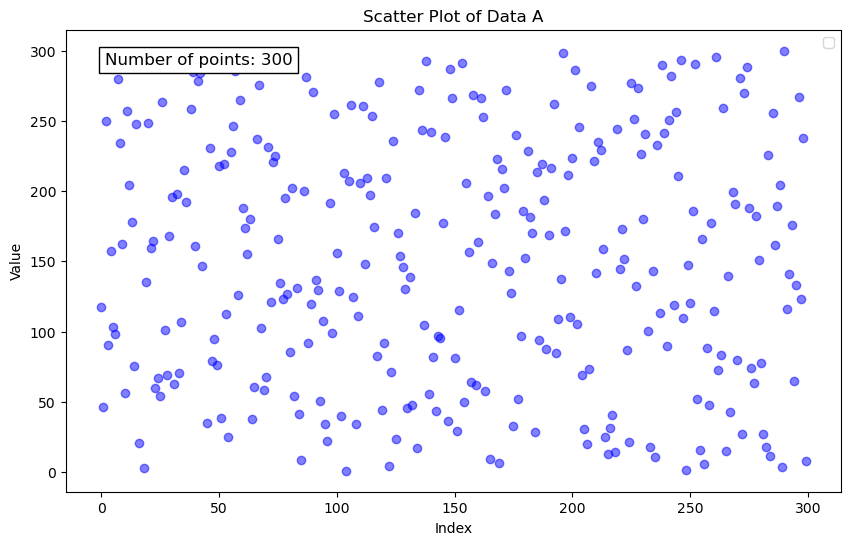

In [8]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


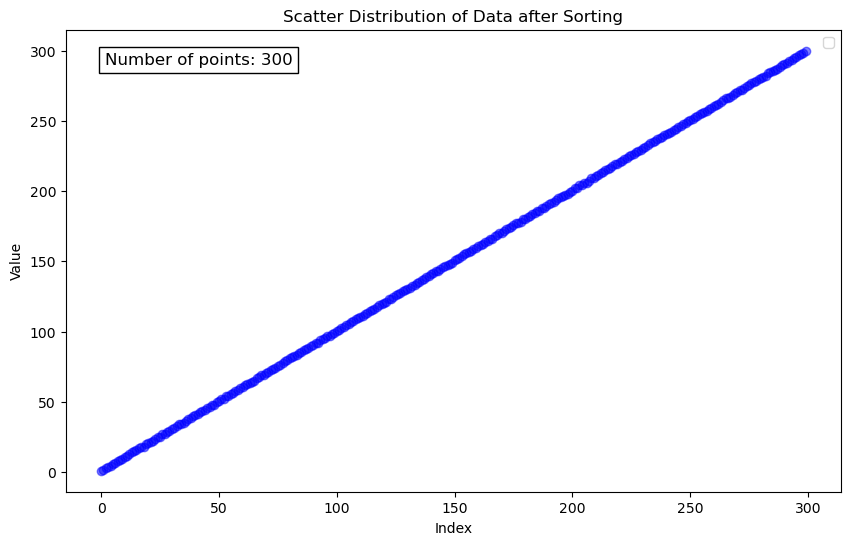

In [9]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0005087824446602335, 0.0005036982323358009, 0.00047354163175130455, 0.0005109090994232514, 0.0025133012735287143, 0.0005096492208344824, 0.0005118634486876665, 0.000497159143258242, 0.0004636831048352414, 0.0005134697266146318]
Error u of fuhe active learning(LHS sampling): 7.006057e-04
[0.00016391117885265842, 0.00015913014953485472, 0.0001504946842919792, 0.00016413140740300307, 0.0007205999421506946, 0.0001641900967700232, 0.00016433861471347442, 0.00015656757147057942, 0.00014376447100805214, 0.0001649261415975202]
MAE of fuhe active learning(LHS sampling): 2.152054e-04
[5.4259837510531125e-08, 5.27324456669641e-08, 4.691583610257447e-08, 5.472507932524963e-08, 1.2905490326369088e-06, 5.4365116545731755e-08, 5.487377146231632e-08, 5.138499301105192e-08, 4.467702128486003e-08, 5.516772867976668e-08]
MSE of fuhe active learning(LHS sampling): 1.759651e-07
[0.00013387579, 0.0012302267, 8.3610794e-05, 3.242038e-05, 0.000160467, 9.607738e-05, 7.729792e-05, 0.0001328497, 0.00016965758

[0.0005087824446602335, 0.0005036982323358009, 0.00047354163175130455, 0.0005109090994232514, 0.0025133012735287143, 0.0005096492208344824, 0.0005118634486876665, 0.000497159143258242, 0.0004636831048352414, 0.0005134697266146318]
mean Error u: 7.006057e-04
Variance Error u: 3.653608e-07


/tmp/ipykernel_293644/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


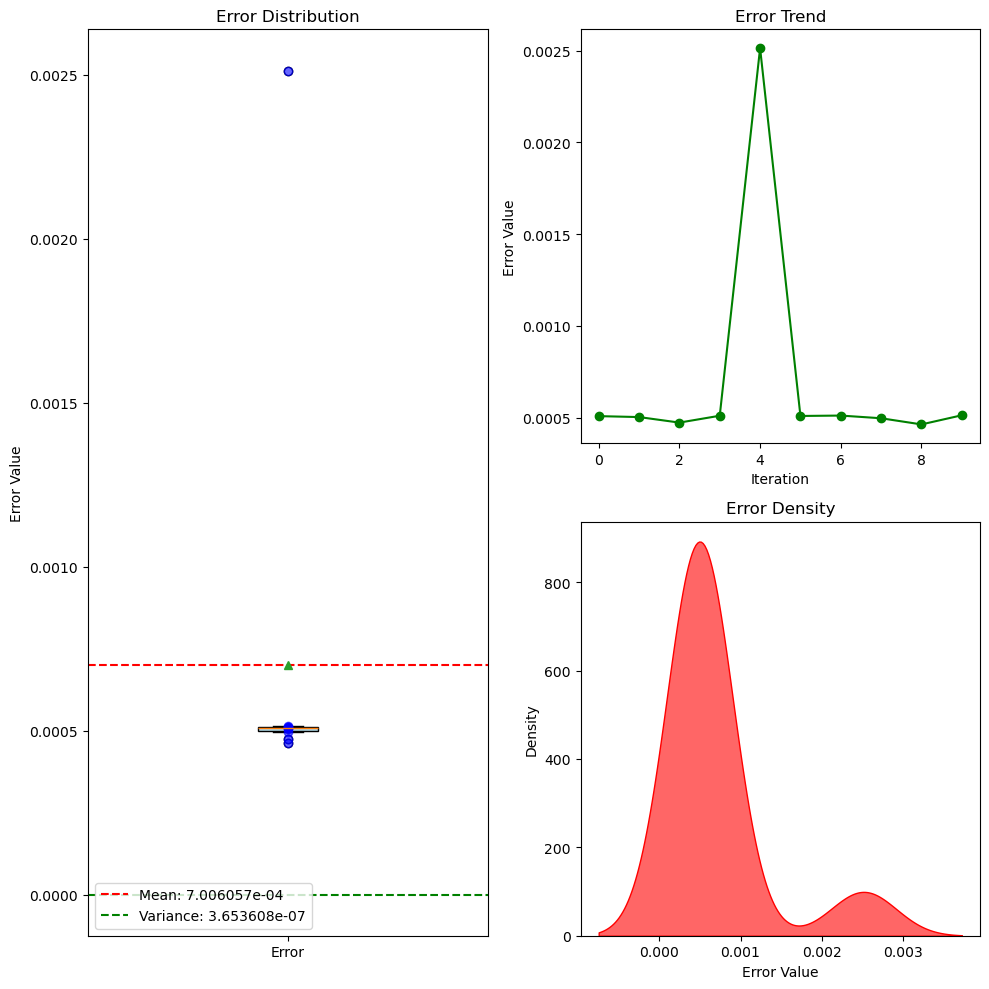

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00016391117885265842, 0.00015913014953485472, 0.0001504946842919792, 0.00016413140740300307, 0.0007205999421506946, 0.0001641900967700232, 0.00016433861471347442, 0.00015656757147057942, 0.00014376447100805214, 0.0001649261415975202]
mean MAE: 2.152054e-04
Variance MAE: 2.842554e-08


/tmp/ipykernel_293644/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


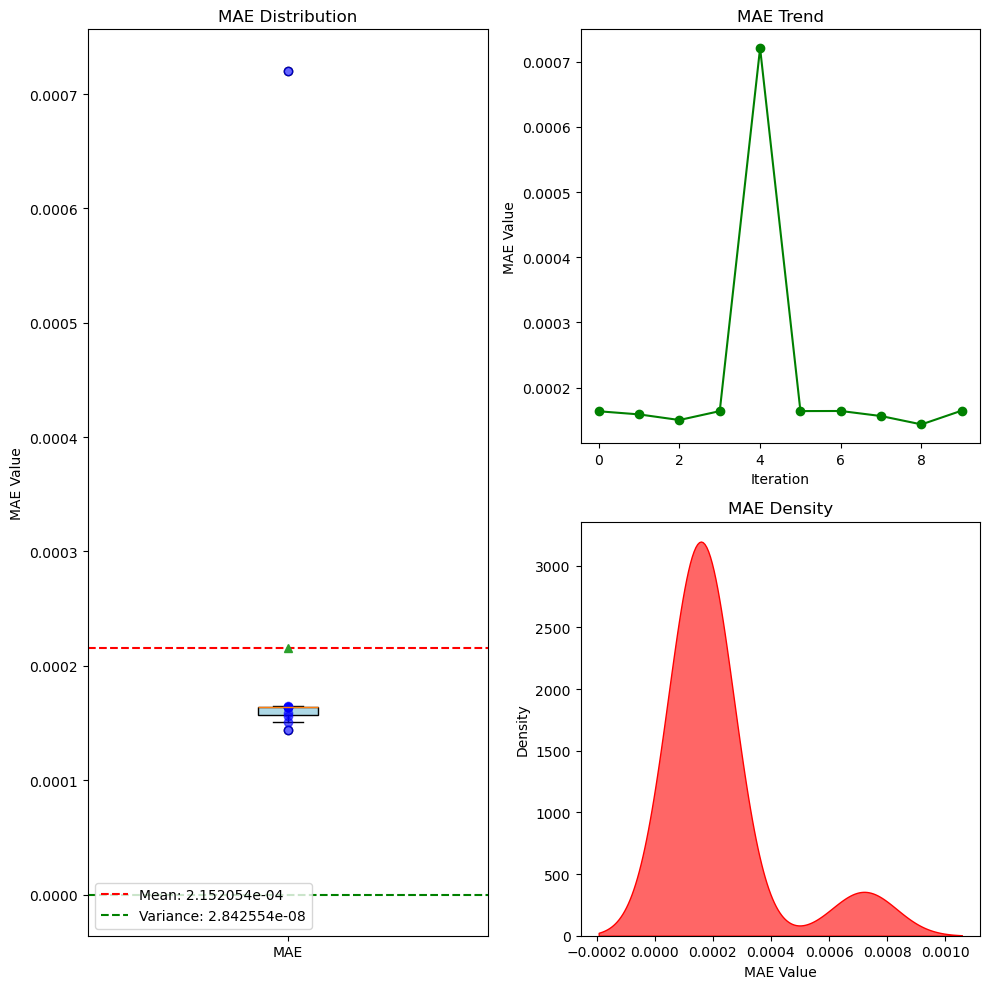

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[5.4259837510531125e-08, 5.27324456669641e-08, 4.691583610257447e-08, 5.472507932524963e-08, 1.2905490326369088e-06, 5.4365116545731755e-08, 5.487377146231632e-08, 5.138499301105192e-08, 4.467702128486003e-08, 5.516772867976668e-08]
mean MSE: 1.759651e-07
Variance MSE: 1.380447e-13


/tmp/ipykernel_293644/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


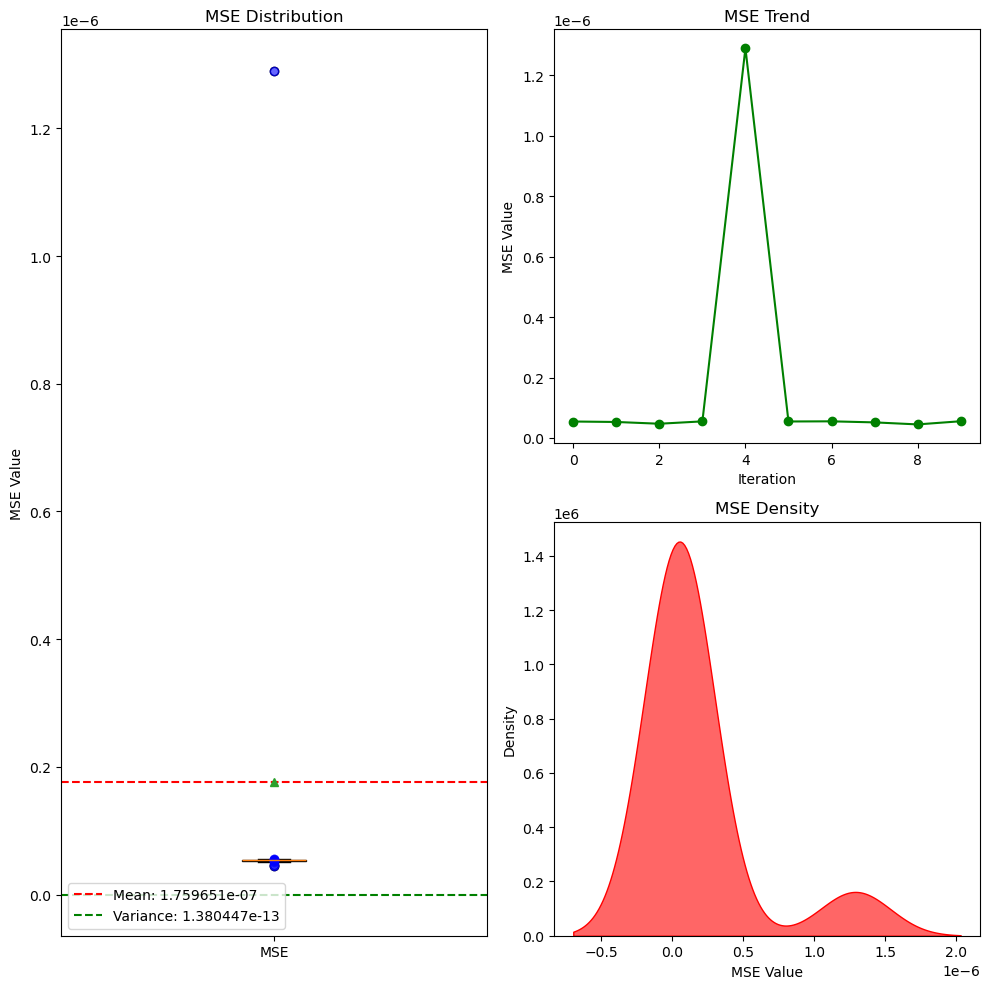

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013387579, 0.0012302267, 8.3610794e-05, 3.242038e-05, 0.000160467, 9.607738e-05, 7.729792e-05, 0.0001328497, 0.00016965758, 0.0025165547]
mean CHAOS: 4.633038e-04
Variance CHAOS: 5.813354e-07


/tmp/ipykernel_293644/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


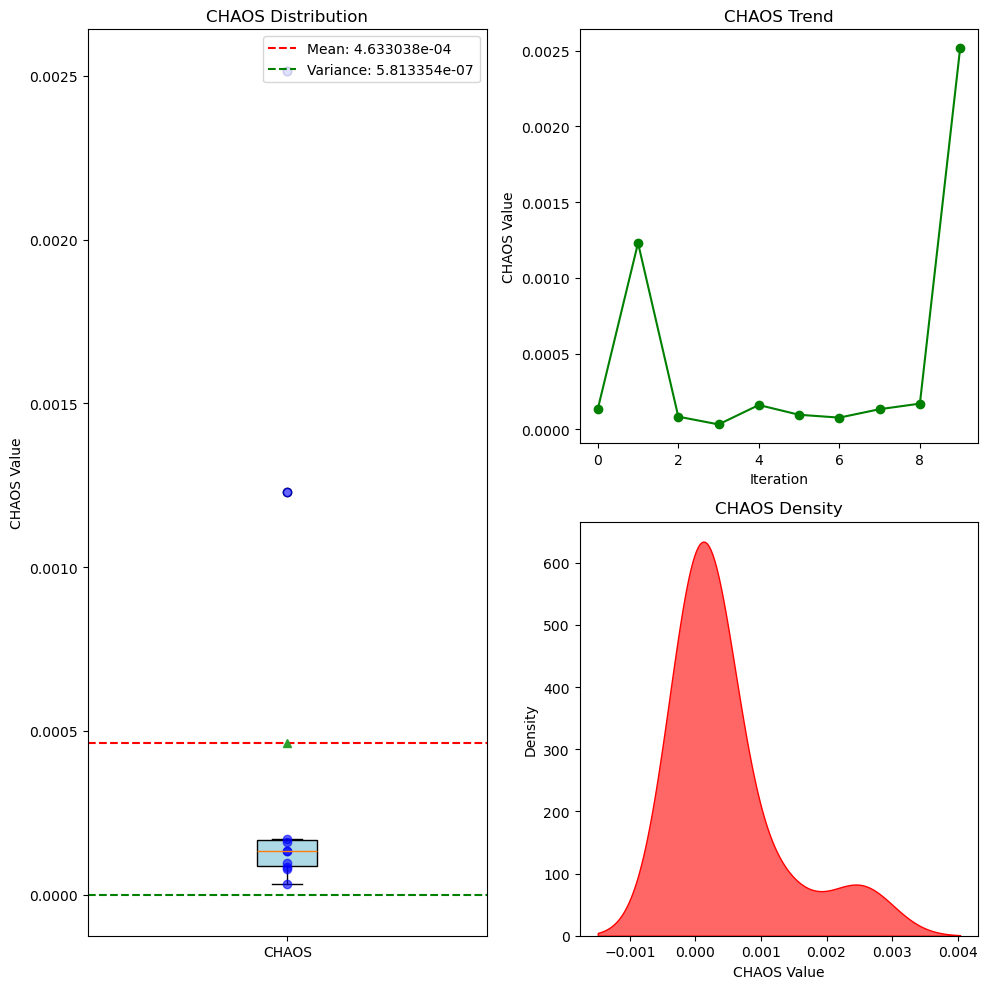

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.2249349e-07, 5.2686187e-07, 5.6343106e-07, 4.638839e-07, 5.0442986e-07, 3.8193525e-07, 5.5111263e-07, 4.5302045e-07, 4.067042e-07, 3.9894917e-07]
mean RESIDUAL: 4.672822e-07
Variance RESIDUAL: 3.904601e-15


/tmp/ipykernel_293644/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


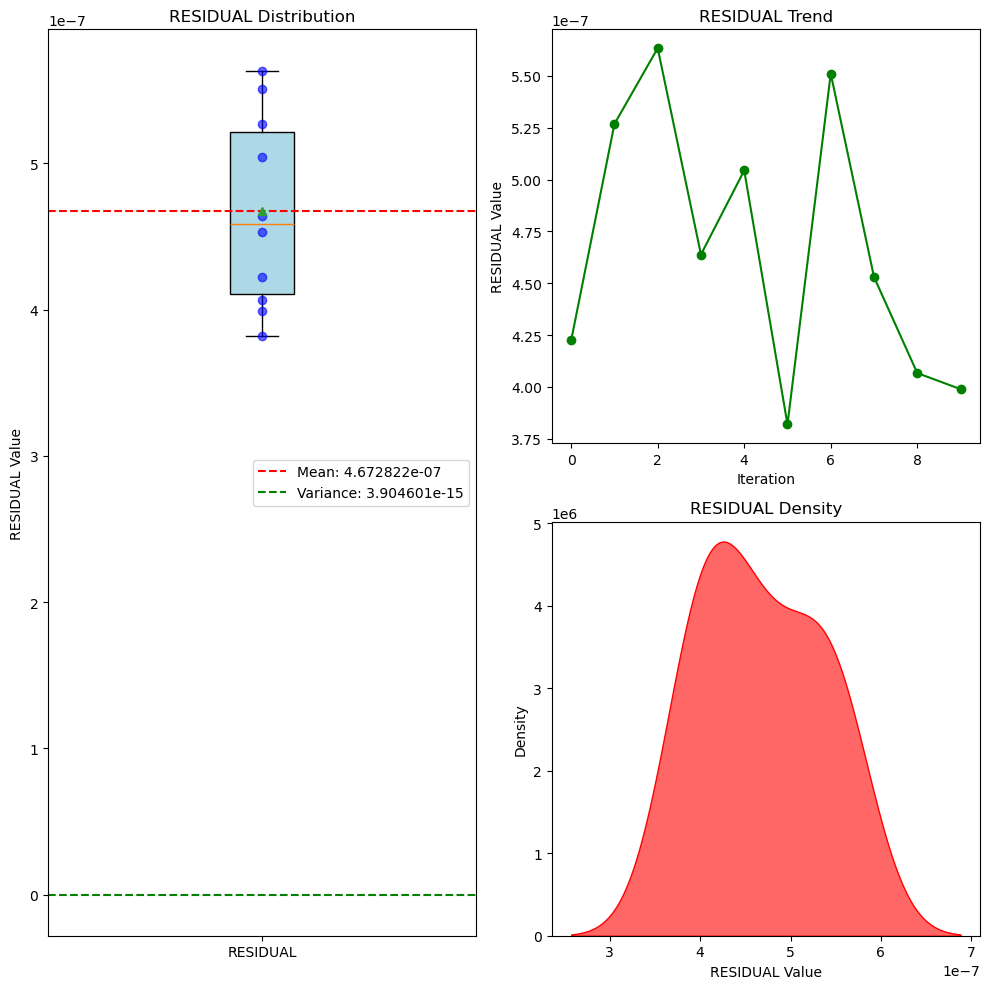

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[1.9726302e-01 1.6816948e-01 1.4087141e-01 ... 4.9257287e-10 4.9257554e-10
 4.9257409e-10]


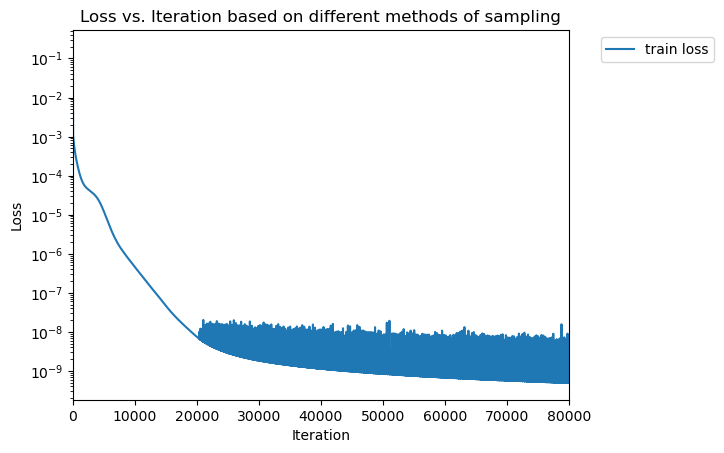

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

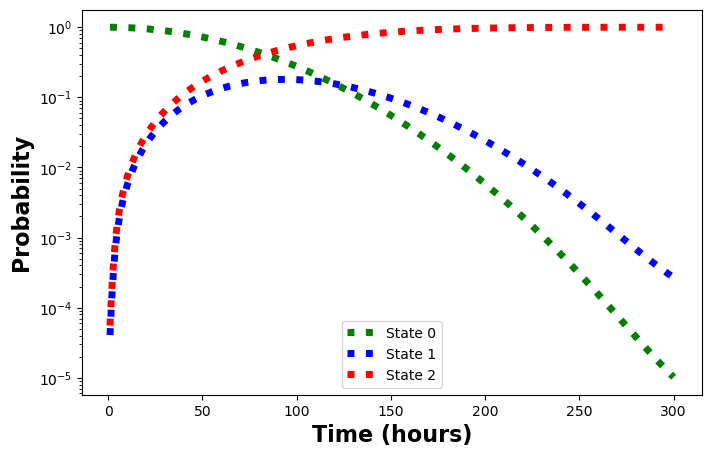

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

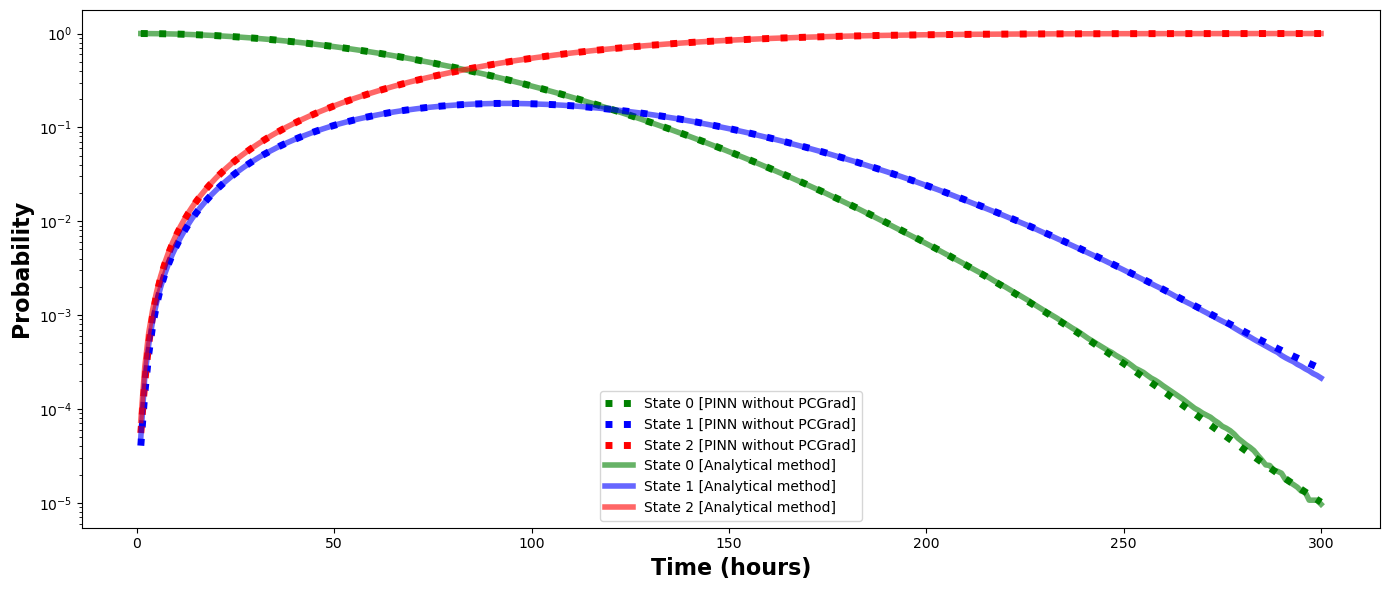

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999904  0.000041  0.000055
1  0.999665  0.000145  0.000191
2  0.999128  0.000380  0.000492
3  0.998243  0.000770  0.000987
4  0.997049  0.001294  0.001658
      state_0   state_1   state_2
295  0.000013  0.000319  0.999668
296  0.000012  0.000306  0.999682
297  0.000012  0.000293  0.999696
298  0.000011  0.000280  0.999709
299  0.000010  0.000269  0.999721


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.00031229860687435884
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.00031229860687435884
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.2419435  0.24696015 0.25347117 0.2609716  0.26953298 0.27946895
 0.29107854 0.30450663 0.3195414  0.33555004 0.35160786 0.36671853
 0.38011158 0.39125678 0.39999864 0.40634462 0.4104663  0.4126034
 0.41304475 0.41204122 0.40988064 0.40677077 0.40296337 0.39864063
 0.3939868  0.38914734 0.38426414 0.3794453  0.37476492 0.3703005
 0.3661344  0.36227766 0.35878453 0.35567185 0.35293987 0.35062802
 0.34869853 0.34717813 0.34605342 0.34526813 0.3448385  0.34472457
 0.34490773 0.34533828 0.345996   0.34683213 0.34782183 0.34891278
 0.35007396 0.3512821  0.35248992 0.35366246 0.35480037 0.35585237
 0.35682622 0.35767663 0.3584114  0.35903278 0.3594965  0.3598214
 0.35999984 0.36004713 0.35994646 0.3597032  0.3593478  0.3588549
 0.35824117 0.35752168 0.35669747 0.35578156 0.35477078 0.3536948
 0.3525449  0.35133603 0.3500767  0.34878245 0.34745905 0.3461076
 0.34474283 0.34335423 0.34199345 0.3406113  0.3392629  0.33792236
 0.3366134  0.33532983 0.33408764 0.33287367 0.3317033  0.33058816
 

Text(0.5, 1.0, 'Line Plot')

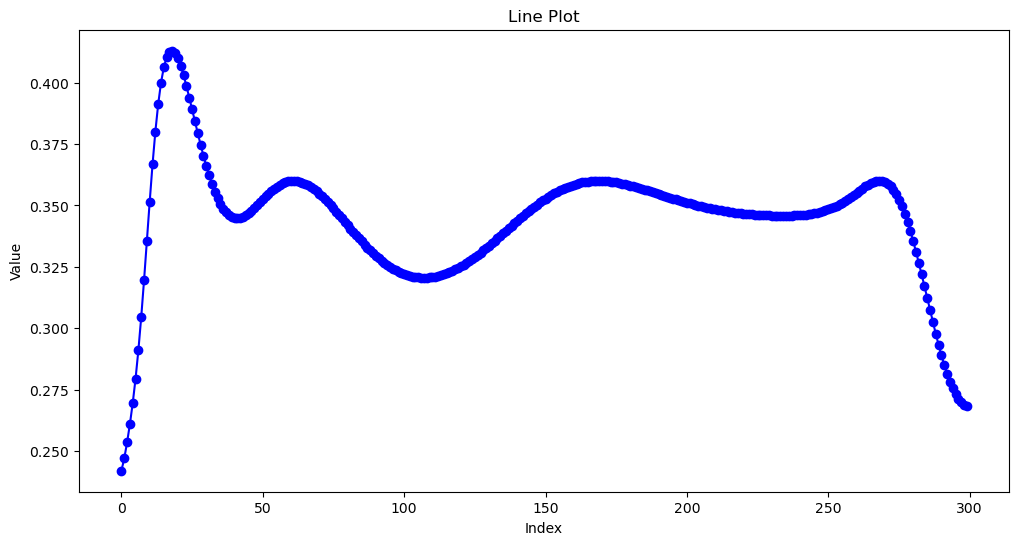

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-3.6496203e-08 -1.4755642e-08 -6.9558155e-09 -2.1973392e-08
  7.2177500e-09  1.8626451e-09  2.2118911e-09  1.5716068e-09
  3.9581209e-09  2.3283064e-10  4.6566129e-10 -1.2805685e-09
  8.1490725e-10 -9.3132257e-10 -1.9790605e-09 -8.1490725e-10
  1.9790605e-09  4.5401976e-09  4.4237822e-09  1.8626451e-09
 -4.6566129e-10 -2.3283064e-10 -6.9849193e-10  2.3283064e-10
  1.6298145e-09  0.0000000e+00  1.3969839e-09  6.9849193e-10
  1.1641532e-09  6.9849193e-10 -9.3132257e-10 -4.6566129e-10
  4.6566129e-10  9.3132257e-10  4.6566129e-10  2.5611371e-09
  6.9849193e-10 -2.0954758e-09  4.6566129e-10  9.3132257e-10
  1.1641532e-09 -4.6566129e-10  9.3132257e-10 -2.3283064e-10
  1.1641532e-09 -9.3132257e-10 -1.3969839e-09 -1.6298145e-09
  4.6566129e-10 -1.1641532e-09 -1.1641532e-09 -6.9849193e-10
  1.6298145e-09  1.3969839e-09  1.3969839e-09 -4.6566129e-10
  1.8626451e-09 -4.6566129e-10  2.3283064e-10 -4.6566129e-10
  4.6566129e-10  9.3132257e-10  1.1641532e-09  6.9849193e-10
 -2.3283064e-10 -9.31322

Text(0.5, 1.0, 'Line Plot')

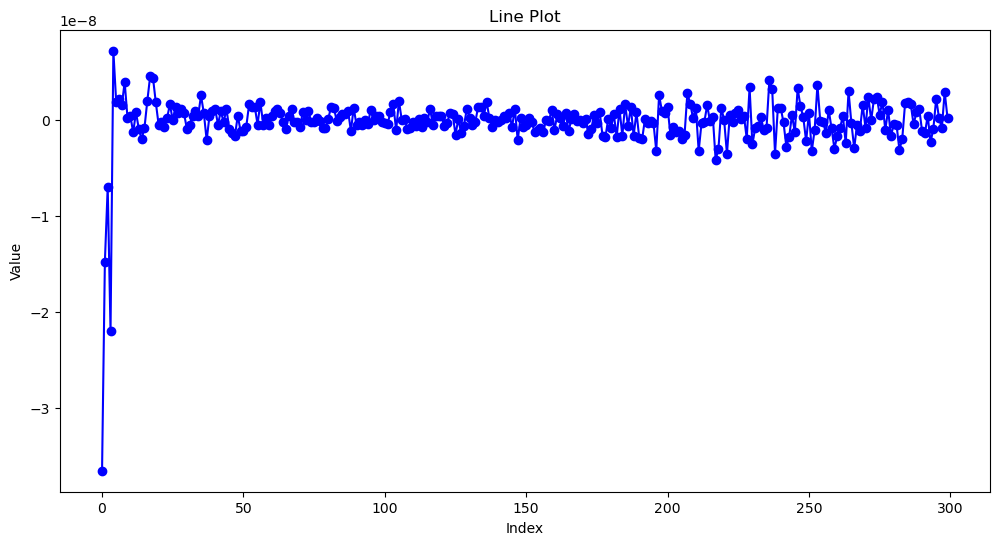

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')
